In [2]:
import math
import os
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")


D0525 23:26:06.290354424      13 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0525 23:26:06.290396797      13 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0525 23:26:06.290400746      13 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0525 23:26:06.290403419      13 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0525 23:26:06.290405986      13 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0525 23:26:06.290408633      13 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0525 23:26:06.290411337      13 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0525 23:26:06.

## TPU or GPU detection


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(
        tpu="local")
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU")
except tf.errors.NotFoundError:
    print("Not running on TPU")
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS:", strategy.num_replicas_in_sync)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Running on TPU
REPLICAS: 8


## Configuration


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

NUM_CLASS = 3
CLASSES = ['COVID-19', 'Non-COVID', 'Normal']

IMAGE_SIZE = [224, 224]
LR = 1e-5
EPOCHS = 100
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

TRAIN_PATH = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train/'
TEST_PATH = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test'
VAL_PATH = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data/Val'


## Utilities


In [5]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    return numpy_images, np.argmax(numpy_labels, axis=1)


def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct


def display_one(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2),
                  color='red' if red else 'black', fontdict={'verticalalignment': 'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)

    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot = (rows, cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE, FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols, FIGSIZE))

    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows, cols)*40+3
        # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one(image, title, subplot,
                              not correct, titlesize=dynamic_titlesize)

    # layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


In [6]:
def display_history(history):
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    ax[0].plot(history.history['loss'], color='b', label="training_loss")
    ax[0].plot(history.history['val_loss'], color='r',
               label="validation_loss", axes=ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['accuracy'],
               color='b', label="training_accuracy")
    ax[1].plot(history.history['val_accuracy'],
               color='r', label="validation_accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()


def display_confusion_matrix(
        cm, classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


## Dataset


In [7]:
def create_dataframe(data_dir):
    filenames, labels = [], []
    for fold in os.listdir(data_dir):
        path = os.path.join(data_dir, fold, 'images')
        filelist = [os.path.join(path, filename)
                    for filename in os.listdir(path)]
        filenames.extend(filelist)
        labels.extend([fold] * len(filelist))
    return pd.DataFrame({
        'filename': filenames,
        'label': labels
    })


train_df = create_dataframe(TRAIN_PATH)
val_df = create_dataframe(VAL_PATH)
test_df = create_dataframe(TEST_PATH)


In [8]:
NUM_TRAINING_IMAGES = len(train_df.index)
NUM_VALIDATION_IMAGES = len(val_df)
NUM_TEST_IMAGES = len(test_df)

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(- NUM_VALIDATION_IMAGES // BATCH_SIZE)
TEST_STEPS = -(-NUM_TEST_IMAGES // BATCH_SIZE)

print("Training images:", NUM_TRAINING_IMAGES)
train_label_counts = train_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in train_label_counts.items()]))
print()

print("Validation images:", NUM_VALIDATION_IMAGES)
val_label_counts = val_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in val_label_counts.items()]))
print()

print("Test images:", NUM_TEST_IMAGES)
test_label_counts = test_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in test_label_counts.items()]))


Training images: 21715
COVID-19: 7658, Non-COVID: 7208, Normal: 6849

Validation images: 5417
COVID-19: 1903, Non-COVID: 1802, Normal: 1712

Test images: 6788
COVID-19: 2395, Non-COVID: 2253, Normal: 2140


#### Data augmentation


In [9]:
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.8, 1.2)

    return image, label


In [10]:
# data_augment = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
#     tf.keras.layers.experimental.preprocessing.RandomContrast(0.1)
# ])


In [11]:
def get_label(label):
    onehot = label == CLASSES
    return tf.cast(onehot, tf.int32)


def decode_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image


def preprocess_path(path, label):
    return decode_image(path), get_label(label)


In [12]:
def load_dataset(df=pd.DataFrame(), ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.Dataset.from_tensor_slices(
        (df['filename'].values, df['label'].values))
    # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(preprocess_path, num_parallel_calls=AUTOTUNE)
    return dataset


In [13]:
def get_train_dataset(augment=False):
    dataset = load_dataset(train_df)
    if(augment):
        dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(BATCH_SIZE * 100)
    dataset = dataset.batch(BATCH_SIZE)
#     if (augment):
#         dataset = dataset.map(lambda x, y: (data_augment(x), y))
#     dataset = dataset.prefetch(AUTOTUNE)

    return dataset


In [14]:
def get_validation_dataset(ordered=False):
    dataset = load_dataset(val_df, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


In [15]:
def get_test_dataset(ordered=False):
    dataset = load_dataset(test_df, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


## Dataset visualizations


In [16]:
training_dataset = get_train_dataset()
training_dataset = training_dataset.unbatch().batch(16)
train_batch = iter(training_dataset)


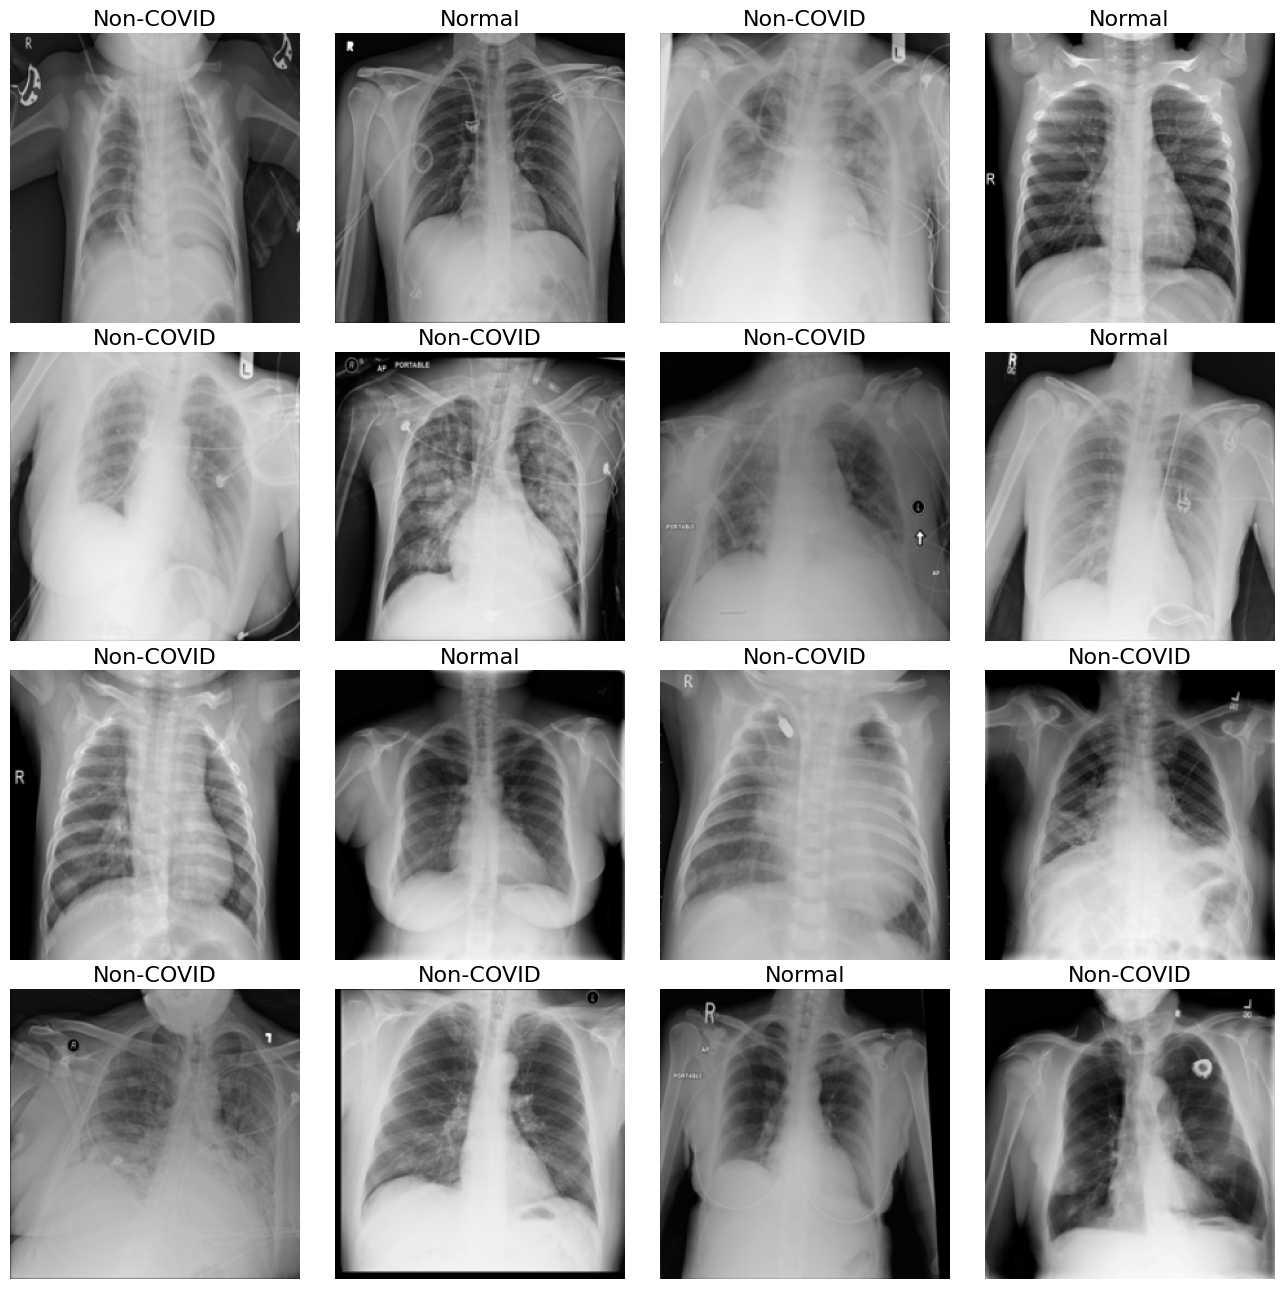

In [17]:
# run this cell again for another randomized set of training images
display_batch(next(train_batch))


In [18]:
print("Training data shapes:")
for image, label in get_train_dataset().take(1):
    print(image.numpy().shape, label.numpy().shape)

print("Validation data shapes:")
for image, label in get_train_dataset().take(1):
    print(image.numpy().shape, label.numpy().shape)

print("Test data shapes:")
for image, label in get_test_dataset().take(1):
    print(image.numpy().shape, label.numpy().shape)


Training data shapes:


(128, 224, 224, 3) (128, 3)


Validation data shapes:


(128, 224, 224, 3) (128, 3)
Test data shapes:


(128, 224, 224, 3) (128, 3)


## Model


In [19]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_resnet50.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-7,
)


In [20]:
with strategy.scope():
    baseModel = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
    )
    
    model = tf.keras.Sequential([
        baseModel,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(NUM_CLASS, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )



    8192/94765736 [..............................] - ETA: 0s


 5644288/94765736 [>.............................] - ETA: 0s


14475264/94765736 [===>..........................] - ETA: 0s


22675456/94765736 [======>.......................] - ETA: 0s


30875648/94765736 [========>.....................] - ETA: 0s


39239680/94765736 [===========>..................] - ETA: 0s


47144960/94765736 [=============>................] - ETA: 0s


55173120/94765736 [================>.............] - ETA: 0s


63234048/94765736 [===================>..........] - ETA: 0s


72335360/94765736 [=====================>........] - ETA: 0s


81248256/94765736 [========================>.....] - ETA: 0s


90210304/94765736 [===========================>..] - ETA: 0s


94765736/94765736 [==============================] - 1s 0us/step


In [21]:
model.summary()


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  


 global_average_pooling2d (G  (None, 2048)             0         


 lobalAveragePooling2D)                                          


 batch_normalization (BatchN  (None, 2048)             8192      


 ormalization)                                                   


 dropout (Dropout)           (None, 2048)              0         


 dense (Dense)               (None, 3)                 6147      


Total params: 23,602,051


Trainable params: 23,544,835


Non-trainable params: 57,216


_________________________________________________________________


## Training


In [22]:
history = model.fit(
    get_train_dataset(augment=True),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=get_validation_dataset(),
    validation_steps=VALIDATION_STEPS,
    callbacks=[checkpoint, reduce_lr]
)

model.save('resnet50.h5')


Epoch 1/100


2023-05-25 23:27:34.064311: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


2023-05-25 23:27:34.803098: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



  1/169 [..............................] - ETA: 3:13:05 - loss: 1.7505 - accuracy: 0.3828


  2/169 [..............................] - ETA: 25s - loss: 1.7031 - accuracy: 0.3945    


  3/169 [..............................] - ETA: 26s - loss: 1.6329 - accuracy: 0.3854


  4/169 [..............................] - ETA: 26s - loss: 1.6242 - accuracy: 0.3652


  5/169 [..............................] - ETA: 25s - loss: 1.6342 - accuracy: 0.3672


  6/169 [>.............................] - ETA: 25s - loss: 1.6093 - accuracy: 0.3672


  7/169 [>.............................] - ETA: 25s - loss: 1.5862 - accuracy: 0.3772


  8/169 [>.............................] - ETA: 24s - loss: 1.5555 - accuracy: 0.3848


  9/169 [>.............................] - ETA: 23s - loss: 1.5327 - accuracy: 0.3915


 10/169 [>.............................] - ETA: 23s - loss: 1.5081 - accuracy: 0.3992


 11/169 [>.............................] - ETA: 22s - loss: 1.4858 - accuracy: 0.4070


 12/169 [=>............................] - ETA: 22s - loss: 1.4654 - accuracy: 0.4108


 13/169 [=>............................] - ETA: 22s - loss: 1.4395 - accuracy: 0.4195


 14/169 [=>............................] - ETA: 21s - loss: 1.4232 - accuracy: 0.4280


 15/169 [=>............................] - ETA: 21s - loss: 1.4026 - accuracy: 0.4323


 16/169 [=>............................] - ETA: 21s - loss: 1.3798 - accuracy: 0.4443


 17/169 [==>...........................] - ETA: 21s - loss: 1.3626 - accuracy: 0.4508


 18/169 [==>...........................] - ETA: 21s - loss: 1.3501 - accuracy: 0.4531


 19/169 [==>...........................] - ETA: 21s - loss: 1.3328 - accuracy: 0.4572


 20/169 [==>...........................] - ETA: 20s - loss: 1.3140 - accuracy: 0.4656


 21/169 [==>...........................] - ETA: 20s - loss: 1.3022 - accuracy: 0.4725


 22/169 [==>...........................] - ETA: 20s - loss: 1.2871 - accuracy: 0.4776


 23/169 [===>..........................] - ETA: 20s - loss: 1.2825 - accuracy: 0.4806


 24/169 [===>..........................] - ETA: 20s - loss: 1.2647 - accuracy: 0.4889


 25/169 [===>..........................] - ETA: 19s - loss: 1.2485 - accuracy: 0.4934


 26/169 [===>..........................] - ETA: 19s - loss: 1.2426 - accuracy: 0.4967


 27/169 [===>..........................] - ETA: 19s - loss: 1.2299 - accuracy: 0.5032


 28/169 [===>..........................] - ETA: 19s - loss: 1.2344 - accuracy: 0.5020


 29/169 [====>.........................] - ETA: 19s - loss: 1.2280 - accuracy: 0.5057


 30/169 [====>.........................] - ETA: 18s - loss: 1.2261 - accuracy: 0.5068


 31/169 [====>.........................] - ETA: 18s - loss: 1.2199 - accuracy: 0.5103


 32/169 [====>.........................] - ETA: 18s - loss: 1.2260 - accuracy: 0.5098


 33/169 [====>.........................] - ETA: 18s - loss: 1.2162 - accuracy: 0.5137


 34/169 [=====>........................] - ETA: 18s - loss: 1.2109 - accuracy: 0.5172


 35/169 [=====>........................] - ETA: 18s - loss: 1.2031 - accuracy: 0.5203


 36/169 [=====>........................] - ETA: 18s - loss: 1.1977 - accuracy: 0.5228


 37/169 [=====>........................] - ETA: 18s - loss: 1.1872 - accuracy: 0.5266


 38/169 [=====>........................] - ETA: 18s - loss: 1.1803 - accuracy: 0.5304


 39/169 [=====>........................] - ETA: 17s - loss: 1.1739 - accuracy: 0.5339


 40/169 [======>.......................] - ETA: 17s - loss: 1.1673 - accuracy: 0.5365


 41/169 [======>.......................] - ETA: 17s - loss: 1.1655 - accuracy: 0.5375


 42/169 [======>.......................] - ETA: 17s - loss: 1.1614 - accuracy: 0.5392


 43/169 [======>.......................] - ETA: 17s - loss: 1.1583 - accuracy: 0.5400


 44/169 [======>.......................] - ETA: 17s - loss: 1.1527 - accuracy: 0.5430


 45/169 [======>.......................] - ETA: 16s - loss: 1.1446 - accuracy: 0.5462


 46/169 [=======>......................] - ETA: 16s - loss: 1.1471 - accuracy: 0.5467


 47/169 [=======>......................] - ETA: 16s - loss: 1.1449 - accuracy: 0.5464


 48/169 [=======>......................] - ETA: 16s - loss: 1.1416 - accuracy: 0.5477


 49/169 [=======>......................] - ETA: 16s - loss: 1.1383 - accuracy: 0.5496


 50/169 [=======>......................] - ETA: 15s - loss: 1.1329 - accuracy: 0.5519


 51/169 [========>.....................] - ETA: 15s - loss: 1.1299 - accuracy: 0.5527


 52/169 [========>.....................] - ETA: 15s - loss: 1.1245 - accuracy: 0.5545


 53/169 [========>.....................] - ETA: 15s - loss: 1.1182 - accuracy: 0.5572


 54/169 [========>.....................] - ETA: 15s - loss: 1.1160 - accuracy: 0.5590


 55/169 [========>.....................] - ETA: 15s - loss: 1.1101 - accuracy: 0.5612


 56/169 [========>.....................] - ETA: 14s - loss: 1.1061 - accuracy: 0.5629


 57/169 [=========>....................] - ETA: 14s - loss: 1.1031 - accuracy: 0.5635


 58/169 [=========>....................] - ETA: 14s - loss: 1.0976 - accuracy: 0.5653


 59/169 [=========>....................] - ETA: 14s - loss: 1.0961 - accuracy: 0.5670


 60/169 [=========>....................] - ETA: 14s - loss: 1.0920 - accuracy: 0.5685


 61/169 [=========>....................] - ETA: 14s - loss: 1.0862 - accuracy: 0.5706


 62/169 [==========>...................] - ETA: 14s - loss: 1.0837 - accuracy: 0.5717


 63/169 [==========>...................] - ETA: 13s - loss: 1.0796 - accuracy: 0.5737


 64/169 [==========>...................] - ETA: 13s - loss: 1.0736 - accuracy: 0.5758


 65/169 [==========>...................] - ETA: 13s - loss: 1.0698 - accuracy: 0.5775


 66/169 [==========>...................] - ETA: 13s - loss: 1.0661 - accuracy: 0.5784


 67/169 [==========>...................] - ETA: 13s - loss: 1.0654 - accuracy: 0.5786


 68/169 [===========>..................] - ETA: 13s - loss: 1.0608 - accuracy: 0.5801


 69/169 [===========>..................] - ETA: 12s - loss: 1.0568 - accuracy: 0.5815


 70/169 [===========>..................] - ETA: 12s - loss: 1.0524 - accuracy: 0.5831


 71/169 [===========>..................] - ETA: 12s - loss: 1.0511 - accuracy: 0.5840


 72/169 [===========>..................] - ETA: 12s - loss: 1.0478 - accuracy: 0.5849


 73/169 [===========>..................] - ETA: 12s - loss: 1.0440 - accuracy: 0.5858


 74/169 [============>.................] - ETA: 12s - loss: 1.0395 - accuracy: 0.5880


 75/169 [============>.................] - ETA: 12s - loss: 1.0377 - accuracy: 0.5886


 76/169 [============>.................] - ETA: 12s - loss: 1.0336 - accuracy: 0.5898


 77/169 [============>.................] - ETA: 11s - loss: 1.0294 - accuracy: 0.5917


 78/169 [============>.................] - ETA: 11s - loss: 1.0264 - accuracy: 0.5928


 79/169 [=============>................] - ETA: 11s - loss: 1.0235 - accuracy: 0.5942


 80/169 [=============>................] - ETA: 11s - loss: 1.0193 - accuracy: 0.5960


 81/169 [=============>................] - ETA: 11s - loss: 1.0147 - accuracy: 0.5979


 82/169 [=============>................] - ETA: 11s - loss: 1.0115 - accuracy: 0.5988


 83/169 [=============>................] - ETA: 11s - loss: 1.0071 - accuracy: 0.6002


 84/169 [=============>................] - ETA: 10s - loss: 1.0032 - accuracy: 0.6022


 85/169 [==============>...............] - ETA: 10s - loss: 1.0005 - accuracy: 0.6028


 86/169 [==============>...............] - ETA: 10s - loss: 0.9987 - accuracy: 0.6037


 87/169 [==============>...............] - ETA: 10s - loss: 0.9946 - accuracy: 0.6053


 88/169 [==============>...............] - ETA: 10s - loss: 0.9911 - accuracy: 0.6068


 89/169 [==============>...............] - ETA: 10s - loss: 0.9873 - accuracy: 0.6081


 90/169 [==============>...............] - ETA: 10s - loss: 0.9839 - accuracy: 0.6088


 91/169 [===============>..............] - ETA: 9s - loss: 0.9819 - accuracy: 0.6102 


 92/169 [===============>..............] - ETA: 9s - loss: 0.9797 - accuracy: 0.6110


 93/169 [===============>..............] - ETA: 9s - loss: 0.9760 - accuracy: 0.6127


 94/169 [===============>..............] - ETA: 9s - loss: 0.9725 - accuracy: 0.6146


 95/169 [===============>..............] - ETA: 9s - loss: 0.9706 - accuracy: 0.6155


 96/169 [================>.............] - ETA: 9s - loss: 0.9691 - accuracy: 0.6165


 97/169 [================>.............] - ETA: 9s - loss: 0.9660 - accuracy: 0.6173


 98/169 [================>.............] - ETA: 8s - loss: 0.9630 - accuracy: 0.6185


 99/169 [================>.............] - ETA: 8s - loss: 0.9591 - accuracy: 0.6199


100/169 [================>.............] - ETA: 8s - loss: 0.9566 - accuracy: 0.6210


101/169 [================>.............] - ETA: 8s - loss: 0.9529 - accuracy: 0.6224


102/169 [=================>............] - ETA: 8s - loss: 0.9504 - accuracy: 0.6235


103/169 [=================>............] - ETA: 8s - loss: 0.9504 - accuracy: 0.6235


104/169 [=================>............] - ETA: 8s - loss: 0.9497 - accuracy: 0.6239


105/169 [=================>............] - ETA: 7s - loss: 0.9492 - accuracy: 0.6244


106/169 [=================>............] - ETA: 7s - loss: 0.9490 - accuracy: 0.6249


107/169 [=================>............] - ETA: 7s - loss: 0.9461 - accuracy: 0.6257


108/169 [==================>...........] - ETA: 7s - loss: 0.9428 - accuracy: 0.6274


109/169 [==================>...........] - ETA: 7s - loss: 0.9420 - accuracy: 0.6276


110/169 [==================>...........] - ETA: 7s - loss: 0.9387 - accuracy: 0.6290


111/169 [==================>...........] - ETA: 7s - loss: 0.9364 - accuracy: 0.6297


112/169 [==================>...........] - ETA: 7s - loss: 0.9344 - accuracy: 0.6309


113/169 [===================>..........] - ETA: 6s - loss: 0.9349 - accuracy: 0.6311


114/169 [===================>..........] - ETA: 6s - loss: 0.9329 - accuracy: 0.6321


115/169 [===================>..........] - ETA: 6s - loss: 0.9308 - accuracy: 0.6329


116/169 [===================>..........] - ETA: 6s - loss: 0.9299 - accuracy: 0.6336


117/169 [===================>..........] - ETA: 6s - loss: 0.9283 - accuracy: 0.6343


118/169 [===================>..........] - ETA: 6s - loss: 0.9261 - accuracy: 0.6353


119/169 [====================>.........] - ETA: 6s - loss: 0.9255 - accuracy: 0.6358


120/169 [====================>.........] - ETA: 6s - loss: 0.9234 - accuracy: 0.6367


121/169 [====================>.........] - ETA: 5s - loss: 0.9221 - accuracy: 0.6373


122/169 [====================>.........] - ETA: 5s - loss: 0.9214 - accuracy: 0.6379


123/169 [====================>.........] - ETA: 5s - loss: 0.9186 - accuracy: 0.6390


124/169 [=====================>........] - ETA: 5s - loss: 0.9170 - accuracy: 0.6398


125/169 [=====================>........] - ETA: 5s - loss: 0.9151 - accuracy: 0.6404


126/169 [=====================>........] - ETA: 5s - loss: 0.9132 - accuracy: 0.6411


127/169 [=====================>........] - ETA: 5s - loss: 0.9122 - accuracy: 0.6419


128/169 [=====================>........] - ETA: 5s - loss: 0.9103 - accuracy: 0.6428


129/169 [=====================>........] - ETA: 4s - loss: 0.9095 - accuracy: 0.6431


130/169 [======================>.......] - ETA: 4s - loss: 0.9071 - accuracy: 0.6439


131/169 [======================>.......] - ETA: 4s - loss: 0.9047 - accuracy: 0.6448


132/169 [======================>.......] - ETA: 4s - loss: 0.9019 - accuracy: 0.6460


133/169 [======================>.......] - ETA: 4s - loss: 0.9000 - accuracy: 0.6466


134/169 [======================>.......] - ETA: 4s - loss: 0.8977 - accuracy: 0.6473


135/169 [======================>.......] - ETA: 4s - loss: 0.8959 - accuracy: 0.6481


136/169 [=======================>......] - ETA: 4s - loss: 0.8935 - accuracy: 0.6490


137/169 [=======================>......] - ETA: 3s - loss: 0.8915 - accuracy: 0.6498


138/169 [=======================>......] - ETA: 3s - loss: 0.8895 - accuracy: 0.6504


139/169 [=======================>......] - ETA: 3s - loss: 0.8883 - accuracy: 0.6511


140/169 [=======================>......] - ETA: 3s - loss: 0.8870 - accuracy: 0.6518


141/169 [========================>.....] - ETA: 3s - loss: 0.8845 - accuracy: 0.6529


142/169 [========================>.....] - ETA: 3s - loss: 0.8818 - accuracy: 0.6539


143/169 [========================>.....] - ETA: 3s - loss: 0.8794 - accuracy: 0.6549


144/169 [========================>.....] - ETA: 3s - loss: 0.8786 - accuracy: 0.6554


145/169 [========================>.....] - ETA: 2s - loss: 0.8774 - accuracy: 0.6558


146/169 [========================>.....] - ETA: 2s - loss: 0.8755 - accuracy: 0.6566


147/169 [=========================>....] - ETA: 2s - loss: 0.8735 - accuracy: 0.6576


148/169 [=========================>....] - ETA: 2s - loss: 0.8726 - accuracy: 0.6582


149/169 [=========================>....] - ETA: 2s - loss: 0.8720 - accuracy: 0.6586


150/169 [=========================>....] - ETA: 2s - loss: 0.8710 - accuracy: 0.6591


151/169 [=========================>....] - ETA: 2s - loss: 0.8684 - accuracy: 0.6598


152/169 [=========================>....] - ETA: 2s - loss: 0.8677 - accuracy: 0.6602


153/169 [==========================>...] - ETA: 1s - loss: 0.8676 - accuracy: 0.6604


154/169 [==========================>...] - ETA: 1s - loss: 0.8661 - accuracy: 0.6608


155/169 [==========================>...] - ETA: 1s - loss: 0.8654 - accuracy: 0.6611


156/169 [==========================>...] - ETA: 1s - loss: 0.8628 - accuracy: 0.6620


157/169 [==========================>...] - ETA: 1s - loss: 0.8618 - accuracy: 0.6626


158/169 [===========================>..] - ETA: 1s - loss: 0.8605 - accuracy: 0.6632


159/169 [===========================>..] - ETA: 1s - loss: 0.8592 - accuracy: 0.6634


160/169 [===========================>..] - ETA: 1s - loss: 0.8581 - accuracy: 0.6640


161/169 [===========================>..] - ETA: 0s - loss: 0.8582 - accuracy: 0.6644


162/169 [===========================>..] - ETA: 0s - loss: 0.8566 - accuracy: 0.6652


163/169 [===========================>..] - ETA: 0s - loss: 0.8561 - accuracy: 0.6654


164/169 [============================>.] - ETA: 0s - loss: 0.8553 - accuracy: 0.6656


165/169 [============================>.] - ETA: 0s - loss: 0.8540 - accuracy: 0.6661


166/169 [============================>.] - ETA: 0s - loss: 0.8523 - accuracy: 0.6667


167/169 [============================>.] - ETA: 0s - loss: 0.8521 - accuracy: 0.6671


168/169 [============================>.] - ETA: 0s - loss: 0.8504 - accuracy: 0.6676


169/169 [==============================] - ETA: 0s - loss: 0.8490 - accuracy: 0.6680

2023-05-25 23:28:38.803551: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


2023-05-25 23:28:39.054717: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



Epoch 1: val_loss improved from inf to 2.63733, saving model to best_resnet50.h5



169/169 [==============================] - 110s 242ms/step - loss: 0.8490 - accuracy: 0.6680 - val_loss: 2.6373 - val_accuracy: 0.3327 - lr: 1.0000e-05


Epoch 2/100



  1/169 [..............................] - ETA: 14s - loss: 0.5680 - accuracy: 0.7812


  2/169 [..............................] - ETA: 17s - loss: 0.6643 - accuracy: 0.7305


  3/169 [..............................] - ETA: 20s - loss: 0.6746 - accuracy: 0.7344


  4/169 [..............................] - ETA: 18s - loss: 0.7203 - accuracy: 0.7246


  5/169 [..............................] - ETA: 17s - loss: 0.6864 - accuracy: 0.7438


  6/169 [>.............................] - ETA: 16s - loss: 0.6744 - accuracy: 0.7565


  7/169 [>.............................] - ETA: 16s - loss: 0.6883 - accuracy: 0.7489


  8/169 [>.............................] - ETA: 16s - loss: 0.6862 - accuracy: 0.7480


  9/169 [>.............................] - ETA: 16s - loss: 0.6635 - accuracy: 0.7578


 10/169 [>.............................] - ETA: 16s - loss: 0.6755 - accuracy: 0.7570


 11/169 [>.............................] - ETA: 16s - loss: 0.6874 - accuracy: 0.7486


 12/169 [=>............................] - ETA: 16s - loss: 0.6987 - accuracy: 0.7448


 13/169 [=>............................] - ETA: 16s - loss: 0.6969 - accuracy: 0.7494


 14/169 [=>............................] - ETA: 16s - loss: 0.6994 - accuracy: 0.7444


 15/169 [=>............................] - ETA: 16s - loss: 0.7065 - accuracy: 0.7432


 16/169 [=>............................] - ETA: 16s - loss: 0.7113 - accuracy: 0.7432


 17/169 [==>...........................] - ETA: 16s - loss: 0.7008 - accuracy: 0.7449


 18/169 [==>...........................] - ETA: 17s - loss: 0.6944 - accuracy: 0.7465


 19/169 [==>...........................] - ETA: 17s - loss: 0.6842 - accuracy: 0.7484


 20/169 [==>...........................] - ETA: 17s - loss: 0.6786 - accuracy: 0.7523


 21/169 [==>...........................] - ETA: 17s - loss: 0.6723 - accuracy: 0.7537


 22/169 [==>...........................] - ETA: 17s - loss: 0.6667 - accuracy: 0.7550


 23/169 [===>..........................] - ETA: 17s - loss: 0.6550 - accuracy: 0.7602


 24/169 [===>..........................] - ETA: 17s - loss: 0.6555 - accuracy: 0.7598


 25/169 [===>..........................] - ETA: 17s - loss: 0.6514 - accuracy: 0.7612


 26/169 [===>..........................] - ETA: 17s - loss: 0.6507 - accuracy: 0.7596


 27/169 [===>..........................] - ETA: 17s - loss: 0.6508 - accuracy: 0.7593


 28/169 [===>..........................] - ETA: 17s - loss: 0.6582 - accuracy: 0.7559


 29/169 [====>.........................] - ETA: 17s - loss: 0.6537 - accuracy: 0.7565


 30/169 [====>.........................] - ETA: 17s - loss: 0.6461 - accuracy: 0.7599


 31/169 [====>.........................] - ETA: 16s - loss: 0.6484 - accuracy: 0.7576


 32/169 [====>.........................] - ETA: 16s - loss: 0.6453 - accuracy: 0.7581


 33/169 [====>.........................] - ETA: 16s - loss: 0.6461 - accuracy: 0.7585


 34/169 [=====>........................] - ETA: 16s - loss: 0.6430 - accuracy: 0.7601


 35/169 [=====>........................] - ETA: 16s - loss: 0.6371 - accuracy: 0.7629


 36/169 [=====>........................] - ETA: 16s - loss: 0.6339 - accuracy: 0.7643


 37/169 [=====>........................] - ETA: 16s - loss: 0.6281 - accuracy: 0.7660


 38/169 [=====>........................] - ETA: 16s - loss: 0.6246 - accuracy: 0.7677


 39/169 [=====>........................] - ETA: 15s - loss: 0.6225 - accuracy: 0.7684


 40/169 [======>.......................] - ETA: 15s - loss: 0.6187 - accuracy: 0.7701


 41/169 [======>.......................] - ETA: 15s - loss: 0.6169 - accuracy: 0.7706


 42/169 [======>.......................] - ETA: 15s - loss: 0.6136 - accuracy: 0.7705


 43/169 [======>.......................] - ETA: 15s - loss: 0.6112 - accuracy: 0.7702


 44/169 [======>.......................] - ETA: 15s - loss: 0.6107 - accuracy: 0.7710


 45/169 [======>.......................] - ETA: 15s - loss: 0.6090 - accuracy: 0.7714


 46/169 [=======>......................] - ETA: 15s - loss: 0.6069 - accuracy: 0.7712


 47/169 [=======>......................] - ETA: 14s - loss: 0.6066 - accuracy: 0.7718


 48/169 [=======>......................] - ETA: 14s - loss: 0.6036 - accuracy: 0.7728


 49/169 [=======>......................] - ETA: 14s - loss: 0.6012 - accuracy: 0.7731


 50/169 [=======>......................] - ETA: 14s - loss: 0.6014 - accuracy: 0.7723


 51/169 [========>.....................] - ETA: 14s - loss: 0.6020 - accuracy: 0.7719


 52/169 [========>.....................] - ETA: 14s - loss: 0.6005 - accuracy: 0.7728


 53/169 [========>.....................] - ETA: 14s - loss: 0.6005 - accuracy: 0.7718


 54/169 [========>.....................] - ETA: 13s - loss: 0.5997 - accuracy: 0.7726


 55/169 [========>.....................] - ETA: 13s - loss: 0.5980 - accuracy: 0.7732


 56/169 [========>.....................] - ETA: 13s - loss: 0.5976 - accuracy: 0.7739


 57/169 [=========>....................] - ETA: 13s - loss: 0.6018 - accuracy: 0.7721


 58/169 [=========>....................] - ETA: 13s - loss: 0.5991 - accuracy: 0.7732


 59/169 [=========>....................] - ETA: 13s - loss: 0.5960 - accuracy: 0.7736


 60/169 [=========>....................] - ETA: 13s - loss: 0.5936 - accuracy: 0.7742


 61/169 [=========>....................] - ETA: 13s - loss: 0.5932 - accuracy: 0.7741


 62/169 [==========>...................] - ETA: 12s - loss: 0.5906 - accuracy: 0.7752


 63/169 [==========>...................] - ETA: 12s - loss: 0.5909 - accuracy: 0.7750


 64/169 [==========>...................] - ETA: 12s - loss: 0.5880 - accuracy: 0.7759


 65/169 [==========>...................] - ETA: 12s - loss: 0.5876 - accuracy: 0.7764


 66/169 [==========>...................] - ETA: 12s - loss: 0.5875 - accuracy: 0.7766


 67/169 [==========>...................] - ETA: 12s - loss: 0.5852 - accuracy: 0.7769


 68/169 [===========>..................] - ETA: 12s - loss: 0.5837 - accuracy: 0.7768


 69/169 [===========>..................] - ETA: 12s - loss: 0.5823 - accuracy: 0.7775


 70/169 [===========>..................] - ETA: 11s - loss: 0.5818 - accuracy: 0.7783


 71/169 [===========>..................] - ETA: 11s - loss: 0.5835 - accuracy: 0.7773


 72/169 [===========>..................] - ETA: 11s - loss: 0.5818 - accuracy: 0.7779


 73/169 [===========>..................] - ETA: 11s - loss: 0.5812 - accuracy: 0.7785


 74/169 [============>.................] - ETA: 11s - loss: 0.5805 - accuracy: 0.7789


 75/169 [============>.................] - ETA: 11s - loss: 0.5809 - accuracy: 0.7791


 76/169 [============>.................] - ETA: 11s - loss: 0.5790 - accuracy: 0.7793


 77/169 [============>.................] - ETA: 10s - loss: 0.5782 - accuracy: 0.7792


 78/169 [============>.................] - ETA: 10s - loss: 0.5772 - accuracy: 0.7799


 79/169 [=============>................] - ETA: 10s - loss: 0.5759 - accuracy: 0.7807


 80/169 [=============>................] - ETA: 10s - loss: 0.5743 - accuracy: 0.7812


 81/169 [=============>................] - ETA: 10s - loss: 0.5732 - accuracy: 0.7819


 82/169 [=============>................] - ETA: 10s - loss: 0.5714 - accuracy: 0.7825


 83/169 [=============>................] - ETA: 10s - loss: 0.5702 - accuracy: 0.7825


 84/169 [=============>................] - ETA: 10s - loss: 0.5693 - accuracy: 0.7827


 85/169 [==============>...............] - ETA: 9s - loss: 0.5691 - accuracy: 0.7833 


 86/169 [==============>...............] - ETA: 9s - loss: 0.5678 - accuracy: 0.7842


 87/169 [==============>...............] - ETA: 9s - loss: 0.5675 - accuracy: 0.7841


 88/169 [==============>...............] - ETA: 9s - loss: 0.5661 - accuracy: 0.7846


 89/169 [==============>...............] - ETA: 9s - loss: 0.5653 - accuracy: 0.7846


 90/169 [==============>...............] - ETA: 9s - loss: 0.5654 - accuracy: 0.7845


 91/169 [===============>..............] - ETA: 9s - loss: 0.5653 - accuracy: 0.7849


 92/169 [===============>..............] - ETA: 8s - loss: 0.5644 - accuracy: 0.7852


 93/169 [===============>..............] - ETA: 8s - loss: 0.5630 - accuracy: 0.7860


 94/169 [===============>..............] - ETA: 8s - loss: 0.5637 - accuracy: 0.7857


 95/169 [===============>..............] - ETA: 8s - loss: 0.5624 - accuracy: 0.7859


 96/169 [================>.............] - ETA: 8s - loss: 0.5607 - accuracy: 0.7862


 97/169 [================>.............] - ETA: 8s - loss: 0.5600 - accuracy: 0.7865


 98/169 [================>.............] - ETA: 8s - loss: 0.5592 - accuracy: 0.7869


 99/169 [================>.............] - ETA: 8s - loss: 0.5589 - accuracy: 0.7875


100/169 [================>.............] - ETA: 7s - loss: 0.5593 - accuracy: 0.7869


101/169 [================>.............] - ETA: 7s - loss: 0.5589 - accuracy: 0.7869


102/169 [=================>............] - ETA: 7s - loss: 0.5584 - accuracy: 0.7869


103/169 [=================>............] - ETA: 7s - loss: 0.5570 - accuracy: 0.7873


104/169 [=================>............] - ETA: 7s - loss: 0.5558 - accuracy: 0.7876


105/169 [=================>............] - ETA: 7s - loss: 0.5545 - accuracy: 0.7881


106/169 [=================>............] - ETA: 7s - loss: 0.5539 - accuracy: 0.7885


107/169 [=================>............] - ETA: 7s - loss: 0.5531 - accuracy: 0.7887


108/169 [==================>...........] - ETA: 6s - loss: 0.5535 - accuracy: 0.7888


109/169 [==================>...........] - ETA: 6s - loss: 0.5527 - accuracy: 0.7894


110/169 [==================>...........] - ETA: 6s - loss: 0.5519 - accuracy: 0.7893


111/169 [==================>...........] - ETA: 6s - loss: 0.5520 - accuracy: 0.7891


112/169 [==================>...........] - ETA: 6s - loss: 0.5512 - accuracy: 0.7889


113/169 [===================>..........] - ETA: 6s - loss: 0.5501 - accuracy: 0.7893


114/169 [===================>..........] - ETA: 6s - loss: 0.5495 - accuracy: 0.7896


115/169 [===================>..........] - ETA: 6s - loss: 0.5497 - accuracy: 0.7897


116/169 [===================>..........] - ETA: 6s - loss: 0.5510 - accuracy: 0.7897


117/169 [===================>..........] - ETA: 5s - loss: 0.5505 - accuracy: 0.7901


118/169 [===================>..........] - ETA: 5s - loss: 0.5504 - accuracy: 0.7897


119/169 [====================>.........] - ETA: 5s - loss: 0.5510 - accuracy: 0.7893


120/169 [====================>.........] - ETA: 5s - loss: 0.5518 - accuracy: 0.7892


121/169 [====================>.........] - ETA: 5s - loss: 0.5517 - accuracy: 0.7893


122/169 [====================>.........] - ETA: 5s - loss: 0.5513 - accuracy: 0.7896


123/169 [====================>.........] - ETA: 5s - loss: 0.5516 - accuracy: 0.7894


124/169 [=====================>........] - ETA: 5s - loss: 0.5508 - accuracy: 0.7897


125/169 [=====================>........] - ETA: 4s - loss: 0.5500 - accuracy: 0.7899


126/169 [=====================>........] - ETA: 4s - loss: 0.5495 - accuracy: 0.7902


127/169 [=====================>........] - ETA: 4s - loss: 0.5491 - accuracy: 0.7904


128/169 [=====================>........] - ETA: 4s - loss: 0.5489 - accuracy: 0.7903


129/169 [=====================>........] - ETA: 4s - loss: 0.5480 - accuracy: 0.7906


130/169 [======================>.......] - ETA: 4s - loss: 0.5474 - accuracy: 0.7905


131/169 [======================>.......] - ETA: 4s - loss: 0.5467 - accuracy: 0.7910


132/169 [======================>.......] - ETA: 4s - loss: 0.5468 - accuracy: 0.7910


133/169 [======================>.......] - ETA: 4s - loss: 0.5458 - accuracy: 0.7913


134/169 [======================>.......] - ETA: 3s - loss: 0.5445 - accuracy: 0.7920


135/169 [======================>.......] - ETA: 3s - loss: 0.5441 - accuracy: 0.7920


136/169 [=======================>......] - ETA: 3s - loss: 0.5431 - accuracy: 0.7923


137/169 [=======================>......] - ETA: 3s - loss: 0.5428 - accuracy: 0.7926


138/169 [=======================>......] - ETA: 3s - loss: 0.5423 - accuracy: 0.7927


139/169 [=======================>......] - ETA: 3s - loss: 0.5413 - accuracy: 0.7928


140/169 [=======================>......] - ETA: 3s - loss: 0.5418 - accuracy: 0.7926


141/169 [========================>.....] - ETA: 3s - loss: 0.5413 - accuracy: 0.7927


142/169 [========================>.....] - ETA: 2s - loss: 0.5423 - accuracy: 0.7925


143/169 [========================>.....] - ETA: 2s - loss: 0.5428 - accuracy: 0.7924


144/169 [========================>.....] - ETA: 2s - loss: 0.5434 - accuracy: 0.7922


145/169 [========================>.....] - ETA: 2s - loss: 0.5429 - accuracy: 0.7923


146/169 [========================>.....] - ETA: 2s - loss: 0.5432 - accuracy: 0.7925


147/169 [=========================>....] - ETA: 2s - loss: 0.5431 - accuracy: 0.7925


148/169 [=========================>....] - ETA: 2s - loss: 0.5437 - accuracy: 0.7924


149/169 [=========================>....] - ETA: 2s - loss: 0.5432 - accuracy: 0.7926


150/169 [=========================>....] - ETA: 2s - loss: 0.5430 - accuracy: 0.7927


151/169 [=========================>....] - ETA: 1s - loss: 0.5425 - accuracy: 0.7930


152/169 [=========================>....] - ETA: 1s - loss: 0.5425 - accuracy: 0.7928


153/169 [==========================>...] - ETA: 1s - loss: 0.5428 - accuracy: 0.7926


154/169 [==========================>...] - ETA: 1s - loss: 0.5427 - accuracy: 0.7928


155/169 [==========================>...] - ETA: 1s - loss: 0.5425 - accuracy: 0.7928


156/169 [==========================>...] - ETA: 1s - loss: 0.5426 - accuracy: 0.7929


157/169 [==========================>...] - ETA: 1s - loss: 0.5433 - accuracy: 0.7926


158/169 [===========================>..] - ETA: 1s - loss: 0.5422 - accuracy: 0.7931


159/169 [===========================>..] - ETA: 1s - loss: 0.5423 - accuracy: 0.7930


160/169 [===========================>..] - ETA: 0s - loss: 0.5424 - accuracy: 0.7929


161/169 [===========================>..] - ETA: 0s - loss: 0.5436 - accuracy: 0.7924


162/169 [===========================>..] - ETA: 0s - loss: 0.5438 - accuracy: 0.7924


163/169 [===========================>..] - ETA: 0s - loss: 0.5436 - accuracy: 0.7925


164/169 [============================>.] - ETA: 0s - loss: 0.5430 - accuracy: 0.7925


165/169 [============================>.] - ETA: 0s - loss: 0.5424 - accuracy: 0.7927


166/169 [============================>.] - ETA: 0s - loss: 0.5428 - accuracy: 0.7922


167/169 [============================>.] - ETA: 0s - loss: 0.5420 - accuracy: 0.7926


168/169 [============================>.] - ETA: 0s - loss: 0.5420 - accuracy: 0.7927


169/169 [==============================] - ETA: 0s - loss: 0.5412 - accuracy: 0.7930


Epoch 2: val_loss improved from 2.63733 to 1.84775, saving model to best_resnet50.h5



169/169 [==============================] - 23s 138ms/step - loss: 0.5412 - accuracy: 0.7930 - val_loss: 1.8477 - val_accuracy: 0.3982 - lr: 1.0000e-05


Epoch 3/100



  1/169 [..............................] - ETA: 14s - loss: 0.5510 - accuracy: 0.7812


  2/169 [..............................] - ETA: 14s - loss: 0.5795 - accuracy: 0.7617


  3/169 [..............................] - ETA: 14s - loss: 0.5519 - accuracy: 0.7760


  4/169 [..............................] - ETA: 15s - loss: 0.5389 - accuracy: 0.7812


  5/169 [..............................] - ETA: 15s - loss: 0.5415 - accuracy: 0.7844


  6/169 [>.............................] - ETA: 14s - loss: 0.5141 - accuracy: 0.7943


  7/169 [>.............................] - ETA: 14s - loss: 0.5290 - accuracy: 0.7935


  8/169 [>.............................] - ETA: 14s - loss: 0.5454 - accuracy: 0.7910


  9/169 [>.............................] - ETA: 14s - loss: 0.5591 - accuracy: 0.7847


 10/169 [>.............................] - ETA: 14s - loss: 0.5557 - accuracy: 0.7844


 11/169 [>.............................] - ETA: 14s - loss: 0.5528 - accuracy: 0.7891


 12/169 [=>............................] - ETA: 14s - loss: 0.5659 - accuracy: 0.7878


 13/169 [=>............................] - ETA: 14s - loss: 0.5631 - accuracy: 0.7879


 14/169 [=>............................] - ETA: 15s - loss: 0.5586 - accuracy: 0.7919


 15/169 [=>............................] - ETA: 15s - loss: 0.5558 - accuracy: 0.7911


 16/169 [=>............................] - ETA: 14s - loss: 0.5497 - accuracy: 0.7925


 17/169 [==>...........................] - ETA: 14s - loss: 0.5439 - accuracy: 0.7960


 18/169 [==>...........................] - ETA: 14s - loss: 0.5504 - accuracy: 0.7943


 19/169 [==>...........................] - ETA: 14s - loss: 0.5591 - accuracy: 0.7907


 20/169 [==>...........................] - ETA: 14s - loss: 0.5529 - accuracy: 0.7926


 21/169 [==>...........................] - ETA: 14s - loss: 0.5510 - accuracy: 0.7932


 22/169 [==>...........................] - ETA: 14s - loss: 0.5447 - accuracy: 0.7962


 23/169 [===>..........................] - ETA: 14s - loss: 0.5449 - accuracy: 0.7959


 24/169 [===>..........................] - ETA: 14s - loss: 0.5412 - accuracy: 0.7952


 25/169 [===>..........................] - ETA: 14s - loss: 0.5323 - accuracy: 0.7991


 26/169 [===>..........................] - ETA: 14s - loss: 0.5271 - accuracy: 0.8011


 27/169 [===>..........................] - ETA: 14s - loss: 0.5212 - accuracy: 0.8032


 28/169 [===>..........................] - ETA: 14s - loss: 0.5187 - accuracy: 0.8044


 29/169 [====>.........................] - ETA: 14s - loss: 0.5211 - accuracy: 0.8047


 30/169 [====>.........................] - ETA: 14s - loss: 0.5174 - accuracy: 0.8049


 31/169 [====>.........................] - ETA: 14s - loss: 0.5185 - accuracy: 0.8047


 32/169 [====>.........................] - ETA: 14s - loss: 0.5196 - accuracy: 0.8040


 33/169 [====>.........................] - ETA: 13s - loss: 0.5155 - accuracy: 0.8049


 34/169 [=====>........................] - ETA: 13s - loss: 0.5136 - accuracy: 0.8051


 35/169 [=====>........................] - ETA: 13s - loss: 0.5141 - accuracy: 0.8049


 36/169 [=====>........................] - ETA: 13s - loss: 0.5161 - accuracy: 0.8043


 37/169 [=====>........................] - ETA: 13s - loss: 0.5121 - accuracy: 0.8051


 38/169 [=====>........................] - ETA: 13s - loss: 0.5142 - accuracy: 0.8053


 39/169 [=====>........................] - ETA: 13s - loss: 0.5110 - accuracy: 0.8067


 40/169 [======>.......................] - ETA: 12s - loss: 0.5107 - accuracy: 0.8064


 41/169 [======>.......................] - ETA: 12s - loss: 0.5085 - accuracy: 0.8068


 42/169 [======>.......................] - ETA: 12s - loss: 0.5067 - accuracy: 0.8078


 43/169 [======>.......................] - ETA: 12s - loss: 0.5049 - accuracy: 0.8081


 44/169 [======>.......................] - ETA: 12s - loss: 0.5012 - accuracy: 0.8089


 45/169 [======>.......................] - ETA: 12s - loss: 0.4970 - accuracy: 0.8102


 46/169 [=======>......................] - ETA: 12s - loss: 0.4972 - accuracy: 0.8096


 47/169 [=======>......................] - ETA: 12s - loss: 0.4930 - accuracy: 0.8112


 48/169 [=======>......................] - ETA: 12s - loss: 0.4904 - accuracy: 0.8122


 49/169 [=======>......................] - ETA: 12s - loss: 0.4913 - accuracy: 0.8119


 50/169 [=======>......................] - ETA: 11s - loss: 0.4890 - accuracy: 0.8123


 51/169 [========>.....................] - ETA: 11s - loss: 0.4865 - accuracy: 0.8131


 52/169 [========>.....................] - ETA: 11s - loss: 0.4855 - accuracy: 0.8134


 53/169 [========>.....................] - ETA: 11s - loss: 0.4829 - accuracy: 0.8152


 54/169 [========>.....................] - ETA: 11s - loss: 0.4808 - accuracy: 0.8155


 55/169 [========>.....................] - ETA: 11s - loss: 0.4799 - accuracy: 0.8148


 56/169 [========>.....................] - ETA: 11s - loss: 0.4775 - accuracy: 0.8157


 57/169 [=========>....................] - ETA: 11s - loss: 0.4756 - accuracy: 0.8162


 58/169 [=========>....................] - ETA: 11s - loss: 0.4742 - accuracy: 0.8168


 59/169 [=========>....................] - ETA: 11s - loss: 0.4723 - accuracy: 0.8174


 60/169 [=========>....................] - ETA: 10s - loss: 0.4706 - accuracy: 0.8181


 61/169 [=========>....................] - ETA: 10s - loss: 0.4690 - accuracy: 0.8185


 62/169 [==========>...................] - ETA: 10s - loss: 0.4672 - accuracy: 0.8194


 63/169 [==========>...................] - ETA: 10s - loss: 0.4647 - accuracy: 0.8206


 64/169 [==========>...................] - ETA: 10s - loss: 0.4634 - accuracy: 0.8203


 65/169 [==========>...................] - ETA: 10s - loss: 0.4647 - accuracy: 0.8198


 66/169 [==========>...................] - ETA: 10s - loss: 0.4660 - accuracy: 0.8201


 67/169 [==========>...................] - ETA: 10s - loss: 0.4652 - accuracy: 0.8203


 68/169 [===========>..................] - ETA: 10s - loss: 0.4632 - accuracy: 0.8215


 69/169 [===========>..................] - ETA: 10s - loss: 0.4643 - accuracy: 0.8214


 70/169 [===========>..................] - ETA: 9s - loss: 0.4622 - accuracy: 0.8228 


 71/169 [===========>..................] - ETA: 9s - loss: 0.4626 - accuracy: 0.8219


 72/169 [===========>..................] - ETA: 9s - loss: 0.4654 - accuracy: 0.8211


 73/169 [===========>..................] - ETA: 9s - loss: 0.4657 - accuracy: 0.8212


 74/169 [============>.................] - ETA: 9s - loss: 0.4642 - accuracy: 0.8217


 75/169 [============>.................] - ETA: 9s - loss: 0.4654 - accuracy: 0.8213


 76/169 [============>.................] - ETA: 9s - loss: 0.4639 - accuracy: 0.8218


 77/169 [============>.................] - ETA: 9s - loss: 0.4620 - accuracy: 0.8223


 78/169 [============>.................] - ETA: 9s - loss: 0.4606 - accuracy: 0.8226


 79/169 [=============>................] - ETA: 8s - loss: 0.4583 - accuracy: 0.8235


 80/169 [=============>................] - ETA: 8s - loss: 0.4571 - accuracy: 0.8239


 81/169 [=============>................] - ETA: 8s - loss: 0.4562 - accuracy: 0.8241


 82/169 [=============>................] - ETA: 8s - loss: 0.4565 - accuracy: 0.8240


 83/169 [=============>................] - ETA: 8s - loss: 0.4547 - accuracy: 0.8248


 84/169 [=============>................] - ETA: 8s - loss: 0.4530 - accuracy: 0.8253


 85/169 [==============>...............] - ETA: 8s - loss: 0.4514 - accuracy: 0.8255


 86/169 [==============>...............] - ETA: 8s - loss: 0.4511 - accuracy: 0.8257


 87/169 [==============>...............] - ETA: 8s - loss: 0.4504 - accuracy: 0.8256


 88/169 [==============>...............] - ETA: 8s - loss: 0.4486 - accuracy: 0.8264


 89/169 [==============>...............] - ETA: 7s - loss: 0.4479 - accuracy: 0.8267


 90/169 [==============>...............] - ETA: 7s - loss: 0.4466 - accuracy: 0.8271


 91/169 [===============>..............] - ETA: 7s - loss: 0.4459 - accuracy: 0.8278


 92/169 [===============>..............] - ETA: 7s - loss: 0.4446 - accuracy: 0.8286


 93/169 [===============>..............] - ETA: 7s - loss: 0.4424 - accuracy: 0.8295


 94/169 [===============>..............] - ETA: 7s - loss: 0.4418 - accuracy: 0.8296


 95/169 [===============>..............] - ETA: 7s - loss: 0.4422 - accuracy: 0.8294


 96/169 [================>.............] - ETA: 7s - loss: 0.4429 - accuracy: 0.8287


 97/169 [================>.............] - ETA: 7s - loss: 0.4417 - accuracy: 0.8289


 98/169 [================>.............] - ETA: 7s - loss: 0.4408 - accuracy: 0.8294


 99/169 [================>.............] - ETA: 6s - loss: 0.4410 - accuracy: 0.8292


100/169 [================>.............] - ETA: 6s - loss: 0.4411 - accuracy: 0.8294


101/169 [================>.............] - ETA: 6s - loss: 0.4410 - accuracy: 0.8294


102/169 [=================>............] - ETA: 6s - loss: 0.4425 - accuracy: 0.8286


103/169 [=================>............] - ETA: 6s - loss: 0.4426 - accuracy: 0.8286


104/169 [=================>............] - ETA: 6s - loss: 0.4440 - accuracy: 0.8284


105/169 [=================>............] - ETA: 6s - loss: 0.4434 - accuracy: 0.8284


106/169 [=================>............] - ETA: 6s - loss: 0.4424 - accuracy: 0.8289


107/169 [=================>............] - ETA: 6s - loss: 0.4427 - accuracy: 0.8287


108/169 [==================>...........] - ETA: 6s - loss: 0.4412 - accuracy: 0.8294


109/169 [==================>...........] - ETA: 5s - loss: 0.4415 - accuracy: 0.8289


110/169 [==================>...........] - ETA: 5s - loss: 0.4413 - accuracy: 0.8289


111/169 [==================>...........] - ETA: 5s - loss: 0.4413 - accuracy: 0.8289


112/169 [==================>...........] - ETA: 5s - loss: 0.4420 - accuracy: 0.8288


113/169 [===================>..........] - ETA: 5s - loss: 0.4413 - accuracy: 0.8291


114/169 [===================>..........] - ETA: 5s - loss: 0.4410 - accuracy: 0.8292


115/169 [===================>..........] - ETA: 5s - loss: 0.4404 - accuracy: 0.8292


116/169 [===================>..........] - ETA: 5s - loss: 0.4399 - accuracy: 0.8295


117/169 [===================>..........] - ETA: 5s - loss: 0.4404 - accuracy: 0.8296


118/169 [===================>..........] - ETA: 5s - loss: 0.4406 - accuracy: 0.8293


119/169 [====================>.........] - ETA: 4s - loss: 0.4412 - accuracy: 0.8292


120/169 [====================>.........] - ETA: 4s - loss: 0.4399 - accuracy: 0.8296


121/169 [====================>.........] - ETA: 4s - loss: 0.4398 - accuracy: 0.8295


122/169 [====================>.........] - ETA: 4s - loss: 0.4407 - accuracy: 0.8289


123/169 [====================>.........] - ETA: 4s - loss: 0.4425 - accuracy: 0.8282


124/169 [=====================>........] - ETA: 4s - loss: 0.4424 - accuracy: 0.8283


125/169 [=====================>........] - ETA: 4s - loss: 0.4433 - accuracy: 0.8281


126/169 [=====================>........] - ETA: 4s - loss: 0.4419 - accuracy: 0.8289


127/169 [=====================>........] - ETA: 4s - loss: 0.4425 - accuracy: 0.8290


128/169 [=====================>........] - ETA: 4s - loss: 0.4425 - accuracy: 0.8288


129/169 [=====================>........] - ETA: 3s - loss: 0.4430 - accuracy: 0.8287


130/169 [======================>.......] - ETA: 3s - loss: 0.4429 - accuracy: 0.8289


131/169 [======================>.......] - ETA: 3s - loss: 0.4429 - accuracy: 0.8289


132/169 [======================>.......] - ETA: 3s - loss: 0.4441 - accuracy: 0.8286


133/169 [======================>.......] - ETA: 3s - loss: 0.4432 - accuracy: 0.8292


134/169 [======================>.......] - ETA: 3s - loss: 0.4436 - accuracy: 0.8292


135/169 [======================>.......] - ETA: 3s - loss: 0.4428 - accuracy: 0.8295


136/169 [=======================>......] - ETA: 3s - loss: 0.4428 - accuracy: 0.8293


137/169 [=======================>......] - ETA: 3s - loss: 0.4426 - accuracy: 0.8293


138/169 [=======================>......] - ETA: 3s - loss: 0.4426 - accuracy: 0.8293


139/169 [=======================>......] - ETA: 2s - loss: 0.4430 - accuracy: 0.8290


140/169 [=======================>......] - ETA: 2s - loss: 0.4423 - accuracy: 0.8292


141/169 [========================>.....] - ETA: 2s - loss: 0.4424 - accuracy: 0.8292


142/169 [========================>.....] - ETA: 2s - loss: 0.4421 - accuracy: 0.8293


143/169 [========================>.....] - ETA: 2s - loss: 0.4426 - accuracy: 0.8292


144/169 [========================>.....] - ETA: 2s - loss: 0.4422 - accuracy: 0.8292


145/169 [========================>.....] - ETA: 2s - loss: 0.4422 - accuracy: 0.8290


146/169 [========================>.....] - ETA: 2s - loss: 0.4412 - accuracy: 0.8294


147/169 [=========================>....] - ETA: 2s - loss: 0.4405 - accuracy: 0.8296


148/169 [=========================>....] - ETA: 2s - loss: 0.4406 - accuracy: 0.8297


149/169 [=========================>....] - ETA: 1s - loss: 0.4401 - accuracy: 0.8297


150/169 [=========================>....] - ETA: 1s - loss: 0.4394 - accuracy: 0.8301


151/169 [=========================>....] - ETA: 1s - loss: 0.4390 - accuracy: 0.8302


152/169 [=========================>....] - ETA: 1s - loss: 0.4389 - accuracy: 0.8301


153/169 [==========================>...] - ETA: 1s - loss: 0.4386 - accuracy: 0.8302


154/169 [==========================>...] - ETA: 1s - loss: 0.4385 - accuracy: 0.8301


155/169 [==========================>...] - ETA: 1s - loss: 0.4390 - accuracy: 0.8300


156/169 [==========================>...] - ETA: 1s - loss: 0.4390 - accuracy: 0.8301


157/169 [==========================>...] - ETA: 1s - loss: 0.4393 - accuracy: 0.8302


158/169 [===========================>..] - ETA: 1s - loss: 0.4393 - accuracy: 0.8304


159/169 [===========================>..] - ETA: 0s - loss: 0.4396 - accuracy: 0.8302


160/169 [===========================>..] - ETA: 0s - loss: 0.4397 - accuracy: 0.8304


161/169 [===========================>..] - ETA: 0s - loss: 0.4401 - accuracy: 0.8299


162/169 [===========================>..] - ETA: 0s - loss: 0.4408 - accuracy: 0.8295


163/169 [===========================>..] - ETA: 0s - loss: 0.4411 - accuracy: 0.8295


164/169 [============================>.] - ETA: 0s - loss: 0.4413 - accuracy: 0.8293


165/169 [============================>.] - ETA: 0s - loss: 0.4411 - accuracy: 0.8295


166/169 [============================>.] - ETA: 0s - loss: 0.4407 - accuracy: 0.8294


167/169 [============================>.] - ETA: 0s - loss: 0.4413 - accuracy: 0.8292


168/169 [============================>.] - ETA: 0s - loss: 0.4415 - accuracy: 0.8291


169/169 [==============================] - ETA: 0s - loss: 0.4408 - accuracy: 0.8293


Epoch 3: val_loss did not improve from 1.84775



169/169 [==============================] - 19s 113ms/step - loss: 0.4408 - accuracy: 0.8293 - val_loss: 1.8818 - val_accuracy: 0.3284 - lr: 1.0000e-05


Epoch 4/100



  1/169 [..............................] - ETA: 14s - loss: 0.4239 - accuracy: 0.8438


  2/169 [..............................] - ETA: 14s - loss: 0.4975 - accuracy: 0.7969


  3/169 [..............................] - ETA: 17s - loss: 0.4763 - accuracy: 0.8125


  4/169 [..............................] - ETA: 16s - loss: 0.4893 - accuracy: 0.8105


  5/169 [..............................] - ETA: 15s - loss: 0.4851 - accuracy: 0.8156


  6/169 [>.............................] - ETA: 15s - loss: 0.4784 - accuracy: 0.8190


  7/169 [>.............................] - ETA: 15s - loss: 0.4867 - accuracy: 0.8192


  8/169 [>.............................] - ETA: 15s - loss: 0.4921 - accuracy: 0.8223


  9/169 [>.............................] - ETA: 15s - loss: 0.4827 - accuracy: 0.8212


 10/169 [>.............................] - ETA: 15s - loss: 0.4837 - accuracy: 0.8211


 11/169 [>.............................] - ETA: 15s - loss: 0.4762 - accuracy: 0.8253


 12/169 [=>............................] - ETA: 15s - loss: 0.4814 - accuracy: 0.8249


 13/169 [=>............................] - ETA: 15s - loss: 0.4920 - accuracy: 0.8179


 14/169 [=>............................] - ETA: 15s - loss: 0.4839 - accuracy: 0.8209


 15/169 [=>............................] - ETA: 15s - loss: 0.4773 - accuracy: 0.8224


 16/169 [=>............................] - ETA: 15s - loss: 0.4680 - accuracy: 0.8262


 17/169 [==>...........................] - ETA: 14s - loss: 0.4638 - accuracy: 0.8267


 18/169 [==>...........................] - ETA: 14s - loss: 0.4575 - accuracy: 0.8303


 19/169 [==>...........................] - ETA: 14s - loss: 0.4541 - accuracy: 0.8298


 20/169 [==>...........................] - ETA: 14s - loss: 0.4577 - accuracy: 0.8293


 21/169 [==>...........................] - ETA: 14s - loss: 0.4523 - accuracy: 0.8307


 22/169 [==>...........................] - ETA: 14s - loss: 0.4527 - accuracy: 0.8299


 23/169 [===>..........................] - ETA: 14s - loss: 0.4567 - accuracy: 0.8291


 24/169 [===>..........................] - ETA: 14s - loss: 0.4569 - accuracy: 0.8281


 25/169 [===>..........................] - ETA: 14s - loss: 0.4488 - accuracy: 0.8306


 26/169 [===>..........................] - ETA: 13s - loss: 0.4482 - accuracy: 0.8314


 27/169 [===>..........................] - ETA: 13s - loss: 0.4469 - accuracy: 0.8319


 28/169 [===>..........................] - ETA: 13s - loss: 0.4447 - accuracy: 0.8326


 29/169 [====>.........................] - ETA: 13s - loss: 0.4439 - accuracy: 0.8332


 30/169 [====>.........................] - ETA: 13s - loss: 0.4432 - accuracy: 0.8326


 31/169 [====>.........................] - ETA: 13s - loss: 0.4426 - accuracy: 0.8327


 32/169 [====>.........................] - ETA: 13s - loss: 0.4404 - accuracy: 0.8330


 33/169 [====>.........................] - ETA: 13s - loss: 0.4394 - accuracy: 0.8340


 34/169 [=====>........................] - ETA: 13s - loss: 0.4352 - accuracy: 0.8355


 35/169 [=====>........................] - ETA: 13s - loss: 0.4297 - accuracy: 0.8377


 36/169 [=====>........................] - ETA: 12s - loss: 0.4271 - accuracy: 0.8385


 37/169 [=====>........................] - ETA: 12s - loss: 0.4260 - accuracy: 0.8393


 38/169 [=====>........................] - ETA: 12s - loss: 0.4247 - accuracy: 0.8398


 39/169 [=====>........................] - ETA: 12s - loss: 0.4228 - accuracy: 0.8405


 40/169 [======>.......................] - ETA: 12s - loss: 0.4250 - accuracy: 0.8404


 41/169 [======>.......................] - ETA: 12s - loss: 0.4251 - accuracy: 0.8409


 42/169 [======>.......................] - ETA: 12s - loss: 0.4233 - accuracy: 0.8415


 43/169 [======>.......................] - ETA: 12s - loss: 0.4246 - accuracy: 0.8414


 44/169 [======>.......................] - ETA: 12s - loss: 0.4237 - accuracy: 0.8416


 45/169 [======>.......................] - ETA: 12s - loss: 0.4234 - accuracy: 0.8415


 46/169 [=======>......................] - ETA: 12s - loss: 0.4227 - accuracy: 0.8412


 47/169 [=======>......................] - ETA: 11s - loss: 0.4211 - accuracy: 0.8419


 48/169 [=======>......................] - ETA: 11s - loss: 0.4187 - accuracy: 0.8429


 49/169 [=======>......................] - ETA: 11s - loss: 0.4204 - accuracy: 0.8420


 50/169 [=======>......................] - ETA: 11s - loss: 0.4201 - accuracy: 0.8423


 51/169 [========>.....................] - ETA: 11s - loss: 0.4195 - accuracy: 0.8427


 52/169 [========>.....................] - ETA: 11s - loss: 0.4163 - accuracy: 0.8444


 53/169 [========>.....................] - ETA: 11s - loss: 0.4155 - accuracy: 0.8448


 54/169 [========>.....................] - ETA: 11s - loss: 0.4157 - accuracy: 0.8442


 55/169 [========>.....................] - ETA: 11s - loss: 0.4162 - accuracy: 0.8440


 56/169 [========>.....................] - ETA: 10s - loss: 0.4163 - accuracy: 0.8439


 57/169 [=========>....................] - ETA: 10s - loss: 0.4207 - accuracy: 0.8427


 58/169 [=========>....................] - ETA: 10s - loss: 0.4211 - accuracy: 0.8427


 59/169 [=========>....................] - ETA: 10s - loss: 0.4198 - accuracy: 0.8430


 60/169 [=========>....................] - ETA: 10s - loss: 0.4185 - accuracy: 0.8432


 61/169 [=========>....................] - ETA: 10s - loss: 0.4180 - accuracy: 0.8440


 62/169 [==========>...................] - ETA: 10s - loss: 0.4179 - accuracy: 0.8439


 63/169 [==========>...................] - ETA: 10s - loss: 0.4194 - accuracy: 0.8433


 64/169 [==========>...................] - ETA: 10s - loss: 0.4181 - accuracy: 0.8438


 65/169 [==========>...................] - ETA: 10s - loss: 0.4160 - accuracy: 0.8441


 66/169 [==========>...................] - ETA: 10s - loss: 0.4158 - accuracy: 0.8439


 67/169 [==========>...................] - ETA: 9s - loss: 0.4176 - accuracy: 0.8434 


 68/169 [===========>..................] - ETA: 9s - loss: 0.4170 - accuracy: 0.8431


 69/169 [===========>..................] - ETA: 9s - loss: 0.4157 - accuracy: 0.8432


 70/169 [===========>..................] - ETA: 9s - loss: 0.4149 - accuracy: 0.8432


 71/169 [===========>..................] - ETA: 9s - loss: 0.4129 - accuracy: 0.8439


 72/169 [===========>..................] - ETA: 9s - loss: 0.4129 - accuracy: 0.8441


 73/169 [===========>..................] - ETA: 9s - loss: 0.4126 - accuracy: 0.8440


 74/169 [============>.................] - ETA: 9s - loss: 0.4109 - accuracy: 0.8446


 75/169 [============>.................] - ETA: 9s - loss: 0.4134 - accuracy: 0.8434


 76/169 [============>.................] - ETA: 9s - loss: 0.4117 - accuracy: 0.8440


 77/169 [============>.................] - ETA: 9s - loss: 0.4120 - accuracy: 0.8435


 78/169 [============>.................] - ETA: 8s - loss: 0.4114 - accuracy: 0.8442


 79/169 [=============>................] - ETA: 8s - loss: 0.4114 - accuracy: 0.8443


 80/169 [=============>................] - ETA: 8s - loss: 0.4110 - accuracy: 0.8439


 81/169 [=============>................] - ETA: 8s - loss: 0.4116 - accuracy: 0.8436


 82/169 [=============>................] - ETA: 8s - loss: 0.4110 - accuracy: 0.8437


 83/169 [=============>................] - ETA: 8s - loss: 0.4096 - accuracy: 0.8446


 84/169 [=============>................] - ETA: 8s - loss: 0.4092 - accuracy: 0.8447


 85/169 [==============>...............] - ETA: 8s - loss: 0.4085 - accuracy: 0.8450


 86/169 [==============>...............] - ETA: 8s - loss: 0.4062 - accuracy: 0.8457


 87/169 [==============>...............] - ETA: 8s - loss: 0.4070 - accuracy: 0.8455


 88/169 [==============>...............] - ETA: 8s - loss: 0.4077 - accuracy: 0.8457


 89/169 [==============>...............] - ETA: 7s - loss: 0.4074 - accuracy: 0.8456


 90/169 [==============>...............] - ETA: 7s - loss: 0.4055 - accuracy: 0.8462


 91/169 [===============>..............] - ETA: 7s - loss: 0.4043 - accuracy: 0.8466


 92/169 [===============>..............] - ETA: 7s - loss: 0.4036 - accuracy: 0.8468


 93/169 [===============>..............] - ETA: 7s - loss: 0.4028 - accuracy: 0.8470


 94/169 [===============>..............] - ETA: 7s - loss: 0.4025 - accuracy: 0.8471


 95/169 [===============>..............] - ETA: 7s - loss: 0.4012 - accuracy: 0.8476


 96/169 [================>.............] - ETA: 7s - loss: 0.4009 - accuracy: 0.8477


 97/169 [================>.............] - ETA: 7s - loss: 0.3995 - accuracy: 0.8482


 98/169 [================>.............] - ETA: 6s - loss: 0.3987 - accuracy: 0.8488


 99/169 [================>.............] - ETA: 6s - loss: 0.3980 - accuracy: 0.8487


100/169 [================>.............] - ETA: 6s - loss: 0.3970 - accuracy: 0.8492


101/169 [================>.............] - ETA: 6s - loss: 0.3975 - accuracy: 0.8492


102/169 [=================>............] - ETA: 6s - loss: 0.3959 - accuracy: 0.8500


103/169 [=================>............] - ETA: 6s - loss: 0.3957 - accuracy: 0.8503


104/169 [=================>............] - ETA: 6s - loss: 0.3956 - accuracy: 0.8504


105/169 [=================>............] - ETA: 6s - loss: 0.3958 - accuracy: 0.8504


106/169 [=================>............] - ETA: 6s - loss: 0.3946 - accuracy: 0.8508


107/169 [=================>............] - ETA: 6s - loss: 0.3940 - accuracy: 0.8510


108/169 [==================>...........] - ETA: 5s - loss: 0.3934 - accuracy: 0.8512


109/169 [==================>...........] - ETA: 5s - loss: 0.3933 - accuracy: 0.8513


110/169 [==================>...........] - ETA: 5s - loss: 0.3920 - accuracy: 0.8517


111/169 [==================>...........] - ETA: 5s - loss: 0.3925 - accuracy: 0.8516


112/169 [==================>...........] - ETA: 5s - loss: 0.3922 - accuracy: 0.8515


113/169 [===================>..........] - ETA: 5s - loss: 0.3930 - accuracy: 0.8513


114/169 [===================>..........] - ETA: 5s - loss: 0.3935 - accuracy: 0.8512


115/169 [===================>..........] - ETA: 5s - loss: 0.3964 - accuracy: 0.8505


116/169 [===================>..........] - ETA: 5s - loss: 0.3957 - accuracy: 0.8508


117/169 [===================>..........] - ETA: 5s - loss: 0.3964 - accuracy: 0.8508


118/169 [===================>..........] - ETA: 4s - loss: 0.3961 - accuracy: 0.8508


119/169 [====================>.........] - ETA: 4s - loss: 0.3959 - accuracy: 0.8508


120/169 [====================>.........] - ETA: 4s - loss: 0.3956 - accuracy: 0.8510


121/169 [====================>.........] - ETA: 4s - loss: 0.3955 - accuracy: 0.8511


122/169 [====================>.........] - ETA: 4s - loss: 0.3965 - accuracy: 0.8509


123/169 [====================>.........] - ETA: 4s - loss: 0.3961 - accuracy: 0.8509


124/169 [=====================>........] - ETA: 4s - loss: 0.3954 - accuracy: 0.8512


125/169 [=====================>........] - ETA: 4s - loss: 0.3956 - accuracy: 0.8511


126/169 [=====================>........] - ETA: 4s - loss: 0.3950 - accuracy: 0.8514


127/169 [=====================>........] - ETA: 4s - loss: 0.3947 - accuracy: 0.8516


128/169 [=====================>........] - ETA: 3s - loss: 0.3951 - accuracy: 0.8513


129/169 [=====================>........] - ETA: 3s - loss: 0.3955 - accuracy: 0.8512


130/169 [======================>.......] - ETA: 3s - loss: 0.3950 - accuracy: 0.8512


131/169 [======================>.......] - ETA: 3s - loss: 0.3957 - accuracy: 0.8510


132/169 [======================>.......] - ETA: 3s - loss: 0.3954 - accuracy: 0.8509


133/169 [======================>.......] - ETA: 3s - loss: 0.3964 - accuracy: 0.8507


134/169 [======================>.......] - ETA: 3s - loss: 0.3965 - accuracy: 0.8506


135/169 [======================>.......] - ETA: 3s - loss: 0.3960 - accuracy: 0.8509


136/169 [=======================>......] - ETA: 3s - loss: 0.3955 - accuracy: 0.8509


137/169 [=======================>......] - ETA: 3s - loss: 0.3951 - accuracy: 0.8509


138/169 [=======================>......] - ETA: 3s - loss: 0.3946 - accuracy: 0.8508


139/169 [=======================>......] - ETA: 2s - loss: 0.3935 - accuracy: 0.8513


140/169 [=======================>......] - ETA: 2s - loss: 0.3933 - accuracy: 0.8514


141/169 [========================>.....] - ETA: 2s - loss: 0.3933 - accuracy: 0.8513


142/169 [========================>.....] - ETA: 2s - loss: 0.3935 - accuracy: 0.8514


143/169 [========================>.....] - ETA: 2s - loss: 0.3927 - accuracy: 0.8516


144/169 [========================>.....] - ETA: 2s - loss: 0.3937 - accuracy: 0.8512


145/169 [========================>.....] - ETA: 2s - loss: 0.3941 - accuracy: 0.8509


146/169 [========================>.....] - ETA: 2s - loss: 0.3934 - accuracy: 0.8511


147/169 [=========================>....] - ETA: 2s - loss: 0.3929 - accuracy: 0.8514


148/169 [=========================>....] - ETA: 2s - loss: 0.3922 - accuracy: 0.8516


149/169 [=========================>....] - ETA: 1s - loss: 0.3919 - accuracy: 0.8516


150/169 [=========================>....] - ETA: 1s - loss: 0.3925 - accuracy: 0.8514


151/169 [=========================>....] - ETA: 1s - loss: 0.3926 - accuracy: 0.8513


152/169 [=========================>....] - ETA: 1s - loss: 0.3924 - accuracy: 0.8513


153/169 [==========================>...] - ETA: 1s - loss: 0.3926 - accuracy: 0.8509


154/169 [==========================>...] - ETA: 1s - loss: 0.3926 - accuracy: 0.8508


155/169 [==========================>...] - ETA: 1s - loss: 0.3925 - accuracy: 0.8509


156/169 [==========================>...] - ETA: 1s - loss: 0.3928 - accuracy: 0.8509


157/169 [==========================>...] - ETA: 1s - loss: 0.3928 - accuracy: 0.8509


158/169 [===========================>..] - ETA: 1s - loss: 0.3923 - accuracy: 0.8512


159/169 [===========================>..] - ETA: 0s - loss: 0.3926 - accuracy: 0.8512


160/169 [===========================>..] - ETA: 0s - loss: 0.3940 - accuracy: 0.8509


161/169 [===========================>..] - ETA: 0s - loss: 0.3950 - accuracy: 0.8503


162/169 [===========================>..] - ETA: 0s - loss: 0.3946 - accuracy: 0.8504


163/169 [===========================>..] - ETA: 0s - loss: 0.3959 - accuracy: 0.8500


164/169 [============================>.] - ETA: 0s - loss: 0.3953 - accuracy: 0.8502


165/169 [============================>.] - ETA: 0s - loss: 0.3945 - accuracy: 0.8504


166/169 [============================>.] - ETA: 0s - loss: 0.3949 - accuracy: 0.8504


167/169 [============================>.] - ETA: 0s - loss: 0.3952 - accuracy: 0.8503


168/169 [============================>.] - ETA: 0s - loss: 0.3952 - accuracy: 0.8503


169/169 [==============================] - ETA: 0s - loss: 0.3946 - accuracy: 0.8505


Epoch 4: val_loss did not improve from 1.84775



169/169 [==============================] - 19s 112ms/step - loss: 0.3946 - accuracy: 0.8505 - val_loss: 2.9102 - val_accuracy: 0.3375 - lr: 1.0000e-05


Epoch 5/100



  1/169 [..............................] - ETA: 13s - loss: 0.4859 - accuracy: 0.7812


  2/169 [..............................] - ETA: 15s - loss: 0.3631 - accuracy: 0.8320


  3/169 [..............................] - ETA: 17s - loss: 0.4010 - accuracy: 0.8281


  4/169 [..............................] - ETA: 18s - loss: 0.4344 - accuracy: 0.8242


  5/169 [..............................] - ETA: 18s - loss: 0.4204 - accuracy: 0.8328


  6/169 [>.............................] - ETA: 18s - loss: 0.4258 - accuracy: 0.8320


  7/169 [>.............................] - ETA: 18s - loss: 0.4486 - accuracy: 0.8237


  8/169 [>.............................] - ETA: 17s - loss: 0.4311 - accuracy: 0.8330


  9/169 [>.............................] - ETA: 17s - loss: 0.4221 - accuracy: 0.8359


 10/169 [>.............................] - ETA: 17s - loss: 0.4299 - accuracy: 0.8336


 11/169 [>.............................] - ETA: 17s - loss: 0.4278 - accuracy: 0.8338


 12/169 [=>............................] - ETA: 17s - loss: 0.4293 - accuracy: 0.8340


 13/169 [=>............................] - ETA: 18s - loss: 0.4293 - accuracy: 0.8341


 14/169 [=>............................] - ETA: 18s - loss: 0.4299 - accuracy: 0.8354


 15/169 [=>............................] - ETA: 17s - loss: 0.4304 - accuracy: 0.8349


 16/169 [=>............................] - ETA: 17s - loss: 0.4261 - accuracy: 0.8364


 17/169 [==>...........................] - ETA: 18s - loss: 0.4336 - accuracy: 0.8327


 18/169 [==>...........................] - ETA: 18s - loss: 0.4401 - accuracy: 0.8307


 19/169 [==>...........................] - ETA: 17s - loss: 0.4484 - accuracy: 0.8273


 20/169 [==>...........................] - ETA: 17s - loss: 0.4450 - accuracy: 0.8293


 21/169 [==>...........................] - ETA: 17s - loss: 0.4433 - accuracy: 0.8315


 22/169 [==>...........................] - ETA: 17s - loss: 0.4470 - accuracy: 0.8285


 23/169 [===>..........................] - ETA: 16s - loss: 0.4449 - accuracy: 0.8288


 24/169 [===>..........................] - ETA: 16s - loss: 0.4432 - accuracy: 0.8291


 25/169 [===>..........................] - ETA: 16s - loss: 0.4389 - accuracy: 0.8297


 26/169 [===>..........................] - ETA: 16s - loss: 0.4322 - accuracy: 0.8323


 27/169 [===>..........................] - ETA: 16s - loss: 0.4246 - accuracy: 0.8339


 28/169 [===>..........................] - ETA: 15s - loss: 0.4186 - accuracy: 0.8362


 29/169 [====>.........................] - ETA: 15s - loss: 0.4128 - accuracy: 0.8394


 30/169 [====>.........................] - ETA: 15s - loss: 0.4091 - accuracy: 0.8404


 31/169 [====>.........................] - ETA: 15s - loss: 0.4082 - accuracy: 0.8410


 32/169 [====>.........................] - ETA: 15s - loss: 0.4070 - accuracy: 0.8413


 33/169 [====>.........................] - ETA: 14s - loss: 0.4017 - accuracy: 0.8428


 34/169 [=====>........................] - ETA: 14s - loss: 0.3991 - accuracy: 0.8447


 35/169 [=====>........................] - ETA: 14s - loss: 0.3973 - accuracy: 0.8451


 36/169 [=====>........................] - ETA: 14s - loss: 0.3955 - accuracy: 0.8455


 37/169 [=====>........................] - ETA: 14s - loss: 0.3948 - accuracy: 0.8461


 38/169 [=====>........................] - ETA: 14s - loss: 0.3929 - accuracy: 0.8479


 39/169 [=====>........................] - ETA: 14s - loss: 0.3937 - accuracy: 0.8476


 40/169 [======>.......................] - ETA: 13s - loss: 0.3933 - accuracy: 0.8473


 41/169 [======>.......................] - ETA: 13s - loss: 0.3885 - accuracy: 0.8491


 42/169 [======>.......................] - ETA: 13s - loss: 0.3846 - accuracy: 0.8501


 43/169 [======>.......................] - ETA: 13s - loss: 0.3849 - accuracy: 0.8501


 44/169 [======>.......................] - ETA: 13s - loss: 0.3811 - accuracy: 0.8516


 45/169 [======>.......................] - ETA: 13s - loss: 0.3808 - accuracy: 0.8521


 46/169 [=======>......................] - ETA: 13s - loss: 0.3767 - accuracy: 0.8534


 47/169 [=======>......................] - ETA: 13s - loss: 0.3753 - accuracy: 0.8541


 48/169 [=======>......................] - ETA: 12s - loss: 0.3706 - accuracy: 0.8555


 49/169 [=======>......................] - ETA: 12s - loss: 0.3727 - accuracy: 0.8549


 50/169 [=======>......................] - ETA: 12s - loss: 0.3715 - accuracy: 0.8553


 51/169 [========>.....................] - ETA: 12s - loss: 0.3700 - accuracy: 0.8554


 52/169 [========>.....................] - ETA: 12s - loss: 0.3685 - accuracy: 0.8561


 53/169 [========>.....................] - ETA: 12s - loss: 0.3688 - accuracy: 0.8558


 54/169 [========>.....................] - ETA: 12s - loss: 0.3675 - accuracy: 0.8565


 55/169 [========>.....................] - ETA: 11s - loss: 0.3664 - accuracy: 0.8570


 56/169 [========>.....................] - ETA: 11s - loss: 0.3646 - accuracy: 0.8580


 57/169 [=========>....................] - ETA: 11s - loss: 0.3651 - accuracy: 0.8575


 58/169 [=========>....................] - ETA: 11s - loss: 0.3654 - accuracy: 0.8579


 59/169 [=========>....................] - ETA: 11s - loss: 0.3638 - accuracy: 0.8588


 60/169 [=========>....................] - ETA: 11s - loss: 0.3631 - accuracy: 0.8590


 61/169 [=========>....................] - ETA: 11s - loss: 0.3615 - accuracy: 0.8596


 62/169 [==========>...................] - ETA: 11s - loss: 0.3598 - accuracy: 0.8604


 63/169 [==========>...................] - ETA: 11s - loss: 0.3607 - accuracy: 0.8596


 64/169 [==========>...................] - ETA: 10s - loss: 0.3611 - accuracy: 0.8595


 65/169 [==========>...................] - ETA: 10s - loss: 0.3605 - accuracy: 0.8597


 66/169 [==========>...................] - ETA: 10s - loss: 0.3589 - accuracy: 0.8603


 67/169 [==========>...................] - ETA: 10s - loss: 0.3595 - accuracy: 0.8601


 68/169 [===========>..................] - ETA: 10s - loss: 0.3587 - accuracy: 0.8605


 69/169 [===========>..................] - ETA: 10s - loss: 0.3588 - accuracy: 0.8602


 70/169 [===========>..................] - ETA: 10s - loss: 0.3589 - accuracy: 0.8596


 71/169 [===========>..................] - ETA: 10s - loss: 0.3617 - accuracy: 0.8586


 72/169 [===========>..................] - ETA: 10s - loss: 0.3630 - accuracy: 0.8579


 73/169 [===========>..................] - ETA: 9s - loss: 0.3622 - accuracy: 0.8584 


 74/169 [============>.................] - ETA: 9s - loss: 0.3608 - accuracy: 0.8590


 75/169 [============>.................] - ETA: 9s - loss: 0.3598 - accuracy: 0.8594


 76/169 [============>.................] - ETA: 9s - loss: 0.3579 - accuracy: 0.8599


 77/169 [============>.................] - ETA: 9s - loss: 0.3577 - accuracy: 0.8599


 78/169 [============>.................] - ETA: 9s - loss: 0.3566 - accuracy: 0.8605


 79/169 [=============>................] - ETA: 9s - loss: 0.3550 - accuracy: 0.8611


 80/169 [=============>................] - ETA: 9s - loss: 0.3553 - accuracy: 0.8609


 81/169 [=============>................] - ETA: 9s - loss: 0.3545 - accuracy: 0.8613


 82/169 [=============>................] - ETA: 9s - loss: 0.3531 - accuracy: 0.8619


 83/169 [=============>................] - ETA: 8s - loss: 0.3534 - accuracy: 0.8620


 84/169 [=============>................] - ETA: 8s - loss: 0.3533 - accuracy: 0.8620


 85/169 [==============>...............] - ETA: 8s - loss: 0.3534 - accuracy: 0.8621


 86/169 [==============>...............] - ETA: 8s - loss: 0.3519 - accuracy: 0.8627


 87/169 [==============>...............] - ETA: 8s - loss: 0.3511 - accuracy: 0.8630


 88/169 [==============>...............] - ETA: 8s - loss: 0.3491 - accuracy: 0.8635


 89/169 [==============>...............] - ETA: 8s - loss: 0.3477 - accuracy: 0.8642


 90/169 [==============>...............] - ETA: 8s - loss: 0.3479 - accuracy: 0.8642


 91/169 [===============>..............] - ETA: 8s - loss: 0.3464 - accuracy: 0.8646


 92/169 [===============>..............] - ETA: 7s - loss: 0.3476 - accuracy: 0.8642


 93/169 [===============>..............] - ETA: 7s - loss: 0.3472 - accuracy: 0.8645


 94/169 [===============>..............] - ETA: 7s - loss: 0.3466 - accuracy: 0.8647


 95/169 [===============>..............] - ETA: 7s - loss: 0.3453 - accuracy: 0.8652


 96/169 [================>.............] - ETA: 7s - loss: 0.3453 - accuracy: 0.8653


 97/169 [================>.............] - ETA: 7s - loss: 0.3455 - accuracy: 0.8653


 98/169 [================>.............] - ETA: 7s - loss: 0.3458 - accuracy: 0.8650


 99/169 [================>.............] - ETA: 7s - loss: 0.3446 - accuracy: 0.8655


100/169 [================>.............] - ETA: 7s - loss: 0.3446 - accuracy: 0.8655


101/169 [================>.............] - ETA: 6s - loss: 0.3442 - accuracy: 0.8655


102/169 [=================>............] - ETA: 6s - loss: 0.3440 - accuracy: 0.8656


103/169 [=================>............] - ETA: 6s - loss: 0.3439 - accuracy: 0.8657


104/169 [=================>............] - ETA: 6s - loss: 0.3424 - accuracy: 0.8662


105/169 [=================>............] - ETA: 6s - loss: 0.3416 - accuracy: 0.8663


106/169 [=================>............] - ETA: 6s - loss: 0.3416 - accuracy: 0.8665


107/169 [=================>............] - ETA: 6s - loss: 0.3417 - accuracy: 0.8663


108/169 [==================>...........] - ETA: 6s - loss: 0.3426 - accuracy: 0.8662


109/169 [==================>...........] - ETA: 6s - loss: 0.3419 - accuracy: 0.8662


110/169 [==================>...........] - ETA: 5s - loss: 0.3426 - accuracy: 0.8662


111/169 [==================>...........] - ETA: 5s - loss: 0.3419 - accuracy: 0.8663


112/169 [==================>...........] - ETA: 5s - loss: 0.3414 - accuracy: 0.8664


113/169 [===================>..........] - ETA: 5s - loss: 0.3414 - accuracy: 0.8664


114/169 [===================>..........] - ETA: 5s - loss: 0.3407 - accuracy: 0.8668


115/169 [===================>..........] - ETA: 5s - loss: 0.3400 - accuracy: 0.8671


116/169 [===================>..........] - ETA: 5s - loss: 0.3398 - accuracy: 0.8674


117/169 [===================>..........] - ETA: 5s - loss: 0.3390 - accuracy: 0.8675


118/169 [===================>..........] - ETA: 5s - loss: 0.3391 - accuracy: 0.8673


119/169 [====================>.........] - ETA: 5s - loss: 0.3387 - accuracy: 0.8675


120/169 [====================>.........] - ETA: 4s - loss: 0.3391 - accuracy: 0.8675


121/169 [====================>.........] - ETA: 4s - loss: 0.3405 - accuracy: 0.8668


122/169 [====================>.........] - ETA: 4s - loss: 0.3415 - accuracy: 0.8663


123/169 [====================>.........] - ETA: 4s - loss: 0.3411 - accuracy: 0.8664


124/169 [=====================>........] - ETA: 4s - loss: 0.3405 - accuracy: 0.8666


125/169 [=====================>........] - ETA: 4s - loss: 0.3431 - accuracy: 0.8660


126/169 [=====================>........] - ETA: 4s - loss: 0.3432 - accuracy: 0.8662


127/169 [=====================>........] - ETA: 4s - loss: 0.3440 - accuracy: 0.8660


128/169 [=====================>........] - ETA: 4s - loss: 0.3440 - accuracy: 0.8661


129/169 [=====================>........] - ETA: 4s - loss: 0.3438 - accuracy: 0.8663


130/169 [======================>.......] - ETA: 3s - loss: 0.3438 - accuracy: 0.8665


131/169 [======================>.......] - ETA: 3s - loss: 0.3442 - accuracy: 0.8664


132/169 [======================>.......] - ETA: 3s - loss: 0.3450 - accuracy: 0.8660


133/169 [======================>.......] - ETA: 3s - loss: 0.3459 - accuracy: 0.8654


134/169 [======================>.......] - ETA: 3s - loss: 0.3464 - accuracy: 0.8652


135/169 [======================>.......] - ETA: 3s - loss: 0.3459 - accuracy: 0.8653


136/169 [=======================>......] - ETA: 3s - loss: 0.3461 - accuracy: 0.8652


137/169 [=======================>......] - ETA: 3s - loss: 0.3461 - accuracy: 0.8652


138/169 [=======================>......] - ETA: 3s - loss: 0.3455 - accuracy: 0.8654


139/169 [=======================>......] - ETA: 3s - loss: 0.3460 - accuracy: 0.8652


140/169 [=======================>......] - ETA: 2s - loss: 0.3461 - accuracy: 0.8652


141/169 [========================>.....] - ETA: 2s - loss: 0.3462 - accuracy: 0.8652


142/169 [========================>.....] - ETA: 2s - loss: 0.3476 - accuracy: 0.8647


143/169 [========================>.....] - ETA: 2s - loss: 0.3471 - accuracy: 0.8648


144/169 [========================>.....] - ETA: 2s - loss: 0.3465 - accuracy: 0.8651


145/169 [========================>.....] - ETA: 2s - loss: 0.3467 - accuracy: 0.8648


146/169 [========================>.....] - ETA: 2s - loss: 0.3463 - accuracy: 0.8650


147/169 [=========================>....] - ETA: 2s - loss: 0.3463 - accuracy: 0.8651


148/169 [=========================>....] - ETA: 2s - loss: 0.3460 - accuracy: 0.8652


149/169 [=========================>....] - ETA: 2s - loss: 0.3458 - accuracy: 0.8654


150/169 [=========================>....] - ETA: 1s - loss: 0.3466 - accuracy: 0.8649


151/169 [=========================>....] - ETA: 1s - loss: 0.3466 - accuracy: 0.8649


152/169 [=========================>....] - ETA: 1s - loss: 0.3471 - accuracy: 0.8647


153/169 [==========================>...] - ETA: 1s - loss: 0.3467 - accuracy: 0.8647


154/169 [==========================>...] - ETA: 1s - loss: 0.3472 - accuracy: 0.8644


155/169 [==========================>...] - ETA: 1s - loss: 0.3471 - accuracy: 0.8644


156/169 [==========================>...] - ETA: 1s - loss: 0.3476 - accuracy: 0.8642


157/169 [==========================>...] - ETA: 1s - loss: 0.3474 - accuracy: 0.8643


158/169 [===========================>..] - ETA: 1s - loss: 0.3467 - accuracy: 0.8645


159/169 [===========================>..] - ETA: 1s - loss: 0.3471 - accuracy: 0.8643


160/169 [===========================>..] - ETA: 0s - loss: 0.3470 - accuracy: 0.8644


161/169 [===========================>..] - ETA: 0s - loss: 0.3471 - accuracy: 0.8642


162/169 [===========================>..] - ETA: 0s - loss: 0.3480 - accuracy: 0.8639


163/169 [===========================>..] - ETA: 0s - loss: 0.3485 - accuracy: 0.8639


164/169 [============================>.] - ETA: 0s - loss: 0.3497 - accuracy: 0.8636


165/169 [============================>.] - ETA: 0s - loss: 0.3504 - accuracy: 0.8634


166/169 [============================>.] - ETA: 0s - loss: 0.3510 - accuracy: 0.8632


167/169 [============================>.] - ETA: 0s - loss: 0.3510 - accuracy: 0.8632


168/169 [============================>.] - ETA: 0s - loss: 0.3513 - accuracy: 0.8629


169/169 [==============================] - ETA: 0s - loss: 0.3519 - accuracy: 0.8627


Epoch 5: val_loss did not improve from 1.84775



169/169 [==============================] - 20s 116ms/step - loss: 0.3519 - accuracy: 0.8627 - val_loss: 4.2983 - val_accuracy: 0.3554 - lr: 1.0000e-05


Epoch 6/100



  1/169 [..............................] - ETA: 15s - loss: 0.4406 - accuracy: 0.8125


  2/169 [..............................] - ETA: 14s - loss: 0.4454 - accuracy: 0.8203


  3/169 [..............................] - ETA: 14s - loss: 0.4344 - accuracy: 0.8255


  4/169 [..............................] - ETA: 14s - loss: 0.4404 - accuracy: 0.8262


  5/169 [..............................] - ETA: 14s - loss: 0.4256 - accuracy: 0.8297


  6/169 [>.............................] - ETA: 14s - loss: 0.4249 - accuracy: 0.8333


  7/169 [>.............................] - ETA: 14s - loss: 0.4230 - accuracy: 0.8315


  8/169 [>.............................] - ETA: 14s - loss: 0.4028 - accuracy: 0.8379


  9/169 [>.............................] - ETA: 14s - loss: 0.4098 - accuracy: 0.8368


 10/169 [>.............................] - ETA: 14s - loss: 0.4190 - accuracy: 0.8352


 11/169 [>.............................] - ETA: 14s - loss: 0.4085 - accuracy: 0.8409


 12/169 [=>............................] - ETA: 13s - loss: 0.4170 - accuracy: 0.8398


 13/169 [=>............................] - ETA: 13s - loss: 0.4292 - accuracy: 0.8341


 14/169 [=>............................] - ETA: 14s - loss: 0.4363 - accuracy: 0.8326


 15/169 [=>............................] - ETA: 13s - loss: 0.4433 - accuracy: 0.8313


 16/169 [=>............................] - ETA: 13s - loss: 0.4389 - accuracy: 0.8340


 17/169 [==>...........................] - ETA: 13s - loss: 0.4278 - accuracy: 0.8382


 18/169 [==>...........................] - ETA: 13s - loss: 0.4360 - accuracy: 0.8351


 19/169 [==>...........................] - ETA: 13s - loss: 0.4267 - accuracy: 0.8384


 20/169 [==>...........................] - ETA: 13s - loss: 0.4251 - accuracy: 0.8406


 21/169 [==>...........................] - ETA: 13s - loss: 0.4323 - accuracy: 0.8385


 22/169 [==>...........................] - ETA: 13s - loss: 0.4275 - accuracy: 0.8406


 23/169 [===>..........................] - ETA: 13s - loss: 0.4232 - accuracy: 0.8417


 24/169 [===>..........................] - ETA: 13s - loss: 0.4221 - accuracy: 0.8424


 25/169 [===>..........................] - ETA: 13s - loss: 0.4258 - accuracy: 0.8416


 26/169 [===>..........................] - ETA: 12s - loss: 0.4215 - accuracy: 0.8434


 27/169 [===>..........................] - ETA: 13s - loss: 0.4167 - accuracy: 0.8458


 28/169 [===>..........................] - ETA: 12s - loss: 0.4118 - accuracy: 0.8474


 29/169 [====>.........................] - ETA: 12s - loss: 0.4122 - accuracy: 0.8475


 30/169 [====>.........................] - ETA: 12s - loss: 0.4076 - accuracy: 0.8495


 31/169 [====>.........................] - ETA: 12s - loss: 0.4099 - accuracy: 0.8483


 32/169 [====>.........................] - ETA: 12s - loss: 0.4065 - accuracy: 0.8489


 33/169 [====>.........................] - ETA: 12s - loss: 0.4028 - accuracy: 0.8497


 34/169 [=====>........................] - ETA: 12s - loss: 0.4037 - accuracy: 0.8495


 35/169 [=====>........................] - ETA: 12s - loss: 0.4000 - accuracy: 0.8511


 36/169 [=====>........................] - ETA: 12s - loss: 0.3963 - accuracy: 0.8524


 37/169 [=====>........................] - ETA: 12s - loss: 0.3918 - accuracy: 0.8543


 38/169 [=====>........................] - ETA: 12s - loss: 0.3888 - accuracy: 0.8549


 39/169 [=====>........................] - ETA: 12s - loss: 0.3883 - accuracy: 0.8560


 40/169 [======>.......................] - ETA: 11s - loss: 0.3861 - accuracy: 0.8561


 41/169 [======>.......................] - ETA: 11s - loss: 0.3822 - accuracy: 0.8579


 42/169 [======>.......................] - ETA: 11s - loss: 0.3815 - accuracy: 0.8577


 43/169 [======>.......................] - ETA: 11s - loss: 0.3784 - accuracy: 0.8590


 44/169 [======>.......................] - ETA: 11s - loss: 0.3764 - accuracy: 0.8590


 45/169 [======>.......................] - ETA: 11s - loss: 0.3740 - accuracy: 0.8601


 46/169 [=======>......................] - ETA: 11s - loss: 0.3727 - accuracy: 0.8602


 47/169 [=======>......................] - ETA: 11s - loss: 0.3717 - accuracy: 0.8602


 48/169 [=======>......................] - ETA: 11s - loss: 0.3689 - accuracy: 0.8612


 49/169 [=======>......................] - ETA: 11s - loss: 0.3662 - accuracy: 0.8622


 50/169 [=======>......................] - ETA: 10s - loss: 0.3648 - accuracy: 0.8630


 51/169 [========>.....................] - ETA: 10s - loss: 0.3623 - accuracy: 0.8638


 52/169 [========>.....................] - ETA: 10s - loss: 0.3633 - accuracy: 0.8631


 53/169 [========>.....................] - ETA: 10s - loss: 0.3628 - accuracy: 0.8634


 54/169 [========>.....................] - ETA: 10s - loss: 0.3601 - accuracy: 0.8643


 55/169 [========>.....................] - ETA: 10s - loss: 0.3594 - accuracy: 0.8646


 56/169 [========>.....................] - ETA: 10s - loss: 0.3604 - accuracy: 0.8637


 57/169 [=========>....................] - ETA: 10s - loss: 0.3592 - accuracy: 0.8642


 58/169 [=========>....................] - ETA: 10s - loss: 0.3574 - accuracy: 0.8650


 59/169 [=========>....................] - ETA: 10s - loss: 0.3569 - accuracy: 0.8652


 60/169 [=========>....................] - ETA: 10s - loss: 0.3545 - accuracy: 0.8659


 61/169 [=========>....................] - ETA: 9s - loss: 0.3536 - accuracy: 0.8663 


 62/169 [==========>...................] - ETA: 9s - loss: 0.3524 - accuracy: 0.8666


 63/169 [==========>...................] - ETA: 9s - loss: 0.3509 - accuracy: 0.8669


 64/169 [==========>...................] - ETA: 9s - loss: 0.3514 - accuracy: 0.8666


 65/169 [==========>...................] - ETA: 9s - loss: 0.3519 - accuracy: 0.8660


 66/169 [==========>...................] - ETA: 9s - loss: 0.3514 - accuracy: 0.8659


 67/169 [==========>...................] - ETA: 9s - loss: 0.3511 - accuracy: 0.8661


 68/169 [===========>..................] - ETA: 9s - loss: 0.3523 - accuracy: 0.8656


 69/169 [===========>..................] - ETA: 9s - loss: 0.3529 - accuracy: 0.8650


 70/169 [===========>..................] - ETA: 9s - loss: 0.3554 - accuracy: 0.8643


 71/169 [===========>..................] - ETA: 8s - loss: 0.3548 - accuracy: 0.8645


 72/169 [===========>..................] - ETA: 8s - loss: 0.3552 - accuracy: 0.8641


 73/169 [===========>..................] - ETA: 8s - loss: 0.3560 - accuracy: 0.8637


 74/169 [============>.................] - ETA: 8s - loss: 0.3568 - accuracy: 0.8632


 75/169 [============>.................] - ETA: 8s - loss: 0.3565 - accuracy: 0.8632


 76/169 [============>.................] - ETA: 8s - loss: 0.3589 - accuracy: 0.8620


 77/169 [============>.................] - ETA: 8s - loss: 0.3594 - accuracy: 0.8619


 78/169 [============>.................] - ETA: 8s - loss: 0.3591 - accuracy: 0.8616


 79/169 [=============>................] - ETA: 8s - loss: 0.3571 - accuracy: 0.8623


 80/169 [=============>................] - ETA: 8s - loss: 0.3578 - accuracy: 0.8616


 81/169 [=============>................] - ETA: 8s - loss: 0.3556 - accuracy: 0.8623


 82/169 [=============>................] - ETA: 8s - loss: 0.3536 - accuracy: 0.8629


 83/169 [=============>................] - ETA: 7s - loss: 0.3540 - accuracy: 0.8626


 84/169 [=============>................] - ETA: 7s - loss: 0.3537 - accuracy: 0.8624


 85/169 [==============>...............] - ETA: 7s - loss: 0.3541 - accuracy: 0.8624


 86/169 [==============>...............] - ETA: 7s - loss: 0.3518 - accuracy: 0.8635


 87/169 [==============>...............] - ETA: 7s - loss: 0.3511 - accuracy: 0.8639


 88/169 [==============>...............] - ETA: 7s - loss: 0.3509 - accuracy: 0.8637


 89/169 [==============>...............] - ETA: 7s - loss: 0.3513 - accuracy: 0.8636


 90/169 [==============>...............] - ETA: 7s - loss: 0.3506 - accuracy: 0.8639


 91/169 [===============>..............] - ETA: 7s - loss: 0.3498 - accuracy: 0.8641


 92/169 [===============>..............] - ETA: 7s - loss: 0.3490 - accuracy: 0.8645


 93/169 [===============>..............] - ETA: 7s - loss: 0.3480 - accuracy: 0.8649


 94/169 [===============>..............] - ETA: 6s - loss: 0.3477 - accuracy: 0.8653


 95/169 [===============>..............] - ETA: 6s - loss: 0.3464 - accuracy: 0.8654


 96/169 [================>.............] - ETA: 6s - loss: 0.3447 - accuracy: 0.8661


 97/169 [================>.............] - ETA: 6s - loss: 0.3452 - accuracy: 0.8663


 98/169 [================>.............] - ETA: 6s - loss: 0.3448 - accuracy: 0.8665


 99/169 [================>.............] - ETA: 6s - loss: 0.3440 - accuracy: 0.8667


100/169 [================>.............] - ETA: 6s - loss: 0.3445 - accuracy: 0.8663


101/169 [================>.............] - ETA: 6s - loss: 0.3438 - accuracy: 0.8666


102/169 [=================>............] - ETA: 6s - loss: 0.3441 - accuracy: 0.8668


103/169 [=================>............] - ETA: 6s - loss: 0.3433 - accuracy: 0.8670


104/169 [=================>............] - ETA: 6s - loss: 0.3434 - accuracy: 0.8668


105/169 [=================>............] - ETA: 5s - loss: 0.3427 - accuracy: 0.8669


106/169 [=================>............] - ETA: 5s - loss: 0.3420 - accuracy: 0.8671


107/169 [=================>............] - ETA: 5s - loss: 0.3413 - accuracy: 0.8675


108/169 [==================>...........] - ETA: 5s - loss: 0.3410 - accuracy: 0.8675


109/169 [==================>...........] - ETA: 5s - loss: 0.3418 - accuracy: 0.8670


110/169 [==================>...........] - ETA: 5s - loss: 0.3412 - accuracy: 0.8671


111/169 [==================>...........] - ETA: 5s - loss: 0.3412 - accuracy: 0.8672


112/169 [==================>...........] - ETA: 5s - loss: 0.3410 - accuracy: 0.8671


113/169 [===================>..........] - ETA: 5s - loss: 0.3406 - accuracy: 0.8674


114/169 [===================>..........] - ETA: 5s - loss: 0.3399 - accuracy: 0.8677


115/169 [===================>..........] - ETA: 5s - loss: 0.3404 - accuracy: 0.8675


116/169 [===================>..........] - ETA: 4s - loss: 0.3404 - accuracy: 0.8675


117/169 [===================>..........] - ETA: 4s - loss: 0.3405 - accuracy: 0.8674


118/169 [===================>..........] - ETA: 4s - loss: 0.3410 - accuracy: 0.8672


119/169 [====================>.........] - ETA: 4s - loss: 0.3427 - accuracy: 0.8667


120/169 [====================>.........] - ETA: 4s - loss: 0.3430 - accuracy: 0.8666


121/169 [====================>.........] - ETA: 4s - loss: 0.3434 - accuracy: 0.8664


122/169 [====================>.........] - ETA: 4s - loss: 0.3439 - accuracy: 0.8661


123/169 [====================>.........] - ETA: 4s - loss: 0.3448 - accuracy: 0.8659


124/169 [=====================>........] - ETA: 4s - loss: 0.3437 - accuracy: 0.8662


125/169 [=====================>........] - ETA: 4s - loss: 0.3444 - accuracy: 0.8659


126/169 [=====================>........] - ETA: 3s - loss: 0.3437 - accuracy: 0.8661


127/169 [=====================>........] - ETA: 3s - loss: 0.3424 - accuracy: 0.8666


128/169 [=====================>........] - ETA: 3s - loss: 0.3432 - accuracy: 0.8663


129/169 [=====================>........] - ETA: 3s - loss: 0.3437 - accuracy: 0.8662


130/169 [======================>.......] - ETA: 3s - loss: 0.3436 - accuracy: 0.8663


131/169 [======================>.......] - ETA: 3s - loss: 0.3429 - accuracy: 0.8665


132/169 [======================>.......] - ETA: 3s - loss: 0.3425 - accuracy: 0.8667


133/169 [======================>.......] - ETA: 3s - loss: 0.3424 - accuracy: 0.8669


134/169 [======================>.......] - ETA: 3s - loss: 0.3421 - accuracy: 0.8670


135/169 [======================>.......] - ETA: 3s - loss: 0.3419 - accuracy: 0.8673


136/169 [=======================>......] - ETA: 3s - loss: 0.3420 - accuracy: 0.8672


137/169 [=======================>......] - ETA: 2s - loss: 0.3422 - accuracy: 0.8672


138/169 [=======================>......] - ETA: 2s - loss: 0.3422 - accuracy: 0.8672


139/169 [=======================>......] - ETA: 2s - loss: 0.3425 - accuracy: 0.8672


140/169 [=======================>......] - ETA: 2s - loss: 0.3429 - accuracy: 0.8669


141/169 [========================>.....] - ETA: 2s - loss: 0.3430 - accuracy: 0.8669


142/169 [========================>.....] - ETA: 2s - loss: 0.3434 - accuracy: 0.8668


143/169 [========================>.....] - ETA: 2s - loss: 0.3440 - accuracy: 0.8666


144/169 [========================>.....] - ETA: 2s - loss: 0.3443 - accuracy: 0.8664


145/169 [========================>.....] - ETA: 2s - loss: 0.3435 - accuracy: 0.8668


146/169 [========================>.....] - ETA: 2s - loss: 0.3433 - accuracy: 0.8669


147/169 [=========================>....] - ETA: 2s - loss: 0.3427 - accuracy: 0.8671


148/169 [=========================>....] - ETA: 1s - loss: 0.3424 - accuracy: 0.8673


149/169 [=========================>....] - ETA: 1s - loss: 0.3419 - accuracy: 0.8677


150/169 [=========================>....] - ETA: 1s - loss: 0.3415 - accuracy: 0.8677


151/169 [=========================>....] - ETA: 1s - loss: 0.3413 - accuracy: 0.8677


152/169 [=========================>....] - ETA: 1s - loss: 0.3413 - accuracy: 0.8677


153/169 [==========================>...] - ETA: 1s - loss: 0.3412 - accuracy: 0.8676


154/169 [==========================>...] - ETA: 1s - loss: 0.3409 - accuracy: 0.8678


155/169 [==========================>...] - ETA: 1s - loss: 0.3403 - accuracy: 0.8679


156/169 [==========================>...] - ETA: 1s - loss: 0.3407 - accuracy: 0.8679


157/169 [==========================>...] - ETA: 1s - loss: 0.3406 - accuracy: 0.8682


158/169 [===========================>..] - ETA: 1s - loss: 0.3416 - accuracy: 0.8679


159/169 [===========================>..] - ETA: 0s - loss: 0.3418 - accuracy: 0.8678


160/169 [===========================>..] - ETA: 0s - loss: 0.3413 - accuracy: 0.8682


161/169 [===========================>..] - ETA: 0s - loss: 0.3414 - accuracy: 0.8681


162/169 [===========================>..] - ETA: 0s - loss: 0.3420 - accuracy: 0.8680


163/169 [===========================>..] - ETA: 0s - loss: 0.3422 - accuracy: 0.8679


164/169 [============================>.] - ETA: 0s - loss: 0.3431 - accuracy: 0.8675


165/169 [============================>.] - ETA: 0s - loss: 0.3434 - accuracy: 0.8673


166/169 [============================>.] - ETA: 0s - loss: 0.3440 - accuracy: 0.8671


167/169 [============================>.] - ETA: 0s - loss: 0.3442 - accuracy: 0.8670


168/169 [============================>.] - ETA: 0s - loss: 0.3434 - accuracy: 0.8672


169/169 [==============================] - ETA: 0s - loss: 0.3430 - accuracy: 0.8673


Epoch 6: val_loss did not improve from 1.84775



169/169 [==============================] - 18s 109ms/step - loss: 0.3430 - accuracy: 0.8673 - val_loss: 3.0683 - val_accuracy: 0.3871 - lr: 2.0000e-06


Epoch 7/100



  1/169 [..............................] - ETA: 17s - loss: 0.3484 - accuracy: 0.8359


  2/169 [..............................] - ETA: 16s - loss: 0.4541 - accuracy: 0.8164


  3/169 [..............................] - ETA: 16s - loss: 0.4220 - accuracy: 0.8255


  4/169 [..............................] - ETA: 17s - loss: 0.4372 - accuracy: 0.8223


  5/169 [..............................] - ETA: 17s - loss: 0.4233 - accuracy: 0.8250


  6/169 [>.............................] - ETA: 16s - loss: 0.4140 - accuracy: 0.8320


  7/169 [>.............................] - ETA: 16s - loss: 0.3956 - accuracy: 0.8438


  8/169 [>.............................] - ETA: 15s - loss: 0.3914 - accuracy: 0.8438


  9/169 [>.............................] - ETA: 15s - loss: 0.3879 - accuracy: 0.8464


 10/169 [>.............................] - ETA: 15s - loss: 0.3781 - accuracy: 0.8531


 11/169 [>.............................] - ETA: 15s - loss: 0.3679 - accuracy: 0.8587


 12/169 [=>............................] - ETA: 15s - loss: 0.3733 - accuracy: 0.8594


 13/169 [=>............................] - ETA: 15s - loss: 0.3649 - accuracy: 0.8648


 14/169 [=>............................] - ETA: 14s - loss: 0.3791 - accuracy: 0.8583


 15/169 [=>............................] - ETA: 14s - loss: 0.3865 - accuracy: 0.8526


 16/169 [=>............................] - ETA: 14s - loss: 0.3941 - accuracy: 0.8506


 17/169 [==>...........................] - ETA: 14s - loss: 0.3883 - accuracy: 0.8529


 18/169 [==>...........................] - ETA: 14s - loss: 0.3913 - accuracy: 0.8516


 19/169 [==>...........................] - ETA: 14s - loss: 0.3860 - accuracy: 0.8524


 20/169 [==>...........................] - ETA: 14s - loss: 0.3883 - accuracy: 0.8523


 21/169 [==>...........................] - ETA: 14s - loss: 0.3840 - accuracy: 0.8534


 22/169 [==>...........................] - ETA: 14s - loss: 0.3791 - accuracy: 0.8558


 23/169 [===>..........................] - ETA: 13s - loss: 0.3804 - accuracy: 0.8550


 24/169 [===>..........................] - ETA: 13s - loss: 0.3774 - accuracy: 0.8568


 25/169 [===>..........................] - ETA: 13s - loss: 0.3734 - accuracy: 0.8587


 26/169 [===>..........................] - ETA: 13s - loss: 0.3753 - accuracy: 0.8588


 27/169 [===>..........................] - ETA: 13s - loss: 0.3701 - accuracy: 0.8597


 28/169 [===>..........................] - ETA: 13s - loss: 0.3705 - accuracy: 0.8580


 29/169 [====>.........................] - ETA: 13s - loss: 0.3697 - accuracy: 0.8572


 30/169 [====>.........................] - ETA: 13s - loss: 0.3632 - accuracy: 0.8594


 31/169 [====>.........................] - ETA: 13s - loss: 0.3614 - accuracy: 0.8599


 32/169 [====>.........................] - ETA: 13s - loss: 0.3598 - accuracy: 0.8599


 33/169 [====>.........................] - ETA: 13s - loss: 0.3599 - accuracy: 0.8594


 34/169 [=====>........................] - ETA: 13s - loss: 0.3574 - accuracy: 0.8598


 35/169 [=====>........................] - ETA: 13s - loss: 0.3579 - accuracy: 0.8594


 36/169 [=====>........................] - ETA: 12s - loss: 0.3552 - accuracy: 0.8602


 37/169 [=====>........................] - ETA: 12s - loss: 0.3510 - accuracy: 0.8623


 38/169 [=====>........................] - ETA: 12s - loss: 0.3498 - accuracy: 0.8627


 39/169 [=====>........................] - ETA: 12s - loss: 0.3527 - accuracy: 0.8620


 40/169 [======>.......................] - ETA: 12s - loss: 0.3521 - accuracy: 0.8629


 41/169 [======>.......................] - ETA: 12s - loss: 0.3494 - accuracy: 0.8634


 42/169 [======>.......................] - ETA: 12s - loss: 0.3494 - accuracy: 0.8640


 43/169 [======>.......................] - ETA: 12s - loss: 0.3496 - accuracy: 0.8639


 44/169 [======>.......................] - ETA: 12s - loss: 0.3475 - accuracy: 0.8636


 45/169 [======>.......................] - ETA: 12s - loss: 0.3461 - accuracy: 0.8644


 46/169 [=======>......................] - ETA: 11s - loss: 0.3443 - accuracy: 0.8653


 47/169 [=======>......................] - ETA: 11s - loss: 0.3423 - accuracy: 0.8662


 48/169 [=======>......................] - ETA: 11s - loss: 0.3418 - accuracy: 0.8664


 49/169 [=======>......................] - ETA: 11s - loss: 0.3423 - accuracy: 0.8667


 50/169 [=======>......................] - ETA: 11s - loss: 0.3398 - accuracy: 0.8673


 51/169 [========>.....................] - ETA: 11s - loss: 0.3385 - accuracy: 0.8676


 52/169 [========>.....................] - ETA: 11s - loss: 0.3384 - accuracy: 0.8672


 53/169 [========>.....................] - ETA: 11s - loss: 0.3365 - accuracy: 0.8679


 54/169 [========>.....................] - ETA: 11s - loss: 0.3348 - accuracy: 0.8682


 55/169 [========>.....................] - ETA: 11s - loss: 0.3320 - accuracy: 0.8690


 56/169 [========>.....................] - ETA: 10s - loss: 0.3311 - accuracy: 0.8693


 57/169 [=========>....................] - ETA: 10s - loss: 0.3290 - accuracy: 0.8701


 58/169 [=========>....................] - ETA: 10s - loss: 0.3260 - accuracy: 0.8712


 59/169 [=========>....................] - ETA: 10s - loss: 0.3237 - accuracy: 0.8722


 60/169 [=========>....................] - ETA: 10s - loss: 0.3242 - accuracy: 0.8717


 61/169 [=========>....................] - ETA: 10s - loss: 0.3243 - accuracy: 0.8715


 62/169 [==========>...................] - ETA: 10s - loss: 0.3235 - accuracy: 0.8720


 63/169 [==========>...................] - ETA: 10s - loss: 0.3229 - accuracy: 0.8719


 64/169 [==========>...................] - ETA: 10s - loss: 0.3220 - accuracy: 0.8723


 65/169 [==========>...................] - ETA: 10s - loss: 0.3215 - accuracy: 0.8726


 66/169 [==========>...................] - ETA: 9s - loss: 0.3206 - accuracy: 0.8730 


 67/169 [==========>...................] - ETA: 9s - loss: 0.3233 - accuracy: 0.8719


 68/169 [===========>..................] - ETA: 9s - loss: 0.3234 - accuracy: 0.8721


 69/169 [===========>..................] - ETA: 9s - loss: 0.3232 - accuracy: 0.8718


 70/169 [===========>..................] - ETA: 9s - loss: 0.3255 - accuracy: 0.8713


 71/169 [===========>..................] - ETA: 9s - loss: 0.3260 - accuracy: 0.8716


 72/169 [===========>..................] - ETA: 9s - loss: 0.3264 - accuracy: 0.8722


 73/169 [===========>..................] - ETA: 9s - loss: 0.3256 - accuracy: 0.8721


 74/169 [============>.................] - ETA: 9s - loss: 0.3244 - accuracy: 0.8724


 75/169 [============>.................] - ETA: 9s - loss: 0.3236 - accuracy: 0.8727


 76/169 [============>.................] - ETA: 8s - loss: 0.3231 - accuracy: 0.8729


 77/169 [============>.................] - ETA: 8s - loss: 0.3228 - accuracy: 0.8731


 78/169 [============>.................] - ETA: 8s - loss: 0.3218 - accuracy: 0.8738


 79/169 [=============>................] - ETA: 8s - loss: 0.3213 - accuracy: 0.8738


 80/169 [=============>................] - ETA: 8s - loss: 0.3207 - accuracy: 0.8739


 81/169 [=============>................] - ETA: 8s - loss: 0.3194 - accuracy: 0.8743


 82/169 [=============>................] - ETA: 8s - loss: 0.3190 - accuracy: 0.8742


 83/169 [=============>................] - ETA: 8s - loss: 0.3180 - accuracy: 0.8747


 84/169 [=============>................] - ETA: 8s - loss: 0.3171 - accuracy: 0.8751


 85/169 [==============>...............] - ETA: 8s - loss: 0.3178 - accuracy: 0.8750


 86/169 [==============>...............] - ETA: 8s - loss: 0.3170 - accuracy: 0.8755


 87/169 [==============>...............] - ETA: 7s - loss: 0.3161 - accuracy: 0.8760


 88/169 [==============>...............] - ETA: 7s - loss: 0.3155 - accuracy: 0.8765


 89/169 [==============>...............] - ETA: 7s - loss: 0.3153 - accuracy: 0.8767


 90/169 [==============>...............] - ETA: 7s - loss: 0.3145 - accuracy: 0.8773


 91/169 [===============>..............] - ETA: 7s - loss: 0.3143 - accuracy: 0.8771


 92/169 [===============>..............] - ETA: 7s - loss: 0.3143 - accuracy: 0.8769


 93/169 [===============>..............] - ETA: 7s - loss: 0.3161 - accuracy: 0.8761


 94/169 [===============>..............] - ETA: 7s - loss: 0.3161 - accuracy: 0.8762


 95/169 [===============>..............] - ETA: 7s - loss: 0.3153 - accuracy: 0.8767


 96/169 [================>.............] - ETA: 7s - loss: 0.3153 - accuracy: 0.8766


 97/169 [================>.............] - ETA: 6s - loss: 0.3149 - accuracy: 0.8768


 98/169 [================>.............] - ETA: 6s - loss: 0.3139 - accuracy: 0.8772


 99/169 [================>.............] - ETA: 6s - loss: 0.3136 - accuracy: 0.8773


100/169 [================>.............] - ETA: 6s - loss: 0.3133 - accuracy: 0.8773


101/169 [================>.............] - ETA: 6s - loss: 0.3135 - accuracy: 0.8771


102/169 [=================>............] - ETA: 6s - loss: 0.3136 - accuracy: 0.8771


103/169 [=================>............] - ETA: 6s - loss: 0.3134 - accuracy: 0.8773


104/169 [=================>............] - ETA: 6s - loss: 0.3135 - accuracy: 0.8770


105/169 [=================>............] - ETA: 6s - loss: 0.3138 - accuracy: 0.8768


106/169 [=================>............] - ETA: 6s - loss: 0.3149 - accuracy: 0.8767


107/169 [=================>............] - ETA: 6s - loss: 0.3145 - accuracy: 0.8766


108/169 [==================>...........] - ETA: 5s - loss: 0.3149 - accuracy: 0.8762


109/169 [==================>...........] - ETA: 5s - loss: 0.3143 - accuracy: 0.8766


110/169 [==================>...........] - ETA: 5s - loss: 0.3138 - accuracy: 0.8769


111/169 [==================>...........] - ETA: 5s - loss: 0.3136 - accuracy: 0.8770


112/169 [==================>...........] - ETA: 5s - loss: 0.3137 - accuracy: 0.8767


113/169 [===================>..........] - ETA: 5s - loss: 0.3144 - accuracy: 0.8767


114/169 [===================>..........] - ETA: 5s - loss: 0.3149 - accuracy: 0.8765


115/169 [===================>..........] - ETA: 5s - loss: 0.3140 - accuracy: 0.8768


116/169 [===================>..........] - ETA: 5s - loss: 0.3143 - accuracy: 0.8768


117/169 [===================>..........] - ETA: 5s - loss: 0.3130 - accuracy: 0.8773


118/169 [===================>..........] - ETA: 4s - loss: 0.3137 - accuracy: 0.8769


119/169 [====================>.........] - ETA: 4s - loss: 0.3139 - accuracy: 0.8767


120/169 [====================>.........] - ETA: 4s - loss: 0.3148 - accuracy: 0.8765


121/169 [====================>.........] - ETA: 4s - loss: 0.3158 - accuracy: 0.8762


122/169 [====================>.........] - ETA: 4s - loss: 0.3158 - accuracy: 0.8763


123/169 [====================>.........] - ETA: 4s - loss: 0.3159 - accuracy: 0.8765


124/169 [=====================>........] - ETA: 4s - loss: 0.3157 - accuracy: 0.8764


125/169 [=====================>........] - ETA: 4s - loss: 0.3154 - accuracy: 0.8766


126/169 [=====================>........] - ETA: 4s - loss: 0.3152 - accuracy: 0.8766


127/169 [=====================>........] - ETA: 4s - loss: 0.3157 - accuracy: 0.8764


128/169 [=====================>........] - ETA: 3s - loss: 0.3159 - accuracy: 0.8763


129/169 [=====================>........] - ETA: 3s - loss: 0.3175 - accuracy: 0.8760


130/169 [======================>.......] - ETA: 3s - loss: 0.3182 - accuracy: 0.8757


131/169 [======================>.......] - ETA: 3s - loss: 0.3193 - accuracy: 0.8755


132/169 [======================>.......] - ETA: 3s - loss: 0.3201 - accuracy: 0.8752


133/169 [======================>.......] - ETA: 3s - loss: 0.3203 - accuracy: 0.8751


134/169 [======================>.......] - ETA: 3s - loss: 0.3198 - accuracy: 0.8753


135/169 [======================>.......] - ETA: 3s - loss: 0.3196 - accuracy: 0.8751


136/169 [=======================>......] - ETA: 3s - loss: 0.3198 - accuracy: 0.8751


137/169 [=======================>......] - ETA: 3s - loss: 0.3200 - accuracy: 0.8751


138/169 [=======================>......] - ETA: 3s - loss: 0.3200 - accuracy: 0.8749


139/169 [=======================>......] - ETA: 2s - loss: 0.3199 - accuracy: 0.8751


140/169 [=======================>......] - ETA: 2s - loss: 0.3200 - accuracy: 0.8752


141/169 [========================>.....] - ETA: 2s - loss: 0.3193 - accuracy: 0.8756


142/169 [========================>.....] - ETA: 2s - loss: 0.3197 - accuracy: 0.8754


143/169 [========================>.....] - ETA: 2s - loss: 0.3194 - accuracy: 0.8755


144/169 [========================>.....] - ETA: 2s - loss: 0.3198 - accuracy: 0.8754


145/169 [========================>.....] - ETA: 2s - loss: 0.3197 - accuracy: 0.8755


146/169 [========================>.....] - ETA: 2s - loss: 0.3193 - accuracy: 0.8756


147/169 [=========================>....] - ETA: 2s - loss: 0.3192 - accuracy: 0.8756


148/169 [=========================>....] - ETA: 2s - loss: 0.3200 - accuracy: 0.8754


149/169 [=========================>....] - ETA: 1s - loss: 0.3202 - accuracy: 0.8753


150/169 [=========================>....] - ETA: 1s - loss: 0.3200 - accuracy: 0.8753


151/169 [=========================>....] - ETA: 1s - loss: 0.3198 - accuracy: 0.8754


152/169 [=========================>....] - ETA: 1s - loss: 0.3191 - accuracy: 0.8756


153/169 [==========================>...] - ETA: 1s - loss: 0.3195 - accuracy: 0.8755


154/169 [==========================>...] - ETA: 1s - loss: 0.3207 - accuracy: 0.8752


155/169 [==========================>...] - ETA: 1s - loss: 0.3209 - accuracy: 0.8751


156/169 [==========================>...] - ETA: 1s - loss: 0.3202 - accuracy: 0.8753


157/169 [==========================>...] - ETA: 1s - loss: 0.3200 - accuracy: 0.8754


158/169 [===========================>..] - ETA: 1s - loss: 0.3208 - accuracy: 0.8750


159/169 [===========================>..] - ETA: 0s - loss: 0.3216 - accuracy: 0.8748


160/169 [===========================>..] - ETA: 0s - loss: 0.3220 - accuracy: 0.8747


161/169 [===========================>..] - ETA: 0s - loss: 0.3218 - accuracy: 0.8749


162/169 [===========================>..] - ETA: 0s - loss: 0.3223 - accuracy: 0.8748


163/169 [===========================>..] - ETA: 0s - loss: 0.3223 - accuracy: 0.8749


164/169 [============================>.] - ETA: 0s - loss: 0.3224 - accuracy: 0.8748


165/169 [============================>.] - ETA: 0s - loss: 0.3220 - accuracy: 0.8749


166/169 [============================>.] - ETA: 0s - loss: 0.3219 - accuracy: 0.8749


167/169 [============================>.] - ETA: 0s - loss: 0.3221 - accuracy: 0.8747


168/169 [============================>.] - ETA: 0s - loss: 0.3228 - accuracy: 0.8743


169/169 [==============================] - ETA: 0s - loss: 0.3228 - accuracy: 0.8742


Epoch 7: val_loss did not improve from 1.84775



169/169 [==============================] - 19s 112ms/step - loss: 0.3228 - accuracy: 0.8742 - val_loss: 2.2253 - val_accuracy: 0.4486 - lr: 2.0000e-06


Epoch 8/100



  1/169 [..............................] - ETA: 17s - loss: 0.3589 - accuracy: 0.8516


  2/169 [..............................] - ETA: 18s - loss: 0.3333 - accuracy: 0.8633


  3/169 [..............................] - ETA: 17s - loss: 0.3580 - accuracy: 0.8620


  4/169 [..............................] - ETA: 18s - loss: 0.3871 - accuracy: 0.8457


  5/169 [..............................] - ETA: 18s - loss: 0.3861 - accuracy: 0.8438


  6/169 [>.............................] - ETA: 18s - loss: 0.3793 - accuracy: 0.8503


  7/169 [>.............................] - ETA: 17s - loss: 0.4172 - accuracy: 0.8371


  8/169 [>.............................] - ETA: 17s - loss: 0.3988 - accuracy: 0.8428


  9/169 [>.............................] - ETA: 17s - loss: 0.3888 - accuracy: 0.8464


 10/169 [>.............................] - ETA: 16s - loss: 0.3926 - accuracy: 0.8461


 11/169 [>.............................] - ETA: 16s - loss: 0.3939 - accuracy: 0.8445


 12/169 [=>............................] - ETA: 16s - loss: 0.3940 - accuracy: 0.8438


 13/169 [=>............................] - ETA: 16s - loss: 0.4045 - accuracy: 0.8395


 14/169 [=>............................] - ETA: 16s - loss: 0.4085 - accuracy: 0.8404


 15/169 [=>............................] - ETA: 16s - loss: 0.4032 - accuracy: 0.8432


 16/169 [=>............................] - ETA: 15s - loss: 0.4071 - accuracy: 0.8428


 17/169 [==>...........................] - ETA: 15s - loss: 0.4044 - accuracy: 0.8438


 18/169 [==>...........................] - ETA: 15s - loss: 0.4006 - accuracy: 0.8455


 19/169 [==>...........................] - ETA: 15s - loss: 0.3969 - accuracy: 0.8458


 20/169 [==>...........................] - ETA: 15s - loss: 0.3991 - accuracy: 0.8457


 21/169 [==>...........................] - ETA: 15s - loss: 0.3928 - accuracy: 0.8482


 22/169 [==>...........................] - ETA: 15s - loss: 0.3974 - accuracy: 0.8477


 23/169 [===>..........................] - ETA: 14s - loss: 0.3933 - accuracy: 0.8495


 24/169 [===>..........................] - ETA: 14s - loss: 0.3971 - accuracy: 0.8470


 25/169 [===>..........................] - ETA: 14s - loss: 0.3910 - accuracy: 0.8481


 26/169 [===>..........................] - ETA: 14s - loss: 0.3894 - accuracy: 0.8486


 27/169 [===>..........................] - ETA: 14s - loss: 0.3857 - accuracy: 0.8501


 28/169 [===>..........................] - ETA: 14s - loss: 0.3821 - accuracy: 0.8510


 29/169 [====>.........................] - ETA: 14s - loss: 0.3840 - accuracy: 0.8494


 30/169 [====>.........................] - ETA: 14s - loss: 0.3833 - accuracy: 0.8503


 31/169 [====>.........................] - ETA: 14s - loss: 0.3825 - accuracy: 0.8508


 32/169 [====>.........................] - ETA: 13s - loss: 0.3790 - accuracy: 0.8518


 33/169 [====>.........................] - ETA: 13s - loss: 0.3746 - accuracy: 0.8530


 34/169 [=====>........................] - ETA: 13s - loss: 0.3681 - accuracy: 0.8559


 35/169 [=====>........................] - ETA: 13s - loss: 0.3655 - accuracy: 0.8569


 36/169 [=====>........................] - ETA: 13s - loss: 0.3632 - accuracy: 0.8587


 37/169 [=====>........................] - ETA: 13s - loss: 0.3604 - accuracy: 0.8602


 38/169 [=====>........................] - ETA: 13s - loss: 0.3599 - accuracy: 0.8610


 39/169 [=====>........................] - ETA: 13s - loss: 0.3586 - accuracy: 0.8620


 40/169 [======>.......................] - ETA: 13s - loss: 0.3548 - accuracy: 0.8639


 41/169 [======>.......................] - ETA: 13s - loss: 0.3523 - accuracy: 0.8647


 42/169 [======>.......................] - ETA: 13s - loss: 0.3497 - accuracy: 0.8653


 43/169 [======>.......................] - ETA: 13s - loss: 0.3472 - accuracy: 0.8663


 44/169 [======>.......................] - ETA: 13s - loss: 0.3457 - accuracy: 0.8665


 45/169 [======>.......................] - ETA: 12s - loss: 0.3439 - accuracy: 0.8668


 46/169 [=======>......................] - ETA: 12s - loss: 0.3427 - accuracy: 0.8674


 47/169 [=======>......................] - ETA: 12s - loss: 0.3418 - accuracy: 0.8675


 48/169 [=======>......................] - ETA: 12s - loss: 0.3406 - accuracy: 0.8683


 49/169 [=======>......................] - ETA: 12s - loss: 0.3416 - accuracy: 0.8685


 50/169 [=======>......................] - ETA: 12s - loss: 0.3390 - accuracy: 0.8695


 51/169 [========>.....................] - ETA: 12s - loss: 0.3376 - accuracy: 0.8696


 52/169 [========>.....................] - ETA: 12s - loss: 0.3355 - accuracy: 0.8703


 53/169 [========>.....................] - ETA: 12s - loss: 0.3343 - accuracy: 0.8706


 54/169 [========>.....................] - ETA: 12s - loss: 0.3337 - accuracy: 0.8712


 55/169 [========>.....................] - ETA: 11s - loss: 0.3316 - accuracy: 0.8722


 56/169 [========>.....................] - ETA: 11s - loss: 0.3324 - accuracy: 0.8719


 57/169 [=========>....................] - ETA: 11s - loss: 0.3308 - accuracy: 0.8725


 58/169 [=========>....................] - ETA: 11s - loss: 0.3293 - accuracy: 0.8730


 59/169 [=========>....................] - ETA: 11s - loss: 0.3278 - accuracy: 0.8738


 60/169 [=========>....................] - ETA: 11s - loss: 0.3256 - accuracy: 0.8749


 61/169 [=========>....................] - ETA: 11s - loss: 0.3242 - accuracy: 0.8754


 62/169 [==========>...................] - ETA: 11s - loss: 0.3257 - accuracy: 0.8744


 63/169 [==========>...................] - ETA: 10s - loss: 0.3244 - accuracy: 0.8746


 64/169 [==========>...................] - ETA: 10s - loss: 0.3235 - accuracy: 0.8746


 65/169 [==========>...................] - ETA: 10s - loss: 0.3235 - accuracy: 0.8746


 66/169 [==========>...................] - ETA: 10s - loss: 0.3239 - accuracy: 0.8745


 67/169 [==========>...................] - ETA: 10s - loss: 0.3238 - accuracy: 0.8748


 68/169 [===========>..................] - ETA: 10s - loss: 0.3229 - accuracy: 0.8753


 69/169 [===========>..................] - ETA: 10s - loss: 0.3219 - accuracy: 0.8760


 70/169 [===========>..................] - ETA: 10s - loss: 0.3221 - accuracy: 0.8762


 71/169 [===========>..................] - ETA: 10s - loss: 0.3205 - accuracy: 0.8769


 72/169 [===========>..................] - ETA: 9s - loss: 0.3209 - accuracy: 0.8765 


 73/169 [===========>..................] - ETA: 9s - loss: 0.3212 - accuracy: 0.8767


 74/169 [============>.................] - ETA: 9s - loss: 0.3201 - accuracy: 0.8770


 75/169 [============>.................] - ETA: 9s - loss: 0.3226 - accuracy: 0.8764


 76/169 [============>.................] - ETA: 9s - loss: 0.3219 - accuracy: 0.8764


 77/169 [============>.................] - ETA: 9s - loss: 0.3222 - accuracy: 0.8761


 78/169 [============>.................] - ETA: 9s - loss: 0.3212 - accuracy: 0.8763


 79/169 [=============>................] - ETA: 9s - loss: 0.3214 - accuracy: 0.8762


 80/169 [=============>................] - ETA: 9s - loss: 0.3206 - accuracy: 0.8765


 81/169 [=============>................] - ETA: 8s - loss: 0.3192 - accuracy: 0.8769


 82/169 [=============>................] - ETA: 8s - loss: 0.3178 - accuracy: 0.8776


 83/169 [=============>................] - ETA: 8s - loss: 0.3176 - accuracy: 0.8774


 84/169 [=============>................] - ETA: 8s - loss: 0.3157 - accuracy: 0.8780


 85/169 [==============>...............] - ETA: 8s - loss: 0.3162 - accuracy: 0.8778


 86/169 [==============>...............] - ETA: 8s - loss: 0.3154 - accuracy: 0.8776


 87/169 [==============>...............] - ETA: 8s - loss: 0.3138 - accuracy: 0.8781


 88/169 [==============>...............] - ETA: 8s - loss: 0.3141 - accuracy: 0.8779


 89/169 [==============>...............] - ETA: 8s - loss: 0.3146 - accuracy: 0.8774


 90/169 [==============>...............] - ETA: 8s - loss: 0.3159 - accuracy: 0.8773


 91/169 [===============>..............] - ETA: 7s - loss: 0.3137 - accuracy: 0.8782


 92/169 [===============>..............] - ETA: 7s - loss: 0.3130 - accuracy: 0.8782


 93/169 [===============>..............] - ETA: 7s - loss: 0.3126 - accuracy: 0.8784


 94/169 [===============>..............] - ETA: 7s - loss: 0.3113 - accuracy: 0.8787


 95/169 [===============>..............] - ETA: 7s - loss: 0.3093 - accuracy: 0.8794


 96/169 [================>.............] - ETA: 7s - loss: 0.3088 - accuracy: 0.8796


 97/169 [================>.............] - ETA: 7s - loss: 0.3081 - accuracy: 0.8798


 98/169 [================>.............] - ETA: 7s - loss: 0.3075 - accuracy: 0.8802


 99/169 [================>.............] - ETA: 7s - loss: 0.3080 - accuracy: 0.8801


100/169 [================>.............] - ETA: 6s - loss: 0.3074 - accuracy: 0.8802


101/169 [================>.............] - ETA: 6s - loss: 0.3074 - accuracy: 0.8802


102/169 [=================>............] - ETA: 6s - loss: 0.3058 - accuracy: 0.8809


103/169 [=================>............] - ETA: 6s - loss: 0.3056 - accuracy: 0.8808


104/169 [=================>............] - ETA: 6s - loss: 0.3056 - accuracy: 0.8810


105/169 [=================>............] - ETA: 6s - loss: 0.3059 - accuracy: 0.8809


106/169 [=================>............] - ETA: 6s - loss: 0.3067 - accuracy: 0.8806


107/169 [=================>............] - ETA: 6s - loss: 0.3067 - accuracy: 0.8808


108/169 [==================>...........] - ETA: 6s - loss: 0.3066 - accuracy: 0.8805


109/169 [==================>...........] - ETA: 6s - loss: 0.3063 - accuracy: 0.8804


110/169 [==================>...........] - ETA: 6s - loss: 0.3061 - accuracy: 0.8806


111/169 [==================>...........] - ETA: 5s - loss: 0.3053 - accuracy: 0.8811


112/169 [==================>...........] - ETA: 5s - loss: 0.3052 - accuracy: 0.8813


113/169 [===================>..........] - ETA: 5s - loss: 0.3047 - accuracy: 0.8817


114/169 [===================>..........] - ETA: 5s - loss: 0.3048 - accuracy: 0.8819


115/169 [===================>..........] - ETA: 5s - loss: 0.3061 - accuracy: 0.8812


116/169 [===================>..........] - ETA: 5s - loss: 0.3053 - accuracy: 0.8817


117/169 [===================>..........] - ETA: 5s - loss: 0.3046 - accuracy: 0.8821


118/169 [===================>..........] - ETA: 5s - loss: 0.3045 - accuracy: 0.8824


119/169 [====================>.........] - ETA: 5s - loss: 0.3051 - accuracy: 0.8822


120/169 [====================>.........] - ETA: 4s - loss: 0.3041 - accuracy: 0.8827


121/169 [====================>.........] - ETA: 4s - loss: 0.3054 - accuracy: 0.8825


122/169 [====================>.........] - ETA: 4s - loss: 0.3071 - accuracy: 0.8818


123/169 [====================>.........] - ETA: 4s - loss: 0.3087 - accuracy: 0.8812


124/169 [=====================>........] - ETA: 4s - loss: 0.3094 - accuracy: 0.8808


125/169 [=====================>........] - ETA: 4s - loss: 0.3095 - accuracy: 0.8807


126/169 [=====================>........] - ETA: 4s - loss: 0.3098 - accuracy: 0.8806


127/169 [=====================>........] - ETA: 4s - loss: 0.3093 - accuracy: 0.8810


128/169 [=====================>........] - ETA: 4s - loss: 0.3093 - accuracy: 0.8811


129/169 [=====================>........] - ETA: 4s - loss: 0.3095 - accuracy: 0.8810


130/169 [======================>.......] - ETA: 3s - loss: 0.3093 - accuracy: 0.8811


131/169 [======================>.......] - ETA: 3s - loss: 0.3097 - accuracy: 0.8808


132/169 [======================>.......] - ETA: 3s - loss: 0.3096 - accuracy: 0.8808


133/169 [======================>.......] - ETA: 3s - loss: 0.3093 - accuracy: 0.8811


134/169 [======================>.......] - ETA: 3s - loss: 0.3099 - accuracy: 0.8805


135/169 [======================>.......] - ETA: 3s - loss: 0.3108 - accuracy: 0.8804


136/169 [=======================>......] - ETA: 3s - loss: 0.3113 - accuracy: 0.8802


137/169 [=======================>......] - ETA: 3s - loss: 0.3119 - accuracy: 0.8796


138/169 [=======================>......] - ETA: 3s - loss: 0.3122 - accuracy: 0.8794


139/169 [=======================>......] - ETA: 3s - loss: 0.3126 - accuracy: 0.8792


140/169 [=======================>......] - ETA: 2s - loss: 0.3126 - accuracy: 0.8793


141/169 [========================>.....] - ETA: 2s - loss: 0.3137 - accuracy: 0.8788


142/169 [========================>.....] - ETA: 2s - loss: 0.3136 - accuracy: 0.8787


143/169 [========================>.....] - ETA: 2s - loss: 0.3139 - accuracy: 0.8788


144/169 [========================>.....] - ETA: 2s - loss: 0.3144 - accuracy: 0.8788


145/169 [========================>.....] - ETA: 2s - loss: 0.3140 - accuracy: 0.8789


146/169 [========================>.....] - ETA: 2s - loss: 0.3144 - accuracy: 0.8789


147/169 [=========================>....] - ETA: 2s - loss: 0.3143 - accuracy: 0.8789


148/169 [=========================>....] - ETA: 2s - loss: 0.3143 - accuracy: 0.8791


149/169 [=========================>....] - ETA: 2s - loss: 0.3143 - accuracy: 0.8790


150/169 [=========================>....] - ETA: 1s - loss: 0.3142 - accuracy: 0.8792


151/169 [=========================>....] - ETA: 1s - loss: 0.3142 - accuracy: 0.8790


152/169 [=========================>....] - ETA: 1s - loss: 0.3142 - accuracy: 0.8791


153/169 [==========================>...] - ETA: 1s - loss: 0.3146 - accuracy: 0.8790


154/169 [==========================>...] - ETA: 1s - loss: 0.3144 - accuracy: 0.8790


155/169 [==========================>...] - ETA: 1s - loss: 0.3141 - accuracy: 0.8792


156/169 [==========================>...] - ETA: 1s - loss: 0.3142 - accuracy: 0.8791


157/169 [==========================>...] - ETA: 1s - loss: 0.3139 - accuracy: 0.8792


158/169 [===========================>..] - ETA: 1s - loss: 0.3141 - accuracy: 0.8790


159/169 [===========================>..] - ETA: 1s - loss: 0.3136 - accuracy: 0.8791


160/169 [===========================>..] - ETA: 0s - loss: 0.3141 - accuracy: 0.8791


161/169 [===========================>..] - ETA: 0s - loss: 0.3141 - accuracy: 0.8791


162/169 [===========================>..] - ETA: 0s - loss: 0.3138 - accuracy: 0.8794


163/169 [===========================>..] - ETA: 0s - loss: 0.3140 - accuracy: 0.8793


164/169 [============================>.] - ETA: 0s - loss: 0.3141 - accuracy: 0.8793


165/169 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.8791


166/169 [============================>.] - ETA: 0s - loss: 0.3139 - accuracy: 0.8792


167/169 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.8791


168/169 [============================>.] - ETA: 0s - loss: 0.3143 - accuracy: 0.8790


169/169 [==============================] - ETA: 0s - loss: 0.3147 - accuracy: 0.8789


Epoch 8: val_loss did not improve from 1.84775



169/169 [==============================] - 20s 116ms/step - loss: 0.3147 - accuracy: 0.8789 - val_loss: 2.4827 - val_accuracy: 0.4384 - lr: 2.0000e-06


Epoch 9/100



  1/169 [..............................] - ETA: 14s - loss: 0.4387 - accuracy: 0.8828


  2/169 [..............................] - ETA: 15s - loss: 0.3683 - accuracy: 0.8789


  3/169 [..............................] - ETA: 16s - loss: 0.3915 - accuracy: 0.8594


  4/169 [..............................] - ETA: 18s - loss: 0.3974 - accuracy: 0.8535


  5/169 [..............................] - ETA: 17s - loss: 0.3945 - accuracy: 0.8562


  6/169 [>.............................] - ETA: 17s - loss: 0.4042 - accuracy: 0.8503


  7/169 [>.............................] - ETA: 17s - loss: 0.3944 - accuracy: 0.8516


  8/169 [>.............................] - ETA: 17s - loss: 0.3948 - accuracy: 0.8525


  9/169 [>.............................] - ETA: 17s - loss: 0.3850 - accuracy: 0.8542


 10/169 [>.............................] - ETA: 16s - loss: 0.3712 - accuracy: 0.8602


 11/169 [>.............................] - ETA: 16s - loss: 0.3727 - accuracy: 0.8608


 12/169 [=>............................] - ETA: 16s - loss: 0.3839 - accuracy: 0.8529


 13/169 [=>............................] - ETA: 16s - loss: 0.3985 - accuracy: 0.8516


 14/169 [=>............................] - ETA: 16s - loss: 0.3948 - accuracy: 0.8527


 15/169 [=>............................] - ETA: 16s - loss: 0.3931 - accuracy: 0.8521


 16/169 [=>............................] - ETA: 16s - loss: 0.3959 - accuracy: 0.8491


 17/169 [==>...........................] - ETA: 16s - loss: 0.3969 - accuracy: 0.8493


 18/169 [==>...........................] - ETA: 15s - loss: 0.3957 - accuracy: 0.8498


 19/169 [==>...........................] - ETA: 15s - loss: 0.3918 - accuracy: 0.8495


 20/169 [==>...........................] - ETA: 15s - loss: 0.3956 - accuracy: 0.8461


 21/169 [==>...........................] - ETA: 15s - loss: 0.3927 - accuracy: 0.8478


 22/169 [==>...........................] - ETA: 15s - loss: 0.3884 - accuracy: 0.8498


 23/169 [===>..........................] - ETA: 15s - loss: 0.3921 - accuracy: 0.8475


 24/169 [===>..........................] - ETA: 14s - loss: 0.3923 - accuracy: 0.8477


 25/169 [===>..........................] - ETA: 14s - loss: 0.3863 - accuracy: 0.8509


 26/169 [===>..........................] - ETA: 14s - loss: 0.3796 - accuracy: 0.8528


 27/169 [===>..........................] - ETA: 14s - loss: 0.3733 - accuracy: 0.8550


 28/169 [===>..........................] - ETA: 14s - loss: 0.3688 - accuracy: 0.8583


 29/169 [====>.........................] - ETA: 14s - loss: 0.3677 - accuracy: 0.8572


 30/169 [====>.........................] - ETA: 14s - loss: 0.3634 - accuracy: 0.8591


 31/169 [====>.........................] - ETA: 14s - loss: 0.3612 - accuracy: 0.8589


 32/169 [====>.........................] - ETA: 14s - loss: 0.3586 - accuracy: 0.8604


 33/169 [====>.........................] - ETA: 13s - loss: 0.3573 - accuracy: 0.8603


 34/169 [=====>........................] - ETA: 13s - loss: 0.3536 - accuracy: 0.8617


 35/169 [=====>........................] - ETA: 13s - loss: 0.3524 - accuracy: 0.8621


 36/169 [=====>........................] - ETA: 13s - loss: 0.3497 - accuracy: 0.8633


 37/169 [=====>........................] - ETA: 13s - loss: 0.3486 - accuracy: 0.8636


 38/169 [=====>........................] - ETA: 13s - loss: 0.3447 - accuracy: 0.8649


 39/169 [=====>........................] - ETA: 13s - loss: 0.3435 - accuracy: 0.8650


 40/169 [======>.......................] - ETA: 13s - loss: 0.3420 - accuracy: 0.8662


 41/169 [======>.......................] - ETA: 12s - loss: 0.3387 - accuracy: 0.8672


 42/169 [======>.......................] - ETA: 12s - loss: 0.3368 - accuracy: 0.8677


 43/169 [======>.......................] - ETA: 12s - loss: 0.3348 - accuracy: 0.8686


 44/169 [======>.......................] - ETA: 12s - loss: 0.3316 - accuracy: 0.8702


 45/169 [======>.......................] - ETA: 12s - loss: 0.3306 - accuracy: 0.8710


 46/169 [=======>......................] - ETA: 12s - loss: 0.3287 - accuracy: 0.8716


 47/169 [=======>......................] - ETA: 12s - loss: 0.3286 - accuracy: 0.8717


 48/169 [=======>......................] - ETA: 12s - loss: 0.3251 - accuracy: 0.8727


 49/169 [=======>......................] - ETA: 12s - loss: 0.3234 - accuracy: 0.8732


 50/169 [=======>......................] - ETA: 12s - loss: 0.3228 - accuracy: 0.8739


 51/169 [========>.....................] - ETA: 11s - loss: 0.3199 - accuracy: 0.8752


 52/169 [========>.....................] - ETA: 11s - loss: 0.3216 - accuracy: 0.8744


 53/169 [========>.....................] - ETA: 11s - loss: 0.3201 - accuracy: 0.8746


 54/169 [========>.....................] - ETA: 11s - loss: 0.3193 - accuracy: 0.8751


 55/169 [========>.....................] - ETA: 11s - loss: 0.3203 - accuracy: 0.8749


 56/169 [========>.....................] - ETA: 11s - loss: 0.3187 - accuracy: 0.8757


 57/169 [=========>....................] - ETA: 11s - loss: 0.3176 - accuracy: 0.8761


 58/169 [=========>....................] - ETA: 11s - loss: 0.3183 - accuracy: 0.8762


 59/169 [=========>....................] - ETA: 11s - loss: 0.3174 - accuracy: 0.8770


 60/169 [=========>....................] - ETA: 11s - loss: 0.3149 - accuracy: 0.8780


 61/169 [=========>....................] - ETA: 10s - loss: 0.3129 - accuracy: 0.8783


 62/169 [==========>...................] - ETA: 10s - loss: 0.3118 - accuracy: 0.8789


 63/169 [==========>...................] - ETA: 10s - loss: 0.3107 - accuracy: 0.8793


 64/169 [==========>...................] - ETA: 10s - loss: 0.3096 - accuracy: 0.8799


 65/169 [==========>...................] - ETA: 10s - loss: 0.3088 - accuracy: 0.8803


 66/169 [==========>...................] - ETA: 10s - loss: 0.3081 - accuracy: 0.8806


 67/169 [==========>...................] - ETA: 10s - loss: 0.3089 - accuracy: 0.8802


 68/169 [===========>..................] - ETA: 10s - loss: 0.3089 - accuracy: 0.8803


 69/169 [===========>..................] - ETA: 10s - loss: 0.3087 - accuracy: 0.8805


 70/169 [===========>..................] - ETA: 10s - loss: 0.3078 - accuracy: 0.8814


 71/169 [===========>..................] - ETA: 9s - loss: 0.3080 - accuracy: 0.8814 


 72/169 [===========>..................] - ETA: 9s - loss: 0.3092 - accuracy: 0.8812


 73/169 [===========>..................] - ETA: 9s - loss: 0.3100 - accuracy: 0.8805


 74/169 [============>.................] - ETA: 9s - loss: 0.3104 - accuracy: 0.8806


 75/169 [============>.................] - ETA: 9s - loss: 0.3106 - accuracy: 0.8802


 76/169 [============>.................] - ETA: 9s - loss: 0.3103 - accuracy: 0.8801


 77/169 [============>.................] - ETA: 9s - loss: 0.3098 - accuracy: 0.8804


 78/169 [============>.................] - ETA: 9s - loss: 0.3091 - accuracy: 0.8805


 79/169 [=============>................] - ETA: 9s - loss: 0.3090 - accuracy: 0.8804


 80/169 [=============>................] - ETA: 8s - loss: 0.3115 - accuracy: 0.8802


 81/169 [=============>................] - ETA: 8s - loss: 0.3120 - accuracy: 0.8798


 82/169 [=============>................] - ETA: 8s - loss: 0.3117 - accuracy: 0.8800


 83/169 [=============>................] - ETA: 8s - loss: 0.3120 - accuracy: 0.8798


 84/169 [=============>................] - ETA: 8s - loss: 0.3112 - accuracy: 0.8801


 85/169 [==============>...............] - ETA: 8s - loss: 0.3105 - accuracy: 0.8803


 86/169 [==============>...............] - ETA: 8s - loss: 0.3107 - accuracy: 0.8802


 87/169 [==============>...............] - ETA: 8s - loss: 0.3114 - accuracy: 0.8804


 88/169 [==============>...............] - ETA: 8s - loss: 0.3096 - accuracy: 0.8812


 89/169 [==============>...............] - ETA: 8s - loss: 0.3093 - accuracy: 0.8810


 90/169 [==============>...............] - ETA: 7s - loss: 0.3079 - accuracy: 0.8816


 91/169 [===============>..............] - ETA: 7s - loss: 0.3069 - accuracy: 0.8819


 92/169 [===============>..............] - ETA: 7s - loss: 0.3061 - accuracy: 0.8822


 93/169 [===============>..............] - ETA: 7s - loss: 0.3060 - accuracy: 0.8821


 94/169 [===============>..............] - ETA: 7s - loss: 0.3061 - accuracy: 0.8822


 95/169 [===============>..............] - ETA: 7s - loss: 0.3053 - accuracy: 0.8827


 96/169 [================>.............] - ETA: 7s - loss: 0.3043 - accuracy: 0.8830


 97/169 [================>.............] - ETA: 7s - loss: 0.3024 - accuracy: 0.8839


 98/169 [================>.............] - ETA: 7s - loss: 0.3021 - accuracy: 0.8842


 99/169 [================>.............] - ETA: 6s - loss: 0.3006 - accuracy: 0.8848


100/169 [================>.............] - ETA: 6s - loss: 0.2996 - accuracy: 0.8851


101/169 [================>.............] - ETA: 6s - loss: 0.2991 - accuracy: 0.8851


102/169 [=================>............] - ETA: 6s - loss: 0.2988 - accuracy: 0.8852


103/169 [=================>............] - ETA: 6s - loss: 0.2997 - accuracy: 0.8850


104/169 [=================>............] - ETA: 6s - loss: 0.2993 - accuracy: 0.8852


105/169 [=================>............] - ETA: 6s - loss: 0.2993 - accuracy: 0.8853


106/169 [=================>............] - ETA: 6s - loss: 0.3002 - accuracy: 0.8849


107/169 [=================>............] - ETA: 6s - loss: 0.2998 - accuracy: 0.8851


108/169 [==================>...........] - ETA: 6s - loss: 0.2995 - accuracy: 0.8853


109/169 [==================>...........] - ETA: 5s - loss: 0.2992 - accuracy: 0.8855


110/169 [==================>...........] - ETA: 5s - loss: 0.2987 - accuracy: 0.8858


111/169 [==================>...........] - ETA: 5s - loss: 0.2980 - accuracy: 0.8859


112/169 [==================>...........] - ETA: 5s - loss: 0.2987 - accuracy: 0.8857


113/169 [===================>..........] - ETA: 5s - loss: 0.2979 - accuracy: 0.8860


114/169 [===================>..........] - ETA: 5s - loss: 0.2970 - accuracy: 0.8862


115/169 [===================>..........] - ETA: 5s - loss: 0.2967 - accuracy: 0.8861


116/169 [===================>..........] - ETA: 5s - loss: 0.2965 - accuracy: 0.8862


117/169 [===================>..........] - ETA: 5s - loss: 0.2965 - accuracy: 0.8864


118/169 [===================>..........] - ETA: 5s - loss: 0.2965 - accuracy: 0.8863


119/169 [====================>.........] - ETA: 4s - loss: 0.2957 - accuracy: 0.8866


120/169 [====================>.........] - ETA: 4s - loss: 0.2954 - accuracy: 0.8866


121/169 [====================>.........] - ETA: 4s - loss: 0.2962 - accuracy: 0.8865


122/169 [====================>.........] - ETA: 4s - loss: 0.2959 - accuracy: 0.8866


123/169 [====================>.........] - ETA: 4s - loss: 0.2954 - accuracy: 0.8867


124/169 [=====================>........] - ETA: 4s - loss: 0.2955 - accuracy: 0.8865


125/169 [=====================>........] - ETA: 4s - loss: 0.2955 - accuracy: 0.8866


126/169 [=====================>........] - ETA: 4s - loss: 0.2950 - accuracy: 0.8863


127/169 [=====================>........] - ETA: 4s - loss: 0.2947 - accuracy: 0.8866


128/169 [=====================>........] - ETA: 4s - loss: 0.2944 - accuracy: 0.8868


129/169 [=====================>........] - ETA: 3s - loss: 0.2963 - accuracy: 0.8863


130/169 [======================>.......] - ETA: 3s - loss: 0.2963 - accuracy: 0.8865


131/169 [======================>.......] - ETA: 3s - loss: 0.2963 - accuracy: 0.8866


132/169 [======================>.......] - ETA: 3s - loss: 0.2970 - accuracy: 0.8862


133/169 [======================>.......] - ETA: 3s - loss: 0.2968 - accuracy: 0.8863


134/169 [======================>.......] - ETA: 3s - loss: 0.2964 - accuracy: 0.8863


135/169 [======================>.......] - ETA: 3s - loss: 0.2960 - accuracy: 0.8865


136/169 [=======================>......] - ETA: 3s - loss: 0.2962 - accuracy: 0.8865


137/169 [=======================>......] - ETA: 3s - loss: 0.2981 - accuracy: 0.8858


138/169 [=======================>......] - ETA: 3s - loss: 0.2977 - accuracy: 0.8860


139/169 [=======================>......] - ETA: 2s - loss: 0.2977 - accuracy: 0.8862


140/169 [=======================>......] - ETA: 2s - loss: 0.2981 - accuracy: 0.8863


141/169 [========================>.....] - ETA: 2s - loss: 0.2977 - accuracy: 0.8865


142/169 [========================>.....] - ETA: 2s - loss: 0.2976 - accuracy: 0.8868


143/169 [========================>.....] - ETA: 2s - loss: 0.2981 - accuracy: 0.8869


144/169 [========================>.....] - ETA: 2s - loss: 0.2981 - accuracy: 0.8869


145/169 [========================>.....] - ETA: 2s - loss: 0.2984 - accuracy: 0.8869


146/169 [========================>.....] - ETA: 2s - loss: 0.2991 - accuracy: 0.8865


147/169 [=========================>....] - ETA: 2s - loss: 0.2983 - accuracy: 0.8869


148/169 [=========================>....] - ETA: 2s - loss: 0.2985 - accuracy: 0.8869


149/169 [=========================>....] - ETA: 1s - loss: 0.2981 - accuracy: 0.8870


150/169 [=========================>....] - ETA: 1s - loss: 0.2977 - accuracy: 0.8871


151/169 [=========================>....] - ETA: 1s - loss: 0.2972 - accuracy: 0.8873


152/169 [=========================>....] - ETA: 1s - loss: 0.2969 - accuracy: 0.8875


153/169 [==========================>...] - ETA: 1s - loss: 0.2979 - accuracy: 0.8873


154/169 [==========================>...] - ETA: 1s - loss: 0.2980 - accuracy: 0.8872


155/169 [==========================>...] - ETA: 1s - loss: 0.2987 - accuracy: 0.8869


156/169 [==========================>...] - ETA: 1s - loss: 0.2996 - accuracy: 0.8869


157/169 [==========================>...] - ETA: 1s - loss: 0.2991 - accuracy: 0.8871


158/169 [===========================>..] - ETA: 1s - loss: 0.2990 - accuracy: 0.8873


159/169 [===========================>..] - ETA: 0s - loss: 0.2986 - accuracy: 0.8875


160/169 [===========================>..] - ETA: 0s - loss: 0.2990 - accuracy: 0.8873


161/169 [===========================>..] - ETA: 0s - loss: 0.2991 - accuracy: 0.8872


162/169 [===========================>..] - ETA: 0s - loss: 0.2990 - accuracy: 0.8873


163/169 [===========================>..] - ETA: 0s - loss: 0.2985 - accuracy: 0.8875


164/169 [============================>.] - ETA: 0s - loss: 0.2979 - accuracy: 0.8877


165/169 [============================>.] - ETA: 0s - loss: 0.2973 - accuracy: 0.8877


166/169 [============================>.] - ETA: 0s - loss: 0.2975 - accuracy: 0.8876


167/169 [============================>.] - ETA: 0s - loss: 0.2981 - accuracy: 0.8870


168/169 [============================>.] - ETA: 0s - loss: 0.2984 - accuracy: 0.8869


169/169 [==============================] - ETA: 0s - loss: 0.2984 - accuracy: 0.8871


Epoch 9: val_loss did not improve from 1.84775



169/169 [==============================] - 20s 117ms/step - loss: 0.2984 - accuracy: 0.8871 - val_loss: 2.4423 - val_accuracy: 0.4353 - lr: 4.0000e-07


Epoch 10/100



  1/169 [..............................] - ETA: 17s - loss: 0.2423 - accuracy: 0.9141


  2/169 [..............................] - ETA: 15s - loss: 0.3566 - accuracy: 0.8633


  3/169 [..............................] - ETA: 15s - loss: 0.3301 - accuracy: 0.8724


  4/169 [..............................] - ETA: 15s - loss: 0.3745 - accuracy: 0.8574


  5/169 [..............................] - ETA: 16s - loss: 0.4003 - accuracy: 0.8516


  6/169 [>.............................] - ETA: 16s - loss: 0.3886 - accuracy: 0.8477


  7/169 [>.............................] - ETA: 16s - loss: 0.3844 - accuracy: 0.8471


  8/169 [>.............................] - ETA: 15s - loss: 0.3726 - accuracy: 0.8447


  9/169 [>.............................] - ETA: 15s - loss: 0.3950 - accuracy: 0.8438


 10/169 [>.............................] - ETA: 15s - loss: 0.3893 - accuracy: 0.8469


 11/169 [>.............................] - ETA: 15s - loss: 0.3783 - accuracy: 0.8501


 12/169 [=>............................] - ETA: 15s - loss: 0.3929 - accuracy: 0.8490


 13/169 [=>............................] - ETA: 15s - loss: 0.3925 - accuracy: 0.8480


 14/169 [=>............................] - ETA: 15s - loss: 0.3930 - accuracy: 0.8499


 15/169 [=>............................] - ETA: 14s - loss: 0.3892 - accuracy: 0.8505


 16/169 [=>............................] - ETA: 14s - loss: 0.3966 - accuracy: 0.8477


 17/169 [==>...........................] - ETA: 14s - loss: 0.3932 - accuracy: 0.8488


 18/169 [==>...........................] - ETA: 14s - loss: 0.3959 - accuracy: 0.8468


 19/169 [==>...........................] - ETA: 14s - loss: 0.3956 - accuracy: 0.8470


 20/169 [==>...........................] - ETA: 14s - loss: 0.4003 - accuracy: 0.8453


 21/169 [==>...........................] - ETA: 14s - loss: 0.3987 - accuracy: 0.8460


 22/169 [==>...........................] - ETA: 14s - loss: 0.3932 - accuracy: 0.8487


 23/169 [===>..........................] - ETA: 14s - loss: 0.3932 - accuracy: 0.8471


 24/169 [===>..........................] - ETA: 14s - loss: 0.3855 - accuracy: 0.8516


 25/169 [===>..........................] - ETA: 13s - loss: 0.3798 - accuracy: 0.8541


 26/169 [===>..........................] - ETA: 13s - loss: 0.3810 - accuracy: 0.8525


 27/169 [===>..........................] - ETA: 13s - loss: 0.3819 - accuracy: 0.8521


 28/169 [===>..........................] - ETA: 13s - loss: 0.3749 - accuracy: 0.8552


 29/169 [====>.........................] - ETA: 13s - loss: 0.3759 - accuracy: 0.8553


 30/169 [====>.........................] - ETA: 13s - loss: 0.3723 - accuracy: 0.8568


 31/169 [====>.........................] - ETA: 13s - loss: 0.3663 - accuracy: 0.8591


 32/169 [====>.........................] - ETA: 13s - loss: 0.3640 - accuracy: 0.8584


 33/169 [====>.........................] - ETA: 13s - loss: 0.3603 - accuracy: 0.8596


 34/169 [=====>........................] - ETA: 13s - loss: 0.3584 - accuracy: 0.8598


 35/169 [=====>........................] - ETA: 13s - loss: 0.3607 - accuracy: 0.8596


 36/169 [=====>........................] - ETA: 13s - loss: 0.3595 - accuracy: 0.8605


 37/169 [=====>........................] - ETA: 12s - loss: 0.3590 - accuracy: 0.8598


 38/169 [=====>........................] - ETA: 12s - loss: 0.3562 - accuracy: 0.8610


 39/169 [=====>........................] - ETA: 12s - loss: 0.3542 - accuracy: 0.8618


 40/169 [======>.......................] - ETA: 12s - loss: 0.3516 - accuracy: 0.8623


 41/169 [======>.......................] - ETA: 12s - loss: 0.3510 - accuracy: 0.8626


 42/169 [======>.......................] - ETA: 12s - loss: 0.3488 - accuracy: 0.8633


 43/169 [======>.......................] - ETA: 12s - loss: 0.3470 - accuracy: 0.8639


 44/169 [======>.......................] - ETA: 12s - loss: 0.3454 - accuracy: 0.8645


 45/169 [======>.......................] - ETA: 12s - loss: 0.3427 - accuracy: 0.8653


 46/169 [=======>......................] - ETA: 12s - loss: 0.3385 - accuracy: 0.8667


 47/169 [=======>......................] - ETA: 11s - loss: 0.3388 - accuracy: 0.8670


 48/169 [=======>......................] - ETA: 11s - loss: 0.3381 - accuracy: 0.8674


 49/169 [=======>......................] - ETA: 11s - loss: 0.3346 - accuracy: 0.8686


 50/169 [=======>......................] - ETA: 11s - loss: 0.3346 - accuracy: 0.8686


 51/169 [========>.....................] - ETA: 11s - loss: 0.3330 - accuracy: 0.8695


 52/169 [========>.....................] - ETA: 11s - loss: 0.3314 - accuracy: 0.8700


 53/169 [========>.....................] - ETA: 11s - loss: 0.3313 - accuracy: 0.8701


 54/169 [========>.....................] - ETA: 11s - loss: 0.3281 - accuracy: 0.8714


 55/169 [========>.....................] - ETA: 11s - loss: 0.3284 - accuracy: 0.8719


 56/169 [========>.....................] - ETA: 11s - loss: 0.3283 - accuracy: 0.8721


 57/169 [=========>....................] - ETA: 10s - loss: 0.3284 - accuracy: 0.8718


 58/169 [=========>....................] - ETA: 10s - loss: 0.3282 - accuracy: 0.8715


 59/169 [=========>....................] - ETA: 10s - loss: 0.3273 - accuracy: 0.8724


 60/169 [=========>....................] - ETA: 10s - loss: 0.3269 - accuracy: 0.8727


 61/169 [=========>....................] - ETA: 10s - loss: 0.3256 - accuracy: 0.8731


 62/169 [==========>...................] - ETA: 10s - loss: 0.3260 - accuracy: 0.8732


 63/169 [==========>...................] - ETA: 10s - loss: 0.3270 - accuracy: 0.8733


 64/169 [==========>...................] - ETA: 10s - loss: 0.3273 - accuracy: 0.8734


 65/169 [==========>...................] - ETA: 10s - loss: 0.3270 - accuracy: 0.8738


 66/169 [==========>...................] - ETA: 10s - loss: 0.3261 - accuracy: 0.8743


 67/169 [==========>...................] - ETA: 10s - loss: 0.3253 - accuracy: 0.8748


 68/169 [===========>..................] - ETA: 9s - loss: 0.3242 - accuracy: 0.8751 


 69/169 [===========>..................] - ETA: 9s - loss: 0.3233 - accuracy: 0.8752


 70/169 [===========>..................] - ETA: 9s - loss: 0.3237 - accuracy: 0.8753


 71/169 [===========>..................] - ETA: 9s - loss: 0.3246 - accuracy: 0.8746


 72/169 [===========>..................] - ETA: 9s - loss: 0.3280 - accuracy: 0.8740


 73/169 [===========>..................] - ETA: 9s - loss: 0.3280 - accuracy: 0.8744


 74/169 [============>.................] - ETA: 9s - loss: 0.3267 - accuracy: 0.8749


 75/169 [============>.................] - ETA: 9s - loss: 0.3274 - accuracy: 0.8747


 76/169 [============>.................] - ETA: 9s - loss: 0.3256 - accuracy: 0.8756


 77/169 [============>.................] - ETA: 9s - loss: 0.3278 - accuracy: 0.8746


 78/169 [============>.................] - ETA: 8s - loss: 0.3269 - accuracy: 0.8749


 79/169 [=============>................] - ETA: 8s - loss: 0.3267 - accuracy: 0.8751


 80/169 [=============>................] - ETA: 8s - loss: 0.3264 - accuracy: 0.8752


 81/169 [=============>................] - ETA: 8s - loss: 0.3268 - accuracy: 0.8746


 82/169 [=============>................] - ETA: 8s - loss: 0.3276 - accuracy: 0.8747


 83/169 [=============>................] - ETA: 8s - loss: 0.3273 - accuracy: 0.8747


 84/169 [=============>................] - ETA: 8s - loss: 0.3254 - accuracy: 0.8756


 85/169 [==============>...............] - ETA: 8s - loss: 0.3262 - accuracy: 0.8756


 86/169 [==============>...............] - ETA: 8s - loss: 0.3249 - accuracy: 0.8757


 87/169 [==============>...............] - ETA: 8s - loss: 0.3240 - accuracy: 0.8758


 88/169 [==============>...............] - ETA: 8s - loss: 0.3241 - accuracy: 0.8760


 89/169 [==============>...............] - ETA: 7s - loss: 0.3225 - accuracy: 0.8766


 90/169 [==============>...............] - ETA: 7s - loss: 0.3209 - accuracy: 0.8771


 91/169 [===============>..............] - ETA: 7s - loss: 0.3196 - accuracy: 0.8776


 92/169 [===============>..............] - ETA: 7s - loss: 0.3177 - accuracy: 0.8785


 93/169 [===============>..............] - ETA: 7s - loss: 0.3165 - accuracy: 0.8790


 94/169 [===============>..............] - ETA: 7s - loss: 0.3161 - accuracy: 0.8791


 95/169 [===============>..............] - ETA: 7s - loss: 0.3147 - accuracy: 0.8794


 96/169 [================>.............] - ETA: 7s - loss: 0.3151 - accuracy: 0.8793


 97/169 [================>.............] - ETA: 7s - loss: 0.3142 - accuracy: 0.8800


 98/169 [================>.............] - ETA: 7s - loss: 0.3144 - accuracy: 0.8795


 99/169 [================>.............] - ETA: 6s - loss: 0.3131 - accuracy: 0.8802


100/169 [================>.............] - ETA: 6s - loss: 0.3126 - accuracy: 0.8802


101/169 [================>.............] - ETA: 6s - loss: 0.3110 - accuracy: 0.8808


102/169 [=================>............] - ETA: 6s - loss: 0.3097 - accuracy: 0.8812


103/169 [=================>............] - ETA: 6s - loss: 0.3092 - accuracy: 0.8812


104/169 [=================>............] - ETA: 6s - loss: 0.3079 - accuracy: 0.8815


105/169 [=================>............] - ETA: 6s - loss: 0.3074 - accuracy: 0.8820


106/169 [=================>............] - ETA: 6s - loss: 0.3067 - accuracy: 0.8824


107/169 [=================>............] - ETA: 6s - loss: 0.3062 - accuracy: 0.8827


108/169 [==================>...........] - ETA: 6s - loss: 0.3051 - accuracy: 0.8831


109/169 [==================>...........] - ETA: 5s - loss: 0.3044 - accuracy: 0.8832


110/169 [==================>...........] - ETA: 5s - loss: 0.3033 - accuracy: 0.8835


111/169 [==================>...........] - ETA: 5s - loss: 0.3038 - accuracy: 0.8836


112/169 [==================>...........] - ETA: 5s - loss: 0.3032 - accuracy: 0.8839


113/169 [===================>..........] - ETA: 5s - loss: 0.3032 - accuracy: 0.8839


114/169 [===================>..........] - ETA: 5s - loss: 0.3028 - accuracy: 0.8837


115/169 [===================>..........] - ETA: 5s - loss: 0.3036 - accuracy: 0.8832


116/169 [===================>..........] - ETA: 5s - loss: 0.3035 - accuracy: 0.8831


117/169 [===================>..........] - ETA: 5s - loss: 0.3035 - accuracy: 0.8831


118/169 [===================>..........] - ETA: 5s - loss: 0.3033 - accuracy: 0.8832


119/169 [====================>.........] - ETA: 4s - loss: 0.3034 - accuracy: 0.8832


120/169 [====================>.........] - ETA: 4s - loss: 0.3036 - accuracy: 0.8830


121/169 [====================>.........] - ETA: 4s - loss: 0.3032 - accuracy: 0.8830


122/169 [====================>.........] - ETA: 4s - loss: 0.3031 - accuracy: 0.8831


123/169 [====================>.........] - ETA: 4s - loss: 0.3024 - accuracy: 0.8836


124/169 [=====================>........] - ETA: 4s - loss: 0.3025 - accuracy: 0.8836


125/169 [=====================>........] - ETA: 4s - loss: 0.3022 - accuracy: 0.8837


126/169 [=====================>........] - ETA: 4s - loss: 0.3024 - accuracy: 0.8836


127/169 [=====================>........] - ETA: 4s - loss: 0.3021 - accuracy: 0.8837


128/169 [=====================>........] - ETA: 4s - loss: 0.3018 - accuracy: 0.8837


129/169 [=====================>........] - ETA: 3s - loss: 0.3013 - accuracy: 0.8841


130/169 [======================>.......] - ETA: 3s - loss: 0.3012 - accuracy: 0.8840


131/169 [======================>.......] - ETA: 3s - loss: 0.3001 - accuracy: 0.8844


132/169 [======================>.......] - ETA: 3s - loss: 0.2992 - accuracy: 0.8846


133/169 [======================>.......] - ETA: 3s - loss: 0.2998 - accuracy: 0.8846


134/169 [======================>.......] - ETA: 3s - loss: 0.3006 - accuracy: 0.8841


135/169 [======================>.......] - ETA: 3s - loss: 0.3000 - accuracy: 0.8842


136/169 [=======================>......] - ETA: 3s - loss: 0.3004 - accuracy: 0.8842


137/169 [=======================>......] - ETA: 3s - loss: 0.3009 - accuracy: 0.8841


138/169 [=======================>......] - ETA: 3s - loss: 0.3004 - accuracy: 0.8843


139/169 [=======================>......] - ETA: 2s - loss: 0.3011 - accuracy: 0.8842


140/169 [=======================>......] - ETA: 2s - loss: 0.3022 - accuracy: 0.8838


141/169 [========================>.....] - ETA: 2s - loss: 0.3032 - accuracy: 0.8833


142/169 [========================>.....] - ETA: 2s - loss: 0.3036 - accuracy: 0.8832


143/169 [========================>.....] - ETA: 2s - loss: 0.3042 - accuracy: 0.8830


144/169 [========================>.....] - ETA: 2s - loss: 0.3048 - accuracy: 0.8827


145/169 [========================>.....] - ETA: 2s - loss: 0.3049 - accuracy: 0.8827


146/169 [========================>.....] - ETA: 2s - loss: 0.3051 - accuracy: 0.8825


147/169 [=========================>....] - ETA: 2s - loss: 0.3052 - accuracy: 0.8825


148/169 [=========================>....] - ETA: 2s - loss: 0.3054 - accuracy: 0.8826


149/169 [=========================>....] - ETA: 1s - loss: 0.3057 - accuracy: 0.8826


150/169 [=========================>....] - ETA: 1s - loss: 0.3064 - accuracy: 0.8822


151/169 [=========================>....] - ETA: 1s - loss: 0.3066 - accuracy: 0.8823


152/169 [=========================>....] - ETA: 1s - loss: 0.3059 - accuracy: 0.8825


153/169 [==========================>...] - ETA: 1s - loss: 0.3051 - accuracy: 0.8828


154/169 [==========================>...] - ETA: 1s - loss: 0.3051 - accuracy: 0.8828


155/169 [==========================>...] - ETA: 1s - loss: 0.3048 - accuracy: 0.8827


156/169 [==========================>...] - ETA: 1s - loss: 0.3044 - accuracy: 0.8829


157/169 [==========================>...] - ETA: 1s - loss: 0.3043 - accuracy: 0.8829


158/169 [===========================>..] - ETA: 1s - loss: 0.3041 - accuracy: 0.8830


159/169 [===========================>..] - ETA: 0s - loss: 0.3035 - accuracy: 0.8831


160/169 [===========================>..] - ETA: 0s - loss: 0.3032 - accuracy: 0.8833


161/169 [===========================>..] - ETA: 0s - loss: 0.3028 - accuracy: 0.8834


162/169 [===========================>..] - ETA: 0s - loss: 0.3029 - accuracy: 0.8833


163/169 [===========================>..] - ETA: 0s - loss: 0.3031 - accuracy: 0.8833


164/169 [============================>.] - ETA: 0s - loss: 0.3029 - accuracy: 0.8833


165/169 [============================>.] - ETA: 0s - loss: 0.3034 - accuracy: 0.8831


166/169 [============================>.] - ETA: 0s - loss: 0.3040 - accuracy: 0.8829


167/169 [============================>.] - ETA: 0s - loss: 0.3039 - accuracy: 0.8830


168/169 [============================>.] - ETA: 0s - loss: 0.3039 - accuracy: 0.8829


169/169 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.8833


Epoch 10: val_loss improved from 1.84775 to 0.92418, saving model to best_resnet50.h5



169/169 [==============================] - 21s 126ms/step - loss: 0.3032 - accuracy: 0.8833 - val_loss: 0.9242 - val_accuracy: 0.6814 - lr: 4.0000e-07


Epoch 11/100



  1/169 [..............................] - ETA: 14s - loss: 0.2193 - accuracy: 0.9375


  2/169 [..............................] - ETA: 14s - loss: 0.2520 - accuracy: 0.9180


  3/169 [..............................] - ETA: 14s - loss: 0.2701 - accuracy: 0.8984


  4/169 [..............................] - ETA: 15s - loss: 0.2816 - accuracy: 0.8906


  5/169 [..............................] - ETA: 15s - loss: 0.3126 - accuracy: 0.8734


  6/169 [>.............................] - ETA: 15s - loss: 0.3341 - accuracy: 0.8698


  7/169 [>.............................] - ETA: 15s - loss: 0.3495 - accuracy: 0.8661


  8/169 [>.............................] - ETA: 15s - loss: 0.3460 - accuracy: 0.8672


  9/169 [>.............................] - ETA: 15s - loss: 0.3382 - accuracy: 0.8689


 10/169 [>.............................] - ETA: 15s - loss: 0.3364 - accuracy: 0.8711


 11/169 [>.............................] - ETA: 14s - loss: 0.3445 - accuracy: 0.8700


 12/169 [=>............................] - ETA: 14s - loss: 0.3420 - accuracy: 0.8685


 13/169 [=>............................] - ETA: 14s - loss: 0.3611 - accuracy: 0.8618


 14/169 [=>............................] - ETA: 14s - loss: 0.3633 - accuracy: 0.8610


 15/169 [=>............................] - ETA: 14s - loss: 0.3581 - accuracy: 0.8630


 16/169 [=>............................] - ETA: 14s - loss: 0.3575 - accuracy: 0.8633


 17/169 [==>...........................] - ETA: 14s - loss: 0.3645 - accuracy: 0.8617


 18/169 [==>...........................] - ETA: 14s - loss: 0.3660 - accuracy: 0.8594


 19/169 [==>...........................] - ETA: 14s - loss: 0.3694 - accuracy: 0.8569


 20/169 [==>...........................] - ETA: 14s - loss: 0.3647 - accuracy: 0.8590


 21/169 [==>...........................] - ETA: 14s - loss: 0.3711 - accuracy: 0.8557


 22/169 [==>...........................] - ETA: 14s - loss: 0.3716 - accuracy: 0.8548


 23/169 [===>..........................] - ETA: 14s - loss: 0.3715 - accuracy: 0.8550


 24/169 [===>..........................] - ETA: 14s - loss: 0.3672 - accuracy: 0.8571


 25/169 [===>..........................] - ETA: 13s - loss: 0.3641 - accuracy: 0.8587


 26/169 [===>..........................] - ETA: 14s - loss: 0.3634 - accuracy: 0.8585


 27/169 [===>..........................] - ETA: 13s - loss: 0.3629 - accuracy: 0.8573


 28/169 [===>..........................] - ETA: 13s - loss: 0.3591 - accuracy: 0.8583


 29/169 [====>.........................] - ETA: 13s - loss: 0.3565 - accuracy: 0.8583


 30/169 [====>.........................] - ETA: 13s - loss: 0.3563 - accuracy: 0.8573


 31/169 [====>.........................] - ETA: 13s - loss: 0.3520 - accuracy: 0.8589


 32/169 [====>.........................] - ETA: 13s - loss: 0.3496 - accuracy: 0.8601


 33/169 [====>.........................] - ETA: 13s - loss: 0.3472 - accuracy: 0.8613


 34/169 [=====>........................] - ETA: 13s - loss: 0.3434 - accuracy: 0.8626


 35/169 [=====>........................] - ETA: 13s - loss: 0.3421 - accuracy: 0.8629


 36/169 [=====>........................] - ETA: 13s - loss: 0.3387 - accuracy: 0.8646


 37/169 [=====>........................] - ETA: 12s - loss: 0.3381 - accuracy: 0.8649


 38/169 [=====>........................] - ETA: 12s - loss: 0.3342 - accuracy: 0.8668


 39/169 [=====>........................] - ETA: 12s - loss: 0.3309 - accuracy: 0.8682


 40/169 [======>.......................] - ETA: 12s - loss: 0.3284 - accuracy: 0.8695


 41/169 [======>.......................] - ETA: 12s - loss: 0.3289 - accuracy: 0.8700


 42/169 [======>.......................] - ETA: 12s - loss: 0.3261 - accuracy: 0.8709


 43/169 [======>.......................] - ETA: 12s - loss: 0.3258 - accuracy: 0.8706


 44/169 [======>.......................] - ETA: 12s - loss: 0.3251 - accuracy: 0.8707


 45/169 [======>.......................] - ETA: 12s - loss: 0.3229 - accuracy: 0.8719


 46/169 [=======>......................] - ETA: 12s - loss: 0.3200 - accuracy: 0.8730


 47/169 [=======>......................] - ETA: 12s - loss: 0.3205 - accuracy: 0.8727


 48/169 [=======>......................] - ETA: 12s - loss: 0.3182 - accuracy: 0.8737


 49/169 [=======>......................] - ETA: 11s - loss: 0.3151 - accuracy: 0.8753


 50/169 [=======>......................] - ETA: 11s - loss: 0.3164 - accuracy: 0.8759


 51/169 [========>.....................] - ETA: 11s - loss: 0.3159 - accuracy: 0.8759


 52/169 [========>.....................] - ETA: 11s - loss: 0.3154 - accuracy: 0.8765


 53/169 [========>.....................] - ETA: 11s - loss: 0.3145 - accuracy: 0.8768


 54/169 [========>.....................] - ETA: 11s - loss: 0.3150 - accuracy: 0.8764


 55/169 [========>.....................] - ETA: 11s - loss: 0.3155 - accuracy: 0.8764


 56/169 [========>.....................] - ETA: 11s - loss: 0.3134 - accuracy: 0.8771


 57/169 [=========>....................] - ETA: 11s - loss: 0.3129 - accuracy: 0.8773


 58/169 [=========>....................] - ETA: 11s - loss: 0.3119 - accuracy: 0.8780


 59/169 [=========>....................] - ETA: 10s - loss: 0.3104 - accuracy: 0.8784


 60/169 [=========>....................] - ETA: 10s - loss: 0.3111 - accuracy: 0.8780


 61/169 [=========>....................] - ETA: 10s - loss: 0.3102 - accuracy: 0.8785


 62/169 [==========>...................] - ETA: 10s - loss: 0.3098 - accuracy: 0.8788


 63/169 [==========>...................] - ETA: 10s - loss: 0.3092 - accuracy: 0.8793


 64/169 [==========>...................] - ETA: 10s - loss: 0.3087 - accuracy: 0.8794


 65/169 [==========>...................] - ETA: 10s - loss: 0.3073 - accuracy: 0.8802


 66/169 [==========>...................] - ETA: 10s - loss: 0.3064 - accuracy: 0.8802


 67/169 [==========>...................] - ETA: 10s - loss: 0.3054 - accuracy: 0.8806


 68/169 [===========>..................] - ETA: 9s - loss: 0.3064 - accuracy: 0.8797 


 69/169 [===========>..................] - ETA: 9s - loss: 0.3059 - accuracy: 0.8801


 70/169 [===========>..................] - ETA: 9s - loss: 0.3046 - accuracy: 0.8806


 71/169 [===========>..................] - ETA: 9s - loss: 0.3044 - accuracy: 0.8805


 72/169 [===========>..................] - ETA: 9s - loss: 0.3043 - accuracy: 0.8806


 73/169 [===========>..................] - ETA: 9s - loss: 0.3039 - accuracy: 0.8812


 74/169 [============>.................] - ETA: 9s - loss: 0.3040 - accuracy: 0.8813


 75/169 [============>.................] - ETA: 9s - loss: 0.3037 - accuracy: 0.8814


 76/169 [============>.................] - ETA: 9s - loss: 0.3043 - accuracy: 0.8812


 77/169 [============>.................] - ETA: 9s - loss: 0.3040 - accuracy: 0.8811


 78/169 [============>.................] - ETA: 8s - loss: 0.3036 - accuracy: 0.8814


 79/169 [=============>................] - ETA: 8s - loss: 0.3039 - accuracy: 0.8809


 80/169 [=============>................] - ETA: 8s - loss: 0.3053 - accuracy: 0.8808


 81/169 [=============>................] - ETA: 8s - loss: 0.3073 - accuracy: 0.8800


 82/169 [=============>................] - ETA: 8s - loss: 0.3054 - accuracy: 0.8809


 83/169 [=============>................] - ETA: 8s - loss: 0.3057 - accuracy: 0.8810


 84/169 [=============>................] - ETA: 8s - loss: 0.3057 - accuracy: 0.8810


 85/169 [==============>...............] - ETA: 8s - loss: 0.3060 - accuracy: 0.8806


 86/169 [==============>...............] - ETA: 8s - loss: 0.3059 - accuracy: 0.8804


 87/169 [==============>...............] - ETA: 8s - loss: 0.3059 - accuracy: 0.8801


 88/169 [==============>...............] - ETA: 7s - loss: 0.3060 - accuracy: 0.8804


 89/169 [==============>...............] - ETA: 7s - loss: 0.3068 - accuracy: 0.8801


 90/169 [==============>...............] - ETA: 7s - loss: 0.3058 - accuracy: 0.8804


 91/169 [===============>..............] - ETA: 7s - loss: 0.3059 - accuracy: 0.8805


 92/169 [===============>..............] - ETA: 7s - loss: 0.3054 - accuracy: 0.8806


 93/169 [===============>..............] - ETA: 7s - loss: 0.3050 - accuracy: 0.8812


 94/169 [===============>..............] - ETA: 7s - loss: 0.3052 - accuracy: 0.8814


 95/169 [===============>..............] - ETA: 7s - loss: 0.3043 - accuracy: 0.8817


 96/169 [================>.............] - ETA: 7s - loss: 0.3041 - accuracy: 0.8817


 97/169 [================>.............] - ETA: 7s - loss: 0.3027 - accuracy: 0.8821


 98/169 [================>.............] - ETA: 6s - loss: 0.3017 - accuracy: 0.8826


 99/169 [================>.............] - ETA: 6s - loss: 0.3018 - accuracy: 0.8822


100/169 [================>.............] - ETA: 6s - loss: 0.3015 - accuracy: 0.8823


101/169 [================>.............] - ETA: 6s - loss: 0.3006 - accuracy: 0.8825


102/169 [=================>............] - ETA: 6s - loss: 0.2990 - accuracy: 0.8833


103/169 [=================>............] - ETA: 6s - loss: 0.2975 - accuracy: 0.8840


104/169 [=================>............] - ETA: 6s - loss: 0.2970 - accuracy: 0.8843


105/169 [=================>............] - ETA: 6s - loss: 0.2963 - accuracy: 0.8844


106/169 [=================>............] - ETA: 6s - loss: 0.2967 - accuracy: 0.8845


107/169 [=================>............] - ETA: 6s - loss: 0.2962 - accuracy: 0.8846


108/169 [==================>...........] - ETA: 6s - loss: 0.2958 - accuracy: 0.8848


109/169 [==================>...........] - ETA: 5s - loss: 0.2960 - accuracy: 0.8847


110/169 [==================>...........] - ETA: 5s - loss: 0.2958 - accuracy: 0.8848


111/169 [==================>...........] - ETA: 5s - loss: 0.2954 - accuracy: 0.8849


112/169 [==================>...........] - ETA: 5s - loss: 0.2951 - accuracy: 0.8852


113/169 [===================>..........] - ETA: 5s - loss: 0.2951 - accuracy: 0.8851


114/169 [===================>..........] - ETA: 5s - loss: 0.2944 - accuracy: 0.8851


115/169 [===================>..........] - ETA: 5s - loss: 0.2940 - accuracy: 0.8853


116/169 [===================>..........] - ETA: 5s - loss: 0.2931 - accuracy: 0.8857


117/169 [===================>..........] - ETA: 5s - loss: 0.2925 - accuracy: 0.8858


118/169 [===================>..........] - ETA: 5s - loss: 0.2933 - accuracy: 0.8855


119/169 [====================>.........] - ETA: 4s - loss: 0.2923 - accuracy: 0.8859


120/169 [====================>.........] - ETA: 4s - loss: 0.2930 - accuracy: 0.8855


121/169 [====================>.........] - ETA: 4s - loss: 0.2935 - accuracy: 0.8855


122/169 [====================>.........] - ETA: 4s - loss: 0.2937 - accuracy: 0.8855


123/169 [====================>.........] - ETA: 4s - loss: 0.2965 - accuracy: 0.8847


124/169 [=====================>........] - ETA: 4s - loss: 0.2958 - accuracy: 0.8848


125/169 [=====================>........] - ETA: 4s - loss: 0.2958 - accuracy: 0.8849


126/169 [=====================>........] - ETA: 4s - loss: 0.2954 - accuracy: 0.8850


127/169 [=====================>........] - ETA: 4s - loss: 0.2954 - accuracy: 0.8849


128/169 [=====================>........] - ETA: 4s - loss: 0.2964 - accuracy: 0.8845


129/169 [=====================>........] - ETA: 3s - loss: 0.2963 - accuracy: 0.8847


130/169 [======================>.......] - ETA: 3s - loss: 0.2965 - accuracy: 0.8846


131/169 [======================>.......] - ETA: 3s - loss: 0.2981 - accuracy: 0.8841


132/169 [======================>.......] - ETA: 3s - loss: 0.2989 - accuracy: 0.8839


133/169 [======================>.......] - ETA: 3s - loss: 0.3007 - accuracy: 0.8833


134/169 [======================>.......] - ETA: 3s - loss: 0.3013 - accuracy: 0.8831


135/169 [======================>.......] - ETA: 3s - loss: 0.3020 - accuracy: 0.8830


136/169 [=======================>......] - ETA: 3s - loss: 0.3028 - accuracy: 0.8828


137/169 [=======================>......] - ETA: 3s - loss: 0.3025 - accuracy: 0.8829


138/169 [=======================>......] - ETA: 3s - loss: 0.3025 - accuracy: 0.8828


139/169 [=======================>......] - ETA: 2s - loss: 0.3022 - accuracy: 0.8829


140/169 [=======================>......] - ETA: 2s - loss: 0.3020 - accuracy: 0.8828


141/169 [========================>.....] - ETA: 2s - loss: 0.3024 - accuracy: 0.8825


142/169 [========================>.....] - ETA: 2s - loss: 0.3030 - accuracy: 0.8826


143/169 [========================>.....] - ETA: 2s - loss: 0.3028 - accuracy: 0.8829


144/169 [========================>.....] - ETA: 2s - loss: 0.3032 - accuracy: 0.8828


145/169 [========================>.....] - ETA: 2s - loss: 0.3027 - accuracy: 0.8830


146/169 [========================>.....] - ETA: 2s - loss: 0.3027 - accuracy: 0.8831


147/169 [=========================>....] - ETA: 2s - loss: 0.3028 - accuracy: 0.8833


148/169 [=========================>....] - ETA: 2s - loss: 0.3032 - accuracy: 0.8831


149/169 [=========================>....] - ETA: 1s - loss: 0.3032 - accuracy: 0.8832


150/169 [=========================>....] - ETA: 1s - loss: 0.3038 - accuracy: 0.8831


151/169 [=========================>....] - ETA: 1s - loss: 0.3036 - accuracy: 0.8832


152/169 [=========================>....] - ETA: 1s - loss: 0.3030 - accuracy: 0.8833


153/169 [==========================>...] - ETA: 1s - loss: 0.3035 - accuracy: 0.8831


154/169 [==========================>...] - ETA: 1s - loss: 0.3036 - accuracy: 0.8829


155/169 [==========================>...] - ETA: 1s - loss: 0.3030 - accuracy: 0.8833


156/169 [==========================>...] - ETA: 1s - loss: 0.3027 - accuracy: 0.8834


157/169 [==========================>...] - ETA: 1s - loss: 0.3030 - accuracy: 0.8833


158/169 [===========================>..] - ETA: 1s - loss: 0.3035 - accuracy: 0.8831


159/169 [===========================>..] - ETA: 1s - loss: 0.3026 - accuracy: 0.8835


160/169 [===========================>..] - ETA: 0s - loss: 0.3024 - accuracy: 0.8833


161/169 [===========================>..] - ETA: 0s - loss: 0.3022 - accuracy: 0.8833


162/169 [===========================>..] - ETA: 0s - loss: 0.3018 - accuracy: 0.8835


163/169 [===========================>..] - ETA: 0s - loss: 0.3014 - accuracy: 0.8835


164/169 [============================>.] - ETA: 0s - loss: 0.3012 - accuracy: 0.8836


165/169 [============================>.] - ETA: 0s - loss: 0.3016 - accuracy: 0.8835


166/169 [============================>.] - ETA: 0s - loss: 0.3025 - accuracy: 0.8833


167/169 [============================>.] - ETA: 0s - loss: 0.3026 - accuracy: 0.8832


168/169 [============================>.] - ETA: 0s - loss: 0.3027 - accuracy: 0.8834


169/169 [==============================] - ETA: 0s - loss: 0.3025 - accuracy: 0.8834


Epoch 11: val_loss improved from 0.92418 to 0.26684, saving model to best_resnet50.h5



169/169 [==============================] - 22s 128ms/step - loss: 0.3025 - accuracy: 0.8834 - val_loss: 0.2668 - val_accuracy: 0.8996 - lr: 4.0000e-07


Epoch 12/100



  1/169 [..............................] - ETA: 14s - loss: 0.3682 - accuracy: 0.8516


  2/169 [..............................] - ETA: 16s - loss: 0.2831 - accuracy: 0.8828


  3/169 [..............................] - ETA: 16s - loss: 0.3248 - accuracy: 0.8724


  4/169 [..............................] - ETA: 16s - loss: 0.2968 - accuracy: 0.8887


  5/169 [..............................] - ETA: 16s - loss: 0.3156 - accuracy: 0.8875


  6/169 [>.............................] - ETA: 15s - loss: 0.3231 - accuracy: 0.8763


  7/169 [>.............................] - ETA: 15s - loss: 0.3387 - accuracy: 0.8728


  8/169 [>.............................] - ETA: 15s - loss: 0.3348 - accuracy: 0.8711


  9/169 [>.............................] - ETA: 15s - loss: 0.3549 - accuracy: 0.8655


 10/169 [>.............................] - ETA: 15s - loss: 0.3592 - accuracy: 0.8617


 11/169 [>.............................] - ETA: 15s - loss: 0.3630 - accuracy: 0.8587


 12/169 [=>............................] - ETA: 15s - loss: 0.3689 - accuracy: 0.8542


 13/169 [=>............................] - ETA: 15s - loss: 0.3683 - accuracy: 0.8522


 14/169 [=>............................] - ETA: 14s - loss: 0.3776 - accuracy: 0.8499


 15/169 [=>............................] - ETA: 14s - loss: 0.3750 - accuracy: 0.8521


 16/169 [=>............................] - ETA: 14s - loss: 0.3739 - accuracy: 0.8530


 17/169 [==>...........................] - ETA: 14s - loss: 0.3675 - accuracy: 0.8543


 18/169 [==>...........................] - ETA: 14s - loss: 0.3794 - accuracy: 0.8494


 19/169 [==>...........................] - ETA: 14s - loss: 0.3774 - accuracy: 0.8495


 20/169 [==>...........................] - ETA: 14s - loss: 0.3811 - accuracy: 0.8480


 21/169 [==>...........................] - ETA: 13s - loss: 0.3769 - accuracy: 0.8482


 22/169 [==>...........................] - ETA: 13s - loss: 0.3736 - accuracy: 0.8487


 23/169 [===>..........................] - ETA: 13s - loss: 0.3768 - accuracy: 0.8478


 24/169 [===>..........................] - ETA: 13s - loss: 0.3782 - accuracy: 0.8470


 25/169 [===>..........................] - ETA: 13s - loss: 0.3737 - accuracy: 0.8494


 26/169 [===>..........................] - ETA: 13s - loss: 0.3685 - accuracy: 0.8513


 27/169 [===>..........................] - ETA: 13s - loss: 0.3687 - accuracy: 0.8507


 28/169 [===>..........................] - ETA: 13s - loss: 0.3648 - accuracy: 0.8527


 29/169 [====>.........................] - ETA: 13s - loss: 0.3615 - accuracy: 0.8545


 30/169 [====>.........................] - ETA: 13s - loss: 0.3579 - accuracy: 0.8563


 31/169 [====>.........................] - ETA: 13s - loss: 0.3532 - accuracy: 0.8581


 32/169 [====>.........................] - ETA: 13s - loss: 0.3534 - accuracy: 0.8584


 33/169 [====>.........................] - ETA: 13s - loss: 0.3517 - accuracy: 0.8587


 34/169 [=====>........................] - ETA: 13s - loss: 0.3488 - accuracy: 0.8603


 35/169 [=====>........................] - ETA: 12s - loss: 0.3448 - accuracy: 0.8621


 36/169 [=====>........................] - ETA: 12s - loss: 0.3443 - accuracy: 0.8624


 37/169 [=====>........................] - ETA: 12s - loss: 0.3438 - accuracy: 0.8625


 38/169 [=====>........................] - ETA: 12s - loss: 0.3402 - accuracy: 0.8637


 39/169 [=====>........................] - ETA: 12s - loss: 0.3379 - accuracy: 0.8656


 40/169 [======>.......................] - ETA: 12s - loss: 0.3360 - accuracy: 0.8664


 41/169 [======>.......................] - ETA: 12s - loss: 0.3313 - accuracy: 0.8685


 42/169 [======>.......................] - ETA: 12s - loss: 0.3297 - accuracy: 0.8689


 43/169 [======>.......................] - ETA: 12s - loss: 0.3281 - accuracy: 0.8688


 44/169 [======>.......................] - ETA: 12s - loss: 0.3276 - accuracy: 0.8688


 45/169 [======>.......................] - ETA: 12s - loss: 0.3253 - accuracy: 0.8698


 46/169 [=======>......................] - ETA: 11s - loss: 0.3256 - accuracy: 0.8692


 47/169 [=======>......................] - ETA: 11s - loss: 0.3247 - accuracy: 0.8692


 48/169 [=======>......................] - ETA: 11s - loss: 0.3234 - accuracy: 0.8691


 49/169 [=======>......................] - ETA: 11s - loss: 0.3223 - accuracy: 0.8696


 50/169 [=======>......................] - ETA: 11s - loss: 0.3197 - accuracy: 0.8702


 51/169 [========>.....................] - ETA: 11s - loss: 0.3186 - accuracy: 0.8710


 52/169 [========>.....................] - ETA: 11s - loss: 0.3170 - accuracy: 0.8717


 53/169 [========>.....................] - ETA: 11s - loss: 0.3171 - accuracy: 0.8715


 54/169 [========>.....................] - ETA: 11s - loss: 0.3164 - accuracy: 0.8718


 55/169 [========>.....................] - ETA: 10s - loss: 0.3156 - accuracy: 0.8729


 56/169 [========>.....................] - ETA: 10s - loss: 0.3130 - accuracy: 0.8742


 57/169 [=========>....................] - ETA: 10s - loss: 0.3125 - accuracy: 0.8747


 58/169 [=========>....................] - ETA: 10s - loss: 0.3107 - accuracy: 0.8758


 59/169 [=========>....................] - ETA: 10s - loss: 0.3114 - accuracy: 0.8751


 60/169 [=========>....................] - ETA: 10s - loss: 0.3119 - accuracy: 0.8749


 61/169 [=========>....................] - ETA: 10s - loss: 0.3157 - accuracy: 0.8736


 62/169 [==========>...................] - ETA: 10s - loss: 0.3145 - accuracy: 0.8742


 63/169 [==========>...................] - ETA: 10s - loss: 0.3134 - accuracy: 0.8748


 64/169 [==========>...................] - ETA: 10s - loss: 0.3130 - accuracy: 0.8748


 65/169 [==========>...................] - ETA: 10s - loss: 0.3112 - accuracy: 0.8756


 66/169 [==========>...................] - ETA: 9s - loss: 0.3124 - accuracy: 0.8750 


 67/169 [==========>...................] - ETA: 9s - loss: 0.3116 - accuracy: 0.8756


 68/169 [===========>..................] - ETA: 9s - loss: 0.3095 - accuracy: 0.8760


 69/169 [===========>..................] - ETA: 9s - loss: 0.3105 - accuracy: 0.8755


 70/169 [===========>..................] - ETA: 9s - loss: 0.3098 - accuracy: 0.8757


 71/169 [===========>..................] - ETA: 9s - loss: 0.3092 - accuracy: 0.8763


 72/169 [===========>..................] - ETA: 9s - loss: 0.3090 - accuracy: 0.8764


 73/169 [===========>..................] - ETA: 9s - loss: 0.3083 - accuracy: 0.8769


 74/169 [============>.................] - ETA: 9s - loss: 0.3088 - accuracy: 0.8764


 75/169 [============>.................] - ETA: 8s - loss: 0.3103 - accuracy: 0.8757


 76/169 [============>.................] - ETA: 8s - loss: 0.3119 - accuracy: 0.8755


 77/169 [============>.................] - ETA: 8s - loss: 0.3115 - accuracy: 0.8758


 78/169 [============>.................] - ETA: 8s - loss: 0.3120 - accuracy: 0.8753


 79/169 [=============>................] - ETA: 8s - loss: 0.3117 - accuracy: 0.8756


 80/169 [=============>................] - ETA: 8s - loss: 0.3118 - accuracy: 0.8752


 81/169 [=============>................] - ETA: 8s - loss: 0.3127 - accuracy: 0.8746


 82/169 [=============>................] - ETA: 8s - loss: 0.3138 - accuracy: 0.8744


 83/169 [=============>................] - ETA: 8s - loss: 0.3144 - accuracy: 0.8742


 84/169 [=============>................] - ETA: 8s - loss: 0.3134 - accuracy: 0.8747


 85/169 [==============>...............] - ETA: 8s - loss: 0.3128 - accuracy: 0.8751


 86/169 [==============>...............] - ETA: 8s - loss: 0.3126 - accuracy: 0.8752


 87/169 [==============>...............] - ETA: 7s - loss: 0.3104 - accuracy: 0.8763


 88/169 [==============>...............] - ETA: 7s - loss: 0.3100 - accuracy: 0.8765


 89/169 [==============>...............] - ETA: 7s - loss: 0.3094 - accuracy: 0.8769


 90/169 [==============>...............] - ETA: 7s - loss: 0.3092 - accuracy: 0.8771


 91/169 [===============>..............] - ETA: 7s - loss: 0.3084 - accuracy: 0.8777


 92/169 [===============>..............] - ETA: 7s - loss: 0.3072 - accuracy: 0.8781


 93/169 [===============>..............] - ETA: 7s - loss: 0.3060 - accuracy: 0.8786


 94/169 [===============>..............] - ETA: 7s - loss: 0.3049 - accuracy: 0.8790


 95/169 [===============>..............] - ETA: 7s - loss: 0.3044 - accuracy: 0.8793


 96/169 [================>.............] - ETA: 7s - loss: 0.3039 - accuracy: 0.8795


 97/169 [================>.............] - ETA: 6s - loss: 0.3026 - accuracy: 0.8802


 98/169 [================>.............] - ETA: 6s - loss: 0.3011 - accuracy: 0.8808


 99/169 [================>.............] - ETA: 6s - loss: 0.3010 - accuracy: 0.8806


100/169 [================>.............] - ETA: 6s - loss: 0.2995 - accuracy: 0.8814


101/169 [================>.............] - ETA: 6s - loss: 0.2987 - accuracy: 0.8817


102/169 [=================>............] - ETA: 6s - loss: 0.2986 - accuracy: 0.8819


103/169 [=================>............] - ETA: 6s - loss: 0.2975 - accuracy: 0.8824


104/169 [=================>............] - ETA: 6s - loss: 0.2972 - accuracy: 0.8824


105/169 [=================>............] - ETA: 6s - loss: 0.2965 - accuracy: 0.8827


106/169 [=================>............] - ETA: 6s - loss: 0.2962 - accuracy: 0.8828


107/169 [=================>............] - ETA: 6s - loss: 0.2951 - accuracy: 0.8833


108/169 [==================>...........] - ETA: 5s - loss: 0.2939 - accuracy: 0.8836


109/169 [==================>...........] - ETA: 5s - loss: 0.2944 - accuracy: 0.8833


110/169 [==================>...........] - ETA: 5s - loss: 0.2940 - accuracy: 0.8835


111/169 [==================>...........] - ETA: 5s - loss: 0.2935 - accuracy: 0.8839


112/169 [==================>...........] - ETA: 5s - loss: 0.2936 - accuracy: 0.8838


113/169 [===================>..........] - ETA: 5s - loss: 0.2931 - accuracy: 0.8841


114/169 [===================>..........] - ETA: 5s - loss: 0.2926 - accuracy: 0.8843


115/169 [===================>..........] - ETA: 5s - loss: 0.2920 - accuracy: 0.8846


116/169 [===================>..........] - ETA: 5s - loss: 0.2916 - accuracy: 0.8846


117/169 [===================>..........] - ETA: 5s - loss: 0.2909 - accuracy: 0.8847


118/169 [===================>..........] - ETA: 4s - loss: 0.2902 - accuracy: 0.8851


119/169 [====================>.........] - ETA: 4s - loss: 0.2913 - accuracy: 0.8848


120/169 [====================>.........] - ETA: 4s - loss: 0.2927 - accuracy: 0.8844


121/169 [====================>.........] - ETA: 4s - loss: 0.2932 - accuracy: 0.8841


122/169 [====================>.........] - ETA: 4s - loss: 0.2933 - accuracy: 0.8842


123/169 [====================>.........] - ETA: 4s - loss: 0.2939 - accuracy: 0.8840


124/169 [=====================>........] - ETA: 4s - loss: 0.2946 - accuracy: 0.8837


125/169 [=====================>........] - ETA: 4s - loss: 0.2952 - accuracy: 0.8832


126/169 [=====================>........] - ETA: 4s - loss: 0.2950 - accuracy: 0.8835


127/169 [=====================>........] - ETA: 4s - loss: 0.2947 - accuracy: 0.8834


128/169 [=====================>........] - ETA: 3s - loss: 0.2953 - accuracy: 0.8831


129/169 [=====================>........] - ETA: 3s - loss: 0.2948 - accuracy: 0.8834


130/169 [======================>.......] - ETA: 3s - loss: 0.2943 - accuracy: 0.8835


131/169 [======================>.......] - ETA: 3s - loss: 0.2959 - accuracy: 0.8829


132/169 [======================>.......] - ETA: 3s - loss: 0.2969 - accuracy: 0.8826


133/169 [======================>.......] - ETA: 3s - loss: 0.2974 - accuracy: 0.8825


134/169 [======================>.......] - ETA: 3s - loss: 0.2991 - accuracy: 0.8821


135/169 [======================>.......] - ETA: 3s - loss: 0.2997 - accuracy: 0.8819


136/169 [=======================>......] - ETA: 3s - loss: 0.3007 - accuracy: 0.8818


137/169 [=======================>......] - ETA: 3s - loss: 0.3012 - accuracy: 0.8817


138/169 [=======================>......] - ETA: 3s - loss: 0.3012 - accuracy: 0.8819


139/169 [=======================>......] - ETA: 2s - loss: 0.3016 - accuracy: 0.8817


140/169 [=======================>......] - ETA: 2s - loss: 0.3019 - accuracy: 0.8815


141/169 [========================>.....] - ETA: 2s - loss: 0.3021 - accuracy: 0.8816


142/169 [========================>.....] - ETA: 2s - loss: 0.3021 - accuracy: 0.8813


143/169 [========================>.....] - ETA: 2s - loss: 0.3018 - accuracy: 0.8812


144/169 [========================>.....] - ETA: 2s - loss: 0.3017 - accuracy: 0.8812


145/169 [========================>.....] - ETA: 2s - loss: 0.3020 - accuracy: 0.8810


146/169 [========================>.....] - ETA: 2s - loss: 0.3025 - accuracy: 0.8809


147/169 [=========================>....] - ETA: 2s - loss: 0.3023 - accuracy: 0.8810


148/169 [=========================>....] - ETA: 2s - loss: 0.3025 - accuracy: 0.8807


149/169 [=========================>....] - ETA: 1s - loss: 0.3030 - accuracy: 0.8806


150/169 [=========================>....] - ETA: 1s - loss: 0.3040 - accuracy: 0.8803


151/169 [=========================>....] - ETA: 1s - loss: 0.3034 - accuracy: 0.8805


152/169 [=========================>....] - ETA: 1s - loss: 0.3024 - accuracy: 0.8810


153/169 [==========================>...] - ETA: 1s - loss: 0.3022 - accuracy: 0.8808


154/169 [==========================>...] - ETA: 1s - loss: 0.3028 - accuracy: 0.8805


155/169 [==========================>...] - ETA: 1s - loss: 0.3031 - accuracy: 0.8805


156/169 [==========================>...] - ETA: 1s - loss: 0.3022 - accuracy: 0.8809


157/169 [==========================>...] - ETA: 1s - loss: 0.3022 - accuracy: 0.8809


158/169 [===========================>..] - ETA: 1s - loss: 0.3027 - accuracy: 0.8805


159/169 [===========================>..] - ETA: 0s - loss: 0.3029 - accuracy: 0.8804


160/169 [===========================>..] - ETA: 0s - loss: 0.3027 - accuracy: 0.8804


161/169 [===========================>..] - ETA: 0s - loss: 0.3036 - accuracy: 0.8801


162/169 [===========================>..] - ETA: 0s - loss: 0.3036 - accuracy: 0.8801


163/169 [===========================>..] - ETA: 0s - loss: 0.3039 - accuracy: 0.8800


164/169 [============================>.] - ETA: 0s - loss: 0.3034 - accuracy: 0.8803


165/169 [============================>.] - ETA: 0s - loss: 0.3040 - accuracy: 0.8801


166/169 [============================>.] - ETA: 0s - loss: 0.3046 - accuracy: 0.8798


167/169 [============================>.] - ETA: 0s - loss: 0.3052 - accuracy: 0.8797


168/169 [============================>.] - ETA: 0s - loss: 0.3057 - accuracy: 0.8795


169/169 [==============================] - ETA: 0s - loss: 0.3057 - accuracy: 0.8795


Epoch 12: val_loss improved from 0.26684 to 0.20833, saving model to best_resnet50.h5



169/169 [==============================] - 21s 126ms/step - loss: 0.3057 - accuracy: 0.8795 - val_loss: 0.2083 - val_accuracy: 0.9239 - lr: 4.0000e-07


Epoch 13/100



  1/169 [..............................] - ETA: 14s - loss: 0.2407 - accuracy: 0.9297


  2/169 [..............................] - ETA: 15s - loss: 0.2830 - accuracy: 0.9023


  3/169 [..............................] - ETA: 16s - loss: 0.2768 - accuracy: 0.9036


  4/169 [..............................] - ETA: 15s - loss: 0.2911 - accuracy: 0.8945


  5/169 [..............................] - ETA: 15s - loss: 0.3183 - accuracy: 0.8766


  6/169 [>.............................] - ETA: 15s - loss: 0.3147 - accuracy: 0.8789


  7/169 [>.............................] - ETA: 15s - loss: 0.3070 - accuracy: 0.8850


  8/169 [>.............................] - ETA: 14s - loss: 0.3227 - accuracy: 0.8770


  9/169 [>.............................] - ETA: 14s - loss: 0.3211 - accuracy: 0.8767


 10/169 [>.............................] - ETA: 14s - loss: 0.3376 - accuracy: 0.8680


 11/169 [>.............................] - ETA: 14s - loss: 0.3463 - accuracy: 0.8651


 12/169 [=>............................] - ETA: 14s - loss: 0.3585 - accuracy: 0.8587


 13/169 [=>............................] - ETA: 14s - loss: 0.3591 - accuracy: 0.8564


 14/169 [=>............................] - ETA: 14s - loss: 0.3680 - accuracy: 0.8527


 15/169 [=>............................] - ETA: 14s - loss: 0.3632 - accuracy: 0.8563


 16/169 [=>............................] - ETA: 14s - loss: 0.3512 - accuracy: 0.8618


 17/169 [==>...........................] - ETA: 14s - loss: 0.3490 - accuracy: 0.8640


 18/169 [==>...........................] - ETA: 14s - loss: 0.3546 - accuracy: 0.8620


 19/169 [==>...........................] - ETA: 14s - loss: 0.3495 - accuracy: 0.8639


 20/169 [==>...........................] - ETA: 14s - loss: 0.3481 - accuracy: 0.8645


 21/169 [==>...........................] - ETA: 14s - loss: 0.3444 - accuracy: 0.8661


 22/169 [==>...........................] - ETA: 14s - loss: 0.3533 - accuracy: 0.8629


 23/169 [===>..........................] - ETA: 14s - loss: 0.3569 - accuracy: 0.8618


 24/169 [===>..........................] - ETA: 14s - loss: 0.3628 - accuracy: 0.8597


 25/169 [===>..........................] - ETA: 14s - loss: 0.3585 - accuracy: 0.8616


 26/169 [===>..........................] - ETA: 13s - loss: 0.3592 - accuracy: 0.8606


 27/169 [===>..........................] - ETA: 13s - loss: 0.3568 - accuracy: 0.8617


 28/169 [===>..........................] - ETA: 13s - loss: 0.3567 - accuracy: 0.8608


 29/169 [====>.........................] - ETA: 13s - loss: 0.3528 - accuracy: 0.8621


 30/169 [====>.........................] - ETA: 13s - loss: 0.3559 - accuracy: 0.8602


 31/169 [====>.........................] - ETA: 13s - loss: 0.3540 - accuracy: 0.8611


 32/169 [====>.........................] - ETA: 13s - loss: 0.3533 - accuracy: 0.8608


 33/169 [====>.........................] - ETA: 13s - loss: 0.3490 - accuracy: 0.8627


 34/169 [=====>........................] - ETA: 12s - loss: 0.3493 - accuracy: 0.8617


 35/169 [=====>........................] - ETA: 12s - loss: 0.3500 - accuracy: 0.8625


 36/169 [=====>........................] - ETA: 12s - loss: 0.3457 - accuracy: 0.8635


 37/169 [=====>........................] - ETA: 12s - loss: 0.3410 - accuracy: 0.8651


 38/169 [=====>........................] - ETA: 12s - loss: 0.3389 - accuracy: 0.8662


 39/169 [=====>........................] - ETA: 12s - loss: 0.3388 - accuracy: 0.8658


 40/169 [======>.......................] - ETA: 12s - loss: 0.3350 - accuracy: 0.8674


 41/169 [======>.......................] - ETA: 12s - loss: 0.3320 - accuracy: 0.8689


 42/169 [======>.......................] - ETA: 12s - loss: 0.3305 - accuracy: 0.8696


 43/169 [======>.......................] - ETA: 11s - loss: 0.3297 - accuracy: 0.8699


 44/169 [======>.......................] - ETA: 11s - loss: 0.3291 - accuracy: 0.8695


 45/169 [======>.......................] - ETA: 11s - loss: 0.3290 - accuracy: 0.8696


 46/169 [=======>......................] - ETA: 11s - loss: 0.3274 - accuracy: 0.8709


 47/169 [=======>......................] - ETA: 11s - loss: 0.3257 - accuracy: 0.8712


 48/169 [=======>......................] - ETA: 11s - loss: 0.3243 - accuracy: 0.8716


 49/169 [=======>......................] - ETA: 11s - loss: 0.3207 - accuracy: 0.8734


 50/169 [=======>......................] - ETA: 11s - loss: 0.3188 - accuracy: 0.8744


 51/169 [========>.....................] - ETA: 11s - loss: 0.3195 - accuracy: 0.8744


 52/169 [========>.....................] - ETA: 11s - loss: 0.3193 - accuracy: 0.8739


 53/169 [========>.....................] - ETA: 10s - loss: 0.3161 - accuracy: 0.8754


 54/169 [========>.....................] - ETA: 10s - loss: 0.3166 - accuracy: 0.8753


 55/169 [========>.....................] - ETA: 10s - loss: 0.3159 - accuracy: 0.8760


 56/169 [========>.....................] - ETA: 10s - loss: 0.3139 - accuracy: 0.8763


 57/169 [=========>....................] - ETA: 10s - loss: 0.3122 - accuracy: 0.8772


 58/169 [=========>....................] - ETA: 10s - loss: 0.3105 - accuracy: 0.8781


 59/169 [=========>....................] - ETA: 10s - loss: 0.3114 - accuracy: 0.8775


 60/169 [=========>....................] - ETA: 10s - loss: 0.3100 - accuracy: 0.8775


 61/169 [=========>....................] - ETA: 10s - loss: 0.3108 - accuracy: 0.8770


 62/169 [==========>...................] - ETA: 10s - loss: 0.3085 - accuracy: 0.8779


 63/169 [==========>...................] - ETA: 9s - loss: 0.3088 - accuracy: 0.8779 


 64/169 [==========>...................] - ETA: 9s - loss: 0.3083 - accuracy: 0.8782


 65/169 [==========>...................] - ETA: 9s - loss: 0.3064 - accuracy: 0.8790


 66/169 [==========>...................] - ETA: 9s - loss: 0.3060 - accuracy: 0.8789


 67/169 [==========>...................] - ETA: 9s - loss: 0.3054 - accuracy: 0.8794


 68/169 [===========>..................] - ETA: 9s - loss: 0.3044 - accuracy: 0.8795


 69/169 [===========>..................] - ETA: 9s - loss: 0.3056 - accuracy: 0.8791


 70/169 [===========>..................] - ETA: 9s - loss: 0.3045 - accuracy: 0.8792


 71/169 [===========>..................] - ETA: 9s - loss: 0.3081 - accuracy: 0.8781


 72/169 [===========>..................] - ETA: 9s - loss: 0.3060 - accuracy: 0.8790


 73/169 [===========>..................] - ETA: 9s - loss: 0.3059 - accuracy: 0.8795


 74/169 [============>.................] - ETA: 8s - loss: 0.3054 - accuracy: 0.8796


 75/169 [============>.................] - ETA: 8s - loss: 0.3056 - accuracy: 0.8796


 76/169 [============>.................] - ETA: 8s - loss: 0.3052 - accuracy: 0.8793


 77/169 [============>.................] - ETA: 8s - loss: 0.3052 - accuracy: 0.8790


 78/169 [============>.................] - ETA: 8s - loss: 0.3055 - accuracy: 0.8791


 79/169 [=============>................] - ETA: 8s - loss: 0.3057 - accuracy: 0.8792


 80/169 [=============>................] - ETA: 8s - loss: 0.3055 - accuracy: 0.8792


 81/169 [=============>................] - ETA: 8s - loss: 0.3052 - accuracy: 0.8791


 82/169 [=============>................] - ETA: 8s - loss: 0.3056 - accuracy: 0.8787


 83/169 [=============>................] - ETA: 8s - loss: 0.3056 - accuracy: 0.8788


 84/169 [=============>................] - ETA: 8s - loss: 0.3050 - accuracy: 0.8790


 85/169 [==============>...............] - ETA: 7s - loss: 0.3049 - accuracy: 0.8789


 86/169 [==============>...............] - ETA: 7s - loss: 0.3048 - accuracy: 0.8790


 87/169 [==============>...............] - ETA: 7s - loss: 0.3039 - accuracy: 0.8797


 88/169 [==============>...............] - ETA: 7s - loss: 0.3041 - accuracy: 0.8800


 89/169 [==============>...............] - ETA: 7s - loss: 0.3030 - accuracy: 0.8806


 90/169 [==============>...............] - ETA: 7s - loss: 0.3026 - accuracy: 0.8809


 91/169 [===============>..............] - ETA: 7s - loss: 0.3015 - accuracy: 0.8812


 92/169 [===============>..............] - ETA: 7s - loss: 0.3014 - accuracy: 0.8814


 93/169 [===============>..............] - ETA: 7s - loss: 0.3005 - accuracy: 0.8816


 94/169 [===============>..............] - ETA: 7s - loss: 0.2997 - accuracy: 0.8819


 95/169 [===============>..............] - ETA: 7s - loss: 0.2986 - accuracy: 0.8825


 96/169 [================>.............] - ETA: 6s - loss: 0.2972 - accuracy: 0.8832


 97/169 [================>.............] - ETA: 6s - loss: 0.2976 - accuracy: 0.8827


 98/169 [================>.............] - ETA: 6s - loss: 0.2963 - accuracy: 0.8834


 99/169 [================>.............] - ETA: 6s - loss: 0.2963 - accuracy: 0.8834


100/169 [================>.............] - ETA: 6s - loss: 0.2957 - accuracy: 0.8838


101/169 [================>.............] - ETA: 6s - loss: 0.2948 - accuracy: 0.8844


102/169 [=================>............] - ETA: 6s - loss: 0.2939 - accuracy: 0.8846


103/169 [=================>............] - ETA: 6s - loss: 0.2941 - accuracy: 0.8846


104/169 [=================>............] - ETA: 6s - loss: 0.2935 - accuracy: 0.8849


105/169 [=================>............] - ETA: 6s - loss: 0.2930 - accuracy: 0.8850


106/169 [=================>............] - ETA: 5s - loss: 0.2930 - accuracy: 0.8853


107/169 [=================>............] - ETA: 5s - loss: 0.2921 - accuracy: 0.8857


108/169 [==================>...........] - ETA: 5s - loss: 0.2914 - accuracy: 0.8861


109/169 [==================>...........] - ETA: 5s - loss: 0.2906 - accuracy: 0.8863


110/169 [==================>...........] - ETA: 5s - loss: 0.2901 - accuracy: 0.8866


111/169 [==================>...........] - ETA: 5s - loss: 0.2894 - accuracy: 0.8868


112/169 [==================>...........] - ETA: 5s - loss: 0.2895 - accuracy: 0.8864


113/169 [===================>..........] - ETA: 5s - loss: 0.2882 - accuracy: 0.8870


114/169 [===================>..........] - ETA: 5s - loss: 0.2874 - accuracy: 0.8872


115/169 [===================>..........] - ETA: 5s - loss: 0.2866 - accuracy: 0.8876


116/169 [===================>..........] - ETA: 4s - loss: 0.2865 - accuracy: 0.8877


117/169 [===================>..........] - ETA: 4s - loss: 0.2858 - accuracy: 0.8877


118/169 [===================>..........] - ETA: 4s - loss: 0.2857 - accuracy: 0.8874


119/169 [====================>.........] - ETA: 4s - loss: 0.2853 - accuracy: 0.8876


120/169 [====================>.........] - ETA: 4s - loss: 0.2854 - accuracy: 0.8877


121/169 [====================>.........] - ETA: 4s - loss: 0.2849 - accuracy: 0.8881


122/169 [====================>.........] - ETA: 4s - loss: 0.2840 - accuracy: 0.8885


123/169 [====================>.........] - ETA: 4s - loss: 0.2835 - accuracy: 0.8887


124/169 [=====================>........] - ETA: 4s - loss: 0.2837 - accuracy: 0.8884


125/169 [=====================>........] - ETA: 4s - loss: 0.2835 - accuracy: 0.8885


126/169 [=====================>........] - ETA: 4s - loss: 0.2835 - accuracy: 0.8885


127/169 [=====================>........] - ETA: 3s - loss: 0.2841 - accuracy: 0.8880


128/169 [=====================>........] - ETA: 3s - loss: 0.2842 - accuracy: 0.8881


129/169 [=====================>........] - ETA: 3s - loss: 0.2866 - accuracy: 0.8874


130/169 [======================>.......] - ETA: 3s - loss: 0.2870 - accuracy: 0.8874


131/169 [======================>.......] - ETA: 3s - loss: 0.2873 - accuracy: 0.8875


132/169 [======================>.......] - ETA: 3s - loss: 0.2874 - accuracy: 0.8877


133/169 [======================>.......] - ETA: 3s - loss: 0.2875 - accuracy: 0.8879


134/169 [======================>.......] - ETA: 3s - loss: 0.2880 - accuracy: 0.8879


135/169 [======================>.......] - ETA: 3s - loss: 0.2883 - accuracy: 0.8877


136/169 [=======================>......] - ETA: 3s - loss: 0.2892 - accuracy: 0.8874


137/169 [=======================>......] - ETA: 3s - loss: 0.2895 - accuracy: 0.8870


138/169 [=======================>......] - ETA: 2s - loss: 0.2895 - accuracy: 0.8872


139/169 [=======================>......] - ETA: 2s - loss: 0.2890 - accuracy: 0.8873


140/169 [=======================>......] - ETA: 2s - loss: 0.2890 - accuracy: 0.8873


141/169 [========================>.....] - ETA: 2s - loss: 0.2896 - accuracy: 0.8870


142/169 [========================>.....] - ETA: 2s - loss: 0.2893 - accuracy: 0.8872


143/169 [========================>.....] - ETA: 2s - loss: 0.2894 - accuracy: 0.8871


144/169 [========================>.....] - ETA: 2s - loss: 0.2895 - accuracy: 0.8872


145/169 [========================>.....] - ETA: 2s - loss: 0.2909 - accuracy: 0.8869


146/169 [========================>.....] - ETA: 2s - loss: 0.2914 - accuracy: 0.8870


147/169 [=========================>....] - ETA: 2s - loss: 0.2919 - accuracy: 0.8869


148/169 [=========================>....] - ETA: 1s - loss: 0.2920 - accuracy: 0.8868


149/169 [=========================>....] - ETA: 1s - loss: 0.2921 - accuracy: 0.8867


150/169 [=========================>....] - ETA: 1s - loss: 0.2916 - accuracy: 0.8869


151/169 [=========================>....] - ETA: 1s - loss: 0.2929 - accuracy: 0.8865


152/169 [=========================>....] - ETA: 1s - loss: 0.2923 - accuracy: 0.8868


153/169 [==========================>...] - ETA: 1s - loss: 0.2930 - accuracy: 0.8868


154/169 [==========================>...] - ETA: 1s - loss: 0.2932 - accuracy: 0.8867


155/169 [==========================>...] - ETA: 1s - loss: 0.2937 - accuracy: 0.8864


156/169 [==========================>...] - ETA: 1s - loss: 0.2936 - accuracy: 0.8864


157/169 [==========================>...] - ETA: 1s - loss: 0.2935 - accuracy: 0.8861


158/169 [===========================>..] - ETA: 1s - loss: 0.2941 - accuracy: 0.8858


159/169 [===========================>..] - ETA: 0s - loss: 0.2940 - accuracy: 0.8857


160/169 [===========================>..] - ETA: 0s - loss: 0.2940 - accuracy: 0.8857


161/169 [===========================>..] - ETA: 0s - loss: 0.2939 - accuracy: 0.8857


162/169 [===========================>..] - ETA: 0s - loss: 0.2937 - accuracy: 0.8859


163/169 [===========================>..] - ETA: 0s - loss: 0.2942 - accuracy: 0.8858


164/169 [============================>.] - ETA: 0s - loss: 0.2950 - accuracy: 0.8857


165/169 [============================>.] - ETA: 0s - loss: 0.2951 - accuracy: 0.8858


166/169 [============================>.] - ETA: 0s - loss: 0.2950 - accuracy: 0.8860


167/169 [============================>.] - ETA: 0s - loss: 0.2952 - accuracy: 0.8860


168/169 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.8858


169/169 [==============================] - ETA: 0s - loss: 0.2955 - accuracy: 0.8859


Epoch 13: val_loss improved from 0.20833 to 0.19987, saving model to best_resnet50.h5



169/169 [==============================] - 21s 122ms/step - loss: 0.2955 - accuracy: 0.8859 - val_loss: 0.1999 - val_accuracy: 0.9239 - lr: 4.0000e-07


Epoch 14/100



  1/169 [..............................] - ETA: 15s - loss: 0.3608 - accuracy: 0.8594


  2/169 [..............................] - ETA: 15s - loss: 0.3542 - accuracy: 0.8633


  3/169 [..............................] - ETA: 15s - loss: 0.3785 - accuracy: 0.8516


  4/169 [..............................] - ETA: 15s - loss: 0.3889 - accuracy: 0.8516


  5/169 [..............................] - ETA: 15s - loss: 0.3729 - accuracy: 0.8625


  6/169 [>.............................] - ETA: 14s - loss: 0.3549 - accuracy: 0.8724


  7/169 [>.............................] - ETA: 14s - loss: 0.3485 - accuracy: 0.8728


  8/169 [>.............................] - ETA: 14s - loss: 0.3499 - accuracy: 0.8721


  9/169 [>.............................] - ETA: 15s - loss: 0.3482 - accuracy: 0.8689


 10/169 [>.............................] - ETA: 15s - loss: 0.3567 - accuracy: 0.8672


 11/169 [>.............................] - ETA: 15s - loss: 0.3604 - accuracy: 0.8665


 12/169 [=>............................] - ETA: 15s - loss: 0.3691 - accuracy: 0.8646


 13/169 [=>............................] - ETA: 15s - loss: 0.3711 - accuracy: 0.8666


 14/169 [=>............................] - ETA: 14s - loss: 0.3840 - accuracy: 0.8605


 15/169 [=>............................] - ETA: 14s - loss: 0.3892 - accuracy: 0.8583


 16/169 [=>............................] - ETA: 14s - loss: 0.3858 - accuracy: 0.8608


 17/169 [==>...........................] - ETA: 14s - loss: 0.3891 - accuracy: 0.8575


 18/169 [==>...........................] - ETA: 14s - loss: 0.3847 - accuracy: 0.8568


 19/169 [==>...........................] - ETA: 14s - loss: 0.3791 - accuracy: 0.8586


 20/169 [==>...........................] - ETA: 14s - loss: 0.3779 - accuracy: 0.8590


 21/169 [==>...........................] - ETA: 14s - loss: 0.3796 - accuracy: 0.8579


 22/169 [==>...........................] - ETA: 13s - loss: 0.3743 - accuracy: 0.8580


 23/169 [===>..........................] - ETA: 13s - loss: 0.3711 - accuracy: 0.8590


 24/169 [===>..........................] - ETA: 13s - loss: 0.3685 - accuracy: 0.8584


 25/169 [===>..........................] - ETA: 13s - loss: 0.3669 - accuracy: 0.8584


 26/169 [===>..........................] - ETA: 13s - loss: 0.3622 - accuracy: 0.8591


 27/169 [===>..........................] - ETA: 13s - loss: 0.3610 - accuracy: 0.8597


 28/169 [===>..........................] - ETA: 13s - loss: 0.3593 - accuracy: 0.8602


 29/169 [====>.........................] - ETA: 13s - loss: 0.3593 - accuracy: 0.8599


 30/169 [====>.........................] - ETA: 13s - loss: 0.3548 - accuracy: 0.8625


 31/169 [====>.........................] - ETA: 12s - loss: 0.3559 - accuracy: 0.8619


 32/169 [====>.........................] - ETA: 12s - loss: 0.3542 - accuracy: 0.8628


 33/169 [====>.........................] - ETA: 12s - loss: 0.3479 - accuracy: 0.8648


 34/169 [=====>........................] - ETA: 12s - loss: 0.3458 - accuracy: 0.8658


 35/169 [=====>........................] - ETA: 12s - loss: 0.3426 - accuracy: 0.8670


 36/169 [=====>........................] - ETA: 12s - loss: 0.3388 - accuracy: 0.8687


 37/169 [=====>........................] - ETA: 12s - loss: 0.3359 - accuracy: 0.8695


 38/169 [=====>........................] - ETA: 12s - loss: 0.3354 - accuracy: 0.8703


 39/169 [=====>........................] - ETA: 12s - loss: 0.3328 - accuracy: 0.8708


 40/169 [======>.......................] - ETA: 12s - loss: 0.3295 - accuracy: 0.8719


 41/169 [======>.......................] - ETA: 12s - loss: 0.3262 - accuracy: 0.8727


 42/169 [======>.......................] - ETA: 11s - loss: 0.3245 - accuracy: 0.8730


 43/169 [======>.......................] - ETA: 11s - loss: 0.3214 - accuracy: 0.8739


 44/169 [======>.......................] - ETA: 11s - loss: 0.3193 - accuracy: 0.8745


 45/169 [======>.......................] - ETA: 11s - loss: 0.3175 - accuracy: 0.8748


 46/169 [=======>......................] - ETA: 11s - loss: 0.3156 - accuracy: 0.8760


 47/169 [=======>......................] - ETA: 11s - loss: 0.3132 - accuracy: 0.8767


 48/169 [=======>......................] - ETA: 11s - loss: 0.3115 - accuracy: 0.8770


 49/169 [=======>......................] - ETA: 11s - loss: 0.3121 - accuracy: 0.8771


 50/169 [=======>......................] - ETA: 11s - loss: 0.3105 - accuracy: 0.8781


 51/169 [========>.....................] - ETA: 11s - loss: 0.3086 - accuracy: 0.8787


 52/169 [========>.....................] - ETA: 11s - loss: 0.3083 - accuracy: 0.8785


 53/169 [========>.....................] - ETA: 10s - loss: 0.3068 - accuracy: 0.8793


 54/169 [========>.....................] - ETA: 10s - loss: 0.3047 - accuracy: 0.8802


 55/169 [========>.....................] - ETA: 10s - loss: 0.3042 - accuracy: 0.8805


 56/169 [========>.....................] - ETA: 10s - loss: 0.3040 - accuracy: 0.8809


 57/169 [=========>....................] - ETA: 10s - loss: 0.3055 - accuracy: 0.8806


 58/169 [=========>....................] - ETA: 10s - loss: 0.3054 - accuracy: 0.8805


 59/169 [=========>....................] - ETA: 10s - loss: 0.3030 - accuracy: 0.8815


 60/169 [=========>....................] - ETA: 10s - loss: 0.3018 - accuracy: 0.8823


 61/169 [=========>....................] - ETA: 10s - loss: 0.3015 - accuracy: 0.8823


 62/169 [==========>...................] - ETA: 10s - loss: 0.3000 - accuracy: 0.8828


 63/169 [==========>...................] - ETA: 10s - loss: 0.3001 - accuracy: 0.8826


 64/169 [==========>...................] - ETA: 10s - loss: 0.3001 - accuracy: 0.8822


 65/169 [==========>...................] - ETA: 9s - loss: 0.2996 - accuracy: 0.8827 


 66/169 [==========>...................] - ETA: 9s - loss: 0.3013 - accuracy: 0.8819


 67/169 [==========>...................] - ETA: 9s - loss: 0.3004 - accuracy: 0.8822


 68/169 [===========>..................] - ETA: 9s - loss: 0.2986 - accuracy: 0.8828


 69/169 [===========>..................] - ETA: 9s - loss: 0.2983 - accuracy: 0.8828


 70/169 [===========>..................] - ETA: 9s - loss: 0.2967 - accuracy: 0.8837


 71/169 [===========>..................] - ETA: 9s - loss: 0.2972 - accuracy: 0.8837


 72/169 [===========>..................] - ETA: 9s - loss: 0.2967 - accuracy: 0.8841


 73/169 [===========>..................] - ETA: 9s - loss: 0.2963 - accuracy: 0.8843


 74/169 [============>.................] - ETA: 9s - loss: 0.2968 - accuracy: 0.8841


 75/169 [============>.................] - ETA: 8s - loss: 0.2950 - accuracy: 0.8845


 76/169 [============>.................] - ETA: 8s - loss: 0.2953 - accuracy: 0.8844


 77/169 [============>.................] - ETA: 8s - loss: 0.2947 - accuracy: 0.8846


 78/169 [============>.................] - ETA: 8s - loss: 0.2945 - accuracy: 0.8848


 79/169 [=============>................] - ETA: 8s - loss: 0.2950 - accuracy: 0.8844


 80/169 [=============>................] - ETA: 8s - loss: 0.2942 - accuracy: 0.8851


 81/169 [=============>................] - ETA: 8s - loss: 0.2939 - accuracy: 0.8854


 82/169 [=============>................] - ETA: 8s - loss: 0.2949 - accuracy: 0.8851


 83/169 [=============>................] - ETA: 8s - loss: 0.2945 - accuracy: 0.8850


 84/169 [=============>................] - ETA: 8s - loss: 0.2945 - accuracy: 0.8851


 85/169 [==============>...............] - ETA: 8s - loss: 0.2944 - accuracy: 0.8853


 86/169 [==============>...............] - ETA: 7s - loss: 0.2952 - accuracy: 0.8852


 87/169 [==============>...............] - ETA: 7s - loss: 0.2946 - accuracy: 0.8853


 88/169 [==============>...............] - ETA: 7s - loss: 0.2946 - accuracy: 0.8855


 89/169 [==============>...............] - ETA: 7s - loss: 0.2943 - accuracy: 0.8854


 90/169 [==============>...............] - ETA: 7s - loss: 0.2954 - accuracy: 0.8852


 91/169 [===============>..............] - ETA: 7s - loss: 0.2956 - accuracy: 0.8852


 92/169 [===============>..............] - ETA: 7s - loss: 0.2950 - accuracy: 0.8855


 93/169 [===============>..............] - ETA: 7s - loss: 0.2950 - accuracy: 0.8857


 94/169 [===============>..............] - ETA: 7s - loss: 0.2949 - accuracy: 0.8856


 95/169 [===============>..............] - ETA: 7s - loss: 0.2943 - accuracy: 0.8858


 96/169 [================>.............] - ETA: 6s - loss: 0.2944 - accuracy: 0.8855


 97/169 [================>.............] - ETA: 6s - loss: 0.2938 - accuracy: 0.8857


 98/169 [================>.............] - ETA: 6s - loss: 0.2934 - accuracy: 0.8859


 99/169 [================>.............] - ETA: 6s - loss: 0.2934 - accuracy: 0.8861


100/169 [================>.............] - ETA: 6s - loss: 0.2931 - accuracy: 0.8861


101/169 [================>.............] - ETA: 6s - loss: 0.2925 - accuracy: 0.8861


102/169 [=================>............] - ETA: 6s - loss: 0.2920 - accuracy: 0.8863


103/169 [=================>............] - ETA: 6s - loss: 0.2912 - accuracy: 0.8865


104/169 [=================>............] - ETA: 6s - loss: 0.2915 - accuracy: 0.8864


105/169 [=================>............] - ETA: 6s - loss: 0.2912 - accuracy: 0.8865


106/169 [=================>............] - ETA: 6s - loss: 0.2903 - accuracy: 0.8869


107/169 [=================>............] - ETA: 5s - loss: 0.2893 - accuracy: 0.8875


108/169 [==================>...........] - ETA: 5s - loss: 0.2893 - accuracy: 0.8876


109/169 [==================>...........] - ETA: 5s - loss: 0.2897 - accuracy: 0.8874


110/169 [==================>...........] - ETA: 5s - loss: 0.2894 - accuracy: 0.8875


111/169 [==================>...........] - ETA: 5s - loss: 0.2887 - accuracy: 0.8876


112/169 [==================>...........] - ETA: 5s - loss: 0.2886 - accuracy: 0.8877


113/169 [===================>..........] - ETA: 5s - loss: 0.2891 - accuracy: 0.8875


114/169 [===================>..........] - ETA: 5s - loss: 0.2889 - accuracy: 0.8876


115/169 [===================>..........] - ETA: 5s - loss: 0.2887 - accuracy: 0.8876


116/169 [===================>..........] - ETA: 5s - loss: 0.2873 - accuracy: 0.8883


117/169 [===================>..........] - ETA: 4s - loss: 0.2872 - accuracy: 0.8884


118/169 [===================>..........] - ETA: 4s - loss: 0.2864 - accuracy: 0.8888


119/169 [====================>.........] - ETA: 4s - loss: 0.2857 - accuracy: 0.8891


120/169 [====================>.........] - ETA: 4s - loss: 0.2845 - accuracy: 0.8896


121/169 [====================>.........] - ETA: 4s - loss: 0.2847 - accuracy: 0.8892


122/169 [====================>.........] - ETA: 4s - loss: 0.2849 - accuracy: 0.8893


123/169 [====================>.........] - ETA: 4s - loss: 0.2850 - accuracy: 0.8892


124/169 [=====================>........] - ETA: 4s - loss: 0.2858 - accuracy: 0.8890


125/169 [=====================>........] - ETA: 4s - loss: 0.2856 - accuracy: 0.8891


126/169 [=====================>........] - ETA: 4s - loss: 0.2860 - accuracy: 0.8889


127/169 [=====================>........] - ETA: 4s - loss: 0.2864 - accuracy: 0.8887


128/169 [=====================>........] - ETA: 3s - loss: 0.2875 - accuracy: 0.8885


129/169 [=====================>........] - ETA: 3s - loss: 0.2881 - accuracy: 0.8883


130/169 [======================>.......] - ETA: 3s - loss: 0.2886 - accuracy: 0.8880


131/169 [======================>.......] - ETA: 3s - loss: 0.2888 - accuracy: 0.8880


132/169 [======================>.......] - ETA: 3s - loss: 0.2898 - accuracy: 0.8876


133/169 [======================>.......] - ETA: 3s - loss: 0.2898 - accuracy: 0.8876


134/169 [======================>.......] - ETA: 3s - loss: 0.2904 - accuracy: 0.8876


135/169 [======================>.......] - ETA: 3s - loss: 0.2913 - accuracy: 0.8872


136/169 [=======================>......] - ETA: 3s - loss: 0.2932 - accuracy: 0.8867


137/169 [=======================>......] - ETA: 3s - loss: 0.2935 - accuracy: 0.8866


138/169 [=======================>......] - ETA: 2s - loss: 0.2942 - accuracy: 0.8861


139/169 [=======================>......] - ETA: 2s - loss: 0.2942 - accuracy: 0.8860


140/169 [=======================>......] - ETA: 2s - loss: 0.2939 - accuracy: 0.8861


141/169 [========================>.....] - ETA: 2s - loss: 0.2940 - accuracy: 0.8861


142/169 [========================>.....] - ETA: 2s - loss: 0.2939 - accuracy: 0.8862


143/169 [========================>.....] - ETA: 2s - loss: 0.2941 - accuracy: 0.8863


144/169 [========================>.....] - ETA: 2s - loss: 0.2942 - accuracy: 0.8862


145/169 [========================>.....] - ETA: 2s - loss: 0.2942 - accuracy: 0.8862


146/169 [========================>.....] - ETA: 2s - loss: 0.2949 - accuracy: 0.8859


147/169 [=========================>....] - ETA: 2s - loss: 0.2952 - accuracy: 0.8857


148/169 [=========================>....] - ETA: 1s - loss: 0.2954 - accuracy: 0.8856


149/169 [=========================>....] - ETA: 1s - loss: 0.2956 - accuracy: 0.8855


150/169 [=========================>....] - ETA: 1s - loss: 0.2955 - accuracy: 0.8857


151/169 [=========================>....] - ETA: 1s - loss: 0.2961 - accuracy: 0.8855


152/169 [=========================>....] - ETA: 1s - loss: 0.2959 - accuracy: 0.8854


153/169 [==========================>...] - ETA: 1s - loss: 0.2964 - accuracy: 0.8853


154/169 [==========================>...] - ETA: 1s - loss: 0.2962 - accuracy: 0.8855


155/169 [==========================>...] - ETA: 1s - loss: 0.2956 - accuracy: 0.8858


156/169 [==========================>...] - ETA: 1s - loss: 0.2962 - accuracy: 0.8855


157/169 [==========================>...] - ETA: 1s - loss: 0.2955 - accuracy: 0.8858


158/169 [===========================>..] - ETA: 1s - loss: 0.2959 - accuracy: 0.8857


159/169 [===========================>..] - ETA: 0s - loss: 0.2956 - accuracy: 0.8858


160/169 [===========================>..] - ETA: 0s - loss: 0.2959 - accuracy: 0.8857


161/169 [===========================>..] - ETA: 0s - loss: 0.2958 - accuracy: 0.8856


162/169 [===========================>..] - ETA: 0s - loss: 0.2960 - accuracy: 0.8858


163/169 [===========================>..] - ETA: 0s - loss: 0.2956 - accuracy: 0.8859


164/169 [============================>.] - ETA: 0s - loss: 0.2945 - accuracy: 0.8863


165/169 [============================>.] - ETA: 0s - loss: 0.2950 - accuracy: 0.8860


166/169 [============================>.] - ETA: 0s - loss: 0.2957 - accuracy: 0.8859


167/169 [============================>.] - ETA: 0s - loss: 0.2958 - accuracy: 0.8858


168/169 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.8858


169/169 [==============================] - ETA: 0s - loss: 0.2956 - accuracy: 0.8858


Epoch 14: val_loss did not improve from 0.19987



169/169 [==============================] - 19s 110ms/step - loss: 0.2956 - accuracy: 0.8858 - val_loss: 0.2000 - val_accuracy: 0.9247 - lr: 4.0000e-07


Epoch 15/100



  1/169 [..............................] - ETA: 14s - loss: 0.2119 - accuracy: 0.9062


  2/169 [..............................] - ETA: 14s - loss: 0.2812 - accuracy: 0.8828


  3/169 [..............................] - ETA: 16s - loss: 0.2619 - accuracy: 0.8906


  4/169 [..............................] - ETA: 15s - loss: 0.2696 - accuracy: 0.8887


  5/169 [..............................] - ETA: 15s - loss: 0.2598 - accuracy: 0.8953


  6/169 [>.............................] - ETA: 15s - loss: 0.2818 - accuracy: 0.8867


  7/169 [>.............................] - ETA: 15s - loss: 0.2695 - accuracy: 0.8940


  8/169 [>.............................] - ETA: 15s - loss: 0.2880 - accuracy: 0.8916


  9/169 [>.............................] - ETA: 15s - loss: 0.3026 - accuracy: 0.8872


 10/169 [>.............................] - ETA: 15s - loss: 0.3039 - accuracy: 0.8867


 11/169 [>.............................] - ETA: 14s - loss: 0.3083 - accuracy: 0.8864


 12/169 [=>............................] - ETA: 15s - loss: 0.3092 - accuracy: 0.8828


 13/169 [=>............................] - ETA: 14s - loss: 0.3275 - accuracy: 0.8798


 14/169 [=>............................] - ETA: 14s - loss: 0.3325 - accuracy: 0.8800


 15/169 [=>............................] - ETA: 14s - loss: 0.3350 - accuracy: 0.8807


 16/169 [=>............................] - ETA: 14s - loss: 0.3415 - accuracy: 0.8784


 17/169 [==>...........................] - ETA: 14s - loss: 0.3453 - accuracy: 0.8750


 18/169 [==>...........................] - ETA: 14s - loss: 0.3461 - accuracy: 0.8750


 19/169 [==>...........................] - ETA: 14s - loss: 0.3585 - accuracy: 0.8709


 20/169 [==>...........................] - ETA: 14s - loss: 0.3546 - accuracy: 0.8703


 21/169 [==>...........................] - ETA: 14s - loss: 0.3557 - accuracy: 0.8690


 22/169 [==>...........................] - ETA: 14s - loss: 0.3480 - accuracy: 0.8718


 23/169 [===>..........................] - ETA: 14s - loss: 0.3476 - accuracy: 0.8719


 24/169 [===>..........................] - ETA: 13s - loss: 0.3461 - accuracy: 0.8708


 25/169 [===>..........................] - ETA: 13s - loss: 0.3452 - accuracy: 0.8706


 26/169 [===>..........................] - ETA: 13s - loss: 0.3487 - accuracy: 0.8687


 27/169 [===>..........................] - ETA: 13s - loss: 0.3484 - accuracy: 0.8672


 28/169 [===>..........................] - ETA: 13s - loss: 0.3454 - accuracy: 0.8680


 29/169 [====>.........................] - ETA: 13s - loss: 0.3417 - accuracy: 0.8699


 30/169 [====>.........................] - ETA: 13s - loss: 0.3447 - accuracy: 0.8690


 31/169 [====>.........................] - ETA: 13s - loss: 0.3435 - accuracy: 0.8700


 32/169 [====>.........................] - ETA: 12s - loss: 0.3449 - accuracy: 0.8691


 33/169 [====>.........................] - ETA: 12s - loss: 0.3400 - accuracy: 0.8707


 34/169 [=====>........................] - ETA: 12s - loss: 0.3384 - accuracy: 0.8713


 35/169 [=====>........................] - ETA: 12s - loss: 0.3371 - accuracy: 0.8717


 36/169 [=====>........................] - ETA: 12s - loss: 0.3320 - accuracy: 0.8741


 37/169 [=====>........................] - ETA: 12s - loss: 0.3293 - accuracy: 0.8756


 38/169 [=====>........................] - ETA: 12s - loss: 0.3282 - accuracy: 0.8758


 39/169 [=====>........................] - ETA: 12s - loss: 0.3265 - accuracy: 0.8762


 40/169 [======>.......................] - ETA: 12s - loss: 0.3231 - accuracy: 0.8770


 41/169 [======>.......................] - ETA: 12s - loss: 0.3208 - accuracy: 0.8771


 42/169 [======>.......................] - ETA: 11s - loss: 0.3202 - accuracy: 0.8767


 43/169 [======>.......................] - ETA: 11s - loss: 0.3175 - accuracy: 0.8774


 44/169 [======>.......................] - ETA: 11s - loss: 0.3184 - accuracy: 0.8770


 45/169 [======>.......................] - ETA: 11s - loss: 0.3190 - accuracy: 0.8766


 46/169 [=======>......................] - ETA: 11s - loss: 0.3165 - accuracy: 0.8774


 47/169 [=======>......................] - ETA: 11s - loss: 0.3147 - accuracy: 0.8778


 48/169 [=======>......................] - ETA: 11s - loss: 0.3115 - accuracy: 0.8792


 49/169 [=======>......................] - ETA: 11s - loss: 0.3118 - accuracy: 0.8793


 50/169 [=======>......................] - ETA: 11s - loss: 0.3116 - accuracy: 0.8794


 51/169 [========>.....................] - ETA: 11s - loss: 0.3098 - accuracy: 0.8801


 52/169 [========>.....................] - ETA: 10s - loss: 0.3083 - accuracy: 0.8806


 53/169 [========>.....................] - ETA: 10s - loss: 0.3087 - accuracy: 0.8805


 54/169 [========>.....................] - ETA: 10s - loss: 0.3071 - accuracy: 0.8806


 55/169 [========>.....................] - ETA: 10s - loss: 0.3039 - accuracy: 0.8820


 56/169 [========>.....................] - ETA: 10s - loss: 0.3026 - accuracy: 0.8828


 57/169 [=========>....................] - ETA: 10s - loss: 0.3024 - accuracy: 0.8832


 58/169 [=========>....................] - ETA: 10s - loss: 0.3024 - accuracy: 0.8827


 59/169 [=========>....................] - ETA: 10s - loss: 0.3030 - accuracy: 0.8818


 60/169 [=========>....................] - ETA: 10s - loss: 0.3005 - accuracy: 0.8829


 61/169 [=========>....................] - ETA: 10s - loss: 0.2985 - accuracy: 0.8837


 62/169 [==========>...................] - ETA: 10s - loss: 0.2981 - accuracy: 0.8842


 63/169 [==========>...................] - ETA: 9s - loss: 0.2966 - accuracy: 0.8848 


 64/169 [==========>...................] - ETA: 9s - loss: 0.2963 - accuracy: 0.8846


 65/169 [==========>...................] - ETA: 9s - loss: 0.2952 - accuracy: 0.8852


 66/169 [==========>...................] - ETA: 9s - loss: 0.2938 - accuracy: 0.8860


 67/169 [==========>...................] - ETA: 9s - loss: 0.2967 - accuracy: 0.8853


 68/169 [===========>..................] - ETA: 9s - loss: 0.2962 - accuracy: 0.8856


 69/169 [===========>..................] - ETA: 9s - loss: 0.2955 - accuracy: 0.8856


 70/169 [===========>..................] - ETA: 9s - loss: 0.2946 - accuracy: 0.8858


 71/169 [===========>..................] - ETA: 9s - loss: 0.2947 - accuracy: 0.8857


 72/169 [===========>..................] - ETA: 9s - loss: 0.2949 - accuracy: 0.8855


 73/169 [===========>..................] - ETA: 9s - loss: 0.2945 - accuracy: 0.8859


 74/169 [============>.................] - ETA: 8s - loss: 0.2937 - accuracy: 0.8864


 75/169 [============>.................] - ETA: 8s - loss: 0.2930 - accuracy: 0.8864


 76/169 [============>.................] - ETA: 8s - loss: 0.2920 - accuracy: 0.8864


 77/169 [============>.................] - ETA: 8s - loss: 0.2927 - accuracy: 0.8864


 78/169 [============>.................] - ETA: 8s - loss: 0.2924 - accuracy: 0.8863


 79/169 [=============>................] - ETA: 8s - loss: 0.2948 - accuracy: 0.8856


 80/169 [=============>................] - ETA: 8s - loss: 0.2949 - accuracy: 0.8858


 81/169 [=============>................] - ETA: 8s - loss: 0.2937 - accuracy: 0.8861


 82/169 [=============>................] - ETA: 8s - loss: 0.2936 - accuracy: 0.8862


 83/169 [=============>................] - ETA: 8s - loss: 0.2939 - accuracy: 0.8866


 84/169 [=============>................] - ETA: 8s - loss: 0.2920 - accuracy: 0.8876


 85/169 [==============>...............] - ETA: 7s - loss: 0.2905 - accuracy: 0.8881


 86/169 [==============>...............] - ETA: 7s - loss: 0.2906 - accuracy: 0.8881


 87/169 [==============>...............] - ETA: 7s - loss: 0.2909 - accuracy: 0.8880


 88/169 [==============>...............] - ETA: 7s - loss: 0.2918 - accuracy: 0.8875


 89/169 [==============>...............] - ETA: 7s - loss: 0.2903 - accuracy: 0.8882


 90/169 [==============>...............] - ETA: 7s - loss: 0.2899 - accuracy: 0.8885


 91/169 [===============>..............] - ETA: 7s - loss: 0.2902 - accuracy: 0.8880


 92/169 [===============>..............] - ETA: 7s - loss: 0.2895 - accuracy: 0.8881


 93/169 [===============>..............] - ETA: 7s - loss: 0.2883 - accuracy: 0.8884


 94/169 [===============>..............] - ETA: 7s - loss: 0.2887 - accuracy: 0.8885


 95/169 [===============>..............] - ETA: 6s - loss: 0.2909 - accuracy: 0.8882


 96/169 [================>.............] - ETA: 6s - loss: 0.2925 - accuracy: 0.8875


 97/169 [================>.............] - ETA: 6s - loss: 0.2918 - accuracy: 0.8875


 98/169 [================>.............] - ETA: 6s - loss: 0.2910 - accuracy: 0.8877


 99/169 [================>.............] - ETA: 6s - loss: 0.2910 - accuracy: 0.8872


100/169 [================>.............] - ETA: 6s - loss: 0.2906 - accuracy: 0.8873


101/169 [================>.............] - ETA: 6s - loss: 0.2902 - accuracy: 0.8875


102/169 [=================>............] - ETA: 6s - loss: 0.2900 - accuracy: 0.8876


103/169 [=================>............] - ETA: 6s - loss: 0.2903 - accuracy: 0.8875


104/169 [=================>............] - ETA: 6s - loss: 0.2902 - accuracy: 0.8877


105/169 [=================>............] - ETA: 6s - loss: 0.2905 - accuracy: 0.8876


106/169 [=================>............] - ETA: 5s - loss: 0.2895 - accuracy: 0.8880


107/169 [=================>............] - ETA: 5s - loss: 0.2884 - accuracy: 0.8884


108/169 [==================>...........] - ETA: 5s - loss: 0.2878 - accuracy: 0.8887


109/169 [==================>...........] - ETA: 5s - loss: 0.2865 - accuracy: 0.8891


110/169 [==================>...........] - ETA: 5s - loss: 0.2866 - accuracy: 0.8890


111/169 [==================>...........] - ETA: 5s - loss: 0.2861 - accuracy: 0.8893


112/169 [==================>...........] - ETA: 5s - loss: 0.2858 - accuracy: 0.8894


113/169 [===================>..........] - ETA: 5s - loss: 0.2854 - accuracy: 0.8893


114/169 [===================>..........] - ETA: 5s - loss: 0.2860 - accuracy: 0.8891


115/169 [===================>..........] - ETA: 5s - loss: 0.2853 - accuracy: 0.8891


116/169 [===================>..........] - ETA: 5s - loss: 0.2857 - accuracy: 0.8889


117/169 [===================>..........] - ETA: 4s - loss: 0.2854 - accuracy: 0.8890


118/169 [===================>..........] - ETA: 4s - loss: 0.2865 - accuracy: 0.8886


119/169 [====================>.........] - ETA: 4s - loss: 0.2861 - accuracy: 0.8888


120/169 [====================>.........] - ETA: 4s - loss: 0.2869 - accuracy: 0.8885


121/169 [====================>.........] - ETA: 4s - loss: 0.2873 - accuracy: 0.8882


122/169 [====================>.........] - ETA: 4s - loss: 0.2876 - accuracy: 0.8883


123/169 [====================>.........] - ETA: 4s - loss: 0.2883 - accuracy: 0.8880


124/169 [=====================>........] - ETA: 4s - loss: 0.2889 - accuracy: 0.8876


125/169 [=====================>........] - ETA: 4s - loss: 0.2883 - accuracy: 0.8879


126/169 [=====================>........] - ETA: 4s - loss: 0.2884 - accuracy: 0.8880


127/169 [=====================>........] - ETA: 3s - loss: 0.2886 - accuracy: 0.8878


128/169 [=====================>........] - ETA: 3s - loss: 0.2880 - accuracy: 0.8880


129/169 [=====================>........] - ETA: 3s - loss: 0.2890 - accuracy: 0.8877


130/169 [======================>.......] - ETA: 3s - loss: 0.2893 - accuracy: 0.8876


131/169 [======================>.......] - ETA: 3s - loss: 0.2892 - accuracy: 0.8878


132/169 [======================>.......] - ETA: 3s - loss: 0.2890 - accuracy: 0.8877


133/169 [======================>.......] - ETA: 3s - loss: 0.2899 - accuracy: 0.8875


134/169 [======================>.......] - ETA: 3s - loss: 0.2905 - accuracy: 0.8873


135/169 [======================>.......] - ETA: 3s - loss: 0.2900 - accuracy: 0.8876


136/169 [=======================>......] - ETA: 3s - loss: 0.2912 - accuracy: 0.8874


137/169 [=======================>......] - ETA: 3s - loss: 0.2909 - accuracy: 0.8874


138/169 [=======================>......] - ETA: 2s - loss: 0.2913 - accuracy: 0.8873


139/169 [=======================>......] - ETA: 2s - loss: 0.2916 - accuracy: 0.8872


140/169 [=======================>......] - ETA: 2s - loss: 0.2914 - accuracy: 0.8872


141/169 [========================>.....] - ETA: 2s - loss: 0.2915 - accuracy: 0.8872


142/169 [========================>.....] - ETA: 2s - loss: 0.2914 - accuracy: 0.8872


143/169 [========================>.....] - ETA: 2s - loss: 0.2910 - accuracy: 0.8873


144/169 [========================>.....] - ETA: 2s - loss: 0.2909 - accuracy: 0.8875


145/169 [========================>.....] - ETA: 2s - loss: 0.2911 - accuracy: 0.8875


146/169 [========================>.....] - ETA: 2s - loss: 0.2911 - accuracy: 0.8877


147/169 [=========================>....] - ETA: 2s - loss: 0.2911 - accuracy: 0.8876


148/169 [=========================>....] - ETA: 1s - loss: 0.2904 - accuracy: 0.8878


149/169 [=========================>....] - ETA: 1s - loss: 0.2909 - accuracy: 0.8877


150/169 [=========================>....] - ETA: 1s - loss: 0.2909 - accuracy: 0.8877


151/169 [=========================>....] - ETA: 1s - loss: 0.2911 - accuracy: 0.8878


152/169 [=========================>....] - ETA: 1s - loss: 0.2904 - accuracy: 0.8883


153/169 [==========================>...] - ETA: 1s - loss: 0.2904 - accuracy: 0.8882


154/169 [==========================>...] - ETA: 1s - loss: 0.2905 - accuracy: 0.8883


155/169 [==========================>...] - ETA: 1s - loss: 0.2904 - accuracy: 0.8882


156/169 [==========================>...] - ETA: 1s - loss: 0.2904 - accuracy: 0.8882


157/169 [==========================>...] - ETA: 1s - loss: 0.2906 - accuracy: 0.8881


158/169 [===========================>..] - ETA: 1s - loss: 0.2914 - accuracy: 0.8880


159/169 [===========================>..] - ETA: 0s - loss: 0.2912 - accuracy: 0.8880


160/169 [===========================>..] - ETA: 0s - loss: 0.2909 - accuracy: 0.8881


161/169 [===========================>..] - ETA: 0s - loss: 0.2914 - accuracy: 0.8878


162/169 [===========================>..] - ETA: 0s - loss: 0.2916 - accuracy: 0.8879


163/169 [===========================>..] - ETA: 0s - loss: 0.2922 - accuracy: 0.8877


164/169 [============================>.] - ETA: 0s - loss: 0.2931 - accuracy: 0.8871


165/169 [============================>.] - ETA: 0s - loss: 0.2932 - accuracy: 0.8871


166/169 [============================>.] - ETA: 0s - loss: 0.2933 - accuracy: 0.8870


167/169 [============================>.] - ETA: 0s - loss: 0.2933 - accuracy: 0.8871


168/169 [============================>.] - ETA: 0s - loss: 0.2938 - accuracy: 0.8868


169/169 [==============================] - ETA: 0s - loss: 0.2941 - accuracy: 0.8868


Epoch 15: val_loss did not improve from 0.19987



169/169 [==============================] - 18s 109ms/step - loss: 0.2941 - accuracy: 0.8868 - val_loss: 0.2003 - val_accuracy: 0.9258 - lr: 4.0000e-07


Epoch 16/100



  1/169 [..............................] - ETA: 15s - loss: 0.4018 - accuracy: 0.8438


  2/169 [..............................] - ETA: 16s - loss: 0.3097 - accuracy: 0.8867


  3/169 [..............................] - ETA: 15s - loss: 0.3720 - accuracy: 0.8646


  4/169 [..............................] - ETA: 15s - loss: 0.3508 - accuracy: 0.8691


  5/169 [..............................] - ETA: 14s - loss: 0.3409 - accuracy: 0.8703


  6/169 [>.............................] - ETA: 14s - loss: 0.3398 - accuracy: 0.8789


  7/169 [>.............................] - ETA: 14s - loss: 0.3382 - accuracy: 0.8772


  8/169 [>.............................] - ETA: 14s - loss: 0.3513 - accuracy: 0.8711


  9/169 [>.............................] - ETA: 14s - loss: 0.3464 - accuracy: 0.8681


 10/169 [>.............................] - ETA: 14s - loss: 0.3498 - accuracy: 0.8641


 11/169 [>.............................] - ETA: 14s - loss: 0.3556 - accuracy: 0.8622


 12/169 [=>............................] - ETA: 14s - loss: 0.3652 - accuracy: 0.8581


 13/169 [=>............................] - ETA: 14s - loss: 0.3699 - accuracy: 0.8564


 14/169 [=>............................] - ETA: 14s - loss: 0.3622 - accuracy: 0.8594


 15/169 [=>............................] - ETA: 14s - loss: 0.3612 - accuracy: 0.8594


 16/169 [=>............................] - ETA: 14s - loss: 0.3588 - accuracy: 0.8599


 17/169 [==>...........................] - ETA: 13s - loss: 0.3681 - accuracy: 0.8566


 18/169 [==>...........................] - ETA: 14s - loss: 0.3714 - accuracy: 0.8546


 19/169 [==>...........................] - ETA: 13s - loss: 0.3660 - accuracy: 0.8561


 20/169 [==>...........................] - ETA: 13s - loss: 0.3620 - accuracy: 0.8562


 21/169 [==>...........................] - ETA: 13s - loss: 0.3644 - accuracy: 0.8553


 22/169 [==>...........................] - ETA: 13s - loss: 0.3658 - accuracy: 0.8540


 23/169 [===>..........................] - ETA: 13s - loss: 0.3642 - accuracy: 0.8529


 24/169 [===>..........................] - ETA: 13s - loss: 0.3636 - accuracy: 0.8538


 25/169 [===>..........................] - ETA: 13s - loss: 0.3610 - accuracy: 0.8547


 26/169 [===>..........................] - ETA: 13s - loss: 0.3581 - accuracy: 0.8567


 27/169 [===>..........................] - ETA: 13s - loss: 0.3592 - accuracy: 0.8553


 28/169 [===>..........................] - ETA: 13s - loss: 0.3569 - accuracy: 0.8580


 29/169 [====>.........................] - ETA: 13s - loss: 0.3527 - accuracy: 0.8605


 30/169 [====>.........................] - ETA: 12s - loss: 0.3553 - accuracy: 0.8594


 31/169 [====>.........................] - ETA: 12s - loss: 0.3526 - accuracy: 0.8601


 32/169 [====>.........................] - ETA: 12s - loss: 0.3498 - accuracy: 0.8616


 33/169 [====>.........................] - ETA: 12s - loss: 0.3489 - accuracy: 0.8625


 34/169 [=====>........................] - ETA: 12s - loss: 0.3458 - accuracy: 0.8633


 35/169 [=====>........................] - ETA: 12s - loss: 0.3444 - accuracy: 0.8641


 36/169 [=====>........................] - ETA: 12s - loss: 0.3430 - accuracy: 0.8652


 37/169 [=====>........................] - ETA: 12s - loss: 0.3420 - accuracy: 0.8657


 38/169 [=====>........................] - ETA: 12s - loss: 0.3394 - accuracy: 0.8668


 39/169 [=====>........................] - ETA: 12s - loss: 0.3375 - accuracy: 0.8666


 40/169 [======>.......................] - ETA: 12s - loss: 0.3348 - accuracy: 0.8672


 41/169 [======>.......................] - ETA: 11s - loss: 0.3330 - accuracy: 0.8674


 42/169 [======>.......................] - ETA: 11s - loss: 0.3323 - accuracy: 0.8674


 43/169 [======>.......................] - ETA: 11s - loss: 0.3334 - accuracy: 0.8665


 44/169 [======>.......................] - ETA: 11s - loss: 0.3312 - accuracy: 0.8670


 45/169 [======>.......................] - ETA: 11s - loss: 0.3295 - accuracy: 0.8677


 46/169 [=======>......................] - ETA: 11s - loss: 0.3268 - accuracy: 0.8687


 47/169 [=======>......................] - ETA: 11s - loss: 0.3256 - accuracy: 0.8693


 48/169 [=======>......................] - ETA: 11s - loss: 0.3251 - accuracy: 0.8701


 49/169 [=======>......................] - ETA: 11s - loss: 0.3230 - accuracy: 0.8712


 50/169 [=======>......................] - ETA: 11s - loss: 0.3213 - accuracy: 0.8723


 51/169 [========>.....................] - ETA: 11s - loss: 0.3192 - accuracy: 0.8736


 52/169 [========>.....................] - ETA: 11s - loss: 0.3174 - accuracy: 0.8748


 53/169 [========>.....................] - ETA: 10s - loss: 0.3151 - accuracy: 0.8759


 54/169 [========>.....................] - ETA: 10s - loss: 0.3143 - accuracy: 0.8766


 55/169 [========>.....................] - ETA: 10s - loss: 0.3137 - accuracy: 0.8768


 56/169 [========>.....................] - ETA: 10s - loss: 0.3128 - accuracy: 0.8768


 57/169 [=========>....................] - ETA: 10s - loss: 0.3103 - accuracy: 0.8777


 58/169 [=========>....................] - ETA: 10s - loss: 0.3088 - accuracy: 0.8784


 59/169 [=========>....................] - ETA: 10s - loss: 0.3071 - accuracy: 0.8791


 60/169 [=========>....................] - ETA: 10s - loss: 0.3045 - accuracy: 0.8801


 61/169 [=========>....................] - ETA: 10s - loss: 0.3025 - accuracy: 0.8808


 62/169 [==========>...................] - ETA: 10s - loss: 0.3007 - accuracy: 0.8817


 63/169 [==========>...................] - ETA: 10s - loss: 0.2991 - accuracy: 0.8823


 64/169 [==========>...................] - ETA: 9s - loss: 0.2982 - accuracy: 0.8826 


 65/169 [==========>...................] - ETA: 9s - loss: 0.2990 - accuracy: 0.8816


 66/169 [==========>...................] - ETA: 9s - loss: 0.3008 - accuracy: 0.8804


 67/169 [==========>...................] - ETA: 9s - loss: 0.2988 - accuracy: 0.8814


 68/169 [===========>..................] - ETA: 9s - loss: 0.2984 - accuracy: 0.8819


 69/169 [===========>..................] - ETA: 9s - loss: 0.2975 - accuracy: 0.8821


 70/169 [===========>..................] - ETA: 9s - loss: 0.2966 - accuracy: 0.8828


 71/169 [===========>..................] - ETA: 9s - loss: 0.2958 - accuracy: 0.8828


 72/169 [===========>..................] - ETA: 9s - loss: 0.2957 - accuracy: 0.8831


 73/169 [===========>..................] - ETA: 9s - loss: 0.2964 - accuracy: 0.8826


 74/169 [============>.................] - ETA: 8s - loss: 0.2967 - accuracy: 0.8826


 75/169 [============>.................] - ETA: 8s - loss: 0.2967 - accuracy: 0.8827


 76/169 [============>.................] - ETA: 8s - loss: 0.2963 - accuracy: 0.8831


 77/169 [============>.................] - ETA: 8s - loss: 0.2974 - accuracy: 0.8825


 78/169 [============>.................] - ETA: 8s - loss: 0.2958 - accuracy: 0.8832


 79/169 [=============>................] - ETA: 8s - loss: 0.2951 - accuracy: 0.8838


 80/169 [=============>................] - ETA: 8s - loss: 0.2964 - accuracy: 0.8828


 81/169 [=============>................] - ETA: 8s - loss: 0.2975 - accuracy: 0.8826


 82/169 [=============>................] - ETA: 8s - loss: 0.2988 - accuracy: 0.8822


 83/169 [=============>................] - ETA: 8s - loss: 0.2980 - accuracy: 0.8826


 84/169 [=============>................] - ETA: 8s - loss: 0.2991 - accuracy: 0.8820


 85/169 [==============>...............] - ETA: 7s - loss: 0.2975 - accuracy: 0.8825


 86/169 [==============>...............] - ETA: 7s - loss: 0.2975 - accuracy: 0.8825


 87/169 [==============>...............] - ETA: 7s - loss: 0.2958 - accuracy: 0.8832


 88/169 [==============>...............] - ETA: 7s - loss: 0.2951 - accuracy: 0.8835


 89/169 [==============>...............] - ETA: 7s - loss: 0.2967 - accuracy: 0.8832


 90/169 [==============>...............] - ETA: 7s - loss: 0.2969 - accuracy: 0.8830


 91/169 [===============>..............] - ETA: 7s - loss: 0.2969 - accuracy: 0.8832


 92/169 [===============>..............] - ETA: 7s - loss: 0.2966 - accuracy: 0.8834


 93/169 [===============>..............] - ETA: 7s - loss: 0.2969 - accuracy: 0.8834


 94/169 [===============>..............] - ETA: 7s - loss: 0.2965 - accuracy: 0.8833


 95/169 [===============>..............] - ETA: 7s - loss: 0.2958 - accuracy: 0.8836


 96/169 [================>.............] - ETA: 6s - loss: 0.2944 - accuracy: 0.8840


 97/169 [================>.............] - ETA: 6s - loss: 0.2951 - accuracy: 0.8840


 98/169 [================>.............] - ETA: 6s - loss: 0.2942 - accuracy: 0.8844


 99/169 [================>.............] - ETA: 6s - loss: 0.2936 - accuracy: 0.8849


100/169 [================>.............] - ETA: 6s - loss: 0.2931 - accuracy: 0.8850


101/169 [================>.............] - ETA: 6s - loss: 0.2938 - accuracy: 0.8847


102/169 [=================>............] - ETA: 6s - loss: 0.2936 - accuracy: 0.8847


103/169 [=================>............] - ETA: 6s - loss: 0.2935 - accuracy: 0.8846


104/169 [=================>............] - ETA: 6s - loss: 0.2924 - accuracy: 0.8849


105/169 [=================>............] - ETA: 6s - loss: 0.2917 - accuracy: 0.8850


106/169 [=================>............] - ETA: 5s - loss: 0.2907 - accuracy: 0.8856


107/169 [=================>............] - ETA: 5s - loss: 0.2903 - accuracy: 0.8857


108/169 [==================>...........] - ETA: 5s - loss: 0.2910 - accuracy: 0.8856


109/169 [==================>...........] - ETA: 5s - loss: 0.2904 - accuracy: 0.8858


110/169 [==================>...........] - ETA: 5s - loss: 0.2896 - accuracy: 0.8860


111/169 [==================>...........] - ETA: 5s - loss: 0.2886 - accuracy: 0.8864


112/169 [==================>...........] - ETA: 5s - loss: 0.2886 - accuracy: 0.8863


113/169 [===================>..........] - ETA: 5s - loss: 0.2883 - accuracy: 0.8863


114/169 [===================>..........] - ETA: 5s - loss: 0.2885 - accuracy: 0.8863


115/169 [===================>..........] - ETA: 5s - loss: 0.2880 - accuracy: 0.8865


116/169 [===================>..........] - ETA: 5s - loss: 0.2880 - accuracy: 0.8864


117/169 [===================>..........] - ETA: 4s - loss: 0.2876 - accuracy: 0.8867


118/169 [===================>..........] - ETA: 4s - loss: 0.2885 - accuracy: 0.8863


119/169 [====================>.........] - ETA: 4s - loss: 0.2887 - accuracy: 0.8864


120/169 [====================>.........] - ETA: 4s - loss: 0.2894 - accuracy: 0.8863


121/169 [====================>.........] - ETA: 4s - loss: 0.2894 - accuracy: 0.8862


122/169 [====================>.........] - ETA: 4s - loss: 0.2893 - accuracy: 0.8863


123/169 [====================>.........] - ETA: 4s - loss: 0.2889 - accuracy: 0.8864


124/169 [=====================>........] - ETA: 4s - loss: 0.2892 - accuracy: 0.8865


125/169 [=====================>........] - ETA: 4s - loss: 0.2897 - accuracy: 0.8861


126/169 [=====================>........] - ETA: 4s - loss: 0.2909 - accuracy: 0.8858


127/169 [=====================>........] - ETA: 4s - loss: 0.2915 - accuracy: 0.8856


128/169 [=====================>........] - ETA: 3s - loss: 0.2917 - accuracy: 0.8857


129/169 [=====================>........] - ETA: 3s - loss: 0.2917 - accuracy: 0.8855


130/169 [======================>.......] - ETA: 3s - loss: 0.2928 - accuracy: 0.8850


131/169 [======================>.......] - ETA: 3s - loss: 0.2928 - accuracy: 0.8850


132/169 [======================>.......] - ETA: 3s - loss: 0.2929 - accuracy: 0.8849


133/169 [======================>.......] - ETA: 3s - loss: 0.2933 - accuracy: 0.8850


134/169 [======================>.......] - ETA: 3s - loss: 0.2936 - accuracy: 0.8848


135/169 [======================>.......] - ETA: 3s - loss: 0.2933 - accuracy: 0.8848


136/169 [=======================>......] - ETA: 3s - loss: 0.2939 - accuracy: 0.8844


137/169 [=======================>......] - ETA: 3s - loss: 0.2937 - accuracy: 0.8846


138/169 [=======================>......] - ETA: 2s - loss: 0.2946 - accuracy: 0.8845


139/169 [=======================>......] - ETA: 2s - loss: 0.2948 - accuracy: 0.8844


140/169 [=======================>......] - ETA: 2s - loss: 0.2948 - accuracy: 0.8843


141/169 [========================>.....] - ETA: 2s - loss: 0.2947 - accuracy: 0.8841


142/169 [========================>.....] - ETA: 2s - loss: 0.2951 - accuracy: 0.8842


143/169 [========================>.....] - ETA: 2s - loss: 0.2952 - accuracy: 0.8840


144/169 [========================>.....] - ETA: 2s - loss: 0.2945 - accuracy: 0.8843


145/169 [========================>.....] - ETA: 2s - loss: 0.2942 - accuracy: 0.8844


146/169 [========================>.....] - ETA: 2s - loss: 0.2946 - accuracy: 0.8843


147/169 [=========================>....] - ETA: 2s - loss: 0.2946 - accuracy: 0.8845


148/169 [=========================>....] - ETA: 2s - loss: 0.2957 - accuracy: 0.8841


149/169 [=========================>....] - ETA: 1s - loss: 0.2960 - accuracy: 0.8839


150/169 [=========================>....] - ETA: 1s - loss: 0.2964 - accuracy: 0.8836


151/169 [=========================>....] - ETA: 1s - loss: 0.2970 - accuracy: 0.8832


152/169 [=========================>....] - ETA: 1s - loss: 0.2961 - accuracy: 0.8836


153/169 [==========================>...] - ETA: 1s - loss: 0.2959 - accuracy: 0.8837


154/169 [==========================>...] - ETA: 1s - loss: 0.2956 - accuracy: 0.8838


155/169 [==========================>...] - ETA: 1s - loss: 0.2956 - accuracy: 0.8839


156/169 [==========================>...] - ETA: 1s - loss: 0.2953 - accuracy: 0.8840


157/169 [==========================>...] - ETA: 1s - loss: 0.2954 - accuracy: 0.8840


158/169 [===========================>..] - ETA: 1s - loss: 0.2962 - accuracy: 0.8836


159/169 [===========================>..] - ETA: 0s - loss: 0.2964 - accuracy: 0.8834


160/169 [===========================>..] - ETA: 0s - loss: 0.2963 - accuracy: 0.8836


161/169 [===========================>..] - ETA: 0s - loss: 0.2958 - accuracy: 0.8839


162/169 [===========================>..] - ETA: 0s - loss: 0.2956 - accuracy: 0.8839


163/169 [===========================>..] - ETA: 0s - loss: 0.2956 - accuracy: 0.8839


164/169 [============================>.] - ETA: 0s - loss: 0.2960 - accuracy: 0.8837


165/169 [============================>.] - ETA: 0s - loss: 0.2961 - accuracy: 0.8837


166/169 [============================>.] - ETA: 0s - loss: 0.2963 - accuracy: 0.8835


167/169 [============================>.] - ETA: 0s - loss: 0.2968 - accuracy: 0.8833


168/169 [============================>.] - ETA: 0s - loss: 0.2976 - accuracy: 0.8830


169/169 [==============================] - ETA: 0s - loss: 0.2982 - accuracy: 0.8828


Epoch 16: val_loss did not improve from 0.19987



169/169 [==============================] - 19s 110ms/step - loss: 0.2982 - accuracy: 0.8828 - val_loss: 0.2003 - val_accuracy: 0.9254 - lr: 4.0000e-07


Epoch 17/100



  1/169 [..............................] - ETA: 15s - loss: 0.2987 - accuracy: 0.8203


  2/169 [..............................] - ETA: 17s - loss: 0.2630 - accuracy: 0.8711


  3/169 [..............................] - ETA: 19s - loss: 0.2531 - accuracy: 0.8880


  4/169 [..............................] - ETA: 18s - loss: 0.2648 - accuracy: 0.8809


  5/169 [..............................] - ETA: 17s - loss: 0.2873 - accuracy: 0.8766


  6/169 [>.............................] - ETA: 17s - loss: 0.2902 - accuracy: 0.8802


  7/169 [>.............................] - ETA: 17s - loss: 0.3153 - accuracy: 0.8739


  8/169 [>.............................] - ETA: 16s - loss: 0.3034 - accuracy: 0.8779


  9/169 [>.............................] - ETA: 16s - loss: 0.3119 - accuracy: 0.8750


 10/169 [>.............................] - ETA: 16s - loss: 0.3085 - accuracy: 0.8789


 11/169 [>.............................] - ETA: 15s - loss: 0.3207 - accuracy: 0.8778


 12/169 [=>............................] - ETA: 15s - loss: 0.3256 - accuracy: 0.8770


 13/169 [=>............................] - ETA: 15s - loss: 0.3366 - accuracy: 0.8738


 14/169 [=>............................] - ETA: 15s - loss: 0.3348 - accuracy: 0.8750


 15/169 [=>............................] - ETA: 15s - loss: 0.3438 - accuracy: 0.8698


 16/169 [=>............................] - ETA: 15s - loss: 0.3429 - accuracy: 0.8711


 17/169 [==>...........................] - ETA: 15s - loss: 0.3445 - accuracy: 0.8676


 18/169 [==>...........................] - ETA: 15s - loss: 0.3458 - accuracy: 0.8681


 19/169 [==>...........................] - ETA: 15s - loss: 0.3392 - accuracy: 0.8705


 20/169 [==>...........................] - ETA: 15s - loss: 0.3387 - accuracy: 0.8723


 21/169 [==>...........................] - ETA: 15s - loss: 0.3434 - accuracy: 0.8702


 22/169 [==>...........................] - ETA: 14s - loss: 0.3436 - accuracy: 0.8707


 23/169 [===>..........................] - ETA: 14s - loss: 0.3440 - accuracy: 0.8702


 24/169 [===>..........................] - ETA: 14s - loss: 0.3442 - accuracy: 0.8688


 25/169 [===>..........................] - ETA: 14s - loss: 0.3460 - accuracy: 0.8694


 26/169 [===>..........................] - ETA: 14s - loss: 0.3438 - accuracy: 0.8702


 27/169 [===>..........................] - ETA: 14s - loss: 0.3394 - accuracy: 0.8724


 28/169 [===>..........................] - ETA: 14s - loss: 0.3392 - accuracy: 0.8728


 29/169 [====>.........................] - ETA: 13s - loss: 0.3387 - accuracy: 0.8737


 30/169 [====>.........................] - ETA: 13s - loss: 0.3378 - accuracy: 0.8737


 31/169 [====>.........................] - ETA: 13s - loss: 0.3345 - accuracy: 0.8745


 32/169 [====>.........................] - ETA: 13s - loss: 0.3346 - accuracy: 0.8743


 33/169 [====>.........................] - ETA: 13s - loss: 0.3320 - accuracy: 0.8745


 34/169 [=====>........................] - ETA: 13s - loss: 0.3363 - accuracy: 0.8729


 35/169 [=====>........................] - ETA: 13s - loss: 0.3335 - accuracy: 0.8732


 36/169 [=====>........................] - ETA: 13s - loss: 0.3302 - accuracy: 0.8741


 37/169 [=====>........................] - ETA: 13s - loss: 0.3297 - accuracy: 0.8746


 38/169 [=====>........................] - ETA: 12s - loss: 0.3257 - accuracy: 0.8762


 39/169 [=====>........................] - ETA: 12s - loss: 0.3237 - accuracy: 0.8770


 40/169 [======>.......................] - ETA: 12s - loss: 0.3204 - accuracy: 0.8779


 41/169 [======>.......................] - ETA: 12s - loss: 0.3185 - accuracy: 0.8782


 42/169 [======>.......................] - ETA: 12s - loss: 0.3167 - accuracy: 0.8782


 43/169 [======>.......................] - ETA: 12s - loss: 0.3147 - accuracy: 0.8788


 44/169 [======>.......................] - ETA: 12s - loss: 0.3150 - accuracy: 0.8786


 45/169 [======>.......................] - ETA: 12s - loss: 0.3123 - accuracy: 0.8795


 46/169 [=======>......................] - ETA: 12s - loss: 0.3095 - accuracy: 0.8809


 47/169 [=======>......................] - ETA: 11s - loss: 0.3064 - accuracy: 0.8816


 48/169 [=======>......................] - ETA: 11s - loss: 0.3056 - accuracy: 0.8823


 49/169 [=======>......................] - ETA: 11s - loss: 0.3041 - accuracy: 0.8827


 50/169 [=======>......................] - ETA: 11s - loss: 0.3027 - accuracy: 0.8830


 51/169 [========>.....................] - ETA: 11s - loss: 0.3002 - accuracy: 0.8842


 52/169 [========>.....................] - ETA: 11s - loss: 0.2981 - accuracy: 0.8845


 53/169 [========>.....................] - ETA: 11s - loss: 0.2971 - accuracy: 0.8849


 54/169 [========>.....................] - ETA: 11s - loss: 0.2949 - accuracy: 0.8859


 55/169 [========>.....................] - ETA: 11s - loss: 0.2926 - accuracy: 0.8868


 56/169 [========>.....................] - ETA: 11s - loss: 0.2918 - accuracy: 0.8871


 57/169 [=========>....................] - ETA: 10s - loss: 0.2919 - accuracy: 0.8871


 58/169 [=========>....................] - ETA: 10s - loss: 0.2901 - accuracy: 0.8874


 59/169 [=========>....................] - ETA: 10s - loss: 0.2900 - accuracy: 0.8874


 60/169 [=========>....................] - ETA: 10s - loss: 0.2899 - accuracy: 0.8874


 61/169 [=========>....................] - ETA: 10s - loss: 0.2883 - accuracy: 0.8883


 62/169 [==========>...................] - ETA: 10s - loss: 0.2868 - accuracy: 0.8891


 63/169 [==========>...................] - ETA: 10s - loss: 0.2864 - accuracy: 0.8891


 64/169 [==========>...................] - ETA: 10s - loss: 0.2860 - accuracy: 0.8892


 65/169 [==========>...................] - ETA: 10s - loss: 0.2863 - accuracy: 0.8893


 66/169 [==========>...................] - ETA: 10s - loss: 0.2869 - accuracy: 0.8892


 67/169 [==========>...................] - ETA: 9s - loss: 0.2892 - accuracy: 0.8884 


 68/169 [===========>..................] - ETA: 9s - loss: 0.2904 - accuracy: 0.8878


 69/169 [===========>..................] - ETA: 9s - loss: 0.2903 - accuracy: 0.8878


 70/169 [===========>..................] - ETA: 9s - loss: 0.2897 - accuracy: 0.8881


 71/169 [===========>..................] - ETA: 9s - loss: 0.2891 - accuracy: 0.8881


 72/169 [===========>..................] - ETA: 9s - loss: 0.2885 - accuracy: 0.8885


 73/169 [===========>..................] - ETA: 9s - loss: 0.2882 - accuracy: 0.8886


 74/169 [============>.................] - ETA: 9s - loss: 0.2875 - accuracy: 0.8888


 75/169 [============>.................] - ETA: 9s - loss: 0.2875 - accuracy: 0.8886


 76/169 [============>.................] - ETA: 8s - loss: 0.2877 - accuracy: 0.8884


 77/169 [============>.................] - ETA: 8s - loss: 0.2881 - accuracy: 0.8883


 78/169 [============>.................] - ETA: 8s - loss: 0.2864 - accuracy: 0.8890


 79/169 [=============>................] - ETA: 8s - loss: 0.2875 - accuracy: 0.8884


 80/169 [=============>................] - ETA: 8s - loss: 0.2874 - accuracy: 0.8886


 81/169 [=============>................] - ETA: 8s - loss: 0.2868 - accuracy: 0.8885


 82/169 [=============>................] - ETA: 8s - loss: 0.2863 - accuracy: 0.8886


 83/169 [=============>................] - ETA: 8s - loss: 0.2861 - accuracy: 0.8886


 84/169 [=============>................] - ETA: 8s - loss: 0.2856 - accuracy: 0.8884


 85/169 [==============>...............] - ETA: 8s - loss: 0.2862 - accuracy: 0.8884


 86/169 [==============>...............] - ETA: 8s - loss: 0.2854 - accuracy: 0.8887


 87/169 [==============>...............] - ETA: 7s - loss: 0.2862 - accuracy: 0.8883


 88/169 [==============>...............] - ETA: 7s - loss: 0.2856 - accuracy: 0.8883


 89/169 [==============>...............] - ETA: 7s - loss: 0.2864 - accuracy: 0.8881


 90/169 [==============>...............] - ETA: 7s - loss: 0.2866 - accuracy: 0.8879


 91/169 [===============>..............] - ETA: 7s - loss: 0.2870 - accuracy: 0.8880


 92/169 [===============>..............] - ETA: 7s - loss: 0.2868 - accuracy: 0.8883


 93/169 [===============>..............] - ETA: 7s - loss: 0.2862 - accuracy: 0.8885


 94/169 [===============>..............] - ETA: 7s - loss: 0.2861 - accuracy: 0.8884


 95/169 [===============>..............] - ETA: 7s - loss: 0.2850 - accuracy: 0.8891


 96/169 [================>.............] - ETA: 7s - loss: 0.2838 - accuracy: 0.8896


 97/169 [================>.............] - ETA: 6s - loss: 0.2848 - accuracy: 0.8887


 98/169 [================>.............] - ETA: 6s - loss: 0.2842 - accuracy: 0.8890


 99/169 [================>.............] - ETA: 6s - loss: 0.2836 - accuracy: 0.8892


100/169 [================>.............] - ETA: 6s - loss: 0.2835 - accuracy: 0.8892


101/169 [================>.............] - ETA: 6s - loss: 0.2837 - accuracy: 0.8894


102/169 [=================>............] - ETA: 6s - loss: 0.2835 - accuracy: 0.8894


103/169 [=================>............] - ETA: 6s - loss: 0.2829 - accuracy: 0.8897


104/169 [=================>............] - ETA: 6s - loss: 0.2821 - accuracy: 0.8901


105/169 [=================>............] - ETA: 6s - loss: 0.2818 - accuracy: 0.8903


106/169 [=================>............] - ETA: 6s - loss: 0.2819 - accuracy: 0.8901


107/169 [=================>............] - ETA: 6s - loss: 0.2818 - accuracy: 0.8900


108/169 [==================>...........] - ETA: 5s - loss: 0.2816 - accuracy: 0.8899


109/169 [==================>...........] - ETA: 5s - loss: 0.2815 - accuracy: 0.8899


110/169 [==================>...........] - ETA: 5s - loss: 0.2808 - accuracy: 0.8903


111/169 [==================>...........] - ETA: 5s - loss: 0.2804 - accuracy: 0.8903


112/169 [==================>...........] - ETA: 5s - loss: 0.2792 - accuracy: 0.8908


113/169 [===================>..........] - ETA: 5s - loss: 0.2779 - accuracy: 0.8912


114/169 [===================>..........] - ETA: 5s - loss: 0.2782 - accuracy: 0.8912


115/169 [===================>..........] - ETA: 5s - loss: 0.2784 - accuracy: 0.8912


116/169 [===================>..........] - ETA: 5s - loss: 0.2779 - accuracy: 0.8912


117/169 [===================>..........] - ETA: 5s - loss: 0.2779 - accuracy: 0.8910


118/169 [===================>..........] - ETA: 4s - loss: 0.2774 - accuracy: 0.8912


119/169 [====================>.........] - ETA: 4s - loss: 0.2777 - accuracy: 0.8912


120/169 [====================>.........] - ETA: 4s - loss: 0.2773 - accuracy: 0.8915


121/169 [====================>.........] - ETA: 4s - loss: 0.2773 - accuracy: 0.8915


122/169 [====================>.........] - ETA: 4s - loss: 0.2766 - accuracy: 0.8920


123/169 [====================>.........] - ETA: 4s - loss: 0.2766 - accuracy: 0.8920


124/169 [=====================>........] - ETA: 4s - loss: 0.2768 - accuracy: 0.8918


125/169 [=====================>........] - ETA: 4s - loss: 0.2764 - accuracy: 0.8916


126/169 [=====================>........] - ETA: 4s - loss: 0.2766 - accuracy: 0.8913


127/169 [=====================>........] - ETA: 4s - loss: 0.2772 - accuracy: 0.8914


128/169 [=====================>........] - ETA: 3s - loss: 0.2774 - accuracy: 0.8914


129/169 [=====================>........] - ETA: 3s - loss: 0.2776 - accuracy: 0.8914


130/169 [======================>.......] - ETA: 3s - loss: 0.2782 - accuracy: 0.8914


131/169 [======================>.......] - ETA: 3s - loss: 0.2785 - accuracy: 0.8914


132/169 [======================>.......] - ETA: 3s - loss: 0.2778 - accuracy: 0.8917


133/169 [======================>.......] - ETA: 3s - loss: 0.2774 - accuracy: 0.8918


134/169 [======================>.......] - ETA: 3s - loss: 0.2777 - accuracy: 0.8917


135/169 [======================>.......] - ETA: 3s - loss: 0.2775 - accuracy: 0.8918


136/169 [=======================>......] - ETA: 3s - loss: 0.2781 - accuracy: 0.8916


137/169 [=======================>......] - ETA: 3s - loss: 0.2795 - accuracy: 0.8913


138/169 [=======================>......] - ETA: 2s - loss: 0.2802 - accuracy: 0.8911


139/169 [=======================>......] - ETA: 2s - loss: 0.2803 - accuracy: 0.8911


140/169 [=======================>......] - ETA: 2s - loss: 0.2811 - accuracy: 0.8910


141/169 [========================>.....] - ETA: 2s - loss: 0.2814 - accuracy: 0.8908


142/169 [========================>.....] - ETA: 2s - loss: 0.2821 - accuracy: 0.8907


143/169 [========================>.....] - ETA: 2s - loss: 0.2825 - accuracy: 0.8907


144/169 [========================>.....] - ETA: 2s - loss: 0.2829 - accuracy: 0.8905


145/169 [========================>.....] - ETA: 2s - loss: 0.2826 - accuracy: 0.8906


146/169 [========================>.....] - ETA: 2s - loss: 0.2826 - accuracy: 0.8908


147/169 [=========================>....] - ETA: 2s - loss: 0.2825 - accuracy: 0.8908


148/169 [=========================>....] - ETA: 2s - loss: 0.2827 - accuracy: 0.8910


149/169 [=========================>....] - ETA: 1s - loss: 0.2828 - accuracy: 0.8910


150/169 [=========================>....] - ETA: 1s - loss: 0.2828 - accuracy: 0.8911


151/169 [=========================>....] - ETA: 1s - loss: 0.2835 - accuracy: 0.8909


152/169 [=========================>....] - ETA: 1s - loss: 0.2845 - accuracy: 0.8905


153/169 [==========================>...] - ETA: 1s - loss: 0.2844 - accuracy: 0.8906


154/169 [==========================>...] - ETA: 1s - loss: 0.2846 - accuracy: 0.8906


155/169 [==========================>...] - ETA: 1s - loss: 0.2847 - accuracy: 0.8907


156/169 [==========================>...] - ETA: 1s - loss: 0.2848 - accuracy: 0.8906


157/169 [==========================>...] - ETA: 1s - loss: 0.2853 - accuracy: 0.8904


158/169 [===========================>..] - ETA: 1s - loss: 0.2857 - accuracy: 0.8902


159/169 [===========================>..] - ETA: 0s - loss: 0.2857 - accuracy: 0.8901


160/169 [===========================>..] - ETA: 0s - loss: 0.2854 - accuracy: 0.8902


161/169 [===========================>..] - ETA: 0s - loss: 0.2858 - accuracy: 0.8901


162/169 [===========================>..] - ETA: 0s - loss: 0.2864 - accuracy: 0.8898


163/169 [===========================>..] - ETA: 0s - loss: 0.2869 - accuracy: 0.8896


164/169 [============================>.] - ETA: 0s - loss: 0.2866 - accuracy: 0.8897


165/169 [============================>.] - ETA: 0s - loss: 0.2866 - accuracy: 0.8897


166/169 [============================>.] - ETA: 0s - loss: 0.2863 - accuracy: 0.8899


167/169 [============================>.] - ETA: 0s - loss: 0.2870 - accuracy: 0.8898


168/169 [============================>.] - ETA: 0s - loss: 0.2867 - accuracy: 0.8898


169/169 [==============================] - ETA: 0s - loss: 0.2869 - accuracy: 0.8897


Epoch 17: val_loss improved from 0.19987 to 0.19846, saving model to best_resnet50.h5



169/169 [==============================] - 21s 125ms/step - loss: 0.2869 - accuracy: 0.8897 - val_loss: 0.1985 - val_accuracy: 0.9254 - lr: 1.0000e-07


Epoch 18/100



  1/169 [..............................] - ETA: 15s - loss: 0.2731 - accuracy: 0.9219


  2/169 [..............................] - ETA: 19s - loss: 0.2611 - accuracy: 0.9062


  3/169 [..............................] - ETA: 17s - loss: 0.2973 - accuracy: 0.8880


  4/169 [..............................] - ETA: 16s - loss: 0.3260 - accuracy: 0.8770


  5/169 [..............................] - ETA: 16s - loss: 0.3277 - accuracy: 0.8781


  6/169 [>.............................] - ETA: 16s - loss: 0.3481 - accuracy: 0.8672


  7/169 [>.............................] - ETA: 16s - loss: 0.3478 - accuracy: 0.8683


  8/169 [>.............................] - ETA: 16s - loss: 0.3447 - accuracy: 0.8691


  9/169 [>.............................] - ETA: 15s - loss: 0.3321 - accuracy: 0.8741


 10/169 [>.............................] - ETA: 15s - loss: 0.3257 - accuracy: 0.8789


 11/169 [>.............................] - ETA: 15s - loss: 0.3247 - accuracy: 0.8786


 12/169 [=>............................] - ETA: 15s - loss: 0.3245 - accuracy: 0.8776


 13/169 [=>............................] - ETA: 15s - loss: 0.3377 - accuracy: 0.8708


 14/169 [=>............................] - ETA: 15s - loss: 0.3365 - accuracy: 0.8717


 15/169 [=>............................] - ETA: 15s - loss: 0.3423 - accuracy: 0.8693


 16/169 [=>............................] - ETA: 15s - loss: 0.3435 - accuracy: 0.8687


 17/169 [==>...........................] - ETA: 14s - loss: 0.3399 - accuracy: 0.8690


 18/169 [==>...........................] - ETA: 14s - loss: 0.3415 - accuracy: 0.8707


 19/169 [==>...........................] - ETA: 14s - loss: 0.3420 - accuracy: 0.8688


 20/169 [==>...........................] - ETA: 14s - loss: 0.3401 - accuracy: 0.8691


 21/169 [==>...........................] - ETA: 14s - loss: 0.3416 - accuracy: 0.8683


 22/169 [==>...........................] - ETA: 14s - loss: 0.3418 - accuracy: 0.8675


 23/169 [===>..........................] - ETA: 14s - loss: 0.3485 - accuracy: 0.8658


 24/169 [===>..........................] - ETA: 13s - loss: 0.3498 - accuracy: 0.8646


 25/169 [===>..........................] - ETA: 13s - loss: 0.3479 - accuracy: 0.8647


 26/169 [===>..........................] - ETA: 13s - loss: 0.3495 - accuracy: 0.8642


 27/169 [===>..........................] - ETA: 13s - loss: 0.3465 - accuracy: 0.8657


 28/169 [===>..........................] - ETA: 13s - loss: 0.3477 - accuracy: 0.8655


 29/169 [====>.........................] - ETA: 13s - loss: 0.3489 - accuracy: 0.8653


 30/169 [====>.........................] - ETA: 13s - loss: 0.3502 - accuracy: 0.8643


 31/169 [====>.........................] - ETA: 13s - loss: 0.3487 - accuracy: 0.8644


 32/169 [====>.........................] - ETA: 13s - loss: 0.3490 - accuracy: 0.8647


 33/169 [====>.........................] - ETA: 13s - loss: 0.3488 - accuracy: 0.8648


 34/169 [=====>........................] - ETA: 13s - loss: 0.3467 - accuracy: 0.8649


 35/169 [=====>........................] - ETA: 13s - loss: 0.3461 - accuracy: 0.8650


 36/169 [=====>........................] - ETA: 12s - loss: 0.3432 - accuracy: 0.8663


 37/169 [=====>........................] - ETA: 12s - loss: 0.3408 - accuracy: 0.8674


 38/169 [=====>........................] - ETA: 12s - loss: 0.3423 - accuracy: 0.8674


 39/169 [=====>........................] - ETA: 12s - loss: 0.3412 - accuracy: 0.8678


 40/169 [======>.......................] - ETA: 12s - loss: 0.3385 - accuracy: 0.8689


 41/169 [======>.......................] - ETA: 12s - loss: 0.3363 - accuracy: 0.8699


 42/169 [======>.......................] - ETA: 12s - loss: 0.3341 - accuracy: 0.8702


 43/169 [======>.......................] - ETA: 12s - loss: 0.3325 - accuracy: 0.8710


 44/169 [======>.......................] - ETA: 12s - loss: 0.3310 - accuracy: 0.8718


 45/169 [======>.......................] - ETA: 12s - loss: 0.3282 - accuracy: 0.8722


 46/169 [=======>......................] - ETA: 11s - loss: 0.3263 - accuracy: 0.8731


 47/169 [=======>......................] - ETA: 11s - loss: 0.3240 - accuracy: 0.8743


 48/169 [=======>......................] - ETA: 11s - loss: 0.3208 - accuracy: 0.8753


 49/169 [=======>......................] - ETA: 11s - loss: 0.3179 - accuracy: 0.8761


 50/169 [=======>......................] - ETA: 11s - loss: 0.3171 - accuracy: 0.8764


 51/169 [========>.....................] - ETA: 11s - loss: 0.3156 - accuracy: 0.8765


 52/169 [========>.....................] - ETA: 11s - loss: 0.3146 - accuracy: 0.8773


 53/169 [========>.....................] - ETA: 11s - loss: 0.3124 - accuracy: 0.8784


 54/169 [========>.....................] - ETA: 11s - loss: 0.3117 - accuracy: 0.8786


 55/169 [========>.....................] - ETA: 11s - loss: 0.3103 - accuracy: 0.8788


 56/169 [========>.....................] - ETA: 10s - loss: 0.3075 - accuracy: 0.8802


 57/169 [=========>....................] - ETA: 10s - loss: 0.3085 - accuracy: 0.8795


 58/169 [=========>....................] - ETA: 10s - loss: 0.3061 - accuracy: 0.8804


 59/169 [=========>....................] - ETA: 10s - loss: 0.3058 - accuracy: 0.8811


 60/169 [=========>....................] - ETA: 10s - loss: 0.3054 - accuracy: 0.8811


 61/169 [=========>....................] - ETA: 10s - loss: 0.3035 - accuracy: 0.8818


 62/169 [==========>...................] - ETA: 10s - loss: 0.3033 - accuracy: 0.8823


 63/169 [==========>...................] - ETA: 10s - loss: 0.3023 - accuracy: 0.8828


 64/169 [==========>...................] - ETA: 10s - loss: 0.3019 - accuracy: 0.8831


 65/169 [==========>...................] - ETA: 10s - loss: 0.3015 - accuracy: 0.8833


 66/169 [==========>...................] - ETA: 9s - loss: 0.3009 - accuracy: 0.8836 


 67/169 [==========>...................] - ETA: 9s - loss: 0.2997 - accuracy: 0.8840


 68/169 [===========>..................] - ETA: 9s - loss: 0.3016 - accuracy: 0.8834


 69/169 [===========>..................] - ETA: 9s - loss: 0.3005 - accuracy: 0.8837


 70/169 [===========>..................] - ETA: 9s - loss: 0.2998 - accuracy: 0.8838


 71/169 [===========>..................] - ETA: 9s - loss: 0.2995 - accuracy: 0.8839


 72/169 [===========>..................] - ETA: 9s - loss: 0.3004 - accuracy: 0.8836


 73/169 [===========>..................] - ETA: 9s - loss: 0.3000 - accuracy: 0.8836


 74/169 [============>.................] - ETA: 9s - loss: 0.2995 - accuracy: 0.8830


 75/169 [============>.................] - ETA: 9s - loss: 0.2985 - accuracy: 0.8835


 76/169 [============>.................] - ETA: 8s - loss: 0.2992 - accuracy: 0.8831


 77/169 [============>.................] - ETA: 8s - loss: 0.2997 - accuracy: 0.8829


 78/169 [============>.................] - ETA: 8s - loss: 0.3010 - accuracy: 0.8827


 79/169 [=============>................] - ETA: 8s - loss: 0.2998 - accuracy: 0.8834


 80/169 [=============>................] - ETA: 8s - loss: 0.3000 - accuracy: 0.8838


 81/169 [=============>................] - ETA: 8s - loss: 0.2997 - accuracy: 0.8837


 82/169 [=============>................] - ETA: 8s - loss: 0.2991 - accuracy: 0.8839


 83/169 [=============>................] - ETA: 8s - loss: 0.3005 - accuracy: 0.8831


 84/169 [=============>................] - ETA: 8s - loss: 0.3009 - accuracy: 0.8826


 85/169 [==============>...............] - ETA: 8s - loss: 0.3004 - accuracy: 0.8827


 86/169 [==============>...............] - ETA: 7s - loss: 0.3020 - accuracy: 0.8821


 87/169 [==============>...............] - ETA: 7s - loss: 0.3020 - accuracy: 0.8821


 88/169 [==============>...............] - ETA: 7s - loss: 0.3011 - accuracy: 0.8824


 89/169 [==============>...............] - ETA: 7s - loss: 0.3009 - accuracy: 0.8825


 90/169 [==============>...............] - ETA: 7s - loss: 0.3002 - accuracy: 0.8828


 91/169 [===============>..............] - ETA: 7s - loss: 0.2994 - accuracy: 0.8830


 92/169 [===============>..............] - ETA: 7s - loss: 0.2983 - accuracy: 0.8833


 93/169 [===============>..............] - ETA: 7s - loss: 0.2975 - accuracy: 0.8837


 94/169 [===============>..............] - ETA: 7s - loss: 0.2969 - accuracy: 0.8839


 95/169 [===============>..............] - ETA: 7s - loss: 0.2954 - accuracy: 0.8846


 96/169 [================>.............] - ETA: 7s - loss: 0.2947 - accuracy: 0.8848


 97/169 [================>.............] - ETA: 6s - loss: 0.2934 - accuracy: 0.8850


 98/169 [================>.............] - ETA: 6s - loss: 0.2919 - accuracy: 0.8856


 99/169 [================>.............] - ETA: 6s - loss: 0.2918 - accuracy: 0.8857


100/169 [================>.............] - ETA: 6s - loss: 0.2908 - accuracy: 0.8862


101/169 [================>.............] - ETA: 6s - loss: 0.2913 - accuracy: 0.8861


102/169 [=================>............] - ETA: 6s - loss: 0.2904 - accuracy: 0.8863


103/169 [=================>............] - ETA: 6s - loss: 0.2894 - accuracy: 0.8867


104/169 [=================>............] - ETA: 6s - loss: 0.2891 - accuracy: 0.8868


105/169 [=================>............] - ETA: 6s - loss: 0.2882 - accuracy: 0.8871


106/169 [=================>............] - ETA: 6s - loss: 0.2879 - accuracy: 0.8873


107/169 [=================>............] - ETA: 5s - loss: 0.2869 - accuracy: 0.8877


108/169 [==================>...........] - ETA: 5s - loss: 0.2858 - accuracy: 0.8880


109/169 [==================>...........] - ETA: 5s - loss: 0.2853 - accuracy: 0.8883


110/169 [==================>...........] - ETA: 5s - loss: 0.2840 - accuracy: 0.8888


111/169 [==================>...........] - ETA: 5s - loss: 0.2848 - accuracy: 0.8882


112/169 [==================>...........] - ETA: 5s - loss: 0.2842 - accuracy: 0.8884


113/169 [===================>..........] - ETA: 5s - loss: 0.2837 - accuracy: 0.8886


114/169 [===================>..........] - ETA: 5s - loss: 0.2834 - accuracy: 0.8885


115/169 [===================>..........] - ETA: 5s - loss: 0.2828 - accuracy: 0.8887


116/169 [===================>..........] - ETA: 5s - loss: 0.2832 - accuracy: 0.8884


117/169 [===================>..........] - ETA: 4s - loss: 0.2837 - accuracy: 0.8883


118/169 [===================>..........] - ETA: 4s - loss: 0.2827 - accuracy: 0.8886


119/169 [====================>.........] - ETA: 4s - loss: 0.2831 - accuracy: 0.8885


120/169 [====================>.........] - ETA: 4s - loss: 0.2828 - accuracy: 0.8885


121/169 [====================>.........] - ETA: 4s - loss: 0.2825 - accuracy: 0.8887


122/169 [====================>.........] - ETA: 4s - loss: 0.2826 - accuracy: 0.8889


123/169 [====================>.........] - ETA: 4s - loss: 0.2827 - accuracy: 0.8890


124/169 [=====================>........] - ETA: 4s - loss: 0.2818 - accuracy: 0.8894


125/169 [=====================>........] - ETA: 4s - loss: 0.2816 - accuracy: 0.8896


126/169 [=====================>........] - ETA: 4s - loss: 0.2811 - accuracy: 0.8898


127/169 [=====================>........] - ETA: 4s - loss: 0.2818 - accuracy: 0.8895


128/169 [=====================>........] - ETA: 3s - loss: 0.2815 - accuracy: 0.8896


129/169 [=====================>........] - ETA: 3s - loss: 0.2813 - accuracy: 0.8895


130/169 [======================>.......] - ETA: 3s - loss: 0.2806 - accuracy: 0.8897


131/169 [======================>.......] - ETA: 3s - loss: 0.2819 - accuracy: 0.8890


132/169 [======================>.......] - ETA: 3s - loss: 0.2818 - accuracy: 0.8891


133/169 [======================>.......] - ETA: 3s - loss: 0.2837 - accuracy: 0.8883


134/169 [======================>.......] - ETA: 3s - loss: 0.2839 - accuracy: 0.8882


135/169 [======================>.......] - ETA: 3s - loss: 0.2850 - accuracy: 0.8877


136/169 [=======================>......] - ETA: 3s - loss: 0.2847 - accuracy: 0.8878


137/169 [=======================>......] - ETA: 3s - loss: 0.2855 - accuracy: 0.8873


138/169 [=======================>......] - ETA: 2s - loss: 0.2853 - accuracy: 0.8874


139/169 [=======================>......] - ETA: 2s - loss: 0.2856 - accuracy: 0.8873


140/169 [=======================>......] - ETA: 2s - loss: 0.2853 - accuracy: 0.8873


141/169 [========================>.....] - ETA: 2s - loss: 0.2857 - accuracy: 0.8871


142/169 [========================>.....] - ETA: 2s - loss: 0.2857 - accuracy: 0.8870


143/169 [========================>.....] - ETA: 2s - loss: 0.2858 - accuracy: 0.8869


144/169 [========================>.....] - ETA: 2s - loss: 0.2858 - accuracy: 0.8868


145/169 [========================>.....] - ETA: 2s - loss: 0.2857 - accuracy: 0.8867


146/169 [========================>.....] - ETA: 2s - loss: 0.2868 - accuracy: 0.8866


147/169 [=========================>....] - ETA: 2s - loss: 0.2868 - accuracy: 0.8866


148/169 [=========================>....] - ETA: 2s - loss: 0.2869 - accuracy: 0.8867


149/169 [=========================>....] - ETA: 1s - loss: 0.2869 - accuracy: 0.8866


150/169 [=========================>....] - ETA: 1s - loss: 0.2873 - accuracy: 0.8865


151/169 [=========================>....] - ETA: 1s - loss: 0.2869 - accuracy: 0.8867


152/169 [=========================>....] - ETA: 1s - loss: 0.2868 - accuracy: 0.8870


153/169 [==========================>...] - ETA: 1s - loss: 0.2880 - accuracy: 0.8862


154/169 [==========================>...] - ETA: 1s - loss: 0.2882 - accuracy: 0.8862


155/169 [==========================>...] - ETA: 1s - loss: 0.2887 - accuracy: 0.8860


156/169 [==========================>...] - ETA: 1s - loss: 0.2884 - accuracy: 0.8862


157/169 [==========================>...] - ETA: 1s - loss: 0.2884 - accuracy: 0.8861


158/169 [===========================>..] - ETA: 1s - loss: 0.2881 - accuracy: 0.8862


159/169 [===========================>..] - ETA: 0s - loss: 0.2876 - accuracy: 0.8863


160/169 [===========================>..] - ETA: 0s - loss: 0.2872 - accuracy: 0.8864


161/169 [===========================>..] - ETA: 0s - loss: 0.2869 - accuracy: 0.8865


162/169 [===========================>..] - ETA: 0s - loss: 0.2870 - accuracy: 0.8865


163/169 [===========================>..] - ETA: 0s - loss: 0.2871 - accuracy: 0.8864


164/169 [============================>.] - ETA: 0s - loss: 0.2872 - accuracy: 0.8864


165/169 [============================>.] - ETA: 0s - loss: 0.2877 - accuracy: 0.8864


166/169 [============================>.] - ETA: 0s - loss: 0.2876 - accuracy: 0.8863


167/169 [============================>.] - ETA: 0s - loss: 0.2872 - accuracy: 0.8864


168/169 [============================>.] - ETA: 0s - loss: 0.2872 - accuracy: 0.8864


169/169 [==============================] - ETA: 0s - loss: 0.2867 - accuracy: 0.8866


Epoch 18: val_loss did not improve from 0.19846



169/169 [==============================] - 19s 110ms/step - loss: 0.2867 - accuracy: 0.8866 - val_loss: 0.1991 - val_accuracy: 0.9273 - lr: 1.0000e-07


Epoch 19/100



  1/169 [..............................] - ETA: 15s - loss: 0.2746 - accuracy: 0.9062


  2/169 [..............................] - ETA: 15s - loss: 0.2758 - accuracy: 0.8984


  3/169 [..............................] - ETA: 15s - loss: 0.2906 - accuracy: 0.8880


  4/169 [..............................] - ETA: 16s - loss: 0.3052 - accuracy: 0.8809


  5/169 [..............................] - ETA: 17s - loss: 0.3034 - accuracy: 0.8797


  6/169 [>.............................] - ETA: 16s - loss: 0.2962 - accuracy: 0.8789


  7/169 [>.............................] - ETA: 16s - loss: 0.2854 - accuracy: 0.8828


  8/169 [>.............................] - ETA: 15s - loss: 0.2865 - accuracy: 0.8818


  9/169 [>.............................] - ETA: 15s - loss: 0.2856 - accuracy: 0.8854


 10/169 [>.............................] - ETA: 15s - loss: 0.2801 - accuracy: 0.8844


 11/169 [>.............................] - ETA: 15s - loss: 0.2757 - accuracy: 0.8878


 12/169 [=>............................] - ETA: 15s - loss: 0.2717 - accuracy: 0.8906


 13/169 [=>............................] - ETA: 15s - loss: 0.2918 - accuracy: 0.8816


 14/169 [=>............................] - ETA: 15s - loss: 0.2937 - accuracy: 0.8811


 15/169 [=>............................] - ETA: 14s - loss: 0.2987 - accuracy: 0.8781


 16/169 [=>............................] - ETA: 14s - loss: 0.3119 - accuracy: 0.8765


 17/169 [==>...........................] - ETA: 14s - loss: 0.3145 - accuracy: 0.8736


 18/169 [==>...........................] - ETA: 14s - loss: 0.3201 - accuracy: 0.8733


 19/169 [==>...........................] - ETA: 14s - loss: 0.3277 - accuracy: 0.8709


 20/169 [==>...........................] - ETA: 14s - loss: 0.3329 - accuracy: 0.8688


 21/169 [==>...........................] - ETA: 14s - loss: 0.3390 - accuracy: 0.8661


 22/169 [==>...........................] - ETA: 14s - loss: 0.3537 - accuracy: 0.8594


 23/169 [===>..........................] - ETA: 14s - loss: 0.3540 - accuracy: 0.8597


 24/169 [===>..........................] - ETA: 13s - loss: 0.3521 - accuracy: 0.8610


 25/169 [===>..........................] - ETA: 13s - loss: 0.3511 - accuracy: 0.8616


 26/169 [===>..........................] - ETA: 13s - loss: 0.3548 - accuracy: 0.8615


 27/169 [===>..........................] - ETA: 13s - loss: 0.3510 - accuracy: 0.8631


 28/169 [===>..........................] - ETA: 13s - loss: 0.3502 - accuracy: 0.8641


 29/169 [====>.........................] - ETA: 13s - loss: 0.3494 - accuracy: 0.8656


 30/169 [====>.........................] - ETA: 13s - loss: 0.3508 - accuracy: 0.8654


 31/169 [====>.........................] - ETA: 13s - loss: 0.3479 - accuracy: 0.8659


 32/169 [====>.........................] - ETA: 12s - loss: 0.3513 - accuracy: 0.8645


 33/169 [====>.........................] - ETA: 12s - loss: 0.3495 - accuracy: 0.8655


 34/169 [=====>........................] - ETA: 12s - loss: 0.3516 - accuracy: 0.8649


 35/169 [=====>........................] - ETA: 12s - loss: 0.3479 - accuracy: 0.8656


 36/169 [=====>........................] - ETA: 12s - loss: 0.3485 - accuracy: 0.8659


 37/169 [=====>........................] - ETA: 12s - loss: 0.3484 - accuracy: 0.8663


 38/169 [=====>........................] - ETA: 12s - loss: 0.3461 - accuracy: 0.8666


 39/169 [=====>........................] - ETA: 12s - loss: 0.3452 - accuracy: 0.8672


 40/169 [======>.......................] - ETA: 12s - loss: 0.3445 - accuracy: 0.8676


 41/169 [======>.......................] - ETA: 12s - loss: 0.3421 - accuracy: 0.8693


 42/169 [======>.......................] - ETA: 11s - loss: 0.3409 - accuracy: 0.8696


 43/169 [======>.......................] - ETA: 11s - loss: 0.3387 - accuracy: 0.8703


 44/169 [======>.......................] - ETA: 11s - loss: 0.3368 - accuracy: 0.8714


 45/169 [======>.......................] - ETA: 11s - loss: 0.3348 - accuracy: 0.8722


 46/169 [=======>......................] - ETA: 11s - loss: 0.3328 - accuracy: 0.8726


 47/169 [=======>......................] - ETA: 11s - loss: 0.3323 - accuracy: 0.8725


 48/169 [=======>......................] - ETA: 11s - loss: 0.3320 - accuracy: 0.8729


 49/169 [=======>......................] - ETA: 11s - loss: 0.3282 - accuracy: 0.8745


 50/169 [=======>......................] - ETA: 11s - loss: 0.3253 - accuracy: 0.8758


 51/169 [========>.....................] - ETA: 11s - loss: 0.3230 - accuracy: 0.8768


 52/169 [========>.....................] - ETA: 10s - loss: 0.3209 - accuracy: 0.8773


 53/169 [========>.....................] - ETA: 10s - loss: 0.3186 - accuracy: 0.8782


 54/169 [========>.....................] - ETA: 10s - loss: 0.3176 - accuracy: 0.8782


 55/169 [========>.....................] - ETA: 10s - loss: 0.3158 - accuracy: 0.8788


 56/169 [========>.....................] - ETA: 10s - loss: 0.3124 - accuracy: 0.8799


 57/169 [=========>....................] - ETA: 10s - loss: 0.3119 - accuracy: 0.8799


 58/169 [=========>....................] - ETA: 10s - loss: 0.3103 - accuracy: 0.8807


 59/169 [=========>....................] - ETA: 10s - loss: 0.3100 - accuracy: 0.8810


 60/169 [=========>....................] - ETA: 10s - loss: 0.3094 - accuracy: 0.8814


 61/169 [=========>....................] - ETA: 10s - loss: 0.3082 - accuracy: 0.8817


 62/169 [==========>...................] - ETA: 10s - loss: 0.3074 - accuracy: 0.8819


 63/169 [==========>...................] - ETA: 10s - loss: 0.3062 - accuracy: 0.8826


 64/169 [==========>...................] - ETA: 9s - loss: 0.3059 - accuracy: 0.8827 


 65/169 [==========>...................] - ETA: 9s - loss: 0.3053 - accuracy: 0.8834


 66/169 [==========>...................] - ETA: 9s - loss: 0.3059 - accuracy: 0.8834


 67/169 [==========>...................] - ETA: 9s - loss: 0.3053 - accuracy: 0.8834


 68/169 [===========>..................] - ETA: 9s - loss: 0.3052 - accuracy: 0.8835


 69/169 [===========>..................] - ETA: 9s - loss: 0.3041 - accuracy: 0.8838


 70/169 [===========>..................] - ETA: 9s - loss: 0.3043 - accuracy: 0.8842


 71/169 [===========>..................] - ETA: 9s - loss: 0.3060 - accuracy: 0.8837


 72/169 [===========>..................] - ETA: 9s - loss: 0.3049 - accuracy: 0.8838


 73/169 [===========>..................] - ETA: 9s - loss: 0.3037 - accuracy: 0.8842


 74/169 [============>.................] - ETA: 8s - loss: 0.3043 - accuracy: 0.8839


 75/169 [============>.................] - ETA: 8s - loss: 0.3040 - accuracy: 0.8839


 76/169 [============>.................] - ETA: 8s - loss: 0.3044 - accuracy: 0.8833


 77/169 [============>.................] - ETA: 8s - loss: 0.3048 - accuracy: 0.8832


 78/169 [============>.................] - ETA: 8s - loss: 0.3053 - accuracy: 0.8828


 79/169 [=============>................] - ETA: 8s - loss: 0.3041 - accuracy: 0.8835


 80/169 [=============>................] - ETA: 8s - loss: 0.3038 - accuracy: 0.8837


 81/169 [=============>................] - ETA: 8s - loss: 0.3030 - accuracy: 0.8838


 82/169 [=============>................] - ETA: 8s - loss: 0.3054 - accuracy: 0.8832


 83/169 [=============>................] - ETA: 8s - loss: 0.3063 - accuracy: 0.8833


 84/169 [=============>................] - ETA: 8s - loss: 0.3069 - accuracy: 0.8828


 85/169 [==============>...............] - ETA: 7s - loss: 0.3073 - accuracy: 0.8831


 86/169 [==============>...............] - ETA: 7s - loss: 0.3066 - accuracy: 0.8835


 87/169 [==============>...............] - ETA: 7s - loss: 0.3057 - accuracy: 0.8842


 88/169 [==============>...............] - ETA: 7s - loss: 0.3049 - accuracy: 0.8842


 89/169 [==============>...............] - ETA: 7s - loss: 0.3044 - accuracy: 0.8844


 90/169 [==============>...............] - ETA: 7s - loss: 0.3031 - accuracy: 0.8852


 91/169 [===============>..............] - ETA: 7s - loss: 0.3020 - accuracy: 0.8856


 92/169 [===============>..............] - ETA: 7s - loss: 0.3015 - accuracy: 0.8860


 93/169 [===============>..............] - ETA: 7s - loss: 0.3002 - accuracy: 0.8866


 94/169 [===============>..............] - ETA: 7s - loss: 0.3004 - accuracy: 0.8866


 95/169 [===============>..............] - ETA: 6s - loss: 0.2999 - accuracy: 0.8869


 96/169 [================>.............] - ETA: 6s - loss: 0.2995 - accuracy: 0.8870


 97/169 [================>.............] - ETA: 6s - loss: 0.2982 - accuracy: 0.8874


 98/169 [================>.............] - ETA: 6s - loss: 0.2975 - accuracy: 0.8876


 99/169 [================>.............] - ETA: 6s - loss: 0.2980 - accuracy: 0.8873


100/169 [================>.............] - ETA: 6s - loss: 0.2969 - accuracy: 0.8877


101/169 [================>.............] - ETA: 6s - loss: 0.2962 - accuracy: 0.8881


102/169 [=================>............] - ETA: 6s - loss: 0.2950 - accuracy: 0.8886


103/169 [=================>............] - ETA: 6s - loss: 0.2943 - accuracy: 0.8888


104/169 [=================>............] - ETA: 6s - loss: 0.2936 - accuracy: 0.8890


105/169 [=================>............] - ETA: 6s - loss: 0.2934 - accuracy: 0.8890


106/169 [=================>............] - ETA: 5s - loss: 0.2924 - accuracy: 0.8895


107/169 [=================>............] - ETA: 5s - loss: 0.2914 - accuracy: 0.8900


108/169 [==================>...........] - ETA: 5s - loss: 0.2903 - accuracy: 0.8903


109/169 [==================>...........] - ETA: 5s - loss: 0.2896 - accuracy: 0.8903


110/169 [==================>...........] - ETA: 5s - loss: 0.2889 - accuracy: 0.8904


111/169 [==================>...........] - ETA: 5s - loss: 0.2885 - accuracy: 0.8903


112/169 [==================>...........] - ETA: 5s - loss: 0.2881 - accuracy: 0.8905


113/169 [===================>..........] - ETA: 5s - loss: 0.2875 - accuracy: 0.8905


114/169 [===================>..........] - ETA: 5s - loss: 0.2865 - accuracy: 0.8910


115/169 [===================>..........] - ETA: 5s - loss: 0.2872 - accuracy: 0.8908


116/169 [===================>..........] - ETA: 5s - loss: 0.2870 - accuracy: 0.8909


117/169 [===================>..........] - ETA: 4s - loss: 0.2864 - accuracy: 0.8911


118/169 [===================>..........] - ETA: 4s - loss: 0.2865 - accuracy: 0.8912


119/169 [====================>.........] - ETA: 4s - loss: 0.2862 - accuracy: 0.8914


120/169 [====================>.........] - ETA: 4s - loss: 0.2861 - accuracy: 0.8913


121/169 [====================>.........] - ETA: 4s - loss: 0.2859 - accuracy: 0.8915


122/169 [====================>.........] - ETA: 4s - loss: 0.2865 - accuracy: 0.8909


123/169 [====================>.........] - ETA: 4s - loss: 0.2863 - accuracy: 0.8909


124/169 [=====================>........] - ETA: 4s - loss: 0.2852 - accuracy: 0.8914


125/169 [=====================>........] - ETA: 4s - loss: 0.2866 - accuracy: 0.8908


126/169 [=====================>........] - ETA: 4s - loss: 0.2871 - accuracy: 0.8906


127/169 [=====================>........] - ETA: 3s - loss: 0.2866 - accuracy: 0.8908


128/169 [=====================>........] - ETA: 3s - loss: 0.2867 - accuracy: 0.8906


129/169 [=====================>........] - ETA: 3s - loss: 0.2869 - accuracy: 0.8906


130/169 [======================>.......] - ETA: 3s - loss: 0.2868 - accuracy: 0.8906


131/169 [======================>.......] - ETA: 3s - loss: 0.2875 - accuracy: 0.8904


132/169 [======================>.......] - ETA: 3s - loss: 0.2888 - accuracy: 0.8899


133/169 [======================>.......] - ETA: 3s - loss: 0.2884 - accuracy: 0.8901


134/169 [======================>.......] - ETA: 3s - loss: 0.2886 - accuracy: 0.8897


135/169 [======================>.......] - ETA: 3s - loss: 0.2895 - accuracy: 0.8891


136/169 [=======================>......] - ETA: 3s - loss: 0.2895 - accuracy: 0.8892


137/169 [=======================>......] - ETA: 3s - loss: 0.2903 - accuracy: 0.8891


138/169 [=======================>......] - ETA: 2s - loss: 0.2909 - accuracy: 0.8890


139/169 [=======================>......] - ETA: 2s - loss: 0.2914 - accuracy: 0.8888


140/169 [=======================>......] - ETA: 2s - loss: 0.2918 - accuracy: 0.8888


141/169 [========================>.....] - ETA: 2s - loss: 0.2918 - accuracy: 0.8889


142/169 [========================>.....] - ETA: 2s - loss: 0.2930 - accuracy: 0.8886


143/169 [========================>.....] - ETA: 2s - loss: 0.2930 - accuracy: 0.8888


144/169 [========================>.....] - ETA: 2s - loss: 0.2924 - accuracy: 0.8890


145/169 [========================>.....] - ETA: 2s - loss: 0.2928 - accuracy: 0.8888


146/169 [========================>.....] - ETA: 2s - loss: 0.2930 - accuracy: 0.8886


147/169 [=========================>....] - ETA: 2s - loss: 0.2937 - accuracy: 0.8884


148/169 [=========================>....] - ETA: 1s - loss: 0.2930 - accuracy: 0.8886


149/169 [=========================>....] - ETA: 1s - loss: 0.2925 - accuracy: 0.8887


150/169 [=========================>....] - ETA: 1s - loss: 0.2921 - accuracy: 0.8886


151/169 [=========================>....] - ETA: 1s - loss: 0.2919 - accuracy: 0.8887


152/169 [=========================>....] - ETA: 1s - loss: 0.2915 - accuracy: 0.8888


153/169 [==========================>...] - ETA: 1s - loss: 0.2917 - accuracy: 0.8886


154/169 [==========================>...] - ETA: 1s - loss: 0.2919 - accuracy: 0.8885


155/169 [==========================>...] - ETA: 1s - loss: 0.2918 - accuracy: 0.8883


156/169 [==========================>...] - ETA: 1s - loss: 0.2914 - accuracy: 0.8885


157/169 [==========================>...] - ETA: 1s - loss: 0.2916 - accuracy: 0.8884


158/169 [===========================>..] - ETA: 1s - loss: 0.2921 - accuracy: 0.8884


159/169 [===========================>..] - ETA: 0s - loss: 0.2914 - accuracy: 0.8886


160/169 [===========================>..] - ETA: 0s - loss: 0.2921 - accuracy: 0.8884


161/169 [===========================>..] - ETA: 0s - loss: 0.2922 - accuracy: 0.8884


162/169 [===========================>..] - ETA: 0s - loss: 0.2922 - accuracy: 0.8884


163/169 [===========================>..] - ETA: 0s - loss: 0.2919 - accuracy: 0.8885


164/169 [============================>.] - ETA: 0s - loss: 0.2922 - accuracy: 0.8883


165/169 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.8882


166/169 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.8881


167/169 [============================>.] - ETA: 0s - loss: 0.2934 - accuracy: 0.8878


168/169 [============================>.] - ETA: 0s - loss: 0.2930 - accuracy: 0.8880


169/169 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.8880


Epoch 19: val_loss improved from 0.19846 to 0.19828, saving model to best_resnet50.h5



169/169 [==============================] - 21s 123ms/step - loss: 0.2932 - accuracy: 0.8880 - val_loss: 0.1983 - val_accuracy: 0.9271 - lr: 1.0000e-07


Epoch 20/100



  1/169 [..............................] - ETA: 15s - loss: 0.1469 - accuracy: 0.9531


  2/169 [..............................] - ETA: 16s - loss: 0.2909 - accuracy: 0.8828


  3/169 [..............................] - ETA: 16s - loss: 0.3135 - accuracy: 0.8828


  4/169 [..............................] - ETA: 15s - loss: 0.3143 - accuracy: 0.8867


  5/169 [..............................] - ETA: 15s - loss: 0.3227 - accuracy: 0.8859


  6/169 [>.............................] - ETA: 15s - loss: 0.3202 - accuracy: 0.8867


  7/169 [>.............................] - ETA: 14s - loss: 0.3338 - accuracy: 0.8817


  8/169 [>.............................] - ETA: 14s - loss: 0.3416 - accuracy: 0.8760


  9/169 [>.............................] - ETA: 14s - loss: 0.3600 - accuracy: 0.8681


 10/169 [>.............................] - ETA: 14s - loss: 0.3595 - accuracy: 0.8672


 11/169 [>.............................] - ETA: 14s - loss: 0.3516 - accuracy: 0.8686


 12/169 [=>............................] - ETA: 14s - loss: 0.3582 - accuracy: 0.8672


 13/169 [=>............................] - ETA: 14s - loss: 0.3648 - accuracy: 0.8648


 14/169 [=>............................] - ETA: 14s - loss: 0.3567 - accuracy: 0.8672


 15/169 [=>............................] - ETA: 14s - loss: 0.3524 - accuracy: 0.8661


 16/169 [=>............................] - ETA: 14s - loss: 0.3567 - accuracy: 0.8633


 17/169 [==>...........................] - ETA: 14s - loss: 0.3554 - accuracy: 0.8640


 18/169 [==>...........................] - ETA: 14s - loss: 0.3530 - accuracy: 0.8663


 19/169 [==>...........................] - ETA: 14s - loss: 0.3544 - accuracy: 0.8643


 20/169 [==>...........................] - ETA: 14s - loss: 0.3565 - accuracy: 0.8633


 21/169 [==>...........................] - ETA: 14s - loss: 0.3656 - accuracy: 0.8597


 22/169 [==>...........................] - ETA: 14s - loss: 0.3724 - accuracy: 0.8583


 23/169 [===>..........................] - ETA: 14s - loss: 0.3693 - accuracy: 0.8587


 24/169 [===>..........................] - ETA: 13s - loss: 0.3711 - accuracy: 0.8577


 25/169 [===>..........................] - ETA: 13s - loss: 0.3763 - accuracy: 0.8559


 26/169 [===>..........................] - ETA: 13s - loss: 0.3721 - accuracy: 0.8576


 27/169 [===>..........................] - ETA: 14s - loss: 0.3697 - accuracy: 0.8582


 28/169 [===>..........................] - ETA: 14s - loss: 0.3682 - accuracy: 0.8591


 29/169 [====>.........................] - ETA: 14s - loss: 0.3675 - accuracy: 0.8596


 30/169 [====>.........................] - ETA: 13s - loss: 0.3649 - accuracy: 0.8596


 31/169 [====>.........................] - ETA: 13s - loss: 0.3679 - accuracy: 0.8594


 32/169 [====>.........................] - ETA: 13s - loss: 0.3690 - accuracy: 0.8584


 33/169 [====>.........................] - ETA: 13s - loss: 0.3681 - accuracy: 0.8582


 34/169 [=====>........................] - ETA: 13s - loss: 0.3683 - accuracy: 0.8578


 35/169 [=====>........................] - ETA: 13s - loss: 0.3649 - accuracy: 0.8589


 36/169 [=====>........................] - ETA: 13s - loss: 0.3629 - accuracy: 0.8600


 37/169 [=====>........................] - ETA: 13s - loss: 0.3623 - accuracy: 0.8604


 38/169 [=====>........................] - ETA: 12s - loss: 0.3567 - accuracy: 0.8627


 39/169 [=====>........................] - ETA: 12s - loss: 0.3538 - accuracy: 0.8636


 40/169 [======>.......................] - ETA: 12s - loss: 0.3530 - accuracy: 0.8639


 41/169 [======>.......................] - ETA: 12s - loss: 0.3505 - accuracy: 0.8647


 42/169 [======>.......................] - ETA: 12s - loss: 0.3481 - accuracy: 0.8659


 43/169 [======>.......................] - ETA: 12s - loss: 0.3459 - accuracy: 0.8661


 44/169 [======>.......................] - ETA: 12s - loss: 0.3430 - accuracy: 0.8675


 45/169 [======>.......................] - ETA: 12s - loss: 0.3402 - accuracy: 0.8681


 46/169 [=======>......................] - ETA: 11s - loss: 0.3373 - accuracy: 0.8692


 47/169 [=======>......................] - ETA: 11s - loss: 0.3346 - accuracy: 0.8705


 48/169 [=======>......................] - ETA: 11s - loss: 0.3324 - accuracy: 0.8724


 49/169 [=======>......................] - ETA: 11s - loss: 0.3318 - accuracy: 0.8724


 50/169 [=======>......................] - ETA: 11s - loss: 0.3314 - accuracy: 0.8727


 51/169 [========>.....................] - ETA: 11s - loss: 0.3312 - accuracy: 0.8722


 52/169 [========>.....................] - ETA: 11s - loss: 0.3292 - accuracy: 0.8730


 53/169 [========>.....................] - ETA: 11s - loss: 0.3266 - accuracy: 0.8735


 54/169 [========>.....................] - ETA: 11s - loss: 0.3248 - accuracy: 0.8737


 55/169 [========>.....................] - ETA: 11s - loss: 0.3229 - accuracy: 0.8746


 56/169 [========>.....................] - ETA: 10s - loss: 0.3224 - accuracy: 0.8756


 57/169 [=========>....................] - ETA: 10s - loss: 0.3208 - accuracy: 0.8761


 58/169 [=========>....................] - ETA: 10s - loss: 0.3203 - accuracy: 0.8762


 59/169 [=========>....................] - ETA: 10s - loss: 0.3180 - accuracy: 0.8773


 60/169 [=========>....................] - ETA: 10s - loss: 0.3169 - accuracy: 0.8777


 61/169 [=========>....................] - ETA: 10s - loss: 0.3176 - accuracy: 0.8774


 62/169 [==========>...................] - ETA: 10s - loss: 0.3175 - accuracy: 0.8773


 63/169 [==========>...................] - ETA: 10s - loss: 0.3168 - accuracy: 0.8771


 64/169 [==========>...................] - ETA: 10s - loss: 0.3162 - accuracy: 0.8771


 65/169 [==========>...................] - ETA: 9s - loss: 0.3158 - accuracy: 0.8772 


 66/169 [==========>...................] - ETA: 9s - loss: 0.3157 - accuracy: 0.8774


 67/169 [==========>...................] - ETA: 9s - loss: 0.3156 - accuracy: 0.8776


 68/169 [===========>..................] - ETA: 9s - loss: 0.3140 - accuracy: 0.8783


 69/169 [===========>..................] - ETA: 9s - loss: 0.3145 - accuracy: 0.8782


 70/169 [===========>..................] - ETA: 9s - loss: 0.3138 - accuracy: 0.8782


 71/169 [===========>..................] - ETA: 9s - loss: 0.3124 - accuracy: 0.8786


 72/169 [===========>..................] - ETA: 9s - loss: 0.3108 - accuracy: 0.8793


 73/169 [===========>..................] - ETA: 9s - loss: 0.3105 - accuracy: 0.8793


 74/169 [============>.................] - ETA: 9s - loss: 0.3101 - accuracy: 0.8792


 75/169 [============>.................] - ETA: 8s - loss: 0.3082 - accuracy: 0.8799


 76/169 [============>.................] - ETA: 8s - loss: 0.3080 - accuracy: 0.8800


 77/169 [============>.................] - ETA: 8s - loss: 0.3088 - accuracy: 0.8799


 78/169 [============>.................] - ETA: 8s - loss: 0.3086 - accuracy: 0.8799


 79/169 [=============>................] - ETA: 8s - loss: 0.3082 - accuracy: 0.8802


 80/169 [=============>................] - ETA: 8s - loss: 0.3087 - accuracy: 0.8795


 81/169 [=============>................] - ETA: 8s - loss: 0.3077 - accuracy: 0.8799


 82/169 [=============>................] - ETA: 8s - loss: 0.3071 - accuracy: 0.8800


 83/169 [=============>................] - ETA: 8s - loss: 0.3068 - accuracy: 0.8801


 84/169 [=============>................] - ETA: 8s - loss: 0.3075 - accuracy: 0.8795


 85/169 [==============>...............] - ETA: 8s - loss: 0.3066 - accuracy: 0.8794


 86/169 [==============>...............] - ETA: 7s - loss: 0.3068 - accuracy: 0.8797


 87/169 [==============>...............] - ETA: 7s - loss: 0.3073 - accuracy: 0.8798


 88/169 [==============>...............] - ETA: 7s - loss: 0.3072 - accuracy: 0.8800


 89/169 [==============>...............] - ETA: 7s - loss: 0.3075 - accuracy: 0.8796


 90/169 [==============>...............] - ETA: 7s - loss: 0.3070 - accuracy: 0.8795


 91/169 [===============>..............] - ETA: 7s - loss: 0.3052 - accuracy: 0.8802


 92/169 [===============>..............] - ETA: 7s - loss: 0.3053 - accuracy: 0.8802


 93/169 [===============>..............] - ETA: 7s - loss: 0.3043 - accuracy: 0.8806


 94/169 [===============>..............] - ETA: 7s - loss: 0.3032 - accuracy: 0.8810


 95/169 [===============>..............] - ETA: 7s - loss: 0.3031 - accuracy: 0.8809


 96/169 [================>.............] - ETA: 7s - loss: 0.3036 - accuracy: 0.8806


 97/169 [================>.............] - ETA: 6s - loss: 0.3027 - accuracy: 0.8809


 98/169 [================>.............] - ETA: 6s - loss: 0.3020 - accuracy: 0.8812


 99/169 [================>.............] - ETA: 6s - loss: 0.3016 - accuracy: 0.8814


100/169 [================>.............] - ETA: 6s - loss: 0.3011 - accuracy: 0.8819


101/169 [================>.............] - ETA: 6s - loss: 0.2998 - accuracy: 0.8823


102/169 [=================>............] - ETA: 6s - loss: 0.2992 - accuracy: 0.8827


103/169 [=================>............] - ETA: 6s - loss: 0.2985 - accuracy: 0.8830


104/169 [=================>............] - ETA: 6s - loss: 0.3001 - accuracy: 0.8824


105/169 [=================>............] - ETA: 6s - loss: 0.2994 - accuracy: 0.8828


106/169 [=================>............] - ETA: 6s - loss: 0.3004 - accuracy: 0.8827


107/169 [=================>............] - ETA: 5s - loss: 0.2999 - accuracy: 0.8828


108/169 [==================>...........] - ETA: 5s - loss: 0.2995 - accuracy: 0.8828


109/169 [==================>...........] - ETA: 5s - loss: 0.2990 - accuracy: 0.8830


110/169 [==================>...........] - ETA: 5s - loss: 0.2983 - accuracy: 0.8835


111/169 [==================>...........] - ETA: 5s - loss: 0.2981 - accuracy: 0.8837


112/169 [==================>...........] - ETA: 5s - loss: 0.2978 - accuracy: 0.8840


113/169 [===================>..........] - ETA: 5s - loss: 0.2965 - accuracy: 0.8845


114/169 [===================>..........] - ETA: 5s - loss: 0.2975 - accuracy: 0.8840


115/169 [===================>..........] - ETA: 5s - loss: 0.2967 - accuracy: 0.8842


116/169 [===================>..........] - ETA: 5s - loss: 0.2963 - accuracy: 0.8844


117/169 [===================>..........] - ETA: 4s - loss: 0.2957 - accuracy: 0.8846


118/169 [===================>..........] - ETA: 4s - loss: 0.2949 - accuracy: 0.8852


119/169 [====================>.........] - ETA: 4s - loss: 0.2938 - accuracy: 0.8857


120/169 [====================>.........] - ETA: 4s - loss: 0.2935 - accuracy: 0.8860


121/169 [====================>.........] - ETA: 4s - loss: 0.2930 - accuracy: 0.8861


122/169 [====================>.........] - ETA: 4s - loss: 0.2925 - accuracy: 0.8861


123/169 [====================>.........] - ETA: 4s - loss: 0.2927 - accuracy: 0.8859


124/169 [=====================>........] - ETA: 4s - loss: 0.2919 - accuracy: 0.8862


125/169 [=====================>........] - ETA: 4s - loss: 0.2924 - accuracy: 0.8860


126/169 [=====================>........] - ETA: 4s - loss: 0.2930 - accuracy: 0.8862


127/169 [=====================>........] - ETA: 4s - loss: 0.2929 - accuracy: 0.8861


128/169 [=====================>........] - ETA: 3s - loss: 0.2925 - accuracy: 0.8860


129/169 [=====================>........] - ETA: 3s - loss: 0.2935 - accuracy: 0.8858


130/169 [======================>.......] - ETA: 3s - loss: 0.2935 - accuracy: 0.8858


131/169 [======================>.......] - ETA: 3s - loss: 0.2946 - accuracy: 0.8854


132/169 [======================>.......] - ETA: 3s - loss: 0.2954 - accuracy: 0.8852


133/169 [======================>.......] - ETA: 3s - loss: 0.2953 - accuracy: 0.8852


134/169 [======================>.......] - ETA: 3s - loss: 0.2948 - accuracy: 0.8853


135/169 [======================>.......] - ETA: 3s - loss: 0.2946 - accuracy: 0.8856


136/169 [=======================>......] - ETA: 3s - loss: 0.2955 - accuracy: 0.8856


137/169 [=======================>......] - ETA: 3s - loss: 0.2964 - accuracy: 0.8852


138/169 [=======================>......] - ETA: 2s - loss: 0.2968 - accuracy: 0.8847


139/169 [=======================>......] - ETA: 2s - loss: 0.2972 - accuracy: 0.8846


140/169 [=======================>......] - ETA: 2s - loss: 0.2976 - accuracy: 0.8843


141/169 [========================>.....] - ETA: 2s - loss: 0.2980 - accuracy: 0.8841


142/169 [========================>.....] - ETA: 2s - loss: 0.2987 - accuracy: 0.8837


143/169 [========================>.....] - ETA: 2s - loss: 0.2988 - accuracy: 0.8836


144/169 [========================>.....] - ETA: 2s - loss: 0.2983 - accuracy: 0.8840


145/169 [========================>.....] - ETA: 2s - loss: 0.2988 - accuracy: 0.8840


146/169 [========================>.....] - ETA: 2s - loss: 0.2989 - accuracy: 0.8840


147/169 [=========================>....] - ETA: 2s - loss: 0.2990 - accuracy: 0.8839


148/169 [=========================>....] - ETA: 2s - loss: 0.2991 - accuracy: 0.8840


149/169 [=========================>....] - ETA: 1s - loss: 0.2987 - accuracy: 0.8841


150/169 [=========================>....] - ETA: 1s - loss: 0.2989 - accuracy: 0.8842


151/169 [=========================>....] - ETA: 1s - loss: 0.2988 - accuracy: 0.8842


152/169 [=========================>....] - ETA: 1s - loss: 0.2984 - accuracy: 0.8844


153/169 [==========================>...] - ETA: 1s - loss: 0.2980 - accuracy: 0.8845


154/169 [==========================>...] - ETA: 1s - loss: 0.2973 - accuracy: 0.8847


155/169 [==========================>...] - ETA: 1s - loss: 0.2966 - accuracy: 0.8850


156/169 [==========================>...] - ETA: 1s - loss: 0.2964 - accuracy: 0.8851


157/169 [==========================>...] - ETA: 1s - loss: 0.2962 - accuracy: 0.8852


158/169 [===========================>..] - ETA: 1s - loss: 0.2964 - accuracy: 0.8851


159/169 [===========================>..] - ETA: 0s - loss: 0.2970 - accuracy: 0.8849


160/169 [===========================>..] - ETA: 0s - loss: 0.2966 - accuracy: 0.8852


161/169 [===========================>..] - ETA: 0s - loss: 0.2965 - accuracy: 0.8851


162/169 [===========================>..] - ETA: 0s - loss: 0.2958 - accuracy: 0.8854


163/169 [===========================>..] - ETA: 0s - loss: 0.2961 - accuracy: 0.8852


164/169 [============================>.] - ETA: 0s - loss: 0.2960 - accuracy: 0.8852


165/169 [============================>.] - ETA: 0s - loss: 0.2958 - accuracy: 0.8851


166/169 [============================>.] - ETA: 0s - loss: 0.2955 - accuracy: 0.8853


167/169 [============================>.] - ETA: 0s - loss: 0.2955 - accuracy: 0.8852


168/169 [============================>.] - ETA: 0s - loss: 0.2951 - accuracy: 0.8853


169/169 [==============================] - ETA: 0s - loss: 0.2947 - accuracy: 0.8854


Epoch 20: val_loss did not improve from 0.19828



169/169 [==============================] - 19s 111ms/step - loss: 0.2947 - accuracy: 0.8854 - val_loss: 0.1987 - val_accuracy: 0.9280 - lr: 1.0000e-07


Epoch 21/100



  1/169 [..............................] - ETA: 17s - loss: 0.2855 - accuracy: 0.8750


  2/169 [..............................] - ETA: 16s - loss: 0.2631 - accuracy: 0.8906


  3/169 [..............................] - ETA: 15s - loss: 0.2822 - accuracy: 0.8854


  4/169 [..............................] - ETA: 15s - loss: 0.2814 - accuracy: 0.8730


  5/169 [..............................] - ETA: 14s - loss: 0.3103 - accuracy: 0.8625


  6/169 [>.............................] - ETA: 14s - loss: 0.3143 - accuracy: 0.8659


  7/169 [>.............................] - ETA: 14s - loss: 0.3286 - accuracy: 0.8638


  8/169 [>.............................] - ETA: 14s - loss: 0.3224 - accuracy: 0.8682


  9/169 [>.............................] - ETA: 14s - loss: 0.3138 - accuracy: 0.8715


 10/169 [>.............................] - ETA: 14s - loss: 0.3086 - accuracy: 0.8727


 11/169 [>.............................] - ETA: 14s - loss: 0.3191 - accuracy: 0.8707


 12/169 [=>............................] - ETA: 14s - loss: 0.3265 - accuracy: 0.8685


 13/169 [=>............................] - ETA: 14s - loss: 0.3353 - accuracy: 0.8648


 14/169 [=>............................] - ETA: 14s - loss: 0.3551 - accuracy: 0.8594


 15/169 [=>............................] - ETA: 14s - loss: 0.3601 - accuracy: 0.8578


 16/169 [=>............................] - ETA: 14s - loss: 0.3574 - accuracy: 0.8608


 17/169 [==>...........................] - ETA: 14s - loss: 0.3623 - accuracy: 0.8594


 18/169 [==>...........................] - ETA: 13s - loss: 0.3647 - accuracy: 0.8581


 19/169 [==>...........................] - ETA: 13s - loss: 0.3651 - accuracy: 0.8573


 20/169 [==>...........................] - ETA: 13s - loss: 0.3668 - accuracy: 0.8574


 21/169 [==>...........................] - ETA: 13s - loss: 0.3657 - accuracy: 0.8579


 22/169 [==>...........................] - ETA: 13s - loss: 0.3653 - accuracy: 0.8580


 23/169 [===>..........................] - ETA: 13s - loss: 0.3652 - accuracy: 0.8577


 24/169 [===>..........................] - ETA: 13s - loss: 0.3645 - accuracy: 0.8581


 25/169 [===>..........................] - ETA: 13s - loss: 0.3643 - accuracy: 0.8578


 26/169 [===>..........................] - ETA: 13s - loss: 0.3667 - accuracy: 0.8573


 27/169 [===>..........................] - ETA: 13s - loss: 0.3636 - accuracy: 0.8585


 28/169 [===>..........................] - ETA: 13s - loss: 0.3615 - accuracy: 0.8599


 29/169 [====>.........................] - ETA: 13s - loss: 0.3634 - accuracy: 0.8594


 30/169 [====>.........................] - ETA: 12s - loss: 0.3626 - accuracy: 0.8591


 31/169 [====>.........................] - ETA: 12s - loss: 0.3604 - accuracy: 0.8596


 32/169 [====>.........................] - ETA: 12s - loss: 0.3588 - accuracy: 0.8606


 33/169 [====>.........................] - ETA: 12s - loss: 0.3558 - accuracy: 0.8613


 34/169 [=====>........................] - ETA: 12s - loss: 0.3513 - accuracy: 0.8628


 35/169 [=====>........................] - ETA: 12s - loss: 0.3536 - accuracy: 0.8621


 36/169 [=====>........................] - ETA: 12s - loss: 0.3554 - accuracy: 0.8605


 37/169 [=====>........................] - ETA: 12s - loss: 0.3552 - accuracy: 0.8598


 38/169 [=====>........................] - ETA: 12s - loss: 0.3504 - accuracy: 0.8616


 39/169 [=====>........................] - ETA: 12s - loss: 0.3492 - accuracy: 0.8620


 40/169 [======>.......................] - ETA: 11s - loss: 0.3484 - accuracy: 0.8623


 41/169 [======>.......................] - ETA: 11s - loss: 0.3456 - accuracy: 0.8638


 42/169 [======>.......................] - ETA: 11s - loss: 0.3437 - accuracy: 0.8637


 43/169 [======>.......................] - ETA: 11s - loss: 0.3399 - accuracy: 0.8656


 44/169 [======>.......................] - ETA: 11s - loss: 0.3358 - accuracy: 0.8670


 45/169 [======>.......................] - ETA: 11s - loss: 0.3333 - accuracy: 0.8684


 46/169 [=======>......................] - ETA: 11s - loss: 0.3305 - accuracy: 0.8696


 47/169 [=======>......................] - ETA: 11s - loss: 0.3291 - accuracy: 0.8703


 48/169 [=======>......................] - ETA: 11s - loss: 0.3269 - accuracy: 0.8708


 49/169 [=======>......................] - ETA: 11s - loss: 0.3254 - accuracy: 0.8712


 50/169 [=======>......................] - ETA: 11s - loss: 0.3247 - accuracy: 0.8716


 51/169 [========>.....................] - ETA: 10s - loss: 0.3220 - accuracy: 0.8725


 52/169 [========>.....................] - ETA: 10s - loss: 0.3217 - accuracy: 0.8726


 53/169 [========>.....................] - ETA: 10s - loss: 0.3202 - accuracy: 0.8731


 54/169 [========>.....................] - ETA: 10s - loss: 0.3196 - accuracy: 0.8734


 55/169 [========>.....................] - ETA: 10s - loss: 0.3171 - accuracy: 0.8747


 56/169 [========>.....................] - ETA: 10s - loss: 0.3152 - accuracy: 0.8757


 57/169 [=========>....................] - ETA: 10s - loss: 0.3140 - accuracy: 0.8761


 58/169 [=========>....................] - ETA: 10s - loss: 0.3126 - accuracy: 0.8763


 59/169 [=========>....................] - ETA: 10s - loss: 0.3106 - accuracy: 0.8770


 60/169 [=========>....................] - ETA: 10s - loss: 0.3082 - accuracy: 0.8779


 61/169 [=========>....................] - ETA: 10s - loss: 0.3078 - accuracy: 0.8779


 62/169 [==========>...................] - ETA: 9s - loss: 0.3073 - accuracy: 0.8782 


 63/169 [==========>...................] - ETA: 9s - loss: 0.3070 - accuracy: 0.8788


 64/169 [==========>...................] - ETA: 9s - loss: 0.3048 - accuracy: 0.8799


 65/169 [==========>...................] - ETA: 9s - loss: 0.3047 - accuracy: 0.8800


 66/169 [==========>...................] - ETA: 9s - loss: 0.3026 - accuracy: 0.8807


 67/169 [==========>...................] - ETA: 9s - loss: 0.3001 - accuracy: 0.8816


 68/169 [===========>..................] - ETA: 9s - loss: 0.2985 - accuracy: 0.8821


 69/169 [===========>..................] - ETA: 9s - loss: 0.2996 - accuracy: 0.8818


 70/169 [===========>..................] - ETA: 9s - loss: 0.2997 - accuracy: 0.8817


 71/169 [===========>..................] - ETA: 9s - loss: 0.2994 - accuracy: 0.8817


 72/169 [===========>..................] - ETA: 9s - loss: 0.2972 - accuracy: 0.8827


 73/169 [===========>..................] - ETA: 8s - loss: 0.2967 - accuracy: 0.8826


 74/169 [============>.................] - ETA: 8s - loss: 0.2981 - accuracy: 0.8821


 75/169 [============>.................] - ETA: 8s - loss: 0.2996 - accuracy: 0.8815


 76/169 [============>.................] - ETA: 8s - loss: 0.2986 - accuracy: 0.8816


 77/169 [============>.................] - ETA: 8s - loss: 0.2979 - accuracy: 0.8817


 78/169 [============>.................] - ETA: 8s - loss: 0.2977 - accuracy: 0.8816


 79/169 [=============>................] - ETA: 8s - loss: 0.2987 - accuracy: 0.8811


 80/169 [=============>................] - ETA: 8s - loss: 0.2988 - accuracy: 0.8808


 81/169 [=============>................] - ETA: 8s - loss: 0.2997 - accuracy: 0.8804


 82/169 [=============>................] - ETA: 8s - loss: 0.2990 - accuracy: 0.8805


 83/169 [=============>................] - ETA: 7s - loss: 0.3021 - accuracy: 0.8799


 84/169 [=============>................] - ETA: 7s - loss: 0.3009 - accuracy: 0.8803


 85/169 [==============>...............] - ETA: 7s - loss: 0.3025 - accuracy: 0.8796


 86/169 [==============>...............] - ETA: 7s - loss: 0.3020 - accuracy: 0.8800


 87/169 [==============>...............] - ETA: 7s - loss: 0.3019 - accuracy: 0.8800


 88/169 [==============>...............] - ETA: 7s - loss: 0.3015 - accuracy: 0.8804


 89/169 [==============>...............] - ETA: 7s - loss: 0.3018 - accuracy: 0.8804


 90/169 [==============>...............] - ETA: 7s - loss: 0.3010 - accuracy: 0.8808


 91/169 [===============>..............] - ETA: 7s - loss: 0.3017 - accuracy: 0.8804


 92/169 [===============>..............] - ETA: 7s - loss: 0.3026 - accuracy: 0.8803


 93/169 [===============>..............] - ETA: 7s - loss: 0.3022 - accuracy: 0.8802


 94/169 [===============>..............] - ETA: 6s - loss: 0.3021 - accuracy: 0.8804


 95/169 [===============>..............] - ETA: 6s - loss: 0.3018 - accuracy: 0.8807


 96/169 [================>.............] - ETA: 6s - loss: 0.3004 - accuracy: 0.8813


 97/169 [================>.............] - ETA: 6s - loss: 0.2996 - accuracy: 0.8814


 98/169 [================>.............] - ETA: 6s - loss: 0.2996 - accuracy: 0.8815


 99/169 [================>.............] - ETA: 6s - loss: 0.2990 - accuracy: 0.8819


100/169 [================>.............] - ETA: 6s - loss: 0.2984 - accuracy: 0.8823


101/169 [================>.............] - ETA: 6s - loss: 0.2973 - accuracy: 0.8828


102/169 [=================>............] - ETA: 6s - loss: 0.2973 - accuracy: 0.8827


103/169 [=================>............] - ETA: 6s - loss: 0.2978 - accuracy: 0.8825


104/169 [=================>............] - ETA: 6s - loss: 0.2981 - accuracy: 0.8823


105/169 [=================>............] - ETA: 5s - loss: 0.2973 - accuracy: 0.8824


106/169 [=================>............] - ETA: 5s - loss: 0.2965 - accuracy: 0.8825


107/169 [=================>............] - ETA: 5s - loss: 0.2956 - accuracy: 0.8827


108/169 [==================>...........] - ETA: 5s - loss: 0.2957 - accuracy: 0.8827


109/169 [==================>...........] - ETA: 5s - loss: 0.2945 - accuracy: 0.8832


110/169 [==================>...........] - ETA: 5s - loss: 0.2934 - accuracy: 0.8836


111/169 [==================>...........] - ETA: 5s - loss: 0.2941 - accuracy: 0.8837


112/169 [==================>...........] - ETA: 5s - loss: 0.2927 - accuracy: 0.8843


113/169 [===================>..........] - ETA: 5s - loss: 0.2930 - accuracy: 0.8841


114/169 [===================>..........] - ETA: 5s - loss: 0.2920 - accuracy: 0.8845


115/169 [===================>..........] - ETA: 5s - loss: 0.2915 - accuracy: 0.8846


116/169 [===================>..........] - ETA: 4s - loss: 0.2914 - accuracy: 0.8846


117/169 [===================>..........] - ETA: 4s - loss: 0.2914 - accuracy: 0.8845


118/169 [===================>..........] - ETA: 4s - loss: 0.2920 - accuracy: 0.8845


119/169 [====================>.........] - ETA: 4s - loss: 0.2920 - accuracy: 0.8847


120/169 [====================>.........] - ETA: 4s - loss: 0.2910 - accuracy: 0.8848


121/169 [====================>.........] - ETA: 4s - loss: 0.2907 - accuracy: 0.8852


122/169 [====================>.........] - ETA: 4s - loss: 0.2908 - accuracy: 0.8851


123/169 [====================>.........] - ETA: 4s - loss: 0.2907 - accuracy: 0.8854


124/169 [=====================>........] - ETA: 4s - loss: 0.2912 - accuracy: 0.8853


125/169 [=====================>........] - ETA: 4s - loss: 0.2916 - accuracy: 0.8849


126/169 [=====================>........] - ETA: 3s - loss: 0.2908 - accuracy: 0.8852


127/169 [=====================>........] - ETA: 3s - loss: 0.2897 - accuracy: 0.8857


128/169 [=====================>........] - ETA: 3s - loss: 0.2894 - accuracy: 0.8858


129/169 [=====================>........] - ETA: 3s - loss: 0.2903 - accuracy: 0.8858


130/169 [======================>.......] - ETA: 3s - loss: 0.2902 - accuracy: 0.8856


131/169 [======================>.......] - ETA: 3s - loss: 0.2915 - accuracy: 0.8852


132/169 [======================>.......] - ETA: 3s - loss: 0.2922 - accuracy: 0.8852


133/169 [======================>.......] - ETA: 3s - loss: 0.2933 - accuracy: 0.8850


134/169 [======================>.......] - ETA: 3s - loss: 0.2932 - accuracy: 0.8850


135/169 [======================>.......] - ETA: 3s - loss: 0.2937 - accuracy: 0.8850


136/169 [=======================>......] - ETA: 3s - loss: 0.2932 - accuracy: 0.8853


137/169 [=======================>......] - ETA: 2s - loss: 0.2927 - accuracy: 0.8855


138/169 [=======================>......] - ETA: 2s - loss: 0.2931 - accuracy: 0.8854


139/169 [=======================>......] - ETA: 2s - loss: 0.2940 - accuracy: 0.8850


140/169 [=======================>......] - ETA: 2s - loss: 0.2951 - accuracy: 0.8847


141/169 [========================>.....] - ETA: 2s - loss: 0.2969 - accuracy: 0.8840


142/169 [========================>.....] - ETA: 2s - loss: 0.2967 - accuracy: 0.8841


143/169 [========================>.....] - ETA: 2s - loss: 0.2969 - accuracy: 0.8840


144/169 [========================>.....] - ETA: 2s - loss: 0.2969 - accuracy: 0.8838


145/169 [========================>.....] - ETA: 2s - loss: 0.2965 - accuracy: 0.8841


146/169 [========================>.....] - ETA: 2s - loss: 0.2974 - accuracy: 0.8838


147/169 [=========================>....] - ETA: 2s - loss: 0.2976 - accuracy: 0.8838


148/169 [=========================>....] - ETA: 1s - loss: 0.2973 - accuracy: 0.8839


149/169 [=========================>....] - ETA: 1s - loss: 0.2980 - accuracy: 0.8839


150/169 [=========================>....] - ETA: 1s - loss: 0.2980 - accuracy: 0.8838


151/169 [=========================>....] - ETA: 1s - loss: 0.2976 - accuracy: 0.8840


152/169 [=========================>....] - ETA: 1s - loss: 0.2973 - accuracy: 0.8840


153/169 [==========================>...] - ETA: 1s - loss: 0.2967 - accuracy: 0.8843


154/169 [==========================>...] - ETA: 1s - loss: 0.2964 - accuracy: 0.8845


155/169 [==========================>...] - ETA: 1s - loss: 0.2973 - accuracy: 0.8842


156/169 [==========================>...] - ETA: 1s - loss: 0.2966 - accuracy: 0.8845


157/169 [==========================>...] - ETA: 1s - loss: 0.2980 - accuracy: 0.8840


158/169 [===========================>..] - ETA: 1s - loss: 0.2976 - accuracy: 0.8843


159/169 [===========================>..] - ETA: 0s - loss: 0.2975 - accuracy: 0.8844


160/169 [===========================>..] - ETA: 0s - loss: 0.2971 - accuracy: 0.8846


161/169 [===========================>..] - ETA: 0s - loss: 0.2965 - accuracy: 0.8848


162/169 [===========================>..] - ETA: 0s - loss: 0.2964 - accuracy: 0.8847


163/169 [===========================>..] - ETA: 0s - loss: 0.2964 - accuracy: 0.8847


164/169 [============================>.] - ETA: 0s - loss: 0.2959 - accuracy: 0.8848


165/169 [============================>.] - ETA: 0s - loss: 0.2958 - accuracy: 0.8848


166/169 [============================>.] - ETA: 0s - loss: 0.2957 - accuracy: 0.8848


167/169 [============================>.] - ETA: 0s - loss: 0.2958 - accuracy: 0.8847


168/169 [============================>.] - ETA: 0s - loss: 0.2958 - accuracy: 0.8846


169/169 [==============================] - ETA: 0s - loss: 0.2955 - accuracy: 0.8844


Epoch 21: val_loss improved from 0.19828 to 0.19782, saving model to best_resnet50.h5



169/169 [==============================] - 20s 121ms/step - loss: 0.2955 - accuracy: 0.8844 - val_loss: 0.1978 - val_accuracy: 0.9280 - lr: 1.0000e-07


Epoch 22/100



  1/169 [..............................] - ETA: 14s - loss: 0.3638 - accuracy: 0.8984


  2/169 [..............................] - ETA: 15s - loss: 0.3104 - accuracy: 0.8984


  3/169 [..............................] - ETA: 14s - loss: 0.2981 - accuracy: 0.8932


  4/169 [..............................] - ETA: 14s - loss: 0.3063 - accuracy: 0.8848


  5/169 [..............................] - ETA: 16s - loss: 0.2799 - accuracy: 0.8953


  6/169 [>.............................] - ETA: 16s - loss: 0.2720 - accuracy: 0.8958


  7/169 [>.............................] - ETA: 16s - loss: 0.2787 - accuracy: 0.8895


  8/169 [>.............................] - ETA: 16s - loss: 0.2972 - accuracy: 0.8818


  9/169 [>.............................] - ETA: 15s - loss: 0.2959 - accuracy: 0.8854


 10/169 [>.............................] - ETA: 15s - loss: 0.2944 - accuracy: 0.8859


 11/169 [>.............................] - ETA: 15s - loss: 0.2934 - accuracy: 0.8864


 12/169 [=>............................] - ETA: 15s - loss: 0.3023 - accuracy: 0.8789


 13/169 [=>............................] - ETA: 15s - loss: 0.2920 - accuracy: 0.8852


 14/169 [=>............................] - ETA: 14s - loss: 0.2948 - accuracy: 0.8839


 15/169 [=>............................] - ETA: 14s - loss: 0.2910 - accuracy: 0.8859


 16/169 [=>............................] - ETA: 14s - loss: 0.2922 - accuracy: 0.8848


 17/169 [==>...........................] - ETA: 14s - loss: 0.2975 - accuracy: 0.8842


 18/169 [==>...........................] - ETA: 14s - loss: 0.3068 - accuracy: 0.8798


 19/169 [==>...........................] - ETA: 14s - loss: 0.3239 - accuracy: 0.8717


 20/169 [==>...........................] - ETA: 14s - loss: 0.3208 - accuracy: 0.8727


 21/169 [==>...........................] - ETA: 14s - loss: 0.3327 - accuracy: 0.8683


 22/169 [==>...........................] - ETA: 14s - loss: 0.3278 - accuracy: 0.8711


 23/169 [===>..........................] - ETA: 13s - loss: 0.3304 - accuracy: 0.8702


 24/169 [===>..........................] - ETA: 13s - loss: 0.3314 - accuracy: 0.8695


 25/169 [===>..........................] - ETA: 13s - loss: 0.3275 - accuracy: 0.8709


 26/169 [===>..........................] - ETA: 13s - loss: 0.3311 - accuracy: 0.8690


 27/169 [===>..........................] - ETA: 13s - loss: 0.3392 - accuracy: 0.8678


 28/169 [===>..........................] - ETA: 13s - loss: 0.3405 - accuracy: 0.8669


 29/169 [====>.........................] - ETA: 13s - loss: 0.3395 - accuracy: 0.8669


 30/169 [====>.........................] - ETA: 13s - loss: 0.3382 - accuracy: 0.8669


 31/169 [====>.........................] - ETA: 13s - loss: 0.3409 - accuracy: 0.8659


 32/169 [====>.........................] - ETA: 12s - loss: 0.3390 - accuracy: 0.8662


 33/169 [====>.........................] - ETA: 12s - loss: 0.3406 - accuracy: 0.8653


 34/169 [=====>........................] - ETA: 12s - loss: 0.3345 - accuracy: 0.8676


 35/169 [=====>........................] - ETA: 12s - loss: 0.3356 - accuracy: 0.8674


 36/169 [=====>........................] - ETA: 12s - loss: 0.3358 - accuracy: 0.8678


 37/169 [=====>........................] - ETA: 12s - loss: 0.3321 - accuracy: 0.8687


 38/169 [=====>........................] - ETA: 12s - loss: 0.3299 - accuracy: 0.8694


 39/169 [=====>........................] - ETA: 12s - loss: 0.3311 - accuracy: 0.8688


 40/169 [======>.......................] - ETA: 12s - loss: 0.3284 - accuracy: 0.8699


 41/169 [======>.......................] - ETA: 12s - loss: 0.3256 - accuracy: 0.8706


 42/169 [======>.......................] - ETA: 11s - loss: 0.3225 - accuracy: 0.8718


 43/169 [======>.......................] - ETA: 11s - loss: 0.3204 - accuracy: 0.8732


 44/169 [======>.......................] - ETA: 11s - loss: 0.3197 - accuracy: 0.8738


 45/169 [======>.......................] - ETA: 11s - loss: 0.3163 - accuracy: 0.8748


 46/169 [=======>......................] - ETA: 11s - loss: 0.3184 - accuracy: 0.8736


 47/169 [=======>......................] - ETA: 11s - loss: 0.3178 - accuracy: 0.8738


 48/169 [=======>......................] - ETA: 11s - loss: 0.3172 - accuracy: 0.8737


 49/169 [=======>......................] - ETA: 11s - loss: 0.3145 - accuracy: 0.8750


 50/169 [=======>......................] - ETA: 11s - loss: 0.3125 - accuracy: 0.8759


 51/169 [========>.....................] - ETA: 11s - loss: 0.3111 - accuracy: 0.8762


 52/169 [========>.....................] - ETA: 10s - loss: 0.3118 - accuracy: 0.8753


 53/169 [========>.....................] - ETA: 10s - loss: 0.3101 - accuracy: 0.8763


 54/169 [========>.....................] - ETA: 10s - loss: 0.3076 - accuracy: 0.8776


 55/169 [========>.....................] - ETA: 10s - loss: 0.3063 - accuracy: 0.8778


 56/169 [========>.....................] - ETA: 10s - loss: 0.3040 - accuracy: 0.8786


 57/169 [=========>....................] - ETA: 10s - loss: 0.3022 - accuracy: 0.8791


 58/169 [=========>....................] - ETA: 10s - loss: 0.3008 - accuracy: 0.8794


 59/169 [=========>....................] - ETA: 10s - loss: 0.2993 - accuracy: 0.8800


 60/169 [=========>....................] - ETA: 10s - loss: 0.2985 - accuracy: 0.8807


 61/169 [=========>....................] - ETA: 10s - loss: 0.2979 - accuracy: 0.8811


 62/169 [==========>...................] - ETA: 10s - loss: 0.2974 - accuracy: 0.8813


 63/169 [==========>...................] - ETA: 10s - loss: 0.2980 - accuracy: 0.8808


 64/169 [==========>...................] - ETA: 9s - loss: 0.2981 - accuracy: 0.8812 


 65/169 [==========>...................] - ETA: 9s - loss: 0.2964 - accuracy: 0.8822


 66/169 [==========>...................] - ETA: 9s - loss: 0.2962 - accuracy: 0.8817


 67/169 [==========>...................] - ETA: 9s - loss: 0.2958 - accuracy: 0.8815


 68/169 [===========>..................] - ETA: 9s - loss: 0.2944 - accuracy: 0.8820


 69/169 [===========>..................] - ETA: 9s - loss: 0.2946 - accuracy: 0.8820


 70/169 [===========>..................] - ETA: 9s - loss: 0.2931 - accuracy: 0.8825


 71/169 [===========>..................] - ETA: 9s - loss: 0.2920 - accuracy: 0.8833


 72/169 [===========>..................] - ETA: 9s - loss: 0.2926 - accuracy: 0.8832


 73/169 [===========>..................] - ETA: 9s - loss: 0.2931 - accuracy: 0.8832


 74/169 [============>.................] - ETA: 8s - loss: 0.2933 - accuracy: 0.8830


 75/169 [============>.................] - ETA: 8s - loss: 0.2924 - accuracy: 0.8833


 76/169 [============>.................] - ETA: 8s - loss: 0.2926 - accuracy: 0.8833


 77/169 [============>.................] - ETA: 8s - loss: 0.2918 - accuracy: 0.8836


 78/169 [============>.................] - ETA: 8s - loss: 0.2919 - accuracy: 0.8836


 79/169 [=============>................] - ETA: 8s - loss: 0.2930 - accuracy: 0.8837


 80/169 [=============>................] - ETA: 8s - loss: 0.2930 - accuracy: 0.8831


 81/169 [=============>................] - ETA: 8s - loss: 0.2935 - accuracy: 0.8833


 82/169 [=============>................] - ETA: 8s - loss: 0.2939 - accuracy: 0.8834


 83/169 [=============>................] - ETA: 8s - loss: 0.2936 - accuracy: 0.8837


 84/169 [=============>................] - ETA: 7s - loss: 0.2937 - accuracy: 0.8838


 85/169 [==============>...............] - ETA: 7s - loss: 0.2933 - accuracy: 0.8839


 86/169 [==============>...............] - ETA: 7s - loss: 0.2942 - accuracy: 0.8837


 87/169 [==============>...............] - ETA: 7s - loss: 0.2937 - accuracy: 0.8841


 88/169 [==============>...............] - ETA: 7s - loss: 0.2935 - accuracy: 0.8841


 89/169 [==============>...............] - ETA: 7s - loss: 0.2924 - accuracy: 0.8847


 90/169 [==============>...............] - ETA: 7s - loss: 0.2919 - accuracy: 0.8849


 91/169 [===============>..............] - ETA: 7s - loss: 0.2909 - accuracy: 0.8852


 92/169 [===============>..............] - ETA: 7s - loss: 0.2905 - accuracy: 0.8854


 93/169 [===============>..............] - ETA: 7s - loss: 0.2897 - accuracy: 0.8859


 94/169 [===============>..............] - ETA: 7s - loss: 0.2891 - accuracy: 0.8864


 95/169 [===============>..............] - ETA: 6s - loss: 0.2886 - accuracy: 0.8868


 96/169 [================>.............] - ETA: 6s - loss: 0.2878 - accuracy: 0.8870


 97/169 [================>.............] - ETA: 6s - loss: 0.2884 - accuracy: 0.8869


 98/169 [================>.............] - ETA: 6s - loss: 0.2878 - accuracy: 0.8870


 99/169 [================>.............] - ETA: 6s - loss: 0.2872 - accuracy: 0.8871


100/169 [================>.............] - ETA: 6s - loss: 0.2866 - accuracy: 0.8876


101/169 [================>.............] - ETA: 6s - loss: 0.2861 - accuracy: 0.8880


102/169 [=================>............] - ETA: 6s - loss: 0.2861 - accuracy: 0.8879


103/169 [=================>............] - ETA: 6s - loss: 0.2845 - accuracy: 0.8887


104/169 [=================>............] - ETA: 6s - loss: 0.2836 - accuracy: 0.8890


105/169 [=================>............] - ETA: 5s - loss: 0.2838 - accuracy: 0.8891


106/169 [=================>............] - ETA: 5s - loss: 0.2826 - accuracy: 0.8895


107/169 [=================>............] - ETA: 5s - loss: 0.2817 - accuracy: 0.8900


108/169 [==================>...........] - ETA: 5s - loss: 0.2808 - accuracy: 0.8903


109/169 [==================>...........] - ETA: 5s - loss: 0.2799 - accuracy: 0.8907


110/169 [==================>...........] - ETA: 5s - loss: 0.2795 - accuracy: 0.8909


111/169 [==================>...........] - ETA: 5s - loss: 0.2789 - accuracy: 0.8913


112/169 [==================>...........] - ETA: 5s - loss: 0.2782 - accuracy: 0.8916


113/169 [===================>..........] - ETA: 5s - loss: 0.2776 - accuracy: 0.8920


114/169 [===================>..........] - ETA: 5s - loss: 0.2772 - accuracy: 0.8920


115/169 [===================>..........] - ETA: 5s - loss: 0.2770 - accuracy: 0.8921


116/169 [===================>..........] - ETA: 4s - loss: 0.2760 - accuracy: 0.8925


117/169 [===================>..........] - ETA: 4s - loss: 0.2762 - accuracy: 0.8926


118/169 [===================>..........] - ETA: 4s - loss: 0.2772 - accuracy: 0.8923


119/169 [====================>.........] - ETA: 4s - loss: 0.2770 - accuracy: 0.8923


120/169 [====================>.........] - ETA: 4s - loss: 0.2775 - accuracy: 0.8923


121/169 [====================>.........] - ETA: 4s - loss: 0.2770 - accuracy: 0.8924


122/169 [====================>.........] - ETA: 4s - loss: 0.2770 - accuracy: 0.8926


123/169 [====================>.........] - ETA: 4s - loss: 0.2764 - accuracy: 0.8928


124/169 [=====================>........] - ETA: 4s - loss: 0.2762 - accuracy: 0.8929


125/169 [=====================>........] - ETA: 4s - loss: 0.2756 - accuracy: 0.8931


126/169 [=====================>........] - ETA: 4s - loss: 0.2750 - accuracy: 0.8933


127/169 [=====================>........] - ETA: 3s - loss: 0.2742 - accuracy: 0.8935


128/169 [=====================>........] - ETA: 3s - loss: 0.2737 - accuracy: 0.8938


129/169 [=====================>........] - ETA: 3s - loss: 0.2730 - accuracy: 0.8941


130/169 [======================>.......] - ETA: 3s - loss: 0.2735 - accuracy: 0.8938


131/169 [======================>.......] - ETA: 3s - loss: 0.2734 - accuracy: 0.8938


132/169 [======================>.......] - ETA: 3s - loss: 0.2734 - accuracy: 0.8937


133/169 [======================>.......] - ETA: 3s - loss: 0.2741 - accuracy: 0.8937


134/169 [======================>.......] - ETA: 3s - loss: 0.2759 - accuracy: 0.8932


135/169 [======================>.......] - ETA: 3s - loss: 0.2762 - accuracy: 0.8933


136/169 [=======================>......] - ETA: 3s - loss: 0.2768 - accuracy: 0.8930


137/169 [=======================>......] - ETA: 2s - loss: 0.2778 - accuracy: 0.8927


138/169 [=======================>......] - ETA: 2s - loss: 0.2793 - accuracy: 0.8920


139/169 [=======================>......] - ETA: 2s - loss: 0.2798 - accuracy: 0.8917


140/169 [=======================>......] - ETA: 2s - loss: 0.2807 - accuracy: 0.8913


141/169 [========================>.....] - ETA: 2s - loss: 0.2811 - accuracy: 0.8910


142/169 [========================>.....] - ETA: 2s - loss: 0.2813 - accuracy: 0.8910


143/169 [========================>.....] - ETA: 2s - loss: 0.2824 - accuracy: 0.8910


144/169 [========================>.....] - ETA: 2s - loss: 0.2828 - accuracy: 0.8908


145/169 [========================>.....] - ETA: 2s - loss: 0.2837 - accuracy: 0.8906


146/169 [========================>.....] - ETA: 2s - loss: 0.2837 - accuracy: 0.8905


147/169 [=========================>....] - ETA: 2s - loss: 0.2851 - accuracy: 0.8903


148/169 [=========================>....] - ETA: 1s - loss: 0.2858 - accuracy: 0.8899


149/169 [=========================>....] - ETA: 1s - loss: 0.2857 - accuracy: 0.8901


150/169 [=========================>....] - ETA: 1s - loss: 0.2854 - accuracy: 0.8903


151/169 [=========================>....] - ETA: 1s - loss: 0.2861 - accuracy: 0.8901


152/169 [=========================>....] - ETA: 1s - loss: 0.2861 - accuracy: 0.8902


153/169 [==========================>...] - ETA: 1s - loss: 0.2858 - accuracy: 0.8904


154/169 [==========================>...] - ETA: 1s - loss: 0.2860 - accuracy: 0.8906


155/169 [==========================>...] - ETA: 1s - loss: 0.2870 - accuracy: 0.8904


156/169 [==========================>...] - ETA: 1s - loss: 0.2876 - accuracy: 0.8903


157/169 [==========================>...] - ETA: 1s - loss: 0.2873 - accuracy: 0.8906


158/169 [===========================>..] - ETA: 1s - loss: 0.2873 - accuracy: 0.8907


159/169 [===========================>..] - ETA: 0s - loss: 0.2873 - accuracy: 0.8907


160/169 [===========================>..] - ETA: 0s - loss: 0.2871 - accuracy: 0.8906


161/169 [===========================>..] - ETA: 0s - loss: 0.2865 - accuracy: 0.8909


162/169 [===========================>..] - ETA: 0s - loss: 0.2860 - accuracy: 0.8910


163/169 [===========================>..] - ETA: 0s - loss: 0.2861 - accuracy: 0.8910


164/169 [============================>.] - ETA: 0s - loss: 0.2861 - accuracy: 0.8911


165/169 [============================>.] - ETA: 0s - loss: 0.2861 - accuracy: 0.8910


166/169 [============================>.] - ETA: 0s - loss: 0.2860 - accuracy: 0.8911


167/169 [============================>.] - ETA: 0s - loss: 0.2866 - accuracy: 0.8907


168/169 [============================>.] - ETA: 0s - loss: 0.2872 - accuracy: 0.8904


169/169 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.8906


Epoch 22: val_loss improved from 0.19782 to 0.19752, saving model to best_resnet50.h5



169/169 [==============================] - 20s 121ms/step - loss: 0.2870 - accuracy: 0.8906 - val_loss: 0.1975 - val_accuracy: 0.9282 - lr: 1.0000e-07


Epoch 23/100



  1/169 [..............................] - ETA: 14s - loss: 0.4640 - accuracy: 0.8516


  2/169 [..............................] - ETA: 16s - loss: 0.3743 - accuracy: 0.8672


  3/169 [..............................] - ETA: 16s - loss: 0.3563 - accuracy: 0.8672


  4/169 [..............................] - ETA: 18s - loss: 0.3481 - accuracy: 0.8652


  5/169 [..............................] - ETA: 16s - loss: 0.3399 - accuracy: 0.8703


  6/169 [>.............................] - ETA: 16s - loss: 0.3291 - accuracy: 0.8776


  7/169 [>.............................] - ETA: 16s - loss: 0.3303 - accuracy: 0.8761


  8/169 [>.............................] - ETA: 15s - loss: 0.3268 - accuracy: 0.8750


  9/169 [>.............................] - ETA: 15s - loss: 0.3322 - accuracy: 0.8724


 10/169 [>.............................] - ETA: 15s - loss: 0.3459 - accuracy: 0.8664


 11/169 [>.............................] - ETA: 15s - loss: 0.3401 - accuracy: 0.8700


 12/169 [=>............................] - ETA: 15s - loss: 0.3466 - accuracy: 0.8665


 13/169 [=>............................] - ETA: 14s - loss: 0.3478 - accuracy: 0.8654


 14/169 [=>............................] - ETA: 14s - loss: 0.3449 - accuracy: 0.8672


 15/169 [=>............................] - ETA: 14s - loss: 0.3454 - accuracy: 0.8667


 16/169 [=>............................] - ETA: 14s - loss: 0.3519 - accuracy: 0.8633


 17/169 [==>...........................] - ETA: 14s - loss: 0.3551 - accuracy: 0.8621


 18/169 [==>...........................] - ETA: 14s - loss: 0.3602 - accuracy: 0.8611


 19/169 [==>...........................] - ETA: 14s - loss: 0.3720 - accuracy: 0.8565


 20/169 [==>...........................] - ETA: 13s - loss: 0.3725 - accuracy: 0.8562


 21/169 [==>...........................] - ETA: 13s - loss: 0.3781 - accuracy: 0.8534


 22/169 [==>...........................] - ETA: 13s - loss: 0.3816 - accuracy: 0.8526


 23/169 [===>..........................] - ETA: 13s - loss: 0.3853 - accuracy: 0.8519


 24/169 [===>..........................] - ETA: 13s - loss: 0.3811 - accuracy: 0.8535


 25/169 [===>..........................] - ETA: 13s - loss: 0.3809 - accuracy: 0.8534


 26/169 [===>..........................] - ETA: 13s - loss: 0.3810 - accuracy: 0.8522


 27/169 [===>..........................] - ETA: 13s - loss: 0.3846 - accuracy: 0.8524


 28/169 [===>..........................] - ETA: 13s - loss: 0.3863 - accuracy: 0.8518


 29/169 [====>.........................] - ETA: 13s - loss: 0.3849 - accuracy: 0.8521


 30/169 [====>.........................] - ETA: 12s - loss: 0.3848 - accuracy: 0.8518


 31/169 [====>.........................] - ETA: 12s - loss: 0.3878 - accuracy: 0.8513


 32/169 [====>.........................] - ETA: 12s - loss: 0.3832 - accuracy: 0.8528


 33/169 [====>.........................] - ETA: 12s - loss: 0.3795 - accuracy: 0.8544


 34/169 [=====>........................] - ETA: 12s - loss: 0.3797 - accuracy: 0.8541


 35/169 [=====>........................] - ETA: 12s - loss: 0.3797 - accuracy: 0.8531


 36/169 [=====>........................] - ETA: 12s - loss: 0.3761 - accuracy: 0.8539


 37/169 [=====>........................] - ETA: 12s - loss: 0.3727 - accuracy: 0.8549


 38/169 [=====>........................] - ETA: 12s - loss: 0.3691 - accuracy: 0.8559


 39/169 [=====>........................] - ETA: 12s - loss: 0.3648 - accuracy: 0.8576


 40/169 [======>.......................] - ETA: 11s - loss: 0.3615 - accuracy: 0.8590


 41/169 [======>.......................] - ETA: 11s - loss: 0.3612 - accuracy: 0.8590


 42/169 [======>.......................] - ETA: 11s - loss: 0.3602 - accuracy: 0.8599


 43/169 [======>.......................] - ETA: 11s - loss: 0.3613 - accuracy: 0.8594


 44/169 [======>.......................] - ETA: 11s - loss: 0.3593 - accuracy: 0.8597


 45/169 [======>.......................] - ETA: 11s - loss: 0.3568 - accuracy: 0.8606


 46/169 [=======>......................] - ETA: 11s - loss: 0.3539 - accuracy: 0.8621


 47/169 [=======>......................] - ETA: 11s - loss: 0.3508 - accuracy: 0.8635


 48/169 [=======>......................] - ETA: 11s - loss: 0.3476 - accuracy: 0.8646


 49/169 [=======>......................] - ETA: 11s - loss: 0.3483 - accuracy: 0.8645


 50/169 [=======>......................] - ETA: 11s - loss: 0.3441 - accuracy: 0.8659


 51/169 [========>.....................] - ETA: 10s - loss: 0.3411 - accuracy: 0.8673


 52/169 [========>.....................] - ETA: 10s - loss: 0.3388 - accuracy: 0.8682


 53/169 [========>.....................] - ETA: 10s - loss: 0.3361 - accuracy: 0.8698


 54/169 [========>.....................] - ETA: 10s - loss: 0.3345 - accuracy: 0.8707


 55/169 [========>.....................] - ETA: 10s - loss: 0.3334 - accuracy: 0.8706


 56/169 [========>.....................] - ETA: 10s - loss: 0.3320 - accuracy: 0.8711


 57/169 [=========>....................] - ETA: 10s - loss: 0.3288 - accuracy: 0.8724


 58/169 [=========>....................] - ETA: 10s - loss: 0.3267 - accuracy: 0.8727


 59/169 [=========>....................] - ETA: 10s - loss: 0.3256 - accuracy: 0.8731


 60/169 [=========>....................] - ETA: 10s - loss: 0.3238 - accuracy: 0.8736


 61/169 [=========>....................] - ETA: 10s - loss: 0.3221 - accuracy: 0.8744


 62/169 [==========>...................] - ETA: 10s - loss: 0.3198 - accuracy: 0.8754


 63/169 [==========>...................] - ETA: 9s - loss: 0.3180 - accuracy: 0.8761 


 64/169 [==========>...................] - ETA: 9s - loss: 0.3163 - accuracy: 0.8770


 65/169 [==========>...................] - ETA: 9s - loss: 0.3158 - accuracy: 0.8770


 66/169 [==========>...................] - ETA: 9s - loss: 0.3149 - accuracy: 0.8771


 67/169 [==========>...................] - ETA: 9s - loss: 0.3139 - accuracy: 0.8769


 68/169 [===========>..................] - ETA: 9s - loss: 0.3130 - accuracy: 0.8771


 69/169 [===========>..................] - ETA: 9s - loss: 0.3133 - accuracy: 0.8768


 70/169 [===========>..................] - ETA: 9s - loss: 0.3126 - accuracy: 0.8770


 71/169 [===========>..................] - ETA: 9s - loss: 0.3119 - accuracy: 0.8774


 72/169 [===========>..................] - ETA: 9s - loss: 0.3101 - accuracy: 0.8783


 73/169 [===========>..................] - ETA: 9s - loss: 0.3086 - accuracy: 0.8786


 74/169 [============>.................] - ETA: 8s - loss: 0.3082 - accuracy: 0.8783


 75/169 [============>.................] - ETA: 8s - loss: 0.3071 - accuracy: 0.8781


 76/169 [============>.................] - ETA: 8s - loss: 0.3061 - accuracy: 0.8787


 77/169 [============>.................] - ETA: 8s - loss: 0.3065 - accuracy: 0.8786


 78/169 [============>.................] - ETA: 8s - loss: 0.3084 - accuracy: 0.8780


 79/169 [=============>................] - ETA: 8s - loss: 0.3086 - accuracy: 0.8782


 80/169 [=============>................] - ETA: 8s - loss: 0.3080 - accuracy: 0.8784


 81/169 [=============>................] - ETA: 8s - loss: 0.3083 - accuracy: 0.8788


 82/169 [=============>................] - ETA: 8s - loss: 0.3090 - accuracy: 0.8785


 83/169 [=============>................] - ETA: 8s - loss: 0.3087 - accuracy: 0.8790


 84/169 [=============>................] - ETA: 7s - loss: 0.3100 - accuracy: 0.8785


 85/169 [==============>...............] - ETA: 7s - loss: 0.3089 - accuracy: 0.8790


 86/169 [==============>...............] - ETA: 7s - loss: 0.3084 - accuracy: 0.8790


 87/169 [==============>...............] - ETA: 7s - loss: 0.3081 - accuracy: 0.8795


 88/169 [==============>...............] - ETA: 7s - loss: 0.3076 - accuracy: 0.8794


 89/169 [==============>...............] - ETA: 7s - loss: 0.3081 - accuracy: 0.8794


 90/169 [==============>...............] - ETA: 7s - loss: 0.3076 - accuracy: 0.8796


 91/169 [===============>..............] - ETA: 7s - loss: 0.3067 - accuracy: 0.8799


 92/169 [===============>..............] - ETA: 7s - loss: 0.3061 - accuracy: 0.8803


 93/169 [===============>..............] - ETA: 7s - loss: 0.3061 - accuracy: 0.8805


 94/169 [===============>..............] - ETA: 7s - loss: 0.3063 - accuracy: 0.8802


 95/169 [===============>..............] - ETA: 6s - loss: 0.3047 - accuracy: 0.8808


 96/169 [================>.............] - ETA: 6s - loss: 0.3044 - accuracy: 0.8810


 97/169 [================>.............] - ETA: 6s - loss: 0.3031 - accuracy: 0.8818


 98/169 [================>.............] - ETA: 6s - loss: 0.3028 - accuracy: 0.8820


 99/169 [================>.............] - ETA: 6s - loss: 0.3011 - accuracy: 0.8829


100/169 [================>.............] - ETA: 6s - loss: 0.3005 - accuracy: 0.8830


101/169 [================>.............] - ETA: 6s - loss: 0.2999 - accuracy: 0.8835


102/169 [=================>............] - ETA: 6s - loss: 0.2989 - accuracy: 0.8838


103/169 [=================>............] - ETA: 6s - loss: 0.2992 - accuracy: 0.8837


104/169 [=================>............] - ETA: 6s - loss: 0.2979 - accuracy: 0.8842


105/169 [=================>............] - ETA: 5s - loss: 0.2968 - accuracy: 0.8844


106/169 [=================>............] - ETA: 5s - loss: 0.2959 - accuracy: 0.8848


107/169 [=================>............] - ETA: 5s - loss: 0.2962 - accuracy: 0.8843


108/169 [==================>...........] - ETA: 5s - loss: 0.2954 - accuracy: 0.8845


109/169 [==================>...........] - ETA: 5s - loss: 0.2948 - accuracy: 0.8848


110/169 [==================>...........] - ETA: 5s - loss: 0.2942 - accuracy: 0.8849


111/169 [==================>...........] - ETA: 5s - loss: 0.2932 - accuracy: 0.8851


112/169 [==================>...........] - ETA: 5s - loss: 0.2929 - accuracy: 0.8853


113/169 [===================>..........] - ETA: 5s - loss: 0.2923 - accuracy: 0.8855


114/169 [===================>..........] - ETA: 5s - loss: 0.2927 - accuracy: 0.8856


115/169 [===================>..........] - ETA: 5s - loss: 0.2921 - accuracy: 0.8857


116/169 [===================>..........] - ETA: 4s - loss: 0.2912 - accuracy: 0.8862


117/169 [===================>..........] - ETA: 4s - loss: 0.2917 - accuracy: 0.8864


118/169 [===================>..........] - ETA: 4s - loss: 0.2915 - accuracy: 0.8867


119/169 [====================>.........] - ETA: 4s - loss: 0.2918 - accuracy: 0.8864


120/169 [====================>.........] - ETA: 4s - loss: 0.2928 - accuracy: 0.8859


121/169 [====================>.........] - ETA: 4s - loss: 0.2925 - accuracy: 0.8862


122/169 [====================>.........] - ETA: 4s - loss: 0.2920 - accuracy: 0.8863


123/169 [====================>.........] - ETA: 4s - loss: 0.2913 - accuracy: 0.8866


124/169 [=====================>........] - ETA: 4s - loss: 0.2911 - accuracy: 0.8869


125/169 [=====================>........] - ETA: 4s - loss: 0.2914 - accuracy: 0.8869


126/169 [=====================>........] - ETA: 4s - loss: 0.2917 - accuracy: 0.8865


127/169 [=====================>........] - ETA: 3s - loss: 0.2908 - accuracy: 0.8869


128/169 [=====================>........] - ETA: 3s - loss: 0.2909 - accuracy: 0.8870


129/169 [=====================>........] - ETA: 3s - loss: 0.2903 - accuracy: 0.8871


130/169 [======================>.......] - ETA: 3s - loss: 0.2909 - accuracy: 0.8868


131/169 [======================>.......] - ETA: 3s - loss: 0.2917 - accuracy: 0.8865


132/169 [======================>.......] - ETA: 3s - loss: 0.2914 - accuracy: 0.8864


133/169 [======================>.......] - ETA: 3s - loss: 0.2913 - accuracy: 0.8864


134/169 [======================>.......] - ETA: 3s - loss: 0.2921 - accuracy: 0.8861


135/169 [======================>.......] - ETA: 3s - loss: 0.2931 - accuracy: 0.8859


136/169 [=======================>......] - ETA: 3s - loss: 0.2927 - accuracy: 0.8860


137/169 [=======================>......] - ETA: 2s - loss: 0.2934 - accuracy: 0.8858


138/169 [=======================>......] - ETA: 2s - loss: 0.2930 - accuracy: 0.8862


139/169 [=======================>......] - ETA: 2s - loss: 0.2925 - accuracy: 0.8864


140/169 [=======================>......] - ETA: 2s - loss: 0.2932 - accuracy: 0.8861


141/169 [========================>.....] - ETA: 2s - loss: 0.2942 - accuracy: 0.8857


142/169 [========================>.....] - ETA: 2s - loss: 0.2942 - accuracy: 0.8859


143/169 [========================>.....] - ETA: 2s - loss: 0.2951 - accuracy: 0.8857


144/169 [========================>.....] - ETA: 2s - loss: 0.2948 - accuracy: 0.8856


145/169 [========================>.....] - ETA: 2s - loss: 0.2955 - accuracy: 0.8856


146/169 [========================>.....] - ETA: 2s - loss: 0.2958 - accuracy: 0.8856


147/169 [=========================>....] - ETA: 2s - loss: 0.2954 - accuracy: 0.8858


148/169 [=========================>....] - ETA: 1s - loss: 0.2954 - accuracy: 0.8859


149/169 [=========================>....] - ETA: 1s - loss: 0.2952 - accuracy: 0.8861


150/169 [=========================>....] - ETA: 1s - loss: 0.2951 - accuracy: 0.8860


151/169 [=========================>....] - ETA: 1s - loss: 0.2952 - accuracy: 0.8859


152/169 [=========================>....] - ETA: 1s - loss: 0.2957 - accuracy: 0.8856


153/169 [==========================>...] - ETA: 1s - loss: 0.2957 - accuracy: 0.8857


154/169 [==========================>...] - ETA: 1s - loss: 0.2957 - accuracy: 0.8859


155/169 [==========================>...] - ETA: 1s - loss: 0.2962 - accuracy: 0.8857


156/169 [==========================>...] - ETA: 1s - loss: 0.2966 - accuracy: 0.8856


157/169 [==========================>...] - ETA: 1s - loss: 0.2962 - accuracy: 0.8857


158/169 [===========================>..] - ETA: 1s - loss: 0.2963 - accuracy: 0.8858


159/169 [===========================>..] - ETA: 0s - loss: 0.2966 - accuracy: 0.8857


160/169 [===========================>..] - ETA: 0s - loss: 0.2968 - accuracy: 0.8858


161/169 [===========================>..] - ETA: 0s - loss: 0.2963 - accuracy: 0.8861


162/169 [===========================>..] - ETA: 0s - loss: 0.2968 - accuracy: 0.8858


163/169 [===========================>..] - ETA: 0s - loss: 0.2968 - accuracy: 0.8857


164/169 [============================>.] - ETA: 0s - loss: 0.2972 - accuracy: 0.8854


165/169 [============================>.] - ETA: 0s - loss: 0.2973 - accuracy: 0.8852


166/169 [============================>.] - ETA: 0s - loss: 0.2964 - accuracy: 0.8855


167/169 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8854


168/169 [============================>.] - ETA: 0s - loss: 0.2963 - accuracy: 0.8854


169/169 [==============================] - ETA: 0s - loss: 0.2962 - accuracy: 0.8855


Epoch 23: val_loss improved from 0.19752 to 0.19624, saving model to best_resnet50.h5



169/169 [==============================] - 21s 126ms/step - loss: 0.2962 - accuracy: 0.8855 - val_loss: 0.1962 - val_accuracy: 0.9273 - lr: 1.0000e-07


Epoch 24/100



  1/169 [..............................] - ETA: 16s - loss: 0.2700 - accuracy: 0.8906


  2/169 [..............................] - ETA: 14s - loss: 0.2839 - accuracy: 0.8867


  3/169 [..............................] - ETA: 14s - loss: 0.2857 - accuracy: 0.8802


  4/169 [..............................] - ETA: 14s - loss: 0.2836 - accuracy: 0.8887


  5/169 [..............................] - ETA: 14s - loss: 0.3179 - accuracy: 0.8750


  6/169 [>.............................] - ETA: 14s - loss: 0.3150 - accuracy: 0.8763


  7/169 [>.............................] - ETA: 14s - loss: 0.3002 - accuracy: 0.8817


  8/169 [>.............................] - ETA: 14s - loss: 0.3012 - accuracy: 0.8838


  9/169 [>.............................] - ETA: 13s - loss: 0.3088 - accuracy: 0.8819


 10/169 [>.............................] - ETA: 13s - loss: 0.3121 - accuracy: 0.8797


 11/169 [>.............................] - ETA: 13s - loss: 0.3161 - accuracy: 0.8786


 12/169 [=>............................] - ETA: 13s - loss: 0.3276 - accuracy: 0.8737


 13/169 [=>............................] - ETA: 13s - loss: 0.3285 - accuracy: 0.8750


 14/169 [=>............................] - ETA: 13s - loss: 0.3402 - accuracy: 0.8705


 15/169 [=>............................] - ETA: 13s - loss: 0.3400 - accuracy: 0.8708


 16/169 [=>............................] - ETA: 13s - loss: 0.3394 - accuracy: 0.8696


 17/169 [==>...........................] - ETA: 13s - loss: 0.3414 - accuracy: 0.8695


 18/169 [==>...........................] - ETA: 13s - loss: 0.3485 - accuracy: 0.8681


 19/169 [==>...........................] - ETA: 13s - loss: 0.3428 - accuracy: 0.8697


 20/169 [==>...........................] - ETA: 13s - loss: 0.3414 - accuracy: 0.8691


 21/169 [==>...........................] - ETA: 13s - loss: 0.3474 - accuracy: 0.8664


 22/169 [==>...........................] - ETA: 12s - loss: 0.3463 - accuracy: 0.8672


 23/169 [===>..........................] - ETA: 12s - loss: 0.3458 - accuracy: 0.8675


 24/169 [===>..........................] - ETA: 12s - loss: 0.3475 - accuracy: 0.8665


 25/169 [===>..........................] - ETA: 12s - loss: 0.3481 - accuracy: 0.8656


 26/169 [===>..........................] - ETA: 12s - loss: 0.3502 - accuracy: 0.8639


 27/169 [===>..........................] - ETA: 12s - loss: 0.3510 - accuracy: 0.8631


 28/169 [===>..........................] - ETA: 12s - loss: 0.3545 - accuracy: 0.8622


 29/169 [====>.........................] - ETA: 12s - loss: 0.3563 - accuracy: 0.8615


 30/169 [====>.........................] - ETA: 12s - loss: 0.3555 - accuracy: 0.8628


 31/169 [====>.........................] - ETA: 12s - loss: 0.3578 - accuracy: 0.8614


 32/169 [====>.........................] - ETA: 12s - loss: 0.3584 - accuracy: 0.8613


 33/169 [====>.........................] - ETA: 12s - loss: 0.3553 - accuracy: 0.8625


 34/169 [=====>........................] - ETA: 11s - loss: 0.3545 - accuracy: 0.8628


 35/169 [=====>........................] - ETA: 11s - loss: 0.3556 - accuracy: 0.8625


 36/169 [=====>........................] - ETA: 11s - loss: 0.3554 - accuracy: 0.8618


 37/169 [=====>........................] - ETA: 11s - loss: 0.3546 - accuracy: 0.8625


 38/169 [=====>........................] - ETA: 11s - loss: 0.3546 - accuracy: 0.8629


 39/169 [=====>........................] - ETA: 11s - loss: 0.3515 - accuracy: 0.8644


 40/169 [======>.......................] - ETA: 11s - loss: 0.3471 - accuracy: 0.8660


 41/169 [======>.......................] - ETA: 11s - loss: 0.3476 - accuracy: 0.8657


 42/169 [======>.......................] - ETA: 11s - loss: 0.3466 - accuracy: 0.8663


 43/169 [======>.......................] - ETA: 11s - loss: 0.3481 - accuracy: 0.8659


 44/169 [======>.......................] - ETA: 11s - loss: 0.3456 - accuracy: 0.8674


 45/169 [======>.......................] - ETA: 11s - loss: 0.3435 - accuracy: 0.8681


 46/169 [=======>......................] - ETA: 11s - loss: 0.3408 - accuracy: 0.8689


 47/169 [=======>......................] - ETA: 10s - loss: 0.3414 - accuracy: 0.8682


 48/169 [=======>......................] - ETA: 10s - loss: 0.3403 - accuracy: 0.8682


 49/169 [=======>......................] - ETA: 10s - loss: 0.3399 - accuracy: 0.8685


 50/169 [=======>......................] - ETA: 10s - loss: 0.3374 - accuracy: 0.8695


 51/169 [========>.....................] - ETA: 10s - loss: 0.3351 - accuracy: 0.8709


 52/169 [========>.....................] - ETA: 10s - loss: 0.3362 - accuracy: 0.8703


 53/169 [========>.....................] - ETA: 10s - loss: 0.3328 - accuracy: 0.8718


 54/169 [========>.....................] - ETA: 10s - loss: 0.3301 - accuracy: 0.8731


 55/169 [========>.....................] - ETA: 10s - loss: 0.3270 - accuracy: 0.8743


 56/169 [========>.....................] - ETA: 10s - loss: 0.3256 - accuracy: 0.8746


 57/169 [=========>....................] - ETA: 10s - loss: 0.3236 - accuracy: 0.8753


 58/169 [=========>....................] - ETA: 9s - loss: 0.3229 - accuracy: 0.8749 


 59/169 [=========>....................] - ETA: 9s - loss: 0.3199 - accuracy: 0.8762


 60/169 [=========>....................] - ETA: 9s - loss: 0.3180 - accuracy: 0.8767


 61/169 [=========>....................] - ETA: 9s - loss: 0.3185 - accuracy: 0.8764


 62/169 [==========>...................] - ETA: 9s - loss: 0.3184 - accuracy: 0.8764


 63/169 [==========>...................] - ETA: 9s - loss: 0.3163 - accuracy: 0.8772


 64/169 [==========>...................] - ETA: 9s - loss: 0.3170 - accuracy: 0.8766


 65/169 [==========>...................] - ETA: 9s - loss: 0.3162 - accuracy: 0.8766


 66/169 [==========>...................] - ETA: 9s - loss: 0.3154 - accuracy: 0.8767


 67/169 [==========>...................] - ETA: 9s - loss: 0.3145 - accuracy: 0.8767


 68/169 [===========>..................] - ETA: 9s - loss: 0.3126 - accuracy: 0.8778


 69/169 [===========>..................] - ETA: 8s - loss: 0.3117 - accuracy: 0.8782


 70/169 [===========>..................] - ETA: 8s - loss: 0.3099 - accuracy: 0.8790


 71/169 [===========>..................] - ETA: 8s - loss: 0.3096 - accuracy: 0.8791


 72/169 [===========>..................] - ETA: 8s - loss: 0.3078 - accuracy: 0.8796


 73/169 [===========>..................] - ETA: 8s - loss: 0.3072 - accuracy: 0.8801


 74/169 [============>.................] - ETA: 8s - loss: 0.3066 - accuracy: 0.8805


 75/169 [============>.................] - ETA: 8s - loss: 0.3061 - accuracy: 0.8809


 76/169 [============>.................] - ETA: 8s - loss: 0.3053 - accuracy: 0.8813


 77/169 [============>.................] - ETA: 8s - loss: 0.3053 - accuracy: 0.8811


 78/169 [============>.................] - ETA: 8s - loss: 0.3059 - accuracy: 0.8807


 79/169 [=============>................] - ETA: 8s - loss: 0.3055 - accuracy: 0.8805


 80/169 [=============>................] - ETA: 7s - loss: 0.3046 - accuracy: 0.8804


 81/169 [=============>................] - ETA: 7s - loss: 0.3040 - accuracy: 0.8804


 82/169 [=============>................] - ETA: 7s - loss: 0.3031 - accuracy: 0.8810


 83/169 [=============>................] - ETA: 7s - loss: 0.3031 - accuracy: 0.8812


 84/169 [=============>................] - ETA: 7s - loss: 0.3024 - accuracy: 0.8813


 85/169 [==============>...............] - ETA: 7s - loss: 0.3024 - accuracy: 0.8811


 86/169 [==============>...............] - ETA: 7s - loss: 0.3024 - accuracy: 0.8813


 87/169 [==============>...............] - ETA: 7s - loss: 0.3014 - accuracy: 0.8819


 88/169 [==============>...............] - ETA: 7s - loss: 0.3025 - accuracy: 0.8813


 89/169 [==============>...............] - ETA: 7s - loss: 0.3018 - accuracy: 0.8814


 90/169 [==============>...............] - ETA: 7s - loss: 0.3020 - accuracy: 0.8811


 91/169 [===============>..............] - ETA: 6s - loss: 0.3010 - accuracy: 0.8814


 92/169 [===============>..............] - ETA: 6s - loss: 0.3010 - accuracy: 0.8814


 93/169 [===============>..............] - ETA: 6s - loss: 0.3001 - accuracy: 0.8819


 94/169 [===============>..............] - ETA: 6s - loss: 0.3006 - accuracy: 0.8818


 95/169 [===============>..............] - ETA: 6s - loss: 0.3004 - accuracy: 0.8820


 96/169 [================>.............] - ETA: 6s - loss: 0.2991 - accuracy: 0.8824


 97/169 [================>.............] - ETA: 6s - loss: 0.2976 - accuracy: 0.8830


 98/169 [================>.............] - ETA: 6s - loss: 0.2972 - accuracy: 0.8833


 99/169 [================>.............] - ETA: 6s - loss: 0.2958 - accuracy: 0.8838


100/169 [================>.............] - ETA: 6s - loss: 0.2953 - accuracy: 0.8840


101/169 [================>.............] - ETA: 6s - loss: 0.2949 - accuracy: 0.8838


102/169 [=================>............] - ETA: 6s - loss: 0.2937 - accuracy: 0.8841


103/169 [=================>............] - ETA: 5s - loss: 0.2926 - accuracy: 0.8846


104/169 [=================>............] - ETA: 5s - loss: 0.2925 - accuracy: 0.8848


105/169 [=================>............] - ETA: 5s - loss: 0.2916 - accuracy: 0.8851


106/169 [=================>............] - ETA: 5s - loss: 0.2905 - accuracy: 0.8856


107/169 [=================>............] - ETA: 5s - loss: 0.2895 - accuracy: 0.8862


108/169 [==================>...........] - ETA: 5s - loss: 0.2891 - accuracy: 0.8865


109/169 [==================>...........] - ETA: 5s - loss: 0.2885 - accuracy: 0.8870


110/169 [==================>...........] - ETA: 5s - loss: 0.2880 - accuracy: 0.8872


111/169 [==================>...........] - ETA: 5s - loss: 0.2879 - accuracy: 0.8874


112/169 [==================>...........] - ETA: 5s - loss: 0.2872 - accuracy: 0.8876


113/169 [===================>..........] - ETA: 5s - loss: 0.2859 - accuracy: 0.8882


114/169 [===================>..........] - ETA: 4s - loss: 0.2849 - accuracy: 0.8890


115/169 [===================>..........] - ETA: 4s - loss: 0.2844 - accuracy: 0.8891


116/169 [===================>..........] - ETA: 4s - loss: 0.2846 - accuracy: 0.8890


117/169 [===================>..........] - ETA: 4s - loss: 0.2839 - accuracy: 0.8894


118/169 [===================>..........] - ETA: 4s - loss: 0.2844 - accuracy: 0.8890


119/169 [====================>.........] - ETA: 4s - loss: 0.2832 - accuracy: 0.8895


120/169 [====================>.........] - ETA: 4s - loss: 0.2823 - accuracy: 0.8896


121/169 [====================>.........] - ETA: 4s - loss: 0.2820 - accuracy: 0.8897


122/169 [====================>.........] - ETA: 4s - loss: 0.2821 - accuracy: 0.8894


123/169 [====================>.........] - ETA: 4s - loss: 0.2833 - accuracy: 0.8892


124/169 [=====================>........] - ETA: 4s - loss: 0.2831 - accuracy: 0.8895


125/169 [=====================>........] - ETA: 3s - loss: 0.2826 - accuracy: 0.8897


126/169 [=====================>........] - ETA: 3s - loss: 0.2821 - accuracy: 0.8900


127/169 [=====================>........] - ETA: 3s - loss: 0.2815 - accuracy: 0.8901


128/169 [=====================>........] - ETA: 3s - loss: 0.2819 - accuracy: 0.8898


129/169 [=====================>........] - ETA: 3s - loss: 0.2818 - accuracy: 0.8900


130/169 [======================>.......] - ETA: 3s - loss: 0.2818 - accuracy: 0.8901


131/169 [======================>.......] - ETA: 3s - loss: 0.2823 - accuracy: 0.8899


132/169 [======================>.......] - ETA: 3s - loss: 0.2825 - accuracy: 0.8898


133/169 [======================>.......] - ETA: 3s - loss: 0.2830 - accuracy: 0.8897


134/169 [======================>.......] - ETA: 3s - loss: 0.2831 - accuracy: 0.8897


135/169 [======================>.......] - ETA: 3s - loss: 0.2836 - accuracy: 0.8896


136/169 [=======================>......] - ETA: 2s - loss: 0.2838 - accuracy: 0.8895


137/169 [=======================>......] - ETA: 2s - loss: 0.2842 - accuracy: 0.8893


138/169 [=======================>......] - ETA: 2s - loss: 0.2864 - accuracy: 0.8884


139/169 [=======================>......] - ETA: 2s - loss: 0.2862 - accuracy: 0.8884


140/169 [=======================>......] - ETA: 2s - loss: 0.2869 - accuracy: 0.8883


141/169 [========================>.....] - ETA: 2s - loss: 0.2878 - accuracy: 0.8880


142/169 [========================>.....] - ETA: 2s - loss: 0.2886 - accuracy: 0.8877


143/169 [========================>.....] - ETA: 2s - loss: 0.2895 - accuracy: 0.8874


144/169 [========================>.....] - ETA: 2s - loss: 0.2899 - accuracy: 0.8872


145/169 [========================>.....] - ETA: 2s - loss: 0.2895 - accuracy: 0.8874


146/169 [========================>.....] - ETA: 2s - loss: 0.2896 - accuracy: 0.8871


147/169 [=========================>....] - ETA: 1s - loss: 0.2900 - accuracy: 0.8871


148/169 [=========================>....] - ETA: 1s - loss: 0.2896 - accuracy: 0.8875


149/169 [=========================>....] - ETA: 1s - loss: 0.2895 - accuracy: 0.8876


150/169 [=========================>....] - ETA: 1s - loss: 0.2896 - accuracy: 0.8876


151/169 [=========================>....] - ETA: 1s - loss: 0.2894 - accuracy: 0.8876


152/169 [=========================>....] - ETA: 1s - loss: 0.2889 - accuracy: 0.8879


153/169 [==========================>...] - ETA: 1s - loss: 0.2886 - accuracy: 0.8881


154/169 [==========================>...] - ETA: 1s - loss: 0.2886 - accuracy: 0.8881


155/169 [==========================>...] - ETA: 1s - loss: 0.2890 - accuracy: 0.8881


156/169 [==========================>...] - ETA: 1s - loss: 0.2893 - accuracy: 0.8882


157/169 [==========================>...] - ETA: 1s - loss: 0.2892 - accuracy: 0.8882


158/169 [===========================>..] - ETA: 0s - loss: 0.2894 - accuracy: 0.8881


159/169 [===========================>..] - ETA: 0s - loss: 0.2893 - accuracy: 0.8881


160/169 [===========================>..] - ETA: 0s - loss: 0.2894 - accuracy: 0.8883


161/169 [===========================>..] - ETA: 0s - loss: 0.2900 - accuracy: 0.8880


162/169 [===========================>..] - ETA: 0s - loss: 0.2909 - accuracy: 0.8876


163/169 [===========================>..] - ETA: 0s - loss: 0.2911 - accuracy: 0.8876


164/169 [============================>.] - ETA: 0s - loss: 0.2919 - accuracy: 0.8873


165/169 [============================>.] - ETA: 0s - loss: 0.2921 - accuracy: 0.8874


166/169 [============================>.] - ETA: 0s - loss: 0.2924 - accuracy: 0.8873


167/169 [============================>.] - ETA: 0s - loss: 0.2922 - accuracy: 0.8874


168/169 [============================>.] - ETA: 0s - loss: 0.2916 - accuracy: 0.8877


169/169 [==============================] - ETA: 0s - loss: 0.2911 - accuracy: 0.8879


Epoch 24: val_loss did not improve from 0.19624



169/169 [==============================] - 18s 106ms/step - loss: 0.2911 - accuracy: 0.8879 - val_loss: 0.1973 - val_accuracy: 0.9260 - lr: 1.0000e-07


Epoch 25/100



  1/169 [..............................] - ETA: 14s - loss: 0.3525 - accuracy: 0.8672


  2/169 [..............................] - ETA: 16s - loss: 0.3338 - accuracy: 0.8789


  3/169 [..............................] - ETA: 16s - loss: 0.2902 - accuracy: 0.9010


  4/169 [..............................] - ETA: 17s - loss: 0.2626 - accuracy: 0.9082


  5/169 [..............................] - ETA: 16s - loss: 0.2757 - accuracy: 0.9062


  6/169 [>.............................] - ETA: 15s - loss: 0.2876 - accuracy: 0.9010


  7/169 [>.............................] - ETA: 16s - loss: 0.3229 - accuracy: 0.8906


  8/169 [>.............................] - ETA: 15s - loss: 0.3213 - accuracy: 0.8877


  9/169 [>.............................] - ETA: 15s - loss: 0.3152 - accuracy: 0.8906


 10/169 [>.............................] - ETA: 15s - loss: 0.3190 - accuracy: 0.8883


 11/169 [>.............................] - ETA: 15s - loss: 0.3127 - accuracy: 0.8878


 12/169 [=>............................] - ETA: 14s - loss: 0.3163 - accuracy: 0.8867


 13/169 [=>............................] - ETA: 15s - loss: 0.3231 - accuracy: 0.8828


 14/169 [=>............................] - ETA: 14s - loss: 0.3179 - accuracy: 0.8856


 15/169 [=>............................] - ETA: 14s - loss: 0.3091 - accuracy: 0.8865


 16/169 [=>............................] - ETA: 14s - loss: 0.3033 - accuracy: 0.8887


 17/169 [==>...........................] - ETA: 14s - loss: 0.3043 - accuracy: 0.8874


 18/169 [==>...........................] - ETA: 14s - loss: 0.3072 - accuracy: 0.8859


 19/169 [==>...........................] - ETA: 14s - loss: 0.3070 - accuracy: 0.8853


 20/169 [==>...........................] - ETA: 14s - loss: 0.3097 - accuracy: 0.8828


 21/169 [==>...........................] - ETA: 14s - loss: 0.3108 - accuracy: 0.8817


 22/169 [==>...........................] - ETA: 13s - loss: 0.3169 - accuracy: 0.8789


 23/169 [===>..........................] - ETA: 13s - loss: 0.3156 - accuracy: 0.8787


 24/169 [===>..........................] - ETA: 13s - loss: 0.3168 - accuracy: 0.8776


 25/169 [===>..........................] - ETA: 13s - loss: 0.3200 - accuracy: 0.8772


 26/169 [===>..........................] - ETA: 13s - loss: 0.3247 - accuracy: 0.8759


 27/169 [===>..........................] - ETA: 13s - loss: 0.3255 - accuracy: 0.8756


 28/169 [===>..........................] - ETA: 13s - loss: 0.3303 - accuracy: 0.8739


 29/169 [====>.........................] - ETA: 13s - loss: 0.3280 - accuracy: 0.8745


 30/169 [====>.........................] - ETA: 13s - loss: 0.3278 - accuracy: 0.8747


 31/169 [====>.........................] - ETA: 12s - loss: 0.3274 - accuracy: 0.8758


 32/169 [====>.........................] - ETA: 12s - loss: 0.3285 - accuracy: 0.8750


 33/169 [====>.........................] - ETA: 12s - loss: 0.3313 - accuracy: 0.8736


 34/169 [=====>........................] - ETA: 12s - loss: 0.3272 - accuracy: 0.8759


 35/169 [=====>........................] - ETA: 12s - loss: 0.3276 - accuracy: 0.8750


 36/169 [=====>........................] - ETA: 12s - loss: 0.3259 - accuracy: 0.8746


 37/169 [=====>........................] - ETA: 12s - loss: 0.3225 - accuracy: 0.8761


 38/169 [=====>........................] - ETA: 12s - loss: 0.3189 - accuracy: 0.8777


 39/169 [=====>........................] - ETA: 12s - loss: 0.3171 - accuracy: 0.8780


 40/169 [======>.......................] - ETA: 12s - loss: 0.3164 - accuracy: 0.8777


 41/169 [======>.......................] - ETA: 11s - loss: 0.3154 - accuracy: 0.8777


 42/169 [======>.......................] - ETA: 11s - loss: 0.3127 - accuracy: 0.8789


 43/169 [======>.......................] - ETA: 11s - loss: 0.3132 - accuracy: 0.8786


 44/169 [======>.......................] - ETA: 11s - loss: 0.3126 - accuracy: 0.8789


 45/169 [======>.......................] - ETA: 11s - loss: 0.3110 - accuracy: 0.8800


 46/169 [=======>......................] - ETA: 11s - loss: 0.3090 - accuracy: 0.8806


 47/169 [=======>......................] - ETA: 11s - loss: 0.3092 - accuracy: 0.8805


 48/169 [=======>......................] - ETA: 11s - loss: 0.3079 - accuracy: 0.8810


 49/169 [=======>......................] - ETA: 11s - loss: 0.3055 - accuracy: 0.8815


 50/169 [=======>......................] - ETA: 11s - loss: 0.3036 - accuracy: 0.8825


 51/169 [========>.....................] - ETA: 11s - loss: 0.3034 - accuracy: 0.8827


 52/169 [========>.....................] - ETA: 10s - loss: 0.3041 - accuracy: 0.8821


 53/169 [========>.....................] - ETA: 10s - loss: 0.3045 - accuracy: 0.8822


 54/169 [========>.....................] - ETA: 10s - loss: 0.3045 - accuracy: 0.8824


 55/169 [========>.....................] - ETA: 10s - loss: 0.3035 - accuracy: 0.8825


 56/169 [========>.....................] - ETA: 10s - loss: 0.3038 - accuracy: 0.8828


 57/169 [=========>....................] - ETA: 10s - loss: 0.3030 - accuracy: 0.8835


 58/169 [=========>....................] - ETA: 10s - loss: 0.3019 - accuracy: 0.8836


 59/169 [=========>....................] - ETA: 10s - loss: 0.3008 - accuracy: 0.8840


 60/169 [=========>....................] - ETA: 10s - loss: 0.2988 - accuracy: 0.8846


 61/169 [=========>....................] - ETA: 10s - loss: 0.2986 - accuracy: 0.8847


 62/169 [==========>...................] - ETA: 10s - loss: 0.2999 - accuracy: 0.8848


 63/169 [==========>...................] - ETA: 9s - loss: 0.2988 - accuracy: 0.8857 


 64/169 [==========>...................] - ETA: 9s - loss: 0.2998 - accuracy: 0.8855


 65/169 [==========>...................] - ETA: 9s - loss: 0.2977 - accuracy: 0.8864


 66/169 [==========>...................] - ETA: 9s - loss: 0.2972 - accuracy: 0.8865


 67/169 [==========>...................] - ETA: 9s - loss: 0.2970 - accuracy: 0.8863


 68/169 [===========>..................] - ETA: 9s - loss: 0.2971 - accuracy: 0.8860


 69/169 [===========>..................] - ETA: 9s - loss: 0.2968 - accuracy: 0.8863


 70/169 [===========>..................] - ETA: 9s - loss: 0.2965 - accuracy: 0.8859


 71/169 [===========>..................] - ETA: 9s - loss: 0.2957 - accuracy: 0.8863


 72/169 [===========>..................] - ETA: 9s - loss: 0.2938 - accuracy: 0.8874


 73/169 [===========>..................] - ETA: 9s - loss: 0.2929 - accuracy: 0.8878


 74/169 [============>.................] - ETA: 8s - loss: 0.2925 - accuracy: 0.8879


 75/169 [============>.................] - ETA: 8s - loss: 0.2910 - accuracy: 0.8885


 76/169 [============>.................] - ETA: 8s - loss: 0.2908 - accuracy: 0.8885


 77/169 [============>.................] - ETA: 8s - loss: 0.2903 - accuracy: 0.8885


 78/169 [============>.................] - ETA: 8s - loss: 0.2900 - accuracy: 0.8883


 79/169 [=============>................] - ETA: 8s - loss: 0.2900 - accuracy: 0.8884


 80/169 [=============>................] - ETA: 8s - loss: 0.2897 - accuracy: 0.8885


 81/169 [=============>................] - ETA: 8s - loss: 0.2895 - accuracy: 0.8881


 82/169 [=============>................] - ETA: 8s - loss: 0.2902 - accuracy: 0.8881


 83/169 [=============>................] - ETA: 8s - loss: 0.2899 - accuracy: 0.8882


 84/169 [=============>................] - ETA: 7s - loss: 0.2910 - accuracy: 0.8880


 85/169 [==============>...............] - ETA: 7s - loss: 0.2907 - accuracy: 0.8877


 86/169 [==============>...............] - ETA: 7s - loss: 0.2893 - accuracy: 0.8880


 87/169 [==============>...............] - ETA: 7s - loss: 0.2889 - accuracy: 0.8883


 88/169 [==============>...............] - ETA: 7s - loss: 0.2893 - accuracy: 0.8881


 89/169 [==============>...............] - ETA: 7s - loss: 0.2904 - accuracy: 0.8877


 90/169 [==============>...............] - ETA: 7s - loss: 0.2895 - accuracy: 0.8880


 91/169 [===============>..............] - ETA: 7s - loss: 0.2904 - accuracy: 0.8874


 92/169 [===============>..............] - ETA: 7s - loss: 0.2907 - accuracy: 0.8873


 93/169 [===============>..............] - ETA: 7s - loss: 0.2902 - accuracy: 0.8877


 94/169 [===============>..............] - ETA: 7s - loss: 0.2896 - accuracy: 0.8877


 95/169 [===============>..............] - ETA: 6s - loss: 0.2895 - accuracy: 0.8877


 96/169 [================>.............] - ETA: 6s - loss: 0.2899 - accuracy: 0.8879


 97/169 [================>.............] - ETA: 6s - loss: 0.2898 - accuracy: 0.8880


 98/169 [================>.............] - ETA: 6s - loss: 0.2898 - accuracy: 0.8879


 99/169 [================>.............] - ETA: 6s - loss: 0.2887 - accuracy: 0.8885


100/169 [================>.............] - ETA: 6s - loss: 0.2890 - accuracy: 0.8885


101/169 [================>.............] - ETA: 6s - loss: 0.2888 - accuracy: 0.8887


102/169 [=================>............] - ETA: 6s - loss: 0.2883 - accuracy: 0.8888


103/169 [=================>............] - ETA: 6s - loss: 0.2875 - accuracy: 0.8892


104/169 [=================>............] - ETA: 6s - loss: 0.2865 - accuracy: 0.8896


105/169 [=================>............] - ETA: 6s - loss: 0.2853 - accuracy: 0.8901


106/169 [=================>............] - ETA: 5s - loss: 0.2848 - accuracy: 0.8904


107/169 [=================>............] - ETA: 5s - loss: 0.2849 - accuracy: 0.8906


108/169 [==================>...........] - ETA: 5s - loss: 0.2839 - accuracy: 0.8908


109/169 [==================>...........] - ETA: 5s - loss: 0.2843 - accuracy: 0.8908


110/169 [==================>...........] - ETA: 5s - loss: 0.2847 - accuracy: 0.8907


111/169 [==================>...........] - ETA: 5s - loss: 0.2847 - accuracy: 0.8907


112/169 [==================>...........] - ETA: 5s - loss: 0.2841 - accuracy: 0.8910


113/169 [===================>..........] - ETA: 5s - loss: 0.2840 - accuracy: 0.8911


114/169 [===================>..........] - ETA: 5s - loss: 0.2834 - accuracy: 0.8912


115/169 [===================>..........] - ETA: 5s - loss: 0.2831 - accuracy: 0.8914


116/169 [===================>..........] - ETA: 4s - loss: 0.2830 - accuracy: 0.8916


117/169 [===================>..........] - ETA: 4s - loss: 0.2829 - accuracy: 0.8917


118/169 [===================>..........] - ETA: 4s - loss: 0.2823 - accuracy: 0.8919


119/169 [====================>.........] - ETA: 4s - loss: 0.2822 - accuracy: 0.8918


120/169 [====================>.........] - ETA: 4s - loss: 0.2819 - accuracy: 0.8919


121/169 [====================>.........] - ETA: 4s - loss: 0.2825 - accuracy: 0.8916


122/169 [====================>.........] - ETA: 4s - loss: 0.2832 - accuracy: 0.8913


123/169 [====================>.........] - ETA: 4s - loss: 0.2827 - accuracy: 0.8913


124/169 [=====================>........] - ETA: 4s - loss: 0.2821 - accuracy: 0.8914


125/169 [=====================>........] - ETA: 4s - loss: 0.2824 - accuracy: 0.8914


126/169 [=====================>........] - ETA: 4s - loss: 0.2828 - accuracy: 0.8912


127/169 [=====================>........] - ETA: 3s - loss: 0.2820 - accuracy: 0.8915


128/169 [=====================>........] - ETA: 3s - loss: 0.2830 - accuracy: 0.8911


129/169 [=====================>........] - ETA: 3s - loss: 0.2827 - accuracy: 0.8912


130/169 [======================>.......] - ETA: 3s - loss: 0.2822 - accuracy: 0.8913


131/169 [======================>.......] - ETA: 3s - loss: 0.2816 - accuracy: 0.8916


132/169 [======================>.......] - ETA: 3s - loss: 0.2808 - accuracy: 0.8919


133/169 [======================>.......] - ETA: 3s - loss: 0.2812 - accuracy: 0.8917


134/169 [======================>.......] - ETA: 3s - loss: 0.2815 - accuracy: 0.8914


135/169 [======================>.......] - ETA: 3s - loss: 0.2819 - accuracy: 0.8914


136/169 [=======================>......] - ETA: 3s - loss: 0.2839 - accuracy: 0.8905


137/169 [=======================>......] - ETA: 3s - loss: 0.2833 - accuracy: 0.8907


138/169 [=======================>......] - ETA: 2s - loss: 0.2830 - accuracy: 0.8907


139/169 [=======================>......] - ETA: 2s - loss: 0.2833 - accuracy: 0.8907


140/169 [=======================>......] - ETA: 2s - loss: 0.2833 - accuracy: 0.8907


141/169 [========================>.....] - ETA: 2s - loss: 0.2839 - accuracy: 0.8903


142/169 [========================>.....] - ETA: 2s - loss: 0.2847 - accuracy: 0.8902


143/169 [========================>.....] - ETA: 2s - loss: 0.2844 - accuracy: 0.8902


144/169 [========================>.....] - ETA: 2s - loss: 0.2858 - accuracy: 0.8898


145/169 [========================>.....] - ETA: 2s - loss: 0.2856 - accuracy: 0.8898


146/169 [========================>.....] - ETA: 2s - loss: 0.2863 - accuracy: 0.8897


147/169 [=========================>....] - ETA: 2s - loss: 0.2862 - accuracy: 0.8895


148/169 [=========================>....] - ETA: 1s - loss: 0.2864 - accuracy: 0.8896


149/169 [=========================>....] - ETA: 1s - loss: 0.2860 - accuracy: 0.8898


150/169 [=========================>....] - ETA: 1s - loss: 0.2857 - accuracy: 0.8899


151/169 [=========================>....] - ETA: 1s - loss: 0.2864 - accuracy: 0.8897


152/169 [=========================>....] - ETA: 1s - loss: 0.2869 - accuracy: 0.8894


153/169 [==========================>...] - ETA: 1s - loss: 0.2865 - accuracy: 0.8896


154/169 [==========================>...] - ETA: 1s - loss: 0.2865 - accuracy: 0.8896


155/169 [==========================>...] - ETA: 1s - loss: 0.2861 - accuracy: 0.8897


156/169 [==========================>...] - ETA: 1s - loss: 0.2866 - accuracy: 0.8894


157/169 [==========================>...] - ETA: 1s - loss: 0.2864 - accuracy: 0.8895


158/169 [===========================>..] - ETA: 1s - loss: 0.2869 - accuracy: 0.8893


159/169 [===========================>..] - ETA: 0s - loss: 0.2870 - accuracy: 0.8893


160/169 [===========================>..] - ETA: 0s - loss: 0.2864 - accuracy: 0.8896


161/169 [===========================>..] - ETA: 0s - loss: 0.2869 - accuracy: 0.8894


162/169 [===========================>..] - ETA: 0s - loss: 0.2866 - accuracy: 0.8896


163/169 [===========================>..] - ETA: 0s - loss: 0.2868 - accuracy: 0.8895


164/169 [============================>.] - ETA: 0s - loss: 0.2870 - accuracy: 0.8894


165/169 [============================>.] - ETA: 0s - loss: 0.2874 - accuracy: 0.8893


166/169 [============================>.] - ETA: 0s - loss: 0.2872 - accuracy: 0.8893


167/169 [============================>.] - ETA: 0s - loss: 0.2871 - accuracy: 0.8893


168/169 [============================>.] - ETA: 0s - loss: 0.2868 - accuracy: 0.8895


169/169 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.8893


Epoch 25: val_loss did not improve from 0.19624



169/169 [==============================] - 18s 109ms/step - loss: 0.2870 - accuracy: 0.8893 - val_loss: 0.1979 - val_accuracy: 0.9276 - lr: 1.0000e-07


Epoch 26/100



  1/169 [..............................] - ETA: 15s - loss: 0.3953 - accuracy: 0.8125


  2/169 [..............................] - ETA: 13s - loss: 0.3573 - accuracy: 0.8477


  3/169 [..............................] - ETA: 14s - loss: 0.3611 - accuracy: 0.8490


  4/169 [..............................] - ETA: 14s - loss: 0.3662 - accuracy: 0.8438


  5/169 [..............................] - ETA: 14s - loss: 0.3403 - accuracy: 0.8547


  6/169 [>.............................] - ETA: 14s - loss: 0.3389 - accuracy: 0.8542


  7/169 [>.............................] - ETA: 14s - loss: 0.3254 - accuracy: 0.8616


  8/169 [>.............................] - ETA: 14s - loss: 0.3186 - accuracy: 0.8633


  9/169 [>.............................] - ETA: 14s - loss: 0.3185 - accuracy: 0.8663


 10/169 [>.............................] - ETA: 14s - loss: 0.3277 - accuracy: 0.8648


 11/169 [>.............................] - ETA: 14s - loss: 0.3263 - accuracy: 0.8622


 12/169 [=>............................] - ETA: 13s - loss: 0.3234 - accuracy: 0.8652


 13/169 [=>............................] - ETA: 13s - loss: 0.3188 - accuracy: 0.8678


 14/169 [=>............................] - ETA: 13s - loss: 0.3187 - accuracy: 0.8700


 15/169 [=>............................] - ETA: 13s - loss: 0.3217 - accuracy: 0.8672


 16/169 [=>............................] - ETA: 13s - loss: 0.3215 - accuracy: 0.8672


 17/169 [==>...........................] - ETA: 13s - loss: 0.3118 - accuracy: 0.8718


 18/169 [==>...........................] - ETA: 13s - loss: 0.3163 - accuracy: 0.8694


 19/169 [==>...........................] - ETA: 13s - loss: 0.3131 - accuracy: 0.8713


 20/169 [==>...........................] - ETA: 13s - loss: 0.3174 - accuracy: 0.8703


 21/169 [==>...........................] - ETA: 13s - loss: 0.3200 - accuracy: 0.8694


 22/169 [==>...........................] - ETA: 13s - loss: 0.3208 - accuracy: 0.8693


 23/169 [===>..........................] - ETA: 13s - loss: 0.3233 - accuracy: 0.8689


 24/169 [===>..........................] - ETA: 13s - loss: 0.3282 - accuracy: 0.8675


 25/169 [===>..........................] - ETA: 13s - loss: 0.3320 - accuracy: 0.8656


 26/169 [===>..........................] - ETA: 12s - loss: 0.3348 - accuracy: 0.8645


 27/169 [===>..........................] - ETA: 12s - loss: 0.3354 - accuracy: 0.8646


 28/169 [===>..........................] - ETA: 12s - loss: 0.3382 - accuracy: 0.8633


 29/169 [====>.........................] - ETA: 12s - loss: 0.3382 - accuracy: 0.8642


 30/169 [====>.........................] - ETA: 12s - loss: 0.3416 - accuracy: 0.8633


 31/169 [====>.........................] - ETA: 12s - loss: 0.3428 - accuracy: 0.8634


 32/169 [====>.........................] - ETA: 12s - loss: 0.3446 - accuracy: 0.8630


 33/169 [====>.........................] - ETA: 12s - loss: 0.3443 - accuracy: 0.8629


 34/169 [=====>........................] - ETA: 12s - loss: 0.3411 - accuracy: 0.8640


 35/169 [=====>........................] - ETA: 12s - loss: 0.3404 - accuracy: 0.8647


 36/169 [=====>........................] - ETA: 12s - loss: 0.3381 - accuracy: 0.8659


 37/169 [=====>........................] - ETA: 12s - loss: 0.3373 - accuracy: 0.8661


 38/169 [=====>........................] - ETA: 12s - loss: 0.3363 - accuracy: 0.8666


 39/169 [=====>........................] - ETA: 11s - loss: 0.3354 - accuracy: 0.8664


 40/169 [======>.......................] - ETA: 11s - loss: 0.3333 - accuracy: 0.8666


 41/169 [======>.......................] - ETA: 11s - loss: 0.3326 - accuracy: 0.8666


 42/169 [======>.......................] - ETA: 11s - loss: 0.3334 - accuracy: 0.8663


 43/169 [======>.......................] - ETA: 11s - loss: 0.3318 - accuracy: 0.8670


 44/169 [======>.......................] - ETA: 11s - loss: 0.3307 - accuracy: 0.8672


 45/169 [======>.......................] - ETA: 11s - loss: 0.3312 - accuracy: 0.8679


 46/169 [=======>......................] - ETA: 11s - loss: 0.3305 - accuracy: 0.8680


 47/169 [=======>......................] - ETA: 11s - loss: 0.3294 - accuracy: 0.8687


 48/169 [=======>......................] - ETA: 11s - loss: 0.3284 - accuracy: 0.8693


 49/169 [=======>......................] - ETA: 11s - loss: 0.3255 - accuracy: 0.8705


 50/169 [=======>......................] - ETA: 10s - loss: 0.3242 - accuracy: 0.8712


 51/169 [========>.....................] - ETA: 10s - loss: 0.3223 - accuracy: 0.8716


 52/169 [========>.....................] - ETA: 10s - loss: 0.3230 - accuracy: 0.8718


 53/169 [========>.....................] - ETA: 10s - loss: 0.3217 - accuracy: 0.8722


 54/169 [========>.....................] - ETA: 10s - loss: 0.3195 - accuracy: 0.8733


 55/169 [========>.....................] - ETA: 10s - loss: 0.3168 - accuracy: 0.8741


 56/169 [========>.....................] - ETA: 10s - loss: 0.3152 - accuracy: 0.8749


 57/169 [=========>....................] - ETA: 10s - loss: 0.3137 - accuracy: 0.8753


 58/169 [=========>....................] - ETA: 10s - loss: 0.3119 - accuracy: 0.8757


 59/169 [=========>....................] - ETA: 10s - loss: 0.3112 - accuracy: 0.8759


 60/169 [=========>....................] - ETA: 10s - loss: 0.3105 - accuracy: 0.8762


 61/169 [=========>....................] - ETA: 9s - loss: 0.3087 - accuracy: 0.8765 


 62/169 [==========>...................] - ETA: 9s - loss: 0.3077 - accuracy: 0.8769


 63/169 [==========>...................] - ETA: 9s - loss: 0.3079 - accuracy: 0.8765


 64/169 [==========>...................] - ETA: 9s - loss: 0.3071 - accuracy: 0.8770


 65/169 [==========>...................] - ETA: 9s - loss: 0.3051 - accuracy: 0.8780


 66/169 [==========>...................] - ETA: 9s - loss: 0.3037 - accuracy: 0.8783


 67/169 [==========>...................] - ETA: 9s - loss: 0.3019 - accuracy: 0.8791


 68/169 [===========>..................] - ETA: 9s - loss: 0.3001 - accuracy: 0.8803


 69/169 [===========>..................] - ETA: 9s - loss: 0.3003 - accuracy: 0.8803


 70/169 [===========>..................] - ETA: 9s - loss: 0.3008 - accuracy: 0.8804


 71/169 [===========>..................] - ETA: 9s - loss: 0.3012 - accuracy: 0.8802


 72/169 [===========>..................] - ETA: 8s - loss: 0.3003 - accuracy: 0.8805


 73/169 [===========>..................] - ETA: 8s - loss: 0.2990 - accuracy: 0.8808


 74/169 [============>.................] - ETA: 8s - loss: 0.2990 - accuracy: 0.8807


 75/169 [============>.................] - ETA: 8s - loss: 0.2979 - accuracy: 0.8810


 76/169 [============>.................] - ETA: 8s - loss: 0.2964 - accuracy: 0.8817


 77/169 [============>.................] - ETA: 8s - loss: 0.2970 - accuracy: 0.8816


 78/169 [============>.................] - ETA: 8s - loss: 0.2982 - accuracy: 0.8813


 79/169 [=============>................] - ETA: 8s - loss: 0.2988 - accuracy: 0.8809


 80/169 [=============>................] - ETA: 8s - loss: 0.3002 - accuracy: 0.8803


 81/169 [=============>................] - ETA: 8s - loss: 0.3003 - accuracy: 0.8802


 82/169 [=============>................] - ETA: 8s - loss: 0.3005 - accuracy: 0.8798


 83/169 [=============>................] - ETA: 7s - loss: 0.2998 - accuracy: 0.8802


 84/169 [=============>................] - ETA: 7s - loss: 0.3025 - accuracy: 0.8793


 85/169 [==============>...............] - ETA: 7s - loss: 0.3035 - accuracy: 0.8788


 86/169 [==============>...............] - ETA: 7s - loss: 0.3030 - accuracy: 0.8792


 87/169 [==============>...............] - ETA: 7s - loss: 0.3037 - accuracy: 0.8791


 88/169 [==============>...............] - ETA: 7s - loss: 0.3032 - accuracy: 0.8795


 89/169 [==============>...............] - ETA: 7s - loss: 0.3043 - accuracy: 0.8794


 90/169 [==============>...............] - ETA: 7s - loss: 0.3045 - accuracy: 0.8791


 91/169 [===============>..............] - ETA: 7s - loss: 0.3031 - accuracy: 0.8797


 92/169 [===============>..............] - ETA: 7s - loss: 0.3019 - accuracy: 0.8803


 93/169 [===============>..............] - ETA: 7s - loss: 0.3007 - accuracy: 0.8809


 94/169 [===============>..............] - ETA: 6s - loss: 0.3014 - accuracy: 0.8808


 95/169 [===============>..............] - ETA: 6s - loss: 0.3020 - accuracy: 0.8807


 96/169 [================>.............] - ETA: 6s - loss: 0.3020 - accuracy: 0.8805


 97/169 [================>.............] - ETA: 6s - loss: 0.3019 - accuracy: 0.8809


 98/169 [================>.............] - ETA: 6s - loss: 0.3014 - accuracy: 0.8812


 99/169 [================>.............] - ETA: 6s - loss: 0.3018 - accuracy: 0.8811


100/169 [================>.............] - ETA: 6s - loss: 0.3009 - accuracy: 0.8816


101/169 [================>.............] - ETA: 6s - loss: 0.3011 - accuracy: 0.8817


102/169 [=================>............] - ETA: 6s - loss: 0.3016 - accuracy: 0.8818


103/169 [=================>............] - ETA: 6s - loss: 0.3009 - accuracy: 0.8820


104/169 [=================>............] - ETA: 6s - loss: 0.3004 - accuracy: 0.8821


105/169 [=================>............] - ETA: 5s - loss: 0.3002 - accuracy: 0.8821


106/169 [=================>............] - ETA: 5s - loss: 0.2992 - accuracy: 0.8827


107/169 [=================>............] - ETA: 5s - loss: 0.2977 - accuracy: 0.8832


108/169 [==================>...........] - ETA: 5s - loss: 0.2980 - accuracy: 0.8832


109/169 [==================>...........] - ETA: 5s - loss: 0.2965 - accuracy: 0.8837


110/169 [==================>...........] - ETA: 5s - loss: 0.2960 - accuracy: 0.8842


111/169 [==================>...........] - ETA: 5s - loss: 0.2956 - accuracy: 0.8844


112/169 [==================>...........] - ETA: 5s - loss: 0.2953 - accuracy: 0.8846


113/169 [===================>..........] - ETA: 5s - loss: 0.2951 - accuracy: 0.8847


114/169 [===================>..........] - ETA: 5s - loss: 0.2950 - accuracy: 0.8847


115/169 [===================>..........] - ETA: 5s - loss: 0.2944 - accuracy: 0.8849


116/169 [===================>..........] - ETA: 4s - loss: 0.2938 - accuracy: 0.8851


117/169 [===================>..........] - ETA: 4s - loss: 0.2930 - accuracy: 0.8854


118/169 [===================>..........] - ETA: 4s - loss: 0.2922 - accuracy: 0.8858


119/169 [====================>.........] - ETA: 4s - loss: 0.2927 - accuracy: 0.8856


120/169 [====================>.........] - ETA: 4s - loss: 0.2928 - accuracy: 0.8859


121/169 [====================>.........] - ETA: 4s - loss: 0.2926 - accuracy: 0.8861


122/169 [====================>.........] - ETA: 4s - loss: 0.2922 - accuracy: 0.8863


123/169 [====================>.........] - ETA: 4s - loss: 0.2918 - accuracy: 0.8866


124/169 [=====================>........] - ETA: 4s - loss: 0.2921 - accuracy: 0.8863


125/169 [=====================>........] - ETA: 4s - loss: 0.2926 - accuracy: 0.8863


126/169 [=====================>........] - ETA: 4s - loss: 0.2927 - accuracy: 0.8865


127/169 [=====================>........] - ETA: 3s - loss: 0.2927 - accuracy: 0.8866


128/169 [=====================>........] - ETA: 3s - loss: 0.2928 - accuracy: 0.8865


129/169 [=====================>........] - ETA: 3s - loss: 0.2930 - accuracy: 0.8864


130/169 [======================>.......] - ETA: 3s - loss: 0.2922 - accuracy: 0.8868


131/169 [======================>.......] - ETA: 3s - loss: 0.2916 - accuracy: 0.8870


132/169 [======================>.......] - ETA: 3s - loss: 0.2916 - accuracy: 0.8870


133/169 [======================>.......] - ETA: 3s - loss: 0.2931 - accuracy: 0.8868


134/169 [======================>.......] - ETA: 3s - loss: 0.2929 - accuracy: 0.8871


135/169 [======================>.......] - ETA: 3s - loss: 0.2923 - accuracy: 0.8874


136/169 [=======================>......] - ETA: 3s - loss: 0.2920 - accuracy: 0.8876


137/169 [=======================>......] - ETA: 3s - loss: 0.2923 - accuracy: 0.8876


138/169 [=======================>......] - ETA: 2s - loss: 0.2926 - accuracy: 0.8873


139/169 [=======================>......] - ETA: 2s - loss: 0.2934 - accuracy: 0.8871


140/169 [=======================>......] - ETA: 2s - loss: 0.2934 - accuracy: 0.8869


141/169 [========================>.....] - ETA: 2s - loss: 0.2935 - accuracy: 0.8870


142/169 [========================>.....] - ETA: 2s - loss: 0.2931 - accuracy: 0.8870


143/169 [========================>.....] - ETA: 2s - loss: 0.2940 - accuracy: 0.8867


144/169 [========================>.....] - ETA: 2s - loss: 0.2945 - accuracy: 0.8868


145/169 [========================>.....] - ETA: 2s - loss: 0.2939 - accuracy: 0.8870


146/169 [========================>.....] - ETA: 2s - loss: 0.2946 - accuracy: 0.8869


147/169 [=========================>....] - ETA: 2s - loss: 0.2954 - accuracy: 0.8867


148/169 [=========================>....] - ETA: 1s - loss: 0.2957 - accuracy: 0.8866


149/169 [=========================>....] - ETA: 1s - loss: 0.2963 - accuracy: 0.8865


150/169 [=========================>....] - ETA: 1s - loss: 0.2966 - accuracy: 0.8865


151/169 [=========================>....] - ETA: 1s - loss: 0.2967 - accuracy: 0.8865


152/169 [=========================>....] - ETA: 1s - loss: 0.2971 - accuracy: 0.8864


153/169 [==========================>...] - ETA: 1s - loss: 0.2967 - accuracy: 0.8865


154/169 [==========================>...] - ETA: 1s - loss: 0.2966 - accuracy: 0.8868


155/169 [==========================>...] - ETA: 1s - loss: 0.2969 - accuracy: 0.8866


156/169 [==========================>...] - ETA: 1s - loss: 0.2972 - accuracy: 0.8864


157/169 [==========================>...] - ETA: 1s - loss: 0.2970 - accuracy: 0.8864


158/169 [===========================>..] - ETA: 1s - loss: 0.2966 - accuracy: 0.8863


159/169 [===========================>..] - ETA: 0s - loss: 0.2965 - accuracy: 0.8862


160/169 [===========================>..] - ETA: 0s - loss: 0.2963 - accuracy: 0.8863


161/169 [===========================>..] - ETA: 0s - loss: 0.2963 - accuracy: 0.8864


162/169 [===========================>..] - ETA: 0s - loss: 0.2959 - accuracy: 0.8866


163/169 [===========================>..] - ETA: 0s - loss: 0.2956 - accuracy: 0.8866


164/169 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.8866


165/169 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.8865


166/169 [============================>.] - ETA: 0s - loss: 0.2962 - accuracy: 0.8864


167/169 [============================>.] - ETA: 0s - loss: 0.2952 - accuracy: 0.8868


168/169 [============================>.] - ETA: 0s - loss: 0.2946 - accuracy: 0.8870


169/169 [==============================] - ETA: 0s - loss: 0.2943 - accuracy: 0.8872


Epoch 26: val_loss did not improve from 0.19624



169/169 [==============================] - 18s 109ms/step - loss: 0.2943 - accuracy: 0.8872 - val_loss: 0.1980 - val_accuracy: 0.9263 - lr: 1.0000e-07


Epoch 27/100



  1/169 [..............................] - ETA: 15s - loss: 0.3200 - accuracy: 0.8672


  2/169 [..............................] - ETA: 15s - loss: 0.3409 - accuracy: 0.8672


  3/169 [..............................] - ETA: 15s - loss: 0.3067 - accuracy: 0.8828


  4/169 [..............................] - ETA: 14s - loss: 0.2765 - accuracy: 0.8867


  5/169 [..............................] - ETA: 14s - loss: 0.2743 - accuracy: 0.8844


  6/169 [>.............................] - ETA: 14s - loss: 0.2854 - accuracy: 0.8789


  7/169 [>.............................] - ETA: 14s - loss: 0.2883 - accuracy: 0.8783


  8/169 [>.............................] - ETA: 14s - loss: 0.2930 - accuracy: 0.8770


  9/169 [>.............................] - ETA: 14s - loss: 0.3031 - accuracy: 0.8741


 10/169 [>.............................] - ETA: 14s - loss: 0.3098 - accuracy: 0.8727


 11/169 [>.............................] - ETA: 13s - loss: 0.3085 - accuracy: 0.8750


 12/169 [=>............................] - ETA: 13s - loss: 0.3162 - accuracy: 0.8743


 13/169 [=>............................] - ETA: 13s - loss: 0.3206 - accuracy: 0.8720


 14/169 [=>............................] - ETA: 13s - loss: 0.3339 - accuracy: 0.8700


 15/169 [=>............................] - ETA: 13s - loss: 0.3261 - accuracy: 0.8734


 16/169 [=>............................] - ETA: 13s - loss: 0.3419 - accuracy: 0.8677


 17/169 [==>...........................] - ETA: 13s - loss: 0.3368 - accuracy: 0.8690


 18/169 [==>...........................] - ETA: 13s - loss: 0.3447 - accuracy: 0.8650


 19/169 [==>...........................] - ETA: 13s - loss: 0.3452 - accuracy: 0.8643


 20/169 [==>...........................] - ETA: 13s - loss: 0.3453 - accuracy: 0.8637


 21/169 [==>...........................] - ETA: 13s - loss: 0.3414 - accuracy: 0.8650


 22/169 [==>...........................] - ETA: 13s - loss: 0.3408 - accuracy: 0.8672


 23/169 [===>..........................] - ETA: 13s - loss: 0.3395 - accuracy: 0.8679


 24/169 [===>..........................] - ETA: 13s - loss: 0.3436 - accuracy: 0.8656


 25/169 [===>..........................] - ETA: 12s - loss: 0.3467 - accuracy: 0.8644


 26/169 [===>..........................] - ETA: 12s - loss: 0.3425 - accuracy: 0.8666


 27/169 [===>..........................] - ETA: 12s - loss: 0.3436 - accuracy: 0.8669


 28/169 [===>..........................] - ETA: 12s - loss: 0.3459 - accuracy: 0.8661


 29/169 [====>.........................] - ETA: 12s - loss: 0.3466 - accuracy: 0.8664


 30/169 [====>.........................] - ETA: 12s - loss: 0.3422 - accuracy: 0.8688


 31/169 [====>.........................] - ETA: 12s - loss: 0.3444 - accuracy: 0.8667


 32/169 [====>.........................] - ETA: 12s - loss: 0.3444 - accuracy: 0.8665


 33/169 [====>.........................] - ETA: 12s - loss: 0.3431 - accuracy: 0.8670


 34/169 [=====>........................] - ETA: 12s - loss: 0.3425 - accuracy: 0.8663


 35/169 [=====>........................] - ETA: 12s - loss: 0.3449 - accuracy: 0.8647


 36/169 [=====>........................] - ETA: 11s - loss: 0.3460 - accuracy: 0.8628


 37/169 [=====>........................] - ETA: 11s - loss: 0.3447 - accuracy: 0.8623


 38/169 [=====>........................] - ETA: 11s - loss: 0.3466 - accuracy: 0.8604


 39/169 [=====>........................] - ETA: 11s - loss: 0.3434 - accuracy: 0.8614


 40/169 [======>.......................] - ETA: 11s - loss: 0.3413 - accuracy: 0.8629


 41/169 [======>.......................] - ETA: 11s - loss: 0.3407 - accuracy: 0.8634


 42/169 [======>.......................] - ETA: 11s - loss: 0.3371 - accuracy: 0.8646


 43/169 [======>.......................] - ETA: 11s - loss: 0.3352 - accuracy: 0.8652


 44/169 [======>.......................] - ETA: 11s - loss: 0.3348 - accuracy: 0.8656


 45/169 [======>.......................] - ETA: 11s - loss: 0.3331 - accuracy: 0.8661


 46/169 [=======>......................] - ETA: 11s - loss: 0.3312 - accuracy: 0.8670


 47/169 [=======>......................] - ETA: 11s - loss: 0.3289 - accuracy: 0.8680


 48/169 [=======>......................] - ETA: 10s - loss: 0.3263 - accuracy: 0.8695


 49/169 [=======>......................] - ETA: 10s - loss: 0.3264 - accuracy: 0.8694


 50/169 [=======>......................] - ETA: 10s - loss: 0.3245 - accuracy: 0.8706


 51/169 [========>.....................] - ETA: 10s - loss: 0.3216 - accuracy: 0.8719


 52/169 [========>.....................] - ETA: 10s - loss: 0.3211 - accuracy: 0.8720


 53/169 [========>.....................] - ETA: 10s - loss: 0.3189 - accuracy: 0.8731


 54/169 [========>.....................] - ETA: 10s - loss: 0.3176 - accuracy: 0.8731


 55/169 [========>.....................] - ETA: 10s - loss: 0.3154 - accuracy: 0.8737


 56/169 [========>.....................] - ETA: 10s - loss: 0.3133 - accuracy: 0.8744


 57/169 [=========>....................] - ETA: 10s - loss: 0.3127 - accuracy: 0.8743


 58/169 [=========>....................] - ETA: 10s - loss: 0.3121 - accuracy: 0.8742


 59/169 [=========>....................] - ETA: 9s - loss: 0.3100 - accuracy: 0.8750 


 60/169 [=========>....................] - ETA: 9s - loss: 0.3087 - accuracy: 0.8760


 61/169 [=========>....................] - ETA: 9s - loss: 0.3081 - accuracy: 0.8760


 62/169 [==========>...................] - ETA: 9s - loss: 0.3088 - accuracy: 0.8755


 63/169 [==========>...................] - ETA: 9s - loss: 0.3091 - accuracy: 0.8752


 64/169 [==========>...................] - ETA: 9s - loss: 0.3065 - accuracy: 0.8763


 65/169 [==========>...................] - ETA: 9s - loss: 0.3069 - accuracy: 0.8762


 66/169 [==========>...................] - ETA: 9s - loss: 0.3059 - accuracy: 0.8767


 67/169 [==========>...................] - ETA: 9s - loss: 0.3037 - accuracy: 0.8772


 68/169 [===========>..................] - ETA: 9s - loss: 0.3031 - accuracy: 0.8778


 69/169 [===========>..................] - ETA: 9s - loss: 0.3041 - accuracy: 0.8776


 70/169 [===========>..................] - ETA: 8s - loss: 0.3027 - accuracy: 0.8781


 71/169 [===========>..................] - ETA: 8s - loss: 0.3017 - accuracy: 0.8785


 72/169 [===========>..................] - ETA: 8s - loss: 0.3011 - accuracy: 0.8787


 73/169 [===========>..................] - ETA: 8s - loss: 0.3002 - accuracy: 0.8792


 74/169 [============>.................] - ETA: 8s - loss: 0.2996 - accuracy: 0.8795


 75/169 [============>.................] - ETA: 8s - loss: 0.2991 - accuracy: 0.8798


 76/169 [============>.................] - ETA: 8s - loss: 0.3004 - accuracy: 0.8794


 77/169 [============>.................] - ETA: 8s - loss: 0.2990 - accuracy: 0.8799


 78/169 [============>.................] - ETA: 8s - loss: 0.2980 - accuracy: 0.8804


 79/169 [=============>................] - ETA: 8s - loss: 0.2980 - accuracy: 0.8804


 80/169 [=============>................] - ETA: 8s - loss: 0.2982 - accuracy: 0.8802


 81/169 [=============>................] - ETA: 7s - loss: 0.2971 - accuracy: 0.8804


 82/169 [=============>................] - ETA: 7s - loss: 0.2991 - accuracy: 0.8799


 83/169 [=============>................] - ETA: 7s - loss: 0.2976 - accuracy: 0.8802


 84/169 [=============>................] - ETA: 7s - loss: 0.2965 - accuracy: 0.8805


 85/169 [==============>...............] - ETA: 7s - loss: 0.2986 - accuracy: 0.8798


 86/169 [==============>...............] - ETA: 7s - loss: 0.2985 - accuracy: 0.8798


 87/169 [==============>...............] - ETA: 7s - loss: 0.2980 - accuracy: 0.8803


 88/169 [==============>...............] - ETA: 7s - loss: 0.2977 - accuracy: 0.8802


 89/169 [==============>...............] - ETA: 7s - loss: 0.2985 - accuracy: 0.8801


 90/169 [==============>...............] - ETA: 7s - loss: 0.2988 - accuracy: 0.8799


 91/169 [===============>..............] - ETA: 7s - loss: 0.2999 - accuracy: 0.8798


 92/169 [===============>..............] - ETA: 6s - loss: 0.3007 - accuracy: 0.8793


 93/169 [===============>..............] - ETA: 6s - loss: 0.2998 - accuracy: 0.8796


 94/169 [===============>..............] - ETA: 6s - loss: 0.2991 - accuracy: 0.8801


 95/169 [===============>..............] - ETA: 6s - loss: 0.2989 - accuracy: 0.8799


 96/169 [================>.............] - ETA: 6s - loss: 0.2989 - accuracy: 0.8796


 97/169 [================>.............] - ETA: 6s - loss: 0.2985 - accuracy: 0.8796


 98/169 [================>.............] - ETA: 6s - loss: 0.2977 - accuracy: 0.8799


 99/169 [================>.............] - ETA: 6s - loss: 0.2974 - accuracy: 0.8800


100/169 [================>.............] - ETA: 6s - loss: 0.2972 - accuracy: 0.8802


101/169 [================>.............] - ETA: 6s - loss: 0.2968 - accuracy: 0.8805


102/169 [=================>............] - ETA: 6s - loss: 0.2962 - accuracy: 0.8809


103/169 [=================>............] - ETA: 5s - loss: 0.2968 - accuracy: 0.8806


104/169 [=================>............] - ETA: 5s - loss: 0.2965 - accuracy: 0.8811


105/169 [=================>............] - ETA: 5s - loss: 0.2967 - accuracy: 0.8812


106/169 [=================>............] - ETA: 5s - loss: 0.2972 - accuracy: 0.8814


107/169 [=================>............] - ETA: 5s - loss: 0.2970 - accuracy: 0.8813


108/169 [==================>...........] - ETA: 5s - loss: 0.2962 - accuracy: 0.8818


109/169 [==================>...........] - ETA: 5s - loss: 0.2957 - accuracy: 0.8821


110/169 [==================>...........] - ETA: 5s - loss: 0.2957 - accuracy: 0.8820


111/169 [==================>...........] - ETA: 5s - loss: 0.2956 - accuracy: 0.8821


112/169 [==================>...........] - ETA: 5s - loss: 0.2968 - accuracy: 0.8816


113/169 [===================>..........] - ETA: 5s - loss: 0.2965 - accuracy: 0.8819


114/169 [===================>..........] - ETA: 4s - loss: 0.2954 - accuracy: 0.8823


115/169 [===================>..........] - ETA: 4s - loss: 0.2954 - accuracy: 0.8825


116/169 [===================>..........] - ETA: 4s - loss: 0.2953 - accuracy: 0.8827


117/169 [===================>..........] - ETA: 4s - loss: 0.2947 - accuracy: 0.8827


118/169 [===================>..........] - ETA: 4s - loss: 0.2949 - accuracy: 0.8827


119/169 [====================>.........] - ETA: 4s - loss: 0.2944 - accuracy: 0.8831


120/169 [====================>.........] - ETA: 4s - loss: 0.2937 - accuracy: 0.8832


121/169 [====================>.........] - ETA: 4s - loss: 0.2930 - accuracy: 0.8833


122/169 [====================>.........] - ETA: 4s - loss: 0.2925 - accuracy: 0.8832


123/169 [====================>.........] - ETA: 4s - loss: 0.2918 - accuracy: 0.8835


124/169 [=====================>........] - ETA: 4s - loss: 0.2917 - accuracy: 0.8836


125/169 [=====================>........] - ETA: 3s - loss: 0.2922 - accuracy: 0.8836


126/169 [=====================>........] - ETA: 3s - loss: 0.2921 - accuracy: 0.8836


127/169 [=====================>........] - ETA: 3s - loss: 0.2918 - accuracy: 0.8839


128/169 [=====================>........] - ETA: 3s - loss: 0.2911 - accuracy: 0.8842


129/169 [=====================>........] - ETA: 3s - loss: 0.2908 - accuracy: 0.8845


130/169 [======================>.......] - ETA: 3s - loss: 0.2904 - accuracy: 0.8848


131/169 [======================>.......] - ETA: 3s - loss: 0.2901 - accuracy: 0.8852


132/169 [======================>.......] - ETA: 3s - loss: 0.2900 - accuracy: 0.8851


133/169 [======================>.......] - ETA: 3s - loss: 0.2905 - accuracy: 0.8849


134/169 [======================>.......] - ETA: 3s - loss: 0.2902 - accuracy: 0.8851


135/169 [======================>.......] - ETA: 3s - loss: 0.2902 - accuracy: 0.8851


136/169 [=======================>......] - ETA: 2s - loss: 0.2910 - accuracy: 0.8848


137/169 [=======================>......] - ETA: 2s - loss: 0.2909 - accuracy: 0.8845


138/169 [=======================>......] - ETA: 2s - loss: 0.2905 - accuracy: 0.8847


139/169 [=======================>......] - ETA: 2s - loss: 0.2917 - accuracy: 0.8844


140/169 [=======================>......] - ETA: 2s - loss: 0.2918 - accuracy: 0.8844


141/169 [========================>.....] - ETA: 2s - loss: 0.2918 - accuracy: 0.8844


142/169 [========================>.....] - ETA: 2s - loss: 0.2918 - accuracy: 0.8845


143/169 [========================>.....] - ETA: 2s - loss: 0.2924 - accuracy: 0.8842


144/169 [========================>.....] - ETA: 2s - loss: 0.2923 - accuracy: 0.8843


145/169 [========================>.....] - ETA: 2s - loss: 0.2925 - accuracy: 0.8843


146/169 [========================>.....] - ETA: 2s - loss: 0.2930 - accuracy: 0.8844


147/169 [=========================>....] - ETA: 1s - loss: 0.2936 - accuracy: 0.8841


148/169 [=========================>....] - ETA: 1s - loss: 0.2937 - accuracy: 0.8840


149/169 [=========================>....] - ETA: 1s - loss: 0.2941 - accuracy: 0.8840


150/169 [=========================>....] - ETA: 1s - loss: 0.2946 - accuracy: 0.8837


151/169 [=========================>....] - ETA: 1s - loss: 0.2943 - accuracy: 0.8838


152/169 [=========================>....] - ETA: 1s - loss: 0.2945 - accuracy: 0.8838


153/169 [==========================>...] - ETA: 1s - loss: 0.2946 - accuracy: 0.8840


154/169 [==========================>...] - ETA: 1s - loss: 0.2943 - accuracy: 0.8840


155/169 [==========================>...] - ETA: 1s - loss: 0.2945 - accuracy: 0.8841


156/169 [==========================>...] - ETA: 1s - loss: 0.2938 - accuracy: 0.8844


157/169 [==========================>...] - ETA: 1s - loss: 0.2943 - accuracy: 0.8842


158/169 [===========================>..] - ETA: 0s - loss: 0.2947 - accuracy: 0.8840


159/169 [===========================>..] - ETA: 0s - loss: 0.2946 - accuracy: 0.8840


160/169 [===========================>..] - ETA: 0s - loss: 0.2952 - accuracy: 0.8838


161/169 [===========================>..] - ETA: 0s - loss: 0.2950 - accuracy: 0.8837


162/169 [===========================>..] - ETA: 0s - loss: 0.2949 - accuracy: 0.8838


163/169 [===========================>..] - ETA: 0s - loss: 0.2948 - accuracy: 0.8840


164/169 [============================>.] - ETA: 0s - loss: 0.2945 - accuracy: 0.8840


165/169 [============================>.] - ETA: 0s - loss: 0.2943 - accuracy: 0.8841


166/169 [============================>.] - ETA: 0s - loss: 0.2947 - accuracy: 0.8841


167/169 [============================>.] - ETA: 0s - loss: 0.2954 - accuracy: 0.8841


168/169 [============================>.] - ETA: 0s - loss: 0.2953 - accuracy: 0.8842


169/169 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.8843


Epoch 27: val_loss did not improve from 0.19624



169/169 [==============================] - 18s 105ms/step - loss: 0.2948 - accuracy: 0.8843 - val_loss: 0.1973 - val_accuracy: 0.9278 - lr: 1.0000e-07


Epoch 28/100



  1/169 [..............................] - ETA: 14s - loss: 0.3300 - accuracy: 0.8438


  2/169 [..............................] - ETA: 15s - loss: 0.3277 - accuracy: 0.8516


  3/169 [..............................] - ETA: 14s - loss: 0.3083 - accuracy: 0.8646


  4/169 [..............................] - ETA: 15s - loss: 0.3060 - accuracy: 0.8672


  5/169 [..............................] - ETA: 14s - loss: 0.2825 - accuracy: 0.8797


  6/169 [>.............................] - ETA: 14s - loss: 0.2808 - accuracy: 0.8789


  7/169 [>.............................] - ETA: 14s - loss: 0.2774 - accuracy: 0.8828


  8/169 [>.............................] - ETA: 14s - loss: 0.2911 - accuracy: 0.8730


  9/169 [>.............................] - ETA: 14s - loss: 0.2937 - accuracy: 0.8715


 10/169 [>.............................] - ETA: 14s - loss: 0.2953 - accuracy: 0.8711


 11/169 [>.............................] - ETA: 14s - loss: 0.3224 - accuracy: 0.8636


 12/169 [=>............................] - ETA: 13s - loss: 0.3300 - accuracy: 0.8607


 13/169 [=>............................] - ETA: 13s - loss: 0.3358 - accuracy: 0.8600


 14/169 [=>............................] - ETA: 13s - loss: 0.3308 - accuracy: 0.8610


 15/169 [=>............................] - ETA: 13s - loss: 0.3339 - accuracy: 0.8609


 16/169 [=>............................] - ETA: 13s - loss: 0.3317 - accuracy: 0.8599


 17/169 [==>...........................] - ETA: 13s - loss: 0.3334 - accuracy: 0.8594


 18/169 [==>...........................] - ETA: 13s - loss: 0.3355 - accuracy: 0.8576


 19/169 [==>...........................] - ETA: 13s - loss: 0.3297 - accuracy: 0.8586


 20/169 [==>...........................] - ETA: 13s - loss: 0.3278 - accuracy: 0.8586


 21/169 [==>...........................] - ETA: 13s - loss: 0.3311 - accuracy: 0.8586


 22/169 [==>...........................] - ETA: 13s - loss: 0.3314 - accuracy: 0.8590


 23/169 [===>..........................] - ETA: 13s - loss: 0.3355 - accuracy: 0.8587


 24/169 [===>..........................] - ETA: 13s - loss: 0.3364 - accuracy: 0.8587


 25/169 [===>..........................] - ETA: 12s - loss: 0.3313 - accuracy: 0.8616


 26/169 [===>..........................] - ETA: 12s - loss: 0.3404 - accuracy: 0.8588


 27/169 [===>..........................] - ETA: 12s - loss: 0.3365 - accuracy: 0.8600


 28/169 [===>..........................] - ETA: 12s - loss: 0.3416 - accuracy: 0.8583


 29/169 [====>.........................] - ETA: 12s - loss: 0.3421 - accuracy: 0.8588


 30/169 [====>.........................] - ETA: 12s - loss: 0.3524 - accuracy: 0.8547


 31/169 [====>.........................] - ETA: 12s - loss: 0.3517 - accuracy: 0.8546


 32/169 [====>.........................] - ETA: 12s - loss: 0.3485 - accuracy: 0.8560


 33/169 [====>.........................] - ETA: 12s - loss: 0.3494 - accuracy: 0.8568


 34/169 [=====>........................] - ETA: 12s - loss: 0.3477 - accuracy: 0.8582


 35/169 [=====>........................] - ETA: 12s - loss: 0.3497 - accuracy: 0.8576


 36/169 [=====>........................] - ETA: 12s - loss: 0.3471 - accuracy: 0.8596


 37/169 [=====>........................] - ETA: 11s - loss: 0.3438 - accuracy: 0.8611


 38/169 [=====>........................] - ETA: 11s - loss: 0.3414 - accuracy: 0.8620


 39/169 [=====>........................] - ETA: 11s - loss: 0.3421 - accuracy: 0.8620


 40/169 [======>.......................] - ETA: 11s - loss: 0.3393 - accuracy: 0.8633


 41/169 [======>.......................] - ETA: 11s - loss: 0.3376 - accuracy: 0.8639


 42/169 [======>.......................] - ETA: 11s - loss: 0.3359 - accuracy: 0.8650


 43/169 [======>.......................] - ETA: 11s - loss: 0.3348 - accuracy: 0.8657


 44/169 [======>.......................] - ETA: 11s - loss: 0.3318 - accuracy: 0.8670


 45/169 [======>.......................] - ETA: 11s - loss: 0.3280 - accuracy: 0.8684


 46/169 [=======>......................] - ETA: 11s - loss: 0.3258 - accuracy: 0.8697


 47/169 [=======>......................] - ETA: 11s - loss: 0.3234 - accuracy: 0.8708


 48/169 [=======>......................] - ETA: 11s - loss: 0.3214 - accuracy: 0.8717


 49/169 [=======>......................] - ETA: 10s - loss: 0.3193 - accuracy: 0.8731


 50/169 [=======>......................] - ETA: 10s - loss: 0.3180 - accuracy: 0.8739


 51/169 [========>.....................] - ETA: 10s - loss: 0.3166 - accuracy: 0.8742


 52/169 [========>.....................] - ETA: 10s - loss: 0.3153 - accuracy: 0.8748


 53/169 [========>.....................] - ETA: 10s - loss: 0.3139 - accuracy: 0.8756


 54/169 [========>.....................] - ETA: 10s - loss: 0.3111 - accuracy: 0.8769


 55/169 [========>.....................] - ETA: 10s - loss: 0.3091 - accuracy: 0.8774


 56/169 [========>.....................] - ETA: 10s - loss: 0.3074 - accuracy: 0.8783


 57/169 [=========>....................] - ETA: 10s - loss: 0.3086 - accuracy: 0.8777


 58/169 [=========>....................] - ETA: 10s - loss: 0.3080 - accuracy: 0.8784


 59/169 [=========>....................] - ETA: 10s - loss: 0.3076 - accuracy: 0.8784


 60/169 [=========>....................] - ETA: 9s - loss: 0.3056 - accuracy: 0.8794 


 61/169 [=========>....................] - ETA: 9s - loss: 0.3048 - accuracy: 0.8796


 62/169 [==========>...................] - ETA: 9s - loss: 0.3043 - accuracy: 0.8795


 63/169 [==========>...................] - ETA: 9s - loss: 0.3035 - accuracy: 0.8801


 64/169 [==========>...................] - ETA: 9s - loss: 0.3030 - accuracy: 0.8798


 65/169 [==========>...................] - ETA: 9s - loss: 0.3024 - accuracy: 0.8797


 66/169 [==========>...................] - ETA: 9s - loss: 0.3009 - accuracy: 0.8804


 67/169 [==========>...................] - ETA: 9s - loss: 0.2993 - accuracy: 0.8809


 68/169 [===========>..................] - ETA: 9s - loss: 0.2982 - accuracy: 0.8815


 69/169 [===========>..................] - ETA: 9s - loss: 0.2978 - accuracy: 0.8816


 70/169 [===========>..................] - ETA: 9s - loss: 0.2963 - accuracy: 0.8823


 71/169 [===========>..................] - ETA: 8s - loss: 0.2949 - accuracy: 0.8829


 72/169 [===========>..................] - ETA: 8s - loss: 0.2942 - accuracy: 0.8829


 73/169 [===========>..................] - ETA: 8s - loss: 0.2948 - accuracy: 0.8825


 74/169 [============>.................] - ETA: 8s - loss: 0.2945 - accuracy: 0.8828


 75/169 [============>.................] - ETA: 8s - loss: 0.2936 - accuracy: 0.8831


 76/169 [============>.................] - ETA: 8s - loss: 0.2929 - accuracy: 0.8834


 77/169 [============>.................] - ETA: 8s - loss: 0.2922 - accuracy: 0.8838


 78/169 [============>.................] - ETA: 8s - loss: 0.2917 - accuracy: 0.8840


 79/169 [=============>................] - ETA: 8s - loss: 0.2928 - accuracy: 0.8834


 80/169 [=============>................] - ETA: 8s - loss: 0.2930 - accuracy: 0.8833


 81/169 [=============>................] - ETA: 8s - loss: 0.2920 - accuracy: 0.8838


 82/169 [=============>................] - ETA: 7s - loss: 0.2914 - accuracy: 0.8841


 83/169 [=============>................] - ETA: 7s - loss: 0.2909 - accuracy: 0.8842


 84/169 [=============>................] - ETA: 7s - loss: 0.2914 - accuracy: 0.8841


 85/169 [==============>...............] - ETA: 7s - loss: 0.2910 - accuracy: 0.8845


 86/169 [==============>...............] - ETA: 7s - loss: 0.2921 - accuracy: 0.8841


 87/169 [==============>...............] - ETA: 7s - loss: 0.2920 - accuracy: 0.8840


 88/169 [==============>...............] - ETA: 7s - loss: 0.2923 - accuracy: 0.8838


 89/169 [==============>...............] - ETA: 7s - loss: 0.2925 - accuracy: 0.8838


 90/169 [==============>...............] - ETA: 7s - loss: 0.2916 - accuracy: 0.8840


 91/169 [===============>..............] - ETA: 7s - loss: 0.2911 - accuracy: 0.8844


 92/169 [===============>..............] - ETA: 7s - loss: 0.2913 - accuracy: 0.8843


 93/169 [===============>..............] - ETA: 6s - loss: 0.2911 - accuracy: 0.8846


 94/169 [===============>..............] - ETA: 6s - loss: 0.2907 - accuracy: 0.8847


 95/169 [===============>..............] - ETA: 6s - loss: 0.2900 - accuracy: 0.8850


 96/169 [================>.............] - ETA: 6s - loss: 0.2901 - accuracy: 0.8853


 97/169 [================>.............] - ETA: 6s - loss: 0.2893 - accuracy: 0.8857


 98/169 [================>.............] - ETA: 6s - loss: 0.2899 - accuracy: 0.8856


 99/169 [================>.............] - ETA: 6s - loss: 0.2888 - accuracy: 0.8862


100/169 [================>.............] - ETA: 6s - loss: 0.2884 - accuracy: 0.8862


101/169 [================>.............] - ETA: 6s - loss: 0.2879 - accuracy: 0.8864


102/169 [=================>............] - ETA: 6s - loss: 0.2866 - accuracy: 0.8868


103/169 [=================>............] - ETA: 6s - loss: 0.2858 - accuracy: 0.8871


104/169 [=================>............] - ETA: 5s - loss: 0.2853 - accuracy: 0.8873


105/169 [=================>............] - ETA: 5s - loss: 0.2840 - accuracy: 0.8877


106/169 [=================>............] - ETA: 5s - loss: 0.2841 - accuracy: 0.8879


107/169 [=================>............] - ETA: 5s - loss: 0.2831 - accuracy: 0.8884


108/169 [==================>...........] - ETA: 5s - loss: 0.2831 - accuracy: 0.8884


109/169 [==================>...........] - ETA: 5s - loss: 0.2827 - accuracy: 0.8887


110/169 [==================>...........] - ETA: 5s - loss: 0.2815 - accuracy: 0.8891


111/169 [==================>...........] - ETA: 5s - loss: 0.2812 - accuracy: 0.8892


112/169 [==================>...........] - ETA: 5s - loss: 0.2806 - accuracy: 0.8894


113/169 [===================>..........] - ETA: 5s - loss: 0.2813 - accuracy: 0.8894


114/169 [===================>..........] - ETA: 5s - loss: 0.2804 - accuracy: 0.8898


115/169 [===================>..........] - ETA: 4s - loss: 0.2791 - accuracy: 0.8903


116/169 [===================>..........] - ETA: 4s - loss: 0.2784 - accuracy: 0.8908


117/169 [===================>..........] - ETA: 4s - loss: 0.2785 - accuracy: 0.8909


118/169 [===================>..........] - ETA: 4s - loss: 0.2777 - accuracy: 0.8912


119/169 [====================>.........] - ETA: 4s - loss: 0.2768 - accuracy: 0.8917


120/169 [====================>.........] - ETA: 4s - loss: 0.2766 - accuracy: 0.8917


121/169 [====================>.........] - ETA: 4s - loss: 0.2757 - accuracy: 0.8922


122/169 [====================>.........] - ETA: 4s - loss: 0.2749 - accuracy: 0.8924


123/169 [====================>.........] - ETA: 4s - loss: 0.2741 - accuracy: 0.8927


124/169 [=====================>........] - ETA: 4s - loss: 0.2741 - accuracy: 0.8927


125/169 [=====================>........] - ETA: 4s - loss: 0.2741 - accuracy: 0.8928


126/169 [=====================>........] - ETA: 3s - loss: 0.2733 - accuracy: 0.8932


127/169 [=====================>........] - ETA: 3s - loss: 0.2729 - accuracy: 0.8932


128/169 [=====================>........] - ETA: 3s - loss: 0.2722 - accuracy: 0.8936


129/169 [=====================>........] - ETA: 3s - loss: 0.2716 - accuracy: 0.8938


130/169 [======================>.......] - ETA: 3s - loss: 0.2721 - accuracy: 0.8936


131/169 [======================>.......] - ETA: 3s - loss: 0.2723 - accuracy: 0.8935


132/169 [======================>.......] - ETA: 3s - loss: 0.2725 - accuracy: 0.8936


133/169 [======================>.......] - ETA: 3s - loss: 0.2726 - accuracy: 0.8936


134/169 [======================>.......] - ETA: 3s - loss: 0.2732 - accuracy: 0.8935


135/169 [======================>.......] - ETA: 3s - loss: 0.2735 - accuracy: 0.8932


136/169 [=======================>......] - ETA: 3s - loss: 0.2734 - accuracy: 0.8934


137/169 [=======================>......] - ETA: 2s - loss: 0.2730 - accuracy: 0.8936


138/169 [=======================>......] - ETA: 2s - loss: 0.2729 - accuracy: 0.8935


139/169 [=======================>......] - ETA: 2s - loss: 0.2734 - accuracy: 0.8932


140/169 [=======================>......] - ETA: 2s - loss: 0.2737 - accuracy: 0.8932


141/169 [========================>.....] - ETA: 2s - loss: 0.2738 - accuracy: 0.8933


142/169 [========================>.....] - ETA: 2s - loss: 0.2758 - accuracy: 0.8929


143/169 [========================>.....] - ETA: 2s - loss: 0.2770 - accuracy: 0.8925


144/169 [========================>.....] - ETA: 2s - loss: 0.2778 - accuracy: 0.8922


145/169 [========================>.....] - ETA: 2s - loss: 0.2779 - accuracy: 0.8921


146/169 [========================>.....] - ETA: 2s - loss: 0.2780 - accuracy: 0.8920


147/169 [=========================>....] - ETA: 2s - loss: 0.2790 - accuracy: 0.8915


148/169 [=========================>....] - ETA: 1s - loss: 0.2796 - accuracy: 0.8912


149/169 [=========================>....] - ETA: 1s - loss: 0.2794 - accuracy: 0.8910


150/169 [=========================>....] - ETA: 1s - loss: 0.2786 - accuracy: 0.8913


151/169 [=========================>....] - ETA: 1s - loss: 0.2790 - accuracy: 0.8911


152/169 [=========================>....] - ETA: 1s - loss: 0.2793 - accuracy: 0.8907


153/169 [==========================>...] - ETA: 1s - loss: 0.2793 - accuracy: 0.8907


154/169 [==========================>...] - ETA: 1s - loss: 0.2800 - accuracy: 0.8905


155/169 [==========================>...] - ETA: 1s - loss: 0.2800 - accuracy: 0.8906


156/169 [==========================>...] - ETA: 1s - loss: 0.2806 - accuracy: 0.8904


157/169 [==========================>...] - ETA: 1s - loss: 0.2806 - accuracy: 0.8903


158/169 [===========================>..] - ETA: 1s - loss: 0.2813 - accuracy: 0.8901


159/169 [===========================>..] - ETA: 0s - loss: 0.2812 - accuracy: 0.8903


160/169 [===========================>..] - ETA: 0s - loss: 0.2807 - accuracy: 0.8904


161/169 [===========================>..] - ETA: 0s - loss: 0.2805 - accuracy: 0.8904


162/169 [===========================>..] - ETA: 0s - loss: 0.2805 - accuracy: 0.8904


163/169 [===========================>..] - ETA: 0s - loss: 0.2807 - accuracy: 0.8903


164/169 [============================>.] - ETA: 0s - loss: 0.2807 - accuracy: 0.8903


165/169 [============================>.] - ETA: 0s - loss: 0.2802 - accuracy: 0.8905


166/169 [============================>.] - ETA: 0s - loss: 0.2805 - accuracy: 0.8907


167/169 [============================>.] - ETA: 0s - loss: 0.2810 - accuracy: 0.8906


168/169 [============================>.] - ETA: 0s - loss: 0.2814 - accuracy: 0.8904


169/169 [==============================] - ETA: 0s - loss: 0.2818 - accuracy: 0.8902


Epoch 28: val_loss did not improve from 0.19624



169/169 [==============================] - 18s 106ms/step - loss: 0.2818 - accuracy: 0.8902 - val_loss: 0.1974 - val_accuracy: 0.9263 - lr: 1.0000e-07


Epoch 29/100



  1/169 [..............................] - ETA: 14s - loss: 0.2976 - accuracy: 0.9062


  2/169 [..............................] - ETA: 16s - loss: 0.2967 - accuracy: 0.8984


  3/169 [..............................] - ETA: 16s - loss: 0.3014 - accuracy: 0.9036


  4/169 [..............................] - ETA: 15s - loss: 0.2942 - accuracy: 0.8965


  5/169 [..............................] - ETA: 15s - loss: 0.2835 - accuracy: 0.8938


  6/169 [>.............................] - ETA: 15s - loss: 0.2779 - accuracy: 0.8919


  7/169 [>.............................] - ETA: 15s - loss: 0.3038 - accuracy: 0.8850


  8/169 [>.............................] - ETA: 15s - loss: 0.2978 - accuracy: 0.8877


  9/169 [>.............................] - ETA: 14s - loss: 0.2935 - accuracy: 0.8915


 10/169 [>.............................] - ETA: 14s - loss: 0.2926 - accuracy: 0.8914


 11/169 [>.............................] - ETA: 14s - loss: 0.2976 - accuracy: 0.8892


 12/169 [=>............................] - ETA: 14s - loss: 0.3049 - accuracy: 0.8841


 13/169 [=>............................] - ETA: 14s - loss: 0.2979 - accuracy: 0.8870


 14/169 [=>............................] - ETA: 14s - loss: 0.3010 - accuracy: 0.8828


 15/169 [=>............................] - ETA: 13s - loss: 0.3056 - accuracy: 0.8839


 16/169 [=>............................] - ETA: 13s - loss: 0.3035 - accuracy: 0.8838


 17/169 [==>...........................] - ETA: 13s - loss: 0.2979 - accuracy: 0.8874


 18/169 [==>...........................] - ETA: 13s - loss: 0.3000 - accuracy: 0.8854


 19/169 [==>...........................] - ETA: 13s - loss: 0.2997 - accuracy: 0.8861


 20/169 [==>...........................] - ETA: 13s - loss: 0.3055 - accuracy: 0.8828


 21/169 [==>...........................] - ETA: 13s - loss: 0.3081 - accuracy: 0.8810


 22/169 [==>...........................] - ETA: 13s - loss: 0.3089 - accuracy: 0.8814


 23/169 [===>..........................] - ETA: 13s - loss: 0.3119 - accuracy: 0.8787


 24/169 [===>..........................] - ETA: 13s - loss: 0.3156 - accuracy: 0.8799


 25/169 [===>..........................] - ETA: 13s - loss: 0.3177 - accuracy: 0.8781


 26/169 [===>..........................] - ETA: 13s - loss: 0.3155 - accuracy: 0.8801


 27/169 [===>..........................] - ETA: 12s - loss: 0.3177 - accuracy: 0.8796


 28/169 [===>..........................] - ETA: 12s - loss: 0.3224 - accuracy: 0.8778


 29/169 [====>.........................] - ETA: 12s - loss: 0.3238 - accuracy: 0.8766


 30/169 [====>.........................] - ETA: 12s - loss: 0.3223 - accuracy: 0.8771


 31/169 [====>.........................] - ETA: 12s - loss: 0.3232 - accuracy: 0.8768


 32/169 [====>.........................] - ETA: 12s - loss: 0.3227 - accuracy: 0.8757


 33/169 [====>.........................] - ETA: 12s - loss: 0.3269 - accuracy: 0.8741


 34/169 [=====>........................] - ETA: 12s - loss: 0.3269 - accuracy: 0.8736


 35/169 [=====>........................] - ETA: 12s - loss: 0.3336 - accuracy: 0.8714


 36/169 [=====>........................] - ETA: 12s - loss: 0.3339 - accuracy: 0.8722


 37/169 [=====>........................] - ETA: 12s - loss: 0.3334 - accuracy: 0.8718


 38/169 [=====>........................] - ETA: 12s - loss: 0.3309 - accuracy: 0.8734


 39/169 [=====>........................] - ETA: 11s - loss: 0.3298 - accuracy: 0.8746


 40/169 [======>.......................] - ETA: 11s - loss: 0.3261 - accuracy: 0.8764


 41/169 [======>.......................] - ETA: 11s - loss: 0.3242 - accuracy: 0.8767


 42/169 [======>.......................] - ETA: 11s - loss: 0.3219 - accuracy: 0.8769


 43/169 [======>.......................] - ETA: 11s - loss: 0.3205 - accuracy: 0.8777


 44/169 [======>.......................] - ETA: 11s - loss: 0.3180 - accuracy: 0.8780


 45/169 [======>.......................] - ETA: 11s - loss: 0.3188 - accuracy: 0.8780


 46/169 [=======>......................] - ETA: 11s - loss: 0.3160 - accuracy: 0.8792


 47/169 [=======>......................] - ETA: 11s - loss: 0.3149 - accuracy: 0.8802


 48/169 [=======>......................] - ETA: 11s - loss: 0.3138 - accuracy: 0.8804


 49/169 [=======>......................] - ETA: 11s - loss: 0.3121 - accuracy: 0.8809


 50/169 [=======>......................] - ETA: 10s - loss: 0.3114 - accuracy: 0.8808


 51/169 [========>.....................] - ETA: 10s - loss: 0.3102 - accuracy: 0.8813


 52/169 [========>.....................] - ETA: 10s - loss: 0.3090 - accuracy: 0.8816


 53/169 [========>.....................] - ETA: 10s - loss: 0.3080 - accuracy: 0.8819


 54/169 [========>.....................] - ETA: 10s - loss: 0.3055 - accuracy: 0.8827


 55/169 [========>.....................] - ETA: 10s - loss: 0.3043 - accuracy: 0.8835


 56/169 [========>.....................] - ETA: 10s - loss: 0.3031 - accuracy: 0.8836


 57/169 [=========>....................] - ETA: 10s - loss: 0.3016 - accuracy: 0.8843


 58/169 [=========>....................] - ETA: 10s - loss: 0.2998 - accuracy: 0.8848


 59/169 [=========>....................] - ETA: 10s - loss: 0.2992 - accuracy: 0.8848


 60/169 [=========>....................] - ETA: 9s - loss: 0.3002 - accuracy: 0.8841 


 61/169 [=========>....................] - ETA: 9s - loss: 0.3009 - accuracy: 0.8845


 62/169 [==========>...................] - ETA: 9s - loss: 0.3001 - accuracy: 0.8846


 63/169 [==========>...................] - ETA: 9s - loss: 0.2981 - accuracy: 0.8853


 64/169 [==========>...................] - ETA: 9s - loss: 0.2975 - accuracy: 0.8854


 65/169 [==========>...................] - ETA: 9s - loss: 0.2959 - accuracy: 0.8857


 66/169 [==========>...................] - ETA: 9s - loss: 0.2957 - accuracy: 0.8854


 67/169 [==========>...................] - ETA: 9s - loss: 0.2950 - accuracy: 0.8861


 68/169 [===========>..................] - ETA: 9s - loss: 0.2944 - accuracy: 0.8864


 69/169 [===========>..................] - ETA: 9s - loss: 0.2934 - accuracy: 0.8867


 70/169 [===========>..................] - ETA: 9s - loss: 0.2935 - accuracy: 0.8869


 71/169 [===========>..................] - ETA: 8s - loss: 0.2933 - accuracy: 0.8869


 72/169 [===========>..................] - ETA: 8s - loss: 0.2917 - accuracy: 0.8876


 73/169 [===========>..................] - ETA: 8s - loss: 0.2914 - accuracy: 0.8874


 74/169 [============>.................] - ETA: 8s - loss: 0.2903 - accuracy: 0.8877


 75/169 [============>.................] - ETA: 8s - loss: 0.2922 - accuracy: 0.8874


 76/169 [============>.................] - ETA: 8s - loss: 0.2904 - accuracy: 0.8884


 77/169 [============>.................] - ETA: 8s - loss: 0.2891 - accuracy: 0.8889


 78/169 [============>.................] - ETA: 8s - loss: 0.2882 - accuracy: 0.8890


 79/169 [=============>................] - ETA: 8s - loss: 0.2878 - accuracy: 0.8895


 80/169 [=============>................] - ETA: 8s - loss: 0.2864 - accuracy: 0.8902


 81/169 [=============>................] - ETA: 8s - loss: 0.2863 - accuracy: 0.8900


 82/169 [=============>................] - ETA: 7s - loss: 0.2855 - accuracy: 0.8902


 83/169 [=============>................] - ETA: 7s - loss: 0.2849 - accuracy: 0.8907


 84/169 [=============>................] - ETA: 7s - loss: 0.2849 - accuracy: 0.8906


 85/169 [==============>...............] - ETA: 7s - loss: 0.2846 - accuracy: 0.8907


 86/169 [==============>...............] - ETA: 7s - loss: 0.2843 - accuracy: 0.8909


 87/169 [==============>...............] - ETA: 7s - loss: 0.2842 - accuracy: 0.8908


 88/169 [==============>...............] - ETA: 7s - loss: 0.2826 - accuracy: 0.8912


 89/169 [==============>...............] - ETA: 7s - loss: 0.2826 - accuracy: 0.8912


 90/169 [==============>...............] - ETA: 7s - loss: 0.2816 - accuracy: 0.8915


 91/169 [===============>..............] - ETA: 7s - loss: 0.2818 - accuracy: 0.8913


 92/169 [===============>..............] - ETA: 7s - loss: 0.2819 - accuracy: 0.8906


 93/169 [===============>..............] - ETA: 6s - loss: 0.2815 - accuracy: 0.8905


 94/169 [===============>..............] - ETA: 6s - loss: 0.2810 - accuracy: 0.8908


 95/169 [===============>..............] - ETA: 6s - loss: 0.2815 - accuracy: 0.8905


 96/169 [================>.............] - ETA: 6s - loss: 0.2810 - accuracy: 0.8905


 97/169 [================>.............] - ETA: 6s - loss: 0.2805 - accuracy: 0.8906


 98/169 [================>.............] - ETA: 6s - loss: 0.2806 - accuracy: 0.8903


 99/169 [================>.............] - ETA: 6s - loss: 0.2801 - accuracy: 0.8905


100/169 [================>.............] - ETA: 6s - loss: 0.2795 - accuracy: 0.8907


101/169 [================>.............] - ETA: 6s - loss: 0.2794 - accuracy: 0.8909


102/169 [=================>............] - ETA: 6s - loss: 0.2790 - accuracy: 0.8911


103/169 [=================>............] - ETA: 6s - loss: 0.2781 - accuracy: 0.8912


104/169 [=================>............] - ETA: 5s - loss: 0.2781 - accuracy: 0.8914


105/169 [=================>............] - ETA: 5s - loss: 0.2780 - accuracy: 0.8914


106/169 [=================>............] - ETA: 5s - loss: 0.2781 - accuracy: 0.8915


107/169 [=================>............] - ETA: 5s - loss: 0.2780 - accuracy: 0.8917


108/169 [==================>...........] - ETA: 5s - loss: 0.2778 - accuracy: 0.8920


109/169 [==================>...........] - ETA: 5s - loss: 0.2774 - accuracy: 0.8919


110/169 [==================>...........] - ETA: 5s - loss: 0.2779 - accuracy: 0.8918


111/169 [==================>...........] - ETA: 5s - loss: 0.2781 - accuracy: 0.8918


112/169 [==================>...........] - ETA: 5s - loss: 0.2774 - accuracy: 0.8922


113/169 [===================>..........] - ETA: 5s - loss: 0.2774 - accuracy: 0.8921


114/169 [===================>..........] - ETA: 5s - loss: 0.2768 - accuracy: 0.8921


115/169 [===================>..........] - ETA: 4s - loss: 0.2765 - accuracy: 0.8923


116/169 [===================>..........] - ETA: 4s - loss: 0.2767 - accuracy: 0.8923


117/169 [===================>..........] - ETA: 4s - loss: 0.2762 - accuracy: 0.8926


118/169 [===================>..........] - ETA: 4s - loss: 0.2763 - accuracy: 0.8927


119/169 [====================>.........] - ETA: 4s - loss: 0.2758 - accuracy: 0.8929


120/169 [====================>.........] - ETA: 4s - loss: 0.2748 - accuracy: 0.8932


121/169 [====================>.........] - ETA: 4s - loss: 0.2751 - accuracy: 0.8928


122/169 [====================>.........] - ETA: 4s - loss: 0.2762 - accuracy: 0.8925


123/169 [====================>.........] - ETA: 4s - loss: 0.2764 - accuracy: 0.8925


124/169 [=====================>........] - ETA: 4s - loss: 0.2759 - accuracy: 0.8928


125/169 [=====================>........] - ETA: 4s - loss: 0.2753 - accuracy: 0.8929


126/169 [=====================>........] - ETA: 3s - loss: 0.2755 - accuracy: 0.8929


127/169 [=====================>........] - ETA: 3s - loss: 0.2752 - accuracy: 0.8930


128/169 [=====================>........] - ETA: 3s - loss: 0.2744 - accuracy: 0.8934


129/169 [=====================>........] - ETA: 3s - loss: 0.2741 - accuracy: 0.8937


130/169 [======================>.......] - ETA: 3s - loss: 0.2735 - accuracy: 0.8941


131/169 [======================>.......] - ETA: 3s - loss: 0.2736 - accuracy: 0.8940


132/169 [======================>.......] - ETA: 3s - loss: 0.2734 - accuracy: 0.8941


133/169 [======================>.......] - ETA: 3s - loss: 0.2741 - accuracy: 0.8937


134/169 [======================>.......] - ETA: 3s - loss: 0.2741 - accuracy: 0.8937


135/169 [======================>.......] - ETA: 3s - loss: 0.2744 - accuracy: 0.8938


136/169 [=======================>......] - ETA: 3s - loss: 0.2737 - accuracy: 0.8941


137/169 [=======================>......] - ETA: 2s - loss: 0.2755 - accuracy: 0.8936


138/169 [=======================>......] - ETA: 2s - loss: 0.2752 - accuracy: 0.8938


139/169 [=======================>......] - ETA: 2s - loss: 0.2768 - accuracy: 0.8932


140/169 [=======================>......] - ETA: 2s - loss: 0.2768 - accuracy: 0.8931


141/169 [========================>.....] - ETA: 2s - loss: 0.2766 - accuracy: 0.8933


142/169 [========================>.....] - ETA: 2s - loss: 0.2768 - accuracy: 0.8933


143/169 [========================>.....] - ETA: 2s - loss: 0.2771 - accuracy: 0.8932


144/169 [========================>.....] - ETA: 2s - loss: 0.2779 - accuracy: 0.8929


145/169 [========================>.....] - ETA: 2s - loss: 0.2777 - accuracy: 0.8930


146/169 [========================>.....] - ETA: 2s - loss: 0.2783 - accuracy: 0.8928


147/169 [=========================>....] - ETA: 2s - loss: 0.2783 - accuracy: 0.8929


148/169 [=========================>....] - ETA: 1s - loss: 0.2782 - accuracy: 0.8929


149/169 [=========================>....] - ETA: 1s - loss: 0.2781 - accuracy: 0.8930


150/169 [=========================>....] - ETA: 1s - loss: 0.2778 - accuracy: 0.8931


151/169 [=========================>....] - ETA: 1s - loss: 0.2789 - accuracy: 0.8930


152/169 [=========================>....] - ETA: 1s - loss: 0.2785 - accuracy: 0.8930


153/169 [==========================>...] - ETA: 1s - loss: 0.2783 - accuracy: 0.8932


154/169 [==========================>...] - ETA: 1s - loss: 0.2784 - accuracy: 0.8933


155/169 [==========================>...] - ETA: 1s - loss: 0.2785 - accuracy: 0.8930


156/169 [==========================>...] - ETA: 1s - loss: 0.2793 - accuracy: 0.8929


157/169 [==========================>...] - ETA: 1s - loss: 0.2789 - accuracy: 0.8931


158/169 [===========================>..] - ETA: 1s - loss: 0.2803 - accuracy: 0.8926


159/169 [===========================>..] - ETA: 0s - loss: 0.2800 - accuracy: 0.8926


160/169 [===========================>..] - ETA: 0s - loss: 0.2796 - accuracy: 0.8928


161/169 [===========================>..] - ETA: 0s - loss: 0.2798 - accuracy: 0.8926


162/169 [===========================>..] - ETA: 0s - loss: 0.2796 - accuracy: 0.8927


163/169 [===========================>..] - ETA: 0s - loss: 0.2793 - accuracy: 0.8926


164/169 [============================>.] - ETA: 0s - loss: 0.2789 - accuracy: 0.8928


165/169 [============================>.] - ETA: 0s - loss: 0.2784 - accuracy: 0.8930


166/169 [============================>.] - ETA: 0s - loss: 0.2784 - accuracy: 0.8930


167/169 [============================>.] - ETA: 0s - loss: 0.2787 - accuracy: 0.8930


168/169 [============================>.] - ETA: 0s - loss: 0.2784 - accuracy: 0.8931


169/169 [==============================] - ETA: 0s - loss: 0.2779 - accuracy: 0.8934


Epoch 29: val_loss did not improve from 0.19624



169/169 [==============================] - 18s 106ms/step - loss: 0.2779 - accuracy: 0.8934 - val_loss: 0.1970 - val_accuracy: 0.9273 - lr: 1.0000e-07


Epoch 30/100



  1/169 [..............................] - ETA: 16s - loss: 0.4174 - accuracy: 0.8672


  2/169 [..............................] - ETA: 15s - loss: 0.3541 - accuracy: 0.8867


  3/169 [..............................] - ETA: 15s - loss: 0.3481 - accuracy: 0.8828


  4/169 [..............................] - ETA: 14s - loss: 0.3826 - accuracy: 0.8633


  5/169 [..............................] - ETA: 15s - loss: 0.3712 - accuracy: 0.8641


  6/169 [>.............................] - ETA: 14s - loss: 0.3608 - accuracy: 0.8685


  7/169 [>.............................] - ETA: 14s - loss: 0.3446 - accuracy: 0.8772


  8/169 [>.............................] - ETA: 14s - loss: 0.3565 - accuracy: 0.8711


  9/169 [>.............................] - ETA: 14s - loss: 0.3545 - accuracy: 0.8707


 10/169 [>.............................] - ETA: 15s - loss: 0.3442 - accuracy: 0.8711


 11/169 [>.............................] - ETA: 15s - loss: 0.3367 - accuracy: 0.8729


 12/169 [=>............................] - ETA: 14s - loss: 0.3337 - accuracy: 0.8717


 13/169 [=>............................] - ETA: 14s - loss: 0.3326 - accuracy: 0.8738


 14/169 [=>............................] - ETA: 14s - loss: 0.3292 - accuracy: 0.8756


 15/169 [=>............................] - ETA: 14s - loss: 0.3222 - accuracy: 0.8786


 16/169 [=>............................] - ETA: 14s - loss: 0.3170 - accuracy: 0.8809


 17/169 [==>...........................] - ETA: 14s - loss: 0.3197 - accuracy: 0.8796


 18/169 [==>...........................] - ETA: 14s - loss: 0.3156 - accuracy: 0.8798


 19/169 [==>...........................] - ETA: 14s - loss: 0.3200 - accuracy: 0.8771


 20/169 [==>...........................] - ETA: 13s - loss: 0.3168 - accuracy: 0.8793


 21/169 [==>...........................] - ETA: 13s - loss: 0.3169 - accuracy: 0.8787


 22/169 [==>...........................] - ETA: 13s - loss: 0.3251 - accuracy: 0.8746


 23/169 [===>..........................] - ETA: 13s - loss: 0.3259 - accuracy: 0.8736


 24/169 [===>..........................] - ETA: 13s - loss: 0.3292 - accuracy: 0.8708


 25/169 [===>..........................] - ETA: 13s - loss: 0.3308 - accuracy: 0.8709


 26/169 [===>..........................] - ETA: 13s - loss: 0.3331 - accuracy: 0.8699


 27/169 [===>..........................] - ETA: 13s - loss: 0.3331 - accuracy: 0.8709


 28/169 [===>..........................] - ETA: 13s - loss: 0.3327 - accuracy: 0.8703


 29/169 [====>.........................] - ETA: 13s - loss: 0.3335 - accuracy: 0.8685


 30/169 [====>.........................] - ETA: 13s - loss: 0.3316 - accuracy: 0.8695


 31/169 [====>.........................] - ETA: 12s - loss: 0.3349 - accuracy: 0.8690


 32/169 [====>.........................] - ETA: 12s - loss: 0.3343 - accuracy: 0.8691


 33/169 [====>.........................] - ETA: 12s - loss: 0.3342 - accuracy: 0.8691


 34/169 [=====>........................] - ETA: 12s - loss: 0.3298 - accuracy: 0.8711


 35/169 [=====>........................] - ETA: 12s - loss: 0.3273 - accuracy: 0.8717


 36/169 [=====>........................] - ETA: 12s - loss: 0.3255 - accuracy: 0.8726


 37/169 [=====>........................] - ETA: 12s - loss: 0.3255 - accuracy: 0.8729


 38/169 [=====>........................] - ETA: 12s - loss: 0.3245 - accuracy: 0.8731


 39/169 [=====>........................] - ETA: 12s - loss: 0.3211 - accuracy: 0.8746


 40/169 [======>.......................] - ETA: 12s - loss: 0.3219 - accuracy: 0.8734


 41/169 [======>.......................] - ETA: 11s - loss: 0.3209 - accuracy: 0.8740


 42/169 [======>.......................] - ETA: 11s - loss: 0.3186 - accuracy: 0.8754


 43/169 [======>.......................] - ETA: 11s - loss: 0.3137 - accuracy: 0.8775


 44/169 [======>.......................] - ETA: 11s - loss: 0.3134 - accuracy: 0.8777


 45/169 [======>.......................] - ETA: 11s - loss: 0.3106 - accuracy: 0.8790


 46/169 [=======>......................] - ETA: 11s - loss: 0.3102 - accuracy: 0.8791


 47/169 [=======>......................] - ETA: 11s - loss: 0.3101 - accuracy: 0.8792


 48/169 [=======>......................] - ETA: 11s - loss: 0.3082 - accuracy: 0.8797


 49/169 [=======>......................] - ETA: 11s - loss: 0.3076 - accuracy: 0.8795


 50/169 [=======>......................] - ETA: 11s - loss: 0.3039 - accuracy: 0.8809


 51/169 [========>.....................] - ETA: 10s - loss: 0.3051 - accuracy: 0.8810


 52/169 [========>.....................] - ETA: 10s - loss: 0.3027 - accuracy: 0.8821


 53/169 [========>.....................] - ETA: 10s - loss: 0.3002 - accuracy: 0.8830


 54/169 [========>.....................] - ETA: 10s - loss: 0.3019 - accuracy: 0.8824


 55/169 [========>.....................] - ETA: 10s - loss: 0.3005 - accuracy: 0.8828


 56/169 [========>.....................] - ETA: 10s - loss: 0.2987 - accuracy: 0.8835


 57/169 [=========>....................] - ETA: 10s - loss: 0.2965 - accuracy: 0.8843


 58/169 [=========>....................] - ETA: 10s - loss: 0.2980 - accuracy: 0.8834


 59/169 [=========>....................] - ETA: 10s - loss: 0.2962 - accuracy: 0.8839


 60/169 [=========>....................] - ETA: 10s - loss: 0.2960 - accuracy: 0.8839


 61/169 [=========>....................] - ETA: 9s - loss: 0.2949 - accuracy: 0.8843 


 62/169 [==========>...................] - ETA: 9s - loss: 0.2949 - accuracy: 0.8845


 63/169 [==========>...................] - ETA: 9s - loss: 0.2966 - accuracy: 0.8841


 64/169 [==========>...................] - ETA: 9s - loss: 0.2948 - accuracy: 0.8848


 65/169 [==========>...................] - ETA: 9s - loss: 0.2952 - accuracy: 0.8845


 66/169 [==========>...................] - ETA: 9s - loss: 0.2962 - accuracy: 0.8842


 67/169 [==========>...................] - ETA: 9s - loss: 0.2973 - accuracy: 0.8837


 68/169 [===========>..................] - ETA: 9s - loss: 0.2961 - accuracy: 0.8838


 69/169 [===========>..................] - ETA: 9s - loss: 0.2968 - accuracy: 0.8838


 70/169 [===========>..................] - ETA: 9s - loss: 0.2962 - accuracy: 0.8837


 71/169 [===========>..................] - ETA: 9s - loss: 0.2946 - accuracy: 0.8844


 72/169 [===========>..................] - ETA: 8s - loss: 0.2944 - accuracy: 0.8845


 73/169 [===========>..................] - ETA: 8s - loss: 0.2931 - accuracy: 0.8850


 74/169 [============>.................] - ETA: 8s - loss: 0.2918 - accuracy: 0.8853


 75/169 [============>.................] - ETA: 8s - loss: 0.2911 - accuracy: 0.8855


 76/169 [============>.................] - ETA: 8s - loss: 0.2914 - accuracy: 0.8852


 77/169 [============>.................] - ETA: 8s - loss: 0.2914 - accuracy: 0.8853


 78/169 [============>.................] - ETA: 8s - loss: 0.2915 - accuracy: 0.8850


 79/169 [=============>................] - ETA: 8s - loss: 0.2911 - accuracy: 0.8850


 80/169 [=============>................] - ETA: 8s - loss: 0.2907 - accuracy: 0.8851


 81/169 [=============>................] - ETA: 8s - loss: 0.2896 - accuracy: 0.8856


 82/169 [=============>................] - ETA: 7s - loss: 0.2889 - accuracy: 0.8860


 83/169 [=============>................] - ETA: 7s - loss: 0.2884 - accuracy: 0.8862


 84/169 [=============>................] - ETA: 7s - loss: 0.2889 - accuracy: 0.8860


 85/169 [==============>...............] - ETA: 7s - loss: 0.2884 - accuracy: 0.8861


 86/169 [==============>...............] - ETA: 7s - loss: 0.2882 - accuracy: 0.8866


 87/169 [==============>...............] - ETA: 7s - loss: 0.2879 - accuracy: 0.8865


 88/169 [==============>...............] - ETA: 7s - loss: 0.2885 - accuracy: 0.8862


 89/169 [==============>...............] - ETA: 7s - loss: 0.2888 - accuracy: 0.8860


 90/169 [==============>...............] - ETA: 7s - loss: 0.2891 - accuracy: 0.8859


 91/169 [===============>..............] - ETA: 7s - loss: 0.2902 - accuracy: 0.8851


 92/169 [===============>..............] - ETA: 7s - loss: 0.2899 - accuracy: 0.8854


 93/169 [===============>..............] - ETA: 6s - loss: 0.2881 - accuracy: 0.8863


 94/169 [===============>..............] - ETA: 6s - loss: 0.2880 - accuracy: 0.8861


 95/169 [===============>..............] - ETA: 6s - loss: 0.2872 - accuracy: 0.8862


 96/169 [================>.............] - ETA: 6s - loss: 0.2865 - accuracy: 0.8865


 97/169 [================>.............] - ETA: 6s - loss: 0.2875 - accuracy: 0.8859


 98/169 [================>.............] - ETA: 6s - loss: 0.2863 - accuracy: 0.8863


 99/169 [================>.............] - ETA: 6s - loss: 0.2860 - accuracy: 0.8868


100/169 [================>.............] - ETA: 6s - loss: 0.2860 - accuracy: 0.8868


101/169 [================>.............] - ETA: 6s - loss: 0.2873 - accuracy: 0.8862


102/169 [=================>............] - ETA: 6s - loss: 0.2870 - accuracy: 0.8863


103/169 [=================>............] - ETA: 6s - loss: 0.2858 - accuracy: 0.8867


104/169 [=================>............] - ETA: 5s - loss: 0.2850 - accuracy: 0.8870


105/169 [=================>............] - ETA: 5s - loss: 0.2839 - accuracy: 0.8876


106/169 [=================>............] - ETA: 5s - loss: 0.2852 - accuracy: 0.8872


107/169 [=================>............] - ETA: 5s - loss: 0.2845 - accuracy: 0.8876


108/169 [==================>...........] - ETA: 5s - loss: 0.2845 - accuracy: 0.8876


109/169 [==================>...........] - ETA: 5s - loss: 0.2842 - accuracy: 0.8877


110/169 [==================>...........] - ETA: 5s - loss: 0.2847 - accuracy: 0.8876


111/169 [==================>...........] - ETA: 5s - loss: 0.2847 - accuracy: 0.8876


112/169 [==================>...........] - ETA: 5s - loss: 0.2852 - accuracy: 0.8875


113/169 [===================>..........] - ETA: 5s - loss: 0.2846 - accuracy: 0.8876


114/169 [===================>..........] - ETA: 4s - loss: 0.2833 - accuracy: 0.8880


115/169 [===================>..........] - ETA: 4s - loss: 0.2841 - accuracy: 0.8880


116/169 [===================>..........] - ETA: 4s - loss: 0.2832 - accuracy: 0.8885


117/169 [===================>..........] - ETA: 4s - loss: 0.2824 - accuracy: 0.8889


118/169 [===================>..........] - ETA: 4s - loss: 0.2824 - accuracy: 0.8888


119/169 [====================>.........] - ETA: 4s - loss: 0.2812 - accuracy: 0.8894


120/169 [====================>.........] - ETA: 4s - loss: 0.2812 - accuracy: 0.8893


121/169 [====================>.........] - ETA: 4s - loss: 0.2811 - accuracy: 0.8892


122/169 [====================>.........] - ETA: 4s - loss: 0.2816 - accuracy: 0.8892


123/169 [====================>.........] - ETA: 4s - loss: 0.2814 - accuracy: 0.8894


124/169 [=====================>........] - ETA: 4s - loss: 0.2807 - accuracy: 0.8896


125/169 [=====================>........] - ETA: 3s - loss: 0.2805 - accuracy: 0.8899


126/169 [=====================>........] - ETA: 3s - loss: 0.2807 - accuracy: 0.8896


127/169 [=====================>........] - ETA: 3s - loss: 0.2800 - accuracy: 0.8898


128/169 [=====================>........] - ETA: 3s - loss: 0.2808 - accuracy: 0.8897


129/169 [=====================>........] - ETA: 3s - loss: 0.2814 - accuracy: 0.8895


130/169 [======================>.......] - ETA: 3s - loss: 0.2816 - accuracy: 0.8897


131/169 [======================>.......] - ETA: 3s - loss: 0.2819 - accuracy: 0.8897


132/169 [======================>.......] - ETA: 3s - loss: 0.2816 - accuracy: 0.8898


133/169 [======================>.......] - ETA: 3s - loss: 0.2821 - accuracy: 0.8894


134/169 [======================>.......] - ETA: 3s - loss: 0.2822 - accuracy: 0.8893


135/169 [======================>.......] - ETA: 3s - loss: 0.2817 - accuracy: 0.8896


136/169 [=======================>......] - ETA: 2s - loss: 0.2812 - accuracy: 0.8899


137/169 [=======================>......] - ETA: 2s - loss: 0.2810 - accuracy: 0.8900


138/169 [=======================>......] - ETA: 2s - loss: 0.2812 - accuracy: 0.8901


139/169 [=======================>......] - ETA: 2s - loss: 0.2821 - accuracy: 0.8898


140/169 [=======================>......] - ETA: 2s - loss: 0.2823 - accuracy: 0.8896


141/169 [========================>.....] - ETA: 2s - loss: 0.2819 - accuracy: 0.8897


142/169 [========================>.....] - ETA: 2s - loss: 0.2832 - accuracy: 0.8895


143/169 [========================>.....] - ETA: 2s - loss: 0.2824 - accuracy: 0.8896


144/169 [========================>.....] - ETA: 2s - loss: 0.2821 - accuracy: 0.8898


145/169 [========================>.....] - ETA: 2s - loss: 0.2826 - accuracy: 0.8895


146/169 [========================>.....] - ETA: 2s - loss: 0.2832 - accuracy: 0.8894


147/169 [=========================>....] - ETA: 1s - loss: 0.2840 - accuracy: 0.8891


148/169 [=========================>....] - ETA: 1s - loss: 0.2838 - accuracy: 0.8890


149/169 [=========================>....] - ETA: 1s - loss: 0.2838 - accuracy: 0.8891


150/169 [=========================>....] - ETA: 1s - loss: 0.2846 - accuracy: 0.8888


151/169 [=========================>....] - ETA: 1s - loss: 0.2845 - accuracy: 0.8889


152/169 [=========================>....] - ETA: 1s - loss: 0.2844 - accuracy: 0.8888


153/169 [==========================>...] - ETA: 1s - loss: 0.2844 - accuracy: 0.8890


154/169 [==========================>...] - ETA: 1s - loss: 0.2844 - accuracy: 0.8891


155/169 [==========================>...] - ETA: 1s - loss: 0.2838 - accuracy: 0.8894


156/169 [==========================>...] - ETA: 1s - loss: 0.2833 - accuracy: 0.8897


157/169 [==========================>...] - ETA: 1s - loss: 0.2831 - accuracy: 0.8897


158/169 [===========================>..] - ETA: 0s - loss: 0.2825 - accuracy: 0.8899


159/169 [===========================>..] - ETA: 0s - loss: 0.2826 - accuracy: 0.8899


160/169 [===========================>..] - ETA: 0s - loss: 0.2828 - accuracy: 0.8900


161/169 [===========================>..] - ETA: 0s - loss: 0.2829 - accuracy: 0.8897


162/169 [===========================>..] - ETA: 0s - loss: 0.2824 - accuracy: 0.8899


163/169 [===========================>..] - ETA: 0s - loss: 0.2820 - accuracy: 0.8901


164/169 [============================>.] - ETA: 0s - loss: 0.2827 - accuracy: 0.8898


165/169 [============================>.] - ETA: 0s - loss: 0.2830 - accuracy: 0.8898


166/169 [============================>.] - ETA: 0s - loss: 0.2834 - accuracy: 0.8895


167/169 [============================>.] - ETA: 0s - loss: 0.2836 - accuracy: 0.8894


168/169 [============================>.] - ETA: 0s - loss: 0.2836 - accuracy: 0.8893


169/169 [==============================] - ETA: 0s - loss: 0.2838 - accuracy: 0.8891


Epoch 30: val_loss did not improve from 0.19624



169/169 [==============================] - 18s 106ms/step - loss: 0.2838 - accuracy: 0.8891 - val_loss: 0.1965 - val_accuracy: 0.9273 - lr: 1.0000e-07


Epoch 31/100



  1/169 [..............................] - ETA: 15s - loss: 0.3564 - accuracy: 0.8516


  2/169 [..............................] - ETA: 17s - loss: 0.3065 - accuracy: 0.8828


  3/169 [..............................] - ETA: 16s - loss: 0.3417 - accuracy: 0.8750


  4/169 [..............................] - ETA: 15s - loss: 0.3154 - accuracy: 0.8848


  5/169 [..............................] - ETA: 15s - loss: 0.3029 - accuracy: 0.8844


  6/169 [>.............................] - ETA: 15s - loss: 0.3033 - accuracy: 0.8893


  7/169 [>.............................] - ETA: 15s - loss: 0.3199 - accuracy: 0.8795


  8/169 [>.............................] - ETA: 15s - loss: 0.3153 - accuracy: 0.8838


  9/169 [>.............................] - ETA: 15s - loss: 0.3189 - accuracy: 0.8828


 10/169 [>.............................] - ETA: 15s - loss: 0.3094 - accuracy: 0.8820


 11/169 [>.............................] - ETA: 15s - loss: 0.2979 - accuracy: 0.8857


 12/169 [=>............................] - ETA: 14s - loss: 0.2879 - accuracy: 0.8900


 13/169 [=>............................] - ETA: 14s - loss: 0.2962 - accuracy: 0.8876


 14/169 [=>............................] - ETA: 14s - loss: 0.2987 - accuracy: 0.8867


 15/169 [=>............................] - ETA: 14s - loss: 0.2964 - accuracy: 0.8880


 16/169 [=>............................] - ETA: 14s - loss: 0.2979 - accuracy: 0.8872


 17/169 [==>...........................] - ETA: 14s - loss: 0.2939 - accuracy: 0.8883


 18/169 [==>...........................] - ETA: 14s - loss: 0.2971 - accuracy: 0.8872


 19/169 [==>...........................] - ETA: 14s - loss: 0.2972 - accuracy: 0.8869


 20/169 [==>...........................] - ETA: 13s - loss: 0.3047 - accuracy: 0.8852


 21/169 [==>...........................] - ETA: 13s - loss: 0.3113 - accuracy: 0.8836


 22/169 [==>...........................] - ETA: 13s - loss: 0.3138 - accuracy: 0.8839


 23/169 [===>..........................] - ETA: 13s - loss: 0.3184 - accuracy: 0.8818


 24/169 [===>..........................] - ETA: 13s - loss: 0.3173 - accuracy: 0.8822


 25/169 [===>..........................] - ETA: 13s - loss: 0.3203 - accuracy: 0.8803


 26/169 [===>..........................] - ETA: 13s - loss: 0.3230 - accuracy: 0.8792


 27/169 [===>..........................] - ETA: 13s - loss: 0.3242 - accuracy: 0.8779


 28/169 [===>..........................] - ETA: 13s - loss: 0.3295 - accuracy: 0.8753


 29/169 [====>.........................] - ETA: 13s - loss: 0.3332 - accuracy: 0.8731


 30/169 [====>.........................] - ETA: 12s - loss: 0.3325 - accuracy: 0.8734


 31/169 [====>.........................] - ETA: 12s - loss: 0.3352 - accuracy: 0.8727


 32/169 [====>.........................] - ETA: 12s - loss: 0.3448 - accuracy: 0.8696


 33/169 [====>.........................] - ETA: 12s - loss: 0.3403 - accuracy: 0.8714


 34/169 [=====>........................] - ETA: 12s - loss: 0.3447 - accuracy: 0.8693


 35/169 [=====>........................] - ETA: 12s - loss: 0.3429 - accuracy: 0.8703


 36/169 [=====>........................] - ETA: 12s - loss: 0.3403 - accuracy: 0.8709


 37/169 [=====>........................] - ETA: 12s - loss: 0.3382 - accuracy: 0.8720


 38/169 [=====>........................] - ETA: 12s - loss: 0.3388 - accuracy: 0.8725


 39/169 [=====>........................] - ETA: 12s - loss: 0.3354 - accuracy: 0.8736


 40/169 [======>.......................] - ETA: 12s - loss: 0.3352 - accuracy: 0.8736


 41/169 [======>.......................] - ETA: 12s - loss: 0.3345 - accuracy: 0.8735


 42/169 [======>.......................] - ETA: 11s - loss: 0.3340 - accuracy: 0.8741


 43/169 [======>.......................] - ETA: 11s - loss: 0.3357 - accuracy: 0.8737


 44/169 [======>.......................] - ETA: 11s - loss: 0.3337 - accuracy: 0.8748


 45/169 [======>.......................] - ETA: 11s - loss: 0.3326 - accuracy: 0.8745


 46/169 [=======>......................] - ETA: 11s - loss: 0.3310 - accuracy: 0.8750


 47/169 [=======>......................] - ETA: 11s - loss: 0.3299 - accuracy: 0.8748


 48/169 [=======>......................] - ETA: 11s - loss: 0.3274 - accuracy: 0.8755


 49/169 [=======>......................] - ETA: 11s - loss: 0.3273 - accuracy: 0.8755


 50/169 [=======>......................] - ETA: 11s - loss: 0.3244 - accuracy: 0.8769


 51/169 [========>.....................] - ETA: 11s - loss: 0.3260 - accuracy: 0.8765


 52/169 [========>.....................] - ETA: 11s - loss: 0.3274 - accuracy: 0.8761


 53/169 [========>.....................] - ETA: 10s - loss: 0.3256 - accuracy: 0.8768


 54/169 [========>.....................] - ETA: 10s - loss: 0.3240 - accuracy: 0.8772


 55/169 [========>.....................] - ETA: 10s - loss: 0.3233 - accuracy: 0.8771


 56/169 [========>.....................] - ETA: 10s - loss: 0.3232 - accuracy: 0.8771


 57/169 [=========>....................] - ETA: 10s - loss: 0.3214 - accuracy: 0.8776


 58/169 [=========>....................] - ETA: 10s - loss: 0.3193 - accuracy: 0.8781


 59/169 [=========>....................] - ETA: 10s - loss: 0.3168 - accuracy: 0.8791


 60/169 [=========>....................] - ETA: 10s - loss: 0.3165 - accuracy: 0.8797


 61/169 [=========>....................] - ETA: 10s - loss: 0.3145 - accuracy: 0.8801


 62/169 [==========>...................] - ETA: 10s - loss: 0.3148 - accuracy: 0.8797


 63/169 [==========>...................] - ETA: 9s - loss: 0.3152 - accuracy: 0.8791 


 64/169 [==========>...................] - ETA: 9s - loss: 0.3147 - accuracy: 0.8788


 65/169 [==========>...................] - ETA: 9s - loss: 0.3132 - accuracy: 0.8792


 66/169 [==========>...................] - ETA: 9s - loss: 0.3124 - accuracy: 0.8799


 67/169 [==========>...................] - ETA: 9s - loss: 0.3122 - accuracy: 0.8798


 68/169 [===========>..................] - ETA: 9s - loss: 0.3096 - accuracy: 0.8812


 69/169 [===========>..................] - ETA: 9s - loss: 0.3071 - accuracy: 0.8822


 70/169 [===========>..................] - ETA: 9s - loss: 0.3059 - accuracy: 0.8830


 71/169 [===========>..................] - ETA: 9s - loss: 0.3051 - accuracy: 0.8831


 72/169 [===========>..................] - ETA: 9s - loss: 0.3068 - accuracy: 0.8830


 73/169 [===========>..................] - ETA: 9s - loss: 0.3071 - accuracy: 0.8831


 74/169 [============>.................] - ETA: 8s - loss: 0.3067 - accuracy: 0.8834


 75/169 [============>.................] - ETA: 8s - loss: 0.3057 - accuracy: 0.8835


 76/169 [============>.................] - ETA: 8s - loss: 0.3046 - accuracy: 0.8839


 77/169 [============>.................] - ETA: 8s - loss: 0.3049 - accuracy: 0.8836


 78/169 [============>.................] - ETA: 8s - loss: 0.3053 - accuracy: 0.8833


 79/169 [=============>................] - ETA: 8s - loss: 0.3047 - accuracy: 0.8832


 80/169 [=============>................] - ETA: 8s - loss: 0.3039 - accuracy: 0.8829


 81/169 [=============>................] - ETA: 8s - loss: 0.3024 - accuracy: 0.8834


 82/169 [=============>................] - ETA: 8s - loss: 0.3028 - accuracy: 0.8836


 83/169 [=============>................] - ETA: 8s - loss: 0.3035 - accuracy: 0.8829


 84/169 [=============>................] - ETA: 8s - loss: 0.3021 - accuracy: 0.8834


 85/169 [==============>...............] - ETA: 8s - loss: 0.3013 - accuracy: 0.8836


 86/169 [==============>...............] - ETA: 7s - loss: 0.3002 - accuracy: 0.8839


 87/169 [==============>...............] - ETA: 7s - loss: 0.2999 - accuracy: 0.8840


 88/169 [==============>...............] - ETA: 7s - loss: 0.3001 - accuracy: 0.8839


 89/169 [==============>...............] - ETA: 7s - loss: 0.2994 - accuracy: 0.8841


 90/169 [==============>...............] - ETA: 7s - loss: 0.2995 - accuracy: 0.8841


 91/169 [===============>..............] - ETA: 7s - loss: 0.3000 - accuracy: 0.8839


 92/169 [===============>..............] - ETA: 7s - loss: 0.3000 - accuracy: 0.8839


 93/169 [===============>..............] - ETA: 7s - loss: 0.2998 - accuracy: 0.8837


 94/169 [===============>..............] - ETA: 7s - loss: 0.3003 - accuracy: 0.8838


 95/169 [===============>..............] - ETA: 7s - loss: 0.3004 - accuracy: 0.8835


 96/169 [================>.............] - ETA: 6s - loss: 0.2997 - accuracy: 0.8839


 97/169 [================>.............] - ETA: 6s - loss: 0.2990 - accuracy: 0.8840


 98/169 [================>.............] - ETA: 6s - loss: 0.2983 - accuracy: 0.8846


 99/169 [================>.............] - ETA: 6s - loss: 0.2971 - accuracy: 0.8851


100/169 [================>.............] - ETA: 6s - loss: 0.2963 - accuracy: 0.8855


101/169 [================>.............] - ETA: 6s - loss: 0.2947 - accuracy: 0.8864


102/169 [=================>............] - ETA: 6s - loss: 0.2942 - accuracy: 0.8866


103/169 [=================>............] - ETA: 6s - loss: 0.2935 - accuracy: 0.8869


104/169 [=================>............] - ETA: 6s - loss: 0.2926 - accuracy: 0.8871


105/169 [=================>............] - ETA: 6s - loss: 0.2922 - accuracy: 0.8871


106/169 [=================>............] - ETA: 6s - loss: 0.2917 - accuracy: 0.8875


107/169 [=================>............] - ETA: 5s - loss: 0.2910 - accuracy: 0.8878


108/169 [==================>...........] - ETA: 5s - loss: 0.2903 - accuracy: 0.8879


109/169 [==================>...........] - ETA: 5s - loss: 0.2894 - accuracy: 0.8884


110/169 [==================>...........] - ETA: 5s - loss: 0.2893 - accuracy: 0.8883


111/169 [==================>...........] - ETA: 5s - loss: 0.2906 - accuracy: 0.8877


112/169 [==================>...........] - ETA: 5s - loss: 0.2897 - accuracy: 0.8881


113/169 [===================>..........] - ETA: 5s - loss: 0.2886 - accuracy: 0.8886


114/169 [===================>..........] - ETA: 5s - loss: 0.2879 - accuracy: 0.8888


115/169 [===================>..........] - ETA: 5s - loss: 0.2887 - accuracy: 0.8887


116/169 [===================>..........] - ETA: 5s - loss: 0.2880 - accuracy: 0.8887


117/169 [===================>..........] - ETA: 4s - loss: 0.2876 - accuracy: 0.8888


118/169 [===================>..........] - ETA: 4s - loss: 0.2868 - accuracy: 0.8892


119/169 [====================>.........] - ETA: 4s - loss: 0.2853 - accuracy: 0.8899


120/169 [====================>.........] - ETA: 4s - loss: 0.2848 - accuracy: 0.8901


121/169 [====================>.........] - ETA: 4s - loss: 0.2839 - accuracy: 0.8906


122/169 [====================>.........] - ETA: 4s - loss: 0.2832 - accuracy: 0.8907


123/169 [====================>.........] - ETA: 4s - loss: 0.2828 - accuracy: 0.8908


124/169 [=====================>........] - ETA: 4s - loss: 0.2823 - accuracy: 0.8909


125/169 [=====================>........] - ETA: 4s - loss: 0.2824 - accuracy: 0.8912


126/169 [=====================>........] - ETA: 4s - loss: 0.2817 - accuracy: 0.8915


127/169 [=====================>........] - ETA: 3s - loss: 0.2822 - accuracy: 0.8914


128/169 [=====================>........] - ETA: 3s - loss: 0.2819 - accuracy: 0.8915


129/169 [=====================>........] - ETA: 3s - loss: 0.2807 - accuracy: 0.8919


130/169 [======================>.......] - ETA: 3s - loss: 0.2809 - accuracy: 0.8917


131/169 [======================>.......] - ETA: 3s - loss: 0.2806 - accuracy: 0.8918


132/169 [======================>.......] - ETA: 3s - loss: 0.2810 - accuracy: 0.8913


133/169 [======================>.......] - ETA: 3s - loss: 0.2809 - accuracy: 0.8915


134/169 [======================>.......] - ETA: 3s - loss: 0.2819 - accuracy: 0.8912


135/169 [======================>.......] - ETA: 3s - loss: 0.2818 - accuracy: 0.8912


136/169 [=======================>......] - ETA: 3s - loss: 0.2816 - accuracy: 0.8913


137/169 [=======================>......] - ETA: 3s - loss: 0.2823 - accuracy: 0.8911


138/169 [=======================>......] - ETA: 2s - loss: 0.2825 - accuracy: 0.8913


139/169 [=======================>......] - ETA: 2s - loss: 0.2841 - accuracy: 0.8910


140/169 [=======================>......] - ETA: 2s - loss: 0.2836 - accuracy: 0.8912


141/169 [========================>.....] - ETA: 2s - loss: 0.2835 - accuracy: 0.8913


142/169 [========================>.....] - ETA: 2s - loss: 0.2835 - accuracy: 0.8915


143/169 [========================>.....] - ETA: 2s - loss: 0.2833 - accuracy: 0.8915


144/169 [========================>.....] - ETA: 2s - loss: 0.2834 - accuracy: 0.8915


145/169 [========================>.....] - ETA: 2s - loss: 0.2840 - accuracy: 0.8913


146/169 [========================>.....] - ETA: 2s - loss: 0.2844 - accuracy: 0.8910


147/169 [=========================>....] - ETA: 2s - loss: 0.2844 - accuracy: 0.8911


148/169 [=========================>....] - ETA: 1s - loss: 0.2845 - accuracy: 0.8912


149/169 [=========================>....] - ETA: 1s - loss: 0.2845 - accuracy: 0.8914


150/169 [=========================>....] - ETA: 1s - loss: 0.2854 - accuracy: 0.8911


151/169 [=========================>....] - ETA: 1s - loss: 0.2859 - accuracy: 0.8909


152/169 [=========================>....] - ETA: 1s - loss: 0.2854 - accuracy: 0.8910


153/169 [==========================>...] - ETA: 1s - loss: 0.2855 - accuracy: 0.8909


154/169 [==========================>...] - ETA: 1s - loss: 0.2853 - accuracy: 0.8910


155/169 [==========================>...] - ETA: 1s - loss: 0.2851 - accuracy: 0.8910


156/169 [==========================>...] - ETA: 1s - loss: 0.2857 - accuracy: 0.8909


157/169 [==========================>...] - ETA: 1s - loss: 0.2855 - accuracy: 0.8910


158/169 [===========================>..] - ETA: 1s - loss: 0.2847 - accuracy: 0.8913


159/169 [===========================>..] - ETA: 0s - loss: 0.2855 - accuracy: 0.8911


160/169 [===========================>..] - ETA: 0s - loss: 0.2862 - accuracy: 0.8909


161/169 [===========================>..] - ETA: 0s - loss: 0.2853 - accuracy: 0.8913


162/169 [===========================>..] - ETA: 0s - loss: 0.2855 - accuracy: 0.8913


163/169 [===========================>..] - ETA: 0s - loss: 0.2854 - accuracy: 0.8913


164/169 [============================>.] - ETA: 0s - loss: 0.2848 - accuracy: 0.8915


165/169 [============================>.] - ETA: 0s - loss: 0.2851 - accuracy: 0.8914


166/169 [============================>.] - ETA: 0s - loss: 0.2850 - accuracy: 0.8915


167/169 [============================>.] - ETA: 0s - loss: 0.2853 - accuracy: 0.8915


168/169 [============================>.] - ETA: 0s - loss: 0.2847 - accuracy: 0.8917


169/169 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.8917


Epoch 31: val_loss improved from 0.19624 to 0.19542, saving model to best_resnet50.h5



169/169 [==============================] - 21s 123ms/step - loss: 0.2846 - accuracy: 0.8917 - val_loss: 0.1954 - val_accuracy: 0.9287 - lr: 1.0000e-07


Epoch 32/100



  1/169 [..............................] - ETA: 14s - loss: 0.3504 - accuracy: 0.8594


  2/169 [..............................] - ETA: 14s - loss: 0.3310 - accuracy: 0.8398


  3/169 [..............................] - ETA: 15s - loss: 0.3060 - accuracy: 0.8594


  4/169 [..............................] - ETA: 15s - loss: 0.3218 - accuracy: 0.8496


  5/169 [..............................] - ETA: 15s - loss: 0.3072 - accuracy: 0.8625


  6/169 [>.............................] - ETA: 15s - loss: 0.3147 - accuracy: 0.8620


  7/169 [>.............................] - ETA: 14s - loss: 0.3075 - accuracy: 0.8705


  8/169 [>.............................] - ETA: 14s - loss: 0.3023 - accuracy: 0.8730


  9/169 [>.............................] - ETA: 14s - loss: 0.3033 - accuracy: 0.8733


 10/169 [>.............................] - ETA: 14s - loss: 0.3117 - accuracy: 0.8703


 11/169 [>.............................] - ETA: 14s - loss: 0.3095 - accuracy: 0.8729


 12/169 [=>............................] - ETA: 14s - loss: 0.3056 - accuracy: 0.8750


 13/169 [=>............................] - ETA: 14s - loss: 0.3072 - accuracy: 0.8732


 14/169 [=>............................] - ETA: 14s - loss: 0.3070 - accuracy: 0.8744


 15/169 [=>............................] - ETA: 14s - loss: 0.3023 - accuracy: 0.8771


 16/169 [=>............................] - ETA: 14s - loss: 0.3004 - accuracy: 0.8794


 17/169 [==>...........................] - ETA: 14s - loss: 0.3003 - accuracy: 0.8805


 18/169 [==>...........................] - ETA: 13s - loss: 0.3049 - accuracy: 0.8793


 19/169 [==>...........................] - ETA: 13s - loss: 0.3036 - accuracy: 0.8795


 20/169 [==>...........................] - ETA: 13s - loss: 0.3039 - accuracy: 0.8789


 21/169 [==>...........................] - ETA: 13s - loss: 0.2972 - accuracy: 0.8821


 22/169 [==>...........................] - ETA: 13s - loss: 0.3053 - accuracy: 0.8807


 23/169 [===>..........................] - ETA: 13s - loss: 0.3127 - accuracy: 0.8770


 24/169 [===>..........................] - ETA: 13s - loss: 0.3135 - accuracy: 0.8770


 25/169 [===>..........................] - ETA: 13s - loss: 0.3139 - accuracy: 0.8762


 26/169 [===>..........................] - ETA: 13s - loss: 0.3176 - accuracy: 0.8741


 27/169 [===>..........................] - ETA: 13s - loss: 0.3139 - accuracy: 0.8756


 28/169 [===>..........................] - ETA: 13s - loss: 0.3149 - accuracy: 0.8758


 29/169 [====>.........................] - ETA: 13s - loss: 0.3173 - accuracy: 0.8742


 30/169 [====>.........................] - ETA: 12s - loss: 0.3213 - accuracy: 0.8729


 31/169 [====>.........................] - ETA: 12s - loss: 0.3197 - accuracy: 0.8737


 32/169 [====>.........................] - ETA: 13s - loss: 0.3252 - accuracy: 0.8708


 33/169 [====>.........................] - ETA: 13s - loss: 0.3304 - accuracy: 0.8691


 34/169 [=====>........................] - ETA: 13s - loss: 0.3349 - accuracy: 0.8670


 35/169 [=====>........................] - ETA: 12s - loss: 0.3301 - accuracy: 0.8690


 36/169 [=====>........................] - ETA: 12s - loss: 0.3279 - accuracy: 0.8698


 37/169 [=====>........................] - ETA: 12s - loss: 0.3274 - accuracy: 0.8701


 38/169 [=====>........................] - ETA: 12s - loss: 0.3280 - accuracy: 0.8701


 39/169 [=====>........................] - ETA: 12s - loss: 0.3260 - accuracy: 0.8712


 40/169 [======>.......................] - ETA: 12s - loss: 0.3278 - accuracy: 0.8707


 41/169 [======>.......................] - ETA: 12s - loss: 0.3283 - accuracy: 0.8708


 42/169 [======>.......................] - ETA: 12s - loss: 0.3281 - accuracy: 0.8715


 43/169 [======>.......................] - ETA: 12s - loss: 0.3257 - accuracy: 0.8726


 44/169 [======>.......................] - ETA: 11s - loss: 0.3239 - accuracy: 0.8734


 45/169 [======>.......................] - ETA: 11s - loss: 0.3208 - accuracy: 0.8752


 46/169 [=======>......................] - ETA: 11s - loss: 0.3214 - accuracy: 0.8745


 47/169 [=======>......................] - ETA: 11s - loss: 0.3203 - accuracy: 0.8755


 48/169 [=======>......................] - ETA: 11s - loss: 0.3213 - accuracy: 0.8750


 49/169 [=======>......................] - ETA: 11s - loss: 0.3194 - accuracy: 0.8756


 50/169 [=======>......................] - ETA: 11s - loss: 0.3174 - accuracy: 0.8764


 51/169 [========>.....................] - ETA: 11s - loss: 0.3154 - accuracy: 0.8764


 52/169 [========>.....................] - ETA: 11s - loss: 0.3163 - accuracy: 0.8759


 53/169 [========>.....................] - ETA: 10s - loss: 0.3153 - accuracy: 0.8762


 54/169 [========>.....................] - ETA: 10s - loss: 0.3126 - accuracy: 0.8770


 55/169 [========>.....................] - ETA: 10s - loss: 0.3113 - accuracy: 0.8776


 56/169 [========>.....................] - ETA: 10s - loss: 0.3112 - accuracy: 0.8775


 57/169 [=========>....................] - ETA: 10s - loss: 0.3094 - accuracy: 0.8782


 58/169 [=========>....................] - ETA: 10s - loss: 0.3064 - accuracy: 0.8789


 59/169 [=========>....................] - ETA: 10s - loss: 0.3059 - accuracy: 0.8795


 60/169 [=========>....................] - ETA: 10s - loss: 0.3064 - accuracy: 0.8794


 61/169 [=========>....................] - ETA: 10s - loss: 0.3041 - accuracy: 0.8805


 62/169 [==========>...................] - ETA: 10s - loss: 0.3033 - accuracy: 0.8805


 63/169 [==========>...................] - ETA: 10s - loss: 0.3028 - accuracy: 0.8807


 64/169 [==========>...................] - ETA: 9s - loss: 0.3025 - accuracy: 0.8807 


 65/169 [==========>...................] - ETA: 9s - loss: 0.3022 - accuracy: 0.8810


 66/169 [==========>...................] - ETA: 9s - loss: 0.3016 - accuracy: 0.8816


 67/169 [==========>...................] - ETA: 9s - loss: 0.3002 - accuracy: 0.8823


 68/169 [===========>..................] - ETA: 9s - loss: 0.2993 - accuracy: 0.8824


 69/169 [===========>..................] - ETA: 9s - loss: 0.2995 - accuracy: 0.8826


 70/169 [===========>..................] - ETA: 9s - loss: 0.2987 - accuracy: 0.8827


 71/169 [===========>..................] - ETA: 9s - loss: 0.2970 - accuracy: 0.8837


 72/169 [===========>..................] - ETA: 9s - loss: 0.2956 - accuracy: 0.8843


 73/169 [===========>..................] - ETA: 9s - loss: 0.2939 - accuracy: 0.8854


 74/169 [============>.................] - ETA: 8s - loss: 0.2925 - accuracy: 0.8860


 75/169 [============>.................] - ETA: 8s - loss: 0.2907 - accuracy: 0.8868


 76/169 [============>.................] - ETA: 8s - loss: 0.2907 - accuracy: 0.8866


 77/169 [============>.................] - ETA: 8s - loss: 0.2908 - accuracy: 0.8869


 78/169 [============>.................] - ETA: 8s - loss: 0.2898 - accuracy: 0.8873


 79/169 [=============>................] - ETA: 8s - loss: 0.2901 - accuracy: 0.8872


 80/169 [=============>................] - ETA: 8s - loss: 0.2902 - accuracy: 0.8871


 81/169 [=============>................] - ETA: 8s - loss: 0.2911 - accuracy: 0.8864


 82/169 [=============>................] - ETA: 8s - loss: 0.2916 - accuracy: 0.8865


 83/169 [=============>................] - ETA: 8s - loss: 0.2913 - accuracy: 0.8869


 84/169 [=============>................] - ETA: 8s - loss: 0.2921 - accuracy: 0.8863


 85/169 [==============>...............] - ETA: 7s - loss: 0.2925 - accuracy: 0.8864


 86/169 [==============>...............] - ETA: 7s - loss: 0.2919 - accuracy: 0.8865


 87/169 [==============>...............] - ETA: 7s - loss: 0.2926 - accuracy: 0.8860


 88/169 [==============>...............] - ETA: 7s - loss: 0.2917 - accuracy: 0.8861


 89/169 [==============>...............] - ETA: 7s - loss: 0.2935 - accuracy: 0.8854


 90/169 [==============>...............] - ETA: 7s - loss: 0.2937 - accuracy: 0.8854


 91/169 [===============>..............] - ETA: 7s - loss: 0.2926 - accuracy: 0.8861


 92/169 [===============>..............] - ETA: 7s - loss: 0.2935 - accuracy: 0.8857


 93/169 [===============>..............] - ETA: 7s - loss: 0.2934 - accuracy: 0.8854


 94/169 [===============>..............] - ETA: 7s - loss: 0.2923 - accuracy: 0.8858


 95/169 [===============>..............] - ETA: 6s - loss: 0.2941 - accuracy: 0.8851


 96/169 [================>.............] - ETA: 6s - loss: 0.2938 - accuracy: 0.8853


 97/169 [================>.............] - ETA: 6s - loss: 0.2926 - accuracy: 0.8857


 98/169 [================>.............] - ETA: 6s - loss: 0.2907 - accuracy: 0.8866


 99/169 [================>.............] - ETA: 6s - loss: 0.2894 - accuracy: 0.8870


100/169 [================>.............] - ETA: 6s - loss: 0.2896 - accuracy: 0.8871


101/169 [================>.............] - ETA: 6s - loss: 0.2898 - accuracy: 0.8871


102/169 [=================>............] - ETA: 6s - loss: 0.2897 - accuracy: 0.8873


103/169 [=================>............] - ETA: 6s - loss: 0.2895 - accuracy: 0.8875


104/169 [=================>............] - ETA: 6s - loss: 0.2891 - accuracy: 0.8876


105/169 [=================>............] - ETA: 6s - loss: 0.2883 - accuracy: 0.8878


106/169 [=================>............] - ETA: 5s - loss: 0.2885 - accuracy: 0.8875


107/169 [=================>............] - ETA: 5s - loss: 0.2873 - accuracy: 0.8881


108/169 [==================>...........] - ETA: 5s - loss: 0.2871 - accuracy: 0.8882


109/169 [==================>...........] - ETA: 5s - loss: 0.2863 - accuracy: 0.8883


110/169 [==================>...........] - ETA: 5s - loss: 0.2858 - accuracy: 0.8884


111/169 [==================>...........] - ETA: 5s - loss: 0.2851 - accuracy: 0.8883


112/169 [==================>...........] - ETA: 5s - loss: 0.2840 - accuracy: 0.8890


113/169 [===================>..........] - ETA: 5s - loss: 0.2827 - accuracy: 0.8895


114/169 [===================>..........] - ETA: 5s - loss: 0.2821 - accuracy: 0.8896


115/169 [===================>..........] - ETA: 5s - loss: 0.2812 - accuracy: 0.8899


116/169 [===================>..........] - ETA: 4s - loss: 0.2804 - accuracy: 0.8902


117/169 [===================>..........] - ETA: 4s - loss: 0.2804 - accuracy: 0.8903


118/169 [===================>..........] - ETA: 4s - loss: 0.2800 - accuracy: 0.8904


119/169 [====================>.........] - ETA: 4s - loss: 0.2791 - accuracy: 0.8908


120/169 [====================>.........] - ETA: 4s - loss: 0.2784 - accuracy: 0.8910


121/169 [====================>.........] - ETA: 4s - loss: 0.2772 - accuracy: 0.8913


122/169 [====================>.........] - ETA: 4s - loss: 0.2776 - accuracy: 0.8910


123/169 [====================>.........] - ETA: 4s - loss: 0.2772 - accuracy: 0.8909


124/169 [=====================>........] - ETA: 4s - loss: 0.2778 - accuracy: 0.8908


125/169 [=====================>........] - ETA: 4s - loss: 0.2781 - accuracy: 0.8907


126/169 [=====================>........] - ETA: 4s - loss: 0.2781 - accuracy: 0.8905


127/169 [=====================>........] - ETA: 3s - loss: 0.2774 - accuracy: 0.8905


128/169 [=====================>........] - ETA: 3s - loss: 0.2774 - accuracy: 0.8907


129/169 [=====================>........] - ETA: 3s - loss: 0.2777 - accuracy: 0.8907


130/169 [======================>.......] - ETA: 3s - loss: 0.2777 - accuracy: 0.8907


131/169 [======================>.......] - ETA: 3s - loss: 0.2781 - accuracy: 0.8906


132/169 [======================>.......] - ETA: 3s - loss: 0.2790 - accuracy: 0.8902


133/169 [======================>.......] - ETA: 3s - loss: 0.2785 - accuracy: 0.8903


134/169 [======================>.......] - ETA: 3s - loss: 0.2786 - accuracy: 0.8904


135/169 [======================>.......] - ETA: 3s - loss: 0.2789 - accuracy: 0.8905


136/169 [=======================>......] - ETA: 3s - loss: 0.2788 - accuracy: 0.8906


137/169 [=======================>......] - ETA: 3s - loss: 0.2798 - accuracy: 0.8902


138/169 [=======================>......] - ETA: 2s - loss: 0.2805 - accuracy: 0.8899


139/169 [=======================>......] - ETA: 2s - loss: 0.2804 - accuracy: 0.8900


140/169 [=======================>......] - ETA: 2s - loss: 0.2800 - accuracy: 0.8903


141/169 [========================>.....] - ETA: 2s - loss: 0.2801 - accuracy: 0.8903


142/169 [========================>.....] - ETA: 2s - loss: 0.2800 - accuracy: 0.8905


143/169 [========================>.....] - ETA: 2s - loss: 0.2789 - accuracy: 0.8908


144/169 [========================>.....] - ETA: 2s - loss: 0.2791 - accuracy: 0.8908


145/169 [========================>.....] - ETA: 2s - loss: 0.2783 - accuracy: 0.8912


146/169 [========================>.....] - ETA: 2s - loss: 0.2782 - accuracy: 0.8913


147/169 [=========================>....] - ETA: 2s - loss: 0.2783 - accuracy: 0.8912


148/169 [=========================>....] - ETA: 1s - loss: 0.2788 - accuracy: 0.8910


149/169 [=========================>....] - ETA: 1s - loss: 0.2792 - accuracy: 0.8907


150/169 [=========================>....] - ETA: 1s - loss: 0.2789 - accuracy: 0.8907


151/169 [=========================>....] - ETA: 1s - loss: 0.2787 - accuracy: 0.8909


152/169 [=========================>....] - ETA: 1s - loss: 0.2799 - accuracy: 0.8905


153/169 [==========================>...] - ETA: 1s - loss: 0.2800 - accuracy: 0.8906


154/169 [==========================>...] - ETA: 1s - loss: 0.2812 - accuracy: 0.8904


155/169 [==========================>...] - ETA: 1s - loss: 0.2811 - accuracy: 0.8904


156/169 [==========================>...] - ETA: 1s - loss: 0.2817 - accuracy: 0.8901


157/169 [==========================>...] - ETA: 1s - loss: 0.2823 - accuracy: 0.8899


158/169 [===========================>..] - ETA: 1s - loss: 0.2826 - accuracy: 0.8897


159/169 [===========================>..] - ETA: 0s - loss: 0.2825 - accuracy: 0.8897


160/169 [===========================>..] - ETA: 0s - loss: 0.2822 - accuracy: 0.8897


161/169 [===========================>..] - ETA: 0s - loss: 0.2828 - accuracy: 0.8895


162/169 [===========================>..] - ETA: 0s - loss: 0.2828 - accuracy: 0.8895


163/169 [===========================>..] - ETA: 0s - loss: 0.2830 - accuracy: 0.8896


164/169 [============================>.] - ETA: 0s - loss: 0.2827 - accuracy: 0.8898


165/169 [============================>.] - ETA: 0s - loss: 0.2823 - accuracy: 0.8901


166/169 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.8898


167/169 [============================>.] - ETA: 0s - loss: 0.2834 - accuracy: 0.8893


168/169 [============================>.] - ETA: 0s - loss: 0.2836 - accuracy: 0.8891


169/169 [==============================] - ETA: 0s - loss: 0.2833 - accuracy: 0.8893


Epoch 32: val_loss did not improve from 0.19542



169/169 [==============================] - 18s 109ms/step - loss: 0.2833 - accuracy: 0.8893 - val_loss: 0.1962 - val_accuracy: 0.9275 - lr: 1.0000e-07


Epoch 33/100



  1/169 [..............................] - ETA: 14s - loss: 0.1769 - accuracy: 0.9375


  2/169 [..............................] - ETA: 16s - loss: 0.2537 - accuracy: 0.8945


  3/169 [..............................] - ETA: 15s - loss: 0.2870 - accuracy: 0.8776


  4/169 [..............................] - ETA: 15s - loss: 0.2857 - accuracy: 0.8809


  5/169 [..............................] - ETA: 15s - loss: 0.2814 - accuracy: 0.8875


  6/169 [>.............................] - ETA: 15s - loss: 0.2720 - accuracy: 0.8893


  7/169 [>.............................] - ETA: 14s - loss: 0.2750 - accuracy: 0.8895


  8/169 [>.............................] - ETA: 14s - loss: 0.2821 - accuracy: 0.8857


  9/169 [>.............................] - ETA: 14s - loss: 0.2961 - accuracy: 0.8759


 10/169 [>.............................] - ETA: 14s - loss: 0.2948 - accuracy: 0.8773


 11/169 [>.............................] - ETA: 14s - loss: 0.2905 - accuracy: 0.8793


 12/169 [=>............................] - ETA: 14s - loss: 0.2912 - accuracy: 0.8809


 13/169 [=>............................] - ETA: 14s - loss: 0.2941 - accuracy: 0.8810


 14/169 [=>............................] - ETA: 14s - loss: 0.3077 - accuracy: 0.8783


 15/169 [=>............................] - ETA: 13s - loss: 0.3080 - accuracy: 0.8771


 16/169 [=>............................] - ETA: 13s - loss: 0.3080 - accuracy: 0.8779


 17/169 [==>...........................] - ETA: 13s - loss: 0.3054 - accuracy: 0.8778


 18/169 [==>...........................] - ETA: 13s - loss: 0.3204 - accuracy: 0.8741


 19/169 [==>...........................] - ETA: 13s - loss: 0.3200 - accuracy: 0.8746


 20/169 [==>...........................] - ETA: 13s - loss: 0.3164 - accuracy: 0.8766


 21/169 [==>...........................] - ETA: 13s - loss: 0.3134 - accuracy: 0.8783


 22/169 [==>...........................] - ETA: 13s - loss: 0.3089 - accuracy: 0.8793


 23/169 [===>..........................] - ETA: 13s - loss: 0.3142 - accuracy: 0.8750


 24/169 [===>..........................] - ETA: 13s - loss: 0.3182 - accuracy: 0.8737


 25/169 [===>..........................] - ETA: 13s - loss: 0.3210 - accuracy: 0.8712


 26/169 [===>..........................] - ETA: 12s - loss: 0.3194 - accuracy: 0.8729


 27/169 [===>..........................] - ETA: 12s - loss: 0.3183 - accuracy: 0.8736


 28/169 [===>..........................] - ETA: 12s - loss: 0.3205 - accuracy: 0.8730


 29/169 [====>.........................] - ETA: 12s - loss: 0.3254 - accuracy: 0.8707


 30/169 [====>.........................] - ETA: 12s - loss: 0.3291 - accuracy: 0.8688


 31/169 [====>.........................] - ETA: 12s - loss: 0.3321 - accuracy: 0.8679


 32/169 [====>.........................] - ETA: 12s - loss: 0.3308 - accuracy: 0.8691


 33/169 [====>.........................] - ETA: 12s - loss: 0.3352 - accuracy: 0.8667


 34/169 [=====>........................] - ETA: 12s - loss: 0.3328 - accuracy: 0.8679


 35/169 [=====>........................] - ETA: 12s - loss: 0.3343 - accuracy: 0.8674


 36/169 [=====>........................] - ETA: 12s - loss: 0.3324 - accuracy: 0.8670


 37/169 [=====>........................] - ETA: 12s - loss: 0.3351 - accuracy: 0.8659


 38/169 [=====>........................] - ETA: 11s - loss: 0.3348 - accuracy: 0.8666


 39/169 [=====>........................] - ETA: 11s - loss: 0.3348 - accuracy: 0.8656


 40/169 [======>.......................] - ETA: 11s - loss: 0.3350 - accuracy: 0.8654


 41/169 [======>.......................] - ETA: 11s - loss: 0.3350 - accuracy: 0.8651


 42/169 [======>.......................] - ETA: 11s - loss: 0.3332 - accuracy: 0.8653


 43/169 [======>.......................] - ETA: 11s - loss: 0.3312 - accuracy: 0.8659


 44/169 [======>.......................] - ETA: 11s - loss: 0.3287 - accuracy: 0.8674


 45/169 [======>.......................] - ETA: 11s - loss: 0.3282 - accuracy: 0.8675


 46/169 [=======>......................] - ETA: 11s - loss: 0.3299 - accuracy: 0.8667


 47/169 [=======>......................] - ETA: 11s - loss: 0.3302 - accuracy: 0.8669


 48/169 [=======>......................] - ETA: 11s - loss: 0.3311 - accuracy: 0.8670


 49/169 [=======>......................] - ETA: 11s - loss: 0.3277 - accuracy: 0.8688


 50/169 [=======>......................] - ETA: 10s - loss: 0.3277 - accuracy: 0.8692


 51/169 [========>.....................] - ETA: 10s - loss: 0.3267 - accuracy: 0.8693


 52/169 [========>.....................] - ETA: 10s - loss: 0.3273 - accuracy: 0.8697


 53/169 [========>.....................] - ETA: 10s - loss: 0.3268 - accuracy: 0.8703


 54/169 [========>.....................] - ETA: 10s - loss: 0.3249 - accuracy: 0.8708


 55/169 [========>.....................] - ETA: 10s - loss: 0.3223 - accuracy: 0.8719


 56/169 [========>.....................] - ETA: 10s - loss: 0.3189 - accuracy: 0.8733


 57/169 [=========>....................] - ETA: 10s - loss: 0.3184 - accuracy: 0.8735


 58/169 [=========>....................] - ETA: 10s - loss: 0.3171 - accuracy: 0.8735


 59/169 [=========>....................] - ETA: 10s - loss: 0.3187 - accuracy: 0.8726


 60/169 [=========>....................] - ETA: 10s - loss: 0.3187 - accuracy: 0.8729


 61/169 [=========>....................] - ETA: 9s - loss: 0.3175 - accuracy: 0.8738 


 62/169 [==========>...................] - ETA: 9s - loss: 0.3186 - accuracy: 0.8734


 63/169 [==========>...................] - ETA: 9s - loss: 0.3179 - accuracy: 0.8738


 64/169 [==========>...................] - ETA: 9s - loss: 0.3173 - accuracy: 0.8743


 65/169 [==========>...................] - ETA: 9s - loss: 0.3150 - accuracy: 0.8750


 66/169 [==========>...................] - ETA: 9s - loss: 0.3134 - accuracy: 0.8756


 67/169 [==========>...................] - ETA: 9s - loss: 0.3131 - accuracy: 0.8756


 68/169 [===========>..................] - ETA: 9s - loss: 0.3115 - accuracy: 0.8759


 69/169 [===========>..................] - ETA: 9s - loss: 0.3109 - accuracy: 0.8761


 70/169 [===========>..................] - ETA: 9s - loss: 0.3084 - accuracy: 0.8770


 71/169 [===========>..................] - ETA: 8s - loss: 0.3078 - accuracy: 0.8776


 72/169 [===========>..................] - ETA: 8s - loss: 0.3076 - accuracy: 0.8779


 73/169 [===========>..................] - ETA: 8s - loss: 0.3078 - accuracy: 0.8784


 74/169 [============>.................] - ETA: 8s - loss: 0.3072 - accuracy: 0.8786


 75/169 [============>.................] - ETA: 8s - loss: 0.3074 - accuracy: 0.8783


 76/169 [============>.................] - ETA: 8s - loss: 0.3066 - accuracy: 0.8785


 77/169 [============>.................] - ETA: 8s - loss: 0.3055 - accuracy: 0.8791


 78/169 [============>.................] - ETA: 8s - loss: 0.3060 - accuracy: 0.8787


 79/169 [=============>................] - ETA: 8s - loss: 0.3070 - accuracy: 0.8784


 80/169 [=============>................] - ETA: 8s - loss: 0.3073 - accuracy: 0.8786


 81/169 [=============>................] - ETA: 8s - loss: 0.3055 - accuracy: 0.8791


 82/169 [=============>................] - ETA: 7s - loss: 0.3057 - accuracy: 0.8789


 83/169 [=============>................] - ETA: 7s - loss: 0.3038 - accuracy: 0.8799


 84/169 [=============>................] - ETA: 7s - loss: 0.3043 - accuracy: 0.8798


 85/169 [==============>...............] - ETA: 7s - loss: 0.3036 - accuracy: 0.8801


 86/169 [==============>...............] - ETA: 7s - loss: 0.3033 - accuracy: 0.8804


 87/169 [==============>...............] - ETA: 7s - loss: 0.3034 - accuracy: 0.8802


 88/169 [==============>...............] - ETA: 7s - loss: 0.3030 - accuracy: 0.8798


 89/169 [==============>...............] - ETA: 7s - loss: 0.3024 - accuracy: 0.8800


 90/169 [==============>...............] - ETA: 7s - loss: 0.3029 - accuracy: 0.8800


 91/169 [===============>..............] - ETA: 7s - loss: 0.3022 - accuracy: 0.8802


 92/169 [===============>..............] - ETA: 7s - loss: 0.3023 - accuracy: 0.8799


 93/169 [===============>..............] - ETA: 6s - loss: 0.3029 - accuracy: 0.8798


 94/169 [===============>..............] - ETA: 6s - loss: 0.3022 - accuracy: 0.8802


 95/169 [===============>..............] - ETA: 6s - loss: 0.3018 - accuracy: 0.8804


 96/169 [================>.............] - ETA: 6s - loss: 0.3016 - accuracy: 0.8805


 97/169 [================>.............] - ETA: 6s - loss: 0.3007 - accuracy: 0.8811


 98/169 [================>.............] - ETA: 6s - loss: 0.3002 - accuracy: 0.8811


 99/169 [================>.............] - ETA: 6s - loss: 0.2994 - accuracy: 0.8813


100/169 [================>.............] - ETA: 6s - loss: 0.2993 - accuracy: 0.8812


101/169 [================>.............] - ETA: 6s - loss: 0.2991 - accuracy: 0.8813


102/169 [=================>............] - ETA: 6s - loss: 0.2985 - accuracy: 0.8818


103/169 [=================>............] - ETA: 6s - loss: 0.2972 - accuracy: 0.8824


104/169 [=================>............] - ETA: 5s - loss: 0.2966 - accuracy: 0.8828


105/169 [=================>............] - ETA: 5s - loss: 0.2959 - accuracy: 0.8832


106/169 [=================>............] - ETA: 5s - loss: 0.2955 - accuracy: 0.8835


107/169 [=================>............] - ETA: 5s - loss: 0.2956 - accuracy: 0.8833


108/169 [==================>...........] - ETA: 5s - loss: 0.2951 - accuracy: 0.8837


109/169 [==================>...........] - ETA: 5s - loss: 0.2943 - accuracy: 0.8839


110/169 [==================>...........] - ETA: 5s - loss: 0.2940 - accuracy: 0.8841


111/169 [==================>...........] - ETA: 5s - loss: 0.2929 - accuracy: 0.8844


112/169 [==================>...........] - ETA: 5s - loss: 0.2922 - accuracy: 0.8848


113/169 [===================>..........] - ETA: 5s - loss: 0.2914 - accuracy: 0.8851


114/169 [===================>..........] - ETA: 5s - loss: 0.2914 - accuracy: 0.8851


115/169 [===================>..........] - ETA: 4s - loss: 0.2905 - accuracy: 0.8856


116/169 [===================>..........] - ETA: 4s - loss: 0.2896 - accuracy: 0.8861


117/169 [===================>..........] - ETA: 4s - loss: 0.2893 - accuracy: 0.8864


118/169 [===================>..........] - ETA: 4s - loss: 0.2889 - accuracy: 0.8867


119/169 [====================>.........] - ETA: 4s - loss: 0.2886 - accuracy: 0.8868


120/169 [====================>.........] - ETA: 4s - loss: 0.2885 - accuracy: 0.8867


121/169 [====================>.........] - ETA: 4s - loss: 0.2884 - accuracy: 0.8868


122/169 [====================>.........] - ETA: 4s - loss: 0.2883 - accuracy: 0.8868


123/169 [====================>.........] - ETA: 4s - loss: 0.2879 - accuracy: 0.8869


124/169 [=====================>........] - ETA: 4s - loss: 0.2882 - accuracy: 0.8869


125/169 [=====================>........] - ETA: 4s - loss: 0.2878 - accuracy: 0.8869


126/169 [=====================>........] - ETA: 3s - loss: 0.2880 - accuracy: 0.8868


127/169 [=====================>........] - ETA: 3s - loss: 0.2876 - accuracy: 0.8870


128/169 [=====================>........] - ETA: 3s - loss: 0.2873 - accuracy: 0.8870


129/169 [=====================>........] - ETA: 3s - loss: 0.2872 - accuracy: 0.8869


130/169 [======================>.......] - ETA: 3s - loss: 0.2870 - accuracy: 0.8871


131/169 [======================>.......] - ETA: 3s - loss: 0.2873 - accuracy: 0.8869


132/169 [======================>.......] - ETA: 3s - loss: 0.2864 - accuracy: 0.8873


133/169 [======================>.......] - ETA: 3s - loss: 0.2868 - accuracy: 0.8869


134/169 [======================>.......] - ETA: 3s - loss: 0.2868 - accuracy: 0.8870


135/169 [======================>.......] - ETA: 3s - loss: 0.2866 - accuracy: 0.8870


136/169 [=======================>......] - ETA: 3s - loss: 0.2873 - accuracy: 0.8867


137/169 [=======================>......] - ETA: 2s - loss: 0.2883 - accuracy: 0.8866


138/169 [=======================>......] - ETA: 2s - loss: 0.2881 - accuracy: 0.8869


139/169 [=======================>......] - ETA: 2s - loss: 0.2882 - accuracy: 0.8867


140/169 [=======================>......] - ETA: 2s - loss: 0.2883 - accuracy: 0.8868


141/169 [========================>.....] - ETA: 2s - loss: 0.2880 - accuracy: 0.8870


142/169 [========================>.....] - ETA: 2s - loss: 0.2882 - accuracy: 0.8868


143/169 [========================>.....] - ETA: 2s - loss: 0.2883 - accuracy: 0.8868


144/169 [========================>.....] - ETA: 2s - loss: 0.2885 - accuracy: 0.8865


145/169 [========================>.....] - ETA: 2s - loss: 0.2890 - accuracy: 0.8864


146/169 [========================>.....] - ETA: 2s - loss: 0.2891 - accuracy: 0.8862


147/169 [=========================>....] - ETA: 2s - loss: 0.2894 - accuracy: 0.8862


148/169 [=========================>....] - ETA: 1s - loss: 0.2897 - accuracy: 0.8860


149/169 [=========================>....] - ETA: 1s - loss: 0.2897 - accuracy: 0.8862


150/169 [=========================>....] - ETA: 1s - loss: 0.2898 - accuracy: 0.8861


151/169 [=========================>....] - ETA: 1s - loss: 0.2901 - accuracy: 0.8863


152/169 [=========================>....] - ETA: 1s - loss: 0.2903 - accuracy: 0.8863


153/169 [==========================>...] - ETA: 1s - loss: 0.2901 - accuracy: 0.8863


154/169 [==========================>...] - ETA: 1s - loss: 0.2894 - accuracy: 0.8865


155/169 [==========================>...] - ETA: 1s - loss: 0.2897 - accuracy: 0.8865


156/169 [==========================>...] - ETA: 1s - loss: 0.2901 - accuracy: 0.8865


157/169 [==========================>...] - ETA: 1s - loss: 0.2898 - accuracy: 0.8865


158/169 [===========================>..] - ETA: 1s - loss: 0.2897 - accuracy: 0.8868


159/169 [===========================>..] - ETA: 0s - loss: 0.2899 - accuracy: 0.8866


160/169 [===========================>..] - ETA: 0s - loss: 0.2891 - accuracy: 0.8869


161/169 [===========================>..] - ETA: 0s - loss: 0.2886 - accuracy: 0.8871


162/169 [===========================>..] - ETA: 0s - loss: 0.2880 - accuracy: 0.8874


163/169 [===========================>..] - ETA: 0s - loss: 0.2874 - accuracy: 0.8877


164/169 [============================>.] - ETA: 0s - loss: 0.2877 - accuracy: 0.8875


165/169 [============================>.] - ETA: 0s - loss: 0.2878 - accuracy: 0.8875


166/169 [============================>.] - ETA: 0s - loss: 0.2876 - accuracy: 0.8875


167/169 [============================>.] - ETA: 0s - loss: 0.2882 - accuracy: 0.8872


168/169 [============================>.] - ETA: 0s - loss: 0.2882 - accuracy: 0.8871


169/169 [==============================] - ETA: 0s - loss: 0.2877 - accuracy: 0.8873


Epoch 33: val_loss did not improve from 0.19542



169/169 [==============================] - 18s 107ms/step - loss: 0.2877 - accuracy: 0.8873 - val_loss: 0.1972 - val_accuracy: 0.9275 - lr: 1.0000e-07


Epoch 34/100



  1/169 [..............................] - ETA: 14s - loss: 0.2742 - accuracy: 0.8984


  2/169 [..............................] - ETA: 14s - loss: 0.2388 - accuracy: 0.9023


  3/169 [..............................] - ETA: 15s - loss: 0.2568 - accuracy: 0.9089


  4/169 [..............................] - ETA: 15s - loss: 0.2298 - accuracy: 0.9219


  5/169 [..............................] - ETA: 15s - loss: 0.2502 - accuracy: 0.9109


  6/169 [>.............................] - ETA: 15s - loss: 0.2653 - accuracy: 0.9010


  7/169 [>.............................] - ETA: 16s - loss: 0.2842 - accuracy: 0.8962


  8/169 [>.............................] - ETA: 15s - loss: 0.2845 - accuracy: 0.8936


  9/169 [>.............................] - ETA: 15s - loss: 0.2862 - accuracy: 0.8906


 10/169 [>.............................] - ETA: 15s - loss: 0.2884 - accuracy: 0.8922


 11/169 [>.............................] - ETA: 15s - loss: 0.2876 - accuracy: 0.8935


 12/169 [=>............................] - ETA: 14s - loss: 0.2774 - accuracy: 0.8971


 13/169 [=>............................] - ETA: 14s - loss: 0.2704 - accuracy: 0.8978


 14/169 [=>............................] - ETA: 14s - loss: 0.2727 - accuracy: 0.8979


 15/169 [=>............................] - ETA: 14s - loss: 0.2643 - accuracy: 0.9016


 16/169 [=>............................] - ETA: 14s - loss: 0.2676 - accuracy: 0.8989


 17/169 [==>...........................] - ETA: 14s - loss: 0.2607 - accuracy: 0.9026


 18/169 [==>...........................] - ETA: 14s - loss: 0.2637 - accuracy: 0.9010


 19/169 [==>...........................] - ETA: 14s - loss: 0.2626 - accuracy: 0.9025


 20/169 [==>...........................] - ETA: 14s - loss: 0.2679 - accuracy: 0.9008


 21/169 [==>...........................] - ETA: 14s - loss: 0.2683 - accuracy: 0.8999


 22/169 [==>...........................] - ETA: 14s - loss: 0.2695 - accuracy: 0.8995


 23/169 [===>..........................] - ETA: 14s - loss: 0.2783 - accuracy: 0.8964


 24/169 [===>..........................] - ETA: 14s - loss: 0.2774 - accuracy: 0.8962


 25/169 [===>..........................] - ETA: 14s - loss: 0.2764 - accuracy: 0.8966


 26/169 [===>..........................] - ETA: 14s - loss: 0.2732 - accuracy: 0.8981


 27/169 [===>..........................] - ETA: 13s - loss: 0.2784 - accuracy: 0.8967


 28/169 [===>..........................] - ETA: 13s - loss: 0.2805 - accuracy: 0.8951


 29/169 [====>.........................] - ETA: 13s - loss: 0.2845 - accuracy: 0.8930


 30/169 [====>.........................] - ETA: 13s - loss: 0.2883 - accuracy: 0.8909


 31/169 [====>.........................] - ETA: 13s - loss: 0.2904 - accuracy: 0.8909


 32/169 [====>.........................] - ETA: 13s - loss: 0.2862 - accuracy: 0.8926


 33/169 [====>.........................] - ETA: 13s - loss: 0.2928 - accuracy: 0.8892


 34/169 [=====>........................] - ETA: 13s - loss: 0.2915 - accuracy: 0.8899


 35/169 [=====>........................] - ETA: 12s - loss: 0.2911 - accuracy: 0.8897


 36/169 [=====>........................] - ETA: 12s - loss: 0.2915 - accuracy: 0.8900


 37/169 [=====>........................] - ETA: 12s - loss: 0.2907 - accuracy: 0.8900


 38/169 [=====>........................] - ETA: 12s - loss: 0.2906 - accuracy: 0.8896


 39/169 [=====>........................] - ETA: 12s - loss: 0.2941 - accuracy: 0.8880


 40/169 [======>.......................] - ETA: 12s - loss: 0.2958 - accuracy: 0.8875


 41/169 [======>.......................] - ETA: 12s - loss: 0.2946 - accuracy: 0.8881


 42/169 [======>.......................] - ETA: 12s - loss: 0.2939 - accuracy: 0.8884


 43/169 [======>.......................] - ETA: 12s - loss: 0.2934 - accuracy: 0.8884


 44/169 [======>.......................] - ETA: 11s - loss: 0.2951 - accuracy: 0.8876


 45/169 [======>.......................] - ETA: 11s - loss: 0.2935 - accuracy: 0.8878


 46/169 [=======>......................] - ETA: 11s - loss: 0.2912 - accuracy: 0.8891


 47/169 [=======>......................] - ETA: 11s - loss: 0.2891 - accuracy: 0.8896


 48/169 [=======>......................] - ETA: 11s - loss: 0.2898 - accuracy: 0.8892


 49/169 [=======>......................] - ETA: 11s - loss: 0.2901 - accuracy: 0.8889


 50/169 [=======>......................] - ETA: 11s - loss: 0.2884 - accuracy: 0.8894


 51/169 [========>.....................] - ETA: 11s - loss: 0.2891 - accuracy: 0.8899


 52/169 [========>.....................] - ETA: 11s - loss: 0.2874 - accuracy: 0.8902


 53/169 [========>.....................] - ETA: 11s - loss: 0.2869 - accuracy: 0.8906


 54/169 [========>.....................] - ETA: 10s - loss: 0.2858 - accuracy: 0.8911


 55/169 [========>.....................] - ETA: 10s - loss: 0.2848 - accuracy: 0.8916


 56/169 [========>.....................] - ETA: 10s - loss: 0.2843 - accuracy: 0.8915


 57/169 [=========>....................] - ETA: 10s - loss: 0.2848 - accuracy: 0.8908


 58/169 [=========>....................] - ETA: 10s - loss: 0.2851 - accuracy: 0.8910


 59/169 [=========>....................] - ETA: 10s - loss: 0.2834 - accuracy: 0.8921


 60/169 [=========>....................] - ETA: 10s - loss: 0.2817 - accuracy: 0.8928


 61/169 [=========>....................] - ETA: 10s - loss: 0.2800 - accuracy: 0.8933


 62/169 [==========>...................] - ETA: 10s - loss: 0.2811 - accuracy: 0.8925


 63/169 [==========>...................] - ETA: 10s - loss: 0.2789 - accuracy: 0.8934


 64/169 [==========>...................] - ETA: 10s - loss: 0.2787 - accuracy: 0.8931


 65/169 [==========>...................] - ETA: 9s - loss: 0.2795 - accuracy: 0.8927 


 66/169 [==========>...................] - ETA: 9s - loss: 0.2778 - accuracy: 0.8936


 67/169 [==========>...................] - ETA: 9s - loss: 0.2784 - accuracy: 0.8934


 68/169 [===========>..................] - ETA: 9s - loss: 0.2790 - accuracy: 0.8934


 69/169 [===========>..................] - ETA: 9s - loss: 0.2780 - accuracy: 0.8939


 70/169 [===========>..................] - ETA: 9s - loss: 0.2778 - accuracy: 0.8940


 71/169 [===========>..................] - ETA: 9s - loss: 0.2776 - accuracy: 0.8937


 72/169 [===========>..................] - ETA: 9s - loss: 0.2766 - accuracy: 0.8940


 73/169 [===========>..................] - ETA: 9s - loss: 0.2757 - accuracy: 0.8944


 74/169 [============>.................] - ETA: 9s - loss: 0.2757 - accuracy: 0.8941


 75/169 [============>.................] - ETA: 8s - loss: 0.2759 - accuracy: 0.8941


 76/169 [============>.................] - ETA: 8s - loss: 0.2759 - accuracy: 0.8942


 77/169 [============>.................] - ETA: 8s - loss: 0.2754 - accuracy: 0.8946


 78/169 [============>.................] - ETA: 8s - loss: 0.2745 - accuracy: 0.8950


 79/169 [=============>................] - ETA: 8s - loss: 0.2742 - accuracy: 0.8949


 80/169 [=============>................] - ETA: 8s - loss: 0.2738 - accuracy: 0.8949


 81/169 [=============>................] - ETA: 8s - loss: 0.2740 - accuracy: 0.8946


 82/169 [=============>................] - ETA: 8s - loss: 0.2728 - accuracy: 0.8950


 83/169 [=============>................] - ETA: 8s - loss: 0.2722 - accuracy: 0.8953


 84/169 [=============>................] - ETA: 8s - loss: 0.2726 - accuracy: 0.8955


 85/169 [==============>...............] - ETA: 7s - loss: 0.2734 - accuracy: 0.8951


 86/169 [==============>...............] - ETA: 7s - loss: 0.2735 - accuracy: 0.8947


 87/169 [==============>...............] - ETA: 7s - loss: 0.2732 - accuracy: 0.8952


 88/169 [==============>...............] - ETA: 7s - loss: 0.2743 - accuracy: 0.8946


 89/169 [==============>...............] - ETA: 7s - loss: 0.2762 - accuracy: 0.8938


 90/169 [==============>...............] - ETA: 7s - loss: 0.2778 - accuracy: 0.8932


 91/169 [===============>..............] - ETA: 7s - loss: 0.2795 - accuracy: 0.8923


 92/169 [===============>..............] - ETA: 7s - loss: 0.2798 - accuracy: 0.8923


 93/169 [===============>..............] - ETA: 7s - loss: 0.2789 - accuracy: 0.8927


 94/169 [===============>..............] - ETA: 7s - loss: 0.2782 - accuracy: 0.8926


 95/169 [===============>..............] - ETA: 6s - loss: 0.2781 - accuracy: 0.8927


 96/169 [================>.............] - ETA: 6s - loss: 0.2773 - accuracy: 0.8928


 97/169 [================>.............] - ETA: 6s - loss: 0.2766 - accuracy: 0.8933


 98/169 [================>.............] - ETA: 6s - loss: 0.2770 - accuracy: 0.8930


 99/169 [================>.............] - ETA: 6s - loss: 0.2780 - accuracy: 0.8924


100/169 [================>.............] - ETA: 6s - loss: 0.2769 - accuracy: 0.8929


101/169 [================>.............] - ETA: 6s - loss: 0.2767 - accuracy: 0.8930


102/169 [=================>............] - ETA: 6s - loss: 0.2760 - accuracy: 0.8935


103/169 [=================>............] - ETA: 6s - loss: 0.2759 - accuracy: 0.8937


104/169 [=================>............] - ETA: 6s - loss: 0.2771 - accuracy: 0.8931


105/169 [=================>............] - ETA: 6s - loss: 0.2766 - accuracy: 0.8933


106/169 [=================>............] - ETA: 5s - loss: 0.2765 - accuracy: 0.8931


107/169 [=================>............] - ETA: 5s - loss: 0.2762 - accuracy: 0.8932


108/169 [==================>...........] - ETA: 5s - loss: 0.2757 - accuracy: 0.8934


109/169 [==================>...........] - ETA: 5s - loss: 0.2756 - accuracy: 0.8935


110/169 [==================>...........] - ETA: 5s - loss: 0.2752 - accuracy: 0.8937


111/169 [==================>...........] - ETA: 5s - loss: 0.2750 - accuracy: 0.8939


112/169 [==================>...........] - ETA: 5s - loss: 0.2743 - accuracy: 0.8940


113/169 [===================>..........] - ETA: 5s - loss: 0.2733 - accuracy: 0.8945


114/169 [===================>..........] - ETA: 5s - loss: 0.2738 - accuracy: 0.8943


115/169 [===================>..........] - ETA: 5s - loss: 0.2734 - accuracy: 0.8946


116/169 [===================>..........] - ETA: 4s - loss: 0.2732 - accuracy: 0.8945


117/169 [===================>..........] - ETA: 4s - loss: 0.2731 - accuracy: 0.8946


118/169 [===================>..........] - ETA: 4s - loss: 0.2723 - accuracy: 0.8951


119/169 [====================>.........] - ETA: 4s - loss: 0.2725 - accuracy: 0.8950


120/169 [====================>.........] - ETA: 4s - loss: 0.2727 - accuracy: 0.8949


121/169 [====================>.........] - ETA: 4s - loss: 0.2726 - accuracy: 0.8950


122/169 [====================>.........] - ETA: 4s - loss: 0.2725 - accuracy: 0.8951


123/169 [====================>.........] - ETA: 4s - loss: 0.2725 - accuracy: 0.8953


124/169 [=====================>........] - ETA: 4s - loss: 0.2713 - accuracy: 0.8957


125/169 [=====================>........] - ETA: 4s - loss: 0.2712 - accuracy: 0.8958


126/169 [=====================>........] - ETA: 4s - loss: 0.2709 - accuracy: 0.8960


127/169 [=====================>........] - ETA: 3s - loss: 0.2710 - accuracy: 0.8960


128/169 [=====================>........] - ETA: 3s - loss: 0.2705 - accuracy: 0.8962


129/169 [=====================>........] - ETA: 3s - loss: 0.2707 - accuracy: 0.8961


130/169 [======================>.......] - ETA: 3s - loss: 0.2705 - accuracy: 0.8960


131/169 [======================>.......] - ETA: 3s - loss: 0.2699 - accuracy: 0.8961


132/169 [======================>.......] - ETA: 3s - loss: 0.2696 - accuracy: 0.8964


133/169 [======================>.......] - ETA: 3s - loss: 0.2691 - accuracy: 0.8966


134/169 [======================>.......] - ETA: 3s - loss: 0.2691 - accuracy: 0.8966


135/169 [======================>.......] - ETA: 3s - loss: 0.2687 - accuracy: 0.8966


136/169 [=======================>......] - ETA: 3s - loss: 0.2685 - accuracy: 0.8967


137/169 [=======================>......] - ETA: 2s - loss: 0.2683 - accuracy: 0.8967


138/169 [=======================>......] - ETA: 2s - loss: 0.2694 - accuracy: 0.8964


139/169 [=======================>......] - ETA: 2s - loss: 0.2699 - accuracy: 0.8961


140/169 [=======================>......] - ETA: 2s - loss: 0.2711 - accuracy: 0.8957


141/169 [========================>.....] - ETA: 2s - loss: 0.2711 - accuracy: 0.8957


142/169 [========================>.....] - ETA: 2s - loss: 0.2715 - accuracy: 0.8954


143/169 [========================>.....] - ETA: 2s - loss: 0.2723 - accuracy: 0.8952


144/169 [========================>.....] - ETA: 2s - loss: 0.2727 - accuracy: 0.8949


145/169 [========================>.....] - ETA: 2s - loss: 0.2726 - accuracy: 0.8949


146/169 [========================>.....] - ETA: 2s - loss: 0.2727 - accuracy: 0.8949


147/169 [=========================>....] - ETA: 2s - loss: 0.2732 - accuracy: 0.8948


148/169 [=========================>....] - ETA: 1s - loss: 0.2736 - accuracy: 0.8947


149/169 [=========================>....] - ETA: 1s - loss: 0.2740 - accuracy: 0.8947


150/169 [=========================>....] - ETA: 1s - loss: 0.2738 - accuracy: 0.8949


151/169 [=========================>....] - ETA: 1s - loss: 0.2744 - accuracy: 0.8947


152/169 [=========================>....] - ETA: 1s - loss: 0.2749 - accuracy: 0.8945


153/169 [==========================>...] - ETA: 1s - loss: 0.2752 - accuracy: 0.8944


154/169 [==========================>...] - ETA: 1s - loss: 0.2758 - accuracy: 0.8942


155/169 [==========================>...] - ETA: 1s - loss: 0.2757 - accuracy: 0.8940


156/169 [==========================>...] - ETA: 1s - loss: 0.2750 - accuracy: 0.8944


157/169 [==========================>...] - ETA: 1s - loss: 0.2753 - accuracy: 0.8942


158/169 [===========================>..] - ETA: 1s - loss: 0.2756 - accuracy: 0.8942


159/169 [===========================>..] - ETA: 0s - loss: 0.2762 - accuracy: 0.8942


160/169 [===========================>..] - ETA: 0s - loss: 0.2753 - accuracy: 0.8946


161/169 [===========================>..] - ETA: 0s - loss: 0.2752 - accuracy: 0.8944


162/169 [===========================>..] - ETA: 0s - loss: 0.2751 - accuracy: 0.8944


163/169 [===========================>..] - ETA: 0s - loss: 0.2758 - accuracy: 0.8941


164/169 [============================>.] - ETA: 0s - loss: 0.2756 - accuracy: 0.8942


165/169 [============================>.] - ETA: 0s - loss: 0.2756 - accuracy: 0.8942


166/169 [============================>.] - ETA: 0s - loss: 0.2758 - accuracy: 0.8941


167/169 [============================>.] - ETA: 0s - loss: 0.2758 - accuracy: 0.8939


168/169 [============================>.] - ETA: 0s - loss: 0.2768 - accuracy: 0.8936


169/169 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.8937


Epoch 34: val_loss did not improve from 0.19542



169/169 [==============================] - 18s 109ms/step - loss: 0.2767 - accuracy: 0.8937 - val_loss: 0.1963 - val_accuracy: 0.9276 - lr: 1.0000e-07


Epoch 35/100



  1/169 [..............................] - ETA: 15s - loss: 0.3822 - accuracy: 0.8672


  2/169 [..............................] - ETA: 14s - loss: 0.3097 - accuracy: 0.8906


  3/169 [..............................] - ETA: 14s - loss: 0.2805 - accuracy: 0.9036


  4/169 [..............................] - ETA: 14s - loss: 0.2823 - accuracy: 0.8945


  5/169 [..............................] - ETA: 14s - loss: 0.2741 - accuracy: 0.8984


  6/169 [>.............................] - ETA: 14s - loss: 0.2851 - accuracy: 0.8919


  7/169 [>.............................] - ETA: 14s - loss: 0.2908 - accuracy: 0.8906


  8/169 [>.............................] - ETA: 13s - loss: 0.2955 - accuracy: 0.8926


  9/169 [>.............................] - ETA: 13s - loss: 0.2937 - accuracy: 0.8924


 10/169 [>.............................] - ETA: 13s - loss: 0.3001 - accuracy: 0.8883


 11/169 [>.............................] - ETA: 13s - loss: 0.2965 - accuracy: 0.8906


 12/169 [=>............................] - ETA: 13s - loss: 0.3041 - accuracy: 0.8861


 13/169 [=>............................] - ETA: 13s - loss: 0.3044 - accuracy: 0.8852


 14/169 [=>............................] - ETA: 13s - loss: 0.3019 - accuracy: 0.8862


 15/169 [=>............................] - ETA: 13s - loss: 0.2987 - accuracy: 0.8875


 16/169 [=>............................] - ETA: 13s - loss: 0.3026 - accuracy: 0.8857


 17/169 [==>...........................] - ETA: 13s - loss: 0.2985 - accuracy: 0.8869


 18/169 [==>...........................] - ETA: 13s - loss: 0.3021 - accuracy: 0.8845


 19/169 [==>...........................] - ETA: 13s - loss: 0.3013 - accuracy: 0.8861


 20/169 [==>...........................] - ETA: 13s - loss: 0.2974 - accuracy: 0.8875


 21/169 [==>...........................] - ETA: 13s - loss: 0.2974 - accuracy: 0.8873


 22/169 [==>...........................] - ETA: 13s - loss: 0.3025 - accuracy: 0.8842


 23/169 [===>..........................] - ETA: 13s - loss: 0.2998 - accuracy: 0.8852


 24/169 [===>..........................] - ETA: 13s - loss: 0.3007 - accuracy: 0.8844


 25/169 [===>..........................] - ETA: 13s - loss: 0.3015 - accuracy: 0.8841


 26/169 [===>..........................] - ETA: 13s - loss: 0.2994 - accuracy: 0.8837


 27/169 [===>..........................] - ETA: 12s - loss: 0.3001 - accuracy: 0.8822


 28/169 [===>..........................] - ETA: 12s - loss: 0.3083 - accuracy: 0.8806


 29/169 [====>.........................] - ETA: 12s - loss: 0.3101 - accuracy: 0.8796


 30/169 [====>.........................] - ETA: 12s - loss: 0.3146 - accuracy: 0.8781


 31/169 [====>.........................] - ETA: 12s - loss: 0.3189 - accuracy: 0.8768


 32/169 [====>.........................] - ETA: 12s - loss: 0.3240 - accuracy: 0.8745


 33/169 [====>.........................] - ETA: 12s - loss: 0.3212 - accuracy: 0.8748


 34/169 [=====>........................] - ETA: 12s - loss: 0.3194 - accuracy: 0.8755


 35/169 [=====>........................] - ETA: 12s - loss: 0.3215 - accuracy: 0.8752


 36/169 [=====>........................] - ETA: 12s - loss: 0.3202 - accuracy: 0.8752


 37/169 [=====>........................] - ETA: 11s - loss: 0.3231 - accuracy: 0.8744


 38/169 [=====>........................] - ETA: 11s - loss: 0.3223 - accuracy: 0.8746


 39/169 [=====>........................] - ETA: 11s - loss: 0.3261 - accuracy: 0.8728


 40/169 [======>.......................] - ETA: 11s - loss: 0.3235 - accuracy: 0.8732


 41/169 [======>.......................] - ETA: 11s - loss: 0.3225 - accuracy: 0.8740


 42/169 [======>.......................] - ETA: 11s - loss: 0.3228 - accuracy: 0.8739


 43/169 [======>.......................] - ETA: 11s - loss: 0.3203 - accuracy: 0.8748


 44/169 [======>.......................] - ETA: 11s - loss: 0.3178 - accuracy: 0.8754


 45/169 [======>.......................] - ETA: 11s - loss: 0.3170 - accuracy: 0.8757


 46/169 [=======>......................] - ETA: 11s - loss: 0.3174 - accuracy: 0.8760


 47/169 [=======>......................] - ETA: 10s - loss: 0.3189 - accuracy: 0.8760


 48/169 [=======>......................] - ETA: 10s - loss: 0.3163 - accuracy: 0.8770


 49/169 [=======>......................] - ETA: 10s - loss: 0.3167 - accuracy: 0.8769


 50/169 [=======>......................] - ETA: 10s - loss: 0.3162 - accuracy: 0.8766


 51/169 [========>.....................] - ETA: 10s - loss: 0.3134 - accuracy: 0.8779


 52/169 [========>.....................] - ETA: 10s - loss: 0.3113 - accuracy: 0.8788


 53/169 [========>.....................] - ETA: 10s - loss: 0.3090 - accuracy: 0.8797


 54/169 [========>.....................] - ETA: 10s - loss: 0.3078 - accuracy: 0.8801


 55/169 [========>.....................] - ETA: 10s - loss: 0.3057 - accuracy: 0.8808


 56/169 [========>.....................] - ETA: 10s - loss: 0.3039 - accuracy: 0.8817


 57/169 [=========>....................] - ETA: 10s - loss: 0.3046 - accuracy: 0.8816


 58/169 [=========>....................] - ETA: 9s - loss: 0.3048 - accuracy: 0.8815 


 59/169 [=========>....................] - ETA: 9s - loss: 0.3026 - accuracy: 0.8823


 60/169 [=========>....................] - ETA: 9s - loss: 0.3001 - accuracy: 0.8839


 61/169 [=========>....................] - ETA: 9s - loss: 0.2999 - accuracy: 0.8845


 62/169 [==========>...................] - ETA: 9s - loss: 0.2984 - accuracy: 0.8850


 63/169 [==========>...................] - ETA: 9s - loss: 0.2972 - accuracy: 0.8854


 64/169 [==========>...................] - ETA: 9s - loss: 0.2962 - accuracy: 0.8857


 65/169 [==========>...................] - ETA: 9s - loss: 0.2945 - accuracy: 0.8865


 66/169 [==========>...................] - ETA: 9s - loss: 0.2931 - accuracy: 0.8871


 67/169 [==========>...................] - ETA: 9s - loss: 0.2925 - accuracy: 0.8872


 68/169 [===========>..................] - ETA: 9s - loss: 0.2924 - accuracy: 0.8867


 69/169 [===========>..................] - ETA: 8s - loss: 0.2915 - accuracy: 0.8870


 70/169 [===========>..................] - ETA: 8s - loss: 0.2914 - accuracy: 0.8869


 71/169 [===========>..................] - ETA: 8s - loss: 0.2916 - accuracy: 0.8870


 72/169 [===========>..................] - ETA: 8s - loss: 0.2902 - accuracy: 0.8876


 73/169 [===========>..................] - ETA: 8s - loss: 0.2896 - accuracy: 0.8876


 74/169 [============>.................] - ETA: 8s - loss: 0.2899 - accuracy: 0.8871


 75/169 [============>.................] - ETA: 8s - loss: 0.2883 - accuracy: 0.8878


 76/169 [============>.................] - ETA: 8s - loss: 0.2870 - accuracy: 0.8887


 77/169 [============>.................] - ETA: 8s - loss: 0.2872 - accuracy: 0.8886


 78/169 [============>.................] - ETA: 8s - loss: 0.2867 - accuracy: 0.8890


 79/169 [=============>................] - ETA: 8s - loss: 0.2869 - accuracy: 0.8887


 80/169 [=============>................] - ETA: 7s - loss: 0.2863 - accuracy: 0.8891


 81/169 [=============>................] - ETA: 7s - loss: 0.2857 - accuracy: 0.8891


 82/169 [=============>................] - ETA: 7s - loss: 0.2845 - accuracy: 0.8896


 83/169 [=============>................] - ETA: 7s - loss: 0.2842 - accuracy: 0.8895


 84/169 [=============>................] - ETA: 7s - loss: 0.2839 - accuracy: 0.8898


 85/169 [==============>...............] - ETA: 7s - loss: 0.2836 - accuracy: 0.8895


 86/169 [==============>...............] - ETA: 7s - loss: 0.2846 - accuracy: 0.8886


 87/169 [==============>...............] - ETA: 7s - loss: 0.2854 - accuracy: 0.8880


 88/169 [==============>...............] - ETA: 7s - loss: 0.2853 - accuracy: 0.8881


 89/169 [==============>...............] - ETA: 7s - loss: 0.2848 - accuracy: 0.8883


 90/169 [==============>...............] - ETA: 7s - loss: 0.2837 - accuracy: 0.8885


 91/169 [===============>..............] - ETA: 6s - loss: 0.2842 - accuracy: 0.8887


 92/169 [===============>..............] - ETA: 6s - loss: 0.2843 - accuracy: 0.8885


 93/169 [===============>..............] - ETA: 6s - loss: 0.2843 - accuracy: 0.8884


 94/169 [===============>..............] - ETA: 6s - loss: 0.2841 - accuracy: 0.8884


 95/169 [===============>..............] - ETA: 6s - loss: 0.2856 - accuracy: 0.8877


 96/169 [================>.............] - ETA: 6s - loss: 0.2847 - accuracy: 0.8880


 97/169 [================>.............] - ETA: 6s - loss: 0.2849 - accuracy: 0.8882


 98/169 [================>.............] - ETA: 6s - loss: 0.2847 - accuracy: 0.8885


 99/169 [================>.............] - ETA: 6s - loss: 0.2867 - accuracy: 0.8881


100/169 [================>.............] - ETA: 6s - loss: 0.2863 - accuracy: 0.8885


101/169 [================>.............] - ETA: 6s - loss: 0.2863 - accuracy: 0.8888


102/169 [=================>............] - ETA: 6s - loss: 0.2870 - accuracy: 0.8888


103/169 [=================>............] - ETA: 5s - loss: 0.2858 - accuracy: 0.8893


104/169 [=================>............] - ETA: 5s - loss: 0.2850 - accuracy: 0.8897


105/169 [=================>............] - ETA: 5s - loss: 0.2845 - accuracy: 0.8901


106/169 [=================>............] - ETA: 5s - loss: 0.2839 - accuracy: 0.8902


107/169 [=================>............] - ETA: 5s - loss: 0.2834 - accuracy: 0.8903


108/169 [==================>...........] - ETA: 5s - loss: 0.2827 - accuracy: 0.8903


109/169 [==================>...........] - ETA: 5s - loss: 0.2831 - accuracy: 0.8900


110/169 [==================>...........] - ETA: 5s - loss: 0.2830 - accuracy: 0.8900


111/169 [==================>...........] - ETA: 5s - loss: 0.2823 - accuracy: 0.8903


112/169 [==================>...........] - ETA: 5s - loss: 0.2827 - accuracy: 0.8902


113/169 [===================>..........] - ETA: 5s - loss: 0.2832 - accuracy: 0.8903


114/169 [===================>..........] - ETA: 4s - loss: 0.2835 - accuracy: 0.8901


115/169 [===================>..........] - ETA: 4s - loss: 0.2825 - accuracy: 0.8906


116/169 [===================>..........] - ETA: 4s - loss: 0.2818 - accuracy: 0.8909


117/169 [===================>..........] - ETA: 4s - loss: 0.2810 - accuracy: 0.8910


118/169 [===================>..........] - ETA: 4s - loss: 0.2800 - accuracy: 0.8916


119/169 [====================>.........] - ETA: 4s - loss: 0.2793 - accuracy: 0.8917


120/169 [====================>.........] - ETA: 4s - loss: 0.2788 - accuracy: 0.8920


121/169 [====================>.........] - ETA: 4s - loss: 0.2791 - accuracy: 0.8916


122/169 [====================>.........] - ETA: 4s - loss: 0.2782 - accuracy: 0.8920


123/169 [====================>.........] - ETA: 4s - loss: 0.2779 - accuracy: 0.8921


124/169 [=====================>........] - ETA: 4s - loss: 0.2775 - accuracy: 0.8923


125/169 [=====================>........] - ETA: 3s - loss: 0.2777 - accuracy: 0.8921


126/169 [=====================>........] - ETA: 3s - loss: 0.2778 - accuracy: 0.8919


127/169 [=====================>........] - ETA: 3s - loss: 0.2780 - accuracy: 0.8919


128/169 [=====================>........] - ETA: 3s - loss: 0.2773 - accuracy: 0.8921


129/169 [=====================>........] - ETA: 3s - loss: 0.2771 - accuracy: 0.8921


130/169 [======================>.......] - ETA: 3s - loss: 0.2773 - accuracy: 0.8920


131/169 [======================>.......] - ETA: 3s - loss: 0.2765 - accuracy: 0.8921


132/169 [======================>.......] - ETA: 3s - loss: 0.2763 - accuracy: 0.8922


133/169 [======================>.......] - ETA: 3s - loss: 0.2756 - accuracy: 0.8924


134/169 [======================>.......] - ETA: 3s - loss: 0.2757 - accuracy: 0.8924


135/169 [======================>.......] - ETA: 3s - loss: 0.2759 - accuracy: 0.8922


136/169 [=======================>......] - ETA: 2s - loss: 0.2762 - accuracy: 0.8919


137/169 [=======================>......] - ETA: 2s - loss: 0.2763 - accuracy: 0.8918


138/169 [=======================>......] - ETA: 2s - loss: 0.2761 - accuracy: 0.8919


139/169 [=======================>......] - ETA: 2s - loss: 0.2762 - accuracy: 0.8919


140/169 [=======================>......] - ETA: 2s - loss: 0.2762 - accuracy: 0.8919


141/169 [========================>.....] - ETA: 2s - loss: 0.2757 - accuracy: 0.8919


142/169 [========================>.....] - ETA: 2s - loss: 0.2758 - accuracy: 0.8917


143/169 [========================>.....] - ETA: 2s - loss: 0.2767 - accuracy: 0.8913


144/169 [========================>.....] - ETA: 2s - loss: 0.2773 - accuracy: 0.8911


145/169 [========================>.....] - ETA: 2s - loss: 0.2778 - accuracy: 0.8911


146/169 [========================>.....] - ETA: 2s - loss: 0.2777 - accuracy: 0.8911


147/169 [=========================>....] - ETA: 1s - loss: 0.2778 - accuracy: 0.8912


148/169 [=========================>....] - ETA: 1s - loss: 0.2778 - accuracy: 0.8912


149/169 [=========================>....] - ETA: 1s - loss: 0.2788 - accuracy: 0.8909


150/169 [=========================>....] - ETA: 1s - loss: 0.2797 - accuracy: 0.8907


151/169 [=========================>....] - ETA: 1s - loss: 0.2799 - accuracy: 0.8905


152/169 [=========================>....] - ETA: 1s - loss: 0.2800 - accuracy: 0.8905


153/169 [==========================>...] - ETA: 1s - loss: 0.2808 - accuracy: 0.8903


154/169 [==========================>...] - ETA: 1s - loss: 0.2809 - accuracy: 0.8904


155/169 [==========================>...] - ETA: 1s - loss: 0.2815 - accuracy: 0.8902


156/169 [==========================>...] - ETA: 1s - loss: 0.2809 - accuracy: 0.8904


157/169 [==========================>...] - ETA: 1s - loss: 0.2810 - accuracy: 0.8904


158/169 [===========================>..] - ETA: 0s - loss: 0.2814 - accuracy: 0.8904


159/169 [===========================>..] - ETA: 0s - loss: 0.2816 - accuracy: 0.8904


160/169 [===========================>..] - ETA: 0s - loss: 0.2819 - accuracy: 0.8904


161/169 [===========================>..] - ETA: 0s - loss: 0.2810 - accuracy: 0.8908


162/169 [===========================>..] - ETA: 0s - loss: 0.2815 - accuracy: 0.8906


163/169 [===========================>..] - ETA: 0s - loss: 0.2818 - accuracy: 0.8906


164/169 [============================>.] - ETA: 0s - loss: 0.2824 - accuracy: 0.8905


165/169 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.8903


166/169 [============================>.] - ETA: 0s - loss: 0.2827 - accuracy: 0.8902


167/169 [============================>.] - ETA: 0s - loss: 0.2825 - accuracy: 0.8905


168/169 [============================>.] - ETA: 0s - loss: 0.2829 - accuracy: 0.8904


169/169 [==============================] - ETA: 0s - loss: 0.2832 - accuracy: 0.8902


Epoch 35: val_loss did not improve from 0.19542



169/169 [==============================] - 18s 105ms/step - loss: 0.2832 - accuracy: 0.8902 - val_loss: 0.1957 - val_accuracy: 0.9280 - lr: 1.0000e-07


Epoch 36/100



  1/169 [..............................] - ETA: 14s - loss: 0.2887 - accuracy: 0.8906


  2/169 [..............................] - ETA: 14s - loss: 0.2716 - accuracy: 0.9023


  3/169 [..............................] - ETA: 14s - loss: 0.2931 - accuracy: 0.8932


  4/169 [..............................] - ETA: 14s - loss: 0.3035 - accuracy: 0.8926


  5/169 [..............................] - ETA: 14s - loss: 0.3027 - accuracy: 0.8906


  6/169 [>.............................] - ETA: 14s - loss: 0.2881 - accuracy: 0.8932


  7/169 [>.............................] - ETA: 14s - loss: 0.2920 - accuracy: 0.8917


  8/169 [>.............................] - ETA: 14s - loss: 0.2872 - accuracy: 0.8955


  9/169 [>.............................] - ETA: 13s - loss: 0.2916 - accuracy: 0.8932


 10/169 [>.............................] - ETA: 13s - loss: 0.2818 - accuracy: 0.8977


 11/169 [>.............................] - ETA: 13s - loss: 0.2838 - accuracy: 0.8963


 12/169 [=>............................] - ETA: 13s - loss: 0.2970 - accuracy: 0.8887


 13/169 [=>............................] - ETA: 13s - loss: 0.2890 - accuracy: 0.8942


 14/169 [=>............................] - ETA: 13s - loss: 0.3024 - accuracy: 0.8912


 15/169 [=>............................] - ETA: 13s - loss: 0.3020 - accuracy: 0.8922


 16/169 [=>............................] - ETA: 13s - loss: 0.3085 - accuracy: 0.8911


 17/169 [==>...........................] - ETA: 13s - loss: 0.3077 - accuracy: 0.8902


 18/169 [==>...........................] - ETA: 13s - loss: 0.3142 - accuracy: 0.8859


 19/169 [==>...........................] - ETA: 13s - loss: 0.3116 - accuracy: 0.8869


 20/169 [==>...........................] - ETA: 13s - loss: 0.3177 - accuracy: 0.8848


 21/169 [==>...........................] - ETA: 13s - loss: 0.3159 - accuracy: 0.8850


 22/169 [==>...........................] - ETA: 13s - loss: 0.3198 - accuracy: 0.8828


 23/169 [===>..........................] - ETA: 13s - loss: 0.3204 - accuracy: 0.8815


 24/169 [===>..........................] - ETA: 12s - loss: 0.3190 - accuracy: 0.8815


 25/169 [===>..........................] - ETA: 12s - loss: 0.3193 - accuracy: 0.8822


 26/169 [===>..........................] - ETA: 12s - loss: 0.3173 - accuracy: 0.8828


 27/169 [===>..........................] - ETA: 12s - loss: 0.3220 - accuracy: 0.8814


 28/169 [===>..........................] - ETA: 12s - loss: 0.3208 - accuracy: 0.8811


 29/169 [====>.........................] - ETA: 12s - loss: 0.3163 - accuracy: 0.8834


 30/169 [====>.........................] - ETA: 12s - loss: 0.3157 - accuracy: 0.8836


 31/169 [====>.........................] - ETA: 12s - loss: 0.3175 - accuracy: 0.8826


 32/169 [====>.........................] - ETA: 12s - loss: 0.3184 - accuracy: 0.8828


 33/169 [====>.........................] - ETA: 12s - loss: 0.3190 - accuracy: 0.8809


 34/169 [=====>........................] - ETA: 12s - loss: 0.3190 - accuracy: 0.8810


 35/169 [=====>........................] - ETA: 11s - loss: 0.3308 - accuracy: 0.8772


 36/169 [=====>........................] - ETA: 11s - loss: 0.3306 - accuracy: 0.8767


 37/169 [=====>........................] - ETA: 11s - loss: 0.3343 - accuracy: 0.8758


 38/169 [=====>........................] - ETA: 11s - loss: 0.3378 - accuracy: 0.8748


 39/169 [=====>........................] - ETA: 11s - loss: 0.3412 - accuracy: 0.8742


 40/169 [======>.......................] - ETA: 11s - loss: 0.3430 - accuracy: 0.8734


 41/169 [======>.......................] - ETA: 11s - loss: 0.3435 - accuracy: 0.8740


 42/169 [======>.......................] - ETA: 11s - loss: 0.3429 - accuracy: 0.8746


 43/169 [======>.......................] - ETA: 11s - loss: 0.3423 - accuracy: 0.8748


 44/169 [======>.......................] - ETA: 11s - loss: 0.3379 - accuracy: 0.8768


 45/169 [======>.......................] - ETA: 11s - loss: 0.3389 - accuracy: 0.8766


 46/169 [=======>......................] - ETA: 11s - loss: 0.3409 - accuracy: 0.8750


 47/169 [=======>......................] - ETA: 10s - loss: 0.3398 - accuracy: 0.8750


 48/169 [=======>......................] - ETA: 10s - loss: 0.3372 - accuracy: 0.8760


 49/169 [=======>......................] - ETA: 10s - loss: 0.3354 - accuracy: 0.8761


 50/169 [=======>......................] - ETA: 10s - loss: 0.3328 - accuracy: 0.8766


 51/169 [========>.....................] - ETA: 10s - loss: 0.3316 - accuracy: 0.8761


 52/169 [========>.....................] - ETA: 10s - loss: 0.3284 - accuracy: 0.8773


 53/169 [========>.....................] - ETA: 10s - loss: 0.3249 - accuracy: 0.8785


 54/169 [========>.....................] - ETA: 10s - loss: 0.3256 - accuracy: 0.8779


 55/169 [========>.....................] - ETA: 10s - loss: 0.3250 - accuracy: 0.8784


 56/169 [========>.....................] - ETA: 10s - loss: 0.3251 - accuracy: 0.8786


 57/169 [=========>....................] - ETA: 10s - loss: 0.3243 - accuracy: 0.8792


 58/169 [=========>....................] - ETA: 10s - loss: 0.3234 - accuracy: 0.8803


 59/169 [=========>....................] - ETA: 10s - loss: 0.3220 - accuracy: 0.8806


 60/169 [=========>....................] - ETA: 9s - loss: 0.3207 - accuracy: 0.8809 


 61/169 [=========>....................] - ETA: 9s - loss: 0.3201 - accuracy: 0.8808


 62/169 [==========>...................] - ETA: 9s - loss: 0.3186 - accuracy: 0.8814


 63/169 [==========>...................] - ETA: 9s - loss: 0.3172 - accuracy: 0.8819


 64/169 [==========>...................] - ETA: 9s - loss: 0.3151 - accuracy: 0.8827


 65/169 [==========>...................] - ETA: 9s - loss: 0.3136 - accuracy: 0.8833


 66/169 [==========>...................] - ETA: 9s - loss: 0.3117 - accuracy: 0.8839


 67/169 [==========>...................] - ETA: 9s - loss: 0.3111 - accuracy: 0.8841


 68/169 [===========>..................] - ETA: 9s - loss: 0.3093 - accuracy: 0.8847


 69/169 [===========>..................] - ETA: 9s - loss: 0.3081 - accuracy: 0.8850


 70/169 [===========>..................] - ETA: 8s - loss: 0.3066 - accuracy: 0.8855


 71/169 [===========>..................] - ETA: 8s - loss: 0.3046 - accuracy: 0.8863


 72/169 [===========>..................] - ETA: 8s - loss: 0.3035 - accuracy: 0.8867


 73/169 [===========>..................] - ETA: 8s - loss: 0.3034 - accuracy: 0.8869


 74/169 [============>.................] - ETA: 8s - loss: 0.3019 - accuracy: 0.8875


 75/169 [============>.................] - ETA: 8s - loss: 0.2998 - accuracy: 0.8880


 76/169 [============>.................] - ETA: 8s - loss: 0.2998 - accuracy: 0.8880


 77/169 [============>.................] - ETA: 8s - loss: 0.2988 - accuracy: 0.8886


 78/169 [============>.................] - ETA: 8s - loss: 0.2988 - accuracy: 0.8883


 79/169 [=============>................] - ETA: 8s - loss: 0.2982 - accuracy: 0.8885


 80/169 [=============>................] - ETA: 8s - loss: 0.2975 - accuracy: 0.8887


 81/169 [=============>................] - ETA: 7s - loss: 0.2982 - accuracy: 0.8883


 82/169 [=============>................] - ETA: 7s - loss: 0.2977 - accuracy: 0.8884


 83/169 [=============>................] - ETA: 7s - loss: 0.2974 - accuracy: 0.8884


 84/169 [=============>................] - ETA: 7s - loss: 0.2961 - accuracy: 0.8887


 85/169 [==============>...............] - ETA: 7s - loss: 0.2973 - accuracy: 0.8884


 86/169 [==============>...............] - ETA: 7s - loss: 0.2979 - accuracy: 0.8879


 87/169 [==============>...............] - ETA: 7s - loss: 0.2988 - accuracy: 0.8874


 88/169 [==============>...............] - ETA: 7s - loss: 0.2983 - accuracy: 0.8873


 89/169 [==============>...............] - ETA: 7s - loss: 0.2977 - accuracy: 0.8875


 90/169 [==============>...............] - ETA: 7s - loss: 0.2981 - accuracy: 0.8871


 91/169 [===============>..............] - ETA: 7s - loss: 0.2983 - accuracy: 0.8870


 92/169 [===============>..............] - ETA: 6s - loss: 0.2991 - accuracy: 0.8861


 93/169 [===============>..............] - ETA: 6s - loss: 0.2982 - accuracy: 0.8865


 94/169 [===============>..............] - ETA: 6s - loss: 0.2971 - accuracy: 0.8871


 95/169 [===============>..............] - ETA: 6s - loss: 0.2961 - accuracy: 0.8876


 96/169 [================>.............] - ETA: 6s - loss: 0.2969 - accuracy: 0.8874


 97/169 [================>.............] - ETA: 6s - loss: 0.2960 - accuracy: 0.8876


 98/169 [================>.............] - ETA: 6s - loss: 0.2964 - accuracy: 0.8874


 99/169 [================>.............] - ETA: 6s - loss: 0.2963 - accuracy: 0.8873


100/169 [================>.............] - ETA: 6s - loss: 0.2956 - accuracy: 0.8873


101/169 [================>.............] - ETA: 6s - loss: 0.2950 - accuracy: 0.8878


102/169 [=================>............] - ETA: 6s - loss: 0.2949 - accuracy: 0.8879


103/169 [=================>............] - ETA: 5s - loss: 0.2941 - accuracy: 0.8880


104/169 [=================>............] - ETA: 5s - loss: 0.2933 - accuracy: 0.8882


105/169 [=================>............] - ETA: 5s - loss: 0.2933 - accuracy: 0.8882


106/169 [=================>............] - ETA: 5s - loss: 0.2933 - accuracy: 0.8880


107/169 [=================>............] - ETA: 5s - loss: 0.2935 - accuracy: 0.8879


108/169 [==================>...........] - ETA: 5s - loss: 0.2925 - accuracy: 0.8882


109/169 [==================>...........] - ETA: 5s - loss: 0.2915 - accuracy: 0.8886


110/169 [==================>...........] - ETA: 5s - loss: 0.2917 - accuracy: 0.8884


111/169 [==================>...........] - ETA: 5s - loss: 0.2908 - accuracy: 0.8887


112/169 [==================>...........] - ETA: 5s - loss: 0.2905 - accuracy: 0.8887


113/169 [===================>..........] - ETA: 5s - loss: 0.2900 - accuracy: 0.8889


114/169 [===================>..........] - ETA: 4s - loss: 0.2893 - accuracy: 0.8891


115/169 [===================>..........] - ETA: 4s - loss: 0.2897 - accuracy: 0.8890


116/169 [===================>..........] - ETA: 4s - loss: 0.2897 - accuracy: 0.8890


117/169 [===================>..........] - ETA: 4s - loss: 0.2892 - accuracy: 0.8893


118/169 [===================>..........] - ETA: 4s - loss: 0.2886 - accuracy: 0.8896


119/169 [====================>.........] - ETA: 4s - loss: 0.2886 - accuracy: 0.8896


120/169 [====================>.........] - ETA: 4s - loss: 0.2880 - accuracy: 0.8899


121/169 [====================>.........] - ETA: 4s - loss: 0.2873 - accuracy: 0.8902


122/169 [====================>.........] - ETA: 4s - loss: 0.2868 - accuracy: 0.8905


123/169 [====================>.........] - ETA: 4s - loss: 0.2879 - accuracy: 0.8900


124/169 [=====================>........] - ETA: 4s - loss: 0.2870 - accuracy: 0.8906


125/169 [=====================>........] - ETA: 3s - loss: 0.2871 - accuracy: 0.8905


126/169 [=====================>........] - ETA: 3s - loss: 0.2869 - accuracy: 0.8907


127/169 [=====================>........] - ETA: 3s - loss: 0.2864 - accuracy: 0.8909


128/169 [=====================>........] - ETA: 3s - loss: 0.2858 - accuracy: 0.8913


129/169 [=====================>........] - ETA: 3s - loss: 0.2853 - accuracy: 0.8915


130/169 [======================>.......] - ETA: 3s - loss: 0.2853 - accuracy: 0.8915


131/169 [======================>.......] - ETA: 3s - loss: 0.2857 - accuracy: 0.8912


132/169 [======================>.......] - ETA: 3s - loss: 0.2855 - accuracy: 0.8913


133/169 [======================>.......] - ETA: 3s - loss: 0.2860 - accuracy: 0.8912


134/169 [======================>.......] - ETA: 3s - loss: 0.2864 - accuracy: 0.8911


135/169 [======================>.......] - ETA: 3s - loss: 0.2858 - accuracy: 0.8913


136/169 [=======================>......] - ETA: 2s - loss: 0.2857 - accuracy: 0.8913


137/169 [=======================>......] - ETA: 2s - loss: 0.2858 - accuracy: 0.8913


138/169 [=======================>......] - ETA: 2s - loss: 0.2851 - accuracy: 0.8915


139/169 [=======================>......] - ETA: 2s - loss: 0.2851 - accuracy: 0.8916


140/169 [=======================>......] - ETA: 2s - loss: 0.2853 - accuracy: 0.8914


141/169 [========================>.....] - ETA: 2s - loss: 0.2860 - accuracy: 0.8910


142/169 [========================>.....] - ETA: 2s - loss: 0.2867 - accuracy: 0.8910


143/169 [========================>.....] - ETA: 2s - loss: 0.2866 - accuracy: 0.8908


144/169 [========================>.....] - ETA: 2s - loss: 0.2864 - accuracy: 0.8908


145/169 [========================>.....] - ETA: 2s - loss: 0.2864 - accuracy: 0.8909


146/169 [========================>.....] - ETA: 2s - loss: 0.2874 - accuracy: 0.8905


147/169 [=========================>....] - ETA: 1s - loss: 0.2867 - accuracy: 0.8907


148/169 [=========================>....] - ETA: 1s - loss: 0.2859 - accuracy: 0.8911


149/169 [=========================>....] - ETA: 1s - loss: 0.2859 - accuracy: 0.8912


150/169 [=========================>....] - ETA: 1s - loss: 0.2856 - accuracy: 0.8911


151/169 [=========================>....] - ETA: 1s - loss: 0.2860 - accuracy: 0.8910


152/169 [=========================>....] - ETA: 1s - loss: 0.2862 - accuracy: 0.8909


153/169 [==========================>...] - ETA: 1s - loss: 0.2870 - accuracy: 0.8906


154/169 [==========================>...] - ETA: 1s - loss: 0.2876 - accuracy: 0.8906


155/169 [==========================>...] - ETA: 1s - loss: 0.2878 - accuracy: 0.8905


156/169 [==========================>...] - ETA: 1s - loss: 0.2885 - accuracy: 0.8903


157/169 [==========================>...] - ETA: 1s - loss: 0.2893 - accuracy: 0.8902


158/169 [===========================>..] - ETA: 0s - loss: 0.2895 - accuracy: 0.8901


159/169 [===========================>..] - ETA: 0s - loss: 0.2889 - accuracy: 0.8902


160/169 [===========================>..] - ETA: 0s - loss: 0.2888 - accuracy: 0.8902


161/169 [===========================>..] - ETA: 0s - loss: 0.2890 - accuracy: 0.8901


162/169 [===========================>..] - ETA: 0s - loss: 0.2896 - accuracy: 0.8899


163/169 [===========================>..] - ETA: 0s - loss: 0.2888 - accuracy: 0.8902


164/169 [============================>.] - ETA: 0s - loss: 0.2891 - accuracy: 0.8901


165/169 [============================>.] - ETA: 0s - loss: 0.2891 - accuracy: 0.8901


166/169 [============================>.] - ETA: 0s - loss: 0.2890 - accuracy: 0.8902


167/169 [============================>.] - ETA: 0s - loss: 0.2884 - accuracy: 0.8905


168/169 [============================>.] - ETA: 0s - loss: 0.2879 - accuracy: 0.8908


169/169 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.8909


Epoch 36: val_loss improved from 0.19542 to 0.19505, saving model to best_resnet50.h5



169/169 [==============================] - 20s 119ms/step - loss: 0.2874 - accuracy: 0.8909 - val_loss: 0.1950 - val_accuracy: 0.9286 - lr: 1.0000e-07


Epoch 37/100



  1/169 [..............................] - ETA: 15s - loss: 0.4290 - accuracy: 0.8438


  2/169 [..............................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8789


  3/169 [..............................] - ETA: 15s - loss: 0.2811 - accuracy: 0.8880


  4/169 [..............................] - ETA: 15s - loss: 0.2564 - accuracy: 0.8984


  5/169 [..............................] - ETA: 15s - loss: 0.2706 - accuracy: 0.8969


  6/169 [>.............................] - ETA: 15s - loss: 0.2601 - accuracy: 0.9010


  7/169 [>.............................] - ETA: 14s - loss: 0.2700 - accuracy: 0.8973


  8/169 [>.............................] - ETA: 14s - loss: 0.2732 - accuracy: 0.8965


  9/169 [>.............................] - ETA: 14s - loss: 0.2752 - accuracy: 0.8950


 10/169 [>.............................] - ETA: 14s - loss: 0.2960 - accuracy: 0.8867


 11/169 [>.............................] - ETA: 14s - loss: 0.2984 - accuracy: 0.8871


 12/169 [=>............................] - ETA: 14s - loss: 0.2959 - accuracy: 0.8867


 13/169 [=>............................] - ETA: 14s - loss: 0.2916 - accuracy: 0.8858


 14/169 [=>............................] - ETA: 14s - loss: 0.2918 - accuracy: 0.8856


 15/169 [=>............................] - ETA: 14s - loss: 0.2900 - accuracy: 0.8859


 16/169 [=>............................] - ETA: 14s - loss: 0.2870 - accuracy: 0.8872


 17/169 [==>...........................] - ETA: 14s - loss: 0.2847 - accuracy: 0.8879


 18/169 [==>...........................] - ETA: 14s - loss: 0.2839 - accuracy: 0.8889


 19/169 [==>...........................] - ETA: 14s - loss: 0.2865 - accuracy: 0.8894


 20/169 [==>...........................] - ETA: 14s - loss: 0.2896 - accuracy: 0.8879


 21/169 [==>...........................] - ETA: 13s - loss: 0.2889 - accuracy: 0.8888


 22/169 [==>...........................] - ETA: 13s - loss: 0.2886 - accuracy: 0.8881


 23/169 [===>..........................] - ETA: 13s - loss: 0.2863 - accuracy: 0.8889


 24/169 [===>..........................] - ETA: 13s - loss: 0.2896 - accuracy: 0.8880


 25/169 [===>..........................] - ETA: 13s - loss: 0.2951 - accuracy: 0.8856


 26/169 [===>..........................] - ETA: 13s - loss: 0.2956 - accuracy: 0.8843


 27/169 [===>..........................] - ETA: 13s - loss: 0.2960 - accuracy: 0.8834


 28/169 [===>..........................] - ETA: 13s - loss: 0.2944 - accuracy: 0.8848


 29/169 [====>.........................] - ETA: 13s - loss: 0.2976 - accuracy: 0.8836


 30/169 [====>.........................] - ETA: 13s - loss: 0.2975 - accuracy: 0.8831


 31/169 [====>.........................] - ETA: 13s - loss: 0.2980 - accuracy: 0.8833


 32/169 [====>.........................] - ETA: 13s - loss: 0.3015 - accuracy: 0.8811


 33/169 [====>.........................] - ETA: 13s - loss: 0.3037 - accuracy: 0.8797


 34/169 [=====>........................] - ETA: 13s - loss: 0.3037 - accuracy: 0.8803


 35/169 [=====>........................] - ETA: 12s - loss: 0.3076 - accuracy: 0.8788


 36/169 [=====>........................] - ETA: 12s - loss: 0.3111 - accuracy: 0.8776


 37/169 [=====>........................] - ETA: 12s - loss: 0.3136 - accuracy: 0.8767


 38/169 [=====>........................] - ETA: 12s - loss: 0.3095 - accuracy: 0.8787


 39/169 [=====>........................] - ETA: 12s - loss: 0.3114 - accuracy: 0.8780


 40/169 [======>.......................] - ETA: 12s - loss: 0.3115 - accuracy: 0.8779


 41/169 [======>.......................] - ETA: 12s - loss: 0.3127 - accuracy: 0.8784


 42/169 [======>.......................] - ETA: 12s - loss: 0.3110 - accuracy: 0.8795


 43/169 [======>.......................] - ETA: 12s - loss: 0.3118 - accuracy: 0.8794


 44/169 [======>.......................] - ETA: 12s - loss: 0.3108 - accuracy: 0.8796


 45/169 [======>.......................] - ETA: 11s - loss: 0.3116 - accuracy: 0.8800


 46/169 [=======>......................] - ETA: 11s - loss: 0.3093 - accuracy: 0.8808


 47/169 [=======>......................] - ETA: 11s - loss: 0.3085 - accuracy: 0.8810


 48/169 [=======>......................] - ETA: 11s - loss: 0.3060 - accuracy: 0.8818


 49/169 [=======>......................] - ETA: 11s - loss: 0.3045 - accuracy: 0.8822


 50/169 [=======>......................] - ETA: 11s - loss: 0.3047 - accuracy: 0.8819


 51/169 [========>.....................] - ETA: 11s - loss: 0.3028 - accuracy: 0.8828


 52/169 [========>.....................] - ETA: 11s - loss: 0.3046 - accuracy: 0.8819


 53/169 [========>.....................] - ETA: 11s - loss: 0.3041 - accuracy: 0.8822


 54/169 [========>.....................] - ETA: 11s - loss: 0.3027 - accuracy: 0.8830


 55/169 [========>.....................] - ETA: 11s - loss: 0.3018 - accuracy: 0.8837


 56/169 [========>.....................] - ETA: 10s - loss: 0.3013 - accuracy: 0.8839


 57/169 [=========>....................] - ETA: 10s - loss: 0.2993 - accuracy: 0.8850


 58/169 [=========>....................] - ETA: 10s - loss: 0.2975 - accuracy: 0.8856


 59/169 [=========>....................] - ETA: 10s - loss: 0.2975 - accuracy: 0.8853


 60/169 [=========>....................] - ETA: 10s - loss: 0.2953 - accuracy: 0.8861


 61/169 [=========>....................] - ETA: 10s - loss: 0.2938 - accuracy: 0.8869


 62/169 [==========>...................] - ETA: 10s - loss: 0.2921 - accuracy: 0.8876


 63/169 [==========>...................] - ETA: 10s - loss: 0.2920 - accuracy: 0.8878


 64/169 [==========>...................] - ETA: 10s - loss: 0.2902 - accuracy: 0.8882


 65/169 [==========>...................] - ETA: 9s - loss: 0.2888 - accuracy: 0.8891 


 66/169 [==========>...................] - ETA: 9s - loss: 0.2878 - accuracy: 0.8892


 67/169 [==========>...................] - ETA: 9s - loss: 0.2872 - accuracy: 0.8890


 68/169 [===========>..................] - ETA: 9s - loss: 0.2854 - accuracy: 0.8898


 69/169 [===========>..................] - ETA: 9s - loss: 0.2848 - accuracy: 0.8904


 70/169 [===========>..................] - ETA: 9s - loss: 0.2848 - accuracy: 0.8906


 71/169 [===========>..................] - ETA: 9s - loss: 0.2842 - accuracy: 0.8905


 72/169 [===========>..................] - ETA: 9s - loss: 0.2847 - accuracy: 0.8902


 73/169 [===========>..................] - ETA: 9s - loss: 0.2838 - accuracy: 0.8907


 74/169 [============>.................] - ETA: 9s - loss: 0.2828 - accuracy: 0.8912


 75/169 [============>.................] - ETA: 8s - loss: 0.2822 - accuracy: 0.8911


 76/169 [============>.................] - ETA: 8s - loss: 0.2819 - accuracy: 0.8918


 77/169 [============>.................] - ETA: 8s - loss: 0.2823 - accuracy: 0.8915


 78/169 [============>.................] - ETA: 8s - loss: 0.2815 - accuracy: 0.8916


 79/169 [=============>................] - ETA: 8s - loss: 0.2805 - accuracy: 0.8921


 80/169 [=============>................] - ETA: 8s - loss: 0.2793 - accuracy: 0.8924


 81/169 [=============>................] - ETA: 8s - loss: 0.2778 - accuracy: 0.8931


 82/169 [=============>................] - ETA: 8s - loss: 0.2785 - accuracy: 0.8927


 83/169 [=============>................] - ETA: 8s - loss: 0.2774 - accuracy: 0.8934


 84/169 [=============>................] - ETA: 8s - loss: 0.2756 - accuracy: 0.8940


 85/169 [==============>...............] - ETA: 8s - loss: 0.2749 - accuracy: 0.8945


 86/169 [==============>...............] - ETA: 7s - loss: 0.2753 - accuracy: 0.8942


 87/169 [==============>...............] - ETA: 7s - loss: 0.2761 - accuracy: 0.8941


 88/169 [==============>...............] - ETA: 7s - loss: 0.2768 - accuracy: 0.8941


 89/169 [==============>...............] - ETA: 7s - loss: 0.2775 - accuracy: 0.8940


 90/169 [==============>...............] - ETA: 7s - loss: 0.2765 - accuracy: 0.8947


 91/169 [===============>..............] - ETA: 7s - loss: 0.2767 - accuracy: 0.8947


 92/169 [===============>..............] - ETA: 7s - loss: 0.2767 - accuracy: 0.8945


 93/169 [===============>..............] - ETA: 7s - loss: 0.2778 - accuracy: 0.8941


 94/169 [===============>..............] - ETA: 7s - loss: 0.2775 - accuracy: 0.8939


 95/169 [===============>..............] - ETA: 7s - loss: 0.2781 - accuracy: 0.8937


 96/169 [================>.............] - ETA: 6s - loss: 0.2771 - accuracy: 0.8941


 97/169 [================>.............] - ETA: 6s - loss: 0.2772 - accuracy: 0.8940


 98/169 [================>.............] - ETA: 6s - loss: 0.2764 - accuracy: 0.8945


 99/169 [================>.............] - ETA: 6s - loss: 0.2754 - accuracy: 0.8949


100/169 [================>.............] - ETA: 6s - loss: 0.2760 - accuracy: 0.8947


101/169 [================>.............] - ETA: 6s - loss: 0.2752 - accuracy: 0.8950


102/169 [=================>............] - ETA: 6s - loss: 0.2749 - accuracy: 0.8951


103/169 [=================>............] - ETA: 6s - loss: 0.2749 - accuracy: 0.8951


104/169 [=================>............] - ETA: 6s - loss: 0.2754 - accuracy: 0.8950


105/169 [=================>............] - ETA: 6s - loss: 0.2758 - accuracy: 0.8947


106/169 [=================>............] - ETA: 6s - loss: 0.2761 - accuracy: 0.8944


107/169 [=================>............] - ETA: 5s - loss: 0.2756 - accuracy: 0.8944


108/169 [==================>...........] - ETA: 5s - loss: 0.2752 - accuracy: 0.8947


109/169 [==================>...........] - ETA: 5s - loss: 0.2752 - accuracy: 0.8948


110/169 [==================>...........] - ETA: 5s - loss: 0.2740 - accuracy: 0.8953


111/169 [==================>...........] - ETA: 5s - loss: 0.2738 - accuracy: 0.8953


112/169 [==================>...........] - ETA: 5s - loss: 0.2739 - accuracy: 0.8954


113/169 [===================>..........] - ETA: 5s - loss: 0.2730 - accuracy: 0.8956


114/169 [===================>..........] - ETA: 5s - loss: 0.2724 - accuracy: 0.8958


115/169 [===================>..........] - ETA: 5s - loss: 0.2715 - accuracy: 0.8961


116/169 [===================>..........] - ETA: 5s - loss: 0.2710 - accuracy: 0.8964


117/169 [===================>..........] - ETA: 4s - loss: 0.2707 - accuracy: 0.8966


118/169 [===================>..........] - ETA: 4s - loss: 0.2709 - accuracy: 0.8966


119/169 [====================>.........] - ETA: 4s - loss: 0.2707 - accuracy: 0.8967


120/169 [====================>.........] - ETA: 4s - loss: 0.2701 - accuracy: 0.8969


121/169 [====================>.........] - ETA: 4s - loss: 0.2695 - accuracy: 0.8973


122/169 [====================>.........] - ETA: 4s - loss: 0.2694 - accuracy: 0.8973


123/169 [====================>.........] - ETA: 4s - loss: 0.2694 - accuracy: 0.8972


124/169 [=====================>........] - ETA: 4s - loss: 0.2691 - accuracy: 0.8976


125/169 [=====================>........] - ETA: 4s - loss: 0.2685 - accuracy: 0.8981


126/169 [=====================>........] - ETA: 4s - loss: 0.2681 - accuracy: 0.8981


127/169 [=====================>........] - ETA: 3s - loss: 0.2679 - accuracy: 0.8983


128/169 [=====================>........] - ETA: 3s - loss: 0.2676 - accuracy: 0.8983


129/169 [=====================>........] - ETA: 3s - loss: 0.2680 - accuracy: 0.8981


130/169 [======================>.......] - ETA: 3s - loss: 0.2678 - accuracy: 0.8983


131/169 [======================>.......] - ETA: 3s - loss: 0.2683 - accuracy: 0.8981


132/169 [======================>.......] - ETA: 3s - loss: 0.2684 - accuracy: 0.8983


133/169 [======================>.......] - ETA: 3s - loss: 0.2691 - accuracy: 0.8979


134/169 [======================>.......] - ETA: 3s - loss: 0.2687 - accuracy: 0.8979


135/169 [======================>.......] - ETA: 3s - loss: 0.2685 - accuracy: 0.8981


136/169 [=======================>......] - ETA: 3s - loss: 0.2690 - accuracy: 0.8979


137/169 [=======================>......] - ETA: 3s - loss: 0.2686 - accuracy: 0.8979


138/169 [=======================>......] - ETA: 2s - loss: 0.2688 - accuracy: 0.8979


139/169 [=======================>......] - ETA: 2s - loss: 0.2683 - accuracy: 0.8982


140/169 [=======================>......] - ETA: 2s - loss: 0.2681 - accuracy: 0.8984


141/169 [========================>.....] - ETA: 2s - loss: 0.2689 - accuracy: 0.8984


142/169 [========================>.....] - ETA: 2s - loss: 0.2685 - accuracy: 0.8984


143/169 [========================>.....] - ETA: 2s - loss: 0.2689 - accuracy: 0.8984


144/169 [========================>.....] - ETA: 2s - loss: 0.2685 - accuracy: 0.8985


145/169 [========================>.....] - ETA: 2s - loss: 0.2689 - accuracy: 0.8984


146/169 [========================>.....] - ETA: 2s - loss: 0.2688 - accuracy: 0.8984


147/169 [=========================>....] - ETA: 2s - loss: 0.2690 - accuracy: 0.8983


148/169 [=========================>....] - ETA: 1s - loss: 0.2698 - accuracy: 0.8981


149/169 [=========================>....] - ETA: 1s - loss: 0.2701 - accuracy: 0.8979


150/169 [=========================>....] - ETA: 1s - loss: 0.2706 - accuracy: 0.8977


151/169 [=========================>....] - ETA: 1s - loss: 0.2722 - accuracy: 0.8970


152/169 [=========================>....] - ETA: 1s - loss: 0.2732 - accuracy: 0.8966


153/169 [==========================>...] - ETA: 1s - loss: 0.2740 - accuracy: 0.8964


154/169 [==========================>...] - ETA: 1s - loss: 0.2743 - accuracy: 0.8963


155/169 [==========================>...] - ETA: 1s - loss: 0.2750 - accuracy: 0.8959


156/169 [==========================>...] - ETA: 1s - loss: 0.2753 - accuracy: 0.8959


157/169 [==========================>...] - ETA: 1s - loss: 0.2761 - accuracy: 0.8956


158/169 [===========================>..] - ETA: 1s - loss: 0.2764 - accuracy: 0.8953


159/169 [===========================>..] - ETA: 0s - loss: 0.2760 - accuracy: 0.8955


160/169 [===========================>..] - ETA: 0s - loss: 0.2755 - accuracy: 0.8957


161/169 [===========================>..] - ETA: 0s - loss: 0.2753 - accuracy: 0.8956


162/169 [===========================>..] - ETA: 0s - loss: 0.2755 - accuracy: 0.8954


163/169 [===========================>..] - ETA: 0s - loss: 0.2755 - accuracy: 0.8955


164/169 [============================>.] - ETA: 0s - loss: 0.2755 - accuracy: 0.8955


165/169 [============================>.] - ETA: 0s - loss: 0.2758 - accuracy: 0.8953


166/169 [============================>.] - ETA: 0s - loss: 0.2763 - accuracy: 0.8952


167/169 [============================>.] - ETA: 0s - loss: 0.2766 - accuracy: 0.8951


168/169 [============================>.] - ETA: 0s - loss: 0.2761 - accuracy: 0.8952


169/169 [==============================] - ETA: 0s - loss: 0.2768 - accuracy: 0.8951


Epoch 37: val_loss did not improve from 0.19505



169/169 [==============================] - 19s 110ms/step - loss: 0.2768 - accuracy: 0.8951 - val_loss: 0.1951 - val_accuracy: 0.9284 - lr: 1.0000e-07


Epoch 38/100



  1/169 [..............................] - ETA: 15s - loss: 0.2118 - accuracy: 0.9141


  2/169 [..............................] - ETA: 14s - loss: 0.2400 - accuracy: 0.9141


  3/169 [..............................] - ETA: 14s - loss: 0.2345 - accuracy: 0.9115


  4/169 [..............................] - ETA: 14s - loss: 0.2637 - accuracy: 0.8945


  5/169 [..............................] - ETA: 15s - loss: 0.2566 - accuracy: 0.8922


  6/169 [>.............................] - ETA: 15s - loss: 0.2838 - accuracy: 0.8828


  7/169 [>.............................] - ETA: 14s - loss: 0.2782 - accuracy: 0.8884


  8/169 [>.............................] - ETA: 14s - loss: 0.2878 - accuracy: 0.8916


  9/169 [>.............................] - ETA: 14s - loss: 0.2908 - accuracy: 0.8872


 10/169 [>.............................] - ETA: 14s - loss: 0.2782 - accuracy: 0.8930


 11/169 [>.............................] - ETA: 14s - loss: 0.2922 - accuracy: 0.8913


 12/169 [=>............................] - ETA: 14s - loss: 0.2864 - accuracy: 0.8939


 13/169 [=>............................] - ETA: 14s - loss: 0.2823 - accuracy: 0.8948


 14/169 [=>............................] - ETA: 14s - loss: 0.2783 - accuracy: 0.8962


 15/169 [=>............................] - ETA: 14s - loss: 0.2719 - accuracy: 0.8984


 16/169 [=>............................] - ETA: 14s - loss: 0.2744 - accuracy: 0.8965


 17/169 [==>...........................] - ETA: 14s - loss: 0.2750 - accuracy: 0.8975


 18/169 [==>...........................] - ETA: 14s - loss: 0.2774 - accuracy: 0.8950


 19/169 [==>...........................] - ETA: 14s - loss: 0.2773 - accuracy: 0.8947


 20/169 [==>...........................] - ETA: 14s - loss: 0.2783 - accuracy: 0.8934


 21/169 [==>...........................] - ETA: 14s - loss: 0.2770 - accuracy: 0.8947


 22/169 [==>...........................] - ETA: 13s - loss: 0.2757 - accuracy: 0.8960


 23/169 [===>..........................] - ETA: 13s - loss: 0.2775 - accuracy: 0.8950


 24/169 [===>..........................] - ETA: 13s - loss: 0.2877 - accuracy: 0.8932


 25/169 [===>..........................] - ETA: 13s - loss: 0.2940 - accuracy: 0.8909


 26/169 [===>..........................] - ETA: 13s - loss: 0.2993 - accuracy: 0.8882


 27/169 [===>..........................] - ETA: 13s - loss: 0.2948 - accuracy: 0.8903


 28/169 [===>..........................] - ETA: 13s - loss: 0.3008 - accuracy: 0.8878


 29/169 [====>.........................] - ETA: 13s - loss: 0.3071 - accuracy: 0.8863


 30/169 [====>.........................] - ETA: 13s - loss: 0.3107 - accuracy: 0.8846


 31/169 [====>.........................] - ETA: 13s - loss: 0.3157 - accuracy: 0.8821


 32/169 [====>.........................] - ETA: 13s - loss: 0.3184 - accuracy: 0.8811


 33/169 [====>.........................] - ETA: 13s - loss: 0.3209 - accuracy: 0.8793


 34/169 [=====>........................] - ETA: 12s - loss: 0.3213 - accuracy: 0.8784


 35/169 [=====>........................] - ETA: 12s - loss: 0.3241 - accuracy: 0.8766


 36/169 [=====>........................] - ETA: 12s - loss: 0.3250 - accuracy: 0.8767


 37/169 [=====>........................] - ETA: 12s - loss: 0.3236 - accuracy: 0.8773


 38/169 [=====>........................] - ETA: 12s - loss: 0.3212 - accuracy: 0.8781


 39/169 [=====>........................] - ETA: 12s - loss: 0.3218 - accuracy: 0.8772


 40/169 [======>.......................] - ETA: 12s - loss: 0.3204 - accuracy: 0.8773


 41/169 [======>.......................] - ETA: 12s - loss: 0.3200 - accuracy: 0.8771


 42/169 [======>.......................] - ETA: 12s - loss: 0.3169 - accuracy: 0.8782


 43/169 [======>.......................] - ETA: 11s - loss: 0.3161 - accuracy: 0.8786


 44/169 [======>.......................] - ETA: 11s - loss: 0.3139 - accuracy: 0.8796


 45/169 [======>.......................] - ETA: 11s - loss: 0.3165 - accuracy: 0.8778


 46/169 [=======>......................] - ETA: 11s - loss: 0.3165 - accuracy: 0.8774


 47/169 [=======>......................] - ETA: 11s - loss: 0.3139 - accuracy: 0.8785


 48/169 [=======>......................] - ETA: 11s - loss: 0.3141 - accuracy: 0.8786


 49/169 [=======>......................] - ETA: 11s - loss: 0.3133 - accuracy: 0.8787


 50/169 [=======>......................] - ETA: 11s - loss: 0.3110 - accuracy: 0.8794


 51/169 [========>.....................] - ETA: 11s - loss: 0.3092 - accuracy: 0.8801


 52/169 [========>.....................] - ETA: 11s - loss: 0.3077 - accuracy: 0.8809


 53/169 [========>.....................] - ETA: 10s - loss: 0.3065 - accuracy: 0.8810


 54/169 [========>.....................] - ETA: 10s - loss: 0.3078 - accuracy: 0.8799


 55/169 [========>.....................] - ETA: 10s - loss: 0.3051 - accuracy: 0.8810


 56/169 [========>.....................] - ETA: 10s - loss: 0.3013 - accuracy: 0.8824


 57/169 [=========>....................] - ETA: 10s - loss: 0.3027 - accuracy: 0.8813


 58/169 [=========>....................] - ETA: 10s - loss: 0.3019 - accuracy: 0.8811


 59/169 [=========>....................] - ETA: 10s - loss: 0.3018 - accuracy: 0.8807


 60/169 [=========>....................] - ETA: 10s - loss: 0.3013 - accuracy: 0.8807


 61/169 [=========>....................] - ETA: 10s - loss: 0.3002 - accuracy: 0.8810


 62/169 [==========>...................] - ETA: 10s - loss: 0.2995 - accuracy: 0.8814


 63/169 [==========>...................] - ETA: 10s - loss: 0.2987 - accuracy: 0.8818


 64/169 [==========>...................] - ETA: 9s - loss: 0.2970 - accuracy: 0.8828 


 65/169 [==========>...................] - ETA: 9s - loss: 0.2972 - accuracy: 0.8832


 66/169 [==========>...................] - ETA: 9s - loss: 0.2947 - accuracy: 0.8842


 67/169 [==========>...................] - ETA: 9s - loss: 0.2945 - accuracy: 0.8844


 68/169 [===========>..................] - ETA: 9s - loss: 0.2927 - accuracy: 0.8851


 69/169 [===========>..................] - ETA: 9s - loss: 0.2917 - accuracy: 0.8854


 70/169 [===========>..................] - ETA: 9s - loss: 0.2916 - accuracy: 0.8860


 71/169 [===========>..................] - ETA: 9s - loss: 0.2899 - accuracy: 0.8868


 72/169 [===========>..................] - ETA: 9s - loss: 0.2897 - accuracy: 0.8869


 73/169 [===========>..................] - ETA: 9s - loss: 0.2902 - accuracy: 0.8866


 74/169 [============>.................] - ETA: 9s - loss: 0.2912 - accuracy: 0.8860


 75/169 [============>.................] - ETA: 8s - loss: 0.2893 - accuracy: 0.8869


 76/169 [============>.................] - ETA: 8s - loss: 0.2877 - accuracy: 0.8874


 77/169 [============>.................] - ETA: 8s - loss: 0.2868 - accuracy: 0.8878


 78/169 [============>.................] - ETA: 8s - loss: 0.2862 - accuracy: 0.8878


 79/169 [=============>................] - ETA: 8s - loss: 0.2857 - accuracy: 0.8879


 80/169 [=============>................] - ETA: 8s - loss: 0.2841 - accuracy: 0.8884


 81/169 [=============>................] - ETA: 8s - loss: 0.2832 - accuracy: 0.8887


 82/169 [=============>................] - ETA: 8s - loss: 0.2824 - accuracy: 0.8889


 83/169 [=============>................] - ETA: 8s - loss: 0.2820 - accuracy: 0.8893


 84/169 [=============>................] - ETA: 8s - loss: 0.2815 - accuracy: 0.8897


 85/169 [==============>...............] - ETA: 7s - loss: 0.2807 - accuracy: 0.8898


 86/169 [==============>...............] - ETA: 7s - loss: 0.2793 - accuracy: 0.8904


 87/169 [==============>...............] - ETA: 7s - loss: 0.2800 - accuracy: 0.8901


 88/169 [==============>...............] - ETA: 7s - loss: 0.2787 - accuracy: 0.8906


 89/169 [==============>...............] - ETA: 7s - loss: 0.2786 - accuracy: 0.8905


 90/169 [==============>...............] - ETA: 7s - loss: 0.2783 - accuracy: 0.8904


 91/169 [===============>..............] - ETA: 7s - loss: 0.2794 - accuracy: 0.8900


 92/169 [===============>..............] - ETA: 7s - loss: 0.2793 - accuracy: 0.8900


 93/169 [===============>..............] - ETA: 7s - loss: 0.2784 - accuracy: 0.8905


 94/169 [===============>..............] - ETA: 7s - loss: 0.2784 - accuracy: 0.8907


 95/169 [===============>..............] - ETA: 7s - loss: 0.2784 - accuracy: 0.8904


 96/169 [================>.............] - ETA: 6s - loss: 0.2781 - accuracy: 0.8904


 97/169 [================>.............] - ETA: 6s - loss: 0.2778 - accuracy: 0.8907


 98/169 [================>.............] - ETA: 6s - loss: 0.2779 - accuracy: 0.8905


 99/169 [================>.............] - ETA: 6s - loss: 0.2771 - accuracy: 0.8909


100/169 [================>.............] - ETA: 6s - loss: 0.2770 - accuracy: 0.8909


101/169 [================>.............] - ETA: 6s - loss: 0.2767 - accuracy: 0.8909


102/169 [=================>............] - ETA: 6s - loss: 0.2762 - accuracy: 0.8910


103/169 [=================>............] - ETA: 6s - loss: 0.2771 - accuracy: 0.8907


104/169 [=================>............] - ETA: 6s - loss: 0.2764 - accuracy: 0.8909


105/169 [=================>............] - ETA: 6s - loss: 0.2747 - accuracy: 0.8915


106/169 [=================>............] - ETA: 5s - loss: 0.2736 - accuracy: 0.8920


107/169 [=================>............] - ETA: 5s - loss: 0.2725 - accuracy: 0.8926


108/169 [==================>...........] - ETA: 5s - loss: 0.2721 - accuracy: 0.8928


109/169 [==================>...........] - ETA: 5s - loss: 0.2714 - accuracy: 0.8932


110/169 [==================>...........] - ETA: 5s - loss: 0.2719 - accuracy: 0.8930


111/169 [==================>...........] - ETA: 5s - loss: 0.2716 - accuracy: 0.8931


112/169 [==================>...........] - ETA: 5s - loss: 0.2726 - accuracy: 0.8928


113/169 [===================>..........] - ETA: 5s - loss: 0.2730 - accuracy: 0.8924


114/169 [===================>..........] - ETA: 5s - loss: 0.2724 - accuracy: 0.8928


115/169 [===================>..........] - ETA: 5s - loss: 0.2718 - accuracy: 0.8929


116/169 [===================>..........] - ETA: 4s - loss: 0.2711 - accuracy: 0.8934


117/169 [===================>..........] - ETA: 4s - loss: 0.2704 - accuracy: 0.8938


118/169 [===================>..........] - ETA: 4s - loss: 0.2699 - accuracy: 0.8941


119/169 [====================>.........] - ETA: 4s - loss: 0.2698 - accuracy: 0.8942


120/169 [====================>.........] - ETA: 4s - loss: 0.2695 - accuracy: 0.8941


121/169 [====================>.........] - ETA: 4s - loss: 0.2690 - accuracy: 0.8944


122/169 [====================>.........] - ETA: 4s - loss: 0.2683 - accuracy: 0.8946


123/169 [====================>.........] - ETA: 4s - loss: 0.2687 - accuracy: 0.8944


124/169 [=====================>........] - ETA: 4s - loss: 0.2686 - accuracy: 0.8942


125/169 [=====================>........] - ETA: 4s - loss: 0.2677 - accuracy: 0.8946


126/169 [=====================>........] - ETA: 4s - loss: 0.2677 - accuracy: 0.8946


127/169 [=====================>........] - ETA: 3s - loss: 0.2678 - accuracy: 0.8947


128/169 [=====================>........] - ETA: 3s - loss: 0.2684 - accuracy: 0.8945


129/169 [=====================>........] - ETA: 3s - loss: 0.2691 - accuracy: 0.8945


130/169 [======================>.......] - ETA: 3s - loss: 0.2692 - accuracy: 0.8944


131/169 [======================>.......] - ETA: 3s - loss: 0.2701 - accuracy: 0.8939


132/169 [======================>.......] - ETA: 3s - loss: 0.2708 - accuracy: 0.8937


133/169 [======================>.......] - ETA: 3s - loss: 0.2704 - accuracy: 0.8937


134/169 [======================>.......] - ETA: 3s - loss: 0.2711 - accuracy: 0.8935


135/169 [======================>.......] - ETA: 3s - loss: 0.2705 - accuracy: 0.8938


136/169 [=======================>......] - ETA: 3s - loss: 0.2708 - accuracy: 0.8936


137/169 [=======================>......] - ETA: 3s - loss: 0.2713 - accuracy: 0.8934


138/169 [=======================>......] - ETA: 2s - loss: 0.2703 - accuracy: 0.8938


139/169 [=======================>......] - ETA: 2s - loss: 0.2702 - accuracy: 0.8938


140/169 [=======================>......] - ETA: 2s - loss: 0.2699 - accuracy: 0.8938


141/169 [========================>.....] - ETA: 2s - loss: 0.2707 - accuracy: 0.8935


142/169 [========================>.....] - ETA: 2s - loss: 0.2712 - accuracy: 0.8932


143/169 [========================>.....] - ETA: 2s - loss: 0.2707 - accuracy: 0.8933


144/169 [========================>.....] - ETA: 2s - loss: 0.2704 - accuracy: 0.8933


145/169 [========================>.....] - ETA: 2s - loss: 0.2702 - accuracy: 0.8935


146/169 [========================>.....] - ETA: 2s - loss: 0.2694 - accuracy: 0.8939


147/169 [=========================>....] - ETA: 2s - loss: 0.2701 - accuracy: 0.8937


148/169 [=========================>....] - ETA: 1s - loss: 0.2702 - accuracy: 0.8938


149/169 [=========================>....] - ETA: 1s - loss: 0.2702 - accuracy: 0.8938


150/169 [=========================>....] - ETA: 1s - loss: 0.2715 - accuracy: 0.8934


151/169 [=========================>....] - ETA: 1s - loss: 0.2719 - accuracy: 0.8932


152/169 [=========================>....] - ETA: 1s - loss: 0.2723 - accuracy: 0.8929


153/169 [==========================>...] - ETA: 1s - loss: 0.2725 - accuracy: 0.8928


154/169 [==========================>...] - ETA: 1s - loss: 0.2730 - accuracy: 0.8928


155/169 [==========================>...] - ETA: 1s - loss: 0.2736 - accuracy: 0.8925


156/169 [==========================>...] - ETA: 1s - loss: 0.2739 - accuracy: 0.8924


157/169 [==========================>...] - ETA: 1s - loss: 0.2741 - accuracy: 0.8923


158/169 [===========================>..] - ETA: 1s - loss: 0.2748 - accuracy: 0.8921


159/169 [===========================>..] - ETA: 0s - loss: 0.2748 - accuracy: 0.8921


160/169 [===========================>..] - ETA: 0s - loss: 0.2746 - accuracy: 0.8921


161/169 [===========================>..] - ETA: 0s - loss: 0.2750 - accuracy: 0.8923


162/169 [===========================>..] - ETA: 0s - loss: 0.2748 - accuracy: 0.8923


163/169 [===========================>..] - ETA: 0s - loss: 0.2747 - accuracy: 0.8924


164/169 [============================>.] - ETA: 0s - loss: 0.2750 - accuracy: 0.8924


165/169 [============================>.] - ETA: 0s - loss: 0.2750 - accuracy: 0.8924


166/169 [============================>.] - ETA: 0s - loss: 0.2750 - accuracy: 0.8926


167/169 [============================>.] - ETA: 0s - loss: 0.2747 - accuracy: 0.8925


168/169 [============================>.] - ETA: 0s - loss: 0.2742 - accuracy: 0.8928


169/169 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.8926


Epoch 38: val_loss improved from 0.19505 to 0.19470, saving model to best_resnet50.h5



169/169 [==============================] - 21s 122ms/step - loss: 0.2742 - accuracy: 0.8926 - val_loss: 0.1947 - val_accuracy: 0.9271 - lr: 1.0000e-07


Epoch 39/100



  1/169 [..............................] - ETA: 17s - loss: 0.2079 - accuracy: 0.9219


  2/169 [..............................] - ETA: 14s - loss: 0.3033 - accuracy: 0.8906


  3/169 [..............................] - ETA: 14s - loss: 0.3456 - accuracy: 0.8750


  4/169 [..............................] - ETA: 14s - loss: 0.3515 - accuracy: 0.8730


  5/169 [..............................] - ETA: 15s - loss: 0.3262 - accuracy: 0.8828


  6/169 [>.............................] - ETA: 14s - loss: 0.3078 - accuracy: 0.8880


  7/169 [>.............................] - ETA: 14s - loss: 0.3035 - accuracy: 0.8917


  8/169 [>.............................] - ETA: 14s - loss: 0.2914 - accuracy: 0.8955


  9/169 [>.............................] - ETA: 14s - loss: 0.2886 - accuracy: 0.8924


 10/169 [>.............................] - ETA: 14s - loss: 0.2942 - accuracy: 0.8883


 11/169 [>.............................] - ETA: 14s - loss: 0.2976 - accuracy: 0.8885


 12/169 [=>............................] - ETA: 14s - loss: 0.2894 - accuracy: 0.8880


 13/169 [=>............................] - ETA: 14s - loss: 0.2908 - accuracy: 0.8858


 14/169 [=>............................] - ETA: 14s - loss: 0.2930 - accuracy: 0.8862


 15/169 [=>............................] - ETA: 14s - loss: 0.2999 - accuracy: 0.8849


 16/169 [=>............................] - ETA: 14s - loss: 0.2962 - accuracy: 0.8877


 17/169 [==>...........................] - ETA: 14s - loss: 0.2950 - accuracy: 0.8874


 18/169 [==>...........................] - ETA: 13s - loss: 0.2996 - accuracy: 0.8850


 19/169 [==>...........................] - ETA: 13s - loss: 0.3017 - accuracy: 0.8849


 20/169 [==>...........................] - ETA: 13s - loss: 0.2961 - accuracy: 0.8871


 21/169 [==>...........................] - ETA: 13s - loss: 0.2932 - accuracy: 0.8880


 22/169 [==>...........................] - ETA: 13s - loss: 0.2936 - accuracy: 0.8864


 23/169 [===>..........................] - ETA: 13s - loss: 0.2943 - accuracy: 0.8869


 24/169 [===>..........................] - ETA: 13s - loss: 0.2992 - accuracy: 0.8848


 25/169 [===>..........................] - ETA: 13s - loss: 0.2990 - accuracy: 0.8847


 26/169 [===>..........................] - ETA: 13s - loss: 0.3024 - accuracy: 0.8843


 27/169 [===>..........................] - ETA: 13s - loss: 0.3008 - accuracy: 0.8834


 28/169 [===>..........................] - ETA: 13s - loss: 0.3000 - accuracy: 0.8836


 29/169 [====>.........................] - ETA: 12s - loss: 0.3020 - accuracy: 0.8842


 30/169 [====>.........................] - ETA: 12s - loss: 0.2996 - accuracy: 0.8857


 31/169 [====>.........................] - ETA: 12s - loss: 0.3011 - accuracy: 0.8846


 32/169 [====>.........................] - ETA: 12s - loss: 0.3024 - accuracy: 0.8843


 33/169 [====>.........................] - ETA: 12s - loss: 0.3081 - accuracy: 0.8816


 34/169 [=====>........................] - ETA: 12s - loss: 0.3113 - accuracy: 0.8801


 35/169 [=====>........................] - ETA: 12s - loss: 0.3111 - accuracy: 0.8797


 36/169 [=====>........................] - ETA: 12s - loss: 0.3107 - accuracy: 0.8800


 37/169 [=====>........................] - ETA: 12s - loss: 0.3088 - accuracy: 0.8811


 38/169 [=====>........................] - ETA: 12s - loss: 0.3079 - accuracy: 0.8812


 39/169 [=====>........................] - ETA: 11s - loss: 0.3115 - accuracy: 0.8800


 40/169 [======>.......................] - ETA: 11s - loss: 0.3128 - accuracy: 0.8791


 41/169 [======>.......................] - ETA: 11s - loss: 0.3145 - accuracy: 0.8779


 42/169 [======>.......................] - ETA: 11s - loss: 0.3135 - accuracy: 0.8789


 43/169 [======>.......................] - ETA: 11s - loss: 0.3118 - accuracy: 0.8795


 44/169 [======>.......................] - ETA: 11s - loss: 0.3133 - accuracy: 0.8786


 45/169 [======>.......................] - ETA: 11s - loss: 0.3110 - accuracy: 0.8800


 46/169 [=======>......................] - ETA: 11s - loss: 0.3148 - accuracy: 0.8794


 47/169 [=======>......................] - ETA: 11s - loss: 0.3123 - accuracy: 0.8803


 48/169 [=======>......................] - ETA: 11s - loss: 0.3108 - accuracy: 0.8807


 49/169 [=======>......................] - ETA: 11s - loss: 0.3083 - accuracy: 0.8817


 50/169 [=======>......................] - ETA: 11s - loss: 0.3065 - accuracy: 0.8825


 51/169 [========>.....................] - ETA: 10s - loss: 0.3071 - accuracy: 0.8825


 52/169 [========>.....................] - ETA: 10s - loss: 0.3071 - accuracy: 0.8822


 53/169 [========>.....................] - ETA: 10s - loss: 0.3064 - accuracy: 0.8824


 54/169 [========>.....................] - ETA: 10s - loss: 0.3046 - accuracy: 0.8830


 55/169 [========>.....................] - ETA: 10s - loss: 0.3025 - accuracy: 0.8838


 56/169 [========>.....................] - ETA: 10s - loss: 0.3015 - accuracy: 0.8845


 57/169 [=========>....................] - ETA: 10s - loss: 0.3004 - accuracy: 0.8845


 58/169 [=========>....................] - ETA: 10s - loss: 0.3021 - accuracy: 0.8838


 59/169 [=========>....................] - ETA: 10s - loss: 0.2997 - accuracy: 0.8847


 60/169 [=========>....................] - ETA: 10s - loss: 0.2991 - accuracy: 0.8850


 61/169 [=========>....................] - ETA: 9s - loss: 0.2988 - accuracy: 0.8854 


 62/169 [==========>...................] - ETA: 9s - loss: 0.2981 - accuracy: 0.8856


 63/169 [==========>...................] - ETA: 9s - loss: 0.2969 - accuracy: 0.8860


 64/169 [==========>...................] - ETA: 9s - loss: 0.2965 - accuracy: 0.8860


 65/169 [==========>...................] - ETA: 9s - loss: 0.2957 - accuracy: 0.8867


 66/169 [==========>...................] - ETA: 9s - loss: 0.2949 - accuracy: 0.8865


 67/169 [==========>...................] - ETA: 9s - loss: 0.2931 - accuracy: 0.8872


 68/169 [===========>..................] - ETA: 9s - loss: 0.2922 - accuracy: 0.8878


 69/169 [===========>..................] - ETA: 9s - loss: 0.2916 - accuracy: 0.8877


 70/169 [===========>..................] - ETA: 9s - loss: 0.2915 - accuracy: 0.8878


 71/169 [===========>..................] - ETA: 9s - loss: 0.2904 - accuracy: 0.8886


 72/169 [===========>..................] - ETA: 9s - loss: 0.2889 - accuracy: 0.8891


 73/169 [===========>..................] - ETA: 8s - loss: 0.2887 - accuracy: 0.8890


 74/169 [============>.................] - ETA: 8s - loss: 0.2876 - accuracy: 0.8890


 75/169 [============>.................] - ETA: 8s - loss: 0.2858 - accuracy: 0.8900


 76/169 [============>.................] - ETA: 8s - loss: 0.2855 - accuracy: 0.8901


 77/169 [============>.................] - ETA: 8s - loss: 0.2843 - accuracy: 0.8908


 78/169 [============>.................] - ETA: 8s - loss: 0.2831 - accuracy: 0.8913


 79/169 [=============>................] - ETA: 8s - loss: 0.2823 - accuracy: 0.8919


 80/169 [=============>................] - ETA: 8s - loss: 0.2815 - accuracy: 0.8921


 81/169 [=============>................] - ETA: 8s - loss: 0.2832 - accuracy: 0.8916


 82/169 [=============>................] - ETA: 8s - loss: 0.2819 - accuracy: 0.8918


 83/169 [=============>................] - ETA: 8s - loss: 0.2827 - accuracy: 0.8914


 84/169 [=============>................] - ETA: 7s - loss: 0.2829 - accuracy: 0.8913


 85/169 [==============>...............] - ETA: 7s - loss: 0.2839 - accuracy: 0.8907


 86/169 [==============>...............] - ETA: 7s - loss: 0.2838 - accuracy: 0.8908


 87/169 [==============>...............] - ETA: 7s - loss: 0.2834 - accuracy: 0.8912


 88/169 [==============>...............] - ETA: 7s - loss: 0.2837 - accuracy: 0.8912


 89/169 [==============>...............] - ETA: 7s - loss: 0.2843 - accuracy: 0.8911


 90/169 [==============>...............] - ETA: 7s - loss: 0.2841 - accuracy: 0.8914


 91/169 [===============>..............] - ETA: 7s - loss: 0.2856 - accuracy: 0.8905


 92/169 [===============>..............] - ETA: 7s - loss: 0.2847 - accuracy: 0.8907


 93/169 [===============>..............] - ETA: 7s - loss: 0.2853 - accuracy: 0.8903


 94/169 [===============>..............] - ETA: 7s - loss: 0.2849 - accuracy: 0.8902


 95/169 [===============>..............] - ETA: 6s - loss: 0.2851 - accuracy: 0.8900


 96/169 [================>.............] - ETA: 6s - loss: 0.2854 - accuracy: 0.8898


 97/169 [================>.............] - ETA: 6s - loss: 0.2852 - accuracy: 0.8895


 98/169 [================>.............] - ETA: 6s - loss: 0.2851 - accuracy: 0.8897


 99/169 [================>.............] - ETA: 6s - loss: 0.2851 - accuracy: 0.8897


100/169 [================>.............] - ETA: 6s - loss: 0.2848 - accuracy: 0.8898


101/169 [================>.............] - ETA: 6s - loss: 0.2849 - accuracy: 0.8897


102/169 [=================>............] - ETA: 6s - loss: 0.2848 - accuracy: 0.8899


103/169 [=================>............] - ETA: 6s - loss: 0.2855 - accuracy: 0.8895


104/169 [=================>............] - ETA: 6s - loss: 0.2850 - accuracy: 0.8899


105/169 [=================>............] - ETA: 5s - loss: 0.2863 - accuracy: 0.8892


106/169 [=================>............] - ETA: 5s - loss: 0.2873 - accuracy: 0.8886


107/169 [=================>............] - ETA: 5s - loss: 0.2866 - accuracy: 0.8889


108/169 [==================>...........] - ETA: 5s - loss: 0.2863 - accuracy: 0.8890


109/169 [==================>...........] - ETA: 5s - loss: 0.2852 - accuracy: 0.8895


110/169 [==================>...........] - ETA: 5s - loss: 0.2852 - accuracy: 0.8896


111/169 [==================>...........] - ETA: 5s - loss: 0.2866 - accuracy: 0.8893


112/169 [==================>...........] - ETA: 5s - loss: 0.2857 - accuracy: 0.8896


113/169 [===================>..........] - ETA: 5s - loss: 0.2842 - accuracy: 0.8901


114/169 [===================>..........] - ETA: 5s - loss: 0.2841 - accuracy: 0.8900


115/169 [===================>..........] - ETA: 5s - loss: 0.2840 - accuracy: 0.8898


116/169 [===================>..........] - ETA: 4s - loss: 0.2828 - accuracy: 0.8904


117/169 [===================>..........] - ETA: 4s - loss: 0.2826 - accuracy: 0.8903


118/169 [===================>..........] - ETA: 4s - loss: 0.2824 - accuracy: 0.8904


119/169 [====================>.........] - ETA: 4s - loss: 0.2821 - accuracy: 0.8905


120/169 [====================>.........] - ETA: 4s - loss: 0.2817 - accuracy: 0.8906


121/169 [====================>.........] - ETA: 4s - loss: 0.2808 - accuracy: 0.8909


122/169 [====================>.........] - ETA: 4s - loss: 0.2814 - accuracy: 0.8908


123/169 [====================>.........] - ETA: 4s - loss: 0.2815 - accuracy: 0.8906


124/169 [=====================>........] - ETA: 4s - loss: 0.2816 - accuracy: 0.8908


125/169 [=====================>........] - ETA: 4s - loss: 0.2814 - accuracy: 0.8909


126/169 [=====================>........] - ETA: 4s - loss: 0.2825 - accuracy: 0.8906


127/169 [=====================>........] - ETA: 3s - loss: 0.2823 - accuracy: 0.8907


128/169 [=====================>........] - ETA: 3s - loss: 0.2820 - accuracy: 0.8908


129/169 [=====================>........] - ETA: 3s - loss: 0.2820 - accuracy: 0.8907


130/169 [======================>.......] - ETA: 3s - loss: 0.2814 - accuracy: 0.8910


131/169 [======================>.......] - ETA: 3s - loss: 0.2821 - accuracy: 0.8907


132/169 [======================>.......] - ETA: 3s - loss: 0.2814 - accuracy: 0.8909


133/169 [======================>.......] - ETA: 3s - loss: 0.2815 - accuracy: 0.8910


134/169 [======================>.......] - ETA: 3s - loss: 0.2812 - accuracy: 0.8908


135/169 [======================>.......] - ETA: 3s - loss: 0.2816 - accuracy: 0.8906


136/169 [=======================>......] - ETA: 3s - loss: 0.2824 - accuracy: 0.8901


137/169 [=======================>......] - ETA: 2s - loss: 0.2841 - accuracy: 0.8896


138/169 [=======================>......] - ETA: 2s - loss: 0.2836 - accuracy: 0.8897


139/169 [=======================>......] - ETA: 2s - loss: 0.2836 - accuracy: 0.8896


140/169 [=======================>......] - ETA: 2s - loss: 0.2838 - accuracy: 0.8894


141/169 [========================>.....] - ETA: 2s - loss: 0.2837 - accuracy: 0.8894


142/169 [========================>.....] - ETA: 2s - loss: 0.2838 - accuracy: 0.8895


143/169 [========================>.....] - ETA: 2s - loss: 0.2832 - accuracy: 0.8898


144/169 [========================>.....] - ETA: 2s - loss: 0.2832 - accuracy: 0.8897


145/169 [========================>.....] - ETA: 2s - loss: 0.2836 - accuracy: 0.8894


146/169 [========================>.....] - ETA: 2s - loss: 0.2837 - accuracy: 0.8892


147/169 [=========================>....] - ETA: 2s - loss: 0.2828 - accuracy: 0.8898


148/169 [=========================>....] - ETA: 1s - loss: 0.2836 - accuracy: 0.8895


149/169 [=========================>....] - ETA: 1s - loss: 0.2836 - accuracy: 0.8893


150/169 [=========================>....] - ETA: 1s - loss: 0.2838 - accuracy: 0.8891


151/169 [=========================>....] - ETA: 1s - loss: 0.2838 - accuracy: 0.8890


152/169 [=========================>....] - ETA: 1s - loss: 0.2844 - accuracy: 0.8889


153/169 [==========================>...] - ETA: 1s - loss: 0.2844 - accuracy: 0.8888


154/169 [==========================>...] - ETA: 1s - loss: 0.2850 - accuracy: 0.8889


155/169 [==========================>...] - ETA: 1s - loss: 0.2854 - accuracy: 0.8889


156/169 [==========================>...] - ETA: 1s - loss: 0.2852 - accuracy: 0.8889


157/169 [==========================>...] - ETA: 1s - loss: 0.2862 - accuracy: 0.8886


158/169 [===========================>..] - ETA: 1s - loss: 0.2860 - accuracy: 0.8887


159/169 [===========================>..] - ETA: 0s - loss: 0.2878 - accuracy: 0.8881


160/169 [===========================>..] - ETA: 0s - loss: 0.2883 - accuracy: 0.8881


161/169 [===========================>..] - ETA: 0s - loss: 0.2892 - accuracy: 0.8880


162/169 [===========================>..] - ETA: 0s - loss: 0.2893 - accuracy: 0.8879


163/169 [===========================>..] - ETA: 0s - loss: 0.2897 - accuracy: 0.8878


164/169 [============================>.] - ETA: 0s - loss: 0.2896 - accuracy: 0.8879


165/169 [============================>.] - ETA: 0s - loss: 0.2893 - accuracy: 0.8881


166/169 [============================>.] - ETA: 0s - loss: 0.2894 - accuracy: 0.8880


167/169 [============================>.] - ETA: 0s - loss: 0.2895 - accuracy: 0.8881


168/169 [============================>.] - ETA: 0s - loss: 0.2889 - accuracy: 0.8884


169/169 [==============================] - ETA: 0s - loss: 0.2894 - accuracy: 0.8881


Epoch 39: val_loss did not improve from 0.19470



169/169 [==============================] - 19s 112ms/step - loss: 0.2894 - accuracy: 0.8881 - val_loss: 0.1951 - val_accuracy: 0.9273 - lr: 1.0000e-07


Epoch 40/100



  1/169 [..............................] - ETA: 15s - loss: 0.2060 - accuracy: 0.9062


  2/169 [..............................] - ETA: 14s - loss: 0.2524 - accuracy: 0.8945


  3/169 [..............................] - ETA: 15s - loss: 0.3020 - accuracy: 0.8880


  4/169 [..............................] - ETA: 15s - loss: 0.3096 - accuracy: 0.8887


  5/169 [..............................] - ETA: 14s - loss: 0.3181 - accuracy: 0.8859


  6/169 [>.............................] - ETA: 15s - loss: 0.3166 - accuracy: 0.8841


  7/169 [>.............................] - ETA: 15s - loss: 0.3124 - accuracy: 0.8873


  8/169 [>.............................] - ETA: 15s - loss: 0.3044 - accuracy: 0.8877


  9/169 [>.............................] - ETA: 15s - loss: 0.3017 - accuracy: 0.8880


 10/169 [>.............................] - ETA: 14s - loss: 0.2982 - accuracy: 0.8867


 11/169 [>.............................] - ETA: 14s - loss: 0.3078 - accuracy: 0.8864


 12/169 [=>............................] - ETA: 14s - loss: 0.3183 - accuracy: 0.8809


 13/169 [=>............................] - ETA: 14s - loss: 0.3164 - accuracy: 0.8816


 14/169 [=>............................] - ETA: 14s - loss: 0.3136 - accuracy: 0.8795


 15/169 [=>............................] - ETA: 14s - loss: 0.3089 - accuracy: 0.8802


 16/169 [=>............................] - ETA: 14s - loss: 0.3020 - accuracy: 0.8809


 17/169 [==>...........................] - ETA: 14s - loss: 0.3039 - accuracy: 0.8801


 18/169 [==>...........................] - ETA: 14s - loss: 0.3031 - accuracy: 0.8819


 19/169 [==>...........................] - ETA: 14s - loss: 0.3069 - accuracy: 0.8808


 20/169 [==>...........................] - ETA: 13s - loss: 0.3014 - accuracy: 0.8828


 21/169 [==>...........................] - ETA: 13s - loss: 0.3045 - accuracy: 0.8821


 22/169 [==>...........................] - ETA: 14s - loss: 0.3049 - accuracy: 0.8821


 23/169 [===>..........................] - ETA: 13s - loss: 0.3088 - accuracy: 0.8825


 24/169 [===>..........................] - ETA: 13s - loss: 0.3144 - accuracy: 0.8786


 25/169 [===>..........................] - ETA: 13s - loss: 0.3139 - accuracy: 0.8775


 26/169 [===>..........................] - ETA: 13s - loss: 0.3130 - accuracy: 0.8777


 27/169 [===>..........................] - ETA: 13s - loss: 0.3191 - accuracy: 0.8759


 28/169 [===>..........................] - ETA: 13s - loss: 0.3183 - accuracy: 0.8753


 29/169 [====>.........................] - ETA: 13s - loss: 0.3175 - accuracy: 0.8761


 30/169 [====>.........................] - ETA: 13s - loss: 0.3172 - accuracy: 0.8771


 31/169 [====>.........................] - ETA: 13s - loss: 0.3160 - accuracy: 0.8775


 32/169 [====>.........................] - ETA: 13s - loss: 0.3178 - accuracy: 0.8767


 33/169 [====>.........................] - ETA: 12s - loss: 0.3182 - accuracy: 0.8759


 34/169 [=====>........................] - ETA: 12s - loss: 0.3174 - accuracy: 0.8768


 35/169 [=====>........................] - ETA: 12s - loss: 0.3167 - accuracy: 0.8768


 36/169 [=====>........................] - ETA: 12s - loss: 0.3163 - accuracy: 0.8774


 37/169 [=====>........................] - ETA: 12s - loss: 0.3203 - accuracy: 0.8756


 38/169 [=====>........................] - ETA: 12s - loss: 0.3221 - accuracy: 0.8740


 39/169 [=====>........................] - ETA: 12s - loss: 0.3217 - accuracy: 0.8742


 40/169 [======>.......................] - ETA: 12s - loss: 0.3205 - accuracy: 0.8750


 41/169 [======>.......................] - ETA: 12s - loss: 0.3201 - accuracy: 0.8746


 42/169 [======>.......................] - ETA: 11s - loss: 0.3203 - accuracy: 0.8739


 43/169 [======>.......................] - ETA: 11s - loss: 0.3191 - accuracy: 0.8743


 44/169 [======>.......................] - ETA: 11s - loss: 0.3182 - accuracy: 0.8743


 45/169 [======>.......................] - ETA: 11s - loss: 0.3218 - accuracy: 0.8724


 46/169 [=======>......................] - ETA: 11s - loss: 0.3198 - accuracy: 0.8728


 47/169 [=======>......................] - ETA: 11s - loss: 0.3203 - accuracy: 0.8725


 48/169 [=======>......................] - ETA: 11s - loss: 0.3194 - accuracy: 0.8727


 49/169 [=======>......................] - ETA: 11s - loss: 0.3168 - accuracy: 0.8739


 50/169 [=======>......................] - ETA: 11s - loss: 0.3145 - accuracy: 0.8745


 51/169 [========>.....................] - ETA: 11s - loss: 0.3124 - accuracy: 0.8755


 52/169 [========>.....................] - ETA: 10s - loss: 0.3122 - accuracy: 0.8759


 53/169 [========>.....................] - ETA: 10s - loss: 0.3112 - accuracy: 0.8765


 54/169 [========>.....................] - ETA: 10s - loss: 0.3106 - accuracy: 0.8763


 55/169 [========>.....................] - ETA: 10s - loss: 0.3105 - accuracy: 0.8766


 56/169 [========>.....................] - ETA: 10s - loss: 0.3088 - accuracy: 0.8772


 57/169 [=========>....................] - ETA: 10s - loss: 0.3066 - accuracy: 0.8773


 58/169 [=========>....................] - ETA: 10s - loss: 0.3052 - accuracy: 0.8777


 59/169 [=========>....................] - ETA: 10s - loss: 0.3036 - accuracy: 0.8784


 60/169 [=========>....................] - ETA: 10s - loss: 0.3026 - accuracy: 0.8788


 61/169 [=========>....................] - ETA: 10s - loss: 0.3008 - accuracy: 0.8795


 62/169 [==========>...................] - ETA: 10s - loss: 0.2998 - accuracy: 0.8803


 63/169 [==========>...................] - ETA: 9s - loss: 0.2983 - accuracy: 0.8810 


 64/169 [==========>...................] - ETA: 9s - loss: 0.2969 - accuracy: 0.8812


 65/169 [==========>...................] - ETA: 9s - loss: 0.2959 - accuracy: 0.8817


 66/169 [==========>...................] - ETA: 9s - loss: 0.2948 - accuracy: 0.8825


 67/169 [==========>...................] - ETA: 9s - loss: 0.2940 - accuracy: 0.8829


 68/169 [===========>..................] - ETA: 9s - loss: 0.2931 - accuracy: 0.8832


 69/169 [===========>..................] - ETA: 9s - loss: 0.2921 - accuracy: 0.8837


 70/169 [===========>..................] - ETA: 9s - loss: 0.2920 - accuracy: 0.8836


 71/169 [===========>..................] - ETA: 9s - loss: 0.2916 - accuracy: 0.8838


 72/169 [===========>..................] - ETA: 9s - loss: 0.2920 - accuracy: 0.8841


 73/169 [===========>..................] - ETA: 8s - loss: 0.2904 - accuracy: 0.8850


 74/169 [============>.................] - ETA: 8s - loss: 0.2892 - accuracy: 0.8852


 75/169 [============>.................] - ETA: 8s - loss: 0.2881 - accuracy: 0.8858


 76/169 [============>.................] - ETA: 8s - loss: 0.2889 - accuracy: 0.8857


 77/169 [============>.................] - ETA: 8s - loss: 0.2878 - accuracy: 0.8863


 78/169 [============>.................] - ETA: 8s - loss: 0.2895 - accuracy: 0.8854


 79/169 [=============>................] - ETA: 8s - loss: 0.2882 - accuracy: 0.8857


 80/169 [=============>................] - ETA: 8s - loss: 0.2894 - accuracy: 0.8853


 81/169 [=============>................] - ETA: 8s - loss: 0.2899 - accuracy: 0.8854


 82/169 [=============>................] - ETA: 8s - loss: 0.2893 - accuracy: 0.8859


 83/169 [=============>................] - ETA: 8s - loss: 0.2891 - accuracy: 0.8860


 84/169 [=============>................] - ETA: 7s - loss: 0.2891 - accuracy: 0.8861


 85/169 [==============>...............] - ETA: 7s - loss: 0.2879 - accuracy: 0.8869


 86/169 [==============>...............] - ETA: 7s - loss: 0.2864 - accuracy: 0.8875


 87/169 [==============>...............] - ETA: 7s - loss: 0.2869 - accuracy: 0.8875


 88/169 [==============>...............] - ETA: 7s - loss: 0.2863 - accuracy: 0.8878


 89/169 [==============>...............] - ETA: 7s - loss: 0.2852 - accuracy: 0.8882


 90/169 [==============>...............] - ETA: 7s - loss: 0.2865 - accuracy: 0.8877


 91/169 [===============>..............] - ETA: 7s - loss: 0.2877 - accuracy: 0.8870


 92/169 [===============>..............] - ETA: 7s - loss: 0.2886 - accuracy: 0.8869


 93/169 [===============>..............] - ETA: 7s - loss: 0.2882 - accuracy: 0.8868


 94/169 [===============>..............] - ETA: 6s - loss: 0.2881 - accuracy: 0.8866


 95/169 [===============>..............] - ETA: 6s - loss: 0.2891 - accuracy: 0.8859


 96/169 [================>.............] - ETA: 6s - loss: 0.2888 - accuracy: 0.8860


 97/169 [================>.............] - ETA: 6s - loss: 0.2880 - accuracy: 0.8864


 98/169 [================>.............] - ETA: 6s - loss: 0.2885 - accuracy: 0.8864


 99/169 [================>.............] - ETA: 6s - loss: 0.2881 - accuracy: 0.8864


100/169 [================>.............] - ETA: 6s - loss: 0.2889 - accuracy: 0.8859


101/169 [================>.............] - ETA: 6s - loss: 0.2893 - accuracy: 0.8857


102/169 [=================>............] - ETA: 6s - loss: 0.2895 - accuracy: 0.8854


103/169 [=================>............] - ETA: 6s - loss: 0.2897 - accuracy: 0.8854


104/169 [=================>............] - ETA: 6s - loss: 0.2885 - accuracy: 0.8860


105/169 [=================>............] - ETA: 5s - loss: 0.2884 - accuracy: 0.8864


106/169 [=================>............] - ETA: 5s - loss: 0.2875 - accuracy: 0.8867


107/169 [=================>............] - ETA: 5s - loss: 0.2869 - accuracy: 0.8870


108/169 [==================>...........] - ETA: 5s - loss: 0.2861 - accuracy: 0.8872


109/169 [==================>...........] - ETA: 5s - loss: 0.2851 - accuracy: 0.8876


110/169 [==================>...........] - ETA: 5s - loss: 0.2838 - accuracy: 0.8881


111/169 [==================>...........] - ETA: 5s - loss: 0.2831 - accuracy: 0.8884


112/169 [==================>...........] - ETA: 5s - loss: 0.2823 - accuracy: 0.8889


113/169 [===================>..........] - ETA: 5s - loss: 0.2823 - accuracy: 0.8888


114/169 [===================>..........] - ETA: 5s - loss: 0.2814 - accuracy: 0.8893


115/169 [===================>..........] - ETA: 4s - loss: 0.2805 - accuracy: 0.8895


116/169 [===================>..........] - ETA: 4s - loss: 0.2794 - accuracy: 0.8902


117/169 [===================>..........] - ETA: 4s - loss: 0.2785 - accuracy: 0.8906


118/169 [===================>..........] - ETA: 4s - loss: 0.2771 - accuracy: 0.8912


119/169 [====================>.........] - ETA: 4s - loss: 0.2768 - accuracy: 0.8913


120/169 [====================>.........] - ETA: 4s - loss: 0.2759 - accuracy: 0.8918


121/169 [====================>.........] - ETA: 4s - loss: 0.2758 - accuracy: 0.8920


122/169 [====================>.........] - ETA: 4s - loss: 0.2757 - accuracy: 0.8920


123/169 [====================>.........] - ETA: 4s - loss: 0.2747 - accuracy: 0.8923


124/169 [=====================>........] - ETA: 4s - loss: 0.2744 - accuracy: 0.8925


125/169 [=====================>........] - ETA: 4s - loss: 0.2735 - accuracy: 0.8928


126/169 [=====================>........] - ETA: 3s - loss: 0.2726 - accuracy: 0.8931


127/169 [=====================>........] - ETA: 3s - loss: 0.2724 - accuracy: 0.8932


128/169 [=====================>........] - ETA: 3s - loss: 0.2724 - accuracy: 0.8934


129/169 [=====================>........] - ETA: 3s - loss: 0.2734 - accuracy: 0.8930


130/169 [======================>.......] - ETA: 3s - loss: 0.2741 - accuracy: 0.8928


131/169 [======================>.......] - ETA: 3s - loss: 0.2735 - accuracy: 0.8930


132/169 [======================>.......] - ETA: 3s - loss: 0.2734 - accuracy: 0.8930


133/169 [======================>.......] - ETA: 3s - loss: 0.2731 - accuracy: 0.8929


134/169 [======================>.......] - ETA: 3s - loss: 0.2731 - accuracy: 0.8931


135/169 [======================>.......] - ETA: 3s - loss: 0.2727 - accuracy: 0.8932


136/169 [=======================>......] - ETA: 3s - loss: 0.2727 - accuracy: 0.8932


137/169 [=======================>......] - ETA: 2s - loss: 0.2721 - accuracy: 0.8934


138/169 [=======================>......] - ETA: 2s - loss: 0.2715 - accuracy: 0.8937


139/169 [=======================>......] - ETA: 2s - loss: 0.2719 - accuracy: 0.8935


140/169 [=======================>......] - ETA: 2s - loss: 0.2713 - accuracy: 0.8937


141/169 [========================>.....] - ETA: 2s - loss: 0.2719 - accuracy: 0.8937


142/169 [========================>.....] - ETA: 2s - loss: 0.2715 - accuracy: 0.8939


143/169 [========================>.....] - ETA: 2s - loss: 0.2722 - accuracy: 0.8935


144/169 [========================>.....] - ETA: 2s - loss: 0.2716 - accuracy: 0.8937


145/169 [========================>.....] - ETA: 2s - loss: 0.2724 - accuracy: 0.8936


146/169 [========================>.....] - ETA: 2s - loss: 0.2720 - accuracy: 0.8938


147/169 [=========================>....] - ETA: 2s - loss: 0.2726 - accuracy: 0.8937


148/169 [=========================>....] - ETA: 1s - loss: 0.2738 - accuracy: 0.8932


149/169 [=========================>....] - ETA: 1s - loss: 0.2746 - accuracy: 0.8930


150/169 [=========================>....] - ETA: 1s - loss: 0.2748 - accuracy: 0.8928


151/169 [=========================>....] - ETA: 1s - loss: 0.2746 - accuracy: 0.8930


152/169 [=========================>....] - ETA: 1s - loss: 0.2746 - accuracy: 0.8929


153/169 [==========================>...] - ETA: 1s - loss: 0.2749 - accuracy: 0.8930


154/169 [==========================>...] - ETA: 1s - loss: 0.2758 - accuracy: 0.8927


155/169 [==========================>...] - ETA: 1s - loss: 0.2755 - accuracy: 0.8927


156/169 [==========================>...] - ETA: 1s - loss: 0.2758 - accuracy: 0.8926


157/169 [==========================>...] - ETA: 1s - loss: 0.2753 - accuracy: 0.8927


158/169 [===========================>..] - ETA: 1s - loss: 0.2753 - accuracy: 0.8929


159/169 [===========================>..] - ETA: 0s - loss: 0.2764 - accuracy: 0.8924


160/169 [===========================>..] - ETA: 0s - loss: 0.2767 - accuracy: 0.8924


161/169 [===========================>..] - ETA: 0s - loss: 0.2769 - accuracy: 0.8923


162/169 [===========================>..] - ETA: 0s - loss: 0.2766 - accuracy: 0.8923


163/169 [===========================>..] - ETA: 0s - loss: 0.2763 - accuracy: 0.8924


164/169 [============================>.] - ETA: 0s - loss: 0.2758 - accuracy: 0.8927


165/169 [============================>.] - ETA: 0s - loss: 0.2756 - accuracy: 0.8929


166/169 [============================>.] - ETA: 0s - loss: 0.2750 - accuracy: 0.8933


167/169 [============================>.] - ETA: 0s - loss: 0.2749 - accuracy: 0.8931


168/169 [============================>.] - ETA: 0s - loss: 0.2746 - accuracy: 0.8933


169/169 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.8934


Epoch 40: val_loss did not improve from 0.19470



169/169 [==============================] - 18s 108ms/step - loss: 0.2747 - accuracy: 0.8934 - val_loss: 0.1953 - val_accuracy: 0.9269 - lr: 1.0000e-07


Epoch 41/100



  1/169 [..............................] - ETA: 14s - loss: 0.3310 - accuracy: 0.8516


  2/169 [..............................] - ETA: 13s - loss: 0.3259 - accuracy: 0.8633


  3/169 [..............................] - ETA: 14s - loss: 0.2842 - accuracy: 0.8906


  4/169 [..............................] - ETA: 14s - loss: 0.2973 - accuracy: 0.8848


  5/169 [..............................] - ETA: 14s - loss: 0.2911 - accuracy: 0.8828


  6/169 [>.............................] - ETA: 14s - loss: 0.2872 - accuracy: 0.8854


  7/169 [>.............................] - ETA: 14s - loss: 0.2802 - accuracy: 0.8884


  8/169 [>.............................] - ETA: 14s - loss: 0.2876 - accuracy: 0.8887


  9/169 [>.............................] - ETA: 14s - loss: 0.2742 - accuracy: 0.8915


 10/169 [>.............................] - ETA: 14s - loss: 0.2797 - accuracy: 0.8875


 11/169 [>.............................] - ETA: 14s - loss: 0.2855 - accuracy: 0.8857


 12/169 [=>............................] - ETA: 13s - loss: 0.2823 - accuracy: 0.8874


 13/169 [=>............................] - ETA: 13s - loss: 0.2831 - accuracy: 0.8888


 14/169 [=>............................] - ETA: 13s - loss: 0.2861 - accuracy: 0.8890


 15/169 [=>............................] - ETA: 13s - loss: 0.2882 - accuracy: 0.8880


 16/169 [=>............................] - ETA: 13s - loss: 0.2925 - accuracy: 0.8857


 17/169 [==>...........................] - ETA: 13s - loss: 0.2962 - accuracy: 0.8847


 18/169 [==>...........................] - ETA: 13s - loss: 0.2954 - accuracy: 0.8850


 19/169 [==>...........................] - ETA: 13s - loss: 0.3037 - accuracy: 0.8820


 20/169 [==>...........................] - ETA: 13s - loss: 0.3038 - accuracy: 0.8824


 21/169 [==>...........................] - ETA: 13s - loss: 0.3054 - accuracy: 0.8824


 22/169 [==>...........................] - ETA: 12s - loss: 0.3084 - accuracy: 0.8810


 23/169 [===>..........................] - ETA: 12s - loss: 0.3118 - accuracy: 0.8808


 24/169 [===>..........................] - ETA: 12s - loss: 0.3150 - accuracy: 0.8805


 25/169 [===>..........................] - ETA: 12s - loss: 0.3140 - accuracy: 0.8806


 26/169 [===>..........................] - ETA: 12s - loss: 0.3173 - accuracy: 0.8783


 27/169 [===>..........................] - ETA: 12s - loss: 0.3140 - accuracy: 0.8796


 28/169 [===>..........................] - ETA: 12s - loss: 0.3138 - accuracy: 0.8789


 29/169 [====>.........................] - ETA: 12s - loss: 0.3136 - accuracy: 0.8796


 30/169 [====>.........................] - ETA: 12s - loss: 0.3152 - accuracy: 0.8789


 31/169 [====>.........................] - ETA: 12s - loss: 0.3152 - accuracy: 0.8785


 32/169 [====>.........................] - ETA: 12s - loss: 0.3159 - accuracy: 0.8784


 33/169 [====>.........................] - ETA: 12s - loss: 0.3178 - accuracy: 0.8771


 34/169 [=====>........................] - ETA: 12s - loss: 0.3160 - accuracy: 0.8780


 35/169 [=====>........................] - ETA: 12s - loss: 0.3194 - accuracy: 0.8768


 36/169 [=====>........................] - ETA: 11s - loss: 0.3191 - accuracy: 0.8767


 37/169 [=====>........................] - ETA: 11s - loss: 0.3178 - accuracy: 0.8767


 38/169 [=====>........................] - ETA: 11s - loss: 0.3171 - accuracy: 0.8773


 39/169 [=====>........................] - ETA: 11s - loss: 0.3140 - accuracy: 0.8786


 40/169 [======>.......................] - ETA: 11s - loss: 0.3110 - accuracy: 0.8797


 41/169 [======>.......................] - ETA: 11s - loss: 0.3105 - accuracy: 0.8800


 42/169 [======>.......................] - ETA: 11s - loss: 0.3133 - accuracy: 0.8782


 43/169 [======>.......................] - ETA: 11s - loss: 0.3188 - accuracy: 0.8765


 44/169 [======>.......................] - ETA: 11s - loss: 0.3208 - accuracy: 0.8755


 45/169 [======>.......................] - ETA: 11s - loss: 0.3208 - accuracy: 0.8760


 46/169 [=======>......................] - ETA: 11s - loss: 0.3198 - accuracy: 0.8762


 47/169 [=======>......................] - ETA: 11s - loss: 0.3205 - accuracy: 0.8758


 48/169 [=======>......................] - ETA: 11s - loss: 0.3198 - accuracy: 0.8766


 49/169 [=======>......................] - ETA: 10s - loss: 0.3196 - accuracy: 0.8768


 50/169 [=======>......................] - ETA: 10s - loss: 0.3175 - accuracy: 0.8780


 51/169 [========>.....................] - ETA: 10s - loss: 0.3170 - accuracy: 0.8784


 52/169 [========>.....................] - ETA: 10s - loss: 0.3174 - accuracy: 0.8779


 53/169 [========>.....................] - ETA: 10s - loss: 0.3172 - accuracy: 0.8781


 54/169 [========>.....................] - ETA: 10s - loss: 0.3148 - accuracy: 0.8795


 55/169 [========>.....................] - ETA: 10s - loss: 0.3154 - accuracy: 0.8795


 56/169 [========>.....................] - ETA: 10s - loss: 0.3129 - accuracy: 0.8807


 57/169 [=========>....................] - ETA: 10s - loss: 0.3125 - accuracy: 0.8808


 58/169 [=========>....................] - ETA: 10s - loss: 0.3112 - accuracy: 0.8811


 59/169 [=========>....................] - ETA: 9s - loss: 0.3112 - accuracy: 0.8806 


 60/169 [=========>....................] - ETA: 9s - loss: 0.3102 - accuracy: 0.8811


 61/169 [=========>....................] - ETA: 9s - loss: 0.3079 - accuracy: 0.8822


 62/169 [==========>...................] - ETA: 9s - loss: 0.3068 - accuracy: 0.8827


 63/169 [==========>...................] - ETA: 9s - loss: 0.3050 - accuracy: 0.8838


 64/169 [==========>...................] - ETA: 9s - loss: 0.3037 - accuracy: 0.8842


 65/169 [==========>...................] - ETA: 9s - loss: 0.3028 - accuracy: 0.8845


 66/169 [==========>...................] - ETA: 9s - loss: 0.3011 - accuracy: 0.8851


 67/169 [==========>...................] - ETA: 9s - loss: 0.2998 - accuracy: 0.8853


 68/169 [===========>..................] - ETA: 9s - loss: 0.2993 - accuracy: 0.8850


 69/169 [===========>..................] - ETA: 9s - loss: 0.2997 - accuracy: 0.8849


 70/169 [===========>..................] - ETA: 8s - loss: 0.2978 - accuracy: 0.8858


 71/169 [===========>..................] - ETA: 8s - loss: 0.2965 - accuracy: 0.8864


 72/169 [===========>..................] - ETA: 8s - loss: 0.2954 - accuracy: 0.8867


 73/169 [===========>..................] - ETA: 8s - loss: 0.2955 - accuracy: 0.8866


 74/169 [============>.................] - ETA: 8s - loss: 0.2953 - accuracy: 0.8866


 75/169 [============>.................] - ETA: 8s - loss: 0.2945 - accuracy: 0.8870


 76/169 [============>.................] - ETA: 8s - loss: 0.2943 - accuracy: 0.8871


 77/169 [============>.................] - ETA: 8s - loss: 0.2930 - accuracy: 0.8878


 78/169 [============>.................] - ETA: 8s - loss: 0.2940 - accuracy: 0.8871


 79/169 [=============>................] - ETA: 8s - loss: 0.2948 - accuracy: 0.8866


 80/169 [=============>................] - ETA: 8s - loss: 0.2948 - accuracy: 0.8863


 81/169 [=============>................] - ETA: 7s - loss: 0.2942 - accuracy: 0.8866


 82/169 [=============>................] - ETA: 7s - loss: 0.2948 - accuracy: 0.8862


 83/169 [=============>................] - ETA: 7s - loss: 0.2945 - accuracy: 0.8866


 84/169 [=============>................] - ETA: 7s - loss: 0.2936 - accuracy: 0.8868


 85/169 [==============>...............] - ETA: 7s - loss: 0.2921 - accuracy: 0.8873


 86/169 [==============>...............] - ETA: 7s - loss: 0.2917 - accuracy: 0.8876


 87/169 [==============>...............] - ETA: 7s - loss: 0.2906 - accuracy: 0.8883


 88/169 [==============>...............] - ETA: 7s - loss: 0.2909 - accuracy: 0.8881


 89/169 [==============>...............] - ETA: 7s - loss: 0.2895 - accuracy: 0.8886


 90/169 [==============>...............] - ETA: 7s - loss: 0.2885 - accuracy: 0.8892


 91/169 [===============>..............] - ETA: 7s - loss: 0.2887 - accuracy: 0.8892


 92/169 [===============>..............] - ETA: 6s - loss: 0.2882 - accuracy: 0.8894


 93/169 [===============>..............] - ETA: 6s - loss: 0.2883 - accuracy: 0.8894


 94/169 [===============>..............] - ETA: 6s - loss: 0.2880 - accuracy: 0.8890


 95/169 [===============>..............] - ETA: 6s - loss: 0.2880 - accuracy: 0.8890


 96/169 [================>.............] - ETA: 6s - loss: 0.2878 - accuracy: 0.8890


 97/169 [================>.............] - ETA: 6s - loss: 0.2874 - accuracy: 0.8893


 98/169 [================>.............] - ETA: 6s - loss: 0.2882 - accuracy: 0.8893


 99/169 [================>.............] - ETA: 6s - loss: 0.2897 - accuracy: 0.8890


100/169 [================>.............] - ETA: 6s - loss: 0.2895 - accuracy: 0.8890


101/169 [================>.............] - ETA: 6s - loss: 0.2907 - accuracy: 0.8887


102/169 [=================>............] - ETA: 6s - loss: 0.2900 - accuracy: 0.8891


103/169 [=================>............] - ETA: 5s - loss: 0.2889 - accuracy: 0.8894


104/169 [=================>............] - ETA: 5s - loss: 0.2894 - accuracy: 0.8891


105/169 [=================>............] - ETA: 5s - loss: 0.2889 - accuracy: 0.8892


106/169 [=================>............] - ETA: 5s - loss: 0.2882 - accuracy: 0.8897


107/169 [=================>............] - ETA: 5s - loss: 0.2878 - accuracy: 0.8898


108/169 [==================>...........] - ETA: 5s - loss: 0.2871 - accuracy: 0.8900


109/169 [==================>...........] - ETA: 5s - loss: 0.2867 - accuracy: 0.8903


110/169 [==================>...........] - ETA: 5s - loss: 0.2855 - accuracy: 0.8909


111/169 [==================>...........] - ETA: 5s - loss: 0.2841 - accuracy: 0.8915


112/169 [==================>...........] - ETA: 5s - loss: 0.2831 - accuracy: 0.8920


113/169 [===================>..........] - ETA: 5s - loss: 0.2840 - accuracy: 0.8919


114/169 [===================>..........] - ETA: 4s - loss: 0.2833 - accuracy: 0.8921


115/169 [===================>..........] - ETA: 4s - loss: 0.2829 - accuracy: 0.8921


116/169 [===================>..........] - ETA: 4s - loss: 0.2827 - accuracy: 0.8920


117/169 [===================>..........] - ETA: 4s - loss: 0.2826 - accuracy: 0.8920


118/169 [===================>..........] - ETA: 4s - loss: 0.2827 - accuracy: 0.8917


119/169 [====================>.........] - ETA: 4s - loss: 0.2823 - accuracy: 0.8919


120/169 [====================>.........] - ETA: 4s - loss: 0.2813 - accuracy: 0.8922


121/169 [====================>.........] - ETA: 4s - loss: 0.2812 - accuracy: 0.8922


122/169 [====================>.........] - ETA: 4s - loss: 0.2810 - accuracy: 0.8924


123/169 [====================>.........] - ETA: 4s - loss: 0.2807 - accuracy: 0.8925


124/169 [=====================>........] - ETA: 4s - loss: 0.2802 - accuracy: 0.8928


125/169 [=====================>........] - ETA: 3s - loss: 0.2795 - accuracy: 0.8931


126/169 [=====================>........] - ETA: 3s - loss: 0.2794 - accuracy: 0.8930


127/169 [=====================>........] - ETA: 3s - loss: 0.2793 - accuracy: 0.8930


128/169 [=====================>........] - ETA: 3s - loss: 0.2789 - accuracy: 0.8931


129/169 [=====================>........] - ETA: 3s - loss: 0.2787 - accuracy: 0.8932


130/169 [======================>.......] - ETA: 3s - loss: 0.2794 - accuracy: 0.8931


131/169 [======================>.......] - ETA: 3s - loss: 0.2784 - accuracy: 0.8935


132/169 [======================>.......] - ETA: 3s - loss: 0.2775 - accuracy: 0.8940


133/169 [======================>.......] - ETA: 3s - loss: 0.2773 - accuracy: 0.8942


134/169 [======================>.......] - ETA: 3s - loss: 0.2773 - accuracy: 0.8942


135/169 [======================>.......] - ETA: 3s - loss: 0.2772 - accuracy: 0.8943


136/169 [=======================>......] - ETA: 2s - loss: 0.2772 - accuracy: 0.8943


137/169 [=======================>......] - ETA: 2s - loss: 0.2770 - accuracy: 0.8945


138/169 [=======================>......] - ETA: 2s - loss: 0.2766 - accuracy: 0.8944


139/169 [=======================>......] - ETA: 2s - loss: 0.2764 - accuracy: 0.8943


140/169 [=======================>......] - ETA: 2s - loss: 0.2771 - accuracy: 0.8942


141/169 [========================>.....] - ETA: 2s - loss: 0.2765 - accuracy: 0.8944


142/169 [========================>.....] - ETA: 2s - loss: 0.2761 - accuracy: 0.8944


143/169 [========================>.....] - ETA: 2s - loss: 0.2760 - accuracy: 0.8944


144/169 [========================>.....] - ETA: 2s - loss: 0.2761 - accuracy: 0.8940


145/169 [========================>.....] - ETA: 2s - loss: 0.2765 - accuracy: 0.8939


146/169 [========================>.....] - ETA: 2s - loss: 0.2770 - accuracy: 0.8938


147/169 [=========================>....] - ETA: 1s - loss: 0.2767 - accuracy: 0.8940


148/169 [=========================>....] - ETA: 1s - loss: 0.2780 - accuracy: 0.8936


149/169 [=========================>....] - ETA: 1s - loss: 0.2783 - accuracy: 0.8934


150/169 [=========================>....] - ETA: 1s - loss: 0.2783 - accuracy: 0.8931


151/169 [=========================>....] - ETA: 1s - loss: 0.2789 - accuracy: 0.8929


152/169 [=========================>....] - ETA: 1s - loss: 0.2785 - accuracy: 0.8931


153/169 [==========================>...] - ETA: 1s - loss: 0.2778 - accuracy: 0.8933


154/169 [==========================>...] - ETA: 1s - loss: 0.2783 - accuracy: 0.8933


155/169 [==========================>...] - ETA: 1s - loss: 0.2793 - accuracy: 0.8930


156/169 [==========================>...] - ETA: 1s - loss: 0.2797 - accuracy: 0.8929


157/169 [==========================>...] - ETA: 1s - loss: 0.2820 - accuracy: 0.8921


158/169 [===========================>..] - ETA: 0s - loss: 0.2825 - accuracy: 0.8920


159/169 [===========================>..] - ETA: 0s - loss: 0.2830 - accuracy: 0.8919


160/169 [===========================>..] - ETA: 0s - loss: 0.2834 - accuracy: 0.8917


161/169 [===========================>..] - ETA: 0s - loss: 0.2836 - accuracy: 0.8916


162/169 [===========================>..] - ETA: 0s - loss: 0.2836 - accuracy: 0.8916


163/169 [===========================>..] - ETA: 0s - loss: 0.2837 - accuracy: 0.8917


164/169 [============================>.] - ETA: 0s - loss: 0.2833 - accuracy: 0.8919


165/169 [============================>.] - ETA: 0s - loss: 0.2836 - accuracy: 0.8918


166/169 [============================>.] - ETA: 0s - loss: 0.2834 - accuracy: 0.8918


167/169 [============================>.] - ETA: 0s - loss: 0.2827 - accuracy: 0.8922


168/169 [============================>.] - ETA: 0s - loss: 0.2830 - accuracy: 0.8922


169/169 [==============================] - ETA: 0s - loss: 0.2834 - accuracy: 0.8922


Epoch 41: val_loss improved from 0.19470 to 0.19357, saving model to best_resnet50.h5



169/169 [==============================] - 20s 119ms/step - loss: 0.2834 - accuracy: 0.8922 - val_loss: 0.1936 - val_accuracy: 0.9280 - lr: 1.0000e-07


Epoch 42/100



  1/169 [..............................] - ETA: 14s - loss: 0.3320 - accuracy: 0.8750


  2/169 [..............................] - ETA: 13s - loss: 0.2779 - accuracy: 0.8984


  3/169 [..............................] - ETA: 13s - loss: 0.2529 - accuracy: 0.9036


  4/169 [..............................] - ETA: 13s - loss: 0.2732 - accuracy: 0.8984


  5/169 [..............................] - ETA: 14s - loss: 0.2788 - accuracy: 0.8906


  6/169 [>.............................] - ETA: 14s - loss: 0.3100 - accuracy: 0.8802


  7/169 [>.............................] - ETA: 14s - loss: 0.3125 - accuracy: 0.8795


  8/169 [>.............................] - ETA: 14s - loss: 0.3083 - accuracy: 0.8818


  9/169 [>.............................] - ETA: 14s - loss: 0.3119 - accuracy: 0.8811


 10/169 [>.............................] - ETA: 14s - loss: 0.3093 - accuracy: 0.8828


 11/169 [>.............................] - ETA: 14s - loss: 0.3077 - accuracy: 0.8828


 12/169 [=>............................] - ETA: 14s - loss: 0.3143 - accuracy: 0.8815


 13/169 [=>............................] - ETA: 13s - loss: 0.3153 - accuracy: 0.8822


 14/169 [=>............................] - ETA: 13s - loss: 0.3109 - accuracy: 0.8850


 15/169 [=>............................] - ETA: 13s - loss: 0.3143 - accuracy: 0.8823


 16/169 [=>............................] - ETA: 13s - loss: 0.3227 - accuracy: 0.8789


 17/169 [==>...........................] - ETA: 13s - loss: 0.3248 - accuracy: 0.8778


 18/169 [==>...........................] - ETA: 13s - loss: 0.3251 - accuracy: 0.8776


 19/169 [==>...........................] - ETA: 13s - loss: 0.3246 - accuracy: 0.8766


 20/169 [==>...........................] - ETA: 13s - loss: 0.3206 - accuracy: 0.8777


 21/169 [==>...........................] - ETA: 13s - loss: 0.3162 - accuracy: 0.8791


 22/169 [==>...........................] - ETA: 13s - loss: 0.3155 - accuracy: 0.8796


 23/169 [===>..........................] - ETA: 13s - loss: 0.3122 - accuracy: 0.8808


 24/169 [===>..........................] - ETA: 13s - loss: 0.3092 - accuracy: 0.8818


 25/169 [===>..........................] - ETA: 12s - loss: 0.3112 - accuracy: 0.8819


 26/169 [===>..........................] - ETA: 12s - loss: 0.3095 - accuracy: 0.8831


 27/169 [===>..........................] - ETA: 12s - loss: 0.3104 - accuracy: 0.8817


 28/169 [===>..........................] - ETA: 12s - loss: 0.3093 - accuracy: 0.8823


 29/169 [====>.........................] - ETA: 12s - loss: 0.3105 - accuracy: 0.8823


 30/169 [====>.........................] - ETA: 12s - loss: 0.3131 - accuracy: 0.8805


 31/169 [====>.........................] - ETA: 12s - loss: 0.3130 - accuracy: 0.8808


 32/169 [====>.........................] - ETA: 12s - loss: 0.3216 - accuracy: 0.8779


 33/169 [====>.........................] - ETA: 12s - loss: 0.3203 - accuracy: 0.8783


 34/169 [=====>........................] - ETA: 12s - loss: 0.3242 - accuracy: 0.8780


 35/169 [=====>........................] - ETA: 11s - loss: 0.3227 - accuracy: 0.8786


 36/169 [=====>........................] - ETA: 11s - loss: 0.3253 - accuracy: 0.8778


 37/169 [=====>........................] - ETA: 11s - loss: 0.3219 - accuracy: 0.8790


 38/169 [=====>........................] - ETA: 11s - loss: 0.3218 - accuracy: 0.8787


 39/169 [=====>........................] - ETA: 11s - loss: 0.3217 - accuracy: 0.8784


 40/169 [======>.......................] - ETA: 11s - loss: 0.3268 - accuracy: 0.8764


 41/169 [======>.......................] - ETA: 11s - loss: 0.3263 - accuracy: 0.8765


 42/169 [======>.......................] - ETA: 11s - loss: 0.3246 - accuracy: 0.8769


 43/169 [======>.......................] - ETA: 11s - loss: 0.3246 - accuracy: 0.8770


 44/169 [======>.......................] - ETA: 11s - loss: 0.3223 - accuracy: 0.8777


 45/169 [======>.......................] - ETA: 11s - loss: 0.3214 - accuracy: 0.8773


 46/169 [=======>......................] - ETA: 11s - loss: 0.3182 - accuracy: 0.8787


 47/169 [=======>......................] - ETA: 11s - loss: 0.3184 - accuracy: 0.8777


 48/169 [=======>......................] - ETA: 10s - loss: 0.3161 - accuracy: 0.8786


 49/169 [=======>......................] - ETA: 10s - loss: 0.3135 - accuracy: 0.8791


 50/169 [=======>......................] - ETA: 10s - loss: 0.3123 - accuracy: 0.8797


 51/169 [========>.....................] - ETA: 10s - loss: 0.3104 - accuracy: 0.8808


 52/169 [========>.....................] - ETA: 10s - loss: 0.3108 - accuracy: 0.8804


 53/169 [========>.....................] - ETA: 10s - loss: 0.3090 - accuracy: 0.8815


 54/169 [========>.....................] - ETA: 10s - loss: 0.3090 - accuracy: 0.8812


 55/169 [========>.....................] - ETA: 10s - loss: 0.3071 - accuracy: 0.8818


 56/169 [========>.....................] - ETA: 10s - loss: 0.3071 - accuracy: 0.8821


 57/169 [=========>....................] - ETA: 10s - loss: 0.3053 - accuracy: 0.8828


 58/169 [=========>....................] - ETA: 10s - loss: 0.3040 - accuracy: 0.8836


 59/169 [=========>....................] - ETA: 9s - loss: 0.3020 - accuracy: 0.8844 


 60/169 [=========>....................] - ETA: 9s - loss: 0.3021 - accuracy: 0.8845


 61/169 [=========>....................] - ETA: 9s - loss: 0.3014 - accuracy: 0.8846


 62/169 [==========>...................] - ETA: 9s - loss: 0.2994 - accuracy: 0.8857


 63/169 [==========>...................] - ETA: 9s - loss: 0.2989 - accuracy: 0.8862


 64/169 [==========>...................] - ETA: 9s - loss: 0.2983 - accuracy: 0.8859


 65/169 [==========>...................] - ETA: 9s - loss: 0.2976 - accuracy: 0.8863


 66/169 [==========>...................] - ETA: 9s - loss: 0.2967 - accuracy: 0.8868


 67/169 [==========>...................] - ETA: 9s - loss: 0.2956 - accuracy: 0.8872


 68/169 [===========>..................] - ETA: 9s - loss: 0.2946 - accuracy: 0.8876


 69/169 [===========>..................] - ETA: 9s - loss: 0.2937 - accuracy: 0.8879


 70/169 [===========>..................] - ETA: 8s - loss: 0.2923 - accuracy: 0.8886


 71/169 [===========>..................] - ETA: 8s - loss: 0.2910 - accuracy: 0.8890


 72/169 [===========>..................] - ETA: 8s - loss: 0.2909 - accuracy: 0.8887


 73/169 [===========>..................] - ETA: 8s - loss: 0.2891 - accuracy: 0.8893


 74/169 [============>.................] - ETA: 8s - loss: 0.2882 - accuracy: 0.8895


 75/169 [============>.................] - ETA: 8s - loss: 0.2881 - accuracy: 0.8895


 76/169 [============>.................] - ETA: 8s - loss: 0.2885 - accuracy: 0.8892


 77/169 [============>.................] - ETA: 8s - loss: 0.2883 - accuracy: 0.8894


 78/169 [============>.................] - ETA: 8s - loss: 0.2880 - accuracy: 0.8895


 79/169 [=============>................] - ETA: 8s - loss: 0.2876 - accuracy: 0.8898


 80/169 [=============>................] - ETA: 8s - loss: 0.2872 - accuracy: 0.8899


 81/169 [=============>................] - ETA: 7s - loss: 0.2870 - accuracy: 0.8901


 82/169 [=============>................] - ETA: 7s - loss: 0.2866 - accuracy: 0.8903


 83/169 [=============>................] - ETA: 7s - loss: 0.2865 - accuracy: 0.8903


 84/169 [=============>................] - ETA: 7s - loss: 0.2862 - accuracy: 0.8903


 85/169 [==============>...............] - ETA: 7s - loss: 0.2853 - accuracy: 0.8910


 86/169 [==============>...............] - ETA: 7s - loss: 0.2845 - accuracy: 0.8915


 87/169 [==============>...............] - ETA: 7s - loss: 0.2845 - accuracy: 0.8916


 88/169 [==============>...............] - ETA: 7s - loss: 0.2837 - accuracy: 0.8919


 89/169 [==============>...............] - ETA: 7s - loss: 0.2842 - accuracy: 0.8915


 90/169 [==============>...............] - ETA: 7s - loss: 0.2833 - accuracy: 0.8919


 91/169 [===============>..............] - ETA: 7s - loss: 0.2820 - accuracy: 0.8923


 92/169 [===============>..............] - ETA: 6s - loss: 0.2821 - accuracy: 0.8921


 93/169 [===============>..............] - ETA: 6s - loss: 0.2820 - accuracy: 0.8920


 94/169 [===============>..............] - ETA: 6s - loss: 0.2828 - accuracy: 0.8918


 95/169 [===============>..............] - ETA: 6s - loss: 0.2828 - accuracy: 0.8915


 96/169 [================>.............] - ETA: 6s - loss: 0.2833 - accuracy: 0.8911


 97/169 [================>.............] - ETA: 6s - loss: 0.2825 - accuracy: 0.8914


 98/169 [================>.............] - ETA: 6s - loss: 0.2814 - accuracy: 0.8917


 99/169 [================>.............] - ETA: 6s - loss: 0.2814 - accuracy: 0.8923


100/169 [================>.............] - ETA: 6s - loss: 0.2824 - accuracy: 0.8920


101/169 [================>.............] - ETA: 6s - loss: 0.2819 - accuracy: 0.8923


102/169 [=================>............] - ETA: 6s - loss: 0.2828 - accuracy: 0.8918


103/169 [=================>............] - ETA: 5s - loss: 0.2838 - accuracy: 0.8915


104/169 [=================>............] - ETA: 5s - loss: 0.2837 - accuracy: 0.8915


105/169 [=================>............] - ETA: 5s - loss: 0.2839 - accuracy: 0.8913


106/169 [=================>............] - ETA: 5s - loss: 0.2831 - accuracy: 0.8918


107/169 [=================>............] - ETA: 5s - loss: 0.2821 - accuracy: 0.8922


108/169 [==================>...........] - ETA: 5s - loss: 0.2816 - accuracy: 0.8924


109/169 [==================>...........] - ETA: 5s - loss: 0.2817 - accuracy: 0.8922


110/169 [==================>...........] - ETA: 5s - loss: 0.2817 - accuracy: 0.8922


111/169 [==================>...........] - ETA: 5s - loss: 0.2813 - accuracy: 0.8921


112/169 [==================>...........] - ETA: 5s - loss: 0.2810 - accuracy: 0.8923


113/169 [===================>..........] - ETA: 5s - loss: 0.2817 - accuracy: 0.8922


114/169 [===================>..........] - ETA: 4s - loss: 0.2822 - accuracy: 0.8924


115/169 [===================>..........] - ETA: 4s - loss: 0.2811 - accuracy: 0.8928


116/169 [===================>..........] - ETA: 4s - loss: 0.2809 - accuracy: 0.8932


117/169 [===================>..........] - ETA: 4s - loss: 0.2804 - accuracy: 0.8933


118/169 [===================>..........] - ETA: 4s - loss: 0.2797 - accuracy: 0.8935


119/169 [====================>.........] - ETA: 4s - loss: 0.2786 - accuracy: 0.8941


120/169 [====================>.........] - ETA: 4s - loss: 0.2778 - accuracy: 0.8945


121/169 [====================>.........] - ETA: 4s - loss: 0.2775 - accuracy: 0.8946


122/169 [====================>.........] - ETA: 4s - loss: 0.2771 - accuracy: 0.8948


123/169 [====================>.........] - ETA: 4s - loss: 0.2763 - accuracy: 0.8951


124/169 [=====================>........] - ETA: 4s - loss: 0.2764 - accuracy: 0.8950


125/169 [=====================>........] - ETA: 3s - loss: 0.2762 - accuracy: 0.8951


126/169 [=====================>........] - ETA: 3s - loss: 0.2761 - accuracy: 0.8950


127/169 [=====================>........] - ETA: 3s - loss: 0.2755 - accuracy: 0.8954


128/169 [=====================>........] - ETA: 3s - loss: 0.2749 - accuracy: 0.8956


129/169 [=====================>........] - ETA: 3s - loss: 0.2752 - accuracy: 0.8955


130/169 [======================>.......] - ETA: 3s - loss: 0.2746 - accuracy: 0.8958


131/169 [======================>.......] - ETA: 3s - loss: 0.2743 - accuracy: 0.8957


132/169 [======================>.......] - ETA: 3s - loss: 0.2739 - accuracy: 0.8960


133/169 [======================>.......] - ETA: 3s - loss: 0.2748 - accuracy: 0.8959


134/169 [======================>.......] - ETA: 3s - loss: 0.2748 - accuracy: 0.8957


135/169 [======================>.......] - ETA: 3s - loss: 0.2764 - accuracy: 0.8952


136/169 [=======================>......] - ETA: 2s - loss: 0.2767 - accuracy: 0.8950


137/169 [=======================>......] - ETA: 2s - loss: 0.2776 - accuracy: 0.8948


138/169 [=======================>......] - ETA: 2s - loss: 0.2777 - accuracy: 0.8946


139/169 [=======================>......] - ETA: 2s - loss: 0.2770 - accuracy: 0.8950


140/169 [=======================>......] - ETA: 2s - loss: 0.2777 - accuracy: 0.8946


141/169 [========================>.....] - ETA: 2s - loss: 0.2780 - accuracy: 0.8947


142/169 [========================>.....] - ETA: 2s - loss: 0.2783 - accuracy: 0.8946


143/169 [========================>.....] - ETA: 2s - loss: 0.2781 - accuracy: 0.8944


144/169 [========================>.....] - ETA: 2s - loss: 0.2784 - accuracy: 0.8944


145/169 [========================>.....] - ETA: 2s - loss: 0.2785 - accuracy: 0.8943


146/169 [========================>.....] - ETA: 2s - loss: 0.2791 - accuracy: 0.8939


147/169 [=========================>....] - ETA: 1s - loss: 0.2785 - accuracy: 0.8942


148/169 [=========================>....] - ETA: 1s - loss: 0.2787 - accuracy: 0.8941


149/169 [=========================>....] - ETA: 1s - loss: 0.2787 - accuracy: 0.8941


150/169 [=========================>....] - ETA: 1s - loss: 0.2787 - accuracy: 0.8941


151/169 [=========================>....] - ETA: 1s - loss: 0.2787 - accuracy: 0.8941


152/169 [=========================>....] - ETA: 1s - loss: 0.2790 - accuracy: 0.8941


153/169 [==========================>...] - ETA: 1s - loss: 0.2792 - accuracy: 0.8941


154/169 [==========================>...] - ETA: 1s - loss: 0.2800 - accuracy: 0.8938


155/169 [==========================>...] - ETA: 1s - loss: 0.2809 - accuracy: 0.8936


156/169 [==========================>...] - ETA: 1s - loss: 0.2811 - accuracy: 0.8934


157/169 [==========================>...] - ETA: 1s - loss: 0.2818 - accuracy: 0.8934


158/169 [===========================>..] - ETA: 0s - loss: 0.2820 - accuracy: 0.8933


159/169 [===========================>..] - ETA: 0s - loss: 0.2821 - accuracy: 0.8932


160/169 [===========================>..] - ETA: 0s - loss: 0.2821 - accuracy: 0.8934


161/169 [===========================>..] - ETA: 0s - loss: 0.2815 - accuracy: 0.8936


162/169 [===========================>..] - ETA: 0s - loss: 0.2812 - accuracy: 0.8938


163/169 [===========================>..] - ETA: 0s - loss: 0.2822 - accuracy: 0.8935


164/169 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.8934


165/169 [============================>.] - ETA: 0s - loss: 0.2824 - accuracy: 0.8935


166/169 [============================>.] - ETA: 0s - loss: 0.2821 - accuracy: 0.8937


167/169 [============================>.] - ETA: 0s - loss: 0.2818 - accuracy: 0.8939


168/169 [============================>.] - ETA: 0s - loss: 0.2819 - accuracy: 0.8936


169/169 [==============================] - ETA: 0s - loss: 0.2827 - accuracy: 0.8934


Epoch 42: val_loss did not improve from 0.19357



169/169 [==============================] - 18s 106ms/step - loss: 0.2827 - accuracy: 0.8934 - val_loss: 0.1952 - val_accuracy: 0.9282 - lr: 1.0000e-07


Epoch 43/100



  1/169 [..............................] - ETA: 14s - loss: 0.3166 - accuracy: 0.8828


  2/169 [..............................] - ETA: 14s - loss: 0.2728 - accuracy: 0.8867


  3/169 [..............................] - ETA: 14s - loss: 0.2630 - accuracy: 0.8906


  4/169 [..............................] - ETA: 15s - loss: 0.2559 - accuracy: 0.8945


  5/169 [..............................] - ETA: 15s - loss: 0.2412 - accuracy: 0.9016


  6/169 [>.............................] - ETA: 15s - loss: 0.2403 - accuracy: 0.9023


  7/169 [>.............................] - ETA: 14s - loss: 0.2387 - accuracy: 0.9029


  8/169 [>.............................] - ETA: 14s - loss: 0.2432 - accuracy: 0.9004


  9/169 [>.............................] - ETA: 14s - loss: 0.2628 - accuracy: 0.8950


 10/169 [>.............................] - ETA: 14s - loss: 0.2597 - accuracy: 0.8992


 11/169 [>.............................] - ETA: 14s - loss: 0.2602 - accuracy: 0.9006


 12/169 [=>............................] - ETA: 14s - loss: 0.2546 - accuracy: 0.9030


 13/169 [=>............................] - ETA: 14s - loss: 0.2520 - accuracy: 0.9056


 14/169 [=>............................] - ETA: 14s - loss: 0.2556 - accuracy: 0.9046


 15/169 [=>............................] - ETA: 14s - loss: 0.2533 - accuracy: 0.9052


 16/169 [=>............................] - ETA: 14s - loss: 0.2533 - accuracy: 0.9058


 17/169 [==>...........................] - ETA: 14s - loss: 0.2638 - accuracy: 0.9053


 18/169 [==>...........................] - ETA: 14s - loss: 0.2639 - accuracy: 0.9041


 19/169 [==>...........................] - ETA: 14s - loss: 0.2671 - accuracy: 0.9034


 20/169 [==>...........................] - ETA: 13s - loss: 0.2604 - accuracy: 0.9066


 21/169 [==>...........................] - ETA: 13s - loss: 0.2611 - accuracy: 0.9055


 22/169 [==>...........................] - ETA: 13s - loss: 0.2727 - accuracy: 0.8999


 23/169 [===>..........................] - ETA: 13s - loss: 0.2741 - accuracy: 0.8998


 24/169 [===>..........................] - ETA: 13s - loss: 0.2773 - accuracy: 0.8981


 25/169 [===>..........................] - ETA: 13s - loss: 0.2850 - accuracy: 0.8950


 26/169 [===>..........................] - ETA: 13s - loss: 0.2887 - accuracy: 0.8942


 27/169 [===>..........................] - ETA: 13s - loss: 0.2868 - accuracy: 0.8958


 28/169 [===>..........................] - ETA: 13s - loss: 0.2874 - accuracy: 0.8945


 29/169 [====>.........................] - ETA: 13s - loss: 0.2874 - accuracy: 0.8944


 30/169 [====>.........................] - ETA: 12s - loss: 0.2962 - accuracy: 0.8911


 31/169 [====>.........................] - ETA: 12s - loss: 0.2993 - accuracy: 0.8896


 32/169 [====>.........................] - ETA: 12s - loss: 0.3054 - accuracy: 0.8862


 33/169 [====>.........................] - ETA: 12s - loss: 0.3075 - accuracy: 0.8854


 34/169 [=====>........................] - ETA: 12s - loss: 0.3064 - accuracy: 0.8860


 35/169 [=====>........................] - ETA: 12s - loss: 0.3082 - accuracy: 0.8853


 36/169 [=====>........................] - ETA: 12s - loss: 0.3064 - accuracy: 0.8861


 37/169 [=====>........................] - ETA: 12s - loss: 0.3070 - accuracy: 0.8860


 38/169 [=====>........................] - ETA: 12s - loss: 0.3087 - accuracy: 0.8851


 39/169 [=====>........................] - ETA: 12s - loss: 0.3102 - accuracy: 0.8844


 40/169 [======>.......................] - ETA: 12s - loss: 0.3076 - accuracy: 0.8854


 41/169 [======>.......................] - ETA: 12s - loss: 0.3042 - accuracy: 0.8866


 42/169 [======>.......................] - ETA: 11s - loss: 0.3055 - accuracy: 0.8862


 43/169 [======>.......................] - ETA: 11s - loss: 0.3064 - accuracy: 0.8857


 44/169 [======>.......................] - ETA: 11s - loss: 0.3039 - accuracy: 0.8862


 45/169 [======>.......................] - ETA: 11s - loss: 0.3037 - accuracy: 0.8856


 46/169 [=======>......................] - ETA: 11s - loss: 0.3060 - accuracy: 0.8838


 47/169 [=======>......................] - ETA: 11s - loss: 0.3053 - accuracy: 0.8840


 48/169 [=======>......................] - ETA: 11s - loss: 0.3036 - accuracy: 0.8844


 49/169 [=======>......................] - ETA: 11s - loss: 0.3015 - accuracy: 0.8850


 50/169 [=======>......................] - ETA: 11s - loss: 0.3026 - accuracy: 0.8844


 51/169 [========>.....................] - ETA: 11s - loss: 0.3020 - accuracy: 0.8848


 52/169 [========>.....................] - ETA: 11s - loss: 0.3018 - accuracy: 0.8846


 53/169 [========>.....................] - ETA: 10s - loss: 0.3038 - accuracy: 0.8840


 54/169 [========>.....................] - ETA: 10s - loss: 0.3030 - accuracy: 0.8847


 55/169 [========>.....................] - ETA: 10s - loss: 0.3025 - accuracy: 0.8851


 56/169 [========>.....................] - ETA: 10s - loss: 0.3025 - accuracy: 0.8855


 57/169 [=========>....................] - ETA: 10s - loss: 0.3027 - accuracy: 0.8854


 58/169 [=========>....................] - ETA: 10s - loss: 0.3022 - accuracy: 0.8851


 59/169 [=========>....................] - ETA: 10s - loss: 0.3017 - accuracy: 0.8853


 60/169 [=========>....................] - ETA: 10s - loss: 0.3023 - accuracy: 0.8853


 61/169 [=========>....................] - ETA: 10s - loss: 0.3005 - accuracy: 0.8860


 62/169 [==========>...................] - ETA: 10s - loss: 0.3006 - accuracy: 0.8856


 63/169 [==========>...................] - ETA: 10s - loss: 0.3003 - accuracy: 0.8857


 64/169 [==========>...................] - ETA: 10s - loss: 0.2997 - accuracy: 0.8856


 65/169 [==========>...................] - ETA: 9s - loss: 0.2985 - accuracy: 0.8858 


 66/169 [==========>...................] - ETA: 9s - loss: 0.2974 - accuracy: 0.8860


 67/169 [==========>...................] - ETA: 9s - loss: 0.2959 - accuracy: 0.8867


 68/169 [===========>..................] - ETA: 9s - loss: 0.2965 - accuracy: 0.8867


 69/169 [===========>..................] - ETA: 9s - loss: 0.2965 - accuracy: 0.8869


 70/169 [===========>..................] - ETA: 9s - loss: 0.2963 - accuracy: 0.8871


 71/169 [===========>..................] - ETA: 9s - loss: 0.2952 - accuracy: 0.8875


 72/169 [===========>..................] - ETA: 9s - loss: 0.2946 - accuracy: 0.8877


 73/169 [===========>..................] - ETA: 9s - loss: 0.2932 - accuracy: 0.8883


 74/169 [============>.................] - ETA: 9s - loss: 0.2930 - accuracy: 0.8884


 75/169 [============>.................] - ETA: 8s - loss: 0.2917 - accuracy: 0.8888


 76/169 [============>.................] - ETA: 8s - loss: 0.2903 - accuracy: 0.8892


 77/169 [============>.................] - ETA: 8s - loss: 0.2889 - accuracy: 0.8898


 78/169 [============>.................] - ETA: 8s - loss: 0.2890 - accuracy: 0.8894


 79/169 [=============>................] - ETA: 8s - loss: 0.2881 - accuracy: 0.8895


 80/169 [=============>................] - ETA: 8s - loss: 0.2867 - accuracy: 0.8900


 81/169 [=============>................] - ETA: 8s - loss: 0.2860 - accuracy: 0.8901


 82/169 [=============>................] - ETA: 8s - loss: 0.2853 - accuracy: 0.8902


 83/169 [=============>................] - ETA: 8s - loss: 0.2846 - accuracy: 0.8904


 84/169 [=============>................] - ETA: 8s - loss: 0.2848 - accuracy: 0.8903


 85/169 [==============>...............] - ETA: 7s - loss: 0.2846 - accuracy: 0.8905


 86/169 [==============>...............] - ETA: 7s - loss: 0.2844 - accuracy: 0.8905


 87/169 [==============>...............] - ETA: 7s - loss: 0.2842 - accuracy: 0.8907


 88/169 [==============>...............] - ETA: 7s - loss: 0.2842 - accuracy: 0.8904


 89/169 [==============>...............] - ETA: 7s - loss: 0.2849 - accuracy: 0.8901


 90/169 [==============>...............] - ETA: 7s - loss: 0.2843 - accuracy: 0.8905


 91/169 [===============>..............] - ETA: 7s - loss: 0.2842 - accuracy: 0.8904


 92/169 [===============>..............] - ETA: 7s - loss: 0.2833 - accuracy: 0.8907


 93/169 [===============>..............] - ETA: 7s - loss: 0.2839 - accuracy: 0.8905


 94/169 [===============>..............] - ETA: 7s - loss: 0.2835 - accuracy: 0.8908


 95/169 [===============>..............] - ETA: 7s - loss: 0.2832 - accuracy: 0.8912


 96/169 [================>.............] - ETA: 6s - loss: 0.2833 - accuracy: 0.8914


 97/169 [================>.............] - ETA: 6s - loss: 0.2831 - accuracy: 0.8918


 98/169 [================>.............] - ETA: 6s - loss: 0.2825 - accuracy: 0.8919


 99/169 [================>.............] - ETA: 6s - loss: 0.2825 - accuracy: 0.8918


100/169 [================>.............] - ETA: 6s - loss: 0.2836 - accuracy: 0.8914


101/169 [================>.............] - ETA: 6s - loss: 0.2845 - accuracy: 0.8909


102/169 [=================>............] - ETA: 6s - loss: 0.2846 - accuracy: 0.8911


103/169 [=================>............] - ETA: 6s - loss: 0.2857 - accuracy: 0.8907


104/169 [=================>............] - ETA: 6s - loss: 0.2850 - accuracy: 0.8911


105/169 [=================>............] - ETA: 6s - loss: 0.2841 - accuracy: 0.8915


106/169 [=================>............] - ETA: 5s - loss: 0.2843 - accuracy: 0.8914


107/169 [=================>............] - ETA: 5s - loss: 0.2841 - accuracy: 0.8914


108/169 [==================>...........] - ETA: 5s - loss: 0.2840 - accuracy: 0.8916


109/169 [==================>...........] - ETA: 5s - loss: 0.2838 - accuracy: 0.8919


110/169 [==================>...........] - ETA: 5s - loss: 0.2832 - accuracy: 0.8922


111/169 [==================>...........] - ETA: 5s - loss: 0.2828 - accuracy: 0.8924


112/169 [==================>...........] - ETA: 5s - loss: 0.2824 - accuracy: 0.8926


113/169 [===================>..........] - ETA: 5s - loss: 0.2811 - accuracy: 0.8931


114/169 [===================>..........] - ETA: 5s - loss: 0.2804 - accuracy: 0.8935


115/169 [===================>..........] - ETA: 5s - loss: 0.2800 - accuracy: 0.8935


116/169 [===================>..........] - ETA: 5s - loss: 0.2798 - accuracy: 0.8937


117/169 [===================>..........] - ETA: 4s - loss: 0.2793 - accuracy: 0.8941


118/169 [===================>..........] - ETA: 4s - loss: 0.2788 - accuracy: 0.8943


119/169 [====================>.........] - ETA: 4s - loss: 0.2783 - accuracy: 0.8944


120/169 [====================>.........] - ETA: 4s - loss: 0.2783 - accuracy: 0.8945


121/169 [====================>.........] - ETA: 4s - loss: 0.2782 - accuracy: 0.8944


122/169 [====================>.........] - ETA: 4s - loss: 0.2776 - accuracy: 0.8944


123/169 [====================>.........] - ETA: 4s - loss: 0.2774 - accuracy: 0.8945


124/169 [=====================>........] - ETA: 4s - loss: 0.2781 - accuracy: 0.8940


125/169 [=====================>........] - ETA: 4s - loss: 0.2776 - accuracy: 0.8941


126/169 [=====================>........] - ETA: 4s - loss: 0.2774 - accuracy: 0.8942


127/169 [=====================>........] - ETA: 3s - loss: 0.2766 - accuracy: 0.8944


128/169 [=====================>........] - ETA: 3s - loss: 0.2762 - accuracy: 0.8945


129/169 [=====================>........] - ETA: 3s - loss: 0.2757 - accuracy: 0.8947


130/169 [======================>.......] - ETA: 3s - loss: 0.2750 - accuracy: 0.8948


131/169 [======================>.......] - ETA: 3s - loss: 0.2757 - accuracy: 0.8946


132/169 [======================>.......] - ETA: 3s - loss: 0.2769 - accuracy: 0.8941


133/169 [======================>.......] - ETA: 3s - loss: 0.2766 - accuracy: 0.8939


134/169 [======================>.......] - ETA: 3s - loss: 0.2760 - accuracy: 0.8941


135/169 [======================>.......] - ETA: 3s - loss: 0.2759 - accuracy: 0.8939


136/169 [=======================>......] - ETA: 3s - loss: 0.2752 - accuracy: 0.8943


137/169 [=======================>......] - ETA: 3s - loss: 0.2752 - accuracy: 0.8944


138/169 [=======================>......] - ETA: 2s - loss: 0.2758 - accuracy: 0.8941


139/169 [=======================>......] - ETA: 2s - loss: 0.2761 - accuracy: 0.8941


140/169 [=======================>......] - ETA: 2s - loss: 0.2756 - accuracy: 0.8944


141/169 [========================>.....] - ETA: 2s - loss: 0.2762 - accuracy: 0.8943


142/169 [========================>.....] - ETA: 2s - loss: 0.2757 - accuracy: 0.8943


143/169 [========================>.....] - ETA: 2s - loss: 0.2753 - accuracy: 0.8945


144/169 [========================>.....] - ETA: 2s - loss: 0.2750 - accuracy: 0.8946


145/169 [========================>.....] - ETA: 2s - loss: 0.2748 - accuracy: 0.8947


146/169 [========================>.....] - ETA: 2s - loss: 0.2754 - accuracy: 0.8944


147/169 [=========================>....] - ETA: 2s - loss: 0.2766 - accuracy: 0.8940


148/169 [=========================>....] - ETA: 1s - loss: 0.2760 - accuracy: 0.8941


149/169 [=========================>....] - ETA: 1s - loss: 0.2764 - accuracy: 0.8941


150/169 [=========================>....] - ETA: 1s - loss: 0.2762 - accuracy: 0.8942


151/169 [=========================>....] - ETA: 1s - loss: 0.2765 - accuracy: 0.8942


152/169 [=========================>....] - ETA: 1s - loss: 0.2774 - accuracy: 0.8940


153/169 [==========================>...] - ETA: 1s - loss: 0.2782 - accuracy: 0.8934


154/169 [==========================>...] - ETA: 1s - loss: 0.2794 - accuracy: 0.8929


155/169 [==========================>...] - ETA: 1s - loss: 0.2791 - accuracy: 0.8929


156/169 [==========================>...] - ETA: 1s - loss: 0.2791 - accuracy: 0.8928


157/169 [==========================>...] - ETA: 1s - loss: 0.2800 - accuracy: 0.8925


158/169 [===========================>..] - ETA: 1s - loss: 0.2802 - accuracy: 0.8924


159/169 [===========================>..] - ETA: 0s - loss: 0.2807 - accuracy: 0.8922


160/169 [===========================>..] - ETA: 0s - loss: 0.2802 - accuracy: 0.8926


161/169 [===========================>..] - ETA: 0s - loss: 0.2804 - accuracy: 0.8925


162/169 [===========================>..] - ETA: 0s - loss: 0.2814 - accuracy: 0.8922


163/169 [===========================>..] - ETA: 0s - loss: 0.2812 - accuracy: 0.8922


164/169 [============================>.] - ETA: 0s - loss: 0.2818 - accuracy: 0.8919


165/169 [============================>.] - ETA: 0s - loss: 0.2820 - accuracy: 0.8919


166/169 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.8917


167/169 [============================>.] - ETA: 0s - loss: 0.2829 - accuracy: 0.8916


168/169 [============================>.] - ETA: 0s - loss: 0.2829 - accuracy: 0.8916


169/169 [==============================] - ETA: 0s - loss: 0.2830 - accuracy: 0.8916


Epoch 43: val_loss did not improve from 0.19357



169/169 [==============================] - 18s 109ms/step - loss: 0.2830 - accuracy: 0.8916 - val_loss: 0.1945 - val_accuracy: 0.9282 - lr: 1.0000e-07


Epoch 44/100



  1/169 [..............................] - ETA: 15s - loss: 0.2230 - accuracy: 0.8828


  2/169 [..............................] - ETA: 15s - loss: 0.2312 - accuracy: 0.9023


  3/169 [..............................] - ETA: 16s - loss: 0.2382 - accuracy: 0.8984


  4/169 [..............................] - ETA: 15s - loss: 0.2544 - accuracy: 0.8945


  5/169 [..............................] - ETA: 15s - loss: 0.2728 - accuracy: 0.8891


  6/169 [>.............................] - ETA: 15s - loss: 0.2648 - accuracy: 0.8958


  7/169 [>.............................] - ETA: 15s - loss: 0.2554 - accuracy: 0.8984


  8/169 [>.............................] - ETA: 15s - loss: 0.2565 - accuracy: 0.8984


  9/169 [>.............................] - ETA: 15s - loss: 0.2695 - accuracy: 0.8958


 10/169 [>.............................] - ETA: 14s - loss: 0.2649 - accuracy: 0.8977


 11/169 [>.............................] - ETA: 14s - loss: 0.2607 - accuracy: 0.8991


 12/169 [=>............................] - ETA: 14s - loss: 0.2608 - accuracy: 0.8991


 13/169 [=>............................] - ETA: 14s - loss: 0.2596 - accuracy: 0.8996


 14/169 [=>............................] - ETA: 14s - loss: 0.2648 - accuracy: 0.9001


 15/169 [=>............................] - ETA: 14s - loss: 0.2624 - accuracy: 0.9010


 16/169 [=>............................] - ETA: 14s - loss: 0.2618 - accuracy: 0.9014


 17/169 [==>...........................] - ETA: 14s - loss: 0.2616 - accuracy: 0.9012


 18/169 [==>...........................] - ETA: 14s - loss: 0.2586 - accuracy: 0.9028


 19/169 [==>...........................] - ETA: 14s - loss: 0.2616 - accuracy: 0.9013


 20/169 [==>...........................] - ETA: 14s - loss: 0.2582 - accuracy: 0.9023


 21/169 [==>...........................] - ETA: 14s - loss: 0.2616 - accuracy: 0.9014


 22/169 [==>...........................] - ETA: 13s - loss: 0.2605 - accuracy: 0.9016


 23/169 [===>..........................] - ETA: 13s - loss: 0.2664 - accuracy: 0.9001


 24/169 [===>..........................] - ETA: 13s - loss: 0.2690 - accuracy: 0.8994


 25/169 [===>..........................] - ETA: 13s - loss: 0.2731 - accuracy: 0.8963


 26/169 [===>..........................] - ETA: 13s - loss: 0.2703 - accuracy: 0.8972


 27/169 [===>..........................] - ETA: 13s - loss: 0.2748 - accuracy: 0.8961


 28/169 [===>..........................] - ETA: 13s - loss: 0.2774 - accuracy: 0.8943


 29/169 [====>.........................] - ETA: 13s - loss: 0.2789 - accuracy: 0.8939


 30/169 [====>.........................] - ETA: 13s - loss: 0.2791 - accuracy: 0.8932


 31/169 [====>.........................] - ETA: 13s - loss: 0.2787 - accuracy: 0.8944


 32/169 [====>.........................] - ETA: 13s - loss: 0.2852 - accuracy: 0.8909


 33/169 [====>.........................] - ETA: 12s - loss: 0.2869 - accuracy: 0.8904


 34/169 [=====>........................] - ETA: 12s - loss: 0.2857 - accuracy: 0.8902


 35/169 [=====>........................] - ETA: 12s - loss: 0.2925 - accuracy: 0.8879


 36/169 [=====>........................] - ETA: 12s - loss: 0.2932 - accuracy: 0.8876


 37/169 [=====>........................] - ETA: 12s - loss: 0.2935 - accuracy: 0.8875


 38/169 [=====>........................] - ETA: 12s - loss: 0.2946 - accuracy: 0.8869


 39/169 [=====>........................] - ETA: 12s - loss: 0.2954 - accuracy: 0.8866


 40/169 [======>.......................] - ETA: 12s - loss: 0.2958 - accuracy: 0.8861


 41/169 [======>.......................] - ETA: 12s - loss: 0.2970 - accuracy: 0.8851


 42/169 [======>.......................] - ETA: 12s - loss: 0.2982 - accuracy: 0.8839


 43/169 [======>.......................] - ETA: 12s - loss: 0.3009 - accuracy: 0.8826


 44/169 [======>.......................] - ETA: 11s - loss: 0.2988 - accuracy: 0.8832


 45/169 [======>.......................] - ETA: 11s - loss: 0.3009 - accuracy: 0.8823


 46/169 [=======>......................] - ETA: 11s - loss: 0.2983 - accuracy: 0.8837


 47/169 [=======>......................] - ETA: 11s - loss: 0.2989 - accuracy: 0.8836


 48/169 [=======>......................] - ETA: 11s - loss: 0.2976 - accuracy: 0.8836


 49/169 [=======>......................] - ETA: 11s - loss: 0.2963 - accuracy: 0.8844


 50/169 [=======>......................] - ETA: 11s - loss: 0.2955 - accuracy: 0.8850


 51/169 [========>.....................] - ETA: 11s - loss: 0.2945 - accuracy: 0.8856


 52/169 [========>.....................] - ETA: 11s - loss: 0.2955 - accuracy: 0.8852


 53/169 [========>.....................] - ETA: 10s - loss: 0.2933 - accuracy: 0.8861


 54/169 [========>.....................] - ETA: 10s - loss: 0.2945 - accuracy: 0.8851


 55/169 [========>.....................] - ETA: 10s - loss: 0.2932 - accuracy: 0.8857


 56/169 [========>.....................] - ETA: 10s - loss: 0.2915 - accuracy: 0.8866


 57/169 [=========>....................] - ETA: 10s - loss: 0.2915 - accuracy: 0.8868


 58/169 [=========>....................] - ETA: 10s - loss: 0.2908 - accuracy: 0.8869


 59/169 [=========>....................] - ETA: 10s - loss: 0.2895 - accuracy: 0.8873


 60/169 [=========>....................] - ETA: 10s - loss: 0.2885 - accuracy: 0.8878


 61/169 [=========>....................] - ETA: 10s - loss: 0.2879 - accuracy: 0.8874


 62/169 [==========>...................] - ETA: 10s - loss: 0.2871 - accuracy: 0.8877


 63/169 [==========>...................] - ETA: 10s - loss: 0.2863 - accuracy: 0.8879


 64/169 [==========>...................] - ETA: 9s - loss: 0.2867 - accuracy: 0.8881 


 65/169 [==========>...................] - ETA: 9s - loss: 0.2861 - accuracy: 0.8880


 66/169 [==========>...................] - ETA: 9s - loss: 0.2864 - accuracy: 0.8880


 67/169 [==========>...................] - ETA: 9s - loss: 0.2851 - accuracy: 0.8888


 68/169 [===========>..................] - ETA: 9s - loss: 0.2855 - accuracy: 0.8882


 69/169 [===========>..................] - ETA: 9s - loss: 0.2863 - accuracy: 0.8876


 70/169 [===========>..................] - ETA: 9s - loss: 0.2856 - accuracy: 0.8876


 71/169 [===========>..................] - ETA: 9s - loss: 0.2855 - accuracy: 0.8875


 72/169 [===========>..................] - ETA: 9s - loss: 0.2862 - accuracy: 0.8873


 73/169 [===========>..................] - ETA: 9s - loss: 0.2849 - accuracy: 0.8874


 74/169 [============>.................] - ETA: 9s - loss: 0.2830 - accuracy: 0.8883


 75/169 [============>.................] - ETA: 8s - loss: 0.2816 - accuracy: 0.8890


 76/169 [============>.................] - ETA: 8s - loss: 0.2821 - accuracy: 0.8888


 77/169 [============>.................] - ETA: 8s - loss: 0.2812 - accuracy: 0.8891


 78/169 [============>.................] - ETA: 8s - loss: 0.2804 - accuracy: 0.8891


 79/169 [=============>................] - ETA: 8s - loss: 0.2805 - accuracy: 0.8892


 80/169 [=============>................] - ETA: 8s - loss: 0.2798 - accuracy: 0.8895


 81/169 [=============>................] - ETA: 8s - loss: 0.2804 - accuracy: 0.8892


 82/169 [=============>................] - ETA: 8s - loss: 0.2793 - accuracy: 0.8899


 83/169 [=============>................] - ETA: 8s - loss: 0.2791 - accuracy: 0.8899


 84/169 [=============>................] - ETA: 8s - loss: 0.2789 - accuracy: 0.8899


 85/169 [==============>...............] - ETA: 8s - loss: 0.2787 - accuracy: 0.8897


 86/169 [==============>...............] - ETA: 7s - loss: 0.2808 - accuracy: 0.8888


 87/169 [==============>...............] - ETA: 7s - loss: 0.2792 - accuracy: 0.8895


 88/169 [==============>...............] - ETA: 7s - loss: 0.2793 - accuracy: 0.8894


 89/169 [==============>...............] - ETA: 7s - loss: 0.2779 - accuracy: 0.8904


 90/169 [==============>...............] - ETA: 7s - loss: 0.2782 - accuracy: 0.8904


 91/169 [===============>..............] - ETA: 7s - loss: 0.2801 - accuracy: 0.8896


 92/169 [===============>..............] - ETA: 7s - loss: 0.2810 - accuracy: 0.8892


 93/169 [===============>..............] - ETA: 7s - loss: 0.2809 - accuracy: 0.8891


 94/169 [===============>..............] - ETA: 7s - loss: 0.2815 - accuracy: 0.8891


 95/169 [===============>..............] - ETA: 7s - loss: 0.2825 - accuracy: 0.8888


 96/169 [================>.............] - ETA: 6s - loss: 0.2823 - accuracy: 0.8888


 97/169 [================>.............] - ETA: 6s - loss: 0.2813 - accuracy: 0.8891


 98/169 [================>.............] - ETA: 6s - loss: 0.2812 - accuracy: 0.8893


 99/169 [================>.............] - ETA: 6s - loss: 0.2803 - accuracy: 0.8895


100/169 [================>.............] - ETA: 6s - loss: 0.2801 - accuracy: 0.8896


101/169 [================>.............] - ETA: 6s - loss: 0.2800 - accuracy: 0.8899


102/169 [=================>............] - ETA: 6s - loss: 0.2799 - accuracy: 0.8899


103/169 [=================>............] - ETA: 6s - loss: 0.2791 - accuracy: 0.8902


104/169 [=================>............] - ETA: 6s - loss: 0.2795 - accuracy: 0.8903


105/169 [=================>............] - ETA: 6s - loss: 0.2798 - accuracy: 0.8904


106/169 [=================>............] - ETA: 5s - loss: 0.2800 - accuracy: 0.8904


107/169 [=================>............] - ETA: 5s - loss: 0.2793 - accuracy: 0.8909


108/169 [==================>...........] - ETA: 5s - loss: 0.2786 - accuracy: 0.8913


109/169 [==================>...........] - ETA: 5s - loss: 0.2788 - accuracy: 0.8914


110/169 [==================>...........] - ETA: 5s - loss: 0.2795 - accuracy: 0.8911


111/169 [==================>...........] - ETA: 5s - loss: 0.2790 - accuracy: 0.8913


112/169 [==================>...........] - ETA: 5s - loss: 0.2783 - accuracy: 0.8915


113/169 [===================>..........] - ETA: 5s - loss: 0.2777 - accuracy: 0.8916


114/169 [===================>..........] - ETA: 5s - loss: 0.2779 - accuracy: 0.8919


115/169 [===================>..........] - ETA: 5s - loss: 0.2770 - accuracy: 0.8923


116/169 [===================>..........] - ETA: 5s - loss: 0.2761 - accuracy: 0.8926


117/169 [===================>..........] - ETA: 4s - loss: 0.2754 - accuracy: 0.8928


118/169 [===================>..........] - ETA: 4s - loss: 0.2746 - accuracy: 0.8931


119/169 [====================>.........] - ETA: 4s - loss: 0.2754 - accuracy: 0.8930


120/169 [====================>.........] - ETA: 4s - loss: 0.2746 - accuracy: 0.8935


121/169 [====================>.........] - ETA: 4s - loss: 0.2744 - accuracy: 0.8936


122/169 [====================>.........] - ETA: 4s - loss: 0.2750 - accuracy: 0.8933


123/169 [====================>.........] - ETA: 4s - loss: 0.2754 - accuracy: 0.8934


124/169 [=====================>........] - ETA: 4s - loss: 0.2750 - accuracy: 0.8936


125/169 [=====================>........] - ETA: 4s - loss: 0.2745 - accuracy: 0.8939


126/169 [=====================>........] - ETA: 4s - loss: 0.2739 - accuracy: 0.8942


127/169 [=====================>........] - ETA: 3s - loss: 0.2737 - accuracy: 0.8944


128/169 [=====================>........] - ETA: 3s - loss: 0.2733 - accuracy: 0.8945


129/169 [=====================>........] - ETA: 3s - loss: 0.2730 - accuracy: 0.8947


130/169 [======================>.......] - ETA: 3s - loss: 0.2723 - accuracy: 0.8948


131/169 [======================>.......] - ETA: 3s - loss: 0.2720 - accuracy: 0.8949


132/169 [======================>.......] - ETA: 3s - loss: 0.2722 - accuracy: 0.8948


133/169 [======================>.......] - ETA: 3s - loss: 0.2721 - accuracy: 0.8948


134/169 [======================>.......] - ETA: 3s - loss: 0.2722 - accuracy: 0.8946


135/169 [======================>.......] - ETA: 3s - loss: 0.2717 - accuracy: 0.8948


136/169 [=======================>......] - ETA: 3s - loss: 0.2721 - accuracy: 0.8947


137/169 [=======================>......] - ETA: 3s - loss: 0.2721 - accuracy: 0.8947


138/169 [=======================>......] - ETA: 2s - loss: 0.2721 - accuracy: 0.8945


139/169 [=======================>......] - ETA: 2s - loss: 0.2716 - accuracy: 0.8948


140/169 [=======================>......] - ETA: 2s - loss: 0.2710 - accuracy: 0.8950


141/169 [========================>.....] - ETA: 2s - loss: 0.2704 - accuracy: 0.8952


142/169 [========================>.....] - ETA: 2s - loss: 0.2710 - accuracy: 0.8950


143/169 [========================>.....] - ETA: 2s - loss: 0.2717 - accuracy: 0.8946


144/169 [========================>.....] - ETA: 2s - loss: 0.2716 - accuracy: 0.8947


145/169 [========================>.....] - ETA: 2s - loss: 0.2712 - accuracy: 0.8948


146/169 [========================>.....] - ETA: 2s - loss: 0.2722 - accuracy: 0.8946


147/169 [=========================>....] - ETA: 2s - loss: 0.2732 - accuracy: 0.8943


148/169 [=========================>....] - ETA: 2s - loss: 0.2736 - accuracy: 0.8942


149/169 [=========================>....] - ETA: 1s - loss: 0.2734 - accuracy: 0.8942


150/169 [=========================>....] - ETA: 1s - loss: 0.2735 - accuracy: 0.8942


151/169 [=========================>....] - ETA: 1s - loss: 0.2735 - accuracy: 0.8943


152/169 [=========================>....] - ETA: 1s - loss: 0.2745 - accuracy: 0.8938


153/169 [==========================>...] - ETA: 1s - loss: 0.2742 - accuracy: 0.8938


154/169 [==========================>...] - ETA: 1s - loss: 0.2753 - accuracy: 0.8933


155/169 [==========================>...] - ETA: 1s - loss: 0.2756 - accuracy: 0.8934


156/169 [==========================>...] - ETA: 1s - loss: 0.2757 - accuracy: 0.8935


157/169 [==========================>...] - ETA: 1s - loss: 0.2760 - accuracy: 0.8934


158/169 [===========================>..] - ETA: 1s - loss: 0.2764 - accuracy: 0.8933


159/169 [===========================>..] - ETA: 0s - loss: 0.2766 - accuracy: 0.8934


160/169 [===========================>..] - ETA: 0s - loss: 0.2764 - accuracy: 0.8934


161/169 [===========================>..] - ETA: 0s - loss: 0.2771 - accuracy: 0.8928


162/169 [===========================>..] - ETA: 0s - loss: 0.2769 - accuracy: 0.8928


163/169 [===========================>..] - ETA: 0s - loss: 0.2774 - accuracy: 0.8928


164/169 [============================>.] - ETA: 0s - loss: 0.2775 - accuracy: 0.8927


165/169 [============================>.] - ETA: 0s - loss: 0.2777 - accuracy: 0.8927


166/169 [============================>.] - ETA: 0s - loss: 0.2778 - accuracy: 0.8926


167/169 [============================>.] - ETA: 0s - loss: 0.2777 - accuracy: 0.8926


168/169 [============================>.] - ETA: 0s - loss: 0.2775 - accuracy: 0.8926


169/169 [==============================] - ETA: 0s - loss: 0.2777 - accuracy: 0.8927


Epoch 44: val_loss did not improve from 0.19357



169/169 [==============================] - 19s 110ms/step - loss: 0.2777 - accuracy: 0.8927 - val_loss: 0.1947 - val_accuracy: 0.9284 - lr: 1.0000e-07


Epoch 45/100



  1/169 [..............................] - ETA: 14s - loss: 0.2776 - accuracy: 0.8828


  2/169 [..............................] - ETA: 14s - loss: 0.3532 - accuracy: 0.8633


  3/169 [..............................] - ETA: 13s - loss: 0.3309 - accuracy: 0.8698


  4/169 [..............................] - ETA: 14s - loss: 0.3134 - accuracy: 0.8809


  5/169 [..............................] - ETA: 14s - loss: 0.3004 - accuracy: 0.8875


  6/169 [>.............................] - ETA: 13s - loss: 0.3014 - accuracy: 0.8841


  7/169 [>.............................] - ETA: 13s - loss: 0.3103 - accuracy: 0.8806


  8/169 [>.............................] - ETA: 13s - loss: 0.3024 - accuracy: 0.8848


  9/169 [>.............................] - ETA: 13s - loss: 0.2932 - accuracy: 0.8872


 10/169 [>.............................] - ETA: 13s - loss: 0.2905 - accuracy: 0.8883


 11/169 [>.............................] - ETA: 13s - loss: 0.2879 - accuracy: 0.8899


 12/169 [=>............................] - ETA: 13s - loss: 0.2921 - accuracy: 0.8874


 13/169 [=>............................] - ETA: 13s - loss: 0.2966 - accuracy: 0.8864


 14/169 [=>............................] - ETA: 13s - loss: 0.3002 - accuracy: 0.8845


 15/169 [=>............................] - ETA: 13s - loss: 0.2996 - accuracy: 0.8854


 16/169 [=>............................] - ETA: 13s - loss: 0.2940 - accuracy: 0.8877


 17/169 [==>...........................] - ETA: 13s - loss: 0.2927 - accuracy: 0.8879


 18/169 [==>...........................] - ETA: 13s - loss: 0.2931 - accuracy: 0.8880


 19/169 [==>...........................] - ETA: 13s - loss: 0.2919 - accuracy: 0.8886


 20/169 [==>...........................] - ETA: 13s - loss: 0.2941 - accuracy: 0.8879


 21/169 [==>...........................] - ETA: 13s - loss: 0.2981 - accuracy: 0.8865


 22/169 [==>...........................] - ETA: 12s - loss: 0.3006 - accuracy: 0.8864


 23/169 [===>..........................] - ETA: 12s - loss: 0.3034 - accuracy: 0.8849


 24/169 [===>..........................] - ETA: 12s - loss: 0.2998 - accuracy: 0.8857


 25/169 [===>..........................] - ETA: 12s - loss: 0.3004 - accuracy: 0.8856


 26/169 [===>..........................] - ETA: 12s - loss: 0.3072 - accuracy: 0.8837


 27/169 [===>..........................] - ETA: 12s - loss: 0.3122 - accuracy: 0.8814


 28/169 [===>..........................] - ETA: 12s - loss: 0.3137 - accuracy: 0.8800


 29/169 [====>.........................] - ETA: 12s - loss: 0.3165 - accuracy: 0.8780


 30/169 [====>.........................] - ETA: 12s - loss: 0.3147 - accuracy: 0.8784


 31/169 [====>.........................] - ETA: 12s - loss: 0.3141 - accuracy: 0.8788


 32/169 [====>.........................] - ETA: 12s - loss: 0.3156 - accuracy: 0.8782


 33/169 [====>.........................] - ETA: 12s - loss: 0.3162 - accuracy: 0.8776


 34/169 [=====>........................] - ETA: 12s - loss: 0.3205 - accuracy: 0.8761


 35/169 [=====>........................] - ETA: 11s - loss: 0.3209 - accuracy: 0.8761


 36/169 [=====>........................] - ETA: 11s - loss: 0.3247 - accuracy: 0.8754


 37/169 [=====>........................] - ETA: 11s - loss: 0.3275 - accuracy: 0.8746


 38/169 [=====>........................] - ETA: 11s - loss: 0.3260 - accuracy: 0.8752


 39/169 [=====>........................] - ETA: 11s - loss: 0.3272 - accuracy: 0.8744


 40/169 [======>.......................] - ETA: 11s - loss: 0.3287 - accuracy: 0.8738


 41/169 [======>.......................] - ETA: 11s - loss: 0.3269 - accuracy: 0.8750


 42/169 [======>.......................] - ETA: 11s - loss: 0.3294 - accuracy: 0.8737


 43/169 [======>.......................] - ETA: 11s - loss: 0.3303 - accuracy: 0.8732


 44/169 [======>.......................] - ETA: 11s - loss: 0.3300 - accuracy: 0.8730


 45/169 [======>.......................] - ETA: 11s - loss: 0.3293 - accuracy: 0.8733


 46/169 [=======>......................] - ETA: 10s - loss: 0.3325 - accuracy: 0.8714


 47/169 [=======>......................] - ETA: 10s - loss: 0.3317 - accuracy: 0.8715


 48/169 [=======>......................] - ETA: 10s - loss: 0.3326 - accuracy: 0.8711


 49/169 [=======>......................] - ETA: 10s - loss: 0.3291 - accuracy: 0.8724


 50/169 [=======>......................] - ETA: 10s - loss: 0.3289 - accuracy: 0.8725


 51/169 [========>.....................] - ETA: 10s - loss: 0.3293 - accuracy: 0.8725


 52/169 [========>.....................] - ETA: 10s - loss: 0.3261 - accuracy: 0.8745


 53/169 [========>.....................] - ETA: 10s - loss: 0.3270 - accuracy: 0.8741


 54/169 [========>.....................] - ETA: 10s - loss: 0.3236 - accuracy: 0.8757


 55/169 [========>.....................] - ETA: 10s - loss: 0.3217 - accuracy: 0.8761


 56/169 [========>.....................] - ETA: 10s - loss: 0.3196 - accuracy: 0.8771


 57/169 [=========>....................] - ETA: 10s - loss: 0.3178 - accuracy: 0.8775


 58/169 [=========>....................] - ETA: 9s - loss: 0.3161 - accuracy: 0.8782 


 59/169 [=========>....................] - ETA: 9s - loss: 0.3151 - accuracy: 0.8787


 60/169 [=========>....................] - ETA: 9s - loss: 0.3135 - accuracy: 0.8792


 61/169 [=========>....................] - ETA: 9s - loss: 0.3133 - accuracy: 0.8792


 62/169 [==========>...................] - ETA: 9s - loss: 0.3126 - accuracy: 0.8792


 63/169 [==========>...................] - ETA: 9s - loss: 0.3112 - accuracy: 0.8797


 64/169 [==========>...................] - ETA: 9s - loss: 0.3099 - accuracy: 0.8796


 65/169 [==========>...................] - ETA: 9s - loss: 0.3078 - accuracy: 0.8804


 66/169 [==========>...................] - ETA: 9s - loss: 0.3063 - accuracy: 0.8810


 67/169 [==========>...................] - ETA: 9s - loss: 0.3057 - accuracy: 0.8812


 68/169 [===========>..................] - ETA: 9s - loss: 0.3042 - accuracy: 0.8818


 69/169 [===========>..................] - ETA: 8s - loss: 0.3032 - accuracy: 0.8821


 70/169 [===========>..................] - ETA: 8s - loss: 0.3021 - accuracy: 0.8828


 71/169 [===========>..................] - ETA: 8s - loss: 0.3033 - accuracy: 0.8824


 72/169 [===========>..................] - ETA: 8s - loss: 0.3023 - accuracy: 0.8825


 73/169 [===========>..................] - ETA: 8s - loss: 0.3015 - accuracy: 0.8828


 74/169 [============>.................] - ETA: 8s - loss: 0.3001 - accuracy: 0.8833


 75/169 [============>.................] - ETA: 8s - loss: 0.2991 - accuracy: 0.8839


 76/169 [============>.................] - ETA: 8s - loss: 0.2986 - accuracy: 0.8841


 77/169 [============>.................] - ETA: 8s - loss: 0.2972 - accuracy: 0.8846


 78/169 [============>.................] - ETA: 8s - loss: 0.2960 - accuracy: 0.8850


 79/169 [=============>................] - ETA: 8s - loss: 0.2958 - accuracy: 0.8851


 80/169 [=============>................] - ETA: 7s - loss: 0.2947 - accuracy: 0.8854


 81/169 [=============>................] - ETA: 7s - loss: 0.2941 - accuracy: 0.8854


 82/169 [=============>................] - ETA: 7s - loss: 0.2937 - accuracy: 0.8854


 83/169 [=============>................] - ETA: 7s - loss: 0.2923 - accuracy: 0.8859


 84/169 [=============>................] - ETA: 7s - loss: 0.2918 - accuracy: 0.8863


 85/169 [==============>...............] - ETA: 7s - loss: 0.2909 - accuracy: 0.8866


 86/169 [==============>...............] - ETA: 7s - loss: 0.2902 - accuracy: 0.8867


 87/169 [==============>...............] - ETA: 7s - loss: 0.2895 - accuracy: 0.8870


 88/169 [==============>...............] - ETA: 7s - loss: 0.2875 - accuracy: 0.8878


 89/169 [==============>...............] - ETA: 7s - loss: 0.2871 - accuracy: 0.8879


 90/169 [==============>...............] - ETA: 7s - loss: 0.2871 - accuracy: 0.8880


 91/169 [===============>..............] - ETA: 7s - loss: 0.2858 - accuracy: 0.8887


 92/169 [===============>..............] - ETA: 6s - loss: 0.2860 - accuracy: 0.8888


 93/169 [===============>..............] - ETA: 6s - loss: 0.2860 - accuracy: 0.8888


 94/169 [===============>..............] - ETA: 6s - loss: 0.2874 - accuracy: 0.8882


 95/169 [===============>..............] - ETA: 6s - loss: 0.2873 - accuracy: 0.8882


 96/169 [================>.............] - ETA: 6s - loss: 0.2873 - accuracy: 0.8879


 97/169 [================>.............] - ETA: 6s - loss: 0.2873 - accuracy: 0.8878


 98/169 [================>.............] - ETA: 6s - loss: 0.2871 - accuracy: 0.8876


 99/169 [================>.............] - ETA: 6s - loss: 0.2873 - accuracy: 0.8874


100/169 [================>.............] - ETA: 6s - loss: 0.2879 - accuracy: 0.8870


101/169 [================>.............] - ETA: 6s - loss: 0.2880 - accuracy: 0.8872


102/169 [=================>............] - ETA: 6s - loss: 0.2877 - accuracy: 0.8874


103/169 [=================>............] - ETA: 5s - loss: 0.2876 - accuracy: 0.8876


104/169 [=================>............] - ETA: 5s - loss: 0.2901 - accuracy: 0.8867


105/169 [=================>............] - ETA: 5s - loss: 0.2900 - accuracy: 0.8865


106/169 [=================>............] - ETA: 5s - loss: 0.2894 - accuracy: 0.8869


107/169 [=================>............] - ETA: 5s - loss: 0.2889 - accuracy: 0.8868


108/169 [==================>...........] - ETA: 5s - loss: 0.2881 - accuracy: 0.8872


109/169 [==================>...........] - ETA: 5s - loss: 0.2880 - accuracy: 0.8874


110/169 [==================>...........] - ETA: 5s - loss: 0.2883 - accuracy: 0.8872


111/169 [==================>...........] - ETA: 5s - loss: 0.2874 - accuracy: 0.8875


112/169 [==================>...........] - ETA: 5s - loss: 0.2867 - accuracy: 0.8880


113/169 [===================>..........] - ETA: 5s - loss: 0.2858 - accuracy: 0.8885


114/169 [===================>..........] - ETA: 4s - loss: 0.2860 - accuracy: 0.8884


115/169 [===================>..........] - ETA: 4s - loss: 0.2853 - accuracy: 0.8889


116/169 [===================>..........] - ETA: 4s - loss: 0.2854 - accuracy: 0.8888


117/169 [===================>..........] - ETA: 4s - loss: 0.2857 - accuracy: 0.8890


118/169 [===================>..........] - ETA: 4s - loss: 0.2859 - accuracy: 0.8890


119/169 [====================>.........] - ETA: 4s - loss: 0.2854 - accuracy: 0.8890


120/169 [====================>.........] - ETA: 4s - loss: 0.2849 - accuracy: 0.8893


121/169 [====================>.........] - ETA: 4s - loss: 0.2853 - accuracy: 0.8892


122/169 [====================>.........] - ETA: 4s - loss: 0.2854 - accuracy: 0.8893


123/169 [====================>.........] - ETA: 4s - loss: 0.2847 - accuracy: 0.8898


124/169 [=====================>........] - ETA: 4s - loss: 0.2842 - accuracy: 0.8900


125/169 [=====================>........] - ETA: 3s - loss: 0.2834 - accuracy: 0.8903


126/169 [=====================>........] - ETA: 3s - loss: 0.2832 - accuracy: 0.8903


127/169 [=====================>........] - ETA: 3s - loss: 0.2828 - accuracy: 0.8903


128/169 [=====================>........] - ETA: 3s - loss: 0.2826 - accuracy: 0.8903


129/169 [=====================>........] - ETA: 3s - loss: 0.2822 - accuracy: 0.8904


130/169 [======================>.......] - ETA: 3s - loss: 0.2816 - accuracy: 0.8906


131/169 [======================>.......] - ETA: 3s - loss: 0.2812 - accuracy: 0.8908


132/169 [======================>.......] - ETA: 3s - loss: 0.2806 - accuracy: 0.8911


133/169 [======================>.......] - ETA: 3s - loss: 0.2806 - accuracy: 0.8912


134/169 [======================>.......] - ETA: 3s - loss: 0.2812 - accuracy: 0.8909


135/169 [======================>.......] - ETA: 3s - loss: 0.2819 - accuracy: 0.8907


136/169 [=======================>......] - ETA: 2s - loss: 0.2820 - accuracy: 0.8907


137/169 [=======================>......] - ETA: 2s - loss: 0.2814 - accuracy: 0.8909


138/169 [=======================>......] - ETA: 2s - loss: 0.2809 - accuracy: 0.8911


139/169 [=======================>......] - ETA: 2s - loss: 0.2805 - accuracy: 0.8911


140/169 [=======================>......] - ETA: 2s - loss: 0.2810 - accuracy: 0.8910


141/169 [========================>.....] - ETA: 2s - loss: 0.2809 - accuracy: 0.8911


142/169 [========================>.....] - ETA: 2s - loss: 0.2811 - accuracy: 0.8911


143/169 [========================>.....] - ETA: 2s - loss: 0.2821 - accuracy: 0.8910


144/169 [========================>.....] - ETA: 2s - loss: 0.2824 - accuracy: 0.8908


145/169 [========================>.....] - ETA: 2s - loss: 0.2830 - accuracy: 0.8907


146/169 [========================>.....] - ETA: 2s - loss: 0.2833 - accuracy: 0.8908


147/169 [=========================>....] - ETA: 1s - loss: 0.2847 - accuracy: 0.8905


148/169 [=========================>....] - ETA: 1s - loss: 0.2853 - accuracy: 0.8903


149/169 [=========================>....] - ETA: 1s - loss: 0.2849 - accuracy: 0.8904


150/169 [=========================>....] - ETA: 1s - loss: 0.2848 - accuracy: 0.8903


151/169 [=========================>....] - ETA: 1s - loss: 0.2851 - accuracy: 0.8903


152/169 [=========================>....] - ETA: 1s - loss: 0.2854 - accuracy: 0.8901


153/169 [==========================>...] - ETA: 1s - loss: 0.2850 - accuracy: 0.8901


154/169 [==========================>...] - ETA: 1s - loss: 0.2850 - accuracy: 0.8903


155/169 [==========================>...] - ETA: 1s - loss: 0.2858 - accuracy: 0.8901


156/169 [==========================>...] - ETA: 1s - loss: 0.2858 - accuracy: 0.8901


157/169 [==========================>...] - ETA: 1s - loss: 0.2864 - accuracy: 0.8900


158/169 [===========================>..] - ETA: 1s - loss: 0.2862 - accuracy: 0.8901


159/169 [===========================>..] - ETA: 0s - loss: 0.2862 - accuracy: 0.8901


160/169 [===========================>..] - ETA: 0s - loss: 0.2858 - accuracy: 0.8901


161/169 [===========================>..] - ETA: 0s - loss: 0.2861 - accuracy: 0.8899


162/169 [===========================>..] - ETA: 0s - loss: 0.2865 - accuracy: 0.8899


163/169 [===========================>..] - ETA: 0s - loss: 0.2863 - accuracy: 0.8899


164/169 [============================>.] - ETA: 0s - loss: 0.2865 - accuracy: 0.8899


165/169 [============================>.] - ETA: 0s - loss: 0.2869 - accuracy: 0.8899


166/169 [============================>.] - ETA: 0s - loss: 0.2880 - accuracy: 0.8896


167/169 [============================>.] - ETA: 0s - loss: 0.2876 - accuracy: 0.8895


168/169 [============================>.] - ETA: 0s - loss: 0.2873 - accuracy: 0.8896


169/169 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.8897


Epoch 45: val_loss did not improve from 0.19357



169/169 [==============================] - 18s 106ms/step - loss: 0.2874 - accuracy: 0.8897 - val_loss: 0.1940 - val_accuracy: 0.9273 - lr: 1.0000e-07


Epoch 46/100



  1/169 [..............................] - ETA: 15s - loss: 0.3032 - accuracy: 0.9141


  2/169 [..............................] - ETA: 14s - loss: 0.2566 - accuracy: 0.9141


  3/169 [..............................] - ETA: 14s - loss: 0.2452 - accuracy: 0.9167


  4/169 [..............................] - ETA: 14s - loss: 0.2535 - accuracy: 0.9102


  5/169 [..............................] - ETA: 14s - loss: 0.2690 - accuracy: 0.9047


  6/169 [>.............................] - ETA: 14s - loss: 0.2704 - accuracy: 0.9023


  7/169 [>.............................] - ETA: 14s - loss: 0.2765 - accuracy: 0.8996


  8/169 [>.............................] - ETA: 14s - loss: 0.2829 - accuracy: 0.8965


  9/169 [>.............................] - ETA: 15s - loss: 0.2639 - accuracy: 0.9054


 10/169 [>.............................] - ETA: 15s - loss: 0.2657 - accuracy: 0.9062


 11/169 [>.............................] - ETA: 14s - loss: 0.2581 - accuracy: 0.9070


 12/169 [=>............................] - ETA: 14s - loss: 0.2598 - accuracy: 0.9062


 13/169 [=>............................] - ETA: 14s - loss: 0.2682 - accuracy: 0.9014


 14/169 [=>............................] - ETA: 14s - loss: 0.2707 - accuracy: 0.9018


 15/169 [=>............................] - ETA: 14s - loss: 0.2739 - accuracy: 0.9005


 16/169 [=>............................] - ETA: 14s - loss: 0.2714 - accuracy: 0.9014


 17/169 [==>...........................] - ETA: 14s - loss: 0.2715 - accuracy: 0.8994


 18/169 [==>...........................] - ETA: 14s - loss: 0.2714 - accuracy: 0.8984


 19/169 [==>...........................] - ETA: 13s - loss: 0.2748 - accuracy: 0.8972


 20/169 [==>...........................] - ETA: 13s - loss: 0.2723 - accuracy: 0.8980


 21/169 [==>...........................] - ETA: 13s - loss: 0.2747 - accuracy: 0.8958


 22/169 [==>...........................] - ETA: 13s - loss: 0.2726 - accuracy: 0.8960


 23/169 [===>..........................] - ETA: 13s - loss: 0.2789 - accuracy: 0.8923


 24/169 [===>..........................] - ETA: 13s - loss: 0.2789 - accuracy: 0.8910


 25/169 [===>..........................] - ETA: 13s - loss: 0.2828 - accuracy: 0.8894


 26/169 [===>..........................] - ETA: 13s - loss: 0.2831 - accuracy: 0.8894


 27/169 [===>..........................] - ETA: 13s - loss: 0.2870 - accuracy: 0.8880


 28/169 [===>..........................] - ETA: 12s - loss: 0.2867 - accuracy: 0.8878


 29/169 [====>.........................] - ETA: 12s - loss: 0.2832 - accuracy: 0.8895


 30/169 [====>.........................] - ETA: 12s - loss: 0.2869 - accuracy: 0.8891


 31/169 [====>.........................] - ETA: 12s - loss: 0.2862 - accuracy: 0.8899


 32/169 [====>.........................] - ETA: 12s - loss: 0.2913 - accuracy: 0.8872


 33/169 [====>.........................] - ETA: 12s - loss: 0.2925 - accuracy: 0.8873


 34/169 [=====>........................] - ETA: 12s - loss: 0.2932 - accuracy: 0.8858


 35/169 [=====>........................] - ETA: 12s - loss: 0.2934 - accuracy: 0.8857


 36/169 [=====>........................] - ETA: 12s - loss: 0.2956 - accuracy: 0.8848


 37/169 [=====>........................] - ETA: 12s - loss: 0.3001 - accuracy: 0.8832


 38/169 [=====>........................] - ETA: 11s - loss: 0.3035 - accuracy: 0.8822


 39/169 [=====>........................] - ETA: 11s - loss: 0.3078 - accuracy: 0.8798


 40/169 [======>.......................] - ETA: 11s - loss: 0.3091 - accuracy: 0.8799


 41/169 [======>.......................] - ETA: 11s - loss: 0.3156 - accuracy: 0.8763


 42/169 [======>.......................] - ETA: 11s - loss: 0.3167 - accuracy: 0.8757


 43/169 [======>.......................] - ETA: 11s - loss: 0.3181 - accuracy: 0.8755


 44/169 [======>.......................] - ETA: 11s - loss: 0.3177 - accuracy: 0.8754


 45/169 [======>.......................] - ETA: 11s - loss: 0.3178 - accuracy: 0.8752


 46/169 [=======>......................] - ETA: 11s - loss: 0.3174 - accuracy: 0.8757


 47/169 [=======>......................] - ETA: 11s - loss: 0.3184 - accuracy: 0.8752


 48/169 [=======>......................] - ETA: 11s - loss: 0.3188 - accuracy: 0.8745


 49/169 [=======>......................] - ETA: 10s - loss: 0.3185 - accuracy: 0.8752


 50/169 [=======>......................] - ETA: 10s - loss: 0.3165 - accuracy: 0.8761


 51/169 [========>.....................] - ETA: 10s - loss: 0.3147 - accuracy: 0.8771


 52/169 [========>.....................] - ETA: 10s - loss: 0.3140 - accuracy: 0.8773


 53/169 [========>.....................] - ETA: 10s - loss: 0.3119 - accuracy: 0.8781


 54/169 [========>.....................] - ETA: 10s - loss: 0.3095 - accuracy: 0.8791


 55/169 [========>.....................] - ETA: 10s - loss: 0.3100 - accuracy: 0.8793


 56/169 [========>.....................] - ETA: 10s - loss: 0.3098 - accuracy: 0.8788


 57/169 [=========>....................] - ETA: 10s - loss: 0.3118 - accuracy: 0.8786


 58/169 [=========>....................] - ETA: 10s - loss: 0.3129 - accuracy: 0.8781


 59/169 [=========>....................] - ETA: 10s - loss: 0.3112 - accuracy: 0.8790


 60/169 [=========>....................] - ETA: 9s - loss: 0.3096 - accuracy: 0.8797 


 61/169 [=========>....................] - ETA: 9s - loss: 0.3080 - accuracy: 0.8801


 62/169 [==========>...................] - ETA: 9s - loss: 0.3057 - accuracy: 0.8810


 63/169 [==========>...................] - ETA: 9s - loss: 0.3045 - accuracy: 0.8813


 64/169 [==========>...................] - ETA: 9s - loss: 0.3040 - accuracy: 0.8818


 65/169 [==========>...................] - ETA: 9s - loss: 0.3023 - accuracy: 0.8826


 66/169 [==========>...................] - ETA: 9s - loss: 0.3023 - accuracy: 0.8827


 67/169 [==========>...................] - ETA: 9s - loss: 0.3005 - accuracy: 0.8830


 68/169 [===========>..................] - ETA: 9s - loss: 0.2991 - accuracy: 0.8836


 69/169 [===========>..................] - ETA: 9s - loss: 0.2976 - accuracy: 0.8842


 70/169 [===========>..................] - ETA: 9s - loss: 0.2973 - accuracy: 0.8844


 71/169 [===========>..................] - ETA: 8s - loss: 0.2985 - accuracy: 0.8845


 72/169 [===========>..................] - ETA: 8s - loss: 0.2968 - accuracy: 0.8856


 73/169 [===========>..................] - ETA: 8s - loss: 0.2963 - accuracy: 0.8857


 74/169 [============>.................] - ETA: 8s - loss: 0.2944 - accuracy: 0.8862


 75/169 [============>.................] - ETA: 8s - loss: 0.2927 - accuracy: 0.8868


 76/169 [============>.................] - ETA: 8s - loss: 0.2938 - accuracy: 0.8862


 77/169 [============>.................] - ETA: 8s - loss: 0.2927 - accuracy: 0.8863


 78/169 [============>.................] - ETA: 8s - loss: 0.2916 - accuracy: 0.8863


 79/169 [=============>................] - ETA: 8s - loss: 0.2894 - accuracy: 0.8873


 80/169 [=============>................] - ETA: 8s - loss: 0.2884 - accuracy: 0.8875


 81/169 [=============>................] - ETA: 8s - loss: 0.2878 - accuracy: 0.8874


 82/169 [=============>................] - ETA: 7s - loss: 0.2869 - accuracy: 0.8878


 83/169 [=============>................] - ETA: 7s - loss: 0.2863 - accuracy: 0.8879


 84/169 [=============>................] - ETA: 7s - loss: 0.2853 - accuracy: 0.8880


 85/169 [==============>...............] - ETA: 7s - loss: 0.2842 - accuracy: 0.8885


 86/169 [==============>...............] - ETA: 7s - loss: 0.2833 - accuracy: 0.8888


 87/169 [==============>...............] - ETA: 7s - loss: 0.2827 - accuracy: 0.8889


 88/169 [==============>...............] - ETA: 7s - loss: 0.2813 - accuracy: 0.8895


 89/169 [==============>...............] - ETA: 7s - loss: 0.2814 - accuracy: 0.8894


 90/169 [==============>...............] - ETA: 7s - loss: 0.2811 - accuracy: 0.8896


 91/169 [===============>..............] - ETA: 7s - loss: 0.2809 - accuracy: 0.8898


 92/169 [===============>..............] - ETA: 7s - loss: 0.2811 - accuracy: 0.8894


 93/169 [===============>..............] - ETA: 6s - loss: 0.2828 - accuracy: 0.8888


 94/169 [===============>..............] - ETA: 6s - loss: 0.2823 - accuracy: 0.8891


 95/169 [===============>..............] - ETA: 6s - loss: 0.2820 - accuracy: 0.8892


 96/169 [================>.............] - ETA: 6s - loss: 0.2818 - accuracy: 0.8892


 97/169 [================>.............] - ETA: 6s - loss: 0.2815 - accuracy: 0.8895


 98/169 [================>.............] - ETA: 6s - loss: 0.2816 - accuracy: 0.8898


 99/169 [================>.............] - ETA: 6s - loss: 0.2825 - accuracy: 0.8896


100/169 [================>.............] - ETA: 6s - loss: 0.2847 - accuracy: 0.8882


101/169 [================>.............] - ETA: 6s - loss: 0.2842 - accuracy: 0.8886


102/169 [=================>............] - ETA: 6s - loss: 0.2841 - accuracy: 0.8887


103/169 [=================>............] - ETA: 6s - loss: 0.2847 - accuracy: 0.8884


104/169 [=================>............] - ETA: 5s - loss: 0.2835 - accuracy: 0.8887


105/169 [=================>............] - ETA: 5s - loss: 0.2835 - accuracy: 0.8889


106/169 [=================>............] - ETA: 5s - loss: 0.2833 - accuracy: 0.8889


107/169 [=================>............] - ETA: 5s - loss: 0.2841 - accuracy: 0.8887


108/169 [==================>...........] - ETA: 5s - loss: 0.2833 - accuracy: 0.8891


109/169 [==================>...........] - ETA: 5s - loss: 0.2829 - accuracy: 0.8893


110/169 [==================>...........] - ETA: 5s - loss: 0.2825 - accuracy: 0.8893


111/169 [==================>...........] - ETA: 5s - loss: 0.2830 - accuracy: 0.8891


112/169 [==================>...........] - ETA: 5s - loss: 0.2825 - accuracy: 0.8893


113/169 [===================>..........] - ETA: 5s - loss: 0.2825 - accuracy: 0.8890


114/169 [===================>..........] - ETA: 5s - loss: 0.2818 - accuracy: 0.8893


115/169 [===================>..........] - ETA: 4s - loss: 0.2819 - accuracy: 0.8893


116/169 [===================>..........] - ETA: 4s - loss: 0.2819 - accuracy: 0.8895


117/169 [===================>..........] - ETA: 4s - loss: 0.2815 - accuracy: 0.8896


118/169 [===================>..........] - ETA: 4s - loss: 0.2819 - accuracy: 0.8893


119/169 [====================>.........] - ETA: 4s - loss: 0.2820 - accuracy: 0.8892


120/169 [====================>.........] - ETA: 4s - loss: 0.2816 - accuracy: 0.8895


121/169 [====================>.........] - ETA: 4s - loss: 0.2811 - accuracy: 0.8899


122/169 [====================>.........] - ETA: 4s - loss: 0.2812 - accuracy: 0.8899


123/169 [====================>.........] - ETA: 4s - loss: 0.2805 - accuracy: 0.8901


124/169 [=====================>........] - ETA: 4s - loss: 0.2799 - accuracy: 0.8903


125/169 [=====================>........] - ETA: 4s - loss: 0.2790 - accuracy: 0.8907


126/169 [=====================>........] - ETA: 3s - loss: 0.2793 - accuracy: 0.8903


127/169 [=====================>........] - ETA: 3s - loss: 0.2789 - accuracy: 0.8903


128/169 [=====================>........] - ETA: 3s - loss: 0.2787 - accuracy: 0.8904


129/169 [=====================>........] - ETA: 3s - loss: 0.2791 - accuracy: 0.8903


130/169 [======================>.......] - ETA: 3s - loss: 0.2788 - accuracy: 0.8904


131/169 [======================>.......] - ETA: 3s - loss: 0.2790 - accuracy: 0.8903


132/169 [======================>.......] - ETA: 3s - loss: 0.2788 - accuracy: 0.8903


133/169 [======================>.......] - ETA: 3s - loss: 0.2788 - accuracy: 0.8903


134/169 [======================>.......] - ETA: 3s - loss: 0.2788 - accuracy: 0.8905


135/169 [======================>.......] - ETA: 3s - loss: 0.2789 - accuracy: 0.8902


136/169 [=======================>......] - ETA: 3s - loss: 0.2783 - accuracy: 0.8904


137/169 [=======================>......] - ETA: 2s - loss: 0.2779 - accuracy: 0.8905


138/169 [=======================>......] - ETA: 2s - loss: 0.2785 - accuracy: 0.8902


139/169 [=======================>......] - ETA: 2s - loss: 0.2786 - accuracy: 0.8902


140/169 [=======================>......] - ETA: 2s - loss: 0.2785 - accuracy: 0.8901


141/169 [========================>.....] - ETA: 2s - loss: 0.2786 - accuracy: 0.8900


142/169 [========================>.....] - ETA: 2s - loss: 0.2783 - accuracy: 0.8902


143/169 [========================>.....] - ETA: 2s - loss: 0.2789 - accuracy: 0.8900


144/169 [========================>.....] - ETA: 2s - loss: 0.2791 - accuracy: 0.8901


145/169 [========================>.....] - ETA: 2s - loss: 0.2789 - accuracy: 0.8903


146/169 [========================>.....] - ETA: 2s - loss: 0.2796 - accuracy: 0.8902


147/169 [=========================>....] - ETA: 2s - loss: 0.2797 - accuracy: 0.8900


148/169 [=========================>....] - ETA: 1s - loss: 0.2802 - accuracy: 0.8899


149/169 [=========================>....] - ETA: 1s - loss: 0.2802 - accuracy: 0.8899


150/169 [=========================>....] - ETA: 1s - loss: 0.2806 - accuracy: 0.8898


151/169 [=========================>....] - ETA: 1s - loss: 0.2807 - accuracy: 0.8897


152/169 [=========================>....] - ETA: 1s - loss: 0.2815 - accuracy: 0.8895


153/169 [==========================>...] - ETA: 1s - loss: 0.2817 - accuracy: 0.8899


154/169 [==========================>...] - ETA: 1s - loss: 0.2820 - accuracy: 0.8896


155/169 [==========================>...] - ETA: 1s - loss: 0.2822 - accuracy: 0.8897


156/169 [==========================>...] - ETA: 1s - loss: 0.2822 - accuracy: 0.8895


157/169 [==========================>...] - ETA: 1s - loss: 0.2816 - accuracy: 0.8897


158/169 [===========================>..] - ETA: 1s - loss: 0.2814 - accuracy: 0.8897


159/169 [===========================>..] - ETA: 0s - loss: 0.2821 - accuracy: 0.8895


160/169 [===========================>..] - ETA: 0s - loss: 0.2821 - accuracy: 0.8896


161/169 [===========================>..] - ETA: 0s - loss: 0.2823 - accuracy: 0.8894


162/169 [===========================>..] - ETA: 0s - loss: 0.2828 - accuracy: 0.8892


163/169 [===========================>..] - ETA: 0s - loss: 0.2834 - accuracy: 0.8889


164/169 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.8891


165/169 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.8893


166/169 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.8894


167/169 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.8893


168/169 [============================>.] - ETA: 0s - loss: 0.2819 - accuracy: 0.8894


169/169 [==============================] - ETA: 0s - loss: 0.2824 - accuracy: 0.8893


Epoch 46: val_loss did not improve from 0.19357



169/169 [==============================] - 18s 107ms/step - loss: 0.2824 - accuracy: 0.8893 - val_loss: 0.1947 - val_accuracy: 0.9280 - lr: 1.0000e-07


Epoch 47/100



  1/169 [..............................] - ETA: 14s - loss: 0.2751 - accuracy: 0.8906


  2/169 [..............................] - ETA: 14s - loss: 0.2857 - accuracy: 0.8828


  3/169 [..............................] - ETA: 14s - loss: 0.2649 - accuracy: 0.8932


  4/169 [..............................] - ETA: 14s - loss: 0.2505 - accuracy: 0.9023


  5/169 [..............................] - ETA: 14s - loss: 0.2566 - accuracy: 0.8984


  6/169 [>.............................] - ETA: 14s - loss: 0.2553 - accuracy: 0.8997


  7/169 [>.............................] - ETA: 14s - loss: 0.2513 - accuracy: 0.9029


  8/169 [>.............................] - ETA: 14s - loss: 0.2525 - accuracy: 0.9062


  9/169 [>.............................] - ETA: 14s - loss: 0.2586 - accuracy: 0.9054


 10/169 [>.............................] - ETA: 14s - loss: 0.2510 - accuracy: 0.9094


 11/169 [>.............................] - ETA: 14s - loss: 0.2543 - accuracy: 0.9077


 12/169 [=>............................] - ETA: 14s - loss: 0.2654 - accuracy: 0.9056


 13/169 [=>............................] - ETA: 14s - loss: 0.2746 - accuracy: 0.9038


 14/169 [=>............................] - ETA: 13s - loss: 0.2814 - accuracy: 0.8996


 15/169 [=>............................] - ETA: 13s - loss: 0.2836 - accuracy: 0.8974


 16/169 [=>............................] - ETA: 13s - loss: 0.2779 - accuracy: 0.8994


 17/169 [==>...........................] - ETA: 13s - loss: 0.2754 - accuracy: 0.8998


 18/169 [==>...........................] - ETA: 13s - loss: 0.2765 - accuracy: 0.8993


 19/169 [==>...........................] - ETA: 13s - loss: 0.2741 - accuracy: 0.8997


 20/169 [==>...........................] - ETA: 13s - loss: 0.2735 - accuracy: 0.8996


 21/169 [==>...........................] - ETA: 13s - loss: 0.2734 - accuracy: 0.8992


 22/169 [==>...........................] - ETA: 13s - loss: 0.2728 - accuracy: 0.8991


 23/169 [===>..........................] - ETA: 13s - loss: 0.2733 - accuracy: 0.8988


 24/169 [===>..........................] - ETA: 13s - loss: 0.2738 - accuracy: 0.8975


 25/169 [===>..........................] - ETA: 13s - loss: 0.2830 - accuracy: 0.8944


 26/169 [===>..........................] - ETA: 12s - loss: 0.2848 - accuracy: 0.8933


 27/169 [===>..........................] - ETA: 12s - loss: 0.2832 - accuracy: 0.8932


 28/169 [===>..........................] - ETA: 12s - loss: 0.2844 - accuracy: 0.8926


 29/169 [====>.........................] - ETA: 12s - loss: 0.2824 - accuracy: 0.8930


 30/169 [====>.........................] - ETA: 12s - loss: 0.2813 - accuracy: 0.8935


 31/169 [====>.........................] - ETA: 12s - loss: 0.2834 - accuracy: 0.8921


 32/169 [====>.........................] - ETA: 12s - loss: 0.2839 - accuracy: 0.8916


 33/169 [====>.........................] - ETA: 12s - loss: 0.2832 - accuracy: 0.8920


 34/169 [=====>........................] - ETA: 12s - loss: 0.2847 - accuracy: 0.8920


 35/169 [=====>........................] - ETA: 12s - loss: 0.2914 - accuracy: 0.8895


 36/169 [=====>........................] - ETA: 12s - loss: 0.2911 - accuracy: 0.8902


 37/169 [=====>........................] - ETA: 12s - loss: 0.2922 - accuracy: 0.8898


 38/169 [=====>........................] - ETA: 12s - loss: 0.2934 - accuracy: 0.8884


 39/169 [=====>........................] - ETA: 11s - loss: 0.3028 - accuracy: 0.8856


 40/169 [======>.......................] - ETA: 11s - loss: 0.3051 - accuracy: 0.8844


 41/169 [======>.......................] - ETA: 11s - loss: 0.3037 - accuracy: 0.8845


 42/169 [======>.......................] - ETA: 11s - loss: 0.3036 - accuracy: 0.8839


 43/169 [======>.......................] - ETA: 11s - loss: 0.3034 - accuracy: 0.8837


 44/169 [======>.......................] - ETA: 11s - loss: 0.3076 - accuracy: 0.8816


 45/169 [======>.......................] - ETA: 11s - loss: 0.3080 - accuracy: 0.8814


 46/169 [=======>......................] - ETA: 11s - loss: 0.3143 - accuracy: 0.8786


 47/169 [=======>......................] - ETA: 11s - loss: 0.3163 - accuracy: 0.8780


 48/169 [=======>......................] - ETA: 11s - loss: 0.3183 - accuracy: 0.8766


 49/169 [=======>......................] - ETA: 11s - loss: 0.3191 - accuracy: 0.8758


 50/169 [=======>......................] - ETA: 10s - loss: 0.3172 - accuracy: 0.8764


 51/169 [========>.....................] - ETA: 10s - loss: 0.3176 - accuracy: 0.8762


 52/169 [========>.....................] - ETA: 10s - loss: 0.3170 - accuracy: 0.8762


 53/169 [========>.....................] - ETA: 10s - loss: 0.3163 - accuracy: 0.8763


 54/169 [========>.....................] - ETA: 10s - loss: 0.3138 - accuracy: 0.8773


 55/169 [========>.....................] - ETA: 10s - loss: 0.3129 - accuracy: 0.8776


 56/169 [========>.....................] - ETA: 10s - loss: 0.3129 - accuracy: 0.8778


 57/169 [=========>....................] - ETA: 10s - loss: 0.3110 - accuracy: 0.8786


 58/169 [=========>....................] - ETA: 10s - loss: 0.3112 - accuracy: 0.8784


 59/169 [=========>....................] - ETA: 10s - loss: 0.3102 - accuracy: 0.8788


 60/169 [=========>....................] - ETA: 10s - loss: 0.3086 - accuracy: 0.8796


 61/169 [=========>....................] - ETA: 9s - loss: 0.3066 - accuracy: 0.8808 


 62/169 [==========>...................] - ETA: 9s - loss: 0.3051 - accuracy: 0.8817


 63/169 [==========>...................] - ETA: 9s - loss: 0.3037 - accuracy: 0.8823


 64/169 [==========>...................] - ETA: 9s - loss: 0.3011 - accuracy: 0.8831


 65/169 [==========>...................] - ETA: 9s - loss: 0.2995 - accuracy: 0.8834


 66/169 [==========>...................] - ETA: 9s - loss: 0.2977 - accuracy: 0.8841


 67/169 [==========>...................] - ETA: 9s - loss: 0.2955 - accuracy: 0.8851


 68/169 [===========>..................] - ETA: 9s - loss: 0.2935 - accuracy: 0.8858


 69/169 [===========>..................] - ETA: 9s - loss: 0.2925 - accuracy: 0.8861


 70/169 [===========>..................] - ETA: 9s - loss: 0.2901 - accuracy: 0.8872


 71/169 [===========>..................] - ETA: 8s - loss: 0.2904 - accuracy: 0.8874


 72/169 [===========>..................] - ETA: 8s - loss: 0.2898 - accuracy: 0.8876


 73/169 [===========>..................] - ETA: 8s - loss: 0.2890 - accuracy: 0.8879


 74/169 [============>.................] - ETA: 8s - loss: 0.2888 - accuracy: 0.8883


 75/169 [============>.................] - ETA: 8s - loss: 0.2878 - accuracy: 0.8888


 76/169 [============>.................] - ETA: 8s - loss: 0.2873 - accuracy: 0.8890


 77/169 [============>.................] - ETA: 8s - loss: 0.2868 - accuracy: 0.8893


 78/169 [============>.................] - ETA: 8s - loss: 0.2865 - accuracy: 0.8893


 79/169 [=============>................] - ETA: 8s - loss: 0.2853 - accuracy: 0.8895


 80/169 [=============>................] - ETA: 8s - loss: 0.2837 - accuracy: 0.8902


 81/169 [=============>................] - ETA: 8s - loss: 0.2835 - accuracy: 0.8903


 82/169 [=============>................] - ETA: 7s - loss: 0.2830 - accuracy: 0.8903


 83/169 [=============>................] - ETA: 7s - loss: 0.2821 - accuracy: 0.8910


 84/169 [=============>................] - ETA: 7s - loss: 0.2803 - accuracy: 0.8916


 85/169 [==============>...............] - ETA: 7s - loss: 0.2795 - accuracy: 0.8920


 86/169 [==============>...............] - ETA: 7s - loss: 0.2798 - accuracy: 0.8923


 87/169 [==============>...............] - ETA: 7s - loss: 0.2793 - accuracy: 0.8923


 88/169 [==============>...............] - ETA: 7s - loss: 0.2798 - accuracy: 0.8924


 89/169 [==============>...............] - ETA: 7s - loss: 0.2788 - accuracy: 0.8928


 90/169 [==============>...............] - ETA: 7s - loss: 0.2784 - accuracy: 0.8930


 91/169 [===============>..............] - ETA: 7s - loss: 0.2776 - accuracy: 0.8934


 92/169 [===============>..............] - ETA: 7s - loss: 0.2792 - accuracy: 0.8922


 93/169 [===============>..............] - ETA: 6s - loss: 0.2800 - accuracy: 0.8924


 94/169 [===============>..............] - ETA: 6s - loss: 0.2789 - accuracy: 0.8930


 95/169 [===============>..............] - ETA: 6s - loss: 0.2784 - accuracy: 0.8931


 96/169 [================>.............] - ETA: 6s - loss: 0.2785 - accuracy: 0.8930


 97/169 [================>.............] - ETA: 6s - loss: 0.2792 - accuracy: 0.8926


 98/169 [================>.............] - ETA: 6s - loss: 0.2807 - accuracy: 0.8917


 99/169 [================>.............] - ETA: 6s - loss: 0.2806 - accuracy: 0.8917


100/169 [================>.............] - ETA: 6s - loss: 0.2801 - accuracy: 0.8918


101/169 [================>.............] - ETA: 6s - loss: 0.2793 - accuracy: 0.8922


102/169 [=================>............] - ETA: 6s - loss: 0.2800 - accuracy: 0.8922


103/169 [=================>............] - ETA: 6s - loss: 0.2820 - accuracy: 0.8915


104/169 [=================>............] - ETA: 5s - loss: 0.2827 - accuracy: 0.8907


105/169 [=================>............] - ETA: 5s - loss: 0.2829 - accuracy: 0.8903


106/169 [=================>............] - ETA: 5s - loss: 0.2825 - accuracy: 0.8906


107/169 [=================>............] - ETA: 5s - loss: 0.2822 - accuracy: 0.8906


108/169 [==================>...........] - ETA: 5s - loss: 0.2836 - accuracy: 0.8899


109/169 [==================>...........] - ETA: 5s - loss: 0.2834 - accuracy: 0.8899


110/169 [==================>...........] - ETA: 5s - loss: 0.2829 - accuracy: 0.8903


111/169 [==================>...........] - ETA: 5s - loss: 0.2817 - accuracy: 0.8908


112/169 [==================>...........] - ETA: 5s - loss: 0.2825 - accuracy: 0.8907


113/169 [===================>..........] - ETA: 5s - loss: 0.2823 - accuracy: 0.8907


114/169 [===================>..........] - ETA: 5s - loss: 0.2813 - accuracy: 0.8911


115/169 [===================>..........] - ETA: 4s - loss: 0.2808 - accuracy: 0.8911


116/169 [===================>..........] - ETA: 4s - loss: 0.2814 - accuracy: 0.8908


117/169 [===================>..........] - ETA: 4s - loss: 0.2805 - accuracy: 0.8910


118/169 [===================>..........] - ETA: 4s - loss: 0.2806 - accuracy: 0.8910


119/169 [====================>.........] - ETA: 4s - loss: 0.2798 - accuracy: 0.8913


120/169 [====================>.........] - ETA: 4s - loss: 0.2796 - accuracy: 0.8913


121/169 [====================>.........] - ETA: 4s - loss: 0.2794 - accuracy: 0.8914


122/169 [====================>.........] - ETA: 4s - loss: 0.2785 - accuracy: 0.8918


123/169 [====================>.........] - ETA: 4s - loss: 0.2777 - accuracy: 0.8920


124/169 [=====================>........] - ETA: 4s - loss: 0.2775 - accuracy: 0.8921


125/169 [=====================>........] - ETA: 4s - loss: 0.2774 - accuracy: 0.8923


126/169 [=====================>........] - ETA: 3s - loss: 0.2768 - accuracy: 0.8925


127/169 [=====================>........] - ETA: 3s - loss: 0.2762 - accuracy: 0.8927


128/169 [=====================>........] - ETA: 3s - loss: 0.2761 - accuracy: 0.8926


129/169 [=====================>........] - ETA: 3s - loss: 0.2756 - accuracy: 0.8927


130/169 [======================>.......] - ETA: 3s - loss: 0.2751 - accuracy: 0.8930


131/169 [======================>.......] - ETA: 3s - loss: 0.2752 - accuracy: 0.8929


132/169 [======================>.......] - ETA: 3s - loss: 0.2746 - accuracy: 0.8932


133/169 [======================>.......] - ETA: 3s - loss: 0.2737 - accuracy: 0.8934


134/169 [======================>.......] - ETA: 3s - loss: 0.2734 - accuracy: 0.8934


135/169 [======================>.......] - ETA: 3s - loss: 0.2738 - accuracy: 0.8935


136/169 [=======================>......] - ETA: 3s - loss: 0.2732 - accuracy: 0.8939


137/169 [=======================>......] - ETA: 2s - loss: 0.2727 - accuracy: 0.8942


138/169 [=======================>......] - ETA: 2s - loss: 0.2734 - accuracy: 0.8940


139/169 [=======================>......] - ETA: 2s - loss: 0.2728 - accuracy: 0.8943


140/169 [=======================>......] - ETA: 2s - loss: 0.2735 - accuracy: 0.8939


141/169 [========================>.....] - ETA: 2s - loss: 0.2739 - accuracy: 0.8937


142/169 [========================>.....] - ETA: 2s - loss: 0.2737 - accuracy: 0.8937


143/169 [========================>.....] - ETA: 2s - loss: 0.2743 - accuracy: 0.8934


144/169 [========================>.....] - ETA: 2s - loss: 0.2744 - accuracy: 0.8934


145/169 [========================>.....] - ETA: 2s - loss: 0.2740 - accuracy: 0.8935


146/169 [========================>.....] - ETA: 2s - loss: 0.2742 - accuracy: 0.8935


147/169 [=========================>....] - ETA: 2s - loss: 0.2744 - accuracy: 0.8934


148/169 [=========================>....] - ETA: 1s - loss: 0.2743 - accuracy: 0.8933


149/169 [=========================>....] - ETA: 1s - loss: 0.2748 - accuracy: 0.8933


150/169 [=========================>....] - ETA: 1s - loss: 0.2748 - accuracy: 0.8932


151/169 [=========================>....] - ETA: 1s - loss: 0.2754 - accuracy: 0.8928


152/169 [=========================>....] - ETA: 1s - loss: 0.2758 - accuracy: 0.8927


153/169 [==========================>...] - ETA: 1s - loss: 0.2763 - accuracy: 0.8925


154/169 [==========================>...] - ETA: 1s - loss: 0.2764 - accuracy: 0.8925


155/169 [==========================>...] - ETA: 1s - loss: 0.2771 - accuracy: 0.8920


156/169 [==========================>...] - ETA: 1s - loss: 0.2781 - accuracy: 0.8918


157/169 [==========================>...] - ETA: 1s - loss: 0.2784 - accuracy: 0.8916


158/169 [===========================>..] - ETA: 1s - loss: 0.2788 - accuracy: 0.8916


159/169 [===========================>..] - ETA: 0s - loss: 0.2794 - accuracy: 0.8913


160/169 [===========================>..] - ETA: 0s - loss: 0.2795 - accuracy: 0.8912


161/169 [===========================>..] - ETA: 0s - loss: 0.2790 - accuracy: 0.8914


162/169 [===========================>..] - ETA: 0s - loss: 0.2788 - accuracy: 0.8914


163/169 [===========================>..] - ETA: 0s - loss: 0.2792 - accuracy: 0.8912


164/169 [============================>.] - ETA: 0s - loss: 0.2792 - accuracy: 0.8912


165/169 [============================>.] - ETA: 0s - loss: 0.2784 - accuracy: 0.8916


166/169 [============================>.] - ETA: 0s - loss: 0.2787 - accuracy: 0.8914


167/169 [============================>.] - ETA: 0s - loss: 0.2784 - accuracy: 0.8915


168/169 [============================>.] - ETA: 0s - loss: 0.2784 - accuracy: 0.8914


169/169 [==============================] - ETA: 0s - loss: 0.2784 - accuracy: 0.8916


Epoch 47: val_loss did not improve from 0.19357



169/169 [==============================] - 18s 107ms/step - loss: 0.2784 - accuracy: 0.8916 - val_loss: 0.1953 - val_accuracy: 0.9275 - lr: 1.0000e-07


Epoch 48/100



  1/169 [..............................] - ETA: 14s - loss: 0.2601 - accuracy: 0.9141


  2/169 [..............................] - ETA: 14s - loss: 0.2527 - accuracy: 0.9102


  3/169 [..............................] - ETA: 15s - loss: 0.2526 - accuracy: 0.8984


  4/169 [..............................] - ETA: 15s - loss: 0.2695 - accuracy: 0.8926


  5/169 [..............................] - ETA: 15s - loss: 0.2847 - accuracy: 0.8859


  6/169 [>.............................] - ETA: 15s - loss: 0.2864 - accuracy: 0.8854


  7/169 [>.............................] - ETA: 15s - loss: 0.2921 - accuracy: 0.8850


  8/169 [>.............................] - ETA: 15s - loss: 0.2963 - accuracy: 0.8877


  9/169 [>.............................] - ETA: 15s - loss: 0.3062 - accuracy: 0.8837


 10/169 [>.............................] - ETA: 15s - loss: 0.3032 - accuracy: 0.8867


 11/169 [>.............................] - ETA: 15s - loss: 0.2960 - accuracy: 0.8906


 12/169 [=>............................] - ETA: 15s - loss: 0.2937 - accuracy: 0.8900


 13/169 [=>............................] - ETA: 14s - loss: 0.2871 - accuracy: 0.8918


 14/169 [=>............................] - ETA: 14s - loss: 0.2892 - accuracy: 0.8901


 15/169 [=>............................] - ETA: 14s - loss: 0.2867 - accuracy: 0.8917


 16/169 [=>............................] - ETA: 14s - loss: 0.2811 - accuracy: 0.8940


 17/169 [==>...........................] - ETA: 14s - loss: 0.2843 - accuracy: 0.8934


 18/169 [==>...........................] - ETA: 14s - loss: 0.2778 - accuracy: 0.8958


 19/169 [==>...........................] - ETA: 14s - loss: 0.2739 - accuracy: 0.8972


 20/169 [==>...........................] - ETA: 13s - loss: 0.2731 - accuracy: 0.8977


 21/169 [==>...........................] - ETA: 13s - loss: 0.2728 - accuracy: 0.8958


 22/169 [==>...........................] - ETA: 13s - loss: 0.2686 - accuracy: 0.8974


 23/169 [===>..........................] - ETA: 13s - loss: 0.2662 - accuracy: 0.8984


 24/169 [===>..........................] - ETA: 13s - loss: 0.2658 - accuracy: 0.8978


 25/169 [===>..........................] - ETA: 13s - loss: 0.2642 - accuracy: 0.8978


 26/169 [===>..........................] - ETA: 13s - loss: 0.2670 - accuracy: 0.8972


 27/169 [===>..........................] - ETA: 13s - loss: 0.2708 - accuracy: 0.8953


 28/169 [===>..........................] - ETA: 13s - loss: 0.2730 - accuracy: 0.8943


 29/169 [====>.........................] - ETA: 13s - loss: 0.2745 - accuracy: 0.8941


 30/169 [====>.........................] - ETA: 13s - loss: 0.2785 - accuracy: 0.8932


 31/169 [====>.........................] - ETA: 12s - loss: 0.2837 - accuracy: 0.8901


 32/169 [====>.........................] - ETA: 12s - loss: 0.2826 - accuracy: 0.8906


 33/169 [====>.........................] - ETA: 12s - loss: 0.2818 - accuracy: 0.8913


 34/169 [=====>........................] - ETA: 12s - loss: 0.2837 - accuracy: 0.8911


 35/169 [=====>........................] - ETA: 12s - loss: 0.2884 - accuracy: 0.8895


 36/169 [=====>........................] - ETA: 12s - loss: 0.2892 - accuracy: 0.8895


 37/169 [=====>........................] - ETA: 12s - loss: 0.2986 - accuracy: 0.8862


 38/169 [=====>........................] - ETA: 12s - loss: 0.2982 - accuracy: 0.8863


 39/169 [=====>........................] - ETA: 12s - loss: 0.2985 - accuracy: 0.8860


 40/169 [======>.......................] - ETA: 12s - loss: 0.2956 - accuracy: 0.8873


 41/169 [======>.......................] - ETA: 11s - loss: 0.2978 - accuracy: 0.8866


 42/169 [======>.......................] - ETA: 11s - loss: 0.2997 - accuracy: 0.8865


 43/169 [======>.......................] - ETA: 11s - loss: 0.3027 - accuracy: 0.8852


 44/169 [======>.......................] - ETA: 11s - loss: 0.3030 - accuracy: 0.8853


 45/169 [======>.......................] - ETA: 11s - loss: 0.3016 - accuracy: 0.8858


 46/169 [=======>......................] - ETA: 11s - loss: 0.3049 - accuracy: 0.8847


 47/169 [=======>......................] - ETA: 11s - loss: 0.3037 - accuracy: 0.8851


 48/169 [=======>......................] - ETA: 11s - loss: 0.3028 - accuracy: 0.8854


 49/169 [=======>......................] - ETA: 11s - loss: 0.3020 - accuracy: 0.8857


 50/169 [=======>......................] - ETA: 11s - loss: 0.3012 - accuracy: 0.8858


 51/169 [========>.....................] - ETA: 11s - loss: 0.3013 - accuracy: 0.8853


 52/169 [========>.....................] - ETA: 11s - loss: 0.3014 - accuracy: 0.8852


 53/169 [========>.....................] - ETA: 10s - loss: 0.3020 - accuracy: 0.8846


 54/169 [========>.....................] - ETA: 10s - loss: 0.3033 - accuracy: 0.8837


 55/169 [========>.....................] - ETA: 10s - loss: 0.3027 - accuracy: 0.8837


 56/169 [========>.....................] - ETA: 10s - loss: 0.3011 - accuracy: 0.8842


 57/169 [=========>....................] - ETA: 10s - loss: 0.2984 - accuracy: 0.8853


 58/169 [=========>....................] - ETA: 10s - loss: 0.2965 - accuracy: 0.8860


 59/169 [=========>....................] - ETA: 10s - loss: 0.2942 - accuracy: 0.8870


 60/169 [=========>....................] - ETA: 10s - loss: 0.2940 - accuracy: 0.8870


 61/169 [=========>....................] - ETA: 10s - loss: 0.2922 - accuracy: 0.8878


 62/169 [==========>...................] - ETA: 10s - loss: 0.2919 - accuracy: 0.8879


 63/169 [==========>...................] - ETA: 9s - loss: 0.2907 - accuracy: 0.8879 


 64/169 [==========>...................] - ETA: 9s - loss: 0.2888 - accuracy: 0.8888


 65/169 [==========>...................] - ETA: 9s - loss: 0.2893 - accuracy: 0.8883


 66/169 [==========>...................] - ETA: 9s - loss: 0.2888 - accuracy: 0.8886


 67/169 [==========>...................] - ETA: 9s - loss: 0.2884 - accuracy: 0.8885


 68/169 [===========>..................] - ETA: 9s - loss: 0.2867 - accuracy: 0.8891


 69/169 [===========>..................] - ETA: 9s - loss: 0.2857 - accuracy: 0.8893


 70/169 [===========>..................] - ETA: 9s - loss: 0.2847 - accuracy: 0.8897


 71/169 [===========>..................] - ETA: 9s - loss: 0.2837 - accuracy: 0.8903


 72/169 [===========>..................] - ETA: 9s - loss: 0.2842 - accuracy: 0.8901


 73/169 [===========>..................] - ETA: 9s - loss: 0.2828 - accuracy: 0.8907


 74/169 [============>.................] - ETA: 8s - loss: 0.2815 - accuracy: 0.8910


 75/169 [============>.................] - ETA: 8s - loss: 0.2825 - accuracy: 0.8908


 76/169 [============>.................] - ETA: 8s - loss: 0.2815 - accuracy: 0.8909


 77/169 [============>.................] - ETA: 8s - loss: 0.2823 - accuracy: 0.8902


 78/169 [============>.................] - ETA: 8s - loss: 0.2826 - accuracy: 0.8897


 79/169 [=============>................] - ETA: 8s - loss: 0.2823 - accuracy: 0.8900


 80/169 [=============>................] - ETA: 8s - loss: 0.2815 - accuracy: 0.8905


 81/169 [=============>................] - ETA: 8s - loss: 0.2812 - accuracy: 0.8905


 82/169 [=============>................] - ETA: 8s - loss: 0.2829 - accuracy: 0.8901


 83/169 [=============>................] - ETA: 8s - loss: 0.2819 - accuracy: 0.8903


 84/169 [=============>................] - ETA: 8s - loss: 0.2819 - accuracy: 0.8902


 85/169 [==============>...............] - ETA: 7s - loss: 0.2822 - accuracy: 0.8903


 86/169 [==============>...............] - ETA: 7s - loss: 0.2813 - accuracy: 0.8909


 87/169 [==============>...............] - ETA: 7s - loss: 0.2805 - accuracy: 0.8914


 88/169 [==============>...............] - ETA: 7s - loss: 0.2797 - accuracy: 0.8915


 89/169 [==============>...............] - ETA: 7s - loss: 0.2780 - accuracy: 0.8921


 90/169 [==============>...............] - ETA: 7s - loss: 0.2772 - accuracy: 0.8924


 91/169 [===============>..............] - ETA: 7s - loss: 0.2769 - accuracy: 0.8929


 92/169 [===============>..............] - ETA: 7s - loss: 0.2771 - accuracy: 0.8923


 93/169 [===============>..............] - ETA: 7s - loss: 0.2770 - accuracy: 0.8923


 94/169 [===============>..............] - ETA: 7s - loss: 0.2770 - accuracy: 0.8924


 95/169 [===============>..............] - ETA: 6s - loss: 0.2770 - accuracy: 0.8924


 96/169 [================>.............] - ETA: 6s - loss: 0.2765 - accuracy: 0.8927


 97/169 [================>.............] - ETA: 6s - loss: 0.2763 - accuracy: 0.8928


 98/169 [================>.............] - ETA: 6s - loss: 0.2767 - accuracy: 0.8926


 99/169 [================>.............] - ETA: 6s - loss: 0.2778 - accuracy: 0.8920


100/169 [================>.............] - ETA: 6s - loss: 0.2798 - accuracy: 0.8912


101/169 [================>.............] - ETA: 6s - loss: 0.2794 - accuracy: 0.8915


102/169 [=================>............] - ETA: 6s - loss: 0.2803 - accuracy: 0.8913


103/169 [=================>............] - ETA: 6s - loss: 0.2805 - accuracy: 0.8915


104/169 [=================>............] - ETA: 6s - loss: 0.2807 - accuracy: 0.8913


105/169 [=================>............] - ETA: 6s - loss: 0.2820 - accuracy: 0.8910


106/169 [=================>............] - ETA: 5s - loss: 0.2830 - accuracy: 0.8909


107/169 [=================>............] - ETA: 5s - loss: 0.2824 - accuracy: 0.8911


108/169 [==================>...........] - ETA: 5s - loss: 0.2838 - accuracy: 0.8907


109/169 [==================>...........] - ETA: 5s - loss: 0.2832 - accuracy: 0.8910


110/169 [==================>...........] - ETA: 5s - loss: 0.2829 - accuracy: 0.8908


111/169 [==================>...........] - ETA: 5s - loss: 0.2820 - accuracy: 0.8914


112/169 [==================>...........] - ETA: 5s - loss: 0.2805 - accuracy: 0.8919


113/169 [===================>..........] - ETA: 5s - loss: 0.2803 - accuracy: 0.8919


114/169 [===================>..........] - ETA: 5s - loss: 0.2805 - accuracy: 0.8917


115/169 [===================>..........] - ETA: 5s - loss: 0.2797 - accuracy: 0.8921


116/169 [===================>..........] - ETA: 4s - loss: 0.2786 - accuracy: 0.8924


117/169 [===================>..........] - ETA: 4s - loss: 0.2773 - accuracy: 0.8930


118/169 [===================>..........] - ETA: 4s - loss: 0.2768 - accuracy: 0.8930


119/169 [====================>.........] - ETA: 4s - loss: 0.2764 - accuracy: 0.8931


120/169 [====================>.........] - ETA: 4s - loss: 0.2762 - accuracy: 0.8932


121/169 [====================>.........] - ETA: 4s - loss: 0.2759 - accuracy: 0.8932


122/169 [====================>.........] - ETA: 4s - loss: 0.2758 - accuracy: 0.8932


123/169 [====================>.........] - ETA: 4s - loss: 0.2753 - accuracy: 0.8933


124/169 [=====================>........] - ETA: 4s - loss: 0.2754 - accuracy: 0.8935


125/169 [=====================>........] - ETA: 4s - loss: 0.2747 - accuracy: 0.8936


126/169 [=====================>........] - ETA: 4s - loss: 0.2750 - accuracy: 0.8935


127/169 [=====================>........] - ETA: 3s - loss: 0.2740 - accuracy: 0.8939


128/169 [=====================>........] - ETA: 3s - loss: 0.2735 - accuracy: 0.8940


129/169 [=====================>........] - ETA: 3s - loss: 0.2732 - accuracy: 0.8941


130/169 [======================>.......] - ETA: 3s - loss: 0.2727 - accuracy: 0.8945


131/169 [======================>.......] - ETA: 3s - loss: 0.2730 - accuracy: 0.8946


132/169 [======================>.......] - ETA: 3s - loss: 0.2726 - accuracy: 0.8948


133/169 [======================>.......] - ETA: 3s - loss: 0.2722 - accuracy: 0.8947


134/169 [======================>.......] - ETA: 3s - loss: 0.2720 - accuracy: 0.8950


135/169 [======================>.......] - ETA: 3s - loss: 0.2717 - accuracy: 0.8951


136/169 [=======================>......] - ETA: 3s - loss: 0.2716 - accuracy: 0.8950


137/169 [=======================>......] - ETA: 2s - loss: 0.2715 - accuracy: 0.8949


138/169 [=======================>......] - ETA: 2s - loss: 0.2711 - accuracy: 0.8951


139/169 [=======================>......] - ETA: 2s - loss: 0.2705 - accuracy: 0.8952


140/169 [=======================>......] - ETA: 2s - loss: 0.2701 - accuracy: 0.8954


141/169 [========================>.....] - ETA: 2s - loss: 0.2702 - accuracy: 0.8954


142/169 [========================>.....] - ETA: 2s - loss: 0.2700 - accuracy: 0.8954


143/169 [========================>.....] - ETA: 2s - loss: 0.2706 - accuracy: 0.8950


144/169 [========================>.....] - ETA: 2s - loss: 0.2700 - accuracy: 0.8952


145/169 [========================>.....] - ETA: 2s - loss: 0.2708 - accuracy: 0.8952


146/169 [========================>.....] - ETA: 2s - loss: 0.2717 - accuracy: 0.8949


147/169 [=========================>....] - ETA: 2s - loss: 0.2726 - accuracy: 0.8946


148/169 [=========================>....] - ETA: 1s - loss: 0.2718 - accuracy: 0.8950


149/169 [=========================>....] - ETA: 1s - loss: 0.2712 - accuracy: 0.8952


150/169 [=========================>....] - ETA: 1s - loss: 0.2707 - accuracy: 0.8954


151/169 [=========================>....] - ETA: 1s - loss: 0.2711 - accuracy: 0.8952


152/169 [=========================>....] - ETA: 1s - loss: 0.2715 - accuracy: 0.8952


153/169 [==========================>...] - ETA: 1s - loss: 0.2717 - accuracy: 0.8951


154/169 [==========================>...] - ETA: 1s - loss: 0.2725 - accuracy: 0.8948


155/169 [==========================>...] - ETA: 1s - loss: 0.2731 - accuracy: 0.8945


156/169 [==========================>...] - ETA: 1s - loss: 0.2743 - accuracy: 0.8939


157/169 [==========================>...] - ETA: 1s - loss: 0.2754 - accuracy: 0.8937


158/169 [===========================>..] - ETA: 1s - loss: 0.2759 - accuracy: 0.8936


159/169 [===========================>..] - ETA: 0s - loss: 0.2766 - accuracy: 0.8933


160/169 [===========================>..] - ETA: 0s - loss: 0.2760 - accuracy: 0.8937


161/169 [===========================>..] - ETA: 0s - loss: 0.2761 - accuracy: 0.8936


162/169 [===========================>..] - ETA: 0s - loss: 0.2771 - accuracy: 0.8932


163/169 [===========================>..] - ETA: 0s - loss: 0.2774 - accuracy: 0.8932


164/169 [============================>.] - ETA: 0s - loss: 0.2782 - accuracy: 0.8930


165/169 [============================>.] - ETA: 0s - loss: 0.2784 - accuracy: 0.8930


166/169 [============================>.] - ETA: 0s - loss: 0.2788 - accuracy: 0.8928


167/169 [============================>.] - ETA: 0s - loss: 0.2792 - accuracy: 0.8927


168/169 [============================>.] - ETA: 0s - loss: 0.2793 - accuracy: 0.8929


169/169 [==============================] - ETA: 0s - loss: 0.2794 - accuracy: 0.8929


Epoch 48: val_loss did not improve from 0.19357



169/169 [==============================] - 18s 108ms/step - loss: 0.2794 - accuracy: 0.8929 - val_loss: 0.1942 - val_accuracy: 0.9286 - lr: 1.0000e-07


Epoch 49/100



  1/169 [..............................] - ETA: 14s - loss: 0.2175 - accuracy: 0.9297


  2/169 [..............................] - ETA: 16s - loss: 0.2610 - accuracy: 0.9023


  3/169 [..............................] - ETA: 15s - loss: 0.2813 - accuracy: 0.9062


  4/169 [..............................] - ETA: 15s - loss: 0.2942 - accuracy: 0.8984


  5/169 [..............................] - ETA: 15s - loss: 0.2917 - accuracy: 0.8969


  6/169 [>.............................] - ETA: 15s - loss: 0.2805 - accuracy: 0.8984


  7/169 [>.............................] - ETA: 15s - loss: 0.2845 - accuracy: 0.8984


  8/169 [>.............................] - ETA: 15s - loss: 0.2846 - accuracy: 0.8975


  9/169 [>.............................] - ETA: 15s - loss: 0.2881 - accuracy: 0.8967


 10/169 [>.............................] - ETA: 15s - loss: 0.2984 - accuracy: 0.8930


 11/169 [>.............................] - ETA: 14s - loss: 0.2985 - accuracy: 0.8956


 12/169 [=>............................] - ETA: 14s - loss: 0.2893 - accuracy: 0.8978


 13/169 [=>............................] - ETA: 14s - loss: 0.2966 - accuracy: 0.8930


 14/169 [=>............................] - ETA: 14s - loss: 0.2955 - accuracy: 0.8906


 15/169 [=>............................] - ETA: 14s - loss: 0.2938 - accuracy: 0.8906


 16/169 [=>............................] - ETA: 14s - loss: 0.2951 - accuracy: 0.8892


 17/169 [==>...........................] - ETA: 14s - loss: 0.2990 - accuracy: 0.8865


 18/169 [==>...........................] - ETA: 14s - loss: 0.2982 - accuracy: 0.8859


 19/169 [==>...........................] - ETA: 14s - loss: 0.2978 - accuracy: 0.8857


 20/169 [==>...........................] - ETA: 14s - loss: 0.3014 - accuracy: 0.8848


 21/169 [==>...........................] - ETA: 14s - loss: 0.3023 - accuracy: 0.8843


 22/169 [==>...........................] - ETA: 13s - loss: 0.3044 - accuracy: 0.8839


 23/169 [===>..........................] - ETA: 13s - loss: 0.3052 - accuracy: 0.8835


 24/169 [===>..........................] - ETA: 13s - loss: 0.3072 - accuracy: 0.8805


 25/169 [===>..........................] - ETA: 13s - loss: 0.3088 - accuracy: 0.8791


 26/169 [===>..........................] - ETA: 13s - loss: 0.3130 - accuracy: 0.8777


 27/169 [===>..........................] - ETA: 13s - loss: 0.3166 - accuracy: 0.8779


 28/169 [===>..........................] - ETA: 13s - loss: 0.3130 - accuracy: 0.8795


 29/169 [====>.........................] - ETA: 13s - loss: 0.3089 - accuracy: 0.8804


 30/169 [====>.........................] - ETA: 13s - loss: 0.3094 - accuracy: 0.8797


 31/169 [====>.........................] - ETA: 13s - loss: 0.3128 - accuracy: 0.8790


 32/169 [====>.........................] - ETA: 12s - loss: 0.3106 - accuracy: 0.8794


 33/169 [====>.........................] - ETA: 12s - loss: 0.3060 - accuracy: 0.8814


 34/169 [=====>........................] - ETA: 12s - loss: 0.3048 - accuracy: 0.8819


 35/169 [=====>........................] - ETA: 12s - loss: 0.3032 - accuracy: 0.8835


 36/169 [=====>........................] - ETA: 12s - loss: 0.3023 - accuracy: 0.8830


 37/169 [=====>........................] - ETA: 12s - loss: 0.3046 - accuracy: 0.8826


 38/169 [=====>........................] - ETA: 12s - loss: 0.3050 - accuracy: 0.8820


 39/169 [=====>........................] - ETA: 12s - loss: 0.3062 - accuracy: 0.8810


 40/169 [======>.......................] - ETA: 12s - loss: 0.3065 - accuracy: 0.8807


 41/169 [======>.......................] - ETA: 11s - loss: 0.3064 - accuracy: 0.8809


 42/169 [======>.......................] - ETA: 11s - loss: 0.3053 - accuracy: 0.8817


 43/169 [======>.......................] - ETA: 11s - loss: 0.3056 - accuracy: 0.8815


 44/169 [======>.......................] - ETA: 11s - loss: 0.3068 - accuracy: 0.8814


 45/169 [======>.......................] - ETA: 11s - loss: 0.3071 - accuracy: 0.8807


 46/169 [=======>......................] - ETA: 11s - loss: 0.3071 - accuracy: 0.8809


 47/169 [=======>......................] - ETA: 11s - loss: 0.3054 - accuracy: 0.8815


 48/169 [=======>......................] - ETA: 11s - loss: 0.3056 - accuracy: 0.8812


 49/169 [=======>......................] - ETA: 11s - loss: 0.3053 - accuracy: 0.8814


 50/169 [=======>......................] - ETA: 11s - loss: 0.3052 - accuracy: 0.8812


 51/169 [========>.....................] - ETA: 11s - loss: 0.3071 - accuracy: 0.8805


 52/169 [========>.....................] - ETA: 10s - loss: 0.3045 - accuracy: 0.8816


 53/169 [========>.....................] - ETA: 10s - loss: 0.3073 - accuracy: 0.8802


 54/169 [========>.....................] - ETA: 10s - loss: 0.3046 - accuracy: 0.8814


 55/169 [========>.....................] - ETA: 10s - loss: 0.3040 - accuracy: 0.8815


 56/169 [========>.....................] - ETA: 10s - loss: 0.3027 - accuracy: 0.8821


 57/169 [=========>....................] - ETA: 10s - loss: 0.3015 - accuracy: 0.8827


 58/169 [=========>....................] - ETA: 10s - loss: 0.3057 - accuracy: 0.8819


 59/169 [=========>....................] - ETA: 10s - loss: 0.3052 - accuracy: 0.8816


 60/169 [=========>....................] - ETA: 10s - loss: 0.3044 - accuracy: 0.8818


 61/169 [=========>....................] - ETA: 10s - loss: 0.3046 - accuracy: 0.8813


 62/169 [==========>...................] - ETA: 9s - loss: 0.3054 - accuracy: 0.8813 


 63/169 [==========>...................] - ETA: 9s - loss: 0.3027 - accuracy: 0.8826


 64/169 [==========>...................] - ETA: 9s - loss: 0.3012 - accuracy: 0.8832


 65/169 [==========>...................] - ETA: 9s - loss: 0.2989 - accuracy: 0.8843


 66/169 [==========>...................] - ETA: 9s - loss: 0.2967 - accuracy: 0.8853


 67/169 [==========>...................] - ETA: 9s - loss: 0.2958 - accuracy: 0.8856


 68/169 [===========>..................] - ETA: 9s - loss: 0.2954 - accuracy: 0.8858


 69/169 [===========>..................] - ETA: 9s - loss: 0.2943 - accuracy: 0.8860


 70/169 [===========>..................] - ETA: 9s - loss: 0.2928 - accuracy: 0.8865


 71/169 [===========>..................] - ETA: 9s - loss: 0.2930 - accuracy: 0.8861


 72/169 [===========>..................] - ETA: 9s - loss: 0.2936 - accuracy: 0.8862


 73/169 [===========>..................] - ETA: 8s - loss: 0.2928 - accuracy: 0.8865


 74/169 [============>.................] - ETA: 8s - loss: 0.2920 - accuracy: 0.8867


 75/169 [============>.................] - ETA: 8s - loss: 0.2917 - accuracy: 0.8871


 76/169 [============>.................] - ETA: 8s - loss: 0.2910 - accuracy: 0.8874


 77/169 [============>.................] - ETA: 8s - loss: 0.2904 - accuracy: 0.8876


 78/169 [============>.................] - ETA: 8s - loss: 0.2896 - accuracy: 0.8876


 79/169 [=============>................] - ETA: 8s - loss: 0.2893 - accuracy: 0.8879


 80/169 [=============>................] - ETA: 8s - loss: 0.2873 - accuracy: 0.8887


 81/169 [=============>................] - ETA: 8s - loss: 0.2871 - accuracy: 0.8889


 82/169 [=============>................] - ETA: 8s - loss: 0.2854 - accuracy: 0.8899


 83/169 [=============>................] - ETA: 7s - loss: 0.2852 - accuracy: 0.8901


 84/169 [=============>................] - ETA: 7s - loss: 0.2854 - accuracy: 0.8900


 85/169 [==============>...............] - ETA: 7s - loss: 0.2846 - accuracy: 0.8903


 86/169 [==============>...............] - ETA: 7s - loss: 0.2838 - accuracy: 0.8908


 87/169 [==============>...............] - ETA: 7s - loss: 0.2841 - accuracy: 0.8907


 88/169 [==============>...............] - ETA: 7s - loss: 0.2852 - accuracy: 0.8904


 89/169 [==============>...............] - ETA: 7s - loss: 0.2853 - accuracy: 0.8903


 90/169 [==============>...............] - ETA: 7s - loss: 0.2846 - accuracy: 0.8903


 91/169 [===============>..............] - ETA: 7s - loss: 0.2836 - accuracy: 0.8906


 92/169 [===============>..............] - ETA: 7s - loss: 0.2838 - accuracy: 0.8907


 93/169 [===============>..............] - ETA: 7s - loss: 0.2841 - accuracy: 0.8910


 94/169 [===============>..............] - ETA: 6s - loss: 0.2841 - accuracy: 0.8910


 95/169 [===============>..............] - ETA: 6s - loss: 0.2834 - accuracy: 0.8910


 96/169 [================>.............] - ETA: 6s - loss: 0.2830 - accuracy: 0.8911


 97/169 [================>.............] - ETA: 6s - loss: 0.2833 - accuracy: 0.8909


 98/169 [================>.............] - ETA: 6s - loss: 0.2837 - accuracy: 0.8909


 99/169 [================>.............] - ETA: 6s - loss: 0.2843 - accuracy: 0.8909


100/169 [================>.............] - ETA: 6s - loss: 0.2849 - accuracy: 0.8905


101/169 [================>.............] - ETA: 6s - loss: 0.2852 - accuracy: 0.8904


102/169 [=================>............] - ETA: 6s - loss: 0.2859 - accuracy: 0.8904


103/169 [=================>............] - ETA: 6s - loss: 0.2855 - accuracy: 0.8905


104/169 [=================>............] - ETA: 6s - loss: 0.2848 - accuracy: 0.8909


105/169 [=================>............] - ETA: 5s - loss: 0.2865 - accuracy: 0.8902


106/169 [=================>............] - ETA: 5s - loss: 0.2865 - accuracy: 0.8902


107/169 [=================>............] - ETA: 5s - loss: 0.2855 - accuracy: 0.8905


108/169 [==================>...........] - ETA: 5s - loss: 0.2858 - accuracy: 0.8906


109/169 [==================>...........] - ETA: 5s - loss: 0.2847 - accuracy: 0.8908


110/169 [==================>...........] - ETA: 5s - loss: 0.2831 - accuracy: 0.8915


111/169 [==================>...........] - ETA: 5s - loss: 0.2822 - accuracy: 0.8918


112/169 [==================>...........] - ETA: 5s - loss: 0.2806 - accuracy: 0.8923


113/169 [===================>..........] - ETA: 5s - loss: 0.2806 - accuracy: 0.8922


114/169 [===================>..........] - ETA: 5s - loss: 0.2797 - accuracy: 0.8925


115/169 [===================>..........] - ETA: 4s - loss: 0.2793 - accuracy: 0.8929


116/169 [===================>..........] - ETA: 4s - loss: 0.2789 - accuracy: 0.8930


117/169 [===================>..........] - ETA: 4s - loss: 0.2781 - accuracy: 0.8932


118/169 [===================>..........] - ETA: 4s - loss: 0.2776 - accuracy: 0.8933


119/169 [====================>.........] - ETA: 4s - loss: 0.2779 - accuracy: 0.8930


120/169 [====================>.........] - ETA: 4s - loss: 0.2772 - accuracy: 0.8934


121/169 [====================>.........] - ETA: 4s - loss: 0.2759 - accuracy: 0.8940


122/169 [====================>.........] - ETA: 4s - loss: 0.2755 - accuracy: 0.8942


123/169 [====================>.........] - ETA: 4s - loss: 0.2742 - accuracy: 0.8948


124/169 [=====================>........] - ETA: 4s - loss: 0.2742 - accuracy: 0.8950


125/169 [=====================>........] - ETA: 4s - loss: 0.2731 - accuracy: 0.8954


126/169 [=====================>........] - ETA: 3s - loss: 0.2733 - accuracy: 0.8953


127/169 [=====================>........] - ETA: 3s - loss: 0.2732 - accuracy: 0.8952


128/169 [=====================>........] - ETA: 3s - loss: 0.2724 - accuracy: 0.8955


129/169 [=====================>........] - ETA: 3s - loss: 0.2726 - accuracy: 0.8956


130/169 [======================>.......] - ETA: 3s - loss: 0.2723 - accuracy: 0.8956


131/169 [======================>.......] - ETA: 3s - loss: 0.2713 - accuracy: 0.8961


132/169 [======================>.......] - ETA: 3s - loss: 0.2711 - accuracy: 0.8962


133/169 [======================>.......] - ETA: 3s - loss: 0.2714 - accuracy: 0.8960


134/169 [======================>.......] - ETA: 3s - loss: 0.2711 - accuracy: 0.8961


135/169 [======================>.......] - ETA: 3s - loss: 0.2714 - accuracy: 0.8961


136/169 [=======================>......] - ETA: 3s - loss: 0.2711 - accuracy: 0.8964


137/169 [=======================>......] - ETA: 2s - loss: 0.2716 - accuracy: 0.8963


138/169 [=======================>......] - ETA: 2s - loss: 0.2707 - accuracy: 0.8967


139/169 [=======================>......] - ETA: 2s - loss: 0.2703 - accuracy: 0.8969


140/169 [=======================>......] - ETA: 2s - loss: 0.2703 - accuracy: 0.8971


141/169 [========================>.....] - ETA: 2s - loss: 0.2705 - accuracy: 0.8969


142/169 [========================>.....] - ETA: 2s - loss: 0.2710 - accuracy: 0.8966


143/169 [========================>.....] - ETA: 2s - loss: 0.2717 - accuracy: 0.8962


144/169 [========================>.....] - ETA: 2s - loss: 0.2716 - accuracy: 0.8965


145/169 [========================>.....] - ETA: 2s - loss: 0.2714 - accuracy: 0.8967


146/169 [========================>.....] - ETA: 2s - loss: 0.2716 - accuracy: 0.8965


147/169 [=========================>....] - ETA: 2s - loss: 0.2720 - accuracy: 0.8963


148/169 [=========================>....] - ETA: 1s - loss: 0.2723 - accuracy: 0.8962


149/169 [=========================>....] - ETA: 1s - loss: 0.2720 - accuracy: 0.8963


150/169 [=========================>....] - ETA: 1s - loss: 0.2723 - accuracy: 0.8961


151/169 [=========================>....] - ETA: 1s - loss: 0.2724 - accuracy: 0.8959


152/169 [=========================>....] - ETA: 1s - loss: 0.2732 - accuracy: 0.8958


153/169 [==========================>...] - ETA: 1s - loss: 0.2727 - accuracy: 0.8960


154/169 [==========================>...] - ETA: 1s - loss: 0.2740 - accuracy: 0.8956


155/169 [==========================>...] - ETA: 1s - loss: 0.2738 - accuracy: 0.8957


156/169 [==========================>...] - ETA: 1s - loss: 0.2737 - accuracy: 0.8959


157/169 [==========================>...] - ETA: 1s - loss: 0.2745 - accuracy: 0.8958


158/169 [===========================>..] - ETA: 1s - loss: 0.2764 - accuracy: 0.8950


159/169 [===========================>..] - ETA: 0s - loss: 0.2769 - accuracy: 0.8948


160/169 [===========================>..] - ETA: 0s - loss: 0.2778 - accuracy: 0.8943


161/169 [===========================>..] - ETA: 0s - loss: 0.2780 - accuracy: 0.8942


162/169 [===========================>..] - ETA: 0s - loss: 0.2779 - accuracy: 0.8940


163/169 [===========================>..] - ETA: 0s - loss: 0.2775 - accuracy: 0.8942


164/169 [============================>.] - ETA: 0s - loss: 0.2780 - accuracy: 0.8941


165/169 [============================>.] - ETA: 0s - loss: 0.2777 - accuracy: 0.8941


166/169 [============================>.] - ETA: 0s - loss: 0.2778 - accuracy: 0.8941


167/169 [============================>.] - ETA: 0s - loss: 0.2775 - accuracy: 0.8941


168/169 [============================>.] - ETA: 0s - loss: 0.2775 - accuracy: 0.8942


169/169 [==============================] - ETA: 0s - loss: 0.2780 - accuracy: 0.8940


Epoch 49: val_loss did not improve from 0.19357



169/169 [==============================] - 18s 107ms/step - loss: 0.2780 - accuracy: 0.8940 - val_loss: 0.1946 - val_accuracy: 0.9289 - lr: 1.0000e-07


Epoch 50/100



  1/169 [..............................] - ETA: 15s - loss: 0.3467 - accuracy: 0.8984


  2/169 [..............................] - ETA: 15s - loss: 0.3248 - accuracy: 0.8906


  3/169 [..............................] - ETA: 15s - loss: 0.2995 - accuracy: 0.8932


  4/169 [..............................] - ETA: 14s - loss: 0.2763 - accuracy: 0.8926


  5/169 [..............................] - ETA: 14s - loss: 0.2755 - accuracy: 0.9000


  6/169 [>.............................] - ETA: 14s - loss: 0.3040 - accuracy: 0.8906


  7/169 [>.............................] - ETA: 14s - loss: 0.2906 - accuracy: 0.8929


  8/169 [>.............................] - ETA: 14s - loss: 0.2964 - accuracy: 0.8936


  9/169 [>.............................] - ETA: 14s - loss: 0.2909 - accuracy: 0.8924


 10/169 [>.............................] - ETA: 14s - loss: 0.2863 - accuracy: 0.8930


 11/169 [>.............................] - ETA: 14s - loss: 0.2787 - accuracy: 0.8942


 12/169 [=>............................] - ETA: 14s - loss: 0.2813 - accuracy: 0.8939


 13/169 [=>............................] - ETA: 14s - loss: 0.2789 - accuracy: 0.8930


 14/169 [=>............................] - ETA: 14s - loss: 0.2917 - accuracy: 0.8878


 15/169 [=>............................] - ETA: 14s - loss: 0.2870 - accuracy: 0.8896


 16/169 [=>............................] - ETA: 14s - loss: 0.2837 - accuracy: 0.8906


 17/169 [==>...........................] - ETA: 13s - loss: 0.2853 - accuracy: 0.8906


 18/169 [==>...........................] - ETA: 13s - loss: 0.2850 - accuracy: 0.8924


 19/169 [==>...........................] - ETA: 13s - loss: 0.2915 - accuracy: 0.8902


 20/169 [==>...........................] - ETA: 13s - loss: 0.2905 - accuracy: 0.8898


 21/169 [==>...........................] - ETA: 13s - loss: 0.2892 - accuracy: 0.8899


 22/169 [==>...........................] - ETA: 13s - loss: 0.2899 - accuracy: 0.8892


 23/169 [===>..........................] - ETA: 13s - loss: 0.2885 - accuracy: 0.8903


 24/169 [===>..........................] - ETA: 13s - loss: 0.2904 - accuracy: 0.8880


 25/169 [===>..........................] - ETA: 13s - loss: 0.2894 - accuracy: 0.8875


 26/169 [===>..........................] - ETA: 13s - loss: 0.2862 - accuracy: 0.8876


 27/169 [===>..........................] - ETA: 13s - loss: 0.2847 - accuracy: 0.8880


 28/169 [===>..........................] - ETA: 12s - loss: 0.2829 - accuracy: 0.8881


 29/169 [====>.........................] - ETA: 12s - loss: 0.2827 - accuracy: 0.8879


 30/169 [====>.........................] - ETA: 12s - loss: 0.2879 - accuracy: 0.8865


 31/169 [====>.........................] - ETA: 12s - loss: 0.2931 - accuracy: 0.8841


 32/169 [====>.........................] - ETA: 12s - loss: 0.2935 - accuracy: 0.8838


 33/169 [====>.........................] - ETA: 12s - loss: 0.2940 - accuracy: 0.8833


 34/169 [=====>........................] - ETA: 12s - loss: 0.2962 - accuracy: 0.8826


 35/169 [=====>........................] - ETA: 12s - loss: 0.2933 - accuracy: 0.8839


 36/169 [=====>........................] - ETA: 12s - loss: 0.2921 - accuracy: 0.8845


 37/169 [=====>........................] - ETA: 12s - loss: 0.2925 - accuracy: 0.8837


 38/169 [=====>........................] - ETA: 12s - loss: 0.2958 - accuracy: 0.8828


 39/169 [=====>........................] - ETA: 12s - loss: 0.2968 - accuracy: 0.8828


 40/169 [======>.......................] - ETA: 12s - loss: 0.3000 - accuracy: 0.8813


 41/169 [======>.......................] - ETA: 11s - loss: 0.3003 - accuracy: 0.8811


 42/169 [======>.......................] - ETA: 11s - loss: 0.3061 - accuracy: 0.8783


 43/169 [======>.......................] - ETA: 11s - loss: 0.3060 - accuracy: 0.8777


 44/169 [======>.......................] - ETA: 11s - loss: 0.3074 - accuracy: 0.8773


 45/169 [======>.......................] - ETA: 11s - loss: 0.3076 - accuracy: 0.8773


 46/169 [=======>......................] - ETA: 11s - loss: 0.3117 - accuracy: 0.8757


 47/169 [=======>......................] - ETA: 11s - loss: 0.3133 - accuracy: 0.8750


 48/169 [=======>......................] - ETA: 11s - loss: 0.3120 - accuracy: 0.8753


 49/169 [=======>......................] - ETA: 11s - loss: 0.3119 - accuracy: 0.8755


 50/169 [=======>......................] - ETA: 11s - loss: 0.3126 - accuracy: 0.8758


 51/169 [========>.....................] - ETA: 11s - loss: 0.3110 - accuracy: 0.8768


 52/169 [========>.....................] - ETA: 11s - loss: 0.3124 - accuracy: 0.8762


 53/169 [========>.....................] - ETA: 10s - loss: 0.3123 - accuracy: 0.8759


 54/169 [========>.....................] - ETA: 10s - loss: 0.3107 - accuracy: 0.8767


 55/169 [========>.....................] - ETA: 10s - loss: 0.3083 - accuracy: 0.8777


 56/169 [========>.....................] - ETA: 10s - loss: 0.3080 - accuracy: 0.8785


 57/169 [=========>....................] - ETA: 10s - loss: 0.3067 - accuracy: 0.8790


 58/169 [=========>....................] - ETA: 10s - loss: 0.3068 - accuracy: 0.8788


 59/169 [=========>....................] - ETA: 10s - loss: 0.3077 - accuracy: 0.8784


 60/169 [=========>....................] - ETA: 10s - loss: 0.3066 - accuracy: 0.8792


 61/169 [=========>....................] - ETA: 10s - loss: 0.3055 - accuracy: 0.8794


 62/169 [==========>...................] - ETA: 10s - loss: 0.3050 - accuracy: 0.8795


 63/169 [==========>...................] - ETA: 9s - loss: 0.3038 - accuracy: 0.8802 


 64/169 [==========>...................] - ETA: 9s - loss: 0.3029 - accuracy: 0.8804


 65/169 [==========>...................] - ETA: 9s - loss: 0.3018 - accuracy: 0.8811


 66/169 [==========>...................] - ETA: 9s - loss: 0.3009 - accuracy: 0.8816


 67/169 [==========>...................] - ETA: 9s - loss: 0.2990 - accuracy: 0.8821


 68/169 [===========>..................] - ETA: 9s - loss: 0.2977 - accuracy: 0.8825


 69/169 [===========>..................] - ETA: 9s - loss: 0.2966 - accuracy: 0.8830


 70/169 [===========>..................] - ETA: 9s - loss: 0.2957 - accuracy: 0.8835


 71/169 [===========>..................] - ETA: 9s - loss: 0.2942 - accuracy: 0.8840


 72/169 [===========>..................] - ETA: 9s - loss: 0.2937 - accuracy: 0.8844


 73/169 [===========>..................] - ETA: 9s - loss: 0.2929 - accuracy: 0.8846


 74/169 [============>.................] - ETA: 8s - loss: 0.2926 - accuracy: 0.8847


 75/169 [============>.................] - ETA: 8s - loss: 0.2915 - accuracy: 0.8850


 76/169 [============>.................] - ETA: 8s - loss: 0.2910 - accuracy: 0.8852


 77/169 [============>.................] - ETA: 8s - loss: 0.2898 - accuracy: 0.8857


 78/169 [============>.................] - ETA: 8s - loss: 0.2900 - accuracy: 0.8857


 79/169 [=============>................] - ETA: 8s - loss: 0.2901 - accuracy: 0.8856


 80/169 [=============>................] - ETA: 8s - loss: 0.2889 - accuracy: 0.8858


 81/169 [=============>................] - ETA: 8s - loss: 0.2875 - accuracy: 0.8866


 82/169 [=============>................] - ETA: 8s - loss: 0.2865 - accuracy: 0.8871


 83/169 [=============>................] - ETA: 8s - loss: 0.2860 - accuracy: 0.8873


 84/169 [=============>................] - ETA: 8s - loss: 0.2851 - accuracy: 0.8878


 85/169 [==============>...............] - ETA: 7s - loss: 0.2846 - accuracy: 0.8877


 86/169 [==============>...............] - ETA: 7s - loss: 0.2853 - accuracy: 0.8876


 87/169 [==============>...............] - ETA: 7s - loss: 0.2852 - accuracy: 0.8877


 88/169 [==============>...............] - ETA: 7s - loss: 0.2844 - accuracy: 0.8881


 89/169 [==============>...............] - ETA: 7s - loss: 0.2838 - accuracy: 0.8883


 90/169 [==============>...............] - ETA: 7s - loss: 0.2843 - accuracy: 0.8883


 91/169 [===============>..............] - ETA: 7s - loss: 0.2836 - accuracy: 0.8887


 92/169 [===============>..............] - ETA: 7s - loss: 0.2823 - accuracy: 0.8895


 93/169 [===============>..............] - ETA: 7s - loss: 0.2823 - accuracy: 0.8894


 94/169 [===============>..............] - ETA: 7s - loss: 0.2832 - accuracy: 0.8891


 95/169 [===============>..............] - ETA: 6s - loss: 0.2829 - accuracy: 0.8891


 96/169 [================>.............] - ETA: 6s - loss: 0.2815 - accuracy: 0.8897


 97/169 [================>.............] - ETA: 6s - loss: 0.2806 - accuracy: 0.8902


 98/169 [================>.............] - ETA: 6s - loss: 0.2801 - accuracy: 0.8905


 99/169 [================>.............] - ETA: 6s - loss: 0.2802 - accuracy: 0.8905


100/169 [================>.............] - ETA: 6s - loss: 0.2803 - accuracy: 0.8906


101/169 [================>.............] - ETA: 6s - loss: 0.2798 - accuracy: 0.8907


102/169 [=================>............] - ETA: 6s - loss: 0.2804 - accuracy: 0.8905


103/169 [=================>............] - ETA: 6s - loss: 0.2802 - accuracy: 0.8905


104/169 [=================>............] - ETA: 6s - loss: 0.2796 - accuracy: 0.8906


105/169 [=================>............] - ETA: 6s - loss: 0.2793 - accuracy: 0.8906


106/169 [=================>............] - ETA: 5s - loss: 0.2796 - accuracy: 0.8904


107/169 [=================>............] - ETA: 5s - loss: 0.2797 - accuracy: 0.8906


108/169 [==================>...........] - ETA: 5s - loss: 0.2796 - accuracy: 0.8907


109/169 [==================>...........] - ETA: 5s - loss: 0.2793 - accuracy: 0.8908


110/169 [==================>...........] - ETA: 5s - loss: 0.2793 - accuracy: 0.8907


111/169 [==================>...........] - ETA: 5s - loss: 0.2783 - accuracy: 0.8911


112/169 [==================>...........] - ETA: 5s - loss: 0.2777 - accuracy: 0.8913


113/169 [===================>..........] - ETA: 5s - loss: 0.2770 - accuracy: 0.8913


114/169 [===================>..........] - ETA: 5s - loss: 0.2770 - accuracy: 0.8912


115/169 [===================>..........] - ETA: 5s - loss: 0.2762 - accuracy: 0.8915


116/169 [===================>..........] - ETA: 4s - loss: 0.2756 - accuracy: 0.8917


117/169 [===================>..........] - ETA: 4s - loss: 0.2759 - accuracy: 0.8915


118/169 [===================>..........] - ETA: 4s - loss: 0.2752 - accuracy: 0.8919


119/169 [====================>.........] - ETA: 4s - loss: 0.2746 - accuracy: 0.8919


120/169 [====================>.........] - ETA: 4s - loss: 0.2745 - accuracy: 0.8921


121/169 [====================>.........] - ETA: 4s - loss: 0.2739 - accuracy: 0.8924


122/169 [====================>.........] - ETA: 4s - loss: 0.2731 - accuracy: 0.8928


123/169 [====================>.........] - ETA: 4s - loss: 0.2719 - accuracy: 0.8934


124/169 [=====================>........] - ETA: 4s - loss: 0.2718 - accuracy: 0.8933


125/169 [=====================>........] - ETA: 4s - loss: 0.2718 - accuracy: 0.8935


126/169 [=====================>........] - ETA: 4s - loss: 0.2716 - accuracy: 0.8936


127/169 [=====================>........] - ETA: 3s - loss: 0.2710 - accuracy: 0.8939


128/169 [=====================>........] - ETA: 3s - loss: 0.2707 - accuracy: 0.8940


129/169 [=====================>........] - ETA: 3s - loss: 0.2695 - accuracy: 0.8946


130/169 [======================>.......] - ETA: 3s - loss: 0.2688 - accuracy: 0.8951


131/169 [======================>.......] - ETA: 3s - loss: 0.2683 - accuracy: 0.8952


132/169 [======================>.......] - ETA: 3s - loss: 0.2688 - accuracy: 0.8951


133/169 [======================>.......] - ETA: 3s - loss: 0.2681 - accuracy: 0.8952


134/169 [======================>.......] - ETA: 3s - loss: 0.2683 - accuracy: 0.8952


135/169 [======================>.......] - ETA: 3s - loss: 0.2676 - accuracy: 0.8957


136/169 [=======================>......] - ETA: 3s - loss: 0.2673 - accuracy: 0.8956


137/169 [=======================>......] - ETA: 2s - loss: 0.2672 - accuracy: 0.8959


138/169 [=======================>......] - ETA: 2s - loss: 0.2670 - accuracy: 0.8958


139/169 [=======================>......] - ETA: 2s - loss: 0.2671 - accuracy: 0.8958


140/169 [=======================>......] - ETA: 2s - loss: 0.2671 - accuracy: 0.8960


141/169 [========================>.....] - ETA: 2s - loss: 0.2683 - accuracy: 0.8956


142/169 [========================>.....] - ETA: 2s - loss: 0.2684 - accuracy: 0.8954


143/169 [========================>.....] - ETA: 2s - loss: 0.2684 - accuracy: 0.8954


144/169 [========================>.....] - ETA: 2s - loss: 0.2681 - accuracy: 0.8957


145/169 [========================>.....] - ETA: 2s - loss: 0.2681 - accuracy: 0.8958


146/169 [========================>.....] - ETA: 2s - loss: 0.2681 - accuracy: 0.8959


147/169 [=========================>....] - ETA: 2s - loss: 0.2678 - accuracy: 0.8961


148/169 [=========================>....] - ETA: 1s - loss: 0.2682 - accuracy: 0.8960


149/169 [=========================>....] - ETA: 1s - loss: 0.2688 - accuracy: 0.8958


150/169 [=========================>....] - ETA: 1s - loss: 0.2683 - accuracy: 0.8959


151/169 [=========================>....] - ETA: 1s - loss: 0.2682 - accuracy: 0.8960


152/169 [=========================>....] - ETA: 1s - loss: 0.2690 - accuracy: 0.8956


153/169 [==========================>...] - ETA: 1s - loss: 0.2694 - accuracy: 0.8955


154/169 [==========================>...] - ETA: 1s - loss: 0.2692 - accuracy: 0.8954


155/169 [==========================>...] - ETA: 1s - loss: 0.2694 - accuracy: 0.8954


156/169 [==========================>...] - ETA: 1s - loss: 0.2702 - accuracy: 0.8953


157/169 [==========================>...] - ETA: 1s - loss: 0.2708 - accuracy: 0.8949


158/169 [===========================>..] - ETA: 1s - loss: 0.2708 - accuracy: 0.8948


159/169 [===========================>..] - ETA: 0s - loss: 0.2708 - accuracy: 0.8948


160/169 [===========================>..] - ETA: 0s - loss: 0.2706 - accuracy: 0.8947


161/169 [===========================>..] - ETA: 0s - loss: 0.2717 - accuracy: 0.8943


162/169 [===========================>..] - ETA: 0s - loss: 0.2724 - accuracy: 0.8941


163/169 [===========================>..] - ETA: 0s - loss: 0.2737 - accuracy: 0.8937


164/169 [============================>.] - ETA: 0s - loss: 0.2745 - accuracy: 0.8935


165/169 [============================>.] - ETA: 0s - loss: 0.2742 - accuracy: 0.8937


166/169 [============================>.] - ETA: 0s - loss: 0.2739 - accuracy: 0.8938


167/169 [============================>.] - ETA: 0s - loss: 0.2737 - accuracy: 0.8938


168/169 [============================>.] - ETA: 0s - loss: 0.2737 - accuracy: 0.8938


169/169 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.8938


Epoch 50: val_loss did not improve from 0.19357



169/169 [==============================] - 18s 108ms/step - loss: 0.2737 - accuracy: 0.8938 - val_loss: 0.1938 - val_accuracy: 0.9275 - lr: 1.0000e-07


Epoch 51/100



  1/169 [..............................] - ETA: 14s - loss: 0.2837 - accuracy: 0.8672


  2/169 [..............................] - ETA: 21s - loss: 0.3133 - accuracy: 0.8438


  3/169 [..............................] - ETA: 18s - loss: 0.2989 - accuracy: 0.8620


  4/169 [..............................] - ETA: 17s - loss: 0.2853 - accuracy: 0.8770


  5/169 [..............................] - ETA: 16s - loss: 0.2580 - accuracy: 0.8891


  6/169 [>.............................] - ETA: 16s - loss: 0.2853 - accuracy: 0.8789


  7/169 [>.............................] - ETA: 15s - loss: 0.2873 - accuracy: 0.8817


  8/169 [>.............................] - ETA: 15s - loss: 0.2823 - accuracy: 0.8809


  9/169 [>.............................] - ETA: 15s - loss: 0.2822 - accuracy: 0.8819


 10/169 [>.............................] - ETA: 14s - loss: 0.2757 - accuracy: 0.8875


 11/169 [>.............................] - ETA: 14s - loss: 0.2795 - accuracy: 0.8864


 12/169 [=>............................] - ETA: 14s - loss: 0.2815 - accuracy: 0.8861


 13/169 [=>............................] - ETA: 14s - loss: 0.2877 - accuracy: 0.8840


 14/169 [=>............................] - ETA: 14s - loss: 0.2985 - accuracy: 0.8795


 15/169 [=>............................] - ETA: 14s - loss: 0.2993 - accuracy: 0.8797


 16/169 [=>............................] - ETA: 14s - loss: 0.2984 - accuracy: 0.8804


 17/169 [==>...........................] - ETA: 13s - loss: 0.2985 - accuracy: 0.8805


 18/169 [==>...........................] - ETA: 13s - loss: 0.2940 - accuracy: 0.8811


 19/169 [==>...........................] - ETA: 13s - loss: 0.2913 - accuracy: 0.8820


 20/169 [==>...........................] - ETA: 13s - loss: 0.2959 - accuracy: 0.8813


 21/169 [==>...........................] - ETA: 13s - loss: 0.2964 - accuracy: 0.8821


 22/169 [==>...........................] - ETA: 13s - loss: 0.2976 - accuracy: 0.8821


 23/169 [===>..........................] - ETA: 13s - loss: 0.2975 - accuracy: 0.8821


 24/169 [===>..........................] - ETA: 13s - loss: 0.2962 - accuracy: 0.8831


 25/169 [===>..........................] - ETA: 12s - loss: 0.2950 - accuracy: 0.8837


 26/169 [===>..........................] - ETA: 12s - loss: 0.2936 - accuracy: 0.8846


 27/169 [===>..........................] - ETA: 12s - loss: 0.2934 - accuracy: 0.8863


 28/169 [===>..........................] - ETA: 12s - loss: 0.2940 - accuracy: 0.8859


 29/169 [====>.........................] - ETA: 12s - loss: 0.2946 - accuracy: 0.8860


 30/169 [====>.........................] - ETA: 12s - loss: 0.2956 - accuracy: 0.8854


 31/169 [====>.........................] - ETA: 12s - loss: 0.2957 - accuracy: 0.8846


 32/169 [====>.........................] - ETA: 12s - loss: 0.2973 - accuracy: 0.8845


 33/169 [====>.........................] - ETA: 12s - loss: 0.2983 - accuracy: 0.8849


 34/169 [=====>........................] - ETA: 12s - loss: 0.3016 - accuracy: 0.8837


 35/169 [=====>........................] - ETA: 12s - loss: 0.3001 - accuracy: 0.8844


 36/169 [=====>........................] - ETA: 12s - loss: 0.3017 - accuracy: 0.8835


 37/169 [=====>........................] - ETA: 12s - loss: 0.2989 - accuracy: 0.8841


 38/169 [=====>........................] - ETA: 11s - loss: 0.3019 - accuracy: 0.8830


 39/169 [=====>........................] - ETA: 11s - loss: 0.3029 - accuracy: 0.8822


 40/169 [======>.......................] - ETA: 11s - loss: 0.3069 - accuracy: 0.8814


 41/169 [======>.......................] - ETA: 11s - loss: 0.3131 - accuracy: 0.8792


 42/169 [======>.......................] - ETA: 11s - loss: 0.3149 - accuracy: 0.8776


 43/169 [======>.......................] - ETA: 11s - loss: 0.3176 - accuracy: 0.8765


 44/169 [======>.......................] - ETA: 11s - loss: 0.3187 - accuracy: 0.8754


 45/169 [======>.......................] - ETA: 11s - loss: 0.3189 - accuracy: 0.8757


 46/169 [=======>......................] - ETA: 11s - loss: 0.3206 - accuracy: 0.8748


 47/169 [=======>......................] - ETA: 11s - loss: 0.3216 - accuracy: 0.8747


 48/169 [=======>......................] - ETA: 10s - loss: 0.3199 - accuracy: 0.8757


 49/169 [=======>......................] - ETA: 10s - loss: 0.3186 - accuracy: 0.8764


 50/169 [=======>......................] - ETA: 10s - loss: 0.3187 - accuracy: 0.8762


 51/169 [========>.....................] - ETA: 10s - loss: 0.3170 - accuracy: 0.8768


 52/169 [========>.....................] - ETA: 10s - loss: 0.3169 - accuracy: 0.8767


 53/169 [========>.....................] - ETA: 10s - loss: 0.3164 - accuracy: 0.8769


 54/169 [========>.....................] - ETA: 10s - loss: 0.3159 - accuracy: 0.8775


 55/169 [========>.....................] - ETA: 10s - loss: 0.3149 - accuracy: 0.8777


 56/169 [========>.....................] - ETA: 10s - loss: 0.3151 - accuracy: 0.8775


 57/169 [=========>....................] - ETA: 10s - loss: 0.3162 - accuracy: 0.8772


 58/169 [=========>....................] - ETA: 10s - loss: 0.3149 - accuracy: 0.8780


 59/169 [=========>....................] - ETA: 9s - loss: 0.3144 - accuracy: 0.8786 


 60/169 [=========>....................] - ETA: 9s - loss: 0.3133 - accuracy: 0.8790


 61/169 [=========>....................] - ETA: 9s - loss: 0.3113 - accuracy: 0.8800


 62/169 [==========>...................] - ETA: 9s - loss: 0.3105 - accuracy: 0.8804


 63/169 [==========>...................] - ETA: 9s - loss: 0.3085 - accuracy: 0.8813


 64/169 [==========>...................] - ETA: 9s - loss: 0.3076 - accuracy: 0.8817


 65/169 [==========>...................] - ETA: 9s - loss: 0.3061 - accuracy: 0.8820


 66/169 [==========>...................] - ETA: 9s - loss: 0.3069 - accuracy: 0.8819


 67/169 [==========>...................] - ETA: 9s - loss: 0.3059 - accuracy: 0.8823


 68/169 [===========>..................] - ETA: 9s - loss: 0.3070 - accuracy: 0.8822


 69/169 [===========>..................] - ETA: 9s - loss: 0.3054 - accuracy: 0.8826


 70/169 [===========>..................] - ETA: 8s - loss: 0.3048 - accuracy: 0.8827


 71/169 [===========>..................] - ETA: 8s - loss: 0.3032 - accuracy: 0.8834


 72/169 [===========>..................] - ETA: 8s - loss: 0.3032 - accuracy: 0.8827


 73/169 [===========>..................] - ETA: 8s - loss: 0.3019 - accuracy: 0.8832


 74/169 [============>.................] - ETA: 8s - loss: 0.3007 - accuracy: 0.8838


 75/169 [============>.................] - ETA: 8s - loss: 0.3003 - accuracy: 0.8838


 76/169 [============>.................] - ETA: 8s - loss: 0.3007 - accuracy: 0.8837


 77/169 [============>.................] - ETA: 8s - loss: 0.2989 - accuracy: 0.8843


 78/169 [============>.................] - ETA: 8s - loss: 0.2972 - accuracy: 0.8851


 79/169 [=============>................] - ETA: 8s - loss: 0.2958 - accuracy: 0.8854


 80/169 [=============>................] - ETA: 8s - loss: 0.2956 - accuracy: 0.8854


 81/169 [=============>................] - ETA: 8s - loss: 0.2939 - accuracy: 0.8863


 82/169 [=============>................] - ETA: 7s - loss: 0.2931 - accuracy: 0.8864


 83/169 [=============>................] - ETA: 7s - loss: 0.2924 - accuracy: 0.8866


 84/169 [=============>................] - ETA: 7s - loss: 0.2912 - accuracy: 0.8871


 85/169 [==============>...............] - ETA: 7s - loss: 0.2896 - accuracy: 0.8877


 86/169 [==============>...............] - ETA: 7s - loss: 0.2880 - accuracy: 0.8883


 87/169 [==============>...............] - ETA: 7s - loss: 0.2868 - accuracy: 0.8889


 88/169 [==============>...............] - ETA: 7s - loss: 0.2860 - accuracy: 0.8892


 89/169 [==============>...............] - ETA: 7s - loss: 0.2865 - accuracy: 0.8890


 90/169 [==============>...............] - ETA: 7s - loss: 0.2854 - accuracy: 0.8895


 91/169 [===============>..............] - ETA: 7s - loss: 0.2851 - accuracy: 0.8897


 92/169 [===============>..............] - ETA: 6s - loss: 0.2856 - accuracy: 0.8896


 93/169 [===============>..............] - ETA: 6s - loss: 0.2853 - accuracy: 0.8896


 94/169 [===============>..............] - ETA: 6s - loss: 0.2841 - accuracy: 0.8904


 95/169 [===============>..............] - ETA: 6s - loss: 0.2837 - accuracy: 0.8904


 96/169 [================>.............] - ETA: 6s - loss: 0.2829 - accuracy: 0.8906


 97/169 [================>.............] - ETA: 6s - loss: 0.2829 - accuracy: 0.8908


 98/169 [================>.............] - ETA: 6s - loss: 0.2820 - accuracy: 0.8912


 99/169 [================>.............] - ETA: 6s - loss: 0.2816 - accuracy: 0.8911


100/169 [================>.............] - ETA: 6s - loss: 0.2806 - accuracy: 0.8916


101/169 [================>.............] - ETA: 6s - loss: 0.2817 - accuracy: 0.8911


102/169 [=================>............] - ETA: 6s - loss: 0.2828 - accuracy: 0.8909


103/169 [=================>............] - ETA: 6s - loss: 0.2828 - accuracy: 0.8906


104/169 [=================>............] - ETA: 5s - loss: 0.2819 - accuracy: 0.8910


105/169 [=================>............] - ETA: 5s - loss: 0.2820 - accuracy: 0.8911


106/169 [=================>............] - ETA: 5s - loss: 0.2826 - accuracy: 0.8910


107/169 [=================>............] - ETA: 5s - loss: 0.2818 - accuracy: 0.8912


108/169 [==================>...........] - ETA: 5s - loss: 0.2816 - accuracy: 0.8912


109/169 [==================>...........] - ETA: 5s - loss: 0.2809 - accuracy: 0.8916


110/169 [==================>...........] - ETA: 5s - loss: 0.2801 - accuracy: 0.8920


111/169 [==================>...........] - ETA: 5s - loss: 0.2801 - accuracy: 0.8920


112/169 [==================>...........] - ETA: 5s - loss: 0.2794 - accuracy: 0.8923


113/169 [===================>..........] - ETA: 5s - loss: 0.2796 - accuracy: 0.8922


114/169 [===================>..........] - ETA: 5s - loss: 0.2794 - accuracy: 0.8921


115/169 [===================>..........] - ETA: 4s - loss: 0.2790 - accuracy: 0.8922


116/169 [===================>..........] - ETA: 4s - loss: 0.2774 - accuracy: 0.8928


117/169 [===================>..........] - ETA: 4s - loss: 0.2767 - accuracy: 0.8931


118/169 [===================>..........] - ETA: 4s - loss: 0.2766 - accuracy: 0.8932


119/169 [====================>.........] - ETA: 4s - loss: 0.2769 - accuracy: 0.8933


120/169 [====================>.........] - ETA: 4s - loss: 0.2766 - accuracy: 0.8932


121/169 [====================>.........] - ETA: 4s - loss: 0.2774 - accuracy: 0.8926


122/169 [====================>.........] - ETA: 4s - loss: 0.2771 - accuracy: 0.8929


123/169 [====================>.........] - ETA: 4s - loss: 0.2764 - accuracy: 0.8933


124/169 [=====================>........] - ETA: 4s - loss: 0.2767 - accuracy: 0.8931


125/169 [=====================>........] - ETA: 4s - loss: 0.2763 - accuracy: 0.8933


126/169 [=====================>........] - ETA: 3s - loss: 0.2757 - accuracy: 0.8935


127/169 [=====================>........] - ETA: 3s - loss: 0.2757 - accuracy: 0.8933


128/169 [=====================>........] - ETA: 3s - loss: 0.2753 - accuracy: 0.8935


129/169 [=====================>........] - ETA: 3s - loss: 0.2747 - accuracy: 0.8936


130/169 [======================>.......] - ETA: 3s - loss: 0.2746 - accuracy: 0.8937


131/169 [======================>.......] - ETA: 3s - loss: 0.2743 - accuracy: 0.8938


132/169 [======================>.......] - ETA: 3s - loss: 0.2740 - accuracy: 0.8941


133/169 [======================>.......] - ETA: 3s - loss: 0.2739 - accuracy: 0.8940


134/169 [======================>.......] - ETA: 3s - loss: 0.2736 - accuracy: 0.8940


135/169 [======================>.......] - ETA: 3s - loss: 0.2731 - accuracy: 0.8942


136/169 [=======================>......] - ETA: 3s - loss: 0.2734 - accuracy: 0.8941


137/169 [=======================>......] - ETA: 2s - loss: 0.2737 - accuracy: 0.8940


138/169 [=======================>......] - ETA: 2s - loss: 0.2740 - accuracy: 0.8938


139/169 [=======================>......] - ETA: 2s - loss: 0.2738 - accuracy: 0.8940


140/169 [=======================>......] - ETA: 2s - loss: 0.2744 - accuracy: 0.8938


141/169 [========================>.....] - ETA: 2s - loss: 0.2747 - accuracy: 0.8937


142/169 [========================>.....] - ETA: 2s - loss: 0.2746 - accuracy: 0.8937


143/169 [========================>.....] - ETA: 2s - loss: 0.2749 - accuracy: 0.8936


144/169 [========================>.....] - ETA: 2s - loss: 0.2756 - accuracy: 0.8932


145/169 [========================>.....] - ETA: 2s - loss: 0.2757 - accuracy: 0.8934


146/169 [========================>.....] - ETA: 2s - loss: 0.2760 - accuracy: 0.8932


147/169 [=========================>....] - ETA: 2s - loss: 0.2760 - accuracy: 0.8932


148/169 [=========================>....] - ETA: 1s - loss: 0.2765 - accuracy: 0.8931


149/169 [=========================>....] - ETA: 1s - loss: 0.2771 - accuracy: 0.8928


150/169 [=========================>....] - ETA: 1s - loss: 0.2768 - accuracy: 0.8929


151/169 [=========================>....] - ETA: 1s - loss: 0.2777 - accuracy: 0.8924


152/169 [=========================>....] - ETA: 1s - loss: 0.2785 - accuracy: 0.8923


153/169 [==========================>...] - ETA: 1s - loss: 0.2784 - accuracy: 0.8924


154/169 [==========================>...] - ETA: 1s - loss: 0.2786 - accuracy: 0.8924


155/169 [==========================>...] - ETA: 1s - loss: 0.2786 - accuracy: 0.8925


156/169 [==========================>...] - ETA: 1s - loss: 0.2788 - accuracy: 0.8926


157/169 [==========================>...] - ETA: 1s - loss: 0.2792 - accuracy: 0.8924


158/169 [===========================>..] - ETA: 1s - loss: 0.2792 - accuracy: 0.8924


159/169 [===========================>..] - ETA: 0s - loss: 0.2791 - accuracy: 0.8925


160/169 [===========================>..] - ETA: 0s - loss: 0.2796 - accuracy: 0.8925


161/169 [===========================>..] - ETA: 0s - loss: 0.2795 - accuracy: 0.8925


162/169 [===========================>..] - ETA: 0s - loss: 0.2801 - accuracy: 0.8925


163/169 [===========================>..] - ETA: 0s - loss: 0.2798 - accuracy: 0.8926


164/169 [============================>.] - ETA: 0s - loss: 0.2808 - accuracy: 0.8922


165/169 [============================>.] - ETA: 0s - loss: 0.2819 - accuracy: 0.8917


166/169 [============================>.] - ETA: 0s - loss: 0.2823 - accuracy: 0.8917


167/169 [============================>.] - ETA: 0s - loss: 0.2828 - accuracy: 0.8915


168/169 [============================>.] - ETA: 0s - loss: 0.2831 - accuracy: 0.8914


169/169 [==============================] - ETA: 0s - loss: 0.2828 - accuracy: 0.8915


Epoch 51: val_loss did not improve from 0.19357



169/169 [==============================] - 18s 107ms/step - loss: 0.2828 - accuracy: 0.8915 - val_loss: 0.1943 - val_accuracy: 0.9282 - lr: 1.0000e-07


Epoch 52/100



  1/169 [..............................] - ETA: 16s - loss: 0.2399 - accuracy: 0.8984


  2/169 [..............................] - ETA: 15s - loss: 0.2653 - accuracy: 0.9023


  3/169 [..............................] - ETA: 15s - loss: 0.2785 - accuracy: 0.8984


  4/169 [..............................] - ETA: 15s - loss: 0.3130 - accuracy: 0.8906


  5/169 [..............................] - ETA: 15s - loss: 0.2916 - accuracy: 0.8953


  6/169 [>.............................] - ETA: 15s - loss: 0.2968 - accuracy: 0.8880


  7/169 [>.............................] - ETA: 15s - loss: 0.3001 - accuracy: 0.8873


  8/169 [>.............................] - ETA: 15s - loss: 0.2987 - accuracy: 0.8867


  9/169 [>.............................] - ETA: 15s - loss: 0.2946 - accuracy: 0.8898


 10/169 [>.............................] - ETA: 15s - loss: 0.2891 - accuracy: 0.8906


 11/169 [>.............................] - ETA: 14s - loss: 0.2723 - accuracy: 0.8970


 12/169 [=>............................] - ETA: 14s - loss: 0.2722 - accuracy: 0.8978


 13/169 [=>............................] - ETA: 14s - loss: 0.2702 - accuracy: 0.8978


 14/169 [=>............................] - ETA: 14s - loss: 0.2695 - accuracy: 0.8984


 15/169 [=>............................] - ETA: 14s - loss: 0.2651 - accuracy: 0.9010


 16/169 [=>............................] - ETA: 14s - loss: 0.2667 - accuracy: 0.8989


 17/169 [==>...........................] - ETA: 14s - loss: 0.2664 - accuracy: 0.8994


 18/169 [==>...........................] - ETA: 14s - loss: 0.2667 - accuracy: 0.8993


 19/169 [==>...........................] - ETA: 13s - loss: 0.2648 - accuracy: 0.9005


 20/169 [==>...........................] - ETA: 13s - loss: 0.2640 - accuracy: 0.9004


 21/169 [==>...........................] - ETA: 13s - loss: 0.2645 - accuracy: 0.8984


 22/169 [==>...........................] - ETA: 13s - loss: 0.2698 - accuracy: 0.8960


 23/169 [===>..........................] - ETA: 13s - loss: 0.2695 - accuracy: 0.8947


 24/169 [===>..........................] - ETA: 13s - loss: 0.2696 - accuracy: 0.8939


 25/169 [===>..........................] - ETA: 13s - loss: 0.2709 - accuracy: 0.8944


 26/169 [===>..........................] - ETA: 13s - loss: 0.2710 - accuracy: 0.8951


 27/169 [===>..........................] - ETA: 13s - loss: 0.2693 - accuracy: 0.8955


 28/169 [===>..........................] - ETA: 13s - loss: 0.2726 - accuracy: 0.8948


 29/169 [====>.........................] - ETA: 13s - loss: 0.2735 - accuracy: 0.8939


 30/169 [====>.........................] - ETA: 13s - loss: 0.2699 - accuracy: 0.8956


 31/169 [====>.........................] - ETA: 13s - loss: 0.2688 - accuracy: 0.8959


 32/169 [====>.........................] - ETA: 13s - loss: 0.2669 - accuracy: 0.8967


 33/169 [====>.........................] - ETA: 13s - loss: 0.2671 - accuracy: 0.8970


 34/169 [=====>........................] - ETA: 12s - loss: 0.2696 - accuracy: 0.8955


 35/169 [=====>........................] - ETA: 12s - loss: 0.2701 - accuracy: 0.8953


 36/169 [=====>........................] - ETA: 12s - loss: 0.2685 - accuracy: 0.8963


 37/169 [=====>........................] - ETA: 12s - loss: 0.2724 - accuracy: 0.8955


 38/169 [=====>........................] - ETA: 12s - loss: 0.2730 - accuracy: 0.8949


 39/169 [=====>........................] - ETA: 12s - loss: 0.2770 - accuracy: 0.8942


 40/169 [======>.......................] - ETA: 12s - loss: 0.2777 - accuracy: 0.8938


 41/169 [======>.......................] - ETA: 12s - loss: 0.2779 - accuracy: 0.8933


 42/169 [======>.......................] - ETA: 12s - loss: 0.2800 - accuracy: 0.8921


 43/169 [======>.......................] - ETA: 12s - loss: 0.2826 - accuracy: 0.8917


 44/169 [======>.......................] - ETA: 11s - loss: 0.2818 - accuracy: 0.8919


 45/169 [======>.......................] - ETA: 11s - loss: 0.2816 - accuracy: 0.8924


 46/169 [=======>......................] - ETA: 11s - loss: 0.2814 - accuracy: 0.8918


 47/169 [=======>......................] - ETA: 11s - loss: 0.2831 - accuracy: 0.8906


 48/169 [=======>......................] - ETA: 11s - loss: 0.2850 - accuracy: 0.8901


 49/169 [=======>......................] - ETA: 11s - loss: 0.2886 - accuracy: 0.8882


 50/169 [=======>......................] - ETA: 11s - loss: 0.2901 - accuracy: 0.8877


 51/169 [========>.....................] - ETA: 11s - loss: 0.2879 - accuracy: 0.8886


 52/169 [========>.....................] - ETA: 11s - loss: 0.2875 - accuracy: 0.8888


 53/169 [========>.....................] - ETA: 11s - loss: 0.2880 - accuracy: 0.8887


 54/169 [========>.....................] - ETA: 10s - loss: 0.2869 - accuracy: 0.8892


 55/169 [========>.....................] - ETA: 10s - loss: 0.2882 - accuracy: 0.8881


 56/169 [========>.....................] - ETA: 10s - loss: 0.2905 - accuracy: 0.8871


 57/169 [=========>....................] - ETA: 10s - loss: 0.2883 - accuracy: 0.8883


 58/169 [=========>....................] - ETA: 10s - loss: 0.2875 - accuracy: 0.8885


 59/169 [=========>....................] - ETA: 10s - loss: 0.2874 - accuracy: 0.8886


 60/169 [=========>....................] - ETA: 10s - loss: 0.2860 - accuracy: 0.8889


 61/169 [=========>....................] - ETA: 10s - loss: 0.2858 - accuracy: 0.8888


 62/169 [==========>...................] - ETA: 10s - loss: 0.2851 - accuracy: 0.8895


 63/169 [==========>...................] - ETA: 9s - loss: 0.2849 - accuracy: 0.8893 


 64/169 [==========>...................] - ETA: 9s - loss: 0.2841 - accuracy: 0.8898


 65/169 [==========>...................] - ETA: 9s - loss: 0.2832 - accuracy: 0.8900


 66/169 [==========>...................] - ETA: 9s - loss: 0.2835 - accuracy: 0.8899


 67/169 [==========>...................] - ETA: 9s - loss: 0.2822 - accuracy: 0.8905


 68/169 [===========>..................] - ETA: 9s - loss: 0.2815 - accuracy: 0.8905


 69/169 [===========>..................] - ETA: 9s - loss: 0.2809 - accuracy: 0.8905


 70/169 [===========>..................] - ETA: 9s - loss: 0.2802 - accuracy: 0.8908


 71/169 [===========>..................] - ETA: 9s - loss: 0.2811 - accuracy: 0.8907


 72/169 [===========>..................] - ETA: 9s - loss: 0.2807 - accuracy: 0.8912


 73/169 [===========>..................] - ETA: 8s - loss: 0.2796 - accuracy: 0.8912


 74/169 [============>.................] - ETA: 8s - loss: 0.2779 - accuracy: 0.8919


 75/169 [============>.................] - ETA: 8s - loss: 0.2772 - accuracy: 0.8922


 76/169 [============>.................] - ETA: 8s - loss: 0.2764 - accuracy: 0.8923


 77/169 [============>.................] - ETA: 8s - loss: 0.2747 - accuracy: 0.8934


 78/169 [============>.................] - ETA: 8s - loss: 0.2734 - accuracy: 0.8939


 79/169 [=============>................] - ETA: 8s - loss: 0.2744 - accuracy: 0.8939


 80/169 [=============>................] - ETA: 8s - loss: 0.2734 - accuracy: 0.8938


 81/169 [=============>................] - ETA: 8s - loss: 0.2735 - accuracy: 0.8937


 82/169 [=============>................] - ETA: 8s - loss: 0.2739 - accuracy: 0.8937


 83/169 [=============>................] - ETA: 8s - loss: 0.2730 - accuracy: 0.8939


 84/169 [=============>................] - ETA: 7s - loss: 0.2726 - accuracy: 0.8939


 85/169 [==============>...............] - ETA: 7s - loss: 0.2723 - accuracy: 0.8939


 86/169 [==============>...............] - ETA: 7s - loss: 0.2717 - accuracy: 0.8941


 87/169 [==============>...............] - ETA: 7s - loss: 0.2713 - accuracy: 0.8946


 88/169 [==============>...............] - ETA: 7s - loss: 0.2728 - accuracy: 0.8942


 89/169 [==============>...............] - ETA: 7s - loss: 0.2727 - accuracy: 0.8940


 90/169 [==============>...............] - ETA: 7s - loss: 0.2723 - accuracy: 0.8941


 91/169 [===============>..............] - ETA: 7s - loss: 0.2720 - accuracy: 0.8944


 92/169 [===============>..............] - ETA: 7s - loss: 0.2713 - accuracy: 0.8948


 93/169 [===============>..............] - ETA: 7s - loss: 0.2719 - accuracy: 0.8945


 94/169 [===============>..............] - ETA: 7s - loss: 0.2713 - accuracy: 0.8947


 95/169 [===============>..............] - ETA: 6s - loss: 0.2710 - accuracy: 0.8952


 96/169 [================>.............] - ETA: 6s - loss: 0.2702 - accuracy: 0.8958


 97/169 [================>.............] - ETA: 6s - loss: 0.2699 - accuracy: 0.8959


 98/169 [================>.............] - ETA: 6s - loss: 0.2707 - accuracy: 0.8953


 99/169 [================>.............] - ETA: 6s - loss: 0.2715 - accuracy: 0.8952


100/169 [================>.............] - ETA: 6s - loss: 0.2726 - accuracy: 0.8946


101/169 [================>.............] - ETA: 6s - loss: 0.2720 - accuracy: 0.8946


102/169 [=================>............] - ETA: 6s - loss: 0.2717 - accuracy: 0.8948


103/169 [=================>............] - ETA: 6s - loss: 0.2724 - accuracy: 0.8946


104/169 [=================>............] - ETA: 6s - loss: 0.2728 - accuracy: 0.8942


105/169 [=================>............] - ETA: 5s - loss: 0.2730 - accuracy: 0.8940


106/169 [=================>............] - ETA: 5s - loss: 0.2736 - accuracy: 0.8942


107/169 [=================>............] - ETA: 5s - loss: 0.2729 - accuracy: 0.8945


108/169 [==================>...........] - ETA: 5s - loss: 0.2742 - accuracy: 0.8940


109/169 [==================>...........] - ETA: 5s - loss: 0.2739 - accuracy: 0.8939


110/169 [==================>...........] - ETA: 5s - loss: 0.2736 - accuracy: 0.8939


111/169 [==================>...........] - ETA: 5s - loss: 0.2735 - accuracy: 0.8939


112/169 [==================>...........] - ETA: 5s - loss: 0.2732 - accuracy: 0.8942


113/169 [===================>..........] - ETA: 5s - loss: 0.2738 - accuracy: 0.8938


114/169 [===================>..........] - ETA: 5s - loss: 0.2742 - accuracy: 0.8934


115/169 [===================>..........] - ETA: 5s - loss: 0.2737 - accuracy: 0.8937


116/169 [===================>..........] - ETA: 4s - loss: 0.2731 - accuracy: 0.8939


117/169 [===================>..........] - ETA: 4s - loss: 0.2724 - accuracy: 0.8941


118/169 [===================>..........] - ETA: 4s - loss: 0.2717 - accuracy: 0.8942


119/169 [====================>.........] - ETA: 4s - loss: 0.2721 - accuracy: 0.8941


120/169 [====================>.........] - ETA: 4s - loss: 0.2709 - accuracy: 0.8945


121/169 [====================>.........] - ETA: 4s - loss: 0.2707 - accuracy: 0.8946


122/169 [====================>.........] - ETA: 4s - loss: 0.2703 - accuracy: 0.8947


123/169 [====================>.........] - ETA: 4s - loss: 0.2699 - accuracy: 0.8948


124/169 [=====================>........] - ETA: 4s - loss: 0.2688 - accuracy: 0.8952


125/169 [=====================>........] - ETA: 4s - loss: 0.2675 - accuracy: 0.8958


126/169 [=====================>........] - ETA: 4s - loss: 0.2682 - accuracy: 0.8958


127/169 [=====================>........] - ETA: 3s - loss: 0.2680 - accuracy: 0.8960


128/169 [=====================>........] - ETA: 3s - loss: 0.2684 - accuracy: 0.8961


129/169 [=====================>........] - ETA: 3s - loss: 0.2682 - accuracy: 0.8961


130/169 [======================>.......] - ETA: 3s - loss: 0.2675 - accuracy: 0.8964


131/169 [======================>.......] - ETA: 3s - loss: 0.2671 - accuracy: 0.8965


132/169 [======================>.......] - ETA: 3s - loss: 0.2665 - accuracy: 0.8965


133/169 [======================>.......] - ETA: 3s - loss: 0.2660 - accuracy: 0.8967


134/169 [======================>.......] - ETA: 3s - loss: 0.2658 - accuracy: 0.8968


135/169 [======================>.......] - ETA: 3s - loss: 0.2652 - accuracy: 0.8972


136/169 [=======================>......] - ETA: 3s - loss: 0.2645 - accuracy: 0.8976


137/169 [=======================>......] - ETA: 2s - loss: 0.2646 - accuracy: 0.8976


138/169 [=======================>......] - ETA: 2s - loss: 0.2643 - accuracy: 0.8979


139/169 [=======================>......] - ETA: 2s - loss: 0.2648 - accuracy: 0.8977


140/169 [=======================>......] - ETA: 2s - loss: 0.2652 - accuracy: 0.8974


141/169 [========================>.....] - ETA: 2s - loss: 0.2652 - accuracy: 0.8976


142/169 [========================>.....] - ETA: 2s - loss: 0.2652 - accuracy: 0.8977


143/169 [========================>.....] - ETA: 2s - loss: 0.2647 - accuracy: 0.8977


144/169 [========================>.....] - ETA: 2s - loss: 0.2648 - accuracy: 0.8977


145/169 [========================>.....] - ETA: 2s - loss: 0.2646 - accuracy: 0.8977


146/169 [========================>.....] - ETA: 2s - loss: 0.2646 - accuracy: 0.8977


147/169 [=========================>....] - ETA: 2s - loss: 0.2647 - accuracy: 0.8977


148/169 [=========================>....] - ETA: 1s - loss: 0.2653 - accuracy: 0.8976


149/169 [=========================>....] - ETA: 1s - loss: 0.2655 - accuracy: 0.8975


150/169 [=========================>....] - ETA: 1s - loss: 0.2653 - accuracy: 0.8976


151/169 [=========================>....] - ETA: 1s - loss: 0.2653 - accuracy: 0.8977


152/169 [=========================>....] - ETA: 1s - loss: 0.2652 - accuracy: 0.8978


153/169 [==========================>...] - ETA: 1s - loss: 0.2644 - accuracy: 0.8982


154/169 [==========================>...] - ETA: 1s - loss: 0.2645 - accuracy: 0.8982


155/169 [==========================>...] - ETA: 1s - loss: 0.2647 - accuracy: 0.8982


156/169 [==========================>...] - ETA: 1s - loss: 0.2653 - accuracy: 0.8980


157/169 [==========================>...] - ETA: 1s - loss: 0.2653 - accuracy: 0.8981


158/169 [===========================>..] - ETA: 1s - loss: 0.2667 - accuracy: 0.8978


159/169 [===========================>..] - ETA: 0s - loss: 0.2674 - accuracy: 0.8977


160/169 [===========================>..] - ETA: 0s - loss: 0.2677 - accuracy: 0.8977


161/169 [===========================>..] - ETA: 0s - loss: 0.2681 - accuracy: 0.8979


162/169 [===========================>..] - ETA: 0s - loss: 0.2677 - accuracy: 0.8978


163/169 [===========================>..] - ETA: 0s - loss: 0.2687 - accuracy: 0.8975


164/169 [============================>.] - ETA: 0s - loss: 0.2688 - accuracy: 0.8974


165/169 [============================>.] - ETA: 0s - loss: 0.2684 - accuracy: 0.8975


166/169 [============================>.] - ETA: 0s - loss: 0.2679 - accuracy: 0.8976


167/169 [============================>.] - ETA: 0s - loss: 0.2680 - accuracy: 0.8975


168/169 [============================>.] - ETA: 0s - loss: 0.2683 - accuracy: 0.8973


169/169 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.8974


Epoch 52: val_loss did not improve from 0.19357



169/169 [==============================] - 18s 108ms/step - loss: 0.2682 - accuracy: 0.8974 - val_loss: 0.1939 - val_accuracy: 0.9278 - lr: 1.0000e-07


Epoch 53/100



  1/169 [..............................] - ETA: 16s - loss: 0.2759 - accuracy: 0.8984


  2/169 [..............................] - ETA: 15s - loss: 0.3153 - accuracy: 0.8828


  3/169 [..............................] - ETA: 14s - loss: 0.2769 - accuracy: 0.8880


  4/169 [..............................] - ETA: 15s - loss: 0.2969 - accuracy: 0.8848


  5/169 [..............................] - ETA: 15s - loss: 0.2988 - accuracy: 0.8859


  6/169 [>.............................] - ETA: 15s - loss: 0.2812 - accuracy: 0.8906


  7/169 [>.............................] - ETA: 15s - loss: 0.2834 - accuracy: 0.8917


  8/169 [>.............................] - ETA: 15s - loss: 0.2844 - accuracy: 0.8906


  9/169 [>.............................] - ETA: 14s - loss: 0.2828 - accuracy: 0.8932


 10/169 [>.............................] - ETA: 14s - loss: 0.2778 - accuracy: 0.8945


 11/169 [>.............................] - ETA: 14s - loss: 0.2768 - accuracy: 0.8935


 12/169 [=>............................] - ETA: 14s - loss: 0.2654 - accuracy: 0.8978


 13/169 [=>............................] - ETA: 14s - loss: 0.2616 - accuracy: 0.8996


 14/169 [=>............................] - ETA: 14s - loss: 0.2670 - accuracy: 0.8973


 15/169 [=>............................] - ETA: 14s - loss: 0.2649 - accuracy: 0.8979


 16/169 [=>............................] - ETA: 14s - loss: 0.2718 - accuracy: 0.8970


 17/169 [==>...........................] - ETA: 14s - loss: 0.2674 - accuracy: 0.8994


 18/169 [==>...........................] - ETA: 14s - loss: 0.2604 - accuracy: 0.9019


 19/169 [==>...........................] - ETA: 14s - loss: 0.2626 - accuracy: 0.8988


 20/169 [==>...........................] - ETA: 13s - loss: 0.2661 - accuracy: 0.8988


 21/169 [==>...........................] - ETA: 13s - loss: 0.2628 - accuracy: 0.8996


 22/169 [==>...........................] - ETA: 13s - loss: 0.2637 - accuracy: 0.8988


 23/169 [===>..........................] - ETA: 13s - loss: 0.2644 - accuracy: 0.8981


 24/169 [===>..........................] - ETA: 13s - loss: 0.2698 - accuracy: 0.8958


 25/169 [===>..........................] - ETA: 13s - loss: 0.2706 - accuracy: 0.8956


 26/169 [===>..........................] - ETA: 13s - loss: 0.2689 - accuracy: 0.8951


 27/169 [===>..........................] - ETA: 13s - loss: 0.2697 - accuracy: 0.8947


 28/169 [===>..........................] - ETA: 13s - loss: 0.2663 - accuracy: 0.8965


 29/169 [====>.........................] - ETA: 13s - loss: 0.2694 - accuracy: 0.8952


 30/169 [====>.........................] - ETA: 12s - loss: 0.2707 - accuracy: 0.8948


 31/169 [====>.........................] - ETA: 12s - loss: 0.2711 - accuracy: 0.8944


 32/169 [====>.........................] - ETA: 12s - loss: 0.2733 - accuracy: 0.8928


 33/169 [====>.........................] - ETA: 12s - loss: 0.2782 - accuracy: 0.8916


 34/169 [=====>........................] - ETA: 12s - loss: 0.2801 - accuracy: 0.8906


 35/169 [=====>........................] - ETA: 12s - loss: 0.2785 - accuracy: 0.8908


 36/169 [=====>........................] - ETA: 12s - loss: 0.2813 - accuracy: 0.8898


 37/169 [=====>........................] - ETA: 12s - loss: 0.2826 - accuracy: 0.8891


 38/169 [=====>........................] - ETA: 12s - loss: 0.2822 - accuracy: 0.8894


 39/169 [=====>........................] - ETA: 12s - loss: 0.2835 - accuracy: 0.8880


 40/169 [======>.......................] - ETA: 11s - loss: 0.2830 - accuracy: 0.8891


 41/169 [======>.......................] - ETA: 11s - loss: 0.2893 - accuracy: 0.8878


 42/169 [======>.......................] - ETA: 11s - loss: 0.2881 - accuracy: 0.8884


 43/169 [======>.......................] - ETA: 11s - loss: 0.2891 - accuracy: 0.8881


 44/169 [======>.......................] - ETA: 11s - loss: 0.2900 - accuracy: 0.8874


 45/169 [======>.......................] - ETA: 11s - loss: 0.2909 - accuracy: 0.8868


 46/169 [=======>......................] - ETA: 11s - loss: 0.2905 - accuracy: 0.8869


 47/169 [=======>......................] - ETA: 11s - loss: 0.2932 - accuracy: 0.8863


 48/169 [=======>......................] - ETA: 11s - loss: 0.2971 - accuracy: 0.8851


 49/169 [=======>......................] - ETA: 11s - loss: 0.2975 - accuracy: 0.8850


 50/169 [=======>......................] - ETA: 11s - loss: 0.2996 - accuracy: 0.8836


 51/169 [========>.....................] - ETA: 11s - loss: 0.3004 - accuracy: 0.8831


 52/169 [========>.....................] - ETA: 10s - loss: 0.2982 - accuracy: 0.8843


 53/169 [========>.....................] - ETA: 10s - loss: 0.2973 - accuracy: 0.8847


 54/169 [========>.....................] - ETA: 10s - loss: 0.2976 - accuracy: 0.8847


 55/169 [========>.....................] - ETA: 10s - loss: 0.2973 - accuracy: 0.8848


 56/169 [========>.....................] - ETA: 10s - loss: 0.2962 - accuracy: 0.8848


 57/169 [=========>....................] - ETA: 10s - loss: 0.2966 - accuracy: 0.8845


 58/169 [=========>....................] - ETA: 10s - loss: 0.2968 - accuracy: 0.8851


 59/169 [=========>....................] - ETA: 10s - loss: 0.2962 - accuracy: 0.8856


 60/169 [=========>....................] - ETA: 10s - loss: 0.2977 - accuracy: 0.8853


 61/169 [=========>....................] - ETA: 9s - loss: 0.2957 - accuracy: 0.8863 


 62/169 [==========>...................] - ETA: 9s - loss: 0.2945 - accuracy: 0.8867


 63/169 [==========>...................] - ETA: 9s - loss: 0.2946 - accuracy: 0.8868


 64/169 [==========>...................] - ETA: 9s - loss: 0.2934 - accuracy: 0.8870


 65/169 [==========>...................] - ETA: 9s - loss: 0.2944 - accuracy: 0.8870


 66/169 [==========>...................] - ETA: 9s - loss: 0.2917 - accuracy: 0.8881


 67/169 [==========>...................] - ETA: 9s - loss: 0.2929 - accuracy: 0.8871


 68/169 [===========>..................] - ETA: 9s - loss: 0.2912 - accuracy: 0.8876


 69/169 [===========>..................] - ETA: 9s - loss: 0.2909 - accuracy: 0.8877


 70/169 [===========>..................] - ETA: 9s - loss: 0.2907 - accuracy: 0.8877


 71/169 [===========>..................] - ETA: 9s - loss: 0.2891 - accuracy: 0.8882


 72/169 [===========>..................] - ETA: 8s - loss: 0.2879 - accuracy: 0.8883


 73/169 [===========>..................] - ETA: 8s - loss: 0.2875 - accuracy: 0.8886


 74/169 [============>.................] - ETA: 8s - loss: 0.2860 - accuracy: 0.8891


 75/169 [============>.................] - ETA: 8s - loss: 0.2842 - accuracy: 0.8899


 76/169 [============>.................] - ETA: 8s - loss: 0.2833 - accuracy: 0.8904


 77/169 [============>.................] - ETA: 8s - loss: 0.2823 - accuracy: 0.8912


 78/169 [============>.................] - ETA: 8s - loss: 0.2823 - accuracy: 0.8913


 79/169 [=============>................] - ETA: 8s - loss: 0.2814 - accuracy: 0.8916


 80/169 [=============>................] - ETA: 8s - loss: 0.2802 - accuracy: 0.8922


 81/169 [=============>................] - ETA: 8s - loss: 0.2794 - accuracy: 0.8926


 82/169 [=============>................] - ETA: 8s - loss: 0.2778 - accuracy: 0.8933


 83/169 [=============>................] - ETA: 7s - loss: 0.2767 - accuracy: 0.8939


 84/169 [=============>................] - ETA: 7s - loss: 0.2754 - accuracy: 0.8944


 85/169 [==============>...............] - ETA: 7s - loss: 0.2747 - accuracy: 0.8944


 86/169 [==============>...............] - ETA: 7s - loss: 0.2756 - accuracy: 0.8943


 87/169 [==============>...............] - ETA: 7s - loss: 0.2754 - accuracy: 0.8942


 88/169 [==============>...............] - ETA: 7s - loss: 0.2737 - accuracy: 0.8951


 89/169 [==============>...............] - ETA: 7s - loss: 0.2734 - accuracy: 0.8948


 90/169 [==============>...............] - ETA: 7s - loss: 0.2719 - accuracy: 0.8956


 91/169 [===============>..............] - ETA: 7s - loss: 0.2726 - accuracy: 0.8956


 92/169 [===============>..............] - ETA: 7s - loss: 0.2728 - accuracy: 0.8955


 93/169 [===============>..............] - ETA: 7s - loss: 0.2719 - accuracy: 0.8960


 94/169 [===============>..............] - ETA: 6s - loss: 0.2734 - accuracy: 0.8951


 95/169 [===============>..............] - ETA: 6s - loss: 0.2739 - accuracy: 0.8947


 96/169 [================>.............] - ETA: 6s - loss: 0.2742 - accuracy: 0.8947


 97/169 [================>.............] - ETA: 6s - loss: 0.2762 - accuracy: 0.8939


 98/169 [================>.............] - ETA: 6s - loss: 0.2765 - accuracy: 0.8936


 99/169 [================>.............] - ETA: 6s - loss: 0.2761 - accuracy: 0.8938


100/169 [================>.............] - ETA: 6s - loss: 0.2759 - accuracy: 0.8940


101/169 [================>.............] - ETA: 6s - loss: 0.2754 - accuracy: 0.8943


102/169 [=================>............] - ETA: 6s - loss: 0.2748 - accuracy: 0.8946


103/169 [=================>............] - ETA: 6s - loss: 0.2746 - accuracy: 0.8947


104/169 [=================>............] - ETA: 6s - loss: 0.2765 - accuracy: 0.8941


105/169 [=================>............] - ETA: 5s - loss: 0.2764 - accuracy: 0.8946


106/169 [=================>............] - ETA: 5s - loss: 0.2763 - accuracy: 0.8947


107/169 [=================>............] - ETA: 5s - loss: 0.2760 - accuracy: 0.8949


108/169 [==================>...........] - ETA: 5s - loss: 0.2762 - accuracy: 0.8947


109/169 [==================>...........] - ETA: 5s - loss: 0.2781 - accuracy: 0.8944


110/169 [==================>...........] - ETA: 5s - loss: 0.2772 - accuracy: 0.8949


111/169 [==================>...........] - ETA: 5s - loss: 0.2764 - accuracy: 0.8952


112/169 [==================>...........] - ETA: 5s - loss: 0.2751 - accuracy: 0.8956


113/169 [===================>..........] - ETA: 5s - loss: 0.2749 - accuracy: 0.8958


114/169 [===================>..........] - ETA: 5s - loss: 0.2741 - accuracy: 0.8959


115/169 [===================>..........] - ETA: 5s - loss: 0.2731 - accuracy: 0.8962


116/169 [===================>..........] - ETA: 4s - loss: 0.2724 - accuracy: 0.8965


117/169 [===================>..........] - ETA: 4s - loss: 0.2717 - accuracy: 0.8967


118/169 [===================>..........] - ETA: 4s - loss: 0.2709 - accuracy: 0.8970


119/169 [====================>.........] - ETA: 4s - loss: 0.2707 - accuracy: 0.8970


120/169 [====================>.........] - ETA: 4s - loss: 0.2697 - accuracy: 0.8973


121/169 [====================>.........] - ETA: 4s - loss: 0.2694 - accuracy: 0.8973


122/169 [====================>.........] - ETA: 4s - loss: 0.2694 - accuracy: 0.8974


123/169 [====================>.........] - ETA: 4s - loss: 0.2693 - accuracy: 0.8975


124/169 [=====================>........] - ETA: 4s - loss: 0.2690 - accuracy: 0.8975


125/169 [=====================>........] - ETA: 4s - loss: 0.2693 - accuracy: 0.8974


126/169 [=====================>........] - ETA: 3s - loss: 0.2682 - accuracy: 0.8978


127/169 [=====================>........] - ETA: 3s - loss: 0.2685 - accuracy: 0.8978


128/169 [=====================>........] - ETA: 3s - loss: 0.2675 - accuracy: 0.8981


129/169 [=====================>........] - ETA: 3s - loss: 0.2673 - accuracy: 0.8983


130/169 [======================>.......] - ETA: 3s - loss: 0.2669 - accuracy: 0.8984


131/169 [======================>.......] - ETA: 3s - loss: 0.2669 - accuracy: 0.8985


132/169 [======================>.......] - ETA: 3s - loss: 0.2674 - accuracy: 0.8986


133/169 [======================>.......] - ETA: 3s - loss: 0.2670 - accuracy: 0.8989


134/169 [======================>.......] - ETA: 3s - loss: 0.2661 - accuracy: 0.8991


135/169 [======================>.......] - ETA: 3s - loss: 0.2656 - accuracy: 0.8994


136/169 [=======================>......] - ETA: 3s - loss: 0.2652 - accuracy: 0.8996


137/169 [=======================>......] - ETA: 2s - loss: 0.2656 - accuracy: 0.8993


138/169 [=======================>......] - ETA: 2s - loss: 0.2656 - accuracy: 0.8992


139/169 [=======================>......] - ETA: 2s - loss: 0.2654 - accuracy: 0.8994


140/169 [=======================>......] - ETA: 2s - loss: 0.2647 - accuracy: 0.8998


141/169 [========================>.....] - ETA: 2s - loss: 0.2639 - accuracy: 0.9001


142/169 [========================>.....] - ETA: 2s - loss: 0.2629 - accuracy: 0.9005


143/169 [========================>.....] - ETA: 2s - loss: 0.2626 - accuracy: 0.9006


144/169 [========================>.....] - ETA: 2s - loss: 0.2626 - accuracy: 0.9006


145/169 [========================>.....] - ETA: 2s - loss: 0.2627 - accuracy: 0.9003


146/169 [========================>.....] - ETA: 2s - loss: 0.2629 - accuracy: 0.9002


147/169 [=========================>....] - ETA: 2s - loss: 0.2641 - accuracy: 0.8999


148/169 [=========================>....] - ETA: 1s - loss: 0.2645 - accuracy: 0.8998


149/169 [=========================>....] - ETA: 1s - loss: 0.2642 - accuracy: 0.8997


150/169 [=========================>....] - ETA: 1s - loss: 0.2639 - accuracy: 0.8998


151/169 [=========================>....] - ETA: 1s - loss: 0.2638 - accuracy: 0.8999


152/169 [=========================>....] - ETA: 1s - loss: 0.2635 - accuracy: 0.9000


153/169 [==========================>...] - ETA: 1s - loss: 0.2637 - accuracy: 0.8998


154/169 [==========================>...] - ETA: 1s - loss: 0.2648 - accuracy: 0.8994


155/169 [==========================>...] - ETA: 1s - loss: 0.2656 - accuracy: 0.8993


156/169 [==========================>...] - ETA: 1s - loss: 0.2656 - accuracy: 0.8994


157/169 [==========================>...] - ETA: 1s - loss: 0.2655 - accuracy: 0.8993


158/169 [===========================>..] - ETA: 1s - loss: 0.2666 - accuracy: 0.8991


159/169 [===========================>..] - ETA: 0s - loss: 0.2669 - accuracy: 0.8988


160/169 [===========================>..] - ETA: 0s - loss: 0.2674 - accuracy: 0.8985


161/169 [===========================>..] - ETA: 0s - loss: 0.2685 - accuracy: 0.8982


162/169 [===========================>..] - ETA: 0s - loss: 0.2683 - accuracy: 0.8981


163/169 [===========================>..] - ETA: 0s - loss: 0.2685 - accuracy: 0.8979


164/169 [============================>.] - ETA: 0s - loss: 0.2683 - accuracy: 0.8979


165/169 [============================>.] - ETA: 0s - loss: 0.2692 - accuracy: 0.8977


166/169 [============================>.] - ETA: 0s - loss: 0.2688 - accuracy: 0.8979


167/169 [============================>.] - ETA: 0s - loss: 0.2683 - accuracy: 0.8982


168/169 [============================>.] - ETA: 0s - loss: 0.2685 - accuracy: 0.8981


169/169 [==============================] - ETA: 0s - loss: 0.2689 - accuracy: 0.8979


Epoch 53: val_loss did not improve from 0.19357



169/169 [==============================] - 18s 108ms/step - loss: 0.2689 - accuracy: 0.8979 - val_loss: 0.1949 - val_accuracy: 0.9286 - lr: 1.0000e-07


Epoch 54/100



  1/169 [..............................] - ETA: 14s - loss: 0.3270 - accuracy: 0.8828


  2/169 [..............................] - ETA: 15s - loss: 0.2900 - accuracy: 0.9023


  3/169 [..............................] - ETA: 14s - loss: 0.3152 - accuracy: 0.8932


  4/169 [..............................] - ETA: 14s - loss: 0.2793 - accuracy: 0.9062


  5/169 [..............................] - ETA: 14s - loss: 0.2883 - accuracy: 0.9031


  6/169 [>.............................] - ETA: 14s - loss: 0.2931 - accuracy: 0.8997


  7/169 [>.............................] - ETA: 14s - loss: 0.2897 - accuracy: 0.8984


  8/169 [>.............................] - ETA: 15s - loss: 0.2843 - accuracy: 0.9014


  9/169 [>.............................] - ETA: 15s - loss: 0.2876 - accuracy: 0.8993


 10/169 [>.............................] - ETA: 15s - loss: 0.2853 - accuracy: 0.9000


 11/169 [>.............................] - ETA: 14s - loss: 0.2815 - accuracy: 0.8991


 12/169 [=>............................] - ETA: 14s - loss: 0.2851 - accuracy: 0.8971


 13/169 [=>............................] - ETA: 14s - loss: 0.2862 - accuracy: 0.8972


 14/169 [=>............................] - ETA: 14s - loss: 0.2932 - accuracy: 0.8956


 15/169 [=>............................] - ETA: 14s - loss: 0.2857 - accuracy: 0.8979


 16/169 [=>............................] - ETA: 14s - loss: 0.2898 - accuracy: 0.8970


 17/169 [==>...........................] - ETA: 14s - loss: 0.2892 - accuracy: 0.8975


 18/169 [==>...........................] - ETA: 13s - loss: 0.2862 - accuracy: 0.8993


 19/169 [==>...........................] - ETA: 13s - loss: 0.2838 - accuracy: 0.8997


 20/169 [==>...........................] - ETA: 13s - loss: 0.2820 - accuracy: 0.9000


 21/169 [==>...........................] - ETA: 13s - loss: 0.2831 - accuracy: 0.8992


 22/169 [==>...........................] - ETA: 13s - loss: 0.2813 - accuracy: 0.8995


 23/169 [===>..........................] - ETA: 13s - loss: 0.2814 - accuracy: 0.8988


 24/169 [===>..........................] - ETA: 13s - loss: 0.2800 - accuracy: 0.8984


 25/169 [===>..........................] - ETA: 13s - loss: 0.2803 - accuracy: 0.8978


 26/169 [===>..........................] - ETA: 13s - loss: 0.2858 - accuracy: 0.8951


 27/169 [===>..........................] - ETA: 13s - loss: 0.2836 - accuracy: 0.8964


 28/169 [===>..........................] - ETA: 13s - loss: 0.2855 - accuracy: 0.8954


 29/169 [====>.........................] - ETA: 12s - loss: 0.2898 - accuracy: 0.8949


 30/169 [====>.........................] - ETA: 12s - loss: 0.2888 - accuracy: 0.8958


 31/169 [====>.........................] - ETA: 12s - loss: 0.2913 - accuracy: 0.8936


 32/169 [====>.........................] - ETA: 12s - loss: 0.2875 - accuracy: 0.8953


 33/169 [====>.........................] - ETA: 12s - loss: 0.2925 - accuracy: 0.8935


 34/169 [=====>........................] - ETA: 12s - loss: 0.2909 - accuracy: 0.8941


 35/169 [=====>........................] - ETA: 12s - loss: 0.2929 - accuracy: 0.8931


 36/169 [=====>........................] - ETA: 12s - loss: 0.2928 - accuracy: 0.8934


 37/169 [=====>........................] - ETA: 12s - loss: 0.2992 - accuracy: 0.8915


 38/169 [=====>........................] - ETA: 12s - loss: 0.2992 - accuracy: 0.8914


 39/169 [=====>........................] - ETA: 11s - loss: 0.2980 - accuracy: 0.8918


 40/169 [======>.......................] - ETA: 11s - loss: 0.3032 - accuracy: 0.8896


 41/169 [======>.......................] - ETA: 11s - loss: 0.3021 - accuracy: 0.8897


 42/169 [======>.......................] - ETA: 11s - loss: 0.3025 - accuracy: 0.8895


 43/169 [======>.......................] - ETA: 11s - loss: 0.3034 - accuracy: 0.8888


 44/169 [======>.......................] - ETA: 11s - loss: 0.3060 - accuracy: 0.8878


 45/169 [======>.......................] - ETA: 11s - loss: 0.3053 - accuracy: 0.8880


 46/169 [=======>......................] - ETA: 11s - loss: 0.3060 - accuracy: 0.8872


 47/169 [=======>......................] - ETA: 11s - loss: 0.3052 - accuracy: 0.8878


 48/169 [=======>......................] - ETA: 10s - loss: 0.3024 - accuracy: 0.8887


 49/169 [=======>......................] - ETA: 10s - loss: 0.3024 - accuracy: 0.8881


 50/169 [=======>......................] - ETA: 10s - loss: 0.3031 - accuracy: 0.8880


 51/169 [========>.....................] - ETA: 10s - loss: 0.3033 - accuracy: 0.8879


 52/169 [========>.....................] - ETA: 10s - loss: 0.3028 - accuracy: 0.8882


 53/169 [========>.....................] - ETA: 10s - loss: 0.3031 - accuracy: 0.8883


 54/169 [========>.....................] - ETA: 10s - loss: 0.3018 - accuracy: 0.8887


 55/169 [========>.....................] - ETA: 10s - loss: 0.2993 - accuracy: 0.8898


 56/169 [========>.....................] - ETA: 10s - loss: 0.2982 - accuracy: 0.8905


 57/169 [=========>....................] - ETA: 10s - loss: 0.2984 - accuracy: 0.8901


 58/169 [=========>....................] - ETA: 10s - loss: 0.2958 - accuracy: 0.8910


 59/169 [=========>....................] - ETA: 9s - loss: 0.2962 - accuracy: 0.8912 


 60/169 [=========>....................] - ETA: 9s - loss: 0.2957 - accuracy: 0.8914


 61/169 [=========>....................] - ETA: 9s - loss: 0.2951 - accuracy: 0.8914


 62/169 [==========>...................] - ETA: 9s - loss: 0.2919 - accuracy: 0.8925


 63/169 [==========>...................] - ETA: 9s - loss: 0.2913 - accuracy: 0.8929


 64/169 [==========>...................] - ETA: 9s - loss: 0.2915 - accuracy: 0.8921


 65/169 [==========>...................] - ETA: 9s - loss: 0.2909 - accuracy: 0.8925


 66/169 [==========>...................] - ETA: 9s - loss: 0.2916 - accuracy: 0.8926


 67/169 [==========>...................] - ETA: 9s - loss: 0.2910 - accuracy: 0.8928


 68/169 [===========>..................] - ETA: 9s - loss: 0.2910 - accuracy: 0.8926


 69/169 [===========>..................] - ETA: 9s - loss: 0.2905 - accuracy: 0.8925


 70/169 [===========>..................] - ETA: 8s - loss: 0.2911 - accuracy: 0.8920


 71/169 [===========>..................] - ETA: 8s - loss: 0.2892 - accuracy: 0.8925


 72/169 [===========>..................] - ETA: 8s - loss: 0.2876 - accuracy: 0.8929


 73/169 [===========>..................] - ETA: 8s - loss: 0.2875 - accuracy: 0.8930


 74/169 [============>.................] - ETA: 8s - loss: 0.2880 - accuracy: 0.8925


 75/169 [============>.................] - ETA: 8s - loss: 0.2884 - accuracy: 0.8923


 76/169 [============>.................] - ETA: 8s - loss: 0.2869 - accuracy: 0.8926


 77/169 [============>.................] - ETA: 8s - loss: 0.2858 - accuracy: 0.8927


 78/169 [============>.................] - ETA: 8s - loss: 0.2859 - accuracy: 0.8927


 79/169 [=============>................] - ETA: 8s - loss: 0.2860 - accuracy: 0.8926


 80/169 [=============>................] - ETA: 8s - loss: 0.2857 - accuracy: 0.8930


 81/169 [=============>................] - ETA: 7s - loss: 0.2856 - accuracy: 0.8927


 82/169 [=============>................] - ETA: 7s - loss: 0.2854 - accuracy: 0.8924


 83/169 [=============>................] - ETA: 7s - loss: 0.2862 - accuracy: 0.8921


 84/169 [=============>................] - ETA: 7s - loss: 0.2852 - accuracy: 0.8925


 85/169 [==============>...............] - ETA: 7s - loss: 0.2842 - accuracy: 0.8929


 86/169 [==============>...............] - ETA: 7s - loss: 0.2838 - accuracy: 0.8929


 87/169 [==============>...............] - ETA: 7s - loss: 0.2836 - accuracy: 0.8930


 88/169 [==============>...............] - ETA: 7s - loss: 0.2826 - accuracy: 0.8933


 89/169 [==============>...............] - ETA: 7s - loss: 0.2817 - accuracy: 0.8935


 90/169 [==============>...............] - ETA: 7s - loss: 0.2824 - accuracy: 0.8932


 91/169 [===============>..............] - ETA: 7s - loss: 0.2827 - accuracy: 0.8927


 92/169 [===============>..............] - ETA: 6s - loss: 0.2829 - accuracy: 0.8924


 93/169 [===============>..............] - ETA: 6s - loss: 0.2819 - accuracy: 0.8926


 94/169 [===============>..............] - ETA: 6s - loss: 0.2817 - accuracy: 0.8926


 95/169 [===============>..............] - ETA: 6s - loss: 0.2813 - accuracy: 0.8928


 96/169 [================>.............] - ETA: 6s - loss: 0.2808 - accuracy: 0.8931


 97/169 [================>.............] - ETA: 6s - loss: 0.2806 - accuracy: 0.8932


 98/169 [================>.............] - ETA: 6s - loss: 0.2810 - accuracy: 0.8931


 99/169 [================>.............] - ETA: 6s - loss: 0.2803 - accuracy: 0.8932


100/169 [================>.............] - ETA: 6s - loss: 0.2802 - accuracy: 0.8933


101/169 [================>.............] - ETA: 6s - loss: 0.2796 - accuracy: 0.8934


102/169 [=================>............] - ETA: 6s - loss: 0.2787 - accuracy: 0.8936


103/169 [=================>............] - ETA: 5s - loss: 0.2787 - accuracy: 0.8934


104/169 [=================>............] - ETA: 5s - loss: 0.2788 - accuracy: 0.8930


105/169 [=================>............] - ETA: 5s - loss: 0.2808 - accuracy: 0.8922


106/169 [=================>............] - ETA: 5s - loss: 0.2802 - accuracy: 0.8924


107/169 [=================>............] - ETA: 5s - loss: 0.2811 - accuracy: 0.8919


108/169 [==================>...........] - ETA: 5s - loss: 0.2805 - accuracy: 0.8921


109/169 [==================>...........] - ETA: 5s - loss: 0.2802 - accuracy: 0.8922


110/169 [==================>...........] - ETA: 5s - loss: 0.2805 - accuracy: 0.8920


111/169 [==================>...........] - ETA: 5s - loss: 0.2805 - accuracy: 0.8920


112/169 [==================>...........] - ETA: 5s - loss: 0.2808 - accuracy: 0.8918


113/169 [===================>..........] - ETA: 5s - loss: 0.2806 - accuracy: 0.8917


114/169 [===================>..........] - ETA: 5s - loss: 0.2800 - accuracy: 0.8917


115/169 [===================>..........] - ETA: 4s - loss: 0.2797 - accuracy: 0.8918


116/169 [===================>..........] - ETA: 4s - loss: 0.2794 - accuracy: 0.8918


117/169 [===================>..........] - ETA: 4s - loss: 0.2789 - accuracy: 0.8920


118/169 [===================>..........] - ETA: 4s - loss: 0.2777 - accuracy: 0.8925


119/169 [====================>.........] - ETA: 4s - loss: 0.2780 - accuracy: 0.8923


120/169 [====================>.........] - ETA: 4s - loss: 0.2769 - accuracy: 0.8927


121/169 [====================>.........] - ETA: 4s - loss: 0.2762 - accuracy: 0.8930


122/169 [====================>.........] - ETA: 4s - loss: 0.2748 - accuracy: 0.8936


123/169 [====================>.........] - ETA: 4s - loss: 0.2741 - accuracy: 0.8936


124/169 [=====================>........] - ETA: 4s - loss: 0.2739 - accuracy: 0.8935


125/169 [=====================>........] - ETA: 4s - loss: 0.2736 - accuracy: 0.8934


126/169 [=====================>........] - ETA: 3s - loss: 0.2727 - accuracy: 0.8937


127/169 [=====================>........] - ETA: 3s - loss: 0.2720 - accuracy: 0.8941


128/169 [=====================>........] - ETA: 3s - loss: 0.2716 - accuracy: 0.8942


129/169 [=====================>........] - ETA: 3s - loss: 0.2715 - accuracy: 0.8941


130/169 [======================>.......] - ETA: 3s - loss: 0.2709 - accuracy: 0.8943


131/169 [======================>.......] - ETA: 3s - loss: 0.2709 - accuracy: 0.8940


132/169 [======================>.......] - ETA: 3s - loss: 0.2704 - accuracy: 0.8943


133/169 [======================>.......] - ETA: 3s - loss: 0.2700 - accuracy: 0.8947


134/169 [======================>.......] - ETA: 3s - loss: 0.2702 - accuracy: 0.8948


135/169 [======================>.......] - ETA: 3s - loss: 0.2701 - accuracy: 0.8949


136/169 [=======================>......] - ETA: 3s - loss: 0.2699 - accuracy: 0.8950


137/169 [=======================>......] - ETA: 2s - loss: 0.2694 - accuracy: 0.8953


138/169 [=======================>......] - ETA: 2s - loss: 0.2687 - accuracy: 0.8956


139/169 [=======================>......] - ETA: 2s - loss: 0.2681 - accuracy: 0.8957


140/169 [=======================>......] - ETA: 2s - loss: 0.2682 - accuracy: 0.8955


141/169 [========================>.....] - ETA: 2s - loss: 0.2684 - accuracy: 0.8954


142/169 [========================>.....] - ETA: 2s - loss: 0.2686 - accuracy: 0.8955


143/169 [========================>.....] - ETA: 2s - loss: 0.2686 - accuracy: 0.8955


144/169 [========================>.....] - ETA: 2s - loss: 0.2691 - accuracy: 0.8954


145/169 [========================>.....] - ETA: 2s - loss: 0.2684 - accuracy: 0.8956


146/169 [========================>.....] - ETA: 2s - loss: 0.2684 - accuracy: 0.8954


147/169 [=========================>....] - ETA: 2s - loss: 0.2677 - accuracy: 0.8958


148/169 [=========================>....] - ETA: 1s - loss: 0.2680 - accuracy: 0.8956


149/169 [=========================>....] - ETA: 1s - loss: 0.2687 - accuracy: 0.8954


150/169 [=========================>....] - ETA: 1s - loss: 0.2683 - accuracy: 0.8956


151/169 [=========================>....] - ETA: 1s - loss: 0.2686 - accuracy: 0.8956


152/169 [=========================>....] - ETA: 1s - loss: 0.2690 - accuracy: 0.8955


153/169 [==========================>...] - ETA: 1s - loss: 0.2703 - accuracy: 0.8951


154/169 [==========================>...] - ETA: 1s - loss: 0.2705 - accuracy: 0.8950


155/169 [==========================>...] - ETA: 1s - loss: 0.2706 - accuracy: 0.8950


156/169 [==========================>...] - ETA: 1s - loss: 0.2706 - accuracy: 0.8949


157/169 [==========================>...] - ETA: 1s - loss: 0.2706 - accuracy: 0.8949


158/169 [===========================>..] - ETA: 1s - loss: 0.2710 - accuracy: 0.8947


159/169 [===========================>..] - ETA: 0s - loss: 0.2714 - accuracy: 0.8945


160/169 [===========================>..] - ETA: 0s - loss: 0.2712 - accuracy: 0.8947


161/169 [===========================>..] - ETA: 0s - loss: 0.2708 - accuracy: 0.8948


162/169 [===========================>..] - ETA: 0s - loss: 0.2711 - accuracy: 0.8948


163/169 [===========================>..] - ETA: 0s - loss: 0.2710 - accuracy: 0.8947


164/169 [============================>.] - ETA: 0s - loss: 0.2704 - accuracy: 0.8952


165/169 [============================>.] - ETA: 0s - loss: 0.2708 - accuracy: 0.8950


166/169 [============================>.] - ETA: 0s - loss: 0.2709 - accuracy: 0.8950


167/169 [============================>.] - ETA: 0s - loss: 0.2719 - accuracy: 0.8945


168/169 [============================>.] - ETA: 0s - loss: 0.2718 - accuracy: 0.8945


169/169 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.8944


Epoch 54: val_loss improved from 0.19357 to 0.19337, saving model to best_resnet50.h5



169/169 [==============================] - 20s 120ms/step - loss: 0.2724 - accuracy: 0.8944 - val_loss: 0.1934 - val_accuracy: 0.9275 - lr: 1.0000e-07


Epoch 55/100



  1/169 [..............................] - ETA: 14s - loss: 0.3345 - accuracy: 0.9062


  2/169 [..............................] - ETA: 14s - loss: 0.3452 - accuracy: 0.8945


  3/169 [..............................] - ETA: 14s - loss: 0.2997 - accuracy: 0.9010


  4/169 [..............................] - ETA: 14s - loss: 0.3069 - accuracy: 0.8965


  5/169 [..............................] - ETA: 15s - loss: 0.2927 - accuracy: 0.8969


  6/169 [>.............................] - ETA: 15s - loss: 0.3070 - accuracy: 0.8906


  7/169 [>.............................] - ETA: 15s - loss: 0.2902 - accuracy: 0.8962


  8/169 [>.............................] - ETA: 15s - loss: 0.2901 - accuracy: 0.8936


  9/169 [>.............................] - ETA: 15s - loss: 0.2894 - accuracy: 0.8976


 10/169 [>.............................] - ETA: 15s - loss: 0.2845 - accuracy: 0.8977


 11/169 [>.............................] - ETA: 14s - loss: 0.2740 - accuracy: 0.9034


 12/169 [=>............................] - ETA: 14s - loss: 0.2715 - accuracy: 0.9043


 13/169 [=>............................] - ETA: 14s - loss: 0.2760 - accuracy: 0.9044


 14/169 [=>............................] - ETA: 14s - loss: 0.2724 - accuracy: 0.9057


 15/169 [=>............................] - ETA: 14s - loss: 0.2760 - accuracy: 0.9026


 16/169 [=>............................] - ETA: 14s - loss: 0.2726 - accuracy: 0.9038


 17/169 [==>...........................] - ETA: 14s - loss: 0.2712 - accuracy: 0.9030


 18/169 [==>...........................] - ETA: 14s - loss: 0.2825 - accuracy: 0.8980


 19/169 [==>...........................] - ETA: 14s - loss: 0.2829 - accuracy: 0.8972


 20/169 [==>...........................] - ETA: 14s - loss: 0.2827 - accuracy: 0.8961


 21/169 [==>...........................] - ETA: 13s - loss: 0.2787 - accuracy: 0.8973


 22/169 [==>...........................] - ETA: 13s - loss: 0.2769 - accuracy: 0.8981


 23/169 [===>..........................] - ETA: 13s - loss: 0.2771 - accuracy: 0.8981


 24/169 [===>..........................] - ETA: 13s - loss: 0.2767 - accuracy: 0.8971


 25/169 [===>..........................] - ETA: 13s - loss: 0.2755 - accuracy: 0.8984


 26/169 [===>..........................] - ETA: 13s - loss: 0.2767 - accuracy: 0.8981


 27/169 [===>..........................] - ETA: 13s - loss: 0.2761 - accuracy: 0.8990


 28/169 [===>..........................] - ETA: 13s - loss: 0.2785 - accuracy: 0.8976


 29/169 [====>.........................] - ETA: 12s - loss: 0.2797 - accuracy: 0.8957


 30/169 [====>.........................] - ETA: 12s - loss: 0.2805 - accuracy: 0.8943


 31/169 [====>.........................] - ETA: 12s - loss: 0.2814 - accuracy: 0.8929


 32/169 [====>.........................] - ETA: 12s - loss: 0.2825 - accuracy: 0.8928


 33/169 [====>.........................] - ETA: 12s - loss: 0.2881 - accuracy: 0.8902


 34/169 [=====>........................] - ETA: 12s - loss: 0.2924 - accuracy: 0.8883


 35/169 [=====>........................] - ETA: 12s - loss: 0.2936 - accuracy: 0.8879


 36/169 [=====>........................] - ETA: 12s - loss: 0.2983 - accuracy: 0.8863


 37/169 [=====>........................] - ETA: 12s - loss: 0.2980 - accuracy: 0.8862


 38/169 [=====>........................] - ETA: 12s - loss: 0.2999 - accuracy: 0.8847


 39/169 [=====>........................] - ETA: 12s - loss: 0.2993 - accuracy: 0.8838


 40/169 [======>.......................] - ETA: 12s - loss: 0.2963 - accuracy: 0.8852


 41/169 [======>.......................] - ETA: 11s - loss: 0.2976 - accuracy: 0.8834


 42/169 [======>.......................] - ETA: 11s - loss: 0.3002 - accuracy: 0.8817


 43/169 [======>.......................] - ETA: 11s - loss: 0.3018 - accuracy: 0.8812


 44/169 [======>.......................] - ETA: 11s - loss: 0.3073 - accuracy: 0.8793


 45/169 [======>.......................] - ETA: 11s - loss: 0.3098 - accuracy: 0.8785


 46/169 [=======>......................] - ETA: 11s - loss: 0.3128 - accuracy: 0.8775


 47/169 [=======>......................] - ETA: 11s - loss: 0.3153 - accuracy: 0.8765


 48/169 [=======>......................] - ETA: 11s - loss: 0.3154 - accuracy: 0.8770


 49/169 [=======>......................] - ETA: 11s - loss: 0.3169 - accuracy: 0.8763


 50/169 [=======>......................] - ETA: 11s - loss: 0.3162 - accuracy: 0.8767


 51/169 [========>.....................] - ETA: 11s - loss: 0.3145 - accuracy: 0.8776


 52/169 [========>.....................] - ETA: 10s - loss: 0.3147 - accuracy: 0.8774


 53/169 [========>.....................] - ETA: 10s - loss: 0.3159 - accuracy: 0.8768


 54/169 [========>.....................] - ETA: 10s - loss: 0.3146 - accuracy: 0.8769


 55/169 [========>.....................] - ETA: 10s - loss: 0.3140 - accuracy: 0.8768


 56/169 [========>.....................] - ETA: 10s - loss: 0.3132 - accuracy: 0.8771


 57/169 [=========>....................] - ETA: 10s - loss: 0.3104 - accuracy: 0.8782


 58/169 [=========>....................] - ETA: 10s - loss: 0.3108 - accuracy: 0.8785


 59/169 [=========>....................] - ETA: 10s - loss: 0.3097 - accuracy: 0.8791


 60/169 [=========>....................] - ETA: 10s - loss: 0.3080 - accuracy: 0.8801


 61/169 [=========>....................] - ETA: 10s - loss: 0.3084 - accuracy: 0.8797


 62/169 [==========>...................] - ETA: 10s - loss: 0.3060 - accuracy: 0.8805


 63/169 [==========>...................] - ETA: 9s - loss: 0.3081 - accuracy: 0.8797 


 64/169 [==========>...................] - ETA: 9s - loss: 0.3065 - accuracy: 0.8798


 65/169 [==========>...................] - ETA: 9s - loss: 0.3066 - accuracy: 0.8800


 66/169 [==========>...................] - ETA: 9s - loss: 0.3059 - accuracy: 0.8803


 67/169 [==========>...................] - ETA: 9s - loss: 0.3050 - accuracy: 0.8807


 68/169 [===========>..................] - ETA: 9s - loss: 0.3040 - accuracy: 0.8813


 69/169 [===========>..................] - ETA: 9s - loss: 0.3048 - accuracy: 0.8807


 70/169 [===========>..................] - ETA: 9s - loss: 0.3035 - accuracy: 0.8811


 71/169 [===========>..................] - ETA: 9s - loss: 0.3035 - accuracy: 0.8812


 72/169 [===========>..................] - ETA: 9s - loss: 0.3028 - accuracy: 0.8811


 73/169 [===========>..................] - ETA: 8s - loss: 0.3020 - accuracy: 0.8817


 74/169 [============>.................] - ETA: 8s - loss: 0.3010 - accuracy: 0.8821


 75/169 [============>.................] - ETA: 8s - loss: 0.2998 - accuracy: 0.8830


 76/169 [============>.................] - ETA: 8s - loss: 0.2986 - accuracy: 0.8835


 77/169 [============>.................] - ETA: 8s - loss: 0.2984 - accuracy: 0.8834


 78/169 [============>.................] - ETA: 8s - loss: 0.2982 - accuracy: 0.8833


 79/169 [=============>................] - ETA: 8s - loss: 0.2964 - accuracy: 0.8841


 80/169 [=============>................] - ETA: 8s - loss: 0.2962 - accuracy: 0.8846


 81/169 [=============>................] - ETA: 8s - loss: 0.2944 - accuracy: 0.8854


 82/169 [=============>................] - ETA: 8s - loss: 0.2936 - accuracy: 0.8860


 83/169 [=============>................] - ETA: 8s - loss: 0.2935 - accuracy: 0.8858


 84/169 [=============>................] - ETA: 7s - loss: 0.2916 - accuracy: 0.8868


 85/169 [==============>...............] - ETA: 7s - loss: 0.2918 - accuracy: 0.8868


 86/169 [==============>...............] - ETA: 7s - loss: 0.2910 - accuracy: 0.8871


 87/169 [==============>...............] - ETA: 7s - loss: 0.2918 - accuracy: 0.8869


 88/169 [==============>...............] - ETA: 7s - loss: 0.2914 - accuracy: 0.8872


 89/169 [==============>...............] - ETA: 7s - loss: 0.2912 - accuracy: 0.8872


 90/169 [==============>...............] - ETA: 7s - loss: 0.2901 - accuracy: 0.8875


 91/169 [===============>..............] - ETA: 7s - loss: 0.2907 - accuracy: 0.8871


 92/169 [===============>..............] - ETA: 7s - loss: 0.2891 - accuracy: 0.8877


 93/169 [===============>..............] - ETA: 7s - loss: 0.2893 - accuracy: 0.8871


 94/169 [===============>..............] - ETA: 6s - loss: 0.2894 - accuracy: 0.8868


 95/169 [===============>..............] - ETA: 6s - loss: 0.2893 - accuracy: 0.8868


 96/169 [================>.............] - ETA: 6s - loss: 0.2887 - accuracy: 0.8871


 97/169 [================>.............] - ETA: 6s - loss: 0.2880 - accuracy: 0.8875


 98/169 [================>.............] - ETA: 6s - loss: 0.2876 - accuracy: 0.8877


 99/169 [================>.............] - ETA: 6s - loss: 0.2874 - accuracy: 0.8877


100/169 [================>.............] - ETA: 6s - loss: 0.2885 - accuracy: 0.8877


101/169 [================>.............] - ETA: 6s - loss: 0.2897 - accuracy: 0.8871


102/169 [=================>............] - ETA: 6s - loss: 0.2893 - accuracy: 0.8873


103/169 [=================>............] - ETA: 6s - loss: 0.2890 - accuracy: 0.8874


104/169 [=================>............] - ETA: 6s - loss: 0.2883 - accuracy: 0.8875


105/169 [=================>............] - ETA: 5s - loss: 0.2892 - accuracy: 0.8874


106/169 [=================>............] - ETA: 5s - loss: 0.2888 - accuracy: 0.8872


107/169 [=================>............] - ETA: 5s - loss: 0.2880 - accuracy: 0.8877


108/169 [==================>...........] - ETA: 5s - loss: 0.2874 - accuracy: 0.8878


109/169 [==================>...........] - ETA: 5s - loss: 0.2896 - accuracy: 0.8872


110/169 [==================>...........] - ETA: 5s - loss: 0.2890 - accuracy: 0.8876


111/169 [==================>...........] - ETA: 5s - loss: 0.2883 - accuracy: 0.8878


112/169 [==================>...........] - ETA: 5s - loss: 0.2886 - accuracy: 0.8878


113/169 [===================>..........] - ETA: 5s - loss: 0.2883 - accuracy: 0.8879


114/169 [===================>..........] - ETA: 5s - loss: 0.2875 - accuracy: 0.8882


115/169 [===================>..........] - ETA: 4s - loss: 0.2882 - accuracy: 0.8879


116/169 [===================>..........] - ETA: 4s - loss: 0.2881 - accuracy: 0.8879


117/169 [===================>..........] - ETA: 4s - loss: 0.2877 - accuracy: 0.8880


118/169 [===================>..........] - ETA: 4s - loss: 0.2869 - accuracy: 0.8879


119/169 [====================>.........] - ETA: 4s - loss: 0.2864 - accuracy: 0.8884


120/169 [====================>.........] - ETA: 4s - loss: 0.2859 - accuracy: 0.8887


121/169 [====================>.........] - ETA: 4s - loss: 0.2852 - accuracy: 0.8889


122/169 [====================>.........] - ETA: 4s - loss: 0.2851 - accuracy: 0.8888


123/169 [====================>.........] - ETA: 4s - loss: 0.2839 - accuracy: 0.8894


124/169 [=====================>........] - ETA: 4s - loss: 0.2830 - accuracy: 0.8897


125/169 [=====================>........] - ETA: 4s - loss: 0.2832 - accuracy: 0.8899


126/169 [=====================>........] - ETA: 3s - loss: 0.2825 - accuracy: 0.8903


127/169 [=====================>........] - ETA: 3s - loss: 0.2822 - accuracy: 0.8905


128/169 [=====================>........] - ETA: 3s - loss: 0.2808 - accuracy: 0.8910


129/169 [=====================>........] - ETA: 3s - loss: 0.2803 - accuracy: 0.8914


130/169 [======================>.......] - ETA: 3s - loss: 0.2792 - accuracy: 0.8918


131/169 [======================>.......] - ETA: 3s - loss: 0.2788 - accuracy: 0.8919


132/169 [======================>.......] - ETA: 3s - loss: 0.2788 - accuracy: 0.8919


133/169 [======================>.......] - ETA: 3s - loss: 0.2785 - accuracy: 0.8919


134/169 [======================>.......] - ETA: 3s - loss: 0.2786 - accuracy: 0.8917


135/169 [======================>.......] - ETA: 3s - loss: 0.2777 - accuracy: 0.8921


136/169 [=======================>......] - ETA: 3s - loss: 0.2772 - accuracy: 0.8924


137/169 [=======================>......] - ETA: 2s - loss: 0.2771 - accuracy: 0.8922


138/169 [=======================>......] - ETA: 2s - loss: 0.2759 - accuracy: 0.8928


139/169 [=======================>......] - ETA: 2s - loss: 0.2755 - accuracy: 0.8929


140/169 [=======================>......] - ETA: 2s - loss: 0.2755 - accuracy: 0.8930


141/169 [========================>.....] - ETA: 2s - loss: 0.2747 - accuracy: 0.8933


142/169 [========================>.....] - ETA: 2s - loss: 0.2736 - accuracy: 0.8939


143/169 [========================>.....] - ETA: 2s - loss: 0.2734 - accuracy: 0.8939


144/169 [========================>.....] - ETA: 2s - loss: 0.2730 - accuracy: 0.8942


145/169 [========================>.....] - ETA: 2s - loss: 0.2726 - accuracy: 0.8944


146/169 [========================>.....] - ETA: 2s - loss: 0.2726 - accuracy: 0.8944


147/169 [=========================>....] - ETA: 2s - loss: 0.2730 - accuracy: 0.8942


148/169 [=========================>....] - ETA: 1s - loss: 0.2732 - accuracy: 0.8941


149/169 [=========================>....] - ETA: 1s - loss: 0.2731 - accuracy: 0.8943


150/169 [=========================>....] - ETA: 1s - loss: 0.2733 - accuracy: 0.8943


151/169 [=========================>....] - ETA: 1s - loss: 0.2729 - accuracy: 0.8944


152/169 [=========================>....] - ETA: 1s - loss: 0.2726 - accuracy: 0.8944


153/169 [==========================>...] - ETA: 1s - loss: 0.2724 - accuracy: 0.8946


154/169 [==========================>...] - ETA: 1s - loss: 0.2723 - accuracy: 0.8947


155/169 [==========================>...] - ETA: 1s - loss: 0.2722 - accuracy: 0.8946


156/169 [==========================>...] - ETA: 1s - loss: 0.2733 - accuracy: 0.8944


157/169 [==========================>...] - ETA: 1s - loss: 0.2740 - accuracy: 0.8940


158/169 [===========================>..] - ETA: 1s - loss: 0.2740 - accuracy: 0.8941


159/169 [===========================>..] - ETA: 0s - loss: 0.2743 - accuracy: 0.8940


160/169 [===========================>..] - ETA: 0s - loss: 0.2746 - accuracy: 0.8940


161/169 [===========================>..] - ETA: 0s - loss: 0.2752 - accuracy: 0.8939


162/169 [===========================>..] - ETA: 0s - loss: 0.2747 - accuracy: 0.8941


163/169 [===========================>..] - ETA: 0s - loss: 0.2746 - accuracy: 0.8942


164/169 [============================>.] - ETA: 0s - loss: 0.2751 - accuracy: 0.8942


165/169 [============================>.] - ETA: 0s - loss: 0.2754 - accuracy: 0.8943


166/169 [============================>.] - ETA: 0s - loss: 0.2755 - accuracy: 0.8944


167/169 [============================>.] - ETA: 0s - loss: 0.2758 - accuracy: 0.8943


168/169 [============================>.] - ETA: 0s - loss: 0.2760 - accuracy: 0.8942


169/169 [==============================] - ETA: 0s - loss: 0.2765 - accuracy: 0.8941


Epoch 55: val_loss did not improve from 0.19337



169/169 [==============================] - 18s 107ms/step - loss: 0.2765 - accuracy: 0.8941 - val_loss: 0.1967 - val_accuracy: 0.9273 - lr: 1.0000e-07


Epoch 56/100



  1/169 [..............................] - ETA: 13s - loss: 0.2504 - accuracy: 0.8984


  2/169 [..............................] - ETA: 14s - loss: 0.2706 - accuracy: 0.8945


  3/169 [..............................] - ETA: 14s - loss: 0.2610 - accuracy: 0.8958


  4/169 [..............................] - ETA: 14s - loss: 0.2538 - accuracy: 0.9004


  5/169 [..............................] - ETA: 14s - loss: 0.2427 - accuracy: 0.9078


  6/169 [>.............................] - ETA: 14s - loss: 0.2608 - accuracy: 0.9036


  7/169 [>.............................] - ETA: 14s - loss: 0.2665 - accuracy: 0.9007


  8/169 [>.............................] - ETA: 14s - loss: 0.2793 - accuracy: 0.8945


  9/169 [>.............................] - ETA: 14s - loss: 0.2847 - accuracy: 0.8932


 10/169 [>.............................] - ETA: 14s - loss: 0.2870 - accuracy: 0.8945


 11/169 [>.............................] - ETA: 14s - loss: 0.2838 - accuracy: 0.8949


 12/169 [=>............................] - ETA: 13s - loss: 0.2818 - accuracy: 0.8939


 13/169 [=>............................] - ETA: 13s - loss: 0.2862 - accuracy: 0.8924


 14/169 [=>............................] - ETA: 13s - loss: 0.2850 - accuracy: 0.8934


 15/169 [=>............................] - ETA: 13s - loss: 0.2876 - accuracy: 0.8922


 16/169 [=>............................] - ETA: 13s - loss: 0.2847 - accuracy: 0.8926


 17/169 [==>...........................] - ETA: 13s - loss: 0.2863 - accuracy: 0.8902


 18/169 [==>...........................] - ETA: 13s - loss: 0.2810 - accuracy: 0.8924


 19/169 [==>...........................] - ETA: 13s - loss: 0.2842 - accuracy: 0.8910


 20/169 [==>...........................] - ETA: 13s - loss: 0.2813 - accuracy: 0.8926


 21/169 [==>...........................] - ETA: 13s - loss: 0.2801 - accuracy: 0.8936


 22/169 [==>...........................] - ETA: 13s - loss: 0.2841 - accuracy: 0.8906


 23/169 [===>..........................] - ETA: 13s - loss: 0.2837 - accuracy: 0.8906


 24/169 [===>..........................] - ETA: 13s - loss: 0.2828 - accuracy: 0.8916


 25/169 [===>..........................] - ETA: 12s - loss: 0.2881 - accuracy: 0.8881


 26/169 [===>..........................] - ETA: 12s - loss: 0.2906 - accuracy: 0.8879


 27/169 [===>..........................] - ETA: 12s - loss: 0.2878 - accuracy: 0.8886


 28/169 [===>..........................] - ETA: 12s - loss: 0.2881 - accuracy: 0.8884


 29/169 [====>.........................] - ETA: 12s - loss: 0.2897 - accuracy: 0.8874


 30/169 [====>.........................] - ETA: 12s - loss: 0.2890 - accuracy: 0.8872


 31/169 [====>.........................] - ETA: 12s - loss: 0.2915 - accuracy: 0.8861


 32/169 [====>.........................] - ETA: 12s - loss: 0.2881 - accuracy: 0.8879


 33/169 [====>.........................] - ETA: 12s - loss: 0.2862 - accuracy: 0.8883


 34/169 [=====>........................] - ETA: 12s - loss: 0.2894 - accuracy: 0.8872


 35/169 [=====>........................] - ETA: 12s - loss: 0.2881 - accuracy: 0.8877


 36/169 [=====>........................] - ETA: 12s - loss: 0.2914 - accuracy: 0.8863


 37/169 [=====>........................] - ETA: 11s - loss: 0.2936 - accuracy: 0.8851


 38/169 [=====>........................] - ETA: 11s - loss: 0.2954 - accuracy: 0.8838


 39/169 [=====>........................] - ETA: 11s - loss: 0.2969 - accuracy: 0.8828


 40/169 [======>.......................] - ETA: 11s - loss: 0.2947 - accuracy: 0.8834


 41/169 [======>.......................] - ETA: 11s - loss: 0.2990 - accuracy: 0.8822


 42/169 [======>.......................] - ETA: 11s - loss: 0.2986 - accuracy: 0.8823


 43/169 [======>.......................] - ETA: 11s - loss: 0.3014 - accuracy: 0.8814


 44/169 [======>.......................] - ETA: 11s - loss: 0.3075 - accuracy: 0.8791


 45/169 [======>.......................] - ETA: 11s - loss: 0.3128 - accuracy: 0.8771


 46/169 [=======>......................] - ETA: 11s - loss: 0.3153 - accuracy: 0.8755


 47/169 [=======>......................] - ETA: 11s - loss: 0.3145 - accuracy: 0.8758


 48/169 [=======>......................] - ETA: 10s - loss: 0.3141 - accuracy: 0.8760


 49/169 [=======>......................] - ETA: 10s - loss: 0.3136 - accuracy: 0.8760


 50/169 [=======>......................] - ETA: 10s - loss: 0.3143 - accuracy: 0.8755


 51/169 [========>.....................] - ETA: 10s - loss: 0.3143 - accuracy: 0.8758


 52/169 [========>.....................] - ETA: 10s - loss: 0.3136 - accuracy: 0.8761


 53/169 [========>.....................] - ETA: 10s - loss: 0.3140 - accuracy: 0.8756


 54/169 [========>.....................] - ETA: 10s - loss: 0.3116 - accuracy: 0.8764


 55/169 [========>.....................] - ETA: 10s - loss: 0.3085 - accuracy: 0.8777


 56/169 [========>.....................] - ETA: 10s - loss: 0.3067 - accuracy: 0.8782


 57/169 [=========>....................] - ETA: 10s - loss: 0.3074 - accuracy: 0.8777


 58/169 [=========>....................] - ETA: 9s - loss: 0.3052 - accuracy: 0.8782 


 59/169 [=========>....................] - ETA: 9s - loss: 0.3033 - accuracy: 0.8794


 60/169 [=========>....................] - ETA: 9s - loss: 0.3026 - accuracy: 0.8799


 61/169 [=========>....................] - ETA: 9s - loss: 0.3039 - accuracy: 0.8799


 62/169 [==========>...................] - ETA: 9s - loss: 0.3026 - accuracy: 0.8798


 63/169 [==========>...................] - ETA: 9s - loss: 0.3012 - accuracy: 0.8805


 64/169 [==========>...................] - ETA: 9s - loss: 0.3015 - accuracy: 0.8804


 65/169 [==========>...................] - ETA: 9s - loss: 0.3001 - accuracy: 0.8806


 66/169 [==========>...................] - ETA: 9s - loss: 0.3004 - accuracy: 0.8808


 67/169 [==========>...................] - ETA: 9s - loss: 0.3003 - accuracy: 0.8814


 68/169 [===========>..................] - ETA: 9s - loss: 0.2996 - accuracy: 0.8817


 69/169 [===========>..................] - ETA: 9s - loss: 0.2991 - accuracy: 0.8817


 70/169 [===========>..................] - ETA: 8s - loss: 0.2983 - accuracy: 0.8819


 71/169 [===========>..................] - ETA: 8s - loss: 0.2984 - accuracy: 0.8819


 72/169 [===========>..................] - ETA: 8s - loss: 0.2972 - accuracy: 0.8828


 73/169 [===========>..................] - ETA: 8s - loss: 0.2957 - accuracy: 0.8835


 74/169 [============>.................] - ETA: 8s - loss: 0.2956 - accuracy: 0.8839


 75/169 [============>.................] - ETA: 8s - loss: 0.2939 - accuracy: 0.8845


 76/169 [============>.................] - ETA: 8s - loss: 0.2929 - accuracy: 0.8849


 77/169 [============>.................] - ETA: 8s - loss: 0.2920 - accuracy: 0.8851


 78/169 [============>.................] - ETA: 8s - loss: 0.2924 - accuracy: 0.8850


 79/169 [=============>................] - ETA: 8s - loss: 0.2913 - accuracy: 0.8852


 80/169 [=============>................] - ETA: 8s - loss: 0.2904 - accuracy: 0.8854


 81/169 [=============>................] - ETA: 7s - loss: 0.2896 - accuracy: 0.8860


 82/169 [=============>................] - ETA: 7s - loss: 0.2893 - accuracy: 0.8859


 83/169 [=============>................] - ETA: 7s - loss: 0.2886 - accuracy: 0.8861


 84/169 [=============>................] - ETA: 7s - loss: 0.2875 - accuracy: 0.8866


 85/169 [==============>...............] - ETA: 7s - loss: 0.2877 - accuracy: 0.8865


 86/169 [==============>...............] - ETA: 7s - loss: 0.2866 - accuracy: 0.8870


 87/169 [==============>...............] - ETA: 7s - loss: 0.2863 - accuracy: 0.8872


 88/169 [==============>...............] - ETA: 7s - loss: 0.2856 - accuracy: 0.8873


 89/169 [==============>...............] - ETA: 7s - loss: 0.2857 - accuracy: 0.8874


 90/169 [==============>...............] - ETA: 7s - loss: 0.2850 - accuracy: 0.8878


 91/169 [===============>..............] - ETA: 7s - loss: 0.2844 - accuracy: 0.8880


 92/169 [===============>..............] - ETA: 6s - loss: 0.2830 - accuracy: 0.8885


 93/169 [===============>..............] - ETA: 6s - loss: 0.2818 - accuracy: 0.8891


 94/169 [===============>..............] - ETA: 6s - loss: 0.2808 - accuracy: 0.8895


 95/169 [===============>..............] - ETA: 6s - loss: 0.2797 - accuracy: 0.8899


 96/169 [================>.............] - ETA: 6s - loss: 0.2796 - accuracy: 0.8896


 97/169 [================>.............] - ETA: 6s - loss: 0.2787 - accuracy: 0.8897


 98/169 [================>.............] - ETA: 6s - loss: 0.2780 - accuracy: 0.8900


 99/169 [================>.............] - ETA: 6s - loss: 0.2782 - accuracy: 0.8900


100/169 [================>.............] - ETA: 6s - loss: 0.2782 - accuracy: 0.8900


101/169 [================>.............] - ETA: 6s - loss: 0.2795 - accuracy: 0.8898


102/169 [=================>............] - ETA: 6s - loss: 0.2793 - accuracy: 0.8901


103/169 [=================>............] - ETA: 5s - loss: 0.2781 - accuracy: 0.8905


104/169 [=================>............] - ETA: 5s - loss: 0.2781 - accuracy: 0.8903


105/169 [=================>............] - ETA: 5s - loss: 0.2773 - accuracy: 0.8908


106/169 [=================>............] - ETA: 5s - loss: 0.2779 - accuracy: 0.8906


107/169 [=================>............] - ETA: 5s - loss: 0.2781 - accuracy: 0.8906


108/169 [==================>...........] - ETA: 5s - loss: 0.2787 - accuracy: 0.8905


109/169 [==================>...........] - ETA: 5s - loss: 0.2782 - accuracy: 0.8906


110/169 [==================>...........] - ETA: 5s - loss: 0.2776 - accuracy: 0.8910


111/169 [==================>...........] - ETA: 5s - loss: 0.2770 - accuracy: 0.8911


112/169 [==================>...........] - ETA: 5s - loss: 0.2767 - accuracy: 0.8913


113/169 [===================>..........] - ETA: 5s - loss: 0.2770 - accuracy: 0.8914


114/169 [===================>..........] - ETA: 4s - loss: 0.2761 - accuracy: 0.8915


115/169 [===================>..........] - ETA: 4s - loss: 0.2758 - accuracy: 0.8916


116/169 [===================>..........] - ETA: 4s - loss: 0.2755 - accuracy: 0.8918


117/169 [===================>..........] - ETA: 4s - loss: 0.2752 - accuracy: 0.8922


118/169 [===================>..........] - ETA: 4s - loss: 0.2751 - accuracy: 0.8921


119/169 [====================>.........] - ETA: 4s - loss: 0.2753 - accuracy: 0.8922


120/169 [====================>.........] - ETA: 4s - loss: 0.2751 - accuracy: 0.8923


121/169 [====================>.........] - ETA: 4s - loss: 0.2761 - accuracy: 0.8920


122/169 [====================>.........] - ETA: 4s - loss: 0.2753 - accuracy: 0.8923


123/169 [====================>.........] - ETA: 4s - loss: 0.2744 - accuracy: 0.8928


124/169 [=====================>........] - ETA: 4s - loss: 0.2734 - accuracy: 0.8932


125/169 [=====================>........] - ETA: 3s - loss: 0.2728 - accuracy: 0.8935


126/169 [=====================>........] - ETA: 3s - loss: 0.2725 - accuracy: 0.8937


127/169 [=====================>........] - ETA: 3s - loss: 0.2715 - accuracy: 0.8939


128/169 [=====================>........] - ETA: 3s - loss: 0.2718 - accuracy: 0.8935


129/169 [=====================>........] - ETA: 3s - loss: 0.2710 - accuracy: 0.8937


130/169 [======================>.......] - ETA: 3s - loss: 0.2703 - accuracy: 0.8939


131/169 [======================>.......] - ETA: 3s - loss: 0.2706 - accuracy: 0.8939


132/169 [======================>.......] - ETA: 3s - loss: 0.2704 - accuracy: 0.8940


133/169 [======================>.......] - ETA: 3s - loss: 0.2713 - accuracy: 0.8937


134/169 [======================>.......] - ETA: 3s - loss: 0.2712 - accuracy: 0.8938


135/169 [======================>.......] - ETA: 3s - loss: 0.2712 - accuracy: 0.8939


136/169 [=======================>......] - ETA: 2s - loss: 0.2707 - accuracy: 0.8941


137/169 [=======================>......] - ETA: 2s - loss: 0.2703 - accuracy: 0.8943


138/169 [=======================>......] - ETA: 2s - loss: 0.2696 - accuracy: 0.8943


139/169 [=======================>......] - ETA: 2s - loss: 0.2700 - accuracy: 0.8940


140/169 [=======================>......] - ETA: 2s - loss: 0.2697 - accuracy: 0.8941


141/169 [========================>.....] - ETA: 2s - loss: 0.2688 - accuracy: 0.8945


142/169 [========================>.....] - ETA: 2s - loss: 0.2689 - accuracy: 0.8944


143/169 [========================>.....] - ETA: 2s - loss: 0.2688 - accuracy: 0.8944


144/169 [========================>.....] - ETA: 2s - loss: 0.2685 - accuracy: 0.8946


145/169 [========================>.....] - ETA: 2s - loss: 0.2682 - accuracy: 0.8948


146/169 [========================>.....] - ETA: 2s - loss: 0.2686 - accuracy: 0.8946


147/169 [=========================>....] - ETA: 1s - loss: 0.2692 - accuracy: 0.8947


148/169 [=========================>....] - ETA: 1s - loss: 0.2691 - accuracy: 0.8948


149/169 [=========================>....] - ETA: 1s - loss: 0.2693 - accuracy: 0.8949


150/169 [=========================>....] - ETA: 1s - loss: 0.2685 - accuracy: 0.8953


151/169 [=========================>....] - ETA: 1s - loss: 0.2682 - accuracy: 0.8954


152/169 [=========================>....] - ETA: 1s - loss: 0.2686 - accuracy: 0.8952


153/169 [==========================>...] - ETA: 1s - loss: 0.2683 - accuracy: 0.8955


154/169 [==========================>...] - ETA: 1s - loss: 0.2688 - accuracy: 0.8953


155/169 [==========================>...] - ETA: 1s - loss: 0.2690 - accuracy: 0.8953


156/169 [==========================>...] - ETA: 1s - loss: 0.2689 - accuracy: 0.8951


157/169 [==========================>...] - ETA: 1s - loss: 0.2691 - accuracy: 0.8950


158/169 [===========================>..] - ETA: 0s - loss: 0.2700 - accuracy: 0.8947


159/169 [===========================>..] - ETA: 0s - loss: 0.2705 - accuracy: 0.8946


160/169 [===========================>..] - ETA: 0s - loss: 0.2701 - accuracy: 0.8947


161/169 [===========================>..] - ETA: 0s - loss: 0.2706 - accuracy: 0.8945


162/169 [===========================>..] - ETA: 0s - loss: 0.2719 - accuracy: 0.8943


163/169 [===========================>..] - ETA: 0s - loss: 0.2723 - accuracy: 0.8942


164/169 [============================>.] - ETA: 0s - loss: 0.2740 - accuracy: 0.8937


165/169 [============================>.] - ETA: 0s - loss: 0.2741 - accuracy: 0.8937


166/169 [============================>.] - ETA: 0s - loss: 0.2747 - accuracy: 0.8936


167/169 [============================>.] - ETA: 0s - loss: 0.2747 - accuracy: 0.8936


168/169 [============================>.] - ETA: 0s - loss: 0.2749 - accuracy: 0.8935


169/169 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.8933


Epoch 56: val_loss improved from 0.19337 to 0.19286, saving model to best_resnet50.h5



169/169 [==============================] - 21s 123ms/step - loss: 0.2752 - accuracy: 0.8933 - val_loss: 0.1929 - val_accuracy: 0.9286 - lr: 1.0000e-07


Epoch 57/100



  1/169 [..............................] - ETA: 14s - loss: 0.2428 - accuracy: 0.9219


  2/169 [..............................] - ETA: 16s - loss: 0.3195 - accuracy: 0.8828


  3/169 [..............................] - ETA: 16s - loss: 0.3332 - accuracy: 0.8724


  4/169 [..............................] - ETA: 16s - loss: 0.2988 - accuracy: 0.8848


  5/169 [..............................] - ETA: 16s - loss: 0.3070 - accuracy: 0.8797


  6/169 [>.............................] - ETA: 16s - loss: 0.3162 - accuracy: 0.8737


  7/169 [>.............................] - ETA: 15s - loss: 0.3083 - accuracy: 0.8761


  8/169 [>.............................] - ETA: 15s - loss: 0.3014 - accuracy: 0.8779


  9/169 [>.............................] - ETA: 15s - loss: 0.2954 - accuracy: 0.8811


 10/169 [>.............................] - ETA: 15s - loss: 0.3032 - accuracy: 0.8773


 11/169 [>.............................] - ETA: 15s - loss: 0.3086 - accuracy: 0.8757


 12/169 [=>............................] - ETA: 14s - loss: 0.3074 - accuracy: 0.8763


 13/169 [=>............................] - ETA: 14s - loss: 0.3075 - accuracy: 0.8762


 14/169 [=>............................] - ETA: 14s - loss: 0.3062 - accuracy: 0.8761


 15/169 [=>............................] - ETA: 14s - loss: 0.3101 - accuracy: 0.8771


 16/169 [=>............................] - ETA: 14s - loss: 0.3090 - accuracy: 0.8779


 17/169 [==>...........................] - ETA: 14s - loss: 0.3094 - accuracy: 0.8759


 18/169 [==>...........................] - ETA: 14s - loss: 0.3097 - accuracy: 0.8772


 19/169 [==>...........................] - ETA: 14s - loss: 0.3160 - accuracy: 0.8758


 20/169 [==>...........................] - ETA: 14s - loss: 0.3136 - accuracy: 0.8762


 21/169 [==>...........................] - ETA: 14s - loss: 0.3073 - accuracy: 0.8787


 22/169 [==>...........................] - ETA: 13s - loss: 0.3066 - accuracy: 0.8782


 23/169 [===>..........................] - ETA: 13s - loss: 0.3029 - accuracy: 0.8794


 24/169 [===>..........................] - ETA: 13s - loss: 0.3077 - accuracy: 0.8783


 25/169 [===>..........................] - ETA: 13s - loss: 0.3054 - accuracy: 0.8794


 26/169 [===>..........................] - ETA: 13s - loss: 0.3089 - accuracy: 0.8789


 27/169 [===>..........................] - ETA: 13s - loss: 0.3070 - accuracy: 0.8793


 28/169 [===>..........................] - ETA: 13s - loss: 0.3082 - accuracy: 0.8786


 29/169 [====>.........................] - ETA: 13s - loss: 0.3102 - accuracy: 0.8785


 30/169 [====>.........................] - ETA: 12s - loss: 0.3061 - accuracy: 0.8789


 31/169 [====>.........................] - ETA: 12s - loss: 0.3054 - accuracy: 0.8790


 32/169 [====>.........................] - ETA: 12s - loss: 0.3058 - accuracy: 0.8794


 33/169 [====>.........................] - ETA: 12s - loss: 0.3019 - accuracy: 0.8804


 34/169 [=====>........................] - ETA: 12s - loss: 0.2983 - accuracy: 0.8821


 35/169 [=====>........................] - ETA: 12s - loss: 0.2978 - accuracy: 0.8821


 36/169 [=====>........................] - ETA: 12s - loss: 0.2978 - accuracy: 0.8826


 37/169 [=====>........................] - ETA: 12s - loss: 0.2974 - accuracy: 0.8822


 38/169 [=====>........................] - ETA: 12s - loss: 0.2969 - accuracy: 0.8824


 39/169 [=====>........................] - ETA: 12s - loss: 0.2999 - accuracy: 0.8804


 40/169 [======>.......................] - ETA: 11s - loss: 0.3013 - accuracy: 0.8799


 41/169 [======>.......................] - ETA: 11s - loss: 0.3009 - accuracy: 0.8800


 42/169 [======>.......................] - ETA: 11s - loss: 0.3023 - accuracy: 0.8787


 43/169 [======>.......................] - ETA: 11s - loss: 0.3063 - accuracy: 0.8777


 44/169 [======>.......................] - ETA: 11s - loss: 0.3068 - accuracy: 0.8773


 45/169 [======>.......................] - ETA: 11s - loss: 0.3059 - accuracy: 0.8781


 46/169 [=======>......................] - ETA: 11s - loss: 0.3041 - accuracy: 0.8791


 47/169 [=======>......................] - ETA: 11s - loss: 0.3076 - accuracy: 0.8782


 48/169 [=======>......................] - ETA: 11s - loss: 0.3058 - accuracy: 0.8786


 49/169 [=======>......................] - ETA: 11s - loss: 0.3041 - accuracy: 0.8785


 50/169 [=======>......................] - ETA: 11s - loss: 0.3048 - accuracy: 0.8781


 51/169 [========>.....................] - ETA: 10s - loss: 0.3044 - accuracy: 0.8778


 52/169 [========>.....................] - ETA: 10s - loss: 0.3081 - accuracy: 0.8765


 53/169 [========>.....................] - ETA: 10s - loss: 0.3102 - accuracy: 0.8757


 54/169 [========>.....................] - ETA: 10s - loss: 0.3074 - accuracy: 0.8770


 55/169 [========>.....................] - ETA: 10s - loss: 0.3065 - accuracy: 0.8776


 56/169 [========>.....................] - ETA: 10s - loss: 0.3055 - accuracy: 0.8778


 57/169 [=========>....................] - ETA: 10s - loss: 0.3036 - accuracy: 0.8783


 58/169 [=========>....................] - ETA: 10s - loss: 0.3029 - accuracy: 0.8782


 59/169 [=========>....................] - ETA: 10s - loss: 0.3027 - accuracy: 0.8782


 60/169 [=========>....................] - ETA: 10s - loss: 0.3027 - accuracy: 0.8788


 61/169 [=========>....................] - ETA: 10s - loss: 0.3019 - accuracy: 0.8788


 62/169 [==========>...................] - ETA: 9s - loss: 0.3009 - accuracy: 0.8793 


 63/169 [==========>...................] - ETA: 9s - loss: 0.3001 - accuracy: 0.8796


 64/169 [==========>...................] - ETA: 9s - loss: 0.3007 - accuracy: 0.8792


 65/169 [==========>...................] - ETA: 9s - loss: 0.3003 - accuracy: 0.8793


 66/169 [==========>...................] - ETA: 9s - loss: 0.2989 - accuracy: 0.8796


 67/169 [==========>...................] - ETA: 9s - loss: 0.2985 - accuracy: 0.8795


 68/169 [===========>..................] - ETA: 9s - loss: 0.2990 - accuracy: 0.8791


 69/169 [===========>..................] - ETA: 9s - loss: 0.2978 - accuracy: 0.8801


 70/169 [===========>..................] - ETA: 9s - loss: 0.2988 - accuracy: 0.8802


 71/169 [===========>..................] - ETA: 9s - loss: 0.2967 - accuracy: 0.8809


 72/169 [===========>..................] - ETA: 9s - loss: 0.2957 - accuracy: 0.8812


 73/169 [===========>..................] - ETA: 8s - loss: 0.2943 - accuracy: 0.8820


 74/169 [============>.................] - ETA: 8s - loss: 0.2938 - accuracy: 0.8819


 75/169 [============>.................] - ETA: 8s - loss: 0.2936 - accuracy: 0.8816


 76/169 [============>.................] - ETA: 8s - loss: 0.2930 - accuracy: 0.8817


 77/169 [============>.................] - ETA: 8s - loss: 0.2913 - accuracy: 0.8825


 78/169 [============>.................] - ETA: 8s - loss: 0.2912 - accuracy: 0.8826


 79/169 [=============>................] - ETA: 8s - loss: 0.2896 - accuracy: 0.8833


 80/169 [=============>................] - ETA: 8s - loss: 0.2880 - accuracy: 0.8840


 81/169 [=============>................] - ETA: 8s - loss: 0.2883 - accuracy: 0.8835


 82/169 [=============>................] - ETA: 8s - loss: 0.2868 - accuracy: 0.8842


 83/169 [=============>................] - ETA: 7s - loss: 0.2868 - accuracy: 0.8841


 84/169 [=============>................] - ETA: 7s - loss: 0.2872 - accuracy: 0.8841


 85/169 [==============>...............] - ETA: 7s - loss: 0.2867 - accuracy: 0.8843


 86/169 [==============>...............] - ETA: 7s - loss: 0.2869 - accuracy: 0.8842


 87/169 [==============>...............] - ETA: 7s - loss: 0.2857 - accuracy: 0.8846


 88/169 [==============>...............] - ETA: 7s - loss: 0.2852 - accuracy: 0.8848


 89/169 [==============>...............] - ETA: 7s - loss: 0.2848 - accuracy: 0.8848


 90/169 [==============>...............] - ETA: 7s - loss: 0.2854 - accuracy: 0.8847


 91/169 [===============>..............] - ETA: 7s - loss: 0.2849 - accuracy: 0.8847


 92/169 [===============>..............] - ETA: 7s - loss: 0.2851 - accuracy: 0.8848


 93/169 [===============>..............] - ETA: 7s - loss: 0.2856 - accuracy: 0.8847


 94/169 [===============>..............] - ETA: 6s - loss: 0.2848 - accuracy: 0.8853


 95/169 [===============>..............] - ETA: 6s - loss: 0.2848 - accuracy: 0.8854


 96/169 [================>.............] - ETA: 6s - loss: 0.2843 - accuracy: 0.8858


 97/169 [================>.............] - ETA: 6s - loss: 0.2837 - accuracy: 0.8862


 98/169 [================>.............] - ETA: 6s - loss: 0.2829 - accuracy: 0.8866


 99/169 [================>.............] - ETA: 6s - loss: 0.2825 - accuracy: 0.8870


100/169 [================>.............] - ETA: 6s - loss: 0.2820 - accuracy: 0.8873


101/169 [================>.............] - ETA: 6s - loss: 0.2818 - accuracy: 0.8874


102/169 [=================>............] - ETA: 6s - loss: 0.2808 - accuracy: 0.8877


103/169 [=================>............] - ETA: 6s - loss: 0.2802 - accuracy: 0.8880


104/169 [=================>............] - ETA: 6s - loss: 0.2810 - accuracy: 0.8877


105/169 [=================>............] - ETA: 5s - loss: 0.2812 - accuracy: 0.8875


106/169 [=================>............] - ETA: 5s - loss: 0.2814 - accuracy: 0.8875


107/169 [=================>............] - ETA: 5s - loss: 0.2811 - accuracy: 0.8877


108/169 [==================>...........] - ETA: 5s - loss: 0.2802 - accuracy: 0.8881


109/169 [==================>...........] - ETA: 5s - loss: 0.2804 - accuracy: 0.8880


110/169 [==================>...........] - ETA: 5s - loss: 0.2802 - accuracy: 0.8880


111/169 [==================>...........] - ETA: 5s - loss: 0.2792 - accuracy: 0.8884


112/169 [==================>...........] - ETA: 5s - loss: 0.2783 - accuracy: 0.8885


113/169 [===================>..........] - ETA: 5s - loss: 0.2783 - accuracy: 0.8885


114/169 [===================>..........] - ETA: 5s - loss: 0.2789 - accuracy: 0.8882


115/169 [===================>..........] - ETA: 5s - loss: 0.2780 - accuracy: 0.8886


116/169 [===================>..........] - ETA: 4s - loss: 0.2783 - accuracy: 0.8885


117/169 [===================>..........] - ETA: 4s - loss: 0.2788 - accuracy: 0.8884


118/169 [===================>..........] - ETA: 4s - loss: 0.2778 - accuracy: 0.8889


119/169 [====================>.........] - ETA: 4s - loss: 0.2778 - accuracy: 0.8888


120/169 [====================>.........] - ETA: 4s - loss: 0.2775 - accuracy: 0.8889


121/169 [====================>.........] - ETA: 4s - loss: 0.2764 - accuracy: 0.8895


122/169 [====================>.........] - ETA: 4s - loss: 0.2757 - accuracy: 0.8897


123/169 [====================>.........] - ETA: 4s - loss: 0.2755 - accuracy: 0.8897


124/169 [=====================>........] - ETA: 4s - loss: 0.2741 - accuracy: 0.8903


125/169 [=====================>........] - ETA: 4s - loss: 0.2735 - accuracy: 0.8904


126/169 [=====================>........] - ETA: 4s - loss: 0.2728 - accuracy: 0.8908


127/169 [=====================>........] - ETA: 3s - loss: 0.2724 - accuracy: 0.8911


128/169 [=====================>........] - ETA: 3s - loss: 0.2716 - accuracy: 0.8914


129/169 [=====================>........] - ETA: 3s - loss: 0.2717 - accuracy: 0.8913


130/169 [======================>.......] - ETA: 3s - loss: 0.2712 - accuracy: 0.8915


131/169 [======================>.......] - ETA: 3s - loss: 0.2707 - accuracy: 0.8918


132/169 [======================>.......] - ETA: 3s - loss: 0.2710 - accuracy: 0.8917


133/169 [======================>.......] - ETA: 3s - loss: 0.2704 - accuracy: 0.8920


134/169 [======================>.......] - ETA: 3s - loss: 0.2700 - accuracy: 0.8921


135/169 [======================>.......] - ETA: 3s - loss: 0.2708 - accuracy: 0.8918


136/169 [=======================>......] - ETA: 3s - loss: 0.2703 - accuracy: 0.8922


137/169 [=======================>......] - ETA: 2s - loss: 0.2707 - accuracy: 0.8922


138/169 [=======================>......] - ETA: 2s - loss: 0.2700 - accuracy: 0.8925


139/169 [=======================>......] - ETA: 2s - loss: 0.2699 - accuracy: 0.8925


140/169 [=======================>......] - ETA: 2s - loss: 0.2698 - accuracy: 0.8926


141/169 [========================>.....] - ETA: 2s - loss: 0.2706 - accuracy: 0.8924


142/169 [========================>.....] - ETA: 2s - loss: 0.2703 - accuracy: 0.8923


143/169 [========================>.....] - ETA: 2s - loss: 0.2704 - accuracy: 0.8922


144/169 [========================>.....] - ETA: 2s - loss: 0.2702 - accuracy: 0.8922


145/169 [========================>.....] - ETA: 2s - loss: 0.2700 - accuracy: 0.8922


146/169 [========================>.....] - ETA: 2s - loss: 0.2693 - accuracy: 0.8925


147/169 [=========================>....] - ETA: 2s - loss: 0.2694 - accuracy: 0.8924


148/169 [=========================>....] - ETA: 1s - loss: 0.2695 - accuracy: 0.8923


149/169 [=========================>....] - ETA: 1s - loss: 0.2702 - accuracy: 0.8921


150/169 [=========================>....] - ETA: 1s - loss: 0.2701 - accuracy: 0.8923


151/169 [=========================>....] - ETA: 1s - loss: 0.2703 - accuracy: 0.8924


152/169 [=========================>....] - ETA: 1s - loss: 0.2704 - accuracy: 0.8923


153/169 [==========================>...] - ETA: 1s - loss: 0.2708 - accuracy: 0.8924


154/169 [==========================>...] - ETA: 1s - loss: 0.2720 - accuracy: 0.8919


155/169 [==========================>...] - ETA: 1s - loss: 0.2737 - accuracy: 0.8912


156/169 [==========================>...] - ETA: 1s - loss: 0.2730 - accuracy: 0.8914


157/169 [==========================>...] - ETA: 1s - loss: 0.2731 - accuracy: 0.8914


158/169 [===========================>..] - ETA: 1s - loss: 0.2731 - accuracy: 0.8914


159/169 [===========================>..] - ETA: 0s - loss: 0.2729 - accuracy: 0.8916


160/169 [===========================>..] - ETA: 0s - loss: 0.2728 - accuracy: 0.8916


161/169 [===========================>..] - ETA: 0s - loss: 0.2737 - accuracy: 0.8913


162/169 [===========================>..] - ETA: 0s - loss: 0.2739 - accuracy: 0.8912


163/169 [===========================>..] - ETA: 0s - loss: 0.2748 - accuracy: 0.8909


164/169 [============================>.] - ETA: 0s - loss: 0.2755 - accuracy: 0.8906


165/169 [============================>.] - ETA: 0s - loss: 0.2753 - accuracy: 0.8907


166/169 [============================>.] - ETA: 0s - loss: 0.2761 - accuracy: 0.8904


167/169 [============================>.] - ETA: 0s - loss: 0.2759 - accuracy: 0.8903


168/169 [============================>.] - ETA: 0s - loss: 0.2764 - accuracy: 0.8902


169/169 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.8905


Epoch 57: val_loss improved from 0.19286 to 0.19269, saving model to best_resnet50.h5



169/169 [==============================] - 21s 122ms/step - loss: 0.2755 - accuracy: 0.8905 - val_loss: 0.1927 - val_accuracy: 0.9286 - lr: 1.0000e-07


Epoch 58/100



  1/169 [..............................] - ETA: 17s - loss: 0.2050 - accuracy: 0.9141


  2/169 [..............................] - ETA: 14s - loss: 0.2817 - accuracy: 0.8789


  3/169 [..............................] - ETA: 14s - loss: 0.3007 - accuracy: 0.8802


  4/169 [..............................] - ETA: 15s - loss: 0.2883 - accuracy: 0.8848


  5/169 [..............................] - ETA: 16s - loss: 0.2914 - accuracy: 0.8859


  6/169 [>.............................] - ETA: 15s - loss: 0.2844 - accuracy: 0.8893


  7/169 [>.............................] - ETA: 15s - loss: 0.2828 - accuracy: 0.8906


  8/169 [>.............................] - ETA: 15s - loss: 0.2812 - accuracy: 0.8906


  9/169 [>.............................] - ETA: 15s - loss: 0.2711 - accuracy: 0.8958


 10/169 [>.............................] - ETA: 15s - loss: 0.2676 - accuracy: 0.8969


 11/169 [>.............................] - ETA: 15s - loss: 0.2640 - accuracy: 0.8984


 12/169 [=>............................] - ETA: 15s - loss: 0.2670 - accuracy: 0.8965


 13/169 [=>............................] - ETA: 15s - loss: 0.2656 - accuracy: 0.8978


 14/169 [=>............................] - ETA: 15s - loss: 0.2615 - accuracy: 0.9001


 15/169 [=>............................] - ETA: 15s - loss: 0.2616 - accuracy: 0.9005


 16/169 [=>............................] - ETA: 14s - loss: 0.2683 - accuracy: 0.8955


 17/169 [==>...........................] - ETA: 14s - loss: 0.2655 - accuracy: 0.8961


 18/169 [==>...........................] - ETA: 14s - loss: 0.2701 - accuracy: 0.8945


 19/169 [==>...........................] - ETA: 14s - loss: 0.2711 - accuracy: 0.8951


 20/169 [==>...........................] - ETA: 14s - loss: 0.2703 - accuracy: 0.8953


 21/169 [==>...........................] - ETA: 14s - loss: 0.2691 - accuracy: 0.8955


 22/169 [==>...........................] - ETA: 14s - loss: 0.2673 - accuracy: 0.8970


 23/169 [===>..........................] - ETA: 13s - loss: 0.2670 - accuracy: 0.8964


 24/169 [===>..........................] - ETA: 13s - loss: 0.2694 - accuracy: 0.8949


 25/169 [===>..........................] - ETA: 13s - loss: 0.2654 - accuracy: 0.8969


 26/169 [===>..........................] - ETA: 13s - loss: 0.2671 - accuracy: 0.8963


 27/169 [===>..........................] - ETA: 13s - loss: 0.2664 - accuracy: 0.8961


 28/169 [===>..........................] - ETA: 13s - loss: 0.2647 - accuracy: 0.8970


 29/169 [====>.........................] - ETA: 13s - loss: 0.2622 - accuracy: 0.8987


 30/169 [====>.........................] - ETA: 13s - loss: 0.2610 - accuracy: 0.8987


 31/169 [====>.........................] - ETA: 13s - loss: 0.2640 - accuracy: 0.8977


 32/169 [====>.........................] - ETA: 13s - loss: 0.2658 - accuracy: 0.8979


 33/169 [====>.........................] - ETA: 12s - loss: 0.2668 - accuracy: 0.8982


 34/169 [=====>........................] - ETA: 12s - loss: 0.2648 - accuracy: 0.8994


 35/169 [=====>........................] - ETA: 12s - loss: 0.2637 - accuracy: 0.8993


 36/169 [=====>........................] - ETA: 12s - loss: 0.2651 - accuracy: 0.8980


 37/169 [=====>........................] - ETA: 12s - loss: 0.2652 - accuracy: 0.8976


 38/169 [=====>........................] - ETA: 12s - loss: 0.2672 - accuracy: 0.8970


 39/169 [=====>........................] - ETA: 12s - loss: 0.2669 - accuracy: 0.8970


 40/169 [======>.......................] - ETA: 12s - loss: 0.2702 - accuracy: 0.8957


 41/169 [======>.......................] - ETA: 12s - loss: 0.2718 - accuracy: 0.8948


 42/169 [======>.......................] - ETA: 12s - loss: 0.2722 - accuracy: 0.8951


 43/169 [======>.......................] - ETA: 12s - loss: 0.2742 - accuracy: 0.8943


 44/169 [======>.......................] - ETA: 11s - loss: 0.2762 - accuracy: 0.8929


 45/169 [======>.......................] - ETA: 11s - loss: 0.2774 - accuracy: 0.8922


 46/169 [=======>......................] - ETA: 11s - loss: 0.2815 - accuracy: 0.8908


 47/169 [=======>......................] - ETA: 11s - loss: 0.2884 - accuracy: 0.8888


 48/169 [=======>......................] - ETA: 11s - loss: 0.2882 - accuracy: 0.8888


 49/169 [=======>......................] - ETA: 11s - loss: 0.2892 - accuracy: 0.8886


 50/169 [=======>......................] - ETA: 11s - loss: 0.2881 - accuracy: 0.8891


 51/169 [========>.....................] - ETA: 11s - loss: 0.2894 - accuracy: 0.8885


 52/169 [========>.....................] - ETA: 11s - loss: 0.2890 - accuracy: 0.8881


 53/169 [========>.....................] - ETA: 11s - loss: 0.2893 - accuracy: 0.8878


 54/169 [========>.....................] - ETA: 10s - loss: 0.2887 - accuracy: 0.8879


 55/169 [========>.....................] - ETA: 10s - loss: 0.2890 - accuracy: 0.8881


 56/169 [========>.....................] - ETA: 10s - loss: 0.2882 - accuracy: 0.8883


 57/169 [=========>....................] - ETA: 10s - loss: 0.2865 - accuracy: 0.8891


 58/169 [=========>....................] - ETA: 10s - loss: 0.2873 - accuracy: 0.8889


 59/169 [=========>....................] - ETA: 10s - loss: 0.2883 - accuracy: 0.8884


 60/169 [=========>....................] - ETA: 10s - loss: 0.2866 - accuracy: 0.8893


 61/169 [=========>....................] - ETA: 10s - loss: 0.2870 - accuracy: 0.8891


 62/169 [==========>...................] - ETA: 10s - loss: 0.2861 - accuracy: 0.8895


 63/169 [==========>...................] - ETA: 10s - loss: 0.2862 - accuracy: 0.8896


 64/169 [==========>...................] - ETA: 9s - loss: 0.2860 - accuracy: 0.8894 


 65/169 [==========>...................] - ETA: 9s - loss: 0.2850 - accuracy: 0.8899


 66/169 [==========>...................] - ETA: 9s - loss: 0.2861 - accuracy: 0.8893


 67/169 [==========>...................] - ETA: 9s - loss: 0.2856 - accuracy: 0.8897


 68/169 [===========>..................] - ETA: 9s - loss: 0.2858 - accuracy: 0.8891


 69/169 [===========>..................] - ETA: 9s - loss: 0.2855 - accuracy: 0.8892


 70/169 [===========>..................] - ETA: 9s - loss: 0.2856 - accuracy: 0.8890


 71/169 [===========>..................] - ETA: 9s - loss: 0.2855 - accuracy: 0.8889


 72/169 [===========>..................] - ETA: 9s - loss: 0.2857 - accuracy: 0.8885


 73/169 [===========>..................] - ETA: 9s - loss: 0.2853 - accuracy: 0.8887


 74/169 [============>.................] - ETA: 9s - loss: 0.2846 - accuracy: 0.8891


 75/169 [============>.................] - ETA: 8s - loss: 0.2836 - accuracy: 0.8894


 76/169 [============>.................] - ETA: 8s - loss: 0.2822 - accuracy: 0.8899


 77/169 [============>.................] - ETA: 8s - loss: 0.2806 - accuracy: 0.8904


 78/169 [============>.................] - ETA: 8s - loss: 0.2802 - accuracy: 0.8906


 79/169 [=============>................] - ETA: 8s - loss: 0.2804 - accuracy: 0.8903


 80/169 [=============>................] - ETA: 8s - loss: 0.2796 - accuracy: 0.8907


 81/169 [=============>................] - ETA: 8s - loss: 0.2793 - accuracy: 0.8908


 82/169 [=============>................] - ETA: 8s - loss: 0.2797 - accuracy: 0.8903


 83/169 [=============>................] - ETA: 8s - loss: 0.2790 - accuracy: 0.8908


 84/169 [=============>................] - ETA: 8s - loss: 0.2783 - accuracy: 0.8911


 85/169 [==============>...............] - ETA: 7s - loss: 0.2776 - accuracy: 0.8911


 86/169 [==============>...............] - ETA: 7s - loss: 0.2762 - accuracy: 0.8916


 87/169 [==============>...............] - ETA: 7s - loss: 0.2750 - accuracy: 0.8919


 88/169 [==============>...............] - ETA: 7s - loss: 0.2748 - accuracy: 0.8922


 89/169 [==============>...............] - ETA: 7s - loss: 0.2755 - accuracy: 0.8919


 90/169 [==============>...............] - ETA: 7s - loss: 0.2751 - accuracy: 0.8922


 91/169 [===============>..............] - ETA: 7s - loss: 0.2755 - accuracy: 0.8923


 92/169 [===============>..............] - ETA: 7s - loss: 0.2746 - accuracy: 0.8927


 93/169 [===============>..............] - ETA: 7s - loss: 0.2740 - accuracy: 0.8930


 94/169 [===============>..............] - ETA: 7s - loss: 0.2743 - accuracy: 0.8930


 95/169 [===============>..............] - ETA: 6s - loss: 0.2740 - accuracy: 0.8931


 96/169 [================>.............] - ETA: 6s - loss: 0.2723 - accuracy: 0.8939


 97/169 [================>.............] - ETA: 6s - loss: 0.2709 - accuracy: 0.8945


 98/169 [================>.............] - ETA: 6s - loss: 0.2706 - accuracy: 0.8944


 99/169 [================>.............] - ETA: 6s - loss: 0.2704 - accuracy: 0.8944


100/169 [================>.............] - ETA: 6s - loss: 0.2706 - accuracy: 0.8943


101/169 [================>.............] - ETA: 6s - loss: 0.2711 - accuracy: 0.8940


102/169 [=================>............] - ETA: 6s - loss: 0.2712 - accuracy: 0.8938


103/169 [=================>............] - ETA: 6s - loss: 0.2713 - accuracy: 0.8940


104/169 [=================>............] - ETA: 6s - loss: 0.2718 - accuracy: 0.8936


105/169 [=================>............] - ETA: 6s - loss: 0.2717 - accuracy: 0.8935


106/169 [=================>............] - ETA: 5s - loss: 0.2728 - accuracy: 0.8932


107/169 [=================>............] - ETA: 5s - loss: 0.2728 - accuracy: 0.8930


108/169 [==================>...........] - ETA: 5s - loss: 0.2723 - accuracy: 0.8931


109/169 [==================>...........] - ETA: 5s - loss: 0.2725 - accuracy: 0.8931


110/169 [==================>...........] - ETA: 5s - loss: 0.2718 - accuracy: 0.8935


111/169 [==================>...........] - ETA: 5s - loss: 0.2727 - accuracy: 0.8934


112/169 [==================>...........] - ETA: 5s - loss: 0.2715 - accuracy: 0.8938


113/169 [===================>..........] - ETA: 5s - loss: 0.2713 - accuracy: 0.8939


114/169 [===================>..........] - ETA: 5s - loss: 0.2717 - accuracy: 0.8937


115/169 [===================>..........] - ETA: 5s - loss: 0.2720 - accuracy: 0.8934


116/169 [===================>..........] - ETA: 5s - loss: 0.2718 - accuracy: 0.8935


117/169 [===================>..........] - ETA: 4s - loss: 0.2712 - accuracy: 0.8938


118/169 [===================>..........] - ETA: 4s - loss: 0.2713 - accuracy: 0.8938


119/169 [====================>.........] - ETA: 4s - loss: 0.2711 - accuracy: 0.8942


120/169 [====================>.........] - ETA: 4s - loss: 0.2702 - accuracy: 0.8944


121/169 [====================>.........] - ETA: 4s - loss: 0.2703 - accuracy: 0.8942


122/169 [====================>.........] - ETA: 4s - loss: 0.2698 - accuracy: 0.8944


123/169 [====================>.........] - ETA: 4s - loss: 0.2696 - accuracy: 0.8946


124/169 [=====================>........] - ETA: 4s - loss: 0.2696 - accuracy: 0.8945


125/169 [=====================>........] - ETA: 4s - loss: 0.2701 - accuracy: 0.8946


126/169 [=====================>........] - ETA: 4s - loss: 0.2694 - accuracy: 0.8950


127/169 [=====================>........] - ETA: 3s - loss: 0.2688 - accuracy: 0.8953


128/169 [=====================>........] - ETA: 3s - loss: 0.2685 - accuracy: 0.8954


129/169 [=====================>........] - ETA: 3s - loss: 0.2681 - accuracy: 0.8955


130/169 [======================>.......] - ETA: 3s - loss: 0.2674 - accuracy: 0.8959


131/169 [======================>.......] - ETA: 3s - loss: 0.2672 - accuracy: 0.8961


132/169 [======================>.......] - ETA: 3s - loss: 0.2665 - accuracy: 0.8963


133/169 [======================>.......] - ETA: 3s - loss: 0.2656 - accuracy: 0.8967


134/169 [======================>.......] - ETA: 3s - loss: 0.2657 - accuracy: 0.8969


135/169 [======================>.......] - ETA: 3s - loss: 0.2653 - accuracy: 0.8973


136/169 [=======================>......] - ETA: 3s - loss: 0.2647 - accuracy: 0.8976


137/169 [=======================>......] - ETA: 3s - loss: 0.2638 - accuracy: 0.8980


138/169 [=======================>......] - ETA: 2s - loss: 0.2642 - accuracy: 0.8980


139/169 [=======================>......] - ETA: 2s - loss: 0.2641 - accuracy: 0.8979


140/169 [=======================>......] - ETA: 2s - loss: 0.2634 - accuracy: 0.8981


141/169 [========================>.....] - ETA: 2s - loss: 0.2631 - accuracy: 0.8983


142/169 [========================>.....] - ETA: 2s - loss: 0.2626 - accuracy: 0.8987


143/169 [========================>.....] - ETA: 2s - loss: 0.2619 - accuracy: 0.8989


144/169 [========================>.....] - ETA: 2s - loss: 0.2620 - accuracy: 0.8987


145/169 [========================>.....] - ETA: 2s - loss: 0.2624 - accuracy: 0.8984


146/169 [========================>.....] - ETA: 2s - loss: 0.2628 - accuracy: 0.8983


147/169 [=========================>....] - ETA: 2s - loss: 0.2624 - accuracy: 0.8985


148/169 [=========================>....] - ETA: 1s - loss: 0.2627 - accuracy: 0.8986


149/169 [=========================>....] - ETA: 1s - loss: 0.2626 - accuracy: 0.8985


150/169 [=========================>....] - ETA: 1s - loss: 0.2623 - accuracy: 0.8985


151/169 [=========================>....] - ETA: 1s - loss: 0.2627 - accuracy: 0.8983


152/169 [=========================>....] - ETA: 1s - loss: 0.2623 - accuracy: 0.8984


153/169 [==========================>...] - ETA: 1s - loss: 0.2634 - accuracy: 0.8979


154/169 [==========================>...] - ETA: 1s - loss: 0.2630 - accuracy: 0.8982


155/169 [==========================>...] - ETA: 1s - loss: 0.2644 - accuracy: 0.8976


156/169 [==========================>...] - ETA: 1s - loss: 0.2638 - accuracy: 0.8978


157/169 [==========================>...] - ETA: 1s - loss: 0.2643 - accuracy: 0.8978


158/169 [===========================>..] - ETA: 1s - loss: 0.2642 - accuracy: 0.8979


159/169 [===========================>..] - ETA: 0s - loss: 0.2640 - accuracy: 0.8979


160/169 [===========================>..] - ETA: 0s - loss: 0.2645 - accuracy: 0.8977


161/169 [===========================>..] - ETA: 0s - loss: 0.2651 - accuracy: 0.8977


162/169 [===========================>..] - ETA: 0s - loss: 0.2666 - accuracy: 0.8970


163/169 [===========================>..] - ETA: 0s - loss: 0.2669 - accuracy: 0.8969


164/169 [============================>.] - ETA: 0s - loss: 0.2671 - accuracy: 0.8967


165/169 [============================>.] - ETA: 0s - loss: 0.2675 - accuracy: 0.8964


166/169 [============================>.] - ETA: 0s - loss: 0.2681 - accuracy: 0.8960


167/169 [============================>.] - ETA: 0s - loss: 0.2684 - accuracy: 0.8960


168/169 [============================>.] - ETA: 0s - loss: 0.2677 - accuracy: 0.8963


169/169 [==============================] - ETA: 0s - loss: 0.2669 - accuracy: 0.8966


Epoch 58: val_loss did not improve from 0.19269



169/169 [==============================] - 19s 110ms/step - loss: 0.2669 - accuracy: 0.8966 - val_loss: 0.1945 - val_accuracy: 0.9289 - lr: 1.0000e-07


Epoch 59/100



  1/169 [..............................] - ETA: 14s - loss: 0.2436 - accuracy: 0.9062


  2/169 [..............................] - ETA: 14s - loss: 0.3030 - accuracy: 0.8945


  3/169 [..............................] - ETA: 14s - loss: 0.3073 - accuracy: 0.8932


  4/169 [..............................] - ETA: 15s - loss: 0.3023 - accuracy: 0.9004


  5/169 [..............................] - ETA: 15s - loss: 0.3129 - accuracy: 0.8969


  6/169 [>.............................] - ETA: 14s - loss: 0.3133 - accuracy: 0.8893


  7/169 [>.............................] - ETA: 14s - loss: 0.3067 - accuracy: 0.8917


  8/169 [>.............................] - ETA: 14s - loss: 0.3015 - accuracy: 0.8926


  9/169 [>.............................] - ETA: 14s - loss: 0.2966 - accuracy: 0.8906


 10/169 [>.............................] - ETA: 14s - loss: 0.2916 - accuracy: 0.8930


 11/169 [>.............................] - ETA: 14s - loss: 0.2925 - accuracy: 0.8928


 12/169 [=>............................] - ETA: 14s - loss: 0.2901 - accuracy: 0.8945


 13/169 [=>............................] - ETA: 14s - loss: 0.2878 - accuracy: 0.8972


 14/169 [=>............................] - ETA: 14s - loss: 0.2859 - accuracy: 0.8990


 15/169 [=>............................] - ETA: 14s - loss: 0.2849 - accuracy: 0.8990


 16/169 [=>............................] - ETA: 14s - loss: 0.2854 - accuracy: 0.8984


 17/169 [==>...........................] - ETA: 14s - loss: 0.2838 - accuracy: 0.8980


 18/169 [==>...........................] - ETA: 14s - loss: 0.2835 - accuracy: 0.8984


 19/169 [==>...........................] - ETA: 14s - loss: 0.2785 - accuracy: 0.9005


 20/169 [==>...........................] - ETA: 13s - loss: 0.2824 - accuracy: 0.8980


 21/169 [==>...........................] - ETA: 13s - loss: 0.2806 - accuracy: 0.8977


 22/169 [==>...........................] - ETA: 13s - loss: 0.2789 - accuracy: 0.8977


 23/169 [===>..........................] - ETA: 13s - loss: 0.2785 - accuracy: 0.8974


 24/169 [===>..........................] - ETA: 13s - loss: 0.2797 - accuracy: 0.8968


 25/169 [===>..........................] - ETA: 13s - loss: 0.2787 - accuracy: 0.8972


 26/169 [===>..........................] - ETA: 13s - loss: 0.2773 - accuracy: 0.8975


 27/169 [===>..........................] - ETA: 13s - loss: 0.2752 - accuracy: 0.8984


 28/169 [===>..........................] - ETA: 13s - loss: 0.2748 - accuracy: 0.8976


 29/169 [====>.........................] - ETA: 13s - loss: 0.2731 - accuracy: 0.8984


 30/169 [====>.........................] - ETA: 13s - loss: 0.2719 - accuracy: 0.8987


 31/169 [====>.........................] - ETA: 13s - loss: 0.2720 - accuracy: 0.8982


 32/169 [====>.........................] - ETA: 13s - loss: 0.2725 - accuracy: 0.8984


 33/169 [====>.........................] - ETA: 13s - loss: 0.2713 - accuracy: 0.8980


 34/169 [=====>........................] - ETA: 12s - loss: 0.2732 - accuracy: 0.8968


 35/169 [=====>........................] - ETA: 12s - loss: 0.2729 - accuracy: 0.8960


 36/169 [=====>........................] - ETA: 12s - loss: 0.2746 - accuracy: 0.8958


 37/169 [=====>........................] - ETA: 12s - loss: 0.2759 - accuracy: 0.8955


 38/169 [=====>........................] - ETA: 12s - loss: 0.2776 - accuracy: 0.8949


 39/169 [=====>........................] - ETA: 12s - loss: 0.2794 - accuracy: 0.8936


 40/169 [======>.......................] - ETA: 12s - loss: 0.2801 - accuracy: 0.8939


 41/169 [======>.......................] - ETA: 12s - loss: 0.2847 - accuracy: 0.8918


 42/169 [======>.......................] - ETA: 12s - loss: 0.2849 - accuracy: 0.8914


 43/169 [======>.......................] - ETA: 11s - loss: 0.2863 - accuracy: 0.8908


 44/169 [======>.......................] - ETA: 11s - loss: 0.2870 - accuracy: 0.8908


 45/169 [======>.......................] - ETA: 11s - loss: 0.2870 - accuracy: 0.8911


 46/169 [=======>......................] - ETA: 11s - loss: 0.2893 - accuracy: 0.8899


 47/169 [=======>......................] - ETA: 11s - loss: 0.2907 - accuracy: 0.8895


 48/169 [=======>......................] - ETA: 11s - loss: 0.2903 - accuracy: 0.8892


 49/169 [=======>......................] - ETA: 11s - loss: 0.2920 - accuracy: 0.8886


 50/169 [=======>......................] - ETA: 11s - loss: 0.2929 - accuracy: 0.8877


 51/169 [========>.....................] - ETA: 11s - loss: 0.2943 - accuracy: 0.8868


 52/169 [========>.....................] - ETA: 10s - loss: 0.2936 - accuracy: 0.8870


 53/169 [========>.....................] - ETA: 10s - loss: 0.2942 - accuracy: 0.8865


 54/169 [========>.....................] - ETA: 10s - loss: 0.2931 - accuracy: 0.8870


 55/169 [========>.....................] - ETA: 10s - loss: 0.2937 - accuracy: 0.8865


 56/169 [========>.....................] - ETA: 10s - loss: 0.2956 - accuracy: 0.8857


 57/169 [=========>....................] - ETA: 10s - loss: 0.2965 - accuracy: 0.8847


 58/169 [=========>....................] - ETA: 10s - loss: 0.2990 - accuracy: 0.8840


 59/169 [=========>....................] - ETA: 10s - loss: 0.2974 - accuracy: 0.8845


 60/169 [=========>....................] - ETA: 10s - loss: 0.2961 - accuracy: 0.8853


 61/169 [=========>....................] - ETA: 10s - loss: 0.2946 - accuracy: 0.8858


 62/169 [==========>...................] - ETA: 9s - loss: 0.2935 - accuracy: 0.8865 


 63/169 [==========>...................] - ETA: 9s - loss: 0.2934 - accuracy: 0.8865


 64/169 [==========>...................] - ETA: 9s - loss: 0.2937 - accuracy: 0.8864


 65/169 [==========>...................] - ETA: 9s - loss: 0.2937 - accuracy: 0.8861


 66/169 [==========>...................] - ETA: 9s - loss: 0.2936 - accuracy: 0.8866


 67/169 [==========>...................] - ETA: 9s - loss: 0.2937 - accuracy: 0.8864


 68/169 [===========>..................] - ETA: 9s - loss: 0.2931 - accuracy: 0.8863


 69/169 [===========>..................] - ETA: 9s - loss: 0.2936 - accuracy: 0.8862


 70/169 [===========>..................] - ETA: 9s - loss: 0.2924 - accuracy: 0.8863


 71/169 [===========>..................] - ETA: 9s - loss: 0.2927 - accuracy: 0.8862


 72/169 [===========>..................] - ETA: 8s - loss: 0.2914 - accuracy: 0.8867


 73/169 [===========>..................] - ETA: 8s - loss: 0.2905 - accuracy: 0.8869


 74/169 [============>.................] - ETA: 8s - loss: 0.2888 - accuracy: 0.8875


 75/169 [============>.................] - ETA: 8s - loss: 0.2864 - accuracy: 0.8886


 76/169 [============>.................] - ETA: 8s - loss: 0.2855 - accuracy: 0.8891


 77/169 [============>.................] - ETA: 8s - loss: 0.2848 - accuracy: 0.8894


 78/169 [============>.................] - ETA: 8s - loss: 0.2845 - accuracy: 0.8896


 79/169 [=============>................] - ETA: 8s - loss: 0.2832 - accuracy: 0.8901


 80/169 [=============>................] - ETA: 8s - loss: 0.2814 - accuracy: 0.8910


 81/169 [=============>................] - ETA: 8s - loss: 0.2810 - accuracy: 0.8911


 82/169 [=============>................] - ETA: 8s - loss: 0.2799 - accuracy: 0.8915


 83/169 [=============>................] - ETA: 7s - loss: 0.2804 - accuracy: 0.8915


 84/169 [=============>................] - ETA: 7s - loss: 0.2792 - accuracy: 0.8921


 85/169 [==============>...............] - ETA: 7s - loss: 0.2783 - accuracy: 0.8926


 86/169 [==============>...............] - ETA: 7s - loss: 0.2767 - accuracy: 0.8930


 87/169 [==============>...............] - ETA: 7s - loss: 0.2755 - accuracy: 0.8934


 88/169 [==============>...............] - ETA: 7s - loss: 0.2765 - accuracy: 0.8930


 89/169 [==============>...............] - ETA: 7s - loss: 0.2762 - accuracy: 0.8934


 90/169 [==============>...............] - ETA: 7s - loss: 0.2752 - accuracy: 0.8937


 91/169 [===============>..............] - ETA: 7s - loss: 0.2747 - accuracy: 0.8936


 92/169 [===============>..............] - ETA: 7s - loss: 0.2742 - accuracy: 0.8938


 93/169 [===============>..............] - ETA: 6s - loss: 0.2730 - accuracy: 0.8944


 94/169 [===============>..............] - ETA: 6s - loss: 0.2721 - accuracy: 0.8946


 95/169 [===============>..............] - ETA: 6s - loss: 0.2727 - accuracy: 0.8943


 96/169 [================>.............] - ETA: 6s - loss: 0.2727 - accuracy: 0.8941


 97/169 [================>.............] - ETA: 6s - loss: 0.2732 - accuracy: 0.8938


 98/169 [================>.............] - ETA: 6s - loss: 0.2733 - accuracy: 0.8940


 99/169 [================>.............] - ETA: 6s - loss: 0.2760 - accuracy: 0.8933


100/169 [================>.............] - ETA: 6s - loss: 0.2753 - accuracy: 0.8934


101/169 [================>.............] - ETA: 6s - loss: 0.2745 - accuracy: 0.8939


102/169 [=================>............] - ETA: 6s - loss: 0.2752 - accuracy: 0.8935


103/169 [=================>............] - ETA: 6s - loss: 0.2742 - accuracy: 0.8940


104/169 [=================>............] - ETA: 5s - loss: 0.2732 - accuracy: 0.8941


105/169 [=================>............] - ETA: 5s - loss: 0.2727 - accuracy: 0.8942


106/169 [=================>............] - ETA: 5s - loss: 0.2727 - accuracy: 0.8942


107/169 [=================>............] - ETA: 5s - loss: 0.2724 - accuracy: 0.8941


108/169 [==================>...........] - ETA: 5s - loss: 0.2726 - accuracy: 0.8941


109/169 [==================>...........] - ETA: 5s - loss: 0.2723 - accuracy: 0.8941


110/169 [==================>...........] - ETA: 5s - loss: 0.2720 - accuracy: 0.8944


111/169 [==================>...........] - ETA: 5s - loss: 0.2715 - accuracy: 0.8943


112/169 [==================>...........] - ETA: 5s - loss: 0.2711 - accuracy: 0.8945


113/169 [===================>..........] - ETA: 5s - loss: 0.2706 - accuracy: 0.8946


114/169 [===================>..........] - ETA: 5s - loss: 0.2701 - accuracy: 0.8947


115/169 [===================>..........] - ETA: 4s - loss: 0.2706 - accuracy: 0.8944


116/169 [===================>..........] - ETA: 4s - loss: 0.2698 - accuracy: 0.8947


117/169 [===================>..........] - ETA: 4s - loss: 0.2691 - accuracy: 0.8948


118/169 [===================>..........] - ETA: 4s - loss: 0.2692 - accuracy: 0.8945


119/169 [====================>.........] - ETA: 4s - loss: 0.2686 - accuracy: 0.8948


120/169 [====================>.........] - ETA: 4s - loss: 0.2691 - accuracy: 0.8945


121/169 [====================>.........] - ETA: 4s - loss: 0.2682 - accuracy: 0.8951


122/169 [====================>.........] - ETA: 4s - loss: 0.2691 - accuracy: 0.8949


123/169 [====================>.........] - ETA: 4s - loss: 0.2695 - accuracy: 0.8949


124/169 [=====================>........] - ETA: 4s - loss: 0.2712 - accuracy: 0.8944


125/169 [=====================>........] - ETA: 4s - loss: 0.2709 - accuracy: 0.8946


126/169 [=====================>........] - ETA: 3s - loss: 0.2703 - accuracy: 0.8948


127/169 [=====================>........] - ETA: 3s - loss: 0.2698 - accuracy: 0.8950


128/169 [=====================>........] - ETA: 3s - loss: 0.2691 - accuracy: 0.8953


129/169 [=====================>........] - ETA: 3s - loss: 0.2695 - accuracy: 0.8949


130/169 [======================>.......] - ETA: 3s - loss: 0.2697 - accuracy: 0.8952


131/169 [======================>.......] - ETA: 3s - loss: 0.2695 - accuracy: 0.8953


132/169 [======================>.......] - ETA: 3s - loss: 0.2689 - accuracy: 0.8957


133/169 [======================>.......] - ETA: 3s - loss: 0.2686 - accuracy: 0.8958


134/169 [======================>.......] - ETA: 3s - loss: 0.2683 - accuracy: 0.8958


135/169 [======================>.......] - ETA: 3s - loss: 0.2676 - accuracy: 0.8961


136/169 [=======================>......] - ETA: 2s - loss: 0.2673 - accuracy: 0.8961


137/169 [=======================>......] - ETA: 2s - loss: 0.2664 - accuracy: 0.8964


138/169 [=======================>......] - ETA: 2s - loss: 0.2663 - accuracy: 0.8963


139/169 [=======================>......] - ETA: 2s - loss: 0.2658 - accuracy: 0.8965


140/169 [=======================>......] - ETA: 2s - loss: 0.2655 - accuracy: 0.8967


141/169 [========================>.....] - ETA: 2s - loss: 0.2654 - accuracy: 0.8968


142/169 [========================>.....] - ETA: 2s - loss: 0.2654 - accuracy: 0.8968


143/169 [========================>.....] - ETA: 2s - loss: 0.2658 - accuracy: 0.8968


144/169 [========================>.....] - ETA: 2s - loss: 0.2660 - accuracy: 0.8968


145/169 [========================>.....] - ETA: 2s - loss: 0.2662 - accuracy: 0.8968


146/169 [========================>.....] - ETA: 2s - loss: 0.2670 - accuracy: 0.8966


147/169 [=========================>....] - ETA: 2s - loss: 0.2670 - accuracy: 0.8966


148/169 [=========================>....] - ETA: 1s - loss: 0.2670 - accuracy: 0.8966


149/169 [=========================>....] - ETA: 1s - loss: 0.2668 - accuracy: 0.8966


150/169 [=========================>....] - ETA: 1s - loss: 0.2665 - accuracy: 0.8966


151/169 [=========================>....] - ETA: 1s - loss: 0.2674 - accuracy: 0.8963


152/169 [=========================>....] - ETA: 1s - loss: 0.2674 - accuracy: 0.8963


153/169 [==========================>...] - ETA: 1s - loss: 0.2670 - accuracy: 0.8964


154/169 [==========================>...] - ETA: 1s - loss: 0.2666 - accuracy: 0.8966


155/169 [==========================>...] - ETA: 1s - loss: 0.2672 - accuracy: 0.8965


156/169 [==========================>...] - ETA: 1s - loss: 0.2670 - accuracy: 0.8964


157/169 [==========================>...] - ETA: 1s - loss: 0.2672 - accuracy: 0.8964


158/169 [===========================>..] - ETA: 0s - loss: 0.2668 - accuracy: 0.8963


159/169 [===========================>..] - ETA: 0s - loss: 0.2668 - accuracy: 0.8963


160/169 [===========================>..] - ETA: 0s - loss: 0.2672 - accuracy: 0.8961


161/169 [===========================>..] - ETA: 0s - loss: 0.2678 - accuracy: 0.8958


162/169 [===========================>..] - ETA: 0s - loss: 0.2673 - accuracy: 0.8961


163/169 [===========================>..] - ETA: 0s - loss: 0.2675 - accuracy: 0.8959


164/169 [============================>.] - ETA: 0s - loss: 0.2681 - accuracy: 0.8956


165/169 [============================>.] - ETA: 0s - loss: 0.2685 - accuracy: 0.8955


166/169 [============================>.] - ETA: 0s - loss: 0.2676 - accuracy: 0.8959


167/169 [============================>.] - ETA: 0s - loss: 0.2676 - accuracy: 0.8959


168/169 [============================>.] - ETA: 0s - loss: 0.2673 - accuracy: 0.8959


169/169 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.8958


Epoch 59: val_loss did not improve from 0.19269



169/169 [==============================] - 18s 106ms/step - loss: 0.2675 - accuracy: 0.8958 - val_loss: 0.1942 - val_accuracy: 0.9280 - lr: 1.0000e-07


Epoch 60/100



  1/169 [..............................] - ETA: 14s - loss: 0.2891 - accuracy: 0.9062


  2/169 [..............................] - ETA: 15s - loss: 0.3413 - accuracy: 0.8828


  3/169 [..............................] - ETA: 15s - loss: 0.3391 - accuracy: 0.8802


  4/169 [..............................] - ETA: 14s - loss: 0.3501 - accuracy: 0.8750


  5/169 [..............................] - ETA: 14s - loss: 0.3238 - accuracy: 0.8766


  6/169 [>.............................] - ETA: 14s - loss: 0.3120 - accuracy: 0.8802


  7/169 [>.............................] - ETA: 14s - loss: 0.3099 - accuracy: 0.8750


  8/169 [>.............................] - ETA: 14s - loss: 0.3014 - accuracy: 0.8818


  9/169 [>.............................] - ETA: 14s - loss: 0.2956 - accuracy: 0.8828


 10/169 [>.............................] - ETA: 13s - loss: 0.2771 - accuracy: 0.8914


 11/169 [>.............................] - ETA: 13s - loss: 0.2737 - accuracy: 0.8935


 12/169 [=>............................] - ETA: 13s - loss: 0.2658 - accuracy: 0.8978


 13/169 [=>............................] - ETA: 13s - loss: 0.2670 - accuracy: 0.8972


 14/169 [=>............................] - ETA: 13s - loss: 0.2657 - accuracy: 0.8984


 15/169 [=>............................] - ETA: 13s - loss: 0.2638 - accuracy: 0.9005


 16/169 [=>............................] - ETA: 13s - loss: 0.2633 - accuracy: 0.8999


 17/169 [==>...........................] - ETA: 13s - loss: 0.2632 - accuracy: 0.8994


 18/169 [==>...........................] - ETA: 13s - loss: 0.2655 - accuracy: 0.8993


 19/169 [==>...........................] - ETA: 13s - loss: 0.2626 - accuracy: 0.9005


 20/169 [==>...........................] - ETA: 13s - loss: 0.2655 - accuracy: 0.8980


 21/169 [==>...........................] - ETA: 13s - loss: 0.2660 - accuracy: 0.8981


 22/169 [==>...........................] - ETA: 12s - loss: 0.2705 - accuracy: 0.8963


 23/169 [===>..........................] - ETA: 12s - loss: 0.2697 - accuracy: 0.8954


 24/169 [===>..........................] - ETA: 12s - loss: 0.2720 - accuracy: 0.8945


 25/169 [===>..........................] - ETA: 12s - loss: 0.2696 - accuracy: 0.8956


 26/169 [===>..........................] - ETA: 12s - loss: 0.2713 - accuracy: 0.8945


 27/169 [===>..........................] - ETA: 12s - loss: 0.2725 - accuracy: 0.8941


 28/169 [===>..........................] - ETA: 12s - loss: 0.2690 - accuracy: 0.8956


 29/169 [====>.........................] - ETA: 12s - loss: 0.2705 - accuracy: 0.8952


 30/169 [====>.........................] - ETA: 12s - loss: 0.2736 - accuracy: 0.8935


 31/169 [====>.........................] - ETA: 12s - loss: 0.2752 - accuracy: 0.8926


 32/169 [====>.........................] - ETA: 12s - loss: 0.2756 - accuracy: 0.8926


 33/169 [====>.........................] - ETA: 12s - loss: 0.2737 - accuracy: 0.8937


 34/169 [=====>........................] - ETA: 11s - loss: 0.2751 - accuracy: 0.8927


 35/169 [=====>........................] - ETA: 11s - loss: 0.2774 - accuracy: 0.8915


 36/169 [=====>........................] - ETA: 11s - loss: 0.2760 - accuracy: 0.8919


 37/169 [=====>........................] - ETA: 11s - loss: 0.2786 - accuracy: 0.8910


 38/169 [=====>........................] - ETA: 11s - loss: 0.2798 - accuracy: 0.8904


 39/169 [=====>........................] - ETA: 11s - loss: 0.2834 - accuracy: 0.8900


 40/169 [======>.......................] - ETA: 11s - loss: 0.2842 - accuracy: 0.8895


 41/169 [======>.......................] - ETA: 11s - loss: 0.2828 - accuracy: 0.8901


 42/169 [======>.......................] - ETA: 11s - loss: 0.2838 - accuracy: 0.8893


 43/169 [======>.......................] - ETA: 11s - loss: 0.2872 - accuracy: 0.8881


 44/169 [======>.......................] - ETA: 11s - loss: 0.2894 - accuracy: 0.8865


 45/169 [======>.......................] - ETA: 11s - loss: 0.2908 - accuracy: 0.8859


 46/169 [=======>......................] - ETA: 10s - loss: 0.2935 - accuracy: 0.8850


 47/169 [=======>......................] - ETA: 10s - loss: 0.2916 - accuracy: 0.8851


 48/169 [=======>......................] - ETA: 10s - loss: 0.2939 - accuracy: 0.8844


 49/169 [=======>......................] - ETA: 10s - loss: 0.2944 - accuracy: 0.8842


 50/169 [=======>......................] - ETA: 10s - loss: 0.2957 - accuracy: 0.8836


 51/169 [========>.....................] - ETA: 10s - loss: 0.2954 - accuracy: 0.8833


 52/169 [========>.....................] - ETA: 10s - loss: 0.2975 - accuracy: 0.8822


 53/169 [========>.....................] - ETA: 10s - loss: 0.2974 - accuracy: 0.8827


 54/169 [========>.....................] - ETA: 10s - loss: 0.2979 - accuracy: 0.8822


 55/169 [========>.....................] - ETA: 10s - loss: 0.2984 - accuracy: 0.8811


 56/169 [========>.....................] - ETA: 10s - loss: 0.2983 - accuracy: 0.8810


 57/169 [=========>....................] - ETA: 10s - loss: 0.2976 - accuracy: 0.8812


 58/169 [=========>....................] - ETA: 10s - loss: 0.2976 - accuracy: 0.8808


 59/169 [=========>....................] - ETA: 9s - loss: 0.2994 - accuracy: 0.8804 


 60/169 [=========>....................] - ETA: 9s - loss: 0.2988 - accuracy: 0.8803


 61/169 [=========>....................] - ETA: 9s - loss: 0.2961 - accuracy: 0.8815


 62/169 [==========>...................] - ETA: 9s - loss: 0.2942 - accuracy: 0.8826


 63/169 [==========>...................] - ETA: 9s - loss: 0.2940 - accuracy: 0.8829


 64/169 [==========>...................] - ETA: 9s - loss: 0.2931 - accuracy: 0.8828


 65/169 [==========>...................] - ETA: 9s - loss: 0.2925 - accuracy: 0.8829


 66/169 [==========>...................] - ETA: 9s - loss: 0.2908 - accuracy: 0.8834


 67/169 [==========>...................] - ETA: 9s - loss: 0.2912 - accuracy: 0.8829


 68/169 [===========>..................] - ETA: 9s - loss: 0.2902 - accuracy: 0.8833


 69/169 [===========>..................] - ETA: 9s - loss: 0.2897 - accuracy: 0.8835


 70/169 [===========>..................] - ETA: 8s - loss: 0.2878 - accuracy: 0.8847


 71/169 [===========>..................] - ETA: 8s - loss: 0.2883 - accuracy: 0.8846


 72/169 [===========>..................] - ETA: 8s - loss: 0.2886 - accuracy: 0.8849


 73/169 [===========>..................] - ETA: 8s - loss: 0.2884 - accuracy: 0.8854


 74/169 [============>.................] - ETA: 8s - loss: 0.2879 - accuracy: 0.8856


 75/169 [============>.................] - ETA: 8s - loss: 0.2875 - accuracy: 0.8855


 76/169 [============>.................] - ETA: 8s - loss: 0.2862 - accuracy: 0.8859


 77/169 [============>.................] - ETA: 8s - loss: 0.2854 - accuracy: 0.8861


 78/169 [============>.................] - ETA: 8s - loss: 0.2845 - accuracy: 0.8869


 79/169 [=============>................] - ETA: 8s - loss: 0.2850 - accuracy: 0.8872


 80/169 [=============>................] - ETA: 8s - loss: 0.2839 - accuracy: 0.8874


 81/169 [=============>................] - ETA: 7s - loss: 0.2829 - accuracy: 0.8875


 82/169 [=============>................] - ETA: 7s - loss: 0.2819 - accuracy: 0.8878


 83/169 [=============>................] - ETA: 7s - loss: 0.2819 - accuracy: 0.8875


 84/169 [=============>................] - ETA: 7s - loss: 0.2814 - accuracy: 0.8878


 85/169 [==============>...............] - ETA: 7s - loss: 0.2806 - accuracy: 0.8879


 86/169 [==============>...............] - ETA: 7s - loss: 0.2799 - accuracy: 0.8884


 87/169 [==============>...............] - ETA: 7s - loss: 0.2796 - accuracy: 0.8882


 88/169 [==============>...............] - ETA: 7s - loss: 0.2789 - accuracy: 0.8885


 89/169 [==============>...............] - ETA: 7s - loss: 0.2779 - accuracy: 0.8889


 90/169 [==============>...............] - ETA: 7s - loss: 0.2769 - accuracy: 0.8892


 91/169 [===============>..............] - ETA: 7s - loss: 0.2760 - accuracy: 0.8895


 92/169 [===============>..............] - ETA: 6s - loss: 0.2755 - accuracy: 0.8895


 93/169 [===============>..............] - ETA: 6s - loss: 0.2748 - accuracy: 0.8898


 94/169 [===============>..............] - ETA: 6s - loss: 0.2735 - accuracy: 0.8905


 95/169 [===============>..............] - ETA: 6s - loss: 0.2734 - accuracy: 0.8908


 96/169 [================>.............] - ETA: 6s - loss: 0.2740 - accuracy: 0.8906


 97/169 [================>.............] - ETA: 6s - loss: 0.2744 - accuracy: 0.8902


 98/169 [================>.............] - ETA: 6s - loss: 0.2734 - accuracy: 0.8906


 99/169 [================>.............] - ETA: 6s - loss: 0.2731 - accuracy: 0.8911


100/169 [================>.............] - ETA: 6s - loss: 0.2730 - accuracy: 0.8910


101/169 [================>.............] - ETA: 6s - loss: 0.2728 - accuracy: 0.8911


102/169 [=================>............] - ETA: 6s - loss: 0.2738 - accuracy: 0.8907


103/169 [=================>............] - ETA: 5s - loss: 0.2738 - accuracy: 0.8905


104/169 [=================>............] - ETA: 5s - loss: 0.2741 - accuracy: 0.8904


105/169 [=================>............] - ETA: 5s - loss: 0.2736 - accuracy: 0.8904


106/169 [=================>............] - ETA: 5s - loss: 0.2748 - accuracy: 0.8901


107/169 [=================>............] - ETA: 5s - loss: 0.2751 - accuracy: 0.8897


108/169 [==================>...........] - ETA: 5s - loss: 0.2749 - accuracy: 0.8899


109/169 [==================>...........] - ETA: 5s - loss: 0.2745 - accuracy: 0.8902


110/169 [==================>...........] - ETA: 5s - loss: 0.2754 - accuracy: 0.8901


111/169 [==================>...........] - ETA: 5s - loss: 0.2752 - accuracy: 0.8903


112/169 [==================>...........] - ETA: 5s - loss: 0.2757 - accuracy: 0.8902


113/169 [===================>..........] - ETA: 5s - loss: 0.2763 - accuracy: 0.8900


114/169 [===================>..........] - ETA: 4s - loss: 0.2760 - accuracy: 0.8901


115/169 [===================>..........] - ETA: 4s - loss: 0.2755 - accuracy: 0.8905


116/169 [===================>..........] - ETA: 4s - loss: 0.2763 - accuracy: 0.8904


117/169 [===================>..........] - ETA: 4s - loss: 0.2758 - accuracy: 0.8905


118/169 [===================>..........] - ETA: 4s - loss: 0.2758 - accuracy: 0.8904


119/169 [====================>.........] - ETA: 4s - loss: 0.2746 - accuracy: 0.8910


120/169 [====================>.........] - ETA: 4s - loss: 0.2744 - accuracy: 0.8910


121/169 [====================>.........] - ETA: 4s - loss: 0.2740 - accuracy: 0.8914


122/169 [====================>.........] - ETA: 4s - loss: 0.2740 - accuracy: 0.8914


123/169 [====================>.........] - ETA: 4s - loss: 0.2729 - accuracy: 0.8919


124/169 [=====================>........] - ETA: 4s - loss: 0.2720 - accuracy: 0.8923


125/169 [=====================>........] - ETA: 3s - loss: 0.2714 - accuracy: 0.8926


126/169 [=====================>........] - ETA: 3s - loss: 0.2716 - accuracy: 0.8923


127/169 [=====================>........] - ETA: 3s - loss: 0.2709 - accuracy: 0.8926


128/169 [=====================>........] - ETA: 3s - loss: 0.2707 - accuracy: 0.8926


129/169 [=====================>........] - ETA: 3s - loss: 0.2702 - accuracy: 0.8928


130/169 [======================>.......] - ETA: 3s - loss: 0.2694 - accuracy: 0.8931


131/169 [======================>.......] - ETA: 3s - loss: 0.2688 - accuracy: 0.8934


132/169 [======================>.......] - ETA: 3s - loss: 0.2682 - accuracy: 0.8937


133/169 [======================>.......] - ETA: 3s - loss: 0.2673 - accuracy: 0.8941


134/169 [======================>.......] - ETA: 3s - loss: 0.2669 - accuracy: 0.8944


135/169 [======================>.......] - ETA: 3s - loss: 0.2667 - accuracy: 0.8943


136/169 [=======================>......] - ETA: 3s - loss: 0.2665 - accuracy: 0.8945


137/169 [=======================>......] - ETA: 2s - loss: 0.2666 - accuracy: 0.8946


138/169 [=======================>......] - ETA: 2s - loss: 0.2662 - accuracy: 0.8948


139/169 [=======================>......] - ETA: 2s - loss: 0.2657 - accuracy: 0.8950


140/169 [=======================>......] - ETA: 2s - loss: 0.2661 - accuracy: 0.8951


141/169 [========================>.....] - ETA: 2s - loss: 0.2651 - accuracy: 0.8955


142/169 [========================>.....] - ETA: 2s - loss: 0.2650 - accuracy: 0.8957


143/169 [========================>.....] - ETA: 2s - loss: 0.2667 - accuracy: 0.8950


144/169 [========================>.....] - ETA: 2s - loss: 0.2666 - accuracy: 0.8950


145/169 [========================>.....] - ETA: 2s - loss: 0.2661 - accuracy: 0.8953


146/169 [========================>.....] - ETA: 2s - loss: 0.2661 - accuracy: 0.8953


147/169 [=========================>....] - ETA: 2s - loss: 0.2656 - accuracy: 0.8954


148/169 [=========================>....] - ETA: 1s - loss: 0.2664 - accuracy: 0.8953


149/169 [=========================>....] - ETA: 1s - loss: 0.2662 - accuracy: 0.8953


150/169 [=========================>....] - ETA: 1s - loss: 0.2665 - accuracy: 0.8952


151/169 [=========================>....] - ETA: 1s - loss: 0.2662 - accuracy: 0.8954


152/169 [=========================>....] - ETA: 1s - loss: 0.2669 - accuracy: 0.8955


153/169 [==========================>...] - ETA: 1s - loss: 0.2663 - accuracy: 0.8958


154/169 [==========================>...] - ETA: 1s - loss: 0.2675 - accuracy: 0.8954


155/169 [==========================>...] - ETA: 1s - loss: 0.2670 - accuracy: 0.8955


156/169 [==========================>...] - ETA: 1s - loss: 0.2669 - accuracy: 0.8954


157/169 [==========================>...] - ETA: 1s - loss: 0.2672 - accuracy: 0.8954


158/169 [===========================>..] - ETA: 1s - loss: 0.2677 - accuracy: 0.8951


159/169 [===========================>..] - ETA: 0s - loss: 0.2673 - accuracy: 0.8952


160/169 [===========================>..] - ETA: 0s - loss: 0.2673 - accuracy: 0.8953


161/169 [===========================>..] - ETA: 0s - loss: 0.2667 - accuracy: 0.8955


162/169 [===========================>..] - ETA: 0s - loss: 0.2675 - accuracy: 0.8952


163/169 [===========================>..] - ETA: 0s - loss: 0.2673 - accuracy: 0.8953


164/169 [============================>.] - ETA: 0s - loss: 0.2683 - accuracy: 0.8950


165/169 [============================>.] - ETA: 0s - loss: 0.2688 - accuracy: 0.8948


166/169 [============================>.] - ETA: 0s - loss: 0.2689 - accuracy: 0.8949


167/169 [============================>.] - ETA: 0s - loss: 0.2688 - accuracy: 0.8948


168/169 [============================>.] - ETA: 0s - loss: 0.2692 - accuracy: 0.8948


169/169 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.8943


Epoch 60: val_loss did not improve from 0.19269



169/169 [==============================] - 18s 106ms/step - loss: 0.2708 - accuracy: 0.8943 - val_loss: 0.1938 - val_accuracy: 0.9291 - lr: 1.0000e-07


Epoch 61/100



  1/169 [..............................] - ETA: 15s - loss: 0.2398 - accuracy: 0.9219


  2/169 [..............................] - ETA: 14s - loss: 0.3043 - accuracy: 0.9023


  3/169 [..............................] - ETA: 14s - loss: 0.2753 - accuracy: 0.9062


  4/169 [..............................] - ETA: 14s - loss: 0.2596 - accuracy: 0.9121


  5/169 [..............................] - ETA: 14s - loss: 0.2726 - accuracy: 0.9000


  6/169 [>.............................] - ETA: 14s - loss: 0.2657 - accuracy: 0.9023


  7/169 [>.............................] - ETA: 14s - loss: 0.2646 - accuracy: 0.8973


  8/169 [>.............................] - ETA: 14s - loss: 0.2603 - accuracy: 0.8984


  9/169 [>.............................] - ETA: 13s - loss: 0.2550 - accuracy: 0.9028


 10/169 [>.............................] - ETA: 13s - loss: 0.2626 - accuracy: 0.9016


 11/169 [>.............................] - ETA: 13s - loss: 0.2547 - accuracy: 0.9041


 12/169 [=>............................] - ETA: 13s - loss: 0.2676 - accuracy: 0.8965


 13/169 [=>............................] - ETA: 13s - loss: 0.2658 - accuracy: 0.8972


 14/169 [=>............................] - ETA: 13s - loss: 0.2681 - accuracy: 0.8951


 15/169 [=>............................] - ETA: 13s - loss: 0.2665 - accuracy: 0.8958


 16/169 [=>............................] - ETA: 13s - loss: 0.2796 - accuracy: 0.8921


 17/169 [==>...........................] - ETA: 13s - loss: 0.2800 - accuracy: 0.8911


 18/169 [==>...........................] - ETA: 13s - loss: 0.2812 - accuracy: 0.8911


 19/169 [==>...........................] - ETA: 13s - loss: 0.2817 - accuracy: 0.8906


 20/169 [==>...........................] - ETA: 13s - loss: 0.2848 - accuracy: 0.8891


 21/169 [==>...........................] - ETA: 13s - loss: 0.2872 - accuracy: 0.8876


 22/169 [==>...........................] - ETA: 13s - loss: 0.2863 - accuracy: 0.8885


 23/169 [===>..........................] - ETA: 13s - loss: 0.2866 - accuracy: 0.8882


 24/169 [===>..........................] - ETA: 13s - loss: 0.2846 - accuracy: 0.8890


 25/169 [===>..........................] - ETA: 13s - loss: 0.2836 - accuracy: 0.8897


 26/169 [===>..........................] - ETA: 12s - loss: 0.2827 - accuracy: 0.8909


 27/169 [===>..........................] - ETA: 12s - loss: 0.2789 - accuracy: 0.8921


 28/169 [===>..........................] - ETA: 12s - loss: 0.2764 - accuracy: 0.8937


 29/169 [====>.........................] - ETA: 12s - loss: 0.2817 - accuracy: 0.8914


 30/169 [====>.........................] - ETA: 12s - loss: 0.2859 - accuracy: 0.8909


 31/169 [====>.........................] - ETA: 12s - loss: 0.2863 - accuracy: 0.8911


 32/169 [====>.........................] - ETA: 12s - loss: 0.2879 - accuracy: 0.8901


 33/169 [====>.........................] - ETA: 12s - loss: 0.2883 - accuracy: 0.8902


 34/169 [=====>........................] - ETA: 12s - loss: 0.2914 - accuracy: 0.8888


 35/169 [=====>........................] - ETA: 12s - loss: 0.2899 - accuracy: 0.8895


 36/169 [=====>........................] - ETA: 12s - loss: 0.2898 - accuracy: 0.8889


 37/169 [=====>........................] - ETA: 11s - loss: 0.2899 - accuracy: 0.8887


 38/169 [=====>........................] - ETA: 11s - loss: 0.2913 - accuracy: 0.8882


 39/169 [=====>........................] - ETA: 11s - loss: 0.2932 - accuracy: 0.8872


 40/169 [======>.......................] - ETA: 11s - loss: 0.2964 - accuracy: 0.8859


 41/169 [======>.......................] - ETA: 11s - loss: 0.2956 - accuracy: 0.8861


 42/169 [======>.......................] - ETA: 11s - loss: 0.2959 - accuracy: 0.8856


 43/169 [======>.......................] - ETA: 11s - loss: 0.2950 - accuracy: 0.8854


 44/169 [======>.......................] - ETA: 11s - loss: 0.2941 - accuracy: 0.8855


 45/169 [======>.......................] - ETA: 11s - loss: 0.2956 - accuracy: 0.8858


 46/169 [=======>......................] - ETA: 11s - loss: 0.2940 - accuracy: 0.8862


 47/169 [=======>......................] - ETA: 11s - loss: 0.2950 - accuracy: 0.8858


 48/169 [=======>......................] - ETA: 10s - loss: 0.2961 - accuracy: 0.8856


 49/169 [=======>......................] - ETA: 10s - loss: 0.2973 - accuracy: 0.8844


 50/169 [=======>......................] - ETA: 10s - loss: 0.3004 - accuracy: 0.8831


 51/169 [========>.....................] - ETA: 10s - loss: 0.3022 - accuracy: 0.8820


 52/169 [========>.....................] - ETA: 10s - loss: 0.3024 - accuracy: 0.8821


 53/169 [========>.....................] - ETA: 10s - loss: 0.3010 - accuracy: 0.8827


 54/169 [========>.....................] - ETA: 10s - loss: 0.3019 - accuracy: 0.8819


 55/169 [========>.....................] - ETA: 10s - loss: 0.3024 - accuracy: 0.8812


 56/169 [========>.....................] - ETA: 10s - loss: 0.3021 - accuracy: 0.8817


 57/169 [=========>....................] - ETA: 10s - loss: 0.3009 - accuracy: 0.8820


 58/169 [=========>....................] - ETA: 10s - loss: 0.2992 - accuracy: 0.8824


 59/169 [=========>....................] - ETA: 9s - loss: 0.2974 - accuracy: 0.8832 


 60/169 [=========>....................] - ETA: 9s - loss: 0.2969 - accuracy: 0.8832


 61/169 [=========>....................] - ETA: 9s - loss: 0.2975 - accuracy: 0.8829


 62/169 [==========>...................] - ETA: 9s - loss: 0.2997 - accuracy: 0.8821


 63/169 [==========>...................] - ETA: 9s - loss: 0.2990 - accuracy: 0.8826


 64/169 [==========>...................] - ETA: 9s - loss: 0.2969 - accuracy: 0.8829


 65/169 [==========>...................] - ETA: 9s - loss: 0.2959 - accuracy: 0.8834


 66/169 [==========>...................] - ETA: 9s - loss: 0.2950 - accuracy: 0.8838


 67/169 [==========>...................] - ETA: 9s - loss: 0.2941 - accuracy: 0.8841


 68/169 [===========>..................] - ETA: 9s - loss: 0.2940 - accuracy: 0.8841


 69/169 [===========>..................] - ETA: 9s - loss: 0.2918 - accuracy: 0.8850


 70/169 [===========>..................] - ETA: 8s - loss: 0.2921 - accuracy: 0.8850


 71/169 [===========>..................] - ETA: 8s - loss: 0.2909 - accuracy: 0.8852


 72/169 [===========>..................] - ETA: 8s - loss: 0.2892 - accuracy: 0.8861


 73/169 [===========>..................] - ETA: 8s - loss: 0.2872 - accuracy: 0.8867


 74/169 [============>.................] - ETA: 8s - loss: 0.2889 - accuracy: 0.8860


 75/169 [============>.................] - ETA: 8s - loss: 0.2881 - accuracy: 0.8863


 76/169 [============>.................] - ETA: 8s - loss: 0.2874 - accuracy: 0.8866


 77/169 [============>.................] - ETA: 8s - loss: 0.2861 - accuracy: 0.8873


 78/169 [============>.................] - ETA: 8s - loss: 0.2866 - accuracy: 0.8872


 79/169 [=============>................] - ETA: 8s - loss: 0.2853 - accuracy: 0.8876


 80/169 [=============>................] - ETA: 8s - loss: 0.2834 - accuracy: 0.8883


 81/169 [=============>................] - ETA: 7s - loss: 0.2820 - accuracy: 0.8888


 82/169 [=============>................] - ETA: 7s - loss: 0.2809 - accuracy: 0.8895


 83/169 [=============>................] - ETA: 7s - loss: 0.2811 - accuracy: 0.8895


 84/169 [=============>................] - ETA: 7s - loss: 0.2802 - accuracy: 0.8898


 85/169 [==============>...............] - ETA: 7s - loss: 0.2792 - accuracy: 0.8900


 86/169 [==============>...............] - ETA: 7s - loss: 0.2791 - accuracy: 0.8904


 87/169 [==============>...............] - ETA: 7s - loss: 0.2784 - accuracy: 0.8908


 88/169 [==============>...............] - ETA: 7s - loss: 0.2778 - accuracy: 0.8911


 89/169 [==============>...............] - ETA: 7s - loss: 0.2778 - accuracy: 0.8907


 90/169 [==============>...............] - ETA: 7s - loss: 0.2774 - accuracy: 0.8908


 91/169 [===============>..............] - ETA: 7s - loss: 0.2766 - accuracy: 0.8911


 92/169 [===============>..............] - ETA: 6s - loss: 0.2759 - accuracy: 0.8912


 93/169 [===============>..............] - ETA: 6s - loss: 0.2756 - accuracy: 0.8915


 94/169 [===============>..............] - ETA: 6s - loss: 0.2750 - accuracy: 0.8919


 95/169 [===============>..............] - ETA: 6s - loss: 0.2750 - accuracy: 0.8915


 96/169 [================>.............] - ETA: 6s - loss: 0.2754 - accuracy: 0.8914


 97/169 [================>.............] - ETA: 6s - loss: 0.2746 - accuracy: 0.8918


 98/169 [================>.............] - ETA: 6s - loss: 0.2744 - accuracy: 0.8920


 99/169 [================>.............] - ETA: 6s - loss: 0.2747 - accuracy: 0.8919


100/169 [================>.............] - ETA: 6s - loss: 0.2755 - accuracy: 0.8916


101/169 [================>.............] - ETA: 6s - loss: 0.2757 - accuracy: 0.8914


102/169 [=================>............] - ETA: 6s - loss: 0.2750 - accuracy: 0.8915


103/169 [=================>............] - ETA: 5s - loss: 0.2752 - accuracy: 0.8914


104/169 [=================>............] - ETA: 5s - loss: 0.2750 - accuracy: 0.8913


105/169 [=================>............] - ETA: 5s - loss: 0.2750 - accuracy: 0.8911


106/169 [=================>............] - ETA: 5s - loss: 0.2750 - accuracy: 0.8911


107/169 [=================>............] - ETA: 5s - loss: 0.2755 - accuracy: 0.8911


108/169 [==================>...........] - ETA: 5s - loss: 0.2761 - accuracy: 0.8907


109/169 [==================>...........] - ETA: 5s - loss: 0.2773 - accuracy: 0.8900


110/169 [==================>...........] - ETA: 5s - loss: 0.2765 - accuracy: 0.8903


111/169 [==================>...........] - ETA: 5s - loss: 0.2772 - accuracy: 0.8901


112/169 [==================>...........] - ETA: 5s - loss: 0.2773 - accuracy: 0.8900


113/169 [===================>..........] - ETA: 5s - loss: 0.2774 - accuracy: 0.8900


114/169 [===================>..........] - ETA: 4s - loss: 0.2776 - accuracy: 0.8899


115/169 [===================>..........] - ETA: 4s - loss: 0.2768 - accuracy: 0.8904


116/169 [===================>..........] - ETA: 4s - loss: 0.2766 - accuracy: 0.8906


117/169 [===================>..........] - ETA: 4s - loss: 0.2770 - accuracy: 0.8906


118/169 [===================>..........] - ETA: 4s - loss: 0.2767 - accuracy: 0.8907


119/169 [====================>.........] - ETA: 4s - loss: 0.2770 - accuracy: 0.8906


120/169 [====================>.........] - ETA: 4s - loss: 0.2765 - accuracy: 0.8908


121/169 [====================>.........] - ETA: 4s - loss: 0.2764 - accuracy: 0.8906


122/169 [====================>.........] - ETA: 4s - loss: 0.2773 - accuracy: 0.8905


123/169 [====================>.........] - ETA: 4s - loss: 0.2775 - accuracy: 0.8903


124/169 [=====================>........] - ETA: 4s - loss: 0.2785 - accuracy: 0.8901


125/169 [=====================>........] - ETA: 3s - loss: 0.2785 - accuracy: 0.8901


126/169 [=====================>........] - ETA: 3s - loss: 0.2781 - accuracy: 0.8901


127/169 [=====================>........] - ETA: 3s - loss: 0.2790 - accuracy: 0.8896


128/169 [=====================>........] - ETA: 3s - loss: 0.2779 - accuracy: 0.8903


129/169 [=====================>........] - ETA: 3s - loss: 0.2781 - accuracy: 0.8900


130/169 [======================>.......] - ETA: 3s - loss: 0.2780 - accuracy: 0.8901


131/169 [======================>.......] - ETA: 3s - loss: 0.2772 - accuracy: 0.8905


132/169 [======================>.......] - ETA: 3s - loss: 0.2770 - accuracy: 0.8906


133/169 [======================>.......] - ETA: 3s - loss: 0.2765 - accuracy: 0.8907


134/169 [======================>.......] - ETA: 3s - loss: 0.2774 - accuracy: 0.8905


135/169 [======================>.......] - ETA: 3s - loss: 0.2777 - accuracy: 0.8904


136/169 [=======================>......] - ETA: 2s - loss: 0.2779 - accuracy: 0.8906


137/169 [=======================>......] - ETA: 2s - loss: 0.2780 - accuracy: 0.8909


138/169 [=======================>......] - ETA: 2s - loss: 0.2788 - accuracy: 0.8906


139/169 [=======================>......] - ETA: 2s - loss: 0.2782 - accuracy: 0.8908


140/169 [=======================>......] - ETA: 2s - loss: 0.2773 - accuracy: 0.8912


141/169 [========================>.....] - ETA: 2s - loss: 0.2776 - accuracy: 0.8912


142/169 [========================>.....] - ETA: 2s - loss: 0.2773 - accuracy: 0.8912


143/169 [========================>.....] - ETA: 2s - loss: 0.2767 - accuracy: 0.8917


144/169 [========================>.....] - ETA: 2s - loss: 0.2770 - accuracy: 0.8917


145/169 [========================>.....] - ETA: 2s - loss: 0.2763 - accuracy: 0.8920


146/169 [========================>.....] - ETA: 2s - loss: 0.2763 - accuracy: 0.8921


147/169 [=========================>....] - ETA: 1s - loss: 0.2757 - accuracy: 0.8926


148/169 [=========================>....] - ETA: 1s - loss: 0.2756 - accuracy: 0.8925


149/169 [=========================>....] - ETA: 1s - loss: 0.2756 - accuracy: 0.8925


150/169 [=========================>....] - ETA: 1s - loss: 0.2759 - accuracy: 0.8924


151/169 [=========================>....] - ETA: 1s - loss: 0.2771 - accuracy: 0.8920


152/169 [=========================>....] - ETA: 1s - loss: 0.2764 - accuracy: 0.8924


153/169 [==========================>...] - ETA: 1s - loss: 0.2771 - accuracy: 0.8922


154/169 [==========================>...] - ETA: 1s - loss: 0.2774 - accuracy: 0.8920


155/169 [==========================>...] - ETA: 1s - loss: 0.2774 - accuracy: 0.8920


156/169 [==========================>...] - ETA: 1s - loss: 0.2773 - accuracy: 0.8918


157/169 [==========================>...] - ETA: 1s - loss: 0.2768 - accuracy: 0.8920


158/169 [===========================>..] - ETA: 0s - loss: 0.2773 - accuracy: 0.8918


159/169 [===========================>..] - ETA: 0s - loss: 0.2776 - accuracy: 0.8918


160/169 [===========================>..] - ETA: 0s - loss: 0.2779 - accuracy: 0.8917


161/169 [===========================>..] - ETA: 0s - loss: 0.2793 - accuracy: 0.8912


162/169 [===========================>..] - ETA: 0s - loss: 0.2791 - accuracy: 0.8911


163/169 [===========================>..] - ETA: 0s - loss: 0.2792 - accuracy: 0.8909


164/169 [============================>.] - ETA: 0s - loss: 0.2794 - accuracy: 0.8910


165/169 [============================>.] - ETA: 0s - loss: 0.2798 - accuracy: 0.8909


166/169 [============================>.] - ETA: 0s - loss: 0.2804 - accuracy: 0.8906


167/169 [============================>.] - ETA: 0s - loss: 0.2807 - accuracy: 0.8902


168/169 [============================>.] - ETA: 0s - loss: 0.2813 - accuracy: 0.8899


169/169 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.8897


Epoch 61: val_loss did not improve from 0.19269



169/169 [==============================] - 18s 105ms/step - loss: 0.2820 - accuracy: 0.8897 - val_loss: 0.1940 - val_accuracy: 0.9289 - lr: 1.0000e-07


Epoch 62/100



  1/169 [..............................] - ETA: 15s - loss: 0.2741 - accuracy: 0.8828


  2/169 [..............................] - ETA: 14s - loss: 0.2795 - accuracy: 0.9023


  3/169 [..............................] - ETA: 14s - loss: 0.3241 - accuracy: 0.8802


  4/169 [..............................] - ETA: 15s - loss: 0.3138 - accuracy: 0.8887


  5/169 [..............................] - ETA: 15s - loss: 0.3062 - accuracy: 0.8859


  6/169 [>.............................] - ETA: 14s - loss: 0.3118 - accuracy: 0.8841


  7/169 [>.............................] - ETA: 14s - loss: 0.3175 - accuracy: 0.8795


  8/169 [>.............................] - ETA: 14s - loss: 0.3083 - accuracy: 0.8848


  9/169 [>.............................] - ETA: 14s - loss: 0.3197 - accuracy: 0.8837


 10/169 [>.............................] - ETA: 14s - loss: 0.3129 - accuracy: 0.8859


 11/169 [>.............................] - ETA: 14s - loss: 0.3010 - accuracy: 0.8892


 12/169 [=>............................] - ETA: 14s - loss: 0.2983 - accuracy: 0.8874


 13/169 [=>............................] - ETA: 14s - loss: 0.2937 - accuracy: 0.8900


 14/169 [=>............................] - ETA: 14s - loss: 0.2867 - accuracy: 0.8912


 15/169 [=>............................] - ETA: 14s - loss: 0.2927 - accuracy: 0.8875


 16/169 [=>............................] - ETA: 13s - loss: 0.2878 - accuracy: 0.8896


 17/169 [==>...........................] - ETA: 13s - loss: 0.2882 - accuracy: 0.8897


 18/169 [==>...........................] - ETA: 13s - loss: 0.2890 - accuracy: 0.8898


 19/169 [==>...........................] - ETA: 13s - loss: 0.2889 - accuracy: 0.8898


 20/169 [==>...........................] - ETA: 13s - loss: 0.3001 - accuracy: 0.8859


 21/169 [==>...........................] - ETA: 13s - loss: 0.2932 - accuracy: 0.8880


 22/169 [==>...........................] - ETA: 13s - loss: 0.2987 - accuracy: 0.8857


 23/169 [===>..........................] - ETA: 13s - loss: 0.3016 - accuracy: 0.8842


 24/169 [===>..........................] - ETA: 13s - loss: 0.2961 - accuracy: 0.8857


 25/169 [===>..........................] - ETA: 13s - loss: 0.2980 - accuracy: 0.8850


 26/169 [===>..........................] - ETA: 13s - loss: 0.2968 - accuracy: 0.8858


 27/169 [===>..........................] - ETA: 12s - loss: 0.2986 - accuracy: 0.8857


 28/169 [===>..........................] - ETA: 12s - loss: 0.2948 - accuracy: 0.8876


 29/169 [====>.........................] - ETA: 12s - loss: 0.2938 - accuracy: 0.8877


 30/169 [====>.........................] - ETA: 12s - loss: 0.2931 - accuracy: 0.8875


 31/169 [====>.........................] - ETA: 12s - loss: 0.2924 - accuracy: 0.8879


 32/169 [====>.........................] - ETA: 12s - loss: 0.2900 - accuracy: 0.8882


 33/169 [====>.........................] - ETA: 12s - loss: 0.2914 - accuracy: 0.8878


 34/169 [=====>........................] - ETA: 12s - loss: 0.2892 - accuracy: 0.8883


 35/169 [=====>........................] - ETA: 12s - loss: 0.2887 - accuracy: 0.8884


 36/169 [=====>........................] - ETA: 12s - loss: 0.2887 - accuracy: 0.8885


 37/169 [=====>........................] - ETA: 12s - loss: 0.2879 - accuracy: 0.8881


 38/169 [=====>........................] - ETA: 11s - loss: 0.2895 - accuracy: 0.8877


 39/169 [=====>........................] - ETA: 11s - loss: 0.2890 - accuracy: 0.8884


 40/169 [======>.......................] - ETA: 11s - loss: 0.2907 - accuracy: 0.8885


 41/169 [======>.......................] - ETA: 11s - loss: 0.2906 - accuracy: 0.8883


 42/169 [======>.......................] - ETA: 11s - loss: 0.2905 - accuracy: 0.8875


 43/169 [======>.......................] - ETA: 11s - loss: 0.2932 - accuracy: 0.8870


 44/169 [======>.......................] - ETA: 11s - loss: 0.2941 - accuracy: 0.8860


 45/169 [======>.......................] - ETA: 11s - loss: 0.2955 - accuracy: 0.8851


 46/169 [=======>......................] - ETA: 11s - loss: 0.2972 - accuracy: 0.8843


 47/169 [=======>......................] - ETA: 11s - loss: 0.2983 - accuracy: 0.8838


 48/169 [=======>......................] - ETA: 11s - loss: 0.3004 - accuracy: 0.8831


 49/169 [=======>......................] - ETA: 10s - loss: 0.3005 - accuracy: 0.8830


 50/169 [=======>......................] - ETA: 10s - loss: 0.3001 - accuracy: 0.8830


 51/169 [========>.....................] - ETA: 10s - loss: 0.2998 - accuracy: 0.8833


 52/169 [========>.....................] - ETA: 10s - loss: 0.3018 - accuracy: 0.8825


 53/169 [========>.....................] - ETA: 10s - loss: 0.3035 - accuracy: 0.8821


 54/169 [========>.....................] - ETA: 10s - loss: 0.3028 - accuracy: 0.8825


 55/169 [========>.....................] - ETA: 10s - loss: 0.3028 - accuracy: 0.8824


 56/169 [========>.....................] - ETA: 10s - loss: 0.3033 - accuracy: 0.8823


 57/169 [=========>....................] - ETA: 10s - loss: 0.3012 - accuracy: 0.8831


 58/169 [=========>....................] - ETA: 10s - loss: 0.3038 - accuracy: 0.8819


 59/169 [=========>....................] - ETA: 10s - loss: 0.3033 - accuracy: 0.8816


 60/169 [=========>....................] - ETA: 9s - loss: 0.3048 - accuracy: 0.8811 


 61/169 [=========>....................] - ETA: 9s - loss: 0.3037 - accuracy: 0.8817


 62/169 [==========>...................] - ETA: 9s - loss: 0.3017 - accuracy: 0.8824


 63/169 [==========>...................] - ETA: 9s - loss: 0.3001 - accuracy: 0.8829


 64/169 [==========>...................] - ETA: 9s - loss: 0.2997 - accuracy: 0.8831


 65/169 [==========>...................] - ETA: 9s - loss: 0.2998 - accuracy: 0.8831


 66/169 [==========>...................] - ETA: 9s - loss: 0.2985 - accuracy: 0.8834


 67/169 [==========>...................] - ETA: 9s - loss: 0.2969 - accuracy: 0.8841


 68/169 [===========>..................] - ETA: 9s - loss: 0.2967 - accuracy: 0.8842


 69/169 [===========>..................] - ETA: 9s - loss: 0.2976 - accuracy: 0.8836


 70/169 [===========>..................] - ETA: 9s - loss: 0.2963 - accuracy: 0.8839


 71/169 [===========>..................] - ETA: 8s - loss: 0.2957 - accuracy: 0.8842


 72/169 [===========>..................] - ETA: 8s - loss: 0.2985 - accuracy: 0.8832


 73/169 [===========>..................] - ETA: 8s - loss: 0.2973 - accuracy: 0.8837


 74/169 [============>.................] - ETA: 8s - loss: 0.2971 - accuracy: 0.8839


 75/169 [============>.................] - ETA: 8s - loss: 0.2957 - accuracy: 0.8846


 76/169 [============>.................] - ETA: 8s - loss: 0.2961 - accuracy: 0.8843


 77/169 [============>.................] - ETA: 8s - loss: 0.2941 - accuracy: 0.8849


 78/169 [============>.................] - ETA: 8s - loss: 0.2939 - accuracy: 0.8847


 79/169 [=============>................] - ETA: 8s - loss: 0.2923 - accuracy: 0.8853


 80/169 [=============>................] - ETA: 8s - loss: 0.2922 - accuracy: 0.8857


 81/169 [=============>................] - ETA: 7s - loss: 0.2916 - accuracy: 0.8859


 82/169 [=============>................] - ETA: 7s - loss: 0.2924 - accuracy: 0.8854


 83/169 [=============>................] - ETA: 7s - loss: 0.2916 - accuracy: 0.8860


 84/169 [=============>................] - ETA: 7s - loss: 0.2907 - accuracy: 0.8863


 85/169 [==============>...............] - ETA: 7s - loss: 0.2898 - accuracy: 0.8867


 86/169 [==============>...............] - ETA: 7s - loss: 0.2908 - accuracy: 0.8863


 87/169 [==============>...............] - ETA: 7s - loss: 0.2894 - accuracy: 0.8869


 88/169 [==============>...............] - ETA: 7s - loss: 0.2878 - accuracy: 0.8872


 89/169 [==============>...............] - ETA: 7s - loss: 0.2873 - accuracy: 0.8874


 90/169 [==============>...............] - ETA: 7s - loss: 0.2873 - accuracy: 0.8874


 91/169 [===============>..............] - ETA: 7s - loss: 0.2864 - accuracy: 0.8879


 92/169 [===============>..............] - ETA: 6s - loss: 0.2858 - accuracy: 0.8881


 93/169 [===============>..............] - ETA: 6s - loss: 0.2848 - accuracy: 0.8888


 94/169 [===============>..............] - ETA: 6s - loss: 0.2854 - accuracy: 0.8884


 95/169 [===============>..............] - ETA: 6s - loss: 0.2853 - accuracy: 0.8883


 96/169 [================>.............] - ETA: 6s - loss: 0.2847 - accuracy: 0.8884


 97/169 [================>.............] - ETA: 6s - loss: 0.2843 - accuracy: 0.8885


 98/169 [================>.............] - ETA: 6s - loss: 0.2829 - accuracy: 0.8889


 99/169 [================>.............] - ETA: 6s - loss: 0.2814 - accuracy: 0.8895


100/169 [================>.............] - ETA: 6s - loss: 0.2801 - accuracy: 0.8901


101/169 [================>.............] - ETA: 6s - loss: 0.2801 - accuracy: 0.8902


102/169 [=================>............] - ETA: 6s - loss: 0.2805 - accuracy: 0.8903


103/169 [=================>............] - ETA: 5s - loss: 0.2808 - accuracy: 0.8899


104/169 [=================>............] - ETA: 5s - loss: 0.2812 - accuracy: 0.8899


105/169 [=================>............] - ETA: 5s - loss: 0.2820 - accuracy: 0.8894


106/169 [=================>............] - ETA: 5s - loss: 0.2815 - accuracy: 0.8896


107/169 [=================>............] - ETA: 5s - loss: 0.2812 - accuracy: 0.8899


108/169 [==================>...........] - ETA: 5s - loss: 0.2803 - accuracy: 0.8900


109/169 [==================>...........] - ETA: 5s - loss: 0.2817 - accuracy: 0.8897


110/169 [==================>...........] - ETA: 5s - loss: 0.2824 - accuracy: 0.8895


111/169 [==================>...........] - ETA: 5s - loss: 0.2828 - accuracy: 0.8895


112/169 [==================>...........] - ETA: 5s - loss: 0.2833 - accuracy: 0.8892


113/169 [===================>..........] - ETA: 5s - loss: 0.2837 - accuracy: 0.8892


114/169 [===================>..........] - ETA: 4s - loss: 0.2826 - accuracy: 0.8897


115/169 [===================>..........] - ETA: 4s - loss: 0.2826 - accuracy: 0.8895


116/169 [===================>..........] - ETA: 4s - loss: 0.2822 - accuracy: 0.8897


117/169 [===================>..........] - ETA: 4s - loss: 0.2825 - accuracy: 0.8899


118/169 [===================>..........] - ETA: 4s - loss: 0.2824 - accuracy: 0.8900


119/169 [====================>.........] - ETA: 4s - loss: 0.2814 - accuracy: 0.8907


120/169 [====================>.........] - ETA: 4s - loss: 0.2806 - accuracy: 0.8911


121/169 [====================>.........] - ETA: 4s - loss: 0.2800 - accuracy: 0.8913


122/169 [====================>.........] - ETA: 4s - loss: 0.2793 - accuracy: 0.8914


123/169 [====================>.........] - ETA: 4s - loss: 0.2787 - accuracy: 0.8915


124/169 [=====================>........] - ETA: 4s - loss: 0.2783 - accuracy: 0.8917


125/169 [=====================>........] - ETA: 3s - loss: 0.2777 - accuracy: 0.8921


126/169 [=====================>........] - ETA: 3s - loss: 0.2776 - accuracy: 0.8921


127/169 [=====================>........] - ETA: 3s - loss: 0.2768 - accuracy: 0.8923


128/169 [=====================>........] - ETA: 3s - loss: 0.2766 - accuracy: 0.8923


129/169 [=====================>........] - ETA: 3s - loss: 0.2770 - accuracy: 0.8922


130/169 [======================>.......] - ETA: 3s - loss: 0.2761 - accuracy: 0.8925


131/169 [======================>.......] - ETA: 3s - loss: 0.2757 - accuracy: 0.8925


132/169 [======================>.......] - ETA: 3s - loss: 0.2754 - accuracy: 0.8926


133/169 [======================>.......] - ETA: 3s - loss: 0.2754 - accuracy: 0.8924


134/169 [======================>.......] - ETA: 3s - loss: 0.2748 - accuracy: 0.8927


135/169 [======================>.......] - ETA: 3s - loss: 0.2743 - accuracy: 0.8928


136/169 [=======================>......] - ETA: 2s - loss: 0.2745 - accuracy: 0.8931


137/169 [=======================>......] - ETA: 2s - loss: 0.2747 - accuracy: 0.8931


138/169 [=======================>......] - ETA: 2s - loss: 0.2742 - accuracy: 0.8932


139/169 [=======================>......] - ETA: 2s - loss: 0.2742 - accuracy: 0.8932


140/169 [=======================>......] - ETA: 2s - loss: 0.2739 - accuracy: 0.8932


141/169 [========================>.....] - ETA: 2s - loss: 0.2731 - accuracy: 0.8938


142/169 [========================>.....] - ETA: 2s - loss: 0.2733 - accuracy: 0.8938


143/169 [========================>.....] - ETA: 2s - loss: 0.2730 - accuracy: 0.8938


144/169 [========================>.....] - ETA: 2s - loss: 0.2733 - accuracy: 0.8939


145/169 [========================>.....] - ETA: 2s - loss: 0.2727 - accuracy: 0.8941


146/169 [========================>.....] - ETA: 2s - loss: 0.2721 - accuracy: 0.8943


147/169 [=========================>....] - ETA: 1s - loss: 0.2716 - accuracy: 0.8945


148/169 [=========================>....] - ETA: 1s - loss: 0.2710 - accuracy: 0.8948


149/169 [=========================>....] - ETA: 1s - loss: 0.2713 - accuracy: 0.8946


150/169 [=========================>....] - ETA: 1s - loss: 0.2710 - accuracy: 0.8947


151/169 [=========================>....] - ETA: 1s - loss: 0.2714 - accuracy: 0.8945


152/169 [=========================>....] - ETA: 1s - loss: 0.2715 - accuracy: 0.8946


153/169 [==========================>...] - ETA: 1s - loss: 0.2715 - accuracy: 0.8946


154/169 [==========================>...] - ETA: 1s - loss: 0.2710 - accuracy: 0.8948


155/169 [==========================>...] - ETA: 1s - loss: 0.2713 - accuracy: 0.8947


156/169 [==========================>...] - ETA: 1s - loss: 0.2715 - accuracy: 0.8947


157/169 [==========================>...] - ETA: 1s - loss: 0.2719 - accuracy: 0.8946


158/169 [===========================>..] - ETA: 0s - loss: 0.2719 - accuracy: 0.8944


159/169 [===========================>..] - ETA: 0s - loss: 0.2724 - accuracy: 0.8941


160/169 [===========================>..] - ETA: 0s - loss: 0.2731 - accuracy: 0.8939


161/169 [===========================>..] - ETA: 0s - loss: 0.2730 - accuracy: 0.8939


162/169 [===========================>..] - ETA: 0s - loss: 0.2731 - accuracy: 0.8940


163/169 [===========================>..] - ETA: 0s - loss: 0.2732 - accuracy: 0.8937


164/169 [============================>.] - ETA: 0s - loss: 0.2734 - accuracy: 0.8936


165/169 [============================>.] - ETA: 0s - loss: 0.2734 - accuracy: 0.8938


166/169 [============================>.] - ETA: 0s - loss: 0.2740 - accuracy: 0.8937


167/169 [============================>.] - ETA: 0s - loss: 0.2742 - accuracy: 0.8936


168/169 [============================>.] - ETA: 0s - loss: 0.2744 - accuracy: 0.8934


169/169 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.8934


Epoch 62: val_loss did not improve from 0.19269



169/169 [==============================] - 18s 106ms/step - loss: 0.2750 - accuracy: 0.8934 - val_loss: 0.1936 - val_accuracy: 0.9297 - lr: 1.0000e-07


Epoch 63/100



  1/169 [..............................] - ETA: 15s - loss: 0.2457 - accuracy: 0.8984


  2/169 [..............................] - ETA: 14s - loss: 0.2300 - accuracy: 0.9023


  3/169 [..............................] - ETA: 15s - loss: 0.2366 - accuracy: 0.9010


  4/169 [..............................] - ETA: 14s - loss: 0.3070 - accuracy: 0.8828


  5/169 [..............................] - ETA: 14s - loss: 0.3135 - accuracy: 0.8766


  6/169 [>.............................] - ETA: 14s - loss: 0.3094 - accuracy: 0.8750


  7/169 [>.............................] - ETA: 14s - loss: 0.3263 - accuracy: 0.8728


  8/169 [>.............................] - ETA: 14s - loss: 0.3192 - accuracy: 0.8760


  9/169 [>.............................] - ETA: 14s - loss: 0.3034 - accuracy: 0.8845


 10/169 [>.............................] - ETA: 13s - loss: 0.2911 - accuracy: 0.8906


 11/169 [>.............................] - ETA: 13s - loss: 0.2889 - accuracy: 0.8920


 12/169 [=>............................] - ETA: 13s - loss: 0.2960 - accuracy: 0.8906


 13/169 [=>............................] - ETA: 14s - loss: 0.2893 - accuracy: 0.8942


 14/169 [=>............................] - ETA: 14s - loss: 0.2793 - accuracy: 0.8984


 15/169 [=>............................] - ETA: 13s - loss: 0.2721 - accuracy: 0.9000


 16/169 [=>............................] - ETA: 13s - loss: 0.2648 - accuracy: 0.9033


 17/169 [==>...........................] - ETA: 13s - loss: 0.2683 - accuracy: 0.9021


 18/169 [==>...........................] - ETA: 13s - loss: 0.2681 - accuracy: 0.9019


 19/169 [==>...........................] - ETA: 13s - loss: 0.2683 - accuracy: 0.9005


 20/169 [==>...........................] - ETA: 13s - loss: 0.2698 - accuracy: 0.8992


 21/169 [==>...........................] - ETA: 13s - loss: 0.2720 - accuracy: 0.8977


 22/169 [==>...........................] - ETA: 13s - loss: 0.2721 - accuracy: 0.8984


 23/169 [===>..........................] - ETA: 13s - loss: 0.2670 - accuracy: 0.9005


 24/169 [===>..........................] - ETA: 13s - loss: 0.2672 - accuracy: 0.8981


 25/169 [===>..........................] - ETA: 13s - loss: 0.2669 - accuracy: 0.8978


 26/169 [===>..........................] - ETA: 13s - loss: 0.2674 - accuracy: 0.8966


 27/169 [===>..........................] - ETA: 12s - loss: 0.2676 - accuracy: 0.8961


 28/169 [===>..........................] - ETA: 12s - loss: 0.2661 - accuracy: 0.8965


 29/169 [====>.........................] - ETA: 12s - loss: 0.2708 - accuracy: 0.8944


 30/169 [====>.........................] - ETA: 12s - loss: 0.2722 - accuracy: 0.8943


 31/169 [====>.........................] - ETA: 12s - loss: 0.2711 - accuracy: 0.8944


 32/169 [====>.........................] - ETA: 12s - loss: 0.2692 - accuracy: 0.8958


 33/169 [====>.........................] - ETA: 12s - loss: 0.2682 - accuracy: 0.8963


 34/169 [=====>........................] - ETA: 12s - loss: 0.2663 - accuracy: 0.8966


 35/169 [=====>........................] - ETA: 12s - loss: 0.2658 - accuracy: 0.8955


 36/169 [=====>........................] - ETA: 12s - loss: 0.2684 - accuracy: 0.8950


 37/169 [=====>........................] - ETA: 11s - loss: 0.2677 - accuracy: 0.8959


 38/169 [=====>........................] - ETA: 11s - loss: 0.2702 - accuracy: 0.8954


 39/169 [=====>........................] - ETA: 11s - loss: 0.2711 - accuracy: 0.8958


 40/169 [======>.......................] - ETA: 11s - loss: 0.2714 - accuracy: 0.8955


 41/169 [======>.......................] - ETA: 11s - loss: 0.2769 - accuracy: 0.8935


 42/169 [======>.......................] - ETA: 11s - loss: 0.2781 - accuracy: 0.8930


 43/169 [======>.......................] - ETA: 11s - loss: 0.2769 - accuracy: 0.8939


 44/169 [======>.......................] - ETA: 11s - loss: 0.2774 - accuracy: 0.8936


 45/169 [======>.......................] - ETA: 11s - loss: 0.2765 - accuracy: 0.8938


 46/169 [=======>......................] - ETA: 11s - loss: 0.2777 - accuracy: 0.8933


 47/169 [=======>......................] - ETA: 11s - loss: 0.2794 - accuracy: 0.8925


 48/169 [=======>......................] - ETA: 10s - loss: 0.2830 - accuracy: 0.8914


 49/169 [=======>......................] - ETA: 10s - loss: 0.2860 - accuracy: 0.8901


 50/169 [=======>......................] - ETA: 10s - loss: 0.2863 - accuracy: 0.8897


 51/169 [========>.....................] - ETA: 10s - loss: 0.2869 - accuracy: 0.8894


 52/169 [========>.....................] - ETA: 10s - loss: 0.2875 - accuracy: 0.8896


 53/169 [========>.....................] - ETA: 10s - loss: 0.2869 - accuracy: 0.8899


 54/169 [========>.....................] - ETA: 10s - loss: 0.2893 - accuracy: 0.8890


 55/169 [========>.....................] - ETA: 10s - loss: 0.2900 - accuracy: 0.8889


 56/169 [========>.....................] - ETA: 10s - loss: 0.2908 - accuracy: 0.8883


 57/169 [=========>....................] - ETA: 10s - loss: 0.2905 - accuracy: 0.8884


 58/169 [=========>....................] - ETA: 10s - loss: 0.2893 - accuracy: 0.8889


 59/169 [=========>....................] - ETA: 9s - loss: 0.2889 - accuracy: 0.8886 


 60/169 [=========>....................] - ETA: 9s - loss: 0.2881 - accuracy: 0.8888


 61/169 [=========>....................] - ETA: 9s - loss: 0.2873 - accuracy: 0.8893


 62/169 [==========>...................] - ETA: 9s - loss: 0.2870 - accuracy: 0.8892


 63/169 [==========>...................] - ETA: 9s - loss: 0.2844 - accuracy: 0.8903


 64/169 [==========>...................] - ETA: 9s - loss: 0.2832 - accuracy: 0.8910


 65/169 [==========>...................] - ETA: 9s - loss: 0.2833 - accuracy: 0.8909


 66/169 [==========>...................] - ETA: 9s - loss: 0.2827 - accuracy: 0.8911


 67/169 [==========>...................] - ETA: 9s - loss: 0.2808 - accuracy: 0.8917


 68/169 [===========>..................] - ETA: 9s - loss: 0.2792 - accuracy: 0.8922


 69/169 [===========>..................] - ETA: 9s - loss: 0.2789 - accuracy: 0.8925


 70/169 [===========>..................] - ETA: 8s - loss: 0.2799 - accuracy: 0.8914


 71/169 [===========>..................] - ETA: 8s - loss: 0.2801 - accuracy: 0.8913


 72/169 [===========>..................] - ETA: 8s - loss: 0.2803 - accuracy: 0.8913


 73/169 [===========>..................] - ETA: 8s - loss: 0.2809 - accuracy: 0.8908


 74/169 [============>.................] - ETA: 8s - loss: 0.2805 - accuracy: 0.8912


 75/169 [============>.................] - ETA: 8s - loss: 0.2794 - accuracy: 0.8917


 76/169 [============>.................] - ETA: 8s - loss: 0.2804 - accuracy: 0.8912


 77/169 [============>.................] - ETA: 8s - loss: 0.2794 - accuracy: 0.8918


 78/169 [============>.................] - ETA: 8s - loss: 0.2797 - accuracy: 0.8916


 79/169 [=============>................] - ETA: 8s - loss: 0.2782 - accuracy: 0.8922


 80/169 [=============>................] - ETA: 8s - loss: 0.2778 - accuracy: 0.8924


 81/169 [=============>................] - ETA: 7s - loss: 0.2778 - accuracy: 0.8925


 82/169 [=============>................] - ETA: 7s - loss: 0.2765 - accuracy: 0.8928


 83/169 [=============>................] - ETA: 7s - loss: 0.2758 - accuracy: 0.8934


 84/169 [=============>................] - ETA: 7s - loss: 0.2760 - accuracy: 0.8934


 85/169 [==============>...............] - ETA: 7s - loss: 0.2764 - accuracy: 0.8934


 86/169 [==============>...............] - ETA: 7s - loss: 0.2760 - accuracy: 0.8937


 87/169 [==============>...............] - ETA: 7s - loss: 0.2762 - accuracy: 0.8935


 88/169 [==============>...............] - ETA: 7s - loss: 0.2748 - accuracy: 0.8941


 89/169 [==============>...............] - ETA: 7s - loss: 0.2735 - accuracy: 0.8948


 90/169 [==============>...............] - ETA: 7s - loss: 0.2734 - accuracy: 0.8947


 91/169 [===============>..............] - ETA: 7s - loss: 0.2728 - accuracy: 0.8947


 92/169 [===============>..............] - ETA: 6s - loss: 0.2724 - accuracy: 0.8948


 93/169 [===============>..............] - ETA: 6s - loss: 0.2719 - accuracy: 0.8950


 94/169 [===============>..............] - ETA: 6s - loss: 0.2723 - accuracy: 0.8949


 95/169 [===============>..............] - ETA: 6s - loss: 0.2723 - accuracy: 0.8949


 96/169 [================>.............] - ETA: 6s - loss: 0.2724 - accuracy: 0.8949


 97/169 [================>.............] - ETA: 6s - loss: 0.2729 - accuracy: 0.8951


 98/169 [================>.............] - ETA: 6s - loss: 0.2724 - accuracy: 0.8950


 99/169 [================>.............] - ETA: 6s - loss: 0.2713 - accuracy: 0.8955


100/169 [================>.............] - ETA: 6s - loss: 0.2719 - accuracy: 0.8955


101/169 [================>.............] - ETA: 6s - loss: 0.2716 - accuracy: 0.8958


102/169 [=================>............] - ETA: 6s - loss: 0.2722 - accuracy: 0.8952


103/169 [=================>............] - ETA: 5s - loss: 0.2729 - accuracy: 0.8948


104/169 [=================>............] - ETA: 5s - loss: 0.2742 - accuracy: 0.8943


105/169 [=================>............] - ETA: 5s - loss: 0.2736 - accuracy: 0.8946


106/169 [=================>............] - ETA: 5s - loss: 0.2731 - accuracy: 0.8948


107/169 [=================>............] - ETA: 5s - loss: 0.2732 - accuracy: 0.8946


108/169 [==================>...........] - ETA: 5s - loss: 0.2736 - accuracy: 0.8944


109/169 [==================>...........] - ETA: 5s - loss: 0.2734 - accuracy: 0.8944


110/169 [==================>...........] - ETA: 5s - loss: 0.2738 - accuracy: 0.8939


111/169 [==================>...........] - ETA: 5s - loss: 0.2739 - accuracy: 0.8937


112/169 [==================>...........] - ETA: 5s - loss: 0.2740 - accuracy: 0.8936


113/169 [===================>..........] - ETA: 5s - loss: 0.2740 - accuracy: 0.8937


114/169 [===================>..........] - ETA: 4s - loss: 0.2749 - accuracy: 0.8938


115/169 [===================>..........] - ETA: 4s - loss: 0.2752 - accuracy: 0.8935


116/169 [===================>..........] - ETA: 4s - loss: 0.2746 - accuracy: 0.8939


117/169 [===================>..........] - ETA: 4s - loss: 0.2744 - accuracy: 0.8940


118/169 [===================>..........] - ETA: 4s - loss: 0.2734 - accuracy: 0.8945


119/169 [====================>.........] - ETA: 4s - loss: 0.2729 - accuracy: 0.8946


120/169 [====================>.........] - ETA: 4s - loss: 0.2728 - accuracy: 0.8946


121/169 [====================>.........] - ETA: 4s - loss: 0.2719 - accuracy: 0.8948


122/169 [====================>.........] - ETA: 4s - loss: 0.2712 - accuracy: 0.8950


123/169 [====================>.........] - ETA: 4s - loss: 0.2710 - accuracy: 0.8953


124/169 [=====================>........] - ETA: 4s - loss: 0.2710 - accuracy: 0.8953


125/169 [=====================>........] - ETA: 3s - loss: 0.2714 - accuracy: 0.8953


126/169 [=====================>........] - ETA: 3s - loss: 0.2705 - accuracy: 0.8955


127/169 [=====================>........] - ETA: 3s - loss: 0.2703 - accuracy: 0.8957


128/169 [=====================>........] - ETA: 3s - loss: 0.2694 - accuracy: 0.8962


129/169 [=====================>........] - ETA: 3s - loss: 0.2688 - accuracy: 0.8964


130/169 [======================>.......] - ETA: 3s - loss: 0.2680 - accuracy: 0.8968


131/169 [======================>.......] - ETA: 3s - loss: 0.2676 - accuracy: 0.8970


132/169 [======================>.......] - ETA: 3s - loss: 0.2677 - accuracy: 0.8971


133/169 [======================>.......] - ETA: 3s - loss: 0.2677 - accuracy: 0.8971


134/169 [======================>.......] - ETA: 3s - loss: 0.2671 - accuracy: 0.8972


135/169 [======================>.......] - ETA: 3s - loss: 0.2675 - accuracy: 0.8972


136/169 [=======================>......] - ETA: 2s - loss: 0.2674 - accuracy: 0.8972


137/169 [=======================>......] - ETA: 2s - loss: 0.2680 - accuracy: 0.8970


138/169 [=======================>......] - ETA: 2s - loss: 0.2686 - accuracy: 0.8968


139/169 [=======================>......] - ETA: 2s - loss: 0.2683 - accuracy: 0.8970


140/169 [=======================>......] - ETA: 2s - loss: 0.2675 - accuracy: 0.8973


141/169 [========================>.....] - ETA: 2s - loss: 0.2674 - accuracy: 0.8971


142/169 [========================>.....] - ETA: 2s - loss: 0.2678 - accuracy: 0.8972


143/169 [========================>.....] - ETA: 2s - loss: 0.2672 - accuracy: 0.8974


144/169 [========================>.....] - ETA: 2s - loss: 0.2665 - accuracy: 0.8978


145/169 [========================>.....] - ETA: 2s - loss: 0.2665 - accuracy: 0.8979


146/169 [========================>.....] - ETA: 2s - loss: 0.2664 - accuracy: 0.8980


147/169 [=========================>....] - ETA: 1s - loss: 0.2656 - accuracy: 0.8984


148/169 [=========================>....] - ETA: 1s - loss: 0.2655 - accuracy: 0.8985


149/169 [=========================>....] - ETA: 1s - loss: 0.2648 - accuracy: 0.8988


150/169 [=========================>....] - ETA: 1s - loss: 0.2646 - accuracy: 0.8989


151/169 [=========================>....] - ETA: 1s - loss: 0.2643 - accuracy: 0.8990


152/169 [=========================>....] - ETA: 1s - loss: 0.2636 - accuracy: 0.8991


153/169 [==========================>...] - ETA: 1s - loss: 0.2629 - accuracy: 0.8995


154/169 [==========================>...] - ETA: 1s - loss: 0.2634 - accuracy: 0.8992


155/169 [==========================>...] - ETA: 1s - loss: 0.2637 - accuracy: 0.8991


156/169 [==========================>...] - ETA: 1s - loss: 0.2636 - accuracy: 0.8990


157/169 [==========================>...] - ETA: 1s - loss: 0.2635 - accuracy: 0.8990


158/169 [===========================>..] - ETA: 0s - loss: 0.2639 - accuracy: 0.8986


159/169 [===========================>..] - ETA: 0s - loss: 0.2645 - accuracy: 0.8983


160/169 [===========================>..] - ETA: 0s - loss: 0.2651 - accuracy: 0.8980


161/169 [===========================>..] - ETA: 0s - loss: 0.2664 - accuracy: 0.8976


162/169 [===========================>..] - ETA: 0s - loss: 0.2678 - accuracy: 0.8973


163/169 [===========================>..] - ETA: 0s - loss: 0.2683 - accuracy: 0.8970


164/169 [============================>.] - ETA: 0s - loss: 0.2688 - accuracy: 0.8970


165/169 [============================>.] - ETA: 0s - loss: 0.2686 - accuracy: 0.8970


166/169 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.8966


167/169 [============================>.] - ETA: 0s - loss: 0.2702 - accuracy: 0.8965


168/169 [============================>.] - ETA: 0s - loss: 0.2710 - accuracy: 0.8962


169/169 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.8960


Epoch 63: val_loss improved from 0.19269 to 0.19260, saving model to best_resnet50.h5



169/169 [==============================] - 20s 119ms/step - loss: 0.2714 - accuracy: 0.8960 - val_loss: 0.1926 - val_accuracy: 0.9286 - lr: 1.0000e-07


Epoch 64/100



  1/169 [..............................] - ETA: 15s - loss: 0.2286 - accuracy: 0.8984


  2/169 [..............................] - ETA: 16s - loss: 0.3004 - accuracy: 0.8789


  3/169 [..............................] - ETA: 16s - loss: 0.2762 - accuracy: 0.8932


  4/169 [..............................] - ETA: 16s - loss: 0.2874 - accuracy: 0.8984


  5/169 [..............................] - ETA: 16s - loss: 0.2701 - accuracy: 0.9000


  6/169 [>.............................] - ETA: 15s - loss: 0.2692 - accuracy: 0.8958


  7/169 [>.............................] - ETA: 15s - loss: 0.2692 - accuracy: 0.8940


  8/169 [>.............................] - ETA: 15s - loss: 0.2647 - accuracy: 0.8965


  9/169 [>.............................] - ETA: 15s - loss: 0.2733 - accuracy: 0.8932


 10/169 [>.............................] - ETA: 14s - loss: 0.2741 - accuracy: 0.8945


 11/169 [>.............................] - ETA: 15s - loss: 0.2891 - accuracy: 0.8885


 12/169 [=>............................] - ETA: 15s - loss: 0.2902 - accuracy: 0.8893


 13/169 [=>............................] - ETA: 15s - loss: 0.2827 - accuracy: 0.8930


 14/169 [=>............................] - ETA: 15s - loss: 0.2830 - accuracy: 0.8929


 15/169 [=>............................] - ETA: 14s - loss: 0.2836 - accuracy: 0.8917


 16/169 [=>............................] - ETA: 14s - loss: 0.2863 - accuracy: 0.8911


 17/169 [==>...........................] - ETA: 14s - loss: 0.2881 - accuracy: 0.8915


 18/169 [==>...........................] - ETA: 14s - loss: 0.2907 - accuracy: 0.8915


 19/169 [==>...........................] - ETA: 14s - loss: 0.2832 - accuracy: 0.8947


 20/169 [==>...........................] - ETA: 14s - loss: 0.2841 - accuracy: 0.8957


 21/169 [==>...........................] - ETA: 14s - loss: 0.2802 - accuracy: 0.8962


 22/169 [==>...........................] - ETA: 13s - loss: 0.2836 - accuracy: 0.8942


 23/169 [===>..........................] - ETA: 13s - loss: 0.2821 - accuracy: 0.8937


 24/169 [===>..........................] - ETA: 13s - loss: 0.2824 - accuracy: 0.8942


 25/169 [===>..........................] - ETA: 14s - loss: 0.2841 - accuracy: 0.8931


 26/169 [===>..........................] - ETA: 14s - loss: 0.2854 - accuracy: 0.8930


 27/169 [===>..........................] - ETA: 13s - loss: 0.2826 - accuracy: 0.8938


 28/169 [===>..........................] - ETA: 13s - loss: 0.2806 - accuracy: 0.8943


 29/169 [====>.........................] - ETA: 13s - loss: 0.2805 - accuracy: 0.8936


 30/169 [====>.........................] - ETA: 13s - loss: 0.2786 - accuracy: 0.8943


 31/169 [====>.........................] - ETA: 13s - loss: 0.2781 - accuracy: 0.8944


 32/169 [====>.........................] - ETA: 13s - loss: 0.2798 - accuracy: 0.8936


 33/169 [====>.........................] - ETA: 13s - loss: 0.2796 - accuracy: 0.8935


 34/169 [=====>........................] - ETA: 13s - loss: 0.2784 - accuracy: 0.8938


 35/169 [=====>........................] - ETA: 12s - loss: 0.2774 - accuracy: 0.8942


 36/169 [=====>........................] - ETA: 12s - loss: 0.2773 - accuracy: 0.8943


 37/169 [=====>........................] - ETA: 12s - loss: 0.2782 - accuracy: 0.8938


 38/169 [=====>........................] - ETA: 12s - loss: 0.2778 - accuracy: 0.8947


 39/169 [=====>........................] - ETA: 12s - loss: 0.2806 - accuracy: 0.8934


 40/169 [======>.......................] - ETA: 12s - loss: 0.2796 - accuracy: 0.8938


 41/169 [======>.......................] - ETA: 12s - loss: 0.2808 - accuracy: 0.8939


 42/169 [======>.......................] - ETA: 12s - loss: 0.2797 - accuracy: 0.8943


 43/169 [======>.......................] - ETA: 12s - loss: 0.2815 - accuracy: 0.8944


 44/169 [======>.......................] - ETA: 11s - loss: 0.2826 - accuracy: 0.8935


 45/169 [======>.......................] - ETA: 11s - loss: 0.2834 - accuracy: 0.8932


 46/169 [=======>......................] - ETA: 11s - loss: 0.2840 - accuracy: 0.8935


 47/169 [=======>......................] - ETA: 11s - loss: 0.2833 - accuracy: 0.8939


 48/169 [=======>......................] - ETA: 11s - loss: 0.2867 - accuracy: 0.8932


 49/169 [=======>......................] - ETA: 11s - loss: 0.2885 - accuracy: 0.8924


 50/169 [=======>......................] - ETA: 11s - loss: 0.2894 - accuracy: 0.8919


 51/169 [========>.....................] - ETA: 11s - loss: 0.2897 - accuracy: 0.8915


 52/169 [========>.....................] - ETA: 11s - loss: 0.2913 - accuracy: 0.8909


 53/169 [========>.....................] - ETA: 11s - loss: 0.2926 - accuracy: 0.8899


 54/169 [========>.....................] - ETA: 10s - loss: 0.2921 - accuracy: 0.8899


 55/169 [========>.....................] - ETA: 10s - loss: 0.2913 - accuracy: 0.8899


 56/169 [========>.....................] - ETA: 10s - loss: 0.2902 - accuracy: 0.8898


 57/169 [=========>....................] - ETA: 10s - loss: 0.2892 - accuracy: 0.8902


 58/169 [=========>....................] - ETA: 10s - loss: 0.2883 - accuracy: 0.8905


 59/169 [=========>....................] - ETA: 10s - loss: 0.2889 - accuracy: 0.8904


 60/169 [=========>....................] - ETA: 10s - loss: 0.2892 - accuracy: 0.8901


 61/169 [=========>....................] - ETA: 10s - loss: 0.2895 - accuracy: 0.8897


 62/169 [==========>...................] - ETA: 10s - loss: 0.2886 - accuracy: 0.8902


 63/169 [==========>...................] - ETA: 10s - loss: 0.2896 - accuracy: 0.8890


 64/169 [==========>...................] - ETA: 10s - loss: 0.2914 - accuracy: 0.8883


 65/169 [==========>...................] - ETA: 9s - loss: 0.2920 - accuracy: 0.8883 


 66/169 [==========>...................] - ETA: 9s - loss: 0.2912 - accuracy: 0.8881


 67/169 [==========>...................] - ETA: 9s - loss: 0.2906 - accuracy: 0.8885


 68/169 [===========>..................] - ETA: 9s - loss: 0.2894 - accuracy: 0.8888


 69/169 [===========>..................] - ETA: 9s - loss: 0.2881 - accuracy: 0.8892


 70/169 [===========>..................] - ETA: 9s - loss: 0.2884 - accuracy: 0.8887


 71/169 [===========>..................] - ETA: 9s - loss: 0.2868 - accuracy: 0.8894


 72/169 [===========>..................] - ETA: 9s - loss: 0.2860 - accuracy: 0.8898


 73/169 [===========>..................] - ETA: 9s - loss: 0.2856 - accuracy: 0.8900


 74/169 [============>.................] - ETA: 9s - loss: 0.2865 - accuracy: 0.8895


 75/169 [============>.................] - ETA: 8s - loss: 0.2851 - accuracy: 0.8899


 76/169 [============>.................] - ETA: 8s - loss: 0.2836 - accuracy: 0.8906


 77/169 [============>.................] - ETA: 8s - loss: 0.2820 - accuracy: 0.8912


 78/169 [============>.................] - ETA: 8s - loss: 0.2819 - accuracy: 0.8913


 79/169 [=============>................] - ETA: 8s - loss: 0.2812 - accuracy: 0.8917


 80/169 [=============>................] - ETA: 8s - loss: 0.2809 - accuracy: 0.8915


 81/169 [=============>................] - ETA: 8s - loss: 0.2800 - accuracy: 0.8919


 82/169 [=============>................] - ETA: 8s - loss: 0.2782 - accuracy: 0.8927


 83/169 [=============>................] - ETA: 8s - loss: 0.2797 - accuracy: 0.8923


 84/169 [=============>................] - ETA: 8s - loss: 0.2796 - accuracy: 0.8927


 85/169 [==============>...............] - ETA: 8s - loss: 0.2791 - accuracy: 0.8929


 86/169 [==============>...............] - ETA: 7s - loss: 0.2792 - accuracy: 0.8930


 87/169 [==============>...............] - ETA: 7s - loss: 0.2786 - accuracy: 0.8929


 88/169 [==============>...............] - ETA: 7s - loss: 0.2794 - accuracy: 0.8927


 89/169 [==============>...............] - ETA: 7s - loss: 0.2791 - accuracy: 0.8926


 90/169 [==============>...............] - ETA: 7s - loss: 0.2784 - accuracy: 0.8928


 91/169 [===============>..............] - ETA: 7s - loss: 0.2796 - accuracy: 0.8927


 92/169 [===============>..............] - ETA: 7s - loss: 0.2789 - accuracy: 0.8930


 93/169 [===============>..............] - ETA: 7s - loss: 0.2803 - accuracy: 0.8924


 94/169 [===============>..............] - ETA: 7s - loss: 0.2789 - accuracy: 0.8931


 95/169 [===============>..............] - ETA: 7s - loss: 0.2792 - accuracy: 0.8928


 96/169 [================>.............] - ETA: 6s - loss: 0.2790 - accuracy: 0.8927


 97/169 [================>.............] - ETA: 6s - loss: 0.2786 - accuracy: 0.8927


 98/169 [================>.............] - ETA: 6s - loss: 0.2790 - accuracy: 0.8926


 99/169 [================>.............] - ETA: 6s - loss: 0.2777 - accuracy: 0.8932


100/169 [================>.............] - ETA: 6s - loss: 0.2773 - accuracy: 0.8934


101/169 [================>.............] - ETA: 6s - loss: 0.2765 - accuracy: 0.8933


102/169 [=================>............] - ETA: 6s - loss: 0.2754 - accuracy: 0.8938


103/169 [=================>............] - ETA: 6s - loss: 0.2756 - accuracy: 0.8938


104/169 [=================>............] - ETA: 6s - loss: 0.2759 - accuracy: 0.8936


105/169 [=================>............] - ETA: 6s - loss: 0.2756 - accuracy: 0.8937


106/169 [=================>............] - ETA: 5s - loss: 0.2748 - accuracy: 0.8942


107/169 [=================>............] - ETA: 5s - loss: 0.2754 - accuracy: 0.8941


108/169 [==================>...........] - ETA: 5s - loss: 0.2748 - accuracy: 0.8942


109/169 [==================>...........] - ETA: 5s - loss: 0.2752 - accuracy: 0.8941


110/169 [==================>...........] - ETA: 5s - loss: 0.2755 - accuracy: 0.8939


111/169 [==================>...........] - ETA: 5s - loss: 0.2753 - accuracy: 0.8941


112/169 [==================>...........] - ETA: 5s - loss: 0.2768 - accuracy: 0.8936


113/169 [===================>..........] - ETA: 5s - loss: 0.2770 - accuracy: 0.8936


114/169 [===================>..........] - ETA: 5s - loss: 0.2758 - accuracy: 0.8939


115/169 [===================>..........] - ETA: 5s - loss: 0.2755 - accuracy: 0.8941


116/169 [===================>..........] - ETA: 5s - loss: 0.2771 - accuracy: 0.8933


117/169 [===================>..........] - ETA: 4s - loss: 0.2772 - accuracy: 0.8934


118/169 [===================>..........] - ETA: 4s - loss: 0.2767 - accuracy: 0.8936


119/169 [====================>.........] - ETA: 4s - loss: 0.2765 - accuracy: 0.8936


120/169 [====================>.........] - ETA: 4s - loss: 0.2766 - accuracy: 0.8936


121/169 [====================>.........] - ETA: 4s - loss: 0.2763 - accuracy: 0.8935


122/169 [====================>.........] - ETA: 4s - loss: 0.2763 - accuracy: 0.8936


123/169 [====================>.........] - ETA: 4s - loss: 0.2756 - accuracy: 0.8939


124/169 [=====================>........] - ETA: 4s - loss: 0.2746 - accuracy: 0.8942


125/169 [=====================>........] - ETA: 4s - loss: 0.2752 - accuracy: 0.8941


126/169 [=====================>........] - ETA: 4s - loss: 0.2747 - accuracy: 0.8942


127/169 [=====================>........] - ETA: 3s - loss: 0.2746 - accuracy: 0.8941


128/169 [=====================>........] - ETA: 3s - loss: 0.2751 - accuracy: 0.8938


129/169 [=====================>........] - ETA: 3s - loss: 0.2742 - accuracy: 0.8941


130/169 [======================>.......] - ETA: 3s - loss: 0.2745 - accuracy: 0.8939


131/169 [======================>.......] - ETA: 3s - loss: 0.2739 - accuracy: 0.8941


132/169 [======================>.......] - ETA: 3s - loss: 0.2729 - accuracy: 0.8945


133/169 [======================>.......] - ETA: 3s - loss: 0.2725 - accuracy: 0.8947


134/169 [======================>.......] - ETA: 3s - loss: 0.2717 - accuracy: 0.8949


135/169 [======================>.......] - ETA: 3s - loss: 0.2712 - accuracy: 0.8949


136/169 [=======================>......] - ETA: 3s - loss: 0.2710 - accuracy: 0.8950


137/169 [=======================>......] - ETA: 3s - loss: 0.2718 - accuracy: 0.8949


138/169 [=======================>......] - ETA: 2s - loss: 0.2718 - accuracy: 0.8952


139/169 [=======================>......] - ETA: 2s - loss: 0.2713 - accuracy: 0.8953


140/169 [=======================>......] - ETA: 2s - loss: 0.2713 - accuracy: 0.8952


141/169 [========================>.....] - ETA: 2s - loss: 0.2704 - accuracy: 0.8956


142/169 [========================>.....] - ETA: 2s - loss: 0.2700 - accuracy: 0.8956


143/169 [========================>.....] - ETA: 2s - loss: 0.2699 - accuracy: 0.8958


144/169 [========================>.....] - ETA: 2s - loss: 0.2690 - accuracy: 0.8961


145/169 [========================>.....] - ETA: 2s - loss: 0.2686 - accuracy: 0.8962


146/169 [========================>.....] - ETA: 2s - loss: 0.2687 - accuracy: 0.8961


147/169 [=========================>....] - ETA: 2s - loss: 0.2683 - accuracy: 0.8962


148/169 [=========================>....] - ETA: 1s - loss: 0.2679 - accuracy: 0.8962


149/169 [=========================>....] - ETA: 1s - loss: 0.2674 - accuracy: 0.8964


150/169 [=========================>....] - ETA: 1s - loss: 0.2673 - accuracy: 0.8966


151/169 [=========================>....] - ETA: 1s - loss: 0.2673 - accuracy: 0.8967


152/169 [=========================>....] - ETA: 1s - loss: 0.2671 - accuracy: 0.8968


153/169 [==========================>...] - ETA: 1s - loss: 0.2676 - accuracy: 0.8967


154/169 [==========================>...] - ETA: 1s - loss: 0.2677 - accuracy: 0.8965


155/169 [==========================>...] - ETA: 1s - loss: 0.2673 - accuracy: 0.8969


156/169 [==========================>...] - ETA: 1s - loss: 0.2678 - accuracy: 0.8970


157/169 [==========================>...] - ETA: 1s - loss: 0.2684 - accuracy: 0.8968


158/169 [===========================>..] - ETA: 1s - loss: 0.2683 - accuracy: 0.8969


159/169 [===========================>..] - ETA: 0s - loss: 0.2689 - accuracy: 0.8966


160/169 [===========================>..] - ETA: 0s - loss: 0.2685 - accuracy: 0.8970


161/169 [===========================>..] - ETA: 0s - loss: 0.2683 - accuracy: 0.8971


162/169 [===========================>..] - ETA: 0s - loss: 0.2684 - accuracy: 0.8969


163/169 [===========================>..] - ETA: 0s - loss: 0.2695 - accuracy: 0.8967


164/169 [============================>.] - ETA: 0s - loss: 0.2700 - accuracy: 0.8965


165/169 [============================>.] - ETA: 0s - loss: 0.2706 - accuracy: 0.8963


166/169 [============================>.] - ETA: 0s - loss: 0.2710 - accuracy: 0.8961


167/169 [============================>.] - ETA: 0s - loss: 0.2711 - accuracy: 0.8961


168/169 [============================>.] - ETA: 0s - loss: 0.2721 - accuracy: 0.8958


169/169 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.8958


Epoch 64: val_loss did not improve from 0.19260



169/169 [==============================] - 18s 109ms/step - loss: 0.2724 - accuracy: 0.8958 - val_loss: 0.1936 - val_accuracy: 0.9280 - lr: 1.0000e-07


Epoch 65/100



  1/169 [..............................] - ETA: 14s - loss: 0.2354 - accuracy: 0.8906


  2/169 [..............................] - ETA: 15s - loss: 0.2006 - accuracy: 0.9062


  3/169 [..............................] - ETA: 15s - loss: 0.2238 - accuracy: 0.9010


  4/169 [..............................] - ETA: 15s - loss: 0.2612 - accuracy: 0.8965


  5/169 [..............................] - ETA: 15s - loss: 0.2742 - accuracy: 0.8953


  6/169 [>.............................] - ETA: 15s - loss: 0.2871 - accuracy: 0.8919


  7/169 [>.............................] - ETA: 15s - loss: 0.2895 - accuracy: 0.8884


  8/169 [>.............................] - ETA: 14s - loss: 0.2943 - accuracy: 0.8887


  9/169 [>.............................] - ETA: 15s - loss: 0.2934 - accuracy: 0.8863


 10/169 [>.............................] - ETA: 14s - loss: 0.2910 - accuracy: 0.8867


 11/169 [>.............................] - ETA: 14s - loss: 0.2895 - accuracy: 0.8892


 12/169 [=>............................] - ETA: 14s - loss: 0.2874 - accuracy: 0.8913


 13/169 [=>............................] - ETA: 14s - loss: 0.2818 - accuracy: 0.8942


 14/169 [=>............................] - ETA: 14s - loss: 0.2872 - accuracy: 0.8929


 15/169 [=>............................] - ETA: 14s - loss: 0.2824 - accuracy: 0.8953


 16/169 [=>............................] - ETA: 14s - loss: 0.2782 - accuracy: 0.8970


 17/169 [==>...........................] - ETA: 14s - loss: 0.2795 - accuracy: 0.8971


 18/169 [==>...........................] - ETA: 14s - loss: 0.2842 - accuracy: 0.8950


 19/169 [==>...........................] - ETA: 13s - loss: 0.2834 - accuracy: 0.8956


 20/169 [==>...........................] - ETA: 13s - loss: 0.2794 - accuracy: 0.8980


 21/169 [==>...........................] - ETA: 13s - loss: 0.2792 - accuracy: 0.8969


 22/169 [==>...........................] - ETA: 13s - loss: 0.2826 - accuracy: 0.8952


 23/169 [===>..........................] - ETA: 13s - loss: 0.2839 - accuracy: 0.8947


 24/169 [===>..........................] - ETA: 13s - loss: 0.2799 - accuracy: 0.8965


 25/169 [===>..........................] - ETA: 13s - loss: 0.2799 - accuracy: 0.8963


 26/169 [===>..........................] - ETA: 13s - loss: 0.2784 - accuracy: 0.8972


 27/169 [===>..........................] - ETA: 13s - loss: 0.2821 - accuracy: 0.8970


 28/169 [===>..........................] - ETA: 13s - loss: 0.2805 - accuracy: 0.8982


 29/169 [====>.........................] - ETA: 13s - loss: 0.2807 - accuracy: 0.8974


 30/169 [====>.........................] - ETA: 13s - loss: 0.2838 - accuracy: 0.8964


 31/169 [====>.........................] - ETA: 12s - loss: 0.2845 - accuracy: 0.8959


 32/169 [====>.........................] - ETA: 12s - loss: 0.2868 - accuracy: 0.8948


 33/169 [====>.........................] - ETA: 12s - loss: 0.2873 - accuracy: 0.8939


 34/169 [=====>........................] - ETA: 12s - loss: 0.2872 - accuracy: 0.8934


 35/169 [=====>........................] - ETA: 12s - loss: 0.2849 - accuracy: 0.8944


 36/169 [=====>........................] - ETA: 12s - loss: 0.2879 - accuracy: 0.8930


 37/169 [=====>........................] - ETA: 12s - loss: 0.2877 - accuracy: 0.8923


 38/169 [=====>........................] - ETA: 12s - loss: 0.2876 - accuracy: 0.8923


 39/169 [=====>........................] - ETA: 12s - loss: 0.2881 - accuracy: 0.8922


 40/169 [======>.......................] - ETA: 12s - loss: 0.2863 - accuracy: 0.8924


 41/169 [======>.......................] - ETA: 11s - loss: 0.2866 - accuracy: 0.8929


 42/169 [======>.......................] - ETA: 11s - loss: 0.2866 - accuracy: 0.8927


 43/169 [======>.......................] - ETA: 11s - loss: 0.2887 - accuracy: 0.8912


 44/169 [======>.......................] - ETA: 11s - loss: 0.2911 - accuracy: 0.8903


 45/169 [======>.......................] - ETA: 11s - loss: 0.2913 - accuracy: 0.8899


 46/169 [=======>......................] - ETA: 11s - loss: 0.2905 - accuracy: 0.8903


 47/169 [=======>......................] - ETA: 11s - loss: 0.2919 - accuracy: 0.8893


 48/169 [=======>......................] - ETA: 11s - loss: 0.2932 - accuracy: 0.8880


 49/169 [=======>......................] - ETA: 11s - loss: 0.2949 - accuracy: 0.8868


 50/169 [=======>......................] - ETA: 11s - loss: 0.2943 - accuracy: 0.8867


 51/169 [========>.....................] - ETA: 10s - loss: 0.2952 - accuracy: 0.8866


 52/169 [========>.....................] - ETA: 10s - loss: 0.2952 - accuracy: 0.8864


 53/169 [========>.....................] - ETA: 10s - loss: 0.2944 - accuracy: 0.8866


 54/169 [========>.....................] - ETA: 10s - loss: 0.2948 - accuracy: 0.8863


 55/169 [========>.....................] - ETA: 10s - loss: 0.2955 - accuracy: 0.8862


 56/169 [========>.....................] - ETA: 10s - loss: 0.2949 - accuracy: 0.8862


 57/169 [=========>....................] - ETA: 10s - loss: 0.2950 - accuracy: 0.8857


 58/169 [=========>....................] - ETA: 10s - loss: 0.2941 - accuracy: 0.8860


 59/169 [=========>....................] - ETA: 10s - loss: 0.2938 - accuracy: 0.8868


 60/169 [=========>....................] - ETA: 10s - loss: 0.2951 - accuracy: 0.8868


 61/169 [=========>....................] - ETA: 9s - loss: 0.2963 - accuracy: 0.8867 


 62/169 [==========>...................] - ETA: 9s - loss: 0.2945 - accuracy: 0.8877


 63/169 [==========>...................] - ETA: 9s - loss: 0.2947 - accuracy: 0.8881


 64/169 [==========>...................] - ETA: 9s - loss: 0.2954 - accuracy: 0.8877


 65/169 [==========>...................] - ETA: 9s - loss: 0.2947 - accuracy: 0.8881


 66/169 [==========>...................] - ETA: 9s - loss: 0.2934 - accuracy: 0.8883


 67/169 [==========>...................] - ETA: 9s - loss: 0.2931 - accuracy: 0.8883


 68/169 [===========>..................] - ETA: 9s - loss: 0.2921 - accuracy: 0.8886


 69/169 [===========>..................] - ETA: 9s - loss: 0.2915 - accuracy: 0.8885


 70/169 [===========>..................] - ETA: 9s - loss: 0.2926 - accuracy: 0.8879


 71/169 [===========>..................] - ETA: 8s - loss: 0.2908 - accuracy: 0.8888


 72/169 [===========>..................] - ETA: 8s - loss: 0.2895 - accuracy: 0.8891


 73/169 [===========>..................] - ETA: 8s - loss: 0.2887 - accuracy: 0.8892


 74/169 [============>.................] - ETA: 8s - loss: 0.2879 - accuracy: 0.8897


 75/169 [============>.................] - ETA: 8s - loss: 0.2880 - accuracy: 0.8901


 76/169 [============>.................] - ETA: 8s - loss: 0.2870 - accuracy: 0.8907


 77/169 [============>.................] - ETA: 8s - loss: 0.2872 - accuracy: 0.8905


 78/169 [============>.................] - ETA: 8s - loss: 0.2864 - accuracy: 0.8906


 79/169 [=============>................] - ETA: 8s - loss: 0.2857 - accuracy: 0.8908


 80/169 [=============>................] - ETA: 8s - loss: 0.2836 - accuracy: 0.8917


 81/169 [=============>................] - ETA: 8s - loss: 0.2820 - accuracy: 0.8923


 82/169 [=============>................] - ETA: 7s - loss: 0.2807 - accuracy: 0.8929


 83/169 [=============>................] - ETA: 7s - loss: 0.2800 - accuracy: 0.8933


 84/169 [=============>................] - ETA: 7s - loss: 0.2788 - accuracy: 0.8939


 85/169 [==============>...............] - ETA: 7s - loss: 0.2789 - accuracy: 0.8937


 86/169 [==============>...............] - ETA: 7s - loss: 0.2781 - accuracy: 0.8940


 87/169 [==============>...............] - ETA: 7s - loss: 0.2770 - accuracy: 0.8942


 88/169 [==============>...............] - ETA: 7s - loss: 0.2763 - accuracy: 0.8943


 89/169 [==============>...............] - ETA: 7s - loss: 0.2760 - accuracy: 0.8944


 90/169 [==============>...............] - ETA: 7s - loss: 0.2759 - accuracy: 0.8939


 91/169 [===============>..............] - ETA: 7s - loss: 0.2762 - accuracy: 0.8938


 92/169 [===============>..............] - ETA: 7s - loss: 0.2747 - accuracy: 0.8944


 93/169 [===============>..............] - ETA: 6s - loss: 0.2738 - accuracy: 0.8949


 94/169 [===============>..............] - ETA: 6s - loss: 0.2734 - accuracy: 0.8948


 95/169 [===============>..............] - ETA: 6s - loss: 0.2724 - accuracy: 0.8953


 96/169 [================>.............] - ETA: 6s - loss: 0.2716 - accuracy: 0.8956


 97/169 [================>.............] - ETA: 6s - loss: 0.2721 - accuracy: 0.8952


 98/169 [================>.............] - ETA: 6s - loss: 0.2722 - accuracy: 0.8952


 99/169 [================>.............] - ETA: 6s - loss: 0.2714 - accuracy: 0.8958


100/169 [================>.............] - ETA: 6s - loss: 0.2705 - accuracy: 0.8962


101/169 [================>.............] - ETA: 6s - loss: 0.2707 - accuracy: 0.8960


102/169 [=================>............] - ETA: 6s - loss: 0.2703 - accuracy: 0.8960


103/169 [=================>............] - ETA: 6s - loss: 0.2704 - accuracy: 0.8956


104/169 [=================>............] - ETA: 5s - loss: 0.2715 - accuracy: 0.8954


105/169 [=================>............] - ETA: 5s - loss: 0.2725 - accuracy: 0.8949


106/169 [=================>............] - ETA: 5s - loss: 0.2730 - accuracy: 0.8946


107/169 [=================>............] - ETA: 5s - loss: 0.2716 - accuracy: 0.8952


108/169 [==================>...........] - ETA: 5s - loss: 0.2706 - accuracy: 0.8955


109/169 [==================>...........] - ETA: 5s - loss: 0.2716 - accuracy: 0.8951


110/169 [==================>...........] - ETA: 5s - loss: 0.2723 - accuracy: 0.8950


111/169 [==================>...........] - ETA: 5s - loss: 0.2714 - accuracy: 0.8953


112/169 [==================>...........] - ETA: 5s - loss: 0.2720 - accuracy: 0.8951


113/169 [===================>..........] - ETA: 5s - loss: 0.2713 - accuracy: 0.8952


114/169 [===================>..........] - ETA: 5s - loss: 0.2723 - accuracy: 0.8949


115/169 [===================>..........] - ETA: 4s - loss: 0.2718 - accuracy: 0.8952


116/169 [===================>..........] - ETA: 4s - loss: 0.2712 - accuracy: 0.8956


117/169 [===================>..........] - ETA: 4s - loss: 0.2714 - accuracy: 0.8954


118/169 [===================>..........] - ETA: 4s - loss: 0.2709 - accuracy: 0.8955


119/169 [====================>.........] - ETA: 4s - loss: 0.2710 - accuracy: 0.8954


120/169 [====================>.........] - ETA: 4s - loss: 0.2707 - accuracy: 0.8956


121/169 [====================>.........] - ETA: 4s - loss: 0.2707 - accuracy: 0.8957


122/169 [====================>.........] - ETA: 4s - loss: 0.2707 - accuracy: 0.8957


123/169 [====================>.........] - ETA: 4s - loss: 0.2713 - accuracy: 0.8953


124/169 [=====================>........] - ETA: 4s - loss: 0.2710 - accuracy: 0.8956


125/169 [=====================>........] - ETA: 4s - loss: 0.2708 - accuracy: 0.8956


126/169 [=====================>........] - ETA: 3s - loss: 0.2706 - accuracy: 0.8956


127/169 [=====================>........] - ETA: 3s - loss: 0.2701 - accuracy: 0.8954


128/169 [=====================>........] - ETA: 3s - loss: 0.2698 - accuracy: 0.8954


129/169 [=====================>........] - ETA: 3s - loss: 0.2693 - accuracy: 0.8955


130/169 [======================>.......] - ETA: 3s - loss: 0.2690 - accuracy: 0.8956


131/169 [======================>.......] - ETA: 3s - loss: 0.2684 - accuracy: 0.8959


132/169 [======================>.......] - ETA: 3s - loss: 0.2683 - accuracy: 0.8961


133/169 [======================>.......] - ETA: 3s - loss: 0.2674 - accuracy: 0.8964


134/169 [======================>.......] - ETA: 3s - loss: 0.2670 - accuracy: 0.8966


135/169 [======================>.......] - ETA: 3s - loss: 0.2660 - accuracy: 0.8970


136/169 [=======================>......] - ETA: 3s - loss: 0.2657 - accuracy: 0.8972


137/169 [=======================>......] - ETA: 2s - loss: 0.2653 - accuracy: 0.8970


138/169 [=======================>......] - ETA: 2s - loss: 0.2652 - accuracy: 0.8970


139/169 [=======================>......] - ETA: 2s - loss: 0.2647 - accuracy: 0.8971


140/169 [=======================>......] - ETA: 2s - loss: 0.2644 - accuracy: 0.8971


141/169 [========================>.....] - ETA: 2s - loss: 0.2643 - accuracy: 0.8972


142/169 [========================>.....] - ETA: 2s - loss: 0.2637 - accuracy: 0.8973


143/169 [========================>.....] - ETA: 2s - loss: 0.2637 - accuracy: 0.8975


144/169 [========================>.....] - ETA: 2s - loss: 0.2633 - accuracy: 0.8975


145/169 [========================>.....] - ETA: 2s - loss: 0.2632 - accuracy: 0.8977


146/169 [========================>.....] - ETA: 2s - loss: 0.2629 - accuracy: 0.8978


147/169 [=========================>....] - ETA: 2s - loss: 0.2634 - accuracy: 0.8975


148/169 [=========================>....] - ETA: 1s - loss: 0.2635 - accuracy: 0.8975


149/169 [=========================>....] - ETA: 1s - loss: 0.2635 - accuracy: 0.8973


150/169 [=========================>....] - ETA: 1s - loss: 0.2634 - accuracy: 0.8975


151/169 [=========================>....] - ETA: 1s - loss: 0.2634 - accuracy: 0.8974


152/169 [=========================>....] - ETA: 1s - loss: 0.2634 - accuracy: 0.8975


153/169 [==========================>...] - ETA: 1s - loss: 0.2628 - accuracy: 0.8976


154/169 [==========================>...] - ETA: 1s - loss: 0.2627 - accuracy: 0.8977


155/169 [==========================>...] - ETA: 1s - loss: 0.2623 - accuracy: 0.8979


156/169 [==========================>...] - ETA: 1s - loss: 0.2628 - accuracy: 0.8978


157/169 [==========================>...] - ETA: 1s - loss: 0.2635 - accuracy: 0.8976


158/169 [===========================>..] - ETA: 1s - loss: 0.2641 - accuracy: 0.8974


159/169 [===========================>..] - ETA: 0s - loss: 0.2643 - accuracy: 0.8973


160/169 [===========================>..] - ETA: 0s - loss: 0.2642 - accuracy: 0.8974


161/169 [===========================>..] - ETA: 0s - loss: 0.2645 - accuracy: 0.8971


162/169 [===========================>..] - ETA: 0s - loss: 0.2644 - accuracy: 0.8972


163/169 [===========================>..] - ETA: 0s - loss: 0.2646 - accuracy: 0.8970


164/169 [============================>.] - ETA: 0s - loss: 0.2642 - accuracy: 0.8970


165/169 [============================>.] - ETA: 0s - loss: 0.2638 - accuracy: 0.8971


166/169 [============================>.] - ETA: 0s - loss: 0.2640 - accuracy: 0.8970


167/169 [============================>.] - ETA: 0s - loss: 0.2642 - accuracy: 0.8968


168/169 [============================>.] - ETA: 0s - loss: 0.2644 - accuracy: 0.8968


169/169 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.8967


Epoch 65: val_loss did not improve from 0.19260



169/169 [==============================] - 18s 106ms/step - loss: 0.2650 - accuracy: 0.8967 - val_loss: 0.1929 - val_accuracy: 0.9284 - lr: 1.0000e-07


Epoch 66/100



  1/169 [..............................] - ETA: 14s - loss: 0.2215 - accuracy: 0.9141


  2/169 [..............................] - ETA: 14s - loss: 0.2514 - accuracy: 0.9023


  3/169 [..............................] - ETA: 14s - loss: 0.2775 - accuracy: 0.8854


  4/169 [..............................] - ETA: 14s - loss: 0.3101 - accuracy: 0.8789


  5/169 [..............................] - ETA: 14s - loss: 0.2791 - accuracy: 0.8922


  6/169 [>.............................] - ETA: 14s - loss: 0.2837 - accuracy: 0.8958


  7/169 [>.............................] - ETA: 14s - loss: 0.2757 - accuracy: 0.8962


  8/169 [>.............................] - ETA: 14s - loss: 0.2943 - accuracy: 0.8896


  9/169 [>.............................] - ETA: 14s - loss: 0.2885 - accuracy: 0.8924


 10/169 [>.............................] - ETA: 14s - loss: 0.2721 - accuracy: 0.8992


 11/169 [>.............................] - ETA: 14s - loss: 0.2643 - accuracy: 0.9027


 12/169 [=>............................] - ETA: 13s - loss: 0.2662 - accuracy: 0.9030


 13/169 [=>............................] - ETA: 13s - loss: 0.2666 - accuracy: 0.9002


 14/169 [=>............................] - ETA: 13s - loss: 0.2645 - accuracy: 0.9007


 15/169 [=>............................] - ETA: 13s - loss: 0.2626 - accuracy: 0.9010


 16/169 [=>............................] - ETA: 13s - loss: 0.2549 - accuracy: 0.9053


 17/169 [==>...........................] - ETA: 13s - loss: 0.2565 - accuracy: 0.9035


 18/169 [==>...........................] - ETA: 13s - loss: 0.2544 - accuracy: 0.9028


 19/169 [==>...........................] - ETA: 13s - loss: 0.2565 - accuracy: 0.9017


 20/169 [==>...........................] - ETA: 13s - loss: 0.2552 - accuracy: 0.9031


 21/169 [==>...........................] - ETA: 13s - loss: 0.2547 - accuracy: 0.9029


 22/169 [==>...........................] - ETA: 13s - loss: 0.2539 - accuracy: 0.9027


 23/169 [===>..........................] - ETA: 12s - loss: 0.2530 - accuracy: 0.9025


 24/169 [===>..........................] - ETA: 12s - loss: 0.2529 - accuracy: 0.9020


 25/169 [===>..........................] - ETA: 12s - loss: 0.2515 - accuracy: 0.9034


 26/169 [===>..........................] - ETA: 12s - loss: 0.2546 - accuracy: 0.9026


 27/169 [===>..........................] - ETA: 12s - loss: 0.2547 - accuracy: 0.9036


 28/169 [===>..........................] - ETA: 12s - loss: 0.2551 - accuracy: 0.9026


 29/169 [====>.........................] - ETA: 12s - loss: 0.2582 - accuracy: 0.9009


 30/169 [====>.........................] - ETA: 12s - loss: 0.2558 - accuracy: 0.9018


 31/169 [====>.........................] - ETA: 12s - loss: 0.2598 - accuracy: 0.8994


 32/169 [====>.........................] - ETA: 12s - loss: 0.2601 - accuracy: 0.8989


 33/169 [====>.........................] - ETA: 12s - loss: 0.2624 - accuracy: 0.8991


 34/169 [=====>........................] - ETA: 12s - loss: 0.2617 - accuracy: 0.8998


 35/169 [=====>........................] - ETA: 11s - loss: 0.2650 - accuracy: 0.8987


 36/169 [=====>........................] - ETA: 11s - loss: 0.2656 - accuracy: 0.8982


 37/169 [=====>........................] - ETA: 11s - loss: 0.2663 - accuracy: 0.8976


 38/169 [=====>........................] - ETA: 11s - loss: 0.2664 - accuracy: 0.8980


 39/169 [=====>........................] - ETA: 11s - loss: 0.2672 - accuracy: 0.8976


 40/169 [======>.......................] - ETA: 11s - loss: 0.2674 - accuracy: 0.8977


 41/169 [======>.......................] - ETA: 11s - loss: 0.2706 - accuracy: 0.8960


 42/169 [======>.......................] - ETA: 11s - loss: 0.2748 - accuracy: 0.8943


 43/169 [======>.......................] - ETA: 11s - loss: 0.2759 - accuracy: 0.8937


 44/169 [======>.......................] - ETA: 11s - loss: 0.2768 - accuracy: 0.8929


 45/169 [======>.......................] - ETA: 11s - loss: 0.2782 - accuracy: 0.8927


 46/169 [=======>......................] - ETA: 10s - loss: 0.2779 - accuracy: 0.8939


 47/169 [=======>......................] - ETA: 10s - loss: 0.2764 - accuracy: 0.8946


 48/169 [=======>......................] - ETA: 10s - loss: 0.2767 - accuracy: 0.8944


 49/169 [=======>......................] - ETA: 10s - loss: 0.2781 - accuracy: 0.8943


 50/169 [=======>......................] - ETA: 10s - loss: 0.2793 - accuracy: 0.8933


 51/169 [========>.....................] - ETA: 10s - loss: 0.2797 - accuracy: 0.8928


 52/169 [========>.....................] - ETA: 10s - loss: 0.2820 - accuracy: 0.8914


 53/169 [========>.....................] - ETA: 10s - loss: 0.2827 - accuracy: 0.8906


 54/169 [========>.....................] - ETA: 10s - loss: 0.2837 - accuracy: 0.8903


 55/169 [========>.....................] - ETA: 10s - loss: 0.2841 - accuracy: 0.8899


 56/169 [========>.....................] - ETA: 10s - loss: 0.2827 - accuracy: 0.8903


 57/169 [=========>....................] - ETA: 10s - loss: 0.2826 - accuracy: 0.8906


 58/169 [=========>....................] - ETA: 10s - loss: 0.2837 - accuracy: 0.8904


 59/169 [=========>....................] - ETA: 9s - loss: 0.2855 - accuracy: 0.8892 


 60/169 [=========>....................] - ETA: 9s - loss: 0.2850 - accuracy: 0.8889


 61/169 [=========>....................] - ETA: 9s - loss: 0.2842 - accuracy: 0.8893


 62/169 [==========>...................] - ETA: 9s - loss: 0.2845 - accuracy: 0.8896


 63/169 [==========>...................] - ETA: 9s - loss: 0.2847 - accuracy: 0.8895


 64/169 [==========>...................] - ETA: 9s - loss: 0.2833 - accuracy: 0.8896


 65/169 [==========>...................] - ETA: 9s - loss: 0.2814 - accuracy: 0.8900


 66/169 [==========>...................] - ETA: 9s - loss: 0.2811 - accuracy: 0.8900


 67/169 [==========>...................] - ETA: 9s - loss: 0.2821 - accuracy: 0.8891


 68/169 [===========>..................] - ETA: 9s - loss: 0.2808 - accuracy: 0.8894


 69/169 [===========>..................] - ETA: 8s - loss: 0.2805 - accuracy: 0.8892


 70/169 [===========>..................] - ETA: 8s - loss: 0.2806 - accuracy: 0.8893


 71/169 [===========>..................] - ETA: 8s - loss: 0.2811 - accuracy: 0.8890


 72/169 [===========>..................] - ETA: 8s - loss: 0.2802 - accuracy: 0.8895


 73/169 [===========>..................] - ETA: 8s - loss: 0.2782 - accuracy: 0.8904


 74/169 [============>.................] - ETA: 8s - loss: 0.2774 - accuracy: 0.8906


 75/169 [============>.................] - ETA: 8s - loss: 0.2781 - accuracy: 0.8902


 76/169 [============>.................] - ETA: 8s - loss: 0.2768 - accuracy: 0.8907


 77/169 [============>.................] - ETA: 8s - loss: 0.2774 - accuracy: 0.8906


 78/169 [============>.................] - ETA: 8s - loss: 0.2759 - accuracy: 0.8912


 79/169 [=============>................] - ETA: 8s - loss: 0.2755 - accuracy: 0.8913


 80/169 [=============>................] - ETA: 7s - loss: 0.2750 - accuracy: 0.8913


 81/169 [=============>................] - ETA: 7s - loss: 0.2747 - accuracy: 0.8914


 82/169 [=============>................] - ETA: 7s - loss: 0.2733 - accuracy: 0.8921


 83/169 [=============>................] - ETA: 7s - loss: 0.2721 - accuracy: 0.8924


 84/169 [=============>................] - ETA: 7s - loss: 0.2717 - accuracy: 0.8927


 85/169 [==============>...............] - ETA: 7s - loss: 0.2712 - accuracy: 0.8932


 86/169 [==============>...............] - ETA: 7s - loss: 0.2714 - accuracy: 0.8934


 87/169 [==============>...............] - ETA: 7s - loss: 0.2709 - accuracy: 0.8936


 88/169 [==============>...............] - ETA: 7s - loss: 0.2708 - accuracy: 0.8935


 89/169 [==============>...............] - ETA: 7s - loss: 0.2702 - accuracy: 0.8936


 90/169 [==============>...............] - ETA: 7s - loss: 0.2710 - accuracy: 0.8936


 91/169 [===============>..............] - ETA: 7s - loss: 0.2709 - accuracy: 0.8936


 92/169 [===============>..............] - ETA: 6s - loss: 0.2720 - accuracy: 0.8934


 93/169 [===============>..............] - ETA: 6s - loss: 0.2730 - accuracy: 0.8931


 94/169 [===============>..............] - ETA: 6s - loss: 0.2732 - accuracy: 0.8929


 95/169 [===============>..............] - ETA: 6s - loss: 0.2731 - accuracy: 0.8928


 96/169 [================>.............] - ETA: 6s - loss: 0.2727 - accuracy: 0.8931


 97/169 [================>.............] - ETA: 6s - loss: 0.2722 - accuracy: 0.8932


 98/169 [================>.............] - ETA: 6s - loss: 0.2723 - accuracy: 0.8933


 99/169 [================>.............] - ETA: 6s - loss: 0.2724 - accuracy: 0.8932


100/169 [================>.............] - ETA: 6s - loss: 0.2718 - accuracy: 0.8931


101/169 [================>.............] - ETA: 6s - loss: 0.2715 - accuracy: 0.8933


102/169 [=================>............] - ETA: 6s - loss: 0.2714 - accuracy: 0.8932


103/169 [=================>............] - ETA: 5s - loss: 0.2716 - accuracy: 0.8929


104/169 [=================>............] - ETA: 5s - loss: 0.2722 - accuracy: 0.8927


105/169 [=================>............] - ETA: 5s - loss: 0.2715 - accuracy: 0.8929


106/169 [=================>............] - ETA: 5s - loss: 0.2702 - accuracy: 0.8936


107/169 [=================>............] - ETA: 5s - loss: 0.2699 - accuracy: 0.8938


108/169 [==================>...........] - ETA: 5s - loss: 0.2704 - accuracy: 0.8940


109/169 [==================>...........] - ETA: 5s - loss: 0.2696 - accuracy: 0.8943


110/169 [==================>...........] - ETA: 5s - loss: 0.2702 - accuracy: 0.8940


111/169 [==================>...........] - ETA: 5s - loss: 0.2704 - accuracy: 0.8939


112/169 [==================>...........] - ETA: 5s - loss: 0.2710 - accuracy: 0.8936


113/169 [===================>..........] - ETA: 5s - loss: 0.2716 - accuracy: 0.8937


114/169 [===================>..........] - ETA: 4s - loss: 0.2709 - accuracy: 0.8938


115/169 [===================>..........] - ETA: 4s - loss: 0.2713 - accuracy: 0.8937


116/169 [===================>..........] - ETA: 4s - loss: 0.2711 - accuracy: 0.8939


117/169 [===================>..........] - ETA: 4s - loss: 0.2713 - accuracy: 0.8941


118/169 [===================>..........] - ETA: 4s - loss: 0.2712 - accuracy: 0.8943


119/169 [====================>.........] - ETA: 4s - loss: 0.2710 - accuracy: 0.8943


120/169 [====================>.........] - ETA: 4s - loss: 0.2709 - accuracy: 0.8944


121/169 [====================>.........] - ETA: 4s - loss: 0.2709 - accuracy: 0.8944


122/169 [====================>.........] - ETA: 4s - loss: 0.2706 - accuracy: 0.8947


123/169 [====================>.........] - ETA: 4s - loss: 0.2703 - accuracy: 0.8949


124/169 [=====================>........] - ETA: 4s - loss: 0.2698 - accuracy: 0.8950


125/169 [=====================>........] - ETA: 3s - loss: 0.2693 - accuracy: 0.8954


126/169 [=====================>........] - ETA: 3s - loss: 0.2691 - accuracy: 0.8956


127/169 [=====================>........] - ETA: 3s - loss: 0.2693 - accuracy: 0.8955


128/169 [=====================>........] - ETA: 3s - loss: 0.2684 - accuracy: 0.8960


129/169 [=====================>........] - ETA: 3s - loss: 0.2685 - accuracy: 0.8960


130/169 [======================>.......] - ETA: 3s - loss: 0.2681 - accuracy: 0.8960


131/169 [======================>.......] - ETA: 3s - loss: 0.2684 - accuracy: 0.8959


132/169 [======================>.......] - ETA: 3s - loss: 0.2679 - accuracy: 0.8961


133/169 [======================>.......] - ETA: 3s - loss: 0.2674 - accuracy: 0.8962


134/169 [======================>.......] - ETA: 3s - loss: 0.2670 - accuracy: 0.8964


135/169 [======================>.......] - ETA: 3s - loss: 0.2672 - accuracy: 0.8965


136/169 [=======================>......] - ETA: 2s - loss: 0.2674 - accuracy: 0.8967


137/169 [=======================>......] - ETA: 2s - loss: 0.2672 - accuracy: 0.8968


138/169 [=======================>......] - ETA: 2s - loss: 0.2668 - accuracy: 0.8969


139/169 [=======================>......] - ETA: 2s - loss: 0.2664 - accuracy: 0.8970


140/169 [=======================>......] - ETA: 2s - loss: 0.2655 - accuracy: 0.8975


141/169 [========================>.....] - ETA: 2s - loss: 0.2648 - accuracy: 0.8977


142/169 [========================>.....] - ETA: 2s - loss: 0.2645 - accuracy: 0.8979


143/169 [========================>.....] - ETA: 2s - loss: 0.2640 - accuracy: 0.8982


144/169 [========================>.....] - ETA: 2s - loss: 0.2639 - accuracy: 0.8984


145/169 [========================>.....] - ETA: 2s - loss: 0.2631 - accuracy: 0.8988


146/169 [========================>.....] - ETA: 2s - loss: 0.2631 - accuracy: 0.8989


147/169 [=========================>....] - ETA: 1s - loss: 0.2636 - accuracy: 0.8987


148/169 [=========================>....] - ETA: 1s - loss: 0.2639 - accuracy: 0.8986


149/169 [=========================>....] - ETA: 1s - loss: 0.2642 - accuracy: 0.8983


150/169 [=========================>....] - ETA: 1s - loss: 0.2640 - accuracy: 0.8983


151/169 [=========================>....] - ETA: 1s - loss: 0.2638 - accuracy: 0.8985


152/169 [=========================>....] - ETA: 1s - loss: 0.2636 - accuracy: 0.8985


153/169 [==========================>...] - ETA: 1s - loss: 0.2635 - accuracy: 0.8985


154/169 [==========================>...] - ETA: 1s - loss: 0.2631 - accuracy: 0.8986


155/169 [==========================>...] - ETA: 1s - loss: 0.2633 - accuracy: 0.8985


156/169 [==========================>...] - ETA: 1s - loss: 0.2639 - accuracy: 0.8981


157/169 [==========================>...] - ETA: 1s - loss: 0.2638 - accuracy: 0.8980


158/169 [===========================>..] - ETA: 0s - loss: 0.2637 - accuracy: 0.8981


159/169 [===========================>..] - ETA: 0s - loss: 0.2638 - accuracy: 0.8981


160/169 [===========================>..] - ETA: 0s - loss: 0.2642 - accuracy: 0.8979


161/169 [===========================>..] - ETA: 0s - loss: 0.2643 - accuracy: 0.8980


162/169 [===========================>..] - ETA: 0s - loss: 0.2642 - accuracy: 0.8982


163/169 [===========================>..] - ETA: 0s - loss: 0.2644 - accuracy: 0.8981


164/169 [============================>.] - ETA: 0s - loss: 0.2640 - accuracy: 0.8982


165/169 [============================>.] - ETA: 0s - loss: 0.2644 - accuracy: 0.8982


166/169 [============================>.] - ETA: 0s - loss: 0.2651 - accuracy: 0.8982


167/169 [============================>.] - ETA: 0s - loss: 0.2656 - accuracy: 0.8979


168/169 [============================>.] - ETA: 0s - loss: 0.2656 - accuracy: 0.8978


169/169 [==============================] - ETA: 0s - loss: 0.2662 - accuracy: 0.8975


Epoch 66: val_loss did not improve from 0.19260



169/169 [==============================] - 18s 105ms/step - loss: 0.2662 - accuracy: 0.8975 - val_loss: 0.1926 - val_accuracy: 0.9287 - lr: 1.0000e-07


Epoch 67/100



  1/169 [..............................] - ETA: 14s - loss: 0.2229 - accuracy: 0.8906


  2/169 [..............................] - ETA: 16s - loss: 0.2281 - accuracy: 0.9023


  3/169 [..............................] - ETA: 16s - loss: 0.2386 - accuracy: 0.9089


  4/169 [..............................] - ETA: 16s - loss: 0.2450 - accuracy: 0.8945


  5/169 [..............................] - ETA: 15s - loss: 0.2678 - accuracy: 0.8875


  6/169 [>.............................] - ETA: 15s - loss: 0.2779 - accuracy: 0.8789


  7/169 [>.............................] - ETA: 15s - loss: 0.2731 - accuracy: 0.8817


  8/169 [>.............................] - ETA: 15s - loss: 0.2708 - accuracy: 0.8877


  9/169 [>.............................] - ETA: 15s - loss: 0.2809 - accuracy: 0.8854


 10/169 [>.............................] - ETA: 14s - loss: 0.2802 - accuracy: 0.8844


 11/169 [>.............................] - ETA: 14s - loss: 0.2901 - accuracy: 0.8828


 12/169 [=>............................] - ETA: 14s - loss: 0.2828 - accuracy: 0.8861


 13/169 [=>............................] - ETA: 14s - loss: 0.2880 - accuracy: 0.8858


 14/169 [=>............................] - ETA: 14s - loss: 0.2938 - accuracy: 0.8839


 15/169 [=>............................] - ETA: 14s - loss: 0.2923 - accuracy: 0.8839


 16/169 [=>............................] - ETA: 14s - loss: 0.2955 - accuracy: 0.8823


 17/169 [==>...........................] - ETA: 14s - loss: 0.2914 - accuracy: 0.8833


 18/169 [==>...........................] - ETA: 14s - loss: 0.2900 - accuracy: 0.8837


 19/169 [==>...........................] - ETA: 14s - loss: 0.2877 - accuracy: 0.8840


 20/169 [==>...........................] - ETA: 14s - loss: 0.2858 - accuracy: 0.8836


 21/169 [==>...........................] - ETA: 14s - loss: 0.2822 - accuracy: 0.8854


 22/169 [==>...........................] - ETA: 13s - loss: 0.2855 - accuracy: 0.8842


 23/169 [===>..........................] - ETA: 13s - loss: 0.2852 - accuracy: 0.8849


 24/169 [===>..........................] - ETA: 13s - loss: 0.2896 - accuracy: 0.8831


 25/169 [===>..........................] - ETA: 13s - loss: 0.2881 - accuracy: 0.8834


 26/169 [===>..........................] - ETA: 13s - loss: 0.2854 - accuracy: 0.8855


 27/169 [===>..........................] - ETA: 13s - loss: 0.2861 - accuracy: 0.8860


 28/169 [===>..........................] - ETA: 13s - loss: 0.2881 - accuracy: 0.8848


 29/169 [====>.........................] - ETA: 13s - loss: 0.2920 - accuracy: 0.8828


 30/169 [====>.........................] - ETA: 12s - loss: 0.2929 - accuracy: 0.8831


 31/169 [====>.........................] - ETA: 12s - loss: 0.2951 - accuracy: 0.8813


 32/169 [====>.........................] - ETA: 12s - loss: 0.2937 - accuracy: 0.8816


 33/169 [====>.........................] - ETA: 12s - loss: 0.2947 - accuracy: 0.8816


 34/169 [=====>........................] - ETA: 12s - loss: 0.2971 - accuracy: 0.8812


 35/169 [=====>........................] - ETA: 12s - loss: 0.2942 - accuracy: 0.8828


 36/169 [=====>........................] - ETA: 12s - loss: 0.2916 - accuracy: 0.8841


 37/169 [=====>........................] - ETA: 12s - loss: 0.2939 - accuracy: 0.8837


 38/169 [=====>........................] - ETA: 12s - loss: 0.2992 - accuracy: 0.8820


 39/169 [=====>........................] - ETA: 12s - loss: 0.2988 - accuracy: 0.8822


 40/169 [======>.......................] - ETA: 12s - loss: 0.2985 - accuracy: 0.8824


 41/169 [======>.......................] - ETA: 11s - loss: 0.2996 - accuracy: 0.8826


 42/169 [======>.......................] - ETA: 11s - loss: 0.3018 - accuracy: 0.8823


 43/169 [======>.......................] - ETA: 11s - loss: 0.2998 - accuracy: 0.8828


 44/169 [======>.......................] - ETA: 11s - loss: 0.2973 - accuracy: 0.8839


 45/169 [======>.......................] - ETA: 11s - loss: 0.3003 - accuracy: 0.8825


 46/169 [=======>......................] - ETA: 11s - loss: 0.3036 - accuracy: 0.8815


 47/169 [=======>......................] - ETA: 11s - loss: 0.3051 - accuracy: 0.8803


 48/169 [=======>......................] - ETA: 11s - loss: 0.3057 - accuracy: 0.8804


 49/169 [=======>......................] - ETA: 11s - loss: 0.3041 - accuracy: 0.8804


 50/169 [=======>......................] - ETA: 11s - loss: 0.3040 - accuracy: 0.8808


 51/169 [========>.....................] - ETA: 10s - loss: 0.3068 - accuracy: 0.8788


 52/169 [========>.....................] - ETA: 10s - loss: 0.3061 - accuracy: 0.8789


 53/169 [========>.....................] - ETA: 10s - loss: 0.3088 - accuracy: 0.8781


 54/169 [========>.....................] - ETA: 10s - loss: 0.3099 - accuracy: 0.8776


 55/169 [========>.....................] - ETA: 10s - loss: 0.3083 - accuracy: 0.8780


 56/169 [========>.....................] - ETA: 10s - loss: 0.3121 - accuracy: 0.8770


 57/169 [=========>....................] - ETA: 10s - loss: 0.3138 - accuracy: 0.8762


 58/169 [=========>....................] - ETA: 10s - loss: 0.3123 - accuracy: 0.8770


 59/169 [=========>....................] - ETA: 10s - loss: 0.3098 - accuracy: 0.8786


 60/169 [=========>....................] - ETA: 10s - loss: 0.3097 - accuracy: 0.8785


 61/169 [=========>....................] - ETA: 9s - loss: 0.3096 - accuracy: 0.8790 


 62/169 [==========>...................] - ETA: 9s - loss: 0.3102 - accuracy: 0.8789


 63/169 [==========>...................] - ETA: 9s - loss: 0.3113 - accuracy: 0.8790


 64/169 [==========>...................] - ETA: 9s - loss: 0.3100 - accuracy: 0.8792


 65/169 [==========>...................] - ETA: 9s - loss: 0.3094 - accuracy: 0.8799


 66/169 [==========>...................] - ETA: 9s - loss: 0.3084 - accuracy: 0.8803


 67/169 [==========>...................] - ETA: 9s - loss: 0.3082 - accuracy: 0.8800


 68/169 [===========>..................] - ETA: 9s - loss: 0.3084 - accuracy: 0.8798


 69/169 [===========>..................] - ETA: 9s - loss: 0.3072 - accuracy: 0.8803


 70/169 [===========>..................] - ETA: 9s - loss: 0.3081 - accuracy: 0.8802


 71/169 [===========>..................] - ETA: 9s - loss: 0.3072 - accuracy: 0.8804


 72/169 [===========>..................] - ETA: 8s - loss: 0.3046 - accuracy: 0.8813


 73/169 [===========>..................] - ETA: 8s - loss: 0.3033 - accuracy: 0.8817


 74/169 [============>.................] - ETA: 8s - loss: 0.3022 - accuracy: 0.8823


 75/169 [============>.................] - ETA: 8s - loss: 0.3007 - accuracy: 0.8828


 76/169 [============>.................] - ETA: 8s - loss: 0.2995 - accuracy: 0.8831


 77/169 [============>.................] - ETA: 8s - loss: 0.2980 - accuracy: 0.8838


 78/169 [============>.................] - ETA: 8s - loss: 0.2969 - accuracy: 0.8843


 79/169 [=============>................] - ETA: 8s - loss: 0.2969 - accuracy: 0.8843


 80/169 [=============>................] - ETA: 8s - loss: 0.2951 - accuracy: 0.8851


 81/169 [=============>................] - ETA: 8s - loss: 0.2944 - accuracy: 0.8856


 82/169 [=============>................] - ETA: 8s - loss: 0.2929 - accuracy: 0.8862


 83/169 [=============>................] - ETA: 7s - loss: 0.2922 - accuracy: 0.8866


 84/169 [=============>................] - ETA: 7s - loss: 0.2921 - accuracy: 0.8866


 85/169 [==============>...............] - ETA: 7s - loss: 0.2914 - accuracy: 0.8869


 86/169 [==============>...............] - ETA: 7s - loss: 0.2909 - accuracy: 0.8869


 87/169 [==============>...............] - ETA: 7s - loss: 0.2896 - accuracy: 0.8876


 88/169 [==============>...............] - ETA: 7s - loss: 0.2881 - accuracy: 0.8880


 89/169 [==============>...............] - ETA: 7s - loss: 0.2886 - accuracy: 0.8879


 90/169 [==============>...............] - ETA: 7s - loss: 0.2881 - accuracy: 0.8882


 91/169 [===============>..............] - ETA: 7s - loss: 0.2870 - accuracy: 0.8883


 92/169 [===============>..............] - ETA: 7s - loss: 0.2860 - accuracy: 0.8890


 93/169 [===============>..............] - ETA: 7s - loss: 0.2873 - accuracy: 0.8886


 94/169 [===============>..............] - ETA: 6s - loss: 0.2862 - accuracy: 0.8890


 95/169 [===============>..............] - ETA: 6s - loss: 0.2862 - accuracy: 0.8887


 96/169 [================>.............] - ETA: 6s - loss: 0.2858 - accuracy: 0.8889


 97/169 [================>.............] - ETA: 6s - loss: 0.2850 - accuracy: 0.8892


 98/169 [================>.............] - ETA: 6s - loss: 0.2851 - accuracy: 0.8893


 99/169 [================>.............] - ETA: 6s - loss: 0.2849 - accuracy: 0.8892


100/169 [================>.............] - ETA: 6s - loss: 0.2845 - accuracy: 0.8894


101/169 [================>.............] - ETA: 6s - loss: 0.2850 - accuracy: 0.8892


102/169 [=================>............] - ETA: 6s - loss: 0.2846 - accuracy: 0.8893


103/169 [=================>............] - ETA: 6s - loss: 0.2844 - accuracy: 0.8895


104/169 [=================>............] - ETA: 5s - loss: 0.2840 - accuracy: 0.8899


105/169 [=================>............] - ETA: 5s - loss: 0.2839 - accuracy: 0.8900


106/169 [=================>............] - ETA: 5s - loss: 0.2832 - accuracy: 0.8904


107/169 [=================>............] - ETA: 5s - loss: 0.2829 - accuracy: 0.8903


108/169 [==================>...........] - ETA: 5s - loss: 0.2834 - accuracy: 0.8900


109/169 [==================>...........] - ETA: 5s - loss: 0.2834 - accuracy: 0.8900


110/169 [==================>...........] - ETA: 5s - loss: 0.2823 - accuracy: 0.8906


111/169 [==================>...........] - ETA: 5s - loss: 0.2817 - accuracy: 0.8908


112/169 [==================>...........] - ETA: 5s - loss: 0.2814 - accuracy: 0.8908


113/169 [===================>..........] - ETA: 5s - loss: 0.2816 - accuracy: 0.8906


114/169 [===================>..........] - ETA: 5s - loss: 0.2813 - accuracy: 0.8906


115/169 [===================>..........] - ETA: 4s - loss: 0.2809 - accuracy: 0.8908


116/169 [===================>..........] - ETA: 4s - loss: 0.2814 - accuracy: 0.8904


117/169 [===================>..........] - ETA: 4s - loss: 0.2811 - accuracy: 0.8904


118/169 [===================>..........] - ETA: 4s - loss: 0.2801 - accuracy: 0.8907


119/169 [====================>.........] - ETA: 4s - loss: 0.2800 - accuracy: 0.8907


120/169 [====================>.........] - ETA: 4s - loss: 0.2793 - accuracy: 0.8910


121/169 [====================>.........] - ETA: 4s - loss: 0.2792 - accuracy: 0.8912


122/169 [====================>.........] - ETA: 4s - loss: 0.2784 - accuracy: 0.8916


123/169 [====================>.........] - ETA: 4s - loss: 0.2783 - accuracy: 0.8915


124/169 [=====================>........] - ETA: 4s - loss: 0.2784 - accuracy: 0.8916


125/169 [=====================>........] - ETA: 4s - loss: 0.2779 - accuracy: 0.8918


126/169 [=====================>........] - ETA: 3s - loss: 0.2767 - accuracy: 0.8922


127/169 [=====================>........] - ETA: 3s - loss: 0.2760 - accuracy: 0.8925


128/169 [=====================>........] - ETA: 3s - loss: 0.2754 - accuracy: 0.8929


129/169 [=====================>........] - ETA: 3s - loss: 0.2753 - accuracy: 0.8929


130/169 [======================>.......] - ETA: 3s - loss: 0.2747 - accuracy: 0.8931


131/169 [======================>.......] - ETA: 3s - loss: 0.2742 - accuracy: 0.8934


132/169 [======================>.......] - ETA: 3s - loss: 0.2735 - accuracy: 0.8938


133/169 [======================>.......] - ETA: 3s - loss: 0.2734 - accuracy: 0.8939


134/169 [======================>.......] - ETA: 3s - loss: 0.2735 - accuracy: 0.8939


135/169 [======================>.......] - ETA: 3s - loss: 0.2733 - accuracy: 0.8938


136/169 [=======================>......] - ETA: 3s - loss: 0.2727 - accuracy: 0.8941


137/169 [=======================>......] - ETA: 2s - loss: 0.2722 - accuracy: 0.8944


138/169 [=======================>......] - ETA: 2s - loss: 0.2721 - accuracy: 0.8944


139/169 [=======================>......] - ETA: 2s - loss: 0.2714 - accuracy: 0.8948


140/169 [=======================>......] - ETA: 2s - loss: 0.2713 - accuracy: 0.8946


141/169 [========================>.....] - ETA: 2s - loss: 0.2714 - accuracy: 0.8946


142/169 [========================>.....] - ETA: 2s - loss: 0.2714 - accuracy: 0.8946


143/169 [========================>.....] - ETA: 2s - loss: 0.2714 - accuracy: 0.8947


144/169 [========================>.....] - ETA: 2s - loss: 0.2714 - accuracy: 0.8946


145/169 [========================>.....] - ETA: 2s - loss: 0.2703 - accuracy: 0.8952


146/169 [========================>.....] - ETA: 2s - loss: 0.2695 - accuracy: 0.8955


147/169 [=========================>....] - ETA: 2s - loss: 0.2688 - accuracy: 0.8958


148/169 [=========================>....] - ETA: 1s - loss: 0.2691 - accuracy: 0.8959


149/169 [=========================>....] - ETA: 1s - loss: 0.2689 - accuracy: 0.8959


150/169 [=========================>....] - ETA: 1s - loss: 0.2693 - accuracy: 0.8958


151/169 [=========================>....] - ETA: 1s - loss: 0.2686 - accuracy: 0.8961


152/169 [=========================>....] - ETA: 1s - loss: 0.2689 - accuracy: 0.8961


153/169 [==========================>...] - ETA: 1s - loss: 0.2690 - accuracy: 0.8962


154/169 [==========================>...] - ETA: 1s - loss: 0.2686 - accuracy: 0.8963


155/169 [==========================>...] - ETA: 1s - loss: 0.2692 - accuracy: 0.8961


156/169 [==========================>...] - ETA: 1s - loss: 0.2692 - accuracy: 0.8960


157/169 [==========================>...] - ETA: 1s - loss: 0.2686 - accuracy: 0.8963


158/169 [===========================>..] - ETA: 1s - loss: 0.2686 - accuracy: 0.8962


159/169 [===========================>..] - ETA: 0s - loss: 0.2686 - accuracy: 0.8962


160/169 [===========================>..] - ETA: 0s - loss: 0.2689 - accuracy: 0.8960


161/169 [===========================>..] - ETA: 0s - loss: 0.2688 - accuracy: 0.8963


162/169 [===========================>..] - ETA: 0s - loss: 0.2691 - accuracy: 0.8961


163/169 [===========================>..] - ETA: 0s - loss: 0.2692 - accuracy: 0.8961


164/169 [============================>.] - ETA: 0s - loss: 0.2698 - accuracy: 0.8959


165/169 [============================>.] - ETA: 0s - loss: 0.2698 - accuracy: 0.8957


166/169 [============================>.] - ETA: 0s - loss: 0.2698 - accuracy: 0.8956


167/169 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.8959


168/169 [============================>.] - ETA: 0s - loss: 0.2692 - accuracy: 0.8960


169/169 [==============================] - ETA: 0s - loss: 0.2694 - accuracy: 0.8960


Epoch 67: val_loss did not improve from 0.19260



169/169 [==============================] - 18s 106ms/step - loss: 0.2694 - accuracy: 0.8960 - val_loss: 0.1939 - val_accuracy: 0.9291 - lr: 1.0000e-07


Epoch 68/100



  1/169 [..............................] - ETA: 14s - loss: 0.2427 - accuracy: 0.8828


  2/169 [..............................] - ETA: 14s - loss: 0.2743 - accuracy: 0.8945


  3/169 [..............................] - ETA: 14s - loss: 0.2891 - accuracy: 0.8802


  4/169 [..............................] - ETA: 14s - loss: 0.2939 - accuracy: 0.8770


  5/169 [..............................] - ETA: 14s - loss: 0.2909 - accuracy: 0.8734


  6/169 [>.............................] - ETA: 14s - loss: 0.3292 - accuracy: 0.8594


  7/169 [>.............................] - ETA: 14s - loss: 0.3271 - accuracy: 0.8650


  8/169 [>.............................] - ETA: 14s - loss: 0.3442 - accuracy: 0.8613


  9/169 [>.............................] - ETA: 14s - loss: 0.3332 - accuracy: 0.8672


 10/169 [>.............................] - ETA: 14s - loss: 0.3366 - accuracy: 0.8648


 11/169 [>.............................] - ETA: 14s - loss: 0.3271 - accuracy: 0.8679


 12/169 [=>............................] - ETA: 14s - loss: 0.3172 - accuracy: 0.8711


 13/169 [=>............................] - ETA: 13s - loss: 0.3152 - accuracy: 0.8726


 14/169 [=>............................] - ETA: 13s - loss: 0.3196 - accuracy: 0.8711


 15/169 [=>............................] - ETA: 13s - loss: 0.3198 - accuracy: 0.8703


 16/169 [=>............................] - ETA: 13s - loss: 0.3106 - accuracy: 0.8740


 17/169 [==>...........................] - ETA: 13s - loss: 0.3039 - accuracy: 0.8782


 18/169 [==>...........................] - ETA: 13s - loss: 0.2954 - accuracy: 0.8819


 19/169 [==>...........................] - ETA: 13s - loss: 0.2946 - accuracy: 0.8828


 20/169 [==>...........................] - ETA: 13s - loss: 0.2916 - accuracy: 0.8828


 21/169 [==>...........................] - ETA: 13s - loss: 0.2920 - accuracy: 0.8810


 22/169 [==>...........................] - ETA: 13s - loss: 0.2900 - accuracy: 0.8814


 23/169 [===>..........................] - ETA: 12s - loss: 0.2908 - accuracy: 0.8815


 24/169 [===>..........................] - ETA: 12s - loss: 0.2843 - accuracy: 0.8844


 25/169 [===>..........................] - ETA: 12s - loss: 0.2804 - accuracy: 0.8856


 26/169 [===>..........................] - ETA: 12s - loss: 0.2794 - accuracy: 0.8858


 27/169 [===>..........................] - ETA: 12s - loss: 0.2796 - accuracy: 0.8860


 28/169 [===>..........................] - ETA: 12s - loss: 0.2762 - accuracy: 0.8878


 29/169 [====>.........................] - ETA: 12s - loss: 0.2779 - accuracy: 0.8877


 30/169 [====>.........................] - ETA: 12s - loss: 0.2748 - accuracy: 0.8893


 31/169 [====>.........................] - ETA: 12s - loss: 0.2766 - accuracy: 0.8889


 32/169 [====>.........................] - ETA: 12s - loss: 0.2803 - accuracy: 0.8872


 33/169 [====>.........................] - ETA: 12s - loss: 0.2803 - accuracy: 0.8871


 34/169 [=====>........................] - ETA: 11s - loss: 0.2835 - accuracy: 0.8856


 35/169 [=====>........................] - ETA: 11s - loss: 0.2826 - accuracy: 0.8862


 36/169 [=====>........................] - ETA: 11s - loss: 0.2844 - accuracy: 0.8859


 37/169 [=====>........................] - ETA: 11s - loss: 0.2840 - accuracy: 0.8864


 38/169 [=====>........................] - ETA: 11s - loss: 0.2846 - accuracy: 0.8859


 39/169 [=====>........................] - ETA: 11s - loss: 0.2864 - accuracy: 0.8844


 40/169 [======>.......................] - ETA: 11s - loss: 0.2856 - accuracy: 0.8850


 41/169 [======>.......................] - ETA: 11s - loss: 0.2853 - accuracy: 0.8853


 42/169 [======>.......................] - ETA: 11s - loss: 0.2830 - accuracy: 0.8863


 43/169 [======>.......................] - ETA: 11s - loss: 0.2805 - accuracy: 0.8875


 44/169 [======>.......................] - ETA: 11s - loss: 0.2804 - accuracy: 0.8876


 45/169 [======>.......................] - ETA: 11s - loss: 0.2838 - accuracy: 0.8872


 46/169 [=======>......................] - ETA: 11s - loss: 0.2892 - accuracy: 0.8867


 47/169 [=======>......................] - ETA: 10s - loss: 0.2901 - accuracy: 0.8863


 48/169 [=======>......................] - ETA: 10s - loss: 0.2938 - accuracy: 0.8849


 49/169 [=======>......................] - ETA: 10s - loss: 0.2971 - accuracy: 0.8833


 50/169 [=======>......................] - ETA: 10s - loss: 0.2967 - accuracy: 0.8836


 51/169 [========>.....................] - ETA: 10s - loss: 0.2968 - accuracy: 0.8834


 52/169 [========>.....................] - ETA: 10s - loss: 0.2994 - accuracy: 0.8821


 53/169 [========>.....................] - ETA: 10s - loss: 0.3010 - accuracy: 0.8812


 54/169 [========>.....................] - ETA: 10s - loss: 0.3037 - accuracy: 0.8801


 55/169 [========>.....................] - ETA: 10s - loss: 0.3045 - accuracy: 0.8798


 56/169 [========>.....................] - ETA: 10s - loss: 0.3033 - accuracy: 0.8804


 57/169 [=========>....................] - ETA: 10s - loss: 0.3033 - accuracy: 0.8805


 58/169 [=========>....................] - ETA: 10s - loss: 0.3041 - accuracy: 0.8803


 59/169 [=========>....................] - ETA: 9s - loss: 0.3047 - accuracy: 0.8796 


 60/169 [=========>....................] - ETA: 9s - loss: 0.3040 - accuracy: 0.8803


 61/169 [=========>....................] - ETA: 9s - loss: 0.3050 - accuracy: 0.8796


 62/169 [==========>...................] - ETA: 9s - loss: 0.3046 - accuracy: 0.8795


 63/169 [==========>...................] - ETA: 9s - loss: 0.3037 - accuracy: 0.8798


 64/169 [==========>...................] - ETA: 9s - loss: 0.3027 - accuracy: 0.8802


 65/169 [==========>...................] - ETA: 9s - loss: 0.3045 - accuracy: 0.8800


 66/169 [==========>...................] - ETA: 9s - loss: 0.3035 - accuracy: 0.8802


 67/169 [==========>...................] - ETA: 9s - loss: 0.3021 - accuracy: 0.8807


 68/169 [===========>..................] - ETA: 9s - loss: 0.3031 - accuracy: 0.8801


 69/169 [===========>..................] - ETA: 9s - loss: 0.3020 - accuracy: 0.8804


 70/169 [===========>..................] - ETA: 8s - loss: 0.3034 - accuracy: 0.8800


 71/169 [===========>..................] - ETA: 8s - loss: 0.3024 - accuracy: 0.8801


 72/169 [===========>..................] - ETA: 8s - loss: 0.3017 - accuracy: 0.8804


 73/169 [===========>..................] - ETA: 8s - loss: 0.3005 - accuracy: 0.8810


 74/169 [============>.................] - ETA: 8s - loss: 0.2993 - accuracy: 0.8813


 75/169 [============>.................] - ETA: 8s - loss: 0.2986 - accuracy: 0.8814


 76/169 [============>.................] - ETA: 8s - loss: 0.2983 - accuracy: 0.8814


 77/169 [============>.................] - ETA: 8s - loss: 0.2968 - accuracy: 0.8820


 78/169 [============>.................] - ETA: 8s - loss: 0.2964 - accuracy: 0.8817


 79/169 [=============>................] - ETA: 8s - loss: 0.2957 - accuracy: 0.8821


 80/169 [=============>................] - ETA: 8s - loss: 0.2940 - accuracy: 0.8827


 81/169 [=============>................] - ETA: 7s - loss: 0.2925 - accuracy: 0.8834


 82/169 [=============>................] - ETA: 7s - loss: 0.2927 - accuracy: 0.8837


 83/169 [=============>................] - ETA: 7s - loss: 0.2913 - accuracy: 0.8841


 84/169 [=============>................] - ETA: 7s - loss: 0.2895 - accuracy: 0.8850


 85/169 [==============>...............] - ETA: 7s - loss: 0.2890 - accuracy: 0.8850


 86/169 [==============>...............] - ETA: 7s - loss: 0.2882 - accuracy: 0.8854


 87/169 [==============>...............] - ETA: 7s - loss: 0.2875 - accuracy: 0.8855


 88/169 [==============>...............] - ETA: 7s - loss: 0.2869 - accuracy: 0.8857


 89/169 [==============>...............] - ETA: 7s - loss: 0.2868 - accuracy: 0.8857


 90/169 [==============>...............] - ETA: 7s - loss: 0.2860 - accuracy: 0.8862


 91/169 [===============>..............] - ETA: 7s - loss: 0.2846 - accuracy: 0.8869


 92/169 [===============>..............] - ETA: 6s - loss: 0.2844 - accuracy: 0.8869


 93/169 [===============>..............] - ETA: 6s - loss: 0.2841 - accuracy: 0.8867


 94/169 [===============>..............] - ETA: 6s - loss: 0.2836 - accuracy: 0.8869


 95/169 [===============>..............] - ETA: 6s - loss: 0.2834 - accuracy: 0.8869


 96/169 [================>.............] - ETA: 6s - loss: 0.2820 - accuracy: 0.8876


 97/169 [================>.............] - ETA: 6s - loss: 0.2823 - accuracy: 0.8873


 98/169 [================>.............] - ETA: 6s - loss: 0.2816 - accuracy: 0.8874


 99/169 [================>.............] - ETA: 6s - loss: 0.2814 - accuracy: 0.8875


100/169 [================>.............] - ETA: 6s - loss: 0.2802 - accuracy: 0.8880


101/169 [================>.............] - ETA: 6s - loss: 0.2809 - accuracy: 0.8878


102/169 [=================>............] - ETA: 6s - loss: 0.2809 - accuracy: 0.8879


103/169 [=================>............] - ETA: 6s - loss: 0.2804 - accuracy: 0.8881


104/169 [=================>............] - ETA: 5s - loss: 0.2805 - accuracy: 0.8884


105/169 [=================>............] - ETA: 5s - loss: 0.2808 - accuracy: 0.8883


106/169 [=================>............] - ETA: 5s - loss: 0.2818 - accuracy: 0.8878


107/169 [=================>............] - ETA: 5s - loss: 0.2823 - accuracy: 0.8876


108/169 [==================>...........] - ETA: 5s - loss: 0.2818 - accuracy: 0.8877


109/169 [==================>...........] - ETA: 5s - loss: 0.2830 - accuracy: 0.8872


110/169 [==================>...........] - ETA: 5s - loss: 0.2829 - accuracy: 0.8874


111/169 [==================>...........] - ETA: 5s - loss: 0.2833 - accuracy: 0.8874


112/169 [==================>...........] - ETA: 5s - loss: 0.2840 - accuracy: 0.8872


113/169 [===================>..........] - ETA: 5s - loss: 0.2835 - accuracy: 0.8874


114/169 [===================>..........] - ETA: 5s - loss: 0.2838 - accuracy: 0.8876


115/169 [===================>..........] - ETA: 4s - loss: 0.2839 - accuracy: 0.8877


116/169 [===================>..........] - ETA: 4s - loss: 0.2843 - accuracy: 0.8877


117/169 [===================>..........] - ETA: 4s - loss: 0.2842 - accuracy: 0.8876


118/169 [===================>..........] - ETA: 4s - loss: 0.2841 - accuracy: 0.8876


119/169 [====================>.........] - ETA: 4s - loss: 0.2835 - accuracy: 0.8879


120/169 [====================>.........] - ETA: 4s - loss: 0.2842 - accuracy: 0.8876


121/169 [====================>.........] - ETA: 4s - loss: 0.2837 - accuracy: 0.8877


122/169 [====================>.........] - ETA: 4s - loss: 0.2835 - accuracy: 0.8880


123/169 [====================>.........] - ETA: 4s - loss: 0.2834 - accuracy: 0.8880


124/169 [=====================>........] - ETA: 4s - loss: 0.2830 - accuracy: 0.8880


125/169 [=====================>........] - ETA: 4s - loss: 0.2827 - accuracy: 0.8879


126/169 [=====================>........] - ETA: 3s - loss: 0.2821 - accuracy: 0.8883


127/169 [=====================>........] - ETA: 3s - loss: 0.2812 - accuracy: 0.8887


128/169 [=====================>........] - ETA: 3s - loss: 0.2802 - accuracy: 0.8889


129/169 [=====================>........] - ETA: 3s - loss: 0.2792 - accuracy: 0.8893


130/169 [======================>.......] - ETA: 3s - loss: 0.2784 - accuracy: 0.8896


131/169 [======================>.......] - ETA: 3s - loss: 0.2780 - accuracy: 0.8898


132/169 [======================>.......] - ETA: 3s - loss: 0.2783 - accuracy: 0.8896


133/169 [======================>.......] - ETA: 3s - loss: 0.2780 - accuracy: 0.8899


134/169 [======================>.......] - ETA: 3s - loss: 0.2775 - accuracy: 0.8900


135/169 [======================>.......] - ETA: 3s - loss: 0.2769 - accuracy: 0.8902


136/169 [=======================>......] - ETA: 3s - loss: 0.2767 - accuracy: 0.8903


137/169 [=======================>......] - ETA: 2s - loss: 0.2763 - accuracy: 0.8905


138/169 [=======================>......] - ETA: 2s - loss: 0.2758 - accuracy: 0.8908


139/169 [=======================>......] - ETA: 2s - loss: 0.2755 - accuracy: 0.8908


140/169 [=======================>......] - ETA: 2s - loss: 0.2755 - accuracy: 0.8910


141/169 [========================>.....] - ETA: 2s - loss: 0.2751 - accuracy: 0.8914


142/169 [========================>.....] - ETA: 2s - loss: 0.2750 - accuracy: 0.8916


143/169 [========================>.....] - ETA: 2s - loss: 0.2743 - accuracy: 0.8920


144/169 [========================>.....] - ETA: 2s - loss: 0.2741 - accuracy: 0.8923


145/169 [========================>.....] - ETA: 2s - loss: 0.2733 - accuracy: 0.8927


146/169 [========================>.....] - ETA: 2s - loss: 0.2737 - accuracy: 0.8926


147/169 [=========================>....] - ETA: 2s - loss: 0.2743 - accuracy: 0.8923


148/169 [=========================>....] - ETA: 1s - loss: 0.2739 - accuracy: 0.8924


149/169 [=========================>....] - ETA: 1s - loss: 0.2743 - accuracy: 0.8924


150/169 [=========================>....] - ETA: 1s - loss: 0.2744 - accuracy: 0.8922


151/169 [=========================>....] - ETA: 1s - loss: 0.2747 - accuracy: 0.8921


152/169 [=========================>....] - ETA: 1s - loss: 0.2747 - accuracy: 0.8921


153/169 [==========================>...] - ETA: 1s - loss: 0.2748 - accuracy: 0.8922


154/169 [==========================>...] - ETA: 1s - loss: 0.2748 - accuracy: 0.8920


155/169 [==========================>...] - ETA: 1s - loss: 0.2748 - accuracy: 0.8919


156/169 [==========================>...] - ETA: 1s - loss: 0.2748 - accuracy: 0.8919


157/169 [==========================>...] - ETA: 1s - loss: 0.2753 - accuracy: 0.8918


158/169 [===========================>..] - ETA: 1s - loss: 0.2750 - accuracy: 0.8919


159/169 [===========================>..] - ETA: 0s - loss: 0.2753 - accuracy: 0.8919


160/169 [===========================>..] - ETA: 0s - loss: 0.2750 - accuracy: 0.8920


161/169 [===========================>..] - ETA: 0s - loss: 0.2748 - accuracy: 0.8921


162/169 [===========================>..] - ETA: 0s - loss: 0.2747 - accuracy: 0.8923


163/169 [===========================>..] - ETA: 0s - loss: 0.2747 - accuracy: 0.8924


164/169 [============================>.] - ETA: 0s - loss: 0.2745 - accuracy: 0.8925


165/169 [============================>.] - ETA: 0s - loss: 0.2743 - accuracy: 0.8926


166/169 [============================>.] - ETA: 0s - loss: 0.2750 - accuracy: 0.8923


167/169 [============================>.] - ETA: 0s - loss: 0.2748 - accuracy: 0.8924


168/169 [============================>.] - ETA: 0s - loss: 0.2754 - accuracy: 0.8922


169/169 [==============================] - ETA: 0s - loss: 0.2763 - accuracy: 0.8920


Epoch 68: val_loss improved from 0.19260 to 0.19231, saving model to best_resnet50.h5



169/169 [==============================] - 20s 121ms/step - loss: 0.2763 - accuracy: 0.8920 - val_loss: 0.1923 - val_accuracy: 0.9295 - lr: 1.0000e-07


Epoch 69/100



  1/169 [..............................] - ETA: 16s - loss: 0.2350 - accuracy: 0.8906


  2/169 [..............................] - ETA: 15s - loss: 0.2926 - accuracy: 0.8945


  3/169 [..............................] - ETA: 15s - loss: 0.2837 - accuracy: 0.8958


  4/169 [..............................] - ETA: 15s - loss: 0.2866 - accuracy: 0.8945


  5/169 [..............................] - ETA: 15s - loss: 0.2844 - accuracy: 0.8938


  6/169 [>.............................] - ETA: 15s - loss: 0.2799 - accuracy: 0.8932


  7/169 [>.............................] - ETA: 15s - loss: 0.2937 - accuracy: 0.8884


  8/169 [>.............................] - ETA: 15s - loss: 0.3017 - accuracy: 0.8828


  9/169 [>.............................] - ETA: 14s - loss: 0.3057 - accuracy: 0.8845


 10/169 [>.............................] - ETA: 14s - loss: 0.3030 - accuracy: 0.8852


 11/169 [>.............................] - ETA: 14s - loss: 0.2991 - accuracy: 0.8871


 12/169 [=>............................] - ETA: 14s - loss: 0.2975 - accuracy: 0.8874


 13/169 [=>............................] - ETA: 14s - loss: 0.3125 - accuracy: 0.8834


 14/169 [=>............................] - ETA: 14s - loss: 0.3161 - accuracy: 0.8823


 15/169 [=>............................] - ETA: 14s - loss: 0.3164 - accuracy: 0.8813


 16/169 [=>............................] - ETA: 14s - loss: 0.3163 - accuracy: 0.8833


 17/169 [==>...........................] - ETA: 14s - loss: 0.3187 - accuracy: 0.8819


 18/169 [==>...........................] - ETA: 14s - loss: 0.3130 - accuracy: 0.8845


 19/169 [==>...........................] - ETA: 14s - loss: 0.3164 - accuracy: 0.8840


 20/169 [==>...........................] - ETA: 13s - loss: 0.3148 - accuracy: 0.8840


 21/169 [==>...........................] - ETA: 13s - loss: 0.3168 - accuracy: 0.8832


 22/169 [==>...........................] - ETA: 13s - loss: 0.3130 - accuracy: 0.8842


 23/169 [===>..........................] - ETA: 13s - loss: 0.3091 - accuracy: 0.8855


 24/169 [===>..........................] - ETA: 13s - loss: 0.3068 - accuracy: 0.8857


 25/169 [===>..........................] - ETA: 13s - loss: 0.2997 - accuracy: 0.8884


 26/169 [===>..........................] - ETA: 13s - loss: 0.2965 - accuracy: 0.8906


 27/169 [===>..........................] - ETA: 13s - loss: 0.2959 - accuracy: 0.8918


 28/169 [===>..........................] - ETA: 13s - loss: 0.2958 - accuracy: 0.8909


 29/169 [====>.........................] - ETA: 13s - loss: 0.2952 - accuracy: 0.8904


 30/169 [====>.........................] - ETA: 13s - loss: 0.2917 - accuracy: 0.8914


 31/169 [====>.........................] - ETA: 13s - loss: 0.2970 - accuracy: 0.8889


 32/169 [====>.........................] - ETA: 13s - loss: 0.2984 - accuracy: 0.8889


 33/169 [====>.........................] - ETA: 12s - loss: 0.3009 - accuracy: 0.8880


 34/169 [=====>........................] - ETA: 12s - loss: 0.3021 - accuracy: 0.8869


 35/169 [=====>........................] - ETA: 12s - loss: 0.2991 - accuracy: 0.8875


 36/169 [=====>........................] - ETA: 12s - loss: 0.2995 - accuracy: 0.8867


 37/169 [=====>........................] - ETA: 12s - loss: 0.2967 - accuracy: 0.8875


 38/169 [=====>........................] - ETA: 12s - loss: 0.2979 - accuracy: 0.8869


 39/169 [=====>........................] - ETA: 12s - loss: 0.2971 - accuracy: 0.8868


 40/169 [======>.......................] - ETA: 12s - loss: 0.3001 - accuracy: 0.8865


 41/169 [======>.......................] - ETA: 12s - loss: 0.2971 - accuracy: 0.8872


 42/169 [======>.......................] - ETA: 12s - loss: 0.2953 - accuracy: 0.8875


 43/169 [======>.......................] - ETA: 12s - loss: 0.2925 - accuracy: 0.8884


 44/169 [======>.......................] - ETA: 11s - loss: 0.2935 - accuracy: 0.8881


 45/169 [======>.......................] - ETA: 11s - loss: 0.3001 - accuracy: 0.8852


 46/169 [=======>......................] - ETA: 11s - loss: 0.3006 - accuracy: 0.8849


 47/169 [=======>......................] - ETA: 11s - loss: 0.3048 - accuracy: 0.8835


 48/169 [=======>......................] - ETA: 11s - loss: 0.3040 - accuracy: 0.8838


 49/169 [=======>......................] - ETA: 11s - loss: 0.3050 - accuracy: 0.8831


 50/169 [=======>......................] - ETA: 11s - loss: 0.3055 - accuracy: 0.8833


 51/169 [========>.....................] - ETA: 11s - loss: 0.3055 - accuracy: 0.8833


 52/169 [========>.....................] - ETA: 11s - loss: 0.3096 - accuracy: 0.8807


 53/169 [========>.....................] - ETA: 11s - loss: 0.3110 - accuracy: 0.8805


 54/169 [========>.....................] - ETA: 10s - loss: 0.3121 - accuracy: 0.8805


 55/169 [========>.....................] - ETA: 10s - loss: 0.3107 - accuracy: 0.8814


 56/169 [========>.....................] - ETA: 10s - loss: 0.3105 - accuracy: 0.8816


 57/169 [=========>....................] - ETA: 10s - loss: 0.3127 - accuracy: 0.8802


 58/169 [=========>....................] - ETA: 10s - loss: 0.3125 - accuracy: 0.8808


 59/169 [=========>....................] - ETA: 10s - loss: 0.3125 - accuracy: 0.8800


 60/169 [=========>....................] - ETA: 10s - loss: 0.3134 - accuracy: 0.8794


 61/169 [=========>....................] - ETA: 10s - loss: 0.3119 - accuracy: 0.8805


 62/169 [==========>...................] - ETA: 10s - loss: 0.3121 - accuracy: 0.8803


 63/169 [==========>...................] - ETA: 10s - loss: 0.3120 - accuracy: 0.8806


 64/169 [==========>...................] - ETA: 9s - loss: 0.3109 - accuracy: 0.8811 


 65/169 [==========>...................] - ETA: 9s - loss: 0.3108 - accuracy: 0.8810


 66/169 [==========>...................] - ETA: 9s - loss: 0.3104 - accuracy: 0.8810


 67/169 [==========>...................] - ETA: 9s - loss: 0.3085 - accuracy: 0.8818


 68/169 [===========>..................] - ETA: 9s - loss: 0.3079 - accuracy: 0.8814


 69/169 [===========>..................] - ETA: 9s - loss: 0.3074 - accuracy: 0.8817


 70/169 [===========>..................] - ETA: 9s - loss: 0.3067 - accuracy: 0.8819


 71/169 [===========>..................] - ETA: 9s - loss: 0.3060 - accuracy: 0.8823


 72/169 [===========>..................] - ETA: 9s - loss: 0.3049 - accuracy: 0.8826


 73/169 [===========>..................] - ETA: 9s - loss: 0.3029 - accuracy: 0.8837


 74/169 [============>.................] - ETA: 8s - loss: 0.3009 - accuracy: 0.8844


 75/169 [============>.................] - ETA: 8s - loss: 0.3005 - accuracy: 0.8848


 76/169 [============>.................] - ETA: 8s - loss: 0.2995 - accuracy: 0.8852


 77/169 [============>.................] - ETA: 8s - loss: 0.2998 - accuracy: 0.8848


 78/169 [============>.................] - ETA: 8s - loss: 0.2991 - accuracy: 0.8855


 79/169 [=============>................] - ETA: 8s - loss: 0.2980 - accuracy: 0.8860


 80/169 [=============>................] - ETA: 8s - loss: 0.2991 - accuracy: 0.8855


 81/169 [=============>................] - ETA: 8s - loss: 0.2977 - accuracy: 0.8859


 82/169 [=============>................] - ETA: 8s - loss: 0.2967 - accuracy: 0.8862


 83/169 [=============>................] - ETA: 8s - loss: 0.2952 - accuracy: 0.8867


 84/169 [=============>................] - ETA: 8s - loss: 0.2937 - accuracy: 0.8872


 85/169 [==============>...............] - ETA: 7s - loss: 0.2929 - accuracy: 0.8877


 86/169 [==============>...............] - ETA: 7s - loss: 0.2914 - accuracy: 0.8883


 87/169 [==============>...............] - ETA: 7s - loss: 0.2907 - accuracy: 0.8882


 88/169 [==============>...............] - ETA: 7s - loss: 0.2899 - accuracy: 0.8884


 89/169 [==============>...............] - ETA: 7s - loss: 0.2890 - accuracy: 0.8887


 90/169 [==============>...............] - ETA: 7s - loss: 0.2881 - accuracy: 0.8891


 91/169 [===============>..............] - ETA: 7s - loss: 0.2875 - accuracy: 0.8893


 92/169 [===============>..............] - ETA: 7s - loss: 0.2873 - accuracy: 0.8894


 93/169 [===============>..............] - ETA: 7s - loss: 0.2869 - accuracy: 0.8895


 94/169 [===============>..............] - ETA: 7s - loss: 0.2863 - accuracy: 0.8895


 95/169 [===============>..............] - ETA: 7s - loss: 0.2855 - accuracy: 0.8899


 96/169 [================>.............] - ETA: 6s - loss: 0.2852 - accuracy: 0.8900


 97/169 [================>.............] - ETA: 6s - loss: 0.2856 - accuracy: 0.8895


 98/169 [================>.............] - ETA: 6s - loss: 0.2846 - accuracy: 0.8897


 99/169 [================>.............] - ETA: 6s - loss: 0.2844 - accuracy: 0.8898


100/169 [================>.............] - ETA: 6s - loss: 0.2839 - accuracy: 0.8899


101/169 [================>.............] - ETA: 6s - loss: 0.2849 - accuracy: 0.8895


102/169 [=================>............] - ETA: 6s - loss: 0.2851 - accuracy: 0.8896


103/169 [=================>............] - ETA: 6s - loss: 0.2840 - accuracy: 0.8900


104/169 [=================>............] - ETA: 6s - loss: 0.2842 - accuracy: 0.8898


105/169 [=================>............] - ETA: 6s - loss: 0.2831 - accuracy: 0.8903


106/169 [=================>............] - ETA: 5s - loss: 0.2835 - accuracy: 0.8902


107/169 [=================>............] - ETA: 5s - loss: 0.2836 - accuracy: 0.8903


108/169 [==================>...........] - ETA: 5s - loss: 0.2833 - accuracy: 0.8905


109/169 [==================>...........] - ETA: 5s - loss: 0.2826 - accuracy: 0.8908


110/169 [==================>...........] - ETA: 5s - loss: 0.2822 - accuracy: 0.8913


111/169 [==================>...........] - ETA: 5s - loss: 0.2815 - accuracy: 0.8913


112/169 [==================>...........] - ETA: 5s - loss: 0.2828 - accuracy: 0.8910


113/169 [===================>..........] - ETA: 5s - loss: 0.2827 - accuracy: 0.8910


114/169 [===================>..........] - ETA: 5s - loss: 0.2822 - accuracy: 0.8912


115/169 [===================>..........] - ETA: 5s - loss: 0.2826 - accuracy: 0.8910


116/169 [===================>..........] - ETA: 5s - loss: 0.2824 - accuracy: 0.8910


117/169 [===================>..........] - ETA: 4s - loss: 0.2824 - accuracy: 0.8910


118/169 [===================>..........] - ETA: 4s - loss: 0.2825 - accuracy: 0.8910


119/169 [====================>.........] - ETA: 4s - loss: 0.2820 - accuracy: 0.8912


120/169 [====================>.........] - ETA: 4s - loss: 0.2814 - accuracy: 0.8914


121/169 [====================>.........] - ETA: 4s - loss: 0.2806 - accuracy: 0.8917


122/169 [====================>.........] - ETA: 4s - loss: 0.2800 - accuracy: 0.8922


123/169 [====================>.........] - ETA: 4s - loss: 0.2799 - accuracy: 0.8922


124/169 [=====================>........] - ETA: 4s - loss: 0.2790 - accuracy: 0.8926


125/169 [=====================>........] - ETA: 4s - loss: 0.2786 - accuracy: 0.8929


126/169 [=====================>........] - ETA: 4s - loss: 0.2788 - accuracy: 0.8928


127/169 [=====================>........] - ETA: 3s - loss: 0.2789 - accuracy: 0.8928


128/169 [=====================>........] - ETA: 3s - loss: 0.2779 - accuracy: 0.8932


129/169 [=====================>........] - ETA: 3s - loss: 0.2777 - accuracy: 0.8930


130/169 [======================>.......] - ETA: 3s - loss: 0.2769 - accuracy: 0.8934


131/169 [======================>.......] - ETA: 3s - loss: 0.2762 - accuracy: 0.8938


132/169 [======================>.......] - ETA: 3s - loss: 0.2752 - accuracy: 0.8942


133/169 [======================>.......] - ETA: 3s - loss: 0.2743 - accuracy: 0.8945


134/169 [======================>.......] - ETA: 3s - loss: 0.2746 - accuracy: 0.8942


135/169 [======================>.......] - ETA: 3s - loss: 0.2740 - accuracy: 0.8944


136/169 [=======================>......] - ETA: 3s - loss: 0.2735 - accuracy: 0.8945


137/169 [=======================>......] - ETA: 3s - loss: 0.2728 - accuracy: 0.8946


138/169 [=======================>......] - ETA: 2s - loss: 0.2723 - accuracy: 0.8949


139/169 [=======================>......] - ETA: 2s - loss: 0.2729 - accuracy: 0.8946


140/169 [=======================>......] - ETA: 2s - loss: 0.2724 - accuracy: 0.8947


141/169 [========================>.....] - ETA: 2s - loss: 0.2721 - accuracy: 0.8949


142/169 [========================>.....] - ETA: 2s - loss: 0.2722 - accuracy: 0.8949


143/169 [========================>.....] - ETA: 2s - loss: 0.2723 - accuracy: 0.8948


144/169 [========================>.....] - ETA: 2s - loss: 0.2718 - accuracy: 0.8949


145/169 [========================>.....] - ETA: 2s - loss: 0.2713 - accuracy: 0.8951


146/169 [========================>.....] - ETA: 2s - loss: 0.2706 - accuracy: 0.8953


147/169 [=========================>....] - ETA: 2s - loss: 0.2703 - accuracy: 0.8955


148/169 [=========================>....] - ETA: 1s - loss: 0.2701 - accuracy: 0.8955


149/169 [=========================>....] - ETA: 1s - loss: 0.2701 - accuracy: 0.8956


150/169 [=========================>....] - ETA: 1s - loss: 0.2700 - accuracy: 0.8957


151/169 [=========================>....] - ETA: 1s - loss: 0.2696 - accuracy: 0.8959


152/169 [=========================>....] - ETA: 1s - loss: 0.2700 - accuracy: 0.8959


153/169 [==========================>...] - ETA: 1s - loss: 0.2697 - accuracy: 0.8958


154/169 [==========================>...] - ETA: 1s - loss: 0.2702 - accuracy: 0.8956


155/169 [==========================>...] - ETA: 1s - loss: 0.2708 - accuracy: 0.8952


156/169 [==========================>...] - ETA: 1s - loss: 0.2708 - accuracy: 0.8952


157/169 [==========================>...] - ETA: 1s - loss: 0.2713 - accuracy: 0.8949


158/169 [===========================>..] - ETA: 1s - loss: 0.2718 - accuracy: 0.8946


159/169 [===========================>..] - ETA: 0s - loss: 0.2719 - accuracy: 0.8946


160/169 [===========================>..] - ETA: 0s - loss: 0.2723 - accuracy: 0.8944


161/169 [===========================>..] - ETA: 0s - loss: 0.2718 - accuracy: 0.8946


162/169 [===========================>..] - ETA: 0s - loss: 0.2720 - accuracy: 0.8947


163/169 [===========================>..] - ETA: 0s - loss: 0.2715 - accuracy: 0.8948


164/169 [============================>.] - ETA: 0s - loss: 0.2723 - accuracy: 0.8947


165/169 [============================>.] - ETA: 0s - loss: 0.2724 - accuracy: 0.8945


166/169 [============================>.] - ETA: 0s - loss: 0.2722 - accuracy: 0.8947


167/169 [============================>.] - ETA: 0s - loss: 0.2720 - accuracy: 0.8947


168/169 [============================>.] - ETA: 0s - loss: 0.2715 - accuracy: 0.8948


169/169 [==============================] - ETA: 0s - loss: 0.2727 - accuracy: 0.8944


Epoch 69: val_loss improved from 0.19231 to 0.19173, saving model to best_resnet50.h5



169/169 [==============================] - 21s 124ms/step - loss: 0.2727 - accuracy: 0.8944 - val_loss: 0.1917 - val_accuracy: 0.9287 - lr: 1.0000e-07


Epoch 70/100



  1/169 [..............................] - ETA: 14s - loss: 0.2955 - accuracy: 0.8906


  2/169 [..............................] - ETA: 14s - loss: 0.4546 - accuracy: 0.8164


  3/169 [..............................] - ETA: 14s - loss: 0.4036 - accuracy: 0.8411


  4/169 [..............................] - ETA: 14s - loss: 0.4076 - accuracy: 0.8398


  5/169 [..............................] - ETA: 14s - loss: 0.3835 - accuracy: 0.8438


  6/169 [>.............................] - ETA: 14s - loss: 0.3749 - accuracy: 0.8516


  7/169 [>.............................] - ETA: 14s - loss: 0.3530 - accuracy: 0.8616


  8/169 [>.............................] - ETA: 14s - loss: 0.3427 - accuracy: 0.8662


  9/169 [>.............................] - ETA: 14s - loss: 0.3299 - accuracy: 0.8698


 10/169 [>.............................] - ETA: 15s - loss: 0.3281 - accuracy: 0.8719


 11/169 [>.............................] - ETA: 15s - loss: 0.3251 - accuracy: 0.8736


 12/169 [=>............................] - ETA: 15s - loss: 0.3277 - accuracy: 0.8737


 13/169 [=>............................] - ETA: 15s - loss: 0.3345 - accuracy: 0.8726


 14/169 [=>............................] - ETA: 15s - loss: 0.3334 - accuracy: 0.8728


 15/169 [=>............................] - ETA: 14s - loss: 0.3339 - accuracy: 0.8719


 16/169 [=>............................] - ETA: 14s - loss: 0.3379 - accuracy: 0.8721


 17/169 [==>...........................] - ETA: 14s - loss: 0.3336 - accuracy: 0.8741


 18/169 [==>...........................] - ETA: 14s - loss: 0.3277 - accuracy: 0.8763


 19/169 [==>...........................] - ETA: 14s - loss: 0.3237 - accuracy: 0.8775


 20/169 [==>...........................] - ETA: 14s - loss: 0.3232 - accuracy: 0.8781


 21/169 [==>...........................] - ETA: 14s - loss: 0.3175 - accuracy: 0.8798


 22/169 [==>...........................] - ETA: 13s - loss: 0.3123 - accuracy: 0.8817


 23/169 [===>..........................] - ETA: 13s - loss: 0.3137 - accuracy: 0.8815


 24/169 [===>..........................] - ETA: 13s - loss: 0.3111 - accuracy: 0.8831


 25/169 [===>..........................] - ETA: 13s - loss: 0.3065 - accuracy: 0.8847


 26/169 [===>..........................] - ETA: 13s - loss: 0.3029 - accuracy: 0.8870


 27/169 [===>..........................] - ETA: 13s - loss: 0.3029 - accuracy: 0.8863


 28/169 [===>..........................] - ETA: 13s - loss: 0.3051 - accuracy: 0.8856


 29/169 [====>.........................] - ETA: 13s - loss: 0.3039 - accuracy: 0.8866


 30/169 [====>.........................] - ETA: 13s - loss: 0.3040 - accuracy: 0.8867


 31/169 [====>.........................] - ETA: 13s - loss: 0.3029 - accuracy: 0.8881


 32/169 [====>.........................] - ETA: 12s - loss: 0.2972 - accuracy: 0.8901


 33/169 [====>.........................] - ETA: 12s - loss: 0.2948 - accuracy: 0.8906


 34/169 [=====>........................] - ETA: 12s - loss: 0.2963 - accuracy: 0.8906


 35/169 [=====>........................] - ETA: 12s - loss: 0.2932 - accuracy: 0.8915


 36/169 [=====>........................] - ETA: 12s - loss: 0.2901 - accuracy: 0.8930


 37/169 [=====>........................] - ETA: 12s - loss: 0.2923 - accuracy: 0.8927


 38/169 [=====>........................] - ETA: 12s - loss: 0.2908 - accuracy: 0.8931


 39/169 [=====>........................] - ETA: 12s - loss: 0.2940 - accuracy: 0.8920


 40/169 [======>.......................] - ETA: 12s - loss: 0.2917 - accuracy: 0.8930


 41/169 [======>.......................] - ETA: 11s - loss: 0.2934 - accuracy: 0.8921


 42/169 [======>.......................] - ETA: 11s - loss: 0.2930 - accuracy: 0.8916


 43/169 [======>.......................] - ETA: 11s - loss: 0.2928 - accuracy: 0.8919


 44/169 [======>.......................] - ETA: 11s - loss: 0.2900 - accuracy: 0.8926


 45/169 [======>.......................] - ETA: 11s - loss: 0.2907 - accuracy: 0.8920


 46/169 [=======>......................] - ETA: 11s - loss: 0.2963 - accuracy: 0.8894


 47/169 [=======>......................] - ETA: 11s - loss: 0.2981 - accuracy: 0.8886


 48/169 [=======>......................] - ETA: 11s - loss: 0.3000 - accuracy: 0.8875


 49/169 [=======>......................] - ETA: 11s - loss: 0.3003 - accuracy: 0.8874


 50/169 [=======>......................] - ETA: 11s - loss: 0.3006 - accuracy: 0.8877


 51/169 [========>.....................] - ETA: 11s - loss: 0.2995 - accuracy: 0.8879


 52/169 [========>.....................] - ETA: 10s - loss: 0.2991 - accuracy: 0.8878


 53/169 [========>.....................] - ETA: 10s - loss: 0.2999 - accuracy: 0.8877


 54/169 [========>.....................] - ETA: 10s - loss: 0.3002 - accuracy: 0.8872


 55/169 [========>.....................] - ETA: 10s - loss: 0.3029 - accuracy: 0.8858


 56/169 [========>.....................] - ETA: 10s - loss: 0.3031 - accuracy: 0.8853


 57/169 [=========>....................] - ETA: 10s - loss: 0.3021 - accuracy: 0.8858


 58/169 [=========>....................] - ETA: 10s - loss: 0.3020 - accuracy: 0.8856


 59/169 [=========>....................] - ETA: 10s - loss: 0.3011 - accuracy: 0.8856


 60/169 [=========>....................] - ETA: 10s - loss: 0.3000 - accuracy: 0.8865


 61/169 [=========>....................] - ETA: 10s - loss: 0.3021 - accuracy: 0.8854


 62/169 [==========>...................] - ETA: 10s - loss: 0.3024 - accuracy: 0.8850


 63/169 [==========>...................] - ETA: 9s - loss: 0.3014 - accuracy: 0.8855 


 64/169 [==========>...................] - ETA: 9s - loss: 0.3017 - accuracy: 0.8859


 65/169 [==========>...................] - ETA: 9s - loss: 0.3026 - accuracy: 0.8855


 66/169 [==========>...................] - ETA: 9s - loss: 0.3017 - accuracy: 0.8864


 67/169 [==========>...................] - ETA: 9s - loss: 0.3020 - accuracy: 0.8858


 68/169 [===========>..................] - ETA: 9s - loss: 0.3009 - accuracy: 0.8864


 69/169 [===========>..................] - ETA: 9s - loss: 0.3011 - accuracy: 0.8859


 70/169 [===========>..................] - ETA: 9s - loss: 0.3015 - accuracy: 0.8858


 71/169 [===========>..................] - ETA: 9s - loss: 0.3020 - accuracy: 0.8853


 72/169 [===========>..................] - ETA: 9s - loss: 0.3015 - accuracy: 0.8856


 73/169 [===========>..................] - ETA: 8s - loss: 0.3014 - accuracy: 0.8854


 74/169 [============>.................] - ETA: 8s - loss: 0.3019 - accuracy: 0.8851


 75/169 [============>.................] - ETA: 8s - loss: 0.3016 - accuracy: 0.8849


 76/169 [============>.................] - ETA: 8s - loss: 0.3023 - accuracy: 0.8847


 77/169 [============>.................] - ETA: 8s - loss: 0.3021 - accuracy: 0.8844


 78/169 [============>.................] - ETA: 8s - loss: 0.3018 - accuracy: 0.8844


 79/169 [=============>................] - ETA: 8s - loss: 0.3017 - accuracy: 0.8846


 80/169 [=============>................] - ETA: 8s - loss: 0.3006 - accuracy: 0.8850


 81/169 [=============>................] - ETA: 8s - loss: 0.2994 - accuracy: 0.8852


 82/169 [=============>................] - ETA: 8s - loss: 0.2986 - accuracy: 0.8855


 83/169 [=============>................] - ETA: 7s - loss: 0.2977 - accuracy: 0.8857


 84/169 [=============>................] - ETA: 7s - loss: 0.2959 - accuracy: 0.8863


 85/169 [==============>...............] - ETA: 7s - loss: 0.2950 - accuracy: 0.8867


 86/169 [==============>...............] - ETA: 7s - loss: 0.2939 - accuracy: 0.8870


 87/169 [==============>...............] - ETA: 7s - loss: 0.2938 - accuracy: 0.8866


 88/169 [==============>...............] - ETA: 7s - loss: 0.2932 - accuracy: 0.8865


 89/169 [==============>...............] - ETA: 7s - loss: 0.2933 - accuracy: 0.8866


 90/169 [==============>...............] - ETA: 7s - loss: 0.2928 - accuracy: 0.8869


 91/169 [===============>..............] - ETA: 7s - loss: 0.2919 - accuracy: 0.8871


 92/169 [===============>..............] - ETA: 7s - loss: 0.2905 - accuracy: 0.8875


 93/169 [===============>..............] - ETA: 7s - loss: 0.2899 - accuracy: 0.8878


 94/169 [===============>..............] - ETA: 6s - loss: 0.2898 - accuracy: 0.8881


 95/169 [===============>..............] - ETA: 6s - loss: 0.2890 - accuracy: 0.8882


 96/169 [================>.............] - ETA: 6s - loss: 0.2896 - accuracy: 0.8880


 97/169 [================>.............] - ETA: 6s - loss: 0.2882 - accuracy: 0.8887


 98/169 [================>.............] - ETA: 6s - loss: 0.2874 - accuracy: 0.8889


 99/169 [================>.............] - ETA: 6s - loss: 0.2865 - accuracy: 0.8893


100/169 [================>.............] - ETA: 6s - loss: 0.2861 - accuracy: 0.8896


101/169 [================>.............] - ETA: 6s - loss: 0.2852 - accuracy: 0.8898


102/169 [=================>............] - ETA: 6s - loss: 0.2843 - accuracy: 0.8902


103/169 [=================>............] - ETA: 6s - loss: 0.2842 - accuracy: 0.8903


104/169 [=================>............] - ETA: 6s - loss: 0.2837 - accuracy: 0.8905


105/169 [=================>............] - ETA: 5s - loss: 0.2824 - accuracy: 0.8911


106/169 [=================>............] - ETA: 5s - loss: 0.2819 - accuracy: 0.8914


107/169 [=================>............] - ETA: 5s - loss: 0.2824 - accuracy: 0.8914


108/169 [==================>...........] - ETA: 5s - loss: 0.2817 - accuracy: 0.8916


109/169 [==================>...........] - ETA: 5s - loss: 0.2831 - accuracy: 0.8908


110/169 [==================>...........] - ETA: 5s - loss: 0.2823 - accuracy: 0.8911


111/169 [==================>...........] - ETA: 5s - loss: 0.2819 - accuracy: 0.8913


112/169 [==================>...........] - ETA: 5s - loss: 0.2828 - accuracy: 0.8908


113/169 [===================>..........] - ETA: 5s - loss: 0.2826 - accuracy: 0.8908


114/169 [===================>..........] - ETA: 5s - loss: 0.2825 - accuracy: 0.8911


115/169 [===================>..........] - ETA: 4s - loss: 0.2826 - accuracy: 0.8910


116/169 [===================>..........] - ETA: 4s - loss: 0.2828 - accuracy: 0.8909


117/169 [===================>..........] - ETA: 4s - loss: 0.2826 - accuracy: 0.8909


118/169 [===================>..........] - ETA: 4s - loss: 0.2828 - accuracy: 0.8906


119/169 [====================>.........] - ETA: 4s - loss: 0.2825 - accuracy: 0.8910


120/169 [====================>.........] - ETA: 4s - loss: 0.2823 - accuracy: 0.8911


121/169 [====================>.........] - ETA: 4s - loss: 0.2822 - accuracy: 0.8909


122/169 [====================>.........] - ETA: 4s - loss: 0.2814 - accuracy: 0.8911


123/169 [====================>.........] - ETA: 4s - loss: 0.2813 - accuracy: 0.8912


124/169 [=====================>........] - ETA: 4s - loss: 0.2806 - accuracy: 0.8914


125/169 [=====================>........] - ETA: 4s - loss: 0.2808 - accuracy: 0.8913


126/169 [=====================>........] - ETA: 3s - loss: 0.2799 - accuracy: 0.8917


127/169 [=====================>........] - ETA: 3s - loss: 0.2796 - accuracy: 0.8917


128/169 [=====================>........] - ETA: 3s - loss: 0.2798 - accuracy: 0.8915


129/169 [=====================>........] - ETA: 3s - loss: 0.2794 - accuracy: 0.8916


130/169 [======================>.......] - ETA: 3s - loss: 0.2799 - accuracy: 0.8915


131/169 [======================>.......] - ETA: 3s - loss: 0.2795 - accuracy: 0.8915


132/169 [======================>.......] - ETA: 3s - loss: 0.2793 - accuracy: 0.8916


133/169 [======================>.......] - ETA: 3s - loss: 0.2788 - accuracy: 0.8919


134/169 [======================>.......] - ETA: 3s - loss: 0.2787 - accuracy: 0.8920


135/169 [======================>.......] - ETA: 3s - loss: 0.2784 - accuracy: 0.8921


136/169 [=======================>......] - ETA: 3s - loss: 0.2782 - accuracy: 0.8921


137/169 [=======================>......] - ETA: 2s - loss: 0.2776 - accuracy: 0.8923


138/169 [=======================>......] - ETA: 2s - loss: 0.2771 - accuracy: 0.8925


139/169 [=======================>......] - ETA: 2s - loss: 0.2770 - accuracy: 0.8923


140/169 [=======================>......] - ETA: 2s - loss: 0.2772 - accuracy: 0.8924


141/169 [========================>.....] - ETA: 2s - loss: 0.2762 - accuracy: 0.8928


142/169 [========================>.....] - ETA: 2s - loss: 0.2756 - accuracy: 0.8929


143/169 [========================>.....] - ETA: 2s - loss: 0.2752 - accuracy: 0.8929


144/169 [========================>.....] - ETA: 2s - loss: 0.2751 - accuracy: 0.8930


145/169 [========================>.....] - ETA: 2s - loss: 0.2743 - accuracy: 0.8934


146/169 [========================>.....] - ETA: 2s - loss: 0.2736 - accuracy: 0.8937


147/169 [=========================>....] - ETA: 2s - loss: 0.2733 - accuracy: 0.8938


148/169 [=========================>....] - ETA: 1s - loss: 0.2740 - accuracy: 0.8937


149/169 [=========================>....] - ETA: 1s - loss: 0.2735 - accuracy: 0.8939


150/169 [=========================>....] - ETA: 1s - loss: 0.2731 - accuracy: 0.8941


151/169 [=========================>....] - ETA: 1s - loss: 0.2727 - accuracy: 0.8943


152/169 [=========================>....] - ETA: 1s - loss: 0.2729 - accuracy: 0.8942


153/169 [==========================>...] - ETA: 1s - loss: 0.2729 - accuracy: 0.8944


154/169 [==========================>...] - ETA: 1s - loss: 0.2728 - accuracy: 0.8944


155/169 [==========================>...] - ETA: 1s - loss: 0.2730 - accuracy: 0.8946


156/169 [==========================>...] - ETA: 1s - loss: 0.2727 - accuracy: 0.8945


157/169 [==========================>...] - ETA: 1s - loss: 0.2729 - accuracy: 0.8944


158/169 [===========================>..] - ETA: 1s - loss: 0.2733 - accuracy: 0.8942


159/169 [===========================>..] - ETA: 0s - loss: 0.2731 - accuracy: 0.8943


160/169 [===========================>..] - ETA: 0s - loss: 0.2735 - accuracy: 0.8941


161/169 [===========================>..] - ETA: 0s - loss: 0.2738 - accuracy: 0.8938


162/169 [===========================>..] - ETA: 0s - loss: 0.2735 - accuracy: 0.8940


163/169 [===========================>..] - ETA: 0s - loss: 0.2735 - accuracy: 0.8942


164/169 [============================>.] - ETA: 0s - loss: 0.2742 - accuracy: 0.8941


165/169 [============================>.] - ETA: 0s - loss: 0.2740 - accuracy: 0.8941


166/169 [============================>.] - ETA: 0s - loss: 0.2750 - accuracy: 0.8938


167/169 [============================>.] - ETA: 0s - loss: 0.2757 - accuracy: 0.8934


168/169 [============================>.] - ETA: 0s - loss: 0.2760 - accuracy: 0.8933


169/169 [==============================] - ETA: 0s - loss: 0.2759 - accuracy: 0.8934


Epoch 70: val_loss did not improve from 0.19173



169/169 [==============================] - 18s 107ms/step - loss: 0.2759 - accuracy: 0.8934 - val_loss: 0.1924 - val_accuracy: 0.9291 - lr: 1.0000e-07


Epoch 71/100



  1/169 [..............................] - ETA: 16s - loss: 0.3324 - accuracy: 0.8594


  2/169 [..............................] - ETA: 14s - loss: 0.3182 - accuracy: 0.8711


  3/169 [..............................] - ETA: 14s - loss: 0.3148 - accuracy: 0.8750


  4/169 [..............................] - ETA: 14s - loss: 0.3406 - accuracy: 0.8672


  5/169 [..............................] - ETA: 14s - loss: 0.3417 - accuracy: 0.8641


  6/169 [>.............................] - ETA: 14s - loss: 0.3352 - accuracy: 0.8698


  7/169 [>.............................] - ETA: 14s - loss: 0.3288 - accuracy: 0.8739


  8/169 [>.............................] - ETA: 14s - loss: 0.3154 - accuracy: 0.8789


  9/169 [>.............................] - ETA: 14s - loss: 0.3215 - accuracy: 0.8785


 10/169 [>.............................] - ETA: 14s - loss: 0.3049 - accuracy: 0.8859


 11/169 [>.............................] - ETA: 13s - loss: 0.2969 - accuracy: 0.8878


 12/169 [=>............................] - ETA: 13s - loss: 0.3010 - accuracy: 0.8874


 13/169 [=>............................] - ETA: 13s - loss: 0.2964 - accuracy: 0.8852


 14/169 [=>............................] - ETA: 13s - loss: 0.2942 - accuracy: 0.8862


 15/169 [=>............................] - ETA: 13s - loss: 0.2921 - accuracy: 0.8859


 16/169 [=>............................] - ETA: 13s - loss: 0.2923 - accuracy: 0.8853


 17/169 [==>...........................] - ETA: 13s - loss: 0.2945 - accuracy: 0.8860


 18/169 [==>...........................] - ETA: 13s - loss: 0.2941 - accuracy: 0.8876


 19/169 [==>...........................] - ETA: 13s - loss: 0.2931 - accuracy: 0.8882


 20/169 [==>...........................] - ETA: 13s - loss: 0.2941 - accuracy: 0.8875


 21/169 [==>...........................] - ETA: 13s - loss: 0.2936 - accuracy: 0.8876


 22/169 [==>...........................] - ETA: 13s - loss: 0.2976 - accuracy: 0.8864


 23/169 [===>..........................] - ETA: 12s - loss: 0.2937 - accuracy: 0.8865


 24/169 [===>..........................] - ETA: 12s - loss: 0.2960 - accuracy: 0.8864


 25/169 [===>..........................] - ETA: 12s - loss: 0.2997 - accuracy: 0.8850


 26/169 [===>..........................] - ETA: 12s - loss: 0.2988 - accuracy: 0.8852


 27/169 [===>..........................] - ETA: 12s - loss: 0.2968 - accuracy: 0.8857


 28/169 [===>..........................] - ETA: 12s - loss: 0.2981 - accuracy: 0.8859


 29/169 [====>.........................] - ETA: 12s - loss: 0.2941 - accuracy: 0.8879


 30/169 [====>.........................] - ETA: 12s - loss: 0.2981 - accuracy: 0.8867


 31/169 [====>.........................] - ETA: 12s - loss: 0.2936 - accuracy: 0.8881


 32/169 [====>.........................] - ETA: 12s - loss: 0.2946 - accuracy: 0.8875


 33/169 [====>.........................] - ETA: 12s - loss: 0.2932 - accuracy: 0.8883


 34/169 [=====>........................] - ETA: 12s - loss: 0.2968 - accuracy: 0.8876


 35/169 [=====>........................] - ETA: 12s - loss: 0.2990 - accuracy: 0.8862


 36/169 [=====>........................] - ETA: 11s - loss: 0.2984 - accuracy: 0.8859


 37/169 [=====>........................] - ETA: 11s - loss: 0.2984 - accuracy: 0.8868


 38/169 [=====>........................] - ETA: 11s - loss: 0.2983 - accuracy: 0.8869


 39/169 [=====>........................] - ETA: 11s - loss: 0.2965 - accuracy: 0.8880


 40/169 [======>.......................] - ETA: 11s - loss: 0.3007 - accuracy: 0.8871


 41/169 [======>.......................] - ETA: 11s - loss: 0.2993 - accuracy: 0.8876


 42/169 [======>.......................] - ETA: 11s - loss: 0.3021 - accuracy: 0.8867


 43/169 [======>.......................] - ETA: 11s - loss: 0.3057 - accuracy: 0.8848


 44/169 [======>.......................] - ETA: 11s - loss: 0.3066 - accuracy: 0.8839


 45/169 [======>.......................] - ETA: 11s - loss: 0.3071 - accuracy: 0.8842


 46/169 [=======>......................] - ETA: 11s - loss: 0.3043 - accuracy: 0.8852


 47/169 [=======>......................] - ETA: 11s - loss: 0.3053 - accuracy: 0.8853


 48/169 [=======>......................] - ETA: 10s - loss: 0.3033 - accuracy: 0.8862


 49/169 [=======>......................] - ETA: 10s - loss: 0.3049 - accuracy: 0.8862


 50/169 [=======>......................] - ETA: 10s - loss: 0.3045 - accuracy: 0.8862


 51/169 [========>.....................] - ETA: 10s - loss: 0.3039 - accuracy: 0.8866


 52/169 [========>.....................] - ETA: 10s - loss: 0.3067 - accuracy: 0.8846


 53/169 [========>.....................] - ETA: 10s - loss: 0.3064 - accuracy: 0.8846


 54/169 [========>.....................] - ETA: 10s - loss: 0.3073 - accuracy: 0.8838


 55/169 [========>.....................] - ETA: 10s - loss: 0.3078 - accuracy: 0.8842


 56/169 [========>.....................] - ETA: 10s - loss: 0.3061 - accuracy: 0.8850


 57/169 [=========>....................] - ETA: 10s - loss: 0.3065 - accuracy: 0.8850


 58/169 [=========>....................] - ETA: 10s - loss: 0.3113 - accuracy: 0.8834


 59/169 [=========>....................] - ETA: 10s - loss: 0.3098 - accuracy: 0.8840


 60/169 [=========>....................] - ETA: 9s - loss: 0.3117 - accuracy: 0.8832 


 61/169 [=========>....................] - ETA: 9s - loss: 0.3146 - accuracy: 0.8822


 62/169 [==========>...................] - ETA: 9s - loss: 0.3149 - accuracy: 0.8818


 63/169 [==========>...................] - ETA: 9s - loss: 0.3137 - accuracy: 0.8822


 64/169 [==========>...................] - ETA: 9s - loss: 0.3149 - accuracy: 0.8822


 65/169 [==========>...................] - ETA: 9s - loss: 0.3126 - accuracy: 0.8829


 66/169 [==========>...................] - ETA: 9s - loss: 0.3124 - accuracy: 0.8826


 67/169 [==========>...................] - ETA: 9s - loss: 0.3125 - accuracy: 0.8825


 68/169 [===========>..................] - ETA: 9s - loss: 0.3109 - accuracy: 0.8828


 69/169 [===========>..................] - ETA: 9s - loss: 0.3101 - accuracy: 0.8829


 70/169 [===========>..................] - ETA: 9s - loss: 0.3083 - accuracy: 0.8837


 71/169 [===========>..................] - ETA: 8s - loss: 0.3071 - accuracy: 0.8839


 72/169 [===========>..................] - ETA: 8s - loss: 0.3064 - accuracy: 0.8841


 73/169 [===========>..................] - ETA: 8s - loss: 0.3046 - accuracy: 0.8846


 74/169 [============>.................] - ETA: 8s - loss: 0.3035 - accuracy: 0.8847


 75/169 [============>.................] - ETA: 8s - loss: 0.3040 - accuracy: 0.8844


 76/169 [============>.................] - ETA: 8s - loss: 0.3036 - accuracy: 0.8846


 77/169 [============>.................] - ETA: 8s - loss: 0.3027 - accuracy: 0.8847


 78/169 [============>.................] - ETA: 8s - loss: 0.3012 - accuracy: 0.8851


 79/169 [=============>................] - ETA: 8s - loss: 0.2998 - accuracy: 0.8853


 80/169 [=============>................] - ETA: 8s - loss: 0.2995 - accuracy: 0.8852


 81/169 [=============>................] - ETA: 8s - loss: 0.2978 - accuracy: 0.8858


 82/169 [=============>................] - ETA: 7s - loss: 0.2961 - accuracy: 0.8865


 83/169 [=============>................] - ETA: 7s - loss: 0.2947 - accuracy: 0.8871


 84/169 [=============>................] - ETA: 7s - loss: 0.2938 - accuracy: 0.8874


 85/169 [==============>...............] - ETA: 7s - loss: 0.2937 - accuracy: 0.8873


 86/169 [==============>...............] - ETA: 7s - loss: 0.2940 - accuracy: 0.8872


 87/169 [==============>...............] - ETA: 7s - loss: 0.2945 - accuracy: 0.8867


 88/169 [==============>...............] - ETA: 7s - loss: 0.2938 - accuracy: 0.8870


 89/169 [==============>...............] - ETA: 7s - loss: 0.2931 - accuracy: 0.8872


 90/169 [==============>...............] - ETA: 7s - loss: 0.2923 - accuracy: 0.8874


 91/169 [===============>..............] - ETA: 7s - loss: 0.2918 - accuracy: 0.8877


 92/169 [===============>..............] - ETA: 7s - loss: 0.2907 - accuracy: 0.8882


 93/169 [===============>..............] - ETA: 6s - loss: 0.2893 - accuracy: 0.8888


 94/169 [===============>..............] - ETA: 6s - loss: 0.2887 - accuracy: 0.8890


 95/169 [===============>..............] - ETA: 6s - loss: 0.2881 - accuracy: 0.8891


 96/169 [================>.............] - ETA: 6s - loss: 0.2876 - accuracy: 0.8893


 97/169 [================>.............] - ETA: 6s - loss: 0.2874 - accuracy: 0.8893


 98/169 [================>.............] - ETA: 6s - loss: 0.2873 - accuracy: 0.8893


 99/169 [================>.............] - ETA: 6s - loss: 0.2871 - accuracy: 0.8894


100/169 [================>.............] - ETA: 6s - loss: 0.2867 - accuracy: 0.8896


101/169 [================>.............] - ETA: 6s - loss: 0.2857 - accuracy: 0.8900


102/169 [=================>............] - ETA: 6s - loss: 0.2850 - accuracy: 0.8901


103/169 [=================>............] - ETA: 6s - loss: 0.2836 - accuracy: 0.8908


104/169 [=================>............] - ETA: 5s - loss: 0.2841 - accuracy: 0.8905


105/169 [=================>............] - ETA: 5s - loss: 0.2841 - accuracy: 0.8903


106/169 [=================>............] - ETA: 5s - loss: 0.2836 - accuracy: 0.8905


107/169 [=================>............] - ETA: 5s - loss: 0.2828 - accuracy: 0.8906


108/169 [==================>...........] - ETA: 5s - loss: 0.2822 - accuracy: 0.8907


109/169 [==================>...........] - ETA: 5s - loss: 0.2815 - accuracy: 0.8909


110/169 [==================>...........] - ETA: 5s - loss: 0.2817 - accuracy: 0.8911


111/169 [==================>...........] - ETA: 5s - loss: 0.2807 - accuracy: 0.8915


112/169 [==================>...........] - ETA: 5s - loss: 0.2803 - accuracy: 0.8915


113/169 [===================>..........] - ETA: 5s - loss: 0.2801 - accuracy: 0.8917


114/169 [===================>..........] - ETA: 5s - loss: 0.2796 - accuracy: 0.8919


115/169 [===================>..........] - ETA: 4s - loss: 0.2793 - accuracy: 0.8919


116/169 [===================>..........] - ETA: 4s - loss: 0.2790 - accuracy: 0.8918


117/169 [===================>..........] - ETA: 4s - loss: 0.2800 - accuracy: 0.8914


118/169 [===================>..........] - ETA: 4s - loss: 0.2791 - accuracy: 0.8920


119/169 [====================>.........] - ETA: 4s - loss: 0.2795 - accuracy: 0.8919


120/169 [====================>.........] - ETA: 4s - loss: 0.2797 - accuracy: 0.8919


121/169 [====================>.........] - ETA: 4s - loss: 0.2793 - accuracy: 0.8920


122/169 [====================>.........] - ETA: 4s - loss: 0.2787 - accuracy: 0.8922


123/169 [====================>.........] - ETA: 4s - loss: 0.2806 - accuracy: 0.8914


124/169 [=====================>........] - ETA: 4s - loss: 0.2812 - accuracy: 0.8911


125/169 [=====================>........] - ETA: 4s - loss: 0.2801 - accuracy: 0.8915


126/169 [=====================>........] - ETA: 3s - loss: 0.2796 - accuracy: 0.8917


127/169 [=====================>........] - ETA: 3s - loss: 0.2789 - accuracy: 0.8917


128/169 [=====================>........] - ETA: 3s - loss: 0.2776 - accuracy: 0.8922


129/169 [=====================>........] - ETA: 3s - loss: 0.2774 - accuracy: 0.8923


130/169 [======================>.......] - ETA: 3s - loss: 0.2774 - accuracy: 0.8924


131/169 [======================>.......] - ETA: 3s - loss: 0.2762 - accuracy: 0.8930


132/169 [======================>.......] - ETA: 3s - loss: 0.2754 - accuracy: 0.8934


133/169 [======================>.......] - ETA: 3s - loss: 0.2763 - accuracy: 0.8933


134/169 [======================>.......] - ETA: 3s - loss: 0.2755 - accuracy: 0.8937


135/169 [======================>.......] - ETA: 3s - loss: 0.2757 - accuracy: 0.8935


136/169 [=======================>......] - ETA: 3s - loss: 0.2745 - accuracy: 0.8940


137/169 [=======================>......] - ETA: 2s - loss: 0.2740 - accuracy: 0.8943


138/169 [=======================>......] - ETA: 2s - loss: 0.2736 - accuracy: 0.8946


139/169 [=======================>......] - ETA: 2s - loss: 0.2729 - accuracy: 0.8948


140/169 [=======================>......] - ETA: 2s - loss: 0.2722 - accuracy: 0.8950


141/169 [========================>.....] - ETA: 2s - loss: 0.2713 - accuracy: 0.8954


142/169 [========================>.....] - ETA: 2s - loss: 0.2707 - accuracy: 0.8957


143/169 [========================>.....] - ETA: 2s - loss: 0.2708 - accuracy: 0.8957


144/169 [========================>.....] - ETA: 2s - loss: 0.2705 - accuracy: 0.8958


145/169 [========================>.....] - ETA: 2s - loss: 0.2712 - accuracy: 0.8956


146/169 [========================>.....] - ETA: 2s - loss: 0.2709 - accuracy: 0.8955


147/169 [=========================>....] - ETA: 2s - loss: 0.2709 - accuracy: 0.8955


148/169 [=========================>....] - ETA: 1s - loss: 0.2705 - accuracy: 0.8956


149/169 [=========================>....] - ETA: 1s - loss: 0.2702 - accuracy: 0.8957


150/169 [=========================>....] - ETA: 1s - loss: 0.2705 - accuracy: 0.8958


151/169 [=========================>....] - ETA: 1s - loss: 0.2712 - accuracy: 0.8955


152/169 [=========================>....] - ETA: 1s - loss: 0.2712 - accuracy: 0.8954


153/169 [==========================>...] - ETA: 1s - loss: 0.2708 - accuracy: 0.8956


154/169 [==========================>...] - ETA: 1s - loss: 0.2707 - accuracy: 0.8957


155/169 [==========================>...] - ETA: 1s - loss: 0.2706 - accuracy: 0.8960


156/169 [==========================>...] - ETA: 1s - loss: 0.2704 - accuracy: 0.8960


157/169 [==========================>...] - ETA: 1s - loss: 0.2704 - accuracy: 0.8960


158/169 [===========================>..] - ETA: 1s - loss: 0.2700 - accuracy: 0.8963


159/169 [===========================>..] - ETA: 0s - loss: 0.2698 - accuracy: 0.8964


160/169 [===========================>..] - ETA: 0s - loss: 0.2696 - accuracy: 0.8964


161/169 [===========================>..] - ETA: 0s - loss: 0.2695 - accuracy: 0.8965


162/169 [===========================>..] - ETA: 0s - loss: 0.2697 - accuracy: 0.8966


163/169 [===========================>..] - ETA: 0s - loss: 0.2692 - accuracy: 0.8968


164/169 [============================>.] - ETA: 0s - loss: 0.2690 - accuracy: 0.8969


165/169 [============================>.] - ETA: 0s - loss: 0.2691 - accuracy: 0.8967


166/169 [============================>.] - ETA: 0s - loss: 0.2694 - accuracy: 0.8966


167/169 [============================>.] - ETA: 0s - loss: 0.2696 - accuracy: 0.8964


168/169 [============================>.] - ETA: 0s - loss: 0.2695 - accuracy: 0.8963


169/169 [==============================] - ETA: 0s - loss: 0.2698 - accuracy: 0.8964


Epoch 71: val_loss did not improve from 0.19173



169/169 [==============================] - 19s 112ms/step - loss: 0.2698 - accuracy: 0.8964 - val_loss: 0.1919 - val_accuracy: 0.9299 - lr: 1.0000e-07


Epoch 72/100



  1/169 [..............................] - ETA: 15s - loss: 0.4149 - accuracy: 0.8047


  2/169 [..............................] - ETA: 14s - loss: 0.3408 - accuracy: 0.8555


  3/169 [..............................] - ETA: 14s - loss: 0.3288 - accuracy: 0.8594


  4/169 [..............................] - ETA: 14s - loss: 0.3389 - accuracy: 0.8613


  5/169 [..............................] - ETA: 14s - loss: 0.3273 - accuracy: 0.8609


  6/169 [>.............................] - ETA: 14s - loss: 0.3599 - accuracy: 0.8529


  7/169 [>.............................] - ETA: 14s - loss: 0.3541 - accuracy: 0.8571


  8/169 [>.............................] - ETA: 14s - loss: 0.3387 - accuracy: 0.8574


  9/169 [>.............................] - ETA: 14s - loss: 0.3250 - accuracy: 0.8628


 10/169 [>.............................] - ETA: 14s - loss: 0.3190 - accuracy: 0.8648


 11/169 [>.............................] - ETA: 14s - loss: 0.3173 - accuracy: 0.8658


 12/169 [=>............................] - ETA: 14s - loss: 0.3114 - accuracy: 0.8685


 13/169 [=>............................] - ETA: 14s - loss: 0.3082 - accuracy: 0.8708


 14/169 [=>............................] - ETA: 14s - loss: 0.3055 - accuracy: 0.8705


 15/169 [=>............................] - ETA: 14s - loss: 0.2985 - accuracy: 0.8734


 16/169 [=>............................] - ETA: 14s - loss: 0.2954 - accuracy: 0.8755


 17/169 [==>...........................] - ETA: 14s - loss: 0.3008 - accuracy: 0.8745


 18/169 [==>...........................] - ETA: 14s - loss: 0.3010 - accuracy: 0.8733


 19/169 [==>...........................] - ETA: 14s - loss: 0.2937 - accuracy: 0.8779


 20/169 [==>...........................] - ETA: 14s - loss: 0.2902 - accuracy: 0.8805


 21/169 [==>...........................] - ETA: 13s - loss: 0.2934 - accuracy: 0.8813


 22/169 [==>...........................] - ETA: 13s - loss: 0.2968 - accuracy: 0.8803


 23/169 [===>..........................] - ETA: 13s - loss: 0.2922 - accuracy: 0.8821


 24/169 [===>..........................] - ETA: 13s - loss: 0.2936 - accuracy: 0.8815


 25/169 [===>..........................] - ETA: 13s - loss: 0.2935 - accuracy: 0.8819


 26/169 [===>..........................] - ETA: 13s - loss: 0.2930 - accuracy: 0.8816


 27/169 [===>..........................] - ETA: 13s - loss: 0.2896 - accuracy: 0.8831


 28/169 [===>..........................] - ETA: 13s - loss: 0.2910 - accuracy: 0.8825


 29/169 [====>.........................] - ETA: 13s - loss: 0.2893 - accuracy: 0.8842


 30/169 [====>.........................] - ETA: 13s - loss: 0.2862 - accuracy: 0.8849


 31/169 [====>.........................] - ETA: 13s - loss: 0.2856 - accuracy: 0.8861


 32/169 [====>.........................] - ETA: 12s - loss: 0.2889 - accuracy: 0.8857


 33/169 [====>.........................] - ETA: 12s - loss: 0.2859 - accuracy: 0.8873


 34/169 [=====>........................] - ETA: 12s - loss: 0.2850 - accuracy: 0.8874


 35/169 [=====>........................] - ETA: 12s - loss: 0.2830 - accuracy: 0.8879


 36/169 [=====>........................] - ETA: 12s - loss: 0.2816 - accuracy: 0.8889


 37/169 [=====>........................] - ETA: 12s - loss: 0.2817 - accuracy: 0.8881


 38/169 [=====>........................] - ETA: 12s - loss: 0.2796 - accuracy: 0.8892


 39/169 [=====>........................] - ETA: 12s - loss: 0.2801 - accuracy: 0.8892


 40/169 [======>.......................] - ETA: 12s - loss: 0.2805 - accuracy: 0.8893


 41/169 [======>.......................] - ETA: 12s - loss: 0.2791 - accuracy: 0.8895


 42/169 [======>.......................] - ETA: 12s - loss: 0.2789 - accuracy: 0.8899


 43/169 [======>.......................] - ETA: 11s - loss: 0.2789 - accuracy: 0.8901


 44/169 [======>.......................] - ETA: 11s - loss: 0.2774 - accuracy: 0.8903


 45/169 [======>.......................] - ETA: 11s - loss: 0.2793 - accuracy: 0.8899


 46/169 [=======>......................] - ETA: 11s - loss: 0.2794 - accuracy: 0.8899


 47/169 [=======>......................] - ETA: 11s - loss: 0.2834 - accuracy: 0.8880


 48/169 [=======>......................] - ETA: 11s - loss: 0.2822 - accuracy: 0.8885


 49/169 [=======>......................] - ETA: 11s - loss: 0.2842 - accuracy: 0.8876


 50/169 [=======>......................] - ETA: 11s - loss: 0.2857 - accuracy: 0.8873


 51/169 [========>.....................] - ETA: 11s - loss: 0.2864 - accuracy: 0.8871


 52/169 [========>.....................] - ETA: 11s - loss: 0.2843 - accuracy: 0.8887


 53/169 [========>.....................] - ETA: 10s - loss: 0.2836 - accuracy: 0.8893


 54/169 [========>.....................] - ETA: 10s - loss: 0.2832 - accuracy: 0.8895


 55/169 [========>.....................] - ETA: 10s - loss: 0.2876 - accuracy: 0.8875


 56/169 [========>.....................] - ETA: 10s - loss: 0.2874 - accuracy: 0.8876


 57/169 [=========>....................] - ETA: 10s - loss: 0.2887 - accuracy: 0.8872


 58/169 [=========>....................] - ETA: 10s - loss: 0.2887 - accuracy: 0.8870


 59/169 [=========>....................] - ETA: 10s - loss: 0.2872 - accuracy: 0.8873


 60/169 [=========>....................] - ETA: 10s - loss: 0.2878 - accuracy: 0.8870


 61/169 [=========>....................] - ETA: 10s - loss: 0.2875 - accuracy: 0.8865


 62/169 [==========>...................] - ETA: 10s - loss: 0.2876 - accuracy: 0.8870


 63/169 [==========>...................] - ETA: 9s - loss: 0.2870 - accuracy: 0.8874 


 64/169 [==========>...................] - ETA: 9s - loss: 0.2875 - accuracy: 0.8872


 65/169 [==========>...................] - ETA: 9s - loss: 0.2863 - accuracy: 0.8874


 66/169 [==========>...................] - ETA: 9s - loss: 0.2872 - accuracy: 0.8871


 67/169 [==========>...................] - ETA: 9s - loss: 0.2886 - accuracy: 0.8864


 68/169 [===========>..................] - ETA: 9s - loss: 0.2870 - accuracy: 0.8869


 69/169 [===========>..................] - ETA: 9s - loss: 0.2856 - accuracy: 0.8877


 70/169 [===========>..................] - ETA: 9s - loss: 0.2846 - accuracy: 0.8882


 71/169 [===========>..................] - ETA: 9s - loss: 0.2844 - accuracy: 0.8884


 72/169 [===========>..................] - ETA: 9s - loss: 0.2839 - accuracy: 0.8885


 73/169 [===========>..................] - ETA: 8s - loss: 0.2839 - accuracy: 0.8884


 74/169 [============>.................] - ETA: 8s - loss: 0.2837 - accuracy: 0.8886


 75/169 [============>.................] - ETA: 8s - loss: 0.2830 - accuracy: 0.8889


 76/169 [============>.................] - ETA: 8s - loss: 0.2823 - accuracy: 0.8892


 77/169 [============>.................] - ETA: 8s - loss: 0.2813 - accuracy: 0.8895


 78/169 [============>.................] - ETA: 8s - loss: 0.2808 - accuracy: 0.8895


 79/169 [=============>................] - ETA: 8s - loss: 0.2807 - accuracy: 0.8895


 80/169 [=============>................] - ETA: 8s - loss: 0.2807 - accuracy: 0.8893


 81/169 [=============>................] - ETA: 8s - loss: 0.2795 - accuracy: 0.8899


 82/169 [=============>................] - ETA: 8s - loss: 0.2779 - accuracy: 0.8902


 83/169 [=============>................] - ETA: 8s - loss: 0.2778 - accuracy: 0.8903


 84/169 [=============>................] - ETA: 7s - loss: 0.2767 - accuracy: 0.8911


 85/169 [==============>...............] - ETA: 7s - loss: 0.2776 - accuracy: 0.8908


 86/169 [==============>...............] - ETA: 7s - loss: 0.2778 - accuracy: 0.8907


 87/169 [==============>...............] - ETA: 7s - loss: 0.2767 - accuracy: 0.8911


 88/169 [==============>...............] - ETA: 7s - loss: 0.2760 - accuracy: 0.8915


 89/169 [==============>...............] - ETA: 7s - loss: 0.2758 - accuracy: 0.8915


 90/169 [==============>...............] - ETA: 7s - loss: 0.2750 - accuracy: 0.8918


 91/169 [===============>..............] - ETA: 7s - loss: 0.2746 - accuracy: 0.8920


 92/169 [===============>..............] - ETA: 7s - loss: 0.2732 - accuracy: 0.8928


 93/169 [===============>..............] - ETA: 7s - loss: 0.2729 - accuracy: 0.8928


 94/169 [===============>..............] - ETA: 6s - loss: 0.2720 - accuracy: 0.8932


 95/169 [===============>..............] - ETA: 6s - loss: 0.2707 - accuracy: 0.8938


 96/169 [================>.............] - ETA: 6s - loss: 0.2700 - accuracy: 0.8940


 97/169 [================>.............] - ETA: 6s - loss: 0.2693 - accuracy: 0.8943


 98/169 [================>.............] - ETA: 6s - loss: 0.2685 - accuracy: 0.8948


 99/169 [================>.............] - ETA: 6s - loss: 0.2679 - accuracy: 0.8951


100/169 [================>.............] - ETA: 6s - loss: 0.2686 - accuracy: 0.8949


101/169 [================>.............] - ETA: 6s - loss: 0.2684 - accuracy: 0.8953


102/169 [=================>............] - ETA: 6s - loss: 0.2677 - accuracy: 0.8955


103/169 [=================>............] - ETA: 6s - loss: 0.2686 - accuracy: 0.8949


104/169 [=================>............] - ETA: 6s - loss: 0.2676 - accuracy: 0.8954


105/169 [=================>............] - ETA: 5s - loss: 0.2678 - accuracy: 0.8952


106/169 [=================>............] - ETA: 5s - loss: 0.2684 - accuracy: 0.8951


107/169 [=================>............] - ETA: 5s - loss: 0.2695 - accuracy: 0.8946


108/169 [==================>...........] - ETA: 5s - loss: 0.2700 - accuracy: 0.8943


109/169 [==================>...........] - ETA: 5s - loss: 0.2693 - accuracy: 0.8945


110/169 [==================>...........] - ETA: 5s - loss: 0.2681 - accuracy: 0.8950


111/169 [==================>...........] - ETA: 5s - loss: 0.2677 - accuracy: 0.8951


112/169 [==================>...........] - ETA: 5s - loss: 0.2668 - accuracy: 0.8954


113/169 [===================>..........] - ETA: 5s - loss: 0.2666 - accuracy: 0.8952


114/169 [===================>..........] - ETA: 5s - loss: 0.2683 - accuracy: 0.8949


115/169 [===================>..........] - ETA: 5s - loss: 0.2678 - accuracy: 0.8952


116/169 [===================>..........] - ETA: 4s - loss: 0.2689 - accuracy: 0.8945


117/169 [===================>..........] - ETA: 4s - loss: 0.2682 - accuracy: 0.8947


118/169 [===================>..........] - ETA: 4s - loss: 0.2688 - accuracy: 0.8945


119/169 [====================>.........] - ETA: 4s - loss: 0.2677 - accuracy: 0.8950


120/169 [====================>.........] - ETA: 4s - loss: 0.2677 - accuracy: 0.8951


121/169 [====================>.........] - ETA: 4s - loss: 0.2679 - accuracy: 0.8950


122/169 [====================>.........] - ETA: 4s - loss: 0.2671 - accuracy: 0.8952


123/169 [====================>.........] - ETA: 4s - loss: 0.2674 - accuracy: 0.8952


124/169 [=====================>........] - ETA: 4s - loss: 0.2667 - accuracy: 0.8955


125/169 [=====================>........] - ETA: 4s - loss: 0.2677 - accuracy: 0.8952


126/169 [=====================>........] - ETA: 4s - loss: 0.2678 - accuracy: 0.8950


127/169 [=====================>........] - ETA: 3s - loss: 0.2675 - accuracy: 0.8952


128/169 [=====================>........] - ETA: 3s - loss: 0.2672 - accuracy: 0.8954


129/169 [=====================>........] - ETA: 3s - loss: 0.2668 - accuracy: 0.8955


130/169 [======================>.......] - ETA: 3s - loss: 0.2666 - accuracy: 0.8956


131/169 [======================>.......] - ETA: 3s - loss: 0.2656 - accuracy: 0.8961


132/169 [======================>.......] - ETA: 3s - loss: 0.2650 - accuracy: 0.8962


133/169 [======================>.......] - ETA: 3s - loss: 0.2647 - accuracy: 0.8962


134/169 [======================>.......] - ETA: 3s - loss: 0.2646 - accuracy: 0.8962


135/169 [======================>.......] - ETA: 3s - loss: 0.2655 - accuracy: 0.8958


136/169 [=======================>......] - ETA: 3s - loss: 0.2649 - accuracy: 0.8960


137/169 [=======================>......] - ETA: 2s - loss: 0.2647 - accuracy: 0.8959


138/169 [=======================>......] - ETA: 2s - loss: 0.2644 - accuracy: 0.8961


139/169 [=======================>......] - ETA: 2s - loss: 0.2637 - accuracy: 0.8964


140/169 [=======================>......] - ETA: 2s - loss: 0.2636 - accuracy: 0.8961


141/169 [========================>.....] - ETA: 2s - loss: 0.2635 - accuracy: 0.8961


142/169 [========================>.....] - ETA: 2s - loss: 0.2631 - accuracy: 0.8963


143/169 [========================>.....] - ETA: 2s - loss: 0.2633 - accuracy: 0.8961


144/169 [========================>.....] - ETA: 2s - loss: 0.2632 - accuracy: 0.8962


145/169 [========================>.....] - ETA: 2s - loss: 0.2634 - accuracy: 0.8962


146/169 [========================>.....] - ETA: 2s - loss: 0.2629 - accuracy: 0.8964


147/169 [=========================>....] - ETA: 2s - loss: 0.2625 - accuracy: 0.8964


148/169 [=========================>....] - ETA: 1s - loss: 0.2622 - accuracy: 0.8966


149/169 [=========================>....] - ETA: 1s - loss: 0.2620 - accuracy: 0.8968


150/169 [=========================>....] - ETA: 1s - loss: 0.2614 - accuracy: 0.8970


151/169 [=========================>....] - ETA: 1s - loss: 0.2618 - accuracy: 0.8967


152/169 [=========================>....] - ETA: 1s - loss: 0.2614 - accuracy: 0.8969


153/169 [==========================>...] - ETA: 1s - loss: 0.2615 - accuracy: 0.8970


154/169 [==========================>...] - ETA: 1s - loss: 0.2612 - accuracy: 0.8971


155/169 [==========================>...] - ETA: 1s - loss: 0.2616 - accuracy: 0.8969


156/169 [==========================>...] - ETA: 1s - loss: 0.2615 - accuracy: 0.8970


157/169 [==========================>...] - ETA: 1s - loss: 0.2615 - accuracy: 0.8970


158/169 [===========================>..] - ETA: 1s - loss: 0.2615 - accuracy: 0.8971


159/169 [===========================>..] - ETA: 0s - loss: 0.2618 - accuracy: 0.8973


160/169 [===========================>..] - ETA: 0s - loss: 0.2611 - accuracy: 0.8977


161/169 [===========================>..] - ETA: 0s - loss: 0.2608 - accuracy: 0.8979


162/169 [===========================>..] - ETA: 0s - loss: 0.2616 - accuracy: 0.8976


163/169 [===========================>..] - ETA: 0s - loss: 0.2611 - accuracy: 0.8979


164/169 [============================>.] - ETA: 0s - loss: 0.2617 - accuracy: 0.8978


165/169 [============================>.] - ETA: 0s - loss: 0.2616 - accuracy: 0.8980


166/169 [============================>.] - ETA: 0s - loss: 0.2616 - accuracy: 0.8978


167/169 [============================>.] - ETA: 0s - loss: 0.2610 - accuracy: 0.8981


168/169 [============================>.] - ETA: 0s - loss: 0.2615 - accuracy: 0.8978


169/169 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.8978


Epoch 72: val_loss did not improve from 0.19173



169/169 [==============================] - 18s 108ms/step - loss: 0.2618 - accuracy: 0.8978 - val_loss: 0.1928 - val_accuracy: 0.9286 - lr: 1.0000e-07


Epoch 73/100



  1/169 [..............................] - ETA: 15s - loss: 0.3594 - accuracy: 0.8672


  2/169 [..............................] - ETA: 15s - loss: 0.3201 - accuracy: 0.8750


  3/169 [..............................] - ETA: 15s - loss: 0.3219 - accuracy: 0.8672


  4/169 [..............................] - ETA: 14s - loss: 0.3122 - accuracy: 0.8652


  5/169 [..............................] - ETA: 14s - loss: 0.2947 - accuracy: 0.8766


  6/169 [>.............................] - ETA: 14s - loss: 0.3087 - accuracy: 0.8737


  7/169 [>.............................] - ETA: 14s - loss: 0.3099 - accuracy: 0.8772


  8/169 [>.............................] - ETA: 14s - loss: 0.3103 - accuracy: 0.8740


  9/169 [>.............................] - ETA: 14s - loss: 0.3058 - accuracy: 0.8785


 10/169 [>.............................] - ETA: 14s - loss: 0.3024 - accuracy: 0.8813


 11/169 [>.............................] - ETA: 14s - loss: 0.2964 - accuracy: 0.8842


 12/169 [=>............................] - ETA: 14s - loss: 0.3046 - accuracy: 0.8802


 13/169 [=>............................] - ETA: 14s - loss: 0.3064 - accuracy: 0.8786


 14/169 [=>............................] - ETA: 14s - loss: 0.3083 - accuracy: 0.8767


 15/169 [=>............................] - ETA: 14s - loss: 0.3070 - accuracy: 0.8776


 16/169 [=>............................] - ETA: 14s - loss: 0.3009 - accuracy: 0.8813


 17/169 [==>...........................] - ETA: 13s - loss: 0.3103 - accuracy: 0.8791


 18/169 [==>...........................] - ETA: 13s - loss: 0.3032 - accuracy: 0.8811


 19/169 [==>...........................] - ETA: 13s - loss: 0.2996 - accuracy: 0.8820


 20/169 [==>...........................] - ETA: 13s - loss: 0.3026 - accuracy: 0.8797


 21/169 [==>...........................] - ETA: 13s - loss: 0.2986 - accuracy: 0.8806


 22/169 [==>...........................] - ETA: 13s - loss: 0.2917 - accuracy: 0.8832


 23/169 [===>..........................] - ETA: 13s - loss: 0.2933 - accuracy: 0.8832


 24/169 [===>..........................] - ETA: 13s - loss: 0.2893 - accuracy: 0.8848


 25/169 [===>..........................] - ETA: 13s - loss: 0.2892 - accuracy: 0.8853


 26/169 [===>..........................] - ETA: 13s - loss: 0.2885 - accuracy: 0.8861


 27/169 [===>..........................] - ETA: 13s - loss: 0.2847 - accuracy: 0.8880


 28/169 [===>..........................] - ETA: 13s - loss: 0.2825 - accuracy: 0.8901


 29/169 [====>.........................] - ETA: 13s - loss: 0.2825 - accuracy: 0.8895


 30/169 [====>.........................] - ETA: 13s - loss: 0.2806 - accuracy: 0.8898


 31/169 [====>.........................] - ETA: 12s - loss: 0.2768 - accuracy: 0.8914


 32/169 [====>.........................] - ETA: 12s - loss: 0.2754 - accuracy: 0.8918


 33/169 [====>.........................] - ETA: 12s - loss: 0.2781 - accuracy: 0.8906


 34/169 [=====>........................] - ETA: 12s - loss: 0.2795 - accuracy: 0.8902


 35/169 [=====>........................] - ETA: 12s - loss: 0.2801 - accuracy: 0.8895


 36/169 [=====>........................] - ETA: 12s - loss: 0.2834 - accuracy: 0.8887


 37/169 [=====>........................] - ETA: 12s - loss: 0.2854 - accuracy: 0.8881


 38/169 [=====>........................] - ETA: 12s - loss: 0.2849 - accuracy: 0.8884


 39/169 [=====>........................] - ETA: 12s - loss: 0.2829 - accuracy: 0.8896


 40/169 [======>.......................] - ETA: 12s - loss: 0.2842 - accuracy: 0.8893


 41/169 [======>.......................] - ETA: 11s - loss: 0.2834 - accuracy: 0.8891


 42/169 [======>.......................] - ETA: 11s - loss: 0.2847 - accuracy: 0.8891


 43/169 [======>.......................] - ETA: 11s - loss: 0.2875 - accuracy: 0.8874


 44/169 [======>.......................] - ETA: 11s - loss: 0.2868 - accuracy: 0.8881


 45/169 [======>.......................] - ETA: 11s - loss: 0.2877 - accuracy: 0.8884


 46/169 [=======>......................] - ETA: 11s - loss: 0.2873 - accuracy: 0.8888


 47/169 [=======>......................] - ETA: 11s - loss: 0.2862 - accuracy: 0.8898


 48/169 [=======>......................] - ETA: 11s - loss: 0.2857 - accuracy: 0.8908


 49/169 [=======>......................] - ETA: 11s - loss: 0.2842 - accuracy: 0.8914


 50/169 [=======>......................] - ETA: 11s - loss: 0.2845 - accuracy: 0.8917


 51/169 [========>.....................] - ETA: 11s - loss: 0.2871 - accuracy: 0.8908


 52/169 [========>.....................] - ETA: 10s - loss: 0.2910 - accuracy: 0.8891


 53/169 [========>.....................] - ETA: 10s - loss: 0.2928 - accuracy: 0.8878


 54/169 [========>.....................] - ETA: 10s - loss: 0.2928 - accuracy: 0.8877


 55/169 [========>.....................] - ETA: 10s - loss: 0.2940 - accuracy: 0.8872


 56/169 [========>.....................] - ETA: 10s - loss: 0.2970 - accuracy: 0.8853


 57/169 [=========>....................] - ETA: 10s - loss: 0.2981 - accuracy: 0.8849


 58/169 [=========>....................] - ETA: 10s - loss: 0.2989 - accuracy: 0.8847


 59/169 [=========>....................] - ETA: 10s - loss: 0.2983 - accuracy: 0.8848


 60/169 [=========>....................] - ETA: 10s - loss: 0.2984 - accuracy: 0.8849


 61/169 [=========>....................] - ETA: 10s - loss: 0.2971 - accuracy: 0.8856


 62/169 [==========>...................] - ETA: 9s - loss: 0.2976 - accuracy: 0.8856 


 63/169 [==========>...................] - ETA: 9s - loss: 0.2971 - accuracy: 0.8857


 64/169 [==========>...................] - ETA: 9s - loss: 0.2964 - accuracy: 0.8859


 65/169 [==========>...................] - ETA: 9s - loss: 0.2960 - accuracy: 0.8859


 66/169 [==========>...................] - ETA: 9s - loss: 0.2971 - accuracy: 0.8861


 67/169 [==========>...................] - ETA: 9s - loss: 0.2973 - accuracy: 0.8860


 68/169 [===========>..................] - ETA: 9s - loss: 0.2961 - accuracy: 0.8866


 69/169 [===========>..................] - ETA: 9s - loss: 0.2953 - accuracy: 0.8872


 70/169 [===========>..................] - ETA: 9s - loss: 0.2937 - accuracy: 0.8878


 71/169 [===========>..................] - ETA: 9s - loss: 0.2923 - accuracy: 0.8884


 72/169 [===========>..................] - ETA: 9s - loss: 0.2938 - accuracy: 0.8879


 73/169 [===========>..................] - ETA: 8s - loss: 0.2927 - accuracy: 0.8883


 74/169 [============>.................] - ETA: 8s - loss: 0.2926 - accuracy: 0.8886


 75/169 [============>.................] - ETA: 8s - loss: 0.2916 - accuracy: 0.8890


 76/169 [============>.................] - ETA: 8s - loss: 0.2901 - accuracy: 0.8896


 77/169 [============>.................] - ETA: 8s - loss: 0.2894 - accuracy: 0.8899


 78/169 [============>.................] - ETA: 8s - loss: 0.2877 - accuracy: 0.8907


 79/169 [=============>................] - ETA: 8s - loss: 0.2864 - accuracy: 0.8911


 80/169 [=============>................] - ETA: 8s - loss: 0.2860 - accuracy: 0.8910


 81/169 [=============>................] - ETA: 8s - loss: 0.2860 - accuracy: 0.8911


 82/169 [=============>................] - ETA: 8s - loss: 0.2848 - accuracy: 0.8915


 83/169 [=============>................] - ETA: 8s - loss: 0.2847 - accuracy: 0.8916


 84/169 [=============>................] - ETA: 7s - loss: 0.2856 - accuracy: 0.8911


 85/169 [==============>...............] - ETA: 7s - loss: 0.2837 - accuracy: 0.8919


 86/169 [==============>...............] - ETA: 7s - loss: 0.2834 - accuracy: 0.8920


 87/169 [==============>...............] - ETA: 7s - loss: 0.2831 - accuracy: 0.8920


 88/169 [==============>...............] - ETA: 7s - loss: 0.2830 - accuracy: 0.8920


 89/169 [==============>...............] - ETA: 7s - loss: 0.2829 - accuracy: 0.8921


 90/169 [==============>...............] - ETA: 7s - loss: 0.2819 - accuracy: 0.8926


 91/169 [===============>..............] - ETA: 7s - loss: 0.2804 - accuracy: 0.8932


 92/169 [===============>..............] - ETA: 7s - loss: 0.2797 - accuracy: 0.8933


 93/169 [===============>..............] - ETA: 7s - loss: 0.2788 - accuracy: 0.8937


 94/169 [===============>..............] - ETA: 6s - loss: 0.2793 - accuracy: 0.8935


 95/169 [===============>..............] - ETA: 6s - loss: 0.2776 - accuracy: 0.8942


 96/169 [================>.............] - ETA: 6s - loss: 0.2766 - accuracy: 0.8944


 97/169 [================>.............] - ETA: 6s - loss: 0.2756 - accuracy: 0.8947


 98/169 [================>.............] - ETA: 6s - loss: 0.2751 - accuracy: 0.8952


 99/169 [================>.............] - ETA: 6s - loss: 0.2748 - accuracy: 0.8953


100/169 [================>.............] - ETA: 6s - loss: 0.2751 - accuracy: 0.8952


101/169 [================>.............] - ETA: 6s - loss: 0.2750 - accuracy: 0.8955


102/169 [=================>............] - ETA: 6s - loss: 0.2742 - accuracy: 0.8958


103/169 [=================>............] - ETA: 6s - loss: 0.2735 - accuracy: 0.8958


104/169 [=================>............] - ETA: 5s - loss: 0.2732 - accuracy: 0.8960


105/169 [=================>............] - ETA: 5s - loss: 0.2730 - accuracy: 0.8959


106/169 [=================>............] - ETA: 5s - loss: 0.2740 - accuracy: 0.8957


107/169 [=================>............] - ETA: 5s - loss: 0.2739 - accuracy: 0.8957


108/169 [==================>...........] - ETA: 5s - loss: 0.2736 - accuracy: 0.8959


109/169 [==================>...........] - ETA: 5s - loss: 0.2743 - accuracy: 0.8956


110/169 [==================>...........] - ETA: 5s - loss: 0.2735 - accuracy: 0.8960


111/169 [==================>...........] - ETA: 5s - loss: 0.2738 - accuracy: 0.8958


112/169 [==================>...........] - ETA: 5s - loss: 0.2734 - accuracy: 0.8959


113/169 [===================>..........] - ETA: 5s - loss: 0.2728 - accuracy: 0.8960


114/169 [===================>..........] - ETA: 5s - loss: 0.2733 - accuracy: 0.8959


115/169 [===================>..........] - ETA: 4s - loss: 0.2725 - accuracy: 0.8963


116/169 [===================>..........] - ETA: 4s - loss: 0.2732 - accuracy: 0.8963


117/169 [===================>..........] - ETA: 4s - loss: 0.2755 - accuracy: 0.8956


118/169 [===================>..........] - ETA: 4s - loss: 0.2746 - accuracy: 0.8959


119/169 [====================>.........] - ETA: 4s - loss: 0.2743 - accuracy: 0.8959


120/169 [====================>.........] - ETA: 4s - loss: 0.2738 - accuracy: 0.8962


121/169 [====================>.........] - ETA: 4s - loss: 0.2737 - accuracy: 0.8962


122/169 [====================>.........] - ETA: 4s - loss: 0.2735 - accuracy: 0.8963


123/169 [====================>.........] - ETA: 4s - loss: 0.2730 - accuracy: 0.8963


124/169 [=====================>........] - ETA: 4s - loss: 0.2735 - accuracy: 0.8959


125/169 [=====================>........] - ETA: 4s - loss: 0.2731 - accuracy: 0.8961


126/169 [=====================>........] - ETA: 3s - loss: 0.2730 - accuracy: 0.8963


127/169 [=====================>........] - ETA: 3s - loss: 0.2735 - accuracy: 0.8963


128/169 [=====================>........] - ETA: 3s - loss: 0.2727 - accuracy: 0.8967


129/169 [=====================>........] - ETA: 3s - loss: 0.2719 - accuracy: 0.8969


130/169 [======================>.......] - ETA: 3s - loss: 0.2707 - accuracy: 0.8975


131/169 [======================>.......] - ETA: 3s - loss: 0.2698 - accuracy: 0.8980


132/169 [======================>.......] - ETA: 3s - loss: 0.2705 - accuracy: 0.8977


133/169 [======================>.......] - ETA: 3s - loss: 0.2701 - accuracy: 0.8979


134/169 [======================>.......] - ETA: 3s - loss: 0.2705 - accuracy: 0.8976


135/169 [======================>.......] - ETA: 3s - loss: 0.2698 - accuracy: 0.8980


136/169 [=======================>......] - ETA: 3s - loss: 0.2695 - accuracy: 0.8980


137/169 [=======================>......] - ETA: 2s - loss: 0.2695 - accuracy: 0.8979


138/169 [=======================>......] - ETA: 2s - loss: 0.2689 - accuracy: 0.8980


139/169 [=======================>......] - ETA: 2s - loss: 0.2685 - accuracy: 0.8983


140/169 [=======================>......] - ETA: 2s - loss: 0.2681 - accuracy: 0.8984


141/169 [========================>.....] - ETA: 2s - loss: 0.2671 - accuracy: 0.8988


142/169 [========================>.....] - ETA: 2s - loss: 0.2665 - accuracy: 0.8990


143/169 [========================>.....] - ETA: 2s - loss: 0.2664 - accuracy: 0.8993


144/169 [========================>.....] - ETA: 2s - loss: 0.2659 - accuracy: 0.8996


145/169 [========================>.....] - ETA: 2s - loss: 0.2654 - accuracy: 0.8999


146/169 [========================>.....] - ETA: 2s - loss: 0.2650 - accuracy: 0.9000


147/169 [=========================>....] - ETA: 2s - loss: 0.2661 - accuracy: 0.8996


148/169 [=========================>....] - ETA: 1s - loss: 0.2656 - accuracy: 0.8997


149/169 [=========================>....] - ETA: 1s - loss: 0.2655 - accuracy: 0.8997


150/169 [=========================>....] - ETA: 1s - loss: 0.2652 - accuracy: 0.8996


151/169 [=========================>....] - ETA: 1s - loss: 0.2646 - accuracy: 0.8999


152/169 [=========================>....] - ETA: 1s - loss: 0.2639 - accuracy: 0.9002


153/169 [==========================>...] - ETA: 1s - loss: 0.2641 - accuracy: 0.9001


154/169 [==========================>...] - ETA: 1s - loss: 0.2637 - accuracy: 0.9002


155/169 [==========================>...] - ETA: 1s - loss: 0.2636 - accuracy: 0.9003


156/169 [==========================>...] - ETA: 1s - loss: 0.2634 - accuracy: 0.9003


157/169 [==========================>...] - ETA: 1s - loss: 0.2629 - accuracy: 0.9005


158/169 [===========================>..] - ETA: 1s - loss: 0.2627 - accuracy: 0.9005


159/169 [===========================>..] - ETA: 0s - loss: 0.2625 - accuracy: 0.9005


160/169 [===========================>..] - ETA: 0s - loss: 0.2628 - accuracy: 0.9002


161/169 [===========================>..] - ETA: 0s - loss: 0.2623 - accuracy: 0.9003


162/169 [===========================>..] - ETA: 0s - loss: 0.2624 - accuracy: 0.9003


163/169 [===========================>..] - ETA: 0s - loss: 0.2627 - accuracy: 0.9003


164/169 [============================>.] - ETA: 0s - loss: 0.2632 - accuracy: 0.9002


165/169 [============================>.] - ETA: 0s - loss: 0.2627 - accuracy: 0.9003


166/169 [============================>.] - ETA: 0s - loss: 0.2627 - accuracy: 0.9005


167/169 [============================>.] - ETA: 0s - loss: 0.2629 - accuracy: 0.9004


168/169 [============================>.] - ETA: 0s - loss: 0.2632 - accuracy: 0.9002


169/169 [==============================] - ETA: 0s - loss: 0.2631 - accuracy: 0.9001


Epoch 73: val_loss did not improve from 0.19173



169/169 [==============================] - 18s 107ms/step - loss: 0.2631 - accuracy: 0.9001 - val_loss: 0.1924 - val_accuracy: 0.9284 - lr: 1.0000e-07


Epoch 74/100



  1/169 [..............................] - ETA: 17s - loss: 0.2409 - accuracy: 0.9062


  2/169 [..............................] - ETA: 15s - loss: 0.2488 - accuracy: 0.8906


  3/169 [..............................] - ETA: 15s - loss: 0.2530 - accuracy: 0.8984


  4/169 [..............................] - ETA: 14s - loss: 0.2490 - accuracy: 0.8984


  5/169 [..............................] - ETA: 14s - loss: 0.2608 - accuracy: 0.9000


  6/169 [>.............................] - ETA: 14s - loss: 0.2637 - accuracy: 0.9010


  7/169 [>.............................] - ETA: 14s - loss: 0.2758 - accuracy: 0.9007


  8/169 [>.............................] - ETA: 14s - loss: 0.2888 - accuracy: 0.8936


  9/169 [>.............................] - ETA: 14s - loss: 0.2988 - accuracy: 0.8880


 10/169 [>.............................] - ETA: 14s - loss: 0.3019 - accuracy: 0.8844


 11/169 [>.............................] - ETA: 14s - loss: 0.3042 - accuracy: 0.8828


 12/169 [=>............................] - ETA: 14s - loss: 0.3153 - accuracy: 0.8789


 13/169 [=>............................] - ETA: 14s - loss: 0.3091 - accuracy: 0.8792


 14/169 [=>............................] - ETA: 14s - loss: 0.3145 - accuracy: 0.8772


 15/169 [=>............................] - ETA: 14s - loss: 0.3058 - accuracy: 0.8813


 16/169 [=>............................] - ETA: 14s - loss: 0.2953 - accuracy: 0.8843


 17/169 [==>...........................] - ETA: 14s - loss: 0.2866 - accuracy: 0.8892


 18/169 [==>...........................] - ETA: 14s - loss: 0.2856 - accuracy: 0.8885


 19/169 [==>...........................] - ETA: 14s - loss: 0.2793 - accuracy: 0.8906


 20/169 [==>...........................] - ETA: 13s - loss: 0.2773 - accuracy: 0.8922


 21/169 [==>...........................] - ETA: 13s - loss: 0.2777 - accuracy: 0.8929


 22/169 [==>...........................] - ETA: 13s - loss: 0.2783 - accuracy: 0.8924


 23/169 [===>..........................] - ETA: 13s - loss: 0.2739 - accuracy: 0.8940


 24/169 [===>..........................] - ETA: 13s - loss: 0.2743 - accuracy: 0.8942


 25/169 [===>..........................] - ETA: 13s - loss: 0.2829 - accuracy: 0.8903


 26/169 [===>..........................] - ETA: 13s - loss: 0.2812 - accuracy: 0.8906


 27/169 [===>..........................] - ETA: 13s - loss: 0.2820 - accuracy: 0.8906


 28/169 [===>..........................] - ETA: 13s - loss: 0.2833 - accuracy: 0.8898


 29/169 [====>.........................] - ETA: 13s - loss: 0.2828 - accuracy: 0.8901


 30/169 [====>.........................] - ETA: 13s - loss: 0.2853 - accuracy: 0.8883


 31/169 [====>.........................] - ETA: 13s - loss: 0.2886 - accuracy: 0.8871


 32/169 [====>.........................] - ETA: 12s - loss: 0.2879 - accuracy: 0.8860


 33/169 [====>.........................] - ETA: 12s - loss: 0.2900 - accuracy: 0.8849


 34/169 [=====>........................] - ETA: 12s - loss: 0.2877 - accuracy: 0.8860


 35/169 [=====>........................] - ETA: 12s - loss: 0.2932 - accuracy: 0.8842


 36/169 [=====>........................] - ETA: 12s - loss: 0.2921 - accuracy: 0.8850


 37/169 [=====>........................] - ETA: 12s - loss: 0.2911 - accuracy: 0.8858


 38/169 [=====>........................] - ETA: 12s - loss: 0.2913 - accuracy: 0.8859


 39/169 [=====>........................] - ETA: 12s - loss: 0.2908 - accuracy: 0.8864


 40/169 [======>.......................] - ETA: 12s - loss: 0.2933 - accuracy: 0.8850


 41/169 [======>.......................] - ETA: 12s - loss: 0.2930 - accuracy: 0.8851


 42/169 [======>.......................] - ETA: 12s - loss: 0.2951 - accuracy: 0.8837


 43/169 [======>.......................] - ETA: 11s - loss: 0.2946 - accuracy: 0.8835


 44/169 [======>.......................] - ETA: 11s - loss: 0.2969 - accuracy: 0.8826


 45/169 [======>.......................] - ETA: 11s - loss: 0.2990 - accuracy: 0.8818


 46/169 [=======>......................] - ETA: 11s - loss: 0.2975 - accuracy: 0.8825


 47/169 [=======>......................] - ETA: 11s - loss: 0.3018 - accuracy: 0.8813


 48/169 [=======>......................] - ETA: 11s - loss: 0.3012 - accuracy: 0.8813


 49/169 [=======>......................] - ETA: 11s - loss: 0.2997 - accuracy: 0.8820


 50/169 [=======>......................] - ETA: 11s - loss: 0.3016 - accuracy: 0.8817


 51/169 [========>.....................] - ETA: 11s - loss: 0.2993 - accuracy: 0.8827


 52/169 [========>.....................] - ETA: 11s - loss: 0.3002 - accuracy: 0.8822


 53/169 [========>.....................] - ETA: 11s - loss: 0.3017 - accuracy: 0.8819


 54/169 [========>.....................] - ETA: 11s - loss: 0.3011 - accuracy: 0.8824


 55/169 [========>.....................] - ETA: 10s - loss: 0.3009 - accuracy: 0.8824


 56/169 [========>.....................] - ETA: 10s - loss: 0.2996 - accuracy: 0.8830


 57/169 [=========>....................] - ETA: 10s - loss: 0.3022 - accuracy: 0.8814


 58/169 [=========>....................] - ETA: 10s - loss: 0.3045 - accuracy: 0.8808


 59/169 [=========>....................] - ETA: 10s - loss: 0.3048 - accuracy: 0.8806


 60/169 [=========>....................] - ETA: 10s - loss: 0.3065 - accuracy: 0.8802


 61/169 [=========>....................] - ETA: 10s - loss: 0.3050 - accuracy: 0.8805


 62/169 [==========>...................] - ETA: 10s - loss: 0.3052 - accuracy: 0.8795


 63/169 [==========>...................] - ETA: 10s - loss: 0.3051 - accuracy: 0.8797


 64/169 [==========>...................] - ETA: 10s - loss: 0.3043 - accuracy: 0.8801


 65/169 [==========>...................] - ETA: 9s - loss: 0.3035 - accuracy: 0.8802 


 66/169 [==========>...................] - ETA: 9s - loss: 0.3050 - accuracy: 0.8790


 67/169 [==========>...................] - ETA: 9s - loss: 0.3048 - accuracy: 0.8793


 68/169 [===========>..................] - ETA: 9s - loss: 0.3035 - accuracy: 0.8798


 69/169 [===========>..................] - ETA: 9s - loss: 0.3032 - accuracy: 0.8798


 70/169 [===========>..................] - ETA: 9s - loss: 0.3032 - accuracy: 0.8799


 71/169 [===========>..................] - ETA: 9s - loss: 0.3022 - accuracy: 0.8803


 72/169 [===========>..................] - ETA: 9s - loss: 0.3008 - accuracy: 0.8806


 73/169 [===========>..................] - ETA: 9s - loss: 0.2993 - accuracy: 0.8808


 74/169 [============>.................] - ETA: 9s - loss: 0.3012 - accuracy: 0.8801


 75/169 [============>.................] - ETA: 8s - loss: 0.2993 - accuracy: 0.8805


 76/169 [============>.................] - ETA: 8s - loss: 0.2974 - accuracy: 0.8813


 77/169 [============>.................] - ETA: 8s - loss: 0.2961 - accuracy: 0.8816


 78/169 [============>.................] - ETA: 8s - loss: 0.2956 - accuracy: 0.8819


 79/169 [=============>................] - ETA: 8s - loss: 0.2955 - accuracy: 0.8823


 80/169 [=============>................] - ETA: 8s - loss: 0.2938 - accuracy: 0.8829


 81/169 [=============>................] - ETA: 8s - loss: 0.2932 - accuracy: 0.8828


 82/169 [=============>................] - ETA: 8s - loss: 0.2924 - accuracy: 0.8834


 83/169 [=============>................] - ETA: 8s - loss: 0.2918 - accuracy: 0.8835


 84/169 [=============>................] - ETA: 8s - loss: 0.2901 - accuracy: 0.8840


 85/169 [==============>...............] - ETA: 8s - loss: 0.2899 - accuracy: 0.8839


 86/169 [==============>...............] - ETA: 7s - loss: 0.2907 - accuracy: 0.8840


 87/169 [==============>...............] - ETA: 7s - loss: 0.2894 - accuracy: 0.8844


 88/169 [==============>...............] - ETA: 7s - loss: 0.2898 - accuracy: 0.8845


 89/169 [==============>...............] - ETA: 7s - loss: 0.2895 - accuracy: 0.8845


 90/169 [==============>...............] - ETA: 7s - loss: 0.2896 - accuracy: 0.8845


 91/169 [===============>..............] - ETA: 7s - loss: 0.2895 - accuracy: 0.8843


 92/169 [===============>..............] - ETA: 7s - loss: 0.2891 - accuracy: 0.8843


 93/169 [===============>..............] - ETA: 7s - loss: 0.2891 - accuracy: 0.8841


 94/169 [===============>..............] - ETA: 7s - loss: 0.2898 - accuracy: 0.8845


 95/169 [===============>..............] - ETA: 7s - loss: 0.2889 - accuracy: 0.8849


 96/169 [================>.............] - ETA: 6s - loss: 0.2880 - accuracy: 0.8852


 97/169 [================>.............] - ETA: 6s - loss: 0.2864 - accuracy: 0.8858


 98/169 [================>.............] - ETA: 6s - loss: 0.2857 - accuracy: 0.8860


 99/169 [================>.............] - ETA: 6s - loss: 0.2859 - accuracy: 0.8858


100/169 [================>.............] - ETA: 6s - loss: 0.2851 - accuracy: 0.8862


101/169 [================>.............] - ETA: 6s - loss: 0.2852 - accuracy: 0.8859


102/169 [=================>............] - ETA: 6s - loss: 0.2843 - accuracy: 0.8863


103/169 [=================>............] - ETA: 6s - loss: 0.2831 - accuracy: 0.8870


104/169 [=================>............] - ETA: 6s - loss: 0.2820 - accuracy: 0.8876


105/169 [=================>............] - ETA: 6s - loss: 0.2814 - accuracy: 0.8878


106/169 [=================>............] - ETA: 5s - loss: 0.2805 - accuracy: 0.8882


107/169 [=================>............] - ETA: 5s - loss: 0.2807 - accuracy: 0.8883


108/169 [==================>...........] - ETA: 5s - loss: 0.2814 - accuracy: 0.8881


109/169 [==================>...........] - ETA: 5s - loss: 0.2808 - accuracy: 0.8885


110/169 [==================>...........] - ETA: 5s - loss: 0.2811 - accuracy: 0.8884


111/169 [==================>...........] - ETA: 5s - loss: 0.2811 - accuracy: 0.8885


112/169 [==================>...........] - ETA: 5s - loss: 0.2820 - accuracy: 0.8883


113/169 [===================>..........] - ETA: 5s - loss: 0.2825 - accuracy: 0.8881


114/169 [===================>..........] - ETA: 5s - loss: 0.2818 - accuracy: 0.8883


115/169 [===================>..........] - ETA: 5s - loss: 0.2815 - accuracy: 0.8887


116/169 [===================>..........] - ETA: 5s - loss: 0.2810 - accuracy: 0.8891


117/169 [===================>..........] - ETA: 4s - loss: 0.2807 - accuracy: 0.8890


118/169 [===================>..........] - ETA: 4s - loss: 0.2804 - accuracy: 0.8892


119/169 [====================>.........] - ETA: 4s - loss: 0.2806 - accuracy: 0.8896


120/169 [====================>.........] - ETA: 4s - loss: 0.2797 - accuracy: 0.8899


121/169 [====================>.........] - ETA: 4s - loss: 0.2802 - accuracy: 0.8899


122/169 [====================>.........] - ETA: 4s - loss: 0.2795 - accuracy: 0.8900


123/169 [====================>.........] - ETA: 4s - loss: 0.2797 - accuracy: 0.8898


124/169 [=====================>........] - ETA: 4s - loss: 0.2792 - accuracy: 0.8899


125/169 [=====================>........] - ETA: 4s - loss: 0.2791 - accuracy: 0.8900


126/169 [=====================>........] - ETA: 4s - loss: 0.2795 - accuracy: 0.8897


127/169 [=====================>........] - ETA: 3s - loss: 0.2798 - accuracy: 0.8896


128/169 [=====================>........] - ETA: 3s - loss: 0.2792 - accuracy: 0.8900


129/169 [=====================>........] - ETA: 3s - loss: 0.2795 - accuracy: 0.8898


130/169 [======================>.......] - ETA: 3s - loss: 0.2788 - accuracy: 0.8900


131/169 [======================>.......] - ETA: 3s - loss: 0.2789 - accuracy: 0.8899


132/169 [======================>.......] - ETA: 3s - loss: 0.2787 - accuracy: 0.8902


133/169 [======================>.......] - ETA: 3s - loss: 0.2785 - accuracy: 0.8904


134/169 [======================>.......] - ETA: 3s - loss: 0.2781 - accuracy: 0.8906


135/169 [======================>.......] - ETA: 3s - loss: 0.2778 - accuracy: 0.8905


136/169 [=======================>......] - ETA: 3s - loss: 0.2777 - accuracy: 0.8906


137/169 [=======================>......] - ETA: 3s - loss: 0.2771 - accuracy: 0.8907


138/169 [=======================>......] - ETA: 2s - loss: 0.2771 - accuracy: 0.8909


139/169 [=======================>......] - ETA: 2s - loss: 0.2760 - accuracy: 0.8915


140/169 [=======================>......] - ETA: 2s - loss: 0.2756 - accuracy: 0.8917


141/169 [========================>.....] - ETA: 2s - loss: 0.2750 - accuracy: 0.8920


142/169 [========================>.....] - ETA: 2s - loss: 0.2744 - accuracy: 0.8922


143/169 [========================>.....] - ETA: 2s - loss: 0.2743 - accuracy: 0.8921


144/169 [========================>.....] - ETA: 2s - loss: 0.2735 - accuracy: 0.8924


145/169 [========================>.....] - ETA: 2s - loss: 0.2734 - accuracy: 0.8926


146/169 [========================>.....] - ETA: 2s - loss: 0.2722 - accuracy: 0.8932


147/169 [=========================>....] - ETA: 2s - loss: 0.2725 - accuracy: 0.8932


148/169 [=========================>....] - ETA: 1s - loss: 0.2724 - accuracy: 0.8933


149/169 [=========================>....] - ETA: 1s - loss: 0.2720 - accuracy: 0.8934


150/169 [=========================>....] - ETA: 1s - loss: 0.2712 - accuracy: 0.8938


151/169 [=========================>....] - ETA: 1s - loss: 0.2705 - accuracy: 0.8941


152/169 [=========================>....] - ETA: 1s - loss: 0.2694 - accuracy: 0.8947


153/169 [==========================>...] - ETA: 1s - loss: 0.2695 - accuracy: 0.8948


154/169 [==========================>...] - ETA: 1s - loss: 0.2694 - accuracy: 0.8948


155/169 [==========================>...] - ETA: 1s - loss: 0.2687 - accuracy: 0.8951


156/169 [==========================>...] - ETA: 1s - loss: 0.2698 - accuracy: 0.8950


157/169 [==========================>...] - ETA: 1s - loss: 0.2704 - accuracy: 0.8946


158/169 [===========================>..] - ETA: 1s - loss: 0.2704 - accuracy: 0.8945


159/169 [===========================>..] - ETA: 0s - loss: 0.2699 - accuracy: 0.8947


160/169 [===========================>..] - ETA: 0s - loss: 0.2697 - accuracy: 0.8948


161/169 [===========================>..] - ETA: 0s - loss: 0.2697 - accuracy: 0.8947


162/169 [===========================>..] - ETA: 0s - loss: 0.2701 - accuracy: 0.8945


163/169 [===========================>..] - ETA: 0s - loss: 0.2707 - accuracy: 0.8944


164/169 [============================>.] - ETA: 0s - loss: 0.2706 - accuracy: 0.8944


165/169 [============================>.] - ETA: 0s - loss: 0.2707 - accuracy: 0.8944


166/169 [============================>.] - ETA: 0s - loss: 0.2707 - accuracy: 0.8944


167/169 [============================>.] - ETA: 0s - loss: 0.2706 - accuracy: 0.8946


168/169 [============================>.] - ETA: 0s - loss: 0.2703 - accuracy: 0.8948


169/169 [==============================] - ETA: 0s - loss: 0.2706 - accuracy: 0.8947


Epoch 74: val_loss did not improve from 0.19173



169/169 [==============================] - 18s 109ms/step - loss: 0.2706 - accuracy: 0.8947 - val_loss: 0.1924 - val_accuracy: 0.9297 - lr: 1.0000e-07


Epoch 75/100



  1/169 [..............................] - ETA: 16s - loss: 0.2448 - accuracy: 0.8828


  2/169 [..............................] - ETA: 13s - loss: 0.2842 - accuracy: 0.8633


  3/169 [..............................] - ETA: 14s - loss: 0.2771 - accuracy: 0.8802


  4/169 [..............................] - ETA: 15s - loss: 0.2801 - accuracy: 0.8809


  5/169 [..............................] - ETA: 15s - loss: 0.2853 - accuracy: 0.8875


  6/169 [>.............................] - ETA: 15s - loss: 0.2719 - accuracy: 0.8945


  7/169 [>.............................] - ETA: 15s - loss: 0.2629 - accuracy: 0.8962


  8/169 [>.............................] - ETA: 14s - loss: 0.2757 - accuracy: 0.8906


  9/169 [>.............................] - ETA: 14s - loss: 0.2860 - accuracy: 0.8880


 10/169 [>.............................] - ETA: 14s - loss: 0.2993 - accuracy: 0.8852


 11/169 [>.............................] - ETA: 14s - loss: 0.2991 - accuracy: 0.8864


 12/169 [=>............................] - ETA: 15s - loss: 0.2961 - accuracy: 0.8874


 13/169 [=>............................] - ETA: 14s - loss: 0.2897 - accuracy: 0.8900


 14/169 [=>............................] - ETA: 14s - loss: 0.2935 - accuracy: 0.8884


 15/169 [=>............................] - ETA: 14s - loss: 0.2909 - accuracy: 0.8896


 16/169 [=>............................] - ETA: 14s - loss: 0.2841 - accuracy: 0.8921


 17/169 [==>...........................] - ETA: 14s - loss: 0.2848 - accuracy: 0.8897


 18/169 [==>...........................] - ETA: 14s - loss: 0.2895 - accuracy: 0.8876


 19/169 [==>...........................] - ETA: 14s - loss: 0.2875 - accuracy: 0.8869


 20/169 [==>...........................] - ETA: 14s - loss: 0.2810 - accuracy: 0.8895


 21/169 [==>...........................] - ETA: 14s - loss: 0.2771 - accuracy: 0.8910


 22/169 [==>...........................] - ETA: 13s - loss: 0.2791 - accuracy: 0.8920


 23/169 [===>..........................] - ETA: 13s - loss: 0.2786 - accuracy: 0.8923


 24/169 [===>..........................] - ETA: 13s - loss: 0.2753 - accuracy: 0.8932


 25/169 [===>..........................] - ETA: 13s - loss: 0.2765 - accuracy: 0.8934


 26/169 [===>..........................] - ETA: 13s - loss: 0.2780 - accuracy: 0.8930


 27/169 [===>..........................] - ETA: 13s - loss: 0.2750 - accuracy: 0.8944


 28/169 [===>..........................] - ETA: 13s - loss: 0.2750 - accuracy: 0.8945


 29/169 [====>.........................] - ETA: 13s - loss: 0.2776 - accuracy: 0.8933


 30/169 [====>.........................] - ETA: 12s - loss: 0.2798 - accuracy: 0.8917


 31/169 [====>.........................] - ETA: 12s - loss: 0.2792 - accuracy: 0.8921


 32/169 [====>.........................] - ETA: 12s - loss: 0.2787 - accuracy: 0.8926


 33/169 [====>.........................] - ETA: 12s - loss: 0.2773 - accuracy: 0.8925


 34/169 [=====>........................] - ETA: 12s - loss: 0.2733 - accuracy: 0.8945


 35/169 [=====>........................] - ETA: 12s - loss: 0.2716 - accuracy: 0.8949


 36/169 [=====>........................] - ETA: 12s - loss: 0.2723 - accuracy: 0.8950


 37/169 [=====>........................] - ETA: 12s - loss: 0.2773 - accuracy: 0.8934


 38/169 [=====>........................] - ETA: 12s - loss: 0.2790 - accuracy: 0.8933


 39/169 [=====>........................] - ETA: 12s - loss: 0.2793 - accuracy: 0.8928


 40/169 [======>.......................] - ETA: 11s - loss: 0.2813 - accuracy: 0.8924


 41/169 [======>.......................] - ETA: 11s - loss: 0.2847 - accuracy: 0.8908


 42/169 [======>.......................] - ETA: 11s - loss: 0.2836 - accuracy: 0.8917


 43/169 [======>.......................] - ETA: 11s - loss: 0.2845 - accuracy: 0.8914


 44/169 [======>.......................] - ETA: 11s - loss: 0.2840 - accuracy: 0.8915


 45/169 [======>.......................] - ETA: 11s - loss: 0.2848 - accuracy: 0.8915


 46/169 [=======>......................] - ETA: 11s - loss: 0.2829 - accuracy: 0.8922


 47/169 [=======>......................] - ETA: 11s - loss: 0.2857 - accuracy: 0.8910


 48/169 [=======>......................] - ETA: 11s - loss: 0.2903 - accuracy: 0.8901


 49/169 [=======>......................] - ETA: 11s - loss: 0.2928 - accuracy: 0.8897


 50/169 [=======>......................] - ETA: 11s - loss: 0.2941 - accuracy: 0.8889


 51/169 [========>.....................] - ETA: 10s - loss: 0.2954 - accuracy: 0.8879


 52/169 [========>.....................] - ETA: 10s - loss: 0.2966 - accuracy: 0.8872


 53/169 [========>.....................] - ETA: 10s - loss: 0.2969 - accuracy: 0.8868


 54/169 [========>.....................] - ETA: 10s - loss: 0.2962 - accuracy: 0.8872


 55/169 [========>.....................] - ETA: 10s - loss: 0.2955 - accuracy: 0.8872


 56/169 [========>.....................] - ETA: 10s - loss: 0.2944 - accuracy: 0.8877


 57/169 [=========>....................] - ETA: 10s - loss: 0.2954 - accuracy: 0.8869


 58/169 [=========>....................] - ETA: 10s - loss: 0.2969 - accuracy: 0.8860


 59/169 [=========>....................] - ETA: 10s - loss: 0.2991 - accuracy: 0.8853


 60/169 [=========>....................] - ETA: 10s - loss: 0.3013 - accuracy: 0.8845


 61/169 [=========>....................] - ETA: 9s - loss: 0.3038 - accuracy: 0.8820 


 62/169 [==========>...................] - ETA: 9s - loss: 0.3045 - accuracy: 0.8817


 63/169 [==========>...................] - ETA: 9s - loss: 0.3042 - accuracy: 0.8819


 64/169 [==========>...................] - ETA: 9s - loss: 0.3048 - accuracy: 0.8816


 65/169 [==========>...................] - ETA: 9s - loss: 0.3041 - accuracy: 0.8821


 66/169 [==========>...................] - ETA: 9s - loss: 0.3052 - accuracy: 0.8821


 67/169 [==========>...................] - ETA: 9s - loss: 0.3052 - accuracy: 0.8821


 68/169 [===========>..................] - ETA: 9s - loss: 0.3047 - accuracy: 0.8822


 69/169 [===========>..................] - ETA: 9s - loss: 0.3038 - accuracy: 0.8830


 70/169 [===========>..................] - ETA: 9s - loss: 0.3016 - accuracy: 0.8842


 71/169 [===========>..................] - ETA: 9s - loss: 0.3012 - accuracy: 0.8844


 72/169 [===========>..................] - ETA: 8s - loss: 0.2999 - accuracy: 0.8848


 73/169 [===========>..................] - ETA: 8s - loss: 0.2989 - accuracy: 0.8851


 74/169 [============>.................] - ETA: 8s - loss: 0.2984 - accuracy: 0.8850


 75/169 [============>.................] - ETA: 8s - loss: 0.2976 - accuracy: 0.8854


 76/169 [============>.................] - ETA: 8s - loss: 0.2975 - accuracy: 0.8853


 77/169 [============>.................] - ETA: 8s - loss: 0.2972 - accuracy: 0.8853


 78/169 [============>.................] - ETA: 8s - loss: 0.2982 - accuracy: 0.8849


 79/169 [=============>................] - ETA: 8s - loss: 0.2978 - accuracy: 0.8851


 80/169 [=============>................] - ETA: 8s - loss: 0.2973 - accuracy: 0.8854


 81/169 [=============>................] - ETA: 8s - loss: 0.2948 - accuracy: 0.8865


 82/169 [=============>................] - ETA: 8s - loss: 0.2946 - accuracy: 0.8869


 83/169 [=============>................] - ETA: 7s - loss: 0.2943 - accuracy: 0.8872


 84/169 [=============>................] - ETA: 7s - loss: 0.2939 - accuracy: 0.8874


 85/169 [==============>...............] - ETA: 7s - loss: 0.2934 - accuracy: 0.8874


 86/169 [==============>...............] - ETA: 7s - loss: 0.2927 - accuracy: 0.8879


 87/169 [==============>...............] - ETA: 7s - loss: 0.2917 - accuracy: 0.8882


 88/169 [==============>...............] - ETA: 7s - loss: 0.2905 - accuracy: 0.8886


 89/169 [==============>...............] - ETA: 7s - loss: 0.2901 - accuracy: 0.8887


 90/169 [==============>...............] - ETA: 7s - loss: 0.2900 - accuracy: 0.8887


 91/169 [===============>..............] - ETA: 7s - loss: 0.2883 - accuracy: 0.8893


 92/169 [===============>..............] - ETA: 7s - loss: 0.2879 - accuracy: 0.8895


 93/169 [===============>..............] - ETA: 7s - loss: 0.2867 - accuracy: 0.8900


 94/169 [===============>..............] - ETA: 6s - loss: 0.2857 - accuracy: 0.8905


 95/169 [===============>..............] - ETA: 6s - loss: 0.2845 - accuracy: 0.8911


 96/169 [================>.............] - ETA: 6s - loss: 0.2831 - accuracy: 0.8915


 97/169 [================>.............] - ETA: 6s - loss: 0.2821 - accuracy: 0.8918


 98/169 [================>.............] - ETA: 6s - loss: 0.2811 - accuracy: 0.8921


 99/169 [================>.............] - ETA: 6s - loss: 0.2802 - accuracy: 0.8924


100/169 [================>.............] - ETA: 6s - loss: 0.2805 - accuracy: 0.8923


101/169 [================>.............] - ETA: 6s - loss: 0.2793 - accuracy: 0.8929


102/169 [=================>............] - ETA: 6s - loss: 0.2785 - accuracy: 0.8929


103/169 [=================>............] - ETA: 6s - loss: 0.2771 - accuracy: 0.8936


104/169 [=================>............] - ETA: 6s - loss: 0.2762 - accuracy: 0.8941


105/169 [=================>............] - ETA: 5s - loss: 0.2759 - accuracy: 0.8940


106/169 [=================>............] - ETA: 5s - loss: 0.2758 - accuracy: 0.8939


107/169 [=================>............] - ETA: 5s - loss: 0.2754 - accuracy: 0.8941


108/169 [==================>...........] - ETA: 5s - loss: 0.2751 - accuracy: 0.8943


109/169 [==================>...........] - ETA: 5s - loss: 0.2767 - accuracy: 0.8940


110/169 [==================>...........] - ETA: 5s - loss: 0.2763 - accuracy: 0.8945


111/169 [==================>...........] - ETA: 5s - loss: 0.2773 - accuracy: 0.8940


112/169 [==================>...........] - ETA: 5s - loss: 0.2780 - accuracy: 0.8936


113/169 [===================>..........] - ETA: 5s - loss: 0.2770 - accuracy: 0.8939


114/169 [===================>..........] - ETA: 5s - loss: 0.2768 - accuracy: 0.8941


115/169 [===================>..........] - ETA: 5s - loss: 0.2753 - accuracy: 0.8948


116/169 [===================>..........] - ETA: 4s - loss: 0.2758 - accuracy: 0.8947


117/169 [===================>..........] - ETA: 4s - loss: 0.2750 - accuracy: 0.8948


118/169 [===================>..........] - ETA: 4s - loss: 0.2751 - accuracy: 0.8949


119/169 [====================>.........] - ETA: 4s - loss: 0.2771 - accuracy: 0.8944


120/169 [====================>.........] - ETA: 4s - loss: 0.2770 - accuracy: 0.8943


121/169 [====================>.........] - ETA: 4s - loss: 0.2772 - accuracy: 0.8941


122/169 [====================>.........] - ETA: 4s - loss: 0.2764 - accuracy: 0.8945


123/169 [====================>.........] - ETA: 4s - loss: 0.2758 - accuracy: 0.8948


124/169 [=====================>........] - ETA: 4s - loss: 0.2774 - accuracy: 0.8938


125/169 [=====================>........] - ETA: 4s - loss: 0.2764 - accuracy: 0.8943


126/169 [=====================>........] - ETA: 4s - loss: 0.2751 - accuracy: 0.8949


127/169 [=====================>........] - ETA: 3s - loss: 0.2745 - accuracy: 0.8951


128/169 [=====================>........] - ETA: 3s - loss: 0.2741 - accuracy: 0.8951


129/169 [=====================>........] - ETA: 3s - loss: 0.2731 - accuracy: 0.8953


130/169 [======================>.......] - ETA: 3s - loss: 0.2728 - accuracy: 0.8954


131/169 [======================>.......] - ETA: 3s - loss: 0.2720 - accuracy: 0.8955


132/169 [======================>.......] - ETA: 3s - loss: 0.2720 - accuracy: 0.8956


133/169 [======================>.......] - ETA: 3s - loss: 0.2719 - accuracy: 0.8956


134/169 [======================>.......] - ETA: 3s - loss: 0.2717 - accuracy: 0.8956


135/169 [======================>.......] - ETA: 3s - loss: 0.2722 - accuracy: 0.8954


136/169 [=======================>......] - ETA: 3s - loss: 0.2718 - accuracy: 0.8955


137/169 [=======================>......] - ETA: 2s - loss: 0.2721 - accuracy: 0.8952


138/169 [=======================>......] - ETA: 2s - loss: 0.2718 - accuracy: 0.8952


139/169 [=======================>......] - ETA: 2s - loss: 0.2711 - accuracy: 0.8956


140/169 [=======================>......] - ETA: 2s - loss: 0.2705 - accuracy: 0.8958


141/169 [========================>.....] - ETA: 2s - loss: 0.2701 - accuracy: 0.8959


142/169 [========================>.....] - ETA: 2s - loss: 0.2709 - accuracy: 0.8955


143/169 [========================>.....] - ETA: 2s - loss: 0.2705 - accuracy: 0.8957


144/169 [========================>.....] - ETA: 2s - loss: 0.2705 - accuracy: 0.8958


145/169 [========================>.....] - ETA: 2s - loss: 0.2704 - accuracy: 0.8962


146/169 [========================>.....] - ETA: 2s - loss: 0.2702 - accuracy: 0.8965


147/169 [=========================>....] - ETA: 2s - loss: 0.2700 - accuracy: 0.8964


148/169 [=========================>....] - ETA: 1s - loss: 0.2702 - accuracy: 0.8964


149/169 [=========================>....] - ETA: 1s - loss: 0.2701 - accuracy: 0.8964


150/169 [=========================>....] - ETA: 1s - loss: 0.2705 - accuracy: 0.8963


151/169 [=========================>....] - ETA: 1s - loss: 0.2702 - accuracy: 0.8963


152/169 [=========================>....] - ETA: 1s - loss: 0.2699 - accuracy: 0.8963


153/169 [==========================>...] - ETA: 1s - loss: 0.2698 - accuracy: 0.8964


154/169 [==========================>...] - ETA: 1s - loss: 0.2699 - accuracy: 0.8964


155/169 [==========================>...] - ETA: 1s - loss: 0.2696 - accuracy: 0.8967


156/169 [==========================>...] - ETA: 1s - loss: 0.2697 - accuracy: 0.8966


157/169 [==========================>...] - ETA: 1s - loss: 0.2698 - accuracy: 0.8964


158/169 [===========================>..] - ETA: 1s - loss: 0.2695 - accuracy: 0.8967


159/169 [===========================>..] - ETA: 0s - loss: 0.2689 - accuracy: 0.8967


160/169 [===========================>..] - ETA: 0s - loss: 0.2686 - accuracy: 0.8969


161/169 [===========================>..] - ETA: 0s - loss: 0.2681 - accuracy: 0.8971


162/169 [===========================>..] - ETA: 0s - loss: 0.2680 - accuracy: 0.8972


163/169 [===========================>..] - ETA: 0s - loss: 0.2680 - accuracy: 0.8973


164/169 [============================>.] - ETA: 0s - loss: 0.2676 - accuracy: 0.8975


165/169 [============================>.] - ETA: 0s - loss: 0.2674 - accuracy: 0.8976


166/169 [============================>.] - ETA: 0s - loss: 0.2672 - accuracy: 0.8977


167/169 [============================>.] - ETA: 0s - loss: 0.2668 - accuracy: 0.8980


168/169 [============================>.] - ETA: 0s - loss: 0.2671 - accuracy: 0.8979


169/169 [==============================] - ETA: 0s - loss: 0.2673 - accuracy: 0.8977


Epoch 75: val_loss did not improve from 0.19173



169/169 [==============================] - 18s 108ms/step - loss: 0.2673 - accuracy: 0.8977 - val_loss: 0.1922 - val_accuracy: 0.9299 - lr: 1.0000e-07


Epoch 76/100



  1/169 [..............................] - ETA: 15s - loss: 0.3029 - accuracy: 0.8750


  2/169 [..............................] - ETA: 15s - loss: 0.3063 - accuracy: 0.8867


  3/169 [..............................] - ETA: 14s - loss: 0.3151 - accuracy: 0.8828


  4/169 [..............................] - ETA: 14s - loss: 0.3086 - accuracy: 0.8809


  5/169 [..............................] - ETA: 15s - loss: 0.2957 - accuracy: 0.8828


  6/169 [>.............................] - ETA: 15s - loss: 0.3251 - accuracy: 0.8763


  7/169 [>.............................] - ETA: 15s - loss: 0.3072 - accuracy: 0.8862


  8/169 [>.............................] - ETA: 15s - loss: 0.2884 - accuracy: 0.8926


  9/169 [>.............................] - ETA: 15s - loss: 0.2801 - accuracy: 0.8976


 10/169 [>.............................] - ETA: 15s - loss: 0.2789 - accuracy: 0.8961


 11/169 [>.............................] - ETA: 14s - loss: 0.2836 - accuracy: 0.8970


 12/169 [=>............................] - ETA: 14s - loss: 0.2911 - accuracy: 0.8945


 13/169 [=>............................] - ETA: 14s - loss: 0.2811 - accuracy: 0.8978


 14/169 [=>............................] - ETA: 14s - loss: 0.2867 - accuracy: 0.8945


 15/169 [=>............................] - ETA: 14s - loss: 0.2941 - accuracy: 0.8896


 16/169 [=>............................] - ETA: 14s - loss: 0.2960 - accuracy: 0.8887


 17/169 [==>...........................] - ETA: 14s - loss: 0.2968 - accuracy: 0.8874


 18/169 [==>...........................] - ETA: 14s - loss: 0.3003 - accuracy: 0.8859


 19/169 [==>...........................] - ETA: 14s - loss: 0.2996 - accuracy: 0.8853


 20/169 [==>...........................] - ETA: 13s - loss: 0.3003 - accuracy: 0.8859


 21/169 [==>...........................] - ETA: 13s - loss: 0.3051 - accuracy: 0.8836


 22/169 [==>...........................] - ETA: 13s - loss: 0.3065 - accuracy: 0.8828


 23/169 [===>..........................] - ETA: 13s - loss: 0.3097 - accuracy: 0.8821


 24/169 [===>..........................] - ETA: 13s - loss: 0.3056 - accuracy: 0.8844


 25/169 [===>..........................] - ETA: 13s - loss: 0.3063 - accuracy: 0.8834


 26/169 [===>..........................] - ETA: 13s - loss: 0.3156 - accuracy: 0.8795


 27/169 [===>..........................] - ETA: 13s - loss: 0.3122 - accuracy: 0.8808


 28/169 [===>..........................] - ETA: 12s - loss: 0.3095 - accuracy: 0.8814


 29/169 [====>.........................] - ETA: 12s - loss: 0.3081 - accuracy: 0.8815


 30/169 [====>.........................] - ETA: 12s - loss: 0.3038 - accuracy: 0.8831


 31/169 [====>.........................] - ETA: 12s - loss: 0.3026 - accuracy: 0.8836


 32/169 [====>.........................] - ETA: 12s - loss: 0.2998 - accuracy: 0.8845


 33/169 [====>.........................] - ETA: 12s - loss: 0.2970 - accuracy: 0.8859


 34/169 [=====>........................] - ETA: 12s - loss: 0.2943 - accuracy: 0.8869


 35/169 [=====>........................] - ETA: 12s - loss: 0.2942 - accuracy: 0.8875


 36/169 [=====>........................] - ETA: 12s - loss: 0.2960 - accuracy: 0.8872


 37/169 [=====>........................] - ETA: 12s - loss: 0.2955 - accuracy: 0.8870


 38/169 [=====>........................] - ETA: 12s - loss: 0.2940 - accuracy: 0.8871


 39/169 [=====>........................] - ETA: 12s - loss: 0.2964 - accuracy: 0.8862


 40/169 [======>.......................] - ETA: 12s - loss: 0.2937 - accuracy: 0.8873


 41/169 [======>.......................] - ETA: 11s - loss: 0.2955 - accuracy: 0.8857


 42/169 [======>.......................] - ETA: 11s - loss: 0.2946 - accuracy: 0.8860


 43/169 [======>.......................] - ETA: 11s - loss: 0.2926 - accuracy: 0.8870


 44/169 [======>.......................] - ETA: 11s - loss: 0.2958 - accuracy: 0.8851


 45/169 [======>.......................] - ETA: 11s - loss: 0.2956 - accuracy: 0.8859


 46/169 [=======>......................] - ETA: 11s - loss: 0.2940 - accuracy: 0.8869


 47/169 [=======>......................] - ETA: 11s - loss: 0.2934 - accuracy: 0.8870


 48/169 [=======>......................] - ETA: 11s - loss: 0.2946 - accuracy: 0.8854


 49/169 [=======>......................] - ETA: 11s - loss: 0.2969 - accuracy: 0.8846


 50/169 [=======>......................] - ETA: 10s - loss: 0.3004 - accuracy: 0.8830


 51/169 [========>.....................] - ETA: 10s - loss: 0.2990 - accuracy: 0.8836


 52/169 [========>.....................] - ETA: 10s - loss: 0.2997 - accuracy: 0.8834


 53/169 [========>.....................] - ETA: 10s - loss: 0.3016 - accuracy: 0.8824


 54/169 [========>.....................] - ETA: 10s - loss: 0.3014 - accuracy: 0.8824


 55/169 [========>.....................] - ETA: 10s - loss: 0.3014 - accuracy: 0.8825


 56/169 [========>.....................] - ETA: 10s - loss: 0.3016 - accuracy: 0.8823


 57/169 [=========>....................] - ETA: 10s - loss: 0.3006 - accuracy: 0.8827


 58/169 [=========>....................] - ETA: 10s - loss: 0.2998 - accuracy: 0.8831


 59/169 [=========>....................] - ETA: 10s - loss: 0.3016 - accuracy: 0.8818


 60/169 [=========>....................] - ETA: 10s - loss: 0.3022 - accuracy: 0.8813


 61/169 [=========>....................] - ETA: 9s - loss: 0.3044 - accuracy: 0.8810 


 62/169 [==========>...................] - ETA: 9s - loss: 0.3061 - accuracy: 0.8800


 63/169 [==========>...................] - ETA: 9s - loss: 0.3057 - accuracy: 0.8805


 64/169 [==========>...................] - ETA: 9s - loss: 0.3064 - accuracy: 0.8806


 65/169 [==========>...................] - ETA: 9s - loss: 0.3066 - accuracy: 0.8805


 66/169 [==========>...................] - ETA: 9s - loss: 0.3081 - accuracy: 0.8799


 67/169 [==========>...................] - ETA: 9s - loss: 0.3063 - accuracy: 0.8807


 68/169 [===========>..................] - ETA: 9s - loss: 0.3057 - accuracy: 0.8810


 69/169 [===========>..................] - ETA: 9s - loss: 0.3048 - accuracy: 0.8815


 70/169 [===========>..................] - ETA: 9s - loss: 0.3062 - accuracy: 0.8808


 71/169 [===========>..................] - ETA: 9s - loss: 0.3049 - accuracy: 0.8813


 72/169 [===========>..................] - ETA: 8s - loss: 0.3053 - accuracy: 0.8811


 73/169 [===========>..................] - ETA: 8s - loss: 0.3039 - accuracy: 0.8815


 74/169 [============>.................] - ETA: 8s - loss: 0.3040 - accuracy: 0.8813


 75/169 [============>.................] - ETA: 8s - loss: 0.3027 - accuracy: 0.8817


 76/169 [============>.................] - ETA: 8s - loss: 0.3016 - accuracy: 0.8816


 77/169 [============>.................] - ETA: 8s - loss: 0.3010 - accuracy: 0.8815


 78/169 [============>.................] - ETA: 8s - loss: 0.2995 - accuracy: 0.8824


 79/169 [=============>................] - ETA: 8s - loss: 0.2990 - accuracy: 0.8825


 80/169 [=============>................] - ETA: 8s - loss: 0.2977 - accuracy: 0.8830


 81/169 [=============>................] - ETA: 8s - loss: 0.2967 - accuracy: 0.8835


 82/169 [=============>................] - ETA: 8s - loss: 0.2971 - accuracy: 0.8835


 83/169 [=============>................] - ETA: 7s - loss: 0.2961 - accuracy: 0.8838


 84/169 [=============>................] - ETA: 7s - loss: 0.2944 - accuracy: 0.8846


 85/169 [==============>...............] - ETA: 7s - loss: 0.2944 - accuracy: 0.8841


 86/169 [==============>...............] - ETA: 7s - loss: 0.2932 - accuracy: 0.8847


 87/169 [==============>...............] - ETA: 7s - loss: 0.2914 - accuracy: 0.8854


 88/169 [==============>...............] - ETA: 7s - loss: 0.2901 - accuracy: 0.8859


 89/169 [==============>...............] - ETA: 7s - loss: 0.2886 - accuracy: 0.8868


 90/169 [==============>...............] - ETA: 7s - loss: 0.2878 - accuracy: 0.8871


 91/169 [===============>..............] - ETA: 7s - loss: 0.2879 - accuracy: 0.8868


 92/169 [===============>..............] - ETA: 7s - loss: 0.2867 - accuracy: 0.8873


 93/169 [===============>..............] - ETA: 7s - loss: 0.2864 - accuracy: 0.8873


 94/169 [===============>..............] - ETA: 6s - loss: 0.2852 - accuracy: 0.8875


 95/169 [===============>..............] - ETA: 6s - loss: 0.2843 - accuracy: 0.8878


 96/169 [================>.............] - ETA: 6s - loss: 0.2839 - accuracy: 0.8880


 97/169 [================>.............] - ETA: 6s - loss: 0.2832 - accuracy: 0.8886


 98/169 [================>.............] - ETA: 6s - loss: 0.2823 - accuracy: 0.8890


 99/169 [================>.............] - ETA: 6s - loss: 0.2819 - accuracy: 0.8893


100/169 [================>.............] - ETA: 6s - loss: 0.2818 - accuracy: 0.8895


101/169 [================>.............] - ETA: 6s - loss: 0.2819 - accuracy: 0.8895


102/169 [=================>............] - ETA: 6s - loss: 0.2811 - accuracy: 0.8898


103/169 [=================>............] - ETA: 6s - loss: 0.2815 - accuracy: 0.8896


104/169 [=================>............] - ETA: 6s - loss: 0.2818 - accuracy: 0.8894


105/169 [=================>............] - ETA: 5s - loss: 0.2809 - accuracy: 0.8895


106/169 [=================>............] - ETA: 5s - loss: 0.2796 - accuracy: 0.8900


107/169 [=================>............] - ETA: 5s - loss: 0.2798 - accuracy: 0.8897


108/169 [==================>...........] - ETA: 5s - loss: 0.2788 - accuracy: 0.8902


109/169 [==================>...........] - ETA: 5s - loss: 0.2787 - accuracy: 0.8901


110/169 [==================>...........] - ETA: 5s - loss: 0.2780 - accuracy: 0.8902


111/169 [==================>...........] - ETA: 5s - loss: 0.2776 - accuracy: 0.8905


112/169 [==================>...........] - ETA: 5s - loss: 0.2770 - accuracy: 0.8908


113/169 [===================>..........] - ETA: 5s - loss: 0.2766 - accuracy: 0.8909


114/169 [===================>..........] - ETA: 5s - loss: 0.2772 - accuracy: 0.8905


115/169 [===================>..........] - ETA: 4s - loss: 0.2770 - accuracy: 0.8906


116/169 [===================>..........] - ETA: 4s - loss: 0.2772 - accuracy: 0.8908


117/169 [===================>..........] - ETA: 4s - loss: 0.2766 - accuracy: 0.8908


118/169 [===================>..........] - ETA: 4s - loss: 0.2781 - accuracy: 0.8906


119/169 [====================>.........] - ETA: 4s - loss: 0.2790 - accuracy: 0.8904


120/169 [====================>.........] - ETA: 4s - loss: 0.2790 - accuracy: 0.8904


121/169 [====================>.........] - ETA: 4s - loss: 0.2789 - accuracy: 0.8904


122/169 [====================>.........] - ETA: 4s - loss: 0.2783 - accuracy: 0.8907


123/169 [====================>.........] - ETA: 4s - loss: 0.2790 - accuracy: 0.8907


124/169 [=====================>........] - ETA: 4s - loss: 0.2787 - accuracy: 0.8908


125/169 [=====================>........] - ETA: 4s - loss: 0.2779 - accuracy: 0.8911


126/169 [=====================>........] - ETA: 3s - loss: 0.2780 - accuracy: 0.8911


127/169 [=====================>........] - ETA: 3s - loss: 0.2783 - accuracy: 0.8909


128/169 [=====================>........] - ETA: 3s - loss: 0.2789 - accuracy: 0.8907


129/169 [=====================>........] - ETA: 3s - loss: 0.2776 - accuracy: 0.8913


130/169 [======================>.......] - ETA: 3s - loss: 0.2780 - accuracy: 0.8912


131/169 [======================>.......] - ETA: 3s - loss: 0.2793 - accuracy: 0.8910


132/169 [======================>.......] - ETA: 3s - loss: 0.2782 - accuracy: 0.8915


133/169 [======================>.......] - ETA: 3s - loss: 0.2777 - accuracy: 0.8916


134/169 [======================>.......] - ETA: 3s - loss: 0.2768 - accuracy: 0.8920


135/169 [======================>.......] - ETA: 3s - loss: 0.2766 - accuracy: 0.8923


136/169 [=======================>......] - ETA: 3s - loss: 0.2760 - accuracy: 0.8924


137/169 [=======================>......] - ETA: 2s - loss: 0.2753 - accuracy: 0.8929


138/169 [=======================>......] - ETA: 2s - loss: 0.2749 - accuracy: 0.8931


139/169 [=======================>......] - ETA: 2s - loss: 0.2741 - accuracy: 0.8934


140/169 [=======================>......] - ETA: 2s - loss: 0.2733 - accuracy: 0.8937


141/169 [========================>.....] - ETA: 2s - loss: 0.2731 - accuracy: 0.8939


142/169 [========================>.....] - ETA: 2s - loss: 0.2725 - accuracy: 0.8941


143/169 [========================>.....] - ETA: 2s - loss: 0.2726 - accuracy: 0.8942


144/169 [========================>.....] - ETA: 2s - loss: 0.2725 - accuracy: 0.8942


145/169 [========================>.....] - ETA: 2s - loss: 0.2722 - accuracy: 0.8942


146/169 [========================>.....] - ETA: 2s - loss: 0.2713 - accuracy: 0.8947


147/169 [=========================>....] - ETA: 2s - loss: 0.2712 - accuracy: 0.8946


148/169 [=========================>....] - ETA: 1s - loss: 0.2706 - accuracy: 0.8948


149/169 [=========================>....] - ETA: 1s - loss: 0.2707 - accuracy: 0.8949


150/169 [=========================>....] - ETA: 1s - loss: 0.2705 - accuracy: 0.8949


151/169 [=========================>....] - ETA: 1s - loss: 0.2700 - accuracy: 0.8951


152/169 [=========================>....] - ETA: 1s - loss: 0.2693 - accuracy: 0.8953


153/169 [==========================>...] - ETA: 1s - loss: 0.2694 - accuracy: 0.8954


154/169 [==========================>...] - ETA: 1s - loss: 0.2694 - accuracy: 0.8954


155/169 [==========================>...] - ETA: 1s - loss: 0.2694 - accuracy: 0.8956


156/169 [==========================>...] - ETA: 1s - loss: 0.2687 - accuracy: 0.8959


157/169 [==========================>...] - ETA: 1s - loss: 0.2678 - accuracy: 0.8962


158/169 [===========================>..] - ETA: 1s - loss: 0.2681 - accuracy: 0.8960


159/169 [===========================>..] - ETA: 0s - loss: 0.2680 - accuracy: 0.8962


160/169 [===========================>..] - ETA: 0s - loss: 0.2679 - accuracy: 0.8962


161/169 [===========================>..] - ETA: 0s - loss: 0.2677 - accuracy: 0.8965


162/169 [===========================>..] - ETA: 0s - loss: 0.2675 - accuracy: 0.8966


163/169 [===========================>..] - ETA: 0s - loss: 0.2669 - accuracy: 0.8969


164/169 [============================>.] - ETA: 0s - loss: 0.2672 - accuracy: 0.8968


165/169 [============================>.] - ETA: 0s - loss: 0.2671 - accuracy: 0.8969


166/169 [============================>.] - ETA: 0s - loss: 0.2665 - accuracy: 0.8972


167/169 [============================>.] - ETA: 0s - loss: 0.2669 - accuracy: 0.8972


168/169 [============================>.] - ETA: 0s - loss: 0.2665 - accuracy: 0.8974


169/169 [==============================] - ETA: 0s - loss: 0.2668 - accuracy: 0.8973


Epoch 76: val_loss did not improve from 0.19173



169/169 [==============================] - 18s 107ms/step - loss: 0.2668 - accuracy: 0.8973 - val_loss: 0.1928 - val_accuracy: 0.9287 - lr: 1.0000e-07


Epoch 77/100



  1/169 [..............................] - ETA: 15s - loss: 0.2693 - accuracy: 0.8594


  2/169 [..............................] - ETA: 17s - loss: 0.2959 - accuracy: 0.8633


  3/169 [..............................] - ETA: 16s - loss: 0.2797 - accuracy: 0.8802


  4/169 [..............................] - ETA: 15s - loss: 0.2733 - accuracy: 0.8809


  5/169 [..............................] - ETA: 15s - loss: 0.2676 - accuracy: 0.8797


  6/169 [>.............................] - ETA: 14s - loss: 0.2779 - accuracy: 0.8802


  7/169 [>.............................] - ETA: 14s - loss: 0.3111 - accuracy: 0.8705


  8/169 [>.............................] - ETA: 14s - loss: 0.3112 - accuracy: 0.8730


  9/169 [>.............................] - ETA: 14s - loss: 0.3161 - accuracy: 0.8715


 10/169 [>.............................] - ETA: 14s - loss: 0.3116 - accuracy: 0.8734


 11/169 [>.............................] - ETA: 14s - loss: 0.3158 - accuracy: 0.8729


 12/169 [=>............................] - ETA: 14s - loss: 0.3146 - accuracy: 0.8724


 13/169 [=>............................] - ETA: 13s - loss: 0.3216 - accuracy: 0.8726


 14/169 [=>............................] - ETA: 14s - loss: 0.3163 - accuracy: 0.8756


 15/169 [=>............................] - ETA: 13s - loss: 0.3132 - accuracy: 0.8760


 16/169 [=>............................] - ETA: 13s - loss: 0.3143 - accuracy: 0.8765


 17/169 [==>...........................] - ETA: 13s - loss: 0.3149 - accuracy: 0.8773


 18/169 [==>...........................] - ETA: 13s - loss: 0.3143 - accuracy: 0.8789


 19/169 [==>...........................] - ETA: 13s - loss: 0.3114 - accuracy: 0.8795


 20/169 [==>...........................] - ETA: 13s - loss: 0.3123 - accuracy: 0.8785


 21/169 [==>...........................] - ETA: 13s - loss: 0.3040 - accuracy: 0.8821


 22/169 [==>...........................] - ETA: 13s - loss: 0.3047 - accuracy: 0.8807


 23/169 [===>..........................] - ETA: 13s - loss: 0.3045 - accuracy: 0.8794


 24/169 [===>..........................] - ETA: 13s - loss: 0.3032 - accuracy: 0.8809


 25/169 [===>..........................] - ETA: 13s - loss: 0.3021 - accuracy: 0.8816


 26/169 [===>..........................] - ETA: 12s - loss: 0.3003 - accuracy: 0.8819


 27/169 [===>..........................] - ETA: 12s - loss: 0.3004 - accuracy: 0.8819


 28/169 [===>..........................] - ETA: 12s - loss: 0.3011 - accuracy: 0.8811


 29/169 [====>.........................] - ETA: 12s - loss: 0.3020 - accuracy: 0.8815


 30/169 [====>.........................] - ETA: 12s - loss: 0.3016 - accuracy: 0.8815


 31/169 [====>.........................] - ETA: 12s - loss: 0.2994 - accuracy: 0.8816


 32/169 [====>.........................] - ETA: 12s - loss: 0.2965 - accuracy: 0.8838


 33/169 [====>.........................] - ETA: 12s - loss: 0.2943 - accuracy: 0.8845


 34/169 [=====>........................] - ETA: 12s - loss: 0.2957 - accuracy: 0.8844


 35/169 [=====>........................] - ETA: 12s - loss: 0.2951 - accuracy: 0.8850


 36/169 [=====>........................] - ETA: 11s - loss: 0.2907 - accuracy: 0.8865


 37/169 [=====>........................] - ETA: 11s - loss: 0.2908 - accuracy: 0.8868


 38/169 [=====>........................] - ETA: 11s - loss: 0.2899 - accuracy: 0.8873


 39/169 [=====>........................] - ETA: 11s - loss: 0.2893 - accuracy: 0.8874


 40/169 [======>.......................] - ETA: 11s - loss: 0.2891 - accuracy: 0.8869


 41/169 [======>.......................] - ETA: 11s - loss: 0.2927 - accuracy: 0.8859


 42/169 [======>.......................] - ETA: 11s - loss: 0.2921 - accuracy: 0.8858


 43/169 [======>.......................] - ETA: 11s - loss: 0.2898 - accuracy: 0.8870


 44/169 [======>.......................] - ETA: 11s - loss: 0.2896 - accuracy: 0.8871


 45/169 [======>.......................] - ETA: 11s - loss: 0.2884 - accuracy: 0.8873


 46/169 [=======>......................] - ETA: 11s - loss: 0.2883 - accuracy: 0.8874


 47/169 [=======>......................] - ETA: 11s - loss: 0.2889 - accuracy: 0.8873


 48/169 [=======>......................] - ETA: 10s - loss: 0.2873 - accuracy: 0.8883


 49/169 [=======>......................] - ETA: 10s - loss: 0.2889 - accuracy: 0.8876


 50/169 [=======>......................] - ETA: 10s - loss: 0.2884 - accuracy: 0.8878


 51/169 [========>.....................] - ETA: 10s - loss: 0.2885 - accuracy: 0.8876


 52/169 [========>.....................] - ETA: 10s - loss: 0.2927 - accuracy: 0.8864


 53/169 [========>.....................] - ETA: 10s - loss: 0.2926 - accuracy: 0.8868


 54/169 [========>.....................] - ETA: 10s - loss: 0.2936 - accuracy: 0.8866


 55/169 [========>.....................] - ETA: 10s - loss: 0.2944 - accuracy: 0.8862


 56/169 [========>.....................] - ETA: 10s - loss: 0.2937 - accuracy: 0.8869


 57/169 [=========>....................] - ETA: 10s - loss: 0.2981 - accuracy: 0.8853


 58/169 [=========>....................] - ETA: 10s - loss: 0.2988 - accuracy: 0.8850


 59/169 [=========>....................] - ETA: 10s - loss: 0.2976 - accuracy: 0.8855


 60/169 [=========>....................] - ETA: 9s - loss: 0.2994 - accuracy: 0.8846 


 61/169 [=========>....................] - ETA: 9s - loss: 0.3032 - accuracy: 0.8835


 62/169 [==========>...................] - ETA: 9s - loss: 0.3040 - accuracy: 0.8826


 63/169 [==========>...................] - ETA: 9s - loss: 0.3036 - accuracy: 0.8826


 64/169 [==========>...................] - ETA: 9s - loss: 0.3038 - accuracy: 0.8831


 65/169 [==========>...................] - ETA: 9s - loss: 0.3032 - accuracy: 0.8831


 66/169 [==========>...................] - ETA: 9s - loss: 0.3032 - accuracy: 0.8828


 67/169 [==========>...................] - ETA: 9s - loss: 0.3015 - accuracy: 0.8834


 68/169 [===========>..................] - ETA: 9s - loss: 0.3030 - accuracy: 0.8832


 69/169 [===========>..................] - ETA: 9s - loss: 0.3021 - accuracy: 0.8830


 70/169 [===========>..................] - ETA: 9s - loss: 0.3040 - accuracy: 0.8825


 71/169 [===========>..................] - ETA: 8s - loss: 0.3030 - accuracy: 0.8831


 72/169 [===========>..................] - ETA: 8s - loss: 0.3009 - accuracy: 0.8844


 73/169 [===========>..................] - ETA: 8s - loss: 0.3007 - accuracy: 0.8844


 74/169 [============>.................] - ETA: 8s - loss: 0.3020 - accuracy: 0.8840


 75/169 [============>.................] - ETA: 8s - loss: 0.3004 - accuracy: 0.8844


 76/169 [============>.................] - ETA: 8s - loss: 0.2986 - accuracy: 0.8852


 77/169 [============>.................] - ETA: 8s - loss: 0.2980 - accuracy: 0.8858


 78/169 [============>.................] - ETA: 8s - loss: 0.2961 - accuracy: 0.8865


 79/169 [=============>................] - ETA: 8s - loss: 0.2939 - accuracy: 0.8874


 80/169 [=============>................] - ETA: 8s - loss: 0.2932 - accuracy: 0.8878


 81/169 [=============>................] - ETA: 8s - loss: 0.2928 - accuracy: 0.8879


 82/169 [=============>................] - ETA: 7s - loss: 0.2914 - accuracy: 0.8884


 83/169 [=============>................] - ETA: 7s - loss: 0.2899 - accuracy: 0.8890


 84/169 [=============>................] - ETA: 7s - loss: 0.2889 - accuracy: 0.8892


 85/169 [==============>...............] - ETA: 7s - loss: 0.2878 - accuracy: 0.8897


 86/169 [==============>...............] - ETA: 7s - loss: 0.2873 - accuracy: 0.8901


 87/169 [==============>...............] - ETA: 7s - loss: 0.2863 - accuracy: 0.8904


 88/169 [==============>...............] - ETA: 7s - loss: 0.2851 - accuracy: 0.8910


 89/169 [==============>...............] - ETA: 7s - loss: 0.2841 - accuracy: 0.8913


 90/169 [==============>...............] - ETA: 7s - loss: 0.2849 - accuracy: 0.8910


 91/169 [===============>..............] - ETA: 7s - loss: 0.2841 - accuracy: 0.8911


 92/169 [===============>..............] - ETA: 7s - loss: 0.2839 - accuracy: 0.8909


 93/169 [===============>..............] - ETA: 6s - loss: 0.2833 - accuracy: 0.8910


 94/169 [===============>..............] - ETA: 6s - loss: 0.2825 - accuracy: 0.8913


 95/169 [===============>..............] - ETA: 6s - loss: 0.2833 - accuracy: 0.8910


 96/169 [================>.............] - ETA: 6s - loss: 0.2833 - accuracy: 0.8909


 97/169 [================>.............] - ETA: 6s - loss: 0.2832 - accuracy: 0.8909


 98/169 [================>.............] - ETA: 6s - loss: 0.2832 - accuracy: 0.8911


 99/169 [================>.............] - ETA: 6s - loss: 0.2829 - accuracy: 0.8911


100/169 [================>.............] - ETA: 6s - loss: 0.2823 - accuracy: 0.8916


101/169 [================>.............] - ETA: 6s - loss: 0.2818 - accuracy: 0.8920


102/169 [=================>............] - ETA: 6s - loss: 0.2806 - accuracy: 0.8925


103/169 [=================>............] - ETA: 6s - loss: 0.2803 - accuracy: 0.8926


104/169 [=================>............] - ETA: 5s - loss: 0.2797 - accuracy: 0.8930


105/169 [=================>............] - ETA: 5s - loss: 0.2801 - accuracy: 0.8927


106/169 [=================>............] - ETA: 5s - loss: 0.2808 - accuracy: 0.8925


107/169 [=================>............] - ETA: 5s - loss: 0.2801 - accuracy: 0.8930


108/169 [==================>...........] - ETA: 5s - loss: 0.2797 - accuracy: 0.8934


109/169 [==================>...........] - ETA: 5s - loss: 0.2784 - accuracy: 0.8939


110/169 [==================>...........] - ETA: 5s - loss: 0.2783 - accuracy: 0.8941


111/169 [==================>...........] - ETA: 5s - loss: 0.2783 - accuracy: 0.8938


112/169 [==================>...........] - ETA: 5s - loss: 0.2780 - accuracy: 0.8938


113/169 [===================>..........] - ETA: 5s - loss: 0.2776 - accuracy: 0.8940


114/169 [===================>..........] - ETA: 5s - loss: 0.2767 - accuracy: 0.8943


115/169 [===================>..........] - ETA: 4s - loss: 0.2759 - accuracy: 0.8946


116/169 [===================>..........] - ETA: 4s - loss: 0.2764 - accuracy: 0.8945


117/169 [===================>..........] - ETA: 4s - loss: 0.2752 - accuracy: 0.8950


118/169 [===================>..........] - ETA: 4s - loss: 0.2753 - accuracy: 0.8951


119/169 [====================>.........] - ETA: 4s - loss: 0.2751 - accuracy: 0.8951


120/169 [====================>.........] - ETA: 4s - loss: 0.2743 - accuracy: 0.8955


121/169 [====================>.........] - ETA: 4s - loss: 0.2736 - accuracy: 0.8958


122/169 [====================>.........] - ETA: 4s - loss: 0.2733 - accuracy: 0.8959


123/169 [====================>.........] - ETA: 4s - loss: 0.2731 - accuracy: 0.8959


124/169 [=====================>........] - ETA: 4s - loss: 0.2730 - accuracy: 0.8959


125/169 [=====================>........] - ETA: 4s - loss: 0.2726 - accuracy: 0.8963


126/169 [=====================>........] - ETA: 3s - loss: 0.2731 - accuracy: 0.8958


127/169 [=====================>........] - ETA: 3s - loss: 0.2723 - accuracy: 0.8962


128/169 [=====================>........] - ETA: 3s - loss: 0.2716 - accuracy: 0.8965


129/169 [=====================>........] - ETA: 3s - loss: 0.2713 - accuracy: 0.8965


130/169 [======================>.......] - ETA: 3s - loss: 0.2705 - accuracy: 0.8969


131/169 [======================>.......] - ETA: 3s - loss: 0.2701 - accuracy: 0.8968


132/169 [======================>.......] - ETA: 3s - loss: 0.2693 - accuracy: 0.8970


133/169 [======================>.......] - ETA: 3s - loss: 0.2686 - accuracy: 0.8974


134/169 [======================>.......] - ETA: 3s - loss: 0.2679 - accuracy: 0.8977


135/169 [======================>.......] - ETA: 3s - loss: 0.2685 - accuracy: 0.8976


136/169 [=======================>......] - ETA: 3s - loss: 0.2681 - accuracy: 0.8977


137/169 [=======================>......] - ETA: 2s - loss: 0.2676 - accuracy: 0.8978


138/169 [=======================>......] - ETA: 2s - loss: 0.2674 - accuracy: 0.8979


139/169 [=======================>......] - ETA: 2s - loss: 0.2664 - accuracy: 0.8983


140/169 [=======================>......] - ETA: 2s - loss: 0.2665 - accuracy: 0.8983


141/169 [========================>.....] - ETA: 2s - loss: 0.2663 - accuracy: 0.8984


142/169 [========================>.....] - ETA: 2s - loss: 0.2665 - accuracy: 0.8982


143/169 [========================>.....] - ETA: 2s - loss: 0.2662 - accuracy: 0.8984


144/169 [========================>.....] - ETA: 2s - loss: 0.2660 - accuracy: 0.8987


145/169 [========================>.....] - ETA: 2s - loss: 0.2656 - accuracy: 0.8988


146/169 [========================>.....] - ETA: 2s - loss: 0.2651 - accuracy: 0.8989


147/169 [=========================>....] - ETA: 2s - loss: 0.2652 - accuracy: 0.8989


148/169 [=========================>....] - ETA: 1s - loss: 0.2648 - accuracy: 0.8990


149/169 [=========================>....] - ETA: 1s - loss: 0.2642 - accuracy: 0.8992


150/169 [=========================>....] - ETA: 1s - loss: 0.2638 - accuracy: 0.8992


151/169 [=========================>....] - ETA: 1s - loss: 0.2633 - accuracy: 0.8995


152/169 [=========================>....] - ETA: 1s - loss: 0.2627 - accuracy: 0.8999


153/169 [==========================>...] - ETA: 1s - loss: 0.2625 - accuracy: 0.8999


154/169 [==========================>...] - ETA: 1s - loss: 0.2619 - accuracy: 0.9003


155/169 [==========================>...] - ETA: 1s - loss: 0.2614 - accuracy: 0.9005


156/169 [==========================>...] - ETA: 1s - loss: 0.2608 - accuracy: 0.9009


157/169 [==========================>...] - ETA: 1s - loss: 0.2609 - accuracy: 0.9008


158/169 [===========================>..] - ETA: 1s - loss: 0.2614 - accuracy: 0.9005


159/169 [===========================>..] - ETA: 0s - loss: 0.2620 - accuracy: 0.9004


160/169 [===========================>..] - ETA: 0s - loss: 0.2618 - accuracy: 0.9006


161/169 [===========================>..] - ETA: 0s - loss: 0.2614 - accuracy: 0.9008


162/169 [===========================>..] - ETA: 0s - loss: 0.2623 - accuracy: 0.9003


163/169 [===========================>..] - ETA: 0s - loss: 0.2622 - accuracy: 0.9003


164/169 [============================>.] - ETA: 0s - loss: 0.2614 - accuracy: 0.9006


165/169 [============================>.] - ETA: 0s - loss: 0.2612 - accuracy: 0.9007


166/169 [============================>.] - ETA: 0s - loss: 0.2609 - accuracy: 0.9008


167/169 [============================>.] - ETA: 0s - loss: 0.2611 - accuracy: 0.9008


168/169 [============================>.] - ETA: 0s - loss: 0.2608 - accuracy: 0.9010


169/169 [==============================] - ETA: 0s - loss: 0.2611 - accuracy: 0.9007


Epoch 77: val_loss did not improve from 0.19173



169/169 [==============================] - 18s 106ms/step - loss: 0.2611 - accuracy: 0.9007 - val_loss: 0.1917 - val_accuracy: 0.9289 - lr: 1.0000e-07


Epoch 78/100



  1/169 [..............................] - ETA: 16s - loss: 0.2303 - accuracy: 0.9062


  2/169 [..............................] - ETA: 14s - loss: 0.2717 - accuracy: 0.9023


  3/169 [..............................] - ETA: 14s - loss: 0.2627 - accuracy: 0.9010


  4/169 [..............................] - ETA: 14s - loss: 0.2586 - accuracy: 0.9062


  5/169 [..............................] - ETA: 14s - loss: 0.2642 - accuracy: 0.9000


  6/169 [>.............................] - ETA: 14s - loss: 0.2735 - accuracy: 0.8880


  7/169 [>.............................] - ETA: 14s - loss: 0.2941 - accuracy: 0.8806


  8/169 [>.............................] - ETA: 14s - loss: 0.2881 - accuracy: 0.8848


  9/169 [>.............................] - ETA: 14s - loss: 0.2860 - accuracy: 0.8837


 10/169 [>.............................] - ETA: 14s - loss: 0.3067 - accuracy: 0.8797


 11/169 [>.............................] - ETA: 14s - loss: 0.3057 - accuracy: 0.8807


 12/169 [=>............................] - ETA: 14s - loss: 0.3003 - accuracy: 0.8835


 13/169 [=>............................] - ETA: 14s - loss: 0.3002 - accuracy: 0.8870


 14/169 [=>............................] - ETA: 14s - loss: 0.2972 - accuracy: 0.8884


 15/169 [=>............................] - ETA: 14s - loss: 0.2931 - accuracy: 0.8880


 16/169 [=>............................] - ETA: 14s - loss: 0.2917 - accuracy: 0.8887


 17/169 [==>...........................] - ETA: 13s - loss: 0.2902 - accuracy: 0.8911


 18/169 [==>...........................] - ETA: 13s - loss: 0.2857 - accuracy: 0.8928


 19/169 [==>...........................] - ETA: 14s - loss: 0.2810 - accuracy: 0.8943


 20/169 [==>...........................] - ETA: 13s - loss: 0.2769 - accuracy: 0.8961


 21/169 [==>...........................] - ETA: 13s - loss: 0.2763 - accuracy: 0.8962


 22/169 [==>...........................] - ETA: 13s - loss: 0.2759 - accuracy: 0.8974


 23/169 [===>..........................] - ETA: 13s - loss: 0.2740 - accuracy: 0.8978


 24/169 [===>..........................] - ETA: 13s - loss: 0.2800 - accuracy: 0.8965


 25/169 [===>..........................] - ETA: 13s - loss: 0.2859 - accuracy: 0.8941


 26/169 [===>..........................] - ETA: 13s - loss: 0.2877 - accuracy: 0.8933


 27/169 [===>..........................] - ETA: 13s - loss: 0.2863 - accuracy: 0.8941


 28/169 [===>..........................] - ETA: 13s - loss: 0.2856 - accuracy: 0.8940


 29/169 [====>.........................] - ETA: 13s - loss: 0.2844 - accuracy: 0.8941


 30/169 [====>.........................] - ETA: 12s - loss: 0.2846 - accuracy: 0.8940


 31/169 [====>.........................] - ETA: 12s - loss: 0.2853 - accuracy: 0.8931


 32/169 [====>.........................] - ETA: 12s - loss: 0.2841 - accuracy: 0.8933


 33/169 [====>.........................] - ETA: 12s - loss: 0.2820 - accuracy: 0.8935


 34/169 [=====>........................] - ETA: 12s - loss: 0.2786 - accuracy: 0.8952


 35/169 [=====>........................] - ETA: 12s - loss: 0.2794 - accuracy: 0.8953


 36/169 [=====>........................] - ETA: 12s - loss: 0.2799 - accuracy: 0.8950


 37/169 [=====>........................] - ETA: 12s - loss: 0.2756 - accuracy: 0.8961


 38/169 [=====>........................] - ETA: 12s - loss: 0.2777 - accuracy: 0.8954


 39/169 [=====>........................] - ETA: 12s - loss: 0.2769 - accuracy: 0.8956


 40/169 [======>.......................] - ETA: 11s - loss: 0.2752 - accuracy: 0.8965


 41/169 [======>.......................] - ETA: 11s - loss: 0.2744 - accuracy: 0.8967


 42/169 [======>.......................] - ETA: 11s - loss: 0.2775 - accuracy: 0.8955


 43/169 [======>.......................] - ETA: 11s - loss: 0.2799 - accuracy: 0.8937


 44/169 [======>.......................] - ETA: 11s - loss: 0.2781 - accuracy: 0.8945


 45/169 [======>.......................] - ETA: 11s - loss: 0.2767 - accuracy: 0.8955


 46/169 [=======>......................] - ETA: 11s - loss: 0.2758 - accuracy: 0.8959


 47/169 [=======>......................] - ETA: 11s - loss: 0.2741 - accuracy: 0.8964


 48/169 [=======>......................] - ETA: 11s - loss: 0.2733 - accuracy: 0.8963


 49/169 [=======>......................] - ETA: 11s - loss: 0.2740 - accuracy: 0.8957


 50/169 [=======>......................] - ETA: 11s - loss: 0.2744 - accuracy: 0.8953


 51/169 [========>.....................] - ETA: 10s - loss: 0.2743 - accuracy: 0.8957


 52/169 [========>.....................] - ETA: 10s - loss: 0.2751 - accuracy: 0.8950


 53/169 [========>.....................] - ETA: 10s - loss: 0.2783 - accuracy: 0.8942


 54/169 [========>.....................] - ETA: 10s - loss: 0.2794 - accuracy: 0.8931


 55/169 [========>.....................] - ETA: 10s - loss: 0.2795 - accuracy: 0.8928


 56/169 [========>.....................] - ETA: 10s - loss: 0.2796 - accuracy: 0.8929


 57/169 [=========>....................] - ETA: 10s - loss: 0.2782 - accuracy: 0.8934


 58/169 [=========>....................] - ETA: 10s - loss: 0.2801 - accuracy: 0.8922


 59/169 [=========>....................] - ETA: 10s - loss: 0.2824 - accuracy: 0.8912


 60/169 [=========>....................] - ETA: 10s - loss: 0.2822 - accuracy: 0.8913


 61/169 [=========>....................] - ETA: 9s - loss: 0.2833 - accuracy: 0.8906 


 62/169 [==========>...................] - ETA: 9s - loss: 0.2847 - accuracy: 0.8900


 63/169 [==========>...................] - ETA: 9s - loss: 0.2879 - accuracy: 0.8890


 64/169 [==========>...................] - ETA: 9s - loss: 0.2888 - accuracy: 0.8883


 65/169 [==========>...................] - ETA: 9s - loss: 0.2899 - accuracy: 0.8880


 66/169 [==========>...................] - ETA: 9s - loss: 0.2911 - accuracy: 0.8878


 67/169 [==========>...................] - ETA: 9s - loss: 0.2932 - accuracy: 0.8870


 68/169 [===========>..................] - ETA: 9s - loss: 0.2924 - accuracy: 0.8874


 69/169 [===========>..................] - ETA: 9s - loss: 0.2925 - accuracy: 0.8871


 70/169 [===========>..................] - ETA: 9s - loss: 0.2918 - accuracy: 0.8874


 71/169 [===========>..................] - ETA: 9s - loss: 0.2917 - accuracy: 0.8871


 72/169 [===========>..................] - ETA: 8s - loss: 0.2916 - accuracy: 0.8873


 73/169 [===========>..................] - ETA: 8s - loss: 0.2919 - accuracy: 0.8874


 74/169 [============>.................] - ETA: 8s - loss: 0.2913 - accuracy: 0.8879


 75/169 [============>.................] - ETA: 8s - loss: 0.2908 - accuracy: 0.8881


 76/169 [============>.................] - ETA: 8s - loss: 0.2903 - accuracy: 0.8884


 77/169 [============>.................] - ETA: 8s - loss: 0.2896 - accuracy: 0.8889


 78/169 [============>.................] - ETA: 8s - loss: 0.2896 - accuracy: 0.8889


 79/169 [=============>................] - ETA: 8s - loss: 0.2883 - accuracy: 0.8895


 80/169 [=============>................] - ETA: 8s - loss: 0.2860 - accuracy: 0.8906


 81/169 [=============>................] - ETA: 8s - loss: 0.2853 - accuracy: 0.8909


 82/169 [=============>................] - ETA: 8s - loss: 0.2834 - accuracy: 0.8916


 83/169 [=============>................] - ETA: 7s - loss: 0.2831 - accuracy: 0.8913


 84/169 [=============>................] - ETA: 7s - loss: 0.2826 - accuracy: 0.8914


 85/169 [==============>...............] - ETA: 7s - loss: 0.2817 - accuracy: 0.8916


 86/169 [==============>...............] - ETA: 7s - loss: 0.2809 - accuracy: 0.8921


 87/169 [==============>...............] - ETA: 7s - loss: 0.2799 - accuracy: 0.8922


 88/169 [==============>...............] - ETA: 7s - loss: 0.2794 - accuracy: 0.8924


 89/169 [==============>...............] - ETA: 7s - loss: 0.2792 - accuracy: 0.8923


 90/169 [==============>...............] - ETA: 7s - loss: 0.2781 - accuracy: 0.8929


 91/169 [===============>..............] - ETA: 7s - loss: 0.2773 - accuracy: 0.8929


 92/169 [===============>..............] - ETA: 7s - loss: 0.2764 - accuracy: 0.8933


 93/169 [===============>..............] - ETA: 6s - loss: 0.2750 - accuracy: 0.8941


 94/169 [===============>..............] - ETA: 6s - loss: 0.2743 - accuracy: 0.8946


 95/169 [===============>..............] - ETA: 6s - loss: 0.2735 - accuracy: 0.8949


 96/169 [================>.............] - ETA: 6s - loss: 0.2727 - accuracy: 0.8952


 97/169 [================>.............] - ETA: 6s - loss: 0.2730 - accuracy: 0.8952


 98/169 [================>.............] - ETA: 6s - loss: 0.2726 - accuracy: 0.8954


 99/169 [================>.............] - ETA: 6s - loss: 0.2730 - accuracy: 0.8954


100/169 [================>.............] - ETA: 6s - loss: 0.2716 - accuracy: 0.8958


101/169 [================>.............] - ETA: 6s - loss: 0.2713 - accuracy: 0.8960


102/169 [=================>............] - ETA: 6s - loss: 0.2716 - accuracy: 0.8958


103/169 [=================>............] - ETA: 6s - loss: 0.2715 - accuracy: 0.8960


104/169 [=================>............] - ETA: 5s - loss: 0.2708 - accuracy: 0.8962


105/169 [=================>............] - ETA: 5s - loss: 0.2698 - accuracy: 0.8965


106/169 [=================>............] - ETA: 5s - loss: 0.2699 - accuracy: 0.8964


107/169 [=================>............] - ETA: 5s - loss: 0.2687 - accuracy: 0.8969


108/169 [==================>...........] - ETA: 5s - loss: 0.2676 - accuracy: 0.8971


109/169 [==================>...........] - ETA: 5s - loss: 0.2685 - accuracy: 0.8965


110/169 [==================>...........] - ETA: 5s - loss: 0.2680 - accuracy: 0.8964


111/169 [==================>...........] - ETA: 5s - loss: 0.2678 - accuracy: 0.8966


112/169 [==================>...........] - ETA: 5s - loss: 0.2675 - accuracy: 0.8968


113/169 [===================>..........] - ETA: 5s - loss: 0.2672 - accuracy: 0.8971


114/169 [===================>..........] - ETA: 5s - loss: 0.2671 - accuracy: 0.8969


115/169 [===================>..........] - ETA: 4s - loss: 0.2670 - accuracy: 0.8971


116/169 [===================>..........] - ETA: 4s - loss: 0.2660 - accuracy: 0.8974


117/169 [===================>..........] - ETA: 4s - loss: 0.2661 - accuracy: 0.8974


118/169 [===================>..........] - ETA: 4s - loss: 0.2654 - accuracy: 0.8976


119/169 [====================>.........] - ETA: 4s - loss: 0.2650 - accuracy: 0.8976


120/169 [====================>.........] - ETA: 4s - loss: 0.2665 - accuracy: 0.8974


121/169 [====================>.........] - ETA: 4s - loss: 0.2665 - accuracy: 0.8973


122/169 [====================>.........] - ETA: 4s - loss: 0.2668 - accuracy: 0.8973


123/169 [====================>.........] - ETA: 4s - loss: 0.2676 - accuracy: 0.8968


124/169 [=====================>........] - ETA: 4s - loss: 0.2667 - accuracy: 0.8972


125/169 [=====================>........] - ETA: 4s - loss: 0.2666 - accuracy: 0.8973


126/169 [=====================>........] - ETA: 3s - loss: 0.2663 - accuracy: 0.8976


127/169 [=====================>........] - ETA: 3s - loss: 0.2663 - accuracy: 0.8976


128/169 [=====================>........] - ETA: 3s - loss: 0.2658 - accuracy: 0.8980


129/169 [=====================>........] - ETA: 3s - loss: 0.2648 - accuracy: 0.8983


130/169 [======================>.......] - ETA: 3s - loss: 0.2656 - accuracy: 0.8979


131/169 [======================>.......] - ETA: 3s - loss: 0.2652 - accuracy: 0.8981


132/169 [======================>.......] - ETA: 3s - loss: 0.2649 - accuracy: 0.8983


133/169 [======================>.......] - ETA: 3s - loss: 0.2644 - accuracy: 0.8985


134/169 [======================>.......] - ETA: 3s - loss: 0.2647 - accuracy: 0.8983


135/169 [======================>.......] - ETA: 3s - loss: 0.2640 - accuracy: 0.8985


136/169 [=======================>......] - ETA: 3s - loss: 0.2636 - accuracy: 0.8986


137/169 [=======================>......] - ETA: 2s - loss: 0.2637 - accuracy: 0.8987


138/169 [=======================>......] - ETA: 2s - loss: 0.2633 - accuracy: 0.8988


139/169 [=======================>......] - ETA: 2s - loss: 0.2633 - accuracy: 0.8988


140/169 [=======================>......] - ETA: 2s - loss: 0.2631 - accuracy: 0.8989


141/169 [========================>.....] - ETA: 2s - loss: 0.2632 - accuracy: 0.8988


142/169 [========================>.....] - ETA: 2s - loss: 0.2635 - accuracy: 0.8987


143/169 [========================>.....] - ETA: 2s - loss: 0.2630 - accuracy: 0.8989


144/169 [========================>.....] - ETA: 2s - loss: 0.2624 - accuracy: 0.8992


145/169 [========================>.....] - ETA: 2s - loss: 0.2623 - accuracy: 0.8994


146/169 [========================>.....] - ETA: 2s - loss: 0.2625 - accuracy: 0.8993


147/169 [=========================>....] - ETA: 2s - loss: 0.2620 - accuracy: 0.8994


148/169 [=========================>....] - ETA: 1s - loss: 0.2620 - accuracy: 0.8994


149/169 [=========================>....] - ETA: 1s - loss: 0.2617 - accuracy: 0.8994


150/169 [=========================>....] - ETA: 1s - loss: 0.2613 - accuracy: 0.8996


151/169 [=========================>....] - ETA: 1s - loss: 0.2610 - accuracy: 0.8998


152/169 [=========================>....] - ETA: 1s - loss: 0.2615 - accuracy: 0.8997


153/169 [==========================>...] - ETA: 1s - loss: 0.2619 - accuracy: 0.8996


154/169 [==========================>...] - ETA: 1s - loss: 0.2617 - accuracy: 0.8997


155/169 [==========================>...] - ETA: 1s - loss: 0.2616 - accuracy: 0.8997


156/169 [==========================>...] - ETA: 1s - loss: 0.2611 - accuracy: 0.9000


157/169 [==========================>...] - ETA: 1s - loss: 0.2608 - accuracy: 0.9001


158/169 [===========================>..] - ETA: 1s - loss: 0.2606 - accuracy: 0.9000


159/169 [===========================>..] - ETA: 0s - loss: 0.2607 - accuracy: 0.9000


160/169 [===========================>..] - ETA: 0s - loss: 0.2600 - accuracy: 0.9003


161/169 [===========================>..] - ETA: 0s - loss: 0.2600 - accuracy: 0.9003


162/169 [===========================>..] - ETA: 0s - loss: 0.2612 - accuracy: 0.8999


163/169 [===========================>..] - ETA: 0s - loss: 0.2616 - accuracy: 0.8997


164/169 [============================>.] - ETA: 0s - loss: 0.2616 - accuracy: 0.8997


165/169 [============================>.] - ETA: 0s - loss: 0.2614 - accuracy: 0.8998


166/169 [============================>.] - ETA: 0s - loss: 0.2612 - accuracy: 0.8997


167/169 [============================>.] - ETA: 0s - loss: 0.2617 - accuracy: 0.8995


168/169 [============================>.] - ETA: 0s - loss: 0.2625 - accuracy: 0.8991


169/169 [==============================] - ETA: 0s - loss: 0.2631 - accuracy: 0.8990


Epoch 78: val_loss did not improve from 0.19173



169/169 [==============================] - 18s 107ms/step - loss: 0.2631 - accuracy: 0.8990 - val_loss: 0.1928 - val_accuracy: 0.9289 - lr: 1.0000e-07


Epoch 79/100



  1/169 [..............................] - ETA: 17s - loss: 0.3035 - accuracy: 0.8828


  2/169 [..............................] - ETA: 14s - loss: 0.2640 - accuracy: 0.8906


  3/169 [..............................] - ETA: 15s - loss: 0.2579 - accuracy: 0.8958


  4/169 [..............................] - ETA: 16s - loss: 0.2470 - accuracy: 0.9004


  5/169 [..............................] - ETA: 16s - loss: 0.2844 - accuracy: 0.8906


  6/169 [>.............................] - ETA: 15s - loss: 0.2864 - accuracy: 0.8932


  7/169 [>.............................] - ETA: 15s - loss: 0.2763 - accuracy: 0.8951


  8/169 [>.............................] - ETA: 15s - loss: 0.2746 - accuracy: 0.8955


  9/169 [>.............................] - ETA: 15s - loss: 0.2776 - accuracy: 0.8941


 10/169 [>.............................] - ETA: 15s - loss: 0.2728 - accuracy: 0.8969


 11/169 [>.............................] - ETA: 15s - loss: 0.2758 - accuracy: 0.8963


 12/169 [=>............................] - ETA: 14s - loss: 0.2739 - accuracy: 0.8991


 13/169 [=>............................] - ETA: 14s - loss: 0.2749 - accuracy: 0.8972


 14/169 [=>............................] - ETA: 14s - loss: 0.2839 - accuracy: 0.8923


 15/169 [=>............................] - ETA: 14s - loss: 0.2781 - accuracy: 0.8927


 16/169 [=>............................] - ETA: 14s - loss: 0.2754 - accuracy: 0.8940


 17/169 [==>...........................] - ETA: 14s - loss: 0.2755 - accuracy: 0.8915


 18/169 [==>...........................] - ETA: 14s - loss: 0.2707 - accuracy: 0.8941


 19/169 [==>...........................] - ETA: 14s - loss: 0.2704 - accuracy: 0.8943


 20/169 [==>...........................] - ETA: 14s - loss: 0.2680 - accuracy: 0.8961


 21/169 [==>...........................] - ETA: 14s - loss: 0.2765 - accuracy: 0.8925


 22/169 [==>...........................] - ETA: 14s - loss: 0.2732 - accuracy: 0.8931


 23/169 [===>..........................] - ETA: 14s - loss: 0.2723 - accuracy: 0.8930


 24/169 [===>..........................] - ETA: 14s - loss: 0.2689 - accuracy: 0.8939


 25/169 [===>..........................] - ETA: 13s - loss: 0.2694 - accuracy: 0.8944


 26/169 [===>..........................] - ETA: 13s - loss: 0.2684 - accuracy: 0.8954


 27/169 [===>..........................] - ETA: 13s - loss: 0.2684 - accuracy: 0.8964


 28/169 [===>..........................] - ETA: 13s - loss: 0.2710 - accuracy: 0.8954


 29/169 [====>.........................] - ETA: 13s - loss: 0.2711 - accuracy: 0.8952


 30/169 [====>.........................] - ETA: 13s - loss: 0.2726 - accuracy: 0.8958


 31/169 [====>.........................] - ETA: 13s - loss: 0.2714 - accuracy: 0.8954


 32/169 [====>.........................] - ETA: 13s - loss: 0.2708 - accuracy: 0.8960


 33/169 [====>.........................] - ETA: 13s - loss: 0.2693 - accuracy: 0.8963


 34/169 [=====>........................] - ETA: 12s - loss: 0.2708 - accuracy: 0.8950


 35/169 [=====>........................] - ETA: 12s - loss: 0.2705 - accuracy: 0.8940


 36/169 [=====>........................] - ETA: 12s - loss: 0.2705 - accuracy: 0.8943


 37/169 [=====>........................] - ETA: 12s - loss: 0.2742 - accuracy: 0.8932


 38/169 [=====>........................] - ETA: 12s - loss: 0.2739 - accuracy: 0.8937


 39/169 [=====>........................] - ETA: 12s - loss: 0.2745 - accuracy: 0.8936


 40/169 [======>.......................] - ETA: 12s - loss: 0.2729 - accuracy: 0.8943


 41/169 [======>.......................] - ETA: 12s - loss: 0.2751 - accuracy: 0.8935


 42/169 [======>.......................] - ETA: 12s - loss: 0.2761 - accuracy: 0.8929


 43/169 [======>.......................] - ETA: 12s - loss: 0.2789 - accuracy: 0.8926


 44/169 [======>.......................] - ETA: 11s - loss: 0.2782 - accuracy: 0.8931


 45/169 [======>.......................] - ETA: 11s - loss: 0.2775 - accuracy: 0.8929


 46/169 [=======>......................] - ETA: 11s - loss: 0.2785 - accuracy: 0.8927


 47/169 [=======>......................] - ETA: 11s - loss: 0.2773 - accuracy: 0.8931


 48/169 [=======>......................] - ETA: 11s - loss: 0.2768 - accuracy: 0.8931


 49/169 [=======>......................] - ETA: 11s - loss: 0.2791 - accuracy: 0.8925


 50/169 [=======>......................] - ETA: 11s - loss: 0.2819 - accuracy: 0.8917


 51/169 [========>.....................] - ETA: 11s - loss: 0.2844 - accuracy: 0.8911


 52/169 [========>.....................] - ETA: 11s - loss: 0.2844 - accuracy: 0.8915


 53/169 [========>.....................] - ETA: 11s - loss: 0.2845 - accuracy: 0.8917


 54/169 [========>.....................] - ETA: 10s - loss: 0.2851 - accuracy: 0.8912


 55/169 [========>.....................] - ETA: 10s - loss: 0.2845 - accuracy: 0.8915


 56/169 [========>.....................] - ETA: 10s - loss: 0.2845 - accuracy: 0.8916


 57/169 [=========>....................] - ETA: 10s - loss: 0.2854 - accuracy: 0.8913


 58/169 [=========>....................] - ETA: 10s - loss: 0.2873 - accuracy: 0.8905


 59/169 [=========>....................] - ETA: 10s - loss: 0.2865 - accuracy: 0.8908


 60/169 [=========>....................] - ETA: 10s - loss: 0.2887 - accuracy: 0.8896


 61/169 [=========>....................] - ETA: 10s - loss: 0.2883 - accuracy: 0.8895


 62/169 [==========>...................] - ETA: 10s - loss: 0.2889 - accuracy: 0.8895


 63/169 [==========>...................] - ETA: 10s - loss: 0.2895 - accuracy: 0.8894


 64/169 [==========>...................] - ETA: 9s - loss: 0.2899 - accuracy: 0.8890 


 65/169 [==========>...................] - ETA: 9s - loss: 0.2909 - accuracy: 0.8883


 66/169 [==========>...................] - ETA: 9s - loss: 0.2925 - accuracy: 0.8875


 67/169 [==========>...................] - ETA: 9s - loss: 0.2919 - accuracy: 0.8879


 68/169 [===========>..................] - ETA: 9s - loss: 0.2911 - accuracy: 0.8883


 69/169 [===========>..................] - ETA: 9s - loss: 0.2898 - accuracy: 0.8889


 70/169 [===========>..................] - ETA: 9s - loss: 0.2909 - accuracy: 0.8884


 71/169 [===========>..................] - ETA: 9s - loss: 0.2918 - accuracy: 0.8874


 72/169 [===========>..................] - ETA: 9s - loss: 0.2920 - accuracy: 0.8873


 73/169 [===========>..................] - ETA: 9s - loss: 0.2932 - accuracy: 0.8863


 74/169 [============>.................] - ETA: 8s - loss: 0.2931 - accuracy: 0.8866


 75/169 [============>.................] - ETA: 8s - loss: 0.2924 - accuracy: 0.8871


 76/169 [============>.................] - ETA: 8s - loss: 0.2911 - accuracy: 0.8877


 77/169 [============>.................] - ETA: 8s - loss: 0.2917 - accuracy: 0.8877


 78/169 [============>.................] - ETA: 8s - loss: 0.2925 - accuracy: 0.8872


 79/169 [=============>................] - ETA: 8s - loss: 0.2914 - accuracy: 0.8875


 80/169 [=============>................] - ETA: 8s - loss: 0.2910 - accuracy: 0.8878


 81/169 [=============>................] - ETA: 8s - loss: 0.2902 - accuracy: 0.8883


 82/169 [=============>................] - ETA: 8s - loss: 0.2903 - accuracy: 0.8879


 83/169 [=============>................] - ETA: 8s - loss: 0.2898 - accuracy: 0.8882


 84/169 [=============>................] - ETA: 8s - loss: 0.2891 - accuracy: 0.8885


 85/169 [==============>...............] - ETA: 7s - loss: 0.2893 - accuracy: 0.8883


 86/169 [==============>...............] - ETA: 7s - loss: 0.2895 - accuracy: 0.8883


 87/169 [==============>...............] - ETA: 7s - loss: 0.2901 - accuracy: 0.8875


 88/169 [==============>...............] - ETA: 7s - loss: 0.2884 - accuracy: 0.8884


 89/169 [==============>...............] - ETA: 7s - loss: 0.2881 - accuracy: 0.8883


 90/169 [==============>...............] - ETA: 7s - loss: 0.2883 - accuracy: 0.8887


 91/169 [===============>..............] - ETA: 7s - loss: 0.2887 - accuracy: 0.8886


 92/169 [===============>..............] - ETA: 7s - loss: 0.2875 - accuracy: 0.8889


 93/169 [===============>..............] - ETA: 7s - loss: 0.2862 - accuracy: 0.8898


 94/169 [===============>..............] - ETA: 7s - loss: 0.2853 - accuracy: 0.8901


 95/169 [===============>..............] - ETA: 6s - loss: 0.2842 - accuracy: 0.8904


 96/169 [================>.............] - ETA: 6s - loss: 0.2838 - accuracy: 0.8905


 97/169 [================>.............] - ETA: 6s - loss: 0.2842 - accuracy: 0.8902


 98/169 [================>.............] - ETA: 6s - loss: 0.2832 - accuracy: 0.8907


 99/169 [================>.............] - ETA: 6s - loss: 0.2829 - accuracy: 0.8908


100/169 [================>.............] - ETA: 6s - loss: 0.2826 - accuracy: 0.8907


101/169 [================>.............] - ETA: 6s - loss: 0.2812 - accuracy: 0.8913


102/169 [=================>............] - ETA: 6s - loss: 0.2800 - accuracy: 0.8919


103/169 [=================>............] - ETA: 6s - loss: 0.2797 - accuracy: 0.8919


104/169 [=================>............] - ETA: 6s - loss: 0.2793 - accuracy: 0.8920


105/169 [=================>............] - ETA: 6s - loss: 0.2785 - accuracy: 0.8923


106/169 [=================>............] - ETA: 5s - loss: 0.2775 - accuracy: 0.8928


107/169 [=================>............] - ETA: 5s - loss: 0.2782 - accuracy: 0.8922


108/169 [==================>...........] - ETA: 5s - loss: 0.2771 - accuracy: 0.8925


109/169 [==================>...........] - ETA: 5s - loss: 0.2766 - accuracy: 0.8928


110/169 [==================>...........] - ETA: 5s - loss: 0.2759 - accuracy: 0.8930


111/169 [==================>...........] - ETA: 5s - loss: 0.2752 - accuracy: 0.8932


112/169 [==================>...........] - ETA: 5s - loss: 0.2749 - accuracy: 0.8933


113/169 [===================>..........] - ETA: 5s - loss: 0.2744 - accuracy: 0.8935


114/169 [===================>..........] - ETA: 5s - loss: 0.2743 - accuracy: 0.8938


115/169 [===================>..........] - ETA: 5s - loss: 0.2741 - accuracy: 0.8940


116/169 [===================>..........] - ETA: 4s - loss: 0.2755 - accuracy: 0.8936


117/169 [===================>..........] - ETA: 4s - loss: 0.2754 - accuracy: 0.8937


118/169 [===================>..........] - ETA: 4s - loss: 0.2750 - accuracy: 0.8940


119/169 [====================>.........] - ETA: 4s - loss: 0.2748 - accuracy: 0.8939


120/169 [====================>.........] - ETA: 4s - loss: 0.2740 - accuracy: 0.8941


121/169 [====================>.........] - ETA: 4s - loss: 0.2748 - accuracy: 0.8938


122/169 [====================>.........] - ETA: 4s - loss: 0.2757 - accuracy: 0.8934


123/169 [====================>.........] - ETA: 4s - loss: 0.2749 - accuracy: 0.8937


124/169 [=====================>........] - ETA: 4s - loss: 0.2747 - accuracy: 0.8938


125/169 [=====================>........] - ETA: 4s - loss: 0.2747 - accuracy: 0.8939


126/169 [=====================>........] - ETA: 4s - loss: 0.2746 - accuracy: 0.8938


127/169 [=====================>........] - ETA: 3s - loss: 0.2737 - accuracy: 0.8943


128/169 [=====================>........] - ETA: 3s - loss: 0.2744 - accuracy: 0.8938


129/169 [=====================>........] - ETA: 3s - loss: 0.2744 - accuracy: 0.8938


130/169 [======================>.......] - ETA: 3s - loss: 0.2749 - accuracy: 0.8937


131/169 [======================>.......] - ETA: 3s - loss: 0.2749 - accuracy: 0.8938


132/169 [======================>.......] - ETA: 3s - loss: 0.2749 - accuracy: 0.8939


133/169 [======================>.......] - ETA: 3s - loss: 0.2742 - accuracy: 0.8942


134/169 [======================>.......] - ETA: 3s - loss: 0.2740 - accuracy: 0.8942


135/169 [======================>.......] - ETA: 3s - loss: 0.2739 - accuracy: 0.8943


136/169 [=======================>......] - ETA: 3s - loss: 0.2736 - accuracy: 0.8944


137/169 [=======================>......] - ETA: 3s - loss: 0.2727 - accuracy: 0.8948


138/169 [=======================>......] - ETA: 2s - loss: 0.2723 - accuracy: 0.8949


139/169 [=======================>......] - ETA: 2s - loss: 0.2717 - accuracy: 0.8952


140/169 [=======================>......] - ETA: 2s - loss: 0.2714 - accuracy: 0.8951


141/169 [========================>.....] - ETA: 2s - loss: 0.2709 - accuracy: 0.8952


142/169 [========================>.....] - ETA: 2s - loss: 0.2701 - accuracy: 0.8956


143/169 [========================>.....] - ETA: 2s - loss: 0.2694 - accuracy: 0.8960


144/169 [========================>.....] - ETA: 2s - loss: 0.2701 - accuracy: 0.8959


145/169 [========================>.....] - ETA: 2s - loss: 0.2692 - accuracy: 0.8962


146/169 [========================>.....] - ETA: 2s - loss: 0.2692 - accuracy: 0.8962


147/169 [=========================>....] - ETA: 2s - loss: 0.2685 - accuracy: 0.8965


148/169 [=========================>....] - ETA: 1s - loss: 0.2679 - accuracy: 0.8966


149/169 [=========================>....] - ETA: 1s - loss: 0.2679 - accuracy: 0.8965


150/169 [=========================>....] - ETA: 1s - loss: 0.2671 - accuracy: 0.8969


151/169 [=========================>....] - ETA: 1s - loss: 0.2664 - accuracy: 0.8971


152/169 [=========================>....] - ETA: 1s - loss: 0.2665 - accuracy: 0.8969


153/169 [==========================>...] - ETA: 1s - loss: 0.2662 - accuracy: 0.8970


154/169 [==========================>...] - ETA: 1s - loss: 0.2663 - accuracy: 0.8968


155/169 [==========================>...] - ETA: 1s - loss: 0.2661 - accuracy: 0.8968


156/169 [==========================>...] - ETA: 1s - loss: 0.2660 - accuracy: 0.8969


157/169 [==========================>...] - ETA: 1s - loss: 0.2654 - accuracy: 0.8972


158/169 [===========================>..] - ETA: 1s - loss: 0.2655 - accuracy: 0.8970


159/169 [===========================>..] - ETA: 0s - loss: 0.2655 - accuracy: 0.8972


160/169 [===========================>..] - ETA: 0s - loss: 0.2654 - accuracy: 0.8972


161/169 [===========================>..] - ETA: 0s - loss: 0.2645 - accuracy: 0.8975


162/169 [===========================>..] - ETA: 0s - loss: 0.2644 - accuracy: 0.8976


163/169 [===========================>..] - ETA: 0s - loss: 0.2644 - accuracy: 0.8974


164/169 [============================>.] - ETA: 0s - loss: 0.2649 - accuracy: 0.8972


165/169 [============================>.] - ETA: 0s - loss: 0.2658 - accuracy: 0.8968


166/169 [============================>.] - ETA: 0s - loss: 0.2660 - accuracy: 0.8966


167/169 [============================>.] - ETA: 0s - loss: 0.2666 - accuracy: 0.8965


168/169 [============================>.] - ETA: 0s - loss: 0.2665 - accuracy: 0.8965


169/169 [==============================] - ETA: 0s - loss: 0.2669 - accuracy: 0.8966


Epoch 79: val_loss did not improve from 0.19173



169/169 [==============================] - 18s 109ms/step - loss: 0.2669 - accuracy: 0.8966 - val_loss: 0.1927 - val_accuracy: 0.9295 - lr: 1.0000e-07


Epoch 80/100



  1/169 [..............................] - ETA: 20s - loss: 0.4132 - accuracy: 0.8359


  2/169 [..............................] - ETA: 18s - loss: 0.3387 - accuracy: 0.8789


  3/169 [..............................] - ETA: 17s - loss: 0.3311 - accuracy: 0.8854


  4/169 [..............................] - ETA: 17s - loss: 0.2973 - accuracy: 0.8945


  5/169 [..............................] - ETA: 16s - loss: 0.3118 - accuracy: 0.8891


  6/169 [>.............................] - ETA: 16s - loss: 0.3111 - accuracy: 0.8841


  7/169 [>.............................] - ETA: 16s - loss: 0.3179 - accuracy: 0.8795


  8/169 [>.............................] - ETA: 15s - loss: 0.3131 - accuracy: 0.8818


  9/169 [>.............................] - ETA: 15s - loss: 0.3143 - accuracy: 0.8819


 10/169 [>.............................] - ETA: 15s - loss: 0.3082 - accuracy: 0.8820


 11/169 [>.............................] - ETA: 15s - loss: 0.2965 - accuracy: 0.8871


 12/169 [=>............................] - ETA: 15s - loss: 0.2963 - accuracy: 0.8887


 13/169 [=>............................] - ETA: 15s - loss: 0.2945 - accuracy: 0.8858


 14/169 [=>............................] - ETA: 15s - loss: 0.2865 - accuracy: 0.8867


 15/169 [=>............................] - ETA: 15s - loss: 0.2883 - accuracy: 0.8865


 16/169 [=>............................] - ETA: 14s - loss: 0.2897 - accuracy: 0.8872


 17/169 [==>...........................] - ETA: 14s - loss: 0.2842 - accuracy: 0.8902


 18/169 [==>...........................] - ETA: 14s - loss: 0.2792 - accuracy: 0.8932


 19/169 [==>...........................] - ETA: 14s - loss: 0.2791 - accuracy: 0.8935


 20/169 [==>...........................] - ETA: 14s - loss: 0.2840 - accuracy: 0.8922


 21/169 [==>...........................] - ETA: 14s - loss: 0.2832 - accuracy: 0.8925


 22/169 [==>...........................] - ETA: 14s - loss: 0.2826 - accuracy: 0.8931


 23/169 [===>..........................] - ETA: 14s - loss: 0.2782 - accuracy: 0.8944


 24/169 [===>..........................] - ETA: 14s - loss: 0.2818 - accuracy: 0.8932


 25/169 [===>..........................] - ETA: 14s - loss: 0.2795 - accuracy: 0.8944


 26/169 [===>..........................] - ETA: 13s - loss: 0.2807 - accuracy: 0.8942


 27/169 [===>..........................] - ETA: 13s - loss: 0.2833 - accuracy: 0.8938


 28/169 [===>..........................] - ETA: 13s - loss: 0.2801 - accuracy: 0.8956


 29/169 [====>.........................] - ETA: 13s - loss: 0.2768 - accuracy: 0.8966


 30/169 [====>.........................] - ETA: 13s - loss: 0.2770 - accuracy: 0.8953


 31/169 [====>.........................] - ETA: 13s - loss: 0.2760 - accuracy: 0.8954


 32/169 [====>.........................] - ETA: 13s - loss: 0.2776 - accuracy: 0.8940


 33/169 [====>.........................] - ETA: 13s - loss: 0.2769 - accuracy: 0.8949


 34/169 [=====>........................] - ETA: 12s - loss: 0.2799 - accuracy: 0.8941


 35/169 [=====>........................] - ETA: 12s - loss: 0.2781 - accuracy: 0.8951


 36/169 [=====>........................] - ETA: 12s - loss: 0.2786 - accuracy: 0.8941


 37/169 [=====>........................] - ETA: 12s - loss: 0.2818 - accuracy: 0.8936


 38/169 [=====>........................] - ETA: 12s - loss: 0.2791 - accuracy: 0.8947


 39/169 [=====>........................] - ETA: 12s - loss: 0.2773 - accuracy: 0.8948


 40/169 [======>.......................] - ETA: 12s - loss: 0.2771 - accuracy: 0.8949


 41/169 [======>.......................] - ETA: 12s - loss: 0.2754 - accuracy: 0.8962


 42/169 [======>.......................] - ETA: 12s - loss: 0.2752 - accuracy: 0.8964


 43/169 [======>.......................] - ETA: 12s - loss: 0.2784 - accuracy: 0.8950


 44/169 [======>.......................] - ETA: 12s - loss: 0.2777 - accuracy: 0.8945


 45/169 [======>.......................] - ETA: 11s - loss: 0.2775 - accuracy: 0.8943


 46/169 [=======>......................] - ETA: 11s - loss: 0.2782 - accuracy: 0.8939


 47/169 [=======>......................] - ETA: 11s - loss: 0.2790 - accuracy: 0.8938


 48/169 [=======>......................] - ETA: 11s - loss: 0.2768 - accuracy: 0.8945


 49/169 [=======>......................] - ETA: 11s - loss: 0.2789 - accuracy: 0.8933


 50/169 [=======>......................] - ETA: 11s - loss: 0.2789 - accuracy: 0.8934


 51/169 [========>.....................] - ETA: 11s - loss: 0.2826 - accuracy: 0.8915


 52/169 [========>.....................] - ETA: 11s - loss: 0.2838 - accuracy: 0.8914


 53/169 [========>.....................] - ETA: 11s - loss: 0.2854 - accuracy: 0.8905


 54/169 [========>.....................] - ETA: 11s - loss: 0.2860 - accuracy: 0.8896


 55/169 [========>.....................] - ETA: 11s - loss: 0.2871 - accuracy: 0.8896


 56/169 [========>.....................] - ETA: 11s - loss: 0.2875 - accuracy: 0.8895


 57/169 [=========>....................] - ETA: 10s - loss: 0.2875 - accuracy: 0.8897


 58/169 [=========>....................] - ETA: 10s - loss: 0.2872 - accuracy: 0.8894


 59/169 [=========>....................] - ETA: 10s - loss: 0.2890 - accuracy: 0.8889


 60/169 [=========>....................] - ETA: 10s - loss: 0.2897 - accuracy: 0.8887


 61/169 [=========>....................] - ETA: 10s - loss: 0.2916 - accuracy: 0.8881


 62/169 [==========>...................] - ETA: 10s - loss: 0.2942 - accuracy: 0.8870


 63/169 [==========>...................] - ETA: 10s - loss: 0.2957 - accuracy: 0.8863


 64/169 [==========>...................] - ETA: 10s - loss: 0.2958 - accuracy: 0.8857


 65/169 [==========>...................] - ETA: 10s - loss: 0.2974 - accuracy: 0.8852


 66/169 [==========>...................] - ETA: 10s - loss: 0.2972 - accuracy: 0.8855


 67/169 [==========>...................] - ETA: 9s - loss: 0.2958 - accuracy: 0.8860 


 68/169 [===========>..................] - ETA: 9s - loss: 0.2954 - accuracy: 0.8858


 69/169 [===========>..................] - ETA: 9s - loss: 0.2949 - accuracy: 0.8864


 70/169 [===========>..................] - ETA: 9s - loss: 0.2952 - accuracy: 0.8867


 71/169 [===========>..................] - ETA: 9s - loss: 0.2947 - accuracy: 0.8869


 72/169 [===========>..................] - ETA: 9s - loss: 0.2949 - accuracy: 0.8866


 73/169 [===========>..................] - ETA: 9s - loss: 0.2945 - accuracy: 0.8866


 74/169 [============>.................] - ETA: 9s - loss: 0.2949 - accuracy: 0.8863


 75/169 [============>.................] - ETA: 9s - loss: 0.2953 - accuracy: 0.8857


 76/169 [============>.................] - ETA: 8s - loss: 0.2947 - accuracy: 0.8859


 77/169 [============>.................] - ETA: 8s - loss: 0.2933 - accuracy: 0.8865


 78/169 [============>.................] - ETA: 8s - loss: 0.2922 - accuracy: 0.8866


 79/169 [=============>................] - ETA: 8s - loss: 0.2906 - accuracy: 0.8874


 80/169 [=============>................] - ETA: 8s - loss: 0.2901 - accuracy: 0.8877


 81/169 [=============>................] - ETA: 8s - loss: 0.2890 - accuracy: 0.8881


 82/169 [=============>................] - ETA: 8s - loss: 0.2889 - accuracy: 0.8882


 83/169 [=============>................] - ETA: 8s - loss: 0.2880 - accuracy: 0.8886


 84/169 [=============>................] - ETA: 8s - loss: 0.2880 - accuracy: 0.8883


 85/169 [==============>...............] - ETA: 8s - loss: 0.2865 - accuracy: 0.8891


 86/169 [==============>...............] - ETA: 8s - loss: 0.2853 - accuracy: 0.8895


 87/169 [==============>...............] - ETA: 7s - loss: 0.2838 - accuracy: 0.8902


 88/169 [==============>...............] - ETA: 7s - loss: 0.2831 - accuracy: 0.8905


 89/169 [==============>...............] - ETA: 7s - loss: 0.2816 - accuracy: 0.8910


 90/169 [==============>...............] - ETA: 7s - loss: 0.2809 - accuracy: 0.8911


 91/169 [===============>..............] - ETA: 7s - loss: 0.2800 - accuracy: 0.8917


 92/169 [===============>..............] - ETA: 7s - loss: 0.2790 - accuracy: 0.8922


 93/169 [===============>..............] - ETA: 7s - loss: 0.2785 - accuracy: 0.8924


 94/169 [===============>..............] - ETA: 7s - loss: 0.2782 - accuracy: 0.8928


 95/169 [===============>..............] - ETA: 7s - loss: 0.2773 - accuracy: 0.8930


 96/169 [================>.............] - ETA: 7s - loss: 0.2758 - accuracy: 0.8936


 97/169 [================>.............] - ETA: 6s - loss: 0.2745 - accuracy: 0.8942


 98/169 [================>.............] - ETA: 6s - loss: 0.2736 - accuracy: 0.8946


 99/169 [================>.............] - ETA: 6s - loss: 0.2730 - accuracy: 0.8948


100/169 [================>.............] - ETA: 6s - loss: 0.2720 - accuracy: 0.8952


101/169 [================>.............] - ETA: 6s - loss: 0.2716 - accuracy: 0.8953


102/169 [=================>............] - ETA: 6s - loss: 0.2705 - accuracy: 0.8959


103/169 [=================>............] - ETA: 6s - loss: 0.2705 - accuracy: 0.8960


104/169 [=================>............] - ETA: 6s - loss: 0.2701 - accuracy: 0.8961


105/169 [=================>............] - ETA: 6s - loss: 0.2696 - accuracy: 0.8966


106/169 [=================>............] - ETA: 6s - loss: 0.2692 - accuracy: 0.8968


107/169 [=================>............] - ETA: 5s - loss: 0.2682 - accuracy: 0.8973


108/169 [==================>...........] - ETA: 5s - loss: 0.2677 - accuracy: 0.8973


109/169 [==================>...........] - ETA: 5s - loss: 0.2674 - accuracy: 0.8973


110/169 [==================>...........] - ETA: 5s - loss: 0.2664 - accuracy: 0.8976


111/169 [==================>...........] - ETA: 5s - loss: 0.2672 - accuracy: 0.8975


112/169 [==================>...........] - ETA: 5s - loss: 0.2677 - accuracy: 0.8973


113/169 [===================>..........] - ETA: 5s - loss: 0.2674 - accuracy: 0.8975


114/169 [===================>..........] - ETA: 5s - loss: 0.2669 - accuracy: 0.8977


115/169 [===================>..........] - ETA: 5s - loss: 0.2668 - accuracy: 0.8976


116/169 [===================>..........] - ETA: 5s - loss: 0.2672 - accuracy: 0.8974


117/169 [===================>..........] - ETA: 4s - loss: 0.2676 - accuracy: 0.8974


118/169 [===================>..........] - ETA: 4s - loss: 0.2683 - accuracy: 0.8971


119/169 [====================>.........] - ETA: 4s - loss: 0.2686 - accuracy: 0.8970


120/169 [====================>.........] - ETA: 4s - loss: 0.2696 - accuracy: 0.8966


121/169 [====================>.........] - ETA: 4s - loss: 0.2711 - accuracy: 0.8960


122/169 [====================>.........] - ETA: 4s - loss: 0.2702 - accuracy: 0.8963


123/169 [====================>.........] - ETA: 4s - loss: 0.2706 - accuracy: 0.8962


124/169 [=====================>........] - ETA: 4s - loss: 0.2704 - accuracy: 0.8962


125/169 [=====================>........] - ETA: 4s - loss: 0.2723 - accuracy: 0.8956


126/169 [=====================>........] - ETA: 4s - loss: 0.2719 - accuracy: 0.8959


127/169 [=====================>........] - ETA: 4s - loss: 0.2724 - accuracy: 0.8958


128/169 [=====================>........] - ETA: 3s - loss: 0.2716 - accuracy: 0.8962


129/169 [=====================>........] - ETA: 3s - loss: 0.2711 - accuracy: 0.8962


130/169 [======================>.......] - ETA: 3s - loss: 0.2704 - accuracy: 0.8964


131/169 [======================>.......] - ETA: 3s - loss: 0.2704 - accuracy: 0.8965


132/169 [======================>.......] - ETA: 3s - loss: 0.2697 - accuracy: 0.8968


133/169 [======================>.......] - ETA: 3s - loss: 0.2692 - accuracy: 0.8970


134/169 [======================>.......] - ETA: 3s - loss: 0.2695 - accuracy: 0.8967


135/169 [======================>.......] - ETA: 3s - loss: 0.2696 - accuracy: 0.8965


136/169 [=======================>......] - ETA: 3s - loss: 0.2694 - accuracy: 0.8965


137/169 [=======================>......] - ETA: 3s - loss: 0.2692 - accuracy: 0.8963


138/169 [=======================>......] - ETA: 2s - loss: 0.2684 - accuracy: 0.8965


139/169 [=======================>......] - ETA: 2s - loss: 0.2680 - accuracy: 0.8965


140/169 [=======================>......] - ETA: 2s - loss: 0.2677 - accuracy: 0.8965


141/169 [========================>.....] - ETA: 2s - loss: 0.2677 - accuracy: 0.8965


142/169 [========================>.....] - ETA: 2s - loss: 0.2670 - accuracy: 0.8967


143/169 [========================>.....] - ETA: 2s - loss: 0.2667 - accuracy: 0.8970


144/169 [========================>.....] - ETA: 2s - loss: 0.2659 - accuracy: 0.8973


145/169 [========================>.....] - ETA: 2s - loss: 0.2651 - accuracy: 0.8977


146/169 [========================>.....] - ETA: 2s - loss: 0.2650 - accuracy: 0.8977


147/169 [=========================>....] - ETA: 2s - loss: 0.2654 - accuracy: 0.8973


148/169 [=========================>....] - ETA: 1s - loss: 0.2651 - accuracy: 0.8976


149/169 [=========================>....] - ETA: 1s - loss: 0.2653 - accuracy: 0.8975


150/169 [=========================>....] - ETA: 1s - loss: 0.2648 - accuracy: 0.8977


151/169 [=========================>....] - ETA: 1s - loss: 0.2647 - accuracy: 0.8977


152/169 [=========================>....] - ETA: 1s - loss: 0.2644 - accuracy: 0.8979


153/169 [==========================>...] - ETA: 1s - loss: 0.2644 - accuracy: 0.8978


154/169 [==========================>...] - ETA: 1s - loss: 0.2649 - accuracy: 0.8977


155/169 [==========================>...] - ETA: 1s - loss: 0.2648 - accuracy: 0.8975


156/169 [==========================>...] - ETA: 1s - loss: 0.2642 - accuracy: 0.8976


157/169 [==========================>...] - ETA: 1s - loss: 0.2639 - accuracy: 0.8978


158/169 [===========================>..] - ETA: 1s - loss: 0.2637 - accuracy: 0.8979


159/169 [===========================>..] - ETA: 0s - loss: 0.2638 - accuracy: 0.8976


160/169 [===========================>..] - ETA: 0s - loss: 0.2642 - accuracy: 0.8975


161/169 [===========================>..] - ETA: 0s - loss: 0.2635 - accuracy: 0.8977


162/169 [===========================>..] - ETA: 0s - loss: 0.2649 - accuracy: 0.8971


163/169 [===========================>..] - ETA: 0s - loss: 0.2645 - accuracy: 0.8973


164/169 [============================>.] - ETA: 0s - loss: 0.2647 - accuracy: 0.8972


165/169 [============================>.] - ETA: 0s - loss: 0.2644 - accuracy: 0.8973


166/169 [============================>.] - ETA: 0s - loss: 0.2639 - accuracy: 0.8974


167/169 [============================>.] - ETA: 0s - loss: 0.2639 - accuracy: 0.8973


168/169 [============================>.] - ETA: 0s - loss: 0.2645 - accuracy: 0.8972


169/169 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.8971


Epoch 80: val_loss improved from 0.19173 to 0.19172, saving model to best_resnet50.h5



169/169 [==============================] - 21s 123ms/step - loss: 0.2646 - accuracy: 0.8971 - val_loss: 0.1917 - val_accuracy: 0.9293 - lr: 1.0000e-07


Epoch 81/100



  1/169 [..............................] - ETA: 15s - loss: 0.3454 - accuracy: 0.8828


  2/169 [..............................] - ETA: 15s - loss: 0.3155 - accuracy: 0.8867


  3/169 [..............................] - ETA: 15s - loss: 0.3084 - accuracy: 0.8932


  4/169 [..............................] - ETA: 14s - loss: 0.3280 - accuracy: 0.8770


  5/169 [..............................] - ETA: 14s - loss: 0.3098 - accuracy: 0.8766


  6/169 [>.............................] - ETA: 14s - loss: 0.3288 - accuracy: 0.8724


  7/169 [>.............................] - ETA: 14s - loss: 0.3248 - accuracy: 0.8705


  8/169 [>.............................] - ETA: 14s - loss: 0.3152 - accuracy: 0.8730


  9/169 [>.............................] - ETA: 14s - loss: 0.3026 - accuracy: 0.8793


 10/169 [>.............................] - ETA: 14s - loss: 0.2966 - accuracy: 0.8820


 11/169 [>.............................] - ETA: 14s - loss: 0.3067 - accuracy: 0.8800


 12/169 [=>............................] - ETA: 14s - loss: 0.3072 - accuracy: 0.8822


 13/169 [=>............................] - ETA: 14s - loss: 0.3096 - accuracy: 0.8804


 14/169 [=>............................] - ETA: 14s - loss: 0.3054 - accuracy: 0.8834


 15/169 [=>............................] - ETA: 14s - loss: 0.3085 - accuracy: 0.8823


 16/169 [=>............................] - ETA: 13s - loss: 0.3208 - accuracy: 0.8804


 17/169 [==>...........................] - ETA: 13s - loss: 0.3162 - accuracy: 0.8833


 18/169 [==>...........................] - ETA: 13s - loss: 0.3157 - accuracy: 0.8832


 19/169 [==>...........................] - ETA: 13s - loss: 0.3174 - accuracy: 0.8824


 20/169 [==>...........................] - ETA: 13s - loss: 0.3162 - accuracy: 0.8828


 21/169 [==>...........................] - ETA: 13s - loss: 0.3139 - accuracy: 0.8836


 22/169 [==>...........................] - ETA: 13s - loss: 0.3120 - accuracy: 0.8839


 23/169 [===>..........................] - ETA: 13s - loss: 0.3081 - accuracy: 0.8849


 24/169 [===>..........................] - ETA: 13s - loss: 0.3012 - accuracy: 0.8883


 25/169 [===>..........................] - ETA: 13s - loss: 0.2966 - accuracy: 0.8900


 26/169 [===>..........................] - ETA: 12s - loss: 0.2921 - accuracy: 0.8915


 27/169 [===>..........................] - ETA: 12s - loss: 0.2869 - accuracy: 0.8927


 28/169 [===>..........................] - ETA: 12s - loss: 0.2845 - accuracy: 0.8929


 29/169 [====>.........................] - ETA: 12s - loss: 0.2818 - accuracy: 0.8928


 30/169 [====>.........................] - ETA: 12s - loss: 0.2799 - accuracy: 0.8932


 31/169 [====>.........................] - ETA: 12s - loss: 0.2768 - accuracy: 0.8949


 32/169 [====>.........................] - ETA: 12s - loss: 0.2779 - accuracy: 0.8945


 33/169 [====>.........................] - ETA: 12s - loss: 0.2801 - accuracy: 0.8935


 34/169 [=====>........................] - ETA: 12s - loss: 0.2804 - accuracy: 0.8932


 35/169 [=====>........................] - ETA: 12s - loss: 0.2819 - accuracy: 0.8922


 36/169 [=====>........................] - ETA: 12s - loss: 0.2859 - accuracy: 0.8908


 37/169 [=====>........................] - ETA: 11s - loss: 0.2867 - accuracy: 0.8906


 38/169 [=====>........................] - ETA: 11s - loss: 0.2868 - accuracy: 0.8908


 39/169 [=====>........................] - ETA: 11s - loss: 0.2838 - accuracy: 0.8920


 40/169 [======>.......................] - ETA: 11s - loss: 0.2823 - accuracy: 0.8926


 41/169 [======>.......................] - ETA: 11s - loss: 0.2824 - accuracy: 0.8931


 42/169 [======>.......................] - ETA: 11s - loss: 0.2880 - accuracy: 0.8901


 43/169 [======>.......................] - ETA: 11s - loss: 0.2884 - accuracy: 0.8901


 44/169 [======>.......................] - ETA: 11s - loss: 0.2891 - accuracy: 0.8897


 45/169 [======>.......................] - ETA: 11s - loss: 0.2902 - accuracy: 0.8889


 46/169 [=======>......................] - ETA: 11s - loss: 0.2917 - accuracy: 0.8886


 47/169 [=======>......................] - ETA: 11s - loss: 0.2920 - accuracy: 0.8880


 48/169 [=======>......................] - ETA: 10s - loss: 0.2947 - accuracy: 0.8874


 49/169 [=======>......................] - ETA: 10s - loss: 0.2943 - accuracy: 0.8871


 50/169 [=======>......................] - ETA: 10s - loss: 0.2930 - accuracy: 0.8873


 51/169 [========>.....................] - ETA: 10s - loss: 0.2935 - accuracy: 0.8869


 52/169 [========>.....................] - ETA: 10s - loss: 0.2913 - accuracy: 0.8879


 53/169 [========>.....................] - ETA: 10s - loss: 0.2948 - accuracy: 0.8869


 54/169 [========>.....................] - ETA: 10s - loss: 0.2941 - accuracy: 0.8872


 55/169 [========>.....................] - ETA: 10s - loss: 0.2925 - accuracy: 0.8879


 56/169 [========>.....................] - ETA: 10s - loss: 0.2935 - accuracy: 0.8874


 57/169 [=========>....................] - ETA: 10s - loss: 0.2942 - accuracy: 0.8875


 58/169 [=========>....................] - ETA: 10s - loss: 0.2965 - accuracy: 0.8864


 59/169 [=========>....................] - ETA: 9s - loss: 0.2980 - accuracy: 0.8859 


 60/169 [=========>....................] - ETA: 9s - loss: 0.2990 - accuracy: 0.8855


 61/169 [=========>....................] - ETA: 9s - loss: 0.3005 - accuracy: 0.8847


 62/169 [==========>...................] - ETA: 9s - loss: 0.3010 - accuracy: 0.8851


 63/169 [==========>...................] - ETA: 9s - loss: 0.3005 - accuracy: 0.8853


 64/169 [==========>...................] - ETA: 9s - loss: 0.3007 - accuracy: 0.8851


 65/169 [==========>...................] - ETA: 9s - loss: 0.3006 - accuracy: 0.8851


 66/169 [==========>...................] - ETA: 9s - loss: 0.3000 - accuracy: 0.8853


 67/169 [==========>...................] - ETA: 9s - loss: 0.2977 - accuracy: 0.8860


 68/169 [===========>..................] - ETA: 9s - loss: 0.2975 - accuracy: 0.8861


 69/169 [===========>..................] - ETA: 9s - loss: 0.2991 - accuracy: 0.8855


 70/169 [===========>..................] - ETA: 8s - loss: 0.3004 - accuracy: 0.8853


 71/169 [===========>..................] - ETA: 8s - loss: 0.2997 - accuracy: 0.8855


 72/169 [===========>..................] - ETA: 8s - loss: 0.2981 - accuracy: 0.8860


 73/169 [===========>..................] - ETA: 8s - loss: 0.2974 - accuracy: 0.8860


 74/169 [============>.................] - ETA: 8s - loss: 0.2971 - accuracy: 0.8860


 75/169 [============>.................] - ETA: 8s - loss: 0.2954 - accuracy: 0.8868


 76/169 [============>.................] - ETA: 8s - loss: 0.2962 - accuracy: 0.8866


 77/169 [============>.................] - ETA: 8s - loss: 0.2966 - accuracy: 0.8865


 78/169 [============>.................] - ETA: 8s - loss: 0.2970 - accuracy: 0.8867


 79/169 [=============>................] - ETA: 8s - loss: 0.2962 - accuracy: 0.8868


 80/169 [=============>................] - ETA: 8s - loss: 0.2962 - accuracy: 0.8870


 81/169 [=============>................] - ETA: 7s - loss: 0.2948 - accuracy: 0.8876


 82/169 [=============>................] - ETA: 7s - loss: 0.2940 - accuracy: 0.8877


 83/169 [=============>................] - ETA: 7s - loss: 0.2933 - accuracy: 0.8879


 84/169 [=============>................] - ETA: 7s - loss: 0.2922 - accuracy: 0.8879


 85/169 [==============>...............] - ETA: 7s - loss: 0.2918 - accuracy: 0.8879


 86/169 [==============>...............] - ETA: 7s - loss: 0.2920 - accuracy: 0.8876


 87/169 [==============>...............] - ETA: 7s - loss: 0.2919 - accuracy: 0.8878


 88/169 [==============>...............] - ETA: 7s - loss: 0.2915 - accuracy: 0.8879


 89/169 [==============>...............] - ETA: 7s - loss: 0.2909 - accuracy: 0.8878


 90/169 [==============>...............] - ETA: 7s - loss: 0.2897 - accuracy: 0.8882


 91/169 [===============>..............] - ETA: 7s - loss: 0.2904 - accuracy: 0.8881


 92/169 [===============>..............] - ETA: 6s - loss: 0.2899 - accuracy: 0.8882


 93/169 [===============>..............] - ETA: 6s - loss: 0.2884 - accuracy: 0.8889


 94/169 [===============>..............] - ETA: 6s - loss: 0.2875 - accuracy: 0.8893


 95/169 [===============>..............] - ETA: 6s - loss: 0.2868 - accuracy: 0.8896


 96/169 [================>.............] - ETA: 6s - loss: 0.2872 - accuracy: 0.8893


 97/169 [================>.............] - ETA: 6s - loss: 0.2873 - accuracy: 0.8893


 98/169 [================>.............] - ETA: 6s - loss: 0.2866 - accuracy: 0.8897


 99/169 [================>.............] - ETA: 6s - loss: 0.2851 - accuracy: 0.8903


100/169 [================>.............] - ETA: 6s - loss: 0.2843 - accuracy: 0.8904


101/169 [================>.............] - ETA: 6s - loss: 0.2831 - accuracy: 0.8908


102/169 [=================>............] - ETA: 6s - loss: 0.2823 - accuracy: 0.8911


103/169 [=================>............] - ETA: 6s - loss: 0.2814 - accuracy: 0.8915


104/169 [=================>............] - ETA: 5s - loss: 0.2802 - accuracy: 0.8922


105/169 [=================>............] - ETA: 5s - loss: 0.2791 - accuracy: 0.8927


106/169 [=================>............] - ETA: 5s - loss: 0.2782 - accuracy: 0.8931


107/169 [=================>............] - ETA: 5s - loss: 0.2780 - accuracy: 0.8932


108/169 [==================>...........] - ETA: 5s - loss: 0.2791 - accuracy: 0.8927


109/169 [==================>...........] - ETA: 5s - loss: 0.2791 - accuracy: 0.8928


110/169 [==================>...........] - ETA: 5s - loss: 0.2785 - accuracy: 0.8928


111/169 [==================>...........] - ETA: 5s - loss: 0.2769 - accuracy: 0.8935


112/169 [==================>...........] - ETA: 5s - loss: 0.2765 - accuracy: 0.8938


113/169 [===================>..........] - ETA: 5s - loss: 0.2769 - accuracy: 0.8937


114/169 [===================>..........] - ETA: 5s - loss: 0.2775 - accuracy: 0.8935


115/169 [===================>..........] - ETA: 4s - loss: 0.2780 - accuracy: 0.8934


116/169 [===================>..........] - ETA: 4s - loss: 0.2793 - accuracy: 0.8930


117/169 [===================>..........] - ETA: 4s - loss: 0.2793 - accuracy: 0.8928


118/169 [===================>..........] - ETA: 4s - loss: 0.2794 - accuracy: 0.8929


119/169 [====================>.........] - ETA: 4s - loss: 0.2791 - accuracy: 0.8929


120/169 [====================>.........] - ETA: 4s - loss: 0.2797 - accuracy: 0.8925


121/169 [====================>.........] - ETA: 4s - loss: 0.2808 - accuracy: 0.8922


122/169 [====================>.........] - ETA: 4s - loss: 0.2801 - accuracy: 0.8924


123/169 [====================>.........] - ETA: 4s - loss: 0.2805 - accuracy: 0.8921


124/169 [=====================>........] - ETA: 4s - loss: 0.2795 - accuracy: 0.8926


125/169 [=====================>........] - ETA: 4s - loss: 0.2788 - accuracy: 0.8928


126/169 [=====================>........] - ETA: 3s - loss: 0.2794 - accuracy: 0.8924


127/169 [=====================>........] - ETA: 3s - loss: 0.2791 - accuracy: 0.8927


128/169 [=====================>........] - ETA: 3s - loss: 0.2783 - accuracy: 0.8931


129/169 [=====================>........] - ETA: 3s - loss: 0.2780 - accuracy: 0.8932


130/169 [======================>.......] - ETA: 3s - loss: 0.2777 - accuracy: 0.8932


131/169 [======================>.......] - ETA: 3s - loss: 0.2771 - accuracy: 0.8935


132/169 [======================>.......] - ETA: 3s - loss: 0.2773 - accuracy: 0.8935


133/169 [======================>.......] - ETA: 3s - loss: 0.2767 - accuracy: 0.8937


134/169 [======================>.......] - ETA: 3s - loss: 0.2760 - accuracy: 0.8940


135/169 [======================>.......] - ETA: 3s - loss: 0.2768 - accuracy: 0.8939


136/169 [=======================>......] - ETA: 3s - loss: 0.2760 - accuracy: 0.8942


137/169 [=======================>......] - ETA: 2s - loss: 0.2753 - accuracy: 0.8946


138/169 [=======================>......] - ETA: 2s - loss: 0.2749 - accuracy: 0.8948


139/169 [=======================>......] - ETA: 2s - loss: 0.2745 - accuracy: 0.8951


140/169 [=======================>......] - ETA: 2s - loss: 0.2737 - accuracy: 0.8954


141/169 [========================>.....] - ETA: 2s - loss: 0.2737 - accuracy: 0.8955


142/169 [========================>.....] - ETA: 2s - loss: 0.2733 - accuracy: 0.8956


143/169 [========================>.....] - ETA: 2s - loss: 0.2731 - accuracy: 0.8958


144/169 [========================>.....] - ETA: 2s - loss: 0.2734 - accuracy: 0.8956


145/169 [========================>.....] - ETA: 2s - loss: 0.2728 - accuracy: 0.8957


146/169 [========================>.....] - ETA: 2s - loss: 0.2722 - accuracy: 0.8960


147/169 [=========================>....] - ETA: 2s - loss: 0.2720 - accuracy: 0.8960


148/169 [=========================>....] - ETA: 1s - loss: 0.2713 - accuracy: 0.8963


149/169 [=========================>....] - ETA: 1s - loss: 0.2709 - accuracy: 0.8963


150/169 [=========================>....] - ETA: 1s - loss: 0.2705 - accuracy: 0.8965


151/169 [=========================>....] - ETA: 1s - loss: 0.2697 - accuracy: 0.8968


152/169 [=========================>....] - ETA: 1s - loss: 0.2692 - accuracy: 0.8969


153/169 [==========================>...] - ETA: 1s - loss: 0.2691 - accuracy: 0.8971


154/169 [==========================>...] - ETA: 1s - loss: 0.2690 - accuracy: 0.8972


155/169 [==========================>...] - ETA: 1s - loss: 0.2688 - accuracy: 0.8974


156/169 [==========================>...] - ETA: 1s - loss: 0.2682 - accuracy: 0.8977


157/169 [==========================>...] - ETA: 1s - loss: 0.2679 - accuracy: 0.8978


158/169 [===========================>..] - ETA: 1s - loss: 0.2679 - accuracy: 0.8977


159/169 [===========================>..] - ETA: 0s - loss: 0.2689 - accuracy: 0.8974


160/169 [===========================>..] - ETA: 0s - loss: 0.2682 - accuracy: 0.8978


161/169 [===========================>..] - ETA: 0s - loss: 0.2687 - accuracy: 0.8976


162/169 [===========================>..] - ETA: 0s - loss: 0.2691 - accuracy: 0.8974


163/169 [===========================>..] - ETA: 0s - loss: 0.2691 - accuracy: 0.8974


164/169 [============================>.] - ETA: 0s - loss: 0.2695 - accuracy: 0.8973


165/169 [============================>.] - ETA: 0s - loss: 0.2691 - accuracy: 0.8973


166/169 [============================>.] - ETA: 0s - loss: 0.2688 - accuracy: 0.8974


167/169 [============================>.] - ETA: 0s - loss: 0.2691 - accuracy: 0.8971


168/169 [============================>.] - ETA: 0s - loss: 0.2689 - accuracy: 0.8972


169/169 [==============================] - ETA: 0s - loss: 0.2691 - accuracy: 0.8971


Epoch 81: val_loss improved from 0.19172 to 0.19110, saving model to best_resnet50.h5



169/169 [==============================] - 20s 120ms/step - loss: 0.2691 - accuracy: 0.8971 - val_loss: 0.1911 - val_accuracy: 0.9282 - lr: 1.0000e-07


Epoch 82/100



  1/169 [..............................] - ETA: 16s - loss: 0.2437 - accuracy: 0.8828


  2/169 [..............................] - ETA: 15s - loss: 0.2226 - accuracy: 0.9062


  3/169 [..............................] - ETA: 15s - loss: 0.2420 - accuracy: 0.9062


  4/169 [..............................] - ETA: 15s - loss: 0.2364 - accuracy: 0.9102


  5/169 [..............................] - ETA: 14s - loss: 0.2579 - accuracy: 0.9000


  6/169 [>.............................] - ETA: 14s - loss: 0.2653 - accuracy: 0.8958


  7/169 [>.............................] - ETA: 14s - loss: 0.2718 - accuracy: 0.8940


  8/169 [>.............................] - ETA: 14s - loss: 0.2817 - accuracy: 0.8936


  9/169 [>.............................] - ETA: 14s - loss: 0.2857 - accuracy: 0.8906


 10/169 [>.............................] - ETA: 14s - loss: 0.2877 - accuracy: 0.8898


 11/169 [>.............................] - ETA: 14s - loss: 0.3000 - accuracy: 0.8871


 12/169 [=>............................] - ETA: 14s - loss: 0.2969 - accuracy: 0.8854


 13/169 [=>............................] - ETA: 14s - loss: 0.2973 - accuracy: 0.8840


 14/169 [=>............................] - ETA: 14s - loss: 0.3015 - accuracy: 0.8811


 15/169 [=>............................] - ETA: 14s - loss: 0.3062 - accuracy: 0.8813


 16/169 [=>............................] - ETA: 14s - loss: 0.3019 - accuracy: 0.8828


 17/169 [==>...........................] - ETA: 14s - loss: 0.2981 - accuracy: 0.8842


 18/169 [==>...........................] - ETA: 14s - loss: 0.3006 - accuracy: 0.8845


 19/169 [==>...........................] - ETA: 14s - loss: 0.3129 - accuracy: 0.8812


 20/169 [==>...........................] - ETA: 13s - loss: 0.3090 - accuracy: 0.8824


 21/169 [==>...........................] - ETA: 13s - loss: 0.3051 - accuracy: 0.8847


 22/169 [==>...........................] - ETA: 13s - loss: 0.3049 - accuracy: 0.8853


 23/169 [===>..........................] - ETA: 13s - loss: 0.3036 - accuracy: 0.8859


 24/169 [===>..........................] - ETA: 13s - loss: 0.3017 - accuracy: 0.8864


 25/169 [===>..........................] - ETA: 13s - loss: 0.3008 - accuracy: 0.8872


 26/169 [===>..........................] - ETA: 13s - loss: 0.2960 - accuracy: 0.8894


 27/169 [===>..........................] - ETA: 13s - loss: 0.2916 - accuracy: 0.8918


 28/169 [===>..........................] - ETA: 13s - loss: 0.2909 - accuracy: 0.8920


 29/169 [====>.........................] - ETA: 12s - loss: 0.2880 - accuracy: 0.8930


 30/169 [====>.........................] - ETA: 12s - loss: 0.2872 - accuracy: 0.8935


 31/169 [====>.........................] - ETA: 12s - loss: 0.2861 - accuracy: 0.8929


 32/169 [====>.........................] - ETA: 12s - loss: 0.2842 - accuracy: 0.8938


 33/169 [====>.........................] - ETA: 12s - loss: 0.2824 - accuracy: 0.8942


 34/169 [=====>........................] - ETA: 12s - loss: 0.2812 - accuracy: 0.8943


 35/169 [=====>........................] - ETA: 12s - loss: 0.2805 - accuracy: 0.8958


 36/169 [=====>........................] - ETA: 12s - loss: 0.2809 - accuracy: 0.8954


 37/169 [=====>........................] - ETA: 12s - loss: 0.2833 - accuracy: 0.8940


 38/169 [=====>........................] - ETA: 12s - loss: 0.2830 - accuracy: 0.8945


 39/169 [=====>........................] - ETA: 12s - loss: 0.2856 - accuracy: 0.8928


 40/169 [======>.......................] - ETA: 11s - loss: 0.2845 - accuracy: 0.8934


 41/169 [======>.......................] - ETA: 11s - loss: 0.2911 - accuracy: 0.8910


 42/169 [======>.......................] - ETA: 11s - loss: 0.2906 - accuracy: 0.8916


 43/169 [======>.......................] - ETA: 11s - loss: 0.2875 - accuracy: 0.8924


 44/169 [======>.......................] - ETA: 11s - loss: 0.2874 - accuracy: 0.8919


 45/169 [======>.......................] - ETA: 11s - loss: 0.2862 - accuracy: 0.8922


 46/169 [=======>......................] - ETA: 11s - loss: 0.2856 - accuracy: 0.8925


 47/169 [=======>......................] - ETA: 11s - loss: 0.2835 - accuracy: 0.8935


 48/169 [=======>......................] - ETA: 11s - loss: 0.2840 - accuracy: 0.8927


 49/169 [=======>......................] - ETA: 11s - loss: 0.2835 - accuracy: 0.8929


 50/169 [=======>......................] - ETA: 11s - loss: 0.2853 - accuracy: 0.8922


 51/169 [========>.....................] - ETA: 11s - loss: 0.2855 - accuracy: 0.8920


 52/169 [========>.....................] - ETA: 10s - loss: 0.2880 - accuracy: 0.8908


 53/169 [========>.....................] - ETA: 10s - loss: 0.2862 - accuracy: 0.8912


 54/169 [========>.....................] - ETA: 10s - loss: 0.2887 - accuracy: 0.8903


 55/169 [========>.....................] - ETA: 10s - loss: 0.2892 - accuracy: 0.8903


 56/169 [========>.....................] - ETA: 10s - loss: 0.2898 - accuracy: 0.8901


 57/169 [=========>....................] - ETA: 10s - loss: 0.2908 - accuracy: 0.8893


 58/169 [=========>....................] - ETA: 10s - loss: 0.2936 - accuracy: 0.8882


 59/169 [=========>....................] - ETA: 10s - loss: 0.2928 - accuracy: 0.8880


 60/169 [=========>....................] - ETA: 10s - loss: 0.2924 - accuracy: 0.8879


 61/169 [=========>....................] - ETA: 10s - loss: 0.2952 - accuracy: 0.8865


 62/169 [==========>...................] - ETA: 9s - loss: 0.2973 - accuracy: 0.8851 


 63/169 [==========>...................] - ETA: 9s - loss: 0.2972 - accuracy: 0.8852


 64/169 [==========>...................] - ETA: 9s - loss: 0.2981 - accuracy: 0.8845


 65/169 [==========>...................] - ETA: 9s - loss: 0.2992 - accuracy: 0.8843


 66/169 [==========>...................] - ETA: 9s - loss: 0.2977 - accuracy: 0.8851


 67/169 [==========>...................] - ETA: 9s - loss: 0.2966 - accuracy: 0.8853


 68/169 [===========>..................] - ETA: 9s - loss: 0.2973 - accuracy: 0.8848


 69/169 [===========>..................] - ETA: 9s - loss: 0.2957 - accuracy: 0.8853


 70/169 [===========>..................] - ETA: 9s - loss: 0.2953 - accuracy: 0.8854


 71/169 [===========>..................] - ETA: 9s - loss: 0.2957 - accuracy: 0.8853


 72/169 [===========>..................] - ETA: 9s - loss: 0.2973 - accuracy: 0.8843


 73/169 [===========>..................] - ETA: 8s - loss: 0.2964 - accuracy: 0.8848


 74/169 [============>.................] - ETA: 8s - loss: 0.2954 - accuracy: 0.8851


 75/169 [============>.................] - ETA: 8s - loss: 0.2946 - accuracy: 0.8853


 76/169 [============>.................] - ETA: 8s - loss: 0.2942 - accuracy: 0.8857


 77/169 [============>.................] - ETA: 8s - loss: 0.2932 - accuracy: 0.8859


 78/169 [============>.................] - ETA: 8s - loss: 0.2928 - accuracy: 0.8860


 79/169 [=============>................] - ETA: 8s - loss: 0.2916 - accuracy: 0.8867


 80/169 [=============>................] - ETA: 8s - loss: 0.2906 - accuracy: 0.8868


 81/169 [=============>................] - ETA: 8s - loss: 0.2904 - accuracy: 0.8870


 82/169 [=============>................] - ETA: 8s - loss: 0.2897 - accuracy: 0.8874


 83/169 [=============>................] - ETA: 7s - loss: 0.2892 - accuracy: 0.8875


 84/169 [=============>................] - ETA: 7s - loss: 0.2879 - accuracy: 0.8880


 85/169 [==============>...............] - ETA: 7s - loss: 0.2868 - accuracy: 0.8884


 86/169 [==============>...............] - ETA: 7s - loss: 0.2866 - accuracy: 0.8886


 87/169 [==============>...............] - ETA: 7s - loss: 0.2858 - accuracy: 0.8889


 88/169 [==============>...............] - ETA: 7s - loss: 0.2854 - accuracy: 0.8894


 89/169 [==============>...............] - ETA: 7s - loss: 0.2846 - accuracy: 0.8896


 90/169 [==============>...............] - ETA: 7s - loss: 0.2828 - accuracy: 0.8902


 91/169 [===============>..............] - ETA: 7s - loss: 0.2820 - accuracy: 0.8904


 92/169 [===============>..............] - ETA: 7s - loss: 0.2812 - accuracy: 0.8908


 93/169 [===============>..............] - ETA: 6s - loss: 0.2809 - accuracy: 0.8910


 94/169 [===============>..............] - ETA: 6s - loss: 0.2803 - accuracy: 0.8915


 95/169 [===============>..............] - ETA: 6s - loss: 0.2789 - accuracy: 0.8919


 96/169 [================>.............] - ETA: 6s - loss: 0.2777 - accuracy: 0.8924


 97/169 [================>.............] - ETA: 6s - loss: 0.2775 - accuracy: 0.8925


 98/169 [================>.............] - ETA: 6s - loss: 0.2769 - accuracy: 0.8926


 99/169 [================>.............] - ETA: 6s - loss: 0.2760 - accuracy: 0.8930


100/169 [================>.............] - ETA: 6s - loss: 0.2755 - accuracy: 0.8932


101/169 [================>.............] - ETA: 6s - loss: 0.2741 - accuracy: 0.8938


102/169 [=================>............] - ETA: 6s - loss: 0.2731 - accuracy: 0.8945


103/169 [=================>............] - ETA: 6s - loss: 0.2723 - accuracy: 0.8948


104/169 [=================>............] - ETA: 5s - loss: 0.2722 - accuracy: 0.8947


105/169 [=================>............] - ETA: 5s - loss: 0.2719 - accuracy: 0.8946


106/169 [=================>............] - ETA: 5s - loss: 0.2710 - accuracy: 0.8950


107/169 [=================>............] - ETA: 5s - loss: 0.2713 - accuracy: 0.8949


108/169 [==================>...........] - ETA: 5s - loss: 0.2706 - accuracy: 0.8950


109/169 [==================>...........] - ETA: 5s - loss: 0.2695 - accuracy: 0.8955


110/169 [==================>...........] - ETA: 5s - loss: 0.2687 - accuracy: 0.8956


111/169 [==================>...........] - ETA: 5s - loss: 0.2687 - accuracy: 0.8956


112/169 [==================>...........] - ETA: 5s - loss: 0.2689 - accuracy: 0.8953


113/169 [===================>..........] - ETA: 5s - loss: 0.2691 - accuracy: 0.8951


114/169 [===================>..........] - ETA: 5s - loss: 0.2687 - accuracy: 0.8954


115/169 [===================>..........] - ETA: 4s - loss: 0.2682 - accuracy: 0.8956


116/169 [===================>..........] - ETA: 4s - loss: 0.2693 - accuracy: 0.8950


117/169 [===================>..........] - ETA: 4s - loss: 0.2694 - accuracy: 0.8951


118/169 [===================>..........] - ETA: 4s - loss: 0.2694 - accuracy: 0.8950


119/169 [====================>.........] - ETA: 4s - loss: 0.2691 - accuracy: 0.8952


120/169 [====================>.........] - ETA: 4s - loss: 0.2681 - accuracy: 0.8957


121/169 [====================>.........] - ETA: 4s - loss: 0.2678 - accuracy: 0.8956


122/169 [====================>.........] - ETA: 4s - loss: 0.2684 - accuracy: 0.8953


123/169 [====================>.........] - ETA: 4s - loss: 0.2684 - accuracy: 0.8953


124/169 [=====================>........] - ETA: 4s - loss: 0.2683 - accuracy: 0.8955


125/169 [=====================>........] - ETA: 4s - loss: 0.2692 - accuracy: 0.8953


126/169 [=====================>........] - ETA: 3s - loss: 0.2688 - accuracy: 0.8956


127/169 [=====================>........] - ETA: 3s - loss: 0.2693 - accuracy: 0.8955


128/169 [=====================>........] - ETA: 3s - loss: 0.2689 - accuracy: 0.8957


129/169 [=====================>........] - ETA: 3s - loss: 0.2686 - accuracy: 0.8958


130/169 [======================>.......] - ETA: 3s - loss: 0.2691 - accuracy: 0.8956


131/169 [======================>.......] - ETA: 3s - loss: 0.2693 - accuracy: 0.8954


132/169 [======================>.......] - ETA: 3s - loss: 0.2694 - accuracy: 0.8954


133/169 [======================>.......] - ETA: 3s - loss: 0.2686 - accuracy: 0.8958


134/169 [======================>.......] - ETA: 3s - loss: 0.2682 - accuracy: 0.8959


135/169 [======================>.......] - ETA: 3s - loss: 0.2674 - accuracy: 0.8961


136/169 [=======================>......] - ETA: 3s - loss: 0.2671 - accuracy: 0.8961


137/169 [=======================>......] - ETA: 2s - loss: 0.2668 - accuracy: 0.8962


138/169 [=======================>......] - ETA: 2s - loss: 0.2677 - accuracy: 0.8959


139/169 [=======================>......] - ETA: 2s - loss: 0.2683 - accuracy: 0.8957


140/169 [=======================>......] - ETA: 2s - loss: 0.2676 - accuracy: 0.8958


141/169 [========================>.....] - ETA: 2s - loss: 0.2669 - accuracy: 0.8963


142/169 [========================>.....] - ETA: 2s - loss: 0.2667 - accuracy: 0.8962


143/169 [========================>.....] - ETA: 2s - loss: 0.2667 - accuracy: 0.8962


144/169 [========================>.....] - ETA: 2s - loss: 0.2665 - accuracy: 0.8964


145/169 [========================>.....] - ETA: 2s - loss: 0.2660 - accuracy: 0.8966


146/169 [========================>.....] - ETA: 2s - loss: 0.2661 - accuracy: 0.8966


147/169 [=========================>....] - ETA: 2s - loss: 0.2660 - accuracy: 0.8966


148/169 [=========================>....] - ETA: 1s - loss: 0.2658 - accuracy: 0.8967


149/169 [=========================>....] - ETA: 1s - loss: 0.2654 - accuracy: 0.8967


150/169 [=========================>....] - ETA: 1s - loss: 0.2652 - accuracy: 0.8967


151/169 [=========================>....] - ETA: 1s - loss: 0.2646 - accuracy: 0.8968


152/169 [=========================>....] - ETA: 1s - loss: 0.2644 - accuracy: 0.8968


153/169 [==========================>...] - ETA: 1s - loss: 0.2642 - accuracy: 0.8969


154/169 [==========================>...] - ETA: 1s - loss: 0.2639 - accuracy: 0.8969


155/169 [==========================>...] - ETA: 1s - loss: 0.2639 - accuracy: 0.8971


156/169 [==========================>...] - ETA: 1s - loss: 0.2634 - accuracy: 0.8973


157/169 [==========================>...] - ETA: 1s - loss: 0.2642 - accuracy: 0.8968


158/169 [===========================>..] - ETA: 1s - loss: 0.2646 - accuracy: 0.8965


159/169 [===========================>..] - ETA: 0s - loss: 0.2640 - accuracy: 0.8967


160/169 [===========================>..] - ETA: 0s - loss: 0.2639 - accuracy: 0.8969


161/169 [===========================>..] - ETA: 0s - loss: 0.2637 - accuracy: 0.8970


162/169 [===========================>..] - ETA: 0s - loss: 0.2636 - accuracy: 0.8971


163/169 [===========================>..] - ETA: 0s - loss: 0.2636 - accuracy: 0.8971


164/169 [============================>.] - ETA: 0s - loss: 0.2632 - accuracy: 0.8973


165/169 [============================>.] - ETA: 0s - loss: 0.2631 - accuracy: 0.8973


166/169 [============================>.] - ETA: 0s - loss: 0.2634 - accuracy: 0.8972


167/169 [============================>.] - ETA: 0s - loss: 0.2631 - accuracy: 0.8974


168/169 [============================>.] - ETA: 0s - loss: 0.2629 - accuracy: 0.8975


169/169 [==============================] - ETA: 0s - loss: 0.2633 - accuracy: 0.8971


Epoch 82: val_loss did not improve from 0.19110



169/169 [==============================] - 18s 107ms/step - loss: 0.2633 - accuracy: 0.8971 - val_loss: 0.1912 - val_accuracy: 0.9289 - lr: 1.0000e-07


Epoch 83/100



  1/169 [..............................] - ETA: 15s - loss: 0.1591 - accuracy: 0.9219


  2/169 [..............................] - ETA: 15s - loss: 0.2220 - accuracy: 0.9141


  3/169 [..............................] - ETA: 14s - loss: 0.2690 - accuracy: 0.9036


  4/169 [..............................] - ETA: 14s - loss: 0.2726 - accuracy: 0.8984


  5/169 [..............................] - ETA: 15s - loss: 0.2920 - accuracy: 0.8891


  6/169 [>.............................] - ETA: 15s - loss: 0.2921 - accuracy: 0.8880


  7/169 [>.............................] - ETA: 15s - loss: 0.2994 - accuracy: 0.8795


  8/169 [>.............................] - ETA: 15s - loss: 0.3032 - accuracy: 0.8770


  9/169 [>.............................] - ETA: 14s - loss: 0.3049 - accuracy: 0.8759


 10/169 [>.............................] - ETA: 14s - loss: 0.3056 - accuracy: 0.8781


 11/169 [>.............................] - ETA: 14s - loss: 0.2999 - accuracy: 0.8821


 12/169 [=>............................] - ETA: 15s - loss: 0.2956 - accuracy: 0.8848


 13/169 [=>............................] - ETA: 15s - loss: 0.2991 - accuracy: 0.8840


 14/169 [=>............................] - ETA: 15s - loss: 0.3031 - accuracy: 0.8811


 15/169 [=>............................] - ETA: 14s - loss: 0.3126 - accuracy: 0.8776


 16/169 [=>............................] - ETA: 14s - loss: 0.3138 - accuracy: 0.8770


 17/169 [==>...........................] - ETA: 14s - loss: 0.3137 - accuracy: 0.8773


 18/169 [==>...........................] - ETA: 14s - loss: 0.3164 - accuracy: 0.8767


 19/169 [==>...........................] - ETA: 14s - loss: 0.3144 - accuracy: 0.8787


 20/169 [==>...........................] - ETA: 14s - loss: 0.3141 - accuracy: 0.8785


 21/169 [==>...........................] - ETA: 14s - loss: 0.3111 - accuracy: 0.8791


 22/169 [==>...........................] - ETA: 14s - loss: 0.3061 - accuracy: 0.8821


 23/169 [===>..........................] - ETA: 14s - loss: 0.3070 - accuracy: 0.8825


 24/169 [===>..........................] - ETA: 13s - loss: 0.3034 - accuracy: 0.8831


 25/169 [===>..........................] - ETA: 13s - loss: 0.3002 - accuracy: 0.8847


 26/169 [===>..........................] - ETA: 13s - loss: 0.3010 - accuracy: 0.8834


 27/169 [===>..........................] - ETA: 13s - loss: 0.2981 - accuracy: 0.8848


 28/169 [===>..........................] - ETA: 13s - loss: 0.2983 - accuracy: 0.8848


 29/169 [====>.........................] - ETA: 13s - loss: 0.2963 - accuracy: 0.8869


 30/169 [====>.........................] - ETA: 13s - loss: 0.2959 - accuracy: 0.8865


 31/169 [====>.........................] - ETA: 13s - loss: 0.2977 - accuracy: 0.8858


 32/169 [====>.........................] - ETA: 13s - loss: 0.2947 - accuracy: 0.8875


 33/169 [====>.........................] - ETA: 13s - loss: 0.2919 - accuracy: 0.8890


 34/169 [=====>........................] - ETA: 12s - loss: 0.2900 - accuracy: 0.8892


 35/169 [=====>........................] - ETA: 12s - loss: 0.2896 - accuracy: 0.8900


 36/169 [=====>........................] - ETA: 12s - loss: 0.2871 - accuracy: 0.8915


 37/169 [=====>........................] - ETA: 12s - loss: 0.2872 - accuracy: 0.8915


 38/169 [=====>........................] - ETA: 12s - loss: 0.2900 - accuracy: 0.8902


 39/169 [=====>........................] - ETA: 12s - loss: 0.2922 - accuracy: 0.8898


 40/169 [======>.......................] - ETA: 12s - loss: 0.2888 - accuracy: 0.8912


 41/169 [======>.......................] - ETA: 12s - loss: 0.2887 - accuracy: 0.8912


 42/169 [======>.......................] - ETA: 12s - loss: 0.2863 - accuracy: 0.8921


 43/169 [======>.......................] - ETA: 12s - loss: 0.2887 - accuracy: 0.8897


 44/169 [======>.......................] - ETA: 11s - loss: 0.2863 - accuracy: 0.8910


 45/169 [======>.......................] - ETA: 11s - loss: 0.2848 - accuracy: 0.8915


 46/169 [=======>......................] - ETA: 11s - loss: 0.2842 - accuracy: 0.8920


 47/169 [=======>......................] - ETA: 11s - loss: 0.2869 - accuracy: 0.8910


 48/169 [=======>......................] - ETA: 11s - loss: 0.2876 - accuracy: 0.8916


 49/169 [=======>......................] - ETA: 11s - loss: 0.2878 - accuracy: 0.8914


 50/169 [=======>......................] - ETA: 11s - loss: 0.2893 - accuracy: 0.8902


 51/169 [========>.....................] - ETA: 11s - loss: 0.2894 - accuracy: 0.8902


 52/169 [========>.....................] - ETA: 11s - loss: 0.2891 - accuracy: 0.8900


 53/169 [========>.....................] - ETA: 11s - loss: 0.2909 - accuracy: 0.8896


 54/169 [========>.....................] - ETA: 10s - loss: 0.2924 - accuracy: 0.8886


 55/169 [========>.....................] - ETA: 10s - loss: 0.2907 - accuracy: 0.8891


 56/169 [========>.....................] - ETA: 10s - loss: 0.2918 - accuracy: 0.8884


 57/169 [=========>....................] - ETA: 10s - loss: 0.2952 - accuracy: 0.8867


 58/169 [=========>....................] - ETA: 10s - loss: 0.2968 - accuracy: 0.8855


 59/169 [=========>....................] - ETA: 10s - loss: 0.2959 - accuracy: 0.8860


 60/169 [=========>....................] - ETA: 10s - loss: 0.2983 - accuracy: 0.8850


 61/169 [=========>....................] - ETA: 10s - loss: 0.2991 - accuracy: 0.8846


 62/169 [==========>...................] - ETA: 10s - loss: 0.2985 - accuracy: 0.8851


 63/169 [==========>...................] - ETA: 10s - loss: 0.2976 - accuracy: 0.8855


 64/169 [==========>...................] - ETA: 10s - loss: 0.2999 - accuracy: 0.8844


 65/169 [==========>...................] - ETA: 9s - loss: 0.3009 - accuracy: 0.8845 


 66/169 [==========>...................] - ETA: 9s - loss: 0.3009 - accuracy: 0.8845


 67/169 [==========>...................] - ETA: 9s - loss: 0.2995 - accuracy: 0.8849


 68/169 [===========>..................] - ETA: 9s - loss: 0.3000 - accuracy: 0.8845


 69/169 [===========>..................] - ETA: 9s - loss: 0.2998 - accuracy: 0.8843


 70/169 [===========>..................] - ETA: 9s - loss: 0.2998 - accuracy: 0.8843


 71/169 [===========>..................] - ETA: 9s - loss: 0.3005 - accuracy: 0.8842


 72/169 [===========>..................] - ETA: 9s - loss: 0.3007 - accuracy: 0.8843


 73/169 [===========>..................] - ETA: 9s - loss: 0.3004 - accuracy: 0.8844


 74/169 [============>.................] - ETA: 9s - loss: 0.3003 - accuracy: 0.8846


 75/169 [============>.................] - ETA: 9s - loss: 0.2996 - accuracy: 0.8849


 76/169 [============>.................] - ETA: 8s - loss: 0.2990 - accuracy: 0.8851


 77/169 [============>.................] - ETA: 8s - loss: 0.2974 - accuracy: 0.8859


 78/169 [============>.................] - ETA: 8s - loss: 0.2964 - accuracy: 0.8864


 79/169 [=============>................] - ETA: 8s - loss: 0.2963 - accuracy: 0.8866


 80/169 [=============>................] - ETA: 8s - loss: 0.2959 - accuracy: 0.8865


 81/169 [=============>................] - ETA: 8s - loss: 0.2948 - accuracy: 0.8871


 82/169 [=============>................] - ETA: 8s - loss: 0.2946 - accuracy: 0.8873


 83/169 [=============>................] - ETA: 8s - loss: 0.2932 - accuracy: 0.8878


 84/169 [=============>................] - ETA: 8s - loss: 0.2921 - accuracy: 0.8883


 85/169 [==============>...............] - ETA: 8s - loss: 0.2910 - accuracy: 0.8884


 86/169 [==============>...............] - ETA: 7s - loss: 0.2909 - accuracy: 0.8884


 87/169 [==============>...............] - ETA: 7s - loss: 0.2897 - accuracy: 0.8887


 88/169 [==============>...............] - ETA: 7s - loss: 0.2894 - accuracy: 0.8887


 89/169 [==============>...............] - ETA: 7s - loss: 0.2878 - accuracy: 0.8894


 90/169 [==============>...............] - ETA: 7s - loss: 0.2870 - accuracy: 0.8897


 91/169 [===============>..............] - ETA: 7s - loss: 0.2865 - accuracy: 0.8899


 92/169 [===============>..............] - ETA: 7s - loss: 0.2852 - accuracy: 0.8902


 93/169 [===============>..............] - ETA: 7s - loss: 0.2848 - accuracy: 0.8905


 94/169 [===============>..............] - ETA: 7s - loss: 0.2847 - accuracy: 0.8905


 95/169 [===============>..............] - ETA: 7s - loss: 0.2845 - accuracy: 0.8905


 96/169 [================>.............] - ETA: 6s - loss: 0.2834 - accuracy: 0.8909


 97/169 [================>.............] - ETA: 6s - loss: 0.2822 - accuracy: 0.8913


 98/169 [================>.............] - ETA: 6s - loss: 0.2807 - accuracy: 0.8921


 99/169 [================>.............] - ETA: 6s - loss: 0.2799 - accuracy: 0.8922


100/169 [================>.............] - ETA: 6s - loss: 0.2794 - accuracy: 0.8925


101/169 [================>.............] - ETA: 6s - loss: 0.2793 - accuracy: 0.8925


102/169 [=================>............] - ETA: 6s - loss: 0.2787 - accuracy: 0.8926


103/169 [=================>............] - ETA: 6s - loss: 0.2775 - accuracy: 0.8931


104/169 [=================>............] - ETA: 6s - loss: 0.2771 - accuracy: 0.8934


105/169 [=================>............] - ETA: 6s - loss: 0.2771 - accuracy: 0.8935


106/169 [=================>............] - ETA: 5s - loss: 0.2764 - accuracy: 0.8939


107/169 [=================>............] - ETA: 5s - loss: 0.2754 - accuracy: 0.8943


108/169 [==================>...........] - ETA: 5s - loss: 0.2754 - accuracy: 0.8942


109/169 [==================>...........] - ETA: 5s - loss: 0.2762 - accuracy: 0.8940


110/169 [==================>...........] - ETA: 5s - loss: 0.2775 - accuracy: 0.8937


111/169 [==================>...........] - ETA: 5s - loss: 0.2773 - accuracy: 0.8939


112/169 [==================>...........] - ETA: 5s - loss: 0.2776 - accuracy: 0.8936


113/169 [===================>..........] - ETA: 5s - loss: 0.2780 - accuracy: 0.8934


114/169 [===================>..........] - ETA: 5s - loss: 0.2771 - accuracy: 0.8934


115/169 [===================>..........] - ETA: 5s - loss: 0.2763 - accuracy: 0.8939


116/169 [===================>..........] - ETA: 5s - loss: 0.2781 - accuracy: 0.8932


117/169 [===================>..........] - ETA: 4s - loss: 0.2777 - accuracy: 0.8935


118/169 [===================>..........] - ETA: 4s - loss: 0.2780 - accuracy: 0.8933


119/169 [====================>.........] - ETA: 4s - loss: 0.2773 - accuracy: 0.8934


120/169 [====================>.........] - ETA: 4s - loss: 0.2770 - accuracy: 0.8936


121/169 [====================>.........] - ETA: 4s - loss: 0.2769 - accuracy: 0.8936


122/169 [====================>.........] - ETA: 4s - loss: 0.2768 - accuracy: 0.8936


123/169 [====================>.........] - ETA: 4s - loss: 0.2775 - accuracy: 0.8932


124/169 [=====================>........] - ETA: 4s - loss: 0.2786 - accuracy: 0.8926


125/169 [=====================>........] - ETA: 4s - loss: 0.2798 - accuracy: 0.8925


126/169 [=====================>........] - ETA: 4s - loss: 0.2796 - accuracy: 0.8923


127/169 [=====================>........] - ETA: 3s - loss: 0.2795 - accuracy: 0.8924


128/169 [=====================>........] - ETA: 3s - loss: 0.2796 - accuracy: 0.8923


129/169 [=====================>........] - ETA: 3s - loss: 0.2797 - accuracy: 0.8923


130/169 [======================>.......] - ETA: 3s - loss: 0.2801 - accuracy: 0.8921


131/169 [======================>.......] - ETA: 3s - loss: 0.2799 - accuracy: 0.8924


132/169 [======================>.......] - ETA: 3s - loss: 0.2804 - accuracy: 0.8920


133/169 [======================>.......] - ETA: 3s - loss: 0.2801 - accuracy: 0.8922


134/169 [======================>.......] - ETA: 3s - loss: 0.2794 - accuracy: 0.8923


135/169 [======================>.......] - ETA: 3s - loss: 0.2798 - accuracy: 0.8918


136/169 [=======================>......] - ETA: 3s - loss: 0.2789 - accuracy: 0.8923


137/169 [=======================>......] - ETA: 3s - loss: 0.2790 - accuracy: 0.8923


138/169 [=======================>......] - ETA: 2s - loss: 0.2782 - accuracy: 0.8927


139/169 [=======================>......] - ETA: 2s - loss: 0.2777 - accuracy: 0.8930


140/169 [=======================>......] - ETA: 2s - loss: 0.2778 - accuracy: 0.8928


141/169 [========================>.....] - ETA: 2s - loss: 0.2770 - accuracy: 0.8931


142/169 [========================>.....] - ETA: 2s - loss: 0.2764 - accuracy: 0.8934


143/169 [========================>.....] - ETA: 2s - loss: 0.2758 - accuracy: 0.8936


144/169 [========================>.....] - ETA: 2s - loss: 0.2751 - accuracy: 0.8938


145/169 [========================>.....] - ETA: 2s - loss: 0.2745 - accuracy: 0.8941


146/169 [========================>.....] - ETA: 2s - loss: 0.2743 - accuracy: 0.8942


147/169 [=========================>....] - ETA: 2s - loss: 0.2735 - accuracy: 0.8947


148/169 [=========================>....] - ETA: 1s - loss: 0.2729 - accuracy: 0.8950


149/169 [=========================>....] - ETA: 1s - loss: 0.2726 - accuracy: 0.8951


150/169 [=========================>....] - ETA: 1s - loss: 0.2724 - accuracy: 0.8951


151/169 [=========================>....] - ETA: 1s - loss: 0.2717 - accuracy: 0.8953


152/169 [=========================>....] - ETA: 1s - loss: 0.2713 - accuracy: 0.8955


153/169 [==========================>...] - ETA: 1s - loss: 0.2715 - accuracy: 0.8956


154/169 [==========================>...] - ETA: 1s - loss: 0.2712 - accuracy: 0.8957


155/169 [==========================>...] - ETA: 1s - loss: 0.2709 - accuracy: 0.8959


156/169 [==========================>...] - ETA: 1s - loss: 0.2703 - accuracy: 0.8962


157/169 [==========================>...] - ETA: 1s - loss: 0.2704 - accuracy: 0.8963


158/169 [===========================>..] - ETA: 1s - loss: 0.2707 - accuracy: 0.8963


159/169 [===========================>..] - ETA: 0s - loss: 0.2709 - accuracy: 0.8962


160/169 [===========================>..] - ETA: 0s - loss: 0.2701 - accuracy: 0.8965


161/169 [===========================>..] - ETA: 0s - loss: 0.2703 - accuracy: 0.8964


162/169 [===========================>..] - ETA: 0s - loss: 0.2697 - accuracy: 0.8967


163/169 [===========================>..] - ETA: 0s - loss: 0.2696 - accuracy: 0.8966


164/169 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.8967


165/169 [============================>.] - ETA: 0s - loss: 0.2697 - accuracy: 0.8968


166/169 [============================>.] - ETA: 0s - loss: 0.2699 - accuracy: 0.8966


167/169 [============================>.] - ETA: 0s - loss: 0.2703 - accuracy: 0.8964


168/169 [============================>.] - ETA: 0s - loss: 0.2699 - accuracy: 0.8966


169/169 [==============================] - ETA: 0s - loss: 0.2707 - accuracy: 0.8963


Epoch 83: val_loss did not improve from 0.19110



169/169 [==============================] - 18s 109ms/step - loss: 0.2707 - accuracy: 0.8963 - val_loss: 0.1918 - val_accuracy: 0.9284 - lr: 1.0000e-07


Epoch 84/100



  1/169 [..............................] - ETA: 15s - loss: 0.4235 - accuracy: 0.8359


  2/169 [..............................] - ETA: 16s - loss: 0.4019 - accuracy: 0.8438


  3/169 [..............................] - ETA: 16s - loss: 0.3647 - accuracy: 0.8594


  4/169 [..............................] - ETA: 15s - loss: 0.3505 - accuracy: 0.8652


  5/169 [..............................] - ETA: 15s - loss: 0.3287 - accuracy: 0.8734


  6/169 [>.............................] - ETA: 15s - loss: 0.3280 - accuracy: 0.8776


  7/169 [>.............................] - ETA: 15s - loss: 0.3095 - accuracy: 0.8850


  8/169 [>.............................] - ETA: 15s - loss: 0.3019 - accuracy: 0.8877


  9/169 [>.............................] - ETA: 15s - loss: 0.3064 - accuracy: 0.8828


 10/169 [>.............................] - ETA: 15s - loss: 0.3350 - accuracy: 0.8711


 11/169 [>.............................] - ETA: 15s - loss: 0.3248 - accuracy: 0.8729


 12/169 [=>............................] - ETA: 14s - loss: 0.3288 - accuracy: 0.8672


 13/169 [=>............................] - ETA: 14s - loss: 0.3145 - accuracy: 0.8738


 14/169 [=>............................] - ETA: 14s - loss: 0.3205 - accuracy: 0.8711


 15/169 [=>............................] - ETA: 14s - loss: 0.3232 - accuracy: 0.8714


 16/169 [=>............................] - ETA: 14s - loss: 0.3163 - accuracy: 0.8740


 17/169 [==>...........................] - ETA: 14s - loss: 0.3130 - accuracy: 0.8759


 18/169 [==>...........................] - ETA: 14s - loss: 0.3086 - accuracy: 0.8780


 19/169 [==>...........................] - ETA: 14s - loss: 0.2994 - accuracy: 0.8824


 20/169 [==>...........................] - ETA: 14s - loss: 0.2953 - accuracy: 0.8836


 21/169 [==>...........................] - ETA: 14s - loss: 0.2933 - accuracy: 0.8850


 22/169 [==>...........................] - ETA: 13s - loss: 0.2909 - accuracy: 0.8871


 23/169 [===>..........................] - ETA: 13s - loss: 0.2960 - accuracy: 0.8855


 24/169 [===>..........................] - ETA: 13s - loss: 0.2994 - accuracy: 0.8844


 25/169 [===>..........................] - ETA: 13s - loss: 0.3005 - accuracy: 0.8841


 26/169 [===>..........................] - ETA: 13s - loss: 0.2979 - accuracy: 0.8849


 27/169 [===>..........................] - ETA: 13s - loss: 0.2987 - accuracy: 0.8854


 28/169 [===>..........................] - ETA: 13s - loss: 0.2944 - accuracy: 0.8862


 29/169 [====>.........................] - ETA: 13s - loss: 0.2986 - accuracy: 0.8847


 30/169 [====>.........................] - ETA: 13s - loss: 0.2971 - accuracy: 0.8854


 31/169 [====>.........................] - ETA: 13s - loss: 0.2936 - accuracy: 0.8863


 32/169 [====>.........................] - ETA: 13s - loss: 0.2891 - accuracy: 0.8882


 33/169 [====>.........................] - ETA: 13s - loss: 0.2899 - accuracy: 0.8885


 34/169 [=====>........................] - ETA: 12s - loss: 0.2940 - accuracy: 0.8874


 35/169 [=====>........................] - ETA: 12s - loss: 0.2939 - accuracy: 0.8873


 36/169 [=====>........................] - ETA: 12s - loss: 0.3006 - accuracy: 0.8859


 37/169 [=====>........................] - ETA: 12s - loss: 0.3012 - accuracy: 0.8853


 38/169 [=====>........................] - ETA: 12s - loss: 0.3002 - accuracy: 0.8857


 39/169 [=====>........................] - ETA: 12s - loss: 0.3019 - accuracy: 0.8848


 40/169 [======>.......................] - ETA: 12s - loss: 0.2975 - accuracy: 0.8869


 41/169 [======>.......................] - ETA: 12s - loss: 0.2991 - accuracy: 0.8862


 42/169 [======>.......................] - ETA: 12s - loss: 0.2988 - accuracy: 0.8867


 43/169 [======>.......................] - ETA: 12s - loss: 0.2980 - accuracy: 0.8877


 44/169 [======>.......................] - ETA: 11s - loss: 0.2987 - accuracy: 0.8871


 45/169 [======>.......................] - ETA: 11s - loss: 0.2988 - accuracy: 0.8872


 46/169 [=======>......................] - ETA: 11s - loss: 0.2998 - accuracy: 0.8869


 47/169 [=======>......................] - ETA: 11s - loss: 0.3017 - accuracy: 0.8856


 48/169 [=======>......................] - ETA: 11s - loss: 0.3021 - accuracy: 0.8853


 49/169 [=======>......................] - ETA: 11s - loss: 0.3011 - accuracy: 0.8857


 50/169 [=======>......................] - ETA: 11s - loss: 0.3005 - accuracy: 0.8861


 51/169 [========>.....................] - ETA: 11s - loss: 0.2997 - accuracy: 0.8863


 52/169 [========>.....................] - ETA: 11s - loss: 0.2986 - accuracy: 0.8869


 53/169 [========>.....................] - ETA: 10s - loss: 0.2998 - accuracy: 0.8866


 54/169 [========>.....................] - ETA: 10s - loss: 0.2997 - accuracy: 0.8859


 55/169 [========>.....................] - ETA: 10s - loss: 0.2998 - accuracy: 0.8858


 56/169 [========>.....................] - ETA: 10s - loss: 0.3012 - accuracy: 0.8853


 57/169 [=========>....................] - ETA: 10s - loss: 0.3011 - accuracy: 0.8857


 58/169 [=========>....................] - ETA: 10s - loss: 0.3031 - accuracy: 0.8850


 59/169 [=========>....................] - ETA: 10s - loss: 0.3021 - accuracy: 0.8856


 60/169 [=========>....................] - ETA: 10s - loss: 0.3036 - accuracy: 0.8850


 61/169 [=========>....................] - ETA: 10s - loss: 0.3049 - accuracy: 0.8841


 62/169 [==========>...................] - ETA: 10s - loss: 0.3034 - accuracy: 0.8845


 63/169 [==========>...................] - ETA: 10s - loss: 0.3038 - accuracy: 0.8843


 64/169 [==========>...................] - ETA: 9s - loss: 0.3064 - accuracy: 0.8832 


 65/169 [==========>...................] - ETA: 9s - loss: 0.3054 - accuracy: 0.8837


 66/169 [==========>...................] - ETA: 9s - loss: 0.3054 - accuracy: 0.8834


 67/169 [==========>...................] - ETA: 9s - loss: 0.3060 - accuracy: 0.8830


 68/169 [===========>..................] - ETA: 9s - loss: 0.3075 - accuracy: 0.8824


 69/169 [===========>..................] - ETA: 9s - loss: 0.3101 - accuracy: 0.8811


 70/169 [===========>..................] - ETA: 9s - loss: 0.3093 - accuracy: 0.8808


 71/169 [===========>..................] - ETA: 9s - loss: 0.3104 - accuracy: 0.8803


 72/169 [===========>..................] - ETA: 9s - loss: 0.3110 - accuracy: 0.8799


 73/169 [===========>..................] - ETA: 9s - loss: 0.3128 - accuracy: 0.8790


 74/169 [============>.................] - ETA: 8s - loss: 0.3115 - accuracy: 0.8796


 75/169 [============>.................] - ETA: 8s - loss: 0.3118 - accuracy: 0.8794


 76/169 [============>.................] - ETA: 8s - loss: 0.3120 - accuracy: 0.8791


 77/169 [============>.................] - ETA: 8s - loss: 0.3118 - accuracy: 0.8796


 78/169 [============>.................] - ETA: 8s - loss: 0.3109 - accuracy: 0.8799


 79/169 [=============>................] - ETA: 8s - loss: 0.3103 - accuracy: 0.8801


 80/169 [=============>................] - ETA: 8s - loss: 0.3104 - accuracy: 0.8798


 81/169 [=============>................] - ETA: 8s - loss: 0.3101 - accuracy: 0.8801


 82/169 [=============>................] - ETA: 8s - loss: 0.3097 - accuracy: 0.8800


 83/169 [=============>................] - ETA: 8s - loss: 0.3092 - accuracy: 0.8803


 84/169 [=============>................] - ETA: 8s - loss: 0.3084 - accuracy: 0.8807


 85/169 [==============>...............] - ETA: 7s - loss: 0.3077 - accuracy: 0.8811


 86/169 [==============>...............] - ETA: 7s - loss: 0.3063 - accuracy: 0.8818


 87/169 [==============>...............] - ETA: 7s - loss: 0.3045 - accuracy: 0.8827


 88/169 [==============>...............] - ETA: 7s - loss: 0.3030 - accuracy: 0.8833


 89/169 [==============>...............] - ETA: 7s - loss: 0.3024 - accuracy: 0.8834


 90/169 [==============>...............] - ETA: 7s - loss: 0.3009 - accuracy: 0.8841


 91/169 [===============>..............] - ETA: 7s - loss: 0.2996 - accuracy: 0.8848


 92/169 [===============>..............] - ETA: 7s - loss: 0.2981 - accuracy: 0.8854


 93/169 [===============>..............] - ETA: 7s - loss: 0.2968 - accuracy: 0.8860


 94/169 [===============>..............] - ETA: 7s - loss: 0.2966 - accuracy: 0.8861


 95/169 [===============>..............] - ETA: 7s - loss: 0.2954 - accuracy: 0.8863


 96/169 [================>.............] - ETA: 6s - loss: 0.2936 - accuracy: 0.8873


 97/169 [================>.............] - ETA: 6s - loss: 0.2926 - accuracy: 0.8876


 98/169 [================>.............] - ETA: 6s - loss: 0.2918 - accuracy: 0.8878


 99/169 [================>.............] - ETA: 6s - loss: 0.2917 - accuracy: 0.8877


100/169 [================>.............] - ETA: 6s - loss: 0.2900 - accuracy: 0.8883


101/169 [================>.............] - ETA: 6s - loss: 0.2887 - accuracy: 0.8888


102/169 [=================>............] - ETA: 6s - loss: 0.2884 - accuracy: 0.8890


103/169 [=================>............] - ETA: 6s - loss: 0.2875 - accuracy: 0.8894


104/169 [=================>............] - ETA: 6s - loss: 0.2875 - accuracy: 0.8893


105/169 [=================>............] - ETA: 6s - loss: 0.2874 - accuracy: 0.8891


106/169 [=================>............] - ETA: 5s - loss: 0.2863 - accuracy: 0.8894


107/169 [=================>............] - ETA: 5s - loss: 0.2867 - accuracy: 0.8892


108/169 [==================>...........] - ETA: 5s - loss: 0.2853 - accuracy: 0.8899


109/169 [==================>...........] - ETA: 5s - loss: 0.2850 - accuracy: 0.8897


110/169 [==================>...........] - ETA: 5s - loss: 0.2840 - accuracy: 0.8903


111/169 [==================>...........] - ETA: 5s - loss: 0.2839 - accuracy: 0.8903


112/169 [==================>...........] - ETA: 5s - loss: 0.2832 - accuracy: 0.8904


113/169 [===================>..........] - ETA: 5s - loss: 0.2832 - accuracy: 0.8903


114/169 [===================>..........] - ETA: 5s - loss: 0.2830 - accuracy: 0.8906


115/169 [===================>..........] - ETA: 5s - loss: 0.2827 - accuracy: 0.8908


116/169 [===================>..........] - ETA: 4s - loss: 0.2818 - accuracy: 0.8911


117/169 [===================>..........] - ETA: 4s - loss: 0.2806 - accuracy: 0.8915


118/169 [===================>..........] - ETA: 4s - loss: 0.2814 - accuracy: 0.8912


119/169 [====================>.........] - ETA: 4s - loss: 0.2808 - accuracy: 0.8914


120/169 [====================>.........] - ETA: 4s - loss: 0.2806 - accuracy: 0.8911


121/169 [====================>.........] - ETA: 4s - loss: 0.2800 - accuracy: 0.8914


122/169 [====================>.........] - ETA: 4s - loss: 0.2797 - accuracy: 0.8912


123/169 [====================>.........] - ETA: 4s - loss: 0.2798 - accuracy: 0.8913


124/169 [=====================>........] - ETA: 4s - loss: 0.2790 - accuracy: 0.8917


125/169 [=====================>........] - ETA: 4s - loss: 0.2787 - accuracy: 0.8918


126/169 [=====================>........] - ETA: 4s - loss: 0.2785 - accuracy: 0.8918


127/169 [=====================>........] - ETA: 3s - loss: 0.2778 - accuracy: 0.8919


128/169 [=====================>........] - ETA: 3s - loss: 0.2785 - accuracy: 0.8917


129/169 [=====================>........] - ETA: 3s - loss: 0.2779 - accuracy: 0.8920


130/169 [======================>.......] - ETA: 3s - loss: 0.2788 - accuracy: 0.8914


131/169 [======================>.......] - ETA: 3s - loss: 0.2787 - accuracy: 0.8915


132/169 [======================>.......] - ETA: 3s - loss: 0.2792 - accuracy: 0.8913


133/169 [======================>.......] - ETA: 3s - loss: 0.2782 - accuracy: 0.8917


134/169 [======================>.......] - ETA: 3s - loss: 0.2783 - accuracy: 0.8916


135/169 [======================>.......] - ETA: 3s - loss: 0.2790 - accuracy: 0.8916


136/169 [=======================>......] - ETA: 3s - loss: 0.2785 - accuracy: 0.8917


137/169 [=======================>......] - ETA: 2s - loss: 0.2778 - accuracy: 0.8919


138/169 [=======================>......] - ETA: 2s - loss: 0.2775 - accuracy: 0.8921


139/169 [=======================>......] - ETA: 2s - loss: 0.2765 - accuracy: 0.8924


140/169 [=======================>......] - ETA: 2s - loss: 0.2766 - accuracy: 0.8925


141/169 [========================>.....] - ETA: 2s - loss: 0.2764 - accuracy: 0.8925


142/169 [========================>.....] - ETA: 2s - loss: 0.2758 - accuracy: 0.8927


143/169 [========================>.....] - ETA: 2s - loss: 0.2752 - accuracy: 0.8930


144/169 [========================>.....] - ETA: 2s - loss: 0.2755 - accuracy: 0.8928


145/169 [========================>.....] - ETA: 2s - loss: 0.2752 - accuracy: 0.8930


146/169 [========================>.....] - ETA: 2s - loss: 0.2745 - accuracy: 0.8932


147/169 [=========================>....] - ETA: 2s - loss: 0.2749 - accuracy: 0.8932


148/169 [=========================>....] - ETA: 1s - loss: 0.2751 - accuracy: 0.8931


149/169 [=========================>....] - ETA: 1s - loss: 0.2747 - accuracy: 0.8934


150/169 [=========================>....] - ETA: 1s - loss: 0.2747 - accuracy: 0.8934


151/169 [=========================>....] - ETA: 1s - loss: 0.2738 - accuracy: 0.8937


152/169 [=========================>....] - ETA: 1s - loss: 0.2736 - accuracy: 0.8938


153/169 [==========================>...] - ETA: 1s - loss: 0.2731 - accuracy: 0.8940


154/169 [==========================>...] - ETA: 1s - loss: 0.2727 - accuracy: 0.8942


155/169 [==========================>...] - ETA: 1s - loss: 0.2724 - accuracy: 0.8944


156/169 [==========================>...] - ETA: 1s - loss: 0.2725 - accuracy: 0.8943


157/169 [==========================>...] - ETA: 1s - loss: 0.2731 - accuracy: 0.8944


158/169 [===========================>..] - ETA: 1s - loss: 0.2723 - accuracy: 0.8946


159/169 [===========================>..] - ETA: 0s - loss: 0.2720 - accuracy: 0.8948


160/169 [===========================>..] - ETA: 0s - loss: 0.2717 - accuracy: 0.8949


161/169 [===========================>..] - ETA: 0s - loss: 0.2713 - accuracy: 0.8951


162/169 [===========================>..] - ETA: 0s - loss: 0.2714 - accuracy: 0.8950


163/169 [===========================>..] - ETA: 0s - loss: 0.2716 - accuracy: 0.8950


164/169 [============================>.] - ETA: 0s - loss: 0.2711 - accuracy: 0.8953


165/169 [============================>.] - ETA: 0s - loss: 0.2707 - accuracy: 0.8955


166/169 [============================>.] - ETA: 0s - loss: 0.2709 - accuracy: 0.8955


167/169 [============================>.] - ETA: 0s - loss: 0.2709 - accuracy: 0.8956


168/169 [============================>.] - ETA: 0s - loss: 0.2716 - accuracy: 0.8954


169/169 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.8952


Epoch 84: val_loss did not improve from 0.19110



169/169 [==============================] - 18s 108ms/step - loss: 0.2724 - accuracy: 0.8952 - val_loss: 0.1919 - val_accuracy: 0.9300 - lr: 1.0000e-07


Epoch 85/100



  1/169 [..............................] - ETA: 17s - loss: 0.2272 - accuracy: 0.9141


  2/169 [..............................] - ETA: 15s - loss: 0.2256 - accuracy: 0.9102


  3/169 [..............................] - ETA: 15s - loss: 0.2658 - accuracy: 0.8880


  4/169 [..............................] - ETA: 15s - loss: 0.2432 - accuracy: 0.8965


  5/169 [..............................] - ETA: 14s - loss: 0.2621 - accuracy: 0.8938


  6/169 [>.............................] - ETA: 14s - loss: 0.2615 - accuracy: 0.8919


  7/169 [>.............................] - ETA: 14s - loss: 0.2813 - accuracy: 0.8828


  8/169 [>.............................] - ETA: 14s - loss: 0.2772 - accuracy: 0.8877


  9/169 [>.............................] - ETA: 14s - loss: 0.2835 - accuracy: 0.8880


 10/169 [>.............................] - ETA: 13s - loss: 0.2868 - accuracy: 0.8836


 11/169 [>.............................] - ETA: 14s - loss: 0.2957 - accuracy: 0.8842


 12/169 [=>............................] - ETA: 13s - loss: 0.2962 - accuracy: 0.8841


 13/169 [=>............................] - ETA: 14s - loss: 0.2867 - accuracy: 0.8876


 14/169 [=>............................] - ETA: 13s - loss: 0.2847 - accuracy: 0.8878


 15/169 [=>............................] - ETA: 13s - loss: 0.2775 - accuracy: 0.8906


 16/169 [=>............................] - ETA: 13s - loss: 0.2860 - accuracy: 0.8857


 17/169 [==>...........................] - ETA: 13s - loss: 0.2879 - accuracy: 0.8833


 18/169 [==>...........................] - ETA: 13s - loss: 0.3009 - accuracy: 0.8789


 19/169 [==>...........................] - ETA: 13s - loss: 0.3070 - accuracy: 0.8754


 20/169 [==>...........................] - ETA: 13s - loss: 0.3026 - accuracy: 0.8777


 21/169 [==>...........................] - ETA: 13s - loss: 0.2954 - accuracy: 0.8813


 22/169 [==>...........................] - ETA: 13s - loss: 0.2965 - accuracy: 0.8810


 23/169 [===>..........................] - ETA: 13s - loss: 0.2972 - accuracy: 0.8811


 24/169 [===>..........................] - ETA: 13s - loss: 0.2961 - accuracy: 0.8812


 25/169 [===>..........................] - ETA: 13s - loss: 0.2973 - accuracy: 0.8800


 26/169 [===>..........................] - ETA: 13s - loss: 0.2971 - accuracy: 0.8804


 27/169 [===>..........................] - ETA: 12s - loss: 0.2925 - accuracy: 0.8825


 28/169 [===>..........................] - ETA: 12s - loss: 0.2940 - accuracy: 0.8817


 29/169 [====>.........................] - ETA: 12s - loss: 0.2925 - accuracy: 0.8823


 30/169 [====>.........................] - ETA: 12s - loss: 0.2882 - accuracy: 0.8839


 31/169 [====>.........................] - ETA: 12s - loss: 0.2870 - accuracy: 0.8843


 32/169 [====>.........................] - ETA: 12s - loss: 0.2891 - accuracy: 0.8840


 33/169 [====>.........................] - ETA: 12s - loss: 0.2875 - accuracy: 0.8847


 34/169 [=====>........................] - ETA: 12s - loss: 0.2866 - accuracy: 0.8851


 35/169 [=====>........................] - ETA: 12s - loss: 0.2848 - accuracy: 0.8857


 36/169 [=====>........................] - ETA: 12s - loss: 0.2842 - accuracy: 0.8856


 37/169 [=====>........................] - ETA: 12s - loss: 0.2833 - accuracy: 0.8858


 38/169 [=====>........................] - ETA: 11s - loss: 0.2821 - accuracy: 0.8867


 39/169 [=====>........................] - ETA: 11s - loss: 0.2823 - accuracy: 0.8874


 40/169 [======>.......................] - ETA: 11s - loss: 0.2803 - accuracy: 0.8879


 41/169 [======>.......................] - ETA: 11s - loss: 0.2824 - accuracy: 0.8870


 42/169 [======>.......................] - ETA: 11s - loss: 0.2816 - accuracy: 0.8875


 43/169 [======>.......................] - ETA: 11s - loss: 0.2820 - accuracy: 0.8875


 44/169 [======>.......................] - ETA: 11s - loss: 0.2829 - accuracy: 0.8874


 45/169 [======>.......................] - ETA: 11s - loss: 0.2816 - accuracy: 0.8880


 46/169 [=======>......................] - ETA: 11s - loss: 0.2808 - accuracy: 0.8888


 47/169 [=======>......................] - ETA: 11s - loss: 0.2809 - accuracy: 0.8891


 48/169 [=======>......................] - ETA: 11s - loss: 0.2804 - accuracy: 0.8893


 49/169 [=======>......................] - ETA: 11s - loss: 0.2831 - accuracy: 0.8886


 50/169 [=======>......................] - ETA: 10s - loss: 0.2858 - accuracy: 0.8869


 51/169 [========>.....................] - ETA: 10s - loss: 0.2849 - accuracy: 0.8876


 52/169 [========>.....................] - ETA: 10s - loss: 0.2852 - accuracy: 0.8872


 53/169 [========>.....................] - ETA: 10s - loss: 0.2864 - accuracy: 0.8872


 54/169 [========>.....................] - ETA: 10s - loss: 0.2881 - accuracy: 0.8866


 55/169 [========>.....................] - ETA: 10s - loss: 0.2887 - accuracy: 0.8859


 56/169 [========>.....................] - ETA: 10s - loss: 0.2895 - accuracy: 0.8855


 57/169 [=========>....................] - ETA: 10s - loss: 0.2874 - accuracy: 0.8864


 58/169 [=========>....................] - ETA: 10s - loss: 0.2894 - accuracy: 0.8854


 59/169 [=========>....................] - ETA: 10s - loss: 0.2908 - accuracy: 0.8849


 60/169 [=========>....................] - ETA: 10s - loss: 0.2906 - accuracy: 0.8849


 61/169 [=========>....................] - ETA: 9s - loss: 0.2913 - accuracy: 0.8846 


 62/169 [==========>...................] - ETA: 9s - loss: 0.2919 - accuracy: 0.8846


 63/169 [==========>...................] - ETA: 9s - loss: 0.2923 - accuracy: 0.8844


 64/169 [==========>...................] - ETA: 9s - loss: 0.2911 - accuracy: 0.8851


 65/169 [==========>...................] - ETA: 9s - loss: 0.2914 - accuracy: 0.8852


 66/169 [==========>...................] - ETA: 9s - loss: 0.2929 - accuracy: 0.8846


 67/169 [==========>...................] - ETA: 9s - loss: 0.2927 - accuracy: 0.8847


 68/169 [===========>..................] - ETA: 9s - loss: 0.2913 - accuracy: 0.8856


 69/169 [===========>..................] - ETA: 9s - loss: 0.2924 - accuracy: 0.8851


 70/169 [===========>..................] - ETA: 9s - loss: 0.2921 - accuracy: 0.8853


 71/169 [===========>..................] - ETA: 8s - loss: 0.2930 - accuracy: 0.8849


 72/169 [===========>..................] - ETA: 8s - loss: 0.2933 - accuracy: 0.8850


 73/169 [===========>..................] - ETA: 8s - loss: 0.2942 - accuracy: 0.8843


 74/169 [============>.................] - ETA: 8s - loss: 0.2939 - accuracy: 0.8842


 75/169 [============>.................] - ETA: 8s - loss: 0.2943 - accuracy: 0.8839


 76/169 [============>.................] - ETA: 8s - loss: 0.2935 - accuracy: 0.8845


 77/169 [============>.................] - ETA: 8s - loss: 0.2920 - accuracy: 0.8850


 78/169 [============>.................] - ETA: 8s - loss: 0.2911 - accuracy: 0.8855


 79/169 [=============>................] - ETA: 8s - loss: 0.2915 - accuracy: 0.8851


 80/169 [=============>................] - ETA: 8s - loss: 0.2909 - accuracy: 0.8852


 81/169 [=============>................] - ETA: 8s - loss: 0.2902 - accuracy: 0.8857


 82/169 [=============>................] - ETA: 7s - loss: 0.2912 - accuracy: 0.8855


 83/169 [=============>................] - ETA: 7s - loss: 0.2904 - accuracy: 0.8856


 84/169 [=============>................] - ETA: 7s - loss: 0.2898 - accuracy: 0.8861


 85/169 [==============>...............] - ETA: 7s - loss: 0.2892 - accuracy: 0.8865


 86/169 [==============>...............] - ETA: 7s - loss: 0.2878 - accuracy: 0.8871


 87/169 [==============>...............] - ETA: 7s - loss: 0.2867 - accuracy: 0.8875


 88/169 [==============>...............] - ETA: 7s - loss: 0.2860 - accuracy: 0.8879


 89/169 [==============>...............] - ETA: 7s - loss: 0.2858 - accuracy: 0.8877


 90/169 [==============>...............] - ETA: 7s - loss: 0.2840 - accuracy: 0.8885


 91/169 [===============>..............] - ETA: 7s - loss: 0.2825 - accuracy: 0.8891


 92/169 [===============>..............] - ETA: 7s - loss: 0.2814 - accuracy: 0.8895


 93/169 [===============>..............] - ETA: 6s - loss: 0.2814 - accuracy: 0.8896


 94/169 [===============>..............] - ETA: 6s - loss: 0.2810 - accuracy: 0.8897


 95/169 [===============>..............] - ETA: 6s - loss: 0.2798 - accuracy: 0.8900


 96/169 [================>.............] - ETA: 6s - loss: 0.2799 - accuracy: 0.8899


 97/169 [================>.............] - ETA: 6s - loss: 0.2798 - accuracy: 0.8901


 98/169 [================>.............] - ETA: 6s - loss: 0.2787 - accuracy: 0.8905


 99/169 [================>.............] - ETA: 6s - loss: 0.2790 - accuracy: 0.8908


100/169 [================>.............] - ETA: 6s - loss: 0.2783 - accuracy: 0.8909


101/169 [================>.............] - ETA: 6s - loss: 0.2781 - accuracy: 0.8912


102/169 [=================>............] - ETA: 6s - loss: 0.2773 - accuracy: 0.8913


103/169 [=================>............] - ETA: 6s - loss: 0.2764 - accuracy: 0.8918


104/169 [=================>............] - ETA: 5s - loss: 0.2755 - accuracy: 0.8920


105/169 [=================>............] - ETA: 5s - loss: 0.2746 - accuracy: 0.8923


106/169 [=================>............] - ETA: 5s - loss: 0.2739 - accuracy: 0.8928


107/169 [=================>............] - ETA: 5s - loss: 0.2735 - accuracy: 0.8928


108/169 [==================>...........] - ETA: 5s - loss: 0.2730 - accuracy: 0.8929


109/169 [==================>...........] - ETA: 5s - loss: 0.2722 - accuracy: 0.8932


110/169 [==================>...........] - ETA: 5s - loss: 0.2726 - accuracy: 0.8930


111/169 [==================>...........] - ETA: 5s - loss: 0.2723 - accuracy: 0.8931


112/169 [==================>...........] - ETA: 5s - loss: 0.2739 - accuracy: 0.8924


113/169 [===================>..........] - ETA: 5s - loss: 0.2739 - accuracy: 0.8924


114/169 [===================>..........] - ETA: 5s - loss: 0.2737 - accuracy: 0.8922


115/169 [===================>..........] - ETA: 4s - loss: 0.2727 - accuracy: 0.8927


116/169 [===================>..........] - ETA: 4s - loss: 0.2731 - accuracy: 0.8923


117/169 [===================>..........] - ETA: 4s - loss: 0.2730 - accuracy: 0.8923


118/169 [===================>..........] - ETA: 4s - loss: 0.2732 - accuracy: 0.8920


119/169 [====================>.........] - ETA: 4s - loss: 0.2746 - accuracy: 0.8915


120/169 [====================>.........] - ETA: 4s - loss: 0.2739 - accuracy: 0.8919


121/169 [====================>.........] - ETA: 4s - loss: 0.2737 - accuracy: 0.8920


122/169 [====================>.........] - ETA: 4s - loss: 0.2735 - accuracy: 0.8920


123/169 [====================>.........] - ETA: 4s - loss: 0.2736 - accuracy: 0.8921


124/169 [=====================>........] - ETA: 4s - loss: 0.2731 - accuracy: 0.8923


125/169 [=====================>........] - ETA: 4s - loss: 0.2733 - accuracy: 0.8923


126/169 [=====================>........] - ETA: 3s - loss: 0.2738 - accuracy: 0.8921


127/169 [=====================>........] - ETA: 3s - loss: 0.2730 - accuracy: 0.8922


128/169 [=====================>........] - ETA: 3s - loss: 0.2728 - accuracy: 0.8923


129/169 [=====================>........] - ETA: 3s - loss: 0.2725 - accuracy: 0.8924


130/169 [======================>.......] - ETA: 3s - loss: 0.2717 - accuracy: 0.8926


131/169 [======================>.......] - ETA: 3s - loss: 0.2713 - accuracy: 0.8925


132/169 [======================>.......] - ETA: 3s - loss: 0.2706 - accuracy: 0.8929


133/169 [======================>.......] - ETA: 3s - loss: 0.2706 - accuracy: 0.8930


134/169 [======================>.......] - ETA: 3s - loss: 0.2713 - accuracy: 0.8926


135/169 [======================>.......] - ETA: 3s - loss: 0.2712 - accuracy: 0.8928


136/169 [=======================>......] - ETA: 3s - loss: 0.2715 - accuracy: 0.8925


137/169 [=======================>......] - ETA: 3s - loss: 0.2716 - accuracy: 0.8926


138/169 [=======================>......] - ETA: 2s - loss: 0.2707 - accuracy: 0.8930


139/169 [=======================>......] - ETA: 2s - loss: 0.2701 - accuracy: 0.8932


140/169 [=======================>......] - ETA: 2s - loss: 0.2703 - accuracy: 0.8930


141/169 [========================>.....] - ETA: 2s - loss: 0.2700 - accuracy: 0.8930


142/169 [========================>.....] - ETA: 2s - loss: 0.2691 - accuracy: 0.8934


143/169 [========================>.....] - ETA: 2s - loss: 0.2690 - accuracy: 0.8934


144/169 [========================>.....] - ETA: 2s - loss: 0.2687 - accuracy: 0.8936


145/169 [========================>.....] - ETA: 2s - loss: 0.2683 - accuracy: 0.8939


146/169 [========================>.....] - ETA: 2s - loss: 0.2686 - accuracy: 0.8936


147/169 [=========================>....] - ETA: 2s - loss: 0.2677 - accuracy: 0.8940


148/169 [=========================>....] - ETA: 1s - loss: 0.2673 - accuracy: 0.8942


149/169 [=========================>....] - ETA: 1s - loss: 0.2671 - accuracy: 0.8943


150/169 [=========================>....] - ETA: 1s - loss: 0.2676 - accuracy: 0.8944


151/169 [=========================>....] - ETA: 1s - loss: 0.2676 - accuracy: 0.8944


152/169 [=========================>....] - ETA: 1s - loss: 0.2669 - accuracy: 0.8946


153/169 [==========================>...] - ETA: 1s - loss: 0.2663 - accuracy: 0.8949


154/169 [==========================>...] - ETA: 1s - loss: 0.2665 - accuracy: 0.8948


155/169 [==========================>...] - ETA: 1s - loss: 0.2657 - accuracy: 0.8951


156/169 [==========================>...] - ETA: 1s - loss: 0.2654 - accuracy: 0.8954


157/169 [==========================>...] - ETA: 1s - loss: 0.2651 - accuracy: 0.8955


158/169 [===========================>..] - ETA: 1s - loss: 0.2652 - accuracy: 0.8955


159/169 [===========================>..] - ETA: 0s - loss: 0.2651 - accuracy: 0.8956


160/169 [===========================>..] - ETA: 0s - loss: 0.2651 - accuracy: 0.8955


161/169 [===========================>..] - ETA: 0s - loss: 0.2651 - accuracy: 0.8956


162/169 [===========================>..] - ETA: 0s - loss: 0.2652 - accuracy: 0.8957


163/169 [===========================>..] - ETA: 0s - loss: 0.2654 - accuracy: 0.8955


164/169 [============================>.] - ETA: 0s - loss: 0.2650 - accuracy: 0.8956


165/169 [============================>.] - ETA: 0s - loss: 0.2649 - accuracy: 0.8958


166/169 [============================>.] - ETA: 0s - loss: 0.2650 - accuracy: 0.8958


167/169 [============================>.] - ETA: 0s - loss: 0.2646 - accuracy: 0.8960


168/169 [============================>.] - ETA: 0s - loss: 0.2645 - accuracy: 0.8961


169/169 [==============================] - ETA: 0s - loss: 0.2649 - accuracy: 0.8959


Epoch 85: val_loss did not improve from 0.19110



169/169 [==============================] - 18s 109ms/step - loss: 0.2649 - accuracy: 0.8959 - val_loss: 0.1917 - val_accuracy: 0.9289 - lr: 1.0000e-07


Epoch 86/100



  1/169 [..............................] - ETA: 14s - loss: 0.2686 - accuracy: 0.8516


  2/169 [..............................] - ETA: 14s - loss: 0.3134 - accuracy: 0.8555


  3/169 [..............................] - ETA: 14s - loss: 0.2641 - accuracy: 0.8854


  4/169 [..............................] - ETA: 14s - loss: 0.2764 - accuracy: 0.8828


  5/169 [..............................] - ETA: 14s - loss: 0.2911 - accuracy: 0.8797


  6/169 [>.............................] - ETA: 14s - loss: 0.2883 - accuracy: 0.8815


  7/169 [>.............................] - ETA: 14s - loss: 0.2936 - accuracy: 0.8817


  8/169 [>.............................] - ETA: 14s - loss: 0.2897 - accuracy: 0.8828


  9/169 [>.............................] - ETA: 14s - loss: 0.2896 - accuracy: 0.8828


 10/169 [>.............................] - ETA: 14s - loss: 0.2855 - accuracy: 0.8852


 11/169 [>.............................] - ETA: 14s - loss: 0.2826 - accuracy: 0.8871


 12/169 [=>............................] - ETA: 14s - loss: 0.2930 - accuracy: 0.8880


 13/169 [=>............................] - ETA: 14s - loss: 0.2957 - accuracy: 0.8876


 14/169 [=>............................] - ETA: 14s - loss: 0.2924 - accuracy: 0.8890


 15/169 [=>............................] - ETA: 14s - loss: 0.3076 - accuracy: 0.8854


 16/169 [=>............................] - ETA: 14s - loss: 0.3106 - accuracy: 0.8853


 17/169 [==>...........................] - ETA: 14s - loss: 0.3053 - accuracy: 0.8869


 18/169 [==>...........................] - ETA: 14s - loss: 0.3039 - accuracy: 0.8893


 19/169 [==>...........................] - ETA: 14s - loss: 0.3036 - accuracy: 0.8877


 20/169 [==>...........................] - ETA: 14s - loss: 0.3026 - accuracy: 0.8883


 21/169 [==>...........................] - ETA: 13s - loss: 0.3018 - accuracy: 0.8884


 22/169 [==>...........................] - ETA: 13s - loss: 0.2971 - accuracy: 0.8906


 23/169 [===>..........................] - ETA: 13s - loss: 0.2924 - accuracy: 0.8927


 24/169 [===>..........................] - ETA: 13s - loss: 0.2897 - accuracy: 0.8936


 25/169 [===>..........................] - ETA: 13s - loss: 0.2904 - accuracy: 0.8925


 26/169 [===>..........................] - ETA: 13s - loss: 0.2902 - accuracy: 0.8921


 27/169 [===>..........................] - ETA: 13s - loss: 0.2869 - accuracy: 0.8941


 28/169 [===>..........................] - ETA: 13s - loss: 0.2864 - accuracy: 0.8951


 29/169 [====>.........................] - ETA: 13s - loss: 0.2872 - accuracy: 0.8939


 30/169 [====>.........................] - ETA: 13s - loss: 0.2859 - accuracy: 0.8940


 31/169 [====>.........................] - ETA: 13s - loss: 0.2845 - accuracy: 0.8947


 32/169 [====>.........................] - ETA: 12s - loss: 0.2818 - accuracy: 0.8953


 33/169 [====>.........................] - ETA: 12s - loss: 0.2853 - accuracy: 0.8939


 34/169 [=====>........................] - ETA: 12s - loss: 0.2824 - accuracy: 0.8955


 35/169 [=====>........................] - ETA: 12s - loss: 0.2831 - accuracy: 0.8949


 36/169 [=====>........................] - ETA: 12s - loss: 0.2802 - accuracy: 0.8961


 37/169 [=====>........................] - ETA: 12s - loss: 0.2810 - accuracy: 0.8953


 38/169 [=====>........................] - ETA: 12s - loss: 0.2820 - accuracy: 0.8939


 39/169 [=====>........................] - ETA: 12s - loss: 0.2807 - accuracy: 0.8940


 40/169 [======>.......................] - ETA: 12s - loss: 0.2814 - accuracy: 0.8938


 41/169 [======>.......................] - ETA: 11s - loss: 0.2817 - accuracy: 0.8929


 42/169 [======>.......................] - ETA: 11s - loss: 0.2798 - accuracy: 0.8932


 43/169 [======>.......................] - ETA: 11s - loss: 0.2779 - accuracy: 0.8937


 44/169 [======>.......................] - ETA: 11s - loss: 0.2773 - accuracy: 0.8940


 45/169 [======>.......................] - ETA: 11s - loss: 0.2769 - accuracy: 0.8936


 46/169 [=======>......................] - ETA: 11s - loss: 0.2754 - accuracy: 0.8942


 47/169 [=======>......................] - ETA: 11s - loss: 0.2762 - accuracy: 0.8939


 48/169 [=======>......................] - ETA: 11s - loss: 0.2783 - accuracy: 0.8934


 49/169 [=======>......................] - ETA: 11s - loss: 0.2800 - accuracy: 0.8929


 50/169 [=======>......................] - ETA: 11s - loss: 0.2819 - accuracy: 0.8917


 51/169 [========>.....................] - ETA: 10s - loss: 0.2838 - accuracy: 0.8911


 52/169 [========>.....................] - ETA: 10s - loss: 0.2830 - accuracy: 0.8914


 53/169 [========>.....................] - ETA: 10s - loss: 0.2839 - accuracy: 0.8911


 54/169 [========>.....................] - ETA: 10s - loss: 0.2848 - accuracy: 0.8909


 55/169 [========>.....................] - ETA: 10s - loss: 0.2840 - accuracy: 0.8912


 56/169 [========>.....................] - ETA: 10s - loss: 0.2844 - accuracy: 0.8913


 57/169 [=========>....................] - ETA: 10s - loss: 0.2840 - accuracy: 0.8913


 58/169 [=========>....................] - ETA: 10s - loss: 0.2825 - accuracy: 0.8920


 59/169 [=========>....................] - ETA: 10s - loss: 0.2813 - accuracy: 0.8925


 60/169 [=========>....................] - ETA: 10s - loss: 0.2823 - accuracy: 0.8928


 61/169 [=========>....................] - ETA: 10s - loss: 0.2854 - accuracy: 0.8918


 62/169 [==========>...................] - ETA: 9s - loss: 0.2848 - accuracy: 0.8914 


 63/169 [==========>...................] - ETA: 9s - loss: 0.2871 - accuracy: 0.8903


 64/169 [==========>...................] - ETA: 9s - loss: 0.2853 - accuracy: 0.8909


 65/169 [==========>...................] - ETA: 9s - loss: 0.2867 - accuracy: 0.8900


 66/169 [==========>...................] - ETA: 9s - loss: 0.2858 - accuracy: 0.8905


 67/169 [==========>...................] - ETA: 9s - loss: 0.2860 - accuracy: 0.8905


 68/169 [===========>..................] - ETA: 9s - loss: 0.2882 - accuracy: 0.8895


 69/169 [===========>..................] - ETA: 9s - loss: 0.2891 - accuracy: 0.8890


 70/169 [===========>..................] - ETA: 9s - loss: 0.2910 - accuracy: 0.8885


 71/169 [===========>..................] - ETA: 9s - loss: 0.2911 - accuracy: 0.8883


 72/169 [===========>..................] - ETA: 9s - loss: 0.2895 - accuracy: 0.8891


 73/169 [===========>..................] - ETA: 8s - loss: 0.2892 - accuracy: 0.8890


 74/169 [============>.................] - ETA: 8s - loss: 0.2882 - accuracy: 0.8896


 75/169 [============>.................] - ETA: 8s - loss: 0.2892 - accuracy: 0.8894


 76/169 [============>.................] - ETA: 8s - loss: 0.2912 - accuracy: 0.8882


 77/169 [============>.................] - ETA: 8s - loss: 0.2905 - accuracy: 0.8888


 78/169 [============>.................] - ETA: 8s - loss: 0.2906 - accuracy: 0.8885


 79/169 [=============>................] - ETA: 8s - loss: 0.2905 - accuracy: 0.8883


 80/169 [=============>................] - ETA: 8s - loss: 0.2902 - accuracy: 0.8885


 81/169 [=============>................] - ETA: 8s - loss: 0.2896 - accuracy: 0.8883


 82/169 [=============>................] - ETA: 8s - loss: 0.2886 - accuracy: 0.8886


 83/169 [=============>................] - ETA: 7s - loss: 0.2882 - accuracy: 0.8887


 84/169 [=============>................] - ETA: 7s - loss: 0.2883 - accuracy: 0.8885


 85/169 [==============>...............] - ETA: 7s - loss: 0.2875 - accuracy: 0.8888


 86/169 [==============>...............] - ETA: 7s - loss: 0.2860 - accuracy: 0.8894


 87/169 [==============>...............] - ETA: 7s - loss: 0.2855 - accuracy: 0.8900


 88/169 [==============>...............] - ETA: 7s - loss: 0.2848 - accuracy: 0.8904


 89/169 [==============>...............] - ETA: 7s - loss: 0.2836 - accuracy: 0.8906


 90/169 [==============>...............] - ETA: 7s - loss: 0.2825 - accuracy: 0.8908


 91/169 [===============>..............] - ETA: 7s - loss: 0.2811 - accuracy: 0.8914


 92/169 [===============>..............] - ETA: 7s - loss: 0.2817 - accuracy: 0.8911


 93/169 [===============>..............] - ETA: 7s - loss: 0.2804 - accuracy: 0.8917


 94/169 [===============>..............] - ETA: 6s - loss: 0.2799 - accuracy: 0.8918


 95/169 [===============>..............] - ETA: 6s - loss: 0.2796 - accuracy: 0.8919


 96/169 [================>.............] - ETA: 6s - loss: 0.2805 - accuracy: 0.8917


 97/169 [================>.............] - ETA: 6s - loss: 0.2795 - accuracy: 0.8923


 98/169 [================>.............] - ETA: 6s - loss: 0.2789 - accuracy: 0.8925


 99/169 [================>.............] - ETA: 6s - loss: 0.2782 - accuracy: 0.8925


100/169 [================>.............] - ETA: 6s - loss: 0.2776 - accuracy: 0.8925


101/169 [================>.............] - ETA: 6s - loss: 0.2767 - accuracy: 0.8930


102/169 [=================>............] - ETA: 6s - loss: 0.2762 - accuracy: 0.8932


103/169 [=================>............] - ETA: 6s - loss: 0.2752 - accuracy: 0.8936


104/169 [=================>............] - ETA: 6s - loss: 0.2745 - accuracy: 0.8939


105/169 [=================>............] - ETA: 5s - loss: 0.2742 - accuracy: 0.8941


106/169 [=================>............] - ETA: 5s - loss: 0.2747 - accuracy: 0.8936


107/169 [=================>............] - ETA: 5s - loss: 0.2743 - accuracy: 0.8941


108/169 [==================>...........] - ETA: 5s - loss: 0.2741 - accuracy: 0.8942


109/169 [==================>...........] - ETA: 5s - loss: 0.2747 - accuracy: 0.8938


110/169 [==================>...........] - ETA: 5s - loss: 0.2739 - accuracy: 0.8940


111/169 [==================>...........] - ETA: 5s - loss: 0.2733 - accuracy: 0.8943


112/169 [==================>...........] - ETA: 5s - loss: 0.2731 - accuracy: 0.8943


113/169 [===================>..........] - ETA: 5s - loss: 0.2735 - accuracy: 0.8942


114/169 [===================>..........] - ETA: 5s - loss: 0.2729 - accuracy: 0.8945


115/169 [===================>..........] - ETA: 4s - loss: 0.2716 - accuracy: 0.8952


116/169 [===================>..........] - ETA: 4s - loss: 0.2723 - accuracy: 0.8945


117/169 [===================>..........] - ETA: 4s - loss: 0.2712 - accuracy: 0.8951


118/169 [===================>..........] - ETA: 4s - loss: 0.2712 - accuracy: 0.8951


119/169 [====================>.........] - ETA: 4s - loss: 0.2719 - accuracy: 0.8946


120/169 [====================>.........] - ETA: 4s - loss: 0.2718 - accuracy: 0.8945


121/169 [====================>.........] - ETA: 4s - loss: 0.2723 - accuracy: 0.8942


122/169 [====================>.........] - ETA: 4s - loss: 0.2720 - accuracy: 0.8944


123/169 [====================>.........] - ETA: 4s - loss: 0.2720 - accuracy: 0.8944


124/169 [=====================>........] - ETA: 4s - loss: 0.2719 - accuracy: 0.8945


125/169 [=====================>........] - ETA: 4s - loss: 0.2717 - accuracy: 0.8946


126/169 [=====================>........] - ETA: 3s - loss: 0.2714 - accuracy: 0.8947


127/169 [=====================>........] - ETA: 3s - loss: 0.2712 - accuracy: 0.8949


128/169 [=====================>........] - ETA: 3s - loss: 0.2707 - accuracy: 0.8951


129/169 [=====================>........] - ETA: 3s - loss: 0.2703 - accuracy: 0.8953


130/169 [======================>.......] - ETA: 3s - loss: 0.2701 - accuracy: 0.8954


131/169 [======================>.......] - ETA: 3s - loss: 0.2702 - accuracy: 0.8954


132/169 [======================>.......] - ETA: 3s - loss: 0.2697 - accuracy: 0.8953


133/169 [======================>.......] - ETA: 3s - loss: 0.2694 - accuracy: 0.8953


134/169 [======================>.......] - ETA: 3s - loss: 0.2696 - accuracy: 0.8952


135/169 [======================>.......] - ETA: 3s - loss: 0.2693 - accuracy: 0.8953


136/169 [=======================>......] - ETA: 3s - loss: 0.2692 - accuracy: 0.8953


137/169 [=======================>......] - ETA: 2s - loss: 0.2686 - accuracy: 0.8956


138/169 [=======================>......] - ETA: 2s - loss: 0.2689 - accuracy: 0.8954


139/169 [=======================>......] - ETA: 2s - loss: 0.2688 - accuracy: 0.8954


140/169 [=======================>......] - ETA: 2s - loss: 0.2689 - accuracy: 0.8954


141/169 [========================>.....] - ETA: 2s - loss: 0.2684 - accuracy: 0.8957


142/169 [========================>.....] - ETA: 2s - loss: 0.2694 - accuracy: 0.8954


143/169 [========================>.....] - ETA: 2s - loss: 0.2690 - accuracy: 0.8957


144/169 [========================>.....] - ETA: 2s - loss: 0.2688 - accuracy: 0.8958


145/169 [========================>.....] - ETA: 2s - loss: 0.2687 - accuracy: 0.8959


146/169 [========================>.....] - ETA: 2s - loss: 0.2682 - accuracy: 0.8960


147/169 [=========================>....] - ETA: 2s - loss: 0.2671 - accuracy: 0.8965


148/169 [=========================>....] - ETA: 1s - loss: 0.2675 - accuracy: 0.8965


149/169 [=========================>....] - ETA: 1s - loss: 0.2670 - accuracy: 0.8966


150/169 [=========================>....] - ETA: 1s - loss: 0.2668 - accuracy: 0.8966


151/169 [=========================>....] - ETA: 1s - loss: 0.2660 - accuracy: 0.8968


152/169 [=========================>....] - ETA: 1s - loss: 0.2651 - accuracy: 0.8972


153/169 [==========================>...] - ETA: 1s - loss: 0.2644 - accuracy: 0.8975


154/169 [==========================>...] - ETA: 1s - loss: 0.2643 - accuracy: 0.8975


155/169 [==========================>...] - ETA: 1s - loss: 0.2643 - accuracy: 0.8975


156/169 [==========================>...] - ETA: 1s - loss: 0.2644 - accuracy: 0.8974


157/169 [==========================>...] - ETA: 1s - loss: 0.2640 - accuracy: 0.8975


158/169 [===========================>..] - ETA: 1s - loss: 0.2639 - accuracy: 0.8977


159/169 [===========================>..] - ETA: 0s - loss: 0.2630 - accuracy: 0.8980


160/169 [===========================>..] - ETA: 0s - loss: 0.2629 - accuracy: 0.8980


161/169 [===========================>..] - ETA: 0s - loss: 0.2624 - accuracy: 0.8983


162/169 [===========================>..] - ETA: 0s - loss: 0.2625 - accuracy: 0.8984


163/169 [===========================>..] - ETA: 0s - loss: 0.2622 - accuracy: 0.8985


164/169 [============================>.] - ETA: 0s - loss: 0.2617 - accuracy: 0.8988


165/169 [============================>.] - ETA: 0s - loss: 0.2614 - accuracy: 0.8991


166/169 [============================>.] - ETA: 0s - loss: 0.2609 - accuracy: 0.8991


167/169 [============================>.] - ETA: 0s - loss: 0.2611 - accuracy: 0.8990


168/169 [============================>.] - ETA: 0s - loss: 0.2610 - accuracy: 0.8990


169/169 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.8986


Epoch 86: val_loss did not improve from 0.19110



169/169 [==============================] - 18s 108ms/step - loss: 0.2620 - accuracy: 0.8986 - val_loss: 0.1915 - val_accuracy: 0.9302 - lr: 1.0000e-07


Epoch 87/100



  1/169 [..............................] - ETA: 14s - loss: 0.3362 - accuracy: 0.8594


  2/169 [..............................] - ETA: 15s - loss: 0.3167 - accuracy: 0.8789


  3/169 [..............................] - ETA: 15s - loss: 0.3104 - accuracy: 0.8776


  4/169 [..............................] - ETA: 15s - loss: 0.2946 - accuracy: 0.8867


  5/169 [..............................] - ETA: 15s - loss: 0.3131 - accuracy: 0.8766


  6/169 [>.............................] - ETA: 15s - loss: 0.3188 - accuracy: 0.8737


  7/169 [>.............................] - ETA: 15s - loss: 0.3201 - accuracy: 0.8705


  8/169 [>.............................] - ETA: 14s - loss: 0.3121 - accuracy: 0.8750


  9/169 [>.............................] - ETA: 14s - loss: 0.3078 - accuracy: 0.8811


 10/169 [>.............................] - ETA: 14s - loss: 0.3029 - accuracy: 0.8828


 11/169 [>.............................] - ETA: 14s - loss: 0.3041 - accuracy: 0.8828


 12/169 [=>............................] - ETA: 14s - loss: 0.3003 - accuracy: 0.8828


 13/169 [=>............................] - ETA: 14s - loss: 0.2934 - accuracy: 0.8858


 14/169 [=>............................] - ETA: 14s - loss: 0.3048 - accuracy: 0.8823


 15/169 [=>............................] - ETA: 14s - loss: 0.2985 - accuracy: 0.8854


 16/169 [=>............................] - ETA: 14s - loss: 0.2970 - accuracy: 0.8848


 17/169 [==>...........................] - ETA: 14s - loss: 0.2967 - accuracy: 0.8842


 18/169 [==>...........................] - ETA: 14s - loss: 0.2959 - accuracy: 0.8845


 19/169 [==>...........................] - ETA: 14s - loss: 0.2902 - accuracy: 0.8857


 20/169 [==>...........................] - ETA: 13s - loss: 0.2930 - accuracy: 0.8855


 21/169 [==>...........................] - ETA: 13s - loss: 0.2913 - accuracy: 0.8865


 22/169 [==>...........................] - ETA: 13s - loss: 0.2942 - accuracy: 0.8853


 23/169 [===>..........................] - ETA: 13s - loss: 0.2923 - accuracy: 0.8855


 24/169 [===>..........................] - ETA: 13s - loss: 0.2923 - accuracy: 0.8857


 25/169 [===>..........................] - ETA: 13s - loss: 0.2943 - accuracy: 0.8862


 26/169 [===>..........................] - ETA: 13s - loss: 0.2921 - accuracy: 0.8864


 27/169 [===>..........................] - ETA: 13s - loss: 0.2899 - accuracy: 0.8874


 28/169 [===>..........................] - ETA: 13s - loss: 0.2894 - accuracy: 0.8876


 29/169 [====>.........................] - ETA: 13s - loss: 0.2891 - accuracy: 0.8885


 30/169 [====>.........................] - ETA: 12s - loss: 0.2879 - accuracy: 0.8893


 31/169 [====>.........................] - ETA: 12s - loss: 0.2876 - accuracy: 0.8894


 32/169 [====>.........................] - ETA: 13s - loss: 0.2884 - accuracy: 0.8901


 33/169 [====>.........................] - ETA: 12s - loss: 0.2878 - accuracy: 0.8902


 34/169 [=====>........................] - ETA: 12s - loss: 0.2867 - accuracy: 0.8899


 35/169 [=====>........................] - ETA: 12s - loss: 0.2864 - accuracy: 0.8906


 36/169 [=====>........................] - ETA: 12s - loss: 0.2872 - accuracy: 0.8913


 37/169 [=====>........................] - ETA: 12s - loss: 0.2876 - accuracy: 0.8913


 38/169 [=====>........................] - ETA: 12s - loss: 0.2883 - accuracy: 0.8910


 39/169 [=====>........................] - ETA: 12s - loss: 0.2876 - accuracy: 0.8922


 40/169 [======>.......................] - ETA: 12s - loss: 0.2900 - accuracy: 0.8908


 41/169 [======>.......................] - ETA: 12s - loss: 0.2870 - accuracy: 0.8918


 42/169 [======>.......................] - ETA: 12s - loss: 0.2876 - accuracy: 0.8919


 43/169 [======>.......................] - ETA: 11s - loss: 0.2856 - accuracy: 0.8928


 44/169 [======>.......................] - ETA: 11s - loss: 0.2853 - accuracy: 0.8936


 45/169 [======>.......................] - ETA: 11s - loss: 0.2871 - accuracy: 0.8925


 46/169 [=======>......................] - ETA: 11s - loss: 0.2858 - accuracy: 0.8932


 47/169 [=======>......................] - ETA: 11s - loss: 0.2845 - accuracy: 0.8936


 48/169 [=======>......................] - ETA: 11s - loss: 0.2819 - accuracy: 0.8949


 49/169 [=======>......................] - ETA: 11s - loss: 0.2809 - accuracy: 0.8951


 50/169 [=======>......................] - ETA: 11s - loss: 0.2826 - accuracy: 0.8945


 51/169 [========>.....................] - ETA: 11s - loss: 0.2818 - accuracy: 0.8943


 52/169 [========>.....................] - ETA: 10s - loss: 0.2813 - accuracy: 0.8944


 53/169 [========>.....................] - ETA: 10s - loss: 0.2825 - accuracy: 0.8942


 54/169 [========>.....................] - ETA: 10s - loss: 0.2832 - accuracy: 0.8940


 55/169 [========>.....................] - ETA: 10s - loss: 0.2830 - accuracy: 0.8939


 56/169 [========>.....................] - ETA: 10s - loss: 0.2834 - accuracy: 0.8937


 57/169 [=========>....................] - ETA: 10s - loss: 0.2845 - accuracy: 0.8938


 58/169 [=========>....................] - ETA: 10s - loss: 0.2870 - accuracy: 0.8926


 59/169 [=========>....................] - ETA: 10s - loss: 0.2891 - accuracy: 0.8921


 60/169 [=========>....................] - ETA: 10s - loss: 0.2913 - accuracy: 0.8914


 61/169 [=========>....................] - ETA: 10s - loss: 0.2930 - accuracy: 0.8909


 62/169 [==========>...................] - ETA: 9s - loss: 0.2951 - accuracy: 0.8899 


 63/169 [==========>...................] - ETA: 9s - loss: 0.2964 - accuracy: 0.8896


 64/169 [==========>...................] - ETA: 9s - loss: 0.2962 - accuracy: 0.8894


 65/169 [==========>...................] - ETA: 9s - loss: 0.2959 - accuracy: 0.8899


 66/169 [==========>...................] - ETA: 9s - loss: 0.2976 - accuracy: 0.8896


 67/169 [==========>...................] - ETA: 9s - loss: 0.2976 - accuracy: 0.8896


 68/169 [===========>..................] - ETA: 9s - loss: 0.2966 - accuracy: 0.8897


 69/169 [===========>..................] - ETA: 9s - loss: 0.2954 - accuracy: 0.8899


 70/169 [===========>..................] - ETA: 9s - loss: 0.2970 - accuracy: 0.8892


 71/169 [===========>..................] - ETA: 9s - loss: 0.2964 - accuracy: 0.8893


 72/169 [===========>..................] - ETA: 8s - loss: 0.2984 - accuracy: 0.8883


 73/169 [===========>..................] - ETA: 8s - loss: 0.2977 - accuracy: 0.8884


 74/169 [============>.................] - ETA: 8s - loss: 0.2987 - accuracy: 0.8880


 75/169 [============>.................] - ETA: 8s - loss: 0.2984 - accuracy: 0.8878


 76/169 [============>.................] - ETA: 8s - loss: 0.2983 - accuracy: 0.8877


 77/169 [============>.................] - ETA: 8s - loss: 0.2968 - accuracy: 0.8884


 78/169 [============>.................] - ETA: 8s - loss: 0.2955 - accuracy: 0.8888


 79/169 [=============>................] - ETA: 8s - loss: 0.2943 - accuracy: 0.8893


 80/169 [=============>................] - ETA: 8s - loss: 0.2947 - accuracy: 0.8894


 81/169 [=============>................] - ETA: 8s - loss: 0.2933 - accuracy: 0.8899


 82/169 [=============>................] - ETA: 8s - loss: 0.2930 - accuracy: 0.8900


 83/169 [=============>................] - ETA: 7s - loss: 0.2935 - accuracy: 0.8897


 84/169 [=============>................] - ETA: 7s - loss: 0.2930 - accuracy: 0.8900


 85/169 [==============>...............] - ETA: 7s - loss: 0.2928 - accuracy: 0.8897


 86/169 [==============>...............] - ETA: 7s - loss: 0.2914 - accuracy: 0.8903


 87/169 [==============>...............] - ETA: 7s - loss: 0.2910 - accuracy: 0.8906


 88/169 [==============>...............] - ETA: 7s - loss: 0.2898 - accuracy: 0.8910


 89/169 [==============>...............] - ETA: 7s - loss: 0.2891 - accuracy: 0.8913


 90/169 [==============>...............] - ETA: 7s - loss: 0.2889 - accuracy: 0.8912


 91/169 [===============>..............] - ETA: 7s - loss: 0.2891 - accuracy: 0.8911


 92/169 [===============>..............] - ETA: 7s - loss: 0.2879 - accuracy: 0.8914


 93/169 [===============>..............] - ETA: 7s - loss: 0.2878 - accuracy: 0.8913


 94/169 [===============>..............] - ETA: 6s - loss: 0.2876 - accuracy: 0.8914


 95/169 [===============>..............] - ETA: 6s - loss: 0.2874 - accuracy: 0.8912


 96/169 [================>.............] - ETA: 6s - loss: 0.2866 - accuracy: 0.8914


 97/169 [================>.............] - ETA: 6s - loss: 0.2858 - accuracy: 0.8918


 98/169 [================>.............] - ETA: 6s - loss: 0.2847 - accuracy: 0.8924


 99/169 [================>.............] - ETA: 6s - loss: 0.2840 - accuracy: 0.8926


100/169 [================>.............] - ETA: 6s - loss: 0.2845 - accuracy: 0.8928


101/169 [================>.............] - ETA: 6s - loss: 0.2841 - accuracy: 0.8926


102/169 [=================>............] - ETA: 6s - loss: 0.2836 - accuracy: 0.8928


103/169 [=================>............] - ETA: 6s - loss: 0.2823 - accuracy: 0.8932


104/169 [=================>............] - ETA: 6s - loss: 0.2819 - accuracy: 0.8933


105/169 [=================>............] - ETA: 5s - loss: 0.2811 - accuracy: 0.8935


106/169 [=================>............] - ETA: 5s - loss: 0.2804 - accuracy: 0.8935


107/169 [=================>............] - ETA: 5s - loss: 0.2797 - accuracy: 0.8937


108/169 [==================>...........] - ETA: 5s - loss: 0.2784 - accuracy: 0.8943


109/169 [==================>...........] - ETA: 5s - loss: 0.2780 - accuracy: 0.8944


110/169 [==================>...........] - ETA: 5s - loss: 0.2778 - accuracy: 0.8947


111/169 [==================>...........] - ETA: 5s - loss: 0.2786 - accuracy: 0.8945


112/169 [==================>...........] - ETA: 5s - loss: 0.2780 - accuracy: 0.8946


113/169 [===================>..........] - ETA: 5s - loss: 0.2774 - accuracy: 0.8947


114/169 [===================>..........] - ETA: 5s - loss: 0.2764 - accuracy: 0.8949


115/169 [===================>..........] - ETA: 5s - loss: 0.2754 - accuracy: 0.8952


116/169 [===================>..........] - ETA: 4s - loss: 0.2751 - accuracy: 0.8952


117/169 [===================>..........] - ETA: 4s - loss: 0.2748 - accuracy: 0.8952


118/169 [===================>..........] - ETA: 4s - loss: 0.2752 - accuracy: 0.8953


119/169 [====================>.........] - ETA: 4s - loss: 0.2750 - accuracy: 0.8955


120/169 [====================>.........] - ETA: 4s - loss: 0.2748 - accuracy: 0.8957


121/169 [====================>.........] - ETA: 4s - loss: 0.2750 - accuracy: 0.8955


122/169 [====================>.........] - ETA: 4s - loss: 0.2759 - accuracy: 0.8951


123/169 [====================>.........] - ETA: 4s - loss: 0.2769 - accuracy: 0.8946


124/169 [=====================>........] - ETA: 4s - loss: 0.2769 - accuracy: 0.8945


125/169 [=====================>........] - ETA: 4s - loss: 0.2776 - accuracy: 0.8944


126/169 [=====================>........] - ETA: 3s - loss: 0.2775 - accuracy: 0.8943


127/169 [=====================>........] - ETA: 3s - loss: 0.2777 - accuracy: 0.8944


128/169 [=====================>........] - ETA: 3s - loss: 0.2775 - accuracy: 0.8945


129/169 [=====================>........] - ETA: 3s - loss: 0.2778 - accuracy: 0.8943


130/169 [======================>.......] - ETA: 3s - loss: 0.2771 - accuracy: 0.8948


131/169 [======================>.......] - ETA: 3s - loss: 0.2765 - accuracy: 0.8949


132/169 [======================>.......] - ETA: 3s - loss: 0.2762 - accuracy: 0.8950


133/169 [======================>.......] - ETA: 3s - loss: 0.2762 - accuracy: 0.8949


134/169 [======================>.......] - ETA: 3s - loss: 0.2762 - accuracy: 0.8949


135/169 [======================>.......] - ETA: 3s - loss: 0.2767 - accuracy: 0.8944


136/169 [=======================>......] - ETA: 3s - loss: 0.2772 - accuracy: 0.8943


137/169 [=======================>......] - ETA: 2s - loss: 0.2770 - accuracy: 0.8945


138/169 [=======================>......] - ETA: 2s - loss: 0.2766 - accuracy: 0.8946


139/169 [=======================>......] - ETA: 2s - loss: 0.2762 - accuracy: 0.8950


140/169 [=======================>......] - ETA: 2s - loss: 0.2754 - accuracy: 0.8951


141/169 [========================>.....] - ETA: 2s - loss: 0.2746 - accuracy: 0.8956


142/169 [========================>.....] - ETA: 2s - loss: 0.2741 - accuracy: 0.8959


143/169 [========================>.....] - ETA: 2s - loss: 0.2743 - accuracy: 0.8957


144/169 [========================>.....] - ETA: 2s - loss: 0.2735 - accuracy: 0.8961


145/169 [========================>.....] - ETA: 2s - loss: 0.2736 - accuracy: 0.8958


146/169 [========================>.....] - ETA: 2s - loss: 0.2735 - accuracy: 0.8958


147/169 [=========================>....] - ETA: 2s - loss: 0.2739 - accuracy: 0.8957


148/169 [=========================>....] - ETA: 1s - loss: 0.2737 - accuracy: 0.8960


149/169 [=========================>....] - ETA: 1s - loss: 0.2730 - accuracy: 0.8964


150/169 [=========================>....] - ETA: 1s - loss: 0.2731 - accuracy: 0.8964


151/169 [=========================>....] - ETA: 1s - loss: 0.2725 - accuracy: 0.8966


152/169 [=========================>....] - ETA: 1s - loss: 0.2721 - accuracy: 0.8967


153/169 [==========================>...] - ETA: 1s - loss: 0.2720 - accuracy: 0.8966


154/169 [==========================>...] - ETA: 1s - loss: 0.2720 - accuracy: 0.8967


155/169 [==========================>...] - ETA: 1s - loss: 0.2712 - accuracy: 0.8967


156/169 [==========================>...] - ETA: 1s - loss: 0.2711 - accuracy: 0.8968


157/169 [==========================>...] - ETA: 1s - loss: 0.2710 - accuracy: 0.8966


158/169 [===========================>..] - ETA: 1s - loss: 0.2707 - accuracy: 0.8968


159/169 [===========================>..] - ETA: 0s - loss: 0.2703 - accuracy: 0.8969


160/169 [===========================>..] - ETA: 0s - loss: 0.2701 - accuracy: 0.8969


161/169 [===========================>..] - ETA: 0s - loss: 0.2692 - accuracy: 0.8973


162/169 [===========================>..] - ETA: 0s - loss: 0.2693 - accuracy: 0.8971


163/169 [===========================>..] - ETA: 0s - loss: 0.2693 - accuracy: 0.8971


164/169 [============================>.] - ETA: 0s - loss: 0.2689 - accuracy: 0.8972


165/169 [============================>.] - ETA: 0s - loss: 0.2686 - accuracy: 0.8973


166/169 [============================>.] - ETA: 0s - loss: 0.2679 - accuracy: 0.8976


167/169 [============================>.] - ETA: 0s - loss: 0.2674 - accuracy: 0.8979


168/169 [============================>.] - ETA: 0s - loss: 0.2677 - accuracy: 0.8976


169/169 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.8977


Epoch 87: val_loss did not improve from 0.19110



169/169 [==============================] - 19s 113ms/step - loss: 0.2675 - accuracy: 0.8977 - val_loss: 0.1918 - val_accuracy: 0.9300 - lr: 1.0000e-07


Epoch 88/100



  1/169 [..............................] - ETA: 14s - loss: 0.1384 - accuracy: 0.9531


  2/169 [..............................] - ETA: 15s - loss: 0.1635 - accuracy: 0.9336


  3/169 [..............................] - ETA: 15s - loss: 0.1779 - accuracy: 0.9271


  4/169 [..............................] - ETA: 14s - loss: 0.1926 - accuracy: 0.9219


  5/169 [..............................] - ETA: 14s - loss: 0.2335 - accuracy: 0.9094


  6/169 [>.............................] - ETA: 14s - loss: 0.2473 - accuracy: 0.9049


  7/169 [>.............................] - ETA: 14s - loss: 0.2984 - accuracy: 0.8873


  8/169 [>.............................] - ETA: 14s - loss: 0.2882 - accuracy: 0.8916


  9/169 [>.............................] - ETA: 14s - loss: 0.2874 - accuracy: 0.8915


 10/169 [>.............................] - ETA: 14s - loss: 0.2892 - accuracy: 0.8898


 11/169 [>.............................] - ETA: 14s - loss: 0.2809 - accuracy: 0.8928


 12/169 [=>............................] - ETA: 14s - loss: 0.2892 - accuracy: 0.8919


 13/169 [=>............................] - ETA: 14s - loss: 0.2865 - accuracy: 0.8912


 14/169 [=>............................] - ETA: 14s - loss: 0.2948 - accuracy: 0.8890


 15/169 [=>............................] - ETA: 14s - loss: 0.2980 - accuracy: 0.8880


 16/169 [=>............................] - ETA: 14s - loss: 0.2928 - accuracy: 0.8901


 17/169 [==>...........................] - ETA: 13s - loss: 0.2927 - accuracy: 0.8897


 18/169 [==>...........................] - ETA: 13s - loss: 0.2955 - accuracy: 0.8889


 19/169 [==>...........................] - ETA: 13s - loss: 0.2945 - accuracy: 0.8886


 20/169 [==>...........................] - ETA: 13s - loss: 0.2894 - accuracy: 0.8895


 21/169 [==>...........................] - ETA: 13s - loss: 0.2875 - accuracy: 0.8906


 22/169 [==>...........................] - ETA: 13s - loss: 0.2856 - accuracy: 0.8917


 23/169 [===>..........................] - ETA: 13s - loss: 0.2869 - accuracy: 0.8899


 24/169 [===>..........................] - ETA: 13s - loss: 0.2833 - accuracy: 0.8916


 25/169 [===>..........................] - ETA: 13s - loss: 0.2847 - accuracy: 0.8900


 26/169 [===>..........................] - ETA: 13s - loss: 0.2862 - accuracy: 0.8903


 27/169 [===>..........................] - ETA: 13s - loss: 0.2820 - accuracy: 0.8915


 28/169 [===>..........................] - ETA: 13s - loss: 0.2802 - accuracy: 0.8917


 29/169 [====>.........................] - ETA: 13s - loss: 0.2820 - accuracy: 0.8906


 30/169 [====>.........................] - ETA: 13s - loss: 0.2845 - accuracy: 0.8906


 31/169 [====>.........................] - ETA: 12s - loss: 0.2837 - accuracy: 0.8909


 32/169 [====>.........................] - ETA: 12s - loss: 0.2831 - accuracy: 0.8911


 33/169 [====>.........................] - ETA: 12s - loss: 0.2797 - accuracy: 0.8923


 34/169 [=====>........................] - ETA: 12s - loss: 0.2794 - accuracy: 0.8920


 35/169 [=====>........................] - ETA: 12s - loss: 0.2792 - accuracy: 0.8922


 36/169 [=====>........................] - ETA: 12s - loss: 0.2796 - accuracy: 0.8924


 37/169 [=====>........................] - ETA: 12s - loss: 0.2786 - accuracy: 0.8923


 38/169 [=====>........................] - ETA: 12s - loss: 0.2773 - accuracy: 0.8927


 39/169 [=====>........................] - ETA: 12s - loss: 0.2770 - accuracy: 0.8924


 40/169 [======>.......................] - ETA: 12s - loss: 0.2795 - accuracy: 0.8916


 41/169 [======>.......................] - ETA: 12s - loss: 0.2795 - accuracy: 0.8920


 42/169 [======>.......................] - ETA: 12s - loss: 0.2776 - accuracy: 0.8927


 43/169 [======>.......................] - ETA: 11s - loss: 0.2785 - accuracy: 0.8924


 44/169 [======>.......................] - ETA: 11s - loss: 0.2798 - accuracy: 0.8922


 45/169 [======>.......................] - ETA: 11s - loss: 0.2805 - accuracy: 0.8917


 46/169 [=======>......................] - ETA: 11s - loss: 0.2812 - accuracy: 0.8911


 47/169 [=======>......................] - ETA: 11s - loss: 0.2814 - accuracy: 0.8918


 48/169 [=======>......................] - ETA: 11s - loss: 0.2818 - accuracy: 0.8918


 49/169 [=======>......................] - ETA: 11s - loss: 0.2806 - accuracy: 0.8924


 50/169 [=======>......................] - ETA: 11s - loss: 0.2806 - accuracy: 0.8925


 51/169 [========>.....................] - ETA: 11s - loss: 0.2812 - accuracy: 0.8923


 52/169 [========>.....................] - ETA: 11s - loss: 0.2816 - accuracy: 0.8920


 53/169 [========>.....................] - ETA: 11s - loss: 0.2838 - accuracy: 0.8906


 54/169 [========>.....................] - ETA: 10s - loss: 0.2830 - accuracy: 0.8906


 55/169 [========>.....................] - ETA: 10s - loss: 0.2825 - accuracy: 0.8909


 56/169 [========>.....................] - ETA: 10s - loss: 0.2860 - accuracy: 0.8892


 57/169 [=========>....................] - ETA: 10s - loss: 0.2880 - accuracy: 0.8883


 58/169 [=========>....................] - ETA: 10s - loss: 0.2888 - accuracy: 0.8881


 59/169 [=========>....................] - ETA: 10s - loss: 0.2887 - accuracy: 0.8878


 60/169 [=========>....................] - ETA: 10s - loss: 0.2889 - accuracy: 0.8879


 61/169 [=========>....................] - ETA: 10s - loss: 0.2900 - accuracy: 0.8877


 62/169 [==========>...................] - ETA: 10s - loss: 0.2903 - accuracy: 0.8870


 63/169 [==========>...................] - ETA: 10s - loss: 0.2912 - accuracy: 0.8872


 64/169 [==========>...................] - ETA: 9s - loss: 0.2908 - accuracy: 0.8879 


 65/169 [==========>...................] - ETA: 9s - loss: 0.2918 - accuracy: 0.8877


 66/169 [==========>...................] - ETA: 9s - loss: 0.2920 - accuracy: 0.8878


 67/169 [==========>...................] - ETA: 9s - loss: 0.2959 - accuracy: 0.8861


 68/169 [===========>..................] - ETA: 9s - loss: 0.2949 - accuracy: 0.8865


 69/169 [===========>..................] - ETA: 9s - loss: 0.2956 - accuracy: 0.8863


 70/169 [===========>..................] - ETA: 9s - loss: 0.2945 - accuracy: 0.8868


 71/169 [===========>..................] - ETA: 9s - loss: 0.2946 - accuracy: 0.8871


 72/169 [===========>..................] - ETA: 9s - loss: 0.2932 - accuracy: 0.8876


 73/169 [===========>..................] - ETA: 9s - loss: 0.2921 - accuracy: 0.8881


 74/169 [============>.................] - ETA: 8s - loss: 0.2917 - accuracy: 0.8882


 75/169 [============>.................] - ETA: 8s - loss: 0.2932 - accuracy: 0.8876


 76/169 [============>.................] - ETA: 8s - loss: 0.2946 - accuracy: 0.8869


 77/169 [============>.................] - ETA: 8s - loss: 0.2962 - accuracy: 0.8858


 78/169 [============>.................] - ETA: 8s - loss: 0.2955 - accuracy: 0.8862


 79/169 [=============>................] - ETA: 8s - loss: 0.2963 - accuracy: 0.8861


 80/169 [=============>................] - ETA: 8s - loss: 0.2956 - accuracy: 0.8860


 81/169 [=============>................] - ETA: 8s - loss: 0.2955 - accuracy: 0.8864


 82/169 [=============>................] - ETA: 8s - loss: 0.2953 - accuracy: 0.8861


 83/169 [=============>................] - ETA: 8s - loss: 0.2934 - accuracy: 0.8869


 84/169 [=============>................] - ETA: 8s - loss: 0.2937 - accuracy: 0.8870


 85/169 [==============>...............] - ETA: 7s - loss: 0.2935 - accuracy: 0.8871


 86/169 [==============>...............] - ETA: 7s - loss: 0.2927 - accuracy: 0.8876


 87/169 [==============>...............] - ETA: 7s - loss: 0.2919 - accuracy: 0.8882


 88/169 [==============>...............] - ETA: 7s - loss: 0.2914 - accuracy: 0.8882


 89/169 [==============>...............] - ETA: 7s - loss: 0.2914 - accuracy: 0.8883


 90/169 [==============>...............] - ETA: 7s - loss: 0.2898 - accuracy: 0.8891


 91/169 [===============>..............] - ETA: 7s - loss: 0.2891 - accuracy: 0.8892


 92/169 [===============>..............] - ETA: 7s - loss: 0.2891 - accuracy: 0.8894


 93/169 [===============>..............] - ETA: 7s - loss: 0.2886 - accuracy: 0.8895


 94/169 [===============>..............] - ETA: 7s - loss: 0.2880 - accuracy: 0.8896


 95/169 [===============>..............] - ETA: 6s - loss: 0.2870 - accuracy: 0.8899


 96/169 [================>.............] - ETA: 6s - loss: 0.2851 - accuracy: 0.8907


 97/169 [================>.............] - ETA: 6s - loss: 0.2845 - accuracy: 0.8908


 98/169 [================>.............] - ETA: 6s - loss: 0.2849 - accuracy: 0.8907


 99/169 [================>.............] - ETA: 6s - loss: 0.2834 - accuracy: 0.8916


100/169 [================>.............] - ETA: 6s - loss: 0.2835 - accuracy: 0.8916


101/169 [================>.............] - ETA: 6s - loss: 0.2831 - accuracy: 0.8915


102/169 [=================>............] - ETA: 6s - loss: 0.2830 - accuracy: 0.8916


103/169 [=================>............] - ETA: 6s - loss: 0.2817 - accuracy: 0.8920


104/169 [=================>............] - ETA: 6s - loss: 0.2813 - accuracy: 0.8923


105/169 [=================>............] - ETA: 6s - loss: 0.2813 - accuracy: 0.8923


106/169 [=================>............] - ETA: 5s - loss: 0.2803 - accuracy: 0.8926


107/169 [=================>............] - ETA: 5s - loss: 0.2808 - accuracy: 0.8922


108/169 [==================>...........] - ETA: 5s - loss: 0.2791 - accuracy: 0.8929


109/169 [==================>...........] - ETA: 5s - loss: 0.2790 - accuracy: 0.8931


110/169 [==================>...........] - ETA: 5s - loss: 0.2788 - accuracy: 0.8931


111/169 [==================>...........] - ETA: 5s - loss: 0.2784 - accuracy: 0.8932


112/169 [==================>...........] - ETA: 5s - loss: 0.2777 - accuracy: 0.8935


113/169 [===================>..........] - ETA: 5s - loss: 0.2767 - accuracy: 0.8938


114/169 [===================>..........] - ETA: 5s - loss: 0.2772 - accuracy: 0.8935


115/169 [===================>..........] - ETA: 5s - loss: 0.2763 - accuracy: 0.8940


116/169 [===================>..........] - ETA: 4s - loss: 0.2768 - accuracy: 0.8936


117/169 [===================>..........] - ETA: 4s - loss: 0.2763 - accuracy: 0.8936


118/169 [===================>..........] - ETA: 4s - loss: 0.2762 - accuracy: 0.8935


119/169 [====================>.........] - ETA: 4s - loss: 0.2755 - accuracy: 0.8938


120/169 [====================>.........] - ETA: 4s - loss: 0.2753 - accuracy: 0.8938


121/169 [====================>.........] - ETA: 4s - loss: 0.2746 - accuracy: 0.8940


122/169 [====================>.........] - ETA: 4s - loss: 0.2742 - accuracy: 0.8943


123/169 [====================>.........] - ETA: 4s - loss: 0.2735 - accuracy: 0.8944


124/169 [=====================>........] - ETA: 4s - loss: 0.2730 - accuracy: 0.8947


125/169 [=====================>........] - ETA: 4s - loss: 0.2730 - accuracy: 0.8946


126/169 [=====================>........] - ETA: 4s - loss: 0.2735 - accuracy: 0.8946


127/169 [=====================>........] - ETA: 3s - loss: 0.2728 - accuracy: 0.8948


128/169 [=====================>........] - ETA: 3s - loss: 0.2734 - accuracy: 0.8943


129/169 [=====================>........] - ETA: 3s - loss: 0.2728 - accuracy: 0.8945


130/169 [======================>.......] - ETA: 3s - loss: 0.2724 - accuracy: 0.8946


131/169 [======================>.......] - ETA: 3s - loss: 0.2736 - accuracy: 0.8944


132/169 [======================>.......] - ETA: 3s - loss: 0.2736 - accuracy: 0.8944


133/169 [======================>.......] - ETA: 3s - loss: 0.2740 - accuracy: 0.8941


134/169 [======================>.......] - ETA: 3s - loss: 0.2736 - accuracy: 0.8944


135/169 [======================>.......] - ETA: 3s - loss: 0.2732 - accuracy: 0.8945


136/169 [=======================>......] - ETA: 3s - loss: 0.2725 - accuracy: 0.8948


137/169 [=======================>......] - ETA: 3s - loss: 0.2738 - accuracy: 0.8944


138/169 [=======================>......] - ETA: 2s - loss: 0.2733 - accuracy: 0.8946


139/169 [=======================>......] - ETA: 2s - loss: 0.2736 - accuracy: 0.8946


140/169 [=======================>......] - ETA: 2s - loss: 0.2738 - accuracy: 0.8945


141/169 [========================>.....] - ETA: 2s - loss: 0.2729 - accuracy: 0.8949


142/169 [========================>.....] - ETA: 2s - loss: 0.2722 - accuracy: 0.8952


143/169 [========================>.....] - ETA: 2s - loss: 0.2714 - accuracy: 0.8954


144/169 [========================>.....] - ETA: 2s - loss: 0.2709 - accuracy: 0.8956


145/169 [========================>.....] - ETA: 2s - loss: 0.2707 - accuracy: 0.8958


146/169 [========================>.....] - ETA: 2s - loss: 0.2705 - accuracy: 0.8958


147/169 [=========================>....] - ETA: 2s - loss: 0.2703 - accuracy: 0.8958


148/169 [=========================>....] - ETA: 1s - loss: 0.2706 - accuracy: 0.8954


149/169 [=========================>....] - ETA: 1s - loss: 0.2697 - accuracy: 0.8957


150/169 [=========================>....] - ETA: 1s - loss: 0.2690 - accuracy: 0.8959


151/169 [=========================>....] - ETA: 1s - loss: 0.2688 - accuracy: 0.8960


152/169 [=========================>....] - ETA: 1s - loss: 0.2682 - accuracy: 0.8963


153/169 [==========================>...] - ETA: 1s - loss: 0.2679 - accuracy: 0.8966


154/169 [==========================>...] - ETA: 1s - loss: 0.2677 - accuracy: 0.8966


155/169 [==========================>...] - ETA: 1s - loss: 0.2673 - accuracy: 0.8966


156/169 [==========================>...] - ETA: 1s - loss: 0.2669 - accuracy: 0.8967


157/169 [==========================>...] - ETA: 1s - loss: 0.2673 - accuracy: 0.8967


158/169 [===========================>..] - ETA: 1s - loss: 0.2667 - accuracy: 0.8969


159/169 [===========================>..] - ETA: 0s - loss: 0.2663 - accuracy: 0.8971


160/169 [===========================>..] - ETA: 0s - loss: 0.2657 - accuracy: 0.8973


161/169 [===========================>..] - ETA: 0s - loss: 0.2650 - accuracy: 0.8975


162/169 [===========================>..] - ETA: 0s - loss: 0.2649 - accuracy: 0.8974


163/169 [===========================>..] - ETA: 0s - loss: 0.2646 - accuracy: 0.8974


164/169 [============================>.] - ETA: 0s - loss: 0.2646 - accuracy: 0.8974


165/169 [============================>.] - ETA: 0s - loss: 0.2645 - accuracy: 0.8975


166/169 [============================>.] - ETA: 0s - loss: 0.2646 - accuracy: 0.8974


167/169 [============================>.] - ETA: 0s - loss: 0.2652 - accuracy: 0.8972


168/169 [============================>.] - ETA: 0s - loss: 0.2648 - accuracy: 0.8974


169/169 [==============================] - ETA: 0s - loss: 0.2651 - accuracy: 0.8974


Epoch 88: val_loss did not improve from 0.19110



169/169 [==============================] - 18s 109ms/step - loss: 0.2651 - accuracy: 0.8974 - val_loss: 0.1928 - val_accuracy: 0.9291 - lr: 1.0000e-07


Epoch 89/100



  1/169 [..............................] - ETA: 16s - loss: 0.2017 - accuracy: 0.9141


  2/169 [..............................] - ETA: 17s - loss: 0.2286 - accuracy: 0.9102


  3/169 [..............................] - ETA: 16s - loss: 0.2083 - accuracy: 0.9167


  4/169 [..............................] - ETA: 16s - loss: 0.2078 - accuracy: 0.9141


  5/169 [..............................] - ETA: 16s - loss: 0.2128 - accuracy: 0.9109


  6/169 [>.............................] - ETA: 15s - loss: 0.2508 - accuracy: 0.8945


  7/169 [>.............................] - ETA: 15s - loss: 0.2480 - accuracy: 0.8951


  8/169 [>.............................] - ETA: 15s - loss: 0.2645 - accuracy: 0.8896


  9/169 [>.............................] - ETA: 15s - loss: 0.2632 - accuracy: 0.8924


 10/169 [>.............................] - ETA: 15s - loss: 0.2669 - accuracy: 0.8922


 11/169 [>.............................] - ETA: 15s - loss: 0.2738 - accuracy: 0.8920


 12/169 [=>............................] - ETA: 15s - loss: 0.2833 - accuracy: 0.8880


 13/169 [=>............................] - ETA: 15s - loss: 0.2964 - accuracy: 0.8822


 14/169 [=>............................] - ETA: 14s - loss: 0.2884 - accuracy: 0.8856


 15/169 [=>............................] - ETA: 14s - loss: 0.2877 - accuracy: 0.8880


 16/169 [=>............................] - ETA: 14s - loss: 0.2897 - accuracy: 0.8862


 17/169 [==>...........................] - ETA: 14s - loss: 0.2938 - accuracy: 0.8837


 18/169 [==>...........................] - ETA: 14s - loss: 0.2966 - accuracy: 0.8841


 19/169 [==>...........................] - ETA: 14s - loss: 0.3018 - accuracy: 0.8832


 20/169 [==>...........................] - ETA: 14s - loss: 0.2990 - accuracy: 0.8836


 21/169 [==>...........................] - ETA: 14s - loss: 0.3029 - accuracy: 0.8810


 22/169 [==>...........................] - ETA: 14s - loss: 0.2976 - accuracy: 0.8832


 23/169 [===>..........................] - ETA: 13s - loss: 0.2918 - accuracy: 0.8852


 24/169 [===>..........................] - ETA: 13s - loss: 0.2890 - accuracy: 0.8867


 25/169 [===>..........................] - ETA: 13s - loss: 0.2886 - accuracy: 0.8869


 26/169 [===>..........................] - ETA: 13s - loss: 0.2885 - accuracy: 0.8870


 27/169 [===>..........................] - ETA: 13s - loss: 0.2873 - accuracy: 0.8869


 28/169 [===>..........................] - ETA: 13s - loss: 0.2855 - accuracy: 0.8876


 29/169 [====>.........................] - ETA: 13s - loss: 0.2866 - accuracy: 0.8882


 30/169 [====>.........................] - ETA: 13s - loss: 0.2844 - accuracy: 0.8893


 31/169 [====>.........................] - ETA: 13s - loss: 0.2830 - accuracy: 0.8901


 32/169 [====>.........................] - ETA: 13s - loss: 0.2853 - accuracy: 0.8889


 33/169 [====>.........................] - ETA: 12s - loss: 0.2897 - accuracy: 0.8873


 34/169 [=====>........................] - ETA: 12s - loss: 0.2897 - accuracy: 0.8879


 35/169 [=====>........................] - ETA: 12s - loss: 0.2868 - accuracy: 0.8888


 36/169 [=====>........................] - ETA: 12s - loss: 0.2894 - accuracy: 0.8880


 37/169 [=====>........................] - ETA: 12s - loss: 0.2872 - accuracy: 0.8885


 38/169 [=====>........................] - ETA: 12s - loss: 0.2864 - accuracy: 0.8882


 39/169 [=====>........................] - ETA: 12s - loss: 0.2868 - accuracy: 0.8890


 40/169 [======>.......................] - ETA: 12s - loss: 0.2877 - accuracy: 0.8885


 41/169 [======>.......................] - ETA: 12s - loss: 0.2910 - accuracy: 0.8876


 42/169 [======>.......................] - ETA: 12s - loss: 0.2901 - accuracy: 0.8871


 43/169 [======>.......................] - ETA: 11s - loss: 0.2883 - accuracy: 0.8884


 44/169 [======>.......................] - ETA: 11s - loss: 0.2875 - accuracy: 0.8883


 45/169 [======>.......................] - ETA: 11s - loss: 0.2869 - accuracy: 0.8885


 46/169 [=======>......................] - ETA: 11s - loss: 0.2880 - accuracy: 0.8882


 47/169 [=======>......................] - ETA: 11s - loss: 0.2884 - accuracy: 0.8886


 48/169 [=======>......................] - ETA: 11s - loss: 0.2877 - accuracy: 0.8888


 49/169 [=======>......................] - ETA: 11s - loss: 0.2890 - accuracy: 0.8886


 50/169 [=======>......................] - ETA: 11s - loss: 0.2877 - accuracy: 0.8887


 51/169 [========>.....................] - ETA: 11s - loss: 0.2877 - accuracy: 0.8889


 52/169 [========>.....................] - ETA: 11s - loss: 0.2894 - accuracy: 0.8884


 53/169 [========>.....................] - ETA: 11s - loss: 0.2911 - accuracy: 0.8872


 54/169 [========>.....................] - ETA: 10s - loss: 0.2918 - accuracy: 0.8864


 55/169 [========>.....................] - ETA: 10s - loss: 0.2901 - accuracy: 0.8875


 56/169 [========>.....................] - ETA: 10s - loss: 0.2893 - accuracy: 0.8881


 57/169 [=========>....................] - ETA: 10s - loss: 0.2918 - accuracy: 0.8865


 58/169 [=========>....................] - ETA: 10s - loss: 0.2920 - accuracy: 0.8866


 59/169 [=========>....................] - ETA: 10s - loss: 0.2946 - accuracy: 0.8852


 60/169 [=========>....................] - ETA: 10s - loss: 0.2946 - accuracy: 0.8852


 61/169 [=========>....................] - ETA: 10s - loss: 0.2956 - accuracy: 0.8849


 62/169 [==========>...................] - ETA: 10s - loss: 0.2969 - accuracy: 0.8843


 63/169 [==========>...................] - ETA: 10s - loss: 0.2954 - accuracy: 0.8848


 64/169 [==========>...................] - ETA: 10s - loss: 0.2954 - accuracy: 0.8846


 65/169 [==========>...................] - ETA: 9s - loss: 0.2958 - accuracy: 0.8845 


 66/169 [==========>...................] - ETA: 9s - loss: 0.2970 - accuracy: 0.8836


 67/169 [==========>...................] - ETA: 9s - loss: 0.2985 - accuracy: 0.8830


 68/169 [===========>..................] - ETA: 9s - loss: 0.2985 - accuracy: 0.8830


 69/169 [===========>..................] - ETA: 9s - loss: 0.3011 - accuracy: 0.8824


 70/169 [===========>..................] - ETA: 9s - loss: 0.3019 - accuracy: 0.8820


 71/169 [===========>..................] - ETA: 9s - loss: 0.3011 - accuracy: 0.8822


 72/169 [===========>..................] - ETA: 9s - loss: 0.3034 - accuracy: 0.8804


 73/169 [===========>..................] - ETA: 9s - loss: 0.3029 - accuracy: 0.8808


 74/169 [============>.................] - ETA: 9s - loss: 0.3041 - accuracy: 0.8800


 75/169 [============>.................] - ETA: 9s - loss: 0.3023 - accuracy: 0.8808


 76/169 [============>.................] - ETA: 8s - loss: 0.3012 - accuracy: 0.8812


 77/169 [============>.................] - ETA: 8s - loss: 0.3016 - accuracy: 0.8812


 78/169 [============>.................] - ETA: 8s - loss: 0.3022 - accuracy: 0.8813


 79/169 [=============>................] - ETA: 8s - loss: 0.3017 - accuracy: 0.8815


 80/169 [=============>................] - ETA: 8s - loss: 0.3013 - accuracy: 0.8814


 81/169 [=============>................] - ETA: 8s - loss: 0.3013 - accuracy: 0.8812


 82/169 [=============>................] - ETA: 8s - loss: 0.3018 - accuracy: 0.8808


 83/169 [=============>................] - ETA: 8s - loss: 0.3010 - accuracy: 0.8814


 84/169 [=============>................] - ETA: 8s - loss: 0.3011 - accuracy: 0.8814


 85/169 [==============>...............] - ETA: 8s - loss: 0.2995 - accuracy: 0.8820


 86/169 [==============>...............] - ETA: 7s - loss: 0.2991 - accuracy: 0.8822


 87/169 [==============>...............] - ETA: 7s - loss: 0.2976 - accuracy: 0.8827


 88/169 [==============>...............] - ETA: 7s - loss: 0.2963 - accuracy: 0.8833


 89/169 [==============>...............] - ETA: 7s - loss: 0.2953 - accuracy: 0.8835


 90/169 [==============>...............] - ETA: 7s - loss: 0.2943 - accuracy: 0.8838


 91/169 [===============>..............] - ETA: 7s - loss: 0.2927 - accuracy: 0.8845


 92/169 [===============>..............] - ETA: 7s - loss: 0.2925 - accuracy: 0.8844


 93/169 [===============>..............] - ETA: 7s - loss: 0.2910 - accuracy: 0.8852


 94/169 [===============>..............] - ETA: 7s - loss: 0.2901 - accuracy: 0.8854


 95/169 [===============>..............] - ETA: 7s - loss: 0.2883 - accuracy: 0.8861


 96/169 [================>.............] - ETA: 6s - loss: 0.2878 - accuracy: 0.8863


 97/169 [================>.............] - ETA: 6s - loss: 0.2869 - accuracy: 0.8867


 98/169 [================>.............] - ETA: 6s - loss: 0.2853 - accuracy: 0.8875


 99/169 [================>.............] - ETA: 6s - loss: 0.2848 - accuracy: 0.8875


100/169 [================>.............] - ETA: 6s - loss: 0.2845 - accuracy: 0.8877


101/169 [================>.............] - ETA: 6s - loss: 0.2843 - accuracy: 0.8877


102/169 [=================>............] - ETA: 6s - loss: 0.2834 - accuracy: 0.8881


103/169 [=================>............] - ETA: 6s - loss: 0.2822 - accuracy: 0.8886


104/169 [=================>............] - ETA: 6s - loss: 0.2823 - accuracy: 0.8887


105/169 [=================>............] - ETA: 6s - loss: 0.2823 - accuracy: 0.8890


106/169 [=================>............] - ETA: 5s - loss: 0.2831 - accuracy: 0.8886


107/169 [=================>............] - ETA: 5s - loss: 0.2827 - accuracy: 0.8887


108/169 [==================>...........] - ETA: 5s - loss: 0.2822 - accuracy: 0.8885


109/169 [==================>...........] - ETA: 5s - loss: 0.2812 - accuracy: 0.8890


110/169 [==================>...........] - ETA: 5s - loss: 0.2819 - accuracy: 0.8888


111/169 [==================>...........] - ETA: 5s - loss: 0.2819 - accuracy: 0.8889


112/169 [==================>...........] - ETA: 5s - loss: 0.2818 - accuracy: 0.8890


113/169 [===================>..........] - ETA: 5s - loss: 0.2821 - accuracy: 0.8886


114/169 [===================>..........] - ETA: 5s - loss: 0.2829 - accuracy: 0.8886


115/169 [===================>..........] - ETA: 5s - loss: 0.2825 - accuracy: 0.8886


116/169 [===================>..........] - ETA: 5s - loss: 0.2817 - accuracy: 0.8890


117/169 [===================>..........] - ETA: 4s - loss: 0.2809 - accuracy: 0.8894


118/169 [===================>..........] - ETA: 4s - loss: 0.2818 - accuracy: 0.8892


119/169 [====================>.........] - ETA: 4s - loss: 0.2807 - accuracy: 0.8898


120/169 [====================>.........] - ETA: 4s - loss: 0.2807 - accuracy: 0.8898


121/169 [====================>.........] - ETA: 4s - loss: 0.2815 - accuracy: 0.8898


122/169 [====================>.........] - ETA: 4s - loss: 0.2817 - accuracy: 0.8898


123/169 [====================>.........] - ETA: 4s - loss: 0.2820 - accuracy: 0.8897


124/169 [=====================>........] - ETA: 4s - loss: 0.2812 - accuracy: 0.8899


125/169 [=====================>........] - ETA: 4s - loss: 0.2820 - accuracy: 0.8896


126/169 [=====================>........] - ETA: 4s - loss: 0.2816 - accuracy: 0.8898


127/169 [=====================>........] - ETA: 4s - loss: 0.2819 - accuracy: 0.8898


128/169 [=====================>........] - ETA: 3s - loss: 0.2824 - accuracy: 0.8897


129/169 [=====================>........] - ETA: 3s - loss: 0.2819 - accuracy: 0.8898


130/169 [======================>.......] - ETA: 3s - loss: 0.2805 - accuracy: 0.8905


131/169 [======================>.......] - ETA: 3s - loss: 0.2795 - accuracy: 0.8909


132/169 [======================>.......] - ETA: 3s - loss: 0.2795 - accuracy: 0.8908


133/169 [======================>.......] - ETA: 3s - loss: 0.2790 - accuracy: 0.8910


134/169 [======================>.......] - ETA: 3s - loss: 0.2783 - accuracy: 0.8912


135/169 [======================>.......] - ETA: 3s - loss: 0.2777 - accuracy: 0.8914


136/169 [=======================>......] - ETA: 3s - loss: 0.2776 - accuracy: 0.8915


137/169 [=======================>......] - ETA: 3s - loss: 0.2775 - accuracy: 0.8917


138/169 [=======================>......] - ETA: 2s - loss: 0.2769 - accuracy: 0.8919


139/169 [=======================>......] - ETA: 2s - loss: 0.2761 - accuracy: 0.8921


140/169 [=======================>......] - ETA: 2s - loss: 0.2758 - accuracy: 0.8922


141/169 [========================>.....] - ETA: 2s - loss: 0.2753 - accuracy: 0.8925


142/169 [========================>.....] - ETA: 2s - loss: 0.2749 - accuracy: 0.8926


143/169 [========================>.....] - ETA: 2s - loss: 0.2740 - accuracy: 0.8929


144/169 [========================>.....] - ETA: 2s - loss: 0.2735 - accuracy: 0.8932


145/169 [========================>.....] - ETA: 2s - loss: 0.2734 - accuracy: 0.8930


146/169 [========================>.....] - ETA: 2s - loss: 0.2725 - accuracy: 0.8935


147/169 [=========================>....] - ETA: 2s - loss: 0.2717 - accuracy: 0.8938


148/169 [=========================>....] - ETA: 2s - loss: 0.2719 - accuracy: 0.8938


149/169 [=========================>....] - ETA: 1s - loss: 0.2715 - accuracy: 0.8940


150/169 [=========================>....] - ETA: 1s - loss: 0.2711 - accuracy: 0.8942


151/169 [=========================>....] - ETA: 1s - loss: 0.2704 - accuracy: 0.8944


152/169 [=========================>....] - ETA: 1s - loss: 0.2700 - accuracy: 0.8946


153/169 [==========================>...] - ETA: 1s - loss: 0.2699 - accuracy: 0.8946


154/169 [==========================>...] - ETA: 1s - loss: 0.2695 - accuracy: 0.8949


155/169 [==========================>...] - ETA: 1s - loss: 0.2694 - accuracy: 0.8950


156/169 [==========================>...] - ETA: 1s - loss: 0.2691 - accuracy: 0.8951


157/169 [==========================>...] - ETA: 1s - loss: 0.2686 - accuracy: 0.8953


158/169 [===========================>..] - ETA: 1s - loss: 0.2682 - accuracy: 0.8954


159/169 [===========================>..] - ETA: 0s - loss: 0.2679 - accuracy: 0.8955


160/169 [===========================>..] - ETA: 0s - loss: 0.2679 - accuracy: 0.8956


161/169 [===========================>..] - ETA: 0s - loss: 0.2675 - accuracy: 0.8959


162/169 [===========================>..] - ETA: 0s - loss: 0.2672 - accuracy: 0.8960


163/169 [===========================>..] - ETA: 0s - loss: 0.2662 - accuracy: 0.8965


164/169 [============================>.] - ETA: 0s - loss: 0.2661 - accuracy: 0.8964


165/169 [============================>.] - ETA: 0s - loss: 0.2660 - accuracy: 0.8964


166/169 [============================>.] - ETA: 0s - loss: 0.2665 - accuracy: 0.8963


167/169 [============================>.] - ETA: 0s - loss: 0.2665 - accuracy: 0.8963


168/169 [============================>.] - ETA: 0s - loss: 0.2665 - accuracy: 0.8963


169/169 [==============================] - ETA: 0s - loss: 0.2673 - accuracy: 0.8959


Epoch 89: val_loss did not improve from 0.19110



169/169 [==============================] - 19s 111ms/step - loss: 0.2673 - accuracy: 0.8959 - val_loss: 0.1926 - val_accuracy: 0.9286 - lr: 1.0000e-07


Epoch 90/100



  1/169 [..............................] - ETA: 16s - loss: 0.1992 - accuracy: 0.9453


  2/169 [..............................] - ETA: 16s - loss: 0.1915 - accuracy: 0.9375


  3/169 [..............................] - ETA: 16s - loss: 0.1993 - accuracy: 0.9323


  4/169 [..............................] - ETA: 16s - loss: 0.2150 - accuracy: 0.9199


  5/169 [..............................] - ETA: 16s - loss: 0.2257 - accuracy: 0.9187


  6/169 [>.............................] - ETA: 15s - loss: 0.2785 - accuracy: 0.9036


  7/169 [>.............................] - ETA: 15s - loss: 0.2819 - accuracy: 0.8996


  8/169 [>.............................] - ETA: 15s - loss: 0.2779 - accuracy: 0.8984


  9/169 [>.............................] - ETA: 14s - loss: 0.2842 - accuracy: 0.8958


 10/169 [>.............................] - ETA: 15s - loss: 0.2860 - accuracy: 0.8984


 11/169 [>.............................] - ETA: 15s - loss: 0.2920 - accuracy: 0.8942


 12/169 [=>............................] - ETA: 14s - loss: 0.2946 - accuracy: 0.8945


 13/169 [=>............................] - ETA: 14s - loss: 0.2920 - accuracy: 0.8954


 14/169 [=>............................] - ETA: 14s - loss: 0.2944 - accuracy: 0.8934


 15/169 [=>............................] - ETA: 14s - loss: 0.2870 - accuracy: 0.8958


 16/169 [=>............................] - ETA: 14s - loss: 0.2884 - accuracy: 0.8945


 17/169 [==>...........................] - ETA: 14s - loss: 0.2862 - accuracy: 0.8966


 18/169 [==>...........................] - ETA: 14s - loss: 0.2872 - accuracy: 0.8976


 19/169 [==>...........................] - ETA: 14s - loss: 0.2861 - accuracy: 0.8956


 20/169 [==>...........................] - ETA: 14s - loss: 0.2895 - accuracy: 0.8934


 21/169 [==>...........................] - ETA: 14s - loss: 0.2967 - accuracy: 0.8914


 22/169 [==>...........................] - ETA: 14s - loss: 0.2992 - accuracy: 0.8906


 23/169 [===>..........................] - ETA: 13s - loss: 0.3005 - accuracy: 0.8889


 24/169 [===>..........................] - ETA: 13s - loss: 0.2974 - accuracy: 0.8896


 25/169 [===>..........................] - ETA: 13s - loss: 0.3003 - accuracy: 0.8881


 26/169 [===>..........................] - ETA: 13s - loss: 0.2997 - accuracy: 0.8885


 27/169 [===>..........................] - ETA: 13s - loss: 0.2973 - accuracy: 0.8892


 28/169 [===>..........................] - ETA: 13s - loss: 0.2923 - accuracy: 0.8912


 29/169 [====>.........................] - ETA: 13s - loss: 0.2908 - accuracy: 0.8912


 30/169 [====>.........................] - ETA: 13s - loss: 0.2895 - accuracy: 0.8924


 31/169 [====>.........................] - ETA: 13s - loss: 0.2865 - accuracy: 0.8936


 32/169 [====>.........................] - ETA: 13s - loss: 0.2886 - accuracy: 0.8923


 33/169 [====>.........................] - ETA: 12s - loss: 0.2872 - accuracy: 0.8935


 34/169 [=====>........................] - ETA: 12s - loss: 0.2884 - accuracy: 0.8925


 35/169 [=====>........................] - ETA: 12s - loss: 0.2887 - accuracy: 0.8929


 36/169 [=====>........................] - ETA: 12s - loss: 0.2856 - accuracy: 0.8928


 37/169 [=====>........................] - ETA: 12s - loss: 0.2826 - accuracy: 0.8938


 38/169 [=====>........................] - ETA: 12s - loss: 0.2793 - accuracy: 0.8949


 39/169 [=====>........................] - ETA: 12s - loss: 0.2779 - accuracy: 0.8958


 40/169 [======>.......................] - ETA: 12s - loss: 0.2795 - accuracy: 0.8949


 41/169 [======>.......................] - ETA: 12s - loss: 0.2805 - accuracy: 0.8948


 42/169 [======>.......................] - ETA: 11s - loss: 0.2814 - accuracy: 0.8943


 43/169 [======>.......................] - ETA: 12s - loss: 0.2787 - accuracy: 0.8957


 44/169 [======>.......................] - ETA: 11s - loss: 0.2761 - accuracy: 0.8965


 45/169 [======>.......................] - ETA: 11s - loss: 0.2751 - accuracy: 0.8972


 46/169 [=======>......................] - ETA: 11s - loss: 0.2730 - accuracy: 0.8981


 47/169 [=======>......................] - ETA: 11s - loss: 0.2719 - accuracy: 0.8984


 48/169 [=======>......................] - ETA: 11s - loss: 0.2725 - accuracy: 0.8984


 49/169 [=======>......................] - ETA: 11s - loss: 0.2732 - accuracy: 0.8978


 50/169 [=======>......................] - ETA: 11s - loss: 0.2750 - accuracy: 0.8969


 51/169 [========>.....................] - ETA: 11s - loss: 0.2750 - accuracy: 0.8966


 52/169 [========>.....................] - ETA: 11s - loss: 0.2735 - accuracy: 0.8972


 53/169 [========>.....................] - ETA: 11s - loss: 0.2711 - accuracy: 0.8983


 54/169 [========>.....................] - ETA: 10s - loss: 0.2727 - accuracy: 0.8976


 55/169 [========>.....................] - ETA: 10s - loss: 0.2728 - accuracy: 0.8976


 56/169 [========>.....................] - ETA: 10s - loss: 0.2730 - accuracy: 0.8972


 57/169 [=========>....................] - ETA: 10s - loss: 0.2747 - accuracy: 0.8958


 58/169 [=========>....................] - ETA: 10s - loss: 0.2738 - accuracy: 0.8957


 59/169 [=========>....................] - ETA: 10s - loss: 0.2743 - accuracy: 0.8954


 60/169 [=========>....................] - ETA: 10s - loss: 0.2760 - accuracy: 0.8947


 61/169 [=========>....................] - ETA: 10s - loss: 0.2768 - accuracy: 0.8940


 62/169 [==========>...................] - ETA: 10s - loss: 0.2768 - accuracy: 0.8936


 63/169 [==========>...................] - ETA: 10s - loss: 0.2764 - accuracy: 0.8940


 64/169 [==========>...................] - ETA: 10s - loss: 0.2786 - accuracy: 0.8929


 65/169 [==========>...................] - ETA: 9s - loss: 0.2778 - accuracy: 0.8934 


 66/169 [==========>...................] - ETA: 9s - loss: 0.2784 - accuracy: 0.8931


 67/169 [==========>...................] - ETA: 9s - loss: 0.2777 - accuracy: 0.8934


 68/169 [===========>..................] - ETA: 9s - loss: 0.2782 - accuracy: 0.8927


 69/169 [===========>..................] - ETA: 9s - loss: 0.2788 - accuracy: 0.8923


 70/169 [===========>..................] - ETA: 9s - loss: 0.2815 - accuracy: 0.8908


 71/169 [===========>..................] - ETA: 9s - loss: 0.2827 - accuracy: 0.8905


 72/169 [===========>..................] - ETA: 9s - loss: 0.2860 - accuracy: 0.8896


 73/169 [===========>..................] - ETA: 9s - loss: 0.2859 - accuracy: 0.8896


 74/169 [============>.................] - ETA: 9s - loss: 0.2855 - accuracy: 0.8900


 75/169 [============>.................] - ETA: 9s - loss: 0.2859 - accuracy: 0.8904


 76/169 [============>.................] - ETA: 8s - loss: 0.2882 - accuracy: 0.8900


 77/169 [============>.................] - ETA: 8s - loss: 0.2883 - accuracy: 0.8896


 78/169 [============>.................] - ETA: 8s - loss: 0.2871 - accuracy: 0.8898


 79/169 [=============>................] - ETA: 8s - loss: 0.2875 - accuracy: 0.8895


 80/169 [=============>................] - ETA: 8s - loss: 0.2857 - accuracy: 0.8902


 81/169 [=============>................] - ETA: 8s - loss: 0.2862 - accuracy: 0.8902


 82/169 [=============>................] - ETA: 8s - loss: 0.2855 - accuracy: 0.8902


 83/169 [=============>................] - ETA: 8s - loss: 0.2846 - accuracy: 0.8907


 84/169 [=============>................] - ETA: 8s - loss: 0.2839 - accuracy: 0.8909


 85/169 [==============>...............] - ETA: 8s - loss: 0.2835 - accuracy: 0.8907


 86/169 [==============>...............] - ETA: 7s - loss: 0.2830 - accuracy: 0.8910


 87/169 [==============>...............] - ETA: 7s - loss: 0.2819 - accuracy: 0.8915


 88/169 [==============>...............] - ETA: 7s - loss: 0.2811 - accuracy: 0.8920


 89/169 [==============>...............] - ETA: 7s - loss: 0.2813 - accuracy: 0.8920


 90/169 [==============>...............] - ETA: 7s - loss: 0.2802 - accuracy: 0.8924


 91/169 [===============>..............] - ETA: 7s - loss: 0.2803 - accuracy: 0.8923


 92/169 [===============>..............] - ETA: 7s - loss: 0.2789 - accuracy: 0.8927


 93/169 [===============>..............] - ETA: 7s - loss: 0.2784 - accuracy: 0.8929


 94/169 [===============>..............] - ETA: 7s - loss: 0.2770 - accuracy: 0.8936


 95/169 [===============>..............] - ETA: 7s - loss: 0.2759 - accuracy: 0.8940


 96/169 [================>.............] - ETA: 6s - loss: 0.2760 - accuracy: 0.8942


 97/169 [================>.............] - ETA: 6s - loss: 0.2752 - accuracy: 0.8947


 98/169 [================>.............] - ETA: 6s - loss: 0.2744 - accuracy: 0.8952


 99/169 [================>.............] - ETA: 6s - loss: 0.2746 - accuracy: 0.8950


100/169 [================>.............] - ETA: 6s - loss: 0.2734 - accuracy: 0.8955


101/169 [================>.............] - ETA: 6s - loss: 0.2722 - accuracy: 0.8959


102/169 [=================>............] - ETA: 6s - loss: 0.2712 - accuracy: 0.8961


103/169 [=================>............] - ETA: 6s - loss: 0.2704 - accuracy: 0.8962


104/169 [=================>............] - ETA: 6s - loss: 0.2704 - accuracy: 0.8963


105/169 [=================>............] - ETA: 6s - loss: 0.2705 - accuracy: 0.8962


106/169 [=================>............] - ETA: 5s - loss: 0.2709 - accuracy: 0.8961


107/169 [=================>............] - ETA: 5s - loss: 0.2697 - accuracy: 0.8965


108/169 [==================>...........] - ETA: 5s - loss: 0.2691 - accuracy: 0.8967


109/169 [==================>...........] - ETA: 5s - loss: 0.2680 - accuracy: 0.8970


110/169 [==================>...........] - ETA: 5s - loss: 0.2691 - accuracy: 0.8966


111/169 [==================>...........] - ETA: 5s - loss: 0.2694 - accuracy: 0.8963


112/169 [==================>...........] - ETA: 5s - loss: 0.2682 - accuracy: 0.8968


113/169 [===================>..........] - ETA: 5s - loss: 0.2682 - accuracy: 0.8969


114/169 [===================>..........] - ETA: 5s - loss: 0.2680 - accuracy: 0.8969


115/169 [===================>..........] - ETA: 5s - loss: 0.2669 - accuracy: 0.8973


116/169 [===================>..........] - ETA: 5s - loss: 0.2673 - accuracy: 0.8973


117/169 [===================>..........] - ETA: 4s - loss: 0.2676 - accuracy: 0.8972


118/169 [===================>..........] - ETA: 4s - loss: 0.2675 - accuracy: 0.8968


119/169 [====================>.........] - ETA: 4s - loss: 0.2678 - accuracy: 0.8965


120/169 [====================>.........] - ETA: 4s - loss: 0.2688 - accuracy: 0.8959


121/169 [====================>.........] - ETA: 4s - loss: 0.2690 - accuracy: 0.8961


122/169 [====================>.........] - ETA: 4s - loss: 0.2684 - accuracy: 0.8965


123/169 [====================>.........] - ETA: 4s - loss: 0.2684 - accuracy: 0.8964


124/169 [=====================>........] - ETA: 4s - loss: 0.2691 - accuracy: 0.8960


125/169 [=====================>........] - ETA: 4s - loss: 0.2693 - accuracy: 0.8960


126/169 [=====================>........] - ETA: 4s - loss: 0.2689 - accuracy: 0.8963


127/169 [=====================>........] - ETA: 4s - loss: 0.2687 - accuracy: 0.8962


128/169 [=====================>........] - ETA: 3s - loss: 0.2687 - accuracy: 0.8962


129/169 [=====================>........] - ETA: 3s - loss: 0.2698 - accuracy: 0.8957


130/169 [======================>.......] - ETA: 3s - loss: 0.2702 - accuracy: 0.8957


131/169 [======================>.......] - ETA: 3s - loss: 0.2700 - accuracy: 0.8958


132/169 [======================>.......] - ETA: 3s - loss: 0.2703 - accuracy: 0.8955


133/169 [======================>.......] - ETA: 3s - loss: 0.2699 - accuracy: 0.8957


134/169 [======================>.......] - ETA: 3s - loss: 0.2704 - accuracy: 0.8957


135/169 [======================>.......] - ETA: 3s - loss: 0.2696 - accuracy: 0.8960


136/169 [=======================>......] - ETA: 3s - loss: 0.2694 - accuracy: 0.8962


137/169 [=======================>......] - ETA: 3s - loss: 0.2689 - accuracy: 0.8964


138/169 [=======================>......] - ETA: 2s - loss: 0.2689 - accuracy: 0.8965


139/169 [=======================>......] - ETA: 2s - loss: 0.2685 - accuracy: 0.8966


140/169 [=======================>......] - ETA: 2s - loss: 0.2679 - accuracy: 0.8969


141/169 [========================>.....] - ETA: 2s - loss: 0.2669 - accuracy: 0.8974


142/169 [========================>.....] - ETA: 2s - loss: 0.2666 - accuracy: 0.8973


143/169 [========================>.....] - ETA: 2s - loss: 0.2671 - accuracy: 0.8969


144/169 [========================>.....] - ETA: 2s - loss: 0.2665 - accuracy: 0.8971


145/169 [========================>.....] - ETA: 2s - loss: 0.2659 - accuracy: 0.8974


146/169 [========================>.....] - ETA: 2s - loss: 0.2651 - accuracy: 0.8978


147/169 [=========================>....] - ETA: 2s - loss: 0.2645 - accuracy: 0.8981


148/169 [=========================>....] - ETA: 2s - loss: 0.2641 - accuracy: 0.8983


149/169 [=========================>....] - ETA: 1s - loss: 0.2635 - accuracy: 0.8985


150/169 [=========================>....] - ETA: 1s - loss: 0.2637 - accuracy: 0.8984


151/169 [=========================>....] - ETA: 1s - loss: 0.2638 - accuracy: 0.8984


152/169 [=========================>....] - ETA: 1s - loss: 0.2635 - accuracy: 0.8985


153/169 [==========================>...] - ETA: 1s - loss: 0.2637 - accuracy: 0.8986


154/169 [==========================>...] - ETA: 1s - loss: 0.2646 - accuracy: 0.8984


155/169 [==========================>...] - ETA: 1s - loss: 0.2641 - accuracy: 0.8985


156/169 [==========================>...] - ETA: 1s - loss: 0.2636 - accuracy: 0.8988


157/169 [==========================>...] - ETA: 1s - loss: 0.2636 - accuracy: 0.8989


158/169 [===========================>..] - ETA: 1s - loss: 0.2631 - accuracy: 0.8991


159/169 [===========================>..] - ETA: 0s - loss: 0.2629 - accuracy: 0.8992


160/169 [===========================>..] - ETA: 0s - loss: 0.2635 - accuracy: 0.8990


161/169 [===========================>..] - ETA: 0s - loss: 0.2628 - accuracy: 0.8994


162/169 [===========================>..] - ETA: 0s - loss: 0.2625 - accuracy: 0.8995


163/169 [===========================>..] - ETA: 0s - loss: 0.2625 - accuracy: 0.8996


164/169 [============================>.] - ETA: 0s - loss: 0.2620 - accuracy: 0.8998


165/169 [============================>.] - ETA: 0s - loss: 0.2617 - accuracy: 0.9000


166/169 [============================>.] - ETA: 0s - loss: 0.2620 - accuracy: 0.8998


167/169 [============================>.] - ETA: 0s - loss: 0.2621 - accuracy: 0.8998


168/169 [============================>.] - ETA: 0s - loss: 0.2618 - accuracy: 0.9000


169/169 [==============================] - ETA: 0s - loss: 0.2616 - accuracy: 0.9000


Epoch 90: val_loss did not improve from 0.19110



169/169 [==============================] - 18s 109ms/step - loss: 0.2616 - accuracy: 0.9000 - val_loss: 0.1920 - val_accuracy: 0.9304 - lr: 1.0000e-07


Epoch 91/100



  1/169 [..............................] - ETA: 15s - loss: 0.3371 - accuracy: 0.8750


  2/169 [..............................] - ETA: 15s - loss: 0.2672 - accuracy: 0.8984


  3/169 [..............................] - ETA: 15s - loss: 0.2477 - accuracy: 0.9062


  4/169 [..............................] - ETA: 15s - loss: 0.2658 - accuracy: 0.9004


  5/169 [..............................] - ETA: 15s - loss: 0.2764 - accuracy: 0.9000


  6/169 [>.............................] - ETA: 15s - loss: 0.2730 - accuracy: 0.8997


  7/169 [>.............................] - ETA: 15s - loss: 0.2664 - accuracy: 0.9018


  8/169 [>.............................] - ETA: 14s - loss: 0.2691 - accuracy: 0.9023


  9/169 [>.............................] - ETA: 14s - loss: 0.2766 - accuracy: 0.9002


 10/169 [>.............................] - ETA: 14s - loss: 0.2786 - accuracy: 0.9008


 11/169 [>.............................] - ETA: 14s - loss: 0.2817 - accuracy: 0.9013


 12/169 [=>............................] - ETA: 14s - loss: 0.2819 - accuracy: 0.8991


 13/169 [=>............................] - ETA: 14s - loss: 0.2864 - accuracy: 0.8954


 14/169 [=>............................] - ETA: 14s - loss: 0.2986 - accuracy: 0.8890


 15/169 [=>............................] - ETA: 14s - loss: 0.3004 - accuracy: 0.8865


 16/169 [=>............................] - ETA: 14s - loss: 0.2972 - accuracy: 0.8862


 17/169 [==>...........................] - ETA: 14s - loss: 0.2987 - accuracy: 0.8856


 18/169 [==>...........................] - ETA: 14s - loss: 0.2910 - accuracy: 0.8889


 19/169 [==>...........................] - ETA: 14s - loss: 0.2905 - accuracy: 0.8894


 20/169 [==>...........................] - ETA: 14s - loss: 0.2897 - accuracy: 0.8883


 21/169 [==>...........................] - ETA: 14s - loss: 0.2875 - accuracy: 0.8888


 22/169 [==>...........................] - ETA: 14s - loss: 0.2948 - accuracy: 0.8874


 23/169 [===>..........................] - ETA: 14s - loss: 0.2910 - accuracy: 0.8886


 24/169 [===>..........................] - ETA: 13s - loss: 0.2936 - accuracy: 0.8880


 25/169 [===>..........................] - ETA: 13s - loss: 0.2905 - accuracy: 0.8884


 26/169 [===>..........................] - ETA: 13s - loss: 0.2894 - accuracy: 0.8891


 27/169 [===>..........................] - ETA: 13s - loss: 0.2926 - accuracy: 0.8880


 28/169 [===>..........................] - ETA: 13s - loss: 0.2915 - accuracy: 0.8890


 29/169 [====>.........................] - ETA: 13s - loss: 0.2915 - accuracy: 0.8901


 30/169 [====>.........................] - ETA: 13s - loss: 0.2908 - accuracy: 0.8906


 31/169 [====>.........................] - ETA: 13s - loss: 0.2879 - accuracy: 0.8911


 32/169 [====>.........................] - ETA: 13s - loss: 0.2855 - accuracy: 0.8923


 33/169 [====>.........................] - ETA: 13s - loss: 0.2872 - accuracy: 0.8920


 34/169 [=====>........................] - ETA: 13s - loss: 0.2862 - accuracy: 0.8925


 35/169 [=====>........................] - ETA: 13s - loss: 0.2859 - accuracy: 0.8926


 36/169 [=====>........................] - ETA: 13s - loss: 0.2859 - accuracy: 0.8930


 37/169 [=====>........................] - ETA: 12s - loss: 0.2868 - accuracy: 0.8934


 38/169 [=====>........................] - ETA: 12s - loss: 0.2872 - accuracy: 0.8925


 39/169 [=====>........................] - ETA: 12s - loss: 0.2862 - accuracy: 0.8922


 40/169 [======>.......................] - ETA: 12s - loss: 0.2832 - accuracy: 0.8939


 41/169 [======>.......................] - ETA: 12s - loss: 0.2847 - accuracy: 0.8937


 42/169 [======>.......................] - ETA: 12s - loss: 0.2859 - accuracy: 0.8929


 43/169 [======>.......................] - ETA: 12s - loss: 0.2859 - accuracy: 0.8928


 44/169 [======>.......................] - ETA: 12s - loss: 0.2851 - accuracy: 0.8929


 45/169 [======>.......................] - ETA: 11s - loss: 0.2881 - accuracy: 0.8917


 46/169 [=======>......................] - ETA: 11s - loss: 0.2867 - accuracy: 0.8925


 47/169 [=======>......................] - ETA: 11s - loss: 0.2857 - accuracy: 0.8926


 48/169 [=======>......................] - ETA: 11s - loss: 0.2865 - accuracy: 0.8918


 49/169 [=======>......................] - ETA: 11s - loss: 0.2850 - accuracy: 0.8922


 50/169 [=======>......................] - ETA: 11s - loss: 0.2872 - accuracy: 0.8906


 51/169 [========>.....................] - ETA: 11s - loss: 0.2874 - accuracy: 0.8911


 52/169 [========>.....................] - ETA: 11s - loss: 0.2860 - accuracy: 0.8917


 53/169 [========>.....................] - ETA: 11s - loss: 0.2847 - accuracy: 0.8917


 54/169 [========>.....................] - ETA: 11s - loss: 0.2850 - accuracy: 0.8916


 55/169 [========>.....................] - ETA: 11s - loss: 0.2822 - accuracy: 0.8930


 56/169 [========>.....................] - ETA: 10s - loss: 0.2800 - accuracy: 0.8941


 57/169 [=========>....................] - ETA: 10s - loss: 0.2797 - accuracy: 0.8949


 58/169 [=========>....................] - ETA: 10s - loss: 0.2804 - accuracy: 0.8944


 59/169 [=========>....................] - ETA: 10s - loss: 0.2817 - accuracy: 0.8939


 60/169 [=========>....................] - ETA: 10s - loss: 0.2859 - accuracy: 0.8928


 61/169 [=========>....................] - ETA: 10s - loss: 0.2849 - accuracy: 0.8934


 62/169 [==========>...................] - ETA: 10s - loss: 0.2865 - accuracy: 0.8929


 63/169 [==========>...................] - ETA: 10s - loss: 0.2884 - accuracy: 0.8921


 64/169 [==========>...................] - ETA: 10s - loss: 0.2912 - accuracy: 0.8906


 65/169 [==========>...................] - ETA: 10s - loss: 0.2927 - accuracy: 0.8901


 66/169 [==========>...................] - ETA: 10s - loss: 0.2940 - accuracy: 0.8894


 67/169 [==========>...................] - ETA: 10s - loss: 0.2926 - accuracy: 0.8896


 68/169 [===========>..................] - ETA: 10s - loss: 0.2946 - accuracy: 0.8882


 69/169 [===========>..................] - ETA: 9s - loss: 0.2949 - accuracy: 0.8881 


 70/169 [===========>..................] - ETA: 9s - loss: 0.2962 - accuracy: 0.8872


 71/169 [===========>..................] - ETA: 9s - loss: 0.2964 - accuracy: 0.8869


 72/169 [===========>..................] - ETA: 9s - loss: 0.2989 - accuracy: 0.8861


 73/169 [===========>..................] - ETA: 9s - loss: 0.2972 - accuracy: 0.8866


 74/169 [============>.................] - ETA: 9s - loss: 0.2980 - accuracy: 0.8862


 75/169 [============>.................] - ETA: 9s - loss: 0.2985 - accuracy: 0.8860


 76/169 [============>.................] - ETA: 9s - loss: 0.2978 - accuracy: 0.8866


 77/169 [============>.................] - ETA: 9s - loss: 0.2975 - accuracy: 0.8867


 78/169 [============>.................] - ETA: 9s - loss: 0.2976 - accuracy: 0.8865


 79/169 [=============>................] - ETA: 8s - loss: 0.2965 - accuracy: 0.8871


 80/169 [=============>................] - ETA: 8s - loss: 0.2966 - accuracy: 0.8869


 81/169 [=============>................] - ETA: 8s - loss: 0.2980 - accuracy: 0.8864


 82/169 [=============>................] - ETA: 8s - loss: 0.2983 - accuracy: 0.8864


 83/169 [=============>................] - ETA: 8s - loss: 0.2971 - accuracy: 0.8870


 84/169 [=============>................] - ETA: 8s - loss: 0.2975 - accuracy: 0.8869


 85/169 [==============>...............] - ETA: 8s - loss: 0.2973 - accuracy: 0.8869


 86/169 [==============>...............] - ETA: 8s - loss: 0.2967 - accuracy: 0.8868


 87/169 [==============>...............] - ETA: 8s - loss: 0.2956 - accuracy: 0.8872


 88/169 [==============>...............] - ETA: 7s - loss: 0.2946 - accuracy: 0.8878


 89/169 [==============>...............] - ETA: 7s - loss: 0.2938 - accuracy: 0.8877


 90/169 [==============>...............] - ETA: 7s - loss: 0.2941 - accuracy: 0.8876


 91/169 [===============>..............] - ETA: 7s - loss: 0.2931 - accuracy: 0.8879


 92/169 [===============>..............] - ETA: 7s - loss: 0.2920 - accuracy: 0.8885


 93/169 [===============>..............] - ETA: 7s - loss: 0.2916 - accuracy: 0.8887


 94/169 [===============>..............] - ETA: 7s - loss: 0.2908 - accuracy: 0.8890


 95/169 [===============>..............] - ETA: 7s - loss: 0.2910 - accuracy: 0.8890


 96/169 [================>.............] - ETA: 7s - loss: 0.2899 - accuracy: 0.8895


 97/169 [================>.............] - ETA: 7s - loss: 0.2883 - accuracy: 0.8902


 98/169 [================>.............] - ETA: 6s - loss: 0.2874 - accuracy: 0.8907


 99/169 [================>.............] - ETA: 6s - loss: 0.2869 - accuracy: 0.8910


100/169 [================>.............] - ETA: 6s - loss: 0.2855 - accuracy: 0.8915


101/169 [================>.............] - ETA: 6s - loss: 0.2854 - accuracy: 0.8916


102/169 [=================>............] - ETA: 6s - loss: 0.2848 - accuracy: 0.8917


103/169 [=================>............] - ETA: 6s - loss: 0.2841 - accuracy: 0.8918


104/169 [=================>............] - ETA: 6s - loss: 0.2834 - accuracy: 0.8921


105/169 [=================>............] - ETA: 6s - loss: 0.2835 - accuracy: 0.8920


106/169 [=================>............] - ETA: 6s - loss: 0.2834 - accuracy: 0.8920


107/169 [=================>............] - ETA: 6s - loss: 0.2823 - accuracy: 0.8922


108/169 [==================>...........] - ETA: 5s - loss: 0.2825 - accuracy: 0.8919


109/169 [==================>...........] - ETA: 5s - loss: 0.2815 - accuracy: 0.8923


110/169 [==================>...........] - ETA: 5s - loss: 0.2809 - accuracy: 0.8924


111/169 [==================>...........] - ETA: 5s - loss: 0.2798 - accuracy: 0.8927


112/169 [==================>...........] - ETA: 5s - loss: 0.2787 - accuracy: 0.8933


113/169 [===================>..........] - ETA: 5s - loss: 0.2791 - accuracy: 0.8933


114/169 [===================>..........] - ETA: 5s - loss: 0.2777 - accuracy: 0.8939


115/169 [===================>..........] - ETA: 5s - loss: 0.2773 - accuracy: 0.8941


116/169 [===================>..........] - ETA: 5s - loss: 0.2764 - accuracy: 0.8943


117/169 [===================>..........] - ETA: 5s - loss: 0.2767 - accuracy: 0.8942


118/169 [===================>..........] - ETA: 4s - loss: 0.2771 - accuracy: 0.8941


119/169 [====================>.........] - ETA: 4s - loss: 0.2757 - accuracy: 0.8948


120/169 [====================>.........] - ETA: 4s - loss: 0.2750 - accuracy: 0.8950


121/169 [====================>.........] - ETA: 4s - loss: 0.2749 - accuracy: 0.8948


122/169 [====================>.........] - ETA: 4s - loss: 0.2744 - accuracy: 0.8950


123/169 [====================>.........] - ETA: 4s - loss: 0.2738 - accuracy: 0.8954


124/169 [=====================>........] - ETA: 4s - loss: 0.2742 - accuracy: 0.8955


125/169 [=====================>........] - ETA: 4s - loss: 0.2745 - accuracy: 0.8954


126/169 [=====================>........] - ETA: 4s - loss: 0.2743 - accuracy: 0.8953


127/169 [=====================>........] - ETA: 4s - loss: 0.2733 - accuracy: 0.8959


128/169 [=====================>........] - ETA: 3s - loss: 0.2730 - accuracy: 0.8960


129/169 [=====================>........] - ETA: 3s - loss: 0.2728 - accuracy: 0.8961


130/169 [======================>.......] - ETA: 3s - loss: 0.2727 - accuracy: 0.8962


131/169 [======================>.......] - ETA: 3s - loss: 0.2717 - accuracy: 0.8966


132/169 [======================>.......] - ETA: 3s - loss: 0.2717 - accuracy: 0.8967


133/169 [======================>.......] - ETA: 3s - loss: 0.2717 - accuracy: 0.8967


134/169 [======================>.......] - ETA: 3s - loss: 0.2715 - accuracy: 0.8967


135/169 [======================>.......] - ETA: 3s - loss: 0.2710 - accuracy: 0.8968


136/169 [=======================>......] - ETA: 3s - loss: 0.2702 - accuracy: 0.8972


137/169 [=======================>......] - ETA: 3s - loss: 0.2692 - accuracy: 0.8976


138/169 [=======================>......] - ETA: 3s - loss: 0.2684 - accuracy: 0.8980


139/169 [=======================>......] - ETA: 2s - loss: 0.2680 - accuracy: 0.8983


140/169 [=======================>......] - ETA: 2s - loss: 0.2677 - accuracy: 0.8985


141/169 [========================>.....] - ETA: 2s - loss: 0.2671 - accuracy: 0.8987


142/169 [========================>.....] - ETA: 2s - loss: 0.2665 - accuracy: 0.8989


143/169 [========================>.....] - ETA: 2s - loss: 0.2659 - accuracy: 0.8990


144/169 [========================>.....] - ETA: 2s - loss: 0.2667 - accuracy: 0.8988


145/169 [========================>.....] - ETA: 2s - loss: 0.2665 - accuracy: 0.8989


146/169 [========================>.....] - ETA: 2s - loss: 0.2668 - accuracy: 0.8989


147/169 [=========================>....] - ETA: 2s - loss: 0.2662 - accuracy: 0.8991


148/169 [=========================>....] - ETA: 2s - loss: 0.2660 - accuracy: 0.8990


149/169 [=========================>....] - ETA: 1s - loss: 0.2651 - accuracy: 0.8993


150/169 [=========================>....] - ETA: 1s - loss: 0.2649 - accuracy: 0.8994


151/169 [=========================>....] - ETA: 1s - loss: 0.2644 - accuracy: 0.8996


152/169 [=========================>....] - ETA: 1s - loss: 0.2636 - accuracy: 0.9000


153/169 [==========================>...] - ETA: 1s - loss: 0.2631 - accuracy: 0.8999


154/169 [==========================>...] - ETA: 1s - loss: 0.2629 - accuracy: 0.8999


155/169 [==========================>...] - ETA: 1s - loss: 0.2630 - accuracy: 0.9001


156/169 [==========================>...] - ETA: 1s - loss: 0.2626 - accuracy: 0.9001


157/169 [==========================>...] - ETA: 1s - loss: 0.2624 - accuracy: 0.9000


158/169 [===========================>..] - ETA: 1s - loss: 0.2626 - accuracy: 0.9000


159/169 [===========================>..] - ETA: 0s - loss: 0.2622 - accuracy: 0.9000


160/169 [===========================>..] - ETA: 0s - loss: 0.2631 - accuracy: 0.8998


161/169 [===========================>..] - ETA: 0s - loss: 0.2632 - accuracy: 0.8997


162/169 [===========================>..] - ETA: 0s - loss: 0.2630 - accuracy: 0.8998


163/169 [===========================>..] - ETA: 0s - loss: 0.2628 - accuracy: 0.8999


164/169 [============================>.] - ETA: 0s - loss: 0.2621 - accuracy: 0.9002


165/169 [============================>.] - ETA: 0s - loss: 0.2624 - accuracy: 0.9000


166/169 [============================>.] - ETA: 0s - loss: 0.2621 - accuracy: 0.9000


167/169 [============================>.] - ETA: 0s - loss: 0.2622 - accuracy: 0.8999


168/169 [============================>.] - ETA: 0s - loss: 0.2617 - accuracy: 0.9002


169/169 [==============================] - ETA: 0s - loss: 0.2611 - accuracy: 0.9002


Epoch 91: val_loss did not improve from 0.19110



169/169 [==============================] - 19s 112ms/step - loss: 0.2611 - accuracy: 0.9002 - val_loss: 0.1914 - val_accuracy: 0.9293 - lr: 1.0000e-07


Epoch 92/100



  1/169 [..............................] - ETA: 14s - loss: 0.2119 - accuracy: 0.9219


  2/169 [..............................] - ETA: 14s - loss: 0.2470 - accuracy: 0.9180


  3/169 [..............................] - ETA: 15s - loss: 0.2446 - accuracy: 0.9167


  4/169 [..............................] - ETA: 15s - loss: 0.2482 - accuracy: 0.9102


  5/169 [..............................] - ETA: 15s - loss: 0.2332 - accuracy: 0.9172


  6/169 [>.............................] - ETA: 15s - loss: 0.2409 - accuracy: 0.9167


  7/169 [>.............................] - ETA: 15s - loss: 0.2586 - accuracy: 0.9107


  8/169 [>.............................] - ETA: 15s - loss: 0.2486 - accuracy: 0.9160


  9/169 [>.............................] - ETA: 14s - loss: 0.2614 - accuracy: 0.9089


 10/169 [>.............................] - ETA: 14s - loss: 0.2651 - accuracy: 0.9070


 11/169 [>.............................] - ETA: 14s - loss: 0.2589 - accuracy: 0.9084


 12/169 [=>............................] - ETA: 14s - loss: 0.2695 - accuracy: 0.9036


 13/169 [=>............................] - ETA: 14s - loss: 0.2689 - accuracy: 0.9032


 14/169 [=>............................] - ETA: 14s - loss: 0.2767 - accuracy: 0.9001


 15/169 [=>............................] - ETA: 14s - loss: 0.2747 - accuracy: 0.9010


 16/169 [=>............................] - ETA: 13s - loss: 0.2745 - accuracy: 0.8999


 17/169 [==>...........................] - ETA: 13s - loss: 0.2920 - accuracy: 0.8948


 18/169 [==>...........................] - ETA: 13s - loss: 0.2974 - accuracy: 0.8898


 19/169 [==>...........................] - ETA: 13s - loss: 0.2988 - accuracy: 0.8882


 20/169 [==>...........................] - ETA: 13s - loss: 0.2973 - accuracy: 0.8883


 21/169 [==>...........................] - ETA: 13s - loss: 0.2930 - accuracy: 0.8903


 22/169 [==>...........................] - ETA: 13s - loss: 0.2932 - accuracy: 0.8896


 23/169 [===>..........................] - ETA: 13s - loss: 0.2956 - accuracy: 0.8882


 24/169 [===>..........................] - ETA: 13s - loss: 0.2923 - accuracy: 0.8900


 25/169 [===>..........................] - ETA: 13s - loss: 0.2931 - accuracy: 0.8897


 26/169 [===>..........................] - ETA: 13s - loss: 0.2904 - accuracy: 0.8903


 27/169 [===>..........................] - ETA: 12s - loss: 0.2851 - accuracy: 0.8921


 28/169 [===>..........................] - ETA: 12s - loss: 0.2821 - accuracy: 0.8931


 29/169 [====>.........................] - ETA: 12s - loss: 0.2798 - accuracy: 0.8944


 30/169 [====>.........................] - ETA: 12s - loss: 0.2782 - accuracy: 0.8951


 31/169 [====>.........................] - ETA: 12s - loss: 0.2785 - accuracy: 0.8954


 32/169 [====>.........................] - ETA: 12s - loss: 0.2764 - accuracy: 0.8962


 33/169 [====>.........................] - ETA: 12s - loss: 0.2764 - accuracy: 0.8961


 34/169 [=====>........................] - ETA: 12s - loss: 0.2725 - accuracy: 0.8973


 35/169 [=====>........................] - ETA: 12s - loss: 0.2723 - accuracy: 0.8978


 36/169 [=====>........................] - ETA: 12s - loss: 0.2704 - accuracy: 0.8987


 37/169 [=====>........................] - ETA: 12s - loss: 0.2711 - accuracy: 0.8989


 38/169 [=====>........................] - ETA: 11s - loss: 0.2710 - accuracy: 0.8986


 39/169 [=====>........................] - ETA: 11s - loss: 0.2715 - accuracy: 0.8982


 40/169 [======>.......................] - ETA: 11s - loss: 0.2693 - accuracy: 0.8996


 41/169 [======>.......................] - ETA: 11s - loss: 0.2713 - accuracy: 0.8984


 42/169 [======>.......................] - ETA: 11s - loss: 0.2732 - accuracy: 0.8968


 43/169 [======>.......................] - ETA: 11s - loss: 0.2720 - accuracy: 0.8972


 44/169 [======>.......................] - ETA: 11s - loss: 0.2733 - accuracy: 0.8970


 45/169 [======>.......................] - ETA: 11s - loss: 0.2744 - accuracy: 0.8967


 46/169 [=======>......................] - ETA: 11s - loss: 0.2758 - accuracy: 0.8962


 47/169 [=======>......................] - ETA: 11s - loss: 0.2766 - accuracy: 0.8959


 48/169 [=======>......................] - ETA: 11s - loss: 0.2782 - accuracy: 0.8952


 49/169 [=======>......................] - ETA: 11s - loss: 0.2779 - accuracy: 0.8957


 50/169 [=======>......................] - ETA: 10s - loss: 0.2781 - accuracy: 0.8952


 51/169 [========>.....................] - ETA: 10s - loss: 0.2795 - accuracy: 0.8941


 52/169 [========>.....................] - ETA: 10s - loss: 0.2782 - accuracy: 0.8947


 53/169 [========>.....................] - ETA: 10s - loss: 0.2784 - accuracy: 0.8946


 54/169 [========>.....................] - ETA: 10s - loss: 0.2788 - accuracy: 0.8937


 55/169 [========>.....................] - ETA: 10s - loss: 0.2814 - accuracy: 0.8933


 56/169 [========>.....................] - ETA: 10s - loss: 0.2804 - accuracy: 0.8931


 57/169 [=========>....................] - ETA: 10s - loss: 0.2796 - accuracy: 0.8935


 58/169 [=========>....................] - ETA: 10s - loss: 0.2798 - accuracy: 0.8933


 59/169 [=========>....................] - ETA: 10s - loss: 0.2784 - accuracy: 0.8938


 60/169 [=========>....................] - ETA: 10s - loss: 0.2787 - accuracy: 0.8935


 61/169 [=========>....................] - ETA: 9s - loss: 0.2800 - accuracy: 0.8929 


 62/169 [==========>...................] - ETA: 9s - loss: 0.2818 - accuracy: 0.8928


 63/169 [==========>...................] - ETA: 9s - loss: 0.2825 - accuracy: 0.8924


 64/169 [==========>...................] - ETA: 9s - loss: 0.2841 - accuracy: 0.8918


 65/169 [==========>...................] - ETA: 9s - loss: 0.2864 - accuracy: 0.8907


 66/169 [==========>...................] - ETA: 9s - loss: 0.2882 - accuracy: 0.8899


 67/169 [==========>...................] - ETA: 9s - loss: 0.2890 - accuracy: 0.8895


 68/169 [===========>..................] - ETA: 9s - loss: 0.2878 - accuracy: 0.8898


 69/169 [===========>..................] - ETA: 9s - loss: 0.2872 - accuracy: 0.8902


 70/169 [===========>..................] - ETA: 9s - loss: 0.2880 - accuracy: 0.8898


 71/169 [===========>..................] - ETA: 9s - loss: 0.2888 - accuracy: 0.8893


 72/169 [===========>..................] - ETA: 9s - loss: 0.2901 - accuracy: 0.8889


 73/169 [===========>..................] - ETA: 9s - loss: 0.2916 - accuracy: 0.8884


 74/169 [============>.................] - ETA: 8s - loss: 0.2931 - accuracy: 0.8877


 75/169 [============>.................] - ETA: 8s - loss: 0.2940 - accuracy: 0.8868


 76/169 [============>.................] - ETA: 8s - loss: 0.2934 - accuracy: 0.8869


 77/169 [============>.................] - ETA: 8s - loss: 0.2926 - accuracy: 0.8872


 78/169 [============>.................] - ETA: 8s - loss: 0.2928 - accuracy: 0.8870


 79/169 [=============>................] - ETA: 8s - loss: 0.2941 - accuracy: 0.8863


 80/169 [=============>................] - ETA: 8s - loss: 0.2937 - accuracy: 0.8863


 81/169 [=============>................] - ETA: 8s - loss: 0.2949 - accuracy: 0.8860


 82/169 [=============>................] - ETA: 8s - loss: 0.2961 - accuracy: 0.8856


 83/169 [=============>................] - ETA: 8s - loss: 0.2966 - accuracy: 0.8851


 84/169 [=============>................] - ETA: 7s - loss: 0.2965 - accuracy: 0.8854


 85/169 [==============>...............] - ETA: 7s - loss: 0.2963 - accuracy: 0.8854


 86/169 [==============>...............] - ETA: 7s - loss: 0.2956 - accuracy: 0.8857


 87/169 [==============>...............] - ETA: 7s - loss: 0.2950 - accuracy: 0.8858


 88/169 [==============>...............] - ETA: 7s - loss: 0.2945 - accuracy: 0.8859


 89/169 [==============>...............] - ETA: 7s - loss: 0.2934 - accuracy: 0.8863


 90/169 [==============>...............] - ETA: 7s - loss: 0.2923 - accuracy: 0.8867


 91/169 [===============>..............] - ETA: 7s - loss: 0.2908 - accuracy: 0.8873


 92/169 [===============>..............] - ETA: 7s - loss: 0.2896 - accuracy: 0.8877


 93/169 [===============>..............] - ETA: 7s - loss: 0.2894 - accuracy: 0.8879


 94/169 [===============>..............] - ETA: 7s - loss: 0.2887 - accuracy: 0.8883


 95/169 [===============>..............] - ETA: 6s - loss: 0.2875 - accuracy: 0.8889


 96/169 [================>.............] - ETA: 6s - loss: 0.2867 - accuracy: 0.8892


 97/169 [================>.............] - ETA: 6s - loss: 0.2856 - accuracy: 0.8897


 98/169 [================>.............] - ETA: 6s - loss: 0.2842 - accuracy: 0.8903


 99/169 [================>.............] - ETA: 6s - loss: 0.2834 - accuracy: 0.8905


100/169 [================>.............] - ETA: 6s - loss: 0.2833 - accuracy: 0.8905


101/169 [================>.............] - ETA: 6s - loss: 0.2820 - accuracy: 0.8912


102/169 [=================>............] - ETA: 6s - loss: 0.2804 - accuracy: 0.8919


103/169 [=================>............] - ETA: 6s - loss: 0.2804 - accuracy: 0.8918


104/169 [=================>............] - ETA: 6s - loss: 0.2800 - accuracy: 0.8917


105/169 [=================>............] - ETA: 6s - loss: 0.2799 - accuracy: 0.8918


106/169 [=================>............] - ETA: 5s - loss: 0.2789 - accuracy: 0.8922


107/169 [=================>............] - ETA: 5s - loss: 0.2776 - accuracy: 0.8927


108/169 [==================>...........] - ETA: 5s - loss: 0.2771 - accuracy: 0.8929


109/169 [==================>...........] - ETA: 5s - loss: 0.2769 - accuracy: 0.8930


110/169 [==================>...........] - ETA: 5s - loss: 0.2762 - accuracy: 0.8933


111/169 [==================>...........] - ETA: 5s - loss: 0.2747 - accuracy: 0.8940


112/169 [==================>...........] - ETA: 5s - loss: 0.2739 - accuracy: 0.8943


113/169 [===================>..........] - ETA: 5s - loss: 0.2731 - accuracy: 0.8948


114/169 [===================>..........] - ETA: 5s - loss: 0.2726 - accuracy: 0.8951


115/169 [===================>..........] - ETA: 5s - loss: 0.2716 - accuracy: 0.8957


116/169 [===================>..........] - ETA: 5s - loss: 0.2715 - accuracy: 0.8957


117/169 [===================>..........] - ETA: 4s - loss: 0.2708 - accuracy: 0.8961


118/169 [===================>..........] - ETA: 4s - loss: 0.2708 - accuracy: 0.8961


119/169 [====================>.........] - ETA: 4s - loss: 0.2708 - accuracy: 0.8961


120/169 [====================>.........] - ETA: 4s - loss: 0.2707 - accuracy: 0.8962


121/169 [====================>.........] - ETA: 4s - loss: 0.2709 - accuracy: 0.8962


122/169 [====================>.........] - ETA: 4s - loss: 0.2714 - accuracy: 0.8961


123/169 [====================>.........] - ETA: 4s - loss: 0.2728 - accuracy: 0.8956


124/169 [=====================>........] - ETA: 4s - loss: 0.2722 - accuracy: 0.8957


125/169 [=====================>........] - ETA: 4s - loss: 0.2729 - accuracy: 0.8958


126/169 [=====================>........] - ETA: 4s - loss: 0.2722 - accuracy: 0.8961


127/169 [=====================>........] - ETA: 3s - loss: 0.2728 - accuracy: 0.8960


128/169 [=====================>........] - ETA: 3s - loss: 0.2727 - accuracy: 0.8960


129/169 [=====================>........] - ETA: 3s - loss: 0.2723 - accuracy: 0.8961


130/169 [======================>.......] - ETA: 3s - loss: 0.2727 - accuracy: 0.8960


131/169 [======================>.......] - ETA: 3s - loss: 0.2723 - accuracy: 0.8962


132/169 [======================>.......] - ETA: 3s - loss: 0.2723 - accuracy: 0.8964


133/169 [======================>.......] - ETA: 3s - loss: 0.2719 - accuracy: 0.8965


134/169 [======================>.......] - ETA: 3s - loss: 0.2734 - accuracy: 0.8959


135/169 [======================>.......] - ETA: 3s - loss: 0.2727 - accuracy: 0.8960


136/169 [=======================>......] - ETA: 3s - loss: 0.2726 - accuracy: 0.8959


137/169 [=======================>......] - ETA: 3s - loss: 0.2739 - accuracy: 0.8954


138/169 [=======================>......] - ETA: 2s - loss: 0.2742 - accuracy: 0.8953


139/169 [=======================>......] - ETA: 2s - loss: 0.2740 - accuracy: 0.8953


140/169 [=======================>......] - ETA: 2s - loss: 0.2740 - accuracy: 0.8952


141/169 [========================>.....] - ETA: 2s - loss: 0.2739 - accuracy: 0.8952


142/169 [========================>.....] - ETA: 2s - loss: 0.2732 - accuracy: 0.8953


143/169 [========================>.....] - ETA: 2s - loss: 0.2729 - accuracy: 0.8952


144/169 [========================>.....] - ETA: 2s - loss: 0.2723 - accuracy: 0.8953


145/169 [========================>.....] - ETA: 2s - loss: 0.2718 - accuracy: 0.8955


146/169 [========================>.....] - ETA: 2s - loss: 0.2717 - accuracy: 0.8955


147/169 [=========================>....] - ETA: 2s - loss: 0.2706 - accuracy: 0.8960


148/169 [=========================>....] - ETA: 1s - loss: 0.2704 - accuracy: 0.8959


149/169 [=========================>....] - ETA: 1s - loss: 0.2700 - accuracy: 0.8960


150/169 [=========================>....] - ETA: 1s - loss: 0.2702 - accuracy: 0.8958


151/169 [=========================>....] - ETA: 1s - loss: 0.2705 - accuracy: 0.8957


152/169 [=========================>....] - ETA: 1s - loss: 0.2703 - accuracy: 0.8958


153/169 [==========================>...] - ETA: 1s - loss: 0.2701 - accuracy: 0.8959


154/169 [==========================>...] - ETA: 1s - loss: 0.2700 - accuracy: 0.8959


155/169 [==========================>...] - ETA: 1s - loss: 0.2693 - accuracy: 0.8961


156/169 [==========================>...] - ETA: 1s - loss: 0.2689 - accuracy: 0.8964


157/169 [==========================>...] - ETA: 1s - loss: 0.2683 - accuracy: 0.8966


158/169 [===========================>..] - ETA: 1s - loss: 0.2687 - accuracy: 0.8965


159/169 [===========================>..] - ETA: 0s - loss: 0.2687 - accuracy: 0.8965


160/169 [===========================>..] - ETA: 0s - loss: 0.2685 - accuracy: 0.8965


161/169 [===========================>..] - ETA: 0s - loss: 0.2685 - accuracy: 0.8967


162/169 [===========================>..] - ETA: 0s - loss: 0.2685 - accuracy: 0.8967


163/169 [===========================>..] - ETA: 0s - loss: 0.2679 - accuracy: 0.8969


164/169 [============================>.] - ETA: 0s - loss: 0.2673 - accuracy: 0.8972


165/169 [============================>.] - ETA: 0s - loss: 0.2668 - accuracy: 0.8975


166/169 [============================>.] - ETA: 0s - loss: 0.2662 - accuracy: 0.8977


167/169 [============================>.] - ETA: 0s - loss: 0.2657 - accuracy: 0.8980


168/169 [============================>.] - ETA: 0s - loss: 0.2659 - accuracy: 0.8977


169/169 [==============================] - ETA: 0s - loss: 0.2656 - accuracy: 0.8978


Epoch 92: val_loss did not improve from 0.19110



169/169 [==============================] - 19s 110ms/step - loss: 0.2656 - accuracy: 0.8978 - val_loss: 0.1912 - val_accuracy: 0.9282 - lr: 1.0000e-07


Epoch 93/100



  1/169 [..............................] - ETA: 14s - loss: 0.2468 - accuracy: 0.8906


  2/169 [..............................] - ETA: 15s - loss: 0.2182 - accuracy: 0.9102


  3/169 [..............................] - ETA: 15s - loss: 0.2606 - accuracy: 0.8958


  4/169 [..............................] - ETA: 15s - loss: 0.2619 - accuracy: 0.8965


  5/169 [..............................] - ETA: 15s - loss: 0.2826 - accuracy: 0.8891


  6/169 [>.............................] - ETA: 15s - loss: 0.2865 - accuracy: 0.8828


  7/169 [>.............................] - ETA: 15s - loss: 0.3139 - accuracy: 0.8739


  8/169 [>.............................] - ETA: 15s - loss: 0.3262 - accuracy: 0.8701


  9/169 [>.............................] - ETA: 15s - loss: 0.3224 - accuracy: 0.8715


 10/169 [>.............................] - ETA: 15s - loss: 0.3125 - accuracy: 0.8781


 11/169 [>.............................] - ETA: 14s - loss: 0.3176 - accuracy: 0.8771


 12/169 [=>............................] - ETA: 14s - loss: 0.3087 - accuracy: 0.8809


 13/169 [=>............................] - ETA: 14s - loss: 0.3138 - accuracy: 0.8792


 14/169 [=>............................] - ETA: 14s - loss: 0.3219 - accuracy: 0.8767


 15/169 [=>............................] - ETA: 14s - loss: 0.3140 - accuracy: 0.8781


 16/169 [=>............................] - ETA: 14s - loss: 0.3327 - accuracy: 0.8735


 17/169 [==>...........................] - ETA: 13s - loss: 0.3237 - accuracy: 0.8759


 18/169 [==>...........................] - ETA: 13s - loss: 0.3214 - accuracy: 0.8776


 19/169 [==>...........................] - ETA: 13s - loss: 0.3221 - accuracy: 0.8762


 20/169 [==>...........................] - ETA: 13s - loss: 0.3193 - accuracy: 0.8777


 21/169 [==>...........................] - ETA: 13s - loss: 0.3187 - accuracy: 0.8772


 22/169 [==>...........................] - ETA: 13s - loss: 0.3122 - accuracy: 0.8803


 23/169 [===>..........................] - ETA: 13s - loss: 0.3154 - accuracy: 0.8784


 24/169 [===>..........................] - ETA: 13s - loss: 0.3207 - accuracy: 0.8773


 25/169 [===>..........................] - ETA: 13s - loss: 0.3158 - accuracy: 0.8794


 26/169 [===>..........................] - ETA: 13s - loss: 0.3194 - accuracy: 0.8771


 27/169 [===>..........................] - ETA: 13s - loss: 0.3177 - accuracy: 0.8782


 28/169 [===>..........................] - ETA: 13s - loss: 0.3144 - accuracy: 0.8800


 29/169 [====>.........................] - ETA: 12s - loss: 0.3108 - accuracy: 0.8815


 30/169 [====>.........................] - ETA: 12s - loss: 0.3118 - accuracy: 0.8810


 31/169 [====>.........................] - ETA: 12s - loss: 0.3090 - accuracy: 0.8816


 32/169 [====>.........................] - ETA: 12s - loss: 0.3057 - accuracy: 0.8826


 33/169 [====>.........................] - ETA: 12s - loss: 0.3003 - accuracy: 0.8852


 34/169 [=====>........................] - ETA: 12s - loss: 0.3030 - accuracy: 0.8844


 35/169 [=====>........................] - ETA: 12s - loss: 0.3020 - accuracy: 0.8848


 36/169 [=====>........................] - ETA: 12s - loss: 0.2995 - accuracy: 0.8863


 37/169 [=====>........................] - ETA: 12s - loss: 0.2989 - accuracy: 0.8856


 38/169 [=====>........................] - ETA: 12s - loss: 0.2989 - accuracy: 0.8857


 39/169 [=====>........................] - ETA: 12s - loss: 0.2978 - accuracy: 0.8854


 40/169 [======>.......................] - ETA: 12s - loss: 0.2934 - accuracy: 0.8873


 41/169 [======>.......................] - ETA: 11s - loss: 0.2893 - accuracy: 0.8889


 42/169 [======>.......................] - ETA: 11s - loss: 0.2901 - accuracy: 0.8882


 43/169 [======>.......................] - ETA: 11s - loss: 0.2882 - accuracy: 0.8888


 44/169 [======>.......................] - ETA: 11s - loss: 0.2905 - accuracy: 0.8890


 45/169 [======>.......................] - ETA: 11s - loss: 0.2899 - accuracy: 0.8896


 46/169 [=======>......................] - ETA: 11s - loss: 0.2911 - accuracy: 0.8893


 47/169 [=======>......................] - ETA: 11s - loss: 0.2934 - accuracy: 0.8886


 48/169 [=======>......................] - ETA: 11s - loss: 0.2916 - accuracy: 0.8892


 49/169 [=======>......................] - ETA: 11s - loss: 0.2923 - accuracy: 0.8892


 50/169 [=======>......................] - ETA: 11s - loss: 0.2925 - accuracy: 0.8886


 51/169 [========>.....................] - ETA: 11s - loss: 0.2914 - accuracy: 0.8891


 52/169 [========>.....................] - ETA: 10s - loss: 0.2915 - accuracy: 0.8893


 53/169 [========>.....................] - ETA: 10s - loss: 0.2910 - accuracy: 0.8892


 54/169 [========>.....................] - ETA: 10s - loss: 0.2909 - accuracy: 0.8896


 55/169 [========>.....................] - ETA: 10s - loss: 0.2888 - accuracy: 0.8903


 56/169 [========>.....................] - ETA: 10s - loss: 0.2874 - accuracy: 0.8909


 57/169 [=========>....................] - ETA: 10s - loss: 0.2870 - accuracy: 0.8912


 58/169 [=========>....................] - ETA: 10s - loss: 0.2856 - accuracy: 0.8920


 59/169 [=========>....................] - ETA: 10s - loss: 0.2856 - accuracy: 0.8919


 60/169 [=========>....................] - ETA: 10s - loss: 0.2845 - accuracy: 0.8926


 61/169 [=========>....................] - ETA: 10s - loss: 0.2858 - accuracy: 0.8919


 62/169 [==========>...................] - ETA: 10s - loss: 0.2874 - accuracy: 0.8910


 63/169 [==========>...................] - ETA: 10s - loss: 0.2890 - accuracy: 0.8904


 64/169 [==========>...................] - ETA: 10s - loss: 0.2893 - accuracy: 0.8903


 65/169 [==========>...................] - ETA: 9s - loss: 0.2893 - accuracy: 0.8900 


 66/169 [==========>...................] - ETA: 9s - loss: 0.2889 - accuracy: 0.8902


 67/169 [==========>...................] - ETA: 9s - loss: 0.2895 - accuracy: 0.8903


 68/169 [===========>..................] - ETA: 9s - loss: 0.2910 - accuracy: 0.8898


 69/169 [===========>..................] - ETA: 9s - loss: 0.2914 - accuracy: 0.8904


 70/169 [===========>..................] - ETA: 9s - loss: 0.2912 - accuracy: 0.8903


 71/169 [===========>..................] - ETA: 9s - loss: 0.2926 - accuracy: 0.8893


 72/169 [===========>..................] - ETA: 9s - loss: 0.2940 - accuracy: 0.8888


 73/169 [===========>..................] - ETA: 9s - loss: 0.2941 - accuracy: 0.8882


 74/169 [============>.................] - ETA: 9s - loss: 0.2941 - accuracy: 0.8882


 75/169 [============>.................] - ETA: 8s - loss: 0.2936 - accuracy: 0.8883


 76/169 [============>.................] - ETA: 8s - loss: 0.2929 - accuracy: 0.8886


 77/169 [============>.................] - ETA: 8s - loss: 0.2941 - accuracy: 0.8882


 78/169 [============>.................] - ETA: 8s - loss: 0.2936 - accuracy: 0.8882


 79/169 [=============>................] - ETA: 8s - loss: 0.2925 - accuracy: 0.8887


 80/169 [=============>................] - ETA: 8s - loss: 0.2912 - accuracy: 0.8891


 81/169 [=============>................] - ETA: 8s - loss: 0.2916 - accuracy: 0.8888


 82/169 [=============>................] - ETA: 8s - loss: 0.2915 - accuracy: 0.8889


 83/169 [=============>................] - ETA: 8s - loss: 0.2913 - accuracy: 0.8886


 84/169 [=============>................] - ETA: 8s - loss: 0.2908 - accuracy: 0.8887


 85/169 [==============>...............] - ETA: 7s - loss: 0.2910 - accuracy: 0.8888


 86/169 [==============>...............] - ETA: 7s - loss: 0.2895 - accuracy: 0.8894


 87/169 [==============>...............] - ETA: 7s - loss: 0.2891 - accuracy: 0.8897


 88/169 [==============>...............] - ETA: 7s - loss: 0.2876 - accuracy: 0.8904


 89/169 [==============>...............] - ETA: 7s - loss: 0.2875 - accuracy: 0.8907


 90/169 [==============>...............] - ETA: 7s - loss: 0.2863 - accuracy: 0.8912


 91/169 [===============>..............] - ETA: 7s - loss: 0.2854 - accuracy: 0.8913


 92/169 [===============>..............] - ETA: 7s - loss: 0.2852 - accuracy: 0.8911


 93/169 [===============>..............] - ETA: 7s - loss: 0.2859 - accuracy: 0.8910


 94/169 [===============>..............] - ETA: 7s - loss: 0.2851 - accuracy: 0.8915


 95/169 [===============>..............] - ETA: 7s - loss: 0.2846 - accuracy: 0.8917


 96/169 [================>.............] - ETA: 6s - loss: 0.2832 - accuracy: 0.8924


 97/169 [================>.............] - ETA: 6s - loss: 0.2817 - accuracy: 0.8930


 98/169 [================>.............] - ETA: 6s - loss: 0.2813 - accuracy: 0.8932


 99/169 [================>.............] - ETA: 6s - loss: 0.2803 - accuracy: 0.8934


100/169 [================>.............] - ETA: 6s - loss: 0.2800 - accuracy: 0.8934


101/169 [================>.............] - ETA: 6s - loss: 0.2786 - accuracy: 0.8942


102/169 [=================>............] - ETA: 6s - loss: 0.2776 - accuracy: 0.8946


103/169 [=================>............] - ETA: 6s - loss: 0.2784 - accuracy: 0.8943


104/169 [=================>............] - ETA: 6s - loss: 0.2795 - accuracy: 0.8937


105/169 [=================>............] - ETA: 6s - loss: 0.2786 - accuracy: 0.8940


106/169 [=================>............] - ETA: 6s - loss: 0.2779 - accuracy: 0.8942


107/169 [=================>............] - ETA: 5s - loss: 0.2776 - accuracy: 0.8940


108/169 [==================>...........] - ETA: 5s - loss: 0.2785 - accuracy: 0.8937


109/169 [==================>...........] - ETA: 5s - loss: 0.2774 - accuracy: 0.8940


110/169 [==================>...........] - ETA: 5s - loss: 0.2759 - accuracy: 0.8945


111/169 [==================>...........] - ETA: 5s - loss: 0.2752 - accuracy: 0.8948


112/169 [==================>...........] - ETA: 5s - loss: 0.2744 - accuracy: 0.8953


113/169 [===================>..........] - ETA: 5s - loss: 0.2734 - accuracy: 0.8957


114/169 [===================>..........] - ETA: 5s - loss: 0.2735 - accuracy: 0.8954


115/169 [===================>..........] - ETA: 5s - loss: 0.2731 - accuracy: 0.8957


116/169 [===================>..........] - ETA: 5s - loss: 0.2729 - accuracy: 0.8959


117/169 [===================>..........] - ETA: 4s - loss: 0.2726 - accuracy: 0.8960


118/169 [===================>..........] - ETA: 4s - loss: 0.2719 - accuracy: 0.8961


119/169 [====================>.........] - ETA: 4s - loss: 0.2713 - accuracy: 0.8962


120/169 [====================>.........] - ETA: 4s - loss: 0.2710 - accuracy: 0.8962


121/169 [====================>.........] - ETA: 4s - loss: 0.2720 - accuracy: 0.8958


122/169 [====================>.........] - ETA: 4s - loss: 0.2715 - accuracy: 0.8960


123/169 [====================>.........] - ETA: 4s - loss: 0.2710 - accuracy: 0.8962


124/169 [=====================>........] - ETA: 4s - loss: 0.2708 - accuracy: 0.8962


125/169 [=====================>........] - ETA: 4s - loss: 0.2699 - accuracy: 0.8967


126/169 [=====================>........] - ETA: 4s - loss: 0.2697 - accuracy: 0.8966


127/169 [=====================>........] - ETA: 4s - loss: 0.2689 - accuracy: 0.8970


128/169 [=====================>........] - ETA: 3s - loss: 0.2690 - accuracy: 0.8969


129/169 [=====================>........] - ETA: 3s - loss: 0.2688 - accuracy: 0.8969


130/169 [======================>.......] - ETA: 3s - loss: 0.2690 - accuracy: 0.8966


131/169 [======================>.......] - ETA: 3s - loss: 0.2700 - accuracy: 0.8964


132/169 [======================>.......] - ETA: 3s - loss: 0.2696 - accuracy: 0.8964


133/169 [======================>.......] - ETA: 3s - loss: 0.2690 - accuracy: 0.8967


134/169 [======================>.......] - ETA: 3s - loss: 0.2693 - accuracy: 0.8963


135/169 [======================>.......] - ETA: 3s - loss: 0.2691 - accuracy: 0.8965


136/169 [=======================>......] - ETA: 3s - loss: 0.2688 - accuracy: 0.8968


137/169 [=======================>......] - ETA: 3s - loss: 0.2683 - accuracy: 0.8970


138/169 [=======================>......] - ETA: 2s - loss: 0.2680 - accuracy: 0.8970


139/169 [=======================>......] - ETA: 2s - loss: 0.2681 - accuracy: 0.8972


140/169 [=======================>......] - ETA: 2s - loss: 0.2675 - accuracy: 0.8973


141/169 [========================>.....] - ETA: 2s - loss: 0.2672 - accuracy: 0.8976


142/169 [========================>.....] - ETA: 2s - loss: 0.2670 - accuracy: 0.8976


143/169 [========================>.....] - ETA: 2s - loss: 0.2662 - accuracy: 0.8981


144/169 [========================>.....] - ETA: 2s - loss: 0.2663 - accuracy: 0.8979


145/169 [========================>.....] - ETA: 2s - loss: 0.2656 - accuracy: 0.8984


146/169 [========================>.....] - ETA: 2s - loss: 0.2649 - accuracy: 0.8987


147/169 [=========================>....] - ETA: 2s - loss: 0.2645 - accuracy: 0.8988


148/169 [=========================>....] - ETA: 2s - loss: 0.2640 - accuracy: 0.8990


149/169 [=========================>....] - ETA: 1s - loss: 0.2634 - accuracy: 0.8993


150/169 [=========================>....] - ETA: 1s - loss: 0.2632 - accuracy: 0.8994


151/169 [=========================>....] - ETA: 1s - loss: 0.2628 - accuracy: 0.8994


152/169 [=========================>....] - ETA: 1s - loss: 0.2632 - accuracy: 0.8992


153/169 [==========================>...] - ETA: 1s - loss: 0.2629 - accuracy: 0.8994


154/169 [==========================>...] - ETA: 1s - loss: 0.2626 - accuracy: 0.8995


155/169 [==========================>...] - ETA: 1s - loss: 0.2621 - accuracy: 0.8996


156/169 [==========================>...] - ETA: 1s - loss: 0.2616 - accuracy: 0.8999


157/169 [==========================>...] - ETA: 1s - loss: 0.2616 - accuracy: 0.8998


158/169 [===========================>..] - ETA: 1s - loss: 0.2613 - accuracy: 0.9000


159/169 [===========================>..] - ETA: 0s - loss: 0.2610 - accuracy: 0.9001


160/169 [===========================>..] - ETA: 0s - loss: 0.2606 - accuracy: 0.9002


161/169 [===========================>..] - ETA: 0s - loss: 0.2605 - accuracy: 0.9003


162/169 [===========================>..] - ETA: 0s - loss: 0.2605 - accuracy: 0.9004


163/169 [===========================>..] - ETA: 0s - loss: 0.2605 - accuracy: 0.9004


164/169 [============================>.] - ETA: 0s - loss: 0.2605 - accuracy: 0.9003


165/169 [============================>.] - ETA: 0s - loss: 0.2602 - accuracy: 0.9005


166/169 [============================>.] - ETA: 0s - loss: 0.2599 - accuracy: 0.9005


167/169 [============================>.] - ETA: 0s - loss: 0.2594 - accuracy: 0.9008


168/169 [============================>.] - ETA: 0s - loss: 0.2595 - accuracy: 0.9008


169/169 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.9009


Epoch 93: val_loss improved from 0.19110 to 0.18983, saving model to best_resnet50.h5



169/169 [==============================] - 21s 124ms/step - loss: 0.2590 - accuracy: 0.9009 - val_loss: 0.1898 - val_accuracy: 0.9300 - lr: 1.0000e-07


Epoch 94/100



  1/169 [..............................] - ETA: 15s - loss: 0.2827 - accuracy: 0.8984


  2/169 [..............................] - ETA: 14s - loss: 0.2971 - accuracy: 0.8945


  3/169 [..............................] - ETA: 14s - loss: 0.3072 - accuracy: 0.8880


  4/169 [..............................] - ETA: 14s - loss: 0.2862 - accuracy: 0.8945


  5/169 [..............................] - ETA: 14s - loss: 0.2876 - accuracy: 0.8891


  6/169 [>.............................] - ETA: 14s - loss: 0.2706 - accuracy: 0.8958


  7/169 [>.............................] - ETA: 14s - loss: 0.2743 - accuracy: 0.8940


  8/169 [>.............................] - ETA: 14s - loss: 0.2702 - accuracy: 0.8965


  9/169 [>.............................] - ETA: 14s - loss: 0.2784 - accuracy: 0.8950


 10/169 [>.............................] - ETA: 14s - loss: 0.2756 - accuracy: 0.8969


 11/169 [>.............................] - ETA: 14s - loss: 0.2880 - accuracy: 0.8913


 12/169 [=>............................] - ETA: 14s - loss: 0.2868 - accuracy: 0.8945


 13/169 [=>............................] - ETA: 13s - loss: 0.2801 - accuracy: 0.8954


 14/169 [=>............................] - ETA: 13s - loss: 0.2894 - accuracy: 0.8901


 15/169 [=>............................] - ETA: 13s - loss: 0.2909 - accuracy: 0.8880


 16/169 [=>............................] - ETA: 13s - loss: 0.2852 - accuracy: 0.8901


 17/169 [==>...........................] - ETA: 13s - loss: 0.3001 - accuracy: 0.8856


 18/169 [==>...........................] - ETA: 13s - loss: 0.2998 - accuracy: 0.8863


 19/169 [==>...........................] - ETA: 13s - loss: 0.2977 - accuracy: 0.8873


 20/169 [==>...........................] - ETA: 13s - loss: 0.2933 - accuracy: 0.8887


 21/169 [==>...........................] - ETA: 13s - loss: 0.2938 - accuracy: 0.8880


 22/169 [==>...........................] - ETA: 13s - loss: 0.2932 - accuracy: 0.8881


 23/169 [===>..........................] - ETA: 13s - loss: 0.2950 - accuracy: 0.8879


 24/169 [===>..........................] - ETA: 13s - loss: 0.2960 - accuracy: 0.8867


 25/169 [===>..........................] - ETA: 12s - loss: 0.2915 - accuracy: 0.8897


 26/169 [===>..........................] - ETA: 12s - loss: 0.2932 - accuracy: 0.8882


 27/169 [===>..........................] - ETA: 12s - loss: 0.2955 - accuracy: 0.8872


 28/169 [===>..........................] - ETA: 12s - loss: 0.2971 - accuracy: 0.8878


 29/169 [====>.........................] - ETA: 12s - loss: 0.2982 - accuracy: 0.8871


 30/169 [====>.........................] - ETA: 12s - loss: 0.2971 - accuracy: 0.8880


 31/169 [====>.........................] - ETA: 12s - loss: 0.2955 - accuracy: 0.8889


 32/169 [====>.........................] - ETA: 12s - loss: 0.2950 - accuracy: 0.8884


 33/169 [====>.........................] - ETA: 12s - loss: 0.2970 - accuracy: 0.8875


 34/169 [=====>........................] - ETA: 12s - loss: 0.2991 - accuracy: 0.8874


 35/169 [=====>........................] - ETA: 12s - loss: 0.3021 - accuracy: 0.8866


 36/169 [=====>........................] - ETA: 11s - loss: 0.3002 - accuracy: 0.8874


 37/169 [=====>........................] - ETA: 11s - loss: 0.2989 - accuracy: 0.8879


 38/169 [=====>........................] - ETA: 11s - loss: 0.2990 - accuracy: 0.8875


 39/169 [=====>........................] - ETA: 11s - loss: 0.2972 - accuracy: 0.8884


 40/169 [======>.......................] - ETA: 11s - loss: 0.2958 - accuracy: 0.8887


 41/169 [======>.......................] - ETA: 11s - loss: 0.2925 - accuracy: 0.8906


 42/169 [======>.......................] - ETA: 11s - loss: 0.2947 - accuracy: 0.8895


 43/169 [======>.......................] - ETA: 11s - loss: 0.2953 - accuracy: 0.8895


 44/169 [======>.......................] - ETA: 11s - loss: 0.2942 - accuracy: 0.8896


 45/169 [======>.......................] - ETA: 11s - loss: 0.2979 - accuracy: 0.8885


 46/169 [=======>......................] - ETA: 11s - loss: 0.2982 - accuracy: 0.8884


 47/169 [=======>......................] - ETA: 10s - loss: 0.2983 - accuracy: 0.8890


 48/169 [=======>......................] - ETA: 10s - loss: 0.2983 - accuracy: 0.8888


 49/169 [=======>......................] - ETA: 10s - loss: 0.2975 - accuracy: 0.8887


 50/169 [=======>......................] - ETA: 10s - loss: 0.2983 - accuracy: 0.8883


 51/169 [========>.....................] - ETA: 10s - loss: 0.2987 - accuracy: 0.8886


 52/169 [========>.....................] - ETA: 10s - loss: 0.2983 - accuracy: 0.8884


 53/169 [========>.....................] - ETA: 10s - loss: 0.2972 - accuracy: 0.8890


 54/169 [========>.....................] - ETA: 10s - loss: 0.2975 - accuracy: 0.8883


 55/169 [========>.....................] - ETA: 10s - loss: 0.2987 - accuracy: 0.8875


 56/169 [========>.....................] - ETA: 10s - loss: 0.2984 - accuracy: 0.8871


 57/169 [=========>....................] - ETA: 10s - loss: 0.2985 - accuracy: 0.8872


 58/169 [=========>....................] - ETA: 10s - loss: 0.2995 - accuracy: 0.8866


 59/169 [=========>....................] - ETA: 10s - loss: 0.2994 - accuracy: 0.8864


 60/169 [=========>....................] - ETA: 9s - loss: 0.2997 - accuracy: 0.8857 


 61/169 [=========>....................] - ETA: 9s - loss: 0.3004 - accuracy: 0.8850


 62/169 [==========>...................] - ETA: 9s - loss: 0.3016 - accuracy: 0.8838


 63/169 [==========>...................] - ETA: 9s - loss: 0.3017 - accuracy: 0.8836


 64/169 [==========>...................] - ETA: 9s - loss: 0.3026 - accuracy: 0.8834


 65/169 [==========>...................] - ETA: 9s - loss: 0.3029 - accuracy: 0.8833


 66/169 [==========>...................] - ETA: 9s - loss: 0.3033 - accuracy: 0.8830


 67/169 [==========>...................] - ETA: 9s - loss: 0.3040 - accuracy: 0.8830


 68/169 [===========>..................] - ETA: 9s - loss: 0.3033 - accuracy: 0.8833


 69/169 [===========>..................] - ETA: 9s - loss: 0.3049 - accuracy: 0.8829


 70/169 [===========>..................] - ETA: 9s - loss: 0.3066 - accuracy: 0.8824


 71/169 [===========>..................] - ETA: 9s - loss: 0.3076 - accuracy: 0.8820


 72/169 [===========>..................] - ETA: 8s - loss: 0.3083 - accuracy: 0.8816


 73/169 [===========>..................] - ETA: 8s - loss: 0.3095 - accuracy: 0.8812


 74/169 [============>.................] - ETA: 8s - loss: 0.3095 - accuracy: 0.8814


 75/169 [============>.................] - ETA: 8s - loss: 0.3097 - accuracy: 0.8816


 76/169 [============>.................] - ETA: 8s - loss: 0.3119 - accuracy: 0.8801


 77/169 [============>.................] - ETA: 8s - loss: 0.3106 - accuracy: 0.8805


 78/169 [============>.................] - ETA: 8s - loss: 0.3091 - accuracy: 0.8810


 79/169 [=============>................] - ETA: 8s - loss: 0.3089 - accuracy: 0.8808


 80/169 [=============>................] - ETA: 8s - loss: 0.3079 - accuracy: 0.8813


 81/169 [=============>................] - ETA: 8s - loss: 0.3089 - accuracy: 0.8807


 82/169 [=============>................] - ETA: 8s - loss: 0.3100 - accuracy: 0.8805


 83/169 [=============>................] - ETA: 7s - loss: 0.3091 - accuracy: 0.8810


 84/169 [=============>................] - ETA: 7s - loss: 0.3070 - accuracy: 0.8818


 85/169 [==============>...............] - ETA: 7s - loss: 0.3052 - accuracy: 0.8824


 86/169 [==============>...............] - ETA: 7s - loss: 0.3055 - accuracy: 0.8826


 87/169 [==============>...............] - ETA: 7s - loss: 0.3041 - accuracy: 0.8832


 88/169 [==============>...............] - ETA: 7s - loss: 0.3045 - accuracy: 0.8827


 89/169 [==============>...............] - ETA: 7s - loss: 0.3031 - accuracy: 0.8833


 90/169 [==============>...............] - ETA: 7s - loss: 0.3012 - accuracy: 0.8843


 91/169 [===============>..............] - ETA: 7s - loss: 0.3005 - accuracy: 0.8845


 92/169 [===============>..............] - ETA: 7s - loss: 0.3005 - accuracy: 0.8847


 93/169 [===============>..............] - ETA: 6s - loss: 0.3005 - accuracy: 0.8846


 94/169 [===============>..............] - ETA: 6s - loss: 0.2993 - accuracy: 0.8851


 95/169 [===============>..............] - ETA: 6s - loss: 0.2988 - accuracy: 0.8854


 96/169 [================>.............] - ETA: 6s - loss: 0.2972 - accuracy: 0.8860


 97/169 [================>.............] - ETA: 6s - loss: 0.2966 - accuracy: 0.8860


 98/169 [================>.............] - ETA: 6s - loss: 0.2969 - accuracy: 0.8856


 99/169 [================>.............] - ETA: 6s - loss: 0.2958 - accuracy: 0.8860


100/169 [================>.............] - ETA: 6s - loss: 0.2956 - accuracy: 0.8862


101/169 [================>.............] - ETA: 6s - loss: 0.2952 - accuracy: 0.8864


102/169 [=================>............] - ETA: 6s - loss: 0.2945 - accuracy: 0.8869


103/169 [=================>............] - ETA: 6s - loss: 0.2935 - accuracy: 0.8874


104/169 [=================>............] - ETA: 5s - loss: 0.2923 - accuracy: 0.8876


105/169 [=================>............] - ETA: 5s - loss: 0.2915 - accuracy: 0.8879


106/169 [=================>............] - ETA: 5s - loss: 0.2912 - accuracy: 0.8880


107/169 [=================>............] - ETA: 5s - loss: 0.2902 - accuracy: 0.8884


108/169 [==================>...........] - ETA: 5s - loss: 0.2903 - accuracy: 0.8886


109/169 [==================>...........] - ETA: 5s - loss: 0.2893 - accuracy: 0.8889


110/169 [==================>...........] - ETA: 5s - loss: 0.2888 - accuracy: 0.8892


111/169 [==================>...........] - ETA: 5s - loss: 0.2882 - accuracy: 0.8893


112/169 [==================>...........] - ETA: 5s - loss: 0.2871 - accuracy: 0.8899


113/169 [===================>..........] - ETA: 5s - loss: 0.2859 - accuracy: 0.8901


114/169 [===================>..........] - ETA: 5s - loss: 0.2862 - accuracy: 0.8900


115/169 [===================>..........] - ETA: 4s - loss: 0.2858 - accuracy: 0.8901


116/169 [===================>..........] - ETA: 4s - loss: 0.2843 - accuracy: 0.8909


117/169 [===================>..........] - ETA: 4s - loss: 0.2839 - accuracy: 0.8910


118/169 [===================>..........] - ETA: 4s - loss: 0.2835 - accuracy: 0.8912


119/169 [====================>.........] - ETA: 4s - loss: 0.2825 - accuracy: 0.8916


120/169 [====================>.........] - ETA: 4s - loss: 0.2828 - accuracy: 0.8915


121/169 [====================>.........] - ETA: 4s - loss: 0.2821 - accuracy: 0.8917


122/169 [====================>.........] - ETA: 4s - loss: 0.2824 - accuracy: 0.8913


123/169 [====================>.........] - ETA: 4s - loss: 0.2817 - accuracy: 0.8917


124/169 [=====================>........] - ETA: 4s - loss: 0.2817 - accuracy: 0.8917


125/169 [=====================>........] - ETA: 4s - loss: 0.2814 - accuracy: 0.8916


126/169 [=====================>........] - ETA: 3s - loss: 0.2813 - accuracy: 0.8918


127/169 [=====================>........] - ETA: 3s - loss: 0.2800 - accuracy: 0.8923


128/169 [=====================>........] - ETA: 3s - loss: 0.2798 - accuracy: 0.8926


129/169 [=====================>........] - ETA: 3s - loss: 0.2805 - accuracy: 0.8924


130/169 [======================>.......] - ETA: 3s - loss: 0.2798 - accuracy: 0.8925


131/169 [======================>.......] - ETA: 3s - loss: 0.2798 - accuracy: 0.8925


132/169 [======================>.......] - ETA: 3s - loss: 0.2799 - accuracy: 0.8925


133/169 [======================>.......] - ETA: 3s - loss: 0.2822 - accuracy: 0.8921


134/169 [======================>.......] - ETA: 3s - loss: 0.2815 - accuracy: 0.8923


135/169 [======================>.......] - ETA: 3s - loss: 0.2812 - accuracy: 0.8924


136/169 [=======================>......] - ETA: 3s - loss: 0.2808 - accuracy: 0.8925


137/169 [=======================>......] - ETA: 2s - loss: 0.2808 - accuracy: 0.8923


138/169 [=======================>......] - ETA: 2s - loss: 0.2806 - accuracy: 0.8924


139/169 [=======================>......] - ETA: 2s - loss: 0.2798 - accuracy: 0.8928


140/169 [=======================>......] - ETA: 2s - loss: 0.2792 - accuracy: 0.8930


141/169 [========================>.....] - ETA: 2s - loss: 0.2787 - accuracy: 0.8933


142/169 [========================>.....] - ETA: 2s - loss: 0.2790 - accuracy: 0.8932


143/169 [========================>.....] - ETA: 2s - loss: 0.2788 - accuracy: 0.8932


144/169 [========================>.....] - ETA: 2s - loss: 0.2784 - accuracy: 0.8934


145/169 [========================>.....] - ETA: 2s - loss: 0.2780 - accuracy: 0.8935


146/169 [========================>.....] - ETA: 2s - loss: 0.2777 - accuracy: 0.8934


147/169 [=========================>....] - ETA: 2s - loss: 0.2774 - accuracy: 0.8934


148/169 [=========================>....] - ETA: 1s - loss: 0.2768 - accuracy: 0.8936


149/169 [=========================>....] - ETA: 1s - loss: 0.2758 - accuracy: 0.8939


150/169 [=========================>....] - ETA: 1s - loss: 0.2750 - accuracy: 0.8943


151/169 [=========================>....] - ETA: 1s - loss: 0.2749 - accuracy: 0.8944


152/169 [=========================>....] - ETA: 1s - loss: 0.2742 - accuracy: 0.8946


153/169 [==========================>...] - ETA: 1s - loss: 0.2739 - accuracy: 0.8947


154/169 [==========================>...] - ETA: 1s - loss: 0.2731 - accuracy: 0.8950


155/169 [==========================>...] - ETA: 1s - loss: 0.2731 - accuracy: 0.8950


156/169 [==========================>...] - ETA: 1s - loss: 0.2727 - accuracy: 0.8951


157/169 [==========================>...] - ETA: 1s - loss: 0.2727 - accuracy: 0.8951


158/169 [===========================>..] - ETA: 1s - loss: 0.2720 - accuracy: 0.8954


159/169 [===========================>..] - ETA: 0s - loss: 0.2713 - accuracy: 0.8957


160/169 [===========================>..] - ETA: 0s - loss: 0.2707 - accuracy: 0.8960


161/169 [===========================>..] - ETA: 0s - loss: 0.2704 - accuracy: 0.8961


162/169 [===========================>..] - ETA: 0s - loss: 0.2705 - accuracy: 0.8962


163/169 [===========================>..] - ETA: 0s - loss: 0.2707 - accuracy: 0.8961


164/169 [============================>.] - ETA: 0s - loss: 0.2711 - accuracy: 0.8960


165/169 [============================>.] - ETA: 0s - loss: 0.2718 - accuracy: 0.8957


166/169 [============================>.] - ETA: 0s - loss: 0.2723 - accuracy: 0.8956


167/169 [============================>.] - ETA: 0s - loss: 0.2728 - accuracy: 0.8954


168/169 [============================>.] - ETA: 0s - loss: 0.2731 - accuracy: 0.8952


169/169 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.8953


Epoch 94: val_loss did not improve from 0.18983



169/169 [==============================] - 18s 108ms/step - loss: 0.2733 - accuracy: 0.8953 - val_loss: 0.1909 - val_accuracy: 0.9302 - lr: 1.0000e-07


Epoch 95/100



  1/169 [..............................] - ETA: 15s - loss: 0.1890 - accuracy: 0.9297


  2/169 [..............................] - ETA: 15s - loss: 0.2276 - accuracy: 0.9023


  3/169 [..............................] - ETA: 15s - loss: 0.2576 - accuracy: 0.8906


  4/169 [..............................] - ETA: 14s - loss: 0.2787 - accuracy: 0.8887


  5/169 [..............................] - ETA: 14s - loss: 0.2806 - accuracy: 0.8875


  6/169 [>.............................] - ETA: 14s - loss: 0.2702 - accuracy: 0.8932


  7/169 [>.............................] - ETA: 14s - loss: 0.2782 - accuracy: 0.8929


  8/169 [>.............................] - ETA: 14s - loss: 0.2742 - accuracy: 0.8906


  9/169 [>.............................] - ETA: 14s - loss: 0.2795 - accuracy: 0.8872


 10/169 [>.............................] - ETA: 14s - loss: 0.2691 - accuracy: 0.8930


 11/169 [>.............................] - ETA: 14s - loss: 0.2834 - accuracy: 0.8913


 12/169 [=>............................] - ETA: 14s - loss: 0.2824 - accuracy: 0.8919


 13/169 [=>............................] - ETA: 14s - loss: 0.2852 - accuracy: 0.8888


 14/169 [=>............................] - ETA: 14s - loss: 0.2889 - accuracy: 0.8873


 15/169 [=>............................] - ETA: 14s - loss: 0.2812 - accuracy: 0.8911


 16/169 [=>............................] - ETA: 14s - loss: 0.2854 - accuracy: 0.8896


 17/169 [==>...........................] - ETA: 14s - loss: 0.2825 - accuracy: 0.8911


 18/169 [==>...........................] - ETA: 14s - loss: 0.2835 - accuracy: 0.8872


 19/169 [==>...........................] - ETA: 14s - loss: 0.2861 - accuracy: 0.8861


 20/169 [==>...........................] - ETA: 14s - loss: 0.2861 - accuracy: 0.8855


 21/169 [==>...........................] - ETA: 13s - loss: 0.2859 - accuracy: 0.8847


 22/169 [==>...........................] - ETA: 13s - loss: 0.2858 - accuracy: 0.8857


 23/169 [===>..........................] - ETA: 13s - loss: 0.2871 - accuracy: 0.8852


 24/169 [===>..........................] - ETA: 13s - loss: 0.2884 - accuracy: 0.8857


 25/169 [===>..........................] - ETA: 13s - loss: 0.2863 - accuracy: 0.8872


 26/169 [===>..........................] - ETA: 13s - loss: 0.2862 - accuracy: 0.8861


 27/169 [===>..........................] - ETA: 13s - loss: 0.2848 - accuracy: 0.8866


 28/169 [===>..........................] - ETA: 13s - loss: 0.2804 - accuracy: 0.8878


 29/169 [====>.........................] - ETA: 13s - loss: 0.2768 - accuracy: 0.8898


 30/169 [====>.........................] - ETA: 12s - loss: 0.2765 - accuracy: 0.8891


 31/169 [====>.........................] - ETA: 12s - loss: 0.2750 - accuracy: 0.8899


 32/169 [====>.........................] - ETA: 12s - loss: 0.2733 - accuracy: 0.8911


 33/169 [====>.........................] - ETA: 12s - loss: 0.2700 - accuracy: 0.8925


 34/169 [=====>........................] - ETA: 12s - loss: 0.2679 - accuracy: 0.8929


 35/169 [=====>........................] - ETA: 12s - loss: 0.2688 - accuracy: 0.8940


 36/169 [=====>........................] - ETA: 12s - loss: 0.2667 - accuracy: 0.8943


 37/169 [=====>........................] - ETA: 12s - loss: 0.2658 - accuracy: 0.8944


 38/169 [=====>........................] - ETA: 12s - loss: 0.2664 - accuracy: 0.8947


 39/169 [=====>........................] - ETA: 12s - loss: 0.2637 - accuracy: 0.8964


 40/169 [======>.......................] - ETA: 11s - loss: 0.2613 - accuracy: 0.8975


 41/169 [======>.......................] - ETA: 11s - loss: 0.2627 - accuracy: 0.8971


 42/169 [======>.......................] - ETA: 11s - loss: 0.2663 - accuracy: 0.8966


 43/169 [======>.......................] - ETA: 11s - loss: 0.2669 - accuracy: 0.8961


 44/169 [======>.......................] - ETA: 11s - loss: 0.2661 - accuracy: 0.8960


 45/169 [======>.......................] - ETA: 11s - loss: 0.2648 - accuracy: 0.8965


 46/169 [=======>......................] - ETA: 11s - loss: 0.2641 - accuracy: 0.8962


 47/169 [=======>......................] - ETA: 11s - loss: 0.2630 - accuracy: 0.8964


 48/169 [=======>......................] - ETA: 11s - loss: 0.2635 - accuracy: 0.8966


 49/169 [=======>......................] - ETA: 11s - loss: 0.2655 - accuracy: 0.8968


 50/169 [=======>......................] - ETA: 11s - loss: 0.2660 - accuracy: 0.8967


 51/169 [========>.....................] - ETA: 10s - loss: 0.2646 - accuracy: 0.8977


 52/169 [========>.....................] - ETA: 10s - loss: 0.2641 - accuracy: 0.8974


 53/169 [========>.....................] - ETA: 10s - loss: 0.2647 - accuracy: 0.8970


 54/169 [========>.....................] - ETA: 10s - loss: 0.2670 - accuracy: 0.8960


 55/169 [========>.....................] - ETA: 10s - loss: 0.2655 - accuracy: 0.8963


 56/169 [========>.....................] - ETA: 10s - loss: 0.2655 - accuracy: 0.8969


 57/169 [=========>....................] - ETA: 10s - loss: 0.2634 - accuracy: 0.8979


 58/169 [=========>....................] - ETA: 10s - loss: 0.2640 - accuracy: 0.8975


 59/169 [=========>....................] - ETA: 10s - loss: 0.2662 - accuracy: 0.8971


 60/169 [=========>....................] - ETA: 10s - loss: 0.2659 - accuracy: 0.8969


 61/169 [=========>....................] - ETA: 10s - loss: 0.2666 - accuracy: 0.8964


 62/169 [==========>...................] - ETA: 9s - loss: 0.2668 - accuracy: 0.8960 


 63/169 [==========>...................] - ETA: 9s - loss: 0.2678 - accuracy: 0.8961


 64/169 [==========>...................] - ETA: 9s - loss: 0.2689 - accuracy: 0.8959


 65/169 [==========>...................] - ETA: 9s - loss: 0.2705 - accuracy: 0.8950


 66/169 [==========>...................] - ETA: 9s - loss: 0.2692 - accuracy: 0.8955


 67/169 [==========>...................] - ETA: 9s - loss: 0.2711 - accuracy: 0.8944


 68/169 [===========>..................] - ETA: 9s - loss: 0.2723 - accuracy: 0.8941


 69/169 [===========>..................] - ETA: 9s - loss: 0.2724 - accuracy: 0.8944


 70/169 [===========>..................] - ETA: 9s - loss: 0.2742 - accuracy: 0.8939


 71/169 [===========>..................] - ETA: 9s - loss: 0.2768 - accuracy: 0.8927


 72/169 [===========>..................] - ETA: 9s - loss: 0.2776 - accuracy: 0.8927


 73/169 [===========>..................] - ETA: 9s - loss: 0.2792 - accuracy: 0.8919


 74/169 [============>.................] - ETA: 8s - loss: 0.2797 - accuracy: 0.8918


 75/169 [============>.................] - ETA: 8s - loss: 0.2801 - accuracy: 0.8916


 76/169 [============>.................] - ETA: 8s - loss: 0.2807 - accuracy: 0.8916


 77/169 [============>.................] - ETA: 8s - loss: 0.2814 - accuracy: 0.8910


 78/169 [============>.................] - ETA: 8s - loss: 0.2828 - accuracy: 0.8904


 79/169 [=============>................] - ETA: 8s - loss: 0.2837 - accuracy: 0.8901


 80/169 [=============>................] - ETA: 8s - loss: 0.2836 - accuracy: 0.8903


 81/169 [=============>................] - ETA: 8s - loss: 0.2828 - accuracy: 0.8905


 82/169 [=============>................] - ETA: 8s - loss: 0.2829 - accuracy: 0.8906


 83/169 [=============>................] - ETA: 8s - loss: 0.2834 - accuracy: 0.8903


 84/169 [=============>................] - ETA: 7s - loss: 0.2840 - accuracy: 0.8902


 85/169 [==============>...............] - ETA: 7s - loss: 0.2829 - accuracy: 0.8903


 86/169 [==============>...............] - ETA: 7s - loss: 0.2824 - accuracy: 0.8905


 87/169 [==============>...............] - ETA: 7s - loss: 0.2819 - accuracy: 0.8906


 88/169 [==============>...............] - ETA: 7s - loss: 0.2804 - accuracy: 0.8914


 89/169 [==============>...............] - ETA: 7s - loss: 0.2797 - accuracy: 0.8917


 90/169 [==============>...............] - ETA: 7s - loss: 0.2791 - accuracy: 0.8921


 91/169 [===============>..............] - ETA: 7s - loss: 0.2787 - accuracy: 0.8924


 92/169 [===============>..............] - ETA: 7s - loss: 0.2777 - accuracy: 0.8929


 93/169 [===============>..............] - ETA: 7s - loss: 0.2768 - accuracy: 0.8931


 94/169 [===============>..............] - ETA: 7s - loss: 0.2761 - accuracy: 0.8933


 95/169 [===============>..............] - ETA: 6s - loss: 0.2755 - accuracy: 0.8936


 96/169 [================>.............] - ETA: 6s - loss: 0.2744 - accuracy: 0.8942


 97/169 [================>.............] - ETA: 6s - loss: 0.2736 - accuracy: 0.8946


 98/169 [================>.............] - ETA: 6s - loss: 0.2736 - accuracy: 0.8947


 99/169 [================>.............] - ETA: 6s - loss: 0.2741 - accuracy: 0.8948


100/169 [================>.............] - ETA: 6s - loss: 0.2732 - accuracy: 0.8952


101/169 [================>.............] - ETA: 6s - loss: 0.2724 - accuracy: 0.8956


102/169 [=================>............] - ETA: 6s - loss: 0.2716 - accuracy: 0.8959


103/169 [=================>............] - ETA: 6s - loss: 0.2705 - accuracy: 0.8966


104/169 [=================>............] - ETA: 6s - loss: 0.2702 - accuracy: 0.8969


105/169 [=================>............] - ETA: 6s - loss: 0.2692 - accuracy: 0.8971


106/169 [=================>............] - ETA: 5s - loss: 0.2682 - accuracy: 0.8974


107/169 [=================>............] - ETA: 5s - loss: 0.2672 - accuracy: 0.8978


108/169 [==================>...........] - ETA: 5s - loss: 0.2662 - accuracy: 0.8981


109/169 [==================>...........] - ETA: 5s - loss: 0.2657 - accuracy: 0.8985


110/169 [==================>...........] - ETA: 5s - loss: 0.2648 - accuracy: 0.8989


111/169 [==================>...........] - ETA: 5s - loss: 0.2649 - accuracy: 0.8990


112/169 [==================>...........] - ETA: 5s - loss: 0.2645 - accuracy: 0.8989


113/169 [===================>..........] - ETA: 5s - loss: 0.2635 - accuracy: 0.8995


114/169 [===================>..........] - ETA: 5s - loss: 0.2640 - accuracy: 0.8991


115/169 [===================>..........] - ETA: 5s - loss: 0.2641 - accuracy: 0.8991


116/169 [===================>..........] - ETA: 4s - loss: 0.2637 - accuracy: 0.8992


117/169 [===================>..........] - ETA: 4s - loss: 0.2626 - accuracy: 0.8997


118/169 [===================>..........] - ETA: 4s - loss: 0.2621 - accuracy: 0.9000


119/169 [====================>.........] - ETA: 4s - loss: 0.2621 - accuracy: 0.9000


120/169 [====================>.........] - ETA: 4s - loss: 0.2612 - accuracy: 0.9004


121/169 [====================>.........] - ETA: 4s - loss: 0.2613 - accuracy: 0.9004


122/169 [====================>.........] - ETA: 4s - loss: 0.2611 - accuracy: 0.9006


123/169 [====================>.........] - ETA: 4s - loss: 0.2610 - accuracy: 0.9006


124/169 [=====================>........] - ETA: 4s - loss: 0.2606 - accuracy: 0.9007


125/169 [=====================>........] - ETA: 4s - loss: 0.2602 - accuracy: 0.9009


126/169 [=====================>........] - ETA: 4s - loss: 0.2596 - accuracy: 0.9012


127/169 [=====================>........] - ETA: 3s - loss: 0.2600 - accuracy: 0.9009


128/169 [=====================>........] - ETA: 3s - loss: 0.2602 - accuracy: 0.9008


129/169 [=====================>........] - ETA: 3s - loss: 0.2600 - accuracy: 0.9010


130/169 [======================>.......] - ETA: 3s - loss: 0.2596 - accuracy: 0.9012


131/169 [======================>.......] - ETA: 3s - loss: 0.2597 - accuracy: 0.9012


132/169 [======================>.......] - ETA: 3s - loss: 0.2602 - accuracy: 0.9010


133/169 [======================>.......] - ETA: 3s - loss: 0.2601 - accuracy: 0.9008


134/169 [======================>.......] - ETA: 3s - loss: 0.2596 - accuracy: 0.9009


135/169 [======================>.......] - ETA: 3s - loss: 0.2599 - accuracy: 0.9009


136/169 [=======================>......] - ETA: 3s - loss: 0.2608 - accuracy: 0.9004


137/169 [=======================>......] - ETA: 3s - loss: 0.2604 - accuracy: 0.9005


138/169 [=======================>......] - ETA: 2s - loss: 0.2598 - accuracy: 0.9006


139/169 [=======================>......] - ETA: 2s - loss: 0.2596 - accuracy: 0.9008


140/169 [=======================>......] - ETA: 2s - loss: 0.2588 - accuracy: 0.9012


141/169 [========================>.....] - ETA: 2s - loss: 0.2586 - accuracy: 0.9012


142/169 [========================>.....] - ETA: 2s - loss: 0.2589 - accuracy: 0.9012


143/169 [========================>.....] - ETA: 2s - loss: 0.2597 - accuracy: 0.9008


144/169 [========================>.....] - ETA: 2s - loss: 0.2597 - accuracy: 0.9008


145/169 [========================>.....] - ETA: 2s - loss: 0.2590 - accuracy: 0.9009


146/169 [========================>.....] - ETA: 2s - loss: 0.2590 - accuracy: 0.9009


147/169 [=========================>....] - ETA: 2s - loss: 0.2585 - accuracy: 0.9010


148/169 [=========================>....] - ETA: 1s - loss: 0.2582 - accuracy: 0.9013


149/169 [=========================>....] - ETA: 1s - loss: 0.2583 - accuracy: 0.9011


150/169 [=========================>....] - ETA: 1s - loss: 0.2582 - accuracy: 0.9011


151/169 [=========================>....] - ETA: 1s - loss: 0.2582 - accuracy: 0.9012


152/169 [=========================>....] - ETA: 1s - loss: 0.2579 - accuracy: 0.9013


153/169 [==========================>...] - ETA: 1s - loss: 0.2580 - accuracy: 0.9015


154/169 [==========================>...] - ETA: 1s - loss: 0.2577 - accuracy: 0.9013


155/169 [==========================>...] - ETA: 1s - loss: 0.2572 - accuracy: 0.9015


156/169 [==========================>...] - ETA: 1s - loss: 0.2576 - accuracy: 0.9012


157/169 [==========================>...] - ETA: 1s - loss: 0.2579 - accuracy: 0.9011


158/169 [===========================>..] - ETA: 1s - loss: 0.2575 - accuracy: 0.9011


159/169 [===========================>..] - ETA: 0s - loss: 0.2570 - accuracy: 0.9012


160/169 [===========================>..] - ETA: 0s - loss: 0.2564 - accuracy: 0.9016


161/169 [===========================>..] - ETA: 0s - loss: 0.2563 - accuracy: 0.9017


162/169 [===========================>..] - ETA: 0s - loss: 0.2559 - accuracy: 0.9020


163/169 [===========================>..] - ETA: 0s - loss: 0.2558 - accuracy: 0.9020


164/169 [============================>.] - ETA: 0s - loss: 0.2557 - accuracy: 0.9021


165/169 [============================>.] - ETA: 0s - loss: 0.2557 - accuracy: 0.9020


166/169 [============================>.] - ETA: 0s - loss: 0.2557 - accuracy: 0.9022


167/169 [============================>.] - ETA: 0s - loss: 0.2551 - accuracy: 0.9025


168/169 [============================>.] - ETA: 0s - loss: 0.2553 - accuracy: 0.9024


169/169 [==============================] - ETA: 0s - loss: 0.2552 - accuracy: 0.9024


Epoch 95: val_loss did not improve from 0.18983



169/169 [==============================] - 18s 109ms/step - loss: 0.2552 - accuracy: 0.9024 - val_loss: 0.1919 - val_accuracy: 0.9291 - lr: 1.0000e-07


Epoch 96/100



  1/169 [..............................] - ETA: 14s - loss: 0.2537 - accuracy: 0.9141


  2/169 [..............................] - ETA: 14s - loss: 0.3311 - accuracy: 0.8906


  3/169 [..............................] - ETA: 15s - loss: 0.3085 - accuracy: 0.8906


  4/169 [..............................] - ETA: 15s - loss: 0.2875 - accuracy: 0.8965


  5/169 [..............................] - ETA: 14s - loss: 0.2649 - accuracy: 0.9000


  6/169 [>.............................] - ETA: 14s - loss: 0.2573 - accuracy: 0.8997


  7/169 [>.............................] - ETA: 15s - loss: 0.2533 - accuracy: 0.9029


  8/169 [>.............................] - ETA: 14s - loss: 0.2552 - accuracy: 0.9033


  9/169 [>.............................] - ETA: 15s - loss: 0.2569 - accuracy: 0.9062


 10/169 [>.............................] - ETA: 14s - loss: 0.2661 - accuracy: 0.9008


 11/169 [>.............................] - ETA: 14s - loss: 0.2829 - accuracy: 0.8935


 12/169 [=>............................] - ETA: 14s - loss: 0.2880 - accuracy: 0.8919


 13/169 [=>............................] - ETA: 14s - loss: 0.2902 - accuracy: 0.8900


 14/169 [=>............................] - ETA: 14s - loss: 0.2896 - accuracy: 0.8895


 15/169 [=>............................] - ETA: 14s - loss: 0.2928 - accuracy: 0.8901


 16/169 [=>............................] - ETA: 14s - loss: 0.2986 - accuracy: 0.8882


 17/169 [==>...........................] - ETA: 14s - loss: 0.3050 - accuracy: 0.8874


 18/169 [==>...........................] - ETA: 14s - loss: 0.3041 - accuracy: 0.8872


 19/169 [==>...........................] - ETA: 14s - loss: 0.3076 - accuracy: 0.8849


 20/169 [==>...........................] - ETA: 13s - loss: 0.3086 - accuracy: 0.8844


 21/169 [==>...........................] - ETA: 13s - loss: 0.3138 - accuracy: 0.8813


 22/169 [==>...........................] - ETA: 13s - loss: 0.3136 - accuracy: 0.8810


 23/169 [===>..........................] - ETA: 13s - loss: 0.3107 - accuracy: 0.8818


 24/169 [===>..........................] - ETA: 13s - loss: 0.3081 - accuracy: 0.8818


 25/169 [===>..........................] - ETA: 13s - loss: 0.3051 - accuracy: 0.8828


 26/169 [===>..........................] - ETA: 13s - loss: 0.3077 - accuracy: 0.8822


 27/169 [===>..........................] - ETA: 13s - loss: 0.3052 - accuracy: 0.8834


 28/169 [===>..........................] - ETA: 13s - loss: 0.3066 - accuracy: 0.8834


 29/169 [====>.........................] - ETA: 13s - loss: 0.3020 - accuracy: 0.8852


 30/169 [====>.........................] - ETA: 13s - loss: 0.3013 - accuracy: 0.8859


 31/169 [====>.........................] - ETA: 13s - loss: 0.3009 - accuracy: 0.8856


 32/169 [====>.........................] - ETA: 13s - loss: 0.2979 - accuracy: 0.8867


 33/169 [====>.........................] - ETA: 13s - loss: 0.2955 - accuracy: 0.8878


 34/169 [=====>........................] - ETA: 12s - loss: 0.2930 - accuracy: 0.8888


 35/169 [=====>........................] - ETA: 12s - loss: 0.2943 - accuracy: 0.8882


 36/169 [=====>........................] - ETA: 12s - loss: 0.2899 - accuracy: 0.8902


 37/169 [=====>........................] - ETA: 12s - loss: 0.2884 - accuracy: 0.8910


 38/169 [=====>........................] - ETA: 12s - loss: 0.2857 - accuracy: 0.8925


 39/169 [=====>........................] - ETA: 12s - loss: 0.2851 - accuracy: 0.8922


 40/169 [======>.......................] - ETA: 12s - loss: 0.2847 - accuracy: 0.8918


 41/169 [======>.......................] - ETA: 12s - loss: 0.2868 - accuracy: 0.8912


 42/169 [======>.......................] - ETA: 12s - loss: 0.2862 - accuracy: 0.8908


 43/169 [======>.......................] - ETA: 12s - loss: 0.2870 - accuracy: 0.8904


 44/169 [======>.......................] - ETA: 12s - loss: 0.2839 - accuracy: 0.8912


 45/169 [======>.......................] - ETA: 11s - loss: 0.2821 - accuracy: 0.8917


 46/169 [=======>......................] - ETA: 11s - loss: 0.2805 - accuracy: 0.8925


 47/169 [=======>......................] - ETA: 11s - loss: 0.2799 - accuracy: 0.8930


 48/169 [=======>......................] - ETA: 11s - loss: 0.2807 - accuracy: 0.8931


 49/169 [=======>......................] - ETA: 11s - loss: 0.2796 - accuracy: 0.8935


 50/169 [=======>......................] - ETA: 11s - loss: 0.2802 - accuracy: 0.8933


 51/169 [========>.....................] - ETA: 11s - loss: 0.2808 - accuracy: 0.8929


 52/169 [========>.....................] - ETA: 11s - loss: 0.2802 - accuracy: 0.8933


 53/169 [========>.....................] - ETA: 11s - loss: 0.2809 - accuracy: 0.8933


 54/169 [========>.....................] - ETA: 11s - loss: 0.2802 - accuracy: 0.8940


 55/169 [========>.....................] - ETA: 10s - loss: 0.2783 - accuracy: 0.8943


 56/169 [========>.....................] - ETA: 10s - loss: 0.2776 - accuracy: 0.8947


 57/169 [=========>....................] - ETA: 10s - loss: 0.2772 - accuracy: 0.8945


 58/169 [=========>....................] - ETA: 10s - loss: 0.2762 - accuracy: 0.8952


 59/169 [=========>....................] - ETA: 10s - loss: 0.2764 - accuracy: 0.8951


 60/169 [=========>....................] - ETA: 10s - loss: 0.2779 - accuracy: 0.8944


 61/169 [=========>....................] - ETA: 10s - loss: 0.2786 - accuracy: 0.8934


 62/169 [==========>...................] - ETA: 10s - loss: 0.2804 - accuracy: 0.8928


 63/169 [==========>...................] - ETA: 10s - loss: 0.2801 - accuracy: 0.8929


 64/169 [==========>...................] - ETA: 10s - loss: 0.2810 - accuracy: 0.8928


 65/169 [==========>...................] - ETA: 9s - loss: 0.2827 - accuracy: 0.8919 


 66/169 [==========>...................] - ETA: 9s - loss: 0.2823 - accuracy: 0.8920


 67/169 [==========>...................] - ETA: 9s - loss: 0.2825 - accuracy: 0.8923


 68/169 [===========>..................] - ETA: 9s - loss: 0.2820 - accuracy: 0.8928


 69/169 [===========>..................] - ETA: 9s - loss: 0.2815 - accuracy: 0.8929


 70/169 [===========>..................] - ETA: 9s - loss: 0.2826 - accuracy: 0.8924


 71/169 [===========>..................] - ETA: 9s - loss: 0.2834 - accuracy: 0.8921


 72/169 [===========>..................] - ETA: 9s - loss: 0.2842 - accuracy: 0.8915


 73/169 [===========>..................] - ETA: 9s - loss: 0.2840 - accuracy: 0.8915


 74/169 [============>.................] - ETA: 9s - loss: 0.2848 - accuracy: 0.8912


 75/169 [============>.................] - ETA: 8s - loss: 0.2835 - accuracy: 0.8920


 76/169 [============>.................] - ETA: 8s - loss: 0.2840 - accuracy: 0.8914


 77/169 [============>.................] - ETA: 8s - loss: 0.2830 - accuracy: 0.8917


 78/169 [============>.................] - ETA: 8s - loss: 0.2832 - accuracy: 0.8915


 79/169 [=============>................] - ETA: 8s - loss: 0.2823 - accuracy: 0.8917


 80/169 [=============>................] - ETA: 8s - loss: 0.2832 - accuracy: 0.8917


 81/169 [=============>................] - ETA: 8s - loss: 0.2841 - accuracy: 0.8913


 82/169 [=============>................] - ETA: 8s - loss: 0.2842 - accuracy: 0.8914


 83/169 [=============>................] - ETA: 8s - loss: 0.2828 - accuracy: 0.8921


 84/169 [=============>................] - ETA: 8s - loss: 0.2828 - accuracy: 0.8922


 85/169 [==============>...............] - ETA: 7s - loss: 0.2830 - accuracy: 0.8921


 86/169 [==============>...............] - ETA: 7s - loss: 0.2821 - accuracy: 0.8925


 87/169 [==============>...............] - ETA: 7s - loss: 0.2814 - accuracy: 0.8929


 88/169 [==============>...............] - ETA: 7s - loss: 0.2815 - accuracy: 0.8927


 89/169 [==============>...............] - ETA: 7s - loss: 0.2812 - accuracy: 0.8926


 90/169 [==============>...............] - ETA: 7s - loss: 0.2815 - accuracy: 0.8925


 91/169 [===============>..............] - ETA: 7s - loss: 0.2800 - accuracy: 0.8930


 92/169 [===============>..............] - ETA: 7s - loss: 0.2799 - accuracy: 0.8933


 93/169 [===============>..............] - ETA: 7s - loss: 0.2797 - accuracy: 0.8931


 94/169 [===============>..............] - ETA: 7s - loss: 0.2793 - accuracy: 0.8935


 95/169 [===============>..............] - ETA: 7s - loss: 0.2781 - accuracy: 0.8940


 96/169 [================>.............] - ETA: 6s - loss: 0.2776 - accuracy: 0.8944


 97/169 [================>.............] - ETA: 6s - loss: 0.2772 - accuracy: 0.8946


 98/169 [================>.............] - ETA: 6s - loss: 0.2762 - accuracy: 0.8950


 99/169 [================>.............] - ETA: 6s - loss: 0.2750 - accuracy: 0.8955


100/169 [================>.............] - ETA: 6s - loss: 0.2748 - accuracy: 0.8955


101/169 [================>.............] - ETA: 6s - loss: 0.2753 - accuracy: 0.8953


102/169 [=================>............] - ETA: 6s - loss: 0.2746 - accuracy: 0.8955


103/169 [=================>............] - ETA: 6s - loss: 0.2738 - accuracy: 0.8958


104/169 [=================>............] - ETA: 6s - loss: 0.2735 - accuracy: 0.8960


105/169 [=================>............] - ETA: 6s - loss: 0.2726 - accuracy: 0.8963


106/169 [=================>............] - ETA: 5s - loss: 0.2719 - accuracy: 0.8964


107/169 [=================>............] - ETA: 5s - loss: 0.2714 - accuracy: 0.8966


108/169 [==================>...........] - ETA: 5s - loss: 0.2716 - accuracy: 0.8966


109/169 [==================>...........] - ETA: 5s - loss: 0.2710 - accuracy: 0.8968


110/169 [==================>...........] - ETA: 5s - loss: 0.2709 - accuracy: 0.8967


111/169 [==================>...........] - ETA: 5s - loss: 0.2706 - accuracy: 0.8967


112/169 [==================>...........] - ETA: 5s - loss: 0.2702 - accuracy: 0.8967


113/169 [===================>..........] - ETA: 5s - loss: 0.2689 - accuracy: 0.8973


114/169 [===================>..........] - ETA: 5s - loss: 0.2685 - accuracy: 0.8975


115/169 [===================>..........] - ETA: 5s - loss: 0.2674 - accuracy: 0.8978


116/169 [===================>..........] - ETA: 5s - loss: 0.2666 - accuracy: 0.8982


117/169 [===================>..........] - ETA: 4s - loss: 0.2656 - accuracy: 0.8986


118/169 [===================>..........] - ETA: 4s - loss: 0.2654 - accuracy: 0.8986


119/169 [====================>.........] - ETA: 4s - loss: 0.2655 - accuracy: 0.8986


120/169 [====================>.........] - ETA: 4s - loss: 0.2651 - accuracy: 0.8986


121/169 [====================>.........] - ETA: 4s - loss: 0.2653 - accuracy: 0.8985


122/169 [====================>.........] - ETA: 4s - loss: 0.2643 - accuracy: 0.8988


123/169 [====================>.........] - ETA: 4s - loss: 0.2653 - accuracy: 0.8985


124/169 [=====================>........] - ETA: 4s - loss: 0.2650 - accuracy: 0.8984


125/169 [=====================>........] - ETA: 4s - loss: 0.2655 - accuracy: 0.8981


126/169 [=====================>........] - ETA: 4s - loss: 0.2664 - accuracy: 0.8979


127/169 [=====================>........] - ETA: 3s - loss: 0.2670 - accuracy: 0.8972


128/169 [=====================>........] - ETA: 3s - loss: 0.2677 - accuracy: 0.8969


129/169 [=====================>........] - ETA: 3s - loss: 0.2671 - accuracy: 0.8972


130/169 [======================>.......] - ETA: 3s - loss: 0.2674 - accuracy: 0.8971


131/169 [======================>.......] - ETA: 3s - loss: 0.2667 - accuracy: 0.8976


132/169 [======================>.......] - ETA: 3s - loss: 0.2678 - accuracy: 0.8970


133/169 [======================>.......] - ETA: 3s - loss: 0.2668 - accuracy: 0.8977


134/169 [======================>.......] - ETA: 3s - loss: 0.2670 - accuracy: 0.8977


135/169 [======================>.......] - ETA: 3s - loss: 0.2668 - accuracy: 0.8980


136/169 [=======================>......] - ETA: 3s - loss: 0.2675 - accuracy: 0.8979


137/169 [=======================>......] - ETA: 3s - loss: 0.2679 - accuracy: 0.8976


138/169 [=======================>......] - ETA: 2s - loss: 0.2678 - accuracy: 0.8977


139/169 [=======================>......] - ETA: 2s - loss: 0.2683 - accuracy: 0.8975


140/169 [=======================>......] - ETA: 2s - loss: 0.2692 - accuracy: 0.8969


141/169 [========================>.....] - ETA: 2s - loss: 0.2687 - accuracy: 0.8972


142/169 [========================>.....] - ETA: 2s - loss: 0.2689 - accuracy: 0.8971


143/169 [========================>.....] - ETA: 2s - loss: 0.2684 - accuracy: 0.8973


144/169 [========================>.....] - ETA: 2s - loss: 0.2683 - accuracy: 0.8975


145/169 [========================>.....] - ETA: 2s - loss: 0.2683 - accuracy: 0.8975


146/169 [========================>.....] - ETA: 2s - loss: 0.2679 - accuracy: 0.8977


147/169 [=========================>....] - ETA: 2s - loss: 0.2673 - accuracy: 0.8981


148/169 [=========================>....] - ETA: 2s - loss: 0.2664 - accuracy: 0.8984


149/169 [=========================>....] - ETA: 1s - loss: 0.2655 - accuracy: 0.8990


150/169 [=========================>....] - ETA: 1s - loss: 0.2656 - accuracy: 0.8989


151/169 [=========================>....] - ETA: 1s - loss: 0.2651 - accuracy: 0.8990


152/169 [=========================>....] - ETA: 1s - loss: 0.2645 - accuracy: 0.8992


153/169 [==========================>...] - ETA: 1s - loss: 0.2641 - accuracy: 0.8995


154/169 [==========================>...] - ETA: 1s - loss: 0.2640 - accuracy: 0.8996


155/169 [==========================>...] - ETA: 1s - loss: 0.2633 - accuracy: 0.8998


156/169 [==========================>...] - ETA: 1s - loss: 0.2630 - accuracy: 0.8999


157/169 [==========================>...] - ETA: 1s - loss: 0.2625 - accuracy: 0.9001


158/169 [===========================>..] - ETA: 1s - loss: 0.2619 - accuracy: 0.9004


159/169 [===========================>..] - ETA: 0s - loss: 0.2618 - accuracy: 0.9005


160/169 [===========================>..] - ETA: 0s - loss: 0.2617 - accuracy: 0.9005


161/169 [===========================>..] - ETA: 0s - loss: 0.2613 - accuracy: 0.9008


162/169 [===========================>..] - ETA: 0s - loss: 0.2608 - accuracy: 0.9010


163/169 [===========================>..] - ETA: 0s - loss: 0.2603 - accuracy: 0.9012


164/169 [============================>.] - ETA: 0s - loss: 0.2607 - accuracy: 0.9012


165/169 [============================>.] - ETA: 0s - loss: 0.2600 - accuracy: 0.9016


166/169 [============================>.] - ETA: 0s - loss: 0.2597 - accuracy: 0.9016


167/169 [============================>.] - ETA: 0s - loss: 0.2596 - accuracy: 0.9017


168/169 [============================>.] - ETA: 0s - loss: 0.2591 - accuracy: 0.9018


169/169 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.9015


Epoch 96: val_loss did not improve from 0.18983



169/169 [==============================] - 19s 110ms/step - loss: 0.2594 - accuracy: 0.9015 - val_loss: 0.1920 - val_accuracy: 0.9295 - lr: 1.0000e-07


Epoch 97/100



  1/169 [..............................] - ETA: 14s - loss: 0.4156 - accuracy: 0.8594


  2/169 [..............................] - ETA: 16s - loss: 0.3247 - accuracy: 0.8789


  3/169 [..............................] - ETA: 15s - loss: 0.3120 - accuracy: 0.8854


  4/169 [..............................] - ETA: 15s - loss: 0.3203 - accuracy: 0.8848


  5/169 [..............................] - ETA: 15s - loss: 0.3342 - accuracy: 0.8766


  6/169 [>.............................] - ETA: 15s - loss: 0.3113 - accuracy: 0.8880


  7/169 [>.............................] - ETA: 15s - loss: 0.3120 - accuracy: 0.8817


  8/169 [>.............................] - ETA: 15s - loss: 0.3070 - accuracy: 0.8838


  9/169 [>.............................] - ETA: 14s - loss: 0.2938 - accuracy: 0.8898


 10/169 [>.............................] - ETA: 14s - loss: 0.2989 - accuracy: 0.8867


 11/169 [>.............................] - ETA: 14s - loss: 0.3063 - accuracy: 0.8849


 12/169 [=>............................] - ETA: 14s - loss: 0.3025 - accuracy: 0.8893


 13/169 [=>............................] - ETA: 14s - loss: 0.2974 - accuracy: 0.8894


 14/169 [=>............................] - ETA: 14s - loss: 0.2973 - accuracy: 0.8878


 15/169 [=>............................] - ETA: 14s - loss: 0.2934 - accuracy: 0.8880


 16/169 [=>............................] - ETA: 14s - loss: 0.2986 - accuracy: 0.8843


 17/169 [==>...........................] - ETA: 14s - loss: 0.2975 - accuracy: 0.8842


 18/169 [==>...........................] - ETA: 14s - loss: 0.2931 - accuracy: 0.8859


 19/169 [==>...........................] - ETA: 14s - loss: 0.2935 - accuracy: 0.8865


 20/169 [==>...........................] - ETA: 14s - loss: 0.2900 - accuracy: 0.8879


 21/169 [==>...........................] - ETA: 13s - loss: 0.2855 - accuracy: 0.8888


 22/169 [==>...........................] - ETA: 13s - loss: 0.2845 - accuracy: 0.8888


 23/169 [===>..........................] - ETA: 13s - loss: 0.2856 - accuracy: 0.8886


 24/169 [===>..........................] - ETA: 13s - loss: 0.2820 - accuracy: 0.8896


 25/169 [===>..........................] - ETA: 13s - loss: 0.2800 - accuracy: 0.8906


 26/169 [===>..........................] - ETA: 13s - loss: 0.2807 - accuracy: 0.8909


 27/169 [===>..........................] - ETA: 13s - loss: 0.2773 - accuracy: 0.8935


 28/169 [===>..........................] - ETA: 13s - loss: 0.2753 - accuracy: 0.8954


 29/169 [====>.........................] - ETA: 13s - loss: 0.2735 - accuracy: 0.8957


 30/169 [====>.........................] - ETA: 12s - loss: 0.2724 - accuracy: 0.8948


 31/169 [====>.........................] - ETA: 12s - loss: 0.2774 - accuracy: 0.8942


 32/169 [====>.........................] - ETA: 12s - loss: 0.2750 - accuracy: 0.8953


 33/169 [====>.........................] - ETA: 12s - loss: 0.2731 - accuracy: 0.8961


 34/169 [=====>........................] - ETA: 12s - loss: 0.2730 - accuracy: 0.8964


 35/169 [=====>........................] - ETA: 12s - loss: 0.2725 - accuracy: 0.8964


 36/169 [=====>........................] - ETA: 12s - loss: 0.2682 - accuracy: 0.8980


 37/169 [=====>........................] - ETA: 12s - loss: 0.2692 - accuracy: 0.8972


 38/169 [=====>........................] - ETA: 12s - loss: 0.2713 - accuracy: 0.8964


 39/169 [=====>........................] - ETA: 12s - loss: 0.2708 - accuracy: 0.8966


 40/169 [======>.......................] - ETA: 11s - loss: 0.2679 - accuracy: 0.8977


 41/169 [======>.......................] - ETA: 11s - loss: 0.2671 - accuracy: 0.8979


 42/169 [======>.......................] - ETA: 11s - loss: 0.2665 - accuracy: 0.8984


 43/169 [======>.......................] - ETA: 11s - loss: 0.2662 - accuracy: 0.8986


 44/169 [======>.......................] - ETA: 11s - loss: 0.2666 - accuracy: 0.8988


 45/169 [======>.......................] - ETA: 11s - loss: 0.2654 - accuracy: 0.8988


 46/169 [=======>......................] - ETA: 11s - loss: 0.2657 - accuracy: 0.8988


 47/169 [=======>......................] - ETA: 11s - loss: 0.2686 - accuracy: 0.8976


 48/169 [=======>......................] - ETA: 11s - loss: 0.2698 - accuracy: 0.8971


 49/169 [=======>......................] - ETA: 11s - loss: 0.2688 - accuracy: 0.8975


 50/169 [=======>......................] - ETA: 11s - loss: 0.2697 - accuracy: 0.8967


 51/169 [========>.....................] - ETA: 10s - loss: 0.2706 - accuracy: 0.8955


 52/169 [========>.....................] - ETA: 10s - loss: 0.2704 - accuracy: 0.8951


 53/169 [========>.....................] - ETA: 10s - loss: 0.2713 - accuracy: 0.8949


 54/169 [========>.....................] - ETA: 10s - loss: 0.2716 - accuracy: 0.8945


 55/169 [========>.....................] - ETA: 10s - loss: 0.2727 - accuracy: 0.8943


 56/169 [========>.....................] - ETA: 10s - loss: 0.2726 - accuracy: 0.8940


 57/169 [=========>....................] - ETA: 10s - loss: 0.2728 - accuracy: 0.8946


 58/169 [=========>....................] - ETA: 10s - loss: 0.2736 - accuracy: 0.8943


 59/169 [=========>....................] - ETA: 10s - loss: 0.2750 - accuracy: 0.8937


 60/169 [=========>....................] - ETA: 10s - loss: 0.2753 - accuracy: 0.8934


 61/169 [=========>....................] - ETA: 9s - loss: 0.2765 - accuracy: 0.8932 


 62/169 [==========>...................] - ETA: 9s - loss: 0.2769 - accuracy: 0.8930


 63/169 [==========>...................] - ETA: 9s - loss: 0.2775 - accuracy: 0.8926


 64/169 [==========>...................] - ETA: 9s - loss: 0.2791 - accuracy: 0.8915


 65/169 [==========>...................] - ETA: 9s - loss: 0.2803 - accuracy: 0.8911


 66/169 [==========>...................] - ETA: 9s - loss: 0.2801 - accuracy: 0.8912


 67/169 [==========>...................] - ETA: 9s - loss: 0.2816 - accuracy: 0.8912


 68/169 [===========>..................] - ETA: 9s - loss: 0.2822 - accuracy: 0.8911


 69/169 [===========>..................] - ETA: 9s - loss: 0.2822 - accuracy: 0.8907


 70/169 [===========>..................] - ETA: 9s - loss: 0.2826 - accuracy: 0.8905


 71/169 [===========>..................] - ETA: 9s - loss: 0.2822 - accuracy: 0.8905


 72/169 [===========>..................] - ETA: 8s - loss: 0.2829 - accuracy: 0.8904


 73/169 [===========>..................] - ETA: 8s - loss: 0.2844 - accuracy: 0.8900


 74/169 [============>.................] - ETA: 8s - loss: 0.2846 - accuracy: 0.8901


 75/169 [============>.................] - ETA: 8s - loss: 0.2847 - accuracy: 0.8904


 76/169 [============>.................] - ETA: 8s - loss: 0.2841 - accuracy: 0.8905


 77/169 [============>.................] - ETA: 8s - loss: 0.2831 - accuracy: 0.8908


 78/169 [============>.................] - ETA: 8s - loss: 0.2829 - accuracy: 0.8910


 79/169 [=============>................] - ETA: 8s - loss: 0.2830 - accuracy: 0.8908


 80/169 [=============>................] - ETA: 8s - loss: 0.2837 - accuracy: 0.8906


 81/169 [=============>................] - ETA: 8s - loss: 0.2834 - accuracy: 0.8908


 82/169 [=============>................] - ETA: 8s - loss: 0.2836 - accuracy: 0.8904


 83/169 [=============>................] - ETA: 7s - loss: 0.2823 - accuracy: 0.8910


 84/169 [=============>................] - ETA: 7s - loss: 0.2819 - accuracy: 0.8910


 85/169 [==============>...............] - ETA: 7s - loss: 0.2812 - accuracy: 0.8913


 86/169 [==============>...............] - ETA: 7s - loss: 0.2798 - accuracy: 0.8920


 87/169 [==============>...............] - ETA: 7s - loss: 0.2789 - accuracy: 0.8922


 88/169 [==============>...............] - ETA: 7s - loss: 0.2788 - accuracy: 0.8919


 89/169 [==============>...............] - ETA: 7s - loss: 0.2783 - accuracy: 0.8921


 90/169 [==============>...............] - ETA: 7s - loss: 0.2786 - accuracy: 0.8918


 91/169 [===============>..............] - ETA: 7s - loss: 0.2777 - accuracy: 0.8922


 92/169 [===============>..............] - ETA: 7s - loss: 0.2776 - accuracy: 0.8920


 93/169 [===============>..............] - ETA: 6s - loss: 0.2767 - accuracy: 0.8924


 94/169 [===============>..............] - ETA: 6s - loss: 0.2763 - accuracy: 0.8926


 95/169 [===============>..............] - ETA: 6s - loss: 0.2754 - accuracy: 0.8929


 96/169 [================>.............] - ETA: 6s - loss: 0.2745 - accuracy: 0.8934


 97/169 [================>.............] - ETA: 6s - loss: 0.2762 - accuracy: 0.8930


 98/169 [================>.............] - ETA: 6s - loss: 0.2746 - accuracy: 0.8936


 99/169 [================>.............] - ETA: 6s - loss: 0.2746 - accuracy: 0.8935


100/169 [================>.............] - ETA: 6s - loss: 0.2746 - accuracy: 0.8935


101/169 [================>.............] - ETA: 6s - loss: 0.2743 - accuracy: 0.8938


102/169 [=================>............] - ETA: 6s - loss: 0.2734 - accuracy: 0.8942


103/169 [=================>............] - ETA: 6s - loss: 0.2725 - accuracy: 0.8946


104/169 [=================>............] - ETA: 5s - loss: 0.2717 - accuracy: 0.8948


105/169 [=================>............] - ETA: 5s - loss: 0.2720 - accuracy: 0.8946


106/169 [=================>............] - ETA: 5s - loss: 0.2726 - accuracy: 0.8940


107/169 [=================>............] - ETA: 5s - loss: 0.2719 - accuracy: 0.8943


108/169 [==================>...........] - ETA: 5s - loss: 0.2711 - accuracy: 0.8947


109/169 [==================>...........] - ETA: 5s - loss: 0.2712 - accuracy: 0.8946


110/169 [==================>...........] - ETA: 5s - loss: 0.2715 - accuracy: 0.8944


111/169 [==================>...........] - ETA: 5s - loss: 0.2717 - accuracy: 0.8944


112/169 [==================>...........] - ETA: 5s - loss: 0.2705 - accuracy: 0.8949


113/169 [===================>..........] - ETA: 5s - loss: 0.2712 - accuracy: 0.8944


114/169 [===================>..........] - ETA: 5s - loss: 0.2708 - accuracy: 0.8945


115/169 [===================>..........] - ETA: 4s - loss: 0.2701 - accuracy: 0.8948


116/169 [===================>..........] - ETA: 4s - loss: 0.2696 - accuracy: 0.8949


117/169 [===================>..........] - ETA: 4s - loss: 0.2697 - accuracy: 0.8946


118/169 [===================>..........] - ETA: 4s - loss: 0.2690 - accuracy: 0.8947


119/169 [====================>.........] - ETA: 4s - loss: 0.2682 - accuracy: 0.8950


120/169 [====================>.........] - ETA: 4s - loss: 0.2692 - accuracy: 0.8946


121/169 [====================>.........] - ETA: 4s - loss: 0.2694 - accuracy: 0.8945


122/169 [====================>.........] - ETA: 4s - loss: 0.2697 - accuracy: 0.8945


123/169 [====================>.........] - ETA: 4s - loss: 0.2699 - accuracy: 0.8942


124/169 [=====================>........] - ETA: 4s - loss: 0.2697 - accuracy: 0.8944


125/169 [=====================>........] - ETA: 4s - loss: 0.2694 - accuracy: 0.8945


126/169 [=====================>........] - ETA: 3s - loss: 0.2690 - accuracy: 0.8948


127/169 [=====================>........] - ETA: 3s - loss: 0.2687 - accuracy: 0.8949


128/169 [=====================>........] - ETA: 3s - loss: 0.2684 - accuracy: 0.8950


129/169 [=====================>........] - ETA: 3s - loss: 0.2690 - accuracy: 0.8951


130/169 [======================>.......] - ETA: 3s - loss: 0.2689 - accuracy: 0.8951


131/169 [======================>.......] - ETA: 3s - loss: 0.2684 - accuracy: 0.8952


132/169 [======================>.......] - ETA: 3s - loss: 0.2680 - accuracy: 0.8952


133/169 [======================>.......] - ETA: 3s - loss: 0.2679 - accuracy: 0.8955


134/169 [======================>.......] - ETA: 3s - loss: 0.2676 - accuracy: 0.8958


135/169 [======================>.......] - ETA: 3s - loss: 0.2682 - accuracy: 0.8955


136/169 [=======================>......] - ETA: 3s - loss: 0.2683 - accuracy: 0.8954


137/169 [=======================>......] - ETA: 2s - loss: 0.2676 - accuracy: 0.8957


138/169 [=======================>......] - ETA: 2s - loss: 0.2667 - accuracy: 0.8960


139/169 [=======================>......] - ETA: 2s - loss: 0.2663 - accuracy: 0.8962


140/169 [=======================>......] - ETA: 2s - loss: 0.2654 - accuracy: 0.8967


141/169 [========================>.....] - ETA: 2s - loss: 0.2650 - accuracy: 0.8969


142/169 [========================>.....] - ETA: 2s - loss: 0.2646 - accuracy: 0.8971


143/169 [========================>.....] - ETA: 2s - loss: 0.2644 - accuracy: 0.8972


144/169 [========================>.....] - ETA: 2s - loss: 0.2635 - accuracy: 0.8976


145/169 [========================>.....] - ETA: 2s - loss: 0.2628 - accuracy: 0.8978


146/169 [========================>.....] - ETA: 2s - loss: 0.2625 - accuracy: 0.8979


147/169 [=========================>....] - ETA: 2s - loss: 0.2623 - accuracy: 0.8980


148/169 [=========================>....] - ETA: 1s - loss: 0.2619 - accuracy: 0.8981


149/169 [=========================>....] - ETA: 1s - loss: 0.2612 - accuracy: 0.8983


150/169 [=========================>....] - ETA: 1s - loss: 0.2612 - accuracy: 0.8984


151/169 [=========================>....] - ETA: 1s - loss: 0.2607 - accuracy: 0.8985


152/169 [=========================>....] - ETA: 1s - loss: 0.2602 - accuracy: 0.8987


153/169 [==========================>...] - ETA: 1s - loss: 0.2595 - accuracy: 0.8991


154/169 [==========================>...] - ETA: 1s - loss: 0.2590 - accuracy: 0.8992


155/169 [==========================>...] - ETA: 1s - loss: 0.2589 - accuracy: 0.8992


156/169 [==========================>...] - ETA: 1s - loss: 0.2593 - accuracy: 0.8991


157/169 [==========================>...] - ETA: 1s - loss: 0.2592 - accuracy: 0.8994


158/169 [===========================>..] - ETA: 1s - loss: 0.2592 - accuracy: 0.8996


159/169 [===========================>..] - ETA: 0s - loss: 0.2592 - accuracy: 0.8996


160/169 [===========================>..] - ETA: 0s - loss: 0.2590 - accuracy: 0.8997


161/169 [===========================>..] - ETA: 0s - loss: 0.2589 - accuracy: 0.8997


162/169 [===========================>..] - ETA: 0s - loss: 0.2589 - accuracy: 0.8997


163/169 [===========================>..] - ETA: 0s - loss: 0.2586 - accuracy: 0.8997


164/169 [============================>.] - ETA: 0s - loss: 0.2580 - accuracy: 0.9000


165/169 [============================>.] - ETA: 0s - loss: 0.2575 - accuracy: 0.9001


166/169 [============================>.] - ETA: 0s - loss: 0.2573 - accuracy: 0.9000


167/169 [============================>.] - ETA: 0s - loss: 0.2573 - accuracy: 0.9000


168/169 [============================>.] - ETA: 0s - loss: 0.2575 - accuracy: 0.8999


169/169 [==============================] - ETA: 0s - loss: 0.2573 - accuracy: 0.9000


Epoch 97: val_loss did not improve from 0.18983



169/169 [==============================] - 18s 106ms/step - loss: 0.2573 - accuracy: 0.9000 - val_loss: 0.1903 - val_accuracy: 0.9302 - lr: 1.0000e-07


Epoch 98/100



  1/169 [..............................] - ETA: 14s - loss: 0.2215 - accuracy: 0.9141


  2/169 [..............................] - ETA: 14s - loss: 0.2015 - accuracy: 0.9336


  3/169 [..............................] - ETA: 14s - loss: 0.1810 - accuracy: 0.9375


  4/169 [..............................] - ETA: 14s - loss: 0.2014 - accuracy: 0.9277


  5/169 [..............................] - ETA: 14s - loss: 0.2152 - accuracy: 0.9172


  6/169 [>.............................] - ETA: 14s - loss: 0.2214 - accuracy: 0.9141


  7/169 [>.............................] - ETA: 14s - loss: 0.2319 - accuracy: 0.9141


  8/169 [>.............................] - ETA: 14s - loss: 0.2242 - accuracy: 0.9150


  9/169 [>.............................] - ETA: 14s - loss: 0.2282 - accuracy: 0.9141


 10/169 [>.............................] - ETA: 14s - loss: 0.2326 - accuracy: 0.9117


 11/169 [>.............................] - ETA: 14s - loss: 0.2257 - accuracy: 0.9162


 12/169 [=>............................] - ETA: 14s - loss: 0.2308 - accuracy: 0.9141


 13/169 [=>............................] - ETA: 14s - loss: 0.2485 - accuracy: 0.9075


 14/169 [=>............................] - ETA: 14s - loss: 0.2446 - accuracy: 0.9074


 15/169 [=>............................] - ETA: 14s - loss: 0.2512 - accuracy: 0.9073


 16/169 [=>............................] - ETA: 14s - loss: 0.2509 - accuracy: 0.9087


 17/169 [==>...........................] - ETA: 14s - loss: 0.2550 - accuracy: 0.9072


 18/169 [==>...........................] - ETA: 14s - loss: 0.2582 - accuracy: 0.9054


 19/169 [==>...........................] - ETA: 14s - loss: 0.2566 - accuracy: 0.9050


 20/169 [==>...........................] - ETA: 14s - loss: 0.2590 - accuracy: 0.9031


 21/169 [==>...........................] - ETA: 14s - loss: 0.2566 - accuracy: 0.9044


 22/169 [==>...........................] - ETA: 14s - loss: 0.2606 - accuracy: 0.9027


 23/169 [===>..........................] - ETA: 14s - loss: 0.2588 - accuracy: 0.9035


 24/169 [===>..........................] - ETA: 14s - loss: 0.2586 - accuracy: 0.9033


 25/169 [===>..........................] - ETA: 13s - loss: 0.2569 - accuracy: 0.9044


 26/169 [===>..........................] - ETA: 13s - loss: 0.2589 - accuracy: 0.9038


 27/169 [===>..........................] - ETA: 13s - loss: 0.2630 - accuracy: 0.9025


 28/169 [===>..........................] - ETA: 13s - loss: 0.2634 - accuracy: 0.9029


 29/169 [====>.........................] - ETA: 13s - loss: 0.2683 - accuracy: 0.9014


 30/169 [====>.........................] - ETA: 13s - loss: 0.2696 - accuracy: 0.9008


 31/169 [====>.........................] - ETA: 13s - loss: 0.2670 - accuracy: 0.9015


 32/169 [====>.........................] - ETA: 13s - loss: 0.2675 - accuracy: 0.9014


 33/169 [====>.........................] - ETA: 12s - loss: 0.2687 - accuracy: 0.8996


 34/169 [=====>........................] - ETA: 12s - loss: 0.2689 - accuracy: 0.8991


 35/169 [=====>........................] - ETA: 12s - loss: 0.2735 - accuracy: 0.8975


 36/169 [=====>........................] - ETA: 12s - loss: 0.2756 - accuracy: 0.8974


 37/169 [=====>........................] - ETA: 12s - loss: 0.2734 - accuracy: 0.8976


 38/169 [=====>........................] - ETA: 12s - loss: 0.2731 - accuracy: 0.8970


 39/169 [=====>........................] - ETA: 12s - loss: 0.2745 - accuracy: 0.8966


 40/169 [======>.......................] - ETA: 12s - loss: 0.2764 - accuracy: 0.8963


 41/169 [======>.......................] - ETA: 12s - loss: 0.2737 - accuracy: 0.8971


 42/169 [======>.......................] - ETA: 12s - loss: 0.2709 - accuracy: 0.8979


 43/169 [======>.......................] - ETA: 12s - loss: 0.2709 - accuracy: 0.8981


 44/169 [======>.......................] - ETA: 11s - loss: 0.2706 - accuracy: 0.8984


 45/169 [======>.......................] - ETA: 11s - loss: 0.2712 - accuracy: 0.8988


 46/169 [=======>......................] - ETA: 11s - loss: 0.2721 - accuracy: 0.8983


 47/169 [=======>......................] - ETA: 11s - loss: 0.2707 - accuracy: 0.8989


 48/169 [=======>......................] - ETA: 11s - loss: 0.2715 - accuracy: 0.8983


 49/169 [=======>......................] - ETA: 11s - loss: 0.2710 - accuracy: 0.8986


 50/169 [=======>......................] - ETA: 11s - loss: 0.2706 - accuracy: 0.8989


 51/169 [========>.....................] - ETA: 11s - loss: 0.2724 - accuracy: 0.8980


 52/169 [========>.....................] - ETA: 11s - loss: 0.2735 - accuracy: 0.8977


 53/169 [========>.....................] - ETA: 10s - loss: 0.2725 - accuracy: 0.8983


 54/169 [========>.....................] - ETA: 10s - loss: 0.2733 - accuracy: 0.8981


 55/169 [========>.....................] - ETA: 10s - loss: 0.2719 - accuracy: 0.8986


 56/169 [========>.....................] - ETA: 10s - loss: 0.2722 - accuracy: 0.8984


 57/169 [=========>....................] - ETA: 10s - loss: 0.2720 - accuracy: 0.8984


 58/169 [=========>....................] - ETA: 10s - loss: 0.2765 - accuracy: 0.8970


 59/169 [=========>....................] - ETA: 10s - loss: 0.2754 - accuracy: 0.8972


 60/169 [=========>....................] - ETA: 10s - loss: 0.2743 - accuracy: 0.8977


 61/169 [=========>....................] - ETA: 10s - loss: 0.2739 - accuracy: 0.8977


 62/169 [==========>...................] - ETA: 10s - loss: 0.2742 - accuracy: 0.8977


 63/169 [==========>...................] - ETA: 9s - loss: 0.2735 - accuracy: 0.8982 


 64/169 [==========>...................] - ETA: 9s - loss: 0.2732 - accuracy: 0.8983


 65/169 [==========>...................] - ETA: 9s - loss: 0.2744 - accuracy: 0.8978


 66/169 [==========>...................] - ETA: 9s - loss: 0.2746 - accuracy: 0.8975


 67/169 [==========>...................] - ETA: 9s - loss: 0.2766 - accuracy: 0.8963


 68/169 [===========>..................] - ETA: 9s - loss: 0.2771 - accuracy: 0.8965


 69/169 [===========>..................] - ETA: 9s - loss: 0.2794 - accuracy: 0.8952


 70/169 [===========>..................] - ETA: 9s - loss: 0.2786 - accuracy: 0.8956


 71/169 [===========>..................] - ETA: 9s - loss: 0.2788 - accuracy: 0.8957


 72/169 [===========>..................] - ETA: 9s - loss: 0.2818 - accuracy: 0.8944


 73/169 [===========>..................] - ETA: 9s - loss: 0.2832 - accuracy: 0.8932


 74/169 [============>.................] - ETA: 9s - loss: 0.2865 - accuracy: 0.8921


 75/169 [============>.................] - ETA: 9s - loss: 0.2870 - accuracy: 0.8920


 76/169 [============>.................] - ETA: 8s - loss: 0.2876 - accuracy: 0.8918


 77/169 [============>.................] - ETA: 8s - loss: 0.2866 - accuracy: 0.8920


 78/169 [============>.................] - ETA: 8s - loss: 0.2860 - accuracy: 0.8921


 79/169 [=============>................] - ETA: 8s - loss: 0.2866 - accuracy: 0.8918


 80/169 [=============>................] - ETA: 8s - loss: 0.2861 - accuracy: 0.8921


 81/169 [=============>................] - ETA: 8s - loss: 0.2879 - accuracy: 0.8917


 82/169 [=============>................] - ETA: 8s - loss: 0.2861 - accuracy: 0.8924


 83/169 [=============>................] - ETA: 8s - loss: 0.2846 - accuracy: 0.8931


 84/169 [=============>................] - ETA: 8s - loss: 0.2840 - accuracy: 0.8935


 85/169 [==============>...............] - ETA: 8s - loss: 0.2827 - accuracy: 0.8940


 86/169 [==============>...............] - ETA: 7s - loss: 0.2823 - accuracy: 0.8943


 87/169 [==============>...............] - ETA: 7s - loss: 0.2823 - accuracy: 0.8943


 88/169 [==============>...............] - ETA: 7s - loss: 0.2818 - accuracy: 0.8943


 89/169 [==============>...............] - ETA: 7s - loss: 0.2815 - accuracy: 0.8943


 90/169 [==============>...............] - ETA: 7s - loss: 0.2806 - accuracy: 0.8944


 91/169 [===============>..............] - ETA: 7s - loss: 0.2798 - accuracy: 0.8946


 92/169 [===============>..............] - ETA: 7s - loss: 0.2793 - accuracy: 0.8949


 93/169 [===============>..............] - ETA: 7s - loss: 0.2793 - accuracy: 0.8951


 94/169 [===============>..............] - ETA: 7s - loss: 0.2792 - accuracy: 0.8952


 95/169 [===============>..............] - ETA: 7s - loss: 0.2775 - accuracy: 0.8959


 96/169 [================>.............] - ETA: 6s - loss: 0.2773 - accuracy: 0.8956


 97/169 [================>.............] - ETA: 6s - loss: 0.2766 - accuracy: 0.8959


 98/169 [================>.............] - ETA: 6s - loss: 0.2758 - accuracy: 0.8961


 99/169 [================>.............] - ETA: 6s - loss: 0.2750 - accuracy: 0.8965


100/169 [================>.............] - ETA: 6s - loss: 0.2745 - accuracy: 0.8965


101/169 [================>.............] - ETA: 6s - loss: 0.2741 - accuracy: 0.8966


102/169 [=================>............] - ETA: 6s - loss: 0.2729 - accuracy: 0.8969


103/169 [=================>............] - ETA: 6s - loss: 0.2717 - accuracy: 0.8974


104/169 [=================>............] - ETA: 6s - loss: 0.2701 - accuracy: 0.8978


105/169 [=================>............] - ETA: 6s - loss: 0.2690 - accuracy: 0.8982


106/169 [=================>............] - ETA: 5s - loss: 0.2682 - accuracy: 0.8984


107/169 [=================>............] - ETA: 5s - loss: 0.2682 - accuracy: 0.8981


108/169 [==================>...........] - ETA: 5s - loss: 0.2676 - accuracy: 0.8984


109/169 [==================>...........] - ETA: 5s - loss: 0.2666 - accuracy: 0.8987


110/169 [==================>...........] - ETA: 5s - loss: 0.2653 - accuracy: 0.8991


111/169 [==================>...........] - ETA: 5s - loss: 0.2651 - accuracy: 0.8992


112/169 [==================>...........] - ETA: 5s - loss: 0.2638 - accuracy: 0.8999


113/169 [===================>..........] - ETA: 5s - loss: 0.2640 - accuracy: 0.8997


114/169 [===================>..........] - ETA: 5s - loss: 0.2638 - accuracy: 0.8997


115/169 [===================>..........] - ETA: 5s - loss: 0.2630 - accuracy: 0.8999


116/169 [===================>..........] - ETA: 5s - loss: 0.2623 - accuracy: 0.9001


117/169 [===================>..........] - ETA: 4s - loss: 0.2615 - accuracy: 0.9002


118/169 [===================>..........] - ETA: 4s - loss: 0.2615 - accuracy: 0.9002


119/169 [====================>.........] - ETA: 4s - loss: 0.2615 - accuracy: 0.9003


120/169 [====================>.........] - ETA: 4s - loss: 0.2608 - accuracy: 0.9003


121/169 [====================>.........] - ETA: 4s - loss: 0.2600 - accuracy: 0.9006


122/169 [====================>.........] - ETA: 4s - loss: 0.2600 - accuracy: 0.9007


123/169 [====================>.........] - ETA: 4s - loss: 0.2601 - accuracy: 0.9009


124/169 [=====================>........] - ETA: 4s - loss: 0.2601 - accuracy: 0.9009


125/169 [=====================>........] - ETA: 4s - loss: 0.2599 - accuracy: 0.9011


126/169 [=====================>........] - ETA: 4s - loss: 0.2610 - accuracy: 0.9005


127/169 [=====================>........] - ETA: 3s - loss: 0.2605 - accuracy: 0.9008


128/169 [=====================>........] - ETA: 3s - loss: 0.2608 - accuracy: 0.9006


129/169 [=====================>........] - ETA: 3s - loss: 0.2615 - accuracy: 0.9005


130/169 [======================>.......] - ETA: 3s - loss: 0.2608 - accuracy: 0.9007


131/169 [======================>.......] - ETA: 3s - loss: 0.2614 - accuracy: 0.9006


132/169 [======================>.......] - ETA: 3s - loss: 0.2616 - accuracy: 0.9006


133/169 [======================>.......] - ETA: 3s - loss: 0.2622 - accuracy: 0.9005


134/169 [======================>.......] - ETA: 3s - loss: 0.2631 - accuracy: 0.9003


135/169 [======================>.......] - ETA: 3s - loss: 0.2625 - accuracy: 0.9006


136/169 [=======================>......] - ETA: 3s - loss: 0.2620 - accuracy: 0.9007


137/169 [=======================>......] - ETA: 3s - loss: 0.2628 - accuracy: 0.9005


138/169 [=======================>......] - ETA: 2s - loss: 0.2624 - accuracy: 0.9008


139/169 [=======================>......] - ETA: 2s - loss: 0.2631 - accuracy: 0.9007


140/169 [=======================>......] - ETA: 2s - loss: 0.2633 - accuracy: 0.9007


141/169 [========================>.....] - ETA: 2s - loss: 0.2626 - accuracy: 0.9008


142/169 [========================>.....] - ETA: 2s - loss: 0.2626 - accuracy: 0.9007


143/169 [========================>.....] - ETA: 2s - loss: 0.2622 - accuracy: 0.9010


144/169 [========================>.....] - ETA: 2s - loss: 0.2616 - accuracy: 0.9012


145/169 [========================>.....] - ETA: 2s - loss: 0.2614 - accuracy: 0.9012


146/169 [========================>.....] - ETA: 2s - loss: 0.2614 - accuracy: 0.9013


147/169 [=========================>....] - ETA: 2s - loss: 0.2611 - accuracy: 0.9015


148/169 [=========================>....] - ETA: 1s - loss: 0.2605 - accuracy: 0.9016


149/169 [=========================>....] - ETA: 1s - loss: 0.2598 - accuracy: 0.9018


150/169 [=========================>....] - ETA: 1s - loss: 0.2594 - accuracy: 0.9021


151/169 [=========================>....] - ETA: 1s - loss: 0.2590 - accuracy: 0.9023


152/169 [=========================>....] - ETA: 1s - loss: 0.2587 - accuracy: 0.9023


153/169 [==========================>...] - ETA: 1s - loss: 0.2586 - accuracy: 0.9023


154/169 [==========================>...] - ETA: 1s - loss: 0.2581 - accuracy: 0.9025


155/169 [==========================>...] - ETA: 1s - loss: 0.2582 - accuracy: 0.9023


156/169 [==========================>...] - ETA: 1s - loss: 0.2581 - accuracy: 0.9023


157/169 [==========================>...] - ETA: 1s - loss: 0.2578 - accuracy: 0.9024


158/169 [===========================>..] - ETA: 1s - loss: 0.2569 - accuracy: 0.9027


159/169 [===========================>..] - ETA: 0s - loss: 0.2563 - accuracy: 0.9030


160/169 [===========================>..] - ETA: 0s - loss: 0.2559 - accuracy: 0.9031


161/169 [===========================>..] - ETA: 0s - loss: 0.2559 - accuracy: 0.9030


162/169 [===========================>..] - ETA: 0s - loss: 0.2561 - accuracy: 0.9030


163/169 [===========================>..] - ETA: 0s - loss: 0.2564 - accuracy: 0.9030


164/169 [============================>.] - ETA: 0s - loss: 0.2562 - accuracy: 0.9032


165/169 [============================>.] - ETA: 0s - loss: 0.2564 - accuracy: 0.9031


166/169 [============================>.] - ETA: 0s - loss: 0.2558 - accuracy: 0.9033


167/169 [============================>.] - ETA: 0s - loss: 0.2553 - accuracy: 0.9036


168/169 [============================>.] - ETA: 0s - loss: 0.2551 - accuracy: 0.9037


169/169 [==============================] - ETA: 0s - loss: 0.2549 - accuracy: 0.9037


Epoch 98: val_loss did not improve from 0.18983



169/169 [==============================] - 18s 109ms/step - loss: 0.2549 - accuracy: 0.9037 - val_loss: 0.1911 - val_accuracy: 0.9291 - lr: 1.0000e-07


Epoch 99/100



  1/169 [..............................] - ETA: 14s - loss: 0.2126 - accuracy: 0.9375


  2/169 [..............................] - ETA: 16s - loss: 0.2621 - accuracy: 0.9023


  3/169 [..............................] - ETA: 15s - loss: 0.2587 - accuracy: 0.9010


  4/169 [..............................] - ETA: 15s - loss: 0.2359 - accuracy: 0.9121


  5/169 [..............................] - ETA: 15s - loss: 0.2739 - accuracy: 0.8938


  6/169 [>.............................] - ETA: 15s - loss: 0.2619 - accuracy: 0.8984


  7/169 [>.............................] - ETA: 15s - loss: 0.2481 - accuracy: 0.9029


  8/169 [>.............................] - ETA: 15s - loss: 0.2559 - accuracy: 0.9033


  9/169 [>.............................] - ETA: 15s - loss: 0.2583 - accuracy: 0.9045


 10/169 [>.............................] - ETA: 14s - loss: 0.2604 - accuracy: 0.9016


 11/169 [>.............................] - ETA: 14s - loss: 0.2533 - accuracy: 0.9041


 12/169 [=>............................] - ETA: 14s - loss: 0.2567 - accuracy: 0.9017


 13/169 [=>............................] - ETA: 14s - loss: 0.2610 - accuracy: 0.9014


 14/169 [=>............................] - ETA: 14s - loss: 0.2541 - accuracy: 0.9018


 15/169 [=>............................] - ETA: 14s - loss: 0.2513 - accuracy: 0.9016


 16/169 [=>............................] - ETA: 14s - loss: 0.2504 - accuracy: 0.9014


 17/169 [==>...........................] - ETA: 14s - loss: 0.2527 - accuracy: 0.9007


 18/169 [==>...........................] - ETA: 14s - loss: 0.2589 - accuracy: 0.8989


 19/169 [==>...........................] - ETA: 14s - loss: 0.2580 - accuracy: 0.8993


 20/169 [==>...........................] - ETA: 14s - loss: 0.2578 - accuracy: 0.8980


 21/169 [==>...........................] - ETA: 13s - loss: 0.2539 - accuracy: 0.8996


 22/169 [==>...........................] - ETA: 13s - loss: 0.2600 - accuracy: 0.8984


 23/169 [===>..........................] - ETA: 13s - loss: 0.2660 - accuracy: 0.8967


 24/169 [===>..........................] - ETA: 13s - loss: 0.2693 - accuracy: 0.8949


 25/169 [===>..........................] - ETA: 13s - loss: 0.2710 - accuracy: 0.8931


 26/169 [===>..........................] - ETA: 13s - loss: 0.2696 - accuracy: 0.8936


 27/169 [===>..........................] - ETA: 13s - loss: 0.2744 - accuracy: 0.8924


 28/169 [===>..........................] - ETA: 13s - loss: 0.2739 - accuracy: 0.8929


 29/169 [====>.........................] - ETA: 13s - loss: 0.2737 - accuracy: 0.8925


 30/169 [====>.........................] - ETA: 12s - loss: 0.2738 - accuracy: 0.8919


 31/169 [====>.........................] - ETA: 12s - loss: 0.2748 - accuracy: 0.8909


 32/169 [====>.........................] - ETA: 12s - loss: 0.2763 - accuracy: 0.8906


 33/169 [====>.........................] - ETA: 12s - loss: 0.2770 - accuracy: 0.8906


 34/169 [=====>........................] - ETA: 12s - loss: 0.2743 - accuracy: 0.8920


 35/169 [=====>........................] - ETA: 12s - loss: 0.2735 - accuracy: 0.8922


 36/169 [=====>........................] - ETA: 12s - loss: 0.2733 - accuracy: 0.8924


 37/169 [=====>........................] - ETA: 12s - loss: 0.2750 - accuracy: 0.8927


 38/169 [=====>........................] - ETA: 12s - loss: 0.2735 - accuracy: 0.8937


 39/169 [=====>........................] - ETA: 12s - loss: 0.2731 - accuracy: 0.8940


 40/169 [======>.......................] - ETA: 12s - loss: 0.2728 - accuracy: 0.8947


 41/169 [======>.......................] - ETA: 12s - loss: 0.2719 - accuracy: 0.8952


 42/169 [======>.......................] - ETA: 11s - loss: 0.2695 - accuracy: 0.8962


 43/169 [======>.......................] - ETA: 11s - loss: 0.2700 - accuracy: 0.8963


 44/169 [======>.......................] - ETA: 11s - loss: 0.2686 - accuracy: 0.8972


 45/169 [======>.......................] - ETA: 11s - loss: 0.2713 - accuracy: 0.8960


 46/169 [=======>......................] - ETA: 11s - loss: 0.2702 - accuracy: 0.8964


 47/169 [=======>......................] - ETA: 11s - loss: 0.2690 - accuracy: 0.8973


 48/169 [=======>......................] - ETA: 11s - loss: 0.2698 - accuracy: 0.8973


 49/169 [=======>......................] - ETA: 11s - loss: 0.2698 - accuracy: 0.8973


 50/169 [=======>......................] - ETA: 11s - loss: 0.2673 - accuracy: 0.8984


 51/169 [========>.....................] - ETA: 11s - loss: 0.2698 - accuracy: 0.8980


 52/169 [========>.....................] - ETA: 10s - loss: 0.2731 - accuracy: 0.8963


 53/169 [========>.....................] - ETA: 10s - loss: 0.2731 - accuracy: 0.8964


 54/169 [========>.....................] - ETA: 10s - loss: 0.2724 - accuracy: 0.8968


 55/169 [========>.....................] - ETA: 10s - loss: 0.2708 - accuracy: 0.8973


 56/169 [========>.....................] - ETA: 10s - loss: 0.2696 - accuracy: 0.8979


 57/169 [=========>....................] - ETA: 10s - loss: 0.2683 - accuracy: 0.8983


 58/169 [=========>....................] - ETA: 10s - loss: 0.2703 - accuracy: 0.8979


 59/169 [=========>....................] - ETA: 10s - loss: 0.2693 - accuracy: 0.8982


 60/169 [=========>....................] - ETA: 10s - loss: 0.2684 - accuracy: 0.8984


 61/169 [=========>....................] - ETA: 10s - loss: 0.2668 - accuracy: 0.8991


 62/169 [==========>...................] - ETA: 9s - loss: 0.2667 - accuracy: 0.8987 


 63/169 [==========>...................] - ETA: 9s - loss: 0.2672 - accuracy: 0.8979


 64/169 [==========>...................] - ETA: 9s - loss: 0.2675 - accuracy: 0.8976


 65/169 [==========>...................] - ETA: 9s - loss: 0.2682 - accuracy: 0.8971


 66/169 [==========>...................] - ETA: 9s - loss: 0.2690 - accuracy: 0.8968


 67/169 [==========>...................] - ETA: 9s - loss: 0.2685 - accuracy: 0.8967


 68/169 [===========>..................] - ETA: 9s - loss: 0.2711 - accuracy: 0.8955


 69/169 [===========>..................] - ETA: 9s - loss: 0.2714 - accuracy: 0.8952


 70/169 [===========>..................] - ETA: 9s - loss: 0.2708 - accuracy: 0.8954


 71/169 [===========>..................] - ETA: 9s - loss: 0.2712 - accuracy: 0.8957


 72/169 [===========>..................] - ETA: 9s - loss: 0.2717 - accuracy: 0.8954


 73/169 [===========>..................] - ETA: 8s - loss: 0.2720 - accuracy: 0.8949


 74/169 [============>.................] - ETA: 8s - loss: 0.2727 - accuracy: 0.8947


 75/169 [============>.................] - ETA: 8s - loss: 0.2733 - accuracy: 0.8943


 76/169 [============>.................] - ETA: 8s - loss: 0.2746 - accuracy: 0.8934


 77/169 [============>.................] - ETA: 8s - loss: 0.2771 - accuracy: 0.8929


 78/169 [============>.................] - ETA: 8s - loss: 0.2782 - accuracy: 0.8925


 79/169 [=============>................] - ETA: 8s - loss: 0.2789 - accuracy: 0.8924


 80/169 [=============>................] - ETA: 8s - loss: 0.2801 - accuracy: 0.8918


 81/169 [=============>................] - ETA: 8s - loss: 0.2796 - accuracy: 0.8920


 82/169 [=============>................] - ETA: 8s - loss: 0.2808 - accuracy: 0.8915


 83/169 [=============>................] - ETA: 8s - loss: 0.2800 - accuracy: 0.8914


 84/169 [=============>................] - ETA: 7s - loss: 0.2781 - accuracy: 0.8922


 85/169 [==============>...............] - ETA: 7s - loss: 0.2769 - accuracy: 0.8925


 86/169 [==============>...............] - ETA: 7s - loss: 0.2762 - accuracy: 0.8927


 87/169 [==============>...............] - ETA: 7s - loss: 0.2749 - accuracy: 0.8930


 88/169 [==============>...............] - ETA: 7s - loss: 0.2753 - accuracy: 0.8928


 89/169 [==============>...............] - ETA: 7s - loss: 0.2752 - accuracy: 0.8926


 90/169 [==============>...............] - ETA: 7s - loss: 0.2754 - accuracy: 0.8924


 91/169 [===============>..............] - ETA: 7s - loss: 0.2743 - accuracy: 0.8928


 92/169 [===============>..............] - ETA: 7s - loss: 0.2733 - accuracy: 0.8933


 93/169 [===============>..............] - ETA: 7s - loss: 0.2736 - accuracy: 0.8930


 94/169 [===============>..............] - ETA: 7s - loss: 0.2733 - accuracy: 0.8929


 95/169 [===============>..............] - ETA: 6s - loss: 0.2722 - accuracy: 0.8931


 96/169 [================>.............] - ETA: 6s - loss: 0.2721 - accuracy: 0.8933


 97/169 [================>.............] - ETA: 6s - loss: 0.2717 - accuracy: 0.8935


 98/169 [================>.............] - ETA: 6s - loss: 0.2706 - accuracy: 0.8937


 99/169 [================>.............] - ETA: 6s - loss: 0.2706 - accuracy: 0.8939


100/169 [================>.............] - ETA: 6s - loss: 0.2699 - accuracy: 0.8941


101/169 [================>.............] - ETA: 6s - loss: 0.2694 - accuracy: 0.8943


102/169 [=================>............] - ETA: 6s - loss: 0.2695 - accuracy: 0.8940


103/169 [=================>............] - ETA: 6s - loss: 0.2683 - accuracy: 0.8943


104/169 [=================>............] - ETA: 6s - loss: 0.2667 - accuracy: 0.8951


105/169 [=================>............] - ETA: 5s - loss: 0.2665 - accuracy: 0.8955


106/169 [=================>............] - ETA: 5s - loss: 0.2662 - accuracy: 0.8957


107/169 [=================>............] - ETA: 5s - loss: 0.2667 - accuracy: 0.8955


108/169 [==================>...........] - ETA: 5s - loss: 0.2667 - accuracy: 0.8957


109/169 [==================>...........] - ETA: 5s - loss: 0.2658 - accuracy: 0.8962


110/169 [==================>...........] - ETA: 5s - loss: 0.2659 - accuracy: 0.8960


111/169 [==================>...........] - ETA: 5s - loss: 0.2661 - accuracy: 0.8960


112/169 [==================>...........] - ETA: 5s - loss: 0.2660 - accuracy: 0.8959


113/169 [===================>..........] - ETA: 5s - loss: 0.2660 - accuracy: 0.8959


114/169 [===================>..........] - ETA: 5s - loss: 0.2659 - accuracy: 0.8957


115/169 [===================>..........] - ETA: 5s - loss: 0.2654 - accuracy: 0.8959


116/169 [===================>..........] - ETA: 4s - loss: 0.2653 - accuracy: 0.8960


117/169 [===================>..........] - ETA: 4s - loss: 0.2652 - accuracy: 0.8960


118/169 [===================>..........] - ETA: 4s - loss: 0.2645 - accuracy: 0.8962


119/169 [====================>.........] - ETA: 4s - loss: 0.2648 - accuracy: 0.8959


120/169 [====================>.........] - ETA: 4s - loss: 0.2645 - accuracy: 0.8962


121/169 [====================>.........] - ETA: 4s - loss: 0.2637 - accuracy: 0.8966


122/169 [====================>.........] - ETA: 4s - loss: 0.2642 - accuracy: 0.8963


123/169 [====================>.........] - ETA: 4s - loss: 0.2646 - accuracy: 0.8960


124/169 [=====================>........] - ETA: 4s - loss: 0.2647 - accuracy: 0.8960


125/169 [=====================>........] - ETA: 4s - loss: 0.2647 - accuracy: 0.8961


126/169 [=====================>........] - ETA: 3s - loss: 0.2654 - accuracy: 0.8960


127/169 [=====================>........] - ETA: 3s - loss: 0.2649 - accuracy: 0.8964


128/169 [=====================>........] - ETA: 3s - loss: 0.2652 - accuracy: 0.8966


129/169 [=====================>........] - ETA: 3s - loss: 0.2654 - accuracy: 0.8966


130/169 [======================>.......] - ETA: 3s - loss: 0.2652 - accuracy: 0.8966


131/169 [======================>.......] - ETA: 3s - loss: 0.2649 - accuracy: 0.8967


132/169 [======================>.......] - ETA: 3s - loss: 0.2651 - accuracy: 0.8967


133/169 [======================>.......] - ETA: 3s - loss: 0.2664 - accuracy: 0.8961


134/169 [======================>.......] - ETA: 3s - loss: 0.2659 - accuracy: 0.8964


135/169 [======================>.......] - ETA: 3s - loss: 0.2660 - accuracy: 0.8962


136/169 [=======================>......] - ETA: 3s - loss: 0.2664 - accuracy: 0.8959


137/169 [=======================>......] - ETA: 2s - loss: 0.2663 - accuracy: 0.8957


138/169 [=======================>......] - ETA: 2s - loss: 0.2662 - accuracy: 0.8958


139/169 [=======================>......] - ETA: 2s - loss: 0.2657 - accuracy: 0.8960


140/169 [=======================>......] - ETA: 2s - loss: 0.2652 - accuracy: 0.8962


141/169 [========================>.....] - ETA: 2s - loss: 0.2652 - accuracy: 0.8961


142/169 [========================>.....] - ETA: 2s - loss: 0.2658 - accuracy: 0.8961


143/169 [========================>.....] - ETA: 2s - loss: 0.2655 - accuracy: 0.8962


144/169 [========================>.....] - ETA: 2s - loss: 0.2651 - accuracy: 0.8963


145/169 [========================>.....] - ETA: 2s - loss: 0.2647 - accuracy: 0.8964


146/169 [========================>.....] - ETA: 2s - loss: 0.2645 - accuracy: 0.8965


147/169 [=========================>....] - ETA: 2s - loss: 0.2641 - accuracy: 0.8966


148/169 [=========================>....] - ETA: 1s - loss: 0.2645 - accuracy: 0.8964


149/169 [=========================>....] - ETA: 1s - loss: 0.2641 - accuracy: 0.8967


150/169 [=========================>....] - ETA: 1s - loss: 0.2639 - accuracy: 0.8968


151/169 [=========================>....] - ETA: 1s - loss: 0.2632 - accuracy: 0.8971


152/169 [=========================>....] - ETA: 1s - loss: 0.2627 - accuracy: 0.8974


153/169 [==========================>...] - ETA: 1s - loss: 0.2628 - accuracy: 0.8972


154/169 [==========================>...] - ETA: 1s - loss: 0.2623 - accuracy: 0.8973


155/169 [==========================>...] - ETA: 1s - loss: 0.2623 - accuracy: 0.8972


156/169 [==========================>...] - ETA: 1s - loss: 0.2621 - accuracy: 0.8971


157/169 [==========================>...] - ETA: 1s - loss: 0.2627 - accuracy: 0.8971


158/169 [===========================>..] - ETA: 1s - loss: 0.2625 - accuracy: 0.8972


159/169 [===========================>..] - ETA: 0s - loss: 0.2627 - accuracy: 0.8972


160/169 [===========================>..] - ETA: 0s - loss: 0.2622 - accuracy: 0.8974


161/169 [===========================>..] - ETA: 0s - loss: 0.2618 - accuracy: 0.8976


162/169 [===========================>..] - ETA: 0s - loss: 0.2614 - accuracy: 0.8978


163/169 [===========================>..] - ETA: 0s - loss: 0.2612 - accuracy: 0.8979


164/169 [============================>.] - ETA: 0s - loss: 0.2615 - accuracy: 0.8979


165/169 [============================>.] - ETA: 0s - loss: 0.2614 - accuracy: 0.8979


166/169 [============================>.] - ETA: 0s - loss: 0.2618 - accuracy: 0.8978


167/169 [============================>.] - ETA: 0s - loss: 0.2613 - accuracy: 0.8980


168/169 [============================>.] - ETA: 0s - loss: 0.2605 - accuracy: 0.8982


169/169 [==============================] - ETA: 0s - loss: 0.2601 - accuracy: 0.8983


Epoch 99: val_loss did not improve from 0.18983



169/169 [==============================] - 18s 107ms/step - loss: 0.2601 - accuracy: 0.8983 - val_loss: 0.1914 - val_accuracy: 0.9289 - lr: 1.0000e-07


Epoch 100/100



  1/169 [..............................] - ETA: 14s - loss: 0.3016 - accuracy: 0.9062


  2/169 [..............................] - ETA: 19s - loss: 0.2711 - accuracy: 0.8984


  3/169 [..............................] - ETA: 17s - loss: 0.2849 - accuracy: 0.8932


  4/169 [..............................] - ETA: 16s - loss: 0.2548 - accuracy: 0.9062


  5/169 [..............................] - ETA: 15s - loss: 0.2780 - accuracy: 0.9016


  6/169 [>.............................] - ETA: 15s - loss: 0.2706 - accuracy: 0.8971


  7/169 [>.............................] - ETA: 15s - loss: 0.2682 - accuracy: 0.8973


  8/169 [>.............................] - ETA: 15s - loss: 0.2573 - accuracy: 0.9014


  9/169 [>.............................] - ETA: 14s - loss: 0.2682 - accuracy: 0.9010


 10/169 [>.............................] - ETA: 14s - loss: 0.2714 - accuracy: 0.9023


 11/169 [>.............................] - ETA: 14s - loss: 0.2646 - accuracy: 0.9034


 12/169 [=>............................] - ETA: 14s - loss: 0.2661 - accuracy: 0.9010


 13/169 [=>............................] - ETA: 14s - loss: 0.2657 - accuracy: 0.8996


 14/169 [=>............................] - ETA: 14s - loss: 0.2739 - accuracy: 0.8973


 15/169 [=>............................] - ETA: 14s - loss: 0.2801 - accuracy: 0.8974


 16/169 [=>............................] - ETA: 14s - loss: 0.2862 - accuracy: 0.8940


 17/169 [==>...........................] - ETA: 13s - loss: 0.2828 - accuracy: 0.8966


 18/169 [==>...........................] - ETA: 13s - loss: 0.2849 - accuracy: 0.8950


 19/169 [==>...........................] - ETA: 13s - loss: 0.2957 - accuracy: 0.8927


 20/169 [==>...........................] - ETA: 13s - loss: 0.2946 - accuracy: 0.8941


 21/169 [==>...........................] - ETA: 13s - loss: 0.3002 - accuracy: 0.8917


 22/169 [==>...........................] - ETA: 13s - loss: 0.2954 - accuracy: 0.8942


 23/169 [===>..........................] - ETA: 13s - loss: 0.2965 - accuracy: 0.8937


 24/169 [===>..........................] - ETA: 13s - loss: 0.2979 - accuracy: 0.8919


 25/169 [===>..........................] - ETA: 13s - loss: 0.3083 - accuracy: 0.8897


 26/169 [===>..........................] - ETA: 12s - loss: 0.3031 - accuracy: 0.8912


 27/169 [===>..........................] - ETA: 12s - loss: 0.3039 - accuracy: 0.8903


 28/169 [===>..........................] - ETA: 12s - loss: 0.3053 - accuracy: 0.8895


 29/169 [====>.........................] - ETA: 12s - loss: 0.3052 - accuracy: 0.8887


 30/169 [====>.........................] - ETA: 12s - loss: 0.3065 - accuracy: 0.8880


 31/169 [====>.........................] - ETA: 12s - loss: 0.3032 - accuracy: 0.8896


 32/169 [====>.........................] - ETA: 12s - loss: 0.2990 - accuracy: 0.8914


 33/169 [====>.........................] - ETA: 12s - loss: 0.2967 - accuracy: 0.8920


 34/169 [=====>........................] - ETA: 12s - loss: 0.2962 - accuracy: 0.8925


 35/169 [=====>........................] - ETA: 12s - loss: 0.2922 - accuracy: 0.8933


 36/169 [=====>........................] - ETA: 12s - loss: 0.2903 - accuracy: 0.8943


 37/169 [=====>........................] - ETA: 11s - loss: 0.2890 - accuracy: 0.8948


 38/169 [=====>........................] - ETA: 11s - loss: 0.2900 - accuracy: 0.8941


 39/169 [=====>........................] - ETA: 11s - loss: 0.2894 - accuracy: 0.8942


 40/169 [======>.......................] - ETA: 11s - loss: 0.2877 - accuracy: 0.8947


 41/169 [======>.......................] - ETA: 11s - loss: 0.2899 - accuracy: 0.8935


 42/169 [======>.......................] - ETA: 11s - loss: 0.2863 - accuracy: 0.8949


 43/169 [======>.......................] - ETA: 11s - loss: 0.2831 - accuracy: 0.8963


 44/169 [======>.......................] - ETA: 11s - loss: 0.2851 - accuracy: 0.8954


 45/169 [======>.......................] - ETA: 11s - loss: 0.2854 - accuracy: 0.8948


 46/169 [=======>......................] - ETA: 11s - loss: 0.2833 - accuracy: 0.8957


 47/169 [=======>......................] - ETA: 11s - loss: 0.2797 - accuracy: 0.8971


 48/169 [=======>......................] - ETA: 11s - loss: 0.2815 - accuracy: 0.8966


 49/169 [=======>......................] - ETA: 10s - loss: 0.2818 - accuracy: 0.8965


 50/169 [=======>......................] - ETA: 10s - loss: 0.2818 - accuracy: 0.8963


 51/169 [========>.....................] - ETA: 10s - loss: 0.2814 - accuracy: 0.8968


 52/169 [========>.....................] - ETA: 10s - loss: 0.2798 - accuracy: 0.8975


 53/169 [========>.....................] - ETA: 10s - loss: 0.2793 - accuracy: 0.8980


 54/169 [========>.....................] - ETA: 10s - loss: 0.2814 - accuracy: 0.8976


 55/169 [========>.....................] - ETA: 10s - loss: 0.2799 - accuracy: 0.8977


 56/169 [========>.....................] - ETA: 10s - loss: 0.2808 - accuracy: 0.8972


 57/169 [=========>....................] - ETA: 10s - loss: 0.2811 - accuracy: 0.8965


 58/169 [=========>....................] - ETA: 10s - loss: 0.2823 - accuracy: 0.8960


 59/169 [=========>....................] - ETA: 10s - loss: 0.2818 - accuracy: 0.8961


 60/169 [=========>....................] - ETA: 9s - loss: 0.2803 - accuracy: 0.8966 


 61/169 [=========>....................] - ETA: 9s - loss: 0.2828 - accuracy: 0.8955


 62/169 [==========>...................] - ETA: 9s - loss: 0.2838 - accuracy: 0.8949


 63/169 [==========>...................] - ETA: 9s - loss: 0.2830 - accuracy: 0.8950


 64/169 [==========>...................] - ETA: 9s - loss: 0.2830 - accuracy: 0.8953


 65/169 [==========>...................] - ETA: 9s - loss: 0.2821 - accuracy: 0.8951


 66/169 [==========>...................] - ETA: 9s - loss: 0.2824 - accuracy: 0.8948


 67/169 [==========>...................] - ETA: 9s - loss: 0.2811 - accuracy: 0.8951


 68/169 [===========>..................] - ETA: 9s - loss: 0.2820 - accuracy: 0.8944


 69/169 [===========>..................] - ETA: 9s - loss: 0.2810 - accuracy: 0.8946


 70/169 [===========>..................] - ETA: 9s - loss: 0.2810 - accuracy: 0.8944


 71/169 [===========>..................] - ETA: 8s - loss: 0.2819 - accuracy: 0.8938


 72/169 [===========>..................] - ETA: 8s - loss: 0.2815 - accuracy: 0.8942


 73/169 [===========>..................] - ETA: 8s - loss: 0.2816 - accuracy: 0.8942


 74/169 [============>.................] - ETA: 8s - loss: 0.2833 - accuracy: 0.8934


 75/169 [============>.................] - ETA: 8s - loss: 0.2840 - accuracy: 0.8929


 76/169 [============>.................] - ETA: 8s - loss: 0.2859 - accuracy: 0.8923


 77/169 [============>.................] - ETA: 8s - loss: 0.2878 - accuracy: 0.8914


 78/169 [============>.................] - ETA: 8s - loss: 0.2873 - accuracy: 0.8919


 79/169 [=============>................] - ETA: 8s - loss: 0.2866 - accuracy: 0.8922


 80/169 [=============>................] - ETA: 8s - loss: 0.2883 - accuracy: 0.8915


 81/169 [=============>................] - ETA: 8s - loss: 0.2888 - accuracy: 0.8911


 82/169 [=============>................] - ETA: 7s - loss: 0.2893 - accuracy: 0.8908


 83/169 [=============>................] - ETA: 7s - loss: 0.2886 - accuracy: 0.8906


 84/169 [=============>................] - ETA: 7s - loss: 0.2883 - accuracy: 0.8907


 85/169 [==============>...............] - ETA: 7s - loss: 0.2871 - accuracy: 0.8913


 86/169 [==============>...............] - ETA: 7s - loss: 0.2881 - accuracy: 0.8907


 87/169 [==============>...............] - ETA: 7s - loss: 0.2884 - accuracy: 0.8908


 88/169 [==============>...............] - ETA: 7s - loss: 0.2881 - accuracy: 0.8909


 89/169 [==============>...............] - ETA: 7s - loss: 0.2880 - accuracy: 0.8906


 90/169 [==============>...............] - ETA: 7s - loss: 0.2875 - accuracy: 0.8910


 91/169 [===============>..............] - ETA: 7s - loss: 0.2870 - accuracy: 0.8911


 92/169 [===============>..............] - ETA: 7s - loss: 0.2866 - accuracy: 0.8914


 93/169 [===============>..............] - ETA: 6s - loss: 0.2860 - accuracy: 0.8916


 94/169 [===============>..............] - ETA: 6s - loss: 0.2851 - accuracy: 0.8919


 95/169 [===============>..............] - ETA: 6s - loss: 0.2850 - accuracy: 0.8919


 96/169 [================>.............] - ETA: 6s - loss: 0.2843 - accuracy: 0.8923


 97/169 [================>.............] - ETA: 6s - loss: 0.2841 - accuracy: 0.8923


 98/169 [================>.............] - ETA: 6s - loss: 0.2828 - accuracy: 0.8929


 99/169 [================>.............] - ETA: 6s - loss: 0.2824 - accuracy: 0.8929


100/169 [================>.............] - ETA: 6s - loss: 0.2828 - accuracy: 0.8926


101/169 [================>.............] - ETA: 6s - loss: 0.2810 - accuracy: 0.8933


102/169 [=================>............] - ETA: 6s - loss: 0.2799 - accuracy: 0.8937


103/169 [=================>............] - ETA: 6s - loss: 0.2798 - accuracy: 0.8936


104/169 [=================>............] - ETA: 5s - loss: 0.2798 - accuracy: 0.8934


105/169 [=================>............] - ETA: 5s - loss: 0.2795 - accuracy: 0.8934


106/169 [=================>............] - ETA: 5s - loss: 0.2787 - accuracy: 0.8939


107/169 [=================>............] - ETA: 5s - loss: 0.2790 - accuracy: 0.8939


108/169 [==================>...........] - ETA: 5s - loss: 0.2780 - accuracy: 0.8945


109/169 [==================>...........] - ETA: 5s - loss: 0.2775 - accuracy: 0.8946


110/169 [==================>...........] - ETA: 5s - loss: 0.2767 - accuracy: 0.8950


111/169 [==================>...........] - ETA: 5s - loss: 0.2757 - accuracy: 0.8955


112/169 [==================>...........] - ETA: 5s - loss: 0.2748 - accuracy: 0.8960


113/169 [===================>..........] - ETA: 5s - loss: 0.2740 - accuracy: 0.8962


114/169 [===================>..........] - ETA: 5s - loss: 0.2731 - accuracy: 0.8965


115/169 [===================>..........] - ETA: 4s - loss: 0.2726 - accuracy: 0.8967


116/169 [===================>..........] - ETA: 4s - loss: 0.2723 - accuracy: 0.8968


117/169 [===================>..........] - ETA: 4s - loss: 0.2720 - accuracy: 0.8968


118/169 [===================>..........] - ETA: 4s - loss: 0.2715 - accuracy: 0.8971


119/169 [====================>.........] - ETA: 4s - loss: 0.2707 - accuracy: 0.8974


120/169 [====================>.........] - ETA: 4s - loss: 0.2698 - accuracy: 0.8978


121/169 [====================>.........] - ETA: 4s - loss: 0.2700 - accuracy: 0.8977


122/169 [====================>.........] - ETA: 4s - loss: 0.2692 - accuracy: 0.8981


123/169 [====================>.........] - ETA: 4s - loss: 0.2691 - accuracy: 0.8979


124/169 [=====================>........] - ETA: 4s - loss: 0.2688 - accuracy: 0.8978


125/169 [=====================>........] - ETA: 4s - loss: 0.2687 - accuracy: 0.8978


126/169 [=====================>........] - ETA: 3s - loss: 0.2696 - accuracy: 0.8976


127/169 [=====================>........] - ETA: 3s - loss: 0.2688 - accuracy: 0.8978


128/169 [=====================>........] - ETA: 3s - loss: 0.2691 - accuracy: 0.8975


129/169 [=====================>........] - ETA: 3s - loss: 0.2687 - accuracy: 0.8975


130/169 [======================>.......] - ETA: 3s - loss: 0.2688 - accuracy: 0.8974


131/169 [======================>.......] - ETA: 3s - loss: 0.2688 - accuracy: 0.8974


132/169 [======================>.......] - ETA: 3s - loss: 0.2686 - accuracy: 0.8973


133/169 [======================>.......] - ETA: 3s - loss: 0.2684 - accuracy: 0.8973


134/169 [======================>.......] - ETA: 3s - loss: 0.2682 - accuracy: 0.8976


135/169 [======================>.......] - ETA: 3s - loss: 0.2689 - accuracy: 0.8975


136/169 [=======================>......] - ETA: 3s - loss: 0.2682 - accuracy: 0.8977


137/169 [=======================>......] - ETA: 2s - loss: 0.2679 - accuracy: 0.8981


138/169 [=======================>......] - ETA: 2s - loss: 0.2674 - accuracy: 0.8983


139/169 [=======================>......] - ETA: 2s - loss: 0.2666 - accuracy: 0.8986


140/169 [=======================>......] - ETA: 2s - loss: 0.2677 - accuracy: 0.8984


141/169 [========================>.....] - ETA: 2s - loss: 0.2678 - accuracy: 0.8984


142/169 [========================>.....] - ETA: 2s - loss: 0.2678 - accuracy: 0.8983


143/169 [========================>.....] - ETA: 2s - loss: 0.2670 - accuracy: 0.8988


144/169 [========================>.....] - ETA: 2s - loss: 0.2675 - accuracy: 0.8987


145/169 [========================>.....] - ETA: 2s - loss: 0.2677 - accuracy: 0.8985


146/169 [========================>.....] - ETA: 2s - loss: 0.2673 - accuracy: 0.8987


147/169 [=========================>....] - ETA: 2s - loss: 0.2667 - accuracy: 0.8989


148/169 [=========================>....] - ETA: 1s - loss: 0.2671 - accuracy: 0.8984


149/169 [=========================>....] - ETA: 1s - loss: 0.2671 - accuracy: 0.8984


150/169 [=========================>....] - ETA: 1s - loss: 0.2668 - accuracy: 0.8985


151/169 [=========================>....] - ETA: 1s - loss: 0.2664 - accuracy: 0.8987


152/169 [=========================>....] - ETA: 1s - loss: 0.2662 - accuracy: 0.8987


153/169 [==========================>...] - ETA: 1s - loss: 0.2663 - accuracy: 0.8986


154/169 [==========================>...] - ETA: 1s - loss: 0.2657 - accuracy: 0.8989


155/169 [==========================>...] - ETA: 1s - loss: 0.2654 - accuracy: 0.8989


156/169 [==========================>...] - ETA: 1s - loss: 0.2654 - accuracy: 0.8989


157/169 [==========================>...] - ETA: 1s - loss: 0.2659 - accuracy: 0.8987


158/169 [===========================>..] - ETA: 1s - loss: 0.2654 - accuracy: 0.8988


159/169 [===========================>..] - ETA: 0s - loss: 0.2656 - accuracy: 0.8987


160/169 [===========================>..] - ETA: 0s - loss: 0.2648 - accuracy: 0.8989


161/169 [===========================>..] - ETA: 0s - loss: 0.2649 - accuracy: 0.8988


162/169 [===========================>..] - ETA: 0s - loss: 0.2653 - accuracy: 0.8987


163/169 [===========================>..] - ETA: 0s - loss: 0.2652 - accuracy: 0.8987


164/169 [============================>.] - ETA: 0s - loss: 0.2652 - accuracy: 0.8988


165/169 [============================>.] - ETA: 0s - loss: 0.2651 - accuracy: 0.8989


166/169 [============================>.] - ETA: 0s - loss: 0.2647 - accuracy: 0.8990


167/169 [============================>.] - ETA: 0s - loss: 0.2646 - accuracy: 0.8993


168/169 [============================>.] - ETA: 0s - loss: 0.2643 - accuracy: 0.8994


169/169 [==============================] - ETA: 0s - loss: 0.2638 - accuracy: 0.8995


Epoch 100: val_loss did not improve from 0.18983



169/169 [==============================] - 18s 107ms/step - loss: 0.2638 - accuracy: 0.8995 - val_loss: 0.1906 - val_accuracy: 0.9297 - lr: 1.0000e-07


<Figure size 640x480 with 0 Axes>

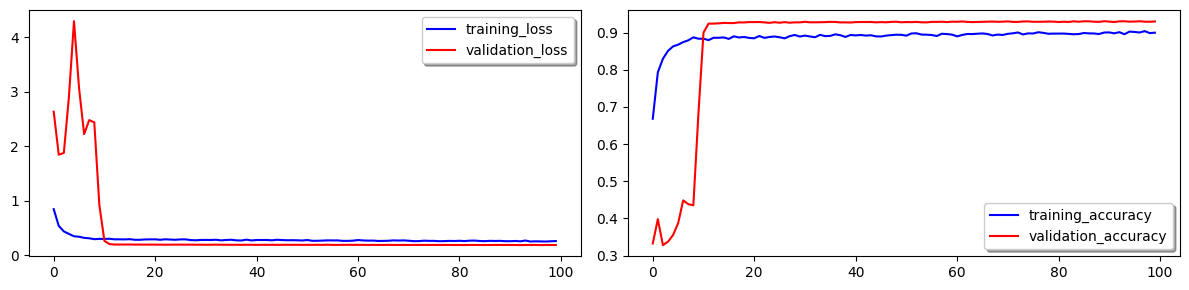

In [23]:
display_history(history)


## Evaluate


In [24]:
model = tf.keras.models.load_model('resnet50.h5')


In [25]:
val_dataset = get_validation_dataset(ordered=True)
results = model.evaluate(
    val_dataset, batch_size=BATCH_SIZE, steps=VALIDATION_STEPS)
print('Test loss: {:4f}'.format(results[0]))
print('Test accuracy: {:4f}'.format(results[1]))



 1/43 [..............................] - ETA: 2:41 - loss: 0.2786 - accuracy: 0.8828


 2/43 [>.............................] - ETA: 1:35 - loss: 0.2498 - accuracy: 0.8984


 3/43 [=>............................] - ETA: 1:33 - loss: 0.2590 - accuracy: 0.9036


 4/43 [=>............................] - ETA: 1:29 - loss: 0.2518 - accuracy: 0.9043


 5/43 [==>...........................] - ETA: 1:26 - loss: 0.2490 - accuracy: 0.9062


 6/43 [===>..........................] - ETA: 1:23 - loss: 0.2498 - accuracy: 0.9089


 7/43 [===>..........................] - ETA: 1:21 - loss: 0.2457 - accuracy: 0.9085


 8/43 [====>.........................] - ETA: 1:18 - loss: 0.2459 - accuracy: 0.9053


 9/43 [=====>........................] - ETA: 1:16 - loss: 0.2406 - accuracy: 0.9080


10/43 [=====>........................] - ETA: 1:13 - loss: 0.2457 - accuracy: 0.9047


11/43 [======>.......................] - ETA: 1:11 - loss: 0.2428 - accuracy: 0.9041


12/43 [=======>......................] - ETA: 1:09 - loss: 0.2433 - accuracy: 0.9030


13/43 [========>.....................] - ETA: 1:06 - loss: 0.2474 - accuracy: 0.9044


14/43 [========>.....................] - ETA: 1:04 - loss: 0.2444 - accuracy: 0.9074


15/43 [=========>....................] - ETA: 1:02 - loss: 0.2388 - accuracy: 0.9089


16/43 [==========>...................] - ETA: 1:00 - loss: 0.2357 - accuracy: 0.9097


17/43 [==========>...................] - ETA: 58s - loss: 0.2386 - accuracy: 0.9108 


18/43 [===========>..................] - ETA: 55s - loss: 0.2402 - accuracy: 0.9115


19/43 [============>.................] - ETA: 53s - loss: 0.2397 - accuracy: 0.9116


20/43 [============>.................] - ETA: 51s - loss: 0.2357 - accuracy: 0.9133


21/43 [=============>................] - ETA: 49s - loss: 0.2365 - accuracy: 0.9126


22/43 [==============>...............] - ETA: 46s - loss: 0.2364 - accuracy: 0.9134


23/43 [===============>..............] - ETA: 44s - loss: 0.2408 - accuracy: 0.9117


24/43 [===============>..............] - ETA: 42s - loss: 0.2385 - accuracy: 0.9118


25/43 [================>.............] - ETA: 40s - loss: 0.2400 - accuracy: 0.9109


26/43 [=================>............] - ETA: 37s - loss: 0.2405 - accuracy: 0.9108


27/43 [=================>............] - ETA: 35s - loss: 0.2413 - accuracy: 0.9103


28/43 [==================>...........] - ETA: 33s - loss: 0.2408 - accuracy: 0.9104


29/43 [===================>..........] - ETA: 31s - loss: 0.2362 - accuracy: 0.9116


30/43 [===================>..........] - ETA: 28s - loss: 0.2323 - accuracy: 0.9122


31/43 [====================>.........] - ETA: 26s - loss: 0.2268 - accuracy: 0.9148


32/43 [=====================>........] - ETA: 24s - loss: 0.2220 - accuracy: 0.9165


33/43 [======================>.......] - ETA: 22s - loss: 0.2170 - accuracy: 0.9188


34/43 [======================>.......] - ETA: 19s - loss: 0.2147 - accuracy: 0.9198


35/43 [=======================>......] - ETA: 17s - loss: 0.2131 - accuracy: 0.9212


36/43 [========================>.....] - ETA: 15s - loss: 0.2104 - accuracy: 0.9223


37/43 [========================>.....] - ETA: 13s - loss: 0.2075 - accuracy: 0.9231


38/43 [=========================>....] - ETA: 11s - loss: 0.2075 - accuracy: 0.9231


39/43 [==========================>...] - ETA: 8s - loss: 0.2036 - accuracy: 0.9247 


40/43 [==========================>...] - ETA: 6s - loss: 0.2023 - accuracy: 0.9248


41/43 [===========================>..] - ETA: 4s - loss: 0.1992 - accuracy: 0.9259


42/43 [============================>.] - ETA: 2s - loss: 0.1981 - accuracy: 0.9260


43/43 [==============================] - ETA: 0s - loss: 0.1971 - accuracy: 0.9263


43/43 [==============================] - 95s 2s/step - loss: 0.1971 - accuracy: 0.9263


Test loss: 0.197150
Test accuracy: 0.926343



 1/43 [..............................] - ETA: 2:14


 2/43 [>.............................] - ETA: 1:28


 3/43 [=>............................] - ETA: 1:25


 4/43 [=>............................] - ETA: 1:23


 5/43 [==>...........................] - ETA: 1:21


 6/43 [===>..........................] - ETA: 1:19


 7/43 [===>..........................] - ETA: 1:17


 8/43 [====>.........................] - ETA: 1:15


 9/43 [=====>........................] - ETA: 1:13


10/43 [=====>........................] - ETA: 1:11


11/43 [======>.......................] - ETA: 1:09


12/43 [=======>......................] - ETA: 1:07


13/43 [========>.....................] - ETA: 1:04


14/43 [========>.....................] - ETA: 1:02


15/43 [=========>....................] - ETA: 1:00


16/43 [==========>...................] - ETA: 58s 


17/43 [==========>...................] - ETA: 56s


18/43 [===========>..................] - ETA: 53s


19/43 [============>.................] - ETA: 51s


20/43 [============>.................] - ETA: 49s


21/43 [=============>................] - ETA: 47s


22/43 [==============>...............] - ETA: 45s


23/43 [===============>..............] - ETA: 43s


24/43 [===============>..............] - ETA: 40s


25/43 [================>.............] - ETA: 38s


26/43 [=================>............] - ETA: 36s


27/43 [=================>............] - ETA: 34s


28/43 [==================>...........] - ETA: 32s


29/43 [===================>..........] - ETA: 30s


30/43 [===================>..........] - ETA: 28s


31/43 [====================>.........] - ETA: 25s


32/43 [=====================>........] - ETA: 23s


33/43 [======================>.......] - ETA: 21s


34/43 [======================>.......] - ETA: 19s


35/43 [=======================>......] - ETA: 17s


36/43 [========================>.....] - ETA: 15s


37/43 [========================>.....] - ETA: 12s


38/43 [=========================>....] - ETA: 10s


39/43 [==========================>...] - ETA: 8s 


40/43 [==========================>...] - ETA: 6s


41/43 [===========================>..] - ETA: 4s


42/43 [============================>.] - ETA: 2s


43/43 [==============================] - ETA: 0s


43/43 [==============================] - 92s 2s/step


              precision    recall  f1-score   support

    COVID-19       0.99      0.96      0.97      1903
   Non-COVID       0.90      0.91      0.90      1802
      Normal       0.89      0.91      0.90      1712

    accuracy                           0.93      5417
   macro avg       0.93      0.93      0.93      5417
weighted avg       0.93      0.93      0.93      5417



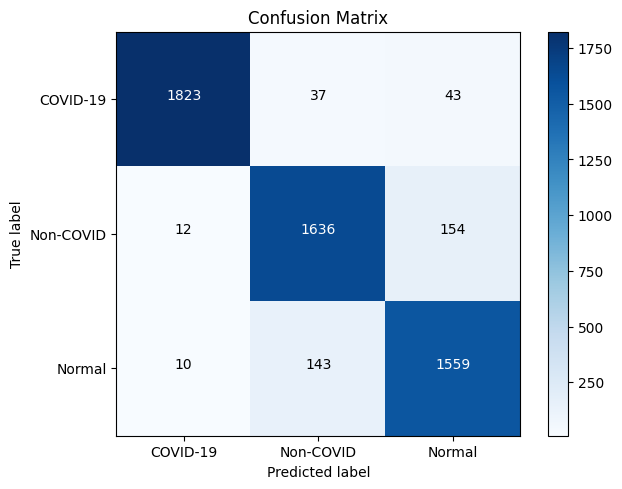

In [26]:
images_ds = val_dataset.map(lambda image, label: image)
labels_ds = val_dataset.map(lambda image, label: label).unbatch()
correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()

pred = model.predict(val_dataset, steps=VALIDATION_STEPS)

y_true = np.argmax(correct_labels, axis=-1)
y_pred = np.argmax(pred, axis=-1)

print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
display_confusion_matrix(cm=cm, classes=CLASSES, title='Confusion Matrix')


## Testing


In [27]:
dataset = get_test_dataset()
dataset = dataset.unbatch().batch(16)
batch = iter(dataset)



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 1s 1s/step


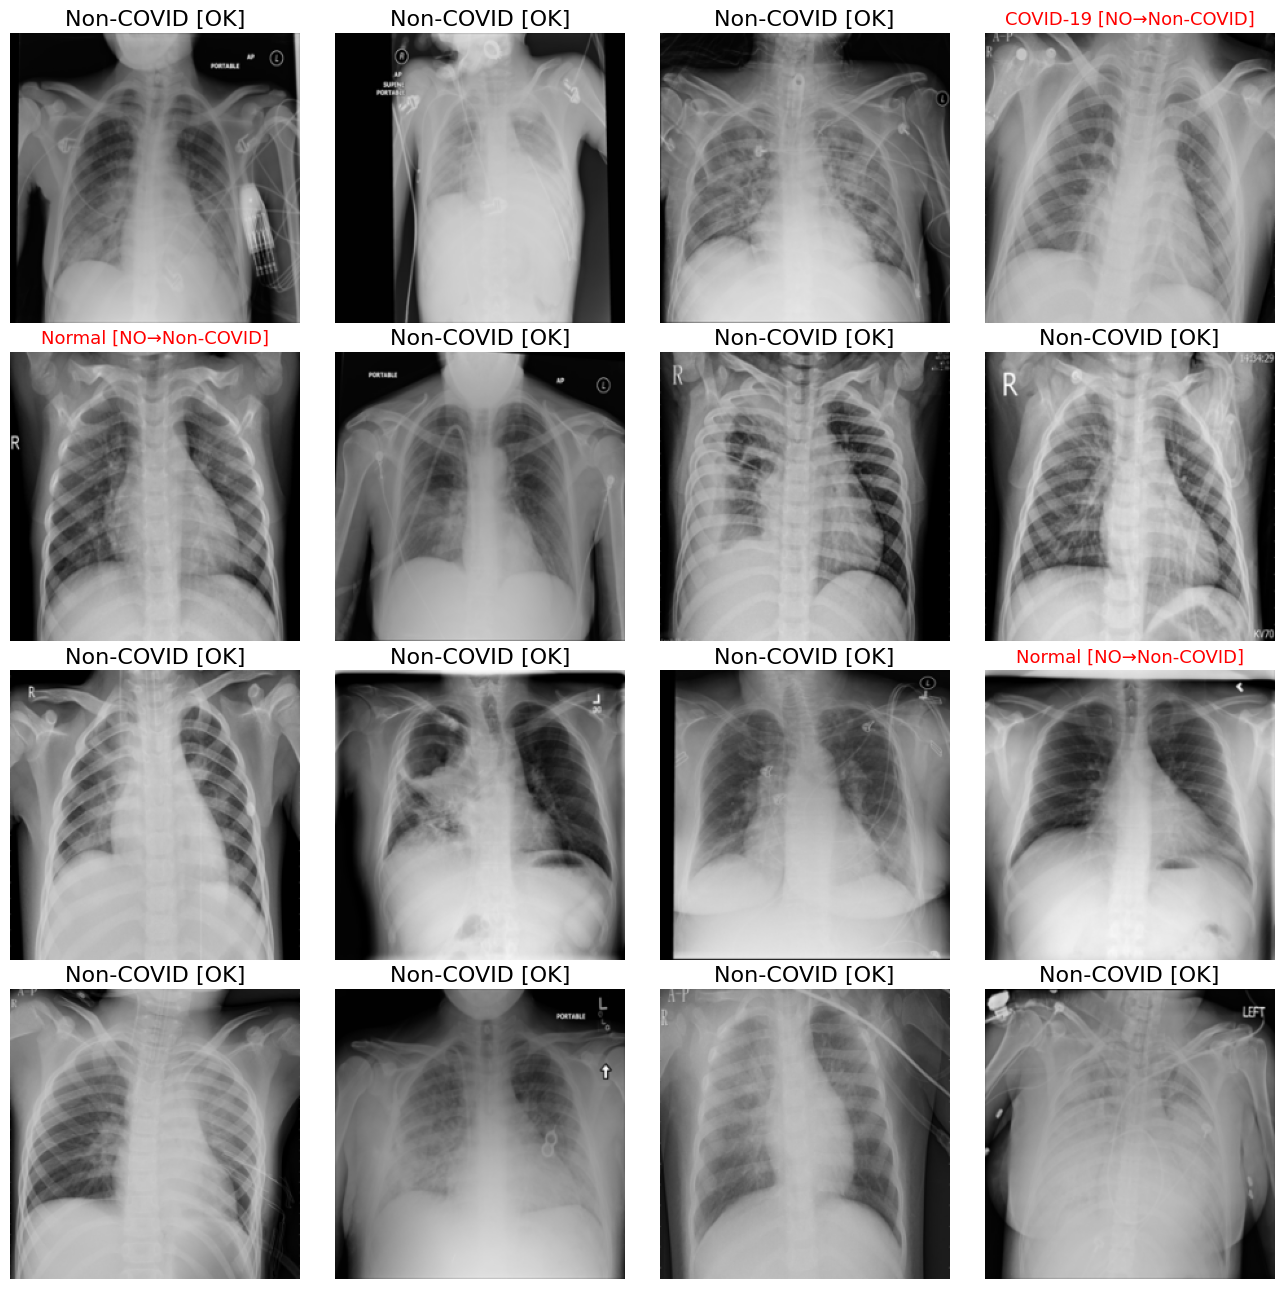

In [28]:
# run this cell again for next set of images
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch((images, labels), predictions)
